In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet

from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

for r in range(5):
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        eegnet= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

    #     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
    #     softmax_activation = nn.LogSoftmax(dim=1)
    #     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)


    #     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
    #     classifier.to(DEVICE)

    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)


        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        classifier= LSTM_EEGNet_Wrapper(DEVICE, eegnet, input_dim).to(DEVICE)

        model = EEGNet_DF_HP_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
    #     model= EEGNet_Wrapper(DEVICE, df)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


        train_func= eeg_DF_train
        model.training_procedure(iteration=n_epochs,
                                        train_dataloader=train_dataloader,
                                         val_dataloader=val_dataloader,
                                         print_cycle=2,
                                         path=f"./dictionary/intermdiate_dicts",
                                         loss_func=criterion,
                                         optimiser=optimizer, #scheduler=scheduler,
                                         train_func=train_func
                                        )
        if model.epoch == n_epochs+1:
            EPOCH= n_epochs
        else:
            EPOCH= model.epoch

        torch.save(model.state_dict(), 
               os.path.join(
                   saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-DF_Multivariate-e{EPOCH}.pt"
               )
        )

        pickle.dump( model.return_DF_weights(), 
                    open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-DF_Multivariate-w-e{EPOCH}.pkl", "wb") 
                   )    

    # OR
    #     model.load_state_dict(
    #     torch.load(
    #         open(
    #             os.path.join(
    #                 saved_dir, f"Userfold-{participants[i]}-EEGNet-DF_Multivariate-e{n_epochs}.pt"
    #             ), "rb"
    #         )
    #               )
    #     )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3165.8530752144607


Iterations:   0%|                                   | 1/300 [00:03<15:22,  3.09s/it]

Epoch:  0
t_loss:  3165.8530752144607 , v_loss:  0.6843202908833822
t_acc:  0.5910364145658263 , v_acc:  0.6894409937888198
t_recall:  0.5059167455840573 , v_recall:  0.5
t_prec:  0.5062127107652399 , v_prec:  0.3447204968944099
t_f:  0.505700641506571 , v_f:  0.4080882352941176
////////


Iterations:   1%|▏                                  | 2/300 [00:04<09:12,  1.85s/it]

Epoch  1 , loss 3148.9906364889707
Epoch  2 , loss 3132.195183249081


Iterations:   1%|▎                                  | 3/300 [00:05<08:37,  1.74s/it]

Epoch:  2
t_loss:  3132.195183249081 , v_loss:  0.6787957946459452
t_acc:  0.676937441643324 , v_acc:  0.6894409937888198
t_recall:  0.5038292090418742 , v_recall:  0.5
t_prec:  0.5153313550939663 , v_prec:  0.3447204968944099
t_f:  0.4532941093158025 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:06<07:14,  1.47s/it]

Epoch  3 , loss 3115.4723259420957
Epoch  4 , loss 3098.805980009191


Iterations:   2%|▌                                  | 5/300 [00:08<07:32,  1.53s/it]

Epoch:  4
t_loss:  3098.805980009191 , v_loss:  0.6672428647677103
t_acc:  0.6921879863056334 , v_acc:  0.6894409937888198
t_recall:  0.4995518864687556 , v_recall:  0.5
t_prec:  0.48771016311166876 , v_prec:  0.3447204968944099
t_f:  0.415793372234394 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:09<06:35,  1.35s/it]

Epoch  5 , loss 3082.205135569853
Epoch  6 , loss 3065.651759727328


Iterations:   2%|▊                                  | 7/300 [00:10<06:59,  1.43s/it]

Epoch:  6
t_loss:  3065.651759727328 , v_loss:  0.6644148329893748
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.4991689655645682 , v_recall:  0.5
t_prec:  0.41905801621958827 , v_prec:  0.3447204968944099
t_f:  0.4106825689887925 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:18,  1.30s/it]

Epoch  7 , loss 3049.1324343213846
Epoch  8 , loss 3032.670960669424


Iterations:   3%|█                                  | 9/300 [00:13<06:42,  1.38s/it]

Epoch:  8
t_loss:  3032.670960669424 , v_loss:  0.688331147034963
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:01,  1.25s/it]

Epoch  9 , loss 3016.268947227328
Epoch  10 , loss 2999.912937538297


Iterations:   4%|█▏                                | 11/300 [00:16<06:38,  1.38s/it]

Epoch:  10
t_loss:  2999.912937538297 , v_loss:  0.7226654489835104
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:17<05:59,  1.25s/it]

Epoch  11 , loss 2983.592893114277
Epoch  12 , loss 2967.3180338541665


Iterations:   4%|█▍                                | 13/300 [00:18<06:29,  1.36s/it]

Epoch:  12
t_loss:  2967.3180338541665 , v_loss:  0.7470257033904394
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:03,  1.27s/it]

Epoch  13 , loss 2951.102548636642
Epoch  14 , loss 2934.9462603400734


Iterations:   5%|█▋                                | 15/300 [00:21<06:35,  1.39s/it]

Epoch:  14
t_loss:  2934.9462603400734 , v_loss:  0.7604436278343201
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:00,  1.27s/it]

Epoch  15 , loss 2918.8443914675245
Epoch  16 , loss 2902.775218290441


Iterations:   6%|█▉                                | 17/300 [00:24<06:27,  1.37s/it]

Epoch:  16
t_loss:  2902.775218290441 , v_loss:  0.7660777370134989
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:25<05:52,  1.25s/it]

Epoch  17 , loss 2886.7683919270835
Epoch  18 , loss 2870.799144071691


Iterations:   6%|██▏                               | 19/300 [00:26<06:21,  1.36s/it]

Epoch:  18
t_loss:  2870.799144071691 , v_loss:  0.7709086686372757
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:27<05:51,  1.26s/it]

Epoch  19 , loss 2854.897341260723
Epoch  20 , loss 2839.027492149203


Iterations:   7%|██▍                               | 21/300 [00:29<06:25,  1.38s/it]

Epoch:  20
t_loss:  2839.027492149203 , v_loss:  0.767976442972819
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:30<05:49,  1.26s/it]

Epoch  21 , loss 2823.2347866881128
Epoch  22 , loss 2807.4963761871936


Iterations:   8%|██▌                               | 23/300 [00:31<06:19,  1.37s/it]

Epoch:  22
t_loss:  2807.4963761871936 , v_loss:  0.7716909150282542
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:45,  1.25s/it]

Epoch  23 , loss 2791.809134689032
Epoch  24 , loss 2776.1676863128064


Iterations:   8%|██▊                               | 25/300 [00:34<06:17,  1.37s/it]

Epoch:  24
t_loss:  2776.1676863128064 , v_loss:  0.7694780677556992
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:43,  1.26s/it]

Epoch  25 , loss 2760.578972311581
Epoch  26 , loss 2745.0583208869484


Iterations:   9%|███                               | 27/300 [00:37<06:11,  1.36s/it]

Epoch:  26
t_loss:  2745.0583208869484 , v_loss:  0.7748110244671503
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:38,  1.24s/it]

Epoch  27 , loss 2729.6039273131128
Epoch  28 , loss 2714.206882850797


Iterations:  10%|███▎                              | 29/300 [00:39<06:05,  1.35s/it]

Epoch:  28
t_loss:  2714.206882850797 , v_loss:  0.7726194014151891
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:38,  1.25s/it]

Epoch  29 , loss 2698.852366727941
Epoch  30 , loss 2683.534787645527


Iterations:  10%|███▌                              | 31/300 [00:42<06:05,  1.36s/it]

Epoch:  30
t_loss:  2683.534787645527 , v_loss:  0.7700813462336858
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:32,  1.24s/it]

Epoch  31 , loss 2668.2529440487133
Epoch  32 , loss 2653.037784352022


Iterations:  11%|███▋                              | 33/300 [00:45<06:11,  1.39s/it]

Epoch:  32
t_loss:  2653.037784352022 , v_loss:  0.7681645850340525
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:40,  1.28s/it]

Epoch  33 , loss 2637.864205154718
Epoch  34 , loss 2622.7537722120096


Iterations:  12%|███▉                              | 35/300 [00:47<06:06,  1.38s/it]

Epoch:  34
t_loss:  2622.7537722120096 , v_loss:  0.7688040733337402
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:48<05:32,  1.26s/it]

Epoch  35 , loss 2607.6968539368872
Epoch  36 , loss 2592.69500134038


Iterations:  12%|████▏                             | 37/300 [00:50<06:03,  1.38s/it]

Epoch:  36
t_loss:  2592.69500134038 , v_loss:  0.7651442736387253
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:51<05:36,  1.29s/it]

Epoch  37 , loss 2577.744944852941
Epoch  38 , loss 2562.8431516161154


Iterations:  13%|████▍                             | 39/300 [00:53<06:01,  1.39s/it]

Epoch:  38
t_loss:  2562.8431516161154 , v_loss:  0.7613444377978643
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:53<05:26,  1.25s/it]

Epoch  39 , loss 2547.9746907552085
Epoch  40 , loss 2533.1548043045345


Iterations:  14%|████▋                             | 41/300 [00:55<05:55,  1.37s/it]

Epoch:  40
t_loss:  2533.1548043045345 , v_loss:  0.7626021007696787
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:56<05:21,  1.25s/it]

Epoch  41 , loss 2518.3697964537378
Epoch  42 , loss 2503.65230066636


Iterations:  14%|████▊                             | 43/300 [00:58<05:48,  1.36s/it]

Epoch:  42
t_loss:  2503.65230066636 , v_loss:  0.7583846002817154
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:59<05:18,  1.24s/it]

Epoch  43 , loss 2488.9998468137255
Epoch  44 , loss 2474.403267654718


Iterations:  15%|█████                             | 45/300 [01:00<05:50,  1.37s/it]

Epoch:  44
t_loss:  2474.403267654718 , v_loss:  0.7558782200018564
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [01:01<05:20,  1.26s/it]

Epoch  45 , loss 2459.8558804381128
Epoch  46 , loss 2445.365468941483


Iterations:  16%|█████▎                            | 47/300 [01:03<05:46,  1.37s/it]

Epoch:  46
t_loss:  2445.365468941483 , v_loss:  0.7538947959740957
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [01:04<05:17,  1.26s/it]

Epoch  47 , loss 2430.919529335172
Epoch  48 , loss 2416.5204790900734


Iterations:  16%|█████▌                            | 49/300 [01:06<05:44,  1.37s/it]

Epoch:  48
t_loss:  2416.5204790900734 , v_loss:  0.7476858297983805
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [01:07<05:14,  1.26s/it]

Epoch  49 , loss 2402.157106885723
Epoch  50 , loss 2387.850456686581


Iterations:  17%|█████▊                            | 51/300 [01:08<05:39,  1.36s/it]

Epoch:  50
t_loss:  2387.850456686581 , v_loss:  0.7429471512635549
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:09<05:08,  1.25s/it]

Epoch  51 , loss 2373.6009641161154
Epoch  52 , loss 2359.3860868566176


Iterations:  18%|██████                            | 53/300 [01:11<05:35,  1.36s/it]

Epoch:  52
t_loss:  2359.3860868566176 , v_loss:  0.7416226963202158
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:12<05:09,  1.26s/it]

Epoch  53 , loss 2345.216160194547
Epoch  54 , loss 2331.092227711397


Iterations:  18%|██████▏                           | 55/300 [01:13<05:33,  1.36s/it]

Epoch:  54
t_loss:  2331.092227711397 , v_loss:  0.738265593846639
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:14<05:05,  1.25s/it]

Epoch  55 , loss 2317.0051604626224
Epoch  56 , loss 2302.967093673407


Iterations:  19%|██████▍                           | 57/300 [01:16<05:31,  1.36s/it]

Epoch:  56
t_loss:  2302.967093673407 , v_loss:  0.7367704858382543
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:17<05:02,  1.25s/it]

Epoch  57 , loss 2288.9471076516543
Epoch  58 , loss 2274.9699515548405


Iterations:  20%|██████▋                           | 59/300 [01:19<05:31,  1.38s/it]

Epoch:  58
t_loss:  2274.9699515548405 , v_loss:  0.7255329787731171
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:20<05:03,  1.26s/it]

Epoch  59 , loss 2261.0341749004288
Epoch  60 , loss 2247.1538947610293


Iterations:  20%|██████▉                           | 61/300 [01:21<05:30,  1.38s/it]

Epoch:  60
t_loss:  2247.1538947610293 , v_loss:  0.7183562268813452
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5006388877451586 , v_recall:  0.5
t_prec:  0.5622270742358079 , v_prec:  0.3447204968944099
t_f:  0.41308060533064894 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:22<05:04,  1.28s/it]

Epoch  61 , loss 2233.313974417892
Epoch  62 , loss 2219.525515088848


Iterations:  21%|███████▏                          | 63/300 [01:24<05:30,  1.40s/it]

Epoch:  62
t_loss:  2219.525515088848 , v_loss:  0.714022139708201
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:25<05:11,  1.32s/it]

Epoch  63 , loss 2205.7655914905026
Epoch  64 , loss 2192.0629595588234


Iterations:  22%|███████▎                          | 65/300 [01:27<05:39,  1.44s/it]

Epoch:  64
t_loss:  2192.0629595588234 , v_loss:  0.7042056620121002
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:28<05:07,  1.32s/it]

Epoch  65 , loss 2178.4022623697915
Epoch  66 , loss 2164.783576516544


Iterations:  22%|███████▌                          | 67/300 [01:30<05:43,  1.47s/it]

Epoch:  66
t_loss:  2164.783576516544 , v_loss:  0.7022987256447474
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:31<05:11,  1.34s/it]

Epoch  67 , loss 2151.2231110217526
Epoch  68 , loss 2137.7097646675857


Iterations:  23%|███████▊                          | 69/300 [01:33<05:33,  1.45s/it]

Epoch:  68
t_loss:  2137.7097646675857 , v_loss:  0.688251386086146
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5004151740986261 , v_recall:  0.5
t_prec:  0.5353939157566303 , v_prec:  0.3447204968944099
t_f:  0.41296906693711966 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▉                          | 70/300 [01:34<05:12,  1.36s/it]

Epoch  69 , loss 2124.2479990042893
Epoch  70 , loss 2110.8246591605393


Iterations:  24%|████████                          | 71/300 [01:36<05:44,  1.50s/it]

Epoch:  70
t_loss:  2110.8246591605393 , v_loss:  0.6797051926453909
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:  24%|████████▏                         | 72/300 [01:37<05:10,  1.36s/it]

Epoch  71 , loss 2097.4520143995096
Epoch  72 , loss 2084.115617340686


Iterations:  24%|████████▎                         | 73/300 [01:38<05:34,  1.47s/it]

Epoch:  72
t_loss:  2084.115617340686 , v_loss:  0.6686287224292755
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5036425522570374 , v_recall:  0.5
t_prec:  0.7485794567592882 , v_prec:  0.3447204968944099
t_f:  0.4187260736785523 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▍                         | 74/300 [01:39<05:01,  1.33s/it]

Epoch  73 , loss 2070.819761986826
Epoch  74 , loss 2057.5821078431372


Iterations:  25%|████████▌                         | 75/300 [01:41<05:25,  1.45s/it]

Epoch:  74
t_loss:  2057.5821078431372 , v_loss:  0.6594587415456772
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5031951249639725 , v_recall:  0.5
t_prec:  0.6818181818181819 , v_prec:  0.3447204968944099
t_f:  0.418492875777644 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▌                         | 76/300 [01:42<05:08,  1.38s/it]

Epoch  75 , loss 2044.3740928500306
Epoch  76 , loss 2031.2095683976715


Iterations:  26%|████████▋                         | 77/300 [01:44<05:31,  1.49s/it]

Epoch:  76
t_loss:  2031.2095683976715 , v_loss:  0.6533778707186381
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5033227652653683 , v_recall:  0.5
t_prec:  0.6262910798122066 , v_prec:  0.3447204968944099
t_f:  0.4201690740864009 , v_f:  0.4080882352941176
////////


Iterations:  26%|████████▊                         | 78/300 [01:45<05:00,  1.35s/it]

Epoch  77 , loss 2018.0963804955577
Epoch  78 , loss 2005.055944106158


Iterations:  26%|████████▉                         | 79/300 [01:47<05:25,  1.47s/it]

Epoch:  78
t_loss:  2005.055944106158 , v_loss:  0.650195762515068
t_acc:  0.699035169623405 , v_acc:  0.6956521739130435
t_recall:  0.5079239922592333 , v_recall:  0.51
t_prec:  0.7013496547394853 , v_prec:  0.846875
t_f:  0.4297152863243275 , v_f:  0.42920193907821425
////////


Iterations:  27%|█████████                         | 80/300 [01:48<04:53,  1.34s/it]

Epoch  79 , loss 1992.0600346583947
Epoch  80 , loss 1979.1157082950367


Iterations:  27%|█████████▏                        | 81/300 [01:49<05:15,  1.44s/it]

Epoch:  80
t_loss:  1979.1157082950367 , v_loss:  0.6465217520793279
t_acc:  0.6953003423591659 , v_acc:  0.7018633540372671
t_recall:  0.5032266919202316 , v_recall:  0.52
t_prec:  0.5884943538268507 , v_prec:  0.8490566037735849
t_f:  0.42170041599339914 , v_f:  0.44957264957264953
////////


Iterations:  27%|█████████▎                        | 82/300 [01:50<04:46,  1.32s/it]

Epoch  81 , loss 1966.2100303500306
Epoch  82 , loss 1953.346248851103


Iterations:  28%|█████████▍                        | 83/300 [01:52<05:12,  1.44s/it]

Epoch:  82
t_loss:  1953.346248851103 , v_loss:  0.6403402288754781
t_acc:  0.7009025832555245 , v_acc:  0.7018633540372671
t_recall:  0.5104164093273493 , v_recall:  0.52
t_prec:  0.7465831311731069 , v_prec:  0.8490566037735849
t_f:  0.4341706229488249 , v_f:  0.44957264957264953
////////


Iterations:  28%|█████████▌                        | 84/300 [01:53<04:56,  1.37s/it]

Epoch  83 , loss 1940.5293136297487
Epoch  84 , loss 1927.77798761106


Iterations:  28%|█████████▋                        | 85/300 [01:55<05:21,  1.50s/it]

Epoch:  84
t_loss:  1927.77798761106 , v_loss:  0.6382042666276296
t_acc:  0.6981014628073452 , v_acc:  0.7018633540372671
t_recall:  0.5086905203057878 , v_recall:  0.52
t_prec:  0.6496690828868579 , v_prec:  0.8490566037735849
t_f:  0.43389368584415433 , v_f:  0.44957264957264953
////////


Iterations:  29%|█████████▋                        | 86/300 [01:56<04:50,  1.36s/it]

Epoch  85 , loss 1915.0580863204657
Epoch  86 , loss 1902.4054218367035


Iterations:  29%|█████████▊                        | 87/300 [01:58<05:12,  1.47s/it]

Epoch:  86
t_loss:  1902.4054218367035 , v_loss:  0.6365676323572794
t_acc:  0.699035169623405 , v_acc:  0.7018633540372671
t_recall:  0.508499059853694 , v_recall:  0.52
t_prec:  0.688332556112001 , v_prec:  0.8490566037735849
t_f:  0.431556640045754 , v_f:  0.44957264957264953
////////


Iterations:  29%|█████████▉                        | 88/300 [01:59<04:48,  1.36s/it]

Epoch  87 , loss 1889.8099006204045
Epoch  88 , loss 1877.2576401654412


Iterations:  30%|██████████                        | 89/300 [02:01<05:05,  1.45s/it]

Epoch:  88
t_loss:  1877.2576401654412 , v_loss:  0.6329921980698904
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5104479762836085 , v_recall:  0.52
t_prec:  0.6714758751182592 , v_prec:  0.8490566037735849
t_f:  0.4371254162042176 , v_f:  0.44957264957264953
////////


Iterations:  30%|██████████▏                       | 90/300 [02:02<04:38,  1.32s/it]

Epoch  89 , loss 1864.7474365234375
Epoch  90 , loss 1852.2978754978553


Iterations:  30%|██████████▎                       | 91/300 [02:04<05:08,  1.48s/it]

Epoch:  90
t_loss:  1852.2978754978553 , v_loss:  0.627440427740415
t_acc:  0.6977902272019919 , v_acc:  0.7018633540372671
t_recall:  0.5078917390647946 , v_recall:  0.52
t_prec:  0.6467935189597658 , v_prec:  0.8490566037735849
t_f:  0.43195024184451847 , v_f:  0.44957264957264953
////////


Iterations:  31%|██████████▍                       | 92/300 [02:05<04:36,  1.33s/it]

Epoch  91 , loss 1839.8887939453125
Epoch  92 , loss 1827.5289234834559


Iterations:  31%|██████████▌                       | 93/300 [02:06<05:03,  1.47s/it]

Epoch:  92
t_loss:  1827.5289234834559 , v_loss:  0.6251449733972549
t_acc:  0.7002801120448179 , v_acc:  0.7018633540372671
t_recall:  0.5114066510204361 , v_recall:  0.52
t_prec:  0.6917156214437302 , v_prec:  0.8490566037735849
t_f:  0.43842668964176673 , v_f:  0.44957264957264953
////////


Iterations:  31%|██████████▋                       | 94/300 [02:07<04:35,  1.34s/it]

Epoch  93 , loss 1815.2173713235295
Epoch  94 , loss 1802.9474259918811


Iterations:  32%|██████████▊                       | 95/300 [02:09<04:53,  1.43s/it]

Epoch:  94
t_loss:  1802.9474259918811 , v_loss:  0.6196528772513071
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5120455387655948 , v_recall:  0.52
t_prec:  0.6733116113744075 , v_prec:  0.8490566037735849
t_f:  0.4409551656920078 , v_f:  0.44957264957264953
////////


Iterations:  32%|██████████▉                       | 96/300 [02:10<04:33,  1.34s/it]

Epoch  95 , loss 1790.708060470282
Epoch  96 , loss 1778.506898169424


Iterations:  32%|██████████▉                       | 97/300 [02:12<05:03,  1.50s/it]

Epoch:  96
t_loss:  1778.506898169424 , v_loss:  0.6209285159905752
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5104479762836085 , v_recall:  0.52
t_prec:  0.6714758751182592 , v_prec:  0.8490566037735849
t_f:  0.4371254162042176 , v_f:  0.44957264957264953
////////


Iterations:  33%|███████████                       | 98/300 [02:13<04:38,  1.38s/it]

Epoch  97 , loss 1766.3393746170343
Epoch  98 , loss 1754.224822399663


Iterations:  33%|███████████▏                      | 99/300 [02:15<04:58,  1.48s/it]

Epoch:  98
t_loss:  1754.224822399663 , v_loss:  0.6188672532637914
t_acc:  0.7002801120448179 , v_acc:  0.7018633540372671
t_recall:  0.5116941848176665 , v_recall:  0.52
t_prec:  0.6875247597388305 , v_prec:  0.8490566037735849
t_f:  0.4393193446413476 , v_f:  0.44957264957264953
////////


Iterations:  33%|███████████                      | 100/300 [02:16<04:30,  1.35s/it]

Epoch  99 , loss 1742.1385593788298
Epoch  100 , loss 1730.0924886067708


Iterations:  34%|███████████                      | 101/300 [02:18<04:49,  1.46s/it]

Epoch:  100
t_loss:  1730.0924886067708 , v_loss:  0.6139634152253469
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5108954035766734 , v_recall:  0.52
t_prec:  0.687641821619918 , v_prec:  0.8490566037735849
t_f:  0.43739537438532455 , v_f:  0.44957264957264953
////////


Iterations:  34%|███████████▏                     | 102/300 [02:19<04:27,  1.35s/it]

Epoch  101 , loss 1718.0865095549939
Epoch  102 , loss 1706.1201076133577


Iterations:  34%|███████████▎                     | 103/300 [02:20<04:45,  1.45s/it]

Epoch:  102
t_loss:  1706.1201076133577 , v_loss:  0.6155634075403214
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5111829373739037 , v_recall:  0.52
t_prec:  0.6835383159886471 , v_prec:  0.8490566037735849
t_f:  0.43829078801331856 , v_f:  0.44957264957264953
////////


Iterations:  35%|███████████▍                     | 104/300 [02:22<04:29,  1.38s/it]

Epoch  103 , loss 1694.1902765012255
Epoch  104 , loss 1682.303462009804


Iterations:  35%|███████████▌                     | 105/300 [02:23<04:45,  1.47s/it]

Epoch:  104
t_loss:  1682.303462009804 , v_loss:  0.6040148635705312
t_acc:  0.7005913476501712 , v_acc:  0.6956521739130435
t_recall:  0.51278049985589 , v_recall:  0.5154954954954954
t_prec:  0.6838862559241705 , v_prec:  0.6814345991561181
t_f:  0.4421150097465887 , v_f:  0.44665778214210566
////////


Iterations:  35%|███████████▋                     | 106/300 [02:24<04:23,  1.36s/it]

Epoch  105 , loss 1670.4643674364277
Epoch  106 , loss 1658.6786822150734


Iterations:  36%|███████████▊                     | 107/300 [02:26<04:51,  1.51s/it]

Epoch:  106
t_loss:  1658.6786822150734 , v_loss:  0.6044414192438126
t_acc:  0.7024587612822907 , v_acc:  0.6956521739130435
t_recall:  0.5164230521129274 , v_recall:  0.5154954954954954
t_prec:  0.6961746543526969 , v_prec:  0.6814345991561181
t_f:  0.44992729278443566 , v_f:  0.44665778214210566
////////


Iterations:  36%|███████████▉                     | 108/300 [02:27<04:19,  1.35s/it]

Epoch  107 , loss 1646.9225643382354
Epoch  108 , loss 1635.2192263135723


Iterations:  36%|███████████▉                     | 109/300 [02:29<04:50,  1.52s/it]

Epoch:  108
t_loss:  1635.2192263135723 , v_loss:  0.6021592517693838
t_acc:  0.7012138188608776 , v_acc:  0.7080745341614907
t_recall:  0.5132279271489549 , v_recall:  0.53
t_prec:  0.6984733872407023 , v_prec:  0.8512658227848101
t_f:  0.4423940207330618 , v_f:  0.4692431787893666
////////


Iterations:  37%|████████████                     | 110/300 [02:30<04:19,  1.37s/it]

Epoch  109 , loss 1623.5495198567708
Epoch  110 , loss 1611.9224398743872


Iterations:  37%|████████████▏                    | 111/300 [02:32<04:33,  1.44s/it]

Epoch:  110
t_loss:  1611.9224398743872 , v_loss:  0.599213774005572
t_acc:  0.7018362900715842 , v_acc:  0.7142857142857143
t_recall:  0.5151130234281714 , v_recall:  0.54
t_prec:  0.6936530547641659 , v_prec:  0.8535031847133758
t_f:  0.4470503401712498 , v_f:  0.488253178551686
////////


Iterations:  37%|████████████▎                    | 112/300 [02:33<04:06,  1.31s/it]

Epoch  111 , loss 1600.3500138825061
Epoch  112 , loss 1588.8191516352636


Iterations:  38%|████████████▍                    | 113/300 [02:34<04:26,  1.42s/it]

Epoch:  112
t_loss:  1588.8191516352636 , v_loss:  0.5988024870554606
t_acc:  0.7005913476501712 , v_acc:  0.7080745341614907
t_recall:  0.5130680336531203 , v_recall:  0.5354954954954955
t_prec:  0.6806165033196332 , v_prec:  0.7525641025641026
t_f:  0.44299409062010286 , v_f:  0.4847122914538645
////////


Iterations:  38%|████████████▌                    | 114/300 [02:36<04:06,  1.32s/it]

Epoch  113 , loss 1577.3098072725184
Epoch  114 , loss 1565.8264399509803


Iterations:  38%|████████████▋                    | 115/300 [02:37<04:33,  1.48s/it]

Epoch:  114
t_loss:  1565.8264399509803 , v_loss:  0.595154196023941
t_acc:  0.6981014628073452 , v_acc:  0.7080745341614907
t_recall:  0.5104157230891698 , v_recall:  0.5354954954954955
t_prec:  0.6385089917990898 , v_prec:  0.7525641025641026
t_f:  0.4392448199673256 , v_f:  0.4847122914538645
////////


Iterations:  39%|████████████▊                    | 116/300 [02:39<04:20,  1.41s/it]

Epoch  115 , loss 1554.3869700712316
Epoch  116 , loss 1542.9958735447303


Iterations:  39%|████████████▊                    | 117/300 [02:41<04:41,  1.54s/it]

Epoch:  116
t_loss:  1542.9958735447303 , v_loss:  0.5924449463685354
t_acc:  0.7033924680983504 , v_acc:  0.7080745341614907
t_recall:  0.5170941930525247 , v_recall:  0.5354954954954955
t_prec:  0.7151246473602395 , v_prec:  0.7525641025641026
t_f:  0.45036689308448846 , v_f:  0.4847122914538645
////////


Iterations:  39%|████████████▉                    | 118/300 [02:42<04:10,  1.37s/it]

Epoch  117 , loss 1531.6697447533702
Epoch  118 , loss 1520.377632889093


Iterations:  40%|█████████████                    | 119/300 [02:43<04:26,  1.47s/it]

Epoch:  118
t_loss:  1520.377632889093 , v_loss:  0.5955302764972051
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.5112467575246016 , v_recall:  0.5354954954954955
t_prec:  0.6724431818181819 , v_prec:  0.7525641025641026
t_f:  0.4390457565933556 , v_f:  0.4847122914538645
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:44<04:02,  1.35s/it]

Epoch  119 , loss 1509.1157872817096
Epoch  120 , loss 1497.8949453316484


Iterations:  40%|█████████████▎                   | 121/300 [02:46<04:19,  1.45s/it]

Epoch:  120
t_loss:  1497.8949453316484 , v_loss:  0.5969862987597784
t_acc:  0.704014939309057 , v_acc:  0.7080745341614907
t_recall:  0.5192668231289717 , v_recall:  0.5354954954954955
t_prec:  0.705815658293422 , v_prec:  0.7525641025641026
t_f:  0.45576990450922433 , v_f:  0.4847122914538645
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:47<04:04,  1.37s/it]

Epoch  121 , loss 1486.7146738089766
Epoch  122 , loss 1475.585497089461


Iterations:  41%|█████████████▌                   | 123/300 [02:49<04:20,  1.47s/it]

Epoch:  122
t_loss:  1475.585497089461 , v_loss:  0.5917769620815913
t_acc:  0.7024587612822907 , v_acc:  0.7142857142857143
t_recall:  0.5172856535046183 , v_recall:  0.5454954954954955
t_prec:  0.6874776714830104 , v_prec:  0.771505376344086
t_f:  0.4524852195885727 , v_f:  0.5028195488721805
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:50<03:58,  1.35s/it]

Epoch  123 , loss 1464.4755787568934
Epoch  124 , loss 1453.3994978362439


Iterations:  42%|█████████████▊                   | 125/300 [02:52<04:20,  1.49s/it]

Epoch:  124
t_loss:  1453.3994978362439 , v_loss:  0.5910637229681015
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5117895719246236 , v_recall:  0.5354954954954955
t_prec:  0.6384843566952914 , v_prec:  0.7525641025641026
t_f:  0.4428815224698764 , v_f:  0.4847122914538645
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:53<03:53,  1.34s/it]

Epoch  125 , loss 1442.3560814950981
Epoch  126 , loss 1431.3725873161766


Iterations:  42%|█████████████▉                   | 127/300 [02:55<04:22,  1.51s/it]

Epoch:  126
t_loss:  1431.3725873161766 , v_loss:  0.5864166468381882
t_acc:  0.7033924680983504 , v_acc:  0.7142857142857143
t_recall:  0.517381726849755 , v_recall:  0.5454954954954955
t_prec:  0.7112017210326196 , v_prec:  0.771505376344086
t_f:  0.4512254724057003 , v_f:  0.5028195488721805
////////


Iterations:  43%|██████████████                   | 128/300 [02:56<03:52,  1.35s/it]

Epoch  127 , loss 1420.438902611826
Epoch  128 , loss 1409.5398451861213


Iterations:  43%|██████████████▏                  | 129/300 [02:57<04:08,  1.45s/it]

Epoch:  128
t_loss:  1409.5398451861213 , v_loss:  0.586919829249382
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5137069213982789 , v_recall:  0.5454954954954955
t_prec:  0.6665499299579747 , v_prec:  0.771505376344086
t_f:  0.4454670828191914 , v_f:  0.5028195488721805
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:58<03:44,  1.32s/it]

Epoch  129 , loss 1398.6883185891545
Epoch  130 , loss 1387.8798828125


Iterations:  44%|██████████████▍                  | 131/300 [03:00<04:01,  1.43s/it]

Epoch:  130
t_loss:  1387.8798828125 , v_loss:  0.5880306214094162
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5185641152331151 , v_recall:  0.5554954954954955
t_prec:  0.7336231216535207 , v_prec:  0.7857142857142857
t_f:  0.4526738526098423 , v_f:  0.5203574975173784
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:01<03:39,  1.30s/it]

Epoch  131 , loss 1377.1114813112745
Epoch  132 , loss 1366.3723790785846


Iterations:  44%|██████████████▋                  | 133/300 [03:03<03:59,  1.43s/it]

Epoch:  132
t_loss:  1366.3723790785846 , v_loss:  0.5890884796778361
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5200017842192668 , v_recall:  0.5554954954954955
t_prec:  0.7136667969895416 , v_prec:  0.7857142857142857
t_f:  0.456914447296797 , v_f:  0.5203574975173784
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:04<03:51,  1.40s/it]

Epoch  133 , loss 1355.6969807942708
Epoch  134 , loss 1345.0551063687194


Iterations:  45%|██████████████▊                  | 135/300 [03:06<04:18,  1.57s/it]

Epoch:  134
t_loss:  1345.0551063687194 , v_loss:  0.5856501211722692
t_acc:  0.7058823529411765 , v_acc:  0.7142857142857143
t_recall:  0.522046773994318 , v_recall:  0.5454954954954955
t_prec:  0.7221415532691668 , v_prec:  0.771505376344086
t_f:  0.4608689954726835 , v_f:  0.5028195488721805
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:07<03:51,  1.41s/it]

Epoch  135 , loss 1334.4665766697303
Epoch  136 , loss 1323.9219204771753


Iterations:  46%|███████████████                  | 137/300 [03:09<04:03,  1.49s/it]

Epoch:  136
t_loss:  1323.9219204771753 , v_loss:  0.5774506578842798
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5178929742935178 , v_recall:  0.5554954954954955
t_prec:  0.7137329908738183 , v_prec:  0.7857142857142857
t_f:  0.45222885222885223 , v_f:  0.5203574975173784
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:10<03:38,  1.35s/it]

Epoch  137 , loss 1313.4128513710173
Epoch  138 , loss 1302.9527707567402


Iterations:  46%|███████████████▎                 | 139/300 [03:11<03:51,  1.44s/it]

Epoch:  138
t_loss:  1302.9527707567402 , v_loss:  0.5821258624394735
t_acc:  0.7046374105197635 , v_acc:  0.7142857142857143
t_recall:  0.5197142504220365 , v_recall:  0.5454954954954955
t_prec:  0.7171428571428571 , v_prec:  0.771505376344086
t_f:  0.4560731458662792 , v_f:  0.5028195488721805
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:12<03:29,  1.31s/it]

Epoch  139 , loss 1292.5449817133886
Epoch  140 , loss 1282.1689740349266


Iterations:  47%|███████████████▌                 | 141/300 [03:14<03:46,  1.42s/it]

Epoch:  140
t_loss:  1282.1689740349266 , v_loss:  0.5781603356202444
t_acc:  0.704014939309057 , v_acc:  0.7267080745341615
t_recall:  0.5192668231289717 , v_recall:  0.5654954954954955
t_prec:  0.705815658293422 , v_prec:  0.7969771241830066
t_f:  0.45576990450922433 , v_f:  0.5373563218390804
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:15<03:35,  1.36s/it]

Epoch  141 , loss 1271.8326511757048
Epoch  142 , loss 1261.5541154450061


Iterations:  48%|███████████████▋                 | 143/300 [03:17<03:47,  1.45s/it]

Epoch:  142
t_loss:  1261.5541154450061 , v_loss:  0.5780627230803171
t_acc:  0.702769996887644 , v_acc:  0.7142857142857143
t_recall:  0.5195221037317632 , v_recall:  0.5454954954954955
t_prec:  0.6767161410018553 , v_prec:  0.771505376344086
t_f:  0.4584899949791799 , v_f:  0.5028195488721805
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:18<03:35,  1.38s/it]

Epoch  143 , loss 1251.305455824908
Epoch  144 , loss 1241.0818206188726


Iterations:  48%|███████████████▉                 | 145/300 [03:20<03:50,  1.49s/it]

Epoch:  144
t_loss:  1241.0818206188726 , v_loss:  0.5835076123476028
t_acc:  0.706504824151883 , v_acc:  0.7204968944099379
t_recall:  0.5230692688818436 , v_recall:  0.5554954954954955
t_prec:  0.7260402004644032 , v_prec:  0.7857142857142857
t_f:  0.46283600683843357 , v_f:  0.5203574975173784
////////


Iterations:  49%|████████████████                 | 146/300 [03:21<03:26,  1.34s/it]

Epoch  145 , loss 1230.920840992647
Epoch  146 , loss 1220.8090269799327


Iterations:  49%|████████████████▏                | 147/300 [03:23<03:50,  1.51s/it]

Epoch:  146
t_loss:  1220.8090269799327 , v_loss:  0.586402416229248
t_acc:  0.707749766573296 , v_acc:  0.7142857142857143
t_recall:  0.525401792454125 , v_recall:  0.5454954954954955
t_prec:  0.7299397031539889 , v_prec:  0.771505376344086
t_f:  0.46756241391146597 , v_f:  0.5028195488721805
////////


Iterations:  49%|████████████████▎                | 148/300 [03:24<03:26,  1.36s/it]

Epoch  147 , loss 1210.7382094439338
Epoch  148 , loss 1200.7153224571077


Iterations:  50%|████████████████▍                | 149/300 [03:26<03:47,  1.50s/it]

Epoch:  148
t_loss:  1200.7153224571077 , v_loss:  0.5782620708147684
t_acc:  0.7005913476501712 , v_acc:  0.7204968944099379
t_recall:  0.5145057026392721 , v_recall:  0.5554954954954955
t_prec:  0.6676022835394861 , v_prec:  0.7857142857142857
t_f:  0.4473364058859122 , v_f:  0.5203574975173784
////////


Iterations:  50%|████████████████▌                | 150/300 [03:27<03:22,  1.35s/it]

Epoch  149 , loss 1190.7308541092218
Epoch  150 , loss 1180.785108379289


Iterations:  50%|████████████████▌                | 151/300 [03:28<03:36,  1.45s/it]

Epoch:  150
t_loss:  1180.785108379289 , v_loss:  0.5790347456932068
t_acc:  0.7018362900715842 , v_acc:  0.7204968944099379
t_recall:  0.5154005572254018 , v_recall:  0.5554954954954955
t_prec:  0.690410199556541 , v_prec:  0.7857142857142857
t_f:  0.4479151719862939 , v_f:  0.5203574975173784
////////


Iterations:  51%|████████████████▋                | 152/300 [03:29<03:15,  1.32s/it]

Epoch  151 , loss 1170.8759933172487
Epoch  152 , loss 1161.0132123161766


Iterations:  51%|████████████████▊                | 153/300 [03:31<03:32,  1.44s/it]

Epoch:  152
t_loss:  1161.0132123161766 , v_loss:  0.5821827699740728
t_acc:  0.7061935885465297 , v_acc:  0.7142857142857143
t_recall:  0.5234206228297718 , v_recall:  0.5454954954954955
t_prec:  0.7147270271630624 , v_prec:  0.771505376344086
t_f:  0.4643191698892706 , v_f:  0.5028195488721805
////////


Iterations:  51%|████████████████▉                | 154/300 [03:32<03:21,  1.38s/it]

Epoch  153 , loss 1151.1991756663604
Epoch  154 , loss 1141.4208242378984


Iterations:  52%|█████████████████                | 155/300 [03:34<03:41,  1.53s/it]

Epoch:  154
t_loss:  1141.4208242378984 , v_loss:  0.579535593589147
t_acc:  0.7024587612822907 , v_acc:  0.7204968944099379
t_recall:  0.5169981197073881 , v_recall:  0.5554954954954955
t_prec:  0.6901853994123729 , v_prec:  0.7857142857142857
t_f:  0.451636007883687 , v_f:  0.5203574975173784
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:35<03:17,  1.37s/it]

Epoch  155 , loss 1131.7011838426777
Epoch  156 , loss 1122.0256515203737


Iterations:  52%|█████████████████▎               | 157/300 [03:37<03:30,  1.47s/it]

Epoch:  156
t_loss:  1122.0256515203737 , v_loss:  0.5814813673496246
t_acc:  0.6974789915966386 , v_acc:  0.7142857142857143
t_recall:  0.510830897187796 , v_recall:  0.5454954954954955
t_prec:  0.6251427212178877 , v_prec:  0.771505376344086
t_f:  0.44159146208015243 , v_f:  0.5028195488721805
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:38<03:08,  1.33s/it]

Epoch  157 , loss 1112.4008453967524
Epoch  158 , loss 1102.8345013786766


Iterations:  53%|█████████████████▍               | 159/300 [03:40<03:21,  1.43s/it]

Epoch:  158
t_loss:  1102.8345013786766 , v_loss:  0.5804439137379328
t_acc:  0.7033924680983504 , v_acc:  0.7204968944099379
t_recall:  0.5191069296331371 , v_recall:  0.5554954954954955
t_prec:  0.6925199137072685 , v_prec:  0.7857142857142857
t_f:  0.45630492347668505 , v_f:  0.5203574975173784
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:41<03:11,  1.37s/it]

Epoch  159 , loss 1093.3073012408088
Epoch  160 , loss 1083.8265787760417


Iterations:  54%|█████████████████▋               | 161/300 [03:43<03:23,  1.46s/it]

Epoch:  160
t_loss:  1083.8265787760417 , v_loss:  0.5822066863377889
t_acc:  0.7049486461251168 , v_acc:  0.7142857142857143
t_recall:  0.5222382344464116 , v_recall:  0.5454954954954955
t_prec:  0.6987854251012146 , v_prec:  0.771505376344086
t_f:  0.4628682072117826 , v_f:  0.5028195488721805
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:44<03:10,  1.38s/it]

Epoch  161 , loss 1074.3763044768689
Epoch  162 , loss 1064.9548986098346


Iterations:  54%|█████████████████▉               | 163/300 [03:45<03:22,  1.48s/it]

Epoch:  162
t_loss:  1064.9548986098346 , v_loss:  0.580805167555809
t_acc:  0.7037037037037037 , v_acc:  0.7142857142857143
t_recall:  0.5173179066990571 , v_recall:  0.5454954954954955
t_prec:  0.7219056663501108 , v_prec:  0.771505376344086
t_f:  0.4505134904415759 , v_f:  0.5028195488721805
////////


Iterations:  55%|██████████████████               | 164/300 [03:46<03:03,  1.35s/it]

Epoch  163 , loss 1055.564426796109
Epoch  164 , loss 1046.2193794998468


Iterations:  55%|██████████████████▏              | 165/300 [03:48<03:22,  1.50s/it]

Epoch:  164
t_loss:  1046.2193794998468 , v_loss:  0.5788649171590805
t_acc:  0.7043261749144102 , v_acc:  0.7142857142857143
t_recall:  0.5203531381671951 , v_recall:  0.5454954954954955
t_prec:  0.7022112631244034 , v_prec:  0.771505376344086
t_f:  0.4584329286121859 , v_f:  0.5028195488721805
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:49<03:03,  1.37s/it]

Epoch  165 , loss 1036.9061590456495
Epoch  166 , loss 1027.6326317880669


Iterations:  56%|██████████████████▎              | 167/300 [03:51<03:21,  1.52s/it]

Epoch:  166
t_loss:  1027.6326317880669 , v_loss:  0.580288752913475
t_acc:  0.7005913476501712 , v_acc:  0.7204968944099379
t_recall:  0.516230905422654 , v_recall:  0.5554954954954955
t_prec:  0.6568767908309456 , v_prec:  0.7857142857142857
t_f:  0.45243303571428567 , v_f:  0.5203574975173784
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:52<03:00,  1.37s/it]

Epoch  167 , loss 1018.4167049632352
Epoch  168 , loss 1009.2395091337316


Iterations:  56%|██████████████████▌              | 169/300 [03:54<03:10,  1.45s/it]

Epoch:  168
t_loss:  1009.2395091337316 , v_loss:  0.5793130646149317
t_acc:  0.7049486461251168 , v_acc:  0.7142857142857143
t_recall:  0.5202254978657992 , v_recall:  0.5454954954954955
t_prec:  0.7193627937440457 , v_prec:  0.771505376344086
t_f:  0.45706693323218295 , v_f:  0.5028195488721805
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:55<02:51,  1.32s/it]

Epoch  169 , loss 1000.108305089614
Epoch  170 , loss 991.022678749234


Iterations:  57%|██████████████████▊              | 171/300 [03:57<03:08,  1.46s/it]

Epoch:  170
t_loss:  991.022678749234 , v_loss:  0.5787252982457479
t_acc:  0.7043261749144102 , v_acc:  0.7142857142857143
t_recall:  0.518627935383813 , v_recall:  0.5454954954954955
t_prec:  0.7225121591343789 , v_prec:  0.771505376344086
t_f:  0.45337963195106057 , v_f:  0.5028195488721805
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:58<02:53,  1.36s/it]

Epoch  171 , loss 981.995194977405
Epoch  172 , loss 973.029172411152


Iterations:  58%|███████████████████              | 173/300 [04:00<03:10,  1.50s/it]

Epoch:  172
t_loss:  973.029172411152 , v_loss:  0.5863763938347498
t_acc:  0.7061935885465297 , v_acc:  0.7142857142857143
t_recall:  0.5225580214380807 , v_recall:  0.5454954954954955
t_prec:  0.7241170855870187 , v_prec:  0.771505376344086
t_f:  0.46185335222095103 , v_f:  0.5028195488721805
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:01<02:50,  1.35s/it]

Epoch  173 , loss 964.1139741785386
Epoch  174 , loss 955.2327114928003


Iterations:  58%|███████████████████▎             | 175/300 [04:02<03:01,  1.46s/it]

Epoch:  174
t_loss:  955.2327114928003 , v_loss:  0.5761168251434962
t_acc:  0.7055711173358232 , v_acc:  0.7142857142857143
t_recall:  0.5229731955367068 , v_recall:  0.5509909909909909
t_prec:  0.7053551711446449 , v_prec:  0.7312091503267975
t_f:  0.4640013966480447 , v_f:  0.5163270637408569
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:04<02:56,  1.43s/it]

Epoch  175 , loss 946.4105440027573
Epoch  176 , loss 937.6354370117188


Iterations:  59%|███████████████████▍             | 177/300 [04:05<03:05,  1.51s/it]

Epoch:  176
t_loss:  937.6354370117188 , v_loss:  0.5787844757239023
t_acc:  0.702769996887644 , v_acc:  0.7142857142857143
t_recall:  0.5183719685428418 , v_recall:  0.5509909909909909
t_prec:  0.6851145038167938 , v_prec:  0.7312091503267975
t_f:  0.4551639054776854 , v_f:  0.5163270637408569
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:06<02:47,  1.37s/it]

Epoch  177 , loss 928.9086818321078
Epoch  178 , loss 920.2223151711856


Iterations:  60%|███████████████████▋             | 179/300 [04:08<02:59,  1.48s/it]

Epoch:  178
t_loss:  920.2223151711856 , v_loss:  0.5806414087613424
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.520416958317893 , v_recall:  0.5554954954954955
t_prec:  0.6946950527877148 , v_prec:  0.7857142857142857
t_f:  0.45910862301683886 , v_f:  0.5203574975173784
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:09<02:40,  1.34s/it]

Epoch  179 , loss 911.5875770718444
Epoch  180 , loss 902.9860851811428


Iterations:  60%|███████████████████▉             | 181/300 [04:11<02:55,  1.47s/it]

Epoch:  180
t_loss:  902.9860851811428 , v_loss:  0.5823462704817454
t_acc:  0.7033924680983504 , v_acc:  0.7142857142857143
t_recall:  0.5193944634303674 , v_recall:  0.5454954954954955
t_prec:  0.690033261311984 , v_prec:  0.771505376344086
t_f:  0.4571396760519907 , v_f:  0.5028195488721805
////////


Iterations:  61%|████████████████████             | 182/300 [04:12<02:38,  1.35s/it]

Epoch  181 , loss 894.4481907264859
Epoch  182 , loss 885.9255754059436


Iterations:  61%|████████████████████▏            | 183/300 [04:14<02:54,  1.49s/it]

Epoch:  182
t_loss:  885.9255754059436 , v_loss:  0.5800040463606516
t_acc:  0.706504824151883 , v_acc:  0.7204968944099379
t_recall:  0.5242194040707648 , v_recall:  0.5554954954954955
t_prec:  0.71382267171811 , v_prec:  0.7857142857142857
t_f:  0.4661072455437704 , v_f:  0.5203574975173784
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:15<02:39,  1.38s/it]

Epoch  183 , loss 877.4450671626072
Epoch  184 , loss 868.9985184015012


Iterations:  62%|████████████████████▎            | 185/300 [04:17<02:51,  1.49s/it]

Epoch:  184
t_loss:  868.9985184015012 , v_loss:  0.5841487497091293
t_acc:  0.7055711173358232 , v_acc:  0.7204968944099379
t_recall:  0.5226856617394765 , v_recall:  0.5554954954954955
t_prec:  0.7079886918443703 , v_prec:  0.7857142857142857
t_f:  0.46318425287632414 , v_f:  0.5203574975173784
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:18<02:33,  1.34s/it]

Epoch  185 , loss 860.5816578584559
Epoch  186 , loss 852.1993815104166


Iterations:  62%|████████████████████▌            | 187/300 [04:19<02:44,  1.46s/it]

Epoch:  186
t_loss:  852.1993815104166 , v_loss:  0.5874336510896683
t_acc:  0.7043261749144102 , v_acc:  0.7142857142857143
t_recall:  0.5203531381671951 , v_recall:  0.5454954954954955
t_prec:  0.7022112631244034 , v_prec:  0.771505376344086
t_f:  0.4584329286121859 , v_f:  0.5028195488721805
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:21<02:30,  1.34s/it]

Epoch  187 , loss 843.865036908318
Epoch  188 , loss 835.5846306295956


Iterations:  63%|████████████████████▊            | 189/300 [04:22<02:39,  1.43s/it]

Epoch:  188
t_loss:  835.5846306295956 , v_loss:  0.5885110596815745
t_acc:  0.7043261749144102 , v_acc:  0.7080745341614907
t_recall:  0.5212157395588861 , v_recall:  0.53
t_prec:  0.6945120212069862 , v_prec:  0.8512658227848101
t_f:  0.4609144188504311 , v_f:  0.4692431787893666
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:23<02:29,  1.36s/it]

Epoch  189 , loss 827.3432329963235
Epoch  190 , loss 819.131809608609


Iterations:  64%|█████████████████████            | 191/300 [04:25<02:40,  1.48s/it]

Epoch:  190
t_loss:  819.131809608609 , v_loss:  0.5867648273706436
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5238996170790958 , v_recall:  0.55
t_prec:  0.6920874975180356 , v_prec:  0.8557692307692308
t_f:  0.4670759869795156 , v_f:  0.5066394279877425
////////


Iterations:  64%|█████████████████████            | 192/300 [04:26<02:25,  1.35s/it]

Epoch  191 , loss 810.9627063227634
Epoch  192 , loss 802.8442969228707


Iterations:  64%|█████████████████████▏           | 193/300 [04:28<02:37,  1.47s/it]

Epoch:  192
t_loss:  802.8442969228707 , v_loss:  0.5808373242616653
t_acc:  0.706504824151883 , v_acc:  0.7204968944099379
t_recall:  0.5230692688818436 , v_recall:  0.5554954954954955
t_prec:  0.7260402004644032 , v_prec:  0.7857142857142857
t_f:  0.46283600683843357 , v_f:  0.5203574975173784
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:29<02:20,  1.33s/it]

Epoch  193 , loss 794.7583031747855
Epoch  194 , loss 786.7086432961856


Iterations:  65%|█████████████████████▍           | 195/300 [04:31<02:30,  1.44s/it]

Epoch:  194
t_loss:  786.7086432961856 , v_loss:  0.5818678239981333
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.5212795597095841 , v_recall:  0.5554954954954955
t_prec:  0.6878680539287358 , v_prec:  0.7857142857142857
t_f:  0.46157793267457653 , v_f:  0.5203574975173784
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:32<02:18,  1.33s/it]

Epoch  195 , loss 778.698455212163
Epoch  196 , loss 770.7224264705883


Iterations:  66%|█████████████████████▋           | 197/300 [04:34<02:33,  1.49s/it]

Epoch:  196
t_loss:  770.7224264705883 , v_loss:  0.5806501110394796
t_acc:  0.702769996887644 , v_acc:  0.7142857142857143
t_recall:  0.5180844347456115 , v_recall:  0.5454954954954955
t_prec:  0.6875373608752171 , v_prec:  0.771505376344086
t_f:  0.45432404819722766 , v_f:  0.5028195488721805
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:35<02:26,  1.43s/it]

Epoch  197 , loss 762.7920209099265
Epoch  198 , loss 754.8956693761489


Iterations:  66%|█████████████████████▉           | 199/300 [04:37<02:36,  1.55s/it]

Epoch:  198
t_loss:  754.8956693761489 , v_loss:  0.5845848272244135
t_acc:  0.7049486461251168 , v_acc:  0.7204968944099379
t_recall:  0.5213756330547206 , v_recall:  0.55
t_prec:  0.7066021967526266 , v_prec:  0.8557692307692308
t_f:  0.4604017857142857 , v_f:  0.5066394279877425
////////


Iterations:  67%|██████████████████████           | 200/300 [04:38<02:18,  1.38s/it]

Epoch  199 , loss 747.0499602673101
Epoch  200 , loss 739.2505313648898


Iterations:  67%|██████████████████████           | 201/300 [04:39<02:24,  1.46s/it]

Epoch:  200
t_loss:  739.2505313648898 , v_loss:  0.5789568622907003
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5201932446713605 , v_recall:  0.5554954954954955
t_prec:  0.6900200614759391 , v_prec:  0.7857142857142857
t_f:  0.4589538985765855 , v_f:  0.5203574975173784
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:40<02:09,  1.32s/it]

Epoch  201 , loss 731.5071590647977
Epoch  202 , loss 723.79881735409


Iterations:  68%|██████████████████████▎          | 203/300 [04:42<02:19,  1.44s/it]

Epoch:  202
t_loss:  723.79881735409 , v_loss:  0.5808030913273493
t_acc:  0.7030812324929971 , v_acc:  0.7267080745341615
t_recall:  0.517445547000453 , v_recall:  0.5654954954954955
t_prec:  0.701569933396765 , v_prec:  0.7969771241830066
t_f:  0.45193236093051997 , v_f:  0.5373563218390804
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:43<02:04,  1.30s/it]

Epoch  203 , loss 716.1383212220435
Epoch  204 , loss 708.5213922238818


Iterations:  68%|██████████████████████▌          | 205/300 [04:45<02:13,  1.40s/it]

Epoch:  204
t_loss:  708.5213922238818 , v_loss:  0.5797948191563288
t_acc:  0.7049486461251168 , v_acc:  0.7267080745341615
t_recall:  0.5210880992574902 , v_recall:  0.5654954954954955
t_prec:  0.7095132039452752 , v_prec:  0.7969771241830066
t_f:  0.4595730698151076 , v_f:  0.5373563218390804
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:46<02:06,  1.34s/it]

Epoch  205 , loss 700.9547920975031
Epoch  206 , loss 693.4514208026961


Iterations:  69%|██████████████████████▊          | 207/300 [04:48<02:15,  1.46s/it]

Epoch:  206
t_loss:  693.4514208026961 , v_loss:  0.5768252164125443
t_acc:  0.708994708994709 , v_acc:  0.7267080745341615
t_recall:  0.5283093836208671 , v_recall:  0.5654954954954955
t_prec:  0.7275299490369977 , v_prec:  0.7969771241830066
t_f:  0.4738289839766073 , v_f:  0.5373563218390804
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:49<02:06,  1.38s/it]

Epoch  207 , loss 686.0054069967831
Epoch  208 , loss 678.6021142099418


Iterations:  70%|██████████████████████▉          | 209/300 [04:50<02:14,  1.48s/it]

Epoch:  208
t_loss:  678.6021142099418 , v_loss:  0.5785003105799357
t_acc:  0.7058823529411765 , v_acc:  0.7204968944099379
t_recall:  0.5229093753860089 , v_recall:  0.5554954954954955
t_prec:  0.7127724665391969 , v_prec:  0.7857142857142857
t_f:  0.4633423527895889 , v_f:  0.5203574975173784
////////


Iterations:  70%|███████████████████████          | 210/300 [04:51<02:00,  1.34s/it]

Epoch  209 , loss 671.2414203718597
Epoch  210 , loss 663.9119143018536


Iterations:  70%|███████████████████████▏         | 211/300 [04:53<02:12,  1.49s/it]

Epoch:  210
t_loss:  663.9119143018536 , v_loss:  0.5771965235471725
t_acc:  0.7074385309679427 , v_acc:  0.7204968944099379
t_recall:  0.5274783491854352 , v_recall:  0.5554954954954955
t_prec:  0.7048631244329538 , v_prec:  0.7857142857142857
t_f:  0.4737823304099598 , v_f:  0.5203574975173784
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:54<01:58,  1.35s/it]

Epoch  211 , loss 656.6435606713388
Epoch  212 , loss 649.4186090207568


Iterations:  71%|███████████████████████▍         | 213/300 [04:56<02:11,  1.51s/it]

Epoch:  212
t_loss:  649.4186090207568 , v_loss:  0.5747042646010717
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5218868804984834 , v_recall:  0.5609909909909909
t_prec:  0.7087121542622807 , v_prec:  0.7474415204678362
t_f:  0.461383665611931 , v_f:  0.5330927369981311
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:57<01:56,  1.36s/it]

Epoch  213 , loss 642.230359844133
Epoch  214 , loss 635.1034007352941


Iterations:  72%|███████████████████████▋         | 215/300 [04:59<02:03,  1.46s/it]

Epoch:  214
t_loss:  635.1034007352941 , v_loss:  0.5877085626125336
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.5205445986192888 , v_recall:  0.56
t_prec:  0.6813793994813924 , v_prec:  0.8580645161290323
t_f:  0.460445604457278 , v_f:  0.5244360902255639
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:00<01:50,  1.31s/it]

Epoch  215 , loss 628.0187473671109
Epoch  216 , loss 620.9766378963695


Iterations:  72%|███████████████████████▊         | 217/300 [05:02<01:58,  1.42s/it]

Epoch:  216
t_loss:  620.9766378963695 , v_loss:  0.5813486576080322
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.5228771221915702 , v_recall:  0.56
t_prec:  0.6880754475703325 , v_prec:  0.8580645161290323
t_f:  0.4651452261050026 , v_f:  0.5244360902255639
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:03<01:49,  1.34s/it]

Epoch  217 , loss 613.9987505744485
Epoch  218 , loss 607.0463292738971


Iterations:  73%|████████████████████████         | 219/300 [05:05<02:04,  1.54s/it]

Epoch:  218
t_loss:  607.0463292738971 , v_loss:  0.57118392487367
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5205768518137275 , v_recall:  0.5754954954954955
t_prec:  0.7073307334882177 , v_prec:  0.8062865497076024
t_f:  0.4585869594746843 , v_f:  0.5538441709093253
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:06<01:52,  1.41s/it]

Epoch  219 , loss 600.1424883674173
Epoch  220 , loss 593.2756838331036


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:59,  1.51s/it]

Epoch:  220
t_loss:  593.2756838331036 , v_loss:  0.568929597735405
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5201609914769219 , v_recall:  0.5754954954954955
t_prec:  0.6676653883029722 , v_prec:  0.8062865497076024
t_f:  0.4607932355060099 , v_f:  0.5538441709093253
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:46,  1.36s/it]

Epoch  221 , loss 586.4690180759804
Epoch  222 , loss 579.6929476868872


Iterations:  74%|████████████████████████▌        | 223/300 [05:10<01:51,  1.45s/it]

Epoch:  222
t_loss:  579.6929476868872 , v_loss:  0.5726741701364517
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.52051234542485 , v_recall:  0.5709909909909909
t_prec:  0.6612614913176711 , v_prec:  0.7609271523178809
t_f:  0.4622573452886848 , v_f:  0.5493638676844783
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:11<01:40,  1.32s/it]

Epoch  223 , loss 572.960059072457
Epoch  224 , loss 566.274315927543


Iterations:  75%|████████████████████████▊        | 225/300 [05:13<01:46,  1.41s/it]

Epoch:  224
t_loss:  566.274315927543 , v_loss:  0.5665959368149439
t_acc:  0.7086834733893558 , v_acc:  0.7204968944099379
t_recall:  0.5289482713660257 , v_recall:  0.5609909909909909
t_prec:  0.7158220378872115 , v_prec:  0.7474415204678362
t_f:  0.476021554535875 , v_f:  0.5330927369981311
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:14<01:38,  1.33s/it]

Epoch  225 , loss 559.6469080307904
Epoch  226 , loss 553.0466129078585


Iterations:  76%|████████████████████████▉        | 227/300 [05:16<01:46,  1.45s/it]

Epoch:  226
t_loss:  553.0466129078585 , v_loss:  0.5705158859491348
t_acc:  0.7071272953625894 , v_acc:  0.7391304347826086
t_recall:  0.5258169665527511 , v_recall:  0.5854954954954955
t_prec:  0.7122442455242967 , v_prec:  0.8142384105960265
t_f:  0.4696540123970574 , v_f:  0.5698473282442748
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:17<01:40,  1.39s/it]

Epoch  227 , loss 546.5073613185508
Epoch  228 , loss 539.9973623238358


Iterations:  76%|█████████████████████████▏       | 229/300 [05:19<01:47,  1.51s/it]

Epoch:  228
t_loss:  539.9973623238358 , v_loss:  0.5734330862760544
t_acc:  0.7068160597572363 , v_acc:  0.7267080745341615
t_recall:  0.5255932529062187 , v_recall:  0.5654954954954955
t_prec:  0.7080250035326229 , v_prec:  0.7969771241830066
t_f:  0.4694904689923241 , v_f:  0.5373563218390804
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:20<01:35,  1.36s/it]

Epoch  229 , loss 533.5339403339461
Epoch  230 , loss 527.1037717333027


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:44,  1.51s/it]

Epoch:  230
t_loss:  527.1037717333027 , v_loss:  0.575634628534317
t_acc:  0.7071272953625894 , v_acc:  0.7267080745341615
t_recall:  0.5258169665527511 , v_recall:  0.5654954954954955
t_prec:  0.7122442455242967 , v_prec:  0.7969771241830066
t_f:  0.4696540123970574 , v_f:  0.5373563218390804
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:32,  1.36s/it]

Epoch  231 , loss 520.7003329407935
Epoch  232 , loss 514.3469064749924


Iterations:  78%|█████████████████████████▋       | 233/300 [05:24<01:40,  1.49s/it]

Epoch:  232
t_loss:  514.3469064749924 , v_loss:  0.5729423264662424
t_acc:  0.706504824151883 , v_acc:  0.7267080745341615
t_recall:  0.5242194040707648 , v_recall:  0.5654954954954955
t_prec:  0.71382267171811 , v_prec:  0.7969771241830066
t_f:  0.4661072455437704 , v_f:  0.5373563218390804
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:25<01:28,  1.35s/it]

Epoch  233 , loss 508.0420975030637
Epoch  234 , loss 501.7739066329657


Iterations:  78%|█████████████████████████▊       | 235/300 [05:27<01:35,  1.47s/it]

Epoch:  234
t_loss:  501.7739066329657 , v_loss:  0.5754014054934183
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.52198295384362 , v_recall:  0.5654954954954955
t_prec:  0.731345870526042 , v_prec:  0.7969771241830066
t_f:  0.46019298043286044 , v_f:  0.5373563218390804
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:28<01:26,  1.35s/it]

Epoch  235 , loss 495.54347438438265
Epoch  236 , loss 489.35973223517925


Iterations:  79%|██████████████████████████       | 237/300 [05:30<01:33,  1.48s/it]

Epoch:  236
t_loss:  489.35973223517925 , v_loss:  0.5821164151032766
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5234844429804697 , v_recall:  0.5754954954954955
t_prec:  0.7073340172707665 , v_prec:  0.8062865497076024
t_f:  0.46497491732647195 , v_f:  0.5538441709093253
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:31<01:29,  1.45s/it]

Epoch  237 , loss 483.2159776874617
Epoch  238 , loss 477.10042198031556


Iterations:  80%|██████████████████████████▎      | 239/300 [05:33<01:35,  1.56s/it]

Epoch:  238
t_loss:  477.10042198031556 , v_loss:  0.5763447284698486
t_acc:  0.7121070650482415 , v_acc:  0.7391304347826086
t_recall:  0.5322717228695736 , v_recall:  0.5854954954954955
t_prec:  0.7537099512293373 , v_prec:  0.8142384105960265
t_f:  0.4802382909007664 , v_f:  0.5698473282442748
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:34<01:24,  1.41s/it]

Epoch  239 , loss 471.01816813151044
Epoch  240 , loss 464.98079008214614


Iterations:  80%|██████████████████████████▌      | 241/300 [05:36<01:27,  1.49s/it]

Epoch:  240
t_loss:  464.98079008214614 , v_loss:  0.5771103550990423
t_acc:  0.7080610021786492 , v_acc:  0.7329192546583851
t_recall:  0.5293634454646519 , v_recall:  0.5754954954954955
t_prec:  0.7022661523625844 , v_prec:  0.8062865497076024
t_f:  0.47801159745604194 , v_f:  0.5538441709093253
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:37<01:17,  1.34s/it]

Epoch  241 , loss 458.98633530560664
Epoch  242 , loss 453.0353973987056


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:21,  1.43s/it]

Epoch:  242
t_loss:  453.0353973987056 , v_loss:  0.5908955534299215
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.5254333594103842 , v_recall:  0.5700000000000001
t_prec:  0.697790585975024 , v_prec:  0.8603896103896104
t_f:  0.469959862601759 , v_f:  0.5416749420721615
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:16,  1.36s/it]

Epoch  243 , loss 447.13233319450825
Epoch  244 , loss 441.24906831629136


Iterations:  82%|██████████████████████████▉      | 245/300 [05:42<01:20,  1.46s/it]

Epoch:  244
t_loss:  441.24906831629136 , v_loss:  0.5703736295302709
t_acc:  0.7086834733893558 , v_acc:  0.7391304347826086
t_recall:  0.528373203771565 , v_recall:  0.5854954954954955
t_prec:  0.7206532180595581 , v_prec:  0.8142384105960265
t_f:  0.4744517281729305 , v_f:  0.5698473282442748
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:15,  1.39s/it]

Epoch  245 , loss 435.39465212354474
Epoch  246 , loss 429.57441262637866


Iterations:  82%|███████████████████████████▏     | 247/300 [05:45<01:19,  1.50s/it]

Epoch:  246
t_loss:  429.57441262637866 , v_loss:  0.5795584917068481
t_acc:  0.7083722377840025 , v_acc:  0.7329192546583851
t_recall:  0.5278619563278022 , v_recall:  0.5754954954954955
t_prec:  0.7190417787624623 , v_prec:  0.8062865497076024
t_f:  0.4734954362962358 , v_f:  0.5538441709093253
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:46<01:10,  1.36s/it]

Epoch  247 , loss 423.8007058536305
Epoch  248 , loss 418.06207813936123


Iterations:  83%|███████████████████████████▍     | 249/300 [05:47<01:15,  1.48s/it]

Epoch:  248
t_loss:  418.06207813936123 , v_loss:  0.5804162124792734
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5250497522680172 , v_recall:  0.5754954954954955
t_prec:  0.6848502751426353 , v_prec:  0.8062865497076024
t_f:  0.47025881437780664 , v_f:  0.5538441709093253
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:48<01:06,  1.34s/it]

Epoch  249 , loss 412.373976763557
Epoch  250 , loss 406.7129642262178


Iterations:  84%|███████████████████████████▌     | 251/300 [05:50<01:13,  1.50s/it]

Epoch:  250
t_loss:  406.7129642262178 , v_loss:  0.5685913761456808
t_acc:  0.7096171802054155 , v_acc:  0.7329192546583851
t_recall:  0.529619412305623 , v_recall:  0.5754954954954955
t_prec:  0.7278864633124723 , v_prec:  0.8062865497076024
t_f:  0.47652852906760396 , v_f:  0.5538441709093253
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:51<01:05,  1.36s/it]

Epoch  251 , loss 401.07776596966914
Epoch  252 , loss 395.4831812241498


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:09,  1.47s/it]

Epoch:  252
t_loss:  395.4831812241498 , v_loss:  0.5634843160708746
t_acc:  0.7111733582321818 , v_acc:  0.7391304347826086
t_recall:  0.5316005819299763 , v_recall:  0.5854954954954955
t_prec:  0.7405635735480545 , v_prec:  0.8142384105960265
t_f:  0.4797233253997613 , v_f:  0.5698473282442748
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:54<01:03,  1.38s/it]

Epoch  253 , loss 389.9262132831648
Epoch  254 , loss 384.3951888738894


Iterations:  85%|████████████████████████████     | 255/300 [05:56<01:08,  1.51s/it]

Epoch:  254
t_loss:  384.3951888738894 , v_loss:  0.5752959897120794
t_acc:  0.710239651416122 , v_acc:  0.7329192546583851
t_recall:  0.5312169747876093 , v_recall:  0.5754954954954955
t_prec:  0.7257553299895452 , v_prec:  0.8062865497076024
t_f:  0.4799836587814492 , v_f:  0.5538441709093253
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:57<01:01,  1.40s/it]

Epoch  255 , loss 378.90273090437347
Epoch  256 , loss 373.4527192957261


Iterations:  86%|████████████████████████████▎    | 257/300 [05:59<01:04,  1.49s/it]

Epoch:  256
t_loss:  373.4527192957261 , v_loss:  0.5731558948755264
t_acc:  0.7061935885465297 , v_acc:  0.7142857142857143
t_recall:  0.5248582918159235 , v_recall:  0.5509909909909909
t_prec:  0.7020511523787567 , v_prec:  0.7312091503267975
t_f:  0.46836412179273246 , v_f:  0.5163270637408569
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:00<00:56,  1.34s/it]

Epoch  257 , loss 368.04096536075366
Epoch  258 , loss 362.6731543447457


Iterations:  86%|████████████████████████████▍    | 259/300 [06:02<00:59,  1.46s/it]

Epoch:  258
t_loss:  362.6731543447457 , v_loss:  0.5727729350328445
t_acc:  0.710239651416122 , v_acc:  0.7329192546583851
t_recall:  0.5289167044097666 , v_recall:  0.5754954954954955
t_prec:  0.7491485738612176 , v_prec:  0.8062865497076024
t_f:  0.47370062880334185 , v_f:  0.5538441709093253
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:03<00:53,  1.34s/it]

Epoch  259 , loss 357.35128185795804
Epoch  260 , loss 352.05507884306064


Iterations:  87%|████████████████████████████▋    | 261/300 [06:04<00:56,  1.44s/it]

Epoch:  260
t_loss:  352.05507884306064 , v_loss:  0.5715047121047974
t_acc:  0.7049486461251168 , v_acc:  0.7329192546583851
t_recall:  0.5236759034325634 , v_recall:  0.5754954954954955
t_prec:  0.6881872727272726 , v_prec:  0.8062865497076024
t_f:  0.4669142561115623 , v_f:  0.5538441709093253
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:06<00:52,  1.38s/it]

Epoch  261 , loss 346.7843729654948
Epoch  262 , loss 341.5509063122319


Iterations:  88%|████████████████████████████▉    | 263/300 [06:07<00:54,  1.46s/it]

Epoch:  262
t_loss:  341.5509063122319 , v_loss:  0.583266501625379
t_acc:  0.7083722377840025 , v_acc:  0.7329192546583851
t_recall:  0.5278619563278022 , v_recall:  0.5700000000000001
t_prec:  0.7190417787624623 , v_prec:  0.8603896103896104
t_f:  0.4734954362962358 , v_f:  0.5416749420721615
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:08<00:48,  1.35s/it]

Epoch  263 , loss 336.3458718692555
Epoch  264 , loss 331.18608781403185


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:10<00:51,  1.48s/it]

Epoch:  264
t_loss:  331.18608781403185 , v_loss:  0.5679955184459686
t_acc:  0.7083722377840025 , v_acc:  0.7329192546583851
t_recall:  0.5267118211388808 , v_recall:  0.5754954954954955
t_prec:  0.7301511281396339 , v_prec:  0.8062865497076024
t_f:  0.4703087961210862 , v_f:  0.5538441709093253
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:11<00:45,  1.34s/it]

Epoch  265 , loss 326.06490011776197
Epoch  266 , loss 320.98806583180146


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:13<00:49,  1.51s/it]

Epoch:  266
t_loss:  320.98806583180146 , v_loss:  0.579362486799558
t_acc:  0.706504824151883 , v_acc:  0.7391304347826086
t_recall:  0.5247944716652255 , v_recall:  0.58
t_prec:  0.7086165749259017 , v_prec:  0.8627450980392157
t_f:  0.4677234808990797 , v_f:  0.5583855799373041
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:14<00:43,  1.36s/it]

Epoch  267 , loss 315.95031857958026
Epoch  268 , loss 310.94319960650273


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:16<00:44,  1.45s/it]

Epoch:  268
t_loss:  310.94319960650273 , v_loss:  0.575558935602506
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5262321406513774 , v_recall:  0.5754954954954955
t_prec:  0.6976116625310174 , v_prec:  0.8062865497076024
t_f:  0.4717086834733894 , v_f:  0.5538441709093253
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:17<00:39,  1.33s/it]

Epoch  269 , loss 305.97098436542586
Epoch  270 , loss 301.046495624617


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:18<00:41,  1.43s/it]

Epoch:  270
t_loss:  301.046495624617 , v_loss:  0.5811485350131989
t_acc:  0.7086834733893558 , v_acc:  0.7267080745341615
t_recall:  0.5272230685826437 , v_recall:  0.5654954954954955
t_prec:  0.7317696364443682 , v_prec:  0.7969771241830066
t_f:  0.4712747628323687 , v_f:  0.5373563218390804
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:20<00:38,  1.37s/it]

Epoch  271 , loss 296.17333086799175
Epoch  272 , loss 291.3424640730316


Iterations:  91%|██████████████████████████████   | 273/300 [06:21<00:41,  1.52s/it]

Epoch:  272
t_loss:  291.3424640730316 , v_loss:  0.579272985458374
t_acc:  0.7086834733893558 , v_acc:  0.7267080745341615
t_recall:  0.5277981361771044 , v_recall:  0.5654954954954955
t_prec:  0.7259465569942214 , v_prec:  0.7969771241830066
t_f:  0.47286951059109916 , v_f:  0.5373563218390804
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:23<00:36,  1.40s/it]

Epoch  273 , loss 286.54923921472886
Epoch  274 , loss 281.8036887972963


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:24<00:38,  1.52s/it]

Epoch:  274
t_loss:  281.8036887972963 , v_loss:  0.5729284485181173
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5221744142957138 , v_recall:  0.5754954954954955
t_prec:  0.7059464627151051 , v_prec:  0.8062865497076024
t_f:  0.4622065694092495 , v_f:  0.5538441709093253
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:25<00:33,  1.39s/it]

Epoch  275 , loss 277.08133293600645
Epoch  276 , loss 272.41980997721356


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:27<00:33,  1.48s/it]

Epoch:  276
t_loss:  272.41980997721356 , v_loss:  0.5755099654197693
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.521663166851951 , v_recall:  0.5854954954954955
t_prec:  0.7038521477833362 , v_prec:  0.8142384105960265
t_f:  0.4612272015237427 , v_f:  0.5698473282442748
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:28<00:30,  1.40s/it]

Epoch  277 , loss 267.77842443129595
Epoch  278 , loss 263.1955530503217


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:30<00:31,  1.49s/it]

Epoch:  278
t_loss:  263.1955530503217 , v_loss:  0.5671565880378088
t_acc:  0.7074385309679427 , v_acc:  0.7391304347826086
t_recall:  0.5257531464020533 , v_recall:  0.5854954954954955
t_prec:  0.7192551277157613 , v_prec:  0.8142384105960265
t_f:  0.46901525327182325 , v_f:  0.5698473282442748
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:31<00:27,  1.37s/it]

Epoch  279 , loss 258.64166319604016
Epoch  280 , loss 254.1219805549173


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:33<00:28,  1.47s/it]

Epoch:  280
t_loss:  254.1219805549173 , v_loss:  0.5735760529836019
t_acc:  0.7108621226268285 , v_acc:  0.7453416149068323
t_recall:  0.5287890641083707 , v_recall:  0.59
t_prec:  0.7673804971319311 , v_prec:  0.8651315789473684
t_f:  0.4724286198323049 , v_f:  0.5745956048205194
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:34<00:23,  1.33s/it]

Epoch  281 , loss 249.66120820886948
Epoch  282 , loss 245.24422290278417


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:36<00:25,  1.50s/it]

Epoch:  282
t_loss:  245.24422290278417 , v_loss:  0.5885045031706492
t_acc:  0.7093059446000622 , v_acc:  0.7267080745341615
t_recall:  0.5299707662535513 , v_recall:  0.56
t_prec:  0.7189304619826756 , v_prec:  0.8580645161290323
t_f:  0.47791980860285094 , v_f:  0.5244360902255639
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:37<00:21,  1.35s/it]

Epoch  283 , loss 240.8625404507506
Epoch  284 , loss 236.53977487601486


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:38<00:21,  1.44s/it]

Epoch:  284
t_loss:  236.53977487601486 , v_loss:  0.5764098068078359
t_acc:  0.7124183006535948 , v_acc:  0.7391304347826086
t_recall:  0.5327829703133363 , v_recall:  0.58
t_prec:  0.7549471661863594 , v_prec:  0.8627450980392157
t_f:  0.4811895265296878 , v_f:  0.5583855799373041
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:39<00:18,  1.32s/it]

Epoch  285 , loss 232.2647555482154
Epoch  286 , loss 228.03842970904182


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:41<00:18,  1.41s/it]

Epoch:  286
t_loss:  228.03842970904182 , v_loss:  0.5731046944856644
t_acc:  0.7052598817304699 , v_acc:  0.7391304347826086
t_recall:  0.5221744142957138 , v_recall:  0.5854954954954955
t_prec:  0.7059464627151051 , v_prec:  0.8142384105960265
t_f:  0.4622065694092495 , v_f:  0.5698473282442748
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:42<00:15,  1.31s/it]

Epoch  287 , loss 223.85978908164827
Epoch  288 , loss 219.7083076028263


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:44<00:16,  1.47s/it]

Epoch:  288
t_loss:  219.7083076028263 , v_loss:  0.5786540160576502
t_acc:  0.7096171802054155 , v_acc:  0.7267080745341615
t_recall:  0.5276066757250106 , v_recall:  0.5654954954954955
t_prec:  0.749898538961039 , v_prec:  0.7969771241830066
t_f:  0.47096457101107314 , v_f:  0.5373563218390804
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:45<00:13,  1.36s/it]

Epoch  289 , loss 215.60985370710785
Epoch  290 , loss 211.5593629724839


Iterations:  97%|████████████████████████████████ | 291/300 [06:47<00:13,  1.48s/it]

Epoch:  290
t_loss:  211.5593629724839 , v_loss:  0.5821850399176279
t_acc:  0.7086834733893558 , v_acc:  0.7391304347826086
t_recall:  0.5269355347854133 , v_recall:  0.58
t_prec:  0.7349046441110756 , v_prec:  0.8627450980392157
t_f:  0.47047264613659606 , v_f:  0.5583855799373041
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:48<00:10,  1.34s/it]

Epoch  291 , loss 207.55663853065641
Epoch  292 , loss 203.57990369609757


Iterations:  98%|████████████████████████████████▏| 293/300 [06:49<00:10,  1.44s/it]

Epoch:  292
t_loss:  203.57990369609757 , v_loss:  0.5884850223859152
t_acc:  0.7043261749144102 , v_acc:  0.7267080745341615
t_recall:  0.5212157395588861 , v_recall:  0.56
t_prec:  0.6945120212069862 , v_prec:  0.8580645161290323
t_f:  0.4609144188504311 , v_f:  0.5244360902255639
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:51<00:08,  1.35s/it]

Epoch  293 , loss 199.64304486443015
Epoch  294 , loss 195.74571467380898


Iterations:  98%|████████████████████████████████▍| 295/300 [06:52<00:07,  1.46s/it]

Epoch:  294
t_loss:  195.74571467380898 , v_loss:  0.5863175888856252
t_acc:  0.7099284158107687 , v_acc:  0.7391304347826086
t_recall:  0.5292680583576947 , v_recall:  0.58
t_prec:  0.7378942593019537 , v_prec:  0.8627450980392157
t_f:  0.47512220499028257 , v_f:  0.5583855799373041
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:53<00:05,  1.32s/it]

Epoch  295 , loss 191.88791073069854
Epoch  296 , loss 188.06136995203354


Iterations:  99%|████████████████████████████████▋| 297/300 [06:55<00:04,  1.47s/it]

Epoch:  296
t_loss:  188.06136995203354 , v_loss:  0.5826906015475591
t_acc:  0.7096171802054155 , v_acc:  0.7204968944099379
t_recall:  0.5284692771167017 , v_recall:  0.55
t_prec:  0.739535778898341 , v_prec:  0.8557692307692308
t_f:  0.4733679826923026 , v_f:  0.5066394279877425
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:56<00:02,  1.33s/it]

Epoch  297 , loss 184.2714194503485
Epoch  298 , loss 180.52691859824984


Iterations: 100%|████████████████████████████████▉| 299/300 [06:58<00:01,  1.43s/it]

Epoch:  298
t_loss:  180.52691859824984 , v_loss:  0.5894694526990255
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.5222704876408504 , v_recall:  0.56
t_prec:  0.7276232114467409 , v_prec:  0.8580645161290323
t_f:  0.4610248281646492 , v_f:  0.5244360902255639
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:59<00:00,  1.40s/it]

Epoch  299 , loss 176.835329841165


111 6

c0_acc 1.0 , c1_acc 0.12 , b_acc 0.56


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3196.773322610294


Iterations:   0%|                                   | 1/300 [00:01<08:41,  1.74s/it]

Epoch:  0
t_loss:  3196.773322610294 , v_loss:  0.6898653308550516
t_acc:  0.5134123518402994 , v_acc:  0.6845238095238095
t_recall:  0.507182935098668 , v_recall:  0.5
t_prec:  0.5060890277469798 , v_prec:  0.34226190476190477
t_f:  0.4899221751310442 , v_f:  0.40636042402826855
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:37,  1.33s/it]

Epoch  1 , loss 3179.9013193167893
Epoch  2 , loss 3163.096258425245


Iterations:   1%|▎                                  | 3/300 [00:04<07:36,  1.54s/it]

Epoch:  2
t_loss:  3163.096258425245 , v_loss:  0.6791747212409973
t_acc:  0.6291328758577667 , v_acc:  0.6845238095238095
t_recall:  0.49101472261490187 , v_recall:  0.5
t_prec:  0.48516449985122756 , v_prec:  0.34226190476190477
t_f:  0.4725008638432243 , v_f:  0.40636042402826855
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:32,  1.32s/it]

Epoch  3 , loss 3146.3438601026346
Epoch  4 , loss 3129.645440793505


Iterations:   2%|▌                                  | 5/300 [00:07<07:07,  1.45s/it]

Epoch:  4
t_loss:  3129.645440793505 , v_loss:  0.6600979367891947
t_acc:  0.6896444167186525 , v_acc:  0.6845238095238095
t_recall:  0.5038901722810284 , v_recall:  0.5
t_prec:  0.5346826021378451 , v_prec:  0.34226190476190477
t_f:  0.4347058768281634 , v_f:  0.40636042402826855
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:36,  1.35s/it]

Epoch  5 , loss 3113.010426240809
Epoch  6 , loss 3096.431003944547


Iterations:   2%|▊                                  | 7/300 [00:10<07:19,  1.50s/it]

Epoch:  6
t_loss:  3096.431003944547 , v_loss:  0.6619826157887777
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5020209403624912 , v_recall:  0.5
t_prec:  0.5983709273182958 , v_prec:  0.34226190476190477
t_f:  0.4171829642944974 , v_f:  0.40636042402826855
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:39,  1.37s/it]

Epoch  7 , loss 3079.904923981311
Epoch  8 , loss 3063.4453125


Iterations:   3%|█                                  | 9/300 [00:12<07:02,  1.45s/it]

Epoch:  8
t_loss:  3063.4453125 , v_loss:  0.6984126369158427
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:28,  1.34s/it]

Epoch  9 , loss 3047.0620500153186
Epoch  10 , loss 3030.7073567708335


Iterations:   4%|█▏                                | 11/300 [00:15<06:53,  1.43s/it]

Epoch:  10
t_loss:  3030.7073567708335 , v_loss:  0.7260589549938837
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:20,  1.32s/it]

Epoch  11 , loss 3014.422549977022
Epoch  12 , loss 2998.1889792049633


Iterations:   4%|█▍                                | 13/300 [00:18<06:57,  1.45s/it]

Epoch:  12
t_loss:  2998.1889792049633 , v_loss:  0.7477250496546427
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:19,  1.33s/it]

Epoch  13 , loss 2982.022532743566
Epoch  14 , loss 2965.8666704963234


Iterations:   5%|█▋                                | 15/300 [00:21<06:55,  1.46s/it]

Epoch:  14
t_loss:  2965.8666704963234 , v_loss:  0.7374092439810435
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:17,  1.33s/it]

Epoch  15 , loss 2949.79292566636
Epoch  16 , loss 2933.7791867723654


Iterations:   6%|█▉                                | 17/300 [00:24<06:48,  1.44s/it]

Epoch:  16
t_loss:  2933.7791867723654 , v_loss:  0.7541253616412481
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:25<06:15,  1.33s/it]

Epoch  17 , loss 2917.799675436581
Epoch  18 , loss 2901.8654976639095


Iterations:   6%|██▏                               | 19/300 [00:26<06:44,  1.44s/it]

Epoch:  18
t_loss:  2901.8654976639095 , v_loss:  0.7595616976420084
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:03,  1.30s/it]

Epoch  19 , loss 2885.9686494715074
Epoch  20 , loss 2870.1092122395835


Iterations:   7%|██▍                               | 21/300 [00:29<06:38,  1.43s/it]

Epoch:  20
t_loss:  2870.1092122395835 , v_loss:  0.7556813061237335
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:07,  1.32s/it]

Epoch  21 , loss 2854.3063103170957
Epoch  22 , loss 2838.558220358456


Iterations:   8%|██▌                               | 23/300 [00:32<06:34,  1.43s/it]

Epoch:  22
t_loss:  2838.558220358456 , v_loss:  0.7419621696074804
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:02,  1.31s/it]

Epoch  23 , loss 2822.8544921875
Epoch  24 , loss 2807.2189031862745


Iterations:   8%|██▊                               | 25/300 [00:35<06:35,  1.44s/it]

Epoch:  24
t_loss:  2807.2189031862745 , v_loss:  0.7393352687358856
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:01,  1.32s/it]

Epoch  25 , loss 2791.6321183746936
Epoch  26 , loss 2776.09330480239


Iterations:   9%|███                               | 27/300 [00:37<06:33,  1.44s/it]

Epoch:  26
t_loss:  2776.09330480239 , v_loss:  0.7392547329266866
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:54,  1.30s/it]

Epoch  27 , loss 2760.5907437193628
Epoch  28 , loss 2745.153755935968


Iterations:  10%|███▎                              | 29/300 [00:40<06:26,  1.43s/it]

Epoch:  28
t_loss:  2745.153755935968 , v_loss:  0.7451094140609106
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:59,  1.33s/it]

Epoch  29 , loss 2729.7451650582107
Epoch  30 , loss 2714.391180300245


Iterations:  10%|███▌                              | 31/300 [00:43<06:33,  1.46s/it]

Epoch:  30
t_loss:  2714.391180300245 , v_loss:  0.7331934670607249
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:53,  1.32s/it]

Epoch  31 , loss 2699.080810546875
Epoch  32 , loss 2683.830011106005


Iterations:  11%|███▋                              | 33/300 [00:45<06:19,  1.42s/it]

Epoch:  32
t_loss:  2683.830011106005 , v_loss:  0.7335499177376429
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:42,  1.29s/it]

Epoch  33 , loss 2668.614449295343
Epoch  34 , loss 2653.447265625


Iterations:  12%|███▉                              | 35/300 [00:48<06:14,  1.41s/it]

Epoch:  34
t_loss:  2653.447265625 , v_loss:  0.7363497664531072
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:49<05:53,  1.34s/it]

Epoch  35 , loss 2638.3129499846814
Epoch  36 , loss 2623.2323883655026


Iterations:  12%|████▏                             | 37/300 [00:51<06:33,  1.50s/it]

Epoch:  36
t_loss:  2623.2323883655026 , v_loss:  0.743410512804985
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:59,  1.37s/it]

Epoch  37 , loss 2608.1960066253064
Epoch  38 , loss 2593.170472388174


Iterations:  13%|████▍                             | 39/300 [00:54<06:20,  1.46s/it]

Epoch:  38
t_loss:  2593.170472388174 , v_loss:  0.7351986567179362
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:48,  1.34s/it]

Epoch  39 , loss 2578.199764476103
Epoch  40 , loss 2563.279009650735


Iterations:  14%|████▋                             | 41/300 [00:57<06:12,  1.44s/it]

Epoch:  40
t_loss:  2563.279009650735 , v_loss:  0.736288363734881
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:52,  1.37s/it]

Epoch  41 , loss 2548.3847704120712
Epoch  42 , loss 2533.539411956189


Iterations:  14%|████▊                             | 43/300 [00:59<06:12,  1.45s/it]

Epoch:  42
t_loss:  2533.539411956189 , v_loss:  0.7305026203393936
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:43,  1.34s/it]

Epoch  43 , loss 2518.7377977558212
Epoch  44 , loss 2503.9894109987745


Iterations:  15%|█████                             | 45/300 [01:02<06:18,  1.49s/it]

Epoch:  44
t_loss:  2503.9894109987745 , v_loss:  0.7322807411352793
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:43,  1.35s/it]

Epoch  45 , loss 2489.28728649663
Epoch  46 , loss 2474.6275179993872


Iterations:  16%|█████▎                            | 47/300 [01:05<06:13,  1.48s/it]

Epoch:  46
t_loss:  2474.6275179993872 , v_loss:  0.7283681432406107
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:35,  1.33s/it]

Epoch  47 , loss 2460.010866651348
Epoch  48 , loss 2445.4383185891543


Iterations:  16%|█████▌                            | 49/300 [01:08<05:57,  1.42s/it]

Epoch:  48
t_loss:  2445.4383185891543 , v_loss:  0.7334583799044291
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.8482672494536372 , v_prec:  0.34226190476190477
t_f:  0.4136306057520136 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:23,  1.29s/it]

Epoch  49 , loss 2430.9138566559436
Epoch  50 , loss 2416.4185910692404


Iterations:  17%|█████▊                            | 51/300 [01:11<05:52,  1.42s/it]

Epoch:  50
t_loss:  2416.4185910692404 , v_loss:  0.7212208410104116
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5010902320449608 , v_recall:  0.5
t_prec:  0.6481724461105904 , v_prec:  0.34226190476190477
t_f:  0.41340732169156325 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:27,  1.32s/it]

Epoch  51 , loss 2401.96661975337
Epoch  52 , loss 2387.56574084712


Iterations:  18%|██████                            | 53/300 [01:13<06:03,  1.47s/it]

Epoch:  52
t_loss:  2387.56574084712 , v_loss:  0.7164389242728552
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5000645910193199 , v_recall:  0.5
t_prec:  0.514621708814653 , v_prec:  0.34226190476190477
t_f:  0.4112175629773305 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:46,  1.41s/it]

Epoch  53 , loss 2373.20942957261
Epoch  54 , loss 2358.9229329427085


Iterations:  18%|██████▏                           | 55/300 [01:16<06:09,  1.51s/it]

Epoch:  54
t_loss:  2358.9229329427085 , v_loss:  0.7144584258397421
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.499680952545139 , v_recall:  0.5
t_prec:  0.47287367104440275 , v_prec:  0.34226190476190477
t_f:  0.41187065356970126 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:31,  1.36s/it]

Epoch  55 , loss 2344.6625832950367
Epoch  56 , loss 2330.4599657245712


Iterations:  19%|██████▍                           | 57/300 [01:19<05:52,  1.45s/it]

Epoch:  56
t_loss:  2330.4599657245712 , v_loss:  0.7213742832342783
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5006420025514602 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.34226190476190477
t_f:  0.41318390326053117 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:16,  1.31s/it]

Epoch  57 , loss 2316.300240310968
Epoch  58 , loss 2302.164857153799


Iterations:  20%|██████▋                           | 59/300 [01:22<05:41,  1.42s/it]

Epoch:  58
t_loss:  2302.164857153799 , v_loss:  0.7227708200613657
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5026932846027422 , v_recall:  0.5
t_prec:  0.666695120216247 , v_prec:  0.34226190476190477
t_f:  0.41753064839189874 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:28,  1.37s/it]

Epoch  59 , loss 2288.0842333026962
Epoch  60 , loss 2274.0444718903186


Iterations:  20%|██████▉                           | 61/300 [01:25<05:47,  1.46s/it]

Epoch:  60
t_loss:  2274.0444718903186 , v_loss:  0.7231426686048508
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5010902320449608 , v_recall:  0.5
t_prec:  0.6481724461105904 , v_prec:  0.34226190476190477
t_f:  0.41340732169156325 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:21,  1.35s/it]

Epoch  61 , loss 2260.0649366191788
Epoch  62 , loss 2246.140007467831


Iterations:  21%|███████▏                          | 63/300 [01:28<05:48,  1.47s/it]

Epoch:  62
t_loss:  2246.140007467831 , v_loss:  0.7187089224656423
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5014435288303509 , v_recall:  0.5
t_prec:  0.5982478097622028 , v_prec:  0.34226190476190477
t_f:  0.41524750752722567 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:13,  1.33s/it]

Epoch  63 , loss 2232.2370988434436
Epoch  64 , loss 2218.3605047487745


Iterations:  22%|███████▎                          | 65/300 [01:30<05:51,  1.50s/it]

Epoch:  64
t_loss:  2218.3605047487745 , v_loss:  0.7055189609527588
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5029819903688124 , v_recall:  0.5
t_prec:  0.656267315521935 , v_prec:  0.34226190476190477
t_f:  0.41849539608039843 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:31<05:16,  1.35s/it]

Epoch  65 , loss 2204.5317717907474
Epoch  66 , loss 2190.736763748468


Iterations:  22%|███████▌                          | 67/300 [01:33<05:43,  1.48s/it]

Epoch:  66
t_loss:  2190.736763748468 , v_loss:  0.7036750465631485
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5037835166477032 , v_recall:  0.5
t_prec:  0.6612460815047022 , v_prec:  0.34226190476190477
t_f:  0.4205316954229833 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:10,  1.34s/it]

Epoch  67 , loss 2177.00310680913
Epoch  68 , loss 2163.2935910692404


Iterations:  23%|███████▊                          | 69/300 [01:36<05:32,  1.44s/it]

Epoch:  68
t_loss:  2163.2935910692404 , v_loss:  0.7085602283477783
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5061235044650554 , v_recall:  0.5
t_prec:  0.6901553220648697 , v_prec:  0.34226190476190477
t_f:  0.42575612340252517 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<05:10,  1.35s/it]

Epoch  69 , loss 2149.656374463848
Epoch  70 , loss 2136.0478515625


Iterations:  24%|████████                          | 71/300 [01:39<05:39,  1.48s/it]

Epoch:  70
t_loss:  2136.0478515625 , v_loss:  0.7155367583036423
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.504873748692664 , v_recall:  0.5
t_prec:  0.6585034013605442 , v_prec:  0.34226190476190477
t_f:  0.42350272582204734 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:17,  1.39s/it]

Epoch  71 , loss 2122.4926901424633
Epoch  72 , loss 2108.983154296875


Iterations:  24%|████████▎                         | 73/300 [01:42<05:38,  1.49s/it]

Epoch:  72
t_loss:  2108.983154296875 , v_loss:  0.7119364639123281
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5073732602374467 , v_recall:  0.5
t_prec:  0.7190782554057561 , v_prec:  0.34226190476190477
t_f:  0.4280056233634613 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:03,  1.34s/it]

Epoch  73 , loss 2095.513245825674
Epoch  74 , loss 2082.092964920343


Iterations:  25%|████████▌                         | 75/300 [01:44<05:27,  1.46s/it]

Epoch:  74
t_loss:  2082.092964920343 , v_loss:  0.7171071072419485
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5042963371605236 , v_recall:  0.5
t_prec:  0.6723848523416893 , v_prec:  0.34226190476190477
t_f:  0.4216053148434711 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<05:01,  1.34s/it]

Epoch  75 , loss 2068.709544462316
Epoch  76 , loss 2055.374631395527


Iterations:  26%|████████▋                         | 77/300 [01:47<05:19,  1.43s/it]

Epoch:  76
t_loss:  2055.374631395527 , v_loss:  0.7106185356775919
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.504873748692664 , v_recall:  0.5
t_prec:  0.6585034013605442 , v_prec:  0.34226190476190477
t_f:  0.42350272582204734 , v_f:  0.40636042402826855
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<05:01,  1.36s/it]

Epoch  77 , loss 2042.112096449908
Epoch  78 , loss 2028.8891984528186


Iterations:  26%|████████▉                         | 79/300 [01:50<05:18,  1.44s/it]

Epoch:  78
t_loss:  2028.8891984528186 , v_loss:  0.7081718395153681
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5026629429139514 , v_recall:  0.5
t_prec:  0.586603872318158 , v_prec:  0.34226190476190477
t_f:  0.4199367633013591 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████                         | 80/300 [01:51<04:53,  1.33s/it]

Epoch  79 , loss 2015.7080772250306
Epoch  80 , loss 2002.5628350949755


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:18,  1.45s/it]

Epoch:  80
t_loss:  2002.5628350949755 , v_loss:  0.718983476360639
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.505580342263444 , v_recall:  0.5
t_prec:  0.6233274066548133 , v_prec:  0.34226190476190477
t_f:  0.42699849736210926 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:48,  1.32s/it]

Epoch  81 , loss 1989.4639485677083
Epoch  82 , loss 1976.4117742800245


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:25,  1.50s/it]

Epoch:  82
t_loss:  1976.4117742800245 , v_loss:  0.7099761366844177
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.510066544840189 , v_recall:  0.5
t_prec:  0.7030357540241823 , v_prec:  0.34226190476190477
t_f:  0.4348538518867854 , v_f:  0.40636042402826855
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:50,  1.35s/it]

Epoch  83 , loss 1963.3962115119484
Epoch  84 , loss 1950.4288569431678


Iterations:  28%|█████████▋                        | 85/300 [01:58<05:09,  1.44s/it]

Epoch:  84
t_loss:  1950.4288569431678 , v_loss:  0.7095710337162018
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5060931627762645 , v_recall:  0.5
t_prec:  0.6304938563327032 , v_prec:  0.34226190476190477
t_f:  0.4280506390511562 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▋                        | 86/300 [01:59<04:39,  1.31s/it]

Epoch  85 , loss 1937.4949185240503
Epoch  86 , loss 1924.5969357958027


Iterations:  29%|█████████▊                        | 87/300 [02:01<04:59,  1.41s/it]

Epoch:  86
t_loss:  1924.5969357958027 , v_loss:  0.7277007649342219
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5067655070165156 , v_recall:  0.5
t_prec:  0.6597310409950832 , v_prec:  0.34226190476190477
t_f:  0.4284312454324713 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▉                        | 88/300 [02:02<04:37,  1.31s/it]

Epoch  87 , loss 1911.7528339460785
Epoch  88 , loss 1898.9411788641237


Iterations:  30%|██████████                        | 89/300 [02:04<05:06,  1.45s/it]

Epoch:  88
t_loss:  1898.9411788641237 , v_loss:  0.7212912738323212
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5101311358595088 , v_recall:  0.5
t_prec:  0.6879482827731487 , v_prec:  0.34226190476190477
t_f:  0.43562948323817896 , v_f:  0.40636042402826855
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:45,  1.36s/it]

Epoch  89 , loss 1886.1876077090992
Epoch  90 , loss 1873.4719262216606


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:11,  1.49s/it]

Epoch:  90
t_loss:  1873.4719262216606 , v_loss:  0.7333019177118937
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5043609281798435 , v_recall:  0.5
t_prec:  0.6488700564971751 , v_prec:  0.34226190476190477
t_f:  0.4224350476770042 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:40,  1.35s/it]

Epoch  91 , loss 1860.799342735141
Epoch  92 , loss 1848.1615875842524


Iterations:  31%|██████████▌                       | 93/300 [02:10<04:58,  1.44s/it]

Epoch:  92
t_loss:  1848.1615875842524 , v_loss:  0.7242800444364548
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5130485352090014 , v_recall:  0.5
t_prec:  0.6911694382143554 , v_prec:  0.34226190476190477
t_f:  0.44244288001626547 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:34,  1.33s/it]

Epoch  93 , loss 1835.580992455576
Epoch  94 , loss 1823.0001268573835


Iterations:  32%|██████████▊                       | 95/300 [02:12<04:53,  1.43s/it]

Epoch:  94
t_loss:  1823.0001268573835 , v_loss:  0.7196247031291326
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5077911480421565 , v_recall:  0.5
t_prec:  0.6721869443738888 , v_prec:  0.34226190476190477
t_f:  0.4305355436746888 , v_f:  0.40636042402826855
////////


Iterations:  32%|██████████▉                       | 96/300 [02:13<04:35,  1.35s/it]

Epoch  95 , loss 1810.4813280292585
Epoch  96 , loss 1798.0162401386335


Iterations:  32%|██████████▉                       | 97/300 [02:15<04:56,  1.46s/it]

Epoch:  96
t_loss:  1798.0162401386335 , v_loss:  0.7149054805437723
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5121824179107909 , v_recall:  0.5
t_prec:  0.7042114591762031 , v_prec:  0.34226190476190477
t_f:  0.4397738482282005 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                       | 98/300 [02:16<04:27,  1.33s/it]

Epoch  97 , loss 1785.589891620711
Epoch  98 , loss 1773.206787109375


Iterations:  33%|███████████▏                      | 99/300 [02:18<05:02,  1.51s/it]

Epoch:  98
t_loss:  1773.206787109375 , v_loss:  0.7200278590122858
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.5129193531703617 , v_recall:  0.5
t_prec:  0.716564559010519 , v_prec:  0.34226190476190477
t_f:  0.4409434226577868 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                      | 100/300 [02:19<04:32,  1.36s/it]

Epoch  99 , loss 1760.8457318474266
Epoch  100 , loss 1748.5344980277266


Iterations:  34%|███████████                      | 101/300 [02:21<04:51,  1.47s/it]

Epoch:  100
t_loss:  1748.5344980277266 , v_loss:  0.7188790639241537
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5104844326448988 , v_recall:  0.5
t_prec:  0.6716182048040455 , v_prec:  0.34226190476190477
t_f:  0.4372993676544162 , v_f:  0.40636042402826855
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:28,  1.35s/it]

Epoch  101 , loss 1736.273406384038
Epoch  102 , loss 1724.0438184551165


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:51,  1.48s/it]

Epoch:  102
t_loss:  1724.0438184551165 , v_loss:  0.7281545996665955
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5103552506062591 , v_recall:  0.5
t_prec:  0.6973799509288467 , v_prec:  0.34226190476190477
t_f:  0.4357629856067611 , v_f:  0.40636042402826855
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:34,  1.40s/it]

Epoch  103 , loss 1711.8722163181678
Epoch  104 , loss 1699.751553404565


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:54,  1.51s/it]

Epoch:  104
t_loss:  1699.751553404565 , v_loss:  0.7167678872744242
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5063818685423347 , v_recall:  0.5
t_prec:  0.6287181959795267 , v_prec:  0.34226190476190477
t_f:  0.4289730386910183 , v_f:  0.40636042402826855
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:22,  1.35s/it]

Epoch  105 , loss 1687.6749004289215
Epoch  106 , loss 1675.6464006012561


Iterations:  36%|███████████▊                     | 107/300 [02:29<04:40,  1.45s/it]

Epoch:  106
t_loss:  1675.6464006012561 , v_loss:  0.7348827719688416
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5116392557091795 , v_recall:  0.5
t_prec:  0.6604435994930291 , v_prec:  0.34226190476190477
t_f:  0.4408620572561768 , v_f:  0.40636042402826855
////////


Iterations:  36%|███████████▉                     | 108/300 [02:30<04:17,  1.34s/it]

Epoch  107 , loss 1663.666898839614
Epoch  108 , loss 1651.7248032513787


Iterations:  36%|███████████▉                     | 109/300 [02:32<04:35,  1.44s/it]

Epoch:  108
t_loss:  1651.7248032513787 , v_loss:  0.7262551188468933
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5115746646898597 , v_recall:  0.5
t_prec:  0.6695762865975632 , v_prec:  0.34226190476190477
t_f:  0.4401148753399242 , v_f:  0.40636042402826855
////////


Iterations:  37%|████████████                     | 110/300 [02:33<04:21,  1.38s/it]

Epoch  109 , loss 1639.8240464154412
Epoch  110 , loss 1627.9624478209253


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:36,  1.47s/it]

Epoch:  110
t_loss:  1627.9624478209253 , v_loss:  0.719990998506546
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5136905377604616 , v_recall:  0.5
t_prec:  0.6749623989471705 , v_prec:  0.34226190476190477
t_f:  0.4449368824252718 , v_f:  0.40636042402826855
////////


Iterations:  37%|████████████▎                    | 112/300 [02:36<04:09,  1.33s/it]

Epoch  111 , loss 1616.1449070350798
Epoch  112 , loss 1604.380921606924


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:33,  1.46s/it]

Epoch:  112
t_loss:  1604.380921606924 , v_loss:  0.7251138637463251
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5110315024882484 , v_recall:  0.5
t_prec:  0.636031746031746 , v_prec:  0.34226190476190477
t_f:  0.44118464021214854 , v_f:  0.40636042402826855
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:05,  1.32s/it]

Epoch  113 , loss 1592.6458165785846
Epoch  114 , loss 1580.951363357843


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:32,  1.48s/it]

Epoch:  114
t_loss:  1580.951363357843 , v_loss:  0.7266812572876612
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5136259467411417 , v_recall:  0.5
t_prec:  0.6842049656629687 , v_prec:  0.34226190476190477
t_f:  0.44420412751563687 , v_f:  0.40636042402826855
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:05,  1.34s/it]

Epoch  115 , loss 1569.3084980085785
Epoch  116 , loss 1557.6919783049939


Iterations:  39%|████████████▊                    | 117/300 [02:43<04:21,  1.43s/it]

Epoch:  116
t_loss:  1557.6919783049939 , v_loss:  0.7265831182400385
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5145869967474629 , v_recall:  0.5
t_prec:  0.7010773130544994 , v_prec:  0.34226190476190477
t_f:  0.4455070245894588 , v_f:  0.40636042402826855
////////


Iterations:  39%|████████████▉                    | 118/300 [02:44<03:58,  1.31s/it]

Epoch  117 , loss 1546.1334587545955
Epoch  118 , loss 1534.60495892693


Iterations:  40%|█████████████                    | 119/300 [02:46<04:18,  1.43s/it]

Epoch:  118
t_loss:  1534.60495892693 , v_loss:  0.7143519719441732
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.518370513395166 , v_recall:  0.5
t_prec:  0.6928199189345685 , v_prec:  0.34226190476190477
t_f:  0.4546966658922369 , v_f:  0.40636042402826855
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:47<04:02,  1.35s/it]

Epoch  119 , loss 1523.1246170343138
Epoch  120 , loss 1511.6912889667585


Iterations:  40%|█████████████▎                   | 121/300 [02:49<04:25,  1.49s/it]

Epoch:  120
t_loss:  1511.6912889667585 , v_loss:  0.7246591796477636
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5100362031513982 , v_recall:  0.5
t_prec:  0.6569130584785234 , v_prec:  0.34226190476190477
t_f:  0.43702873659326863 , v_f:  0.40636042402826855
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:50<04:00,  1.35s/it]

Epoch  121 , loss 1500.3064371744792
Epoch  122 , loss 1488.964630725337


Iterations:  41%|█████████████▌                   | 123/300 [02:52<04:16,  1.45s/it]

Epoch:  122
t_loss:  1488.964630725337 , v_loss:  0.7243097225824991
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5154834557344643 , v_recall:  0.5
t_prec:  0.7317006053935058 , v_prec:  0.34226190476190477
t_f:  0.44607755770990604 , v_f:  0.40636042402826855
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:53<03:53,  1.33s/it]

Epoch  123 , loss 1477.664311427696
Epoch  124 , loss 1466.407896752451


Iterations:  42%|█████████████▊                   | 125/300 [02:54<04:08,  1.42s/it]

Epoch:  124
t_loss:  1466.407896752451 , v_loss:  0.7248902370532354
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5144920640393522 , v_recall:  0.5
t_prec:  0.675625233296006 , v_prec:  0.34226190476190477
t_f:  0.446819255929224 , v_f:  0.40636042402826855
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:55,  1.35s/it]

Epoch  125 , loss 1455.2008822571997
Epoch  126 , loss 1444.0260368795955


Iterations:  42%|█████████████▉                   | 127/300 [02:57<04:09,  1.44s/it]

Epoch:  126
t_loss:  1444.0260368795955 , v_loss:  0.7245190590620041
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.517663919824386 , v_recall:  0.5
t_prec:  0.7178174603174603 , v_prec:  0.34226190476190477
t_f:  0.45158658072526264 , v_f:  0.40636042402826855
////////


Iterations:  43%|██████████████                   | 128/300 [02:58<03:46,  1.32s/it]

Epoch  127 , loss 1432.8813069661458
Epoch  128 , loss 1421.7857043696386


Iterations:  43%|██████████████▏                  | 129/300 [03:00<04:13,  1.49s/it]

Epoch:  128
t_loss:  1421.7857043696386 , v_loss:  0.7241685936848322
t_acc:  0.7030567685589519 , v_acc:  0.6845238095238095
t_recall:  0.5161254582859245 , v_recall:  0.5
t_prec:  0.7099019203035144 , v_prec:  0.34226190476190477
t_f:  0.44855487653285997 , v_f:  0.40636042402826855
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:01<03:47,  1.34s/it]

Epoch  129 , loss 1410.736847522212
Epoch  130 , loss 1399.7192215265013


Iterations:  44%|██████████████▍                  | 131/300 [03:03<04:05,  1.45s/it]

Epoch:  130
t_loss:  1399.7192215265013 , v_loss:  0.7334150224924088
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5154227723568826 , v_recall:  0.5
t_prec:  0.6618799459563791 , v_prec:  0.34226190476190477
t_f:  0.4501094664465355 , v_f:  0.40636042402826855
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:04<03:41,  1.32s/it]

Epoch  131 , loss 1388.7769512101715
Epoch  132 , loss 1377.904021618413


Iterations:  44%|██████████████▋                  | 133/300 [03:05<03:57,  1.42s/it]

Epoch:  132
t_loss:  1377.904021618413 , v_loss:  0.7266042629877726
t_acc:  0.7024329382407986 , v_acc:  0.6845238095238095
t_recall:  0.5168320518567044 , v_recall:  0.5
t_prec:  0.6849082617456782 , v_prec:  0.34226190476190477
t_f:  0.4517017280806108 , v_f:  0.40636042402826855
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:07<03:41,  1.34s/it]

Epoch  133 , loss 1367.064022288603
Epoch  134 , loss 1356.2820973115809


Iterations:  45%|██████████████▊                  | 135/300 [03:08<04:06,  1.49s/it]

Epoch:  134
t_loss:  1356.2820973115809 , v_loss:  0.7329377681016922
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5147504281166316 , v_recall:  0.5
t_prec:  0.6482331037222862 , v_prec:  0.34226190476190477
t_f:  0.44966696358725755 , v_f:  0.40636042402826855
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:10<03:41,  1.35s/it]

Epoch  135 , loss 1345.5590221928614
Epoch  136 , loss 1334.8911539713542


Iterations:  46%|███████████████                  | 137/300 [03:11<03:54,  1.44s/it]

Epoch:  136
t_loss:  1334.8911539713542 , v_loss:  0.7417102108399073
t_acc:  0.7046163443543356 , v_acc:  0.6845238095238095
t_recall:  0.518689560850027 , v_recall:  0.5
t_prec:  0.7226591596196819 , v_prec:  0.34226190476190477
t_f:  0.4535988166666577 , v_f:  0.40636042402826855
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:12<03:35,  1.33s/it]

Epoch  137 , loss 1324.2686647901348
Epoch  138 , loss 1313.6955470664827


Iterations:  46%|███████████████▎                 | 139/300 [03:14<03:53,  1.45s/it]

Epoch:  138
t_loss:  1313.6955470664827 , v_loss:  0.731830840309461
t_acc:  0.7055520898315658 , v_acc:  0.6845238095238095
t_recall:  0.5190731993242078 , v_recall:  0.5
t_prec:  0.7482720858840637 , v_prec:  0.34226190476190477
t_f:  0.4531888691670377 , v_f:  0.40636042402826855
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:15<03:37,  1.36s/it]

Epoch  139 , loss 1303.1657571231617
Epoch  140 , loss 1292.6894626991423


Iterations:  47%|███████████████▌                 | 141/300 [03:17<03:53,  1.47s/it]

Epoch:  140
t_loss:  1292.6894626991423 , v_loss:  0.7339861392974854
t_acc:  0.7052401746724891 , v_acc:  0.6845238095238095
t_recall:  0.5214474364720891 , v_recall:  0.5
t_prec:  0.706751223144012 , v_prec:  0.34226190476190477
t_f:  0.4606397722690579 , v_f:  0.40636042402826855
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:18<03:30,  1.33s/it]

Epoch  141 , loss 1282.2620275160846
Epoch  142 , loss 1271.8829585056678


Iterations:  48%|███████████████▋                 | 143/300 [03:20<03:47,  1.45s/it]

Epoch:  142
t_loss:  1271.8829585056678 , v_loss:  0.7457723418871561
t_acc:  0.7067997504678727 , v_acc:  0.6845238095238095
t_recall:  0.5219905986737003 , v_recall:  0.5
t_prec:  0.7415774030473362 , v_prec:  0.34226190476190477
t_f:  0.4597480339578345 , v_f:  0.40636042402826855
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:21<03:25,  1.32s/it]

Epoch  143 , loss 1261.5541824640013
Epoch  144 , loss 1251.261469822304


Iterations:  48%|███████████████▉                 | 145/300 [03:22<03:43,  1.44s/it]

Epoch:  144
t_loss:  1251.261469822304 , v_loss:  0.7370849202076594
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5222832120815089 , v_recall:  0.5
t_prec:  0.6766538865239955 , v_prec:  0.34226190476190477
t_f:  0.464913655272163 , v_f:  0.40636042402826855
////////


Iterations:  49%|████████████████                 | 146/300 [03:23<03:24,  1.33s/it]

Epoch  145 , loss 1241.0263384650734
Epoch  146 , loss 1230.8306118834253


Iterations:  49%|████████████████▏                | 147/300 [03:25<03:44,  1.46s/it]

Epoch:  146
t_loss:  1230.8306118834253 , v_loss:  0.7381659398476282
t_acc:  0.7027448533998752 , v_acc:  0.6845238095238095
t_recall:  0.5153239320070337 , v_recall:  0.5
t_prec:  0.7112357414448669 , v_prec:  0.34226190476190477
t_f:  0.44666826642277924 , v_f:  0.40636042402826855
////////


Iterations:  49%|████████████████▎                | 148/300 [03:26<03:23,  1.34s/it]

Epoch  147 , loss 1220.677006740196
Epoch  148 , loss 1210.560240502451


Iterations:  50%|████████████████▍                | 149/300 [03:28<03:38,  1.45s/it]

Epoch:  148
t_loss:  1210.560240502451 , v_loss:  0.7500858505566915
t_acc:  0.7027448533998752 , v_acc:  0.6845238095238095
t_recall:  0.5159013435391742 , v_recall:  0.5
t_prec:  0.7032160650498214 , v_prec:  0.34226190476190477
t_f:  0.4484096443704735 , v_f:  0.40636042402826855
////////


Iterations:  50%|████████████████▌                | 150/300 [03:29<03:23,  1.35s/it]

Epoch  149 , loss 1200.5039756625306
Epoch  150 , loss 1190.4784964767157


Iterations:  50%|████████████████▌                | 151/300 [03:31<03:35,  1.45s/it]

Epoch:  150
t_loss:  1190.4784964767157 , v_loss:  0.745754266778628
t_acc:  0.7027448533998752 , v_acc:  0.6845238095238095
t_recall:  0.5170561666034548 , v_recall:  0.5
t_prec:  0.690331814823935 , v_prec:  0.34226190476190477
t_f:  0.4518502836895337 , v_f:  0.40636042402826855
////////


Iterations:  51%|████████████████▋                | 152/300 [03:32<03:15,  1.32s/it]

Epoch  151 , loss 1180.4871203852636
Epoch  152 , loss 1170.5618226294423


Iterations:  51%|████████████████▊                | 153/300 [03:33<03:32,  1.44s/it]

Epoch:  152
t_loss:  1170.5618226294423 , v_loss:  0.7368848969539007
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5163192313438839 , v_recall:  0.5
t_prec:  0.6821082656160223 , v_prec:  0.34226190476190477
t_f:  0.45069991702361467 , v_f:  0.40636042402826855
////////


Iterations:  51%|████████████████▉                | 154/300 [03:34<03:11,  1.31s/it]

Epoch  153 , loss 1160.657750746783
Epoch  154 , loss 1150.7946442248774


Iterations:  52%|█████████████████                | 155/300 [03:36<03:31,  1.46s/it]

Epoch:  154
t_loss:  1150.7946442248774 , v_loss:  0.7502176612615585
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5211283890172281 , v_recall:  0.5
t_prec:  0.6837771912987844 , v_prec:  0.34226190476190477
t_f:  0.46166127147276853 , v_f:  0.40636042402826855
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:37<03:10,  1.33s/it]

Epoch  155 , loss 1140.9811604817708
Epoch  156 , loss 1131.2120768229167


Iterations:  52%|█████████████████▎               | 157/300 [03:39<03:24,  1.43s/it]

Epoch:  156
t_loss:  1131.2120768229167 , v_loss:  0.7407695651054382
t_acc:  0.7049282595134123 , v_acc:  0.6785714285714286
t_recall:  0.5220894390235493 , v_recall:  0.4956521739130435
t_prec:  0.6945064019786831 , v_prec:  0.3413173652694611
t_f:  0.4629541879244925 , v_f:  0.4042553191489362
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:40<03:11,  1.35s/it]

Epoch  157 , loss 1121.5005720549939
Epoch  158 , loss 1111.8292499617035


Iterations:  53%|█████████████████▍               | 159/300 [03:42<03:30,  1.49s/it]

Epoch:  158
t_loss:  1111.8292499617035 , v_loss:  0.7364746580521265
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5180818076290958 , v_recall:  0.5050861361771944
t_prec:  0.6955959579885423 , v_prec:  0.5933734939759037
t_f:  0.4538503661500745 , v_f:  0.4238757683597541
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:43<03:09,  1.35s/it]

Epoch  159 , loss 1102.197203393076
Epoch  160 , loss 1092.6280924479167


Iterations:  54%|█████████████████▋               | 161/300 [03:45<03:23,  1.46s/it]

Epoch:  160
t_loss:  1092.6280924479167 , v_loss:  0.7372844219207764
t_acc:  0.706487835308796 , v_acc:  0.6904761904761905
t_recall:  0.5229213069912307 , v_recall:  0.5094339622641509
t_prec:  0.7209591930794866 , v_prec:  0.844311377245509
t_f:  0.46292277852400365 , v_f:  0.4263199369582348
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:46<03:01,  1.32s/it]

Epoch  161 , loss 1083.107998717065
Epoch  162 , loss 1073.6272690716912


Iterations:  54%|█████████████████▉               | 163/300 [03:47<03:13,  1.42s/it]

Epoch:  162
t_loss:  1073.6272690716912 , v_loss:  0.7303992907206217
t_acc:  0.7067997504678727 , v_acc:  0.6904761904761905
t_recall:  0.5243002448022619 , v_recall:  0.5145200984413454
t_prec:  0.7139734367473172 , v_prec:  0.6787878787878787
t_f:  0.4663603981490728 , v_f:  0.44285714285714284
////////


Iterations:  55%|██████████████████               | 164/300 [03:48<02:59,  1.32s/it]

Epoch  163 , loss 1064.2015787760417
Epoch  164 , loss 1054.8299967447917


Iterations:  55%|██████████████████▏              | 165/300 [03:50<03:13,  1.43s/it]

Epoch:  164
t_loss:  1054.8299967447917 , v_loss:  0.7387585739294688
t_acc:  0.7071116656269495 , v_acc:  0.6904761904761905
t_recall:  0.5265452999115035 , v_recall:  0.5145200984413454
t_prec:  0.7015511993521544 , v_prec:  0.6787878787878787
t_f:  0.4721421538930918 , v_f:  0.44285714285714284
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:51<03:02,  1.36s/it]

Epoch  165 , loss 1045.4861581839766
Epoch  166 , loss 1036.1794098498774


Iterations:  56%|██████████████████▎              | 167/300 [03:53<03:13,  1.46s/it]

Epoch:  166
t_loss:  1036.1794098498774 , v_loss:  0.7490622401237488
t_acc:  0.7108546475358702 , v_acc:  0.6904761904761905
t_recall:  0.5303894999367882 , v_recall:  0.5145200984413454
t_prec:  0.7409178377747974 , v_prec:  0.6787878787878787
t_f:  0.47731818591917285 , v_f:  0.44285714285714284
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:54<02:53,  1.31s/it]

Epoch  167 , loss 1026.9144873525581
Epoch  168 , loss 1017.6991337794883


Iterations:  56%|██████████████████▌              | 169/300 [03:56<03:13,  1.48s/it]

Epoch:  168
t_loss:  1017.6991337794883 , v_loss:  0.7488868236541748
t_acc:  0.7114784778540237 , v_acc:  0.6904761904761905
t_recall:  0.5305490236642186 , v_recall:  0.5145200984413454
t_prec:  0.7533899209908179 , v_prec:  0.6787878787878787
t_f:  0.4768670837899974 , v_f:  0.44285714285714284
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:57<02:53,  1.33s/it]

Epoch  169 , loss 1008.5046937231924
Epoch  170 , loss 999.3589621151195


Iterations:  57%|██████████████████▊              | 171/300 [03:59<03:08,  1.46s/it]

Epoch:  170
t_loss:  999.3589621151195 , v_loss:  0.7490392774343491
t_acc:  0.7080474111041797 , v_acc:  0.6904761904761905
t_recall:  0.5272176441517544 , v_recall:  0.5145200984413454
t_prec:  0.7134164584932934 , v_prec:  0.6787878787878787
t_f:  0.4726410266503956 , v_f:  0.44285714285714284
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:00<02:50,  1.33s/it]

Epoch  171 , loss 990.2536609126072
Epoch  172 , loss 981.1862278358609


Iterations:  58%|███████████████████              | 173/300 [04:01<03:03,  1.44s/it]

Epoch:  172
t_loss:  981.1862278358609 , v_loss:  0.7500618547201157
t_acc:  0.7067997504678727 , v_acc:  0.6845238095238095
t_recall:  0.5234341275040513 , v_recall:  0.5101722723543889
t_prec:  0.7228792920261118 , v_prec:  0.5945121951219512
t_f:  0.4639055393320468 , v_f:  0.440105640445199
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:02<02:51,  1.36s/it]

Epoch  173 , loss 972.1653454350491
Epoch  174 , loss 963.2048148360907


Iterations:  58%|███████████████████▎             | 175/300 [04:04<03:08,  1.51s/it]

Epoch:  174
t_loss:  963.2048148360907 , v_loss:  0.7490354627370834
t_acc:  0.7089831565814099 , v_acc:  0.6845238095238095
t_recall:  0.5267351653277248 , v_recall:  0.5101722723543889
t_prec:  0.7383557938225458 , v_prec:  0.5945121951219512
t_f:  0.46993023425193603 , v_f:  0.440105640445199
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:05<02:54,  1.40s/it]

Epoch  175 , loss 954.2858037013633
Epoch  176 , loss 945.4158983417586


Iterations:  59%|███████████████████▍             | 177/300 [04:07<03:04,  1.50s/it]

Epoch:  176
t_loss:  945.4158983417586 , v_loss:  0.7547602852185568
t_acc:  0.7067997504678727 , v_acc:  0.6904761904761905
t_recall:  0.5268985966968934 , v_recall:  0.5145200984413454
t_prec:  0.694017700523588 , v_prec:  0.6787878787878787
t_f:  0.47355218290569623 , v_f:  0.44285714285714284
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:08<02:44,  1.35s/it]

Epoch  177 , loss 936.5807566923254
Epoch  178 , loss 927.7858826880362


Iterations:  60%|███████████████████▋             | 179/300 [04:10<02:53,  1.44s/it]

Epoch:  178
t_loss:  927.7858826880362 , v_loss:  0.7602390001217524
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5289802204369662 , v_recall:  0.5188679245283019
t_prec:  0.7223854796888505 , v_prec:  0.8463855421686747
t_f:  0.47568380630711243 , v_f:  0.44561630540278224
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:11<02:36,  1.30s/it]

Epoch  179 , loss 919.0523190965839
Epoch  180 , loss 910.3509162454044


Iterations:  60%|███████████████████▉             | 181/300 [04:12<02:46,  1.40s/it]

Epoch:  180
t_loss:  910.3509162454044 , v_loss:  0.7611877719561259
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5266098909308232 , v_recall:  0.5188679245283019
t_prec:  0.6958500397570591 , v_prec:  0.8463855421686747
t_f:  0.472765634348856 , v_f:  0.44561630540278224
////////


Iterations:  61%|████████████████████             | 182/300 [04:14<02:35,  1.32s/it]

Epoch  181 , loss 901.6880265778186
Epoch  182 , loss 893.0650742474725


Iterations:  61%|████████████████████▏            | 183/300 [04:15<02:46,  1.42s/it]

Epoch:  182
t_loss:  893.0650742474725 , v_loss:  0.7572713692982992
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5255196588858624 , v_recall:  0.5188679245283019
t_prec:  0.6979425188988733 , v_prec:  0.8463855421686747
t_f:  0.4702226951886495 , v_f:  0.44561630540278224
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:17<02:39,  1.37s/it]

Epoch  183 , loss 884.4768736596201
Epoch  184 , loss 875.9403375363818


Iterations:  62%|████████████████████▎            | 185/300 [04:18<02:48,  1.46s/it]

Epoch:  184
t_loss:  875.9403375363818 , v_loss:  0.7491388817628225
t_acc:  0.7099189020586401 , v_acc:  0.6845238095238095
t_recall:  0.5308719787608178 , v_recall:  0.5101722723543889
t_prec:  0.7183193375661995 , v_prec:  0.5945121951219512
t_f:  0.4799278285131794 , v_f:  0.440105640445199
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:19<02:32,  1.34s/it]

Epoch  185 , loss 867.4334034639246
Epoch  186 , loss 858.9587390376072


Iterations:  62%|████████████████████▌            | 187/300 [04:21<02:45,  1.46s/it]

Epoch:  186
t_loss:  858.9587390376072 , v_loss:  0.7399086008469263
t_acc:  0.7077354959451029 , v_acc:  0.7023809523809523
t_recall:  0.5255500005746532 , v_recall:  0.5384741591468417
t_prec:  0.722236884197057 , v_prec:  0.7080745341614907
t_f:  0.46846850513170085 , v_f:  0.49275362318840576
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:22<02:29,  1.33s/it]

Epoch  187 , loss 850.5240741804535
Epoch  188 , loss 842.1303794711243


Iterations:  63%|████████████████████▊            | 189/300 [04:24<02:46,  1.50s/it]

Epoch:  188
t_loss:  842.1303794711243 , v_loss:  0.7445655663808187
t_acc:  0.7127261384903306 , v_acc:  0.7083333333333334
t_recall:  0.5351986576101323 , v_recall:  0.5479081214109927
t_prec:  0.7330036518563603 , v_prec:  0.728125
t_f:  0.4876240084916892 , v_f:  0.5092697466467959
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:25<02:27,  1.34s/it]

Epoch  189 , loss 833.8095691157322
Epoch  190 , loss 825.5028195848652


Iterations:  64%|█████████████████████            | 191/300 [04:27<02:36,  1.44s/it]

Epoch:  190
t_loss:  825.5028195848652 , v_loss:  0.7477760662635168
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5251360204116815 , v_recall:  0.5196062346185398
t_prec:  0.6850022839161549 , v_prec:  0.6466257668711657
t_f:  0.47052208385672345 , v_f:  0.45819895807491934
////////


Iterations:  64%|█████████████████████            | 192/300 [04:28<02:20,  1.30s/it]

Epoch  191 , loss 817.2414945714614
Epoch  192 , loss 809.0394215303309


Iterations:  64%|█████████████████████▏           | 193/300 [04:29<02:31,  1.41s/it]

Epoch:  192
t_loss:  809.0394215303309 , v_loss:  0.7630772689978281
t_acc:  0.7102308172177167 , v_acc:  0.6904761904761905
t_recall:  0.5328283281039893 , v_recall:  0.5145200984413454
t_prec:  0.7096811134601833 , v_prec:  0.6787878787878787
t_f:  0.48469210413172104 , v_f:  0.44285714285714284
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:30<02:19,  1.31s/it]

Epoch  193 , loss 800.865940467984
Epoch  194 , loss 792.7554560642617


Iterations:  65%|█████████████████████▍           | 195/300 [04:32<02:36,  1.49s/it]

Epoch:  194
t_loss:  792.7554560642617 , v_loss:  0.7524710198243459
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5290144697674953 , v_recall:  0.5239540607054963
t_prec:  0.6956337102613699 , v_prec:  0.7225609756097561
t_f:  0.47795242763377066 , v_f:  0.46123372948500285
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:33<02:24,  1.39s/it]

Epoch  195 , loss 784.6774327895221
Epoch  196 , loss 776.641876819087


Iterations:  66%|█████████████████████▋           | 197/300 [04:35<02:31,  1.47s/it]

Epoch:  196
t_loss:  776.641876819087 , v_loss:  0.7562439839045206
t_acc:  0.7130380536494073 , v_acc:  0.6964285714285714
t_recall:  0.5354227723568826 , v_recall:  0.5239540607054963
t_prec:  0.7366440933032354 , v_prec:  0.7225609756097561
t_f:  0.4878025061821011 , v_f:  0.46123372948500285
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:36<02:18,  1.36s/it]

Epoch  197 , loss 768.6555582682291
Epoch  198 , loss 760.7038358800552


Iterations:  66%|█████████████████████▉           | 199/300 [04:38<02:26,  1.45s/it]

Epoch:  198
t_loss:  760.7038358800552 , v_loss:  0.7513048152128855
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5354873633762025 , v_recall:  0.5384741591468417
t_prec:  0.7307133634602969 , v_prec:  0.7080745341614907
t_f:  0.4883782824237214 , v_f:  0.49275362318840576
////////


Iterations:  67%|██████████████████████           | 200/300 [04:39<02:17,  1.37s/it]

Epoch  199 , loss 752.8084609087775
Epoch  200 , loss 744.9471746706495


Iterations:  67%|██████████████████████           | 201/300 [04:41<02:23,  1.45s/it]

Epoch:  200
t_loss:  744.9471746706495 , v_loss:  0.7658215363820394
t_acc:  0.7124142233312539 , v_acc:  0.7023809523809523
t_recall:  0.5361293659276627 , v_recall:  0.5384741591468417
t_prec:  0.7210892774253443 , v_prec:  0.7080745341614907
t_f:  0.4904426493454554 , v_f:  0.49275362318840576
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:42<02:11,  1.34s/it]

Epoch  201 , loss 737.1222414502911
Epoch  202 , loss 729.3461459290747


Iterations:  68%|██████████████████████▎          | 203/300 [04:44<02:25,  1.50s/it]

Epoch:  202
t_loss:  729.3461459290747 , v_loss:  0.7530667533477148
t_acc:  0.7133499688084841 , v_acc:  0.7023809523809523
t_recall:  0.535646887103633 , v_recall:  0.5384741591468417
t_prec:  0.7403536180131924 , v_prec:  0.7080745341614907
t_f:  0.48798108964294046 , v_f:  0.49275362318840576
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:45<02:09,  1.35s/it]

Epoch  203 , loss 721.607042499617
Epoch  204 , loss 713.9188603419883


Iterations:  68%|██████████████████████▌          | 205/300 [04:46<02:18,  1.46s/it]

Epoch:  204
t_loss:  713.9188603419883 , v_loss:  0.7678270041942596
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5330524428507396 , v_recall:  0.5384741591468417
t_prec:  0.7129805997517574 , v_prec:  0.7080745341614907
t_f:  0.48486863247010853 , v_f:  0.49275362318840576
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:47<02:03,  1.31s/it]

Epoch  205 , loss 706.2757652133118
Epoch  206 , loss 698.6815975413602


Iterations:  69%|██████████████████████▊          | 207/300 [04:49<02:12,  1.42s/it]

Epoch:  206
t_loss:  698.6815975413602 , v_loss:  0.768325020869573
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5351986576101323 , v_recall:  0.5333880229696473
t_prec:  0.7330036518563603 , v_prec:  0.7496932515337423
t_f:  0.4876240084916892 , v_f:  0.4790374596874225
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:50<02:02,  1.33s/it]

Epoch  207 , loss 691.1115950042126
Epoch  208 , loss 683.6022279028799


Iterations:  70%|██████████████████████▉          | 209/300 [04:52<02:18,  1.52s/it]

Epoch:  208
t_loss:  683.6022279028799 , v_loss:  0.7661194254954656
t_acc:  0.7121023081721771 , v_acc:  0.6964285714285714
t_recall:  0.5356165454148422 , v_recall:  0.5239540607054963
t_prec:  0.7197918794398674 , v_prec:  0.7225609756097561
t_f:  0.4895174828226935 , v_f:  0.46123372948500285
////////


Iterations:  70%|███████████████████████          | 210/300 [04:53<02:04,  1.38s/it]

Epoch  209 , loss 676.1211499980851
Epoch  210 , loss 668.706569297641


Iterations:  70%|███████████████████████▏         | 211/300 [04:55<02:10,  1.47s/it]

Epoch:  210
t_loss:  668.706569297641 , v_loss:  0.7729727725187937
t_acc:  0.7155333749220212 , v_acc:  0.6964285714285714
t_recall:  0.5409688652897976 , v_recall:  0.5239540607054963
t_prec:  0.7350062894076881 , v_prec:  0.7225609756097561
t_f:  0.49888838844088507 , v_f:  0.46123372948500285
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:56<01:59,  1.36s/it]

Epoch  211 , loss 661.3249140720742
Epoch  212 , loss 654.0059802485447


Iterations:  71%|███████████████████████▍         | 213/300 [04:57<02:05,  1.44s/it]

Epoch:  212
t_loss:  654.0059802485447 , v_loss:  0.7686365892489752
t_acc:  0.7161572052401747 , v_acc:  0.7083333333333334
t_recall:  0.5419945063154387 , v_recall:  0.5428219852337982
t_prec:  0.737189224277832 , v_prec:  0.7685185185185186
t_f:  0.5007085158817087 , v_f:  0.49629810928226153
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:59<01:56,  1.36s/it]

Epoch  213 , loss 646.7200843960632
Epoch  214 , loss 639.4937588560815


Iterations:  72%|███████████████████████▋         | 215/300 [05:00<02:02,  1.44s/it]

Epoch:  214
t_loss:  639.4937588560815 , v_loss:  0.7767760554949442
t_acc:  0.7124142233312539 , v_acc:  0.6964285714285714
t_recall:  0.536706777459803 , v_recall:  0.5239540607054963
t_prec:  0.7173536081099106 , v_prec:  0.7225609756097561
t_f:  0.49192387895822065 , v_f:  0.46123372948500285
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:01<01:53,  1.36s/it]

Epoch  215 , loss 632.3171913296569
Epoch  216 , loss 625.1580690870098


Iterations:  72%|███████████████████████▊         | 217/300 [05:03<02:01,  1.46s/it]

Epoch:  216
t_loss:  625.1580690870098 , v_loss:  0.7615301807721456
t_acc:  0.7161572052401747 , v_acc:  0.7083333333333334
t_recall:  0.5437267409118597 , v_recall:  0.5428219852337982
t_prec:  0.7262214801654405 , v_prec:  0.7685185185185186
t_f:  0.5049782815257229 , v_f:  0.49629810928226153
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:04<01:48,  1.32s/it]

Epoch  217 , loss 618.0503372491575
Epoch  218 , loss 610.984972187117


Iterations:  73%|████████████████████████         | 219/300 [05:06<02:02,  1.51s/it]

Epoch:  218
t_loss:  610.984972187117 , v_loss:  0.7715622981389364
t_acc:  0.7124142233312539 , v_acc:  0.6904761904761905
t_recall:  0.5381503062901539 , v_recall:  0.5145200984413454
t_prec:  0.7090667694547946 , v_prec:  0.6787878787878787
t_f:  0.49557749855290895 , v_f:  0.44285714285714284
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:07<01:48,  1.35s/it]

Epoch  219 , loss 603.9524883195465
Epoch  220 , loss 596.9642274145987


Iterations:  74%|████████████████████████▎        | 221/300 [05:09<01:54,  1.45s/it]

Epoch:  220
t_loss:  596.9642274145987 , v_loss:  0.7545243750015894
t_acc:  0.7133499688084841 , v_acc:  0.6964285714285714
t_recall:  0.5362242986357733 , v_recall:  0.5341263330598852
t_prec:  0.7355043875379577 , v_prec:  0.6625
t_f:  0.48948929592551566 , v_f:  0.4892399403874814
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:10<01:41,  1.31s/it]

Epoch  221 , loss 590.0307437672335
Epoch  222 , loss 583.1382781384038


Iterations:  74%|████████████████████████▌        | 223/300 [05:11<01:49,  1.42s/it]

Epoch:  222
t_loss:  583.1382781384038 , v_loss:  0.7628194491068522
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5373145306807342 , v_recall:  0.5428219852337982
t_prec:  0.7322329324852865 , v_prec:  0.7685185185185186
t_f:  0.4919116265965439 , v_f:  0.49629810928226153
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:39,  1.31s/it]

Epoch  223 , loss 576.295181573606
Epoch  224 , loss 569.5038823146446


Iterations:  75%|████████████████████████▊        | 225/300 [05:14<01:49,  1.46s/it]

Epoch:  224
t_loss:  569.5038823146446 , v_loss:  0.7713178743918737
t_acc:  0.7121023081721771 , v_acc:  0.6964285714285714
t_recall:  0.5359052511809124 , v_recall:  0.5239540607054963
t_prec:  0.7178942082356881 , v_prec:  0.7225609756097561
t_f:  0.49026176654044107 , v_f:  0.46123372948500285
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:16<01:43,  1.40s/it]

Epoch  225 , loss 562.7389322916666
Epoch  226 , loss 556.0262056238511


Iterations:  76%|████████████████████████▉        | 227/300 [05:17<01:50,  1.52s/it]

Epoch:  226
t_loss:  556.0262056238511 , v_loss:  0.7729448825120926
t_acc:  0.714597629444791 , v_acc:  0.6964285714285714
t_recall:  0.5391416979852659 , v_recall:  0.5239540607054963
t_prec:  0.7336600948449987 , v_prec:  0.7225609756097561
t_f:  0.4954148560624474 , v_f:  0.46123372948500285
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:18<01:38,  1.37s/it]

Epoch  227 , loss 549.3529483570773
Epoch  228 , loss 542.7230787090226


Iterations:  76%|█████████████████████████▏       | 229/300 [05:20<01:43,  1.46s/it]

Epoch:  228
t_loss:  542.7230787090226 , v_loss:  0.7672402809063593
t_acc:  0.7117903930131004 , v_acc:  0.7083333333333334
t_recall:  0.535681136434162 , v_recall:  0.5428219852337982
t_prec:  0.7147529280905778 , v_prec:  0.7685185185185186
t_f:  0.49008097165991904 , v_f:  0.49629810928226153
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:21<01:33,  1.34s/it]

Epoch  229 , loss 536.1616928998162
Epoch  230 , loss 529.613623525582


Iterations:  77%|█████████████████████████▍       | 231/300 [05:23<01:39,  1.44s/it]

Epoch:  230
t_loss:  529.613623525582 , v_loss:  0.7739823510249456
t_acc:  0.7170929507174049 , v_acc:  0.6964285714285714
t_recall:  0.5426668505556896 , v_recall:  0.5239540607054963
t_prec:  0.7466724075609704 , v_prec:  0.7225609756097561
t_f:  0.5012752645331362 , v_f:  0.46123372948500285
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:24<01:33,  1.37s/it]

Epoch  231 , loss 523.1083374023438
Epoch  232 , loss 516.6399320714614


Iterations:  78%|█████████████████████████▋       | 233/300 [05:26<01:39,  1.49s/it]

Epoch:  232
t_loss:  516.6399320714614 , v_loss:  0.7716773500045141
t_acc:  0.7155333749220212 , v_acc:  0.6964285714285714
t_recall:  0.5380818076290959 , v_recall:  0.5290401968826908
t_prec:  0.7591807489776571 , v_prec:  0.6820987654320987
t_f:  0.49150512030152077 , v_f:  0.4757388484366395
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:27<01:28,  1.35s/it]

Epoch  233 , loss 510.2330214556526
Epoch  234 , loss 503.86619298598345


Iterations:  78%|█████████████████████████▊       | 235/300 [05:29<01:39,  1.53s/it]

Epoch:  234
t_loss:  503.86619298598345 , v_loss:  0.7608655939499537
t_acc:  0.714597629444791 , v_acc:  0.6964285714285714
t_recall:  0.5388529922191957 , v_recall:  0.5341263330598852
t_prec:  0.7357828367369713 , v_prec:  0.6625
t_f:  0.4946798660720515 , v_f:  0.4892399403874814
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:30<01:27,  1.37s/it]

Epoch  235 , loss 497.5519510904948
Epoch  236 , loss 491.2629532159543


Iterations:  79%|██████████████████████████       | 237/300 [05:31<01:31,  1.45s/it]

Epoch:  236
t_loss:  491.2629532159543 , v_loss:  0.7637470861275991
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.5323155075911687 , v_recall:  0.5333880229696473
t_prec:  0.7082319972272664 , v_prec:  0.7496932515337423
t_f:  0.4837584355573285 , v_f:  0.4790374596874225
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:32<01:21,  1.32s/it]

Epoch  237 , loss 485.0176966050092
Epoch  238 , loss 478.8194185144761


Iterations:  80%|██████████████████████████▎      | 239/300 [05:34<01:27,  1.43s/it]

Epoch:  238
t_loss:  478.8194185144761 , v_loss:  0.7715614140033722
t_acc:  0.7124142233312539 , v_acc:  0.7023809523809523
t_recall:  0.5352632486294522 , v_recall:  0.5333880229696473
t_prec:  0.7272264073252304 , v_prec:  0.7496932515337423
t_f:  0.4881992232084483 , v_f:  0.4790374596874225
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:35<01:21,  1.36s/it]

Epoch  239 , loss 472.6577782724418
Epoch  240 , loss 466.5409593769148


Iterations:  80%|██████████████████████████▌      | 241/300 [05:37<01:29,  1.52s/it]

Epoch:  240
t_loss:  466.5409593769148 , v_loss:  0.7694172908862432
t_acc:  0.7161572052401747 , v_acc:  0.7023809523809523
t_recall:  0.5391074486547368 , v_recall:  0.5333880229696473
t_prec:  0.7612598086638719 , v_prec:  0.7496932515337423
t_f:  0.4933698702453391 , v_f:  0.4790374596874225
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:38<01:20,  1.40s/it]

Epoch  241 , loss 460.45812808766084
Epoch  242 , loss 454.4231280158548


Iterations:  81%|██████████████████████████▋      | 243/300 [05:40<01:23,  1.47s/it]

Epoch:  242
t_loss:  454.4231280158548 , v_loss:  0.7751280268033346
t_acc:  0.7127261384903306 , v_acc:  0.6904761904761905
t_recall:  0.5366421864404831 , v_recall:  0.5246923707957343
t_prec:  0.7223663653610088 , v_prec:  0.6335403726708074
t_f:  0.49136629142334365 , v_f:  0.47246376811594204
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:41<01:15,  1.34s/it]

Epoch  243 , loss 448.4257261986826
Epoch  244 , loss 442.46230301202513


Iterations:  82%|██████████████████████████▉      | 245/300 [05:42<01:18,  1.42s/it]

Epoch:  244
t_loss:  442.46230301202513 , v_loss:  0.7568099151055018
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5382755806870554 , v_recall:  0.5435602953240362
t_prec:  0.7402634130575307 , v_prec:  0.6855345911949685
t_f:  0.49320134236884045 , v_f:  0.5055333176359783
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:44<01:12,  1.34s/it]

Epoch  245 , loss 436.5339463177849
Epoch  246 , loss 430.65213611079196


Iterations:  82%|███████████████████████████▏     | 247/300 [05:45<01:15,  1.43s/it]

Epoch:  246
t_loss:  430.65213611079196 , v_loss:  0.7700653523206711
t_acc:  0.7139737991266376 , v_acc:  0.6964285714285714
t_recall:  0.5392708800239056 , v_recall:  0.5239540607054963
t_prec:  0.7235221159280736 , v_prec:  0.7225609756097561
t_f:  0.4965047875598969 , v_f:  0.46123372948500285
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:46<01:10,  1.35s/it]

Epoch  247 , loss 424.8214470358456
Epoch  248 , loss 419.0461234298407


Iterations:  83%|███████████████████████████▍     | 249/300 [05:48<01:16,  1.50s/it]

Epoch:  248
t_loss:  419.0461234298407 , v_loss:  0.7774487733840942
t_acc:  0.7130380536494073 , v_acc:  0.6904761904761905
t_recall:  0.5354227723568826 , v_recall:  0.5145200984413454
t_prec:  0.7366440933032354 , v_prec:  0.6787878787878787
t_f:  0.4878025061821011 , v_f:  0.44285714285714284
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:49<01:07,  1.35s/it]

Epoch  249 , loss 413.2832575779335
Epoch  250 , loss 407.5738561293658


Iterations:  84%|███████████████████████████▌     | 251/300 [05:51<01:12,  1.48s/it]

Epoch:  250
t_loss:  407.5738561293658 , v_loss:  0.7695889870325724
t_acc:  0.7136618839675608 , v_acc:  0.7023809523809523
t_recall:  0.5364484133825236 , v_recall:  0.5333880229696473
t_prec:  0.7390988350176271 , v_prec:  0.7496932515337423
t_f:  0.4896692595533947 , v_f:  0.4790374596874225
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:52<01:03,  1.33s/it]

Epoch  251 , loss 401.89217780618105
Epoch  252 , loss 396.2601455987668


Iterations:  84%|███████████████████████████▊     | 253/300 [05:54<01:07,  1.43s/it]

Epoch:  252
t_loss:  396.2601455987668 , v_loss:  0.7653384109338125
t_acc:  0.7155333749220212 , v_acc:  0.6964285714285714
t_recall:  0.5389479249273064 , v_recall:  0.5239540607054963
t_prec:  0.7509694199476854 , v_prec:  0.7225609756097561
t_f:  0.49375020777234796 , v_f:  0.46123372948500285
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:55<01:01,  1.34s/it]

Epoch  253 , loss 390.6505444096584
Epoch  254 , loss 385.11915019914215


Iterations:  85%|████████████████████████████     | 255/300 [05:57<01:08,  1.51s/it]

Epoch:  254
t_loss:  385.11915019914215 , v_loss:  0.7803106804688772
t_acc:  0.7121023081721771 , v_acc:  0.6845238095238095
t_recall:  0.537060074245193 , v_recall:  0.5050861361771944
t_prec:  0.7109386447844928 , v_prec:  0.5933734939759037
t_f:  0.49321038049922017 , v_f:  0.4238757683597541
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:58<01:00,  1.38s/it]

Epoch  255 , loss 379.63367716471356
Epoch  256 , loss 374.1978328929228


Iterations:  86%|████████████████████████████▎    | 257/300 [06:00<01:03,  1.47s/it]

Epoch:  256
t_loss:  374.1978328929228 , v_loss:  0.7730130751927694
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5322509165718489 , v_recall:  0.5239540607054963
t_prec:  0.7134905660377358 , v_prec:  0.7225609756097561
t_f:  0.4831734027022576 , v_f:  0.46123372948500285
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:01<00:57,  1.36s/it]

Epoch  257 , loss 368.8108861586627
Epoch  258 , loss 363.4639377967984


Iterations:  86%|████████████████████████████▍    | 259/300 [06:02<00:59,  1.44s/it]

Epoch:  258
t_loss:  363.4639377967984 , v_loss:  0.7660512824853262
t_acc:  0.7121023081721771 , v_acc:  0.6964285714285714
t_recall:  0.5341730165844912 , v_recall:  0.5239540607054963
t_prec:  0.7304158607350097 , v_prec:  0.7225609756097561
t_f:  0.48575249808534726 , v_f:  0.46123372948500285
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:03<00:54,  1.35s/it]

Epoch  259 , loss 358.1700200099571
Epoch  260 , loss 352.91451368144914


Iterations:  87%|████████████████████████████▋    | 261/300 [06:05<00:56,  1.45s/it]

Epoch:  260
t_loss:  352.91451368144914 , v_loss:  0.7701749751965205
t_acc:  0.7170929507174049 , v_acc:  0.6904761904761905
t_recall:  0.5429555563217598 , v_recall:  0.5145200984413454
t_prec:  0.7444945678340416 , v_prec:  0.6787878787878787
t_f:  0.5019954659943583 , v_f:  0.44285714285714284
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:06<00:50,  1.32s/it]

Epoch  261 , loss 347.70372278550093
Epoch  262 , loss 342.5291065889246


Iterations:  88%|████████████████████████████▉    | 263/300 [06:08<00:55,  1.49s/it]

Epoch:  262
t_loss:  342.5291065889246 , v_loss:  0.7692154198884964
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5334057396361296 , v_recall:  0.5239540607054963
t_prec:  0.7061488618052245 , v_prec:  0.7225609756097561
t_f:  0.486199069926633 , v_f:  0.46123372948500285
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:09<00:48,  1.36s/it]

Epoch  263 , loss 337.4129961799173
Epoch  264 , loss 332.32301899031097


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:11<00:51,  1.47s/it]

Epoch:  264
t_loss:  332.32301899031097 , v_loss:  0.7649517009655634
t_acc:  0.7189644416718652 , v_acc:  0.6904761904761905
t_recall:  0.5448776563344022 , v_recall:  0.5145200984413454
t_prec:  0.7594538708511407 , v_prec:  0.6787878787878787
t_f:  0.5045744358813182 , v_f:  0.44285714285714284
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:12<00:45,  1.35s/it]

Epoch  265 , loss 327.26938105564494
Epoch  266 , loss 322.2529290891161


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:14<00:48,  1.47s/it]

Epoch:  266
t_loss:  322.2529290891161 , v_loss:  0.7687872499227524
t_acc:  0.7121023081721771 , v_acc:  0.6904761904761905
t_recall:  0.5344617223505614 , v_recall:  0.5145200984413454
t_prec:  0.7281253804017042 , v_prec:  0.6787878787878787
t_f:  0.48651135704433135 , v_f:  0.44285714285714284
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:15<00:43,  1.34s/it]

Epoch  267 , loss 317.2746857287837
Epoch  268 , loss 312.3425053615196


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:16<00:44,  1.43s/it]

Epoch:  268
t_loss:  312.3425053615196 , v_loss:  0.7790910800298055
t_acc:  0.7155333749220212 , v_acc:  0.6845238095238095
t_recall:  0.5409688652897976 , v_recall:  0.5050861361771944
t_prec:  0.7350062894076881 , v_prec:  0.5933734939759037
t_f:  0.49888838844088507 , v_f:  0.4238757683597541
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:17<00:39,  1.31s/it]

Epoch  269 , loss 307.4344021666284
Epoch  270 , loss 302.5662081849341


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:19<00:41,  1.42s/it]

Epoch:  270
t_loss:  302.5662081849341 , v_loss:  0.7705005258321762
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5278596467032146 , v_recall:  0.5239540607054963
t_prec:  0.7029776259378349 , v_prec:  0.7225609756097561
t_f:  0.4748407008063164 , v_f:  0.46123372948500285
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:20<00:37,  1.33s/it]

Epoch  271 , loss 297.72038179285386
Epoch  272 , loss 292.92364501953125


Iterations:  91%|██████████████████████████████   | 273/300 [06:22<00:38,  1.42s/it]

Epoch:  272
t_loss:  292.92364501953125 , v_loss:  0.778690387805303
t_acc:  0.7105427323767936 , v_acc:  0.6904761904761905
t_recall:  0.5307427967221782 , v_recall:  0.5145200984413454
t_prec:  0.7309859106279943 , v_prec:  0.6787878787878787
t_f:  0.4787167238556595 , v_f:  0.44285714285714284
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:23<00:34,  1.32s/it]

Epoch  273 , loss 288.1633193072151
Epoch  274 , loss 283.4315568512561


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:25<00:36,  1.47s/it]

Epoch:  274
t_loss:  283.4315568512561 , v_loss:  0.7817914088567098
t_acc:  0.7177167810355584 , v_acc:  0.6845238095238095
t_recall:  0.54253766851705 , v_recall:  0.5050861361771944
t_prec:  0.7581436223635755 , v_prec:  0.5933734939759037
t_f:  0.5002024904865645 , v_f:  0.4238757683597541
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:26<00:31,  1.33s/it]

Epoch  275 , loss 278.7466406728707
Epoch  276 , loss 274.0923043045343


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:27<00:32,  1.43s/it]

Epoch:  276
t_loss:  274.0923043045343 , v_loss:  0.7781742413838705
t_acc:  0.7142857142857143 , v_acc:  0.6904761904761905
t_recall:  0.5397837005367261 , v_recall:  0.5145200984413454
t_prec:  0.7247023693605972 , v_prec:  0.6787878787878787
t_f:  0.4974164841182913 , v_f:  0.44285714285714284
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:28<00:29,  1.34s/it]

Epoch  277 , loss 269.4690180759804
Epoch  278 , loss 264.89083144244023


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:30<00:31,  1.49s/it]

Epoch:  278
t_loss:  264.89083144244023 , v_loss:  0.7770589341719946
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.537698169154915 , v_recall:  0.5145200984413454
t_prec:  0.7450864356932788 , v_prec:  0.6787878787878787
t_f:  0.49171132292910424 , v_f:  0.44285714285714284
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:31<00:27,  1.36s/it]

Epoch  279 , loss 260.36369712679993
Epoch  280 , loss 255.86681590360755


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:33<00:27,  1.46s/it]

Epoch:  280
t_loss:  255.86681590360755 , v_loss:  0.7578381796677908
t_acc:  0.7136618839675608 , v_acc:  0.6964285714285714
t_recall:  0.5355822960843131 , v_recall:  0.5392124692370796
t_prec:  0.7468056950622599 , v_prec:  0.65126582278481
t_f:  0.4874005840945698 , v_f:  0.5018315018315018
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:34<00:23,  1.33s/it]

Epoch  281 , loss 251.42544585583258
Epoch  282 , loss 247.01840748506433


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:36<00:24,  1.42s/it]

Epoch:  282
t_loss:  247.01840748506433 , v_loss:  0.7720438987016678
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.5259336390488341 , v_recall:  0.5196062346185398
t_prec:  0.7402278292345363 , v_prec:  0.6466257668711657
t_f:  0.4681437274648763 , v_f:  0.45819895807491934
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:37<00:21,  1.34s/it]

Epoch  283 , loss 242.67129785874312
Epoch  284 , loss 238.36540820551855


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:39<00:22,  1.48s/it]

Epoch:  284
t_loss:  238.36540820551855 , v_loss:  0.7812112073103586
t_acc:  0.7121023081721771 , v_acc:  0.6904761904761905
t_recall:  0.5347504281166316 , v_recall:  0.5094339622641509
t_prec:  0.7259223393826364 , v_prec:  0.844311377245509
t_f:  0.48726726892192707 , v_f:  0.4263199369582348
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:40<00:18,  1.34s/it]

Epoch  285 , loss 234.10408678241805
Epoch  286 , loss 229.88634805118338


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:41<00:19,  1.47s/it]

Epoch:  286
t_loss:  229.88634805118338 , v_loss:  0.7622191905975342
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.5293981082416762 , v_recall:  0.5145200984413454
t_prec:  0.7078964735868502 , v_prec:  0.6787878787878787
t_f:  0.4776909589583974 , v_f:  0.44285714285714284
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:42<00:16,  1.35s/it]

Epoch  287 , loss 225.71387227376303
Epoch  288 , loss 221.56471820906097


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:44<00:15,  1.44s/it]

Epoch:  288
t_loss:  221.56471820906097 , v_loss:  0.7566057095925013
t_acc:  0.7114784778540237 , v_acc:  0.6845238095238095
t_recall:  0.5343021986231309 , v_recall:  0.5050861361771944
t_prec:  0.719095019967113 , v_prec:  0.5933734939759037
t_f:  0.48691086794600846 , v_f:  0.4238757683597541
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:45<00:13,  1.34s/it]

Epoch  289 , loss 217.45501589307597
Epoch  290 , loss 213.36333869485293


Iterations:  97%|████████████████████████████████ | 291/300 [06:47<00:13,  1.47s/it]

Epoch:  290
t_loss:  213.36333869485293 , v_loss:  0.7698820183674494
t_acc:  0.7155333749220212 , v_acc:  0.6904761904761905
t_recall:  0.5366382787987449 , v_recall:  0.5094339622641509
t_prec:  0.7752815974632914 , v_prec:  0.844311377245509
t_f:  0.4877043665478033 , v_f:  0.4263199369582348
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:48<00:10,  1.33s/it]

Epoch  291 , loss 209.33770961387484
Epoch  292 , loss 205.3533229453891


Iterations:  98%|████████████████████████████████▏| 293/300 [06:50<00:10,  1.44s/it]

Epoch:  292
t_loss:  205.3533229453891 , v_loss:  0.7596649328867594
t_acc:  0.7121023081721771 , v_acc:  0.6964285714285714
t_recall:  0.5335956050523509 , v_recall:  0.5188679245283019
t_prec:  0.7352801030264005 , v_prec:  0.8463855421686747
t_f:  0.48422587378154264 , v_f:  0.44561630540278224
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:51<00:07,  1.31s/it]

Epoch  293 , loss 201.39176133099724
Epoch  294 , loss 197.47682758406097


Iterations:  98%|████████████████████████████████▍| 295/300 [06:52<00:07,  1.43s/it]

Epoch:  294
t_loss:  197.47682758406097 , v_loss:  0.7735789318879446
t_acc:  0.7136618839675608 , v_acc:  0.6904761904761905
t_recall:  0.5341387672539623 , v_recall:  0.5094339622641509
t_prec:  0.7619706136560069 , v_prec:  0.844311377245509
t_f:  0.4835598006329713 , v_f:  0.4263199369582348
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:54<00:05,  1.34s/it]

Epoch  295 , loss 193.6106782801011
Epoch  296 , loss 189.78515236050475


Iterations:  99%|████████████████████████████████▋| 297/300 [06:56<00:04,  1.52s/it]

Epoch:  296
t_loss:  189.78515236050475 , v_loss:  0.7682463725407919
t_acc:  0.7142857142857143 , v_acc:  0.6904761904761905
t_recall:  0.5377627601742349 , v_recall:  0.5094339622641509
t_prec:  0.7391025920912835 , v_prec:  0.844311377245509
t_f:  0.4922756359054473 , v_f:  0.4263199369582348
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:57<00:02,  1.37s/it]

Epoch  297 , loss 185.9769640155867
Epoch  298 , loss 182.20503115186503


Iterations: 100%|████████████████████████████████▉| 299/300 [06:58<00:01,  1.46s/it]

Epoch:  298
t_loss:  182.20503115186503 , v_loss:  0.7605884472529093
t_acc:  0.7102308172177167 , v_acc:  0.6904761904761905
t_recall:  0.5299412704432875 , v_recall:  0.5145200984413454
t_prec:  0.7322386250178291 , v_prec:  0.6787878787878787
t_f:  0.4769786225613766 , v_f:  0.44285714285714284
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:59<00:00,  1.40s/it]

Epoch  299 , loss 178.45277614219515


113 4

c0_acc 0.9826086956521739 , c1_acc 0.07547169811320754 , b_acc 0.5290401968826908


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3184.723291015625


Iterations:   0%|                                   | 1/300 [00:01<08:08,  1.63s/it]

Epoch:  0
t_loss:  3184.723291015625 , v_loss:  0.6794230739275614
t_acc:  0.4821763602251407 , v_acc:  0.6988636363636364
t_recall:  0.49567251461988304 , v_recall:  0.5
t_prec:  0.4963121401146915 , v_prec:  0.3494318181818182
t_f:  0.4687718298669694 , v_f:  0.411371237458194
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:11,  1.25s/it]

Epoch  1 , loss 3168.1594873046874
Epoch  2 , loss 3151.65177734375


Iterations:   1%|▎                                  | 3/300 [00:04<07:03,  1.42s/it]

Epoch:  2
t_loss:  3151.65177734375 , v_loss:  0.6644389231999716
t_acc:  0.6275797373358349 , v_acc:  0.6988636363636364
t_recall:  0.48999550157444893 , v_recall:  0.5
t_prec:  0.48349239023855495 , v_prec:  0.3494318181818182
t_f:  0.4712239189802478 , v_f:  0.411371237458194
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:19,  1.28s/it]

Epoch  3 , loss 3135.20171875
Epoch  4 , loss 3118.8187939453123


Iterations:   2%|▌                                  | 5/300 [00:07<07:21,  1.50s/it]

Epoch:  4
t_loss:  3118.8187939453123 , v_loss:  0.6466037034988403
t_acc:  0.6838649155722326 , v_acc:  0.6988636363636364
t_recall:  0.49910031488978857 , v_recall:  0.5
t_prec:  0.4927138757697136 , v_prec:  0.3494318181818182
t_f:  0.4288110366076105 , v_f:  0.411371237458194
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:50,  1.40s/it]

Epoch  5 , loss 3102.476298828125
Epoch  6 , loss 3086.1940234375


Iterations:   2%|▊                                  | 7/300 [00:10<07:27,  1.53s/it]

Epoch:  6
t_loss:  3086.1940234375 , v_loss:  0.6537311474482218
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5023031938821413 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3494318181818182
t_f:  0.417878389315122 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:39,  1.37s/it]

Epoch  7 , loss 3069.9613330078123
Epoch  8 , loss 3053.7863671875


Iterations:   3%|█                                  | 9/300 [00:12<07:00,  1.45s/it]

Epoch:  8
t_loss:  3053.7863671875 , v_loss:  0.687711368004481
t_acc:  0.6929330831769857 , v_acc:  0.6988636363636364
t_recall:  0.49842555105713 , v_recall:  0.5
t_prec:  0.34722657474146035 , v_prec:  0.3494318181818182
t_f:  0.40930919837458446 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:18,  1.30s/it]

Epoch  9 , loss 3037.6660693359377
Epoch  10 , loss 3021.5953662109373


Iterations:   4%|█▏                                | 11/300 [00:15<06:46,  1.41s/it]

Epoch:  10
t_loss:  3021.5953662109373 , v_loss:  0.7090510825316111
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:19,  1.32s/it]

Epoch  11 , loss 3005.575185546875
Epoch  12 , loss 2989.616396484375


Iterations:   4%|█▍                                | 13/300 [00:18<06:46,  1.42s/it]

Epoch:  12
t_loss:  2989.616396484375 , v_loss:  0.7263464679320654
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:30,  1.37s/it]

Epoch  13 , loss 2973.6854052734375
Epoch  14 , loss 2957.800244140625


Iterations:   5%|█▋                                | 15/300 [00:21<06:57,  1.46s/it]

Epoch:  14
t_loss:  2957.800244140625 , v_loss:  0.7116213440895081
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:20,  1.34s/it]

Epoch  15 , loss 2941.967509765625
Epoch  16 , loss 2926.1894091796876


Iterations:   6%|█▉                                | 17/300 [00:23<06:54,  1.46s/it]

Epoch:  16
t_loss:  2926.1894091796876 , v_loss:  0.7175190498431524
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:24<06:14,  1.33s/it]

Epoch  17 , loss 2910.4613720703123
Epoch  18 , loss 2894.7668896484374


Iterations:   6%|██▏                               | 19/300 [00:26<06:57,  1.49s/it]

Epoch:  18
t_loss:  2894.7668896484374 , v_loss:  0.7206894159317017
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:14,  1.34s/it]

Epoch  19 , loss 2879.121982421875
Epoch  20 , loss 2863.5296044921874


Iterations:   7%|██▍                               | 21/300 [00:29<06:37,  1.43s/it]

Epoch:  20
t_loss:  2863.5296044921874 , v_loss:  0.726324275135994
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:03,  1.31s/it]

Epoch  21 , loss 2847.97443359375
Epoch  22 , loss 2832.4864404296877


Iterations:   8%|██▌                               | 23/300 [00:32<06:29,  1.41s/it]

Epoch:  22
t_loss:  2832.4864404296877 , v_loss:  0.7214696407318115
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:06,  1.33s/it]

Epoch  23 , loss 2817.05623046875
Epoch  24 , loss 2801.6702783203127


Iterations:   8%|██▊                               | 25/300 [00:35<06:48,  1.48s/it]

Epoch:  24
t_loss:  2801.6702783203127 , v_loss:  0.7089414397875468
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:19,  1.38s/it]

Epoch  25 , loss 2786.3265966796876
Epoch  26 , loss 2771.0340771484375


Iterations:   9%|███                               | 27/300 [00:37<06:43,  1.48s/it]

Epoch:  26
t_loss:  2771.0340771484375 , v_loss:  0.7105209877093633
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:02,  1.33s/it]

Epoch  27 , loss 2755.7947412109374
Epoch  28 , loss 2740.597646484375


Iterations:  10%|███▎                              | 29/300 [00:40<06:25,  1.42s/it]

Epoch:  28
t_loss:  2740.597646484375 , v_loss:  0.7109661549329758
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:53,  1.31s/it]

Epoch  29 , loss 2725.4539453125
Epoch  30 , loss 2710.3523779296875


Iterations:  10%|███▌                              | 31/300 [00:43<06:24,  1.43s/it]

Epoch:  30
t_loss:  2710.3523779296875 , v_loss:  0.7095457663138708
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:44<06:06,  1.37s/it]

Epoch  31 , loss 2695.2959130859376
Epoch  32 , loss 2680.275771484375


Iterations:  11%|███▋                              | 33/300 [00:46<06:31,  1.47s/it]

Epoch:  32
t_loss:  2680.275771484375 , v_loss:  0.722029427687327
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:55,  1.34s/it]

Epoch  33 , loss 2665.3197509765623
Epoch  34 , loss 2650.4346875


Iterations:  12%|███▉                              | 35/300 [00:49<06:32,  1.48s/it]

Epoch:  34
t_loss:  2650.4346875 , v_loss:  0.7199238886435827
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:50<05:53,  1.34s/it]

Epoch  35 , loss 2635.6056201171873
Epoch  36 , loss 2620.8267578125


Iterations:  12%|████▏                             | 37/300 [00:51<06:22,  1.45s/it]

Epoch:  36
t_loss:  2620.8267578125 , v_loss:  0.7291150540113449
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:43,  1.31s/it]

Epoch  37 , loss 2606.094697265625
Epoch  38 , loss 2591.4079833984374


Iterations:  13%|████▍                             | 39/300 [00:54<06:10,  1.42s/it]

Epoch:  38
t_loss:  2591.4079833984374 , v_loss:  0.7291429291168848
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:47,  1.34s/it]

Epoch  39 , loss 2576.766767578125
Epoch  40 , loss 2562.1693115234375


Iterations:  14%|████▋                             | 41/300 [00:57<06:27,  1.50s/it]

Epoch:  40
t_loss:  2562.1693115234375 , v_loss:  0.7242700407902399
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:58<06:00,  1.40s/it]

Epoch  41 , loss 2547.6124560546873
Epoch  42 , loss 2533.0938232421877


Iterations:  14%|████▊                             | 43/300 [01:00<06:25,  1.50s/it]

Epoch:  42
t_loss:  2533.0938232421877 , v_loss:  0.7239541262388229
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:45,  1.35s/it]

Epoch  43 , loss 2518.62076171875
Epoch  44 , loss 2504.206796875


Iterations:  15%|█████                             | 45/300 [01:03<06:05,  1.43s/it]

Epoch:  44
t_loss:  2504.206796875 , v_loss:  0.7293089081843694
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:29,  1.30s/it]

Epoch  45 , loss 2489.8555908203125
Epoch  46 , loss 2475.5540771484375


Iterations:  16%|█████▎                            | 47/300 [01:05<05:59,  1.42s/it]

Epoch:  46
t_loss:  2475.5540771484375 , v_loss:  0.7291241884231567
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:48,  1.38s/it]

Epoch  47 , loss 2461.2969482421877
Epoch  48 , loss 2447.1045068359376


Iterations:  16%|█████▌                            | 49/300 [01:08<06:05,  1.45s/it]

Epoch:  48
t_loss:  2447.1045068359376 , v_loss:  0.7321022103230158
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:33,  1.34s/it]

Epoch  49 , loss 2432.9694873046874
Epoch  50 , loss 2418.8725048828123


Iterations:  17%|█████▊                            | 51/300 [01:11<06:01,  1.45s/it]

Epoch:  50
t_loss:  2418.8725048828123 , v_loss:  0.7364279975493749
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:26,  1.31s/it]

Epoch  51 , loss 2404.8248876953126
Epoch  52 , loss 2390.804638671875


Iterations:  18%|██████                            | 53/300 [01:14<06:06,  1.48s/it]

Epoch:  52
t_loss:  2390.804638671875 , v_loss:  0.7338060488303503
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:28,  1.34s/it]

Epoch  53 , loss 2376.822783203125
Epoch  54 , loss 2362.888076171875


Iterations:  18%|██████▏                           | 55/300 [01:17<06:01,  1.47s/it]

Epoch:  54
t_loss:  2362.888076171875 , v_loss:  0.7173225979010264
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:22,  1.32s/it]

Epoch  55 , loss 2348.988583984375
Epoch  56 , loss 2335.1260302734377


Iterations:  19%|██████▍                           | 57/300 [01:19<05:43,  1.41s/it]

Epoch:  56
t_loss:  2335.1260302734377 , v_loss:  0.7234717359145483
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5000629779577148 , v_recall:  0.5
t_prec:  0.5142410015649452 , v_prec:  0.3494318181818182
t_f:  0.410952358305761 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:11,  1.29s/it]

Epoch  57 , loss 2321.29619140625
Epoch  58 , loss 2307.5166943359377


Iterations:  20%|██████▋                           | 59/300 [01:22<05:39,  1.41s/it]

Epoch:  58
t_loss:  2307.5166943359377 , v_loss:  0.7085799425840378
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5010886189833558 , v_recall:  0.5
t_prec:  0.6477920450986533 , v_prec:  0.3494318181818182
t_f:  0.41314246525789045 , v_f:  0.411371237458194
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:19,  1.33s/it]

Epoch  59 , loss 2293.7800146484374
Epoch  60 , loss 2280.10591796875


Iterations:  20%|██████▉                           | 61/300 [01:25<06:01,  1.51s/it]

Epoch:  60
t_loss:  2280.10591796875 , v_loss:  0.7171401083469391
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5028520017993702 , v_recall:  0.5
t_prec:  0.7767381474683261 , v_prec:  0.3494318181818182
t_f:  0.41652741590972187 , v_f:  0.411371237458194
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:32,  1.40s/it]

Epoch  61 , loss 2266.47892578125
Epoch  62 , loss 2252.8874072265626


Iterations:  21%|███████▏                          | 63/300 [01:28<05:50,  1.48s/it]

Epoch:  62
t_loss:  2252.8874072265626 , v_loss:  0.7082205315430959
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5014394961763383 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3494318181818182
t_f:  0.41498188968326416 , v_f:  0.411371237458194
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:15,  1.34s/it]

Epoch  63 , loss 2239.321943359375
Epoch  64 , loss 2225.8002587890624


Iterations:  22%|███████▎                          | 65/300 [01:30<05:35,  1.43s/it]

Epoch:  64
t_loss:  2225.8002587890624 , v_loss:  0.7055129657189051
t_acc:  0.6982489055659787 , v_acc:  0.6988636363636364
t_recall:  0.5062798020692757 , v_recall:  0.5
t_prec:  0.7377882599580713 , v_prec:  0.3494318181818182
t_f:  0.424796451339275 , v_f:  0.411371237458194
////////


Iterations:  22%|███████▍                          | 66/300 [01:31<05:10,  1.33s/it]

Epoch  65 , loss 2212.3150390625
Epoch  66 , loss 2198.867822265625


Iterations:  22%|███████▌                          | 67/300 [01:33<05:35,  1.44s/it]

Epoch:  66
t_loss:  2198.867822265625 , v_loss:  0.7055366039276123
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5064687359424201 , v_recall:  0.5
t_prec:  0.6637583657451207 , v_prec:  0.3494318181818182
t_f:  0.42723673898032627 , v_f:  0.411371237458194
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:19,  1.38s/it]

Epoch  67 , loss 2185.4698193359377
Epoch  68 , loss 2172.101484375


Iterations:  23%|███████▊                          | 69/300 [01:36<05:38,  1.47s/it]

Epoch:  68
t_loss:  2172.101484375 , v_loss:  0.7091667751471201
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5090328385065227 , v_recall:  0.5
t_prec:  0.6932446304485155 , v_prec:  0.3494318181818182
t_f:  0.43249839728322226 , v_f:  0.411371237458194
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<05:05,  1.33s/it]

Epoch  69 , loss 2158.768681640625
Epoch  70 , loss 2145.4664306640625


Iterations:  24%|████████                          | 71/300 [01:39<05:45,  1.51s/it]

Epoch:  70
t_loss:  2145.4664306640625 , v_loss:  0.7142715752124786
t_acc:  0.6994996873045654 , v_acc:  0.6988636363636364
t_recall:  0.5114979757085021 , v_recall:  0.5
t_prec:  0.6795771603159048 , v_prec:  0.3494318181818182
t_f:  0.43909717597377557 , v_f:  0.411371237458194
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:07,  1.35s/it]

Epoch  71 , loss 2132.1849609375
Epoch  72 , loss 2118.9456787109375


Iterations:  24%|████████▎                         | 73/300 [01:42<05:31,  1.46s/it]

Epoch:  72
t_loss:  2118.9456787109375 , v_loss:  0.7041896830002466
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.5102834008097166 , v_recall:  0.5
t_prec:  0.7133993968117192 , v_prec:  0.3494318181818182
t_f:  0.4347226641213279 , v_f:  0.411371237458194
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<04:58,  1.32s/it]

Epoch  73 , loss 2105.74412109375
Epoch  74 , loss 2092.581689453125


Iterations:  25%|████████▌                         | 75/300 [01:44<05:22,  1.44s/it]

Epoch:  74
t_loss:  2092.581689453125 , v_loss:  0.7030928730964661
t_acc:  0.6994996873045654 , v_acc:  0.6988636363636364
t_recall:  0.5120737741790373 , v_recall:  0.5
t_prec:  0.6730753968253969 , v_prec:  0.3494318181818182
t_f:  0.4408744056985263 , v_f:  0.411371237458194
////////


Iterations:  25%|████████▌                         | 76/300 [01:45<04:52,  1.31s/it]

Epoch  75 , loss 2079.46908203125
Epoch  76 , loss 2066.396904296875


Iterations:  26%|████████▋                         | 77/300 [01:47<05:20,  1.44s/it]

Epoch:  76
t_loss:  2066.396904296875 , v_loss:  0.7080836892127991
t_acc:  0.7004377736085053 , v_acc:  0.7102272727272727
t_recall:  0.5130364372469636 , v_recall:  0.5188679245283019
t_prec:  0.6907904954185433 , v_prec:  0.853448275862069
t_f:  0.4421782926710253 , v_f:  0.4505050505050505
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<05:12,  1.41s/it]

Epoch  77 , loss 2053.368522949219
Epoch  78 , loss 2040.390185546875


Iterations:  26%|████████▉                         | 79/300 [01:50<05:35,  1.52s/it]

Epoch:  78
t_loss:  2040.390185546875 , v_loss:  0.7123019496599833
t_acc:  0.7057535959974984 , v_acc:  0.7159090909090909
t_recall:  0.5208906882591093 , v_recall:  0.5283018867924528
t_prec:  0.7486217878321986 , v_prec:  0.8554913294797688
t_f:  0.45679974599181694 , v_f:  0.4691119691119692
////////


Iterations:  27%|█████████                         | 80/300 [01:51<05:01,  1.37s/it]

Epoch  79 , loss 2027.4607470703124
Epoch  80 , loss 2014.5786547851562


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:18,  1.45s/it]

Epoch:  80
t_loss:  2014.5786547851562 , v_loss:  0.7053448408842087
t_acc:  0.7023139462163852 , v_acc:  0.7102272727272727
t_recall:  0.5164012595591543 , v_recall:  0.5242368461420464
t_prec:  0.7056431319237555 , v_prec:  0.7296511627906976
t_f:  0.4491574060336748 , v_f:  0.4661909009812667
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:47,  1.32s/it]

Epoch  81 , loss 2001.7416235351564
Epoch  82 , loss 1988.9502807617187


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:08,  1.42s/it]

Epoch:  82
t_loss:  1988.9502807617187 , v_loss:  0.7055606742699941
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.5189023841655421 , v_recall:  0.5201718054916399
t_prec:  0.7288325876774076 , v_prec:  0.6538011695906433
t_f:  0.4534862043251305 , v_f:  0.46328876378137457
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:50,  1.35s/it]

Epoch  83 , loss 1976.195498046875
Epoch  84 , loss 1963.4698364257813


Iterations:  28%|█████████▋                        | 85/300 [01:58<05:10,  1.44s/it]

Epoch:  84
t_loss:  1963.4698364257813 , v_loss:  0.6974365363518397
t_acc:  0.7013758599124453 , v_acc:  0.7045454545454546
t_recall:  0.5157264957264958 , v_recall:  0.5201718054916399
t_prec:  0.687162310564463 , v_prec:  0.6538011695906433
t_f:  0.44871812690986734 , v_f:  0.46328876378137457
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:50,  1.36s/it]

Epoch  85 , loss 1950.7584106445313
Epoch  86 , loss 1938.09134765625


Iterations:  29%|█████████▊                        | 87/300 [02:01<05:11,  1.46s/it]

Epoch:  86
t_loss:  1938.09134765625 , v_loss:  0.7097608546415964
t_acc:  0.701688555347092 , v_acc:  0.7045454545454546
t_recall:  0.5159514170040486 , v_recall:  0.5201718054916399
t_prec:  0.6931081284874077 , v_prec:  0.6538011695906433
t_f:  0.44886452317777437 , v_f:  0.46328876378137457
////////


Iterations:  29%|█████████▉                        | 88/300 [02:02<04:39,  1.32s/it]

Epoch  87 , loss 1925.4775219726562
Epoch  88 , loss 1912.9178051757813


Iterations:  30%|██████████                        | 89/300 [02:04<05:12,  1.48s/it]

Epoch:  88
t_loss:  1912.9178051757813 , v_loss:  0.7078621685504913
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.5200539811066127 , v_recall:  0.5201718054916399
t_prec:  0.7134375997446537 , v_prec:  0.6538011695906433
t_f:  0.45688013442867814 , v_f:  0.46328876378137457
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:39,  1.33s/it]

Epoch  89 , loss 1900.418349609375
Epoch  90 , loss 1887.9555493164062


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:07,  1.47s/it]

Epoch:  90
t_loss:  1887.9555493164062 , v_loss:  0.7117643902699152
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.5125865946918579 , v_recall:  0.5161067648412333
t_prec:  0.6768005392058379 , v_prec:  0.6029411764705883
t_f:  0.44189780342516755 , v_f:  0.46040377162029267
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:35,  1.33s/it]

Epoch  91 , loss 1875.54318359375
Epoch  92 , loss 1863.1932275390625


Iterations:  31%|██████████▌                       | 93/300 [02:10<04:54,  1.42s/it]

Epoch:  92
t_loss:  1863.1932275390625 , v_loss:  0.7062456260124842
t_acc:  0.7029393370856786 , v_acc:  0.6931818181818182
t_recall:  0.5197300944669365 , v_recall:  0.5120417241908268
t_prec:  0.6874564383561643 , v_prec:  0.5663567202028741
t_f:  0.4579374753778255 , v_f:  0.4575342465753425
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:28,  1.30s/it]

Epoch  93 , loss 1850.89740234375
Epoch  94 , loss 1838.6476928710938


Iterations:  32%|██████████▊                       | 95/300 [02:12<04:45,  1.39s/it]

Epoch:  94
t_loss:  1838.6476928710938 , v_loss:  0.7080264687538147
t_acc:  0.7013758599124453 , v_acc:  0.6931818181818182
t_recall:  0.5177417903733693 , v_recall:  0.5120417241908268
t_prec:  0.6708519940285775 , v_prec:  0.5663567202028741
t_f:  0.4546660302838921 , v_f:  0.4575342465753425
////////


Iterations:  32%|██████████▉                       | 96/300 [02:13<04:26,  1.31s/it]

Epoch  95 , loss 1826.4244360351563
Epoch  96 , loss 1814.2457373046875


Iterations:  32%|██████████▉                       | 97/300 [02:15<04:52,  1.44s/it]

Epoch:  96
t_loss:  1814.2457373046875 , v_loss:  0.7092562913894653
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5221682411156096 , v_recall:  0.5174106458045713
t_prec:  0.7134783535935167 , v_prec:  0.5755156353958749
t_f:  0.4615183943012673 , v_f:  0.471412680756396
////////


Iterations:  33%|███████████                       | 98/300 [02:16<04:27,  1.32s/it]

Epoch  97 , loss 1802.1131176757813
Epoch  98 , loss 1790.026181640625


Iterations:  33%|███████████▏                      | 99/300 [02:18<04:50,  1.44s/it]

Epoch:  98
t_loss:  1790.026181640625 , v_loss:  0.6999759574731191
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5145389113810167 , v_recall:  0.5174106458045713
t_prec:  0.6673677501593371 , v_prec:  0.5755156353958749
t_f:  0.4472727076118721 , v_f:  0.471412680756396
////////


Iterations:  33%|███████████                      | 100/300 [02:19<04:24,  1.32s/it]

Epoch  99 , loss 1777.9862963867188
Epoch  100 , loss 1765.99435546875


Iterations:  34%|███████████                      | 101/300 [02:21<04:42,  1.42s/it]

Epoch:  100
t_loss:  1765.99435546875 , v_loss:  0.7081547429164251
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5197031039136303 , v_recall:  0.5120417241908268
t_prec:  0.7268164435946463 , v_prec:  0.5663567202028741
t_f:  0.455341719179582 , v_f:  0.4575342465753425
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:26,  1.35s/it]

Epoch  101 , loss 1754.050849609375
Epoch  102 , loss 1742.1437524414061


Iterations:  34%|███████████▎                     | 103/300 [02:23<04:45,  1.45s/it]

Epoch:  102
t_loss:  1742.1437524414061 , v_loss:  0.7027935087680817
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5231938821412506 , v_recall:  0.5174106458045713
t_prec:  0.7174576945703706 , v_prec:  0.5755156353958749
t_f:  0.4634843304594417 , v_f:  0.471412680756396
////////


Iterations:  35%|███████████▍                     | 104/300 [02:24<04:17,  1.31s/it]

Epoch  103 , loss 1730.278232421875
Epoch  104 , loss 1718.4625122070313


Iterations:  35%|███████████▌                     | 105/300 [02:26<04:40,  1.44s/it]

Epoch:  104
t_loss:  1718.4625122070313 , v_loss:  0.7166361411412557
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5177417903733693 , v_recall:  0.5214756864549778
t_prec:  0.6708519940285775 , v_prec:  0.6041666666666667
t_f:  0.4546660302838921 , v_f:  0.4745084783955834
////////


Iterations:  35%|███████████▋                     | 106/300 [02:27<04:13,  1.31s/it]

Epoch  105 , loss 1706.6957202148437
Epoch  106 , loss 1694.9780004882812


Iterations:  36%|███████████▊                     | 107/300 [02:29<04:32,  1.41s/it]

Epoch:  106
t_loss:  1694.9780004882812 , v_loss:  0.7060254365205765
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5231938821412506 , v_recall:  0.5174106458045713
t_prec:  0.7174576945703706 , v_prec:  0.5755156353958749
t_f:  0.4634843304594417 , v_f:  0.471412680756396
////////


Iterations:  36%|███████████▉                     | 108/300 [02:30<04:12,  1.31s/it]

Epoch  107 , loss 1683.2897875976562
Epoch  108 , loss 1671.6500805664064


Iterations:  36%|███████████▉                     | 109/300 [02:32<04:35,  1.44s/it]

Epoch:  108
t_loss:  1671.6500805664064 , v_loss:  0.7078544497489929
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5250472334682861 , v_recall:  0.5174106458045713
t_prec:  0.6899829222542624 , v_prec:  0.5755156353958749
t_f:  0.46962870312447513 , v_f:  0.471412680756396
////////


Iterations:  37%|████████████                     | 110/300 [02:33<04:11,  1.32s/it]

Epoch  109 , loss 1660.0517138671876
Epoch  110 , loss 1648.4862548828125


Iterations:  37%|████████████▏                    | 111/300 [02:34<04:35,  1.46s/it]

Epoch:  110
t_loss:  1648.4862548828125 , v_loss:  0.7002519965171814
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5250832208726945 , v_recall:  0.5174106458045713
t_prec:  0.712772785622593 , v_prec:  0.5755156353958749
t_f:  0.4678805377611737 , v_f:  0.471412680756396
////////


Iterations:  37%|████████████▎                    | 112/300 [02:35<04:10,  1.33s/it]

Epoch  111 , loss 1636.9560205078126
Epoch  112 , loss 1625.4475927734375


Iterations:  38%|████████████▍                    | 113/300 [02:37<04:29,  1.44s/it]

Epoch:  112
t_loss:  1625.4475927734375 , v_loss:  0.7057897448539734
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5262348178137651 , v_recall:  0.5174106458045713
t_prec:  0.7032818532818532 , v_prec:  0.5755156353958749
t_f:  0.4710851490484833 , v_f:  0.471412680756396
////////


Iterations:  38%|████████████▌                    | 114/300 [02:38<04:15,  1.37s/it]

Epoch  113 , loss 1613.9726708984374
Epoch  114 , loss 1602.5293505859374


Iterations:  38%|████████████▋                    | 115/300 [02:40<04:32,  1.47s/it]

Epoch:  114
t_loss:  1602.5293505859374 , v_loss:  0.7017177740732828
t_acc:  0.7082551594746717 , v_acc:  0.6931818181818182
t_recall:  0.5281601439496176 , v_recall:  0.5174106458045713
t_prec:  0.7230159310143234 , v_prec:  0.5755156353958749
t_f:  0.47367347806368665 , v_f:  0.471412680756396
////////


Iterations:  39%|████████████▊                    | 116/300 [02:41<04:04,  1.33s/it]

Epoch  115 , loss 1591.138125
Epoch  116 , loss 1579.7958471679688


Iterations:  39%|████████████▊                    | 117/300 [02:43<04:22,  1.43s/it]

Epoch:  116
t_loss:  1579.7958471679688 , v_loss:  0.7031854291756948
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5252091767881242 , v_recall:  0.5268446080687222
t_prec:  0.6996455714703304 , v_prec:  0.6054216867469879
t_f:  0.46916049609638705 , v_f:  0.4876695776349755
////////


Iterations:  39%|████████████▉                    | 118/300 [02:44<03:57,  1.31s/it]

Epoch  117 , loss 1568.4913159179687
Epoch  118 , loss 1557.2246850585936


Iterations:  40%|█████████████                    | 119/300 [02:46<04:20,  1.44s/it]

Epoch:  118
t_loss:  1557.2246850585936 , v_loss:  0.7085203975439072
t_acc:  0.7091932457786116 , v_acc:  0.6931818181818182
t_recall:  0.5276833108412056 , v_recall:  0.5174106458045713
t_prec:  0.7496764689971995 , v_prec:  0.5755156353958749
t_f:  0.4709713178206325 , v_f:  0.471412680756396
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:46<03:53,  1.30s/it]

Epoch  119 , loss 1545.997177734375
Epoch  120 , loss 1534.8146704101562


Iterations:  40%|█████████████▎                   | 121/300 [02:48<04:13,  1.42s/it]

Epoch:  120
t_loss:  1534.8146704101562 , v_loss:  0.6980278789997101
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5309491677912731 , v_recall:  0.5268446080687222
t_prec:  0.7347490131302667 , v_prec:  0.6054216867469879
t_f:  0.4786275798477078 , v_f:  0.4876695776349755
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:49<03:58,  1.34s/it]

Epoch  121 , loss 1523.66103515625
Epoch  122 , loss 1512.5507739257812


Iterations:  41%|█████████████▌                   | 123/300 [02:51<04:16,  1.45s/it]

Epoch:  122
t_loss:  1512.5507739257812 , v_loss:  0.7127741028865179
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.5312730544309492 , v_recall:  0.5214756864549778
t_prec:  0.7591292779154051 , v_prec:  0.6041666666666667
t_f:  0.47773971966510986 , v_f:  0.4745084783955834
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:52<03:52,  1.32s/it]

Epoch  123 , loss 1501.4914135742188
Epoch  124 , loss 1490.4676416015625


Iterations:  42%|█████████████▊                   | 125/300 [02:54<04:08,  1.42s/it]

Epoch:  124
t_loss:  1490.4676416015625 , v_loss:  0.7013035664955775
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5244444444444445 , v_recall:  0.5268446080687222
t_prec:  0.726199167467179 , v_prec:  0.6054216867469879
t_f:  0.4656041900486345 , v_f:  0.4876695776349755
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:55<03:47,  1.31s/it]

Epoch  125 , loss 1479.4731884765624
Epoch  126 , loss 1468.5331958007812


Iterations:  42%|█████████████▉                   | 127/300 [02:56<04:05,  1.42s/it]

Epoch:  126
t_loss:  1468.5331958007812 , v_loss:  0.7039874692757925
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5277732793522267 , v_recall:  0.5214756864549778
t_prec:  0.7084618980832165 , v_prec:  0.6041666666666667
t_f:  0.4739599149711509 , v_f:  0.4745084783955834
////////


Iterations:  43%|██████████████                   | 128/300 [02:58<03:52,  1.35s/it]

Epoch  127 , loss 1457.6293823242188
Epoch  128 , loss 1446.7751831054688


Iterations:  43%|██████████████▏                  | 129/300 [02:59<04:12,  1.47s/it]

Epoch:  128
t_loss:  1446.7751831054688 , v_loss:  0.6958895822366079
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5213945119208278 , v_recall:  0.5268446080687222
t_prec:  0.6814826700898589 , v_prec:  0.6054216867469879
t_f:  0.4622136638289179 , v_f:  0.4876695776349755
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:00<03:45,  1.33s/it]

Epoch  129 , loss 1435.968037109375
Epoch  130 , loss 1425.186416015625


Iterations:  44%|██████████████▍                  | 131/300 [03:02<04:07,  1.47s/it]

Epoch:  130
t_loss:  1425.186416015625 , v_loss:  0.7102517435948054
t_acc:  0.708880550343965 , v_acc:  0.6988636363636364
t_recall:  0.5277462887989204 , v_recall:  0.5214756864549778
t_prec:  0.7410920461834509 , v_prec:  0.6041666666666667
t_f:  0.471611809209096 , v_f:  0.4745084783955834
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:03<03:42,  1.32s/it]

Epoch  131 , loss 1414.448671875
Epoch  132 , loss 1403.7487866210938


Iterations:  44%|██████████████▋                  | 133/300 [03:05<04:00,  1.44s/it]

Epoch:  132
t_loss:  1403.7487866210938 , v_loss:  0.7092197040716807
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5277103013945119 , v_recall:  0.5214756864549778
t_prec:  0.7147147147147147 , v_prec:  0.6041666666666667
t_f:  0.4733382474550926 , v_f:  0.4745084783955834
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:06<03:38,  1.32s/it]

Epoch  133 , loss 1393.0913500976562
Epoch  134 , loss 1382.463408203125


Iterations:  45%|██████████████▊                  | 135/300 [03:08<03:57,  1.44s/it]

Epoch:  134
t_loss:  1382.463408203125 , v_loss:  0.7151596695184708
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5282860998650473 , v_recall:  0.5214756864549778
t_prec:  0.7101200921254661 , v_prec:  0.6041666666666667
t_f:  0.47491493201497637 , v_f:  0.4745084783955834
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:09<03:49,  1.40s/it]

Epoch  135 , loss 1371.8838525390624
Epoch  136 , loss 1361.34845703125


Iterations:  46%|███████████████                  | 137/300 [03:11<04:08,  1.52s/it]

Epoch:  136
t_loss:  1361.34845703125 , v_loss:  0.7012783885002136
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5288618983355825 , v_recall:  0.5268446080687222
t_prec:  0.7059117840684661 , v_prec:  0.6054216867469879
t_f:  0.47647927131884193 , v_f:  0.4876695776349755
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:12<03:41,  1.37s/it]

Epoch  137 , loss 1350.8624609375
Epoch  138 , loss 1340.4357177734375


Iterations:  46%|███████████████▎                 | 139/300 [03:13<03:52,  1.45s/it]

Epoch:  138
t_loss:  1340.4357177734375 , v_loss:  0.7240029672781626
t_acc:  0.698874296435272 , v_acc:  0.7102272727272727
t_recall:  0.5162303193882141 , v_recall:  0.5296057677557908
t_prec:  0.6376765083440308 , v_prec:  0.6892156862745098
t_f:  0.4542800403237597 , v_f:  0.480765893445942
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:14<03:28,  1.30s/it]

Epoch  139 , loss 1330.0444921875
Epoch  140 , loss 1319.7094799804688


Iterations:  47%|███████████████▌                 | 141/300 [03:16<03:43,  1.41s/it]

Epoch:  140
t_loss:  1319.7094799804688 , v_loss:  0.7123035192489624
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5280611785874944 , v_recall:  0.5214756864549778
t_prec:  0.7063215563885543 , v_prec:  0.6041666666666667
t_f:  0.47474600004913303 , v_f:  0.4745084783955834
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:17<03:32,  1.34s/it]

Epoch  141 , loss 1309.4030639648438
Epoch  142 , loss 1299.1322290039063


Iterations:  48%|███████████████▋                 | 143/300 [03:19<03:45,  1.44s/it]

Epoch:  142
t_loss:  1299.1322290039063 , v_loss:  0.6983911792437235
t_acc:  0.7135709818636647 , v_acc:  0.7045454545454546
t_recall:  0.537165991902834 , v_recall:  0.5309096487191287
t_prec:  0.7435605934624792 , v_prec:  0.6340652029274784
t_f:  0.4905223672411382 , v_f:  0.49098998887652945
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:20<03:29,  1.34s/it]

Epoch  143 , loss 1288.9015698242188
Epoch  144 , loss 1278.7250268554687


Iterations:  48%|███████████████▉                 | 145/300 [03:22<03:45,  1.45s/it]

Epoch:  144
t_loss:  1278.7250268554687 , v_loss:  0.7105360229810079
t_acc:  0.707004377736085 , v_acc:  0.6988636363636364
t_recall:  0.5278362573099415 , v_recall:  0.5214756864549778
t_prec:  0.702601144422953 , v_prec:  0.6041666666666667
t_f:  0.47457713601872675 , v_f:  0.4745084783955834
////////


Iterations:  49%|████████████████                 | 146/300 [03:23<03:21,  1.31s/it]

Epoch  145 , loss 1268.5911791992187
Epoch  146 , loss 1258.5172241210937


Iterations:  49%|████████████████▏                | 147/300 [03:25<03:48,  1.49s/it]

Epoch:  146
t_loss:  1258.5172241210937 , v_loss:  0.6996387739976248
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5266846603688708 , v_recall:  0.5309096487191287
t_prec:  0.7113307512423268 , v_prec:  0.6340652029274784
t_f:  0.4714169870800368 , v_f:  0.49098998887652945
////////


Iterations:  49%|████████████████▎                | 148/300 [03:26<03:24,  1.34s/it]

Epoch  147 , loss 1248.4913549804687
Epoch  148 , loss 1238.5151440429688


Iterations:  50%|████████████████▍                | 149/300 [03:27<03:43,  1.48s/it]

Epoch:  148
t_loss:  1238.5151440429688 , v_loss:  0.702053556839625
t_acc:  0.7107567229518449 , v_acc:  0.7045454545454546
t_recall:  0.532838506522717 , v_recall:  0.5309096487191287
t_prec:  0.729744996772111 , v_prec:  0.6340652029274784
t_f:  0.48284768993413546 , v_f:  0.49098998887652945
////////


Iterations:  50%|████████████████▌                | 150/300 [03:28<03:19,  1.33s/it]

Epoch  149 , loss 1228.5711572265625
Epoch  150 , loss 1218.679248046875


Iterations:  50%|████████████████▌                | 151/300 [03:30<03:33,  1.43s/it]

Epoch:  150
t_loss:  1218.679248046875 , v_loss:  0.6981682380040487
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.5353036437246963 , v_recall:  0.5268446080687222
t_prec:  0.7213857513193223 , v_prec:  0.6054216867469879
t_f:  0.48850912416696024 , v_f:  0.4876695776349755
////////


Iterations:  51%|████████████████▋                | 152/300 [03:31<03:16,  1.33s/it]

Epoch  151 , loss 1208.849287109375
Epoch  152 , loss 1199.0587182617187


Iterations:  51%|████████████████▊                | 153/300 [03:33<03:32,  1.44s/it]

Epoch:  152
t_loss:  1199.0587182617187 , v_loss:  0.6985858976840973
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5299505173189384 , v_recall:  0.5309096487191287
t_prec:  0.7036341107643083 , v_prec:  0.6340652029274784
t_f:  0.4789753844715431 , v_f:  0.49098998887652945
////////


Iterations:  51%|████████████████▉                | 154/300 [03:34<03:22,  1.39s/it]

Epoch  153 , loss 1189.3128247070313
Epoch  154 , loss 1179.6185986328126


Iterations:  52%|█████████████████                | 155/300 [03:36<03:36,  1.49s/it]

Epoch:  154
t_loss:  1179.6185986328126 , v_loss:  0.7087003191312155
t_acc:  0.706066291432145 , v_acc:  0.7045454545454546
t_recall:  0.5271614934772829 , v_recall:  0.5255407271053842
t_prec:  0.691884967780418 , v_prec:  0.6407438715131022
t_f:  0.47407094825106705 , v_f:  0.4776255707762556
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:37<03:17,  1.37s/it]

Epoch  155 , loss 1169.9618676757811
Epoch  156 , loss 1160.3400756835938


Iterations:  52%|█████████████████▎               | 157/300 [03:39<03:30,  1.47s/it]

Epoch:  156
t_loss:  1160.3400756835938 , v_loss:  0.7014784812927246
t_acc:  0.7085678549093183 , v_acc:  0.6988636363636364
t_recall:  0.5289608636977058 , v_recall:  0.5268446080687222
t_prec:  0.7220102073658559 , v_prec:  0.6054216867469879
t_f:  0.475422138836773 , v_f:  0.4876695776349755
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:40<03:09,  1.34s/it]

Epoch  157 , loss 1150.769130859375
Epoch  158 , loss 1141.2332958984375


Iterations:  53%|█████████████████▍               | 159/300 [03:41<03:23,  1.44s/it]

Epoch:  158
t_loss:  1141.2332958984375 , v_loss:  0.7132232735554377
t_acc:  0.7098186366479049 , v_acc:  0.6988636363636364
t_recall:  0.5333153396311291 , v_recall:  0.5214756864549778
t_prec:  0.7107311393025679 , v_prec:  0.6041666666666667
t_f:  0.4853617171811759 , v_f:  0.4745084783955834
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:42<03:07,  1.34s/it]

Epoch  159 , loss 1131.7354907226563
Epoch  160 , loss 1122.2823803710937


Iterations:  54%|█████████████████▋               | 161/300 [03:44<03:19,  1.44s/it]

Epoch:  160
t_loss:  1122.2823803710937 , v_loss:  0.7108141829570135
t_acc:  0.7141963727329581 , v_acc:  0.6988636363636364
t_recall:  0.538191632928475 , v_recall:  0.5214756864549778
t_prec:  0.7458486906780794 , v_prec:  0.6041666666666667
t_f:  0.49238165762681724 , v_f:  0.4745084783955834
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:45<03:07,  1.36s/it]

Epoch  161 , loss 1112.8723901367186
Epoch  162 , loss 1103.5104272460937


Iterations:  54%|█████████████████▉               | 163/300 [03:47<03:18,  1.45s/it]

Epoch:  162
t_loss:  1103.5104272460937 , v_loss:  0.712382510304451
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5355285650022492 , v_recall:  0.5255407271053842
t_prec:  0.7247305614652553 , v_prec:  0.6407438715131022
t_f:  0.48868911987181485 , v_f:  0.4776255707762556
////////


Iterations:  55%|██████████████████               | 164/300 [03:48<03:03,  1.35s/it]

Epoch  163 , loss 1094.1842211914063
Epoch  164 , loss 1084.9043530273439


Iterations:  55%|██████████████████▏              | 165/300 [03:50<03:19,  1.48s/it]

Epoch:  164
t_loss:  1084.9043530273439 , v_loss:  0.7143515547116598
t_acc:  0.7110694183864915 , v_acc:  0.7102272727272727
t_recall:  0.5342150247413405 , v_recall:  0.5296057677557908
t_prec:  0.7242219648844852 , v_prec:  0.6892156862745098
t_f:  0.48607278092883377 , v_f:  0.480765893445942
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:51<03:00,  1.35s/it]

Epoch  165 , loss 1075.6588500976563
Epoch  166 , loss 1066.4697290039062


Iterations:  56%|██████████████████▎              | 167/300 [03:53<03:15,  1.47s/it]

Epoch:  166
t_loss:  1066.4697290039062 , v_loss:  0.7092732886473337
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5346648672964462 , v_recall:  0.5255407271053842
t_prec:  0.7313472818807445 , v_prec:  0.6407438715131022
t_f:  0.4864288103001422 , v_f:  0.4776255707762556
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:54<02:55,  1.33s/it]

Epoch  167 , loss 1057.3244921875
Epoch  168 , loss 1048.2251904296875


Iterations:  56%|██████████████████▌              | 169/300 [03:55<03:08,  1.44s/it]

Epoch:  168
t_loss:  1048.2251904296875 , v_loss:  0.707505484422048
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5332253711201079 , v_recall:  0.5255407271053842
t_prec:  0.7442916023542582 , v_prec:  0.6407438715131022
t_f:  0.4826023632962613 , v_f:  0.4776255707762556
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:56<02:50,  1.31s/it]

Epoch  169 , loss 1039.1777709960938
Epoch  170 , loss 1030.1709399414062


Iterations:  57%|██████████████████▊              | 171/300 [03:58<03:03,  1.42s/it]

Epoch:  170
t_loss:  1030.1709399414062 , v_loss:  0.7232447465260824
t_acc:  0.7051282051282052 , v_acc:  0.7102272727272727
t_recall:  0.5244714349977508 , v_recall:  0.5296057677557908
t_prec:  0.6938029815843321 , v_prec:  0.6892156862745098
t_f:  0.46803225060456216 , v_f:  0.480765893445942
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:59<02:50,  1.34s/it]

Epoch  171 , loss 1021.2134008789062
Epoch  172 , loss 1012.2829040527344


Iterations:  58%|███████████████████              | 173/300 [04:01<03:09,  1.49s/it]

Epoch:  172
t_loss:  1012.2829040527344 , v_loss:  0.7378432701031367
t_acc:  0.7132582864290181 , v_acc:  0.7102272727272727
t_recall:  0.5372289698605488 , v_recall:  0.5296057677557908
t_prec:  0.737550047103156 , v_prec:  0.6892156862745098
t_f:  0.4910890968835223 , v_f:  0.480765893445942
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:02<02:51,  1.36s/it]

Epoch  173 , loss 1003.3783862304688
Epoch  174 , loss 994.5071752929688


Iterations:  58%|███████████████████▎             | 175/300 [04:04<03:04,  1.48s/it]

Epoch:  174
t_loss:  994.5071752929688 , v_loss:  0.7221525212128957
t_acc:  0.707942464040025 , v_acc:  0.7102272727272727
t_recall:  0.5285110211426001 , v_recall:  0.5296057677557908
t_prec:  0.7139992727650512 , v_prec:  0.6892156862745098
t_f:  0.4750839322468535 , v_f:  0.480765893445942
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:05<02:43,  1.32s/it]

Epoch  175 , loss 985.6716125488281
Epoch  176 , loss 976.8814575195313


Iterations:  59%|███████████████████▍             | 177/300 [04:06<02:54,  1.42s/it]

Epoch:  176
t_loss:  976.8814575195313 , v_loss:  0.7175405919551849
t_acc:  0.707004377736085 , v_acc:  0.7102272727272727
t_recall:  0.5275483580746738 , v_recall:  0.5296057677557908
t_prec:  0.7046398607150691 , v_prec:  0.6892156862745098
t_f:  0.47379175539896573 , v_f:  0.480765893445942
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:07<02:37,  1.29s/it]

Epoch  177 , loss 968.1301647949218
Epoch  178 , loss 959.4118029785157


Iterations:  60%|███████████████████▋             | 179/300 [04:09<02:49,  1.40s/it]

Epoch:  178
t_loss:  959.4118029785157 , v_loss:  0.7273220320542654
t_acc:  0.7082551594746717 , v_acc:  0.7102272727272727
t_recall:  0.5293117408906882 , v_recall:  0.5296057677557908
t_prec:  0.7133401837524178 , v_prec:  0.6892156862745098
t_f:  0.47682013650530636 , v_f:  0.480765893445942
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:10<02:42,  1.36s/it]

Epoch  179 , loss 950.7440686035156
Epoch  180 , loss 942.1190002441406


Iterations:  60%|███████████████████▉             | 181/300 [04:12<02:52,  1.45s/it]

Epoch:  180
t_loss:  942.1190002441406 , v_loss:  0.7063688337802887
t_acc:  0.7066916823014384 , v_acc:  0.7045454545454546
t_recall:  0.527323436797121 , v_recall:  0.5255407271053842
t_prec:  0.7008972641077396 , v_prec:  0.6407438715131022
t_f:  0.47362366244240034 , v_f:  0.4776255707762556
////////


Iterations:  61%|████████████████████             | 182/300 [04:13<02:38,  1.34s/it]

Epoch  181 , loss 933.5306811523437
Epoch  182 , loss 924.9746508789062


Iterations:  61%|████████████████████▏            | 183/300 [04:15<02:51,  1.47s/it]

Epoch:  182
t_loss:  924.9746508789062 , v_loss:  0.7023623983065287
t_acc:  0.7057535959974984 , v_acc:  0.7045454545454546
t_recall:  0.5249212775528564 , v_recall:  0.5255407271053842
t_prec:  0.7018256411789323 , v_prec:  0.6407438715131022
t_f:  0.46835923387513506 , v_f:  0.4776255707762556
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:16<02:34,  1.33s/it]

Epoch  183 , loss 916.4602319335937
Epoch  184 , loss 907.9843493652344


Iterations:  62%|████████████████████▎            | 185/300 [04:18<02:54,  1.52s/it]

Epoch:  184
t_loss:  907.9843493652344 , v_loss:  0.714355061451594
t_acc:  0.7104440275171983 , v_acc:  0.7102272727272727
t_recall:  0.5331893837156995 , v_recall:  0.5296057677557908
t_prec:  0.7215001616553507 , v_prec:  0.6892156862745098
t_f:  0.4842007357244377 , v_f:  0.480765893445942
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:19<02:35,  1.37s/it]

Epoch  185 , loss 899.5475512695313
Epoch  186 , loss 891.1519677734375


Iterations:  62%|████████████████████▌            | 187/300 [04:20<02:45,  1.46s/it]

Epoch:  186
t_loss:  891.1519677734375 , v_loss:  0.6999167799949646
t_acc:  0.708880550343965 , v_acc:  0.7102272727272727
t_recall:  0.5309131803868646 , v_recall:  0.5349746893695352
t_prec:  0.712171302629579 , v_prec:  0.6696428571428572
t_f:  0.4802644223341875 , v_f:  0.4943383471353726
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:21<02:28,  1.33s/it]

Epoch  187 , loss 882.7819616699219
Epoch  188 , loss 874.4591809082032


Iterations:  63%|████████████████████▊            | 189/300 [04:23<02:39,  1.44s/it]

Epoch:  188
t_loss:  874.4591809082032 , v_loss:  0.7040756146113077
t_acc:  0.7113821138211383 , v_acc:  0.7045454545454546
t_recall:  0.5330004498425551 , v_recall:  0.5255407271053842
t_prec:  0.74018778207608 , v_prec:  0.6407438715131022
t_f:  0.48242763772175534 , v_f:  0.4776255707762556
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:24<02:30,  1.37s/it]

Epoch  189 , loss 866.1711706542969
Epoch  190 , loss 857.92583984375


Iterations:  64%|█████████████████████            | 191/300 [04:26<02:45,  1.52s/it]

Epoch:  190
t_loss:  857.92583984375 , v_loss:  0.7017339666684469
t_acc:  0.7123202001250781 , v_acc:  0.7102272727272727
t_recall:  0.5359784075573549 , v_recall:  0.5349746893695352
t_prec:  0.7316016287447914 , v_prec:  0.6696428571428572
t_f:  0.4890493709153959 , v_f:  0.4943383471353726
////////


Iterations:  64%|█████████████████████            | 192/300 [04:27<02:27,  1.36s/it]

Epoch  191 , loss 849.7184289550781
Epoch  192 , loss 841.53607421875


Iterations:  64%|█████████████████████▏           | 193/300 [04:29<02:35,  1.45s/it]

Epoch:  192
t_loss:  841.53607421875 , v_loss:  0.7085796942313513
t_acc:  0.7066916823014384 , v_acc:  0.7045454545454546
t_recall:  0.5267476383265857 , v_recall:  0.5255407271053842
t_prec:  0.7050439100648306 , v_prec:  0.6407438715131022
t_f:  0.4720450281425891 , v_f:  0.4776255707762556
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:30<02:22,  1.34s/it]

Epoch  193 , loss 833.3913537597656
Epoch  194 , loss 825.3027221679688


Iterations:  65%|█████████████████████▍           | 195/300 [04:32<02:30,  1.43s/it]

Epoch:  194
t_loss:  825.3027221679688 , v_loss:  0.7037977377573649
t_acc:  0.7048155096935584 , v_acc:  0.7045454545454546
t_recall:  0.5245344129554655 , v_recall:  0.5255407271053842
t_prec:  0.6880776127638052 , v_prec:  0.6407438715131022
t_f:  0.46866791744840525 , v_f:  0.4776255707762556
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:33<02:22,  1.37s/it]

Epoch  195 , loss 817.251337890625
Epoch  196 , loss 809.2417919921875


Iterations:  66%|█████████████████████▋           | 197/300 [04:34<02:28,  1.44s/it]

Epoch:  196
t_loss:  809.2417919921875 , v_loss:  0.7084427177906036
t_acc:  0.7123202001250781 , v_acc:  0.7102272727272727
t_recall:  0.5371300044984255 , v_recall:  0.5296057677557908
t_prec:  0.7232500270474954 , v_prec:  0.6892156862745098
t_f:  0.4920275802628744 , v_f:  0.480765893445942
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:36<02:15,  1.33s/it]

Epoch  197 , loss 801.26123046875
Epoch  198 , loss 793.3121752929687


Iterations:  66%|█████████████████████▉           | 199/300 [04:37<02:25,  1.44s/it]

Epoch:  198
t_loss:  793.3121752929687 , v_loss:  0.7059221963087717
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5266846603688708 , v_recall:  0.5255407271053842
t_prec:  0.7113307512423268 , v_prec:  0.6407438715131022
t_f:  0.4714169870800368 , v_f:  0.4776255707762556
////////


Iterations:  67%|██████████████████████           | 200/300 [04:38<02:11,  1.32s/it]

Epoch  199 , loss 785.3894934082032
Epoch  200 , loss 777.5152172851563


Iterations:  67%|██████████████████████           | 201/300 [04:40<02:28,  1.50s/it]

Epoch:  200
t_loss:  777.5152172851563 , v_loss:  0.7033790399630865
t_acc:  0.7113821138211383 , v_acc:  0.7045454545454546
t_recall:  0.5347278452541611 , v_recall:  0.5255407271053842
t_prec:  0.7255483638978785 , v_prec:  0.6407438715131022
t_f:  0.48700646978377926 , v_f:  0.4776255707762556
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:41<02:11,  1.35s/it]

Epoch  201 , loss 769.6905004882813
Epoch  202 , loss 761.9006164550781


Iterations:  68%|██████████████████████▎          | 203/300 [04:43<02:18,  1.43s/it]

Epoch:  202
t_loss:  761.9006164550781 , v_loss:  0.7053398638963699
t_acc:  0.7054409005628518 , v_acc:  0.7102272727272727
t_recall:  0.524408457040036 , v_recall:  0.5296057677557908
t_prec:  0.6999338636836039 , v_prec:  0.6892156862745098
t_f:  0.4673920115413991 , v_f:  0.480765893445942
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:44<02:04,  1.29s/it]

Epoch  203 , loss 754.1550598144531
Epoch  204 , loss 746.4805004882812


Iterations:  68%|██████████████████████▌          | 205/300 [04:45<02:12,  1.40s/it]

Epoch:  204
t_loss:  746.4805004882812 , v_loss:  0.6981695493062338
t_acc:  0.7051282051282052 , v_acc:  0.7102272727272727
t_recall:  0.5256230319388214 , v_recall:  0.5349746893695352
t_prec:  0.6864925854287556 , v_prec:  0.6696428571428572
t_f:  0.4712126352888574 , v_f:  0.4943383471353726
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:47<02:02,  1.31s/it]

Epoch  205 , loss 738.8529211425781
Epoch  206 , loss 731.2745349121094


Iterations:  69%|██████████████████████▊          | 207/300 [04:48<02:17,  1.48s/it]

Epoch:  206
t_loss:  731.2745349121094 , v_loss:  0.7048689226309458
t_acc:  0.7076297686053784 , v_acc:  0.7045454545454546
t_recall:  0.5291497975708502 , v_recall:  0.5255407271053842
t_prec:  0.7039380245319561 , v_prec:  0.6407438715131022
t_f:  0.4772568541496396 , v_f:  0.4776255707762556
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:50<02:07,  1.39s/it]

Epoch  207 , loss 723.7289978027344
Epoch  208 , loss 716.2231079101563


Iterations:  70%|██████████████████████▉          | 209/300 [04:51<02:15,  1.48s/it]

Epoch:  208
t_loss:  716.2231079101563 , v_loss:  0.7024729549884796
t_acc:  0.7101313320825516 , v_acc:  0.7102272727272727
t_recall:  0.5303733693207378 , v_recall:  0.5349746893695352
t_prec:  0.740543700672318 , v_prec:  0.6696428571428572
t_f:  0.4770582145391613 , v_f:  0.4943383471353726
////////


Iterations:  70%|███████████████████████          | 210/300 [04:52<02:00,  1.34s/it]

Epoch  209 , loss 708.7684521484375
Epoch  210 , loss 701.3395715332031


Iterations:  70%|███████████████████████▏         | 211/300 [04:54<02:05,  1.42s/it]

Epoch:  210
t_loss:  701.3395715332031 , v_loss:  0.7141678929328918
t_acc:  0.707942464040025 , v_acc:  0.7102272727272727
t_recall:  0.5313900134952766 , v_recall:  0.5296057677557908
t_prec:  0.6951650148448817 , v_prec:  0.6892156862745098
t_f:  0.4827916518905979 , v_f:  0.480765893445942
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:55<01:53,  1.29s/it]

Epoch  211 , loss 693.9517822265625
Epoch  212 , loss 686.6000073242187


Iterations:  71%|███████████████████████▍         | 213/300 [04:57<02:02,  1.40s/it]

Epoch:  212
t_loss:  686.6000073242187 , v_loss:  0.7213557163874308
t_acc:  0.7041901188242652 , v_acc:  0.7102272727272727
t_recall:  0.5232208726945569 , v_recall:  0.5296057677557908
t_prec:  0.6859530697524912 , v_prec:  0.6892156862745098
t_f:  0.46593752052179926 , v_f:  0.480765893445942
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:58<01:51,  1.30s/it]

Epoch  213 , loss 679.2694860839844
Epoch  214 , loss 671.9874633789062


Iterations:  72%|███████████████████████▋         | 215/300 [04:59<01:59,  1.41s/it]

Epoch:  214
t_loss:  671.9874633789062 , v_loss:  0.6931647062301636
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.52629779577148 , v_recall:  0.5268446080687222
t_prec:  0.6973871487195471 , v_prec:  0.6054216867469879
t_f:  0.47171188041974554 , v_f:  0.4876695776349755
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:01<01:54,  1.37s/it]

Epoch  215 , loss 664.7405627441407
Epoch  216 , loss 657.546181640625


Iterations:  72%|███████████████████████▊         | 217/300 [05:02<02:01,  1.46s/it]

Epoch:  216
t_loss:  657.546181640625 , v_loss:  0.695891280968984
t_acc:  0.7132582864290181 , v_acc:  0.7102272727272727
t_recall:  0.5343499775078723 , v_recall:  0.5349746893695352
t_prec:  0.7661625911625911 , v_prec:  0.6696428571428572
t_f:  0.48347719028483416 , v_f:  0.4943383471353726
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:03<01:49,  1.33s/it]

Epoch  217 , loss 650.4042016601562
Epoch  218 , loss 643.3139501953125


Iterations:  73%|████████████████████████         | 219/300 [05:05<02:02,  1.51s/it]

Epoch:  218
t_loss:  643.3139501953125 , v_loss:  0.7032460669676462
t_acc:  0.7116948092557849 , v_acc:  0.7102272727272727
t_recall:  0.5335132703553757 , v_recall:  0.5349746893695352
t_prec:  0.741483458944072 , v_prec:  0.6696428571428572
t_f:  0.4833736557632574 , v_f:  0.4943383471353726
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:06<01:48,  1.36s/it]

Epoch  219 , loss 636.2668444824219
Epoch  220 , loss 629.2705139160156


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:56,  1.47s/it]

Epoch:  220
t_loss:  629.2705139160156 , v_loss:  0.696239044268926
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5287989203778678 , v_recall:  0.5309096487191287
t_prec:  0.7117458486693692 , v_prec:  0.6340652029274784
t_f:  0.47586833765586556 , v_f:  0.49098998887652945
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:43,  1.33s/it]

Epoch  221 , loss 622.3101635742188
Epoch  222 , loss 615.3867041015625


Iterations:  74%|████████████████████████▌        | 223/300 [05:11<01:50,  1.43s/it]

Epoch:  222
t_loss:  615.3867041015625 , v_loss:  0.7241755425930023
t_acc:  0.7057535959974984 , v_acc:  0.7102272727272727
t_recall:  0.5246333783175888 , v_recall:  0.5296057677557908
t_prec:  0.7041127626387742 , v_prec:  0.6892156862745098
t_f:  0.4675547954548952 , v_f:  0.480765893445942
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:40,  1.32s/it]

Epoch  223 , loss 608.5019177246094
Epoch  224 , loss 601.65626953125


Iterations:  75%|████████████████████████▊        | 225/300 [05:13<01:50,  1.48s/it]

Epoch:  224
t_loss:  601.65626953125 , v_loss:  0.7045852343241373
t_acc:  0.7123202001250781 , v_acc:  0.7102272727272727
t_recall:  0.5339631129104814 , v_recall:  0.5296057677557908
t_prec:  0.749715894635073 , v_prec:  0.6892156862745098
t_f:  0.48372470090299396 , v_f:  0.480765893445942
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:15<01:44,  1.42s/it]

Epoch  225 , loss 594.847578125
Epoch  226 , loss 588.0809924316407


Iterations:  76%|████████████████████████▉        | 227/300 [05:17<01:50,  1.52s/it]

Epoch:  226
t_loss:  588.0809924316407 , v_loss:  0.7097470015287399
t_acc:  0.7051282051282052 , v_acc:  0.7102272727272727
t_recall:  0.5241835357624831 , v_recall:  0.5296057677557908
t_prec:  0.6958510193100975 , v_prec:  0.6892156862745098
t_f:  0.4672292853817772 , v_f:  0.480765893445942
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:18<01:39,  1.39s/it]

Epoch  227 , loss 581.3526452636719
Epoch  228 , loss 574.6712927246094


Iterations:  76%|█████████████████████████▏       | 229/300 [05:19<01:43,  1.45s/it]

Epoch:  228
t_loss:  574.6712927246094 , v_loss:  0.701318139831225
t_acc:  0.7110694183864915 , v_acc:  0.7102272727272727
t_recall:  0.5324876293297346 , v_recall:  0.5296057677557908
t_prec:  0.7388673100734433 , v_prec:  0.6892156862745098
t_f:  0.48148002568952875 , v_f:  0.480765893445942
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:20<01:31,  1.31s/it]

Epoch  229 , loss 568.0261877441407
Epoch  230 , loss 561.4383337402344


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:37,  1.41s/it]

Epoch:  230
t_loss:  561.4383337402344 , v_loss:  0.6971139212449392
t_acc:  0.7013758599124453 , v_acc:  0.7045454545454546
t_recall:  0.5211965811965812 , v_recall:  0.5255407271053842
t_prec:  0.654275467440361 , v_prec:  0.6407438715131022
t_f:  0.46448363382911845 , v_f:  0.4776255707762556
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:28,  1.31s/it]

Epoch  231 , loss 554.8941809082031
Epoch  232 , loss 548.3773327636719


Iterations:  78%|█████████████████████████▋       | 233/300 [05:25<01:34,  1.42s/it]

Epoch:  232
t_loss:  548.3773327636719 , v_loss:  0.7036675959825516
t_acc:  0.7041901188242652 , v_acc:  0.7102272727272727
t_recall:  0.5229329734592892 , v_recall:  0.5296057677557908
t_prec:  0.6878479242644697 , v_prec:  0.6892156862745098
t_f:  0.46513040649486576 , v_f:  0.480765893445942
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:26<01:30,  1.37s/it]

Epoch  233 , loss 541.8993200683594
Epoch  234 , loss 535.4522277832032


Iterations:  78%|█████████████████████████▊       | 235/300 [05:28<01:36,  1.48s/it]

Epoch:  234
t_loss:  535.4522277832032 , v_loss:  0.7050145914157232
t_acc:  0.7051282051282052 , v_acc:  0.7102272727272727
t_recall:  0.5238956365272155 , v_recall:  0.5296057677557908
t_prec:  0.6979998164969263 , v_prec:  0.6892156862745098
t_f:  0.4664231372093159 , v_f:  0.480765893445942
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:29<01:25,  1.34s/it]

Epoch  235 , loss 529.0613610839844
Epoch  236 , loss 522.7244555664063


Iterations:  79%|██████████████████████████       | 237/300 [05:30<01:32,  1.47s/it]

Epoch:  236
t_loss:  522.7244555664063 , v_loss:  0.7207943648099899
t_acc:  0.7029393370856786 , v_acc:  0.7102272727272727
t_recall:  0.5208816914080072 , v_recall:  0.5296057677557908
t_prec:  0.6792618733587614 , v_prec:  0.6892156862745098
t_f:  0.4612380830779707 , v_f:  0.480765893445942
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:31<01:21,  1.32s/it]

Epoch  237 , loss 516.424814453125
Epoch  238 , loss 510.16878784179687


Iterations:  80%|██████████████████████████▎      | 239/300 [05:33<01:31,  1.50s/it]

Epoch:  238
t_loss:  510.16878784179687 , v_loss:  0.6988630791505178
t_acc:  0.7045028142589118 , v_acc:  0.7102272727272727
t_recall:  0.5225820962663068 , v_recall:  0.5349746893695352
t_prec:  0.6962195317511225 , v_prec:  0.6696428571428572
t_f:  0.46366612212953356 , v_f:  0.4943383471353726
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:34<01:20,  1.35s/it]

Epoch  239 , loss 503.94898681640626
Epoch  240 , loss 497.7541796875


Iterations:  80%|██████████████████████████▌      | 241/300 [05:36<01:25,  1.45s/it]

Epoch:  240
t_loss:  497.7541796875 , v_loss:  0.6971710920333862
t_acc:  0.7066916823014384 , v_acc:  0.7102272727272727
t_recall:  0.526459739091318 , v_recall:  0.5349746893695352
t_prec:  0.7072616289785725 , v_prec:  0.6696428571428572
t_f:  0.4712510364433214 , v_f:  0.4943383471353726
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:37<01:16,  1.32s/it]

Epoch  241 , loss 491.5966430664063
Epoch  242 , loss 485.4682348632812


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:20,  1.41s/it]

Epoch:  242
t_loss:  485.4682348632812 , v_loss:  0.7010727872451147
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.524957264957265 , v_recall:  0.5255407271053842
t_prec:  0.7279788597053172 , v_prec:  0.6407438715131022
t_f:  0.46658205157189153 , v_f:  0.4776255707762556
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:13,  1.32s/it]

Epoch  243 , loss 479.3738732910156
Epoch  244 , loss 473.30711181640623


Iterations:  82%|██████████████████████████▉      | 245/300 [05:41<01:20,  1.45s/it]

Epoch:  244
t_loss:  473.30711181640623 , v_loss:  0.7090327541033427
t_acc:  0.7091932457786116 , v_acc:  0.7102272727272727
t_recall:  0.5299865047233469 , v_recall:  0.5296057677557908
t_prec:  0.7250740221287206 , v_prec:  0.6892156862745098
t_f:  0.4773319667982589 , v_f:  0.480765893445942
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:14,  1.39s/it]

Epoch  245 , loss 467.2904510498047
Epoch  246 , loss 461.3069561767578


Iterations:  82%|███████████████████████████▏     | 247/300 [05:44<01:18,  1.48s/it]

Epoch:  246
t_loss:  461.3069561767578 , v_loss:  0.7065710524717966
t_acc:  0.708880550343965 , v_acc:  0.7102272727272727
t_recall:  0.5294736842105263 , v_recall:  0.5296057677557908
t_prec:  0.7235574904112657 , v_prec:  0.6892156862745098
t_f:  0.47637786066689963 , v_f:  0.480765893445942
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:45<01:10,  1.35s/it]

Epoch  247 , loss 455.3753204345703
Epoch  248 , loss 449.4704064941406


Iterations:  83%|███████████████████████████▍     | 249/300 [05:47<01:14,  1.45s/it]

Epoch:  248
t_loss:  449.4704064941406 , v_loss:  0.7175010939439138
t_acc:  0.7073170731707317 , v_acc:  0.7102272727272727
t_recall:  0.5260458839406208 , v_recall:  0.5296057677557908
t_prec:  0.723594624460842 , v_prec:  0.6892156862745098
t_f:  0.46917773237997956 , v_f:  0.480765893445942
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:48<01:06,  1.33s/it]

Epoch  249 , loss 443.6035272216797
Epoch  250 , loss 437.7881365966797


Iterations:  84%|███████████████████████████▌     | 251/300 [05:50<01:09,  1.42s/it]

Epoch:  250
t_loss:  437.7881365966797 , v_loss:  0.702433263262113
t_acc:  0.7091932457786116 , v_acc:  0.7045454545454546
t_recall:  0.5282591093117409 , v_recall:  0.5255407271053842
t_prec:  0.7425943749331623 , v_prec:  0.6407438715131022
t_f:  0.47258043922369763 , v_f:  0.4776255707762556
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:51<01:04,  1.33s/it]

Epoch  251 , loss 432.0191955566406
Epoch  252 , loss 426.29973388671874


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:07,  1.44s/it]

Epoch:  252
t_loss:  426.29973388671874 , v_loss:  0.7034072826306025
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5259199280251912 , v_recall:  0.5255407271053842
t_prec:  0.7398527057316683 , v_prec:  0.6407438715131022
t_f:  0.4678830634386191 , v_f:  0.4776255707762556
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:54<01:01,  1.33s/it]

Epoch  253 , loss 420.6222985839844
Epoch  254 , loss 414.9878106689453


Iterations:  85%|████████████████████████████     | 255/300 [05:55<01:05,  1.46s/it]

Epoch:  254
t_loss:  414.9878106689453 , v_loss:  0.7183895707130432
t_acc:  0.7085678549093183 , v_acc:  0.7102272727272727
t_recall:  0.5275213675213676 , v_recall:  0.5296057677557908
t_prec:  0.7362611247757221 , v_prec:  0.6892156862745098
t_f:  0.471446203609125 , v_f:  0.480765893445942
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:56<00:58,  1.33s/it]

Epoch  255 , loss 409.3904559326172
Epoch  256 , loss 403.82950988769534


Iterations:  86%|████████████████████████████▎    | 257/300 [05:58<01:03,  1.48s/it]

Epoch:  256
t_loss:  403.82950988769534 , v_loss:  0.7133727073669434
t_acc:  0.7051282051282052 , v_acc:  0.7102272727272727
t_recall:  0.5244714349977508 , v_recall:  0.5296057677557908
t_prec:  0.6938029815843321 , v_prec:  0.6892156862745098
t_f:  0.46803225060456216 , v_f:  0.480765893445942
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:59<00:56,  1.34s/it]

Epoch  257 , loss 398.30921325683596
Epoch  258 , loss 392.82261535644534


Iterations:  86%|████████████████████████████▍    | 259/300 [06:01<00:59,  1.45s/it]

Epoch:  258
t_loss:  392.82261535644534 , v_loss:  0.6930040021737417
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.5214304993252362 , v_recall:  0.5309096487191287
t_prec:  0.7063739603326935 , v_prec:  0.6340652029274784
t_f:  0.46037633363170477 , v_f:  0.49098998887652945
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:02<00:52,  1.31s/it]

Epoch  259 , loss 387.3733276367187
Epoch  260 , loss 381.9706774902344


Iterations:  87%|████████████████████████████▋    | 261/300 [06:04<00:54,  1.41s/it]

Epoch:  260
t_loss:  381.9706774902344 , v_loss:  0.7112438976764679
t_acc:  0.7091932457786116 , v_acc:  0.7102272727272727
t_recall:  0.5288349077822763 , v_recall:  0.5296057677557908
t_prec:  0.7361916819410064 , v_prec:  0.6892156862745098
t_f:  0.47417682668099914 , v_f:  0.480765893445942
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:05<00:49,  1.32s/it]

Epoch  261 , loss 376.6103485107422
Epoch  262 , loss 371.29705017089844


Iterations:  88%|████████████████████████████▉    | 263/300 [06:06<00:52,  1.43s/it]

Epoch:  262
t_loss:  371.29705017089844 , v_loss:  0.7220270782709122
t_acc:  0.706066291432145 , v_acc:  0.7045454545454546
t_recall:  0.5225551057130005 , v_recall:  0.5201718054916399
t_prec:  0.7330403237723868 , v_prec:  0.6538011695906433
t_f:  0.46115950404275563 , v_f:  0.46328876378137457
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:07<00:47,  1.31s/it]

Epoch  263 , loss 366.0215753173828
Epoch  264 , loss 360.7729345703125


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:09<00:50,  1.44s/it]

Epoch:  264
t_loss:  360.7729345703125 , v_loss:  0.7104277511437734
t_acc:  0.7063789868667918 , v_acc:  0.7102272727272727
t_recall:  0.5233558254610886 , v_recall:  0.5296057677557908
t_prec:  0.7311929119473877 , v_prec:  0.6892156862745098
t_f:  0.4629770941173631 , v_f:  0.480765893445942
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:10<00:44,  1.31s/it]

Epoch  265 , loss 355.5582482910156
Epoch  266 , loss 350.38170532226565


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:12<00:46,  1.41s/it]

Epoch:  266
t_loss:  350.38170532226565 , v_loss:  0.7075707862774531
t_acc:  0.7098186366479049 , v_acc:  0.7045454545454546
t_recall:  0.5287089518668466 , v_recall:  0.5255407271053842
t_prec:  0.7525334718609097 , v_prec:  0.6407438715131022
t_f:  0.472913441653518 , v_f:  0.4776255707762556
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:13<00:42,  1.34s/it]

Epoch  267 , loss 345.257470703125
Epoch  268 , loss 340.17421142578127


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:15<00:46,  1.49s/it]

Epoch:  268
t_loss:  340.17421142578127 , v_loss:  0.6976499756177267
t_acc:  0.7082551594746717 , v_acc:  0.7045454545454546
t_recall:  0.5258569500674765 , v_recall:  0.5255407271053842
t_prec:  0.7490003198976327 , v_prec:  0.6407438715131022
t_f:  0.4672286976490798 , v_f:  0.4776255707762556
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:16<00:40,  1.34s/it]

Epoch  269 , loss 335.12401794433595
Epoch  270 , loss 330.099541015625


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:18<00:41,  1.44s/it]

Epoch:  270
t_loss:  330.099541015625 , v_loss:  0.7100588281949362
t_acc:  0.7054409005628518 , v_acc:  0.7102272727272727
t_recall:  0.5241205578047683 , v_recall:  0.5296057677557908
t_prec:  0.7022065791254908 , v_prec:  0.6892156862745098
t_f:  0.4665851217613699 , v_f:  0.480765893445942
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:19<00:37,  1.32s/it]

Epoch  271 , loss 325.12565673828124
Epoch  272 , loss 320.1963836669922


Iterations:  91%|██████████████████████████████   | 273/300 [06:20<00:38,  1.43s/it]

Epoch:  272
t_loss:  320.1963836669922 , v_loss:  0.6905474563439687
t_acc:  0.707004377736085 , v_acc:  0.7102272727272727
t_recall:  0.5240935672514621 , v_recall:  0.5349746893695352
t_prec:  0.7384956156375594 , v_prec:  0.6696428571428572
t_f:  0.4641209128732366 , v_f:  0.4943383471353726
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:21<00:35,  1.35s/it]

Epoch  273 , loss 315.31134033203125
Epoch  274 , loss 310.458466796875


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:23<00:36,  1.46s/it]

Epoch:  274
t_loss:  310.458466796875 , v_loss:  0.7121647497018179
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5273594242015295 , v_recall:  0.5201718054916399
t_prec:  0.7241057425218722 , v_prec:  0.6538011695906433
t_f:  0.4719152216344658 , v_f:  0.46328876378137457
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:24<00:31,  1.31s/it]

Epoch  275 , loss 305.65710021972654
Epoch  276 , loss 300.8869995117187


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:26<00:33,  1.45s/it]

Epoch:  276
t_loss:  300.8869995117187 , v_loss:  0.6970385362704595
t_acc:  0.707942464040025 , v_acc:  0.7159090909090909
t_recall:  0.5250562303193882 , v_recall:  0.5390397300199418
t_prec:  0.7515388997735073 , v_prec:  0.7151310228233305
t_f:  0.4654248921876879 , v_f:  0.497716894977169
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:27<00:29,  1.33s/it]

Epoch  277 , loss 296.1705975341797
Epoch  278 , loss 291.5036315917969


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:29<00:30,  1.43s/it]

Epoch:  278
t_loss:  291.5036315917969 , v_loss:  0.7103663881619772
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.5225820962663068 , v_recall:  0.5201718054916399
t_prec:  0.6962195317511225 , v_prec:  0.6538011695906433
t_f:  0.46366612212953356 , v_f:  0.46328876378137457
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:30<00:26,  1.32s/it]

Epoch  279 , loss 286.85777404785154
Epoch  280 , loss 282.25452880859376


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:31<00:27,  1.47s/it]

Epoch:  280
t_loss:  282.25452880859376 , v_loss:  0.6961567252874374
t_acc:  0.7057535959974984 , v_acc:  0.7102272727272727
t_recall:  0.5226180836707153 , v_recall:  0.5296057677557908
t_prec:  0.723890208257216 , v_prec:  0.6892156862745098
t_f:  0.4618332753614895 , v_f:  0.480765893445942
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:32<00:24,  1.33s/it]

Epoch  281 , loss 277.69042236328124
Epoch  282 , loss 273.1587896728516


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:34<00:24,  1.45s/it]

Epoch:  282
t_loss:  273.1587896728516 , v_loss:  0.703796366850535
t_acc:  0.702626641651032 , v_acc:  0.7045454545454546
t_recall:  0.5192172739541161 , v_recall:  0.5201718054916399
t_prec:  0.6850607805502239 , v_prec:  0.6538011695906433
t_f:  0.45695015162301716 , v_f:  0.46328876378137457
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:35<00:21,  1.32s/it]

Epoch  283 , loss 268.6581591796875
Epoch  284 , loss 264.1839361572266


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:37<00:21,  1.42s/it]

Epoch:  284
t_loss:  264.1839361572266 , v_loss:  0.6966065814097723
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.5209176788124157 , v_recall:  0.5255407271053842
t_prec:  0.7042073354743106 , v_prec:  0.6407438715131022
t_f:  0.4593899322742625 , v_f:  0.4776255707762556
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:38<00:18,  1.35s/it]

Epoch  285 , loss 259.7393865966797
Epoch  286 , loss 255.3415606689453


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:40<00:18,  1.44s/it]

Epoch:  286
t_loss:  255.3415606689453 , v_loss:  0.6921308090289434
t_acc:  0.7076297686053784 , v_acc:  0.7159090909090909
t_recall:  0.525982905982906 , v_recall:  0.5390397300199418
t_prec:  0.7314102564102565 , v_prec:  0.7151310228233305
t_f:  0.46853272887336145 , v_f:  0.497716894977169
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:41<00:15,  1.33s/it]

Epoch  287 , loss 250.9909747314453
Epoch  288 , loss 246.68752014160157


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:42<00:15,  1.45s/it]

Epoch:  288
t_loss:  246.68752014160157 , v_loss:  0.7135127484798431
t_acc:  0.7054409005628518 , v_acc:  0.7102272727272727
t_recall:  0.5226810616284301 , v_recall:  0.5242368461420464
t_prec:  0.715493698630137 , v_prec:  0.7296511627906976
t_f:  0.46250221242727535 , v_f:  0.4661909009812667
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:43<00:13,  1.32s/it]

Epoch  289 , loss 242.41460479736327
Epoch  290 , loss 238.1845034790039


Iterations:  97%|████████████████████████████████ | 291/300 [06:45<00:12,  1.43s/it]

Epoch:  290
t_loss:  238.1845034790039 , v_loss:  0.7052583346764246
t_acc:  0.7045028142589118 , v_acc:  0.7102272727272727
t_recall:  0.5205668016194333 , v_recall:  0.5242368461420464
t_prec:  0.7156478578892371 , v_prec:  0.7296511627906976
t_f:  0.4578742159688083 , v_f:  0.4661909009812667
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:46<00:10,  1.29s/it]

Epoch  291 , loss 233.99545196533202
Epoch  292 , loss 229.83561737060546


Iterations:  98%|████████████████████████████████▏| 293/300 [06:48<00:10,  1.43s/it]

Epoch:  292
t_loss:  229.83561737060546 , v_loss:  0.7008265902598699
t_acc:  0.7013758599124453 , v_acc:  0.7102272727272727
t_recall:  0.5148627980206928 , v_recall:  0.5242368461420464
t_prec:  0.6969167196439924 , v_prec:  0.7296511627906976
t_f:  0.44611706679932384 , v_f:  0.4661909009812667
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:49<00:08,  1.36s/it]

Epoch  293 , loss 225.72837524414064
Epoch  294 , loss 221.65027374267578


Iterations:  98%|████████████████████████████████▍| 295/300 [06:51<00:07,  1.48s/it]

Epoch:  294
t_loss:  221.65027374267578 , v_loss:  0.6963961919148763
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5236437246963563 , v_recall:  0.5201718054916399
t_prec:  0.7276871401151632 , v_prec:  0.6538011695906433
t_f:  0.4638025156403923 , v_f:  0.46328876378137457
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:52<00:05,  1.35s/it]

Epoch  295 , loss 217.6111981201172
Epoch  296 , loss 213.60394653320313


Iterations:  99%|████████████████████████████████▋| 297/300 [06:54<00:04,  1.45s/it]

Epoch:  296
t_loss:  213.60394653320313 , v_loss:  0.7032634864250819
t_acc:  0.7048155096935584 , v_acc:  0.7045454545454546
t_recall:  0.5193522267206477 , v_recall:  0.5255407271053842
t_prec:  0.7426431029994505 , v_prec:  0.6407438715131022
t_f:  0.45378633539473634 , v_f:  0.4776255707762556
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:55<00:02,  1.33s/it]

Epoch  297 , loss 209.62930084228515
Epoch  298 , loss 205.690009765625


Iterations: 100%|████████████████████████████████▉| 299/300 [06:56<00:01,  1.43s/it]

Epoch:  298
t_loss:  205.690009765625 , v_loss:  0.7156651069720587
t_acc:  0.7073170731707317 , v_acc:  0.7102272727272727
t_recall:  0.5246063877642825 , v_recall:  0.5242368461420464
t_prec:  0.7402180914074148 , v_prec:  0.7296511627906976
t_f:  0.4651046264362681 , v_f:  0.4661909009812667
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:57<00:00,  1.39s/it]

Epoch  299 , loss 201.78137786865236


122 2

c0_acc 0.991869918699187 , c1_acc 0.03773584905660377 , b_acc 0.5148028838778954


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3201.9318896484374


Iterations:   0%|                                   | 1/300 [00:01<08:39,  1.74s/it]

Epoch:  0
t_loss:  3201.9318896484374 , v_loss:  0.6893129746119181
t_acc:  0.602133668026357 , v_acc:  0.7005347593582888
t_recall:  0.5180517236574422 , v_recall:  0.5
t_prec:  0.5190902875061645 , v_prec:  0.3502673796791444
t_f:  0.5180775938392026 , v_f:  0.41194968553459116
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:45,  1.36s/it]

Epoch  1 , loss 3185.38716796875
Epoch  2 , loss 3168.89240234375


Iterations:   1%|▎                                  | 3/300 [00:04<07:21,  1.49s/it]

Epoch:  2
t_loss:  3168.89240234375 , v_loss:  0.6790289680163065
t_acc:  0.6648886099780358 , v_acc:  0.7005347593582888
t_recall:  0.4976704381833552 , v_recall:  0.5
t_prec:  0.4926254576465572 , v_prec:  0.3502673796791444
t_f:  0.452492172751524 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:28,  1.31s/it]

Epoch  3 , loss 3152.4630029296877
Epoch  4 , loss 3136.0819677734376


Iterations:   2%|▌                                  | 5/300 [00:07<07:11,  1.46s/it]

Epoch:  4
t_loss:  3136.0819677734376 , v_loss:  0.6478886604309082
t_acc:  0.6912456855977408 , v_acc:  0.7005347593582888
t_recall:  0.4990232143354792 , v_recall:  0.5
t_prec:  0.47229687006006954 , v_prec:  0.3502673796791444
t_f:  0.4145402734030208 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:22,  1.30s/it]

Epoch  5 , loss 3119.745390625
Epoch  6 , loss 3103.4570263671876


Iterations:   2%|▊                                  | 7/300 [00:10<07:14,  1.48s/it]

Epoch:  6
t_loss:  3103.4570263671876 , v_loss:  0.6152260800202688
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.4993857351206235 , v_recall:  0.5
t_prec:  0.43070837262915224 , v_prec:  0.3502673796791444
t_f:  0.4105851338793714 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:28,  1.33s/it]

Epoch  7 , loss 3087.205380859375
Epoch  8 , loss 3070.9961181640624


Iterations:   3%|█                                  | 9/300 [00:12<06:57,  1.43s/it]

Epoch:  8
t_loss:  3070.9961181640624 , v_loss:  0.6079911291599274
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.500062936023558 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.3502673796791444
t_f:  0.410916361529438 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:31,  1.35s/it]

Epoch  9 , loss 3054.8327392578126
Epoch  10 , loss 3038.715908203125


Iterations:   4%|█▏                                | 11/300 [00:15<07:09,  1.49s/it]

Epoch:  10
t_loss:  3038.715908203125 , v_loss:  0.6155782540639242
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:33,  1.37s/it]

Epoch  11 , loss 3022.640087890625
Epoch  12 , loss 3006.615986328125


Iterations:   4%|█▍                                | 13/300 [00:18<07:00,  1.47s/it]

Epoch:  12
t_loss:  3006.615986328125 , v_loss:  0.6224096814791361
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:16,  1.32s/it]

Epoch  13 , loss 2990.6619140625
Epoch  14 , loss 2974.753720703125


Iterations:   5%|█▋                                | 15/300 [00:21<06:44,  1.42s/it]

Epoch:  14
t_loss:  2974.753720703125 , v_loss:  0.6170735160509745
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:13,  1.32s/it]

Epoch  15 , loss 2958.883701171875
Epoch  16 , loss 2943.06158203125


Iterations:   6%|█▉                                | 17/300 [00:23<06:42,  1.42s/it]

Epoch:  16
t_loss:  2943.06158203125 , v_loss:  0.6148777703444163
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:25<06:22,  1.36s/it]

Epoch  17 , loss 2927.2993212890624
Epoch  18 , loss 2911.586904296875


Iterations:   6%|██▏                               | 19/300 [00:26<06:49,  1.46s/it]

Epoch:  18
t_loss:  2911.586904296875 , v_loss:  0.6192244788010915
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:11,  1.33s/it]

Epoch  19 , loss 2895.9116748046877
Epoch  20 , loss 2880.269462890625


Iterations:   7%|██▍                               | 21/300 [00:29<06:57,  1.50s/it]

Epoch:  20
t_loss:  2880.269462890625 , v_loss:  0.6222286969423294
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:13,  1.34s/it]

Epoch  21 , loss 2864.6788330078125
Epoch  22 , loss 2849.12021484375


Iterations:   8%|██▌                               | 23/300 [00:32<06:48,  1.48s/it]

Epoch:  22
t_loss:  2849.12021484375 , v_loss:  0.6235925952593485
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:07,  1.33s/it]

Epoch  23 , loss 2833.6115087890626
Epoch  24 , loss 2818.1509814453125


Iterations:   8%|██▊                               | 25/300 [00:35<06:30,  1.42s/it]

Epoch:  24
t_loss:  2818.1509814453125 , v_loss:  0.6233265399932861
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:00,  1.32s/it]

Epoch  25 , loss 2802.7476171875
Epoch  26 , loss 2787.3994775390624


Iterations:   9%|███                               | 27/300 [00:37<06:27,  1.42s/it]

Epoch:  26
t_loss:  2787.3994775390624 , v_loss:  0.6237076024214426
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:07,  1.35s/it]

Epoch  27 , loss 2772.098994140625
Epoch  28 , loss 2756.846298828125


Iterations:  10%|███▎                              | 29/300 [00:40<06:45,  1.50s/it]

Epoch:  28
t_loss:  2756.846298828125 , v_loss:  0.6243426501750946
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:13,  1.38s/it]

Epoch  29 , loss 2741.631318359375
Epoch  30 , loss 2726.4589697265624


Iterations:  10%|███▌                              | 31/300 [00:43<06:39,  1.48s/it]

Epoch:  30
t_loss:  2726.4589697265624 , v_loss:  0.6301813671986262
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:58,  1.34s/it]

Epoch  31 , loss 2711.3144140625
Epoch  32 , loss 2696.2146923828127


Iterations:  11%|███▋                              | 33/300 [00:46<06:22,  1.43s/it]

Epoch:  32
t_loss:  2696.2146923828127 , v_loss:  0.6321300516525904
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:51,  1.32s/it]

Epoch  33 , loss 2681.186083984375
Epoch  34 , loss 2666.199150390625


Iterations:  12%|███▉                              | 35/300 [00:49<06:16,  1.42s/it]

Epoch:  34
t_loss:  2666.199150390625 , v_loss:  0.6224309056997299
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:50<06:00,  1.36s/it]

Epoch  35 , loss 2651.23736328125
Epoch  36 , loss 2636.320048828125


Iterations:  12%|████▏                             | 37/300 [00:51<06:23,  1.46s/it]

Epoch:  36
t_loss:  2636.320048828125 , v_loss:  0.6248161097367605
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:52,  1.35s/it]

Epoch  37 , loss 2621.43462890625
Epoch  38 , loss 2606.5956396484376


Iterations:  13%|████▍                             | 39/300 [00:54<06:28,  1.49s/it]

Epoch:  38
t_loss:  2606.5956396484376 , v_loss:  0.6271253675222397
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:49,  1.35s/it]

Epoch  39 , loss 2591.7970654296873
Epoch  40 , loss 2577.0415283203124


Iterations:  14%|████▋                             | 41/300 [00:57<06:18,  1.46s/it]

Epoch:  40
t_loss:  2577.0415283203124 , v_loss:  0.6205838024616241
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:40,  1.32s/it]

Epoch  41 , loss 2562.3320703125
Epoch  42 , loss 2547.655986328125


Iterations:  14%|████▊                             | 43/300 [01:00<06:02,  1.41s/it]

Epoch:  42
t_loss:  2547.655986328125 , v_loss:  0.6227510670820872
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:37,  1.32s/it]

Epoch  43 , loss 2533.001396484375
Epoch  44 , loss 2518.3880029296874


Iterations:  15%|█████                             | 45/300 [01:03<06:12,  1.46s/it]

Epoch:  44
t_loss:  2518.3880029296874 , v_loss:  0.6249720106522242
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:53,  1.39s/it]

Epoch  45 , loss 2503.822900390625
Epoch  46 , loss 2489.294931640625


Iterations:  16%|█████▎                            | 47/300 [01:06<06:22,  1.51s/it]

Epoch:  46
t_loss:  2489.294931640625 , v_loss:  0.6233440339565277
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:43,  1.36s/it]

Epoch  47 , loss 2474.8094580078123
Epoch  48 , loss 2460.3730859375


Iterations:  16%|█████▌                            | 49/300 [01:08<06:04,  1.45s/it]

Epoch:  48
t_loss:  2460.3730859375 , v_loss:  0.6236060609420141
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:29,  1.32s/it]

Epoch  49 , loss 2445.9789501953123
Epoch  50 , loss 2431.6172021484376


Iterations:  17%|█████▊                            | 51/300 [01:11<05:54,  1.42s/it]

Epoch:  50
t_loss:  2431.6172021484376 , v_loss:  0.6213880230983099
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:31,  1.34s/it]

Epoch  51 , loss 2417.2941650390626
Epoch  52 , loss 2403.0114599609374


Iterations:  18%|██████                            | 53/300 [01:14<05:55,  1.44s/it]

Epoch:  52
t_loss:  2403.0114599609374 , v_loss:  0.6155206114053726
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:38,  1.38s/it]

Epoch  53 , loss 2388.774873046875
Epoch  54 , loss 2374.5930517578126


Iterations:  18%|██████▏                           | 55/300 [01:17<06:00,  1.47s/it]

Epoch:  54
t_loss:  2374.5930517578126 , v_loss:  0.6191490689913431
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:24,  1.33s/it]

Epoch  55 , loss 2360.454755859375
Epoch  56 , loss 2346.3615673828126


Iterations:  19%|██████▍                           | 57/300 [01:20<06:01,  1.49s/it]

Epoch:  56
t_loss:  2346.3615673828126 , v_loss:  0.6265895664691925
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:24,  1.34s/it]

Epoch  57 , loss 2332.3131201171873
Epoch  58 , loss 2318.31330078125


Iterations:  20%|██████▋                           | 59/300 [01:22<05:55,  1.47s/it]

Epoch:  58
t_loss:  2318.31330078125 , v_loss:  0.6212606827418009
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:21,  1.34s/it]

Epoch  59 , loss 2304.3447021484376
Epoch  60 , loss 2290.4277099609376


Iterations:  20%|██████▉                           | 61/300 [01:25<05:45,  1.45s/it]

Epoch:  60
t_loss:  2290.4277099609376 , v_loss:  0.6207564771175385
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:19,  1.34s/it]

Epoch  61 , loss 2276.546064453125
Epoch  62 , loss 2262.7234521484374


Iterations:  21%|███████▏                          | 63/300 [01:28<05:54,  1.49s/it]

Epoch:  62
t_loss:  2262.7234521484374 , v_loss:  0.6198949913183848
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:17,  1.35s/it]

Epoch  63 , loss 2248.9534228515627
Epoch  64 , loss 2235.2151171875


Iterations:  22%|███████▎                          | 65/300 [01:31<05:40,  1.45s/it]

Epoch:  64
t_loss:  2235.2151171875 , v_loss:  0.6233749737342199
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.847723704866562 , v_prec:  0.3502673796791444
t_f:  0.41223857327553426 , v_f:  0.41194968553459116
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:07,  1.31s/it]

Epoch  65 , loss 2221.5144287109374
Epoch  66 , loss 2207.843583984375


Iterations:  22%|███████▌                          | 67/300 [01:33<05:31,  1.42s/it]

Epoch:  66
t_loss:  2207.843583984375 , v_loss:  0.6253836999336878
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5026349524844633 , v_recall:  0.5
t_prec:  0.7230654293803083 , v_prec:  0.3502673796791444
t_f:  0.4163931200956467 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:15,  1.36s/it]

Epoch  67 , loss 2194.2283056640626
Epoch  68 , loss 2180.63759765625


Iterations:  23%|███████▊                          | 69/300 [01:36<05:33,  1.44s/it]

Epoch:  68
t_loss:  2180.63759765625 , v_loss:  0.6264867136875788
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5037266950923835 , v_recall:  0.5
t_prec:  0.6944525229024283 , v_prec:  0.3502673796791444
t_f:  0.4194172562458025 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<05:06,  1.33s/it]

Epoch  69 , loss 2167.0799462890627
Epoch  70 , loss 2153.5598095703126


Iterations:  24%|████████                          | 71/300 [01:39<05:31,  1.45s/it]

Epoch:  70
t_loss:  2153.5598095703126 , v_loss:  0.6135128339131674
t_acc:  0.6959523062441167 , v_acc:  0.6951871657754011
t_recall:  0.5026978885080214 , v_recall:  0.4961832061068702
t_prec:  0.6662611632699793 , v_prec:  0.34946236559139787
t_f:  0.4172490490820295 , v_f:  0.4100946372239748
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<04:58,  1.31s/it]

Epoch  71 , loss 2140.101318359375
Epoch  72 , loss 2126.7028466796874


Iterations:  24%|████████▎                         | 73/300 [01:42<05:23,  1.42s/it]

Epoch:  72
t_loss:  2126.7028466796874 , v_loss:  0.6128473381201426
t_acc:  0.6956385315343583 , v_acc:  0.6951871657754011
t_recall:  0.5027608245315794 , v_recall:  0.4961832061068702
t_prec:  0.6338075728242762 , v_prec:  0.34946236559139787
t_f:  0.4180987424537436 , v_f:  0.4100946372239748
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<04:53,  1.30s/it]

Epoch  73 , loss 2113.3626025390627
Epoch  74 , loss 2100.0821240234377


Iterations:  25%|████████▌                         | 75/300 [01:44<05:16,  1.41s/it]

Epoch:  74
t_loss:  2100.0821240234377 , v_loss:  0.6121478627125422
t_acc:  0.6956385315343583 , v_acc:  0.6951871657754011
t_recall:  0.5033381638473186 , v_recall:  0.4961832061068702
t_prec:  0.6259948809649031 , v_prec:  0.34946236559139787
t_f:  0.4200192864754529 , v_f:  0.4100946372239748
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<04:57,  1.33s/it]

Epoch  75 , loss 2086.8745458984376
Epoch  76 , loss 2073.722607421875


Iterations:  26%|████████▋                         | 77/300 [01:47<05:32,  1.49s/it]

Epoch:  76
t_loss:  2073.722607421875 , v_loss:  0.6109170963366827
t_acc:  0.6962660809538751 , v_acc:  0.6951871657754011
t_recall:  0.5040783007738112 , v_recall:  0.4961832061068702
t_prec:  0.6539304372216963 , v_prec:  0.34946236559139787
t_f:  0.4212151229981839 , v_f:  0.4100946372239748
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<04:56,  1.34s/it]

Epoch  77 , loss 2060.6222265625
Epoch  78 , loss 2047.5622216796876


Iterations:  26%|████████▉                         | 79/300 [01:50<05:15,  1.43s/it]

Epoch:  78
t_loss:  2047.5622216796876 , v_loss:  0.6079231152931849
t_acc:  0.7016002510197679 , v_acc:  0.6951871657754011
t_recall:  0.5122458174251503 , v_recall:  0.4961832061068702
t_prec:  0.7694815814219715 , v_prec:  0.34946236559139787
t_f:  0.4373912334862847 , v_f:  0.4100946372239748
////////


Iterations:  27%|█████████                         | 80/300 [01:51<04:46,  1.30s/it]

Epoch  79 , loss 2034.5402758789062
Epoch  80 , loss 2021.5619213867187


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:16,  1.45s/it]

Epoch:  80
t_loss:  2021.5619213867187 , v_loss:  0.6125742495059967
t_acc:  0.6962660809538751 , v_acc:  0.6951871657754011
t_recall:  0.5046556400895503 , v_recall:  0.4961832061068702
t_prec:  0.64395375556513 , v_prec:  0.34946236559139787
t_f:  0.4231156455461393 , v_f:  0.4100946372239748
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:51,  1.34s/it]

Epoch  81 , loss 2008.6208129882812
Epoch  82 , loss 1995.7229248046874


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:14,  1.45s/it]

Epoch:  82
t_loss:  1995.7229248046874 , v_loss:  0.6116490960121155
t_acc:  0.6950109821148416 , v_acc:  0.6951871657754011
t_recall:  0.5034640358944347 , v_recall:  0.4961832061068702
t_prec:  0.5982453367056592 , v_prec:  0.34946236559139787
t_f:  0.4216800261663985 , v_f:  0.4100946372239748
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:47,  1.33s/it]

Epoch  83 , loss 1982.873271484375
Epoch  84 , loss 1970.0679809570313


Iterations:  28%|█████████▋                        | 85/300 [01:58<05:08,  1.44s/it]

Epoch:  84
t_loss:  1970.0679809570313 , v_loss:  0.6139541268348694
t_acc:  0.6968936303733919 , v_acc:  0.6951871657754011
t_recall:  0.508571143252608 , v_recall:  0.4961832061068702
t_prec:  0.6334386660110491 , v_prec:  0.34946236559139787
t_f:  0.4344607225048716 , v_f:  0.4100946372239748
////////


Iterations:  29%|█████████▋                        | 86/300 [01:59<04:38,  1.30s/it]

Epoch  85 , loss 1957.3053515625
Epoch  86 , loss 1944.574111328125


Iterations:  29%|█████████▊                        | 87/300 [02:01<05:00,  1.41s/it]

Epoch:  86
t_loss:  1944.574111328125 , v_loss:  0.6155806730190913
t_acc:  0.6946972074050831 , v_acc:  0.6951871657754011
t_recall:  0.5038156415758623 , v_recall:  0.4961832061068702
t_prec:  0.589701032954074 , v_prec:  0.34946236559139787
t_f:  0.42344069479747876 , v_f:  0.4100946372239748
////////


Iterations:  29%|█████████▉                        | 88/300 [02:02<04:36,  1.30s/it]

Epoch  87 , loss 1931.8782641601563
Epoch  88 , loss 1919.2224975585937


Iterations:  30%|██████████                        | 89/300 [02:04<05:11,  1.48s/it]

Epoch:  88
t_loss:  1919.2224975585937 , v_loss:  0.6191614667574564
t_acc:  0.7031691245685597 , v_acc:  0.6951871657754011
t_recall:  0.516549851833273 , v_recall:  0.4961832061068702
t_prec:  0.7364838855261762 , v_prec:  0.34946236559139787
t_f:  0.44792934730859096 , v_f:  0.4100946372239748
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:45,  1.36s/it]

Epoch  89 , loss 1906.6052319335938
Epoch  90 , loss 1894.0292944335938


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:01,  1.44s/it]

Epoch:  90
t_loss:  1894.0292944335938 , v_loss:  0.6209788421789805
t_acc:  0.7016002510197679 , v_acc:  0.6951871657754011
t_recall:  0.5165758622931936 , v_recall:  0.4961832061068702
t_prec:  0.6871532257218673 , v_prec:  0.34946236559139787
t_f:  0.4506619507932661 , v_f:  0.4100946372239748
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:37,  1.33s/it]

Epoch  91 , loss 1881.50076171875
Epoch  92 , loss 1869.0090698242188


Iterations:  31%|██████████▌                       | 93/300 [02:09<04:58,  1.44s/it]

Epoch:  92
t_loss:  1869.0090698242188 , v_loss:  0.6193713545799255
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5168015959275052 , v_recall:  0.4961832061068702
t_prec:  0.6928019400916747 , v_prec:  0.34946236559139787
t_f:  0.45081067393392715 , v_f:  0.4100946372239748
////////


Iterations:  31%|██████████▋                       | 94/300 [02:10<04:31,  1.32s/it]

Epoch  93 , loss 1856.5668896484376
Epoch  94 , loss 1844.1626831054687


Iterations:  32%|██████████▊                       | 95/300 [02:12<04:53,  1.43s/it]

Epoch:  94
t_loss:  1844.1626831054687 , v_loss:  0.6185572097698847
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.519536409999164 , v_recall:  0.4961832061068702
t_prec:  0.720579906233284 , v_prec:  0.34946236559139787
t_f:  0.4552830910599895 , v_f:  0.4100946372239748
////////


Iterations:  32%|██████████▉                       | 96/300 [02:13<04:25,  1.30s/it]

Epoch  95 , loss 1831.795986328125
Epoch  96 , loss 1819.4676293945313


Iterations:  32%|██████████▉                       | 97/300 [02:15<04:47,  1.42s/it]

Epoch:  96
t_loss:  1819.4676293945313 , v_loss:  0.6227169732252756
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5199509517041496 , v_recall:  0.5140403489640131
t_prec:  0.6996541818891708 , v_prec:  0.6865942028985508
t_f:  0.4575102226309894 , v_f:  0.4465967177831585
////////


Iterations:  33%|███████████                       | 98/300 [02:16<04:24,  1.31s/it]

Epoch  97 , loss 1807.1970654296874
Epoch  98 , loss 1794.9793627929687


Iterations:  33%|███████████▏                      | 99/300 [02:18<04:47,  1.43s/it]

Epoch:  98
t_loss:  1794.9793627929687 , v_loss:  0.6131747712691625
t_acc:  0.7056793222466269 , v_acc:  0.7219251336898396
t_recall:  0.5223970961179388 , v_recall:  0.5408260632497274
t_prec:  0.7273565245270921 , v_prec:  0.7757826887661142
t_f:  0.46111195235210983 , v_f:  0.49731182795698925
////////


Iterations:  33%|███████████                      | 100/300 [02:19<04:27,  1.34s/it]

Epoch  99 , loss 1782.8093530273438
Epoch  100 , loss 1770.6887524414062


Iterations:  34%|███████████                      | 101/300 [02:20<04:47,  1.44s/it]

Epoch:  100
t_loss:  1770.6887524414062 , v_loss:  0.6129729549090067
t_acc:  0.7050517728271102 , v_acc:  0.7219251336898396
t_recall:  0.5222342985071854 , v_recall:  0.5408260632497274
t_prec:  0.713438558944177 , v_prec:  0.7757826887661142
t_f:  0.4616283165484174 , v_f:  0.49731182795698925
////////


Iterations:  34%|███████████▏                     | 102/300 [02:21<04:19,  1.31s/it]

Epoch  101 , loss 1758.6163916015626
Epoch  102 , loss 1746.5837719726562


Iterations:  34%|███████████▎                     | 103/300 [02:23<04:39,  1.42s/it]

Epoch:  102
t_loss:  1746.5837719726562 , v_loss:  0.6139442225297292
t_acc:  0.702541575149043 , v_acc:  0.7219251336898396
t_recall:  0.5189850811433455 , v_recall:  0.5408260632497274
t_prec:  0.6873344332920849 , v_prec:  0.7757826887661142
t_f:  0.45620834191273346 , v_f:  0.49731182795698925
////////


Iterations:  35%|███████████▍                     | 104/300 [02:24<04:27,  1.37s/it]

Epoch  103 , loss 1734.6091748046874
Epoch  104 , loss 1722.6892333984374


Iterations:  35%|███████████▌                     | 105/300 [02:26<04:43,  1.45s/it]

Epoch:  104
t_loss:  1722.6892333984374 , v_loss:  0.6142662912607193
t_acc:  0.7034828992783182 , v_acc:  0.7219251336898396
t_recall:  0.5211056303356278 , v_recall:  0.5408260632497274
t_prec:  0.6897523698166785 , v_prec:  0.7757826887661142
t_f:  0.4608386256528686 , v_f:  0.49731182795698925
////////


Iterations:  35%|███████████▋                     | 106/300 [02:27<04:15,  1.32s/it]

Epoch  105 , loss 1710.8067456054687
Epoch  106 , loss 1698.974853515625


Iterations:  36%|███████████▊                     | 107/300 [02:29<04:39,  1.45s/it]

Epoch:  106
t_loss:  1698.974853515625 , v_loss:  0.6109603295723597
t_acc:  0.7053655475368685 , v_acc:  0.7272727272727273
t_recall:  0.523037371457236 , v_recall:  0.5497546346782988
t_prec:  0.7125064267352186 , v_prec:  0.7896825396825397
t_f:  0.46344001983731037 , v_f:  0.5132445261062625
////////


Iterations:  36%|███████████▉                     | 108/300 [02:30<04:12,  1.31s/it]

Epoch  107 , loss 1687.186171875
Epoch  108 , loss 1675.419521484375


Iterations:  36%|███████████▉                     | 109/300 [02:31<04:30,  1.42s/it]

Epoch:  108
t_loss:  1675.419521484375 , v_loss:  0.6216468761364619
t_acc:  0.7059930969563853 , v_acc:  0.7165775401069518
t_recall:  0.5229114994101199 , v_recall:  0.531897491821156
t_prec:  0.7292811259540211 , v_prec:  0.7571428571428571
t_f:  0.46210272868279056 , v_f:  0.48090923375058925
////////


Iterations:  37%|████████████                     | 110/300 [02:32<04:08,  1.31s/it]

Epoch  109 , loss 1663.6938061523438
Epoch  110 , loss 1652.0136547851562


Iterations:  37%|████████████▏                    | 111/300 [02:34<04:34,  1.45s/it]

Epoch:  110
t_loss:  1652.0136547851562 , v_loss:  0.6170846521854401
t_acc:  0.708189519924694 , v_acc:  0.7165775401069518
t_recall:  0.5270896617711265 , v_recall:  0.5472328244274809
t_prec:  0.7346455584164788 , v_prec:  0.6789772727272727
t_f:  0.47061162289256303 , v_f:  0.5181583936992561
////////


Iterations:  37%|████████████▎                    | 112/300 [02:35<04:13,  1.35s/it]

Epoch  111 , loss 1640.3807495117187
Epoch  112 , loss 1628.7889111328125


Iterations:  38%|████████████▍                    | 113/300 [02:37<04:34,  1.47s/it]

Epoch:  112
t_loss:  1628.7889111328125 , v_loss:  0.6189364691575369
t_acc:  0.711327267022278 , v_acc:  0.7165775401069518
t_recall:  0.5339657126401546 , v_recall:  0.5370092693565975
t_prec:  0.7323942542981536 , v_prec:  0.7154761904761905
t_f:  0.48490214679737187 , v_f:  0.4941560761496453
////////


Iterations:  38%|████████████▌                    | 114/300 [02:38<04:07,  1.33s/it]

Epoch  113 , loss 1617.24306640625
Epoch  114 , loss 1605.7411376953125


Iterations:  38%|████████████▋                    | 115/300 [02:40<04:21,  1.41s/it]

Epoch:  114
t_loss:  1605.7411376953125 , v_loss:  0.6139496713876724
t_acc:  0.7075619705051773 , v_acc:  0.7165775401069518
t_recall:  0.5286588821075904 , v_recall:  0.5472328244274809
t_prec:  0.7079356734605845 , v_prec:  0.6789772727272727
t_f:  0.47584530832878047 , v_f:  0.5181583936992561
////////


Iterations:  39%|████████████▊                    | 116/300 [02:41<04:01,  1.31s/it]

Epoch  115 , loss 1594.26986328125
Epoch  116 , loss 1582.8464038085938


Iterations:  39%|████████████▊                    | 117/300 [02:42<04:16,  1.40s/it]

Epoch:  116
t_loss:  1582.8464038085938 , v_loss:  0.6106306165456772
t_acc:  0.7103859428930028 , v_acc:  0.7165775401069518
t_recall:  0.5338658510529591 , v_recall:  0.5472328244274809
t_prec:  0.7173235927058557 , v_prec:  0.6789772727272727
t_f:  0.4858898519032608 , v_f:  0.5181583936992561
////////


Iterations:  39%|████████████▉                    | 118/300 [02:44<03:59,  1.32s/it]

Epoch  117 , loss 1571.4726123046876
Epoch  118 , loss 1560.1417358398437


Iterations:  40%|█████████████                    | 119/300 [02:45<04:21,  1.45s/it]

Epoch:  118
t_loss:  1560.1417358398437 , v_loss:  0.6163707623879114
t_acc:  0.71289614057107 , v_acc:  0.7219251336898396
t_recall:  0.5359603897853208 , v_recall:  0.5510496183206106
t_prec:  0.7437321345371665 , v_prec:  0.7115819209039548
t_f:  0.4880815599257429 , v_f:  0.5216450216450216
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:46<03:58,  1.32s/it]

Epoch  119 , loss 1548.856162109375
Epoch  120 , loss 1537.6173583984375


Iterations:  40%|█████████████▎                   | 121/300 [02:48<04:23,  1.47s/it]

Epoch:  120
t_loss:  1537.6173583984375 , v_loss:  0.6098610957463583
t_acc:  0.7154063382491371 , v_acc:  0.7112299465240641
t_recall:  0.540941625096378 , v_recall:  0.5434160305343512
t_prec:  0.745403546869345 , v_prec:  0.6516666666666666
t_f:  0.4977540086510586 , v_f:  0.5147058823529412
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:49<03:56,  1.33s/it]

Epoch  121 , loss 1526.41216796875
Epoch  122 , loss 1515.2460327148438


Iterations:  41%|█████████████▌                   | 123/300 [02:51<04:10,  1.42s/it]

Epoch:  122
t_loss:  1515.2460327148438 , v_loss:  0.6051900933186213
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5387472247768209 , v_recall:  0.5434160305343512
t_prec:  0.709914194408797 , v_prec:  0.6516666666666666
t_f:  0.49642084057404257 , v_f:  0.5147058823529412
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:52<03:49,  1.30s/it]

Epoch  123 , loss 1504.1169750976562
Epoch  124 , loss 1493.0437939453125


Iterations:  42%|█████████████▊                   | 125/300 [02:54<04:20,  1.49s/it]

Epoch:  124
t_loss:  1493.0437939453125 , v_loss:  0.6196682254473368
t_acc:  0.7135236899905868 , v_acc:  0.7165775401069518
t_recall:  0.5392985536326395 , v_recall:  0.5421210468920392
t_prec:  0.7280652100079248 , v_prec:  0.6928838951310861
t_f:  0.4959002157434695 , v_f:  0.5065471745083395
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:55<03:59,  1.38s/it]

Epoch  125 , loss 1482.0137670898437
Epoch  126 , loss 1471.02


Iterations:  42%|█████████████▉                   | 127/300 [02:57<04:16,  1.48s/it]

Epoch:  126
t_loss:  1471.02 , v_loss:  0.6107384860515594
t_acc:  0.716033887668654 , v_acc:  0.7165775401069518
t_recall:  0.5428364406543489 , v_recall:  0.5472328244274809
t_prec:  0.7409562377531025 , v_prec:  0.6789772727272727
t_f:  0.5017619158422828 , v_f:  0.5181583936992561
////////


Iterations:  43%|██████████████                   | 128/300 [02:58<03:50,  1.34s/it]

Epoch  127 , loss 1460.0549243164062
Epoch  128 , loss 1449.1327514648438


Iterations:  43%|██████████████▏                  | 129/300 [02:59<04:06,  1.44s/it]

Epoch:  128
t_loss:  1449.1327514648438 , v_loss:  0.605424627661705
t_acc:  0.7191716347662378 , v_acc:  0.7112299465240641
t_recall:  0.5471144646025509 , v_recall:  0.5434160305343512
t_prec:  0.7571384752662986 , v_prec:  0.6516666666666666
t_f:  0.5086850169655949 , v_f:  0.5147058823529412
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:00<03:45,  1.33s/it]

Epoch  129 , loss 1438.2596508789063
Epoch  130 , loss 1427.4183544921875


Iterations:  44%|██████████████▍                  | 131/300 [03:02<04:01,  1.43s/it]

Epoch:  130
t_loss:  1427.4183544921875 , v_loss:  0.6023161858320236
t_acc:  0.7176027612174459 , v_acc:  0.7058823529411765
t_recall:  0.546851805404602 , v_recall:  0.5395992366412214
t_prec:  0.7364644380889869 , v_prec:  0.6284261715296198
t_f:  0.5098049268680837 , v_f:  0.5112853409360893
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:03<03:49,  1.37s/it]

Epoch  131 , loss 1416.6063330078125
Epoch  132 , loss 1405.8315649414062


Iterations:  44%|██████████████▋                  | 133/300 [03:05<04:04,  1.46s/it]

Epoch:  132
t_loss:  1405.8315649414062 , v_loss:  0.6058938552935919
t_acc:  0.7176027612174459 , v_acc:  0.7058823529411765
t_recall:  0.5480064840360802 , v_recall:  0.5395992366412214
t_prec:  0.7297986535400158 , v_prec:  0.6284261715296198
t_f:  0.5125652564032847 , v_f:  0.5112853409360893
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:06<03:41,  1.33s/it]

Epoch  133 , loss 1395.0986791992189
Epoch  134 , loss 1384.4271508789063


Iterations:  45%|██████████████▊                  | 135/300 [03:08<04:04,  1.48s/it]

Epoch:  134
t_loss:  1384.4271508789063 , v_loss:  0.6056543489297231
t_acc:  0.7088170693442108 , v_acc:  0.7112299465240641
t_recall:  0.535046540144358 , v_recall:  0.5434160305343512
t_prec:  0.6898656299539518 , v_prec:  0.6516666666666666
t_f:  0.4909352288155898 , v_f:  0.5147058823529412
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:09<03:38,  1.33s/it]

Epoch  135 , loss 1373.7944775390624
Epoch  136 , loss 1363.205458984375


Iterations:  46%|███████████████                  | 137/300 [03:11<04:02,  1.49s/it]

Epoch:  136
t_loss:  1363.205458984375 , v_loss:  0.6077202359835306
t_acc:  0.7138374647003451 , v_acc:  0.7058823529411765
t_recall:  0.542699653503516 , v_recall:  0.5395992366412214
t_prec:  0.7126124563472791 , v_prec:  0.6284261715296198
t_f:  0.5039722576813592 , v_f:  0.5112853409360893
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:12<03:36,  1.34s/it]

Epoch  137 , loss 1352.6574047851564
Epoch  138 , loss 1342.1429443359375


Iterations:  46%|███████████████▎                 | 139/300 [03:13<03:55,  1.47s/it]

Epoch:  138
t_loss:  1342.1429443359375 , v_loss:  0.6070140302181244
t_acc:  0.714465014119862 , v_acc:  0.7058823529411765
t_recall:  0.5443057994036173 , v_recall:  0.5395992366412214
t_prec:  0.7120841226221286 , v_prec:  0.6284261715296198
t_f:  0.5071493148077655 , v_f:  0.5112853409360893
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:14<03:31,  1.32s/it]

Epoch  139 , loss 1331.6659301757813
Epoch  140 , loss 1321.2446728515624


Iterations:  47%|███████████████▌                 | 141/300 [03:16<03:47,  1.43s/it]

Epoch:  140
t_loss:  1321.2446728515624 , v_loss:  0.6027889649073283
t_acc:  0.7176027612174459 , v_acc:  0.7058823529411765
t_recall:  0.549449832325428 , v_recall:  0.5395992366412214
t_prec:  0.7224582203258794 , v_prec:  0.6284261715296198
t_f:  0.5159575545250197 , v_f:  0.5112853409360893
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:17<03:29,  1.32s/it]

Epoch  141 , loss 1310.8673706054688
Epoch  142 , loss 1300.5382568359375


Iterations:  48%|███████████████▋                 | 143/300 [03:19<03:49,  1.46s/it]

Epoch:  142
t_loss:  1300.5382568359375 , v_loss:  0.6015427758296331
t_acc:  0.7116410417320364 , v_acc:  0.7058823529411765
t_recall:  0.5431402056684224 , v_recall:  0.544711014176663
t_prec:  0.6884312007011393 , v_prec:  0.6271317829457363
t_f:  0.507446607240007 , v_f:  0.5219169804304374
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:20<03:39,  1.41s/it]

Epoch  143 , loss 1290.2467236328125
Epoch  144 , loss 1280.0151318359376


Iterations:  48%|███████████████▉                 | 145/300 [03:22<03:52,  1.50s/it]

Epoch:  144
t_loss:  1280.0151318359376 , v_loss:  0.599024310708046
t_acc:  0.7166614370881706 , v_acc:  0.7058823529411765
t_recall:  0.5467519438174065 , v_recall:  0.544711014176663
t_prec:  0.7252416756176154 , v_prec:  0.6271317829457363
t_f:  0.5105965721399 , v_f:  0.5219169804304374
////////


Iterations:  49%|████████████████                 | 146/300 [03:23<03:27,  1.35s/it]

Epoch  145 , loss 1269.8142700195312
Epoch  146 , loss 1259.6698779296876


Iterations:  49%|████████████████▏                | 147/300 [03:24<03:38,  1.43s/it]

Epoch:  146
t_loss:  1259.6698779296876 , v_loss:  0.608642632762591
t_acc:  0.7154063382491371 , v_acc:  0.7058823529411765
t_recall:  0.5452716699644213 , v_recall:  0.5344874591057798
t_prec:  0.7181100071607591 , v_prec:  0.6306818181818181
t_f:  0.5084286721272306 , v_f:  0.49997569157469984
////////


Iterations:  49%|████████████████▎                | 148/300 [03:26<03:21,  1.32s/it]

Epoch  147 , loss 1249.543505859375
Epoch  148 , loss 1239.4628930664062


Iterations:  50%|████████████████▍                | 149/300 [03:27<03:36,  1.44s/it]

Epoch:  148
t_loss:  1239.4628930664062 , v_loss:  0.6094135046005249
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5408677739691033 , v_recall:  0.5434160305343512
t_prec:  0.7105719755893263 , v_prec:  0.6516666666666666
t_f:  0.5005715988583437 , v_f:  0.5147058823529412
////////


Iterations:  50%|████████████████▌                | 150/300 [03:28<03:25,  1.37s/it]

Epoch  149 , loss 1229.4369311523437
Epoch  150 , loss 1219.4716577148438


Iterations:  50%|████████████████▌                | 151/300 [03:30<03:43,  1.50s/it]

Epoch:  150
t_loss:  1219.4716577148438 , v_loss:  0.6017493704954783
t_acc:  0.7125823658613116 , v_acc:  0.7058823529411765
t_recall:  0.5394873617033136 , v_recall:  0.544711014176663
t_prec:  0.7139239072997661 , v_prec:  0.6271317829457363
t_f:  0.4975179629257331 , v_f:  0.5219169804304374
////////


Iterations:  51%|████████████████▋                | 152/300 [03:31<03:19,  1.35s/it]

Epoch  151 , loss 1209.55345703125
Epoch  152 , loss 1199.7036279296874


Iterations:  51%|████████████████▊                | 153/300 [03:33<03:37,  1.48s/it]

Epoch:  152
t_loss:  1199.7036279296874 , v_loss:  0.6049459924300512
t_acc:  0.7157201129588955 , v_acc:  0.7058823529411765
t_recall:  0.5475180912038198 , v_recall:  0.5395992366412214
t_prec:  0.7112353402708953 , v_prec:  0.6284261715296198
t_f:  0.5134059236150526 , v_f:  0.5112853409360893
////////


Iterations:  51%|████████████████▉                | 154/300 [03:34<03:14,  1.33s/it]

Epoch  153 , loss 1189.8857690429688
Epoch  154 , loss 1180.1122509765626


Iterations:  52%|█████████████████                | 155/300 [03:36<03:27,  1.43s/it]

Epoch:  154
t_loss:  1180.1122509765626 , v_loss:  0.6023720999558767
t_acc:  0.7157201129588955 , v_acc:  0.7058823529411765
t_recall:  0.545497403598733 , v_recall:  0.5395992366412214
t_prec:  0.7206263260553261 , v_prec:  0.6284261715296198
t_f:  0.5086249499677343 , v_f:  0.5112853409360893
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:37<03:08,  1.31s/it]

Epoch  155 , loss 1170.3885009765625
Epoch  156 , loss 1160.7103735351564


Iterations:  52%|█████████████████▎               | 157/300 [03:38<03:26,  1.44s/it]

Epoch:  156
t_loss:  1160.7103735351564 , v_loss:  0.6024592518806458
t_acc:  0.7176027612174459 , v_acc:  0.7058823529411765
t_recall:  0.5477178143782107 , v_recall:  0.5395992366412214
t_prec:  0.7313935574545143 , v_prec:  0.6284261715296198
t_f:  0.5118790893719215 , v_f:  0.5112853409360893
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:40<03:18,  1.40s/it]

Epoch  157 , loss 1151.0730615234374
Epoch  158 , loss 1141.4890234375


Iterations:  53%|█████████████████▍               | 159/300 [03:42<03:32,  1.51s/it]

Epoch:  158
t_loss:  1141.4890234375 , v_loss:  0.6068656295537949
t_acc:  0.7179165359272043 , v_acc:  0.7112299465240641
t_recall:  0.5482322176703918 , v_recall:  0.5485278080697928
t_prec:  0.732373344074472 , v_prec:  0.6469859620148637
t_f:  0.5127644721525693 , v_f:  0.5254699248120301
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:43<03:11,  1.37s/it]

Epoch  159 , loss 1131.94228515625
Epoch  160 , loss 1122.4400244140625


Iterations:  54%|█████████████████▋               | 161/300 [03:44<03:22,  1.46s/it]

Epoch:  160
t_loss:  1122.4400244140625 , v_loss:  0.6065183679262797
t_acc:  0.7125823658613116 , v_acc:  0.7058823529411765
t_recall:  0.5400647010190527 , v_recall:  0.5395992366412214
t_prec:  0.7108483947768527 , v_prec:  0.6284261715296198
t_f:  0.49895510235465834 , v_f:  0.5112853409360893
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:45<03:04,  1.34s/it]

Epoch  161 , loss 1112.9703515625
Epoch  162 , loss 1103.5411962890626


Iterations:  54%|█████████████████▉               | 163/300 [03:47<03:16,  1.44s/it]

Epoch:  162
t_loss:  1103.5411962890626 , v_loss:  0.6011566370725632
t_acc:  0.7176027612174459 , v_acc:  0.7058823529411765
t_recall:  0.5491611626675584 , v_recall:  0.544711014176663
t_prec:  0.7238471689972845 , v_prec:  0.6271317829457363
t_f:  0.5152841881555146 , v_f:  0.5219169804304374
////////


Iterations:  55%|██████████████████               | 164/300 [03:48<03:06,  1.37s/it]

Epoch  163 , loss 1094.1502099609374
Epoch  164 , loss 1084.7951586914062


Iterations:  55%|██████████████████▏              | 165/300 [03:50<03:21,  1.50s/it]

Epoch:  164
t_loss:  1084.7951586914062 , v_loss:  0.6049425800641378
t_acc:  0.7229369312833386 , v_acc:  0.7058823529411765
t_recall:  0.5541533130823324 , v_recall:  0.544711014176663
t_prec:  0.7609000179018977 , v_prec:  0.6271317829457363
t_f:  0.5214360722032466 , v_f:  0.5219169804304374
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:51<03:02,  1.36s/it]

Epoch  165 , loss 1075.5004223632814
Epoch  166 , loss 1066.2435473632813


Iterations:  56%|██████████████████▎              | 167/300 [03:53<03:19,  1.50s/it]

Epoch:  166
t_loss:  1066.2435473632813 , v_loss:  0.6126341174046198
t_acc:  0.7223093818638218 , v_acc:  0.7112299465240641
t_recall:  0.5545678547873181 , v_recall:  0.5485278080697928
t_prec:  0.7499861690356626 , v_prec:  0.6469859620148637
t_f:  0.5230307799158145 , v_f:  0.5254699248120301
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:54<02:57,  1.35s/it]

Epoch  167 , loss 1057.0444653320312
Epoch  168 , loss 1047.8913793945312


Iterations:  56%|██████████████████▌              | 169/300 [03:55<03:08,  1.44s/it]

Epoch:  168
t_loss:  1047.8913793945312 , v_loss:  0.6130402038494746
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5474920807438991 , v_recall:  0.5523446019629226
t_prec:  0.7288075098460437 , v_prec:  0.669761273209549
t_f:  0.5116805221462346 , v_f:  0.5290567830838679
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:56<02:49,  1.30s/it]

Epoch  169 , loss 1038.7736254882811
Epoch  170 , loss 1029.6776171875


Iterations:  57%|██████████████████▊              | 171/300 [03:58<03:05,  1.44s/it]

Epoch:  170
t_loss:  1029.6776171875 , v_loss:  0.6015000542004904
t_acc:  0.7176027612174459 , v_acc:  0.7005347593582888
t_recall:  0.549449832325428 , v_recall:  0.5408942202835333
t_prec:  0.7224582203258794 , v_prec:  0.6096491228070176
t_f:  0.5159575545250197 , v_f:  0.5183958793230318
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:59<02:54,  1.37s/it]

Epoch  171 , loss 1020.6388928222656
Epoch  172 , loss 1011.6425842285156


Iterations:  58%|███████████████████              | 173/300 [04:01<03:10,  1.50s/it]

Epoch:  172
t_loss:  1011.6425842285156 , v_loss:  0.6103546222050985
t_acc:  0.7194854094759963 , v_acc:  0.7112299465240641
t_recall:  0.550226894815558 , v_recall:  0.5485278080697928
t_prec:  0.7404273720907482 , v_prec:  0.6469859620148637
t_f:  0.5158148213605961 , v_f:  0.5254699248120301
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:02<02:53,  1.37s/it]

Epoch  173 , loss 1002.6889929199219
Epoch  174 , loss 993.7853833007813


Iterations:  58%|███████████████████▎             | 175/300 [04:04<03:00,  1.45s/it]

Epoch:  174
t_loss:  993.7853833007813 , v_loss:  0.6095264206329981
t_acc:  0.7169752117979291 , v_acc:  0.7005347593582888
t_recall:  0.5475550167674572 , v_recall:  0.5357824427480916
t_prec:  0.7247503018329491 , v_prec:  0.6083815028901733
t_f:  0.5121671669429386 , v_f:  0.5078947368421053
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:05<02:42,  1.31s/it]

Epoch  175 , loss 984.9342907714844
Epoch  176 , loss 976.1347570800781


Iterations:  59%|███████████████████▍             | 177/300 [04:07<02:55,  1.43s/it]

Epoch:  176
t_loss:  976.1347570800781 , v_loss:  0.6064496785402298
t_acc:  0.7245058048321306 , v_acc:  0.7058823529411765
t_recall:  0.5601893654376724 , v_recall:  0.544711014176663
t_prec:  0.7445323586244377 , v_prec:  0.6271317829457363
t_f:  0.5335927572003292 , v_f:  0.5219169804304374
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:08<02:43,  1.34s/it]

Epoch  177 , loss 967.3774450683594
Epoch  178 , loss 958.6469702148438


Iterations:  60%|███████████████████▋             | 179/300 [04:09<02:54,  1.44s/it]

Epoch:  178
t_loss:  958.6469702148438 , v_loss:  0.6065396318833033
t_acc:  0.7229369312833386 , v_acc:  0.7005347593582888
t_recall:  0.5567513400031584 , v_recall:  0.5408942202835333
t_prec:  0.7450404107253876 , v_prec:  0.6096491228070176
t_f:  0.527393458593873 , v_f:  0.5183958793230318
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:11<02:41,  1.35s/it]

Epoch  179 , loss 949.9631555175781
Epoch  180 , loss 941.3160168457031


Iterations:  60%|███████████████████▉             | 181/300 [04:12<02:55,  1.47s/it]

Epoch:  180
t_loss:  941.3160168457031 , v_loss:  0.608749787012736
t_acc:  0.7166614370881706 , v_acc:  0.7112299465240641
t_recall:  0.5473292831331457 , v_recall:  0.5485278080697928
t_prec:  0.7222753012416128 , v_prec:  0.6469859620148637
t_f:  0.5119682923474865 , v_f:  0.5254699248120301
////////


Iterations:  61%|████████████████████             | 182/300 [04:13<02:37,  1.33s/it]

Epoch  181 , loss 932.708505859375
Epoch  182 , loss 924.163642578125


Iterations:  61%|████████████████████▏            | 183/300 [04:15<02:53,  1.48s/it]

Epoch:  182
t_loss:  924.163642578125 , v_loss:  0.6089442819356918
t_acc:  0.7163476623784123 , v_acc:  0.7058823529411765
t_recall:  0.5465262101830951 , v_recall:  0.544711014176663
t_prec:  0.7227128411728609 , v_prec:  0.6271317829457363
t_f:  0.510398879765077 , v_f:  0.5219169804304374
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:16<02:34,  1.33s/it]

Epoch  183 , loss 915.6518188476563
Epoch  184 , loss 907.1760266113281


Iterations:  62%|████████████████████▎            | 185/300 [04:18<02:45,  1.44s/it]

Epoch:  184
t_loss:  907.1760266113281 , v_loss:  0.6058891862630844
t_acc:  0.7204267336052714 , v_acc:  0.7005347593582888
t_recall:  0.5514814350342316 , v_recall:  0.5408942202835333
t_prec:  0.7448592989913003 , v_prec:  0.6096491228070176
t_f:  0.5177782951605072 , v_f:  0.5183958793230318
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:19<02:30,  1.32s/it]

Epoch  185 , loss 898.7297412109375
Epoch  186 , loss 890.3280151367187


Iterations:  62%|████████████████████▌            | 187/300 [04:21<02:42,  1.44s/it]

Epoch:  186
t_loss:  890.3280151367187 , v_loss:  0.6121908773978552
t_acc:  0.721681832444305 , v_acc:  0.7112299465240641
t_recall:  0.551518360597869 , v_recall:  0.5536395856052345
t_prec:  0.7618015823561624 , v_prec:  0.6438230994152047
t_f:  0.51654255298226 , v_f:  0.5355960264900662
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:22<02:36,  1.39s/it]

Epoch  187 , loss 881.969833984375
Epoch  188 , loss 873.6404028320312


Iterations:  63%|████████████████████▊            | 189/300 [04:24<02:46,  1.50s/it]

Epoch:  188
t_loss:  873.6404028320312 , v_loss:  0.6204424599806467
t_acc:  0.7235644807028554 , v_acc:  0.7058823529411765
t_recall:  0.5589348252189987 , v_recall:  0.544711014176663
t_prec:  0.7407237715803453 , v_prec:  0.6271317829457363
t_f:  0.5316807022219983 , v_f:  0.5219169804304374
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:25<02:28,  1.35s/it]

Epoch  189 , loss 865.3541931152344
Epoch  190 , loss 857.0941918945313


Iterations:  64%|█████████████████████            | 191/300 [04:26<02:36,  1.44s/it]

Epoch:  190
t_loss:  857.0941918945313 , v_loss:  0.6102016220490137
t_acc:  0.7245058048321306 , v_acc:  0.7058823529411765
t_recall:  0.5593233564640637 , v_recall:  0.544711014176663
t_prec:  0.7490241572266958 , v_prec:  0.6271317829457363
t_f:  0.5316799621887669 , v_f:  0.5219169804304374
////////


Iterations:  64%|█████████████████████            | 192/300 [04:27<02:20,  1.30s/it]

Epoch  191 , loss 848.8814709472656
Epoch  192 , loss 840.7139575195313


Iterations:  64%|█████████████████████▏           | 193/300 [04:29<02:30,  1.41s/it]

Epoch:  192
t_loss:  840.7139575195313 , v_loss:  0.6047982275485992
t_acc:  0.7235644807028554 , v_acc:  0.7058823529411765
t_recall:  0.5598008341926074 , v_recall:  0.5498227917121047
t_prec:  0.7366353848472484 , v_prec:  0.6264705882352941
t_f:  0.5335823554651947 , v_f:  0.5319255449870296
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:30<02:26,  1.38s/it]

Epoch  193 , loss 832.5878515625
Epoch  194 , loss 824.509990234375


Iterations:  65%|█████████████████████▍           | 195/300 [04:32<02:34,  1.47s/it]

Epoch:  194
t_loss:  824.509990234375 , v_loss:  0.61154076953729
t_acc:  0.7188578600564794 , v_acc:  0.7058823529411765
t_recall:  0.5506414365205436 , v_recall:  0.5498227917121047
t_prec:  0.7305873495249939 , v_prec:  0.6264705882352941
t_f:  0.5174384806526012 , v_f:  0.5319255449870296
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:33<02:18,  1.34s/it]

Epoch  195 , loss 816.479150390625
Epoch  196 , loss 808.4955444335938


Iterations:  66%|█████████████████████▋           | 197/300 [04:35<02:31,  1.47s/it]

Epoch:  196
t_loss:  808.4955444335938 , v_loss:  0.6134379108746847
t_acc:  0.7185440853467211 , v_acc:  0.7058823529411765
t_recall:  0.5521477208334494 , v_recall:  0.544711014176663
t_prec:  0.7201250093129585 , v_prec:  0.6271317829457363
t_f:  0.5212176551658532 , v_f:  0.5219169804304374
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:36<02:15,  1.33s/it]

Epoch  197 , loss 800.5539318847656
Epoch  198 , loss 792.6519775390625


Iterations:  66%|█████████████████████▉           | 199/300 [04:38<02:30,  1.49s/it]

Epoch:  198
t_loss:  792.6519775390625 , v_loss:  0.6143816361824671
t_acc:  0.7226231565735801 , v_acc:  0.7165775401069518
t_recall:  0.557102945684586 , v_recall:  0.5574563794983642
t_prec:  0.7397034451831777 , v_prec:  0.6633720930232558
t_f:  0.5284795974656834 , v_f:  0.5393018175056942
////////


Iterations:  67%|██████████████████████           | 200/300 [04:39<02:13,  1.33s/it]

Epoch  199 , loss 784.7984130859375
Epoch  200 , loss 776.9898779296875


Iterations:  67%|██████████████████████           | 201/300 [04:40<02:22,  1.44s/it]

Epoch:  200
t_loss:  776.9898779296875 , v_loss:  0.6069206049044927
t_acc:  0.7204267336052714 , v_acc:  0.7058823529411765
t_recall:  0.5497494170870143 , v_recall:  0.5498227917121047
t_prec:  0.7563348091420367 , v_prec:  0.6264705882352941
t_f:  0.5136713601997642 , v_f:  0.5319255449870296
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:41<02:08,  1.32s/it]

Epoch  201 , loss 769.2370690917969
Epoch  202 , loss 761.5119934082031


Iterations:  68%|██████████████████████▎          | 203/300 [04:43<02:20,  1.45s/it]

Epoch:  202
t_loss:  761.5119934082031 , v_loss:  0.6261303673187891
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.5448202026957985 , v_recall:  0.5625681570338059
t_prec:  0.7131767190530682 , v_prec:  0.6588235294117647
t_f:  0.5080364425374871 , v_f:  0.5489464342602285
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:44<02:14,  1.40s/it]

Epoch  203 , loss 753.8078491210938
Epoch  204 , loss 746.1609313964843


Iterations:  68%|██████████████████████▌          | 205/300 [04:46<02:22,  1.50s/it]

Epoch:  204
t_loss:  746.1609313964843 , v_loss:  0.6206437448660532
t_acc:  0.7185440853467211 , v_acc:  0.7165775401069518
t_recall:  0.5515703815177103 , v_recall:  0.5625681570338059
t_prec:  0.7226701161181638 , v_prec:  0.6588235294117647
t_f:  0.5199002631468901 , v_f:  0.5489464342602285
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:47<02:06,  1.35s/it]

Epoch  205 , loss 738.5548950195313
Epoch  206 , loss 730.977373046875


Iterations:  69%|██████████████████████▊          | 207/300 [04:49<02:12,  1.43s/it]

Epoch:  206
t_loss:  730.977373046875 , v_loss:  0.6209845294555029
t_acc:  0.7157201129588955 , v_acc:  0.7165775401069518
t_recall:  0.5475180912038198 , v_recall:  0.5625681570338059
t_prec:  0.7112353402708953 , v_prec:  0.6588235294117647
t_f:  0.5134059236150526 , v_f:  0.5489464342602285
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:50<01:59,  1.29s/it]

Epoch  207 , loss 723.4353698730469
Epoch  208 , loss 715.92865234375


Iterations:  70%|██████████████████████▉          | 209/300 [04:51<02:07,  1.40s/it]

Epoch:  208
t_loss:  715.92865234375 , v_loss:  0.6209890246391296
t_acc:  0.721681832444305 , v_acc:  0.7165775401069518
t_recall:  0.556137075123782 , v_recall:  0.5625681570338059
t_prec:  0.7343485814447701 , v_prec:  0.6588235294117647
t_f:  0.5272029774714405 , v_f:  0.5489464342602285
////////


Iterations:  70%|███████████████████████          | 210/300 [04:52<02:00,  1.34s/it]

Epoch  209 , loss 708.4585632324219
Epoch  210 , loss 701.0243481445312


Iterations:  70%|███████████████████████▏         | 211/300 [04:54<02:07,  1.43s/it]

Epoch:  210
t_loss:  701.0243481445312 , v_loss:  0.6168501228094101
t_acc:  0.7251333542516473 , v_acc:  0.7165775401069518
t_recall:  0.5594861540748173 , v_recall:  0.5625681570338059
t_prec:  0.7553859928293113 , v_prec:  0.6588235294117647
t_f:  0.5314625930257069 , v_f:  0.5489464342602285
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:55<01:55,  1.32s/it]

Epoch  211 , loss 693.6425048828125
Epoch  212 , loss 686.3014782714844


Iterations:  71%|███████████████████████▍         | 213/300 [04:57<02:05,  1.44s/it]

Epoch:  212
t_loss:  686.3014782714844 , v_loss:  0.6097882042328516
t_acc:  0.7204267336052714 , v_acc:  0.7058823529411765
t_recall:  0.5549454709286663 , v_recall:  0.5549345692475464
t_prec:  0.7268728592195957 , v_prec:  0.6262531328320802
t_f:  0.5257190959721606 , v_f:  0.5413600891861761
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:58<01:53,  1.32s/it]

Epoch  213 , loss 679.0010241699218
Epoch  214 , loss 671.7421166992187


Iterations:  72%|███████████████████████▋         | 215/300 [05:00<02:05,  1.47s/it]

Epoch:  214
t_loss:  671.7421166992187 , v_loss:  0.6243382543325424
t_acc:  0.7150925635393788 , v_acc:  0.7165775401069518
t_recall:  0.545623275645849 , v_recall:  0.5574563794983642
t_prec:  0.7129237839243909 , v_prec:  0.6633720930232558
t_f:  0.5096092187764786 , v_f:  0.5393018175056942
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:01<01:51,  1.33s/it]

Epoch  215 , loss 664.5390734863281
Epoch  216 , loss 657.3836657714844


Iterations:  72%|███████████████████████▊         | 217/300 [05:02<01:58,  1.43s/it]

Epoch:  216
t_loss:  657.3836657714844 , v_loss:  0.6150387277205785
t_acc:  0.7185440853467211 , v_acc:  0.7112299465240641
t_recall:  0.5495496939126234 , v_recall:  0.5536395856052345
t_prec:  0.7327031472222949 , v_prec:  0.6438230994152047
t_f:  0.5152110279465065 , v_f:  0.5355960264900662
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:04<01:49,  1.34s/it]

Epoch  217 , loss 650.272041015625
Epoch  218 , loss 643.2019445800781


Iterations:  73%|████████████████████████         | 219/300 [05:05<01:58,  1.46s/it]

Epoch:  218
t_loss:  643.2019445800781 , v_loss:  0.6276493817567825
t_acc:  0.7194854094759963 , v_acc:  0.7112299465240641
t_recall:  0.552824921736384 , v_recall:  0.5587513631406761
t_prec:  0.726787986105295 , v_prec:  0.6416831032215649
t_f:  0.5218351120604816 , v_f:  0.5451351351351352
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:07<01:50,  1.38s/it]

Epoch  219 , loss 636.1637048339844
Epoch  220 , loss 629.1593286132812


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:57,  1.49s/it]

Epoch:  220
t_loss:  629.1593286132812 , v_loss:  0.6251568744579951
t_acc:  0.7191716347662378 , v_acc:  0.7112299465240641
t_recall:  0.550289830839116 , v_recall:  0.5587513631406761
t_prec:  0.7361790958825223 , v_prec:  0.6416831032215649
t_f:  0.5162919398128466 , v_f:  0.5451351351351352
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:44,  1.35s/it]

Epoch  221 , loss 622.1891955566406
Epoch  222 , loss 615.243974609375


Iterations:  74%|████████████████████████▌        | 223/300 [05:11<01:51,  1.45s/it]

Epoch:  222
t_loss:  615.243974609375 , v_loss:  0.6237067580223083
t_acc:  0.7197991841857546 , v_acc:  0.7112299465240641
t_recall:  0.5533393250285651 , v_recall:  0.5536395856052345
t_prec:  0.7277005591466075 , v_prec:  0.6438230994152047
t_f:  0.5226981559420159 , v_f:  0.5355960264900662
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:40,  1.33s/it]

Epoch  223 , loss 608.3348327636719
Epoch  224 , loss 601.4661926269531


Iterations:  75%|████████████████████████▊        | 225/300 [05:14<01:47,  1.43s/it]

Epoch:  224
t_loss:  601.4661926269531 , v_loss:  0.6297100782394409
t_acc:  0.7282711013492312 , v_acc:  0.7165775401069518
t_recall:  0.565207526312367 , v_recall:  0.5625681570338059
t_prec:  0.7593771939548462 , v_prec:  0.6588235294117647
t_f:  0.5412135223839312 , v_f:  0.5489464342602285
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:15<01:37,  1.31s/it]

Epoch  225 , loss 594.643984375
Epoch  226 , loss 587.8487414550781


Iterations:  76%|████████████████████████▉        | 227/300 [05:16<01:45,  1.45s/it]

Epoch:  226
t_loss:  587.8487414550781 , v_loss:  0.6232132216294607
t_acc:  0.7194854094759963 , v_acc:  0.7058823529411765
t_recall:  0.5536909307099926 , v_recall:  0.5498227917121047
t_prec:  0.7229077480812989 , v_prec:  0.6264705882352941
t_f:  0.5237972830229044 , v_f:  0.5319255449870296
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:18<01:36,  1.34s/it]

Epoch  227 , loss 581.1163024902344
Epoch  228 , loss 574.4287585449218


Iterations:  76%|█████████████████████████▏       | 229/300 [05:19<01:43,  1.46s/it]

Epoch:  228
t_loss:  574.4287585449218 , v_loss:  0.619639977812767
t_acc:  0.7229369312833386 , v_acc:  0.7112299465240641
t_recall:  0.554441982740202 , v_recall:  0.5536395856052345
t_prec:  0.7589404456305147 , v_prec:  0.6438230994152047
t_f:  0.522108007437405 , v_f:  0.5355960264900662
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:20<01:32,  1.33s/it]

Epoch  229 , loss 567.782431640625
Epoch  230 , loss 561.1694580078125


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:37,  1.42s/it]

Epoch:  230
t_loss:  561.1694580078125 , v_loss:  0.6290305654207865
t_acc:  0.7213680577345466 , v_acc:  0.7112299465240641
t_recall:  0.5541793235422531 , v_recall:  0.5536395856052345
t_prec:  0.740846960687149 , v_prec:  0.6438230994152047
t_f:  0.5230733555962106 , v_f:  0.5355960264900662
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:30,  1.34s/it]

Epoch  231 , loss 554.6156469726562
Epoch  232 , loss 548.1049829101562


Iterations:  78%|█████████████████████████▋       | 233/300 [05:25<01:36,  1.44s/it]

Epoch:  232
t_loss:  548.1049829101562 , v_loss:  0.6219801555077235
t_acc:  0.7226231565735801 , v_acc:  0.7058823529411765
t_recall:  0.5562369367109773 , v_recall:  0.5498227917121047
t_prec:  0.7442191168521014 , v_prec:  0.6264705882352941
t_f:  0.5265321405331569 , v_f:  0.5319255449870296
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:26<01:26,  1.31s/it]

Epoch  233 , loss 541.6244885253906
Epoch  234 , loss 535.1904406738281


Iterations:  78%|█████████████████████████▊       | 235/300 [05:28<01:34,  1.46s/it]

Epoch:  234
t_loss:  535.1904406738281 , v_loss:  0.6084987620512644
t_acc:  0.7241920301223721 , v_acc:  0.7058823529411765
t_recall:  0.5593862924876218 , v_recall:  0.5549345692475464
t_prec:  0.745209254691977 , v_prec:  0.6262531328320802
t_f:  0.5321067175752292 , v_f:  0.5413600891861761
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:29<01:24,  1.32s/it]

Epoch  235 , loss 528.8064147949219
Epoch  236 , loss 522.4585656738282


Iterations:  79%|██████████████████████████       | 237/300 [05:30<01:30,  1.43s/it]

Epoch:  236
t_loss:  522.4585656738282 , v_loss:  0.6202327062686285
t_acc:  0.7191716347662378 , v_acc:  0.7058823529411765
t_recall:  0.5479804735761595 , v_recall:  0.5498227917121047
t_prec:  0.750718411727586 , v_prec:  0.6264705882352941
t_f:  0.5107913138494716 , v_f:  0.5319255449870296
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:31<01:23,  1.34s/it]

Epoch  237 , loss 516.1562145996094
Epoch  238 , loss 509.8817254638672


Iterations:  80%|██████████████████████████▎      | 239/300 [05:33<01:28,  1.45s/it]

Epoch:  238
t_loss:  509.8817254638672 , v_loss:  0.622059295574824
t_acc:  0.7223093818638218 , v_acc:  0.7165775401069518
t_recall:  0.5551451941030572 , v_recall:  0.5574563794983642
t_prec:  0.746600907255552 , v_prec:  0.6633720930232558
t_f:  0.5243550703704473 , v_f:  0.5393018175056942
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:34<01:20,  1.34s/it]

Epoch  239 , loss 503.66081787109374
Epoch  240 , loss 497.4647424316406


Iterations:  80%|██████████████████████████▌      | 241/300 [05:36<01:26,  1.47s/it]

Epoch:  240
t_loss:  497.4647424316406 , v_loss:  0.6214879055817922
t_acc:  0.7191716347662378 , v_acc:  0.7112299465240641
t_recall:  0.5546198757071593 , v_recall:  0.5536395856052345
t_prec:  0.7161340302819774 , v_prec:  0.6438230994152047
t_f:  0.5261704973227573 , v_f:  0.5355960264900662
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:37<01:17,  1.33s/it]

Epoch  241 , loss 491.30273498535155
Epoch  242 , loss 485.17647827148437


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:21,  1.42s/it]

Epoch:  242
t_loss:  485.17647827148437 , v_loss:  0.640911877155304
t_acc:  0.7191716347662378 , v_acc:  0.7058823529411765
t_recall:  0.5505785004969855 , v_recall:  0.544711014176663
t_prec:  0.7345842973533074 , v_prec:  0.6271317829457363
t_f:  0.5169678880633348 , v_f:  0.5219169804304374
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:14,  1.33s/it]

Epoch  243 , loss 479.0991522216797
Epoch  244 , loss 473.054921875


Iterations:  82%|██████████████████████████▉      | 245/300 [05:41<01:19,  1.45s/it]

Epoch:  244
t_loss:  473.054921875 , v_loss:  0.6329754640658697
t_acc:  0.7179165359272043 , v_acc:  0.7165775401069518
t_recall:  0.5502529052754787 , v_recall:  0.5574563794983642
t_prec:  0.722078425898938 , v_prec:  0.6633720930232558
t_f:  0.5174995911959694 , v_f:  0.5393018175056942
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:12,  1.35s/it]

Epoch  245 , loss 467.0464166259766
Epoch  246 , loss 461.07322204589843


Iterations:  82%|███████████████████████████▏     | 247/300 [05:44<01:17,  1.46s/it]

Epoch:  246
t_loss:  461.07322204589843 , v_loss:  0.6192244837681452
t_acc:  0.7279573266394729 , v_acc:  0.7112299465240641
t_recall:  0.565270462335925 , v_recall:  0.5587513631406761
t_prec:  0.7556263779441619 , v_prec:  0.6416831032215649
t_f:  0.5416134354245103 , v_f:  0.5451351351351352
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:45<01:09,  1.33s/it]

Epoch  247 , loss 455.14830688476565
Epoch  248 , loss 449.2473480224609


Iterations:  83%|███████████████████████████▍     | 249/300 [05:47<01:13,  1.43s/it]

Epoch:  248
t_loss:  449.2473480224609 , v_loss:  0.630255271991094
t_acc:  0.7241920301223721 , v_acc:  0.7112299465240641
t_recall:  0.5570769352246654 , v_recall:  0.5536395856052345
t_prec:  0.7583201950768326 , v_prec:  0.6438230994152047
t_f:  0.5269233594608219 , v_f:  0.5355960264900662
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:48<01:06,  1.32s/it]

Epoch  249 , loss 443.38255798339844
Epoch  250 , loss 437.56929565429687


Iterations:  84%|███████████████████████████▌     | 251/300 [05:50<01:10,  1.45s/it]

Epoch:  250
t_loss:  437.56929565429687 , v_loss:  0.6279861181974411
t_acc:  0.7166614370881706 , v_acc:  0.7058823529411765
t_recall:  0.5473292831331457 , v_recall:  0.5498227917121047
t_prec:  0.7222753012416128 , v_prec:  0.6264705882352941
t_f:  0.5119682923474865 , v_f:  0.5319255449870296
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:51<01:05,  1.36s/it]

Epoch  251 , loss 431.80120849609375
Epoch  252 , loss 426.0653961181641


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:10,  1.49s/it]

Epoch:  252
t_loss:  426.0653961181641 , v_loss:  0.6292836020390192
t_acc:  0.7238782554126137 , v_acc:  0.7058823529411765
t_recall:  0.5585832195375712 , v_recall:  0.544711014176663
t_prec:  0.7459172532121898 , v_prec:  0.6271317829457363
t_f:  0.5306131739477391 , v_f:  0.5219169804304374
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:54<01:01,  1.34s/it]

Epoch  253 , loss 420.3828106689453
Epoch  254 , loss 414.7358288574219


Iterations:  85%|████████████████████████████     | 255/300 [05:55<01:05,  1.44s/it]

Epoch:  254
t_loss:  414.7358288574219 , v_loss:  0.6354330281416575
t_acc:  0.7238782554126137 , v_acc:  0.7112299465240641
t_recall:  0.5597378981690494 , v_recall:  0.5536395856052345
t_prec:  0.7401307314013017 , v_prec:  0.6438230994152047
t_f:  0.5331646580997403 , v_f:  0.5355960264900662
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:56<00:58,  1.33s/it]

Epoch  255 , loss 409.1332598876953
Epoch  256 , loss 403.5742266845703


Iterations:  86%|████████████████████████████▎    | 257/300 [05:58<01:03,  1.47s/it]

Epoch:  256
t_loss:  403.5742266845703 , v_loss:  0.6285280585289001
t_acc:  0.7223093818638218 , v_acc:  0.7058823529411765
t_recall:  0.556588542392405 , v_recall:  0.5498227917121047
t_prec:  0.7388705243881877 , v_prec:  0.6264705882352941
t_f:  0.5276227701469121 , v_f:  0.5319255449870296
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:59<00:56,  1.35s/it]

Epoch  257 , loss 398.0560021972656
Epoch  258 , loss 392.5726239013672


Iterations:  86%|████████████████████████████▍    | 259/300 [06:01<00:59,  1.44s/it]

Epoch:  258
t_loss:  392.5726239013672 , v_loss:  0.6472016473611196
t_acc:  0.721681832444305 , v_acc:  0.7112299465240641
t_recall:  0.5535390482029559 , v_recall:  0.5536395856052345
t_prec:  0.748315388559291 , v_prec:  0.6438230994152047
t_f:  0.5212854935331598 , v_f:  0.5355960264900662
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:02<00:52,  1.30s/it]

Epoch  259 , loss 387.12849853515627
Epoch  260 , loss 381.7187774658203


Iterations:  87%|████████████████████████████▋    | 261/300 [06:04<00:57,  1.48s/it]

Epoch:  260
t_loss:  381.7187774658203 , v_loss:  0.6307936112085978
t_acc:  0.7210542830247882 , v_acc:  0.7058823529411765
t_recall:  0.5527989112764633 , v_recall:  0.544711014176663
t_prec:  0.7448826157577951 , v_prec:  0.6271317829457363
t_f:  0.5202060921657036 , v_f:  0.5219169804304374
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:05<00:50,  1.33s/it]

Epoch  261 , loss 376.34580505371093
Epoch  262 , loss 371.0122961425781


Iterations:  88%|████████████████████████████▉    | 263/300 [06:07<00:53,  1.44s/it]

Epoch:  262
t_loss:  371.0122961425781 , v_loss:  0.6338484535614649
t_acc:  0.7254471289614057 , v_acc:  0.7058823529411765
t_recall:  0.5605778966827374 , v_recall:  0.544711014176663
t_prec:  0.7528871360541052 , v_prec:  0.6271317829457363
t_f:  0.5335993295236872 , v_f:  0.5219169804304374
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:08<00:48,  1.34s/it]

Epoch  263 , loss 365.73593872070313
Epoch  264 , loss 360.4942108154297


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:09<00:51,  1.47s/it]

Epoch:  264
t_loss:  360.4942108154297 , v_loss:  0.6284012744824091
t_acc:  0.7169752117979291 , v_acc:  0.7112299465240641
t_recall:  0.5487096953989354 , v_recall:  0.5485278080697928
t_prec:  0.7191285923833324 , v_prec:  0.6469859620148637
t_f:  0.5148819046461866 , v_f:  0.5254699248120301
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:10<00:45,  1.34s/it]

Epoch  265 , loss 355.2799884033203
Epoch  266 , loss 350.09534240722655


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:12<00:47,  1.43s/it]

Epoch:  266
t_loss:  350.09534240722655 , v_loss:  0.6314584165811539
t_acc:  0.7197991841857546 , v_acc:  0.7112299465240641
t_recall:  0.552761985712826 , v_recall:  0.5536395856052345
t_prec:  0.7304579722141071 , v_prec:  0.6438230994152047
t_f:  0.5213817413115628 , v_f:  0.5355960264900662
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:13<00:41,  1.30s/it]

Epoch  267 , loss 344.9505902099609
Epoch  268 , loss 339.84600952148435


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:15<00:44,  1.43s/it]

Epoch:  268
t_loss:  339.84600952148435 , v_loss:  0.6248511523008347
t_acc:  0.7210542830247882 , v_acc:  0.7058823529411765
t_recall:  0.5530875809343329 , v_recall:  0.5498227917121047
t_prec:  0.7432047408290068 , v_prec:  0.6264705882352941
t_f:  0.5208749868306882 , v_f:  0.5319255449870296
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:16<00:41,  1.39s/it]

Epoch  269 , loss 334.7752496337891
Epoch  270 , loss 329.73250366210937


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:18<00:42,  1.47s/it]

Epoch:  270
t_loss:  329.73250366210937 , v_loss:  0.6292264560858408
t_acc:  0.720112958895513 , v_acc:  0.7005347593582888
t_recall:  0.550678362084181 , v_recall:  0.5408942202835333
t_prec:  0.7457498659867654 , v_prec:  0.6096491228070176
t_f:  0.5162179419108377 , v_f:  0.5183958793230318
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:19<00:37,  1.33s/it]

Epoch  271 , loss 324.7274871826172
Epoch  272 , loss 319.75076782226563


Iterations:  91%|██████████████████████████████   | 273/300 [06:21<00:39,  1.45s/it]

Epoch:  272
t_loss:  319.75076782226563 , v_loss:  0.6314268559217453
t_acc:  0.71289614057107 , v_acc:  0.7005347593582888
t_recall:  0.5420224526005816 , v_recall:  0.5408942202835333
t_prec:  0.7051134689065723 , v_prec:  0.6096491228070176
t_f:  0.5033939485384112 , v_f:  0.5183958793230318
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:22<00:34,  1.32s/it]

Epoch  273 , loss 314.8137396240234
Epoch  274 , loss 309.9218493652344


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:23<00:35,  1.42s/it]

Epoch:  274
t_loss:  309.9218493652344 , v_loss:  0.6281858483950297
t_acc:  0.7248195795418889 , v_acc:  0.7112299465240641
t_recall:  0.5578170721511579 , v_recall:  0.5485278080697928
t_prec:  0.7616699249542789 , v_prec:  0.6469859620148637
t_f:  0.5279997568226857 , v_f:  0.5254699248120301
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:24<00:31,  1.29s/it]

Epoch  275 , loss 305.053232421875
Epoch  276 , loss 300.22471801757814


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:26<00:33,  1.44s/it]

Epoch:  276
t_loss:  300.22471801757814 , v_loss:  0.6284153312444687
t_acc:  0.7176027612174459 , v_acc:  0.7005347593582888
t_recall:  0.5480064840360802 , v_recall:  0.5408942202835333
t_prec:  0.7297986535400158 , v_prec:  0.6096491228070176
t_f:  0.5125652564032847 , v_f:  0.5183958793230318
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:27<00:29,  1.35s/it]

Epoch  277 , loss 295.43861389160156
Epoch  278 , loss 290.6883673095703


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:29<00:30,  1.46s/it]

Epoch:  278
t_loss:  290.6883673095703 , v_loss:  0.6453941861788431
t_acc:  0.7241920301223721 , v_acc:  0.7005347593582888
t_recall:  0.5588089531718827 , v_recall:  0.5408942202835333
t_prec:  0.7482432819258023 , v_prec:  0.6096491228070176
t_f:  0.5308253276374415 , v_f:  0.5183958793230318
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:30<00:26,  1.33s/it]

Epoch  279 , loss 285.9747302246094
Epoch  280 , loss 281.3066613769531


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:32<00:27,  1.43s/it]

Epoch:  280
t_loss:  281.3066613769531 , v_loss:  0.6352416922648748
t_acc:  0.7219956071540634 , v_acc:  0.7005347593582888
t_recall:  0.5560741391002239 , v_recall:  0.5408942202835333
t_prec:  0.7380291881575419 , v_prec:  0.6096491228070176
t_f:  0.5267646092686818 , v_f:  0.5183958793230318
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:33<00:24,  1.34s/it]

Epoch  281 , loss 276.6841644287109
Epoch  282 , loss 272.09287109375


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:34<00:24,  1.43s/it]

Epoch:  282
t_loss:  272.09287109375 , v_loss:  0.6287272870540619
t_acc:  0.7154063382491371 , v_acc:  0.7005347593582888
t_recall:  0.5461376789380301 , v_recall:  0.5408942202835333
t_prec:  0.713987660544332 , v_prec:  0.6096491228070176
t_f:  0.5104914798585974 , v_f:  0.5183958793230318
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:35<00:21,  1.32s/it]

Epoch  283 , loss 267.54182983398437
Epoch  284 , loss 263.0275720214844


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:37<00:21,  1.45s/it]

Epoch:  284
t_loss:  263.0275720214844 , v_loss:  0.6475709875424703
t_acc:  0.7226231565735801 , v_acc:  0.7058823529411765
t_recall:  0.5545049187637601 , v_recall:  0.544711014176663
t_prec:  0.7543744038845053 , v_prec:  0.6271317829457363
t_f:  0.5225710896458227 , v_f:  0.5219169804304374
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:38<00:18,  1.33s/it]

Epoch  285 , loss 258.54950622558596
Epoch  286 , loss 254.10103118896484


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:40<00:18,  1.42s/it]

Epoch:  286
t_loss:  254.10103118896484 , v_loss:  0.6296656876802444
t_acc:  0.7179165359272043 , v_acc:  0.7058823529411765
t_recall:  0.5488095569861309 , v_recall:  0.544711014176663
t_prec:  0.7292271985620675 , v_prec:  0.6271317829457363
t_f:  0.5141301160801666 , v_f:  0.5219169804304374
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:41<00:15,  1.29s/it]

Epoch  287 , loss 249.6897067260742
Epoch  288 , loss 245.31194305419922


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:42<00:15,  1.42s/it]

Epoch:  288
t_loss:  245.31194305419922 , v_loss:  0.6464103162288666
t_acc:  0.7194854094759963 , v_acc:  0.6951871657754011
t_recall:  0.5519589127627753 , v_recall:  0.5370774263904035
t_prec:  0.7309764205483977 , v_prec:  0.5941176470588235
t_f:  0.5198508782691579 , v_f:  0.5149046557138306
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:44<00:13,  1.32s/it]

Epoch  289 , loss 240.96668212890626
Epoch  290 , loss 236.66356048583984


Iterations:  97%|████████████████████████████████ | 291/300 [06:45<00:13,  1.45s/it]

Epoch:  290
t_loss:  236.66356048583984 , v_loss:  0.6505837092796961
t_acc:  0.7223093818638218 , v_acc:  0.7058823529411765
t_recall:  0.5551451941030572 , v_recall:  0.544711014176663
t_prec:  0.746600907255552 , v_prec:  0.6271317829457363
t_f:  0.5243550703704473 , v_f:  0.5219169804304374
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:46<00:10,  1.32s/it]

Epoch  291 , loss 232.379755859375
Epoch  292 , loss 228.13697021484376


Iterations:  98%|████████████████████████████████▏| 293/300 [06:48<00:10,  1.44s/it]

Epoch:  292
t_loss:  228.13697021484376 , v_loss:  0.6237466832002004
t_acc:  0.7223093818638218 , v_acc:  0.7058823529411765
t_recall:  0.5577432210238832 , v_recall:  0.544711014176663
t_prec:  0.7333464722112731 , v_prec:  0.6271317829457363
t_f:  0.530193511312104 , v_f:  0.5219169804304374
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:49<00:08,  1.37s/it]

Epoch  293 , loss 223.9326336669922
Epoch  294 , loss 219.7566079711914


Iterations:  98%|████████████████████████████████▍| 295/300 [06:51<00:07,  1.46s/it]

Epoch:  294
t_loss:  219.7566079711914 , v_loss:  0.6368014266093572
t_acc:  0.721681832444305 , v_acc:  0.6951871657754011
t_recall:  0.5546937268344341 , v_recall:  0.5370774263904035
t_prec:  0.7417033740706835 , v_prec:  0.5941176470588235
t_f:  0.523940086085456 , v_f:  0.5149046557138306
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:52<00:05,  1.33s/it]

Epoch  295 , loss 215.60728210449219
Epoch  296 , loss 211.48612030029298


Iterations:  99%|████████████████████████████████▋| 297/300 [06:54<00:04,  1.44s/it]

Epoch:  296
t_loss:  211.48612030029298 , v_loss:  0.6371344278256098
t_acc:  0.7210542830247882 , v_acc:  0.6951871657754011
t_recall:  0.5527989112764633 , v_recall:  0.5370774263904035
t_prec:  0.7448826157577951 , v_prec:  0.5941176470588235
t_f:  0.5202060921657036 , v_f:  0.5149046557138306
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:55<00:02,  1.31s/it]

Epoch  297 , loss 207.4118811035156
Epoch  298 , loss 203.36774017333985


Iterations: 100%|████████████████████████████████▉| 299/300 [06:56<00:01,  1.47s/it]

Epoch:  298
t_loss:  203.36774017333985 , v_loss:  0.641903872291247
t_acc:  0.7257609036711641 , v_acc:  0.6898395721925134
t_recall:  0.5602262910013098 , v_recall:  0.5332606324972737
t_prec:  0.7585635491319798 , v_prec:  0.5802103879026956
t_f:  0.5325323131329541 , v_f:  0.5114414414414414
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:57<00:00,  1.39s/it]

Epoch  299 , loss 199.37890167236327


121 8

c0_acc 0.9236641221374046 , c1_acc 0.14285714285714285 , b_acc 0.5332606324972737


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3188.2555865119484


Iterations:   0%|                                   | 1/300 [00:01<08:20,  1.67s/it]

Epoch:  0
t_loss:  3188.2555865119484 , v_loss:  0.6834957798322042
t_acc:  0.5009351620947631 , v_acc:  0.7048192771084337
t_recall:  0.49251027980593814 , v_recall:  0.5
t_prec:  0.4936385263053009 , v_prec:  0.35240963855421686
t_f:  0.4770935037012173 , v_f:  0.4134275618374559
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:39,  1.34s/it]

Epoch  1 , loss 3171.3637408088234
Epoch  2 , loss 3154.5564443550857


Iterations:   1%|▎                                  | 3/300 [00:04<07:31,  1.52s/it]

Epoch:  2
t_loss:  3154.5564443550857 , v_loss:  0.6723514795303345
t_acc:  0.6499376558603491 , v_acc:  0.7048192771084337
t_recall:  0.5012084185114869 , v_recall:  0.5
t_prec:  0.502465084973919 , v_prec:  0.35240963855421686
t_f:  0.4752292877720131 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:25,  1.30s/it]

Epoch  3 , loss 3137.808445350797
Epoch  4 , loss 3121.126412185968


Iterations:   2%|▌                                  | 5/300 [00:07<07:33,  1.54s/it]

Epoch:  4
t_loss:  3121.126412185968 , v_loss:  0.6573140025138855
t_acc:  0.684850374064838 , v_acc:  0.7048192771084337
t_recall:  0.4979772623019708 , v_recall:  0.5
t_prec:  0.4793274634694642 , v_prec:  0.35240963855421686
t_f:  0.42304036597660033 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:37,  1.35s/it]

Epoch  5 , loss 3104.505859375
Epoch  6 , loss 3087.948591643689


Iterations:   2%|▊                                  | 7/300 [00:10<07:17,  1.49s/it]

Epoch:  6
t_loss:  3087.948591643689 , v_loss:  0.6573667327562968
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5001862806692906 , v_recall:  0.5
t_prec:  0.5141189955194332 , v_prec:  0.35240963855421686
t_f:  0.41257954704799527 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:29,  1.33s/it]

Epoch  7 , loss 3071.4454656862745
Epoch  8 , loss 3055.015079273897


Iterations:   3%|█                                  | 9/300 [00:12<07:01,  1.45s/it]

Epoch:  8
t_loss:  3055.015079273897 , v_loss:  0.6883155703544617
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:17,  1.30s/it]

Epoch  9 , loss 3038.6435546875
Epoch  10 , loss 3022.314113242953


Iterations:   4%|█▏                                | 11/300 [00:15<06:53,  1.43s/it]

Epoch:  10
t_loss:  3022.314113242953 , v_loss:  0.7258626719315847
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:30,  1.36s/it]

Epoch  11 , loss 3006.0509870940564
Epoch  12 , loss 2989.8336588541665


Iterations:   4%|█▍                                | 13/300 [00:18<07:18,  1.53s/it]

Epoch:  12
t_loss:  2989.8336588541665 , v_loss:  0.747707595427831
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:37,  1.39s/it]

Epoch  13 , loss 2973.6578153722426
Epoch  14 , loss 2957.5346344592526


Iterations:   5%|█▋                                | 15/300 [00:21<07:00,  1.47s/it]

Epoch:  14
t_loss:  2957.5346344592526 , v_loss:  0.7548515896002451
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:21,  1.34s/it]

Epoch  15 , loss 2941.4533499923405
Epoch  16 , loss 2925.4244025735293


Iterations:   6%|█▉                                | 17/300 [00:24<06:43,  1.43s/it]

Epoch:  16
t_loss:  2925.4244025735293 , v_loss:  0.766452302535375
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:25<06:14,  1.33s/it]

Epoch  17 , loss 2909.4704972809436
Epoch  18 , loss 2893.5527104396447


Iterations:   6%|██▏                               | 19/300 [00:26<06:40,  1.43s/it]

Epoch:  18
t_loss:  2893.5527104396447 , v_loss:  0.7677207887172699
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:20,  1.36s/it]

Epoch  19 , loss 2877.685556449142
Epoch  20 , loss 2861.860418581495


Iterations:   7%|██▍                               | 21/300 [00:29<06:48,  1.46s/it]

Epoch:  20
t_loss:  2861.860418581495 , v_loss:  0.7593496839205424
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:13,  1.34s/it]

Epoch  21 , loss 2846.0854252833947
Epoch  22 , loss 2830.370792164522


Iterations:   8%|██▌                               | 23/300 [00:32<06:49,  1.48s/it]

Epoch:  22
t_loss:  2830.370792164522 , v_loss:  0.759408081571261
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:10,  1.34s/it]

Epoch  23 , loss 2814.714657054228
Epoch  24 , loss 2799.120299096201


Iterations:   8%|██▊                               | 25/300 [00:35<06:33,  1.43s/it]

Epoch:  24
t_loss:  2799.120299096201 , v_loss:  0.7658225695292155
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:36<05:56,  1.30s/it]

Epoch  25 , loss 2783.575262331495
Epoch  26 , loss 2768.0777133118872


Iterations:   9%|███                               | 27/300 [00:38<06:31,  1.43s/it]

Epoch:  26
t_loss:  2768.0777133118872 , v_loss:  0.7759445458650589
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:04,  1.34s/it]

Epoch  27 , loss 2752.585085401348
Epoch  28 , loss 2737.1493949142155


Iterations:  10%|███▎                              | 29/300 [00:40<06:40,  1.48s/it]

Epoch:  28
t_loss:  2737.1493949142155 , v_loss:  0.7743724137544632
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:01,  1.34s/it]

Epoch  29 , loss 2721.767961090686
Epoch  30 , loss 2706.42573816636


Iterations:  10%|███▌                              | 31/300 [00:43<06:25,  1.43s/it]

Epoch:  30
t_loss:  2706.42573816636 , v_loss:  0.7774040202299753
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:44<06:03,  1.36s/it]

Epoch  31 , loss 2691.1235207950367
Epoch  32 , loss 2675.859226600797


Iterations:  11%|███▋                              | 33/300 [00:46<06:31,  1.47s/it]

Epoch:  32
t_loss:  2675.859226600797 , v_loss:  0.781797265013059
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:56,  1.34s/it]

Epoch  33 , loss 2660.635139016544
Epoch  34 , loss 2645.4650017233457


Iterations:  12%|███▉                              | 35/300 [00:49<06:24,  1.45s/it]

Epoch:  34
t_loss:  2645.4650017233457 , v_loss:  0.7869278242190679
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:50<05:48,  1.32s/it]

Epoch  35 , loss 2630.328560623468
Epoch  36 , loss 2615.2227376302085


Iterations:  12%|████▏                             | 37/300 [00:52<06:20,  1.45s/it]

Epoch:  36
t_loss:  2615.2227376302085 , v_loss:  0.7846974432468414
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:43,  1.31s/it]

Epoch  37 , loss 2600.186954273897
Epoch  38 , loss 2585.2283624387255


Iterations:  13%|████▍                             | 39/300 [00:54<06:10,  1.42s/it]

Epoch:  38
t_loss:  2585.2283624387255 , v_loss:  0.7921314885218939
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:39,  1.30s/it]

Epoch  39 , loss 2570.327569699755
Epoch  40 , loss 2555.471062155331


Iterations:  14%|████▋                             | 41/300 [00:57<06:18,  1.46s/it]

Epoch:  40
t_loss:  2555.471062155331 , v_loss:  0.7935228149096171
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5002864093931283 , v_recall:  0.5
t_prec:  0.5974734872114784 , v_prec:  0.35240963855421686
t_f:  0.410954970567742 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:43,  1.33s/it]

Epoch  41 , loss 2540.662238625919
Epoch  42 , loss 2525.9051729090074


Iterations:  14%|████▊                             | 43/300 [01:00<06:17,  1.47s/it]

Epoch:  42
t_loss:  2525.9051729090074 , v_loss:  0.8007899324099222
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5018185850826073 , v_recall:  0.5
t_prec:  0.7477989384951609 , v_prec:  0.35240963855421686
t_f:  0.4142270435959146 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:47,  1.36s/it]

Epoch  43 , loss 2511.182981004902
Epoch  44 , loss 2496.513662300858


Iterations:  15%|█████                             | 45/300 [01:03<06:07,  1.44s/it]

Epoch:  44
t_loss:  2496.513662300858 , v_loss:  0.792155534029007
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.502615719705562 , v_recall:  0.5
t_prec:  0.7229687499999999 , v_prec:  0.35240963855421686
t_f:  0.4162834848984487 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:39,  1.34s/it]

Epoch  45 , loss 2481.8868192784926
Epoch  46 , loss 2467.303083831189


Iterations:  16%|█████▎                            | 47/300 [01:05<06:11,  1.47s/it]

Epoch:  46
t_loss:  2467.303083831189 , v_loss:  0.7968640128771464
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5011456375725131 , v_recall:  0.5
t_prec:  0.59765625 , v_prec:  0.35240963855421686
t_f:  0.4138887504775192 , v_f:  0.4134275618374559
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:35,  1.33s/it]

Epoch  47 , loss 2452.766783471201
Epoch  48 , loss 2438.2951516544117


Iterations:  16%|█████▌                            | 49/300 [01:08<06:01,  1.44s/it]

Epoch:  48
t_loss:  2438.2951516544117 , v_loss:  0.7990123083194097
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5001241871128604 , v_recall:  0.5
t_prec:  0.5141057672288153 , v_prec:  0.35240963855421686
t_f:  0.41171559771082905 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:30,  1.32s/it]

Epoch  49 , loss 2423.826224532782
Epoch  50 , loss 2409.421803193934


Iterations:  17%|█████▊                            | 51/300 [01:11<06:01,  1.45s/it]

Epoch:  50
t_loss:  2409.421803193934 , v_loss:  0.7908005664745966
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5051072522982636 , v_recall:  0.5
t_prec:  0.8484990619136961 , v_prec:  0.35240963855421686
t_f:  0.42083538045085217 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:39,  1.37s/it]

Epoch  51 , loss 2395.06755993413
Epoch  52 , loss 2380.768128638174


Iterations:  18%|██████                            | 53/300 [01:14<06:05,  1.48s/it]

Epoch:  52
t_loss:  2380.768128638174 , v_loss:  0.7917487969001135
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5026778132619921 , v_recall:  0.5
t_prec:  0.6661643017601728 , v_prec:  0.35240963855421686
t_f:  0.4171333683313042 , v_f:  0.4134275618374559
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:36,  1.37s/it]

Epoch  53 , loss 2366.510560278799
Epoch  54 , loss 2352.308890548407


Iterations:  18%|██████▏                           | 55/300 [01:17<05:57,  1.46s/it]

Epoch:  54
t_loss:  2352.308890548407 , v_loss:  0.7927535225947698
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5043341760643317 , v_recall:  0.5
t_prec:  0.6483375156838143 , v_prec:  0.35240963855421686
t_f:  0.42201755013274306 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:34,  1.37s/it]

Epoch  55 , loss 2338.1659916896447
Epoch  56 , loss 2324.0569757199755


Iterations:  19%|██████▍                           | 57/300 [01:20<05:58,  1.47s/it]

Epoch:  56
t_loss:  2324.0569757199755 , v_loss:  0.7922994842131933
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5032506320482487 , v_recall:  0.5
t_prec:  0.6481052301910428 , v_prec:  0.35240963855421686
t_f:  0.419050637279969 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:22,  1.33s/it]

Epoch  57 , loss 2309.9820963541665
Epoch  58 , loss 2295.953273399203


Iterations:  20%|██████▋                           | 59/300 [01:23<06:07,  1.52s/it]

Epoch:  58
t_loss:  2295.953273399203 , v_loss:  0.7980495889981588
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5058042581973805 , v_recall:  0.5
t_prec:  0.698651191969887 , v_prec:  0.35240963855421686
t_f:  0.4243887601834806 , v_f:  0.4134275618374559
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:26,  1.36s/it]

Epoch  59 , loss 2281.989138135723
Epoch  60 , loss 2268.0638212316176


Iterations:  20%|██████▉                           | 61/300 [01:25<05:52,  1.48s/it]

Epoch:  60
t_loss:  2268.0638212316176 , v_loss:  0.7962180823087692
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.504844901294158 , v_recall:  0.5
t_prec:  0.6579706247105055 , v_prec:  0.35240963855421686
t_f:  0.4230812407680946 , v_f:  0.4134275618374559
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:18,  1.34s/it]

Epoch  61 , loss 2254.17387120864
Epoch  62 , loss 2240.3356981464462


Iterations:  21%|███████▏                          | 63/300 [01:28<05:38,  1.43s/it]

Epoch:  62
t_loss:  2240.3356981464462 , v_loss:  0.7995247691869736
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5078471591166859 , v_recall:  0.49572649572649574
t_prec:  0.7240891959798995 , v_prec:  0.3515151515151515
t_f:  0.4286241589290875 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:14,  1.33s/it]

Epoch  63 , loss 2226.534380744485
Epoch  64 , loss 2212.780656403186


Iterations:  22%|███████▎                          | 65/300 [01:31<05:45,  1.47s/it]

Epoch:  64
t_loss:  2212.780656403186 , v_loss:  0.7987875193357468
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5057662230299731 , v_recall:  0.49572649572649574
t_prec:  0.6319802810992239 , v_prec:  0.3515151515151515
t_f:  0.42668746218378956 , v_f:  0.41134751773049644
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:25,  1.39s/it]

Epoch  65 , loss 2199.069589652267
Epoch  66 , loss 2185.403617110907


Iterations:  22%|███████▌                          | 67/300 [01:34<05:51,  1.51s/it]

Epoch:  66
t_loss:  2185.403617110907 , v_loss:  0.8016677151123682
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.5164293592998963 , v_recall:  0.5059305773591488
t_prec:  0.7363660337552742 , v_prec:  0.6036585365853658
t_f:  0.44760640657345385 , v_f:  0.43241923103761076
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:18,  1.37s/it]

Epoch  67 , loss 2171.769234451593
Epoch  68 , loss 2158.194039139093


Iterations:  23%|███████▊                          | 69/300 [01:37<05:40,  1.48s/it]

Epoch:  68
t_loss:  2158.194039139093 , v_loss:  0.7989485512177149
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.5156322246769417 , v_recall:  0.5059305773591488
t_prec:  0.7396634699827871 , v_prec:  0.6036585365853658
t_f:  0.44571529580860536 , v_f:  0.43241923103761076
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:09,  1.34s/it]

Epoch  69 , loss 2144.662233838848
Epoch  70 , loss 2131.1990512025122


Iterations:  24%|████████                          | 71/300 [01:39<05:28,  1.44s/it]

Epoch:  70
t_loss:  2131.1990512025122 , v_loss:  0.8063789357741674
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5099141184250141 , v_recall:  0.5059305773591488
t_prec:  0.6666153241892381 , v_prec:  0.6036585365853658
t_f:  0.43579412491460634 , v_f:  0.43241923103761076
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:09,  1.36s/it]

Epoch  71 , loss 2117.7648782169117
Epoch  72 , loss 2104.380964690564


Iterations:  24%|████████▎                         | 73/300 [01:42<05:29,  1.45s/it]

Epoch:  72
t_loss:  2104.380964690564 , v_loss:  0.8007162064313889
t_acc:  0.7035536159600998 , v_acc:  0.7048192771084337
t_recall:  0.5188828567251904 , v_recall:  0.5059305773591488
t_prec:  0.7181596781024989 , v_prec:  0.6036585365853658
t_f:  0.4539162006643274 , v_f:  0.43241923103761076
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:07,  1.36s/it]

Epoch  73 , loss 2091.041929955576
Epoch  74 , loss 2077.7412444469974


Iterations:  25%|████████▌                         | 75/300 [01:45<05:30,  1.47s/it]

Epoch:  74
t_loss:  2077.7412444469974 , v_loss:  0.8029887080192566
t_acc:  0.7048004987531172 , v_acc:  0.7108433734939759
t_recall:  0.5192073012857261 , v_recall:  0.5161346589918019
t_prec:  0.7553987520717559 , v_prec:  0.689161554192229
t_f:  0.45280771478772713 , v_f:  0.45274725274725275
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<04:55,  1.32s/it]

Epoch  75 , loss 2064.480152803309
Epoch  76 , loss 2051.276508406097


Iterations:  26%|████████▋                         | 77/300 [01:48<05:37,  1.52s/it]

Epoch:  76
t_loss:  2051.276508406097 , v_loss:  0.8024860868851343
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.5173506810357114 , v_recall:  0.5059305773591488
t_prec:  0.7108074852316446 , v_prec:  0.6036585365853658
t_f:  0.45091357953811484 , v_f:  0.43241923103761076
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<05:01,  1.36s/it]

Epoch  77 , loss 2038.1160768995098
Epoch  78 , loss 2024.9966969209559


Iterations:  26%|████████▉                         | 79/300 [01:51<05:25,  1.47s/it]

Epoch:  78
t_loss:  2024.9966969209559 , v_loss:  0.8016454726457596
t_acc:  0.7032418952618454 , v_acc:  0.7108433734939759
t_recall:  0.5177993127091075 , v_recall:  0.5161346589918019
t_prec:  0.723980047862065 , v_prec:  0.689161554192229
t_f:  0.4512088795160025 , v_f:  0.45274725274725275
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:54,  1.34s/it]

Epoch  79 , loss 2011.9392592486213
Epoch  80 , loss 1998.938991172641


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:15,  1.44s/it]

Epoch:  80
t_loss:  1998.938991172641 , v_loss:  0.7967151602109274
t_acc:  0.7044887780548629 , v_acc:  0.7108433734939759
t_recall:  0.520987851200926 , v_recall:  0.5161346589918019
t_prec:  0.717629616958189 , v_prec:  0.689161554192229
t_f:  0.45857696785840174 , v_f:  0.45274725274725275
////////


Iterations:  27%|█████████▎                        | 82/300 [01:55<04:57,  1.36s/it]

Epoch  81 , loss 1985.979793772978
Epoch  82 , loss 1973.0702263327205


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:30,  1.52s/it]

Epoch:  82
t_loss:  1973.0702263327205 , v_loss:  0.7987052351236343
t_acc:  0.702930174563591 , v_acc:  0.7108433734939759
t_recall:  0.518147815658666 , v_recall:  0.5161346589918019
t_prec:  0.7096675137653536 , v_prec:  0.689161554192229
t_f:  0.4527677594459558 , v_f:  0.45274725274725275
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:57,  1.38s/it]

Epoch  83 , loss 1960.1924067478553
Epoch  84 , loss 1947.3638078278186


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:14,  1.46s/it]

Epoch:  84
t_loss:  1947.3638078278186 , v_loss:  0.8004785925149918
t_acc:  0.7032418952618454 , v_acc:  0.7108433734939759
t_recall:  0.5200905878541338 , v_recall:  0.5161346589918019
t_prec:  0.6968396287832189 , v_prec:  0.689161554192229
t_f:  0.4579599950304386 , v_f:  0.45274725274725275
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:44,  1.33s/it]

Epoch  85 , loss 1934.5767343558516
Epoch  86 , loss 1921.8103362438726


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:04,  1.43s/it]

Epoch:  86
t_loss:  1921.8103362438726 , v_loss:  0.8003650804360708
t_acc:  0.7010598503740648 , v_acc:  0.7228915662650602
t_recall:  0.5176611488178624 , v_recall:  0.536542822257108
t_prec:  0.6706880668934241 , v_prec:  0.760248447204969
t_f:  0.4543922576732052 , v_f:  0.4913402611244338
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:41,  1.33s/it]

Epoch  87 , loss 1909.1044491038604
Epoch  88 , loss 1896.4449654373468


Iterations:  30%|██████████                        | 89/300 [02:05<05:02,  1.43s/it]

Epoch:  88
t_loss:  1896.4449654373468 , v_loss:  0.8108803778886795
t_acc:  0.7035536159600998 , v_acc:  0.7168674698795181
t_recall:  0.5200284942977035 , v_recall:  0.526338740624455
t_prec:  0.7046927688272762 , v_prec:  0.7330246913580247
t_f:  0.4572812938118168 , v_f:  0.47237438290390205
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:43,  1.35s/it]

Epoch  89 , loss 1883.8244509229473
Epoch  90 , loss 1871.233460669424


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:03,  1.45s/it]

Epoch:  90
t_loss:  1871.233460669424 , v_loss:  0.8074824064970016
t_acc:  0.7023067331670823 , v_acc:  0.7289156626506024
t_recall:  0.5197040497371679 , v_recall:  0.546746903889761
t_prec:  0.6806395778718828 , v_prec:  0.7791666666666667
t_f:  0.45832416142210153 , v_f:  0.5096816540859862
////////


Iterations:  31%|██████████▍                       | 92/300 [02:09<04:37,  1.34s/it]

Epoch  91 , loss 1858.6906594669117
Epoch  92 , loss 1846.223118202359


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:05,  1.48s/it]

Epoch:  92
t_loss:  1846.223118202359 , v_loss:  0.808786874016126
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.5256705302148162 , v_recall:  0.536542822257108
t_prec:  0.6954079924094436 , v_prec:  0.760248447204969
t_f:  0.47042315523028666 , v_f:  0.4913402611244338
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:35,  1.34s/it]

Epoch  93 , loss 1833.8178423713234
Epoch  94 , loss 1821.4638552198223


Iterations:  32%|██████████▊                       | 95/300 [02:13<05:04,  1.49s/it]

Epoch:  94
t_loss:  1821.4638552198223 , v_loss:  0.8080099473396937
t_acc:  0.7023067331670823 , v_acc:  0.7289156626506024
t_recall:  0.518844821557783 , v_recall:  0.546746903889761
t_prec:  0.6872120549940817 , v_prec:  0.7791666666666667
t_f:  0.45583494657088663 , v_f:  0.5096816540859862
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:34,  1.35s/it]

Epoch  95 , loss 1809.144229664522
Epoch  96 , loss 1796.8636977251838


Iterations:  32%|██████████▉                       | 97/300 [02:16<04:52,  1.44s/it]

Epoch:  96
t_loss:  1796.8636977251838 , v_loss:  0.8108061949412028
t_acc:  0.7066708229426434 , v_acc:  0.7228915662650602
t_recall:  0.5265677935616085 , v_recall:  0.5424733996162567
t_prec:  0.7111596736596737 , v_prec:  0.7187780772686433
t_f:  0.4710836823111398 , v_f:  0.5059523809523809
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:23,  1.30s/it]

Epoch  97 , loss 1784.6339542164521
Epoch  98 , loss 1772.4635512408088


Iterations:  33%|███████████▏                      | 99/300 [02:19<04:45,  1.42s/it]

Epoch:  98
t_loss:  1772.4635512408088 , v_loss:  0.8085565268993378
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.5276133024102839 , v_recall:  0.5424733996162567
t_prec:  0.6884136141206636 , v_prec:  0.7187780772686433
t_f:  0.47528185594175965 , v_f:  0.5059523809523809
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:19,  1.30s/it]

Epoch  99 , loss 1760.3399706073835
Epoch  100 , loss 1748.2698615579045


Iterations:  34%|███████████                      | 101/300 [02:21<04:45,  1.44s/it]

Epoch:  100
t_loss:  1748.2698615579045 , v_loss:  0.8129659791787466
t_acc:  0.7016832917705735 , v_acc:  0.7228915662650602
t_recall:  0.5198282368500282 , v_recall:  0.536542822257108
t_prec:  0.6688006179485979 , v_prec:  0.760248447204969
t_f:  0.4596546252808381 , v_f:  0.4913402611244338
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:29,  1.36s/it]

Epoch  101 , loss 1736.2512877221202
Epoch  102 , loss 1724.2742895986519


Iterations:  34%|███████████▎                     | 103/300 [02:24<05:00,  1.52s/it]

Epoch:  102
t_loss:  1724.2742895986519 , v_loss:  0.809070885181427
t_acc:  0.7048004987531172 , v_acc:  0.7228915662650602
t_recall:  0.5246490797551635 , v_recall:  0.5424733996162567
t_prec:  0.691679139049248 , v_prec:  0.7187780772686433
t_f:  0.4685083458669899 , v_f:  0.5059523809523809
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:33,  1.40s/it]

Epoch  103 , loss 1712.3365430644915
Epoch  104 , loss 1700.4638671875


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:47,  1.48s/it]

Epoch:  104
t_loss:  1700.4638671875 , v_loss:  0.8131179710229238
t_acc:  0.7088528678304239 , v_acc:  0.7228915662650602
t_recall:  0.5307156889566496 , v_recall:  0.5424733996162567
t_prec:  0.7177695254247201 , v_prec:  0.7187780772686433
t_f:  0.4793044027107079 , v_f:  0.5059523809523809
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:18,  1.33s/it]

Epoch  105 , loss 1688.6510632084864
Epoch  106 , loss 1676.8571394378064


Iterations:  36%|███████████▊                     | 107/300 [02:30<04:38,  1.44s/it]

Epoch:  106
t_loss:  1676.8571394378064 , v_loss:  0.8097936809062958
t_acc:  0.7091645885286783 , v_acc:  0.7228915662650602
t_recall:  0.5309400047933476 , v_recall:  0.5424733996162567
t_prec:  0.7215270030841918 , v_prec:  0.7187780772686433
t_f:  0.4794764545956829 , v_f:  0.5059523809523809
////////


Iterations:  36%|███████████▉                     | 108/300 [02:31<04:14,  1.33s/it]

Epoch  107 , loss 1665.121311561734
Epoch  108 , loss 1653.4111926508886


Iterations:  36%|███████████▉                     | 109/300 [02:33<04:32,  1.43s/it]

Epoch:  108
t_loss:  1653.4111926508886 , v_loss:  0.8130553414424261
t_acc:  0.7104114713216958 , v_acc:  0.7168674698795181
t_recall:  0.5347013620714227 , v_recall:  0.5322693179836037
t_prec:  0.7146911396137403 , v_prec:  0.6927083333333333
t_f:  0.48776005111000464 , v_f:  0.48788972760091887
////////


Iterations:  37%|████████████                     | 110/300 [02:34<04:23,  1.39s/it]

Epoch  109 , loss 1641.7555147058824
Epoch  110 , loss 1630.1613434436274


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:36,  1.46s/it]

Epoch:  110
t_loss:  1630.1613434436274 , v_loss:  0.8168334116538366
t_acc:  0.7048004987531172 , v_acc:  0.7228915662650602
t_recall:  0.5277995830795746 , v_recall:  0.5424733996162567
t_prec:  0.6749492432631967 , v_prec:  0.7187780772686433
t_f:  0.4770743126648679 , v_f:  0.5059523809523809
////////


Iterations:  37%|████████████▎                    | 112/300 [02:37<04:10,  1.33s/it]

Epoch  111 , loss 1618.569730870864
Epoch  112 , loss 1607.0243111404718


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:36,  1.48s/it]

Epoch:  112
t_loss:  1607.0243111404718 , v_loss:  0.8108076204856237
t_acc:  0.7107231920199502 , v_acc:  0.7228915662650602
t_recall:  0.5346392685149925 , v_recall:  0.5424733996162567
t_prec:  0.7198858529178194 , v_prec:  0.7187780772686433
t_f:  0.48719213689465213 , v_f:  0.5059523809523809
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:07,  1.33s/it]

Epoch  113 , loss 1595.5141888786766
Epoch  114 , loss 1584.047628963695


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:33,  1.48s/it]

Epoch:  114
t_loss:  1584.047628963695 , v_loss:  0.8127421438694
t_acc:  0.7072942643391521 , v_acc:  0.7168674698795181
t_recall:  0.5290212909869026 , v_recall:  0.5322693179836037
t_prec:  0.7037644787644788 , v_prec:  0.6927083333333333
t_f:  0.47690411405643335 , v_f:  0.48788972760091887
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:05,  1.33s/it]

Epoch  115 , loss 1572.6039919385723
Epoch  116 , loss 1561.2040201822917


Iterations:  39%|████████████▊                    | 117/300 [02:44<04:21,  1.43s/it]

Epoch:  116
t_loss:  1561.2040201822917 , v_loss:  0.8130204826593399
t_acc:  0.706359102244389 , v_acc:  0.7228915662650602
t_recall:  0.5266298871180387 , v_recall:  0.5484039769754055
t_prec:  0.7048726057388233 , v_prec:  0.6963906581740976
t_f:  0.4717098293422281 , v_f:  0.5195066700226529
////////


Iterations:  39%|████████████▉                    | 118/300 [02:45<04:03,  1.34s/it]

Epoch  117 , loss 1549.8418471392463
Epoch  118 , loss 1538.5200985179229


Iterations:  40%|█████████████                    | 119/300 [02:47<04:25,  1.46s/it]

Epoch:  118
t_loss:  1538.5200985179229 , v_loss:  0.8131423791249593
t_acc:  0.7094763092269327 , v_acc:  0.7228915662650602
t_recall:  0.5331691863819437 , v_recall:  0.5424733996162567
t_prec:  0.7105539507864338 , v_prec:  0.7187780772686433
t_f:  0.48498175817437045 , v_f:  0.5059523809523809
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:48<04:08,  1.38s/it]

Epoch  119 , loss 1527.2460817823223
Epoch  120 , loss 1516.0261948529412


Iterations:  40%|█████████████▎                   | 121/300 [02:50<04:28,  1.50s/it]

Epoch:  120
t_loss:  1516.0261948529412 , v_loss:  0.8104596386353174
t_acc:  0.7091645885286783 , v_acc:  0.7168674698795181
t_recall:  0.5346633269040153 , v_recall:  0.5322693179836037
t_prec:  0.6978003012426258 , v_prec:  0.6927083333333333
t_f:  0.4892590558166655 , v_f:  0.48788972760091887
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:51<04:00,  1.35s/it]

Epoch  121 , loss 1504.8476945465686
Epoch  122 , loss 1493.7093290441176


Iterations:  41%|█████████████▌                   | 123/300 [02:52<04:15,  1.45s/it]

Epoch:  122
t_loss:  1493.7093290441176 , v_loss:  0.8082310010989507
t_acc:  0.7094763092269327 , v_acc:  0.7228915662650602
t_recall:  0.5317371394163023 , v_recall:  0.5424733996162567
t_prec:  0.7206977537148629 , v_prec:  0.7187780772686433
t_f:  0.48118718418568496 , v_f:  0.5059523809523809
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:53<03:51,  1.32s/it]

Epoch  123 , loss 1482.6046669155944
Epoch  124 , loss 1471.5762987323835


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:09,  1.42s/it]

Epoch:  124
t_loss:  1471.5762987323835 , v_loss:  0.8132664263248444
t_acc:  0.7104114713216958 , v_acc:  0.7168674698795181
t_recall:  0.5355605902508075 , v_recall:  0.5322693179836037
t_prec:  0.709412780656304 , v_prec:  0.6927083333333333
t_f:  0.4899817451637176 , v_f:  0.48788972760091887
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:56,  1.36s/it]

Epoch  125 , loss 1460.5834625842524
Epoch  126 , loss 1449.642582912071


Iterations:  42%|█████████████▉                   | 127/300 [02:58<04:11,  1.45s/it]

Epoch:  126
t_loss:  1449.642582912071 , v_loss:  0.8162178297837576
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5409301935531766 , v_recall:  0.5322693179836037
t_prec:  0.7429806496894646 , v_prec:  0.6927083333333333
t_f:  0.4978541448741635 , v_f:  0.48788972760091887
////////


Iterations:  43%|██████████████                   | 128/300 [02:59<03:53,  1.36s/it]

Epoch  127 , loss 1438.752934474571
Epoch  128 , loss 1427.8762972962622


Iterations:  43%|██████████████▏                  | 129/300 [03:01<04:12,  1.48s/it]

Epoch:  128
t_loss:  1427.8762972962622 , v_loss:  0.8130786567926407
t_acc:  0.7088528678304239 , v_acc:  0.7228915662650602
t_recall:  0.5338661922810607 , v_recall:  0.5424733996162567
t_prec:  0.6978504900582823 , v_prec:  0.7187780772686433
t_f:  0.48760653943498183 , v_f:  0.5059523809523809
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:02<03:45,  1.33s/it]

Epoch  129 , loss 1417.0373080384497
Epoch  130 , loss 1406.2340040019915


Iterations:  44%|██████████████▍                  | 131/300 [03:04<04:10,  1.49s/it]

Epoch:  130
t_loss:  1406.2340040019915 , v_loss:  0.8164242406686147
t_acc:  0.7104114713216958 , v_acc:  0.7168674698795181
t_recall:  0.5335557244989095 , v_recall:  0.5322693179836037
t_prec:  0.7226956437113001 , v_prec:  0.6927083333333333
t_f:  0.4847575307284495 , v_f:  0.48788972760091887
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:05<03:44,  1.34s/it]

Epoch  131 , loss 1395.4752436619178
Epoch  132 , loss 1384.7588321461396


Iterations:  44%|██████████████▋                  | 133/300 [03:06<04:03,  1.46s/it]

Epoch:  132
t_loss:  1384.7588321461396 , v_loss:  0.8200607200463613
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.534987771464551 , v_recall:  0.5424733996162567
t_prec:  0.7128685818798234 , v_prec:  0.7187780772686433
t_f:  0.48850346563414193 , v_f:  0.5059523809523809
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:07<03:39,  1.32s/it]

Epoch  133 , loss 1374.0664469401042
Epoch  134 , loss 1363.4275668275122


Iterations:  45%|██████████████▊                  | 135/300 [03:09<03:56,  1.43s/it]

Epoch:  134
t_loss:  1363.4275668275122 , v_loss:  0.8125382413466772
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.5339663210048983 , v_recall:  0.5424733996162567
t_prec:  0.7101435715986799 , v_prec:  0.7187780772686433
t_f:  0.4866572740402737 , v_f:  0.5059523809523809
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:10<03:36,  1.32s/it]

Epoch  135 , loss 1352.8118465647979
Epoch  136 , loss 1342.2447749119178


Iterations:  46%|███████████████                  | 137/300 [03:12<03:58,  1.46s/it]

Epoch:  136
t_loss:  1342.2447749119178 , v_loss:  0.8159947444995245
t_acc:  0.7169576059850374 , v_acc:  0.7228915662650602
t_recall:  0.5457130012909044 , v_recall:  0.5424733996162567
t_prec:  0.7371003049483393 , v_prec:  0.7187780772686433
t_f:  0.5075295867992156 , v_f:  0.5059523809523809
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:13<03:43,  1.38s/it]

Epoch  137 , loss 1331.704376819087
Epoch  138 , loss 1321.2198582069548


Iterations:  46%|███████████████▎                 | 139/300 [03:15<04:05,  1.52s/it]

Epoch:  138
t_loss:  1321.2198582069548 , v_loss:  0.8103447357813517
t_acc:  0.7138403990024937 , v_acc:  0.7228915662650602
t_recall:  0.5400329302063843 , v_recall:  0.5424733996162567
t_prec:  0.730223610177755 , v_prec:  0.7187780772686433
t_f:  0.49710896191070125 , v_f:  0.5059523809523809
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:16<03:40,  1.38s/it]

Epoch  139 , loss 1310.758207433364
Epoch  140 , loss 1300.3417992685356


Iterations:  47%|███████████████▌                 | 141/300 [03:18<03:53,  1.47s/it]

Epoch:  140
t_loss:  1300.3417992685356 , v_loss:  0.812125638127327
t_acc:  0.7150872817955112 , v_acc:  0.7108433734939759
t_recall:  0.5437942874844595 , v_recall:  0.5339263910692482
t_prec:  0.7240260577461783 , v_prec:  0.6376503892427459
t_f:  0.5049753814008864 , v_f:  0.49861565567581173
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:19<03:30,  1.34s/it]

Epoch  141 , loss 1289.965731751685
Epoch  142 , loss 1279.642915613511


Iterations:  48%|███████████████▋                 | 143/300 [03:20<03:45,  1.44s/it]

Epoch:  142
t_loss:  1279.642915613511 , v_loss:  0.8166128098964691
t_acc:  0.7141521197007481 , v_acc:  0.7228915662650602
t_recall:  0.5419757024018521 , v_recall:  0.5424733996162567
t_prec:  0.7223730080890278 , v_prec:  0.7187780772686433
t_f:  0.5015898204054428 , v_f:  0.5059523809523809
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:21<03:29,  1.34s/it]

Epoch  143 , loss 1269.3777094822303
Epoch  144 , loss 1259.1627652037378


Iterations:  48%|███████████████▉                 | 145/300 [03:23<03:44,  1.45s/it]

Epoch:  144
t_loss:  1259.1627652037378 , v_loss:  0.8169714411099752
t_acc:  0.7141521197007481 , v_acc:  0.7228915662650602
t_recall:  0.5442669775468784 , v_recall:  0.5424733996162567
t_prec:  0.7105929801613255 , v_prec:  0.7187780772686433
t_f:  0.5071662481447969 , v_f:  0.5059523809523809
////////


Iterations:  49%|████████████████                 | 146/300 [03:24<03:29,  1.36s/it]

Epoch  145 , loss 1248.9865531173407
Epoch  146 , loss 1238.849338905484


Iterations:  49%|████████████████▏                | 147/300 [03:26<03:41,  1.45s/it]

Epoch:  146
t_loss:  1238.849338905484 , v_loss:  0.8193812221288681
t_acc:  0.71571072319202 , v_acc:  0.7168674698795181
t_recall:  0.5451021473372404 , v_recall:  0.5322693179836037
t_prec:  0.7245553793677775 , v_prec:  0.6927083333333333
t_f:  0.5074476402505914 , v_f:  0.48788972760091887
////////


Iterations:  49%|████████████████▎                | 148/300 [03:27<03:23,  1.34s/it]

Epoch  147 , loss 1228.759490368413
Epoch  148 , loss 1218.7029646331189


Iterations:  50%|████████████████▍                | 149/300 [03:29<03:46,  1.50s/it]

Epoch:  148
t_loss:  1218.7029646331189 , v_loss:  0.8137244135141373
t_acc:  0.71571072319202 , v_acc:  0.7168674698795181
t_recall:  0.5416652346197011 , v_recall:  0.5381998953427525
t_prec:  0.7473441950428601 , v_prec:  0.673259493670886
t_f:  0.49895293230332294 , v_f:  0.5022647527910686
////////


Iterations:  50%|████████████████▌                | 150/300 [03:30<03:23,  1.35s/it]

Epoch  149 , loss 1208.6774878408394
Epoch  150 , loss 1198.7079575482537


Iterations:  50%|████████████████▌                | 151/300 [03:32<03:39,  1.47s/it]

Epoch:  150
t_loss:  1198.7079575482537 , v_loss:  0.8184769749641418
t_acc:  0.7178927680798005 , v_acc:  0.7168674698795181
t_recall:  0.5466723581941269 , v_recall:  0.5381998953427525
t_prec:  0.7437768075980392 , v_prec:  0.673259493670886
t_f:  0.5088091509935937 , v_f:  0.5022647527910686
////////


Iterations:  51%|████████████████▋                | 152/300 [03:33<03:15,  1.32s/it]

Epoch  151 , loss 1188.7837368834253
Epoch  152 , loss 1178.9047301049327


Iterations:  51%|████████████████▊                | 153/300 [03:34<03:32,  1.45s/it]

Epoch:  152
t_loss:  1178.9047301049327 , v_loss:  0.8182672560214996
t_acc:  0.7097880299251871 , v_acc:  0.7168674698795181
t_recall:  0.5382624619018225 , v_recall:  0.5381998953427525
t_prec:  0.6892406440382941 , v_prec:  0.673259493670886
t_f:  0.49753896298459677 , v_f:  0.5022647527910686
////////


Iterations:  51%|████████████████▉                | 154/300 [03:35<03:11,  1.31s/it]

Epoch  153 , loss 1169.0582275390625
Epoch  154 , loss 1159.25046673943


Iterations:  52%|█████████████████                | 155/300 [03:37<03:26,  1.42s/it]

Epoch:  154
t_loss:  1159.25046673943 , v_loss:  0.8196617116530737
t_acc:  0.7153990024937655 , v_acc:  0.7168674698795181
t_recall:  0.5437321939280292 , v_recall:  0.5381998953427525
t_prec:  0.7284198835784315 , v_prec:  0.673259493670886
t_f:  0.5044671324388409 , v_f:  0.5022647527910686
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:38<03:12,  1.34s/it]

Epoch  155 , loss 1149.48208917356
Epoch  156 , loss 1139.7463546453737


Iterations:  52%|█████████████████▎               | 157/300 [03:40<03:34,  1.50s/it]

Epoch:  156
t_loss:  1139.7463546453737 , v_loss:  0.8161093940337499
t_acc:  0.7178927680798005 , v_acc:  0.7228915662650602
t_recall:  0.544667492442229 , v_recall:  0.5484039769754055
t_prec:  0.7588979314301498 , v_prec:  0.6963906581740976
t_f:  0.5038735845203582 , v_f:  0.5195066700226529
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:41<03:17,  1.39s/it]

Epoch  157 , loss 1130.057909198836
Epoch  158 , loss 1120.4095363242952


Iterations:  53%|█████████████████▍               | 159/300 [03:43<03:26,  1.46s/it]

Epoch:  158
t_loss:  1120.4095363242952 , v_loss:  0.8182243704795837
t_acc:  0.7116583541147132 , v_acc:  0.7168674698795181
t_recall:  0.5410404038876524 , v_recall:  0.5381998953427525
t_prec:  0.6977521639286346 , v_prec:  0.673259493670886
t_f:  0.502172814179804 , v_f:  0.5022647527910686
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:44<03:04,  1.32s/it]

Epoch  159 , loss 1110.8072390088848
Epoch  160 , loss 1101.2323548560048


Iterations:  54%|█████████████████▋               | 161/300 [03:45<03:16,  1.42s/it]

Epoch:  160
t_loss:  1101.2323548560048 , v_loss:  0.8188831657171249
t_acc:  0.7160224438902744 , v_acc:  0.7168674698795181
t_recall:  0.5450400537808102 , v_recall:  0.5381998953427525
t_prec:  0.7288275284037996 , v_prec:  0.673259493670886
t_f:  0.5069480541281313 , v_f:  0.5022647527910686
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:47<03:03,  1.33s/it]

Epoch  161 , loss 1091.7112797755822
Epoch  162 , loss 1082.231663124234


Iterations:  54%|█████████████████▉               | 163/300 [03:48<03:16,  1.43s/it]

Epoch:  162
t_loss:  1082.231663124234 , v_loss:  0.8188164085149765
t_acc:  0.7147755610972568 , v_acc:  0.7228915662650602
t_recall:  0.5427107434683764 , v_recall:  0.5602651316937032
t_prec:  0.7262670058944056 , v_prec:  0.6737053795877326
t_f:  0.5026768655081572 , v_f:  0.543847072879331
////////


Iterations:  55%|██████████████████               | 164/300 [03:49<03:04,  1.36s/it]

Epoch  163 , loss 1072.7919251685048
Epoch  164 , loss 1063.396764418658


Iterations:  55%|██████████████████▏              | 165/300 [03:51<03:18,  1.47s/it]

Epoch:  164
t_loss:  1063.396764418658 , v_loss:  0.8159792969624201
t_acc:  0.7185162094763092 , v_acc:  0.7108433734939759
t_recall:  0.551130721371319 , v_recall:  0.5279958137100994
t_prec:  0.7261152047210266 , v_prec:  0.6442048517520216
t_f:  0.518702061465996 , v_f:  0.484472049689441
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:52<02:59,  1.34s/it]

Epoch  165 , loss 1054.046937231924
Epoch  166 , loss 1044.734427657782


Iterations:  56%|██████████████████▎              | 167/300 [03:54<03:16,  1.48s/it]

Epoch:  166
t_loss:  1044.734427657782 , v_loss:  0.8123435080051422
t_acc:  0.7160224438902744 , v_acc:  0.7228915662650602
t_recall:  0.5456128725670668 , v_recall:  0.5543345543345544
t_prec:  0.7255947200464172 , v_prec:  0.6826979472140762
t_f:  0.5083329702244551 , v_f:  0.5321078431372548
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:55<02:56,  1.34s/it]

Epoch  167 , loss 1035.47836004519
Epoch  168 , loss 1026.2599451401654


Iterations:  56%|██████████████████▌              | 169/300 [03:57<03:15,  1.49s/it]

Epoch:  168
t_loss:  1026.2599451401654 , v_loss:  0.8165636360645294
t_acc:  0.7178927680798005 , v_acc:  0.7108433734939759
t_recall:  0.5475315863735117 , v_recall:  0.5279958137100994
t_prec:  0.7382399419347133 , v_prec:  0.6442048517520216
t_f:  0.5108845720678035 , v_f:  0.484472049689441
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:58<02:53,  1.34s/it]

Epoch  169 , loss 1017.097385780484
Epoch  170 , loss 1007.9581693761489


Iterations:  57%|██████████████████▊              | 171/300 [04:00<03:06,  1.44s/it]

Epoch:  170
t_loss:  1007.9581693761489 , v_loss:  0.8154680877923965
t_acc:  0.7175810473815462 , v_acc:  0.7108433734939759
t_recall:  0.5481664987161986 , v_recall:  0.5279958137100994
t_prec:  0.7306067912705605 , v_prec:  0.6442048517520216
t_f:  0.5127385972253518 , v_f:  0.484472049689441
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:01<02:51,  1.34s/it]

Epoch  171 , loss 998.8684500899969
Epoch  172 , loss 989.7966978783701


Iterations:  58%|███████████████████              | 173/300 [04:02<03:06,  1.47s/it]

Epoch:  172
t_loss:  989.7966978783701 , v_loss:  0.8176064491271973
t_acc:  0.7153990024937655 , v_acc:  0.7168674698795181
t_recall:  0.5448778315005424 , v_recall:  0.5381998953427525
t_prec:  0.7219593124456049 , v_prec:  0.673259493670886
t_f:  0.5072535695004692 , v_f:  0.5022647527910686
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:04<02:56,  1.40s/it]

Epoch  173 , loss 980.770112879136
Epoch  174 , loss 971.7790407666973


Iterations:  58%|███████████████████▎             | 175/300 [04:05<03:06,  1.50s/it]

Epoch:  174
t_loss:  971.7790407666973 , v_loss:  0.8099256753921509
t_acc:  0.7166458852867831 , v_acc:  0.7108433734939759
t_recall:  0.5452022760610781 , v_recall:  0.5279958137100994
t_prec:  0.7360983455882353 , v_prec:  0.6442048517520216
t_f:  0.5066381417162173 , v_f:  0.484472049689441
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:06<02:47,  1.35s/it]

Epoch  175 , loss 962.8252766927084
Epoch  176 , loss 953.9166140088848


Iterations:  59%|███████████████████▍             | 177/300 [04:08<02:58,  1.45s/it]

Epoch:  176
t_loss:  953.9166140088848 , v_loss:  0.8086125403642654
t_acc:  0.712281795511222 , v_acc:  0.7289156626506024
t_recall:  0.5389113510228939 , v_recall:  0.5586080586080586
t_prec:  0.7153814935064935 , v_prec:  0.7153846153846153
t_f:  0.4961796393879051 , v_f:  0.5362264853790277
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:09<02:40,  1.32s/it]

Epoch  177 , loss 945.0552284390319
Epoch  178 , loss 936.224198883655


Iterations:  60%|███████████████████▋             | 179/300 [04:11<02:53,  1.43s/it]

Epoch:  178
t_loss:  936.224198883655 , v_loss:  0.8152982095877329
t_acc:  0.7144638403990025 , v_acc:  0.7108433734939759
t_recall:  0.5419136088454218 , v_recall:  0.5279958137100994
t_prec:  0.7269075906690119 , v_prec:  0.6442048517520216
t_f:  0.5010700108325438 , v_f:  0.484472049689441
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:12<02:45,  1.38s/it]

Epoch  179 , loss 927.4490775314032
Epoch  180 , loss 918.7064879174326


Iterations:  60%|███████████████████▉             | 181/300 [04:14<02:56,  1.48s/it]

Epoch:  180
t_loss:  918.7064879174326 , v_loss:  0.8149941265583038
t_acc:  0.7147755610972568 , v_acc:  0.7168674698795181
t_recall:  0.5452884280065311 , v_recall:  0.5381998953427525
t_prec:  0.712756613392119 , v_prec:  0.673259493670886
t_f:  0.5089249640517053 , v_f:  0.5022647527910686
////////


Iterations:  61%|████████████████████             | 182/300 [04:15<02:39,  1.35s/it]

Epoch  181 , loss 910.0067689185049
Epoch  182 , loss 901.3756378772212


Iterations:  61%|████████████████████▏            | 183/300 [04:17<02:51,  1.46s/it]

Epoch:  182
t_loss:  901.3756378772212 , v_loss:  0.8241217484076818
t_acc:  0.7182044887780549 , v_acc:  0.7168674698795181
t_recall:  0.548042311603338 , v_recall:  0.5381998953427525
t_prec:  0.7391939219019154 , v_prec:  0.673259493670886
t_f:  0.5117682749852354 , v_f:  0.5022647527910686
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:18<02:32,  1.32s/it]

Epoch  183 , loss 892.7863063438266
Epoch  184 , loss 884.2560592352175


Iterations:  62%|████████████████████▎            | 185/300 [04:19<02:53,  1.51s/it]

Epoch:  184
t_loss:  884.2560592352175 , v_loss:  0.8204676558574041
t_acc:  0.7194513715710723 , v_acc:  0.7228915662650602
t_recall:  0.5495123937363869 , v_recall:  0.5484039769754055
t_prec:  0.7465131931689843 , v_prec:  0.6963906581740976
t_f:  0.5139285923525573 , v_f:  0.5195066700226529
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:20<02:34,  1.35s/it]

Epoch  185 , loss 875.7546135397519
Epoch  186 , loss 867.3074903301164


Iterations:  62%|████████████████████▌            | 187/300 [04:22<02:46,  1.47s/it]

Epoch:  186
t_loss:  867.3074903301164 , v_loss:  0.817268043756485
t_acc:  0.7182044887780549 , v_acc:  0.7168674698795181
t_recall:  0.548901539782723 , v_recall:  0.5441304727019013
t_prec:  0.7341259480770792 , v_prec:  0.6621794871794872
t_f:  0.5138142294610573 , v_f:  0.5156143291736512
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:23<02:29,  1.33s/it]

Epoch  187 , loss 858.8754870844822
Epoch  188 , loss 850.4927260454963


Iterations:  63%|████████████████████▊            | 189/300 [04:25<02:37,  1.42s/it]

Epoch:  188
t_loss:  850.4927260454963 , v_loss:  0.8114506850639979
t_acc:  0.7206982543640897 , v_acc:  0.7168674698795181
t_recall:  0.5527009322282055 , v_recall:  0.5381998953427525
t_prec:  0.7430258973194003 , v_prec:  0.673259493670886
t_f:  0.5201219141645748 , v_f:  0.5022647527910686
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:26<02:24,  1.32s/it]

Epoch  189 , loss 842.1396209118413
Epoch  190 , loss 833.8332579369638


Iterations:  64%|█████████████████████            | 191/300 [04:28<02:36,  1.43s/it]

Epoch:  190
t_loss:  833.8332579369638 , v_loss:  0.8178527901570002
t_acc:  0.719139650872818 , v_acc:  0.7108433734939759
t_recall:  0.5507201248653303 , v_recall:  0.5279958137100994
t_prec:  0.7353332652939726 , v_prec:  0.6442048517520216
t_f:  0.5171095350053687 , v_f:  0.484472049689441
////////


Iterations:  64%|█████████████████████            | 192/300 [04:29<02:22,  1.32s/it]

Epoch  191 , loss 825.5860547832414
Epoch  192 , loss 817.3804967543658


Iterations:  64%|█████████████████████▏           | 193/300 [04:31<02:40,  1.50s/it]

Epoch:  192
t_loss:  817.3804967543658 , v_loss:  0.817411795258522
t_acc:  0.7141521197007481 , v_acc:  0.7228915662650602
t_recall:  0.5434077493674935 , v_recall:  0.5543345543345544
t_prec:  0.7146884972439802 , v_prec:  0.6826979472140762
t_f:  0.5050947680524976 , v_f:  0.5321078431372548
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:32<02:24,  1.36s/it]

Epoch  193 , loss 809.221954944087
Epoch  194 , loss 801.0964690563726


Iterations:  65%|█████████████████████▍           | 195/300 [04:33<02:34,  1.47s/it]

Epoch:  194
t_loss:  801.0964690563726 , v_loss:  0.8137491444746653
t_acc:  0.7129052369077307 , v_acc:  0.7289156626506024
t_recall:  0.5402192108756749 , v_recall:  0.5586080586080586
t_prec:  0.7161553769161051 , v_prec:  0.7153846153846153
t_f:  0.49870364981832777 , v_f:  0.5362264853790277
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:34<02:20,  1.35s/it]

Epoch  195 , loss 793.0173088522519
Epoch  196 , loss 784.9682904411765


Iterations:  66%|█████████████████████▋           | 197/300 [04:36<02:35,  1.51s/it]

Epoch:  196
t_loss:  784.9682904411765 , v_loss:  0.8146161288022995
t_acc:  0.720074812967581 , v_acc:  0.7289156626506024
t_recall:  0.5536843475204508 , v_recall:  0.5586080586080586
t_prec:  0.7306787280421072 , v_prec:  0.7153846153846153
t_f:  0.52300320229426 , v_f:  0.5362264853790277
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:37<02:18,  1.36s/it]

Epoch  197 , loss 776.9685345818015
Epoch  198 , loss 769.0156381644455


Iterations:  66%|█████████████████████▉           | 199/300 [04:39<02:30,  1.49s/it]

Epoch:  198
t_loss:  769.0156381644455 , v_loss:  0.8059242020050684
t_acc:  0.7163341645885287 , v_acc:  0.7289156626506024
t_recall:  0.5466964165831497 , v_recall:  0.5645386359672074
t_prec:  0.7235684776575229 , v_prec:  0.7002164502164502
t_f:  0.5105873327539404 , v_f:  0.5481217107253039
////////


Iterations:  67%|██████████████████████           | 200/300 [04:40<02:14,  1.34s/it]

Epoch  199 , loss 761.089989755668
Epoch  200 , loss 753.2141520182291


Iterations:  67%|██████████████████████           | 201/300 [04:42<02:24,  1.45s/it]

Epoch:  200
t_loss:  753.2141520182291 , v_loss:  0.8108399510383606
t_acc:  0.7144638403990025 , v_acc:  0.7168674698795181
t_recall:  0.5416271994522935 , v_recall:  0.5441304727019013
t_prec:  0.7287023119859211 , v_prec:  0.6621794871794872
t_f:  0.5003577462259813 , v_f:  0.5156143291736512
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:43<02:15,  1.38s/it]

Epoch  201 , loss 745.3834934608609
Epoch  202 , loss 737.5955355775122


Iterations:  68%|██████████████████████▎          | 203/300 [04:45<02:23,  1.48s/it]

Epoch:  202
t_loss:  737.5955355775122 , v_loss:  0.8176195174455643
t_acc:  0.7125935162094763 , v_acc:  0.7168674698795181
t_recall:  0.5385628480733354 , v_recall:  0.5441304727019013
t_prec:  0.721769379768352 , v_prec:  0.6621794871794872
t_f:  0.49491771555737096 , v_f:  0.5156143291736512
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:46<02:09,  1.35s/it]

Epoch  203 , loss 729.8426525639553
Epoch  204 , loss 722.1144935757507


Iterations:  68%|██████████████████████▌          | 205/300 [04:48<02:19,  1.47s/it]

Epoch:  204
t_loss:  722.1144935757507 , v_loss:  0.8143524428208669
t_acc:  0.7172693266832918 , v_acc:  0.7228915662650602
t_recall:  0.5473693640932439 , v_recall:  0.5484039769754055
t_prec:  0.7312236607821909 , v_prec:  0.6963906581740976
t_f:  0.5111773031773031 , v_f:  0.5195066700226529
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:49<02:05,  1.34s/it]

Epoch  205 , loss 714.4558943206189
Epoch  206 , loss 706.8121373793658


Iterations:  69%|██████████████████████▊          | 207/300 [04:50<02:15,  1.45s/it]

Epoch:  206
t_loss:  706.8121373793658 , v_loss:  0.8141960054636002
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5429350593050746 , v_recall:  0.5381998953427525
t_prec:  0.7290910202335106 , v_prec:  0.673259493670886
t_f:  0.5028673893464414 , v_f:  0.5022647527910686
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:51<02:01,  1.32s/it]

Epoch  207 , loss 699.2050326478247
Epoch  208 , loss 691.6225526099112


Iterations:  70%|██████████████████████▉          | 209/300 [04:53<02:11,  1.45s/it]

Epoch:  208
t_loss:  691.6225526099112 , v_loss:  0.8159296760956446
t_acc:  0.7185162094763092 , v_acc:  0.7168674698795181
t_recall:  0.5474073992606513 , v_recall:  0.5381998953427525
t_prec:  0.7476160386029411 , v_prec:  0.673259493670886
t_f:  0.5098946556322819 , v_f:  0.5022647527910686
////////


Iterations:  70%|███████████████████████          | 210/300 [04:54<02:02,  1.37s/it]

Epoch  209 , loss 684.0981541053922
Epoch  210 , loss 676.6002771714154


Iterations:  70%|███████████████████████▏         | 211/300 [04:56<02:11,  1.48s/it]

Epoch:  210
t_loss:  676.6002771714154 , v_loss:  0.830042709906896
t_acc:  0.719139650872818 , v_acc:  0.7108433734939759
t_recall:  0.5504337154722021 , v_recall:  0.5279958137100994
t_prec:  0.7369282171397079 , v_prec:  0.6442048517520216
t_f:  0.5164386804487284 , v_f:  0.484472049689441
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:57<01:57,  1.34s/it]

Epoch  211 , loss 669.152208515242
Epoch  212 , loss 661.7539601045496


Iterations:  71%|███████████████████████▍         | 213/300 [04:59<02:05,  1.44s/it]

Epoch:  212
t_loss:  661.7539601045496 , v_loss:  0.8176684280236562
t_acc:  0.7160224438902744 , v_acc:  0.7289156626506024
t_recall:  0.5458992819601951 , v_recall:  0.5704692133263563
t_prec:  0.7240477617816272 , v_prec:  0.6898496240601504
t_f:  0.509021525021525 , v_f:  0.559214020180563
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:00<01:56,  1.35s/it]

Epoch  213 , loss 654.4012235753677
Epoch  214 , loss 647.0731991038602


Iterations:  72%|███████████████████████▋         | 215/300 [05:01<02:02,  1.45s/it]

Epoch:  214
t_loss:  647.0731991038602 , v_loss:  0.8237009545167288
t_acc:  0.7135286783042394 , v_acc:  0.7168674698795181
t_recall:  0.541527070728456 , v_recall:  0.5381998953427525
t_prec:  0.7169021905637255 , v_prec:  0.673259493670886
t_f:  0.5012106185227764 , v_f:  0.5022647527910686
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:02<01:50,  1.31s/it]

Epoch  215 , loss 639.7908121744791
Epoch  216 , loss 632.5315946691177


Iterations:  72%|███████████████████████▊         | 217/300 [05:04<02:01,  1.46s/it]

Epoch:  216
t_loss:  632.5315946691177 , v_loss:  0.8059272666772207
t_acc:  0.7210099750623441 , v_acc:  0.7289156626506024
t_recall:  0.5540708856374167 , v_recall:  0.5586080586080586
t_prec:  0.7391174825514943 , v_prec:  0.7153846153846153
t_f:  0.522966052062089 , v_f:  0.5362264853790277
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:05<01:49,  1.34s/it]

Epoch  217 , loss 625.3107251933976
Epoch  218 , loss 618.1388083065258


Iterations:  73%|████████████████████████         | 219/300 [05:07<01:57,  1.45s/it]

Epoch:  218
t_loss:  618.1388083065258 , v_loss:  0.8062313149372736
t_acc:  0.7194513715710723 , v_acc:  0.7289156626506024
t_recall:  0.5512308500951567 , v_recall:  0.5704692133263563
t_prec:  0.7362467377407733 , v_prec:  0.6898496240601504
t_f:  0.5179796012813809 , v_f:  0.559214020180563
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:08<01:47,  1.34s/it]

Epoch  219 , loss 611.016035491345
Epoch  220 , loss 603.9423337450214


Iterations:  74%|████████████████████████▎        | 221/300 [05:10<01:56,  1.47s/it]

Epoch:  220
t_loss:  603.9423337450214 , v_loss:  0.8152659088373184
t_acc:  0.7138403990024937 , v_acc:  0.7168674698795181
t_recall:  0.5440426617101802 , v_recall:  0.5381998953427525
t_prec:  0.708206331359793 , v_prec:  0.673259493670886
t_f:  0.5069721655801434 , v_f:  0.5022647527910686
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:11<01:45,  1.35s/it]

Epoch  221 , loss 596.9214573280484
Epoch  222 , loss 589.9599094764859


Iterations:  74%|████████████████████████▌        | 223/300 [05:13<01:51,  1.45s/it]

Epoch:  222
t_loss:  589.9599094764859 , v_loss:  0.8313539127508799
t_acc:  0.7172693266832918 , v_acc:  0.7108433734939759
t_recall:  0.5493742298451418 , v_recall:  0.5279958137100994
t_prec:  0.7209317585301838 , v_prec:  0.6442048517520216
t_f:  0.5159047420823182 , v_f:  0.484472049689441
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:14<01:40,  1.33s/it]

Epoch  223 , loss 583.0381493661918
Epoch  224 , loss 576.1601753982843


Iterations:  75%|████████████████████████▊        | 225/300 [05:15<01:48,  1.44s/it]

Epoch:  224
t_loss:  576.1601753982843 , v_loss:  0.8198458005984625
t_acc:  0.720074812967581 , v_acc:  0.7168674698795181
t_recall:  0.5519658911616812 , v_recall:  0.5381998953427525
t_prec:  0.7396363175300867 , v_prec:  0.673259493670886
t_f:  0.5190507577229779 , v_f:  0.5022647527910686
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:17<01:41,  1.37s/it]

Epoch  225 , loss 569.3232637293198
Epoch  226 , loss 562.5279876110601


Iterations:  76%|████████████████████████▉        | 227/300 [05:18<01:49,  1.50s/it]

Epoch:  226
t_loss:  562.5279876110601 , v_loss:  0.8058352718750635
t_acc:  0.7175810473815462 , v_acc:  0.7228915662650602
t_recall:  0.5504577738612247 , v_recall:  0.5543345543345544
t_prec:  0.7192981407900896 , v_prec:  0.6826979472140762
t_f:  0.5180953341044389 , v_f:  0.5321078431372548
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:19<01:36,  1.34s/it]

Epoch  227 , loss 555.7812176872702
Epoch  228 , loss 549.069138470818


Iterations:  76%|█████████████████████████▏       | 229/300 [05:21<01:46,  1.49s/it]

Epoch:  228
t_loss:  549.069138470818 , v_loss:  0.8092761983474096
t_acc:  0.7175810473815462 , v_acc:  0.7228915662650602
t_recall:  0.5473072705368137 , v_recall:  0.5543345543345544
t_prec:  0.7355342862683809 , v_prec:  0.6826979472140762
t_f:  0.5106881163015744 , v_f:  0.5321078431372548
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:22<01:33,  1.33s/it]

Epoch  229 , loss 542.4030905330883
Epoch  230 , loss 535.7950977998621


Iterations:  77%|█████████████████████████▍       | 231/300 [05:24<01:39,  1.45s/it]

Epoch:  230
t_loss:  535.7950977998621 , v_loss:  0.8072507828474045
t_acc:  0.719139650872818 , v_acc:  0.7289156626506024
t_recall:  0.5490016685065606 , v_recall:  0.5704692133263563
t_prec:  0.7456083533162445 , v_prec:  0.6898496240601504
t_f:  0.51304640821336 , v_f:  0.559214020180563
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:25<01:29,  1.31s/it]

Epoch  231 , loss 529.2245603075214
Epoch  232 , loss 522.6882467830883


Iterations:  78%|█████████████████████████▋       | 233/300 [05:27<01:35,  1.43s/it]

Epoch:  232
t_loss:  522.6882467830883 , v_loss:  0.8058884541193644
t_acc:  0.725997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5608104423489969 , v_recall:  0.5602651316937032
t_prec:  0.759829260651629 , v_prec:  0.6737053795877326
t_f:  0.533414091700845 , v_f:  0.543847072879331
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:28<01:29,  1.36s/it]

Epoch  233 , loss 516.1993731330423
Epoch  234 , loss 509.7273655311734


Iterations:  78%|█████████████████████████▊       | 235/300 [05:30<01:37,  1.51s/it]

Epoch:  234
t_loss:  509.7273655311734 , v_loss:  0.802829921245575
t_acc:  0.719139650872818 , v_acc:  0.7228915662650602
t_recall:  0.5487152591134323 , v_recall:  0.5602651316937032
t_prec:  0.7474995343639412 , v_prec:  0.6737053795877326
t_f:  0.5123602599005996 , v_f:  0.543847072879331
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:31<01:29,  1.40s/it]

Epoch  235 , loss 503.2921525543811
Epoch  236 , loss 496.8986618939568


Iterations:  79%|██████████████████████████       | 237/300 [05:32<01:32,  1.47s/it]

Epoch:  236
t_loss:  496.8986618939568 , v_loss:  0.8027332375446955
t_acc:  0.7172693266832918 , v_acc:  0.7168674698795181
t_recall:  0.5485150016657571 , v_recall:  0.5500610500610501
t_prec:  0.7251018464181529 , v_prec:  0.6553030303030303
t_f:  0.5138938382351491 , v_f:  0.5280382312019841
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:33<01:21,  1.32s/it]

Epoch  237 , loss 490.53782145182294
Epoch  238 , loss 484.2315242991728


Iterations:  80%|██████████████████████████▎      | 239/300 [05:35<01:27,  1.43s/it]

Epoch:  238
t_loss:  484.2315242991728 , v_loss:  0.8197122663259506
t_acc:  0.7172693266832918 , v_acc:  0.7108433734939759
t_recall:  0.5476557734863722 , v_recall:  0.5339263910692482
t_prec:  0.729628157569334 , v_prec:  0.6376503892427459
t_f:  0.511860262120089 , v_f:  0.49861565567581173
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:36<01:21,  1.35s/it]

Epoch  239 , loss 477.9503335391774
Epoch  240 , loss 471.7100937787224


Iterations:  80%|██████████████████████████▌      | 241/300 [05:38<01:26,  1.47s/it]

Epoch:  240
t_loss:  471.7100937787224 , v_loss:  0.8257773071527481
t_acc:  0.7206982543640897 , v_acc:  0.7168674698795181
t_recall:  0.5518417040488206 , v_recall:  0.5381998953427525
t_prec:  0.7482025753031543 , v_prec:  0.673259493670886
t_f:  0.5181167584038798 , v_f:  0.5022647527910686
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:39<01:19,  1.38s/it]

Epoch  241 , loss 465.4994626512715
Epoch  242 , loss 459.34061387005977


Iterations:  81%|██████████████████████████▋      | 243/300 [05:41<01:26,  1.52s/it]

Epoch:  242
t_loss:  459.34061387005977 , v_loss:  0.8373448997735977
t_acc:  0.7188279301745636 , v_acc:  0.7108433734939759
t_recall:  0.5510686278148889 , v_recall:  0.5754404325832897
t_prec:  0.7298753483459882 , v_prec:  0.631498935846762
t_f:  0.5182416516881094 , v_f:  0.5743589743589744
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:42<01:16,  1.36s/it]

Epoch  243 , loss 453.2222684972426
Epoch  244 , loss 447.15587960037533


Iterations:  82%|██████████████████████████▉      | 245/300 [05:44<01:22,  1.50s/it]

Epoch:  244
t_loss:  447.15587960037533 , v_loss:  0.8144129117329916
t_acc:  0.7194513715710723 , v_acc:  0.7289156626506024
t_recall:  0.5492259843432586 , v_recall:  0.5645386359672074
t_prec:  0.7484015382231811 , v_prec:  0.7002164502164502
t_f:  0.5132444971946482 , v_f:  0.5481217107253039
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:45<01:12,  1.34s/it]

Epoch  245 , loss 441.12854243259807
Epoch  246 , loss 435.15014827952666


Iterations:  82%|███████████████████████████▏     | 247/300 [05:46<01:16,  1.45s/it]

Epoch:  246
t_loss:  435.15014827952666 , v_loss:  0.815549706419309
t_acc:  0.7160224438902744 , v_acc:  0.7108433734939759
t_recall:  0.5430351880289123 , v_recall:  0.5339263910692482
t_prec:  0.7418317316110956 , v_prec:  0.6376503892427459
t_f:  0.5020174128484294 , v_f:  0.49861565567581173
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:47<01:08,  1.31s/it]

Epoch  247 , loss 429.2121857287837
Epoch  248 , loss 423.3184293859145


Iterations:  83%|███████████████████████████▍     | 249/300 [05:49<01:14,  1.45s/it]

Epoch:  248
t_loss:  423.3184293859145 , v_loss:  0.812569797039032
t_acc:  0.725997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5590919859902272 , v_recall:  0.5704692133263563
t_prec:  0.7708396343717445 , v_prec:  0.6898496240601504
t_f:  0.5295524559408802 , v_f:  0.559214020180563
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:51<01:10,  1.41s/it]

Epoch  249 , loss 417.4686111749387
Epoch  250 , loss 411.6599127077589


Iterations:  84%|███████████████████████████▌     | 251/300 [05:52<01:14,  1.52s/it]

Epoch:  250
t_loss:  411.6599127077589 , v_loss:  0.8179761817057928
t_acc:  0.7147755610972568 , v_acc:  0.7349397590361446
t_recall:  0.5444291998271462 , v_recall:  0.586603872318158
t_prec:  0.7168718627810635 , v_prec:  0.696012633241216
t_f:  0.5068657468657469 , v_f:  0.5839598997493736
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:53<01:05,  1.37s/it]

Epoch  251 , loss 405.8793311025582
Epoch  252 , loss 400.1380567363664


Iterations:  84%|███████████████████████████▊     | 253/300 [05:55<01:08,  1.45s/it]

Epoch:  252
t_loss:  400.1380567363664 , v_loss:  0.8118814677000046
t_acc:  0.7216334164588528 , v_acc:  0.7228915662650602
t_recall:  0.55165542337953 , v_recall:  0.5661957090528519
t_prec:  0.7624371391320544 , v_prec:  0.6675496688741722
t_f:  0.5166900245185744 , v_f:  0.554804104477612
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:56<01:00,  1.32s/it]

Epoch  253 , loss 394.44652063706343
Epoch  254 , loss 388.7896674661075


Iterations:  85%|████████████████████████████     | 255/300 [05:58<01:03,  1.42s/it]

Epoch:  254
t_loss:  388.7896674661075 , v_loss:  0.8084709495306015
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.5445914221074141 , v_recall:  0.5661957090528519
t_prec:  0.723503119171651 , v_prec:  0.6675496688741722
t_f:  0.50656089977669 , v_f:  0.554804104477612
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:59<01:00,  1.38s/it]

Epoch  255 , loss 383.16224640490964
Epoch  256 , loss 377.5670848173254


Iterations:  86%|████████████████████████████▎    | 257/300 [06:01<01:04,  1.49s/it]

Epoch:  256
t_loss:  377.5670848173254 , v_loss:  0.8257414698600769
t_acc:  0.71571072319202 , v_acc:  0.7048192771084337
t_recall:  0.5459613755166253 , v_recall:  0.529652886795744
t_prec:  0.720049320851004 , v_prec:  0.608974358974359
t_f:  0.5095117005182348 , v_f:  0.49500217296827465
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:02<00:56,  1.35s/it]

Epoch  257 , loss 372.0196940104167
Epoch  258 , loss 366.4884434120328


Iterations:  86%|████████████████████████████▍    | 259/300 [06:04<01:02,  1.52s/it]

Epoch:  258
t_loss:  366.4884434120328 , v_loss:  0.8521893993020058
t_acc:  0.7228802992518704 , v_acc:  0.6927710843373494
t_recall:  0.5557031900507334 , v_recall:  0.49145299145299143
t_prec:  0.7522411288649098 , v_prec:  0.35060975609756095
t_f:  0.5248573736763863 , v_f:  0.40925266903914587
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:05<00:54,  1.37s/it]

Epoch  259 , loss 361.008835736443
Epoch  260 , loss 355.5758409687117


Iterations:  87%|████████████████████████████▋    | 261/300 [06:06<00:57,  1.47s/it]

Epoch:  260
t_loss:  355.5758409687117 , v_loss:  0.8343439251184464
t_acc:  0.7210099750623441 , v_acc:  0.7228915662650602
t_recall:  0.5537844762442885 , v_recall:  0.5780568637711495
t_prec:  0.7406660104986876 , v_prec:  0.6602219835302543
t_f:  0.5223095305001928 , v_f:  0.5746434937611409
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:07<00:50,  1.33s/it]

Epoch  261 , loss 350.19043148265166
Epoch  262 , loss 344.83503812902114


Iterations:  88%|████████████████████████████▉    | 263/300 [06:09<00:53,  1.44s/it]

Epoch:  262
t_loss:  344.83503812902114 , v_loss:  0.8196181704600652
t_acc:  0.7172693266832918 , v_acc:  0.7228915662650602
t_recall:  0.546510135913859 , v_recall:  0.5721262864120007
t_prec:  0.7362963307878563 , v_prec:  0.6632451638373471
t_f:  0.5091129364371186 , v_f:  0.5650489861016177
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:10<00:47,  1.33s/it]

Epoch  263 , loss 339.51753623812806
Epoch  264 , loss 334.24792360791974


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:12<00:51,  1.48s/it]

Epoch:  264
t_loss:  334.24792360791974 , v_loss:  0.8272410184144974
t_acc:  0.7147755610972568 , v_acc:  0.7108433734939759
t_recall:  0.5407058777164785 , v_recall:  0.5339263910692482
t_prec:  0.7397128670120898 , v_prec:  0.6376503892427459
t_f:  0.49766770379418906 , v_f:  0.49861565567581173
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:13<00:48,  1.42s/it]

Epoch  265 , loss 329.02807437672334
Epoch  266 , loss 323.8443794998468


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:15<00:50,  1.52s/it]

Epoch:  266
t_loss:  323.8443794998468 , v_loss:  0.8273085653781891
t_acc:  0.7147755610972568 , v_acc:  0.7108433734939759
t_recall:  0.54213792468212 , v_recall:  0.5339263910692482
t_prec:  0.7298020692757534 , v_prec:  0.6376503892427459
t_f:  0.5012592892012063 , v_f:  0.49861565567581173
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:16<00:44,  1.38s/it]

Epoch  267 , loss 318.69755943148743
Epoch  268 , loss 313.6280200434666


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:18<00:45,  1.46s/it]

Epoch:  268
t_loss:  313.6280200434666 , v_loss:  0.8241260300079981
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5398086143696862 , v_recall:  0.5721262864120007
t_prec:  0.7271609974478055 , v_prec:  0.6632451638373471
t_f:  0.4969229070691486 , v_f:  0.5650489861016177
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:19<00:40,  1.34s/it]

Epoch  269 , loss 308.60700300628065
Epoch  270 , loss 303.6289798512178


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:20<00:41,  1.44s/it]

Epoch:  270
t_loss:  303.6289798512178 , v_loss:  0.8065328349669775
t_acc:  0.7094763092269327 , v_acc:  0.7168674698795181
t_recall:  0.5343148239544567 , v_recall:  0.5619222047793476
t_prec:  0.7037087415089053 , v_prec:  0.6479166666666667
t_f:  0.4879650580117291 , v_f:  0.5504465571881303
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:22<00:38,  1.39s/it]

Epoch  271 , loss 298.703956155216
Epoch  272 , loss 293.83522003772214


Iterations:  91%|██████████████████████████████   | 273/300 [06:23<00:40,  1.49s/it]

Epoch:  272
t_loss:  293.83522003772214 , v_loss:  0.8504902223745981
t_acc:  0.7163341645885287 , v_acc:  0.6987951807228916
t_recall:  0.5449779602243799 , v_recall:  0.49572649572649574
t_prec:  0.7332878564960176 , v_prec:  0.3515151515151515
t_f:  0.5064448502062622 , v_f:  0.41134751773049644
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:25<00:35,  1.36s/it]

Epoch  273 , loss 289.0154873717065
Epoch  274 , loss 284.2431945800781


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:26<00:37,  1.52s/it]

Epoch:  274
t_loss:  284.2431945800781 , v_loss:  0.8274137526750565
t_acc:  0.7144638403990025 , v_acc:  0.6927710843373494
t_recall:  0.5401951524866522 , v_recall:  0.5092447235304378
t_prec:  0.7386171043360692 , v_prec:  0.5419303797468354
t_f:  0.49675535744500415 , v_f:  0.45990430622009576
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:27<00:32,  1.36s/it]

Epoch  275 , loss 279.5195192823223
Epoch  276 , loss 274.8490893794041


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:29<00:33,  1.45s/it]

Epoch:  276
t_loss:  274.8490893794041 , v_loss:  0.8536566148201624
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5456369309560896 , v_recall:  0.5059305773591488
t_prec:  0.7079061475093266 , v_prec:  0.6036585365853658
t_f:  0.5100885616730687 , v_f:  0.43241923103761076
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:30<00:28,  1.31s/it]

Epoch  277 , loss 270.2041524251302
Epoch  278 , loss 265.62080413219974


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:32<00:30,  1.43s/it]

Epoch:  278
t_loss:  265.62080413219974 , v_loss:  0.8513821711142858
t_acc:  0.7072942643391521 , v_acc:  0.6987951807228916
t_recall:  0.5301669285594157 , v_recall:  0.49572649572649574
t_prec:  0.6966248506571087 , v_prec:  0.3515151515151515
t_f:  0.47997444335666234 , v_f:  0.41134751773049644
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:33<00:26,  1.33s/it]

Epoch  279 , loss 261.08444393382354
Epoch  280 , loss 256.574410831227


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:35<00:28,  1.48s/it]

Epoch:  280
t_loss:  256.574410831227 , v_loss:  0.832096258799235
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5407920296619315 , v_recall:  0.5118611547182975
t_prec:  0.7130629595588236 , v_prec:  0.6049382716049383
t_f:  0.5001251138840882 , v_f:  0.4499222289849191
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:36<00:25,  1.41s/it]

Epoch  281 , loss 252.11011968874465
Epoch  282 , loss 247.69134072696463


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:38<00:25,  1.50s/it]

Epoch:  282
t_loss:  247.69134072696463 , v_loss:  0.8401787877082825
t_acc:  0.7119700748129676 , v_acc:  0.6927710843373494
t_recall:  0.5346773036824 , v_recall:  0.49738356881214024
t_prec:  0.7411434416695613 , v_prec:  0.47685185185185186
t_f:  0.48564051307679496 , v_f:  0.4274700750659363
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:39<00:21,  1.35s/it]

Epoch  283 , loss 243.30819821825216
Epoch  284 , loss 238.95508919510186


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:40<00:21,  1.44s/it]

Epoch:  284
t_loss:  238.95508919510186 , v_loss:  0.8366328974564871
t_acc:  0.7147755610972568 , v_acc:  0.6927710843373494
t_recall:  0.5398466495370937 , v_recall:  0.49738356881214024
t_prec:  0.7465241157191622 , v_prec:  0.47685185185185186
t_f:  0.4954794905981208 , v_f:  0.4274700750659363
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:41<00:18,  1.33s/it]

Epoch  285 , loss 234.64156027401194
Epoch  286 , loss 230.37847451602713


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:43<00:18,  1.43s/it]

Epoch:  286
t_loss:  230.37847451602713 , v_loss:  0.8443806519110998
t_acc:  0.7138403990024937 , v_acc:  0.6927710843373494
t_recall:  0.5377416550613581 , v_recall:  0.49738356881214024
t_prec:  0.7482150768368359 , v_prec:  0.47685185185185186
t_f:  0.491231743596654 , v_f:  0.4274700750659363
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:44<00:16,  1.35s/it]

Epoch  287 , loss 226.1558427997664
Epoch  288 , loss 221.9658924177581


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:46<00:16,  1.50s/it]

Epoch:  288
t_loss:  221.9658924177581 , v_loss:  0.8384680896997452
t_acc:  0.7100997506234414 , v_acc:  0.6987951807228916
t_recall:  0.5330449992690832 , v_recall:  0.5016570730856444
t_prec:  0.7213234504243204 , v_prec:  0.5194274028629857
t_f:  0.483823908006522 , v_f:  0.4299450549450549
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:47<00:13,  1.35s/it]

Epoch  289 , loss 217.809450934915
Epoch  290 , loss 213.69195466883042


Iterations:  97%|████████████████████████████████ | 291/300 [06:49<00:13,  1.45s/it]

Epoch:  290
t_loss:  213.69195466883042 , v_loss:  0.8342985113461813
t_acc:  0.7088528678304239 , v_acc:  0.7168674698795181
t_recall:  0.530142870170393 , v_recall:  0.5322693179836037
t_prec:  0.7224204101645053 , v_prec:  0.6927083333333333
t_f:  0.47775646697022367 , v_f:  0.48788972760091887
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:50<00:10,  1.32s/it]

Epoch  291 , loss 209.61890964882048
Epoch  292 , loss 205.59992951037836


Iterations:  98%|████████████████████████████████▏| 293/300 [06:51<00:10,  1.45s/it]

Epoch:  292
t_loss:  205.59992951037836 , v_loss:  0.8663749371965727
t_acc:  0.7004364089775561 , v_acc:  0.7048192771084337
t_recall:  0.5295281210489824 , v_recall:  0.5
t_prec:  0.6321276246719161 , v_prec:  0.35240963855421686
t_f:  0.48708319420188295 , v_f:  0.4134275618374559
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:53<00:08,  1.34s/it]

Epoch  293 , loss 201.58279927571616
Epoch  294 , loss 197.6030075970818


Iterations:  98%|████████████████████████████████▍| 295/300 [06:54<00:07,  1.48s/it]

Epoch:  294
t_loss:  197.6030075970818 , v_loss:  0.8305763751268387
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5247872436464086 , v_recall:  0.5016570730856444
t_prec:  0.7363527124161586 , v_prec:  0.5194274028629857
t_f:  0.465610760938293 , v_f:  0.4299450549450549
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:55<00:05,  1.33s/it]

Epoch  295 , loss 193.6655964570887
Epoch  296 , loss 189.7628963694853


Iterations:  99%|████████████████████████████████▋| 297/300 [06:57<00:04,  1.43s/it]

Epoch:  296
t_loss:  189.7628963694853 , v_loss:  0.844186469912529
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5338801690594452 , v_recall:  0.5339263910692482
t_prec:  0.7425782531662182 , v_prec:  0.6376503892427459
t_f:  0.48393967899357626 , v_f:  0.49861565567581173
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:58<00:02,  1.35s/it]

Epoch  297 , loss 185.9043809479358
Epoch  298 , loss 182.08585522221583


Iterations: 100%|████████████████████████████████▉| 299/300 [07:00<00:01,  1.46s/it]

Epoch:  298
t_loss:  182.08585522221583 , v_loss:  0.8352308024962743
t_acc:  0.7094763092269327 , v_acc:  0.7108433734939759
t_recall:  0.5300186830575325 , v_recall:  0.5279958137100994
t_prec:  0.7359820743467907 , v_prec:  0.6442048517520216
t_f:  0.47653503427372473 , v_f:  0.484472049689441
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:01<00:00,  1.40s/it]

Epoch  299 , loss 178.3010810403263


117 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3179.468515625


Iterations:   0%|                                   | 1/300 [00:01<08:32,  1.71s/it]

Epoch:  0
t_loss:  3179.468515625 , v_loss:  0.6891663869222006
t_acc:  0.5917474210690841 , v_acc:  0.7142857142857143
t_recall:  0.49940703583289825 , v_recall:  0.5
t_prec:  0.4993500070651406 , v_prec:  0.35714285714285715
t_f:  0.498237662194167 , v_f:  0.41666666666666663
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:26,  1.30s/it]

Epoch  1 , loss 3162.9303857421874
Epoch  2 , loss 3146.4623486328123


Iterations:   1%|▎                                  | 3/300 [00:04<07:15,  1.47s/it]

Epoch:  2
t_loss:  3146.4623486328123 , v_loss:  0.6756664713223776
t_acc:  0.6667708658955924 , v_acc:  0.7142857142857143
t_recall:  0.5022206231832416 , v_recall:  0.5
t_prec:  0.5067405540012913 , v_prec:  0.35714285714285715
t_f:  0.46017925776773105 , v_f:  0.41666666666666663
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:37,  1.34s/it]

Epoch  3 , loss 3130.0584814453123
Epoch  4 , loss 3113.705322265625


Iterations:   2%|▌                                  | 5/300 [00:07<07:16,  1.48s/it]

Epoch:  4
t_loss:  3113.705322265625 , v_loss:  0.6529742280642191
t_acc:  0.6858393247889966 , v_acc:  0.7142857142857143
t_recall:  0.49821351129624364 , v_recall:  0.5
t_prec:  0.47833260745753625 , v_prec:  0.35714285714285715
t_f:  0.4207951962858772 , v_f:  0.41666666666666663
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:27,  1.32s/it]

Epoch  5 , loss 3097.4126953125
Epoch  6 , loss 3081.1811865234376


Iterations:   2%|▊                                  | 7/300 [00:10<07:07,  1.46s/it]

Epoch:  6
t_loss:  3081.1811865234376 , v_loss:  0.6408270001411438
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5013884937329027 , v_recall:  0.5
t_prec:  0.5474363007234979 , v_prec:  0.35714285714285715
t_f:  0.4170901061382023 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:32,  1.34s/it]

Epoch  7 , loss 3064.99974609375
Epoch  8 , loss 3048.861962890625


Iterations:   3%|█                                  | 9/300 [00:12<06:57,  1.43s/it]

Epoch:  8
t_loss:  3048.861962890625 , v_loss:  0.6579415996869405
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:19,  1.31s/it]

Epoch  9 , loss 3032.768681640625
Epoch  10 , loss 3016.7108447265623


Iterations:   4%|█▏                                | 11/300 [00:15<07:00,  1.45s/it]

Epoch:  10
t_loss:  3016.7108447265623 , v_loss:  0.6834861735502878
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:25,  1.34s/it]

Epoch  11 , loss 3000.703515625
Epoch  12 , loss 2984.7364501953125


Iterations:   4%|█▍                                | 13/300 [00:18<07:03,  1.48s/it]

Epoch:  12
t_loss:  2984.7364501953125 , v_loss:  0.6997139950593313
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:22,  1.34s/it]

Epoch  13 , loss 2968.81443359375
Epoch  14 , loss 2952.935546875


Iterations:   5%|█▋                                | 15/300 [00:21<06:58,  1.47s/it]

Epoch:  14
t_loss:  2952.935546875 , v_loss:  0.710148553053538
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:38,  1.40s/it]

Epoch  15 , loss 2937.1125
Epoch  16 , loss 2921.334365234375


Iterations:   6%|█▉                                | 17/300 [00:24<06:58,  1.48s/it]

Epoch:  16
t_loss:  2921.334365234375 , v_loss:  0.7145466009775797
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:25<06:18,  1.34s/it]

Epoch  17 , loss 2905.5993017578126
Epoch  18 , loss 2889.899248046875


Iterations:   6%|██▏                               | 19/300 [00:26<06:49,  1.46s/it]

Epoch:  18
t_loss:  2889.899248046875 , v_loss:  0.7148288240035375
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:11,  1.33s/it]

Epoch  19 , loss 2874.24015625
Epoch  20 , loss 2858.63255859375


Iterations:   7%|██▍                               | 21/300 [00:29<06:36,  1.42s/it]

Epoch:  20
t_loss:  2858.63255859375 , v_loss:  0.7128656506538391
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:02,  1.30s/it]

Epoch  21 , loss 2843.0605517578124
Epoch  22 , loss 2827.5299658203126


Iterations:   8%|██▌                               | 23/300 [00:32<06:47,  1.47s/it]

Epoch:  22
t_loss:  2827.5299658203126 , v_loss:  0.7149248619874319
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:17,  1.37s/it]

Epoch  23 , loss 2812.0405029296876
Epoch  24 , loss 2796.6135498046874


Iterations:   8%|██▊                               | 25/300 [00:35<06:39,  1.45s/it]

Epoch:  24
t_loss:  2796.6135498046874 , v_loss:  0.7135971039533615
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:06,  1.34s/it]

Epoch  25 , loss 2781.234853515625
Epoch  26 , loss 2765.9116845703124


Iterations:   9%|███                               | 27/300 [00:37<06:33,  1.44s/it]

Epoch:  26
t_loss:  2765.9116845703124 , v_loss:  0.7131240119536718
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:04,  1.34s/it]

Epoch  27 , loss 2750.6273779296876
Epoch  28 , loss 2735.400576171875


Iterations:  10%|███▎                              | 29/300 [00:40<06:29,  1.44s/it]

Epoch:  28
t_loss:  2735.400576171875 , v_loss:  0.7139931619167328
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:56,  1.32s/it]

Epoch  29 , loss 2720.22083984375
Epoch  30 , loss 2705.0863037109375


Iterations:  10%|███▌                              | 31/300 [00:43<06:37,  1.48s/it]

Epoch:  30
t_loss:  2705.0863037109375 , v_loss:  0.7115244964758555
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:56,  1.33s/it]

Epoch  31 , loss 2690.0034716796877
Epoch  32 , loss 2674.9796630859373


Iterations:  11%|███▋                              | 33/300 [00:46<06:25,  1.44s/it]

Epoch:  32
t_loss:  2674.9796630859373 , v_loss:  0.7119553436835607
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:50,  1.32s/it]

Epoch  33 , loss 2660.0063818359376
Epoch  34 , loss 2645.08240234375


Iterations:  12%|███▉                              | 35/300 [00:49<06:25,  1.45s/it]

Epoch:  34
t_loss:  2645.08240234375 , v_loss:  0.7132029285033544
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:50<05:53,  1.34s/it]

Epoch  35 , loss 2630.2083251953127
Epoch  36 , loss 2615.3738818359375


Iterations:  12%|████▏                             | 37/300 [00:51<06:24,  1.46s/it]

Epoch:  36
t_loss:  2615.3738818359375 , v_loss:  0.7178031355142593
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:51,  1.34s/it]

Epoch  37 , loss 2600.57765625
Epoch  38 , loss 2585.8205712890626


Iterations:  13%|████▍                             | 39/300 [00:54<06:16,  1.44s/it]

Epoch:  38
t_loss:  2585.8205712890626 , v_loss:  0.7174742817878723
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:50,  1.35s/it]

Epoch  39 , loss 2571.109345703125
Epoch  40 , loss 2556.4396337890626


Iterations:  14%|████▋                             | 41/300 [00:57<06:19,  1.47s/it]

Epoch:  40
t_loss:  2556.4396337890626 , v_loss:  0.7194072604179382
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:42,  1.33s/it]

Epoch  41 , loss 2541.808232421875
Epoch  42 , loss 2527.2199658203126


Iterations:  14%|████▊                             | 43/300 [01:00<06:07,  1.43s/it]

Epoch:  42
t_loss:  2527.2199658203126 , v_loss:  0.7167259554068247
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:37,  1.32s/it]

Epoch  43 , loss 2512.6935546875
Epoch  44 , loss 2498.2020654296875


Iterations:  15%|█████                             | 45/300 [01:03<06:18,  1.48s/it]

Epoch:  44
t_loss:  2498.2020654296875 , v_loss:  0.7160707662502924
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:54,  1.39s/it]

Epoch  45 , loss 2483.763740234375
Epoch  46 , loss 2469.3774755859376


Iterations:  16%|█████▎                            | 47/300 [01:06<06:16,  1.49s/it]

Epoch:  46
t_loss:  2469.3774755859376 , v_loss:  0.7169494380553564
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:38,  1.34s/it]

Epoch  47 , loss 2455.056875
Epoch  48 , loss 2440.776611328125


Iterations:  16%|█████▌                            | 49/300 [01:08<06:01,  1.44s/it]

Epoch:  48
t_loss:  2440.776611328125 , v_loss:  0.7185687174399694
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:30,  1.32s/it]

Epoch  49 , loss 2426.5498974609377
Epoch  50 , loss 2412.38525390625


Iterations:  17%|█████▊                            | 51/300 [01:11<05:56,  1.43s/it]

Epoch:  50
t_loss:  2412.38525390625 , v_loss:  0.7157303094863892
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:34,  1.35s/it]

Epoch  51 , loss 2398.26408203125
Epoch  52 , loss 2384.1744580078125


Iterations:  18%|██████                            | 53/300 [01:14<05:59,  1.46s/it]

Epoch:  52
t_loss:  2384.1744580078125 , v_loss:  0.7207426130771637
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:34,  1.36s/it]

Epoch  53 , loss 2370.11203125
Epoch  54 , loss 2356.0908203125


Iterations:  18%|██████▏                           | 55/300 [01:17<06:01,  1.48s/it]

Epoch:  54
t_loss:  2356.0908203125 , v_loss:  0.7203457951545715
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:26,  1.34s/it]

Epoch  55 , loss 2342.1195849609376
Epoch  56 , loss 2328.19015625


Iterations:  19%|██████▍                           | 57/300 [01:19<05:57,  1.47s/it]

Epoch:  56
t_loss:  2328.19015625 , v_loss:  0.7200727015733719
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5008583708769885 , v_recall:  0.5
t_prec:  0.5973222674600689 , v_prec:  0.35714285714285715
t_f:  0.41272739149630133 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:21,  1.33s/it]

Epoch  57 , loss 2314.3003515625
Epoch  58 , loss 2300.46896484375


Iterations:  20%|██████▋                           | 59/300 [01:22<05:50,  1.45s/it]

Epoch:  58
t_loss:  2300.46896484375 , v_loss:  0.7205284436543783
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5018198659569512 , v_recall:  0.5
t_prec:  0.7475266123982467 , v_prec:  0.35714285714285715
t_f:  0.41404147516083667 , v_f:  0.41666666666666663
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:17,  1.32s/it]

Epoch  59 , loss 2286.6957763671876
Epoch  60 , loss 2272.9537353515625


Iterations:  20%|██████▉                           | 61/300 [01:25<05:41,  1.43s/it]

Epoch:  60
t_loss:  2272.9537353515625 , v_loss:  0.7202061265707016
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.4990995047276002 , v_recall:  0.5
t_prec:  0.34694835680751174 , v_prec:  0.35714285714285715
t_f:  0.40934268833087145 , v_f:  0.41666666666666663
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:13,  1.32s/it]

Epoch  61 , loss 2259.254912109375
Epoch  62 , loss 2245.6014013671875


Iterations:  21%|███████▏                          | 63/300 [01:28<05:49,  1.47s/it]

Epoch:  62
t_loss:  2245.6014013671875 , v_loss:  0.7202008068561554
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5007552466740143 , v_recall:  0.5
t_prec:  0.5396083828287218 , v_prec:  0.35714285714285715
t_f:  0.4143296698210657 , v_f:  0.41666666666666663
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:24,  1.37s/it]

Epoch  63 , loss 2232.003544921875
Epoch  64 , loss 2218.454541015625


Iterations:  22%|███████▎                          | 65/300 [01:31<05:52,  1.50s/it]

Epoch:  64
t_loss:  2218.454541015625 , v_loss:  0.7186019519964854
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5038648557320022 , v_recall:  0.5
t_prec:  0.7924068268895854 , v_prec:  0.35714285714285715
t_f:  0.4183807348047253 , v_f:  0.41666666666666663
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:16,  1.35s/it]

Epoch  65 , loss 2204.9419189453124
Epoch  66 , loss 2191.470263671875


Iterations:  22%|███████▌                          | 67/300 [01:33<05:38,  1.45s/it]

Epoch:  66
t_loss:  2191.470263671875 , v_loss:  0.7207535455624262
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.504211979165228 , v_recall:  0.5
t_prec:  0.7051805337519623 , v_prec:  0.35714285714285715
t_f:  0.420180534173499 , v_f:  0.41666666666666663
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:02,  1.31s/it]

Epoch  67 , loss 2178.0419677734376
Epoch  68 , loss 2164.6612841796873


Iterations:  23%|███████▊                          | 69/300 [01:36<05:25,  1.41s/it]

Epoch:  68
t_loss:  2164.6612841796873 , v_loss:  0.7241134792566299
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5025141128234025 , v_recall:  0.5
t_prec:  0.6143425460636516 , v_prec:  0.35714285714285715
t_f:  0.4176771163174599 , v_f:  0.41666666666666663
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<04:59,  1.30s/it]

Epoch  69 , loss 2151.324619140625
Epoch  70 , loss 2138.0382177734373


Iterations:  24%|████████                          | 71/300 [01:39<05:23,  1.41s/it]

Epoch:  70
t_loss:  2138.0382177734373 , v_loss:  0.720331683754921
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5024531130158397 , v_recall:  0.5
t_prec:  0.6393290450789666 , v_prec:  0.35714285714285715
t_f:  0.4168340206801745 , v_f:  0.41666666666666663
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:03,  1.33s/it]

Epoch  71 , loss 2124.78658203125
Epoch  72 , loss 2111.5748583984373


Iterations:  24%|████████▎                         | 73/300 [01:42<05:24,  1.43s/it]

Epoch:  72
t_loss:  2111.5748583984373 , v_loss:  0.7233685900767645
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5020638651872027 , v_recall:  0.5
t_prec:  0.5828742559248715 , v_prec:  0.35714285714285715
t_f:  0.4174423849768926 , v_f:  0.41666666666666663
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:03,  1.34s/it]

Epoch  73 , loss 2098.41009765625
Epoch  74 , loss 2085.2880810546876


Iterations:  25%|████████▌                         | 75/300 [01:44<05:27,  1.45s/it]

Epoch:  74
t_loss:  2085.2880810546876 , v_loss:  0.7289742877086004
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.5058067213040792 , v_recall:  0.496
t_prec:  0.6983799937087134 , v_prec:  0.3563218390804598
t_f:  0.42421324129740967 , v_f:  0.41471571906354515
////////


Iterations:  25%|████████▌                         | 76/300 [01:45<04:59,  1.34s/it]

Epoch  75 , loss 2072.19490234375
Epoch  76 , loss 2059.145927734375


Iterations:  26%|████████▋                         | 77/300 [01:47<05:36,  1.51s/it]

Epoch:  76
t_loss:  2059.145927734375 , v_loss:  0.7262377043565115
t_acc:  0.6970928415129728 , v_acc:  0.7085714285714285
t_recall:  0.5071763396248304 , v_recall:  0.496
t_prec:  0.6820092475830181 , v_prec:  0.3563218390804598
t_f:  0.42807176799112173 , v_f:  0.41471571906354515
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<05:00,  1.35s/it]

Epoch  77 , loss 2046.1558447265625
Epoch  78 , loss 2033.2152978515626


Iterations:  26%|████████▉                         | 79/300 [01:50<05:19,  1.44s/it]

Epoch:  78
t_loss:  2033.2152978515626 , v_loss:  0.7250058303276697
t_acc:  0.6955298530790872 , v_acc:  0.7085714285714285
t_recall:  0.5060507205343306 , v_recall:  0.496
t_prec:  0.629687006630881 , v_prec:  0.3563218390804598
t_f:  0.42743573911956895 , v_f:  0.41471571906354515
////////


Iterations:  27%|█████████                         | 80/300 [01:51<04:48,  1.31s/it]

Epoch  79 , loss 2020.3094653320313
Epoch  80 , loss 2007.4424584960936


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:12,  1.43s/it]

Epoch:  80
t_loss:  2007.4424584960936 , v_loss:  0.7309317042430242
t_acc:  0.6964676461394186 , v_acc:  0.7085714285714285
t_recall:  0.5064399683629678 , v_recall:  0.496
t_prec:  0.6633330998085096 , v_prec:  0.3563218390804598
t_f:  0.4268913175638588 , v_f:  0.41471571906354515
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:51,  1.34s/it]

Epoch  81 , loss 1994.6247216796876
Epoch  82 , loss 1981.8524096679687


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:32,  1.53s/it]

Epoch:  82
t_loss:  1981.8524096679687 , v_loss:  0.7313550114631653
t_acc:  0.6942794623319788 , v_acc:  0.7085714285714285
t_recall:  0.5042918543849424 , v_recall:  0.496
t_prec:  0.5980593247081099 , v_prec:  0.3563218390804598
t_f:  0.4241573902288188 , v_f:  0.41471571906354515
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<05:01,  1.40s/it]

Epoch  83 , loss 1969.132666015625
Epoch  84 , loss 1956.4421362304688


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:20,  1.49s/it]

Epoch:  84
t_loss:  1956.4421362304688 , v_loss:  0.7336312135060629
t_acc:  0.697718036886527 , v_acc:  0.7085714285714285
t_recall:  0.5087710817636817 , v_recall:  0.496
t_prec:  0.682354179827332 , v_prec:  0.3563218390804598
t_f:  0.4320075236993039 , v_f:  0.41471571906354515
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:48,  1.35s/it]

Epoch  85 , loss 1943.7969653320313
Epoch  86 , loss 1931.2016137695311


Iterations:  29%|█████████▊                        | 87/300 [02:01<05:06,  1.44s/it]

Epoch:  86
t_loss:  1931.2016137695311 , v_loss:  0.7303519944349924
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.5070732154218562 , v_recall:  0.506
t_prec:  0.6427748350525044 , v_prec:  0.6083815028901733
t_f:  0.4295289060057622 , v_f:  0.4353381517811048
////////


Iterations:  29%|█████████▉                        | 88/300 [02:02<04:42,  1.33s/it]

Epoch  87 , loss 1918.6364306640626
Epoch  88 , loss 1906.1235595703124


Iterations:  30%|██████████                        | 89/300 [02:04<04:59,  1.42s/it]

Epoch:  88
t_loss:  1906.1235595703124 , v_loss:  0.7355763415495554
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5061727201494565 , v_recall:  0.506
t_prec:  0.6116235701560133 , v_prec:  0.6083815028901733
t_f:  0.42901242695833597 , v_f:  0.4353381517811048
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:49,  1.38s/it]

Epoch  89 , loss 1893.6527099609375
Epoch  90 , loss 1881.212685546875


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:06,  1.47s/it]

Epoch:  90
t_loss:  1881.212685546875 , v_loss:  0.7352539549271265
t_acc:  0.700218818380744 , v_acc:  0.7142857142857143
t_recall:  0.5142916794420981 , v_recall:  0.506
t_prec:  0.6933596183072975 , v_prec:  0.6083815028901733
t_f:  0.44470460935351974 , v_f:  0.4353381517811048
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:38,  1.34s/it]

Epoch  91 , loss 1868.8007446289062
Epoch  92 , loss 1856.4249975585938


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:11,  1.51s/it]

Epoch:  92
t_loss:  1856.4249975585938 , v_loss:  0.7395633856455485
t_acc:  0.6992810253204126 , v_acc:  0.7142857142857143
t_recall:  0.5118995662338213 , v_recall:  0.506
t_prec:  0.6949371766444937 , v_prec:  0.6083815028901733
t_f:  0.43899291959253023 , v_f:  0.4353381517811048
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:39,  1.36s/it]

Epoch  93 , loss 1844.0951928710938
Epoch  94 , loss 1831.8171923828124


Iterations:  32%|██████████▊                       | 95/300 [02:13<05:02,  1.47s/it]

Epoch:  94
t_loss:  1831.8171923828124 , v_loss:  0.7341941396395365
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.509301204619596 , v_recall:  0.506
t_prec:  0.63637744356842 , v_prec:  0.6083815028901733
t_f:  0.43598225999010415 , v_f:  0.4353381517811048
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:30,  1.32s/it]

Epoch  95 , loss 1819.5772583007813
Epoch  96 , loss 1807.3836450195313


Iterations:  32%|██████████▉                       | 97/300 [02:15<04:51,  1.43s/it]

Epoch:  96
t_loss:  1807.3836450195313 , v_loss:  0.7353632847468058
t_acc:  0.6992810253204126 , v_acc:  0.7142857142857143
t_recall:  0.5127579371108097 , v_recall:  0.506
t_prec:  0.6832222574843965 , v_prec:  0.6083815028901733
t_f:  0.4416507368362994 , v_f:  0.4353381517811048
////////


Iterations:  33%|███████████                       | 98/300 [02:16<04:22,  1.30s/it]

Epoch  97 , loss 1795.2364086914063
Epoch  98 , loss 1783.1249731445312


Iterations:  33%|███████████▏                      | 99/300 [02:18<04:46,  1.43s/it]

Epoch:  98
t_loss:  1783.1249731445312 , v_loss:  0.7411882529656092
t_acc:  0.6986558299468584 , v_acc:  0.7142857142857143
t_recall:  0.512021565848947 , v_recall:  0.506
t_prec:  0.6726469110335344 , v_prec:  0.6083815028901733
t_f:  0.44048992755737276 , v_f:  0.4353381517811048
////////


Iterations:  33%|███████████                      | 100/300 [02:19<04:29,  1.35s/it]

Epoch  99 , loss 1771.06888671875
Epoch  100 , loss 1759.0517236328126


Iterations:  34%|███████████                      | 101/300 [02:21<04:56,  1.49s/it]

Epoch:  100
t_loss:  1759.0517236328126 , v_loss:  0.7420892914136251
t_acc:  0.7014692091278525 , v_acc:  0.7142857142857143
t_recall:  0.5171950400941376 , v_recall:  0.506
t_prec:  0.6951227157320627 , v_prec:  0.6083815028901733
t_f:  0.451321039633434 , v_f:  0.4353381517811048
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:35,  1.39s/it]

Epoch  101 , loss 1747.0854467773438
Epoch  102 , loss 1735.1648901367187


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:50,  1.47s/it]

Epoch:  102
t_loss:  1735.1648901367187 , v_loss:  0.7434615790843964
t_acc:  0.6999062206939669 , v_acc:  0.72
t_recall:  0.5140665556239982 , v_recall:  0.516
t_prec:  0.6867132311603237 , v_prec:  0.693798449612403
t_f:  0.4445618045809037 , v_f:  0.45524426656502126
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:20,  1.33s/it]

Epoch  103 , loss 1723.3011596679687
Epoch  104 , loss 1711.487265625


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:40,  1.44s/it]

Epoch:  104
t_loss:  1711.487265625 , v_loss:  0.743788073460261
t_acc:  0.7014692091278525 , v_acc:  0.72
t_recall:  0.5174811637198005 , v_recall:  0.516
t_prec:  0.6921945861678005 , v_prec:  0.693798449612403
t_f:  0.45217072583350854 , v_f:  0.45524426656502126
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:17,  1.33s/it]

Epoch  105 , loss 1699.7219116210938
Epoch  106 , loss 1688.0127099609374


Iterations:  36%|███████████▊                     | 107/300 [02:29<04:36,  1.43s/it]

Epoch:  106
t_loss:  1688.0127099609374 , v_loss:  0.7414322197437286
t_acc:  0.6970928415129728 , v_acc:  0.72
t_recall:  0.5106098231327844 , v_recall:  0.516
t_prec:  0.6435458554451006 , v_prec:  0.693798449612403
t_f:  0.4389142507440674 , v_f:  0.45524426656502126
////////


Iterations:  36%|███████████▉                     | 108/300 [02:31<04:24,  1.38s/it]

Epoch  107 , loss 1676.332822265625
Epoch  108 , loss 1664.6969165039063


Iterations:  36%|███████████▉                     | 109/300 [02:32<04:39,  1.47s/it]

Epoch:  108
t_loss:  1664.6969165039063 , v_loss:  0.7455588827530543
t_acc:  0.7039699906220694 , v_acc:  0.72
t_recall:  0.5209988960185771 , v_recall:  0.516
t_prec:  0.717363851241875 , v_prec:  0.693798449612403
t_f:  0.45843488023082346 , v_f:  0.45524426656502126
////////


Iterations:  37%|████████████                     | 110/300 [02:33<04:15,  1.34s/it]

Epoch  109 , loss 1653.1028759765625
Epoch  110 , loss 1641.5609912109376


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:36,  1.47s/it]

Epoch:  110
t_loss:  1641.5609912109376 , v_loss:  0.7419625173012415
t_acc:  0.6961550484526414 , v_acc:  0.72
t_recall:  0.5099344516784845 , v_recall:  0.516
t_prec:  0.6270623564741211 , v_prec:  0.693798449612403
t_f:  0.43849951026705614 , v_f:  0.45524426656502126
////////


Iterations:  37%|████████████▎                    | 112/300 [02:36<04:10,  1.33s/it]

Epoch  111 , loss 1630.0564428710939
Epoch  112 , loss 1618.595673828125


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:40,  1.50s/it]

Epoch:  112
t_loss:  1618.595673828125 , v_loss:  0.743059570590655
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.5159895457839235 , v_recall:  0.516
t_prec:  0.7205874880914576 , v_prec:  0.693798449612403
t_f:  0.4471654022563746 , v_f:  0.45524426656502126
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:11,  1.35s/it]

Epoch  113 , loss 1607.1884423828126
Epoch  114 , loss 1595.831708984375


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:27,  1.45s/it]

Epoch:  114
t_loss:  1595.831708984375 , v_loss:  0.7394973536332449
t_acc:  0.7033447952485151 , v_acc:  0.72
t_recall:  0.5196902775053888 , v_recall:  0.516
t_prec:  0.7164824263038548 , v_prec:  0.693798449612403
t_f:  0.4556125851476436 , v_f:  0.45524426656502126
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:03,  1.32s/it]

Epoch  115 , loss 1584.5321752929688
Epoch  116 , loss 1573.2678735351562


Iterations:  39%|████████████▊                    | 117/300 [02:43<04:21,  1.43s/it]

Epoch:  116
t_loss:  1573.2678735351562 , v_loss:  0.7347642779350281
t_acc:  0.7011566114410753 , v_acc:  0.72
t_recall:  0.5169699162760377 , v_recall:  0.516
t_prec:  0.6895225559657367 , v_prec:  0.693798449612403
t_f:  0.45117222270077817 , v_f:  0.45524426656502126
////////


Iterations:  39%|████████████▉                    | 118/300 [02:44<04:03,  1.34s/it]

Epoch  117 , loss 1562.0555493164063
Epoch  118 , loss 1550.8892504882813


Iterations:  40%|█████████████                    | 119/300 [02:46<04:27,  1.48s/it]

Epoch:  118
t_loss:  1550.8892504882813 , v_loss:  0.7375092506408691
t_acc:  0.7027195998749609 , v_acc:  0.72
t_recall:  0.520670647997503 , v_recall:  0.516
t_prec:  0.6916325224071703 , v_prec:  0.693798449612403
t_f:  0.4594714020345451 , v_f:  0.45524426656502126
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:47<04:06,  1.37s/it]

Epoch  119 , loss 1539.7568627929688
Epoch  120 , loss 1528.67033203125


Iterations:  40%|█████████████▎                   | 121/300 [02:49<04:24,  1.48s/it]

Epoch:  120
t_loss:  1528.67033203125 , v_loss:  0.741197278102239
t_acc:  0.7052203813691779 , v_acc:  0.7142857142857143
t_recall:  0.5221855149166397 , v_recall:  0.512
t_prec:  0.7365617789995582 , v_prec:  0.6096491228070176
t_f:  0.4598900857882303 , v_f:  0.45257757757757755
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:50<04:01,  1.36s/it]

Epoch  121 , loss 1517.6270092773439
Epoch  122 , loss 1506.6156176757813


Iterations:  41%|█████████████▌                   | 123/300 [02:52<04:17,  1.45s/it]

Epoch:  122
t_loss:  1506.6156176757813 , v_loss:  0.7435540954271952
t_acc:  0.7049077836824007 , v_acc:  0.7142857142857143
t_recall:  0.5219603910985398 , v_recall:  0.512
t_prec:  0.7306870169940709 , v_prec:  0.6096491228070176
t_f:  0.4597343340532448 , v_f:  0.45257757757757755
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:53<03:55,  1.34s/it]

Epoch  123 , loss 1495.6394262695312
Epoch  124 , loss 1484.7133618164062


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:11,  1.44s/it]

Epoch:  124
t_loss:  1484.7133618164062 , v_loss:  0.7428747266530991
t_acc:  0.7045951859956237 , v_acc:  0.7142857142857143
t_recall:  0.5217352672804398 , v_recall:  0.512
t_prec:  0.7249861802100608 , v_prec:  0.6096491228070176
t_f:  0.45957862916381015 , v_f:  0.45257757757757755
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:53,  1.34s/it]

Epoch  125 , loss 1473.84576171875
Epoch  126 , loss 1463.0129321289062


Iterations:  42%|█████████████▉                   | 127/300 [02:57<04:09,  1.44s/it]

Epoch:  126
t_loss:  1463.0129321289062 , v_loss:  0.7467434803644816
t_acc:  0.7005314160675211 , v_acc:  0.7142857142857143
t_recall:  0.5139445560088723 , v_recall:  0.512
t_prec:  0.7088383733918008 , v_prec:  0.6096491228070176
t_f:  0.4430937005721995 , v_f:  0.45257757757757755
////////


Iterations:  43%|██████████████                   | 128/300 [02:58<03:51,  1.34s/it]

Epoch  127 , loss 1452.2339697265625
Epoch  128 , loss 1441.4910620117187


Iterations:  43%|██████████████▏                  | 129/300 [03:00<04:09,  1.46s/it]

Epoch:  128
t_loss:  1441.4910620117187 , v_loss:  0.7428113321463267
t_acc:  0.7033447952485151 , v_acc:  0.7142857142857143
t_recall:  0.5219792665106913 , v_recall:  0.512
t_prec:  0.6936952288218111 , v_prec:  0.6096491228070176
t_f:  0.46224694385926196 , v_f:  0.45257757757757755
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:01<03:46,  1.34s/it]

Epoch  129 , loss 1430.7913012695312
Epoch  130 , loss 1420.1281591796876


Iterations:  44%|██████████████▍                  | 131/300 [03:03<04:10,  1.48s/it]

Epoch:  130
t_loss:  1420.1281591796876 , v_loss:  0.746704618136088
t_acc:  0.7039699906220694 , v_acc:  0.7142857142857143
t_recall:  0.5215711432699027 , v_recall:  0.512
t_prec:  0.710977180216851 , v_prec:  0.6096491228070176
t_f:  0.4600965122531211 , v_f:  0.45257757757757755
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:04<03:44,  1.33s/it]

Epoch  131 , loss 1409.4994555664061
Epoch  132 , loss 1398.9165454101562


Iterations:  44%|██████████████▋                  | 133/300 [03:06<04:01,  1.45s/it]

Epoch:  132
t_loss:  1398.9165454101562 , v_loss:  0.7439968387285868
t_acc:  0.7052203813691779 , v_acc:  0.7142857142857143
t_recall:  0.525046751173268 , v_recall:  0.512
t_prec:  0.7055423325399524 , v_prec:  0.6096491228070176
t_f:  0.46806539466294483 , v_f:  0.45257757757757755
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:07<03:37,  1.31s/it]

Epoch  133 , loss 1388.3604248046875
Epoch  134 , loss 1377.8602856445314


Iterations:  45%|██████████████▊                  | 135/300 [03:08<03:53,  1.42s/it]

Epoch:  134
t_loss:  1377.8602856445314 , v_loss:  0.7450610846281052
t_acc:  0.7027195998749609 , v_acc:  0.7142857142857143
t_recall:  0.518953906243526 , v_recall:  0.512
t_prec:  0.7083864795918368 , v_prec:  0.6096491228070176
t_f:  0.4544652987095986 , v_f:  0.45257757757757755
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:09<03:30,  1.29s/it]

Epoch  135 , loss 1367.3983813476561
Epoch  136 , loss 1356.9623706054688


Iterations:  46%|███████████████                  | 137/300 [03:11<03:47,  1.40s/it]

Epoch:  136
t_loss:  1356.9623706054688 , v_loss:  0.7452827244997025
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.52105989582614 , v_recall:  0.512
t_prec:  0.7088526685842123 , v_prec:  0.6096491228070176
t_f:  0.45911179282300063 , v_f:  0.45257757757757755
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:12<03:40,  1.36s/it]

Epoch  137 , loss 1346.5743774414063
Epoch  138 , loss 1336.2171484375


Iterations:  46%|███████████████▎                 | 139/300 [03:14<04:05,  1.52s/it]

Epoch:  138
t_loss:  1336.2171484375 , v_loss:  0.7382812897364298
t_acc:  0.7017818068146295 , v_acc:  0.7085714285714285
t_recall:  0.5199952765432031 , v_recall:  0.502
t_prec:  0.6784129840041406 , v_prec:  0.5242248062015504
t_f:  0.4590030546952112 , v_f:  0.4330093386697161
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:15<03:39,  1.37s/it]

Epoch  139 , loss 1325.9077490234374
Epoch  140 , loss 1315.640751953125


Iterations:  47%|███████████████▌                 | 141/300 [03:17<03:53,  1.47s/it]

Epoch:  140
t_loss:  1315.640751953125 , v_loss:  0.7412628432114919
t_acc:  0.7027195998749609 , v_acc:  0.7085714285714285
t_recall:  0.5198122771205145 , v_recall:  0.508
t_prec:  0.6992637866370329 , v_prec:  0.5588235294117647
t_f:  0.45698337723340143 , v_f:  0.44992295839753466
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:18<03:31,  1.34s/it]

Epoch  141 , loss 1305.4103955078126
Epoch  142 , loss 1295.2071533203125


Iterations:  48%|███████████████▋                 | 143/300 [03:20<03:47,  1.45s/it]

Epoch:  142
t_loss:  1295.2071533203125 , v_loss:  0.7390591949224472
t_acc:  0.7067833698030634 , v_acc:  0.7085714285714285
t_recall:  0.5270307411407562 , v_recall:  0.508
t_prec:  0.7193147266900246 , v_prec:  0.5588235294117647
t_f:  0.4712840171294378 , v_f:  0.44992295839753466
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:21<03:30,  1.35s/it]

Epoch  143 , loss 1285.0368701171874
Epoch  144 , loss 1274.9057446289062


Iterations:  48%|███████████████▉                 | 145/300 [03:23<03:45,  1.46s/it]

Epoch:  144
t_loss:  1274.9057446289062 , v_loss:  0.7438408186038336
t_acc:  0.7033447952485151 , v_acc:  0.7085714285714285
t_recall:  0.52083477200804 , v_recall:  0.508
t_prec:  0.7037750801484096 , v_prec:  0.5588235294117647
t_f:  0.45895627257466937 , v_f:  0.44992295839753466
////////


Iterations:  49%|████████████████                 | 146/300 [03:24<03:27,  1.35s/it]

Epoch  145 , loss 1264.8187133789063
Epoch  146 , loss 1254.779130859375


Iterations:  49%|████████████████▏                | 147/300 [03:25<03:43,  1.46s/it]

Epoch:  146
t_loss:  1254.779130859375 , v_loss:  0.747752234339714
t_acc:  0.7045951859956237 , v_acc:  0.7085714285714285
t_recall:  0.5234520090344168 , v_recall:  0.508
t_prec:  0.7066739694904252 , v_prec:  0.5588235294117647
t_f:  0.46451355315806375 , v_f:  0.44992295839753466
////////


Iterations:  49%|████████████████▎                | 148/300 [03:26<03:24,  1.34s/it]

Epoch  147 , loss 1244.7827294921874
Epoch  148 , loss 1234.8290576171876


Iterations:  50%|████████████████▍                | 149/300 [03:28<03:44,  1.48s/it]

Epoch:  148
t_loss:  1234.8290576171876 , v_loss:  0.7462424238522848
t_acc:  0.705532979055955 , v_acc:  0.7085714285714285
t_recall:  0.5244135041143795 , v_recall:  0.508
t_prec:  0.717835752840559 , v_prec:  0.5588235294117647
t_f:  0.4658080477179129 , v_f:  0.44992295839753466
////////


Iterations:  50%|████████████████▌                | 150/300 [03:29<03:20,  1.34s/it]

Epoch  149 , loss 1224.9035278320312
Epoch  150 , loss 1215.0240356445313


Iterations:  50%|████████████████▌                | 151/300 [03:31<03:34,  1.44s/it]

Epoch:  150
t_loss:  1215.0240356445313 , v_loss:  0.7463604360818863
t_acc:  0.7092841512972804 , v_acc:  0.7085714285714285
t_recall:  0.5302623498138701 , v_recall:  0.508
t_prec:  0.7401084129628006 , v_prec:  0.5588235294117647
t_f:  0.4765805663423361 , v_f:  0.44992295839753466
////////


Iterations:  51%|████████████████▋                | 152/300 [03:32<03:13,  1.31s/it]

Epoch  151 , loss 1205.184921875
Epoch  152 , loss 1195.376142578125


Iterations:  51%|████████████████▊                | 153/300 [03:34<03:29,  1.42s/it]

Epoch:  152
t_loss:  1195.376142578125 , v_loss:  0.7551891058683395
t_acc:  0.7049077836824007 , v_acc:  0.7142857142857143
t_recall:  0.5256799982321565 , v_recall:  0.518
t_prec:  0.6951431550076266 , v_prec:  0.6109467455621302
t_f:  0.4702899160843086 , v_f:  0.46853741496598633
////////


Iterations:  51%|████████████████▉                | 154/300 [03:35<03:22,  1.39s/it]

Epoch  153 , loss 1185.6025854492189
Epoch  154 , loss 1175.8736645507813


Iterations:  52%|█████████████████                | 155/300 [03:37<03:35,  1.49s/it]

Epoch:  154
t_loss:  1175.8736645507813 , v_loss:  0.7458080103000005
t_acc:  0.708033760550172 , v_acc:  0.7085714285714285
t_recall:  0.5287896072901446 , v_recall:  0.508
t_prec:  0.7284233365477338 , v_prec:  0.5588235294117647
t_f:  0.4743292999610127 , v_f:  0.44992295839753466
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:38<03:13,  1.34s/it]

Epoch  155 , loss 1166.196328125
Epoch  156 , loss 1156.5565942382811


Iterations:  52%|█████████████████▎               | 157/300 [03:39<03:26,  1.45s/it]

Epoch:  156
t_loss:  1156.5565942382811 , v_loss:  0.7504235406716665
t_acc:  0.705532979055955 , v_acc:  0.7142857142857143
t_recall:  0.525271874991368 , v_recall:  0.518
t_prec:  0.7097913322632423 , v_prec:  0.6109467455621302
t_f:  0.46822880932415145 , v_f:  0.46853741496598633
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:40<03:06,  1.31s/it]

Epoch  157 , loss 1146.9529565429686
Epoch  158 , loss 1137.4000415039063


Iterations:  53%|█████████████████▍               | 159/300 [03:42<03:20,  1.42s/it]

Epoch:  158
t_loss:  1137.4000415039063 , v_loss:  0.7457916736602783
t_acc:  0.7102219443576118 , v_acc:  0.7085714285714285
t_recall:  0.5326544630221468 , v_recall:  0.508
t_prec:  0.7357308553842881 , v_prec:  0.5588235294117647
t_f:  0.48176225157172253 , v_f:  0.44992295839753466
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:43<03:07,  1.34s/it]

Epoch  159 , loss 1127.879833984375
Epoch  160 , loss 1118.4059155273437


Iterations:  54%|█████████████████▋               | 161/300 [03:45<03:25,  1.48s/it]

Epoch:  160
t_loss:  1118.4059155273437 , v_loss:  0.7535695284605026
t_acc:  0.7086589559237262 , v_acc:  0.72
t_recall:  0.5289537313006816 , v_recall:  0.528
t_prec:  0.7403558052434457 , v_prec:  0.6488095238095237
t_f:  0.4738739387368462 , v_f:  0.48655769115621816
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:46<03:04,  1.34s/it]

Epoch  161 , loss 1108.9727880859375
Epoch  162 , loss 1099.5778881835938


Iterations:  54%|█████████████████▉               | 163/300 [03:48<03:15,  1.43s/it]

Epoch:  162
t_loss:  1099.5778881835938 , v_loss:  0.7504293670256933
t_acc:  0.7077211628633948 , v_acc:  0.72
t_recall:  0.5288506070977075 , v_recall:  0.528
t_prec:  0.7215745965745965 , v_prec:  0.6488095238095237
t_f:  0.4749478689508191 , v_f:  0.48655769115621816
////////


Iterations:  55%|██████████████████               | 164/300 [03:49<02:59,  1.32s/it]

Epoch  163 , loss 1090.2181494140625
Epoch  164 , loss 1080.9053369140624


Iterations:  55%|██████████████████▏              | 165/300 [03:50<03:10,  1.41s/it]

Epoch:  164
t_loss:  1080.9053369140624 , v_loss:  0.7547405610481898
t_acc:  0.7077211628633948 , v_acc:  0.72
t_recall:  0.5302812252260215 , v_recall:  0.528
t_prec:  0.7102122736482815 , v_prec:  0.6488095238095237
t_f:  0.4788359912817133 , v_f:  0.48655769115621816
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:51<02:58,  1.33s/it]

Epoch  165 , loss 1071.6389770507812
Epoch  166 , loss 1062.41583984375


Iterations:  56%|██████████████████▎              | 167/300 [03:53<03:11,  1.44s/it]

Epoch:  166
t_loss:  1062.41583984375 , v_loss:  0.7514938712120056
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.5307314728622214 , v_recall:  0.528
t_prec:  0.7175073313782991 , v_prec:  0.6488095238095237
t_f:  0.4791808773666541 , v_f:  0.48655769115621816
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:54<02:52,  1.31s/it]

Epoch  167 , loss 1053.2559594726563
Epoch  168 , loss 1044.1385595703125


Iterations:  56%|██████████████████▌              | 169/300 [03:56<03:11,  1.46s/it]

Epoch:  168
t_loss:  1044.1385595703125 , v_loss:  0.7540904581546783
t_acc:  0.7133479212253829 , v_acc:  0.7142857142857143
t_recall:  0.5369085665827862 , v_recall:  0.518
t_prec:  0.7562192791261051 , v_prec:  0.6109467455621302
t_f:  0.4888690951928674 , v_f:  0.46853741496598633
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:57<02:53,  1.33s/it]

Epoch  169 , loss 1035.0635302734374
Epoch  170 , loss 1026.0351013183595


Iterations:  57%|██████████████████▊              | 171/300 [03:59<03:05,  1.44s/it]

Epoch:  170
t_loss:  1026.0351013183595 , v_loss:  0.7504145056009293
t_acc:  0.708346358236949 , v_acc:  0.7085714285714285
t_recall:  0.5287286074825817 , v_recall:  0.508
t_prec:  0.7357569231931693 , v_prec:  0.5588235294117647
t_f:  0.47370627064743115 , v_f:  0.44992295839753466
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:00<02:46,  1.30s/it]

Epoch  171 , loss 1017.0467834472656
Epoch  172 , loss 1008.0812854003906


Iterations:  58%|███████████████████              | 173/300 [04:01<03:06,  1.47s/it]

Epoch:  172
t_loss:  1008.0812854003906 , v_loss:  0.7506381223599116
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.5242072557084311 , v_recall:  0.518
t_prec:  0.683951735911896 , v_prec:  0.6109467455621302
t_f:  0.4680453818304286 , v_f:  0.46853741496598633
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:03<02:49,  1.35s/it]

Epoch  173 , loss 999.1512817382812
Epoch  174 , loss 990.2793090820312


Iterations:  58%|███████████████████▎             | 175/300 [04:04<03:04,  1.47s/it]

Epoch:  174
t_loss:  990.2793090820312 , v_loss:  0.7548621197541555
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.533020461867524 , v_recall:  0.528
t_prec:  0.7022359442846671 , v_prec:  0.6488095238095237
t_f:  0.48525713714124585 , v_f:  0.48655769115621816
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:05<02:44,  1.33s/it]

Epoch  175 , loss 981.4388671875
Epoch  176 , loss 972.6500854492188


Iterations:  59%|███████████████████▍             | 177/300 [04:07<02:54,  1.42s/it]

Epoch:  176
t_loss:  972.6500854492188 , v_loss:  0.7524317254622778
t_acc:  0.7105345420443888 , v_acc:  0.7142857142857143
t_recall:  0.5340240813428981 , v_recall:  0.518
t_prec:  0.7296042003231018 , v_prec:  0.6109467455621302
t_f:  0.484993164012245 , v_f:  0.46853741496598633
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:08<02:45,  1.36s/it]

Epoch  177 , loss 963.9134729003906
Epoch  178 , loss 955.2062316894531


Iterations:  60%|███████████████████▋             | 179/300 [04:10<02:55,  1.45s/it]

Epoch:  178
t_loss:  955.2062316894531 , v_loss:  0.7551804830630621
t_acc:  0.716161300406377 , v_acc:  0.72
t_recall:  0.5420820408279768 , v_recall:  0.528
t_prec:  0.7599107168244761 , v_prec:  0.6488095238095237
t_f:  0.49868557124493795 , v_f:  0.48655769115621816
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:11<02:39,  1.33s/it]

Epoch  179 , loss 946.5453698730469
Epoch  180 , loss 937.9121276855469


Iterations:  60%|███████████████████▉             | 181/300 [04:13<02:50,  1.43s/it]

Epoch:  180
t_loss:  937.9121276855469 , v_loss:  0.7555735359589258
t_acc:  0.7130353235386058 , v_acc:  0.7142857142857143
t_recall:  0.5358250718876978 , v_recall:  0.518
t_prec:  0.7612290525298099 , v_prec:  0.6109467455621302
t_f:  0.4864123249205663 , v_f:  0.46853741496598633
////////


Iterations:  61%|████████████████████             | 182/300 [04:14<02:35,  1.32s/it]

Epoch  181 , loss 929.3241259765625
Epoch  182 , loss 920.761337890625


Iterations:  61%|████████████████████▏            | 183/300 [04:15<02:50,  1.46s/it]

Epoch:  182
t_loss:  920.761337890625 , v_loss:  0.7537821829319
t_acc:  0.7155361050328227 , v_acc:  0.7085714285714285
t_recall:  0.5399150514377999 , v_recall:  0.508
t_prec:  0.7693581458928793 , v_prec:  0.5588235294117647
t_f:  0.49389177024961445 , v_f:  0.44992295839753466
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:16<02:33,  1.32s/it]

Epoch  183 , loss 912.2221044921876
Epoch  184 , loss 903.7283642578125


Iterations:  62%|████████████████████▎            | 185/300 [04:18<02:45,  1.44s/it]

Epoch:  184
t_loss:  903.7283642578125 , v_loss:  0.7541428556044897
t_acc:  0.7105345420443888 , v_acc:  0.7142857142857143
t_recall:  0.5340240813428981 , v_recall:  0.518
t_prec:  0.7296042003231018 , v_prec:  0.6109467455621302
t_f:  0.484993164012245 , v_f:  0.46853741496598633
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:19<02:31,  1.33s/it]

Epoch  185 , loss 895.2881359863281
Epoch  186 , loss 886.8865795898438


Iterations:  62%|████████████████████▌            | 187/300 [04:21<02:46,  1.47s/it]

Epoch:  186
t_loss:  886.8865795898438 , v_loss:  0.7561256438493729
t_acc:  0.7127227258518287 , v_acc:  0.7085714285714285
t_recall:  0.5367444425722491 , v_recall:  0.508
t_prec:  0.7456798103856928 , v_prec:  0.5588235294117647
t_f:  0.4892621711232083 , v_f:  0.44992295839753466
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:22<02:29,  1.33s/it]

Epoch  187 , loss 878.55123046875
Epoch  188 , loss 870.2412719726562


Iterations:  63%|████████████████████▊            | 189/300 [04:24<02:40,  1.44s/it]

Epoch:  188
t_loss:  870.2412719726562 , v_loss:  0.7591876238584518
t_acc:  0.7111597374179431 , v_acc:  0.72
t_recall:  0.5347604526047608 , v_recall:  0.528
t_prec:  0.734573443519324 , v_prec:  0.6488095238095237
t_f:  0.4861054897919161 , v_f:  0.48655769115621816
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:25<02:26,  1.33s/it]

Epoch  189 , loss 861.9797546386719
Epoch  190 , loss 853.757548828125


Iterations:  64%|█████████████████████            | 191/300 [04:26<02:36,  1.44s/it]

Epoch:  190
t_loss:  853.757548828125 , v_loss:  0.7584728399912516
t_acc:  0.7142857142857143 , v_acc:  0.72
t_recall:  0.5407312979193771 , v_recall:  0.528
t_prec:  0.7394554509039732 , v_prec:  0.6488095238095237
t_f:  0.4975622916451868 , v_f:  0.48655769115621816
////////


Iterations:  64%|█████████████████████            | 192/300 [04:28<02:24,  1.34s/it]

Epoch  191 , loss 845.5803503417969
Epoch  192 , loss 837.4388269042969


Iterations:  64%|█████████████████████▏           | 193/300 [04:29<02:34,  1.45s/it]

Epoch:  192
t_loss:  837.4388269042969 , v_loss:  0.7550479223330816
t_acc:  0.7074085651766177 , v_acc:  0.7142857142857143
t_recall:  0.532631214038887 , v_recall:  0.518
t_prec:  0.6918358233192595 , v_prec:  0.6109467455621302
t_f:  0.4854686050108259 , v_f:  0.46853741496598633
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:30<02:19,  1.31s/it]

Epoch  193 , loss 829.3380004882813
Epoch  194 , loss 821.2812854003906


Iterations:  65%|█████████████████████▍           | 195/300 [04:32<02:30,  1.44s/it]

Epoch:  194
t_loss:  821.2812854003906 , v_loss:  0.7605533103148142
t_acc:  0.708033760550172 , v_acc:  0.72
t_recall:  0.5307924726697844 , v_recall:  0.528
t_prec:  0.7117339993795386 , v_prec:  0.6488095238095237
t_f:  0.47977762455949746 , v_f:  0.48655769115621816
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:33<02:15,  1.30s/it]

Epoch  195 , loss 813.2570556640625
Epoch  196 , loss 805.2730151367188


Iterations:  66%|█████████████████████▋           | 197/300 [04:35<02:27,  1.43s/it]

Epoch:  196
t_loss:  805.2730151367188 , v_loss:  0.7571027924617132
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.538911431962426 , v_recall:  0.528
t_prec:  0.7383155698415385 , v_prec:  0.6488095238095237
t_f:  0.4940844531173874 , v_f:  0.48655769115621816
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:36<02:19,  1.37s/it]

Epoch  197 , loss 797.3375439453125
Epoch  198 , loss 789.4356994628906


Iterations:  66%|█████████████████████▉           | 199/300 [04:38<02:32,  1.51s/it]

Epoch:  198
t_loss:  789.4356994628906 , v_loss:  0.7581632435321808
t_acc:  0.7130353235386058 , v_acc:  0.72
t_recall:  0.5381140608930003 , v_recall:  0.528
t_prec:  0.7394517330741821 , v_prec:  0.6488095238095237
t_f:  0.492425834641151 , v_f:  0.48655769115621816
////////


Iterations:  67%|██████████████████████           | 200/300 [04:39<02:15,  1.36s/it]

Epoch  199 , loss 781.563544921875
Epoch  200 , loss 773.7291589355468


Iterations:  67%|██████████████████████           | 201/300 [04:40<02:25,  1.46s/it]

Epoch:  200
t_loss:  773.7291589355468 , v_loss:  0.7627885093291601
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.5279689872374591 , v_recall:  0.528
t_prec:  0.6819874306529111 , v_prec:  0.6488095238095237
t_f:  0.4765221105416139 , v_f:  0.48655769115621816
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:42<02:11,  1.34s/it]

Epoch  201 , loss 765.9238745117187
Epoch  202 , loss 758.1525561523438


Iterations:  68%|██████████████████████▎          | 203/300 [04:43<02:18,  1.43s/it]

Epoch:  202
t_loss:  758.1525561523438 , v_loss:  0.760196735461553
t_acc:  0.7139731165989371 , v_acc:  0.72
t_recall:  0.5407922977269399 , v_recall:  0.528
t_prec:  0.7341931237907957 , v_prec:  0.6488095238095237
t_f:  0.4980990216558754 , v_f:  0.48655769115621816
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:44<02:09,  1.35s/it]

Epoch  203 , loss 750.41525390625
Epoch  204 , loss 742.7123034667969


Iterations:  68%|██████████████████████▌          | 205/300 [04:46<02:17,  1.45s/it]

Epoch:  204
t_loss:  742.7123034667969 , v_loss:  0.7583160152037939
t_acc:  0.7124101281650516 , v_acc:  0.72
t_recall:  0.5370915660054748 , v_recall:  0.528
t_prec:  0.7371111568910209 , v_prec:  0.6488095238095237
t_f:  0.490576880469702 , v_f:  0.48655769115621816
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:47<02:06,  1.34s/it]

Epoch  205 , loss 735.0347888183594
Epoch  206 , loss 727.3864196777344


Iterations:  69%|██████████████████████▊          | 207/300 [04:49<02:16,  1.47s/it]

Epoch:  206
t_loss:  727.3864196777344 , v_loss:  0.7584157884120941
t_acc:  0.7130353235386058 , v_acc:  0.72
t_recall:  0.5372556900160118 , v_recall:  0.528
t_prec:  0.7468278950033247 , v_prec:  0.6488095238095237
t_f:  0.4901926540906357 , v_f:  0.48655769115621816
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:50<02:02,  1.33s/it]

Epoch  207 , loss 719.7730871582031
Epoch  208 , loss 712.2051843261719


Iterations:  70%|██████████████████████▉          | 209/300 [04:52<02:14,  1.48s/it]

Epoch:  208
t_loss:  712.2051843261719 , v_loss:  0.7596365064382553
t_acc:  0.7092841512972804 , v_acc:  0.72
t_recall:  0.5345542041988124 , v_recall:  0.528
t_prec:  0.7064498649458959 , v_prec:  0.6488095238095237
t_f:  0.4880271733294419 , v_f:  0.48655769115621816
////////


Iterations:  70%|███████████████████████          | 210/300 [04:53<02:00,  1.33s/it]

Epoch  209 , loss 704.6930798339844
Epoch  210 , loss 697.2155078125


Iterations:  70%|███████████████████████▏         | 211/300 [04:54<02:09,  1.45s/it]

Epoch:  210
t_loss:  697.2155078125 , v_loss:  0.7578424910704294
t_acc:  0.7136605189121601 , v_acc:  0.7142857142857143
t_recall:  0.5385643085292002 , v_recall:  0.518
t_prec:  0.7465257953441832 , v_prec:  0.6109467455621302
t_f:  0.4927917635980946 , v_f:  0.46853741496598633
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:55<01:55,  1.32s/it]

Epoch  211 , loss 689.7990148925782
Epoch  212 , loss 682.4140539550781


Iterations:  71%|███████████████████████▍         | 213/300 [04:57<02:02,  1.41s/it]

Epoch:  212
t_loss:  682.4140539550781 , v_loss:  0.7567239453395208
t_acc:  0.708033760550172 , v_acc:  0.7142857142857143
t_recall:  0.5302202254184587 , v_recall:  0.518
t_prec:  0.7160017505873681 , v_prec:  0.6109467455621302
t_f:  0.4782361635575971 , v_f:  0.46853741496598633
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:58<01:55,  1.34s/it]

Epoch  213 , loss 675.082421875
Epoch  214 , loss 667.7992333984375


Iterations:  72%|███████████████████████▋         | 215/300 [05:00<02:04,  1.47s/it]

Epoch:  214
t_loss:  667.7992333984375 , v_loss:  0.7579057812690735
t_acc:  0.7102219443576118 , v_acc:  0.72
t_recall:  0.5340850811504609 , v_recall:  0.528
t_prec:  0.7237837167970402 , v_prec:  0.6488095238095237
t_f:  0.48557221179942084 , v_f:  0.48655769115621816
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:01<01:56,  1.39s/it]

Epoch  215 , loss 660.5781494140625
Epoch  216 , loss 653.3990014648438


Iterations:  72%|███████████████████████▊         | 217/300 [05:03<02:05,  1.51s/it]

Epoch:  216
t_loss:  653.3990014648438 , v_loss:  0.7615408996740977
t_acc:  0.7058455767427321 , v_acc:  0.7142857142857143
t_recall:  0.5303611004457359 , v_recall:  0.518
t_prec:  0.6828885117334176 , v_prec:  0.6109467455621302
t_f:  0.481596270569687 , v_f:  0.46853741496598633
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:04<01:50,  1.35s/it]

Epoch  217 , loss 646.2609655761719
Epoch  218 , loss 639.1931030273438


Iterations:  73%|████████████████████████         | 219/300 [05:06<01:58,  1.46s/it]

Epoch:  218
t_loss:  639.1931030273438 , v_loss:  0.7614706456661224
t_acc:  0.7074085651766177 , v_acc:  0.72
t_recall:  0.5294838541565959 , v_recall:  0.528
t_prec:  0.7107384714608191 , v_prec:  0.6488095238095237
t_f:  0.47711889624187453 , v_f:  0.48655769115621816
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:07<01:45,  1.32s/it]

Epoch  219 , loss 632.1648974609375
Epoch  220 , loss 625.1886218261719


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:51,  1.42s/it]

Epoch:  220
t_loss:  625.1886218261719 , v_loss:  0.7603432436784109
t_acc:  0.7120975304782745 , v_acc:  0.7257142857142858
t_recall:  0.5374386894387004 , v_recall:  0.526
t_prec:  0.7292956634523206 , v_prec:  0.7375730994152047
t_f:  0.491877624123352 , v_f:  0.47447447447447444
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:44,  1.34s/it]

Epoch  221 , loss 618.2373046875
Epoch  222 , loss 611.3148352050781


Iterations:  74%|████████████████████████▌        | 223/300 [05:11<01:50,  1.43s/it]

Epoch:  222
t_loss:  611.3148352050781 , v_loss:  0.7589525133371353
t_acc:  0.7067833698030634 , v_acc:  0.7257142857142858
t_recall:  0.529033606520396 , v_recall:  0.526
t_prec:  0.7035011293965795 , v_prec:  0.7375730994152047
t_f:  0.4767771701982228 , v_f:  0.47447447447447444
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:44,  1.38s/it]

Epoch  223 , loss 604.4333581542969
Epoch  224 , loss 597.5928869628906


Iterations:  75%|████████████████████████▊        | 225/300 [05:14<01:48,  1.45s/it]

Epoch:  224
t_loss:  597.5928869628906 , v_loss:  0.7583389033873876
t_acc:  0.7127227258518287 , v_acc:  0.7257142857142858
t_recall:  0.5390334315775517 , v_recall:  0.526
t_prec:  0.7276513137757157 , v_prec:  0.7375730994152047
t_f:  0.49517815523419273 , v_f:  0.47447447447447444
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:15<01:37,  1.32s/it]

Epoch  225 , loss 590.78375
Epoch  226 , loss 584.016474609375


Iterations:  76%|████████████████████████▉        | 227/300 [05:17<01:46,  1.45s/it]

Epoch:  226
t_loss:  584.016474609375 , v_loss:  0.7610430121421814
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.5321620909905356 , v_recall:  0.522
t_prec:  0.7074181289154122 , v_prec:  0.6617647058823529
t_f:  0.48300060089481195 , v_f:  0.4714946070878274
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:18<01:35,  1.33s/it]

Epoch  227 , loss 577.27958984375
Epoch  228 , loss 570.5708422851562


Iterations:  76%|█████████████████████████▏       | 229/300 [05:20<01:46,  1.50s/it]

Epoch:  228
t_loss:  570.5708422851562 , v_loss:  0.7599940051635107
t_acc:  0.7130353235386058 , v_acc:  0.7257142857142858
t_recall:  0.5392585553956516 , v_recall:  0.526
t_prec:  0.7307973367976616 , v_prec:  0.7375730994152047
t_f:  0.4953634395298484 , v_f:  0.47447447447447444
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:21<01:34,  1.35s/it]

Epoch  229 , loss 563.9047998046875
Epoch  230 , loss 557.2778405761719


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:39,  1.44s/it]

Epoch:  230
t_loss:  557.2778405761719 , v_loss:  0.7578810602426529
t_acc:  0.7092841512972804 , v_acc:  0.7257142857142858
t_recall:  0.5325513388191726 , v_recall:  0.526
t_prec:  0.7196657139306574 , v_prec:  0.7375730994152047
t_f:  0.4827685124529026 , v_f:  0.47447447447447444
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:28,  1.31s/it]

Epoch  231 , loss 550.6942028808594
Epoch  232 , loss 544.1364721679688


Iterations:  78%|█████████████████████████▋       | 233/300 [05:25<01:36,  1.44s/it]

Epoch:  232
t_loss:  544.1364721679688 , v_loss:  0.7571138888597488
t_acc:  0.7092841512972804 , v_acc:  0.7257142857142858
t_recall:  0.5345542041988124 , v_recall:  0.526
t_prec:  0.7064498649458959 , v_prec:  0.7375730994152047
t_f:  0.4880271733294419 , v_f:  0.47447447447447444
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:26<01:30,  1.38s/it]

Epoch  233 , loss 537.6076354980469
Epoch  234 , loss 531.1119812011718


Iterations:  78%|█████████████████████████▊       | 235/300 [05:28<01:39,  1.53s/it]

Epoch:  234
t_loss:  531.1119812011718 , v_loss:  0.7574644188086191
t_acc:  0.7089715536105032 , v_acc:  0.7257142857142858
t_recall:  0.5320400913754099 , v_recall:  0.526
t_prec:  0.7182443365695793 , v_prec:  0.7375730994152047
t_f:  0.48183083356980566 , v_f:  0.47447447447447444
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:29<01:28,  1.38s/it]

Epoch  235 , loss 524.6576208496094
Epoch  236 , loss 518.2340319824219


Iterations:  79%|██████████████████████████       | 237/300 [05:31<01:33,  1.48s/it]

Epoch:  236
t_loss:  518.2340319824219 , v_loss:  0.7592860907316208
t_acc:  0.7127227258518287 , v_acc:  0.7257142857142858
t_recall:  0.5378889370749004 , v_recall:  0.526
t_prec:  0.7360073182342179 , v_prec:  0.7375730994152047
t_f:  0.49224300713461994 , v_f:  0.47447447447447444
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:32<01:23,  1.34s/it]

Epoch  237 , loss 511.8668463134766
Epoch  238 , loss 505.5367749023437


Iterations:  80%|██████████████████████████▎      | 239/300 [05:34<01:27,  1.43s/it]

Epoch:  238
t_loss:  505.5367749023437 , v_loss:  0.7592446506023407
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5293197301460589 , v_recall:  0.522
t_prec:  0.7016071846885348 , v_prec:  0.6617647058823529
t_f:  0.4775496914740991 , v_f:  0.4714946070878274
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:35<01:21,  1.35s/it]

Epoch  239 , loss 499.2376104736328
Epoch  240 , loss 492.96919616699216


Iterations:  80%|██████████████████████████▌      | 241/300 [05:36<01:24,  1.43s/it]

Epoch:  240
t_loss:  492.96919616699216 , v_loss:  0.7590511590242386
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5278891120177447 , v_recall:  0.522
t_prec:  0.7119302836512224 , v_prec:  0.6617647058823529
t_f:  0.4736567174651287 , v_f:  0.4714946070878274
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:38<01:18,  1.35s/it]

Epoch  241 , loss 486.7323266601563
Epoch  242 , loss 480.54716430664064


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:22,  1.45s/it]

Epoch:  242
t_loss:  480.54716430664064 , v_loss:  0.7599567025899887
t_acc:  0.7095967489840576 , v_acc:  0.7257142857142858
t_recall:  0.5344932043912496 , v_recall:  0.526
t_prec:  0.7112558506738849 , v_prec:  0.7375730994152047
t_f:  0.4874639661352812 , v_f:  0.47447447447447444
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:14,  1.32s/it]

Epoch  243 , loss 474.3926715087891
Epoch  244 , loss 468.28038330078124


Iterations:  82%|██████████████████████████▉      | 245/300 [05:42<01:22,  1.50s/it]

Epoch:  244
t_loss:  468.28038330078124 , v_loss:  0.7606913695732752
t_acc:  0.7074085651766177 , v_acc:  0.72
t_recall:  0.5294838541565959 , v_recall:  0.522
t_prec:  0.7107384714608191 , v_prec:  0.6617647058823529
t_f:  0.47711889624187453 , v_f:  0.4714946070878274
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:12,  1.35s/it]

Epoch  245 , loss 462.2065490722656
Epoch  246 , loss 456.1856878662109


Iterations:  82%|███████████████████████████▏     | 247/300 [05:45<01:16,  1.43s/it]

Epoch:  246
t_loss:  456.1856878662109 , v_loss:  0.7564284453789393
t_acc:  0.7092841512972804 , v_acc:  0.72
t_recall:  0.5325513388191726 , v_recall:  0.522
t_prec:  0.7196657139306574 , v_prec:  0.6617647058823529
t_f:  0.4827685124529026 , v_f:  0.4714946070878274
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:46<01:07,  1.30s/it]

Epoch  247 , loss 450.21706726074217
Epoch  248 , loss 444.2940661621094


Iterations:  83%|███████████████████████████▍     | 249/300 [05:48<01:12,  1.42s/it]

Epoch:  248
t_loss:  444.2940661621094 , v_loss:  0.7591360261042913
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5288506070977075 , v_recall:  0.526
t_prec:  0.7215745965745965 , v_prec:  0.7375730994152047
t_f:  0.4749478689508191 , v_f:  0.47447447447447444
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:49<01:06,  1.32s/it]

Epoch  249 , loss 438.4193389892578
Epoch  250 , loss 432.56885131835935


Iterations:  84%|███████████████████████████▌     | 251/300 [05:51<01:13,  1.50s/it]

Epoch:  250
t_loss:  432.56885131835935 , v_loss:  0.7606522738933563
t_acc:  0.7074085651766177 , v_acc:  0.72
t_recall:  0.5297699777822588 , v_recall:  0.522
t_prec:  0.7086624717650856 , v_prec:  0.6617647058823529
t_f:  0.4778927839078215 , v_f:  0.4714946070878274
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:52<01:04,  1.35s/it]

Epoch  251 , loss 426.757197265625
Epoch  252 , loss 420.9822589111328


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:07,  1.43s/it]

Epoch:  252
t_loss:  420.9822589111328 , v_loss:  0.7561329851547877
t_acc:  0.7074085651766177 , v_acc:  0.72
t_recall:  0.5291977305309331 , v_recall:  0.522
t_prec:  0.712903843055108 , v_prec:  0.6617647058823529
t_f:  0.4763419783503814 , v_f:  0.4714946070878274
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:54<01:00,  1.32s/it]

Epoch  253 , loss 415.2395245361328
Epoch  254 , loss 409.5325402832031


Iterations:  85%|████████████████████████████     | 255/300 [05:56<01:04,  1.42s/it]

Epoch:  254
t_loss:  409.5325402832031 , v_loss:  0.7582693994045258
t_acc:  0.7074085651766177 , v_acc:  0.7142857142857143
t_recall:  0.5332034612902127 , v_recall:  0.518
t_prec:  0.6891489640702859 , v_prec:  0.6109467455621302
t_f:  0.48694902429529396 , v_f:  0.46853741496598633
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:57<00:59,  1.36s/it]

Epoch  255 , loss 403.8715478515625
Epoch  256 , loss 398.2637078857422


Iterations:  86%|████████████████████████████▎    | 257/300 [05:59<01:02,  1.45s/it]

Epoch:  256
t_loss:  398.2637078857422 , v_loss:  0.7550214578708013
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5313037201135471 , v_recall:  0.526
t_prec:  0.7132284689295301 , v_prec:  0.7375730994152047
t_f:  0.4807176882069052 , v_f:  0.47447447447447444
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:00<00:55,  1.32s/it]

Epoch  257 , loss 392.70283874511716
Epoch  258 , loss 387.2008056640625


Iterations:  86%|████████████████████████████▍    | 259/300 [06:02<01:00,  1.47s/it]

Epoch:  258
t_loss:  387.2008056640625 , v_loss:  0.7582497000694275
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5276029883920819 , v_recall:  0.522
t_prec:  0.7142793324041314 , v_prec:  0.6617647058823529
t_f:  0.47286892791140533 , v_f:  0.4714946070878274
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:03<00:53,  1.34s/it]

Epoch  259 , loss 381.73645080566405
Epoch  260 , loss 376.30640075683596


Iterations:  87%|████████████████████████████▋    | 261/300 [06:04<00:56,  1.44s/it]

Epoch:  260
t_loss:  376.30640075683596 , v_loss:  0.7577405770619711
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5307314728622214 , v_recall:  0.526
t_prec:  0.7175073313782991 , v_prec:  0.7375730994152047
t_f:  0.4791808773666541 , v_f:  0.47447447447447444
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:05<00:49,  1.30s/it]

Epoch  261 , loss 370.92105895996093
Epoch  262 , loss 365.5595007324219


Iterations:  88%|████████████████████████████▉    | 263/300 [06:07<00:53,  1.46s/it]

Epoch:  262
t_loss:  365.5595007324219 , v_loss:  0.759282593925794
t_acc:  0.7067833698030634 , v_acc:  0.7257142857142858
t_recall:  0.5296058537717216 , v_recall:  0.526
t_prec:  0.6997887411457686 , v_prec:  0.7375730994152047
t_f:  0.4783192093342179 , v_f:  0.47447447447447444
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:08<00:48,  1.35s/it]

Epoch  263 , loss 360.25119140625
Epoch  264 , loss 354.9738751220703


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:10<00:52,  1.49s/it]

Epoch:  264
t_loss:  354.9738751220703 , v_loss:  0.7587934533754984
t_acc:  0.7049077836824007 , v_acc:  0.7257142857142858
t_recall:  0.5276828636117963 , v_recall:  0.526
t_prec:  0.6834056207260459 , v_prec:  0.7375730994152047
t_f:  0.4757536660801309 , v_f:  0.47447447447447444
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:11<00:45,  1.34s/it]

Epoch  265 , loss 349.7403802490234
Epoch  266 , loss 344.5630010986328


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:13<00:48,  1.46s/it]

Epoch:  266
t_loss:  344.5630010986328 , v_loss:  0.7583315670490265
t_acc:  0.7142857142857143 , v_acc:  0.7142857142857143
t_recall:  0.5367255671600976 , v_recall:  0.518
t_prec:  0.7790787982256056 , v_prec:  0.6109467455621302
t_f:  0.48712392298840895 , v_f:  0.46853741496598633
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:14<00:44,  1.39s/it]

Epoch  267 , loss 339.4375750732422
Epoch  268 , loss 334.35956787109376


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:16<00:45,  1.46s/it]

Epoch:  268
t_loss:  334.35956787109376 , v_loss:  0.7588073760271072
t_acc:  0.7086589559237262 , v_acc:  0.7257142857142858
t_recall:  0.5315288439316471 , v_recall:  0.526
t_prec:  0.7167974067250407 , v_prec:  0.7375730994152047
t_f:  0.48089159110219665 , v_f:  0.47447447447447444
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:17<00:39,  1.33s/it]

Epoch  269 , loss 329.3214404296875
Epoch  270 , loss 324.3178186035156


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:18<00:42,  1.45s/it]

Epoch:  270
t_loss:  324.3178186035156 , v_loss:  0.7601864139238993
t_acc:  0.7052203813691779 , v_acc:  0.7257142857142858
t_recall:  0.5264773693015821 , v_recall:  0.526
t_prec:  0.6950369641888225 , v_prec:  0.7375730994152047
t_f:  0.4720332182595417 , v_f:  0.47447447447447444
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:19<00:36,  1.32s/it]

Epoch  271 , loss 319.34199279785156
Epoch  272 , loss 314.394365234375


Iterations:  91%|██████████████████████████████   | 273/300 [06:21<00:38,  1.44s/it]

Epoch:  272
t_loss:  314.394365234375 , v_loss:  0.7616528570652008
t_acc:  0.7086589559237262 , v_acc:  0.7257142857142858
t_recall:  0.5286676076750189 , v_recall:  0.526
t_prec:  0.7436285671807632 , v_prec:  0.7375730994152047
t_f:  0.4730787447775649 , v_f:  0.47447447447447444
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:22<00:34,  1.33s/it]

Epoch  273 , loss 309.51819763183596
Epoch  274 , loss 304.682119140625


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:24<00:36,  1.44s/it]

Epoch:  274
t_loss:  304.682119140625 , v_loss:  0.7571327288945516
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5276029883920819 , v_recall:  0.528
t_prec:  0.7142793324041314 , v_prec:  0.6488095238095237
t_f:  0.47286892791140533 , v_f:  0.48655769115621816
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:25<00:31,  1.33s/it]

Epoch  275 , loss 299.89010131835937
Epoch  276 , loss 295.1321765136719


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:27<00:33,  1.45s/it]

Epoch:  276
t_loss:  295.1321765136719 , v_loss:  0.7607700725396475
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.5264163694940193 , v_recall:  0.522
t_prec:  0.7007388645554917 , v_prec:  0.6617647058823529
t_f:  0.4714121832112486 , v_f:  0.4714946070878274
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:28<00:28,  1.32s/it]

Epoch  277 , loss 290.41992919921876
Epoch  278 , loss 285.75188110351564


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:29<00:29,  1.43s/it]

Epoch:  278
t_loss:  285.75188110351564 , v_loss:  0.7605323245127996
t_acc:  0.7033447952485151 , v_acc:  0.7314285714285714
t_recall:  0.5222653901363541 , v_recall:  0.53
t_prec:  0.6914946269767737 , v_prec:  0.8633720930232558
t_f:  0.46306146744579635 , v_f:  0.4774791944603265
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:30<00:26,  1.34s/it]

Epoch  279 , loss 281.12769287109376
Epoch  280 , loss 276.53967529296875


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:32<00:27,  1.43s/it]

Epoch:  280
t_loss:  276.53967529296875 , v_loss:  0.7621454497178396
t_acc:  0.7114723351047202 , v_acc:  0.72
t_recall:  0.5358439472998493 , v_recall:  0.522
t_prec:  0.7311629702205992 , v_prec:  0.6617647058823529
t_f:  0.4885418591917592 , v_f:  0.4714946070878274
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:33<00:24,  1.36s/it]

Epoch  281 , loss 271.994443359375
Epoch  282 , loss 267.4866882324219


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:35<00:24,  1.46s/it]

Epoch:  282
t_loss:  267.4866882324219 , v_loss:  0.7520101020733515
t_acc:  0.7052203813691779 , v_acc:  0.7085714285714285
t_recall:  0.5244745039219423 , v_recall:  0.508
t_prec:  0.7104942231091471 , v_prec:  0.5588235294117647
t_f:  0.4664562316136838 , v_f:  0.44992295839753466
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:36<00:21,  1.33s/it]

Epoch  283 , loss 263.0116143798828
Epoch  284 , loss 258.57344299316406


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:38<00:22,  1.50s/it]

Epoch:  284
t_loss:  258.57344299316406 , v_loss:  0.7580830256144205
t_acc:  0.7077211628633948 , v_acc:  0.72
t_recall:  0.5291367307233703 , v_recall:  0.522
t_prec:  0.7191007346170091 , v_prec:  0.6617647058823529
t_f:  0.4757315979392195 , v_f:  0.4714946070878274
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:39<00:18,  1.35s/it]

Epoch  285 , loss 254.19231048583984
Epoch  286 , loss 249.8488998413086


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:41<00:19,  1.46s/it]

Epoch:  286
t_loss:  249.8488998413086 , v_loss:  0.7601710557937622
t_acc:  0.7061581744295092 , v_acc:  0.7142857142857143
t_recall:  0.5254359990019051 , v_recall:  0.518
t_prec:  0.7214271401090093 , v_prec:  0.6109467455621302
t_f:  0.46775061418972974 , v_f:  0.46853741496598633
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:42<00:16,  1.34s/it]

Epoch  287 , loss 245.55202850341797
Epoch  288 , loss 241.29208526611328


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:43<00:15,  1.45s/it]

Epoch:  288
t_loss:  241.29208526611328 , v_loss:  0.7627459069093069
t_acc:  0.7036573929352923 , v_acc:  0.7257142857142858
t_recall:  0.5236350084571054 , v_recall:  0.526
t_prec:  0.6875255690950002 , v_prec:  0.7375730994152047
t_f:  0.4664498676263813 , v_f:  0.47447447447447444
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:45<00:13,  1.37s/it]

Epoch  289 , loss 237.0656069946289
Epoch  290 , loss 232.87072357177735


Iterations:  97%|████████████████████████████████ | 291/300 [06:47<00:13,  1.52s/it]

Epoch:  290
t_loss:  232.87072357177735 , v_loss:  0.7617486864328384
t_acc:  0.7086589559237262 , v_acc:  0.72
t_recall:  0.5295259785520073 , v_recall:  0.522
t_prec:  0.7342658747552673 , v_prec:  0.6617647058823529
t_f:  0.47545493315167436 , v_f:  0.4714946070878274
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:48<00:11,  1.39s/it]

Epoch  291 , loss 228.71745819091797
Epoch  292 , loss 224.60067962646485


Iterations:  98%|████████████████████████████████▏| 293/300 [06:49<00:10,  1.50s/it]

Epoch:  292
t_loss:  224.60067962646485 , v_loss:  0.75798699259758
t_acc:  0.7052203813691779 , v_acc:  0.7257142857142858
t_recall:  0.5259051220502565 , v_recall:  0.526
t_prec:  0.6989530739530739 , v_prec:  0.7375730994152047
t_f:  0.4704554443001309 , v_f:  0.47447447447447444
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:50<00:08,  1.35s/it]

Epoch  293 , loss 220.52526947021485
Epoch  294 , loss 216.49283813476563


Iterations:  98%|████████████████████████████████▍| 295/300 [06:52<00:07,  1.45s/it]

Epoch:  294
t_loss:  216.49283813476563 , v_loss:  0.7538897842168808
t_acc:  0.7061581744295092 , v_acc:  0.72
t_recall:  0.5257221226275679 , v_recall:  0.522
t_prec:  0.7185966806732552 , v_prec:  0.6617647058823529
t_f:  0.46855581554818776 , v_f:  0.4714946070878274
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:53<00:05,  1.33s/it]

Epoch  295 , loss 212.50910919189454
Epoch  296 , loss 208.55352600097658


Iterations:  99%|████████████████████████████████▋| 297/300 [06:55<00:04,  1.42s/it]

Epoch:  296
t_loss:  208.55352600097658 , v_loss:  0.7586526920398077
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.524821627355168 , v_recall:  0.522
t_prec:  0.7013910159197365 , v_prec:  0.6617647058823529
t_f:  0.46790203856096935 , v_f:  0.4714946070878274
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:56<00:02,  1.37s/it]

Epoch  297 , loss 204.64285369873048
Epoch  298 , loss 200.74622192382813


Iterations: 100%|████████████████████████████████▉| 299/300 [06:58<00:01,  1.46s/it]

Epoch:  298
t_loss:  200.74622192382813 , v_loss:  0.7563145707050959
t_acc:  0.705532979055955 , v_acc:  0.7257142857142858
t_recall:  0.5244135041143795 , v_recall:  0.526
t_prec:  0.717835752840559 , v_prec:  0.7375730994152047
t_f:  0.4658080477179129 , v_f:  0.47447447447447444
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:59<00:00,  1.40s/it]

Epoch  299 , loss 196.90148040771484


123 3

c0_acc 0.984 , c1_acc 0.06 , b_acc 0.522


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3195.2022265625


Iterations:   0%|                                   | 1/300 [00:01<08:35,  1.72s/it]

Epoch:  0
t_loss:  3195.2022265625 , v_loss:  0.6927345991134644
t_acc:  0.4462887566551832 , v_acc:  0.6850828729281768
t_recall:  0.5114366142118907 , v_recall:  0.5157142857142857
t_prec:  0.5108239522386175 , v_prec:  0.5710594315245479
t_f:  0.44566625424694123 , v_f:  0.46557886557886563
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:23,  1.29s/it]

Epoch  1 , loss 3178.640673828125
Epoch  2 , loss 3162.136943359375


Iterations:   1%|▎                                  | 3/300 [00:04<07:15,  1.47s/it]

Epoch:  2
t_loss:  3162.136943359375 , v_loss:  0.6727355519930521
t_acc:  0.6091450046977764 , v_acc:  0.6906077348066298
t_recall:  0.5119213715691779 , v_recall:  0.5
t_prec:  0.5135799993668013 , v_prec:  0.3453038674033149
t_f:  0.5105647918877492 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:35,  1.34s/it]

Epoch  3 , loss 3145.70541015625
Epoch  4 , loss 3129.3188818359376


Iterations:   2%|▌                                  | 5/300 [00:07<07:07,  1.45s/it]

Epoch:  4
t_loss:  3129.3188818359376 , v_loss:  0.6453904807567596
t_acc:  0.6761666144691513 , v_acc:  0.6906077348066298
t_recall:  0.5025312533004264 , v_recall:  0.5
t_prec:  0.510291115497032 , v_prec:  0.3453038674033149
t_f:  0.4509497733661677 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:42,  1.37s/it]

Epoch  5 , loss 3112.994970703125
Epoch  6 , loss 3096.71466796875


Iterations:   2%|▊                                  | 7/300 [00:10<07:08,  1.46s/it]

Epoch:  6
t_loss:  3096.71466796875 , v_loss:  0.6477038462956747
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5023457345984736 , v_recall:  0.5
t_prec:  0.5551898513448712 , v_prec:  0.3453038674033149
t_f:  0.4212730630557928 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:22,  1.31s/it]

Epoch  7 , loss 3080.483212890625
Epoch  8 , loss 3064.2911962890626


Iterations:   3%|█                                  | 9/300 [00:12<07:04,  1.46s/it]

Epoch:  8
t_loss:  3064.2911962890626 , v_loss:  0.6919029355049133
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:20,  1.31s/it]

Epoch  9 , loss 3048.150615234375
Epoch  10 , loss 3032.0620947265625


Iterations:   4%|█▏                                | 11/300 [00:15<07:11,  1.49s/it]

Epoch:  10
t_loss:  3032.0620947265625 , v_loss:  0.7336595604817072
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:27,  1.35s/it]

Epoch  11 , loss 3016.020234375
Epoch  12 , loss 3000.020556640625


Iterations:   4%|█▍                                | 13/300 [00:18<06:54,  1.45s/it]

Epoch:  12
t_loss:  3000.020556640625 , v_loss:  0.7579169621070226
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:16,  1.32s/it]

Epoch  13 , loss 2984.059521484375
Epoch  14 , loss 2968.14787109375


Iterations:   5%|█▋                                | 15/300 [00:21<06:48,  1.43s/it]

Epoch:  14
t_loss:  2968.14787109375 , v_loss:  0.7637139707803726
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:26,  1.36s/it]

Epoch  15 , loss 2952.283720703125
Epoch  16 , loss 2936.48150390625


Iterations:   6%|█▉                                | 17/300 [00:24<07:09,  1.52s/it]

Epoch:  16
t_loss:  2936.48150390625 , v_loss:  0.7608204831679662
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:25<06:26,  1.37s/it]

Epoch  17 , loss 2920.7233642578126
Epoch  18 , loss 2905.0048828125


Iterations:   6%|██▏                               | 19/300 [00:26<06:53,  1.47s/it]

Epoch:  18
t_loss:  2905.0048828125 , v_loss:  0.7682043065627416
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:10,  1.32s/it]

Epoch  19 , loss 2889.341142578125
Epoch  20 , loss 2873.7332421875


Iterations:   7%|██▍                               | 21/300 [00:29<06:36,  1.42s/it]

Epoch:  20
t_loss:  2873.7332421875 , v_loss:  0.7659998188416163
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:15,  1.35s/it]

Epoch  21 , loss 2858.178681640625
Epoch  22 , loss 2842.682275390625


Iterations:   8%|██▌                               | 23/300 [00:32<06:40,  1.44s/it]

Epoch:  22
t_loss:  2842.682275390625 , v_loss:  0.7681700189908346
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:15,  1.36s/it]

Epoch  23 , loss 2827.2365673828126
Epoch  24 , loss 2811.8510302734376


Iterations:   8%|██▊                               | 25/300 [00:35<06:43,  1.47s/it]

Epoch:  24
t_loss:  2811.8510302734376 , v_loss:  0.7653999179601669
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:04,  1.33s/it]

Epoch  25 , loss 2796.518681640625
Epoch  26 , loss 2781.231806640625


Iterations:   9%|███                               | 27/300 [00:38<06:56,  1.53s/it]

Epoch:  26
t_loss:  2781.231806640625 , v_loss:  0.7557320594787598
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:11,  1.37s/it]

Epoch  27 , loss 2765.9917138671876
Epoch  28 , loss 2750.813876953125


Iterations:  10%|███▎                              | 29/300 [00:40<06:39,  1.47s/it]

Epoch:  28
t_loss:  2750.813876953125 , v_loss:  0.7593176811933517
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:01,  1.34s/it]

Epoch  29 , loss 2735.6711669921874
Epoch  30 , loss 2720.570361328125


Iterations:  10%|███▌                              | 31/300 [00:43<06:25,  1.43s/it]

Epoch:  30
t_loss:  2720.570361328125 , v_loss:  0.7575266460577647
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:53,  1.32s/it]

Epoch  31 , loss 2705.5314599609374
Epoch  32 , loss 2690.5354638671874


Iterations:  11%|███▋                              | 33/300 [00:46<06:33,  1.47s/it]

Epoch:  32
t_loss:  2690.5354638671874 , v_loss:  0.757048100233078
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:47<06:07,  1.38s/it]

Epoch  33 , loss 2675.5764501953126
Epoch  34 , loss 2660.6612109375


Iterations:  12%|███▉                              | 35/300 [00:49<06:41,  1.52s/it]

Epoch:  34
t_loss:  2660.6612109375 , v_loss:  0.75567726790905
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:50<05:59,  1.36s/it]

Epoch  35 , loss 2645.8102880859374
Epoch  36 , loss 2630.9912255859376


Iterations:  12%|████▏                             | 37/300 [00:52<06:20,  1.45s/it]

Epoch:  36
t_loss:  2630.9912255859376 , v_loss:  0.7492505759000778
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:47,  1.33s/it]

Epoch  37 , loss 2616.2158642578124
Epoch  38 , loss 2601.482060546875


Iterations:  13%|████▍                             | 39/300 [00:54<06:12,  1.43s/it]

Epoch:  38
t_loss:  2601.482060546875 , v_loss:  0.7574124385913213
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:52,  1.36s/it]

Epoch  39 , loss 2586.8106103515624
Epoch  40 , loss 2572.1756884765623


Iterations:  14%|████▋                             | 41/300 [00:57<06:16,  1.46s/it]

Epoch:  40
t_loss:  2572.1756884765623 , v_loss:  0.7485492825508118
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:50,  1.36s/it]

Epoch  41 , loss 2557.5904345703125
Epoch  42 , loss 2543.0592626953126


Iterations:  14%|████▊                             | 43/300 [01:00<06:27,  1.51s/it]

Epoch:  42
t_loss:  2543.0592626953126 , v_loss:  0.7451349943876266
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:45,  1.35s/it]

Epoch  43 , loss 2528.5628662109375
Epoch  44 , loss 2514.1143603515625


Iterations:  15%|█████                             | 45/300 [01:03<06:22,  1.50s/it]

Epoch:  44
t_loss:  2514.1143603515625 , v_loss:  0.7389775862296423
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:41,  1.35s/it]

Epoch  45 , loss 2499.7282470703126
Epoch  46 , loss 2485.39767578125


Iterations:  16%|█████▎                            | 47/300 [01:06<06:09,  1.46s/it]

Epoch:  46
t_loss:  2485.39767578125 , v_loss:  0.7456663101911545
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:31,  1.32s/it]

Epoch  47 , loss 2471.1074560546876
Epoch  48 , loss 2456.852421875


Iterations:  16%|█████▌                            | 49/300 [01:08<05:53,  1.41s/it]

Epoch:  48
t_loss:  2456.852421875 , v_loss:  0.7357514252265295
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:19,  1.28s/it]

Epoch  49 , loss 2442.64318359375
Epoch  50 , loss 2428.48703125


Iterations:  17%|█████▊                            | 51/300 [01:11<05:49,  1.41s/it]

Epoch:  50
t_loss:  2428.48703125 , v_loss:  0.7460074077049891
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:31,  1.34s/it]

Epoch  51 , loss 2414.3660986328123
Epoch  52 , loss 2400.283701171875


Iterations:  18%|██████                            | 53/300 [01:14<06:11,  1.51s/it]

Epoch:  52
t_loss:  2400.283701171875 , v_loss:  0.7358164340257645
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:40,  1.38s/it]

Epoch  53 , loss 2386.2375830078126
Epoch  54 , loss 2372.2424951171874


Iterations:  18%|██████▏                           | 55/300 [01:17<06:01,  1.48s/it]

Epoch:  54
t_loss:  2372.2424951171874 , v_loss:  0.7374870479106903
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.4990995047276002 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3453038674033149
t_f:  0.4097966728280961 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:26,  1.34s/it]

Epoch  55 , loss 2358.2891357421877
Epoch  56 , loss 2344.3744873046876


Iterations:  19%|██████▍                           | 57/300 [01:20<05:46,  1.43s/it]

Epoch:  56
t_loss:  2344.3744873046876 , v_loss:  0.7460038761297861
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:14,  1.30s/it]

Epoch  57 , loss 2330.4869287109377
Epoch  58 , loss 2316.6456494140625


Iterations:  20%|██████▋                           | 59/300 [01:22<05:38,  1.40s/it]

Epoch:  58
t_loss:  2316.6456494140625 , v_loss:  0.737524688243866
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:22,  1.34s/it]

Epoch  59 , loss 2302.851318359375
Epoch  60 , loss 2289.088759765625


Iterations:  20%|██████▉                           | 61/300 [01:25<05:47,  1.45s/it]

Epoch:  60
t_loss:  2289.088759765625 , v_loss:  0.7301148275534312
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5004175907860434 , v_recall:  0.5
t_prec:  0.5353806907378336 , v_prec:  0.3453038674033149
t_f:  0.41297613384976634 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:17,  1.33s/it]

Epoch  61 , loss 2275.377890625
Epoch  62 , loss 2261.7153857421877


Iterations:  21%|███████▏                          | 63/300 [01:28<05:50,  1.48s/it]

Epoch:  62
t_loss:  2261.7153857421877 , v_loss:  0.7252151320377985
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5029254515909677 , v_recall:  0.5
t_prec:  0.6984134464341816 , v_prec:  0.3453038674033149
t_f:  0.41756502311782323 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:14,  1.33s/it]

Epoch  63 , loss 2248.1013134765626
Epoch  64 , loss 2234.53359375


Iterations:  22%|███████▎                          | 65/300 [01:31<05:48,  1.48s/it]

Epoch:  64
t_loss:  2234.53359375 , v_loss:  0.724252000451088
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5032147310650488 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3453038674033149
t_f:  0.4185336355399837 , v_f:  0.40849673202614384
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:10,  1.33s/it]

Epoch  65 , loss 2221.0121484375
Epoch  66 , loss 2207.5199169921875


Iterations:  22%|███████▌                          | 67/300 [01:34<05:40,  1.46s/it]

Epoch:  66
t_loss:  2207.5199169921875 , v_loss:  0.7150546660025915
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5037932900132109 , v_recall:  0.5
t_prec:  0.6610993075228202 , v_prec:  0.3453038674033149
t_f:  0.4204586194016977 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:06,  1.32s/it]

Epoch  67 , loss 2194.0759326171874
Epoch  68 , loss 2180.6500927734373


Iterations:  23%|███████▊                          | 69/300 [01:36<05:37,  1.46s/it]

Epoch:  68
t_loss:  2180.6500927734373 , v_loss:  0.7085185746351877
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5029896072469487 , v_recall:  0.5
t_prec:  0.6561199806482825 , v_prec:  0.3453038674033149
t_f:  0.4184162173389587 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:19,  1.39s/it]

Epoch  69 , loss 2167.26912109375
Epoch  70 , loss 2153.9509619140626


Iterations:  24%|████████                          | 71/300 [01:39<05:50,  1.53s/it]

Epoch:  70
t_loss:  2153.9509619140626 , v_loss:  0.7072402636210123
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.504532817123492 , v_recall:  0.5
t_prec:  0.6925066887000315 , v_prec:  0.3453038674033149
t_f:  0.42165601894838844 , v_f:  0.40849673202614384
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:24,  1.42s/it]

Epoch  71 , loss 2140.6878857421875
Epoch  72 , loss 2127.462314453125


Iterations:  24%|████████▎                         | 73/300 [01:42<05:36,  1.48s/it]

Epoch:  72
t_loss:  2127.462314453125 , v_loss:  0.7077401081720988
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5076833925325596 , v_recall:  0.5
t_prec:  0.7094318181818182 , v_prec:  0.3453038674033149
t_f:  0.4288910524484941 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:01,  1.34s/it]

Epoch  73 , loss 2114.2715478515624
Epoch  74 , loss 2101.129990234375


Iterations:  25%|████████▌                         | 75/300 [01:45<05:19,  1.42s/it]

Epoch:  74
t_loss:  2101.129990234375 , v_loss:  0.7043332308530807
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5089373229350217 , v_recall:  0.5
t_prec:  0.7343154161910083 , v_prec:  0.3453038674033149
t_f:  0.4311388180964751 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<04:57,  1.33s/it]

Epoch  75 , loss 2088.0194091796875
Epoch  76 , loss 2074.94630859375


Iterations:  26%|████████▋                         | 77/300 [01:48<05:21,  1.44s/it]

Epoch:  76
t_loss:  2074.94630859375 , v_loss:  0.6964381585518519
t_acc:  0.6962104603820858 , v_acc:  0.6850828729281768
t_recall:  0.5047894397474166 , v_recall:  0.496
t_prec:  0.6166723087339201 , v_prec:  0.34444444444444444
t_f:  0.4249517266988489 , v_f:  0.4065573770491803
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<05:02,  1.36s/it]

Epoch  77 , loss 2061.9206689453126
Epoch  78 , loss 2048.9444750976563


Iterations:  26%|████████▉                         | 79/300 [01:51<05:28,  1.48s/it]

Epoch:  78
t_loss:  2048.9444750976563 , v_loss:  0.6937055240074793
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5135342957144948 , v_recall:  0.496
t_prec:  0.7062544119723282 , v_prec:  0.34444444444444444
t_f:  0.44271486059396664 , v_f:  0.4065573770491803
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:53,  1.33s/it]

Epoch  79 , loss 2036.0160009765625
Epoch  80 , loss 2023.1273974609376


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:21,  1.47s/it]

Epoch:  80
t_loss:  2023.1273974609376 , v_loss:  0.6860055327415466
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5117018063638705 , v_recall:  0.5049285714285714
t_prec:  0.7003013003488741 , v_prec:  0.5963687150837989
t_f:  0.43872120339329607 , v_f:  0.4251361161524501
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:50,  1.33s/it]

Epoch  81 , loss 2010.285849609375
Epoch  82 , loss 1997.4920776367187


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:25,  1.50s/it]

Epoch:  82
t_loss:  1997.4920776367187 , v_loss:  0.6892141799132029
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.5112515587276706 , v_recall:  0.496
t_prec:  0.6835396170527874 , v_prec:  0.34444444444444444
t_f:  0.4384473660634952 , v_f:  0.4065573770491803
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:50,  1.35s/it]

Epoch  83 , loss 1984.74939453125
Epoch  84 , loss 1972.0436840820312


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:11,  1.45s/it]

Epoch:  84
t_loss:  1972.0436840820312 , v_loss:  0.6877797295649847
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.514337978480757 , v_recall:  0.5049285714285714
t_prec:  0.705041070482247 , v_prec:  0.5963687150837989
t_f:  0.4446266616971052 , v_f:  0.4251361161524501
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:44,  1.33s/it]

Epoch  85 , loss 1959.3759790039062
Epoch  86 , loss 1946.7436328125


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:10,  1.46s/it]

Epoch:  86
t_loss:  1946.7436328125 , v_loss:  0.6859547247489294
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5125696447861139 , v_recall:  0.5138571428571429
t_prec:  0.6874490543098326 , v_prec:  0.6816479400749064
t_f:  0.44140566670277775 , v_f:  0.44313922917715504
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<05:00,  1.42s/it]

Epoch  87 , loss 1934.1502465820313
Epoch  88 , loss 1921.5927221679688


Iterations:  30%|██████████                        | 89/300 [02:05<05:21,  1.52s/it]

Epoch:  88
t_loss:  1921.5927221679688 , v_loss:  0.6883532802263895
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5109622792535895 , v_recall:  0.5138571428571429
t_prec:  0.6876427212178877 , v_prec:  0.6816479400749064
t_f:  0.4375469799694327 , v_f:  0.44313922917715504
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:47,  1.37s/it]

Epoch  89 , loss 1909.0668701171876
Epoch  90 , loss 1896.5817333984376


Iterations:  30%|██████████▎                       | 91/300 [02:08<05:03,  1.45s/it]

Epoch:  90
t_loss:  1896.5817333984376 , v_loss:  0.6793574939171473
t_acc:  0.7018477920450986 , v_acc:  0.7016574585635359
t_recall:  0.5149165374289192 , v_recall:  0.5227857142857143
t_prec:  0.697156711483359 , v_prec:  0.7252824858757062
t_f:  0.4463834040469974 , v_f:  0.4605960264900662
////////


Iterations:  31%|██████████▍                       | 92/300 [02:09<04:32,  1.31s/it]

Epoch  91 , loss 1884.1369653320312
Epoch  92 , loss 1871.7352856445314


Iterations:  31%|██████████▌                       | 93/300 [02:10<04:56,  1.43s/it]

Epoch:  92
t_loss:  1871.7352856445314 , v_loss:  0.6782284826040268
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5234362695778975 , v_recall:  0.5227857142857143
t_prec:  0.7314372627052742 , v_prec:  0.7252824858757062
t_f:  0.46328887330904417 , v_f:  0.4605960264900662
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:38,  1.35s/it]

Epoch  93 , loss 1859.3929174804687
Epoch  94 , loss 1847.0921606445313


Iterations:  32%|██████████▊                       | 95/300 [02:13<04:54,  1.43s/it]

Epoch:  94
t_loss:  1847.0921606445313 , v_loss:  0.6740513294935226
t_acc:  0.7031005324146571 , v_acc:  0.7016574585635359
t_recall:  0.5172634300717247 , v_recall:  0.5227857142857143
t_prec:  0.7049634273772205 , v_prec:  0.7252824858757062
t_f:  0.4513069454817027 , v_f:  0.4605960264900662
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:38,  1.37s/it]

Epoch  95 , loss 1834.837451171875
Epoch  96 , loss 1822.617177734375


Iterations:  32%|██████████▉                       | 97/300 [02:16<04:54,  1.45s/it]

Epoch:  96
t_loss:  1822.617177734375 , v_loss:  0.6798941095670065
t_acc:  0.7024741622298779 , v_acc:  0.7016574585635359
t_recall:  0.5162346234873625 , v_recall:  0.5227857142857143
t_prec:  0.6995053281114805 , v_prec:  0.7252824858757062
t_f:  0.44928526092115795 , v_f:  0.4605960264900662
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:26,  1.32s/it]

Epoch  97 , loss 1810.45111328125
Epoch  98 , loss 1798.33171875


Iterations:  33%|███████████▏                      | 99/300 [02:19<05:01,  1.50s/it]

Epoch:  98
t_loss:  1798.33171875 , v_loss:  0.6812341163555781
t_acc:  0.7018477920450986 , v_acc:  0.7016574585635359
t_recall:  0.5157843758511625 , v_recall:  0.5227857142857143
t_prec:  0.6874030688005279 , v_prec:  0.7252824858757062
t_f:  0.448991784914115 , v_f:  0.4605960264900662
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:30,  1.35s/it]

Epoch  99 , loss 1786.2551391601562
Epoch  100 , loss 1774.2277319335938


Iterations:  34%|███████████                      | 101/300 [02:22<04:54,  1.48s/it]

Epoch:  100
t_loss:  1774.2277319335938 , v_loss:  0.6794270326693853
t_acc:  0.7037269025994363 , v_acc:  0.7016574585635359
t_recall:  0.5177136777079245 , v_recall:  0.5227857142857143
t_prec:  0.7176812468691652 , v_prec:  0.7252824858757062
t_f:  0.4516040598225426 , v_f:  0.4605960264900662
////////


Iterations:  34%|███████████▏                     | 102/300 [02:23<04:24,  1.34s/it]

Epoch  101 , loss 1762.26349609375
Epoch  102 , loss 1750.335205078125


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:40,  1.43s/it]

Epoch:  102
t_loss:  1750.335205078125 , v_loss:  0.675255611538887
t_acc:  0.7049796429689946 , v_acc:  0.7016574585635359
t_recall:  0.5194820114025677 , v_recall:  0.5227857142857143
t_prec:  0.7313039652422593 , v_prec:  0.7252824858757062
t_f:  0.45477968633308435 , v_f:  0.4605960264900662
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:15,  1.30s/it]

Epoch  103 , loss 1738.446201171875
Epoch  104 , loss 1726.59490234375


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:33,  1.40s/it]

Epoch:  104
t_loss:  1726.59490234375 , v_loss:  0.6742759694655737
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5228577106297352 , v_recall:  0.5406428571428571
t_prec:  0.7390978864435852 , v_prec:  0.770952380952381
t_f:  0.46162359868742464 , v_f:  0.49397849462365584
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:16,  1.32s/it]

Epoch  105 , loss 1714.7795727539062
Epoch  106 , loss 1702.9935522460937


Iterations:  36%|███████████▊                     | 107/300 [02:30<04:49,  1.50s/it]

Epoch:  106
t_loss:  1702.9935522460937 , v_loss:  0.6773903469244639
t_acc:  0.7018477920450986 , v_acc:  0.712707182320442
t_recall:  0.5157843758511625 , v_recall:  0.5406428571428571
t_prec:  0.6874030688005279 , v_prec:  0.770952380952381
t_f:  0.448991784914115 , v_f:  0.49397849462365584
////////


Iterations:  36%|███████████▉                     | 108/300 [02:31<04:25,  1.38s/it]

Epoch  107 , loss 1691.2447216796875
Epoch  108 , loss 1679.520126953125


Iterations:  36%|███████████▉                     | 109/300 [02:33<04:44,  1.49s/it]

Epoch:  108
t_loss:  1679.520126953125 , v_loss:  0.6807022392749786
t_acc:  0.7043532727842154 , v_acc:  0.7016574585635359
t_recall:  0.5207674406108544 , v_recall:  0.5227857142857143
t_prec:  0.6995131546156859 , v_prec:  0.7252824858757062
t_f:  0.4595362994903397 , v_f:  0.4605960264900662
////////


Iterations:  37%|████████████                     | 110/300 [02:34<04:15,  1.34s/it]

Epoch  109 , loss 1667.8475
Epoch  110 , loss 1656.204482421875


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:31,  1.44s/it]

Epoch:  110
t_loss:  1656.204482421875 , v_loss:  0.6758880813916525
t_acc:  0.7052928280613843 , v_acc:  0.712707182320442
t_recall:  0.5225999299614787 , v_recall:  0.5406428571428571
t_prec:  0.7033451144490939 , v_prec:  0.770952380952381
t_f:  0.46331945643423533 , v_f:  0.49397849462365584
////////


Iterations:  37%|████████████▎                    | 112/300 [02:37<04:09,  1.32s/it]

Epoch  111 , loss 1644.6119750976563
Epoch  112 , loss 1633.069501953125


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:30,  1.45s/it]

Epoch:  112
t_loss:  1633.069501953125 , v_loss:  0.6739756464958191
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5253329145845029 , v_recall:  0.5366428571428571
t_prec:  0.7250854014898959 , v_prec:  0.7105911330049262
t_f:  0.4677193546084101 , v_f:  0.49073631682327334
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:12,  1.36s/it]

Epoch  113 , loss 1621.5548168945313
Epoch  114 , loss 1610.0664990234375


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:27,  1.45s/it]

Epoch:  114
t_loss:  1610.0664990234375 , v_loss:  0.6726511865854263
t_acc:  0.7084246789852803 , v_acc:  0.7016574585635359
t_recall:  0.5260082860388028 , v_recall:  0.5375714285714286
t_prec:  0.7400983536454993 , v_prec:  0.6538011695906433
t_f:  0.4682077584829729 , v_f:  0.4996928746928746
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:06,  1.34s/it]

Epoch  115 , loss 1598.6213671875
Epoch  116 , loss 1587.223779296875


Iterations:  39%|████████████▊                    | 117/300 [02:44<04:26,  1.45s/it]

Epoch:  116
t_loss:  1587.223779296875 , v_loss:  0.6758488019307455
t_acc:  0.7077983088005011 , v_acc:  0.7016574585635359
t_recall:  0.5261365973507651 , v_recall:  0.5326428571428571
t_prec:  0.7238408073883652 , v_prec:  0.6651011560693642
t_f:  0.46950583984148586 , v_f:  0.4875209731543624
////////


Iterations:  39%|████████████▉                    | 118/300 [02:45<04:01,  1.33s/it]

Epoch  117 , loss 1575.8730419921876
Epoch  118 , loss 1564.5718676757813


Iterations:  40%|█████████████                    | 119/300 [02:47<04:26,  1.47s/it]

Epoch:  118
t_loss:  1564.5718676757813 , v_loss:  0.6733661542336146
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5265226893309839 , v_recall:  0.5455714285714286
t_prec:  0.7417029701298482 , v_prec:  0.7304913294797688
t_f:  0.46918643229159224 , v_f:  0.506501677852349
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:48<03:59,  1.33s/it]

Epoch  119 , loss 1553.3081176757812
Epoch  120 , loss 1542.0954028320311


Iterations:  40%|█████████████▎                   | 121/300 [02:49<04:19,  1.45s/it]

Epoch:  120
t_loss:  1542.0954028320311 , v_loss:  0.6692757507165273
t_acc:  0.7084246789852803 , v_acc:  0.7016574585635359
t_recall:  0.5274546834092084 , v_recall:  0.5375714285714286
t_prec:  0.7243527140585964 , v_prec:  0.6538011695906433
t_f:  0.4722504253248811 , v_f:  0.4996928746928746
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:51<04:07,  1.39s/it]

Epoch  121 , loss 1530.9235522460938
Epoch  122 , loss 1519.7960791015626


Iterations:  41%|█████████████▌                   | 123/300 [02:53<04:30,  1.53s/it]

Epoch:  122
t_loss:  1519.7960791015626 , v_loss:  0.6722084581851959
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5217320915392355 , v_recall:  0.5415714285714286
t_prec:  0.7116533280399888 , v_prec:  0.687984496124031
t_f:  0.4608382685098504 , v_f:  0.5030821030821031
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:54<04:01,  1.37s/it]

Epoch  123 , loss 1508.7241625976562
Epoch  124 , loss 1497.7016943359374


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:17,  1.47s/it]

Epoch:  124
t_loss:  1497.7016943359374 , v_loss:  0.6706605354944865
t_acc:  0.7043532727842154 , v_acc:  0.7016574585635359
t_recall:  0.5225031174553412 , v_recall:  0.5375714285714286
t_prec:  0.6860190843786855 , v_prec:  0.6538011695906433
t_f:  0.46447495593837057 , v_f:  0.4996928746928746
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:55,  1.35s/it]

Epoch  125 , loss 1486.7222485351563
Epoch  126 , loss 1475.7903784179687


Iterations:  42%|█████████████▉                   | 127/300 [02:58<04:12,  1.46s/it]

Epoch:  126
t_loss:  1475.7903784179687 , v_loss:  0.67717345058918
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5279690867013894 , v_recall:  0.5415714285714286
t_prec:  0.7259713624898017 , v_prec:  0.687984496124031
t_f:  0.4732167186089682 , v_f:  0.5030821030821031
////////


Iterations:  43%|██████████████                   | 128/300 [02:59<03:50,  1.34s/it]

Epoch  127 , loss 1464.9106298828126
Epoch  128 , loss 1454.06021484375


Iterations:  43%|██████████████▏                  | 129/300 [03:01<04:19,  1.52s/it]

Epoch:  128
t_loss:  1454.06021484375 , v_loss:  0.6700794994831085
t_acc:  0.7059191982461634 , v_acc:  0.7016574585635359
t_recall:  0.523628736545841 , v_recall:  0.5375714285714286
t_prec:  0.7073526661951335 , v_prec:  0.6538011695906433
t_f:  0.4652788391829266 , v_f:  0.4996928746928746
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:02<03:51,  1.36s/it]

Epoch  129 , loss 1443.266318359375
Epoch  130 , loss 1432.5091967773437


Iterations:  44%|██████████████▍                  | 131/300 [03:04<04:06,  1.46s/it]

Epoch:  130
t_loss:  1432.5091967773437 , v_loss:  0.6732742190361023
t_acc:  0.7034137175070466 , v_acc:  0.7071823204419889
t_recall:  0.5221170254751224 , v_recall:  0.5415714285714286
t_prec:  0.6728342551835979 , v_prec:  0.687984496124031
t_f:  0.4648027151283447 , v_f:  0.5030821030821031
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:05<03:44,  1.34s/it]

Epoch  131 , loss 1421.7829321289062
Epoch  132 , loss 1411.0929028320313


Iterations:  44%|██████████████▋                  | 133/300 [03:07<04:03,  1.46s/it]

Epoch:  132
t_loss:  1411.0929028320313 , v_loss:  0.673100416858991
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5260082860388028 , v_recall:  0.5415714285714286
t_prec:  0.7400983536454993 , v_prec:  0.687984496124031
t_f:  0.4682077584829729 , v_f:  0.5030821030821031
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:08<03:49,  1.38s/it]

Epoch  133 , loss 1400.4452685546876
Epoch  134 , loss 1389.8406811523437


Iterations:  45%|██████████████▊                  | 135/300 [03:09<04:01,  1.47s/it]

Epoch:  134
t_loss:  1389.8406811523437 , v_loss:  0.6808462490638097
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5271012482791461 , v_recall:  0.5415714285714286
t_prec:  0.7349281239961452 , v_prec:  0.687984496124031
t_f:  0.47080818794989027 , v_f:  0.5030821030821031
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:10<03:36,  1.32s/it]

Epoch  135 , loss 1379.2880737304688
Epoch  136 , loss 1368.78091796875


Iterations:  46%|███████████████                  | 137/300 [03:12<03:57,  1.46s/it]

Epoch:  136
t_loss:  1368.78091796875 , v_loss:  0.6767632712920507
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5263617211688651 , v_recall:  0.5415714285714286
t_prec:  0.7285175072277545 , v_prec:  0.687984496124031
t_f:  0.46967014104225563 , v_f:  0.5030821030821031
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:13<03:35,  1.33s/it]

Epoch  137 , loss 1358.31662109375
Epoch  138 , loss 1347.895810546875


Iterations:  46%|███████████████▎                 | 139/300 [03:15<03:51,  1.44s/it]

Epoch:  138
t_loss:  1347.895810546875 , v_loss:  0.6745042502880096
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5289978932857516 , v_recall:  0.5375714285714286
t_prec:  0.7291062801932366 , v_prec:  0.6538011695906433
t_f:  0.47514436123254383 , v_f:  0.4996928746928746
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:16<03:31,  1.32s/it]

Epoch  139 , loss 1337.5202758789062
Epoch  140 , loss 1327.1783349609375


Iterations:  47%|███████████████▌                 | 141/300 [03:18<03:54,  1.48s/it]

Epoch:  140
t_loss:  1327.1783349609375 , v_loss:  0.6752458562453588
t_acc:  0.7049796429689946 , v_acc:  0.7071823204419889
t_recall:  0.5220855266692978 , v_recall:  0.5465
t_prec:  0.7012668220117184 , v_prec:  0.6740641711229947
t_f:  0.4623372249663224 , v_f:  0.5146471034657222
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:19<03:32,  1.35s/it]

Epoch  141 , loss 1316.8943579101563
Epoch  142 , loss 1306.6418334960938


Iterations:  48%|███████████████▋                 | 143/300 [03:20<03:47,  1.45s/it]

Epoch:  142
t_loss:  1306.6418334960938 , v_loss:  0.6718684583902359
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5283236798757835 , v_recall:  0.5465
t_prec:  0.7877435294117647 , v_prec:  0.6740641711229947
t_f:  0.4704980718869608 , v_f:  0.5146471034657222
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:21<03:25,  1.32s/it]

Epoch  143 , loss 1296.4415209960937
Epoch  144 , loss 1286.2729223632812


Iterations:  48%|███████████████▉                 | 145/300 [03:23<03:42,  1.43s/it]

Epoch:  144
t_loss:  1286.2729223632812 , v_loss:  0.6632357041041056
t_acc:  0.7074851237081115 , v_acc:  0.712707182320442
t_recall:  0.5288042682734764 , v_recall:  0.5554285714285714
t_prec:  0.6972297815923523 , v_prec:  0.6913214990138067
t_f:  0.4772627521258217 , v_f:  0.5292116846738696
////////


Iterations:  49%|████████████████                 | 146/300 [03:24<03:24,  1.33s/it]

Epoch  145 , loss 1276.1364135742188
Epoch  146 , loss 1266.0602270507814


Iterations:  49%|████████████████▏                | 147/300 [03:26<03:41,  1.45s/it]

Epoch:  146
t_loss:  1266.0602270507814 , v_loss:  0.667453850309054
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.5281300548635083 , v_recall:  0.5465
t_prec:  0.7380518380882941 , v_prec:  0.6740641711229947
t_f:  0.47275054057632054 , v_f:  0.5146471034657222
////////


Iterations:  49%|████████████████▎                | 148/300 [03:27<03:22,  1.33s/it]

Epoch  147 , loss 1256.0237377929689
Epoch  148 , loss 1246.0297412109376


Iterations:  50%|████████████████▍                | 149/300 [03:29<03:38,  1.44s/it]

Epoch:  148
t_loss:  1246.0297412109376 , v_loss:  0.6720444758733114
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5262964074685521 , v_recall:  0.5465
t_prec:  0.6835402521823473 , v_prec:  0.6740641711229947
t_f:  0.47312154882344015 , v_f:  0.5146471034657222
////////


Iterations:  50%|████████████████▌                | 150/300 [03:30<03:18,  1.32s/it]

Epoch  149 , loss 1236.0877954101563
Epoch  150 , loss 1226.1880395507812


Iterations:  50%|████████████████▌                | 151/300 [03:32<03:34,  1.44s/it]

Epoch:  150
t_loss:  1226.1880395507812 , v_loss:  0.6787258237600327
t_acc:  0.7071719386157219 , v_acc:  0.7016574585635359
t_recall:  0.5265541881368085 , v_recall:  0.5375714285714286
t_prec:  0.707508615197498 , v_prec:  0.6538011695906433
t_f:  0.47158451810454305 , v_f:  0.4996928746928746
////////


Iterations:  51%|████████████████▋                | 152/300 [03:33<03:19,  1.34s/it]

Epoch  151 , loss 1216.3288061523438
Epoch  152 , loss 1206.509599609375


Iterations:  51%|████████████████▊                | 153/300 [03:34<03:33,  1.45s/it]

Epoch:  152
t_loss:  1206.509599609375 , v_loss:  0.6767342040936152
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5284834899935705 , v_recall:  0.5465
t_prec:  0.727555491410766 , v_prec:  0.6740641711229947
t_f:  0.47418136232243213 , v_f:  0.5146471034657222
////////


Iterations:  51%|████████████████▉                | 154/300 [03:35<03:12,  1.32s/it]

Epoch  153 , loss 1196.7466943359375
Epoch  154 , loss 1187.0175830078124


Iterations:  52%|█████████████████                | 155/300 [03:37<03:26,  1.43s/it]

Epoch:  154
t_loss:  1187.0175830078124 , v_loss:  0.6750952502091726
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5292230171038516 , v_recall:  0.5465
t_prec:  0.7334635965983525 , v_prec:  0.6740641711229947
t_f:  0.475313372306668 , v_f:  0.5146471034657222
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:38<03:12,  1.34s/it]

Epoch  155 , loss 1177.3236401367187
Epoch  156 , loss 1167.659267578125


Iterations:  52%|█████████████████▎               | 157/300 [03:40<03:26,  1.44s/it]

Epoch:  156
t_loss:  1167.659267578125 , v_loss:  0.6744783123334249
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.5327911832989626 , v_recall:  0.5465
t_prec:  0.7203538610952014 , v_prec:  0.6740641711229947
t_f:  0.483626320542709 , v_f:  0.5146471034657222
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:41<03:10,  1.34s/it]

Epoch  157 , loss 1158.0456274414062
Epoch  158 , loss 1148.4636840820312


Iterations:  53%|█████████████████▍               | 159/300 [03:43<03:26,  1.47s/it]

Epoch:  158
t_loss:  1148.4636840820312 , v_loss:  0.6588940968116125
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5373893141227675 , v_recall:  0.5474285714285714
t_prec:  0.7609650824442289 , v_prec:  0.6420017108639863
t_f:  0.489936818541841 , v_f:  0.5218199608610568
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:44<03:05,  1.33s/it]

Epoch  159 , loss 1138.9362036132814
Epoch  160 , loss 1129.4492578125


Iterations:  54%|█████████████████▋               | 161/300 [03:46<03:26,  1.49s/it]

Epoch:  160
t_loss:  1129.4492578125 , v_loss:  0.6690736909707388
t_acc:  0.7118697150015659 , v_acc:  0.7071823204419889
t_recall:  0.5334023990972813 , v_recall:  0.5465
t_prec:  0.7377419142131811 , v_prec:  0.6740641711229947
t_f:  0.48356223145784544 , v_f:  0.5146471034657222
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:47<03:04,  1.34s/it]

Epoch  161 , loss 1119.9999731445312
Epoch  162 , loss 1110.5736669921876


Iterations:  54%|█████████████████▉               | 163/300 [03:48<03:20,  1.46s/it]

Epoch:  162
t_loss:  1110.5736669921876 , v_loss:  0.666729340950648
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5289652364355951 , v_recall:  0.5514285714285714
t_prec:  0.7061603639840428 , v_prec:  0.6648351648351649
t_f:  0.47682608665077386 , v_f:  0.5254983429786813
////////


Iterations:  55%|██████████████████               | 164/300 [03:49<02:59,  1.32s/it]

Epoch  163 , loss 1101.1901611328126
Epoch  164 , loss 1091.8334545898438


Iterations:  55%|██████████████████▏              | 165/300 [03:51<03:14,  1.44s/it]

Epoch:  164
t_loss:  1091.8334545898438 , v_loss:  0.6718434542417526
t_acc:  0.7124960851863451 , v_acc:  0.7071823204419889
t_recall:  0.5355883235779679 , v_recall:  0.5465
t_prec:  0.7305915721231766 , v_prec:  0.6740641711229947
t_f:  0.4884941575574821 , v_f:  0.5146471034657222
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:52<03:05,  1.38s/it]

Epoch  165 , loss 1082.5236547851562
Epoch  166 , loss 1073.2448364257812


Iterations:  56%|██████████████████▎              | 167/300 [03:54<03:22,  1.52s/it]

Epoch:  166
t_loss:  1073.2448364257812 , v_loss:  0.6710661053657532
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.5320516561886816 , v_recall:  0.5465
t_prec:  0.7153843041063824 , v_prec:  0.6740641711229947
t_f:  0.48250862859583166 , v_f:  0.5146471034657222
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:55<03:02,  1.38s/it]

Epoch  167 , loss 1063.9962548828125
Epoch  168 , loss 1054.7885986328124


Iterations:  56%|██████████████████▌              | 169/300 [03:57<03:12,  1.47s/it]

Epoch:  168
t_loss:  1054.7885986328124 , v_loss:  0.6807738244533539
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5315057540906758 , v_recall:  0.5465
t_prec:  0.7435456726465428 , v_prec:  0.6740641711229947
t_f:  0.47932434019420994 , v_f:  0.5146471034657222
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:58<02:51,  1.32s/it]

Epoch  169 , loss 1045.626494140625
Epoch  170 , loss 1036.4974755859375


Iterations:  57%|██████████████████▊              | 171/300 [03:59<03:03,  1.42s/it]

Epoch:  170
t_loss:  1036.4974755859375 , v_loss:  0.6738873620827993
t_acc:  0.7090510491700595 , v_acc:  0.7016574585635359
t_recall:  0.5290620489417328 , v_recall:  0.5425
t_prec:  0.722258238215685 , v_prec:  0.6466962524654832
t_f:  0.4757663410298657 , v_f:  0.5111044417767105
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:01<02:50,  1.33s/it]

Epoch  171 , loss 1027.404912109375
Epoch  172 , loss 1018.3456823730469


Iterations:  58%|███████████████████              | 173/300 [04:02<02:59,  1.42s/it]

Epoch:  172
t_loss:  1018.3456823730469 , v_loss:  0.6762996663649877
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5382244956948544 , v_recall:  0.5425
t_prec:  0.7311910952226195 , v_prec:  0.6466962524654832
t_f:  0.49370426964670355 , v_f:  0.5111044417767105
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:03<02:50,  1.35s/it]

Epoch  173 , loss 1009.319580078125
Epoch  174 , loss 1000.3190612792969


Iterations:  58%|███████████████████▎             | 175/300 [04:05<03:02,  1.46s/it]

Epoch:  174
t_loss:  1000.3190612792969 , v_loss:  0.6719382653633753
t_acc:  0.7087378640776699 , v_acc:  0.7016574585635359
t_recall:  0.5288369251236328 , v_recall:  0.5425
t_prec:  0.7182097640312382 , v_prec:  0.6466962524654832
t_f:  0.4755967568300684 , v_f:  0.5111044417767105
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:06<02:45,  1.33s/it]

Epoch  175 , loss 991.3565051269532
Epoch  176 , loss 982.4314379882812


Iterations:  59%|███████████████████▍             | 177/300 [04:08<03:00,  1.47s/it]

Epoch:  176
t_loss:  982.4314379882812 , v_loss:  0.6671900401512781
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.533048963967219 , v_recall:  0.5514285714285714
t_prec:  0.7474731182795699 , v_prec:  0.6648351648351649
t_f:  0.4821886528089164 , v_f:  0.5254983429786813
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:09<02:41,  1.33s/it]

Epoch  177 , loss 973.5543884277344
Epoch  178 , loss 964.7070471191406


Iterations:  60%|███████████████████▋             | 179/300 [04:11<03:01,  1.50s/it]

Epoch:  178
t_loss:  964.7070471191406 , v_loss:  0.6666406591733297
t_acc:  0.7118697150015659 , v_acc:  0.7071823204419889
t_recall:  0.5334023990972813 , v_recall:  0.5514285714285714
t_prec:  0.7377419142131811 , v_prec:  0.6648351648351649
t_f:  0.48356223145784544 , v_f:  0.5254983429786813
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:12<02:41,  1.34s/it]

Epoch  179 , loss 955.9090405273438
Epoch  180 , loss 947.1446264648438


Iterations:  60%|███████████████████▉             | 181/300 [04:13<02:50,  1.44s/it]

Epoch:  180
t_loss:  947.1446264648438 , v_loss:  0.6666306704282761
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.5319233448767192 , v_recall:  0.5514285714285714
t_prec:  0.7272147308034684 , v_prec:  0.6648351648351649
t_f:  0.4813168498554882 , v_f:  0.5254983429786813
////////


Iterations:  61%|████████████████████             | 182/300 [04:14<02:34,  1.31s/it]

Epoch  181 , loss 938.41912109375
Epoch  182 , loss 929.746572265625


Iterations:  61%|████████████████████▏            | 183/300 [04:16<02:46,  1.42s/it]

Epoch:  182
t_loss:  929.746572265625 , v_loss:  0.6709016710519791
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5388030546430167 , v_recall:  0.5425
t_prec:  0.727162653216184 , v_prec:  0.6466962524654832
t_f:  0.4951776909653751 , v_f:  0.5111044417767105
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:17<02:32,  1.32s/it]

Epoch  183 , loss 921.0988989257812
Epoch  184 , loss 912.4849133300781


Iterations:  62%|████████████████████▎            | 185/300 [04:19<02:46,  1.45s/it]

Epoch:  184
t_loss:  912.4849133300781 , v_loss:  0.665407786766688
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5398645180775352 , v_recall:  0.5474285714285714
t_prec:  0.7493972272453284 , v_prec:  0.6420017108639863
t_f:  0.4955527469269412 , v_f:  0.5218199608610568
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:20<02:37,  1.38s/it]

Epoch  185 , loss 903.9281982421875
Epoch  186 , loss 895.4053552246094


Iterations:  62%|████████████████████▌            | 187/300 [04:22<02:52,  1.53s/it]

Epoch:  186
t_loss:  895.4053552246094 , v_loss:  0.6684834808111191
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5358134473960678 , v_recall:  0.5514285714285714
t_prec:  0.7341430397150834 , v_prec:  0.6648351648351649
t_f:  0.488674181877748 , v_f:  0.5254983429786813
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:23<02:34,  1.38s/it]

Epoch  187 , loss 886.9320166015625
Epoch  188 , loss 878.5026745605469


Iterations:  63%|████████████████████▊            | 189/300 [04:25<02:41,  1.46s/it]

Epoch:  188
t_loss:  878.5026745605469 , v_loss:  0.6752324452002844
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5351707327919244 , v_recall:  0.5425
t_prec:  0.7454801163918525 , v_prec:  0.6466962524654832
t_f:  0.4865737645981608 , v_f:  0.5111044417767105
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:26<02:25,  1.32s/it]

Epoch  189 , loss 870.1105737304688
Epoch  190 , loss 861.7664270019532


Iterations:  64%|█████████████████████            | 191/300 [04:27<02:35,  1.42s/it]

Epoch:  190
t_loss:  861.7664270019532 , v_loss:  0.6728780418634415
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5340451137014247 , v_recall:  0.5425
t_prec:  0.7266746854182087 , v_prec:  0.6466962524654832
t_f:  0.4856838993646675 , v_f:  0.5111044417767105
////////


Iterations:  64%|█████████████████████            | 192/300 [04:29<02:23,  1.33s/it]

Epoch  191 , loss 853.4595849609375
Epoch  192 , loss 845.1991796875


Iterations:  64%|█████████████████████▏           | 193/300 [04:30<02:32,  1.43s/it]

Epoch:  192
t_loss:  845.1991796875 , v_loss:  0.6700786252816519
t_acc:  0.7143751957406828 , v_acc:  0.7016574585635359
t_recall:  0.5389640228051354 , v_recall:  0.5425
t_prec:  0.7356639359878072 , v_prec:  0.6466962524654832
t_f:  0.49481213776563854 , v_f:  0.5111044417767105
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:31<02:21,  1.34s/it]

Epoch  193 , loss 836.9751000976562
Epoch  194 , loss 828.8077355957031


Iterations:  65%|█████████████████████▍           | 195/300 [04:33<02:31,  1.44s/it]

Epoch:  194
t_loss:  828.8077355957031 , v_loss:  0.6774420142173767
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5353631997598679 , v_recall:  0.5425
t_prec:  0.727104380109235 , v_prec:  0.6466962524654832
t_f:  0.4883142201734875 , v_f:  0.5111044417767105
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:34<02:18,  1.34s/it]

Epoch  195 , loss 820.6845166015624
Epoch  196 , loss 812.6065234375


Iterations:  66%|█████████████████████▋           | 197/300 [04:36<02:31,  1.47s/it]

Epoch:  196
t_loss:  812.6065234375 , v_loss:  0.671257903178533
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5401537975516164 , v_recall:  0.5474285714285714
t_prec:  0.7469601659230896 , v_prec:  0.6420017108639863
t_f:  0.4962917405052295 , v_f:  0.5218199608610568
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:37<02:15,  1.33s/it]

Epoch  197 , loss 804.5788171386719
Epoch  198 , loss 796.5903161621094


Iterations:  66%|█████████████████████▉           | 199/300 [04:39<02:27,  1.46s/it]

Epoch:  198
t_loss:  796.5903161621094 , v_loss:  0.6713663091262182
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.539800362421554 , v_recall:  0.5474285714285714
t_prec:  0.7556000785349659 , v_prec:  0.6420017108639863
t_f:  0.4949956449372722 , v_f:  0.5218199608610568
////////


Iterations:  67%|██████████████████████           | 200/300 [04:40<02:11,  1.31s/it]

Epoch  199 , loss 788.63787109375
Epoch  200 , loss 780.7126379394531


Iterations:  67%|██████████████████████           | 201/300 [04:41<02:21,  1.43s/it]

Epoch:  200
t_loss:  780.7126379394531 , v_loss:  0.6645864446957906
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.539800362421554 , v_recall:  0.5474285714285714
t_prec:  0.7556000785349659 , v_prec:  0.6420017108639863
t_f:  0.4949956449372722 , v_f:  0.5218199608610568
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:42<02:08,  1.31s/it]

Epoch  201 , loss 772.8175512695312
Epoch  202 , loss 764.9694067382812


Iterations:  68%|██████████████████████▎          | 203/300 [04:44<02:16,  1.41s/it]

Epoch:  202
t_loss:  764.9694067382812 , v_loss:  0.6735602915287018
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5410216359738597 , v_recall:  0.5474285714285714
t_prec:  0.7401507755721879 , v_prec:  0.6420017108639863
t_f:  0.498491622972167 , v_f:  0.5218199608610568
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:45<02:05,  1.31s/it]

Epoch  203 , loss 757.1618371582031
Epoch  204 , loss 749.414638671875


Iterations:  68%|██████████████████████▌          | 205/300 [04:47<02:17,  1.45s/it]

Epoch:  204
t_loss:  749.414638671875 , v_loss:  0.6749838987986246
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5350739202857868 , v_recall:  0.5474285714285714
t_prec:  0.729308120483825 , v_prec:  0.6420017108639863
t_f:  0.48755896744345734 , v_f:  0.5218199608610568
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:48<02:07,  1.36s/it]

Epoch  205 , loss 741.7091149902344
Epoch  206 , loss 734.0393310546875


Iterations:  69%|██████████████████████▊          | 207/300 [04:50<02:18,  1.49s/it]

Epoch:  206
t_loss:  734.0393310546875 , v_loss:  0.6823283533255259
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5374849685845734 , v_recall:  0.5385
t_prec:  0.7267182544574318 , v_prec:  0.6233974358974359
t_f:  0.4925964015277685 , v_f:  0.5075926200722164
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:51<02:03,  1.35s/it]

Epoch  207 , loss 726.4181701660157
Epoch  208 , loss 718.8597265625


Iterations:  70%|██████████████████████▉          | 209/300 [04:52<02:10,  1.44s/it]

Epoch:  208
t_loss:  718.8597265625 , v_loss:  0.6878733932971954
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5380308706825792 , v_recall:  0.5425
t_prec:  0.706186745021221 , v_prec:  0.6466962524654832
t_f:  0.4955218713206049 , v_f:  0.5111044417767105
////////


Iterations:  70%|███████████████████████          | 210/300 [04:53<01:57,  1.31s/it]

Epoch  209 , loss 711.3528015136719
Epoch  210 , loss 703.8786291503907


Iterations:  70%|███████████████████████▏         | 211/300 [04:55<02:06,  1.42s/it]

Epoch:  210
t_loss:  703.8786291503907 , v_loss:  0.674150342742602
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5429509378306216 , v_recall:  0.5474285714285714
t_prec:  0.7555408571034863 , v_prec:  0.6420017108639863
t_f:  0.5010799218381885 , v_f:  0.5218199608610568
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:56<01:57,  1.34s/it]

Epoch  211 , loss 696.4540759277344
Epoch  212 , loss 689.0654956054688


Iterations:  71%|███████████████████████▍         | 213/300 [04:58<02:04,  1.43s/it]

Epoch:  212
t_loss:  689.0654956054688 , v_loss:  0.6743104606866837
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5408606678117409 , v_recall:  0.5474285714285714
t_prec:  0.7317937438905181 , v_prec:  0.6420017108639863
t_f:  0.4988426724435307 , v_f:  0.5218199608610568
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:59<01:53,  1.31s/it]

Epoch  213 , loss 681.7141528320312
Epoch  214 , loss 674.4110144042969


Iterations:  72%|███████████████████████▋         | 215/300 [05:01<02:02,  1.45s/it]

Epoch:  214
t_loss:  674.4110144042969 , v_loss:  0.6779936105012894
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5386420864808978 , v_recall:  0.5385
t_prec:  0.719208211143695 , v_prec:  0.6233974358974359
t_f:  0.49553833841568584 , v_f:  0.5075926200722164
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:02<01:51,  1.33s/it]

Epoch  215 , loss 667.1540991210937
Epoch  216 , loss 659.9429675292969


Iterations:  72%|███████████████████████▊         | 217/300 [05:04<02:01,  1.46s/it]

Epoch:  216
t_loss:  659.9429675292969 , v_loss:  0.6738759428262711
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5397035499154165 , v_recall:  0.5385
t_prec:  0.7401367767529949 , v_prec:  0.6233974358974359
t_f:  0.4959200058845736 , v_f:  0.5075926200722164
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:05<01:48,  1.33s/it]

Epoch  217 , loss 652.7632287597656
Epoch  218 , loss 645.6343798828125


Iterations:  73%|████████████████████████         | 219/300 [05:06<01:55,  1.42s/it]

Epoch:  218
t_loss:  645.6343798828125 , v_loss:  0.6604878405729929
t_acc:  0.7140620106482931 , v_acc:  0.6906077348066298
t_recall:  0.5384496195129543 , v_recall:  0.5394285714285715
t_prec:  0.7344986863293499 , v_prec:  0.6045454545454545
t_f:  0.49388846865449787 , v_f:  0.51455938697318
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:07<01:46,  1.33s/it]

Epoch  219 , loss 638.5551086425781
Epoch  220 , loss 631.5182507324218


Iterations:  74%|████████████████████████▎        | 221/300 [05:09<01:58,  1.50s/it]

Epoch:  220
t_loss:  631.5182507324218 , v_loss:  0.6721696158250173
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5404745758315221 , v_recall:  0.5385
t_prec:  0.7210643228692291 , v_prec:  0.6233974358974359
t_f:  0.49900039269366364 , v_f:  0.5075926200722164
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:10<01:44,  1.35s/it]

Epoch  221 , loss 624.5134008789063
Epoch  222 , loss 617.5539990234375


Iterations:  74%|████████████████████████▌        | 223/300 [05:12<01:51,  1.45s/it]

Epoch:  222
t_loss:  617.5539990234375 , v_loss:  0.669670303662618
t_acc:  0.7150015659254619 , v_acc:  0.6850828729281768
t_recall:  0.5420177857080654 , v_recall:  0.5305
t_prec:  0.7244970944333897 , v_prec:  0.5857429718875502
t_f:  0.5017207058152104 , v_f:  0.5006534049658777
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:13<01:41,  1.33s/it]

Epoch  223 , loss 610.6353405761719
Epoch  224 , loss 603.7545239257812


Iterations:  75%|████████████████████████▊        | 225/300 [05:15<01:48,  1.44s/it]

Epoch:  224
t_loss:  603.7545239257812 , v_loss:  0.670360748966535
t_acc:  0.7109301597243971 , v_acc:  0.6850828729281768
t_recall:  0.5359091018578737 , v_recall:  0.5305
t_prec:  0.7052938216678584 , v_prec:  0.5857429718875502
t_f:  0.49131522556180096 , v_f:  0.5006534049658777
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:16<01:41,  1.37s/it]

Epoch  225 , loss 596.9029248046875
Epoch  226 , loss 590.09587890625


Iterations:  76%|████████████████████████▉        | 227/300 [05:18<01:47,  1.48s/it]

Epoch:  226
t_loss:  590.09587890625 , v_loss:  0.6700548231601715
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5455871099475081 , v_recall:  0.5474285714285714
t_prec:  0.7546669357885529 , v_prec:  0.6420017108639863
t_f:  0.5061654527968608 , v_f:  0.5218199608610568
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:19<01:36,  1.34s/it]

Epoch  227 , loss 583.3170544433593
Epoch  228 , loss 576.5713952636719


Iterations:  76%|█████████████████████████▏       | 229/300 [05:20<01:41,  1.43s/it]

Epoch:  228
t_loss:  576.5713952636719 , v_loss:  0.6713802963495255
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5387388989870354 , v_recall:  0.5434285714285714
t_prec:  0.7323752681359963 , v_prec:  0.6220883534136545
t_f:  0.4946272237191625 , v_f:  0.5181743381249697
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:21<01:32,  1.31s/it]

Epoch  229 , loss 569.866650390625
Epoch  230 , loss 563.1813452148438


Iterations:  77%|█████████████████████████▍       | 231/300 [05:23<01:38,  1.43s/it]

Epoch:  230
t_loss:  563.1813452148438 , v_loss:  0.6804154366254807
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.5429182809804652 , v_recall:  0.5385
t_prec:  0.7361656300978793 , v_prec:  0.6233974358974359
t_f:  0.5024837478072438 , v_f:  0.5075926200722164
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:24<01:32,  1.36s/it]

Epoch  231 , loss 556.5336120605468
Epoch  232 , loss 549.9198803710938


Iterations:  78%|█████████████████████████▋       | 233/300 [05:26<01:40,  1.50s/it]

Epoch:  232
t_loss:  549.9198803710938 , v_loss:  0.6764165610074997
t_acc:  0.719699342311306 , v_acc:  0.6961325966850829
t_recall:  0.5474195992981326 , v_recall:  0.5385
t_prec:  0.7552091383668809 , v_prec:  0.6233974358974359
t_f:  0.5095826449606832 , v_f:  0.5075926200722164
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:27<01:29,  1.36s/it]

Epoch  233 , loss 543.3435705566407
Epoch  234 , loss 536.8073327636719


Iterations:  78%|█████████████████████████▊       | 235/300 [05:29<01:34,  1.46s/it]

Epoch:  234
t_loss:  536.8073327636719 , v_loss:  0.6755848328272501
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5444614908570085 , v_recall:  0.5385
t_prec:  0.7392887949302207 , v_prec:  0.6233974358974359
t_f:  0.5051990261446894 , v_f:  0.5075926200722164
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:30<01:26,  1.35s/it]

Epoch  235 , loss 530.3118786621094
Epoch  236 , loss 523.8497888183593


Iterations:  79%|██████████████████████████       | 237/300 [05:32<01:31,  1.46s/it]

Epoch:  236
t_loss:  523.8497888183593 , v_loss:  0.6763054480155309
t_acc:  0.7121829000939556 , v_acc:  0.6961325966850829
t_recall:  0.537966715026598 , v_recall:  0.5434285714285714
t_prec:  0.7104950922230611 , v_prec:  0.6220883534136545
t_f:  0.4949813378154013 , v_f:  0.5181743381249697
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:33<01:23,  1.34s/it]

Epoch  237 , loss 517.4219409179688
Epoch  238 , loss 511.038193359375


Iterations:  80%|██████████████████████████▎      | 239/300 [05:34<01:29,  1.46s/it]

Epoch:  238
t_loss:  511.038193359375 , v_loss:  0.6640032778183619
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5361668825261301 , v_recall:  0.5394285714285715
t_prec:  0.7262643738118422 , v_prec:  0.6045454545454545
t_f:  0.4899971604393524 , v_f:  0.51455938697318
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:35<01:20,  1.33s/it]

Epoch  239 , loss 504.6895495605469
Epoch  240 , loss 498.3788555908203


Iterations:  80%|██████████████████████████▌      | 241/300 [05:37<01:25,  1.44s/it]

Epoch:  240
t_loss:  498.3788555908203 , v_loss:  0.6618627160787582
t_acc:  0.719699342311306 , v_acc:  0.6961325966850829
t_recall:  0.5479981582462947 , v_recall:  0.5483571428571429
t_prec:  0.7509967783349079 , v_prec:  0.6214131994261118
t_f:  0.5109844481029895 , v_f:  0.5281319618903162
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:38<01:16,  1.31s/it]

Epoch  241 , loss 492.1237841796875
Epoch  242 , loss 485.9042498779297


Iterations:  81%|██████████████████████████▋      | 243/300 [05:40<01:21,  1.43s/it]

Epoch:  242
t_loss:  485.9042498779297 , v_loss:  0.6610172887643179
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5429497797862899 , v_recall:  0.5483571428571429
t_prec:  0.7154627125103409 , v_prec:  0.6214131994261118
t_f:  0.5043622693308347 , v_f:  0.5281319618903162
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:41<01:14,  1.33s/it]

Epoch  243 , loss 479.73089477539065
Epoch  244 , loss 473.5910870361328


Iterations:  82%|██████████████████████████▉      | 245/300 [05:43<01:19,  1.44s/it]

Epoch:  244
t_loss:  473.5910870361328 , v_loss:  0.668227622906367
t_acc:  0.7187597870341371 , v_acc:  0.6906077348066298
t_recall:  0.5455871099475081 , v_recall:  0.5443571428571429
t_prec:  0.7546669357885529 , v_prec:  0.6058282208588956
t_f:  0.5061654527968608 , v_f:  0.5243993993993994
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:44<01:10,  1.31s/it]

Epoch  245 , loss 467.5080224609375
Epoch  246 , loss 461.4611578369141


Iterations:  82%|███████████████████████████▏     | 247/300 [05:45<01:16,  1.44s/it]

Epoch:  246
t_loss:  461.4611578369141 , v_loss:  0.6822214275598526
t_acc:  0.7165674913874099 , v_acc:  0.6961325966850829
t_recall:  0.5428541253244841 , v_recall:  0.5434285714285714
t_prec:  0.7412359843546285 , v_prec:  0.6220883534136545
t_f:  0.5019564693961581 , v_f:  0.5181743381249697
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:47<01:11,  1.37s/it]

Epoch  247 , loss 455.44981384277344
Epoch  248 , loss 449.48035400390626


Iterations:  83%|███████████████████████████▍     | 249/300 [05:48<01:14,  1.47s/it]

Epoch:  248
t_loss:  449.48035400390626 , v_loss:  0.6838406523068746
t_acc:  0.7181334168493579 , v_acc:  0.6906077348066298
t_recall:  0.5454261417853894 , v_recall:  0.5394285714285715
t_prec:  0.7462806700318944 , v_prec:  0.6045454545454545
t_f:  0.5064887871614613 , v_f:  0.51455938697318
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:49<01:06,  1.33s/it]

Epoch  249 , loss 443.5478356933594
Epoch  250 , loss 437.6601171875


Iterations:  84%|███████████████████████████▌     | 251/300 [05:51<01:11,  1.45s/it]

Epoch:  250
t_loss:  437.6601171875 , v_loss:  0.6700237443049749
t_acc:  0.7184466019417476 , v_acc:  0.6961325966850829
t_recall:  0.5470976629738948 , v_recall:  0.5434285714285714
t_prec:  0.739513693563813 , v_prec:  0.6220883534136545
t_f:  0.5101962708119153 , v_f:  0.5181743381249697
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:52<01:03,  1.31s/it]

Epoch  251 , loss 431.80818420410156
Epoch  252 , loss 425.99393493652343


Iterations:  84%|███████████████████████████▊     | 253/300 [05:54<01:07,  1.43s/it]

Epoch:  252
t_loss:  425.99393493652343 , v_loss:  0.6723132878541946
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5425963446562275 , v_recall:  0.5483571428571429
t_prec:  0.7211835421116435 , v_prec:  0.6214131994261118
t_f:  0.5031432839536911 , v_f:  0.5281319618903162
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:55<01:00,  1.31s/it]

Epoch  253 , loss 420.2287878417969
Epoch  254 , loss 414.5117474365234


Iterations:  85%|████████████████████████████     | 255/300 [05:57<01:06,  1.47s/it]

Epoch:  254
t_loss:  414.5117474365234 , v_loss:  0.6741098612546921
t_acc:  0.7209520826808644 , v_acc:  0.6906077348066298
t_recall:  0.5506343303631812 , v_recall:  0.5443571428571429
t_prec:  0.7506247850510146 , v_prec:  0.6058282208588956
t_f:  0.5159293639024938 , v_f:  0.5243993993993994
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:58<01:00,  1.37s/it]

Epoch  255 , loss 408.8296844482422
Epoch  256 , loss 403.1799157714844


Iterations:  86%|████████████████████████████▎    | 257/300 [05:59<01:04,  1.49s/it]

Epoch:  256
t_loss:  403.1799157714844 , v_loss:  0.680901899933815
t_acc:  0.7209520826808644 , v_acc:  0.6906077348066298
t_recall:  0.5491879329927757 , v_recall:  0.5394285714285715
t_prec:  0.7609157698166986 , v_prec:  0.6045454545454545
t_f:  0.5124735562731931 , v_f:  0.51455938697318
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:00<00:56,  1.34s/it]

Epoch  257 , loss 397.5772198486328
Epoch  258 , loss 392.02912170410156


Iterations:  86%|████████████████████████████▍    | 259/300 [06:02<00:58,  1.44s/it]

Epoch:  258
t_loss:  392.02912170410156 , v_loss:  0.6828217407067617
t_acc:  0.7190729721265268 , v_acc:  0.6906077348066298
t_recall:  0.5484157490323381 , v_recall:  0.5542142857142858
t_prec:  0.7396434712828155 , v_prec:  0.6084905660377358
t_f:  0.5126696289792783 , v_f:  0.5424340917298665
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:03<00:53,  1.33s/it]

Epoch  259 , loss 386.5154833984375
Epoch  260 , loss 381.0392193603516


Iterations:  87%|████████████████████████████▋    | 261/300 [06:05<00:55,  1.43s/it]

Epoch:  260
t_loss:  381.0392193603516 , v_loss:  0.6748168021440506
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5392848010850413 , v_recall:  0.5434285714285714
t_prec:  0.7114281939160654 , v_prec:  0.6220883534136545
t_f:  0.4975276932167 , v_f:  0.5181743381249697
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:06<00:51,  1.36s/it]

Epoch  261 , loss 375.5962469482422
Epoch  262 , loss 370.18888122558593


Iterations:  88%|████████████████████████████▉    | 263/300 [06:08<00:54,  1.47s/it]

Epoch:  262
t_loss:  370.18888122558593 , v_loss:  0.6825346897045771
t_acc:  0.7200125274036956 , v_acc:  0.6961325966850829
t_recall:  0.5502482383829626 , v_recall:  0.5434285714285714
t_prec:  0.7407058536368881 , v_prec:  0.6220883534136545
t_f:  0.5160086945906354 , v_f:  0.5181743381249697
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:09<00:48,  1.34s/it]

Epoch  263 , loss 364.8342297363281
Epoch  264 , loss 359.5262908935547


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:11<00:53,  1.52s/it]

Epoch:  264
t_loss:  359.5262908935547 , v_loss:  0.687687466541926
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.540635543993641 , v_recall:  0.5523571428571429
t_prec:  0.7287470664928293 , v_prec:  0.6388257575757577
t_f:  0.4986545233369062 , v_f:  0.531896551724138
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:12<00:46,  1.35s/it]

Epoch  265 , loss 354.25355346679686
Epoch  266 , loss 349.0278686523437


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:13<00:48,  1.46s/it]

Epoch:  266
t_loss:  349.0278686523437 , v_loss:  0.6803794403870901
t_acc:  0.7215784528656436 , v_acc:  0.6961325966850829
t_recall:  0.5502167395771378 , v_recall:  0.5532857142857143
t_prec:  0.762598406123586 , v_prec:  0.6211825860948668
t_f:  0.5142627646520198 , v_f:  0.5375145180023229
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:14<00:41,  1.31s/it]

Epoch  267 , loss 343.8568444824219
Epoch  268 , loss 338.7199987792969


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:16<00:44,  1.43s/it]

Epoch:  268
t_loss:  338.7199987792969 , v_loss:  0.6813542495171229
t_acc:  0.7231443783275916 , v_acc:  0.6795580110497238
t_recall:  0.5533673149862054 , v_recall:  0.5363571428571429
t_prec:  0.7624038846980795 , v_prec:  0.5790372670807453
t_f:  0.5200716845878136 , v_f:  0.5170224512329775
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:17<00:39,  1.33s/it]

Epoch  269 , loss 333.636611328125
Epoch  270 , loss 328.5897186279297


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:19<00:43,  1.49s/it]

Epoch:  270
t_loss:  328.5897186279297 , v_loss:  0.6759510686000189
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.5435609955846086 , v_recall:  0.5532857142857143
t_prec:  0.7277935227575515 , v_prec:  0.6211825860948668
t_f:  0.5044278150049291 , v_f:  0.5375145180023229
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:20<00:39,  1.40s/it]

Epoch  271 , loss 323.58082763671877
Epoch  272 , loss 318.62278625488284


Iterations:  91%|██████████████████████████████   | 273/300 [06:22<00:40,  1.50s/it]

Epoch:  272
t_loss:  318.62278625488284 , v_loss:  0.6738546192646027
t_acc:  0.7112433448167867 , v_acc:  0.6795580110497238
t_recall:  0.5375806230463792 , v_recall:  0.5363571428571429
t_prec:  0.7007897498341797 , v_prec:  0.5790372670807453
t_f:  0.49514998984793857 , v_f:  0.5170224512329775
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:23<00:35,  1.37s/it]

Epoch  273 , loss 313.68494140625
Epoch  274 , loss 308.81166259765627


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:25<00:36,  1.45s/it]

Epoch:  274
t_loss:  308.81166259765627 , v_loss:  0.6805527706940969
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5420819413640465 , v_recall:  0.5523571428571429
t_prec:  0.7200591042317661 , v_prec:  0.6388257575757577
t_f:  0.5022422706389089 , v_f:  0.531896551724138
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:26<00:31,  1.31s/it]

Epoch  275 , loss 303.97682800292966
Epoch  276 , loss 299.1884619140625


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:27<00:32,  1.41s/it]

Epoch:  276
t_loss:  299.1884619140625 , v_loss:  0.685821940501531
t_acc:  0.7222048230504228 , v_acc:  0.6795580110497238
t_recall:  0.5524026640578243 , v_recall:  0.5314285714285715
t_prec:  0.7559677346366187 , v_prec:  0.5749829584185413
t_f:  0.5187827724296755 , v_f:  0.5074136636636637
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:28<00:29,  1.34s/it]

Epoch  277 , loss 294.44346130371093
Epoch  278 , loss 289.74790649414064


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:30<00:30,  1.43s/it]

Epoch:  278
t_loss:  289.74790649414064 , v_loss:  0.6871760884920756
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.5416328517721783 , v_recall:  0.5403571428571429
t_prec:  0.7560568765206293 , v_prec:  0.5917803768680961
t_f:  0.4985107196219466 , v_f:  0.5206968641114983
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:31<00:26,  1.35s/it]

Epoch  279 , loss 285.09186889648436
Epoch  280 , loss 280.48688537597656


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:33<00:27,  1.46s/it]

Epoch:  280
t_loss:  280.48688537597656 , v_loss:  0.6814911166826884
t_acc:  0.7156279361102411 , v_acc:  0.7071823204419889
t_recall:  0.5439144307146708 , v_recall:  0.5662142857142858
t_prec:  0.7218029104861728 , v_prec:  0.6505847953216375
t_f:  0.5056439490046188 , v_f:  0.5543321718931475
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:34<00:23,  1.32s/it]

Epoch  281 , loss 275.9157958984375
Epoch  282 , loss 271.38372009277344


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:36<00:25,  1.47s/it]

Epoch:  282
t_loss:  271.38372009277344 , v_loss:  0.6724978586037954
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5476435650719007 , v_recall:  0.5622142857142858
t_prec:  0.7211332559339525 , v_prec:  0.635248447204969
t_f:  0.5128464803902933 , v_f:  0.5503312476996688
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:37<00:21,  1.34s/it]

Epoch  283 , loss 266.8829345703125
Epoch  284 , loss 262.4208984375


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:39<00:22,  1.49s/it]

Epoch:  284
t_loss:  262.4208984375 , v_loss:  0.6747878044843674
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5443973352010272 , v_recall:  0.5502142857142858
t_prec:  0.7443043943719413 , v_prec:  0.5967253714914695
t_f:  0.5046802875520242 , v_f:  0.5385337925481951
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:40<00:18,  1.33s/it]

Epoch  285 , loss 257.98503509521487
Epoch  286 , loss 253.58592926025392


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:41<00:18,  1.44s/it]

Epoch:  286
t_loss:  253.58592926025392 , v_loss:  0.677839125196139
t_acc:  0.7200125274036956 , v_acc:  0.6906077348066298
t_recall:  0.5493803999607192 , v_recall:  0.5591428571428572
t_prec:  0.7460587846976978 , v_prec:  0.6098726114649682
t_f:  0.5139557106000877 , v_f:  0.550709219858156
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:42<00:16,  1.34s/it]

Epoch  287 , loss 249.21513092041016
Epoch  288 , loss 244.8785202026367


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:44<00:16,  1.46s/it]

Epoch:  288
t_loss:  244.8785202026367 , v_loss:  0.678540031115214
t_acc:  0.7156279361102411 , v_acc:  0.6906077348066298
t_recall:  0.5413109154479409 , v_recall:  0.5542142857142858
t_prec:  0.7380345484730237 , v_prec:  0.6084905660377358
t_f:  0.49921926926366733 , v_f:  0.5424340917298665
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:45<00:13,  1.39s/it]

Epoch  289 , loss 240.57847747802734
Epoch  290 , loss 236.3228189086914


Iterations:  97%|████████████████████████████████ | 291/300 [06:47<00:13,  1.50s/it]

Epoch:  290
t_loss:  236.3228189086914 , v_loss:  0.6727073738972346
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5480296570521195 , v_recall:  0.5720714285714286
t_prec:  0.7300781076643146 , v_prec:  0.6338906581740976
t_f:  0.5127604307959417 , v_f:  0.5667553191489362
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:48<00:10,  1.35s/it]

Epoch  291 , loss 232.09987701416014
Epoch  292 , loss 227.92327026367187


Iterations:  98%|████████████████████████████████▏| 293/300 [06:50<00:10,  1.47s/it]

Epoch:  292
t_loss:  227.92327026367187 , v_loss:  0.6764291922251383
t_acc:  0.7168806764797996 , v_acc:  0.7071823204419889
t_recall:  0.5453934849352329 , v_recall:  0.5760714285714286
t_prec:  0.7292733143044312 , v_prec:  0.6465327462850853
t_f:  0.5078217289649509 , v_f:  0.570917386053585
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:51<00:08,  1.34s/it]

Epoch  293 , loss 223.78279205322266
Epoch  294 , loss 219.6889990234375


Iterations:  98%|████████████████████████████████▍| 295/300 [06:53<00:07,  1.43s/it]

Epoch:  294
t_loss:  219.6889990234375 , v_loss:  0.683466836810112
t_acc:  0.7184466019417476 , v_acc:  0.6906077348066298
t_recall:  0.5465191040257327 , v_recall:  0.5492857142857143
t_prec:  0.7432623598091224 , v_prec:  0.6071428571428572
t_f:  0.5087989037369695 , v_f:  0.5336768494663231
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:54<00:05,  1.37s/it]

Epoch  295 , loss 215.65428802490234
Epoch  296 , loss 211.65862579345702


Iterations:  99%|████████████████████████████████▋| 297/300 [06:56<00:04,  1.45s/it]

Epoch:  296
t_loss:  211.65862579345702 , v_loss:  0.6804531365633011
t_acc:  0.7168806764797996 , v_acc:  0.6906077348066298
t_recall:  0.5442363670389084 , v_recall:  0.5492857142857143
t_prec:  0.7363507667329947 , v_prec:  0.6071428571428572
t_f:  0.5050060637988465 , v_f:  0.5336768494663231
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:57<00:02,  1.34s/it]

Epoch  297 , loss 207.69959014892578
Epoch  298 , loss 203.78152404785158


Iterations: 100%|████████████████████████████████▉| 299/300 [06:58<00:01,  1.46s/it]

Epoch:  298
t_loss:  203.78152404785158 , v_loss:  0.6853648871183395
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.5418253187401219 , v_recall:  0.5532857142857143
t_prec:  0.7391170784672016 , v_prec:  0.6211825860948668
t_f:  0.5001331631468617 , v_f:  0.5375145180023229
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:59<00:00,  1.40s/it]

Epoch  299 , loss 199.90519775390624


114 13

c0_acc 0.912 , c1_acc 0.23214285714285715 , b_acc 0.5720714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3223.384736328125


Iterations:   0%|                                   | 1/300 [00:01<08:21,  1.68s/it]

Epoch:  0
t_loss:  3223.384736328125 , v_loss:  0.6916549603144327
t_acc:  0.5804327375352775 , v_acc:  0.6810810810810811
t_recall:  0.5172077650405824 , v_recall:  0.5
t_prec:  0.516410645174161 , v_prec:  0.34054054054054056
t_f:  0.5163252397469904 , v_f:  0.40514469453376206
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:23,  1.29s/it]

Epoch  1 , loss 3206.8278515625
Epoch  2 , loss 3190.328466796875


Iterations:   1%|▎                                  | 3/300 [00:04<07:10,  1.45s/it]

Epoch:  2
t_loss:  3190.328466796875 , v_loss:  0.6819081902503967
t_acc:  0.669488867983694 , v_acc:  0.6810810810810811
t_recall:  0.49859286531113156 , v_recall:  0.5
t_prec:  0.4950961809504369 , v_prec:  0.34054054054054056
t_f:  0.45056355875683607 , v_f:  0.40514469453376206
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:32,  1.32s/it]

Epoch  3 , loss 3173.886962890625
Epoch  4 , loss 3157.5054248046877


Iterations:   2%|▌                                  | 5/300 [00:07<07:11,  1.46s/it]

Epoch:  4
t_loss:  3157.5054248046877 , v_loss:  0.6568511923154196
t_acc:  0.6939479460645971 , v_acc:  0.6810810810810811
t_recall:  0.5016219005383092 , v_recall:  0.5
t_prec:  0.5380728939327805 , v_prec:  0.34054054054054056
t_f:  0.42031572438557413 , v_f:  0.40514469453376206
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:30,  1.33s/it]

Epoch  5 , loss 3141.1581982421876
Epoch  6 , loss 3124.86486328125


Iterations:   2%|▊                                  | 7/300 [00:10<07:15,  1.49s/it]

Epoch:  6
t_loss:  3124.86486328125 , v_loss:  0.6390457252661387
t_acc:  0.6948886798369395 , v_acc:  0.6810810810810811
t_recall:  0.4990990990990991 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34054054054054056
t_f:  0.40999074930619805 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:32,  1.34s/it]

Epoch  7 , loss 3108.641044921875
Epoch  8 , loss 3092.4650537109374


Iterations:   3%|█                                  | 9/300 [00:12<07:18,  1.51s/it]

Epoch:  8
t_loss:  3092.4650537109374 , v_loss:  0.6582819720109304
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:35,  1.36s/it]

Epoch  9 , loss 3076.34990234375
Epoch  10 , loss 3060.284453125


Iterations:   4%|█▏                                | 11/300 [00:15<07:04,  1.47s/it]

Epoch:  10
t_loss:  3060.284453125 , v_loss:  0.6877240190903345
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:21,  1.33s/it]

Epoch  11 , loss 3044.2653759765626
Epoch  12 , loss 3028.2902734375


Iterations:   4%|█▍                                | 13/300 [00:18<06:47,  1.42s/it]

Epoch:  12
t_loss:  3028.2902734375 , v_loss:  0.7025400002797445
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:19,  1.33s/it]

Epoch  13 , loss 3012.3724951171876
Epoch  14 , loss 2996.4861572265627


Iterations:   5%|█▋                                | 15/300 [00:21<07:08,  1.50s/it]

Epoch:  14
t_loss:  2996.4861572265627 , v_loss:  0.7090817193190256
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:37,  1.40s/it]

Epoch  15 , loss 2980.64615234375
Epoch  16 , loss 2964.8685693359375


Iterations:   6%|█▉                                | 17/300 [00:24<06:59,  1.48s/it]

Epoch:  16
t_loss:  2964.8685693359375 , v_loss:  0.7087547133366267
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:25<06:16,  1.34s/it]

Epoch  17 , loss 2949.139013671875
Epoch  18 , loss 2933.4687255859376


Iterations:   6%|██▏                               | 19/300 [00:26<06:41,  1.43s/it]

Epoch:  18
t_loss:  2933.4687255859376 , v_loss:  0.7099144061406454
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:05,  1.30s/it]

Epoch  19 , loss 2917.847734375
Epoch  20 , loss 2902.28373046875


Iterations:   7%|██▍                               | 21/300 [00:29<06:33,  1.41s/it]

Epoch:  20
t_loss:  2902.28373046875 , v_loss:  0.712731659412384
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:19,  1.36s/it]

Epoch  21 , loss 2886.7630029296874
Epoch  22 , loss 2871.2871337890624


Iterations:   8%|██▌                               | 23/300 [00:32<06:43,  1.46s/it]

Epoch:  22
t_loss:  2871.2871337890624 , v_loss:  0.7068759153286616
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:13,  1.35s/it]

Epoch  23 , loss 2855.8528662109375
Epoch  24 , loss 2840.47201171875


Iterations:   8%|██▊                               | 25/300 [00:35<06:43,  1.47s/it]

Epoch:  24
t_loss:  2840.47201171875 , v_loss:  0.7055164525906245
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:02,  1.32s/it]

Epoch  25 , loss 2825.151796875
Epoch  26 , loss 2809.8765673828125


Iterations:   9%|███                               | 27/300 [00:38<06:44,  1.48s/it]

Epoch:  26
t_loss:  2809.8765673828125 , v_loss:  0.7076752732197443
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:00,  1.33s/it]

Epoch  27 , loss 2794.64806640625
Epoch  28 , loss 2779.4655712890626


Iterations:  10%|███▎                              | 29/300 [00:40<06:36,  1.46s/it]

Epoch:  28
t_loss:  2779.4655712890626 , v_loss:  0.714137797554334
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:57,  1.33s/it]

Epoch  29 , loss 2764.326298828125
Epoch  30 , loss 2749.24703125


Iterations:  10%|███▌                              | 31/300 [00:43<06:25,  1.43s/it]

Epoch:  30
t_loss:  2749.24703125 , v_loss:  0.7112704465786616
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:51,  1.31s/it]

Epoch  31 , loss 2734.210712890625
Epoch  32 , loss 2719.22962890625


Iterations:  11%|███▋                              | 33/300 [00:46<06:26,  1.45s/it]

Epoch:  32
t_loss:  2719.22962890625 , v_loss:  0.7126883169015249
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:47<06:07,  1.38s/it]

Epoch  33 , loss 2704.2830322265627
Epoch  34 , loss 2689.3718798828127


Iterations:  12%|███▉                              | 35/300 [00:49<06:45,  1.53s/it]

Epoch:  34
t_loss:  2689.3718798828127 , v_loss:  0.711719219883283
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:50<06:05,  1.38s/it]

Epoch  35 , loss 2674.498955078125
Epoch  36 , loss 2659.66060546875


Iterations:  12%|████▏                             | 37/300 [00:52<06:28,  1.48s/it]

Epoch:  36
t_loss:  2659.66060546875 , v_loss:  0.7130310187737147
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:54,  1.35s/it]

Epoch  37 , loss 2644.86525390625
Epoch  38 , loss 2630.1127490234376


Iterations:  13%|████▍                             | 39/300 [00:54<06:16,  1.44s/it]

Epoch:  38
t_loss:  2630.1127490234376 , v_loss:  0.7083319326241811
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:51,  1.35s/it]

Epoch  39 , loss 2615.399013671875
Epoch  40 , loss 2600.7328271484375


Iterations:  14%|████▋                             | 41/300 [00:57<06:14,  1.44s/it]

Epoch:  40
t_loss:  2600.7328271484375 , v_loss:  0.7136716196934382
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:50,  1.36s/it]

Epoch  41 , loss 2586.125712890625
Epoch  42 , loss 2571.54982421875


Iterations:  14%|████▊                             | 43/300 [01:00<06:13,  1.45s/it]

Epoch:  42
t_loss:  2571.54982421875 , v_loss:  0.7107044458389282
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:37,  1.32s/it]

Epoch  43 , loss 2557.009443359375
Epoch  44 , loss 2542.5286865234375


Iterations:  15%|█████                             | 45/300 [01:03<06:27,  1.52s/it]

Epoch:  44
t_loss:  2542.5286865234375 , v_loss:  0.7095553477605184
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:44,  1.36s/it]

Epoch  45 , loss 2528.092548828125
Epoch  46 , loss 2513.7148046875


Iterations:  16%|█████▎                            | 47/300 [01:06<06:06,  1.45s/it]

Epoch:  46
t_loss:  2513.7148046875 , v_loss:  0.7033022890488306
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:29,  1.31s/it]

Epoch  47 , loss 2499.38634765625
Epoch  48 , loss 2485.0926806640623


Iterations:  16%|█████▌                            | 49/300 [01:08<05:57,  1.42s/it]

Epoch:  48
t_loss:  2485.0926806640623 , v_loss:  0.7021562705437342
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:30,  1.32s/it]

Epoch  49 , loss 2470.8522607421874
Epoch  50 , loss 2456.643388671875


Iterations:  17%|█████▊                            | 51/300 [01:11<06:08,  1.48s/it]

Epoch:  50
t_loss:  2456.643388671875 , v_loss:  0.7040334691603979
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:50,  1.41s/it]

Epoch  51 , loss 2442.4747607421873
Epoch  52 , loss 2428.3585107421877


Iterations:  18%|██████                            | 53/300 [01:14<06:12,  1.51s/it]

Epoch:  52
t_loss:  2428.3585107421877 , v_loss:  0.7073861559232076
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:33,  1.36s/it]

Epoch  53 , loss 2414.2810400390626
Epoch  54 , loss 2400.2496923828126


Iterations:  18%|██████▏                           | 55/300 [01:17<05:53,  1.44s/it]

Epoch:  54
t_loss:  2400.2496923828126 , v_loss:  0.7048423339923223
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:19,  1.31s/it]

Epoch  55 , loss 2386.2560400390626
Epoch  56 , loss 2372.30390625


Iterations:  19%|██████▍                           | 57/300 [01:20<05:43,  1.41s/it]

Epoch:  56
t_loss:  2372.30390625 , v_loss:  0.7059944570064545
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:30,  1.37s/it]

Epoch  57 , loss 2358.39837890625
Epoch  58 , loss 2344.53357421875


Iterations:  20%|██████▋                           | 59/300 [01:23<05:52,  1.46s/it]

Epoch:  58
t_loss:  2344.53357421875 , v_loss:  0.7086560726165771
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:22,  1.34s/it]

Epoch  59 , loss 2330.7168212890624
Epoch  60 , loss 2316.934697265625


Iterations:  20%|██████▉                           | 61/300 [01:25<05:48,  1.46s/it]

Epoch:  60
t_loss:  2316.934697265625 , v_loss:  0.6987920800844828
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5010975371656486 , v_recall:  0.5
t_prec:  0.6483040201005025 , v_prec:  0.34054054054054056
t_f:  0.4135167956810455 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:13,  1.32s/it]

Epoch  61 , loss 2303.194931640625
Epoch  62 , loss 2289.5125


Iterations:  21%|███████▏                          | 63/300 [01:28<05:54,  1.49s/it]

Epoch:  62
t_loss:  2289.5125 , v_loss:  0.6975022405385971
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:19,  1.35s/it]

Epoch  63 , loss 2275.86443359375
Epoch  64 , loss 2262.2744091796876


Iterations:  22%|███████▎                          | 65/300 [01:31<05:45,  1.47s/it]

Epoch:  64
t_loss:  2262.2744091796876 , v_loss:  0.6979288309812546
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5030018408501381 , v_recall:  0.5
t_prec:  0.6564013757023832 , v_prec:  0.34054054054054056
t_f:  0.41863589080845887 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:11,  1.33s/it]

Epoch  65 , loss 2248.7307470703126
Epoch  66 , loss 2235.225498046875


Iterations:  22%|███████▌                          | 67/300 [01:34<05:36,  1.44s/it]

Epoch:  66
t_loss:  2235.225498046875 , v_loss:  0.6939287881056467
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5028707500069729 , v_recall:  0.5
t_prec:  0.77725150399569 , v_prec:  0.34054054054054056
t_f:  0.4169213284697228 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:22,  1.39s/it]

Epoch  67 , loss 2221.76033203125
Epoch  68 , loss 2208.3269580078127


Iterations:  23%|███████▊                          | 69/300 [01:37<05:52,  1.52s/it]

Epoch:  68
t_loss:  2208.3269580078127 , v_loss:  0.6858775814374288
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5044842830446545 , v_recall:  0.5
t_prec:  0.7336393140864174 , v_prec:  0.34054054054054056
t_f:  0.4210431956084238 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:18,  1.38s/it]

Epoch  69 , loss 2194.929638671875
Epoch  70 , loss 2181.5607666015626


Iterations:  24%|████████                          | 71/300 [01:40<05:36,  1.47s/it]

Epoch:  70
t_loss:  2181.5607666015626 , v_loss:  0.6861664156119028
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5017446238808468 , v_recall:  0.5
t_prec:  0.5984419263456091 , v_prec:  0.34054054054054056
t_f:  0.4163441123423989 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:01,  1.32s/it]

Epoch  71 , loss 2168.2409912109374
Epoch  72 , loss 2154.9446142578126


Iterations:  24%|████████▎                         | 73/300 [01:42<05:23,  1.42s/it]

Epoch:  72
t_loss:  2154.9446142578126 , v_loss:  0.6812658707300822
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5055818202103032 , v_recall:  0.5
t_prec:  0.710370019972669 , v_prec:  0.34054054054054056
t_f:  0.4240411944031452 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:05,  1.35s/it]

Epoch  73 , loss 2141.6934765625
Epoch  74 , loss 2128.4872216796875


Iterations:  25%|████████▌                         | 75/300 [01:45<05:26,  1.45s/it]

Epoch:  74
t_loss:  2128.4872216796875 , v_loss:  0.6794673055410385
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5081617995704684 , v_recall:  0.5
t_prec:  0.7411148342442803 , v_prec:  0.34054054054054056
t_f:  0.42939655378939423 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<05:02,  1.35s/it]

Epoch  75 , loss 2115.3151171875
Epoch  76 , loss 2102.1818505859374


Iterations:  26%|████████▋                         | 77/300 [01:48<05:25,  1.46s/it]

Epoch:  76
t_loss:  2102.1818505859374 , v_loss:  0.6777597467104594
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.511229185842189 , v_recall:  0.5
t_prec:  0.6966300366300366 , v_prec:  0.34054054054054056
t_f:  0.4379588986432562 , v_f:  0.40514469453376206
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<04:53,  1.32s/it]

Epoch  77 , loss 2089.077001953125
Epoch  78 , loss 2076.007880859375


Iterations:  26%|████████▉                         | 79/300 [01:51<05:31,  1.50s/it]

Epoch:  78
t_loss:  2076.007880859375 , v_loss:  0.6763374457756678
t_acc:  0.700533082470994 , v_acc:  0.6810810810810811
t_recall:  0.5095501073829247 , v_recall:  0.5
t_prec:  0.7167774612219057 , v_prec:  0.34054054054054056
t_f:  0.4332508749686664 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:55,  1.35s/it]

Epoch  79 , loss 2062.968447265625
Epoch  80 , loss 2049.9746411132815


Iterations:  27%|█████████▏                        | 81/300 [01:54<05:22,  1.47s/it]

Epoch:  80
t_loss:  2049.9746411132815 , v_loss:  0.6802089860041937
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5088088862856665 , v_recall:  0.5
t_prec:  0.6999525166191833 , v_prec:  0.34054054054054056
t_f:  0.43206396580629713 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:48,  1.32s/it]

Epoch  81 , loss 2037.0228686523437
Epoch  82 , loss 2024.1062451171874


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:08,  1.42s/it]

Epoch:  82
t_loss:  2024.1062451171874 , v_loss:  0.6753455350796381
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5076172147379578 , v_recall:  0.5
t_prec:  0.6621990814063985 , v_prec:  0.34054054054054056
t_f:  0.4306179221559545 , v_f:  0.40514469453376206
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:42,  1.31s/it]

Epoch  83 , loss 2011.2399633789062
Epoch  84 , loss 1998.4180590820313


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:03,  1.41s/it]

Epoch:  84
t_loss:  1998.4180590820313 , v_loss:  0.6836494406064352
t_acc:  0.7042960175603638 , v_acc:  0.6810810810810811
t_recall:  0.5174866817281678 , v_recall:  0.5
t_prec:  0.7222045011518696 , v_prec:  0.34054054054054056
t_f:  0.45105213150753953 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:46,  1.34s/it]

Epoch  85 , loss 1985.64015625
Epoch  86 , loss 1972.8986962890624


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:05,  1.44s/it]

Epoch:  86
t_loss:  1972.8986962890624 , v_loss:  0.6790430247783661
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5098778344908376 , v_recall:  0.5
t_prec:  0.6501908396946565 , v_prec:  0.34054054054054056
t_f:  0.43714176032193586 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:36,  1.30s/it]

Epoch  87 , loss 1960.2097338867188
Epoch  88 , loss 1947.5622216796876


Iterations:  30%|██████████                        | 89/300 [02:04<05:04,  1.45s/it]

Epoch:  88
t_loss:  1947.5622216796876 , v_loss:  0.6702474355697632
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5113316877248766 , v_recall:  0.5
t_prec:  0.6414196205836282 , v_prec:  0.34054054054054056
t_f:  0.4415974038102353 , v_f:  0.40514469453376206
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:38,  1.32s/it]

Epoch  89 , loss 1934.9542431640625
Epoch  90 , loss 1922.3913818359374


Iterations:  30%|██████████▎                       | 91/300 [02:07<04:58,  1.43s/it]

Epoch:  90
t_loss:  1922.3913818359374 , v_loss:  0.679973637064298
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5143907064959696 , v_recall:  0.5
t_prec:  0.7053287169691181 , v_prec:  0.34054054054054056
t_f:  0.44492205533353246 , v_f:  0.40514469453376206
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:38,  1.34s/it]

Epoch  91 , loss 1909.8718823242189
Epoch  92 , loss 1897.3957568359374


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:05,  1.48s/it]

Epoch:  92
t_loss:  1897.3957568359374 , v_loss:  0.6747725059588751
t_acc:  0.7055503292568204 , v_acc:  0.6810810810810811
t_recall:  0.5212952890971466 , v_recall:  0.5
t_prec:  0.7098199972518664 , v_prec:  0.34054054054054056
t_f:  0.46018537930974807 , v_f:  0.40514469453376206
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:34,  1.33s/it]

Epoch  93 , loss 1884.9689526367188
Epoch  94 , loss 1872.5856469726561


Iterations:  32%|██████████▊                       | 95/300 [02:13<04:54,  1.43s/it]

Epoch:  94
t_loss:  1872.5856469726561 , v_loss:  0.6753768175840378
t_acc:  0.7039824396362496 , v_acc:  0.6810810810810811
t_recall:  0.5184245390901737 , v_recall:  0.5
t_prec:  0.7012536940559972 , v_prec:  0.34054054054054056
t_f:  0.454345348402196 , v_f:  0.40514469453376206
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:28,  1.31s/it]

Epoch  95 , loss 1860.25009765625
Epoch  96 , loss 1847.9664086914063


Iterations:  32%|██████████▉                       | 97/300 [02:15<04:48,  1.42s/it]

Epoch:  96
t_loss:  1847.9664086914063 , v_loss:  0.6790756185849508
t_acc:  0.7058639071809345 , v_acc:  0.6756756756756757
t_recall:  0.5215205143223719 , v_recall:  0.49603174603174605
t_prec:  0.7150431995540691 , v_prec:  0.33967391304347827
t_f:  0.46034184148427176 , v_f:  0.4032258064516129
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:30,  1.34s/it]

Epoch  97 , loss 1835.723212890625
Epoch  98 , loss 1823.5266796875


Iterations:  33%|███████████▏                      | 99/300 [02:18<04:53,  1.46s/it]

Epoch:  98
t_loss:  1823.5266796875 , v_loss:  0.681034192442894
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5223272808412127 , v_recall:  0.5
t_prec:  0.7140145438990482 , v_prec:  0.34054054054054056
t_f:  0.4621685703470795 , v_f:  0.40514469453376206
////////


Iterations:  33%|███████████                      | 100/300 [02:19<04:23,  1.32s/it]

Epoch  99 , loss 1811.3545263671874
Epoch  100 , loss 1799.2220849609375


Iterations:  34%|███████████                      | 101/300 [02:21<04:47,  1.45s/it]

Epoch:  100
t_loss:  1799.2220849609375 , v_loss:  0.6799496759970983
t_acc:  0.7096268422703041 , v_acc:  0.6756756756756757
t_recall:  0.5268401528463448 , v_recall:  0.49603174603174605
t_prec:  0.7472190109184329 , v_prec:  0.33967391304347827
t_f:  0.46971176016791005 , v_f:  0.4032258064516129
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:20,  1.32s/it]

Epoch  101 , loss 1787.1444775390626
Epoch  102 , loss 1775.1204223632812


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:40,  1.42s/it]

Epoch:  102
t_loss:  1775.1204223632812 , v_loss:  0.6848035951455435
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5156193345047834 , v_recall:  0.5
t_prec:  0.6819461742567824 , v_prec:  0.34054054054054056
t_f:  0.4491526964616895 , v_f:  0.40514469453376206
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:17,  1.32s/it]

Epoch  103 , loss 1763.1391796875
Epoch  104 , loss 1751.2011083984376


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:43,  1.45s/it]

Epoch:  104
t_loss:  1751.2011083984376 , v_loss:  0.6803215344746908
t_acc:  0.7105675760426466 , v_acc:  0.6756756756756757
t_recall:  0.5289696817560594 , v_recall:  0.49603174603174605
t_prec:  0.744605022490521 , v_prec:  0.33967391304347827
t_f:  0.47426025827173096 , v_f:  0.4032258064516129
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:19,  1.34s/it]

Epoch  105 , loss 1739.31080078125
Epoch  106 , loss 1727.4610693359375


Iterations:  36%|███████████▊                     | 107/300 [02:29<04:40,  1.46s/it]

Epoch:  106
t_loss:  1727.4610693359375 , v_loss:  0.6812512874603271
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5302924441469333 , v_recall:  0.49603174603174605
t_prec:  0.7441916674785841 , v_prec:  0.33967391304347827
t_f:  0.47699574323355765 , v_f:  0.4032258064516129
////////


Iterations:  36%|███████████▉                     | 108/300 [02:30<04:13,  1.32s/it]

Epoch  107 , loss 1715.6785229492189
Epoch  108 , loss 1703.94361328125


Iterations:  36%|███████████▉                     | 109/300 [02:32<04:33,  1.43s/it]

Epoch:  108
t_loss:  1703.94361328125 , v_loss:  0.6844553699096044
t_acc:  0.7055503292568204 , v_acc:  0.6810810810810811
t_recall:  0.5227491423311856 , v_recall:  0.5
t_prec:  0.6967573978771309 , v_prec:  0.34054054054054056
t_f:  0.4643280530063661 , v_f:  0.40514469453376206
////////


Iterations:  37%|████████████                     | 110/300 [02:33<04:19,  1.36s/it]

Epoch  109 , loss 1692.25939453125
Epoch  110 , loss 1680.6307788085937


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:36,  1.46s/it]

Epoch:  110
t_loss:  1680.6307788085937 , v_loss:  0.6863337308168411
t_acc:  0.7086861084979618 , v_acc:  0.6756756756756757
t_recall:  0.5267460184642847 , v_recall:  0.49603174603174605
t_prec:  0.7258295587461829 , v_prec:  0.33967391304347827
t_f:  0.47084266515107054 , v_f:  0.4032258064516129
////////


Iterations:  37%|████████████▎                    | 112/300 [02:36<04:09,  1.33s/it]

Epoch  111 , loss 1669.068349609375
Epoch  112 , loss 1657.5417138671876


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:29,  1.44s/it]

Epoch:  112
t_loss:  1657.5417138671876 , v_loss:  0.683672214547793
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5241660391041196 , v_recall:  0.49206349206349204
t_prec:  0.7169461322738957 , v_prec:  0.33879781420765026
t_f:  0.4659528887958127 , v_f:  0.401294498381877
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:04,  1.32s/it]

Epoch  113 , loss 1646.0675708007811
Epoch  114 , loss 1634.6205737304688


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:29,  1.45s/it]

Epoch:  114
t_loss:  1634.6205737304688 , v_loss:  0.6870236148436865
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5303579895685159 , v_recall:  0.5005380683346785
t_prec:  0.7366998912649511 , v_prec:  0.5073260073260073
t_f:  0.4776180763818809 , v_f:  0.4187264348554671
////////


Iterations:  39%|████████████▊                    | 116/300 [02:41<04:00,  1.31s/it]

Epoch  115 , loss 1623.2091284179687
Epoch  116 , loss 1611.8420166015626


Iterations:  39%|████████████▊                    | 117/300 [02:43<04:20,  1.43s/it]

Epoch:  116
t_loss:  1611.8420166015626 , v_loss:  0.6879038363695145
t_acc:  0.7077453747256193 , v_acc:  0.6702702702702703
t_recall:  0.5251980308481856 , v_recall:  0.49206349206349204
t_prec:  0.7206255850868981 , v_prec:  0.33879781420765026
t_f:  0.46791386792317713 , v_f:  0.401294498381877
////////


Iterations:  39%|████████████▉                    | 118/300 [02:44<04:02,  1.33s/it]

Epoch  117 , loss 1600.5224267578126
Epoch  118 , loss 1589.2184643554688


Iterations:  40%|█████████████                    | 119/300 [02:46<04:23,  1.46s/it]

Epoch:  118
t_loss:  1589.2184643554688 , v_loss:  0.6878569374481837
t_acc:  0.715898400752587 , v_acc:  0.6756756756756757
t_recall:  0.5371600702870053 , v_recall:  0.5005380683346785
t_prec:  0.7719627122103903 , v_prec:  0.5073260073260073
t_f:  0.489001601670718 , v_f:  0.4187264348554671
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:47<04:00,  1.34s/it]

Epoch  119 , loss 1577.9637329101563
Epoch  120 , loss 1566.7628881835938


Iterations:  40%|█████████████▎                   | 121/300 [02:49<04:18,  1.44s/it]

Epoch:  120
t_loss:  1566.7628881835938 , v_loss:  0.6990460356076559
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5297848157755278 , v_recall:  0.5005380683346785
t_prec:  0.69255562768221 , v_prec:  0.5073260073260073
t_f:  0.4799672527231158 , v_f:  0.4187264348554671
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:50<03:57,  1.34s/it]

Epoch  121 , loss 1555.5999536132813
Epoch  122 , loss 1544.4757177734375


Iterations:  41%|█████████████▌                   | 123/300 [02:52<04:13,  1.44s/it]

Epoch:  122
t_loss:  1544.4757177734375 , v_loss:  0.6887829154729843
t_acc:  0.7089996864220759 , v_acc:  0.6756756756756757
t_recall:  0.5281343262767412 , v_recall:  0.5005380683346785
t_prec:  0.7193620877129394 , v_prec:  0.5073260073260073
t_f:  0.47421862785508195 , v_f:  0.4187264348554671
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:53<03:56,  1.34s/it]

Epoch  123 , loss 1533.382060546875
Epoch  124 , loss 1522.3357690429686


Iterations:  42%|█████████████▊                   | 125/300 [02:54<04:18,  1.48s/it]

Epoch:  124
t_loss:  1522.3357690429686 , v_loss:  0.6907296627759933
t_acc:  0.7127626215114456 , v_acc:  0.6756756756756757
t_recall:  0.5340355060943296 , v_recall:  0.5005380683346785
t_prec:  0.7393400019613612 , v_prec:  0.5073260073260073
t_f:  0.48490869464017433 , v_f:  0.4187264348554671
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:55<03:51,  1.33s/it]

Epoch  125 , loss 1511.3318139648438
Epoch  126 , loss 1500.364873046875


Iterations:  42%|█████████████▉                   | 127/300 [02:57<04:13,  1.46s/it]

Epoch:  126
t_loss:  1500.364873046875 , v_loss:  0.69663172463576
t_acc:  0.7124490435873314 , v_acc:  0.6756756756756757
t_recall:  0.5341010515159123 , v_recall:  0.5005380683346785
t_prec:  0.7329741420377676 , v_prec:  0.5073260073260073
t_f:  0.48550009790990073 , v_f:  0.4187264348554671
////////


Iterations:  43%|██████████████                   | 128/300 [02:58<03:45,  1.31s/it]

Epoch  127 , loss 1489.44525390625
Epoch  128 , loss 1478.560810546875


Iterations:  43%|██████████████▏                  | 129/300 [03:00<04:04,  1.43s/it]

Epoch:  128
t_loss:  1478.560810546875 , v_loss:  0.6987050275007883
t_acc:  0.7152712449043588 , v_acc:  0.6756756756756757
t_recall:  0.5367096198365549 , v_recall:  0.5005380683346785
t_prec:  0.7632967018311305 , v_prec:  0.5073260073260073
t_f:  0.4886419505413775 , v_f:  0.4187264348554671
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:01<03:44,  1.32s/it]

Epoch  129 , loss 1467.720810546875
Epoch  130 , loss 1456.9294970703124


Iterations:  44%|██████████████▍                  | 131/300 [03:03<04:07,  1.46s/it]

Epoch:  130
t_loss:  1456.9294970703124 , v_loss:  0.6981522192557653
t_acc:  0.7118218877391032 , v_acc:  0.6756756756756757
t_recall:  0.533359830418654 , v_recall:  0.5005380683346785
t_prec:  0.727910211703729 , v_prec:  0.5073260073260073
t_f:  0.4843779607188646 , v_f:  0.4187264348554671
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:04<03:54,  1.40s/it]

Epoch  131 , loss 1446.17287109375
Epoch  132 , loss 1435.447392578125


Iterations:  44%|██████████████▋                  | 133/300 [03:06<04:11,  1.51s/it]

Epoch:  132
t_loss:  1435.447392578125 , v_loss:  0.6985966314872106
t_acc:  0.7105675760426466 , v_acc:  0.6756756756756757
t_recall:  0.5336220121049843 , v_recall:  0.5005380683346785
t_prec:  0.7063243474540009 , v_prec:  0.5073260073260073
t_f:  0.4867111867935831 , v_f:  0.4187264348554671
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:07<03:49,  1.38s/it]

Epoch  133 , loss 1424.7573168945312
Epoch  134 , loss 1414.1045141601562


Iterations:  45%|██████████████▊                  | 135/300 [03:08<04:00,  1.46s/it]

Epoch:  134
t_loss:  1414.1045141601562 , v_loss:  0.6945425520340601
t_acc:  0.7171527124490436 , v_acc:  0.6756756756756757
t_recall:  0.5415502189495998 , v_recall:  0.5005380683346785
t_prec:  0.7528415037764137 , v_prec:  0.5073260073260073
t_f:  0.4987575574660167 , v_f:  0.4187264348554671
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:10<03:38,  1.33s/it]

Epoch  135 , loss 1403.4909448242188
Epoch  136 , loss 1392.9087915039063


Iterations:  46%|███████████████                  | 137/300 [03:11<03:52,  1.43s/it]

Epoch:  136
t_loss:  1392.9087915039063 , v_loss:  0.6932760427395502
t_acc:  0.7155848228284729 , v_acc:  0.6756756756756757
t_recall:  0.5392610102362424 , v_recall:  0.5005380683346785
t_prec:  0.7450714401782812 , v_prec:  0.5073260073260073
t_f:  0.49486653730481545 , v_f:  0.4187264348554671
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:12<03:35,  1.33s/it]

Epoch  137 , loss 1382.3661499023438
Epoch  138 , loss 1371.8532983398438


Iterations:  46%|███████████████▎                 | 139/300 [03:14<03:52,  1.45s/it]

Epoch:  138
t_loss:  1371.8532983398438 , v_loss:  0.6874721149603525
t_acc:  0.7146440890561304 , v_acc:  0.6810810810810811
t_recall:  0.539748417147798 , v_recall:  0.5090126446058649
t_prec:  0.7267353984694446 , v_prec:  0.5925414364640884
t_f:  0.4972569050321604 , v_f:  0.4356548265343053
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:15<03:39,  1.37s/it]

Epoch  139 , loss 1361.3858081054686
Epoch  140 , loss 1350.9708520507813


Iterations:  47%|███████████████▌                 | 141/300 [03:17<03:56,  1.49s/it]

Epoch:  140
t_loss:  1350.9708520507813 , v_loss:  0.7052512665589651
t_acc:  0.7152712449043588 , v_acc:  0.6756756756756757
t_recall:  0.5416527208322874 , v_recall:  0.5005380683346785
t_prec:  0.7236718605684502 , v_prec:  0.5073260073260073
t_f:  0.5012552964277102 , v_f:  0.4187264348554671
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:18<03:30,  1.33s/it]

Epoch  141 , loss 1340.6015991210938
Epoch  142 , loss 1330.2728637695313


Iterations:  48%|███████████████▋                 | 143/300 [03:20<03:55,  1.50s/it]

Epoch:  142
t_loss:  1330.2728637695313 , v_loss:  0.6948578109343847
t_acc:  0.715898400752587 , v_acc:  0.6756756756756757
t_recall:  0.5418124006359301 , v_recall:  0.5005380683346785
t_prec:  0.7312985697166692 , v_prec:  0.5073260073260073
t_f:  0.5009158635442779 , v_f:  0.4187264348554671
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:21<03:29,  1.34s/it]

Epoch  143 , loss 1319.9805908203125
Epoch  144 , loss 1309.7149536132813


Iterations:  48%|███████████████▉                 | 145/300 [03:23<03:49,  1.48s/it]

Epoch:  144
t_loss:  1309.7149536132813 , v_loss:  0.7052921404441198
t_acc:  0.7199749137660709 , v_acc:  0.6756756756756757
t_recall:  0.5444495579170502 , v_recall:  0.5005380683346785
t_prec:  0.7774589117414922 , v_prec:  0.5073260073260073
t_f:  0.5026635257036387 , v_f:  0.4187264348554671
////////


Iterations:  49%|████████████████                 | 146/300 [03:24<03:25,  1.33s/it]

Epoch  145 , loss 1299.49822265625
Epoch  146 , loss 1289.3331762695314


Iterations:  49%|████████████████▏                | 147/300 [03:25<03:39,  1.44s/it]

Epoch:  146
t_loss:  1289.3331762695314 , v_loss:  0.708263968427976
t_acc:  0.7155848228284729 , v_acc:  0.6756756756756757
t_recall:  0.5415871754107049 , v_recall:  0.5005380683346785
t_prec:  0.7283299473211369 , v_prec:  0.5073260073260073
t_f:  0.5007259301632916 , v_f:  0.4187264348554671
////////


Iterations:  49%|████████████████▎                | 148/300 [03:26<03:21,  1.32s/it]

Epoch  147 , loss 1279.2042529296875
Epoch  148 , loss 1269.121806640625


Iterations:  50%|████████████████▍                | 149/300 [03:28<03:37,  1.44s/it]

Epoch:  148
t_loss:  1269.121806640625 , v_loss:  0.6976271271705627
t_acc:  0.7130761994355598 , v_acc:  0.6756756756756757
t_recall:  0.5368776671408251 , v_recall:  0.5005380683346785
t_prec:  0.722545922775677 , v_prec:  0.5073260073260073
t_f:  0.49190609978747696 , v_f:  0.4187264348554671
////////


Iterations:  50%|████████████████▌                | 150/300 [03:29<03:27,  1.38s/it]

Epoch  149 , loss 1259.0728100585939
Epoch  150 , loss 1249.0689721679687


Iterations:  50%|████████████████▌                | 151/300 [03:31<03:45,  1.51s/it]

Epoch:  150
t_loss:  1249.0689721679687 , v_loss:  0.7008384813865026
t_acc:  0.7171527124490436 , v_acc:  0.6756756756756757
t_recall:  0.5421317602432154 , v_recall:  0.5005380683346785
t_prec:  0.7480852927490214 , v_prec:  0.5073260073260073
t_f:  0.5002227426887579 , v_f:  0.4187264348554671
////////


Iterations:  51%|████████████████▋                | 152/300 [03:32<03:22,  1.37s/it]

Epoch  151 , loss 1239.1128881835937
Epoch  152 , loss 1229.1910327148437


Iterations:  51%|████████████████▊                | 153/300 [03:34<03:32,  1.45s/it]

Epoch:  152
t_loss:  1229.1910327148437 , v_loss:  0.7086461087067922
t_acc:  0.715898400752587 , v_acc:  0.6756756756756757
t_recall:  0.5438477951635846 , v_recall:  0.5005380683346785
t_prec:  0.7194777182107556 , v_prec:  0.5073260073260073
t_f:  0.505901003509204 , v_f:  0.4187264348554671
////////


Iterations:  51%|████████████████▉                | 154/300 [03:35<03:10,  1.31s/it]

Epoch  153 , loss 1219.2972705078125
Epoch  154 , loss 1209.4547875976561


Iterations:  52%|█████████████████                | 155/300 [03:36<03:25,  1.42s/it]

Epoch:  154
t_loss:  1209.4547875976561 , v_loss:  0.7143350740273794
t_acc:  0.7130761994355598 , v_acc:  0.6756756756756757
t_recall:  0.5380407497280563 , v_recall:  0.5005380683346785
t_prec:  0.7153146871546598 , v_prec:  0.5073260073260073
t_f:  0.4948615122812151 , v_f:  0.4187264348554671
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:38<03:11,  1.33s/it]

Epoch  155 , loss 1199.6400170898437
Epoch  156 , loss 1189.8628735351563


Iterations:  52%|█████████████████▎               | 157/300 [03:39<03:24,  1.43s/it]

Epoch:  156
t_loss:  1189.8628735351563 , v_loss:  0.7095518708229065
t_acc:  0.7190341799937284 , v_acc:  0.6756756756756757
t_recall:  0.5472631300030681 , v_recall:  0.5005380683346785
t_prec:  0.7398195541927115 , v_prec:  0.5073260073260073
t_f:  0.510658382370067 , v_f:  0.4187264348554671
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:40<03:13,  1.36s/it]

Epoch  157 , loss 1180.1234252929687
Epoch  158 , loss 1170.4315966796876


Iterations:  53%|█████████████████▍               | 159/300 [03:42<03:24,  1.45s/it]

Epoch:  158
t_loss:  1170.4315966796876 , v_loss:  0.7106515367825826
t_acc:  0.7196613358419567 , v_acc:  0.6756756756756757
t_recall:  0.5471320391599029 , v_recall:  0.5005380683346785
t_prec:  0.7494525744990749 , v_prec:  0.5073260073260073
t_f:  0.5096505904902383 , v_f:  0.4187264348554671
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:43<03:06,  1.33s/it]

Epoch  159 , loss 1160.7754638671875
Epoch  160 , loss 1151.1657885742188


Iterations:  54%|█████████████████▋               | 161/300 [03:45<03:28,  1.50s/it]

Epoch:  160
t_loss:  1151.1657885742188 , v_loss:  0.7128929992516836
t_acc:  0.7234242709313264 , v_acc:  0.6756756756756757
t_recall:  0.5530332189774915 , v_recall:  0.5005380683346785
t_prec:  0.7619140544288279 , v_prec:  0.5073260073260073
t_f:  0.519672488367073 , v_f:  0.4187264348554671
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:46<03:06,  1.35s/it]

Epoch  161 , loss 1141.5882958984375
Epoch  162 , loss 1132.0761987304688


Iterations:  54%|█████████████████▉               | 163/300 [03:48<03:23,  1.48s/it]

Epoch:  162
t_loss:  1132.0761987304688 , v_loss:  0.7138557384411494
t_acc:  0.7133897773596739 , v_acc:  0.6810810810810811
t_recall:  0.5394290575405126 , v_recall:  0.5090126446058649
t_prec:  0.7117309622114938 , v_prec:  0.5925414364640884
t_f:  0.49795962658031623 , v_f:  0.4356548265343053
////////


Iterations:  55%|██████████████████               | 164/300 [03:49<03:01,  1.34s/it]

Epoch  163 , loss 1122.6034814453126
Epoch  164 , loss 1113.169716796875


Iterations:  55%|██████████████████▏              | 165/300 [03:50<03:11,  1.42s/it]

Epoch:  164
t_loss:  1113.169716796875 , v_loss:  0.7151018579800924
t_acc:  0.715898400752587 , v_acc:  0.6810810810810811
t_recall:  0.5435570245167768 , v_recall:  0.5090126446058649
t_prec:  0.7210142705507725 , v_prec:  0.5925414364640884
t_f:  0.5051969803875899 , v_f:  0.4356548265343053
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:51<02:53,  1.29s/it]

Epoch  165 , loss 1103.786728515625
Epoch  166 , loss 1094.4333813476562


Iterations:  56%|██████████████████▎              | 167/300 [03:53<03:04,  1.39s/it]

Epoch:  166
t_loss:  1094.4333813476562 , v_loss:  0.7087206194798151
t_acc:  0.718093446221386 , v_acc:  0.6810810810810811
t_recall:  0.5445520597997379 , v_recall:  0.5090126446058649
t_prec:  0.7446083285690951 , v_prec:  0.5925414364640884
t_f:  0.5051296705808149 , v_f:  0.4356548265343053
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:54<02:52,  1.31s/it]

Epoch  167 , loss 1085.1307055664063
Epoch  168 , loss 1075.8622631835938


Iterations:  56%|██████████████████▌              | 169/300 [03:56<03:14,  1.49s/it]

Epoch:  168
t_loss:  1075.8622631835938 , v_loss:  0.7104572703440984
t_acc:  0.7168391345249294 , v_acc:  0.6810810810810811
t_recall:  0.5451050121328759 , v_recall:  0.5090126446058649
t_prec:  0.7242542884481157 , v_prec:  0.5925414364640884
t_f:  0.5078869383046146 , v_f:  0.4356548265343053
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:57<03:00,  1.39s/it]

Epoch  169 , loss 1066.6293212890625
Epoch  170 , loss 1057.4428588867188


Iterations:  57%|██████████████████▊              | 171/300 [03:59<03:14,  1.51s/it]

Epoch:  170
t_loss:  1057.4428588867188 , v_loss:  0.7255309025446574
t_acc:  0.7155848228284729 , v_acc:  0.6810810810810811
t_recall:  0.5430410286447438 , v_recall:  0.5090126446058649
t_prec:  0.7199065167514571 , v_prec:  0.5925414364640884
t_f:  0.504297431515389 , v_f:  0.4356548265343053
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:00<02:53,  1.36s/it]

Epoch  171 , loss 1048.2987719726561
Epoch  172 , loss 1039.2101953125


Iterations:  58%|███████████████████              | 173/300 [04:02<03:03,  1.45s/it]

Epoch:  172
t_loss:  1039.2101953125 , v_loss:  0.7179792672395706
t_acc:  0.7209156475384133 , v_acc:  0.6810810810810811
t_recall:  0.5523944997629208 , v_recall:  0.5090126446058649
t_prec:  0.7339498100753472 , v_prec:  0.5925414364640884
t_f:  0.5207345491388045 , v_f:  0.4356548265343053
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:03<02:45,  1.31s/it]

Epoch  173 , loss 1030.1626538085939
Epoch  174 , loss 1021.1546826171875


Iterations:  58%|███████████████████▎             | 175/300 [04:04<02:58,  1.43s/it]

Epoch:  174
t_loss:  1021.1546826171875 , v_loss:  0.7133846879005432
t_acc:  0.715898400752587 , v_acc:  0.6810810810810811
t_recall:  0.5438477951635846 , v_recall:  0.5090126446058649
t_prec:  0.7194777182107556 , v_prec:  0.5925414364640884
t_f:  0.505901003509204 , v_f:  0.4356548265343053
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:06<02:49,  1.37s/it]

Epoch  175 , loss 1012.182822265625
Epoch  176 , loss 1003.2555822753907


Iterations:  59%|███████████████████▍             | 177/300 [04:07<02:59,  1.46s/it]

Epoch:  176
t_loss:  1003.2555822753907 , v_loss:  0.7235567470391592
t_acc:  0.720288491690185 , v_acc:  0.6756756756756757
t_recall:  0.5504901960784313 , v_recall:  0.505044390637611
t_prec:  0.7367658663550872 , v_prec:  0.5416666666666667
t_f:  0.5169625876215834 , v_f:  0.4332107843137255
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:08<02:42,  1.33s/it]

Epoch  177 , loss 994.3833984375
Epoch  178 , loss 985.5475036621094


Iterations:  60%|███████████████████▋             | 179/300 [04:10<02:55,  1.45s/it]

Epoch:  178
t_loss:  985.5475036621094 , v_loss:  0.719144602616628
t_acc:  0.718093446221386 , v_acc:  0.6810810810810811
t_recall:  0.5445520597997379 , v_recall:  0.5090126446058649
t_prec:  0.7446083285690951 , v_prec:  0.5925414364640884
t_f:  0.5051296705808149 , v_f:  0.4356548265343053
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:11<02:38,  1.32s/it]

Epoch  179 , loss 976.7548815917969
Epoch  180 , loss 968.0045397949219


Iterations:  60%|███████████████████▉             | 181/300 [04:13<02:48,  1.42s/it]

Epoch:  180
t_loss:  968.0045397949219 , v_loss:  0.7140908141930898
t_acc:  0.7281279397930386 , v_acc:  0.6810810810810811
t_recall:  0.5596100744707556 , v_recall:  0.5090126446058649
t_prec:  0.7813030602171767 , v_prec:  0.5925414364640884
t_f:  0.5301704163983917 , v_f:  0.4356548265343053
////////


Iterations:  61%|████████████████████             | 182/300 [04:14<02:33,  1.30s/it]

Epoch  181 , loss 959.2807666015625
Epoch  182 , loss 950.5975207519531


Iterations:  61%|████████████████████▏            | 183/300 [04:15<02:44,  1.40s/it]

Epoch:  182
t_loss:  950.5975207519531 , v_loss:  0.7171006053686142
t_acc:  0.7162119786767012 , v_acc:  0.6810810810810811
t_recall:  0.5432007084483865 , v_recall:  0.5090126446058649
t_prec:  0.7270134597063781 , v_prec:  0.5925414364640884
t_f:  0.5039732225339767 , v_f:  0.4356548265343053
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:16<02:32,  1.32s/it]

Epoch  183 , loss 941.945029296875
Epoch  184 , loss 933.3451293945312


Iterations:  62%|████████████████████▎            | 185/300 [04:18<02:55,  1.52s/it]

Epoch:  184
t_loss:  933.3451293945312 , v_loss:  0.7110439985990524
t_acc:  0.7231106930072123 , v_acc:  0.6810810810810811
t_recall:  0.5571695534543831 , v_recall:  0.5090126446058649
t_prec:  0.7344255732830103 , v_prec:  0.5925414364640884
t_f:  0.5293995843642754 , v_f:  0.4356548265343053
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:20<02:37,  1.38s/it]

Epoch  185 , loss 924.7860424804687
Epoch  186 , loss 916.2851000976563


Iterations:  62%|████████████████████▌            | 187/300 [04:21<02:44,  1.45s/it]

Epoch:  186
t_loss:  916.2851000976563 , v_loss:  0.7138408025105795
t_acc:  0.7212292254625274 , v_acc:  0.6810810810810811
t_recall:  0.551165871754107 , v_recall:  0.5135189669087974
t_prec:  0.7445563781473021 , v_prec:  0.5935754189944134
t_f:  0.5175694460870408 , v_f:  0.4494325346784363
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:22<02:28,  1.33s/it]

Epoch  187 , loss 907.8117224121094
Epoch  188 , loss 899.3799047851562


Iterations:  63%|████████████████████▊            | 189/300 [04:24<02:38,  1.43s/it]

Epoch:  188
t_loss:  899.3799047851562 , v_loss:  0.7280863523483276
t_acc:  0.7224835371589841 , v_acc:  0.6756756756756757
t_recall:  0.5546837084762781 , v_recall:  0.505044390637611
t_prec:  0.7398873105017802 , v_prec:  0.5416666666666667
t_f:  0.5244194105612453 , v_f:  0.4332107843137255
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:25<02:27,  1.34s/it]

Epoch  189 , loss 890.9894213867187
Epoch  190 , loss 882.6445617675781


Iterations:  64%|█████████████████████            | 191/300 [04:27<02:38,  1.46s/it]

Epoch:  190
t_loss:  882.6445617675781 , v_loss:  0.7121673077344894
t_acc:  0.7231106930072123 , v_acc:  0.6810810810810811
t_recall:  0.5536803056926896 , v_recall:  0.5135189669087974
t_prec:  0.7533201711089175 , v_prec:  0.5935754189944134
t_f:  0.5214999742558015 , v_f:  0.4494325346784363
////////


Iterations:  64%|█████████████████████            | 192/300 [04:28<02:21,  1.31s/it]

Epoch  191 , loss 874.3438720703125
Epoch  192 , loss 866.0805334472657


Iterations:  64%|█████████████████████▏           | 193/300 [04:29<02:34,  1.45s/it]

Epoch:  192
t_loss:  866.0805334472657 , v_loss:  0.7165001730124155
t_acc:  0.7227971150830982 , v_acc:  0.6756756756756757
t_recall:  0.5546181630546956 , v_recall:  0.505044390637611
t_prec:  0.7438788218444486 , v_prec:  0.5416666666666667
t_f:  0.5239655521783181 , v_f:  0.4332107843137255
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:31<02:22,  1.34s/it]

Epoch  193 , loss 857.8802233886719
Epoch  194 , loss 849.7189477539063


Iterations:  65%|█████████████████████▍           | 195/300 [04:32<02:30,  1.44s/it]

Epoch:  194
t_loss:  849.7189477539063 , v_loss:  0.7155655771493912
t_acc:  0.7253057384760113 , v_acc:  0.6810810810810811
t_recall:  0.5596184419713831 , v_recall:  0.5135189669087974
t_prec:  0.7457988991275817 , v_prec:  0.5935754189944134
t_f:  0.5328107042848981 , v_f:  0.4494325346784363
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:33<02:17,  1.33s/it]

Epoch  195 , loss 841.6070092773438
Epoch  196 , loss 833.5268115234375


Iterations:  66%|█████████████████████▋           | 197/300 [04:35<02:32,  1.48s/it]

Epoch:  196
t_loss:  833.5268115234375 , v_loss:  0.7220615148544312
t_acc:  0.7209156475384133 , v_acc:  0.6810810810810811
t_recall:  0.5494867932948428 , v_recall:  0.5090126446058649
t_prec:  0.7511027243778747 , v_prec:  0.5925414364640884
t_f:  0.513935223559553 , v_f:  0.4356548265343053
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:36<02:17,  1.34s/it]

Epoch  197 , loss 825.4904138183593
Epoch  198 , loss 817.4999523925782


Iterations:  66%|█████████████████████▉           | 199/300 [04:38<02:24,  1.43s/it]

Epoch:  198
t_loss:  817.4999523925782 , v_loss:  0.722341999411583
t_acc:  0.7234242709313264 , v_acc:  0.6810810810810811
t_recall:  0.5562316960923772 , v_recall:  0.5135189669087974
t_prec:  0.7424332611832611 , v_prec:  0.5935754189944134
t_f:  0.5270150012712942 , v_f:  0.4494325346784363
////////


Iterations:  67%|██████████████████████           | 200/300 [04:39<02:12,  1.32s/it]

Epoch  199 , loss 809.5375854492188
Epoch  200 , loss 801.6024938964844


Iterations:  67%|██████████████████████           | 201/300 [04:41<02:22,  1.44s/it]

Epoch:  200
t_loss:  801.6024938964844 , v_loss:  0.7186476836601893
t_acc:  0.7240514267795547 , v_acc:  0.6864864864864865
t_recall:  0.557554458483251 , v_recall:  0.5174872208770513
t_prec:  0.7425839570516086 , v_prec:  0.6444444444444444
t_f:  0.5293873006077355 , v_f:  0.4521037581699347
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:42<02:13,  1.36s/it]

Epoch  201 , loss 793.7023034667968
Epoch  202 , loss 785.8306896972656


Iterations:  68%|██████████████████████▎          | 203/300 [04:43<02:20,  1.45s/it]

Epoch:  202
t_loss:  785.8306896972656 , v_loss:  0.7169680297374725
t_acc:  0.7199749137660709 , v_acc:  0.6810810810810811
t_recall:  0.5499742002063983 , v_recall:  0.5135189669087974
t_prec:  0.7358308654162553 , v_prec:  0.5935754189944134
t_f:  0.5160809479166826 , v_f:  0.4494325346784363
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:44<02:05,  1.30s/it]

Epoch  203 , loss 777.9795788574219
Epoch  204 , loss 770.1769873046875


Iterations:  68%|██████████████████████▌          | 205/300 [04:46<02:16,  1.44s/it]

Epoch:  204
t_loss:  770.1769873046875 , v_loss:  0.7200697710116705
t_acc:  0.7293822514894951 , v_acc:  0.6810810810810811
t_recall:  0.5648725350737734 , v_recall:  0.5135189669087974
t_prec:  0.7631636016655101 , v_prec:  0.5935754189944134
t_f:  0.5406866234352534 , v_f:  0.4494325346784363
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:47<02:03,  1.32s/it]

Epoch  205 , loss 762.4099951171875
Epoch  206 , loss 754.6898486328125


Iterations:  69%|██████████████████████▊          | 207/300 [04:49<02:11,  1.41s/it]

Epoch:  206
t_loss:  754.6898486328125 , v_loss:  0.7239574690659841
t_acc:  0.7206020696142992 , v_acc:  0.6810810810810811
t_recall:  0.5533323571249268 , v_recall:  0.5135189669087974
t_prec:  0.7260515675982409 , v_prec:  0.5935754189944134
t_f:  0.5231765574758387 , v_f:  0.4494325346784363
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:50<01:59,  1.30s/it]

Epoch  207 , loss 747.0092846679687
Epoch  208 , loss 739.3784582519531


Iterations:  70%|██████████████████████▉          | 209/300 [04:52<02:10,  1.43s/it]

Epoch:  208
t_loss:  739.3784582519531 , v_loss:  0.7286035517851511
t_acc:  0.7234242709313264 , v_acc:  0.6756756756756757
t_recall:  0.5544870722115305 , v_recall:  0.505044390637611
t_prec:  0.7523347283577462 , v_prec:  0.5416666666666667
t_f:  0.523047762068713 , v_f:  0.4332107843137255
////////


Iterations:  70%|███████████████████████          | 210/300 [04:53<02:01,  1.35s/it]

Epoch  209 , loss 731.7917687988281
Epoch  210 , loss 724.2535913085937


Iterations:  70%|███████████████████████▏         | 211/300 [04:54<02:09,  1.46s/it]

Epoch:  210
t_loss:  724.2535913085937 , v_loss:  0.7177493373552958
t_acc:  0.7240514267795547 , v_acc:  0.6810810810810811
t_recall:  0.55639137589602 , v_recall:  0.5135189669087974
t_prec:  0.7488328396662209 , v_prec:  0.5935754189944134
t_f:  0.5267780056119146 , v_f:  0.4494325346784363
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:55<01:56,  1.32s/it]

Epoch  211 , loss 716.7499035644531
Epoch  212 , loss 709.2979907226562


Iterations:  71%|███████████████████████▍         | 213/300 [04:57<02:04,  1.43s/it]

Epoch:  212
t_loss:  709.2979907226562 , v_loss:  0.729930559794108
t_acc:  0.7243650047036688 , v_acc:  0.6702702702702703
t_recall:  0.5586519956488997 , v_recall:  0.501076136669357
t_prec:  0.7405043746783324 , v_prec:  0.5074487895716946
t_f:  0.5315314095766682 , v_f:  0.4307692307692308
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:58<01:57,  1.36s/it]

Epoch  213 , loss 701.8810327148437
Epoch  214 , loss 694.5094641113282


Iterations:  72%|███████████████████████▋         | 215/300 [05:00<02:03,  1.46s/it]

Epoch:  214
t_loss:  694.5094641113282 , v_loss:  0.7183778434991837
t_acc:  0.7249921605518972 , v_acc:  0.6756756756756757
t_recall:  0.5602655286865813 , v_recall:  0.505044390637611
t_prec:  0.7393596986817326 , v_prec:  0.5416666666666667
t_f:  0.5345045480941545 , v_f:  0.4332107843137255
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:01<01:51,  1.32s/it]

Epoch  215 , loss 687.1894934082031
Epoch  216 , loss 679.9038903808594


Iterations:  72%|███████████████████████▊         | 217/300 [05:03<01:59,  1.44s/it]

Epoch:  216
t_loss:  679.9038903808594 , v_loss:  0.718640094002088
t_acc:  0.7209156475384133 , v_acc:  0.6810810810810811
t_recall:  0.5509406465288819 , v_recall:  0.5135189669087974
t_prec:  0.7419253355704698 , v_prec:  0.5935754189944134
t_f:  0.5173670391859445 , v_f:  0.4494325346784363
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:04<01:47,  1.31s/it]

Epoch  217 , loss 672.6586169433593
Epoch  218 , loss 665.4588916015625


Iterations:  73%|████████████████████████         | 219/300 [05:05<01:54,  1.41s/it]

Epoch:  218
t_loss:  665.4588916015625 , v_loss:  0.7261913369099299
t_acc:  0.7199749137660709 , v_acc:  0.6756756756756757
t_recall:  0.5528819066744763 , v_recall:  0.505044390637611
t_prec:  0.7216520858094811 , v_prec:  0.5416666666666667
t_f:  0.5227632762386377 , v_f:  0.4332107843137255
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:06<01:43,  1.29s/it]

Epoch  219 , loss 658.28642578125
Epoch  220 , loss 651.1449194335937


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:55,  1.46s/it]

Epoch:  220
t_loss:  651.1449194335937 , v_loss:  0.734199250737826
t_acc:  0.7284415177171527 , v_acc:  0.6810810810810811
t_recall:  0.5618706942236354 , v_recall:  0.5090126446058649
t_prec:  0.7698393067849598 , v_prec:  0.5925414364640884
t_f:  0.5349520886854396 , v_f:  0.4356548265343053
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:44,  1.34s/it]

Epoch  221 , loss 644.0407690429688
Epoch  222 , loss 636.9722424316407


Iterations:  74%|████████████████████████▌        | 223/300 [05:11<01:51,  1.44s/it]

Epoch:  222
t_loss:  636.9722424316407 , v_loss:  0.7334663271903992
t_acc:  0.7212292254625274 , v_acc:  0.6702702702702703
t_recall:  0.552619724988146 , v_recall:  0.501076136669357
t_prec:  0.7363645285634937 , v_prec:  0.5074487895716946
t_f:  0.5209395193580401 , v_f:  0.4307692307692308
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:41,  1.33s/it]

Epoch  223 , loss 629.9438537597656
Epoch  224 , loss 622.9562658691407


Iterations:  75%|████████████████████████▊        | 225/300 [05:14<01:47,  1.44s/it]

Epoch:  224
t_loss:  622.9562658691407 , v_loss:  0.7414869765440623
t_acc:  0.724678582627783 , v_acc:  0.6702702702702703
t_recall:  0.5568418263464703 , v_recall:  0.501076136669357
t_prec:  0.7538078336135501 , v_prec:  0.5074487895716946
t_f:  0.5271965552178319 , v_f:  0.4307692307692308
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:15<01:38,  1.33s/it]

Epoch  225 , loss 616.0094311523437
Epoch  226 , loss 609.0997717285156


Iterations:  76%|████████████████████████▉        | 227/300 [05:16<01:44,  1.44s/it]

Epoch:  226
t_loss:  609.0997717285156 , v_loss:  0.7312954266866049
t_acc:  0.7218563813107557 , v_acc:  0.6810810810810811
t_recall:  0.5539424873790199 , v_recall:  0.5090126446058649
t_prec:  0.7366357107024435 , v_prec:  0.5925414364640884
t_f:  0.5233446521670334 , v_f:  0.4356548265343053
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:18<01:35,  1.32s/it]

Epoch  227 , loss 602.2132849121094
Epoch  228 , loss 595.3695007324219


Iterations:  76%|█████████████████████████▏       | 229/300 [05:19<01:42,  1.44s/it]

Epoch:  228
t_loss:  595.3695007324219 , v_loss:  0.7389589697122574
t_acc:  0.7209156475384133 , v_acc:  0.6756756756756757
t_recall:  0.5518129584693052 , v_recall:  0.505044390637611
t_prec:  0.7370106534543985 , v_prec:  0.5416666666666667
t_f:  0.5193951532606237 , v_f:  0.4332107843137255
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:20<01:32,  1.32s/it]

Epoch  229 , loss 588.5653259277344
Epoch  230 , loss 581.8062658691406


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:40,  1.45s/it]

Epoch:  230
t_loss:  581.8062658691406 , v_loss:  0.7150343606869379
t_acc:  0.718093446221386 , v_acc:  0.6756756756756757
t_recall:  0.5474597662678158 , v_recall:  0.505044390637611
t_prec:  0.7268423882613294 , v_prec:  0.5416666666666667
t_f:  0.5121427806886947 , v_f:  0.4332107843137255
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:30,  1.33s/it]

Epoch  231 , loss 575.0824938964844
Epoch  232 , loss 568.40412109375


Iterations:  78%|█████████████████████████▋       | 233/300 [05:25<01:36,  1.43s/it]

Epoch:  232
t_loss:  568.40412109375 , v_loss:  0.7339176187912623
t_acc:  0.7256193164001254 , v_acc:  0.6702702702702703
t_recall:  0.5601344378434161 , v_recall:  0.501076136669357
t_prec:  0.7465831760736548 , v_prec:  0.5074487895716946
t_f:  0.5336632347890612 , v_f:  0.4307692307692308
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:26<01:29,  1.35s/it]

Epoch  233 , loss 561.7646765136719
Epoch  234 , loss 555.1736108398437


Iterations:  78%|█████████████████████████▊       | 235/300 [05:28<01:36,  1.48s/it]

Epoch:  234
t_loss:  555.1736108398437 , v_loss:  0.7324423293272654
t_acc:  0.7253057384760113 , v_acc:  0.6702702702702703
t_recall:  0.5599092126181909 , v_recall:  0.501076136669357
t_prec:  0.7443369039719405 , v_prec:  0.5074487895716946
t_f:  0.533449259949069 , v_f:  0.4307692307692308
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:29<01:25,  1.34s/it]

Epoch  235 , loss 548.619697265625
Epoch  236 , loss 542.1209057617187


Iterations:  79%|██████████████████████████       | 237/300 [05:30<01:30,  1.44s/it]

Epoch:  236
t_loss:  542.1209057617187 , v_loss:  0.7226611624161402
t_acc:  0.7215428033866416 , v_acc:  0.6702702702702703
t_recall:  0.5548803447410259 , v_recall:  0.501076136669357
t_prec:  0.7287590247985769 , v_prec:  0.5074487895716946
t_f:  0.5257611382407911 , v_f:  0.4307692307692308
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:31<01:21,  1.32s/it]

Epoch  237 , loss 535.646357421875
Epoch  238 , loss 529.2193481445313


Iterations:  80%|██████████████████████████▎      | 239/300 [05:33<01:25,  1.41s/it]

Epoch:  238
t_loss:  529.2193481445313 , v_loss:  0.7445993721485138
t_acc:  0.7221699592348698 , v_acc:  0.6702702702702703
t_recall:  0.5550400245446685 , v_recall:  0.501076136669357
t_prec:  0.7346088762250482 , v_prec:  0.5074487895716946
t_f:  0.5255254821565793 , v_f:  0.4307692307692308
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:34<01:22,  1.37s/it]

Epoch  239 , loss 522.819296875
Epoch  240 , loss 516.4616455078125


Iterations:  80%|██████████████████████████▌      | 241/300 [05:36<01:25,  1.46s/it]

Epoch:  240
t_loss:  516.4616455078125 , v_loss:  0.7428633769353231
t_acc:  0.7287550956412668 , v_acc:  0.6810810810810811
t_recall:  0.564422084623323 , v_recall:  0.5135189669087974
t_prec:  0.7585715671750399 , v_prec:  0.5935754189944134
t_f:  0.5402492051193033 , v_f:  0.4494325346784363
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:37<01:16,  1.32s/it]

Epoch  241 , loss 510.15495666503904
Epoch  242 , loss 503.8870153808594


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:23,  1.47s/it]

Epoch:  242
t_loss:  503.8870153808594 , v_loss:  0.7535202329357465
t_acc:  0.7231106930072123 , v_acc:  0.6756756756756757
t_recall:  0.557460324101191 , v_recall:  0.505044390637611
t_prec:  0.7330950351507105 , v_prec:  0.5416666666666667
t_f:  0.5300420492390832 , v_f:  0.4332107843137255
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:13,  1.32s/it]

Epoch  243 , loss 497.6560534667969
Epoch  244 , loss 491.4755035400391


Iterations:  82%|██████████████████████████▉      | 245/300 [05:42<01:20,  1.47s/it]

Epoch:  244
t_loss:  491.4755035400391 , v_loss:  0.7363917678594589
t_acc:  0.720288491690185 , v_acc:  0.6702702702702703
t_recall:  0.5507809667252391 , v_recall:  0.501076136669357
t_prec:  0.735171407166292 , v_prec:  0.5074487895716946
t_f:  0.5176401403234603 , v_f:  0.4307692307692308
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:11,  1.33s/it]

Epoch  245 , loss 485.3307739257813
Epoch  246 , loss 479.2140795898438


Iterations:  82%|███████████████████████████▏     | 247/300 [05:44<01:16,  1.44s/it]

Epoch:  246
t_loss:  479.2140795898438 , v_loss:  0.7414693584044775
t_acc:  0.7231106930072123 , v_acc:  0.6702702702702703
t_recall:  0.554552617633113 , v_recall:  0.501076136669357
t_prec:  0.7480249308884324 , v_prec:  0.5074487895716946
t_f:  0.5235083444380989 , v_f:  0.4307692307692308
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:45<01:08,  1.33s/it]

Epoch  247 , loss 473.1188153076172
Epoch  248 , loss 467.0669738769531


Iterations:  83%|███████████████████████████▍     | 249/300 [05:47<01:13,  1.44s/it]

Epoch:  248
t_loss:  467.0669738769531 , v_loss:  0.7417996525764465
t_acc:  0.7249921605518972 , v_acc:  0.6756756756756757
t_recall:  0.5588116754525423 , v_recall:  0.5095507129405434
t_prec:  0.746506439607973 , v_prec:  0.5569823434991974
t_f:  0.5313139902142052 , v_f:  0.4467703349282297
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:48<01:07,  1.35s/it]

Epoch  249 , loss 461.0564300537109
Epoch  250 , loss 455.07547485351563


Iterations:  84%|███████████████████████████▌     | 251/300 [05:50<01:13,  1.51s/it]

Epoch:  250
t_loss:  455.07547485351563 , v_loss:  0.7372406820456187
t_acc:  0.7253057384760113 , v_acc:  0.6756756756756757
t_recall:  0.5593276713245753 , v_recall:  0.505044390637611
t_prec:  0.747296920232988 , v_prec:  0.5416666666666667
t_f:  0.5321697715078073 , v_f:  0.4332107843137255
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:51<01:05,  1.36s/it]

Epoch  251 , loss 449.1301385498047
Epoch  252 , loss 443.2250946044922


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:08,  1.46s/it]

Epoch:  252
t_loss:  443.2250946044922 , v_loss:  0.7586190402507782
t_acc:  0.7256193164001254 , v_acc:  0.6756756756756757
t_recall:  0.557517502022146 , v_recall:  0.505044390637611
t_prec:  0.7615048568312663 , v_prec:  0.5416666666666667
t_f:  0.5278253696300527 , v_f:  0.4332107843137255
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:54<01:00,  1.31s/it]

Epoch  253 , loss 437.37693664550784
Epoch  254 , loss 431.55848999023436


Iterations:  85%|████████████████████████████     | 255/300 [05:55<01:04,  1.43s/it]

Epoch:  254
t_loss:  431.55848999023436 , v_loss:  0.7369660089413325
t_acc:  0.7237378488554406 , v_acc:  0.6756756756756757
t_recall:  0.5561661506707947 , v_recall:  0.5095507129405434
t_prec:  0.746390510100454 , v_prec:  0.5569823434991974
t_f:  0.5265689273496691 , v_f:  0.4467703349282297
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:57<00:58,  1.34s/it]

Epoch  255 , loss 425.7839599609375
Epoch  256 , loss 420.0550061035156


Iterations:  86%|████████████████████████████▎    | 257/300 [05:58<01:01,  1.43s/it]

Epoch:  256
t_loss:  420.0550061035156 , v_loss:  0.7380587458610535
t_acc:  0.720288491690185 , v_acc:  0.6756756756756757
t_recall:  0.5501994254316236 , v_recall:  0.5095507129405434
t_prec:  0.7384051571882727 , v_prec:  0.5569823434991974
t_f:  0.516282470734677 , v_f:  0.4467703349282297
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:59<00:57,  1.37s/it]

Epoch  257 , loss 414.36106994628904
Epoch  258 , loss 408.71123657226565


Iterations:  86%|████████████████████████████▍    | 259/300 [06:01<00:59,  1.45s/it]

Epoch:  258
t_loss:  408.71123657226565 , v_loss:  0.7544024586677551
t_acc:  0.724678582627783 , v_acc:  0.6756756756756757
t_recall:  0.5588772208741248 , v_recall:  0.505044390637611
t_prec:  0.7427429432238082 , v_prec:  0.5416666666666667
t_f:  0.531744062057238 , v_f:  0.4332107843137255
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:02<00:53,  1.33s/it]

Epoch  259 , loss 403.1020556640625
Epoch  260 , loss 397.5241949462891


Iterations:  87%|████████████████████████████▋    | 261/300 [06:04<00:56,  1.46s/it]

Epoch:  260
t_loss:  397.5241949462891 , v_loss:  0.7470184216896693
t_acc:  0.7218563813107557 , v_acc:  0.6756756756756757
t_recall:  0.553651716732212 , v_recall:  0.505044390637611
t_prec:  0.7381448085176625 , v_prec:  0.5416666666666667
t_f:  0.5226822064551162 , v_f:  0.4332107843137255
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:05<00:50,  1.33s/it]

Epoch  261 , loss 391.97858337402346
Epoch  262 , loss 386.4795269775391


Iterations:  88%|████████████████████████████▉    | 263/300 [06:07<00:56,  1.52s/it]

Epoch:  262
t_loss:  386.4795269775391 , v_loss:  0.7636691456039747
t_acc:  0.7265600501724678 , v_acc:  0.6756756756756757
t_recall:  0.5576116364042061 , v_recall:  0.505044390637611
t_prec:  0.7736069410102437 , v_prec:  0.5416666666666667
t_f:  0.5271281552473523 , v_f:  0.4332107843137255
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:08<00:48,  1.36s/it]

Epoch  263 , loss 381.01512817382815
Epoch  264 , loss 375.6029895019531


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:10<00:50,  1.45s/it]

Epoch:  264
t_loss:  375.6029895019531 , v_loss:  0.7518256107966105
t_acc:  0.7265600501724678 , v_acc:  0.6810810810810811
t_recall:  0.5584839483446294 , v_recall:  0.5135189669087974
t_prec:  0.7675261020264954 , v_prec:  0.5935754189944134
t_f:  0.5291152512845662 , v_f:  0.4494325346784363
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:11<00:44,  1.30s/it]

Epoch  265 , loss 370.24327270507814
Epoch  266 , loss 364.9224792480469


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:12<00:46,  1.41s/it]

Epoch:  266
t_loss:  364.9224792480469 , v_loss:  0.7560326705376307
t_acc:  0.7278143618689245 , v_acc:  0.6756756756756757
t_recall:  0.5646187208880707 , v_recall:  0.505044390637611
t_prec:  0.7476183435641836 , v_prec:  0.5416666666666667
t_f:  0.5414575544773973 , v_f:  0.4332107843137255
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:13<00:42,  1.32s/it]

Epoch  267 , loss 359.62760559082034
Epoch  268 , loss 354.37355041503906


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:15<00:45,  1.48s/it]

Epoch:  268
t_loss:  354.37355041503906 , v_loss:  0.7631224493185679
t_acc:  0.7227971150830982 , v_acc:  0.6756756756756757
t_recall:  0.5543273924078878 , v_recall:  0.505044390637611
t_prec:  0.7455086298169841 , v_prec:  0.5416666666666667
t_f:  0.5233016196823945 , v_f:  0.4332107843137255
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:16<00:42,  1.40s/it]

Epoch  269 , loss 349.15283447265625
Epoch  270 , loss 343.95929931640626


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:18<00:44,  1.53s/it]

Epoch:  270
t_loss:  343.95929931640626 , v_loss:  0.761118695139885
t_acc:  0.7265600501724678 , v_acc:  0.6756756756756757
t_recall:  0.5599378015786685 , v_recall:  0.505044390637611
t_prec:  0.7584114959114959 , v_prec:  0.5416666666666667
t_f:  0.5323776429802364 , v_f:  0.4332107843137255
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:19<00:38,  1.38s/it]

Epoch  271 , loss 338.81221862792967
Epoch  272 , loss 333.7019989013672


Iterations:  91%|██████████████████████████████   | 273/300 [06:21<00:39,  1.46s/it]

Epoch:  272
t_loss:  333.7019989013672 , v_loss:  0.7465971012910207
t_acc:  0.7196613358419567 , v_acc:  0.6756756756756757
t_recall:  0.5509120575684043 , v_recall:  0.505044390637611
t_prec:  0.7273304688959461 , v_prec:  0.5416666666666667
t_f:  0.5185805471124619 , v_f:  0.4332107843137255
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:22<00:34,  1.31s/it]

Epoch  273 , loss 328.6445196533203
Epoch  274 , loss 323.6272900390625


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:23<00:35,  1.41s/it]

Epoch:  274
t_loss:  323.6272900390625 , v_loss:  0.7746359159549078
t_acc:  0.7171527124490436 , v_acc:  0.6756756756756757
t_recall:  0.5470748612389479 , v_recall:  0.505044390637611
t_prec:  0.7180080859748379 , v_prec:  0.5416666666666667
t_f:  0.5122325185782076 , v_f:  0.4332107843137255
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:25<00:31,  1.33s/it]

Epoch  275 , loss 318.6445837402344
Epoch  276 , loss 313.69470458984375


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:26<00:33,  1.44s/it]

Epoch:  276
t_loss:  313.69470458984375 , v_loss:  0.7614590922991434
t_acc:  0.7224835371589841 , v_acc:  0.6702702702702703
t_recall:  0.5546837084762781 , v_recall:  0.501076136669357
t_prec:  0.7398873105017802 , v_prec:  0.5074487895716946
t_f:  0.5244194105612453 , v_f:  0.4307692307692308
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:28<00:30,  1.38s/it]

Epoch  277 , loss 308.77155212402346
Epoch  278 , loss 303.8921911621094


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:29<00:30,  1.47s/it]

Epoch:  278
t_loss:  303.8921911621094 , v_loss:  0.74394291639328
t_acc:  0.7212292254625274 , v_acc:  0.6702702702702703
t_recall:  0.5523289543413382 , v_recall:  0.501076136669357
t_prec:  0.7379149864313068 , v_prec:  0.5074487895716946
t_f:  0.5202705755441335 , v_f:  0.4307692307692308
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:30<00:26,  1.34s/it]

Epoch  279 , loss 299.07115051269534
Epoch  280 , loss 294.27355224609374


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:32<00:28,  1.48s/it]

Epoch:  280
t_loss:  294.27355224609374 , v_loss:  0.7604635482033094
t_acc:  0.7218563813107557 , v_acc:  0.6756756756756757
t_recall:  0.552488634144981 , v_recall:  0.505044390637611
t_prec:  0.7445984177599085 , v_prec:  0.5416666666666667
t_f:  0.5200073916991355 , v_f:  0.4332107843137255
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:33<00:24,  1.34s/it]

Epoch  281 , loss 289.5295819091797
Epoch  282 , loss 284.8106970214844


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:35<00:25,  1.49s/it]

Epoch:  282
t_loss:  284.8106970214844 , v_loss:  0.7683076014121374
t_acc:  0.7234242709313264 , v_acc:  0.6756756756756757
t_recall:  0.5562316960923772 , v_recall:  0.505044390637611
t_prec:  0.7424332611832611 , v_prec:  0.5416666666666667
t_f:  0.5270150012712942 , v_f:  0.4332107843137255
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:36<00:21,  1.34s/it]

Epoch  283 , loss 280.1424871826172
Epoch  284 , loss 275.52960815429685


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:38<00:21,  1.45s/it]

Epoch:  284
t_loss:  275.52960815429685 , v_loss:  0.7673979848623276
t_acc:  0.7193477579178426 , v_acc:  0.6756756756756757
t_recall:  0.5469068139346778 , v_recall:  0.505044390637611
t_prec:  0.7464885067298532 , v_prec:  0.5416666666666667
t_f:  0.5094541814010046 , v_f:  0.4332107843137255
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:39<00:18,  1.34s/it]

Epoch  285 , loss 270.9572479248047
Epoch  286 , loss 266.41062805175784


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:40<00:19,  1.47s/it]

Epoch:  286
t_loss:  266.41062805175784 , v_loss:  0.7617288877566656
t_acc:  0.7177798682972719 , v_acc:  0.6756756756756757
t_recall:  0.5457806878085516 , v_recall:  0.505044390637611
t_prec:  0.7322974407359358 , v_prec:  0.5416666666666667
t_f:  0.5084738215770761 , v_f:  0.4332107843137255
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:42<00:16,  1.41s/it]

Epoch  287 , loss 261.9031170654297
Epoch  288 , loss 257.41407958984377


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:43<00:16,  1.50s/it]

Epoch:  288
t_loss:  257.41407958984377 , v_loss:  0.7626435707012812
t_acc:  0.7177798682972719 , v_acc:  0.6756756756756757
t_recall:  0.5492699355702452 , v_recall:  0.505044390637611
t_prec:  0.7148830787571112 , v_prec:  0.5416666666666667
t_f:  0.516693856601496 , v_f:  0.4332107843137255
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:44<00:13,  1.35s/it]

Epoch  289 , loss 252.9636151123047
Epoch  290 , loss 248.5608935546875


Iterations:  97%|████████████████████████████████ | 291/300 [06:46<00:13,  1.45s/it]

Epoch:  290
t_loss:  248.5608935546875 , v_loss:  0.7386462142070135
t_acc:  0.7193477579178426 , v_acc:  0.6702702702702703
t_recall:  0.5474883552282933 , v_recall:  0.501076136669357
t_prec:  0.7426289313553646 , v_prec:  0.5074487895716946
t_f:  0.5108557896430794 , v_f:  0.4307692307692308
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:47<00:10,  1.33s/it]

Epoch  291 , loss 244.2063018798828
Epoch  292 , loss 239.911796875


Iterations:  98%|████████████████████████████████▏| 293/300 [06:49<00:09,  1.43s/it]

Epoch:  292
t_loss:  239.911796875 , v_loss:  0.7642656341195107
t_acc:  0.7162119786767012 , v_acc:  0.6756756756756757
t_recall:  0.5434914790951942 , v_recall:  0.505044390637611
t_prec:  0.7253280283616886 , v_prec:  0.5416666666666667
t_f:  0.5046832107217422 , v_f:  0.4332107843137255
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:50<00:08,  1.37s/it]

Epoch  293 , loss 235.65340637207032
Epoch  294 , loss 231.4417803955078


Iterations:  98%|████████████████████████████████▍| 295/300 [06:52<00:07,  1.48s/it]

Epoch:  294
t_loss:  231.4417803955078 , v_loss:  0.7657031441728274
t_acc:  0.7165255566008153 , v_acc:  0.6756756756756757
t_recall:  0.5425536217331883 , v_recall:  0.505044390637611
t_prec:  0.7353988695567202 , v_prec:  0.5416666666666667
t_f:  0.5020175945298314 , v_f:  0.4332107843137255
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:53<00:05,  1.35s/it]

Epoch  295 , loss 227.2690985107422
Epoch  296 , loss 223.13565002441408


Iterations:  99%|████████████████████████████████▋| 297/300 [06:55<00:04,  1.47s/it]

Epoch:  296
t_loss:  223.13565002441408 , v_loss:  0.7542705088853836
t_acc:  0.7165255566008153 , v_acc:  0.6756756756756757
t_recall:  0.5445890162608429 , v_recall:  0.505044390637611
t_prec:  0.7231878594962864 , v_prec:  0.5416666666666667
t_f:  0.5069917297707731 , v_f:  0.4332107843137255
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:56<00:02,  1.33s/it]

Epoch  297 , loss 219.05622161865233
Epoch  298 , loss 215.01256072998046


Iterations: 100%|████████████████████████████████▉| 299/300 [06:58<00:01,  1.51s/it]

Epoch:  298
t_loss:  215.01256072998046 , v_loss:  0.7626505941152573
t_acc:  0.7190341799937284 , v_acc:  0.6756756756756757
t_recall:  0.5481354419434915 , v_recall:  0.505044390637611
t_prec:  0.7346005709366079 , v_prec:  0.5416666666666667
t_f:  0.5127392184575423 , v_f:  0.4332107843137255
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:59<00:00,  1.40s/it]

Epoch  299 , loss 211.00281463623048


123 2

c0_acc 0.9761904761904762 , c1_acc 0.03389830508474576 , b_acc 0.505044390637611


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3191.837216796875


Iterations:   0%|                                   | 1/300 [00:01<08:22,  1.68s/it]

Epoch:  0
t_loss:  3191.837216796875 , v_loss:  0.6665748556454977
t_acc:  0.544256120527307 , v_acc:  0.7074468085106383
t_recall:  0.508390344080039 , v_recall:  0.5
t_prec:  0.5073884574598821 , v_prec:  0.3537234042553192
t_f:  0.5024027570717731 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:43,  1.35s/it]

Epoch  1 , loss 3175.294375
Epoch  2 , loss 3158.806865234375


Iterations:   1%|▎                                  | 3/300 [00:04<07:24,  1.50s/it]

Epoch:  2
t_loss:  3158.806865234375 , v_loss:  0.6463325222333273
t_acc:  0.6541117388575016 , v_acc:  0.7074468085106383
t_recall:  0.500799489515611 , v_recall:  0.5
t_prec:  0.5017930181134929 , v_prec:  0.3537234042553192
t_f:  0.4705390561616113 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:26,  1.31s/it]

Epoch  3 , loss 3142.382822265625
Epoch  4 , loss 3126.0220068359376


Iterations:   2%|▌                                  | 5/300 [00:07<07:19,  1.49s/it]

Epoch:  4
t_loss:  3126.0220068359376 , v_loss:  0.6102229952812195
t_acc:  0.6886377903327056 , v_acc:  0.7074468085106383
t_recall:  0.5003141763911187 , v_recall:  0.5
t_prec:  0.5042311661506709 , v_prec:  0.3537234042553192
t_f:  0.42288004861630524 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:27,  1.32s/it]

Epoch  5 , loss 3109.7405712890627
Epoch  6 , loss 3093.5161767578124


Iterations:   2%|▊                                  | 7/300 [00:10<07:18,  1.50s/it]

Epoch:  6
t_loss:  3093.5161767578124 , v_loss:  0.5876474579175314
t_acc:  0.6927181418706843 , v_acc:  0.7074468085106383
t_recall:  0.4986443741527338 , v_recall:  0.5
t_prec:  0.3470125786163522 , v_prec:  0.3537234042553192
t_f:  0.40923419247172266 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:30,  1.34s/it]

Epoch  7 , loss 3077.3508447265626
Epoch  8 , loss 3061.2334130859376


Iterations:   3%|█                                  | 9/300 [00:12<06:56,  1.43s/it]

Epoch:  8
t_loss:  3061.2334130859376 , v_loss:  0.603600079814593
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500637873278938 , v_recall:  0.5
t_prec:  0.5617220150092123 , v_prec:  0.3537234042553192
t_f:  0.41274223339187305 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:16,  1.30s/it]

Epoch  9 , loss 3045.179833984375
Epoch  10 , loss 3029.18916015625


Iterations:   4%|█▏                                | 11/300 [00:15<06:51,  1.43s/it]

Epoch:  10
t_loss:  3029.18916015625 , v_loss:  0.6276461432377497
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:12,  1.29s/it]

Epoch  11 , loss 3013.234931640625
Epoch  12 , loss 2997.3148828125


Iterations:   4%|█▍                                | 13/300 [00:18<06:52,  1.44s/it]

Epoch:  12
t_loss:  2997.3148828125 , v_loss:  0.6439411491155624
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:41,  1.40s/it]

Epoch  13 , loss 2981.457666015625
Epoch  14 , loss 2965.646630859375


Iterations:   5%|█▋                                | 15/300 [00:21<07:16,  1.53s/it]

Epoch:  14
t_loss:  2965.646630859375 , v_loss:  0.6435287048419317
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:32,  1.38s/it]

Epoch  15 , loss 2949.8853173828124
Epoch  16 , loss 2934.19419921875


Iterations:   6%|█▉                                | 17/300 [00:24<06:58,  1.48s/it]

Epoch:  16
t_loss:  2934.19419921875 , v_loss:  0.6456413914759954
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:25<06:16,  1.34s/it]

Epoch  17 , loss 2918.5487939453124
Epoch  18 , loss 2902.9420947265626


Iterations:   6%|██▏                               | 19/300 [00:26<06:44,  1.44s/it]

Epoch:  18
t_loss:  2902.9420947265626 , v_loss:  0.641086811820666
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:13,  1.33s/it]

Epoch  19 , loss 2887.3827734375
Epoch  20 , loss 2871.8779052734376


Iterations:   7%|██▍                               | 21/300 [00:29<06:42,  1.44s/it]

Epoch:  20
t_loss:  2871.8779052734376 , v_loss:  0.6443479955196381
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:21,  1.37s/it]

Epoch  21 , loss 2856.40841796875
Epoch  22 , loss 2840.9902294921876


Iterations:   8%|██▌                               | 23/300 [00:32<06:41,  1.45s/it]

Epoch:  22
t_loss:  2840.9902294921876 , v_loss:  0.6501714487870535
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:04,  1.32s/it]

Epoch  23 , loss 2825.6165869140623
Epoch  24 , loss 2810.3046044921875


Iterations:   8%|██▊                               | 25/300 [00:35<06:47,  1.48s/it]

Epoch:  24
t_loss:  2810.3046044921875 , v_loss:  0.6349295874436697
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:04,  1.33s/it]

Epoch  25 , loss 2795.020458984375
Epoch  26 , loss 2779.7812158203124


Iterations:   9%|███                               | 27/300 [00:38<06:39,  1.46s/it]

Epoch:  26
t_loss:  2779.7812158203124 , v_loss:  0.6455594797929128
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:39<05:58,  1.32s/it]

Epoch  27 , loss 2764.5946923828124
Epoch  28 , loss 2749.4386279296873


Iterations:  10%|███▎                              | 29/300 [00:40<06:28,  1.44s/it]

Epoch:  28
t_loss:  2749.4386279296873 , v_loss:  0.650701696674029
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:55,  1.32s/it]

Epoch  29 , loss 2734.3133203125
Epoch  30 , loss 2719.2248046875


Iterations:  10%|███▌                              | 31/300 [00:43<06:21,  1.42s/it]

Epoch:  30
t_loss:  2719.2248046875 , v_loss:  0.6420662750800451
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:56,  1.33s/it]

Epoch  31 , loss 2704.184140625
Epoch  32 , loss 2689.1789990234374


Iterations:  11%|███▋                              | 33/300 [00:46<06:38,  1.49s/it]

Epoch:  32
t_loss:  2689.1789990234374 , v_loss:  0.6477198203404745
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:47<06:03,  1.37s/it]

Epoch  33 , loss 2674.2379736328126
Epoch  34 , loss 2659.3572314453127


Iterations:  12%|███▉                              | 35/300 [00:49<06:33,  1.49s/it]

Epoch:  34
t_loss:  2659.3572314453127 , v_loss:  0.6490878711144129
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:50<05:52,  1.34s/it]

Epoch  35 , loss 2644.52677734375
Epoch  36 , loss 2629.7508203125


Iterations:  12%|████▏                             | 37/300 [00:51<06:18,  1.44s/it]

Epoch:  36
t_loss:  2629.7508203125 , v_loss:  0.651409387588501
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:52,  1.35s/it]

Epoch  37 , loss 2615.0136767578124
Epoch  38 , loss 2600.3178076171876


Iterations:  13%|████▍                             | 39/300 [00:54<06:17,  1.45s/it]

Epoch:  38
t_loss:  2600.3178076171876 , v_loss:  0.6407602578401566
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:58,  1.38s/it]

Epoch  39 , loss 2585.6604052734374
Epoch  40 , loss 2571.04115234375


Iterations:  14%|████▋                             | 41/300 [00:57<06:19,  1.47s/it]

Epoch:  40
t_loss:  2571.04115234375 , v_loss:  0.6470192323128382
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:43,  1.33s/it]

Epoch  41 , loss 2556.47216796875
Epoch  42 , loss 2541.943271484375


Iterations:  14%|████▊                             | 43/300 [01:00<06:19,  1.48s/it]

Epoch:  42
t_loss:  2541.943271484375 , v_loss:  0.6463702172040939
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:46,  1.35s/it]

Epoch  43 , loss 2527.462177734375
Epoch  44 , loss 2513.025224609375


Iterations:  15%|█████                             | 45/300 [01:03<06:18,  1.49s/it]

Epoch:  44
t_loss:  2513.025224609375 , v_loss:  0.6440727263689041
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:40,  1.34s/it]

Epoch  45 , loss 2498.6400341796875
Epoch  46 , loss 2484.29720703125


Iterations:  16%|█████▎                            | 47/300 [01:06<06:03,  1.44s/it]

Epoch:  46
t_loss:  2484.29720703125 , v_loss:  0.6436793506145477
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:31,  1.31s/it]

Epoch  47 , loss 2470.0055029296873
Epoch  48 , loss 2455.75998046875


Iterations:  16%|█████▌                            | 49/300 [01:08<06:05,  1.45s/it]

Epoch:  48
t_loss:  2455.75998046875 , v_loss:  0.6394598831733068
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:44,  1.38s/it]

Epoch  49 , loss 2441.5524365234373
Epoch  50 , loss 2427.3904736328127


Iterations:  17%|█████▊                            | 51/300 [01:11<06:16,  1.51s/it]

Epoch:  50
t_loss:  2427.3904736328127 , v_loss:  0.6388439486424128
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:38,  1.37s/it]

Epoch  51 , loss 2413.2690966796877
Epoch  52 , loss 2399.207080078125


Iterations:  18%|██████                            | 53/300 [01:14<05:57,  1.45s/it]

Epoch:  52
t_loss:  2399.207080078125 , v_loss:  0.6363448252280554
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:23,  1.32s/it]

Epoch  53 , loss 2385.1835693359376
Epoch  54 , loss 2371.1990087890626


Iterations:  18%|██████▏                           | 55/300 [01:17<05:48,  1.42s/it]

Epoch:  54
t_loss:  2371.1990087890626 , v_loss:  0.6277609765529633
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:29,  1.35s/it]

Epoch  55 , loss 2357.270888671875
Epoch  56 , loss 2343.38375


Iterations:  19%|██████▍                           | 57/300 [01:20<06:05,  1.51s/it]

Epoch:  56
t_loss:  2343.38375 , v_loss:  0.6161365608374277
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:31,  1.37s/it]

Epoch  57 , loss 2329.55193359375
Epoch  58 , loss 2315.7657177734377


Iterations:  20%|██████▋                           | 59/300 [01:22<05:52,  1.46s/it]

Epoch:  58
t_loss:  2315.7657177734377 , v_loss:  0.6054634402195612
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:20,  1.33s/it]

Epoch  59 , loss 2302.023251953125
Epoch  60 , loss 2288.3222021484376


Iterations:  20%|██████▉                           | 61/300 [01:25<05:44,  1.44s/it]

Epoch:  60
t_loss:  2288.3222021484376 , v_loss:  0.5987285474936167
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:25,  1.37s/it]

Epoch  61 , loss 2274.656982421875
Epoch  62 , loss 2261.0268798828124


Iterations:  21%|███████▏                          | 63/300 [01:28<05:46,  1.46s/it]

Epoch:  62
t_loss:  2261.0268798828124 , v_loss:  0.5888065348068873
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501315686202571 , v_recall:  0.5
t_prec:  0.7225801382778128 , v_prec:  0.3537234042553192
t_f:  0.4130798922008797 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:11,  1.32s/it]

Epoch  63 , loss 2247.433203125
Epoch  64 , loss 2233.8775341796877


Iterations:  22%|███████▎                          | 65/300 [01:31<05:37,  1.44s/it]

Epoch:  64
t_loss:  2233.8775341796877 , v_loss:  0.5829278031984965
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5021794971227201 , v_recall:  0.5
t_prec:  0.6477644836272041 , v_prec:  0.3537234042553192
t_f:  0.41601283802750305 , v_f:  0.4143302180685358
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:08,  1.32s/it]

Epoch  65 , loss 2220.364541015625
Epoch  66 , loss 2206.89677734375


Iterations:  22%|███████▌                          | 67/300 [01:33<05:29,  1.42s/it]

Epoch:  66
t_loss:  2206.89677734375 , v_loss:  0.5807811667521795
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5006998726111099 , v_recall:  0.5
t_prec:  0.5474496221662468 , v_prec:  0.3537234042553192
t_f:  0.41360712366304375 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:00,  1.30s/it]

Epoch  67 , loss 2193.4608251953123
Epoch  68 , loss 2180.0766845703124


Iterations:  23%|███████▊                          | 69/300 [01:36<05:22,  1.40s/it]

Epoch:  68
t_loss:  2180.0766845703124 , v_loss:  0.5833161622285843
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.501151747893532 , v_recall:  0.5
t_prec:  0.5975456261799874 , v_prec:  0.3537234042553192
t_f:  0.4138344743788067 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<04:57,  1.29s/it]

Epoch  69 , loss 2166.71833984375
Epoch  70 , loss 2153.412744140625


Iterations:  24%|████████                          | 71/300 [01:39<05:38,  1.48s/it]

Epoch:  70
t_loss:  2153.412744140625 , v_loss:  0.5807608614365259
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5045229325544793 , v_recall:  0.5
t_prec:  0.6920149842271293 , v_prec:  0.3537234042553192
t_f:  0.42130254272005996 , v_f:  0.4143302180685358
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:08,  1.35s/it]

Epoch  71 , loss 2140.137353515625
Epoch  72 , loss 2126.918427734375


Iterations:  24%|████████▎                         | 73/300 [01:42<05:27,  1.44s/it]

Epoch:  72
t_loss:  2126.918427734375 , v_loss:  0.5804464270671209
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5023034957870641 , v_recall:  0.5
t_prec:  0.5977917981072556 , v_prec:  0.3537234042553192
t_f:  0.4177118656324906 , v_f:  0.4143302180685358
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<04:58,  1.32s/it]

Epoch  73 , loss 2113.74990234375
Epoch  74 , loss 2100.6291455078126


Iterations:  25%|████████▌                         | 75/300 [01:44<05:20,  1.42s/it]

Epoch:  74
t_loss:  2100.6291455078126 , v_loss:  0.580673411488533
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5054487428068003 , v_recall:  0.5
t_prec:  0.6484656754191711 , v_prec:  0.3537234042553192
t_f:  0.42496679253557357 , v_f:  0.4143302180685358
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<04:59,  1.34s/it]

Epoch  75 , loss 2087.56052734375
Epoch  76 , loss 2074.5339501953126


Iterations:  26%|████████▋                         | 77/300 [01:47<05:20,  1.44s/it]

Epoch:  76
t_loss:  2074.5339501953126 , v_loss:  0.566762829820315
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5059626174213944 , v_recall:  0.5
t_prec:  0.6562682570593963 , v_prec:  0.3537234042553192
t_f:  0.4260290441194964 , v_f:  0.4143302180685358
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<04:51,  1.31s/it]

Epoch  77 , loss 2061.5548876953126
Epoch  78 , loss 2048.6148779296873


Iterations:  26%|████████▉                         | 79/300 [01:50<05:20,  1.45s/it]

Epoch:  78
t_loss:  2048.6148779296873 , v_loss:  0.5659080048402151
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5061885550626054 , v_recall:  0.5
t_prec:  0.6686238532110091 , v_prec:  0.3537234042553192
t_f:  0.42615487767496285 , v_f:  0.4143302180685358
////////


Iterations:  27%|█████████                         | 80/300 [01:51<04:49,  1.32s/it]

Epoch  79 , loss 2035.7190112304688
Epoch  80 , loss 2022.876904296875


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:13,  1.43s/it]

Epoch:  80
t_loss:  2022.876904296875 , v_loss:  0.573842982451121
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5077921782385595 , v_recall:  0.5
t_prec:  0.6715505342262665 , v_prec:  0.3537234042553192
t_f:  0.43012896254030075 , v_f:  0.4143302180685358
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:51,  1.34s/it]

Epoch  81 , loss 2010.09388671875
Epoch  82 , loss 1997.3503686523438


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:20,  1.48s/it]

Epoch:  82
t_loss:  1997.3503686523438 , v_loss:  0.5797231743733088
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5057366797801833 , v_recall:  0.5
t_prec:  0.6448243114909782 , v_prec:  0.3537234042553192
t_f:  0.42590320178704394 , v_f:  0.4143302180685358
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:55,  1.37s/it]

Epoch  83 , loss 1984.6589233398438
Epoch  84 , loss 1972.01419921875


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:18,  1.48s/it]

Epoch:  84
t_loss:  1972.01419921875 , v_loss:  0.5757860690355301
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5118411758231398 , v_recall:  0.5
t_prec:  0.7248412698412698 , v_prec:  0.3537234042553192
t_f:  0.4377231801720373 , v_f:  0.4143302180685358
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:45,  1.34s/it]

Epoch  85 , loss 1959.40546875
Epoch  86 , loss 1946.84263671875


Iterations:  29%|█████████▊                        | 87/300 [02:01<05:07,  1.44s/it]

Epoch:  86
t_loss:  1946.84263671875 , v_loss:  0.5710394432147344
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5073403029561374 , v_recall:  0.5
t_prec:  0.6519043912002999 , v_prec:  0.3537234042553192
t_f:  0.42986953419253393 , v_f:  0.4143302180685358
////////


Iterations:  29%|█████████▉                        | 88/300 [02:02<04:52,  1.38s/it]

Epoch  87 , loss 1934.3004858398438
Epoch  88 , loss 1921.8263842773438


Iterations:  30%|██████████                        | 89/300 [02:04<05:10,  1.47s/it]

Epoch:  88
t_loss:  1921.8263842773438 , v_loss:  0.576155553261439
t_acc:  0.7021343377275581 , v_acc:  0.7074468085106383
t_recall:  0.514060612590555 , v_recall:  0.5
t_prec:  0.766984126984127 , v_prec:  0.3537234042553192
t_f:  0.4412558094065586 , v_f:  0.4143302180685358
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:45,  1.36s/it]

Epoch  89 , loss 1909.3954370117187
Epoch  90 , loss 1897.0108374023437


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:06,  1.47s/it]

Epoch:  90
t_loss:  1897.0108374023437 , v_loss:  0.5659802158673605
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5101356136703187 , v_recall:  0.5
t_prec:  0.6873138619724837 , v_prec:  0.3537234042553192
t_f:  0.4352336389923961 , v_f:  0.4143302180685358
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:35,  1.32s/it]

Epoch  91 , loss 1884.6636962890625
Epoch  92 , loss 1872.3698901367188


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:14,  1.52s/it]

Epoch:  92
t_loss:  1872.3698901367188 , v_loss:  0.566513588031133
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5084920508496695 , v_recall:  0.5
t_prec:  0.6418085230136881 , v_prec:  0.3537234042553192
t_f:  0.4335230623455277 , v_f:  0.4143302180685358
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:40,  1.36s/it]

Epoch  93 , loss 1860.1002368164063
Epoch  94 , loss 1847.8792041015624


Iterations:  32%|██████████▊                       | 95/300 [02:13<05:02,  1.47s/it]

Epoch:  94
t_loss:  1847.8792041015624 , v_loss:  0.567891259988149
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5103836109990066 , v_recall:  0.5
t_prec:  0.645456142291153 , v_prec:  0.3537234042553192
t_f:  0.4382822759112607 , v_f:  0.4143302180685358
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:31,  1.33s/it]

Epoch  95 , loss 1835.6814086914062
Epoch  96 , loss 1823.5167749023437


Iterations:  32%|██████████▉                       | 97/300 [02:15<04:49,  1.43s/it]

Epoch:  96
t_loss:  1823.5167749023437 , v_loss:  0.5659172832965851
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.51441054889611 , v_recall:  0.5
t_prec:  0.7406413587188336 , v_prec:  0.3537234042553192
t_f:  0.4429057031348357 , v_f:  0.4143302180685358
////////


Iterations:  33%|███████████                       | 98/300 [02:16<04:27,  1.32s/it]

Epoch  97 , loss 1811.3978198242187
Epoch  98 , loss 1799.3194946289063


Iterations:  33%|███████████▏                      | 99/300 [02:18<04:50,  1.44s/it]

Epoch:  98
t_loss:  1799.3194946289063 , v_loss:  0.5702303200960159
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5135687976634379 , v_recall:  0.5
t_prec:  0.6939730720203952 , v_prec:  0.3537234042553192
t_f:  0.44308559678630643 , v_f:  0.4143302180685358
////////


Iterations:  33%|███████████                      | 100/300 [02:19<04:36,  1.38s/it]

Epoch  99 , loss 1787.296171875
Epoch  100 , loss 1775.3095971679688


Iterations:  34%|███████████                      | 101/300 [02:21<05:00,  1.51s/it]

Epoch:  100
t_loss:  1775.3095971679688 , v_loss:  0.5732950071493784
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.515562296789642 , v_recall:  0.5
t_prec:  0.7180004293716211 , v_prec:  0.3537234042553192
t_f:  0.4464400021947071 , v_f:  0.4143302180685358
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:31,  1.37s/it]

Epoch  101 , loss 1763.3658764648437
Epoch  102 , loss 1751.4557885742188


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:51,  1.48s/it]

Epoch:  102
t_loss:  1751.4557885742188 , v_loss:  0.5708669324715933
t_acc:  0.7008788449466415 , v_acc:  0.7074468085106383
t_recall:  0.514308609919243 , v_recall:  0.5
t_prec:  0.704549075844487 , v_prec:  0.3537234042553192
t_f:  0.4442519096726178 , v_f:  0.4143302180685358
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:20,  1.33s/it]

Epoch  103 , loss 1739.585830078125
Epoch  104 , loss 1727.7668359375


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:38,  1.43s/it]

Epoch:  104
t_loss:  1727.7668359375 , v_loss:  0.571155920624733
t_acc:  0.699623352165725 , v_acc:  0.7074468085106383
t_recall:  0.5148445442213139 , v_recall:  0.5
t_prec:  0.6650282929247037 , v_prec:  0.3537234042553192
t_f:  0.4480240486839211 , v_f:  0.4143302180685358
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:13,  1.31s/it]

Epoch  105 , loss 1716.0051806640624
Epoch  106 , loss 1704.2783935546875


Iterations:  36%|███████████▊                     | 107/300 [02:29<04:33,  1.42s/it]

Epoch:  106
t_loss:  1704.2783935546875 , v_loss:  0.5733216305573782
t_acc:  0.7008788449466415 , v_acc:  0.7074468085106383
t_recall:  0.515460357812775 , v_recall:  0.5
t_prec:  0.689924691921497 , v_prec:  0.3537234042553192
t_f:  0.447746949906938 , v_f:  0.4143302180685358
////////


Iterations:  36%|███████████▉                     | 108/300 [02:30<04:18,  1.34s/it]

Epoch  107 , loss 1692.5823852539063
Epoch  108 , loss 1680.9179516601562


Iterations:  36%|███████████▉                     | 109/300 [02:32<04:36,  1.45s/it]

Epoch:  108
t_loss:  1680.9179516601562 , v_loss:  0.5702619900306066
t_acc:  0.704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5185215458128624 , v_recall:  0.5
t_prec:  0.7594543077033172 , v_prec:  0.3537234042553192
t_f:  0.4511015600709622 , v_f:  0.4143302180685358
////////


Iterations:  37%|████████████                     | 110/300 [02:33<04:14,  1.34s/it]

Epoch  109 , loss 1669.3067749023437
Epoch  110 , loss 1657.7253198242188


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:37,  1.47s/it]

Epoch:  110
t_loss:  1657.7253198242188 , v_loss:  0.572976271311442
t_acc:  0.7030759573132455 , v_acc:  0.7127659574468085
t_recall:  0.5199212910350823 , v_recall:  0.509090909090909
t_prec:  0.6994462345343209 , v_prec:  0.8556149732620321
t_f:  0.4573222947643621 , v_f:  0.4334821428571428
////////


Iterations:  37%|████████████▎                    | 112/300 [02:36<04:11,  1.34s/it]

Epoch  111 , loss 1646.1828955078124
Epoch  112 , loss 1634.6589477539062


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:37,  1.48s/it]

Epoch:  112
t_loss:  1634.6589477539062 , v_loss:  0.578005870183309
t_acc:  0.7008788449466415 , v_acc:  0.7074468085106383
t_recall:  0.515460357812775 , v_recall:  0.5
t_prec:  0.689924691921497 , v_prec:  0.3537234042553192
t_f:  0.447746949906938 , v_f:  0.4143302180685358
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:08,  1.33s/it]

Epoch  113 , loss 1623.1646069335939
Epoch  114 , loss 1611.7240161132813


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:30,  1.46s/it]

Epoch:  114
t_loss:  1611.7240161132813 , v_loss:  0.5755621095498403
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5194074164204883 , v_recall:  0.509090909090909
t_prec:  0.6970956118175301 , v_prec:  0.8556149732620321
t_f:  0.45632878649538866 , v_f:  0.4334821428571428
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:03,  1.32s/it]

Epoch  115 , loss 1600.32080078125
Epoch  116 , loss 1588.9564379882813


Iterations:  39%|████████████▊                    | 117/300 [02:43<04:21,  1.43s/it]

Epoch:  116
t_loss:  1588.9564379882813 , v_loss:  0.5771434456110001
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5233544750282015 , v_recall:  0.509090909090909
t_prec:  0.7023824855119124 , v_prec:  0.8556149732620321
t_f:  0.46472490973337 , v_f:  0.4334821428571428
////////


Iterations:  39%|████████████▉                    | 118/300 [02:44<04:02,  1.33s/it]

Epoch  117 , loss 1577.6348706054687
Epoch  118 , loss 1566.34259765625


Iterations:  40%|█████████████                    | 119/300 [02:46<04:26,  1.47s/it]

Epoch:  118
t_loss:  1566.34259765625 , v_loss:  0.5784189949433008
t_acc:  0.7033898305084746 , v_acc:  0.7074468085106383
t_recall:  0.5212989765698254 , v_recall:  0.5
t_prec:  0.6940345236080555 , v_prec:  0.3537234042553192
t_f:  0.4608052864101986 , v_f:  0.4143302180685358
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:47<04:09,  1.39s/it]

Epoch  119 , loss 1555.0807348632814
Epoch  120 , loss 1543.8702563476563


Iterations:  40%|█████████████▎                   | 121/300 [02:49<04:29,  1.50s/it]

Epoch:  120
t_loss:  1543.8702563476563 , v_loss:  0.578072190284729
t_acc:  0.7055869428750785 , v_acc:  0.7074468085106383
t_recall:  0.5228805400583026 , v_recall:  0.5
t_prec:  0.7290733843857666 , v_prec:  0.3537234042553192
t_f:  0.46191153540060426 , v_f:  0.4143302180685358
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:50<04:01,  1.36s/it]

Epoch  121 , loss 1532.72986328125
Epoch  122 , loss 1521.6401782226562


Iterations:  41%|█████████████▌                   | 123/300 [02:52<04:20,  1.47s/it]

Epoch:  122
t_loss:  1521.6401782226562 , v_loss:  0.5761913806200027
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5250600371810228 , v_recall:  0.509090909090909
t_prec:  0.7198404582547372 , v_prec:  0.8556149732620321
t_f:  0.46716315503587874 , v_f:  0.4334821428571428
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:53<03:53,  1.33s/it]

Epoch  123 , loss 1510.585751953125
Epoch  124 , loss 1499.5785888671876


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:11,  1.44s/it]

Epoch:  124
t_loss:  1499.5785888671876 , v_loss:  0.5785400370756785
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5219147901612865 , v_recall:  0.509090909090909
t_prec:  0.7163396295617092 , v_prec:  0.8556149732620321
t_f:  0.46060692529362757 , v_f:  0.4334821428571428
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:53,  1.34s/it]

Epoch  125 , loss 1488.6085034179687
Epoch  126 , loss 1477.6858178710938


Iterations:  42%|█████████████▉                   | 127/300 [02:57<04:08,  1.44s/it]

Epoch:  126
t_loss:  1477.6858178710938 , v_loss:  0.5811052024364471
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.515770354473635 , v_recall:  0.5
t_prec:  0.6535392128049193 , v_prec:  0.3537234042553192
t_f:  0.45128533706119917 , v_f:  0.4143302180685358
////////


Iterations:  43%|██████████████                   | 128/300 [02:59<03:56,  1.37s/it]

Epoch  127 , loss 1466.804501953125
Epoch  128 , loss 1455.963583984375


Iterations:  43%|██████████████▏                  | 129/300 [03:00<04:09,  1.46s/it]

Epoch:  128
t_loss:  1455.963583984375 , v_loss:  0.5883200814326605
t_acc:  0.7040175768989329 , v_acc:  0.7074468085106383
t_recall:  0.5211749779054814 , v_recall:  0.5
t_prec:  0.7090363102879149 , v_prec:  0.3537234042553192
t_f:  0.45946050005514427 , v_f:  0.4143302180685358
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:01<03:45,  1.33s/it]

Epoch  129 , loss 1445.1710229492187
Epoch  130 , loss 1434.4282177734376


Iterations:  44%|██████████████▍                  | 131/300 [03:03<04:09,  1.47s/it]

Epoch:  130
t_loss:  1434.4282177734376 , v_loss:  0.5819670955340067
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5202712273406374 , v_recall:  0.509090909090909
t_prec:  0.6895409226707427 , v_prec:  0.8556149732620321
t_f:  0.4588353040881391 , v_f:  0.4334821428571428
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:04<03:44,  1.34s/it]

Epoch  131 , loss 1423.7201977539062
Epoch  132 , loss 1413.0341040039064


Iterations:  44%|██████████████▋                  | 133/300 [03:06<04:07,  1.48s/it]

Epoch:  132
t_loss:  1413.0341040039064 , v_loss:  0.5818378279606501
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5176398549354951 , v_recall:  0.509090909090909
t_prec:  0.6844551282051281 , v_prec:  0.8556149732620321
t_f:  0.4531865893206391 , v_f:  0.4334821428571428
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:07<03:41,  1.34s/it]

Epoch  133 , loss 1402.3961767578126
Epoch  134 , loss 1391.7783618164062


Iterations:  45%|██████████████▊                  | 135/300 [03:09<03:58,  1.44s/it]

Epoch:  134
t_loss:  1391.7783618164062 , v_loss:  0.5823661188284556
t_acc:  0.7055869428750785 , v_acc:  0.7127659574468085
t_recall:  0.5231684770316856 , v_recall:  0.509090909090909
t_prec:  0.7255668844527841 , v_prec:  0.8556149732620321
t_f:  0.46274075799937864 , v_f:  0.4334821428571428
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:10<03:34,  1.31s/it]

Epoch  135 , loss 1381.203017578125
Epoch  136 , loss 1370.6564428710938


Iterations:  46%|███████████████                  | 137/300 [03:11<03:52,  1.43s/it]

Epoch:  136
t_loss:  1370.6564428710938 , v_loss:  0.5815530021985372
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5185036658556442 , v_recall:  0.509090909090909
t_prec:  0.6777055234425177 , v_prec:  0.8556149732620321
t_f:  0.45571382763443075 , v_f:  0.4334821428571428
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:12<03:37,  1.34s/it]

Epoch  137 , loss 1360.1520263671875
Epoch  138 , loss 1349.6837353515625


Iterations:  46%|███████████████▎                 | 139/300 [03:14<04:07,  1.53s/it]

Epoch:  138
t_loss:  1349.6837353515625 , v_loss:  0.5843218564987183
t_acc:  0.7080979284369114 , v_acc:  0.7127659574468085
t_recall:  0.5267036000016719 , v_recall:  0.509090909090909
t_prec:  0.7464352298296367 , v_prec:  0.8556149732620321
t_f:  0.4689573643188557 , v_f:  0.4334821428571428
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:15<03:40,  1.38s/it]

Epoch  139 , loss 1339.2551904296874
Epoch  140 , loss 1328.8590576171875


Iterations:  47%|███████████████▌                 | 141/300 [03:17<03:51,  1.46s/it]

Epoch:  140
t_loss:  1328.8590576171875 , v_loss:  0.5856359402338663
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5170639809887291 , v_recall:  0.509090909090909
t_prec:  0.6897019949609682 , v_prec:  0.8556149732620321
t_f:  0.4514847129554953 , v_f:  0.4334821428571428
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:18<03:31,  1.34s/it]

Epoch  141 , loss 1318.5025561523437
Epoch  142 , loss 1308.16908203125


Iterations:  48%|███████████████▋                 | 143/300 [03:20<03:45,  1.44s/it]

Epoch:  142
t_loss:  1308.16908203125 , v_loss:  0.5865964392820994
t_acc:  0.7027620841180163 , v_acc:  0.7127659574468085
t_recall:  0.5219988491809354 , v_recall:  0.509090909090909
t_prec:  0.6776781695423857 , v_prec:  0.8556149732620321
t_f:  0.4637590516393325 , v_f:  0.4334821428571428
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:21<03:28,  1.33s/it]

Epoch  143 , loss 1297.8789428710938
Epoch  144 , loss 1287.6349243164063


Iterations:  48%|███████████████▉                 | 145/300 [03:23<03:45,  1.46s/it]

Epoch:  144
t_loss:  1287.6349243164063 , v_loss:  0.5868021448453268
t_acc:  0.7015065913370998 , v_acc:  0.7127659574468085
t_recall:  0.5159122330951971 , v_recall:  0.509090909090909
t_prec:  0.7025862068965517 , v_prec:  0.8556149732620321
t_f:  0.44803932731133117 , v_f:  0.4334821428571428
////////


Iterations:  49%|████████████████                 | 146/300 [03:24<03:25,  1.33s/it]

Epoch  145 , loss 1277.4411303710938
Epoch  146 , loss 1267.313408203125


Iterations:  49%|████████████████▏                | 147/300 [03:25<03:39,  1.43s/it]

Epoch:  146
t_loss:  1267.313408203125 , v_loss:  0.5783331294854482
t_acc:  0.7021343377275581 , v_acc:  0.7074468085106383
t_recall:  0.5189555411380662 , v_recall:  0.5053315105946684
t_prec:  0.6871263524665321 , v_prec:  0.6048387096774194
t_f:  0.4560212243396945 , v_f:  0.43133696309739866
////////


Iterations:  49%|████████████████▎                | 148/300 [03:26<03:19,  1.31s/it]

Epoch  147 , loss 1257.2226806640624
Epoch  148 , loss 1247.152919921875


Iterations:  50%|████████████████▍                | 149/300 [03:28<03:32,  1.41s/it]

Epoch:  148
t_loss:  1247.152919921875 , v_loss:  0.5828927805026373
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5246701612307727 , v_recall:  0.509090909090909
t_prec:  0.7038661692917012 , v_prec:  0.8556149732620321
t_f:  0.467483452608645 , v_f:  0.4334821428571428
////////


Iterations:  50%|████████████████▌                | 150/300 [03:29<03:18,  1.32s/it]

Epoch  149 , loss 1237.1263623046875
Epoch  150 , loss 1227.1439794921876


Iterations:  50%|████████████████▌                | 151/300 [03:31<03:38,  1.47s/it]

Epoch:  150
t_loss:  1227.1439794921876 , v_loss:  0.5858341753482819
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5195314150848322 , v_recall:  0.509090909090909
t_prec:  0.6826234975335232 , v_prec:  0.8556149732620321
t_f:  0.4576924008232778 , v_f:  0.4334821428571428
////////


Iterations:  51%|████████████████▋                | 152/300 [03:32<03:21,  1.36s/it]

Epoch  151 , loss 1217.212509765625
Epoch  152 , loss 1207.3173852539062


Iterations:  51%|████████████████▊                | 153/300 [03:34<03:34,  1.46s/it]

Epoch:  152
t_loss:  1207.3173852539062 , v_loss:  0.5918034464120865
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5220787284703255 , v_recall:  0.509090909090909
t_prec:  0.7308712121212122 , v_prec:  0.8556149732620321
t_f:  0.4600864430831547 , v_f:  0.4334821428571428
////////


Iterations:  51%|████████████████▉                | 154/300 [03:35<03:14,  1.33s/it]

Epoch  153 , loss 1197.4676806640625
Epoch  154 , loss 1187.6489721679689


Iterations:  52%|█████████████████                | 155/300 [03:36<03:26,  1.42s/it]

Epoch:  154
t_loss:  1187.6489721679689 , v_loss:  0.5870009362697601
t_acc:  0.7021343377275581 , v_acc:  0.7074468085106383
t_recall:  0.5218349108718964 , v_recall:  0.5053315105946684
t_prec:  0.668733850129199 , v_prec:  0.6048387096774194
t_f:  0.46424529460347685 , v_f:  0.43133696309739866
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:38<03:15,  1.36s/it]

Epoch  155 , loss 1177.8538354492186
Epoch  156 , loss 1168.0988989257812


Iterations:  52%|█████████████████▎               | 157/300 [03:39<03:31,  1.48s/it]

Epoch:  156
t_loss:  1168.0988989257812 , v_loss:  0.5841164092222849
t_acc:  0.7037037037037037 , v_acc:  0.7074468085106383
t_recall:  0.5238284099981005 , v_recall:  0.5053315105946684
t_prec:  0.682174368442543 , v_prec:  0.6048387096774194
t_f:  0.46746859613238073 , v_f:  0.43133696309739866
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:40<03:08,  1.32s/it]

Epoch  157 , loss 1158.3746728515625
Epoch  158 , loss 1148.703154296875


Iterations:  53%|█████████████████▍               | 159/300 [03:42<03:25,  1.46s/it]

Epoch:  158
t_loss:  1148.703154296875 , v_loss:  0.5923993835846583
t_acc:  0.7084118016321406 , v_acc:  0.7127659574468085
t_recall:  0.5269295376428829 , v_recall:  0.509090909090909
t_prec:  0.751797748905718 , v_prec:  0.8556149732620321
t_f:  0.4691214334718915 , v_f:  0.4334821428571428
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:43<03:04,  1.32s/it]

Epoch  159 , loss 1139.0776513671874
Epoch  160 , loss 1129.478564453125


Iterations:  54%|█████████████████▋               | 161/300 [03:45<03:16,  1.41s/it]

Epoch:  160
t_loss:  1129.478564453125 , v_loss:  0.5919035772482554
t_acc:  0.7021343377275581 , v_acc:  0.7074468085106383
t_recall:  0.5229866587654284 , v_recall:  0.5053315105946684
t_prec:  0.6635560960135349 , v_prec:  0.6048387096774194
t_f:  0.46744470283869066 , v_f:  0.43133696309739866
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:46<03:00,  1.31s/it]

Epoch  161 , loss 1119.90568359375
Epoch  162 , loss 1110.381640625


Iterations:  54%|█████████████████▉               | 163/300 [03:48<03:14,  1.42s/it]

Epoch:  162
t_loss:  1110.381640625 , v_loss:  0.5938781946897507
t_acc:  0.704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5237044113337566 , v_recall:  0.5053315105946684
t_prec:  0.6936434167346397 , v_prec:  0.6048387096774194
t_f:  0.46618661836302155 , v_f:  0.43133696309739866
////////


Iterations:  55%|██████████████████               | 164/300 [03:49<03:01,  1.34s/it]

Epoch  163 , loss 1100.9028466796874
Epoch  164 , loss 1091.4725854492187


Iterations:  55%|██████████████████▏              | 165/300 [03:50<03:20,  1.49s/it]

Epoch:  164
t_loss:  1091.4725854492187 , v_loss:  0.5868775099515915
t_acc:  0.7033898305084746 , v_acc:  0.7074468085106383
t_recall:  0.5212989765698254 , v_recall:  0.5053315105946684
t_prec:  0.6940345236080555 , v_prec:  0.6048387096774194
t_f:  0.4608052864101986 , v_f:  0.43133696309739866
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:51<02:59,  1.34s/it]

Epoch  165 , loss 1082.0726049804687
Epoch  166 , loss 1072.7211791992188


Iterations:  56%|██████████████████▎              | 167/300 [03:53<03:11,  1.44s/it]

Epoch:  166
t_loss:  1072.7211791992188 , v_loss:  0.5997020204861959
t_acc:  0.7021343377275581 , v_acc:  0.7074468085106383
t_recall:  0.5212590369251303 , v_recall:  0.5053315105946684
t_prec:  0.6717029257314329 , v_prec:  0.6048387096774194
t_f:  0.4626265469965433 , v_f:  0.43133696309739866
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:54<02:57,  1.35s/it]

Epoch  167 , loss 1063.4116479492188
Epoch  168 , loss 1054.1476513671876


Iterations:  56%|██████████████████▌              | 169/300 [03:56<03:09,  1.45s/it]

Epoch:  168
t_loss:  1054.1476513671876 , v_loss:  0.5922277768452963
t_acc:  0.704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5225526634402246 , v_recall:  0.5053315105946684
t_prec:  0.7028526314470348 , v_prec:  0.6048387096774194
t_f:  0.46292800773071346 , v_f:  0.43133696309739866
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:57<02:56,  1.36s/it]

Epoch  169 , loss 1044.9138012695312
Epoch  170 , loss 1035.731201171875


Iterations:  57%|██████████████████▊              | 171/300 [03:59<03:05,  1.44s/it]

Epoch:  170
t_loss:  1035.731201171875 , v_loss:  0.5977442264556885
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5277534089183369 , v_recall:  0.5053315105946684
t_prec:  0.7144702842377261 , v_prec:  0.6048387096774194
t_f:  0.473278039899941 , v_f:  0.43133696309739866
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:00<02:46,  1.30s/it]

Epoch  171 , loss 1026.5902319335937
Epoch  172 , loss 1017.4824877929688


Iterations:  58%|███████████████████              | 173/300 [04:02<03:04,  1.45s/it]

Epoch:  172
t_loss:  1017.4824877929688 , v_loss:  0.5880826661984125
t_acc:  0.7024482109227872 , v_acc:  0.7074468085106383
t_recall:  0.5200452896994263 , v_recall:  0.5053315105946684
t_prec:  0.6849887495981999 , v_prec:  0.6048387096774194
t_f:  0.4586791197572852 , v_f:  0.43133696309739866
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:03<02:46,  1.32s/it]

Epoch  173 , loss 1008.4241589355469
Epoch  174 , loss 999.42060546875


Iterations:  58%|███████████████████▎             | 175/300 [04:04<02:59,  1.44s/it]

Epoch:  174
t_loss:  999.42060546875 , v_loss:  0.5941418955723444
t_acc:  0.706842435655995 , v_acc:  0.7074468085106383
t_recall:  0.5260877864102108 , v_recall:  0.5053315105946684
t_prec:  0.7233494363929147 , v_prec:  0.6048387096774194
t_f:  0.4691110281718385 , v_f:  0.43133696309739866
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:05<02:43,  1.32s/it]

Epoch  175 , loss 990.4564318847656
Epoch  176 , loss 981.5271569824218


Iterations:  59%|███████████████████▍             | 177/300 [04:07<03:00,  1.47s/it]

Epoch:  176
t_loss:  981.5271569824218 , v_loss:  0.5943377415339152
t_acc:  0.7055869428750785 , v_acc:  0.7074468085106383
t_recall:  0.5246081618986007 , v_recall:  0.5053315105946684
t_prec:  0.7106816961889426 , v_prec:  0.6048387096774194
t_f:  0.4668374137314609 , v_f:  0.43133696309739866
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:08<02:43,  1.34s/it]

Epoch  177 , loss 972.6502526855469
Epoch  178 , loss 963.820947265625


Iterations:  60%|███████████████████▋             | 179/300 [04:10<02:53,  1.43s/it]

Epoch:  178
t_loss:  963.820947265625 , v_loss:  0.5959253460168839
t_acc:  0.7033898305084746 , v_acc:  0.7074468085106383
t_recall:  0.5224507244633575 , v_recall:  0.5053315105946684
t_prec:  0.685525467440361 , v_prec:  0.6048387096774194
t_f:  0.46408079096397176 , v_f:  0.43133696309739866
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:11<02:36,  1.30s/it]

Epoch  179 , loss 955.04330078125
Epoch  180 , loss 946.3096862792969


Iterations:  60%|███████████████████▉             | 181/300 [04:13<02:49,  1.43s/it]

Epoch:  180
t_loss:  946.3096862792969 , v_loss:  0.593607614437739
t_acc:  0.7033898305084746 , v_acc:  0.7074468085106383
t_recall:  0.5230265984101236 , v_recall:  0.5053315105946684
t_prec:  0.6818695345971008 , v_prec:  0.6048387096774194
t_f:  0.46569911362454225 , v_f:  0.43133696309739866
////////


Iterations:  61%|████████████████████             | 182/300 [04:14<02:42,  1.37s/it]

Epoch  181 , loss 937.6212963867188
Epoch  182 , loss 928.9726354980469


Iterations:  61%|████████████████████▏            | 183/300 [04:15<02:52,  1.47s/it]

Epoch:  182
t_loss:  928.9726354980469 , v_loss:  0.5925413916508356
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.5289450964565641 , v_recall:  0.5053315105946684
t_prec:  0.7286152356358941 , v_prec:  0.6048387096774194
t_f:  0.47474547783830656 , v_f:  0.43133696309739866
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:17<02:35,  1.34s/it]

Epoch  183 , loss 920.35724609375
Epoch  184 , loss 911.7808618164063


Iterations:  62%|████████████████████▎            | 185/300 [04:18<02:46,  1.45s/it]

Epoch:  184
t_loss:  911.7808618164063 , v_loss:  0.5900157392024994
t_acc:  0.6999372253609542 , v_acc:  0.7074468085106383
t_recall:  0.5179498515963551 , v_recall:  0.5053315105946684
t_prec:  0.6536768652710682 , v_prec:  0.6048387096774194
t_f:  0.45660614874976185 , v_f:  0.43133696309739866
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:19<02:30,  1.32s/it]

Epoch  185 , loss 903.2443713378906
Epoch  186 , loss 894.7544018554687


Iterations:  62%|████████████████████▌            | 187/300 [04:21<02:44,  1.46s/it]

Epoch:  186
t_loss:  894.7544018554687 , v_loss:  0.5985270887613297
t_acc:  0.704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5225526634402246 , v_recall:  0.5053315105946684
t_prec:  0.7028526314470348 , v_prec:  0.6048387096774194
t_f:  0.46292800773071346 , v_f:  0.43133696309739866
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:22<02:30,  1.34s/it]

Epoch  187 , loss 886.3017297363281
Epoch  188 , loss 877.8895922851563


Iterations:  63%|████████████████████▊            | 189/300 [04:24<02:41,  1.45s/it]

Epoch:  188
t_loss:  877.8895922851563 , v_loss:  0.5966799159844717
t_acc:  0.7052730696798494 , v_acc:  0.7074468085106383
t_recall:  0.5226546024170916 , v_recall:  0.5053315105946684
t_prec:  0.7236429488355034 , v_prec:  0.6048387096774194
t_f:  0.46175335053211075 , v_f:  0.43133696309739866
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:25<02:25,  1.32s/it]

Epoch  189 , loss 869.5280065917968
Epoch  190 , loss 861.2117565917969


Iterations:  64%|█████████████████████            | 191/300 [04:26<02:35,  1.43s/it]

Epoch:  190
t_loss:  861.2117565917969 , v_loss:  0.5925424446662267
t_acc:  0.7055869428750785 , v_acc:  0.7074468085106383
t_recall:  0.5254719728187497 , v_recall:  0.5053315105946684
t_prec:  0.7034304725662339 , v_prec:  0.6048387096774194
t_f:  0.4692565071607184 , v_f:  0.43133696309739866
////////


Iterations:  64%|█████████████████████            | 192/300 [04:28<02:25,  1.35s/it]

Epoch  191 , loss 852.9403198242187
Epoch  192 , loss 844.7025073242188


Iterations:  64%|█████████████████████▏           | 193/300 [04:29<02:33,  1.43s/it]

Epoch:  192
t_loss:  844.7025073242188 , v_loss:  0.5962228228648504
t_acc:  0.7062146892655368 , v_acc:  0.7074468085106383
t_recall:  0.5262117850745548 , v_recall:  0.5053315105946684
t_prec:  0.7093389413715214 , v_prec:  0.6048387096774194
t_f:  0.4703881563991816 , v_f:  0.43133696309739866
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:30<02:20,  1.32s/it]

Epoch  193 , loss 836.5222302246094
Epoch  194 , loss 828.3752185058594


Iterations:  65%|█████████████████████▍           | 195/300 [04:32<02:32,  1.46s/it]

Epoch:  194
t_loss:  828.3752185058594 , v_loss:  0.5909604330857595
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5274034726127819 , v_recall:  0.5053315105946684
t_prec:  0.7238613729916346 , v_prec:  0.6048387096774194
t_f:  0.4718534270852825 , v_f:  0.43133696309739866
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:33<02:17,  1.32s/it]

Epoch  195 , loss 820.2759252929687
Epoch  196 , loss 812.2313098144531


Iterations:  66%|█████████████████████▋           | 197/300 [04:35<02:32,  1.48s/it]

Epoch:  196
t_loss:  812.2313098144531 , v_loss:  0.6026876668135325
t_acc:  0.7055869428750785 , v_acc:  0.7074468085106383
t_recall:  0.5257599097921327 , v_recall:  0.5053315105946684
t_prec:  0.7012367894990803 , v_prec:  0.6048387096774194
t_f:  0.47005649717514125 , v_f:  0.43133696309739866
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:36<02:16,  1.34s/it]

Epoch  197 , loss 804.2331079101563
Epoch  198 , loss 796.2793603515624


Iterations:  66%|█████████████████████▉           | 199/300 [04:38<02:25,  1.44s/it]

Epoch:  198
t_loss:  796.2793603515624 , v_loss:  0.5918924162785212
t_acc:  0.7062146892655368 , v_acc:  0.7074468085106383
t_recall:  0.5262117850745548 , v_recall:  0.5053315105946684
t_prec:  0.7093389413715214 , v_prec:  0.6048387096774194
t_f:  0.4703881563991816 , v_f:  0.43133696309739866
////////


Iterations:  67%|██████████████████████           | 200/300 [04:39<02:13,  1.33s/it]

Epoch  199 , loss 788.3685400390625
Epoch  200 , loss 780.4905639648438


Iterations:  67%|██████████████████████           | 201/300 [04:41<02:27,  1.49s/it]

Epoch:  200
t_loss:  780.4905639648438 , v_loss:  0.5924465854962667
t_acc:  0.706842435655995 , v_acc:  0.7074468085106383
t_recall:  0.5292550931174239 , v_recall:  0.5053315105946684
t_prec:  0.698374109192597 , v_prec:  0.6048387096774194
t_f:  0.47780537180336713 , v_f:  0.43133696309739866
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:42<02:12,  1.35s/it]

Epoch  201 , loss 772.6536340332032
Epoch  202 , loss 764.8551794433594


Iterations:  68%|██████████████████████▎          | 203/300 [04:43<02:20,  1.45s/it]

Epoch:  202
t_loss:  764.8551794433594 , v_loss:  0.585128183166186
t_acc:  0.7055869428750785 , v_acc:  0.7074468085106383
t_recall:  0.5263357837388988 , v_recall:  0.5053315105946684
t_prec:  0.6971413076353472 , v_prec:  0.6048387096774194
t_f:  0.47164702213289633 , v_f:  0.43133696309739866
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:44<02:06,  1.32s/it]

Epoch  203 , loss 757.1053332519531
Epoch  204 , loss 749.3990319824219


Iterations:  68%|██████████████████████▌          | 205/300 [04:46<02:14,  1.41s/it]

Epoch:  204
t_loss:  749.3990319824219 , v_loss:  0.5963033437728882
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5279793465595479 , v_recall:  0.5053315105946684
t_prec:  0.7185750617669147 , v_prec:  0.6048387096774194
t_f:  0.47344632768361583 , v_f:  0.43133696309739866
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:47<02:05,  1.34s/it]

Epoch  205 , loss 741.7538854980469
Epoch  206 , loss 734.1431030273437


Iterations:  69%|██████████████████████▊          | 207/300 [04:49<02:13,  1.43s/it]

Epoch:  206
t_loss:  734.1431030273437 , v_loss:  0.6096836477518082
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.530672718296862 , v_recall:  0.5053315105946684
t_prec:  0.7140181464679196 , v_prec:  0.6048387096774194
t_f:  0.47944353565453185 , v_f:  0.43133696309739866
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:50<02:01,  1.32s/it]

Epoch  207 , loss 726.5632250976563
Epoch  208 , loss 719.0230358886719


Iterations:  70%|██████████████████████▉          | 209/300 [04:52<02:10,  1.44s/it]

Epoch:  208
t_loss:  719.0230358886719 , v_loss:  0.5936738401651382
t_acc:  0.7102950408035154 , v_acc:  0.7074468085106383
t_recall:  0.5317404071707452 , v_recall:  0.5053315105946684
t_prec:  0.7401035665102161 , v_prec:  0.6048387096774194
t_f:  0.47970604861503674 , v_f:  0.43133696309739866
////////


Iterations:  70%|███████████████████████          | 210/300 [04:53<01:57,  1.30s/it]

Epoch  209 , loss 711.5147216796875
Epoch  210 , loss 704.0534130859374


Iterations:  70%|███████████████████████▏         | 211/300 [04:54<02:12,  1.49s/it]

Epoch:  210
t_loss:  704.0534130859374 , v_loss:  0.5864173124233881
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.5190175404702383 , v_recall:  0.5053315105946684
t_prec:  0.6801966125263477 , v_prec:  0.6048387096774194
t_f:  0.4567039717852965 , v_f:  0.43133696309739866
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:55<01:58,  1.35s/it]

Epoch  211 , loss 696.6302185058594
Epoch  212 , loss 689.248310546875


Iterations:  71%|███████████████████████▍         | 213/300 [04:57<02:05,  1.44s/it]

Epoch:  212
t_loss:  689.248310546875 , v_loss:  0.5897159824768702
t_acc:  0.7037037037037037 , v_acc:  0.7074468085106383
t_recall:  0.5226766621045685 , v_recall:  0.5053315105946684
t_prec:  0.6895891655568455 , v_prec:  0.6048387096774194
t_f:  0.46424174020110814 , v_f:  0.43133696309739866
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:58<01:51,  1.30s/it]

Epoch  213 , loss 681.9022619628906
Epoch  214 , loss 674.59470703125


Iterations:  72%|███████████████████████▋         | 215/300 [05:00<02:03,  1.45s/it]

Epoch:  214
t_loss:  674.59470703125 , v_loss:  0.5817101001739502
t_acc:  0.699623352165725 , v_acc:  0.7074468085106383
t_recall:  0.5180118509285271 , v_recall:  0.5053315105946684
t_prec:  0.6488440637376808 , v_prec:  0.6048387096774194
t_f:  0.45727546767462535 , v_f:  0.43133696309739866
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:01<01:55,  1.38s/it]

Epoch  215 , loss 667.3233825683594
Epoch  216 , loss 660.1093176269532


Iterations:  72%|███████████████████████▊         | 217/300 [05:03<02:06,  1.53s/it]

Epoch:  216
t_loss:  660.1093176269532 , v_loss:  0.5828716407219569
t_acc:  0.7015065913370998 , v_acc:  0.7074468085106383
t_recall:  0.5210950986160914 , v_recall:  0.5053315105946684
t_prec:  0.663016795865633 , v_prec:  0.6048387096774194
t_f:  0.4631162014414189 , v_f:  0.43133696309739866
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:04<01:52,  1.37s/it]

Epoch  217 , loss 652.935615234375
Epoch  218 , loss 645.7939660644531


Iterations:  73%|████████████████████████         | 219/300 [05:06<01:57,  1.45s/it]

Epoch:  218
t_loss:  645.7939660644531 , v_loss:  0.5865251322587332
t_acc:  0.7065285624607659 , v_acc:  0.7074468085106383
t_recall:  0.5244221639020847 , v_recall:  0.5053315105946684
t_prec:  0.7345456005138086 , v_prec:  0.6048387096774194
t_f:  0.4648711133945244 , v_f:  0.43133696309739866
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:07<01:45,  1.32s/it]

Epoch  219 , loss 638.6926391601562
Epoch  220 , loss 631.6293859863281


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:53,  1.44s/it]

Epoch:  220
t_loss:  631.6293859863281 , v_loss:  0.5912447621424993
t_acc:  0.709353421217828 , v_acc:  0.7074468085106383
t_recall:  0.5310625942471121 , v_recall:  0.5053315105946684
t_prec:  0.7277767372167072 , v_prec:  0.6048387096774194
t_f:  0.47918679139763076 , v_f:  0.43133696309739866
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:44,  1.34s/it]

Epoch  221 , loss 624.6222497558593
Epoch  222 , loss 617.6530407714844


Iterations:  74%|████████████████████████▌        | 223/300 [05:11<01:50,  1.44s/it]

Epoch:  222
t_loss:  617.6530407714844 , v_loss:  0.5900004506111145
t_acc:  0.7030759573132455 , v_acc:  0.7074468085106383
t_recall:  0.5222247868221465 , v_recall:  0.5053315105946684
t_prec:  0.6815562342318418 , v_prec:  0.6048387096774194
t_f:  0.46391989487411717 , v_f:  0.43133696309739866
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:44,  1.38s/it]

Epoch  223 , loss 610.7156884765625
Epoch  224 , loss 603.8111364746094


Iterations:  75%|████████████████████████▊        | 225/300 [05:14<01:50,  1.48s/it]

Epoch:  224
t_loss:  603.8111364746094 , v_loss:  0.5883529484272003
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5271775349715708 , v_recall:  0.5053315105946684
t_prec:  0.7195048762190548 , v_prec:  0.6048387096774194
t_f:  0.47168658413885656 , v_f:  0.43133696309739866
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:15<01:38,  1.33s/it]

Epoch  225 , loss 596.9319116210937
Epoch  226 , loss 590.082822265625


Iterations:  76%|████████████████████████▉        | 227/300 [05:17<01:47,  1.48s/it]

Epoch:  226
t_loss:  590.082822265625 , v_loss:  0.5802612006664276
t_acc:  0.7077840552416823 , v_acc:  0.7074468085106383
t_recall:  0.529644969067674 , v_recall:  0.5053315105946684
t_prec:  0.7109317172464841 , v_prec:  0.6048387096774194
t_f:  0.4775458570524984 , v_f:  0.43133696309739866
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:18<01:35,  1.33s/it]

Epoch  227 , loss 583.2844604492187
Epoch  228 , loss 576.5337292480468


Iterations:  76%|█████████████████████████▏       | 229/300 [05:20<01:45,  1.48s/it]

Epoch:  228
t_loss:  576.5337292480468 , v_loss:  0.581630935271581
t_acc:  0.7080979284369114 , v_acc:  0.7074468085106383
t_recall:  0.529870906708885 , v_recall:  0.5053315105946684
t_prec:  0.7146609352107411 , v_prec:  0.6048387096774194
t_f:  0.47771780706980616 , v_f:  0.43133696309739866
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:21<01:33,  1.33s/it]

Epoch  229 , loss 569.8306884765625
Epoch  230 , loss 563.1743139648438


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:39,  1.44s/it]

Epoch:  230
t_loss:  563.1743139648438 , v_loss:  0.5812974025805792
t_acc:  0.7046453232893911 , v_acc:  0.7074468085106383
t_recall:  0.5236424120015846 , v_recall:  0.5053315105946684
t_prec:  0.7000094292180035 , v_prec:  0.6048387096774194
t_f:  0.46553868616001437 , v_f:  0.43133696309739866
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:30,  1.33s/it]

Epoch  231 , loss 556.5722521972656
Epoch  232 , loss 550.0122204589844


Iterations:  78%|█████████████████████████▋       | 233/300 [05:25<01:39,  1.48s/it]

Epoch:  232
t_loss:  550.0122204589844 , v_loss:  0.6002964725097021
t_acc:  0.7077840552416823 , v_acc:  0.7074468085106383
t_recall:  0.5264776623604609 , v_recall:  0.5053315105946684
t_prec:  0.7412125571162633 , v_prec:  0.6048387096774194
t_f:  0.4687933562411586 , v_f:  0.43133696309739866
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:27<01:32,  1.41s/it]

Epoch  233 , loss 543.4915209960938
Epoch  234 , loss 537.0213500976563


Iterations:  78%|█████████████████████████▊       | 235/300 [05:28<01:36,  1.48s/it]

Epoch:  234
t_loss:  537.0213500976563 , v_loss:  0.5744011948506037
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5262517247192499 , v_recall:  0.5053315105946684
t_prec:  0.7361242809940141 , v_prec:  0.6048387096774194
t_f:  0.46862940892253185 , v_f:  0.43133696309739866
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:29<01:24,  1.33s/it]

Epoch  235 , loss 530.6032104492188
Epoch  236 , loss 524.2212646484375


Iterations:  79%|██████████████████████████       | 237/300 [05:31<01:30,  1.44s/it]

Epoch:  236
t_loss:  524.2212646484375 , v_loss:  0.5773264765739441
t_acc:  0.7046453232893911 , v_acc:  0.7074468085106383
t_recall:  0.5253700338418826 , v_recall:  0.5053315105946684
t_prec:  0.6879524373124879 , v_prec:  0.6048387096774194
t_f:  0.4703541335604065 , v_f:  0.43133696309739866
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:32<01:23,  1.35s/it]

Epoch  237 , loss 517.8601489257812
Epoch  238 , loss 511.53880920410154


Iterations:  80%|██████████████████████████▎      | 239/300 [05:34<01:29,  1.46s/it]

Epoch:  238
t_loss:  511.53880920410154 , v_loss:  0.5795830190181732
t_acc:  0.7096672944130571 , v_acc:  0.7074468085106383
t_recall:  0.5338799646487703 , v_recall:  0.5053315105946684
t_prec:  0.7118923691792918 , v_prec:  0.6048387096774194
t_f:  0.48625399750191545 , v_f:  0.43133696309739866
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:35<01:22,  1.37s/it]

Epoch  239 , loss 505.2603479003906
Epoch  240 , loss 499.004619140625


Iterations:  80%|██████████████████████████▌      | 241/300 [05:37<01:28,  1.50s/it]

Epoch:  240
t_loss:  499.004619140625 , v_loss:  0.5854444106419882
t_acc:  0.7102950408035154 , v_acc:  0.7074468085106383
t_recall:  0.5305886592772132 , v_recall:  0.5053315105946684
t_prec:  0.7527747075619416 , v_prec:  0.6048387096774194
t_f:  0.4765572169944402 , v_f:  0.43133696309739866
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:38<01:18,  1.35s/it]

Epoch  241 , loss 492.7928179931641
Epoch  242 , loss 486.6107940673828


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:24,  1.49s/it]

Epoch:  242
t_loss:  486.6107940673828 , v_loss:  0.5989408840735754
t_acc:  0.7080979284369114 , v_acc:  0.7074468085106383
t_recall:  0.531022654602417 , v_recall:  0.5053315105946684
t_prec:  0.7064867621829647 , v_prec:  0.6048387096774194
t_f:  0.48081035484565093 , v_f:  0.43133696309739866
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:14,  1.34s/it]

Epoch  243 , loss 480.4617095947266
Epoch  244 , loss 474.35860229492187


Iterations:  82%|██████████████████████████▉      | 245/300 [05:42<01:19,  1.45s/it]

Epoch:  244
t_loss:  474.35860229492187 , v_loss:  0.5806648135185242
t_acc:  0.7049591964846202 , v_acc:  0.7074468085106383
t_recall:  0.5241562866161786 , v_recall:  0.5053315105946684
t_prec:  0.7019596271000859 , v_prec:  0.6048387096774194
t_f:  0.4665119023189 , v_f:  0.43133696309739866
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:11,  1.32s/it]

Epoch  245 , loss 468.29156005859375
Epoch  246 , loss 462.2659344482422


Iterations:  82%|███████████████████████████▏     | 247/300 [05:45<01:15,  1.43s/it]

Epoch:  246
t_loss:  462.2659344482422 , v_loss:  0.5842575778563818
t_acc:  0.7087256748273697 , v_acc:  0.7074468085106383
t_recall:  0.5306107189646901 , v_recall:  0.5053315105946684
t_prec:  0.7199774390671254 , v_prec:  0.6048387096774194
t_f:  0.478840994581484 , v_f:  0.43133696309739866
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:46<01:12,  1.40s/it]

Epoch  247 , loss 456.2906201171875
Epoch  248 , loss 450.36351806640624


Iterations:  83%|███████████████████████████▍     | 249/300 [05:48<01:17,  1.51s/it]

Epoch:  248
t_loss:  450.36351806640624 , v_loss:  0.5911340067783991
t_acc:  0.7062146892655368 , v_acc:  0.7074468085106383
t_recall:  0.5270755959947038 , v_recall:  0.5053315105946684
t_prec:  0.7026793070721609 , v_prec:  0.6048387096774194
t_f:  0.47277357432451067 , v_f:  0.43133696309739866
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:49<01:07,  1.36s/it]

Epoch  249 , loss 444.473369140625
Epoch  250 , loss 438.6295672607422


Iterations:  84%|███████████████████████████▌     | 251/300 [05:51<01:10,  1.44s/it]

Epoch:  250
t_loss:  438.6295672607422 , v_loss:  0.5725028117497762
t_acc:  0.7021343377275581 , v_acc:  0.7074468085106383
t_recall:  0.5221228478452794 , v_recall:  0.5053315105946684
t_prec:  0.6673505522610382 , v_prec:  0.6048387096774194
t_f:  0.4650498809703899 , v_f:  0.43133696309739866
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:52<01:02,  1.31s/it]

Epoch  251 , loss 432.8343829345703
Epoch  252 , loss 427.0877392578125


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:06,  1.42s/it]

Epoch:  252
t_loss:  427.0877392578125 , v_loss:  0.5817295213540395
t_acc:  0.7077840552416823 , v_acc:  0.7074468085106383
t_recall:  0.529932906041057 , v_recall:  0.5053315105946684
t_prec:  0.7088561244329228 , v_prec:  0.6048387096774194
t_f:  0.4783228543534651 , v_f:  0.43133696309739866
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:55<01:02,  1.36s/it]

Epoch  253 , loss 421.3696063232422
Epoch  254 , loss 415.68433044433596


Iterations:  85%|████████████████████████████     | 255/300 [05:56<01:04,  1.44s/it]

Epoch:  254
t_loss:  415.68433044433596 , v_loss:  0.5748784790436426
t_acc:  0.7080979284369114 , v_acc:  0.7074468085106383
t_recall:  0.529582969735502 , v_recall:  0.5053315105946684
t_prec:  0.71692690153076 , v_prec:  0.6048387096774194
t_f:  0.4769370583151152 , v_f:  0.43133696309739866
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:57<00:59,  1.34s/it]

Epoch  255 , loss 410.0290905761719
Epoch  256 , loss 404.41228637695315


Iterations:  86%|████████████████████████████▎    | 257/300 [05:59<01:02,  1.46s/it]

Epoch:  256
t_loss:  404.41228637695315 , v_loss:  0.5980567187070847
t_acc:  0.7096672944130571 , v_acc:  0.7074468085106383
t_recall:  0.5321523428084722 , v_recall:  0.5053315105946684
t_prec:  0.7243421905379132 , v_prec:  0.6048387096774194
t_f:  0.4816848982566653 , v_f:  0.43133696309739866
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:00<00:55,  1.32s/it]

Epoch  257 , loss 398.82495056152345
Epoch  258 , loss 393.2647119140625


Iterations:  86%|████████████████████████████▍    | 259/300 [06:02<01:01,  1.50s/it]

Epoch:  258
t_loss:  393.2647119140625 , v_loss:  0.5898000746965408
t_acc:  0.709353421217828 , v_acc:  0.7074468085106383
t_recall:  0.5310625942471121 , v_recall:  0.5053315105946684
t_prec:  0.7277767372167072 , v_prec:  0.6048387096774194
t_f:  0.47918679139763076 , v_f:  0.43133696309739866
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:03<00:53,  1.34s/it]

Epoch  259 , loss 387.752783203125
Epoch  260 , loss 382.2741766357422


Iterations:  87%|████████████████████████████▋    | 261/300 [06:05<00:55,  1.44s/it]

Epoch:  260
t_loss:  382.2741766357422 , v_loss:  0.5800739278395971
t_acc:  0.7102950408035154 , v_acc:  0.7127659574468085
t_recall:  0.5334680290110433 , v_recall:  0.5144224196855776
t_prec:  0.7248321519492837 , v_prec:  0.6900900900900901
t_f:  0.4843371972823471 , v_f:  0.44957709824333114
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:06<00:49,  1.30s/it]

Epoch  261 , loss 376.8572344970703
Epoch  262 , loss 371.4731329345703


Iterations:  88%|████████████████████████████▉    | 263/300 [06:07<00:51,  1.39s/it]

Epoch:  262
t_loss:  371.4731329345703 , v_loss:  0.5764995416005453
t_acc:  0.709353421217828 , v_acc:  0.7180851063829787
t_recall:  0.5307746572737291 , v_recall:  0.5235133287764866
t_prec:  0.7303693042562289 , v_prec:  0.7336956521739131
t_f:  0.47840633528258214 , v_f:  0.46725124311607763
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:08<00:46,  1.30s/it]

Epoch  263 , loss 366.1314080810547
Epoch  264 , loss 360.8342626953125


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:10<00:50,  1.44s/it]

Epoch:  264
t_loss:  360.8342626953125 , v_loss:  0.5787079433600107
t_acc:  0.7112366603892027 , v_acc:  0.7127659574468085
t_recall:  0.5338579049612934 , v_recall:  0.5144224196855776
t_prec:  0.7385516977353712 , v_prec:  0.6900900900900901
t_f:  0.4841030695578711 , v_f:  0.44957709824333114
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:11<00:46,  1.37s/it]

Epoch  265 , loss 355.5806457519531
Epoch  266 , loss 350.3742218017578


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:13<00:48,  1.48s/it]

Epoch:  266
t_loss:  350.3742218017578 , v_loss:  0.5892211298147837
t_acc:  0.7055869428750785 , v_acc:  0.7074468085106383
t_recall:  0.5263357837388988 , v_recall:  0.5053315105946684
t_prec:  0.6971413076353472 , v_prec:  0.6048387096774194
t_f:  0.47164702213289633 , v_f:  0.43133696309739866
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:14<00:43,  1.36s/it]

Epoch  267 , loss 345.2016650390625
Epoch  268 , loss 340.0610760498047


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:16<00:45,  1.46s/it]

Epoch:  268
t_loss:  340.0610760498047 , v_loss:  0.5753380805253983
t_acc:  0.7084118016321406 , v_acc:  0.7127659574468085
t_recall:  0.529233033429947 , v_recall:  0.5144224196855776
t_prec:  0.7259043927648579 , v_prec:  0.6900900900900901
t_f:  0.475536226224057 , v_f:  0.44957709824333114
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:17<00:40,  1.35s/it]

Epoch  269 , loss 334.95353149414063
Epoch  270 , loss 329.88082397460937


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:18<00:42,  1.45s/it]

Epoch:  270
t_loss:  329.88082397460937 , v_loss:  0.5961843679348627
t_acc:  0.7150031387319523 , v_acc:  0.7074468085106383
t_recall:  0.5382967784961238 , v_recall:  0.5053315105946684
t_prec:  0.7698265453367494 , v_prec:  0.6048387096774194
t_f:  0.49083215995494234 , v_f:  0.43133696309739866
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:20<00:38,  1.37s/it]

Epoch  271 , loss 324.84534057617185
Epoch  272 , loss 319.86430908203124


Iterations:  91%|██████████████████████████████   | 273/300 [06:21<00:39,  1.46s/it]

Epoch:  272
t_loss:  319.86430908203124 , v_loss:  0.5864707132180532
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.529644969067674 , v_recall:  0.5144224196855776
t_prec:  0.7109317172464841 , v_prec:  0.6900900900900901
t_f:  0.4775458570524984 , v_f:  0.44957709824333114
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:22<00:34,  1.33s/it]

Epoch  273 , loss 314.9234875488281
Epoch  274 , loss 310.0221466064453


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:24<00:37,  1.51s/it]

Epoch:  274
t_loss:  310.0221466064453 , v_loss:  0.5996850530306498
t_acc:  0.7090395480225988 , v_acc:  0.7074468085106383
t_recall:  0.5311245935792841 , v_recall:  0.5053315105946684
t_prec:  0.7214596330760283 , v_prec:  0.6048387096774194
t_f:  0.47979055798890013 , v_f:  0.43133696309739866
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:25<00:32,  1.35s/it]

Epoch  275 , loss 305.1768469238281
Epoch  276 , loss 300.36531799316407


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:27<00:33,  1.46s/it]

Epoch:  276
t_loss:  300.36531799316407 , v_loss:  0.5852074573437372
t_acc:  0.7071563088512242 , v_acc:  0.7127659574468085
t_recall:  0.529481030758635 , v_recall:  0.5144224196855776
t_prec:  0.7018005645838101 , v_prec:  0.6900900900900901
t_f:  0.47797779348556224 , v_f:  0.44957709824333114
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:28<00:28,  1.32s/it]

Epoch  277 , loss 295.5876220703125
Epoch  278 , loss 290.85388610839846


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:30<00:29,  1.42s/it]

Epoch:  278
t_loss:  290.85388610839846 , v_loss:  0.5894497632980347
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5383808375157727 , v_recall:  0.5144224196855776
t_prec:  0.7340081831438563 , v_prec:  0.6900900900900901
t_f:  0.4934757258315893 , v_f:  0.44957709824333114
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:31<00:26,  1.31s/it]

Epoch  279 , loss 286.15714660644534
Epoch  280 , loss 281.494794921875


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:32<00:27,  1.44s/it]

Epoch:  280
t_loss:  281.494794921875 , v_loss:  0.5743285715579987
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.529706968399846 , v_recall:  0.5326042378673957
t_prec:  0.7052939005407834 , v_prec:  0.7606557377049181
t_f:  0.47815028755448985 , v_f:  0.4843881856540084
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:34<00:24,  1.37s/it]

Epoch  281 , loss 276.8708782958984
Epoch  282 , loss 272.2779254150391


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:35<00:25,  1.48s/it]

Epoch:  282
t_loss:  272.2779254150391 , v_loss:  0.5763097703456879
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5345577775724033 , v_recall:  0.5235133287764866
t_prec:  0.7218636047860272 , v_prec:  0.7336956521739131
t_f:  0.4867915957636387 , v_f:  0.46725124311607763
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:36<00:21,  1.36s/it]

Epoch  283 , loss 267.72144409179685
Epoch  284 , loss 263.20722412109376


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:38<00:21,  1.45s/it]

Epoch:  284
t_loss:  263.20722412109376 , v_loss:  0.5705961336692175
t_acc:  0.7071563088512242 , v_acc:  0.7180851063829787
t_recall:  0.5289051568118689 , v_recall:  0.5288448393711551
t_prec:  0.705667759331712 , v_prec:  0.6932234432234432
t_f:  0.4764235065842975 , v_f:  0.4814467863648191
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:39<00:18,  1.31s/it]

Epoch  285 , loss 258.71839904785156
Epoch  286 , loss 254.26881286621094


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:41<00:18,  1.41s/it]

Epoch:  286
t_loss:  254.26881286621094 , v_loss:  0.5819309949874878
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5257819694796096 , v_recall:  0.5144224196855776
t_prec:  0.6764801251239796 , v_prec:  0.6900900900900901
t_f:  0.47238270016815137 , v_f:  0.44957709824333114
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:42<00:15,  1.30s/it]

Epoch  287 , loss 249.84928771972656
Epoch  288 , loss 245.47373809814454


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:43<00:15,  1.43s/it]

Epoch:  288
t_loss:  245.47373809814454 , v_loss:  0.5820703605810801
t_acc:  0.7099811676082862 , v_acc:  0.7074468085106383
t_recall:  0.5323782804496833 , v_recall:  0.5106630211893369
t_prec:  0.7281267485349119 , v_prec:  0.6059782608695652
t_f:  0.481860039425514 , v_f:  0.4471475164412127
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:45<00:13,  1.35s/it]

Epoch  289 , loss 241.14406677246095
Epoch  290 , loss 236.85007568359376


Iterations:  97%|████████████████████████████████ | 291/300 [06:46<00:13,  1.46s/it]

Epoch:  290
t_loss:  236.85007568359376 , v_loss:  0.5885701477527618
t_acc:  0.7106089139987445 , v_acc:  0.7127659574468085
t_recall:  0.5336939666522543 , v_recall:  0.5144224196855776
t_prec:  0.7284734009554431 , v_prec:  0.6900900900900901
t_f:  0.4845145104954009 , v_f:  0.44957709824333114
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:47<00:10,  1.34s/it]

Epoch  291 , loss 232.59827850341796
Epoch  292 , loss 228.40070434570313


Iterations:  98%|████████████████████████████████▏| 293/300 [06:49<00:10,  1.47s/it]

Epoch:  292
t_loss:  228.40070434570313 , v_loss:  0.5859161466360092
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5256579708152657 , v_recall:  0.5144224196855776
t_prec:  0.6862459546925566 , v_prec:  0.6900900900900901
t_f:  0.47114567234918475 , v_f:  0.44957709824333114
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:50<00:08,  1.34s/it]

Epoch  293 , loss 224.23406463623047
Epoch  294 , loss 220.10906311035157


Iterations:  98%|████████████████████████████████▍| 295/300 [06:52<00:07,  1.46s/it]

Epoch:  294
t_loss:  220.10906311035157 , v_loss:  0.592944418390592
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5323782804496833 , v_recall:  0.49624060150375937
t_prec:  0.7281267485349119 , v_prec:  0.35294117647058826
t_f:  0.481860039425514 , v_f:  0.41250000000000003
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:53<00:05,  1.31s/it]

Epoch  295 , loss 216.01030029296874
Epoch  296 , loss 211.96275146484376


Iterations:  99%|████████████████████████████████▋| 297/300 [06:55<00:04,  1.44s/it]

Epoch:  296
t_loss:  211.96275146484376 , v_loss:  0.5895212342341741
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5366132760307795 , v_recall:  0.5144224196855776
t_prec:  0.7270344911000464 , v_prec:  0.6900900900900901
t_f:  0.4905149221439725 , v_f:  0.44957709824333114
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:56<00:02,  1.32s/it]

Epoch  297 , loss 207.95574584960937
Epoch  298 , loss 204.01238983154298


Iterations: 100%|████████████████████████████████▉| 299/300 [06:57<00:01,  1.45s/it]

Epoch:  298
t_loss:  204.01238983154298 , v_loss:  0.5798942844072977
t_acc:  0.7137476459510358 , v_acc:  0.7180851063829787
t_recall:  0.5388327127981948 , v_recall:  0.5288448393711551
t_prec:  0.7407969497392362 , v_prec:  0.6932234432234432
t_f:  0.4938448899730969 , v_f:  0.4814467863648191
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:59<00:00,  1.40s/it]

Epoch  299 , loss 200.11216156005858


132 2

c0_acc 0.9924812030075187 , c1_acc 0.03636363636363636 , b_acc 0.5144224196855776


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3220.0290234375


Iterations:   0%|                                   | 1/300 [00:01<09:01,  1.81s/it]

Epoch:  0
t_loss:  3220.0290234375 , v_loss:  0.6892591317494711
t_acc:  0.4726930320150659 , v_acc:  0.6861702127659575
t_recall:  0.5092802451085128 , v_recall:  0.5
t_prec:  0.5081179533139809 , v_prec:  0.34308510638297873
t_f:  0.4666906860181867 , v_f:  0.4069400630914827
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:37,  1.33s/it]

Epoch  1 , loss 3203.4565966796877
Epoch  2 , loss 3186.94537109375


Iterations:   1%|▎                                  | 3/300 [00:04<07:42,  1.56s/it]

Epoch:  2
t_loss:  3186.94537109375 , v_loss:  0.664511521657308
t_acc:  0.6315128688010044 , v_acc:  0.6861702127659575
t_recall:  0.49268877838151853 , v_recall:  0.5
t_prec:  0.48776036451226534 , v_prec:  0.34308510638297873
t_f:  0.47385955386506795 , v_f:  0.4069400630914827
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:34,  1.33s/it]

Epoch  3 , loss 3170.4880322265626
Epoch  4 , loss 3154.0981591796876


Iterations:   2%|▌                                  | 5/300 [00:07<07:16,  1.48s/it]

Epoch:  4
t_loss:  3154.0981591796876 , v_loss:  0.6336680750052134
t_acc:  0.6880100439422473 , v_acc:  0.6861702127659575
t_recall:  0.5007519993967248 , v_recall:  0.5
t_prec:  0.5075114031049923 , v_prec:  0.34308510638297873
t_f:  0.42801875199126127 , v_f:  0.4069400630914827
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:28,  1.32s/it]

Epoch  5 , loss 3137.7535400390625
Epoch  6 , loss 3121.45259765625


Iterations:   2%|▊                                  | 7/300 [00:10<06:58,  1.43s/it]

Epoch:  6
t_loss:  3121.45259765625 , v_loss:  0.6342616180578867
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5013224576206097 , v_recall:  0.5
t_prec:  0.7232086737900691 , v_prec:  0.34308510638297873
t_f:  0.41352962664663073 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:25,  1.32s/it]

Epoch  7 , loss 3105.2079443359376
Epoch  8 , loss 3089.039365234375


Iterations:   3%|█                                  | 9/300 [00:12<07:14,  1.49s/it]

Epoch:  8
t_loss:  3089.039365234375 , v_loss:  0.6739554007848104
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:39,  1.38s/it]

Epoch  9 , loss 3072.9144384765623
Epoch  10 , loss 3056.8260595703123


Iterations:   4%|█▏                                | 11/300 [00:15<07:16,  1.51s/it]

Epoch:  10
t_loss:  3056.8260595703123 , v_loss:  0.7136445591847101
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:29,  1.35s/it]

Epoch  11 , loss 3040.7844384765626
Epoch  12 , loss 3024.776982421875


Iterations:   4%|█▍                                | 13/300 [00:18<06:51,  1.43s/it]

Epoch:  12
t_loss:  3024.776982421875 , v_loss:  0.7218522131443024
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:15,  1.31s/it]

Epoch  13 , loss 3008.833505859375
Epoch  14 , loss 2992.940341796875


Iterations:   5%|█▋                                | 15/300 [00:21<06:44,  1.42s/it]

Epoch:  14
t_loss:  2992.940341796875 , v_loss:  0.7178006370862325
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:19,  1.34s/it]

Epoch  15 , loss 2977.1061328125
Epoch  16 , loss 2961.3205810546874


Iterations:   6%|█▉                                | 17/300 [00:24<06:44,  1.43s/it]

Epoch:  16
t_loss:  2961.3205810546874 , v_loss:  0.7097278783718745
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:25<06:11,  1.32s/it]

Epoch  17 , loss 2945.564169921875
Epoch  18 , loss 2929.864140625


Iterations:   6%|██▏                               | 19/300 [00:26<06:42,  1.43s/it]

Epoch:  18
t_loss:  2929.864140625 , v_loss:  0.712551474571228
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:04,  1.30s/it]

Epoch  19 , loss 2914.1841650390625
Epoch  20 , loss 2898.5487109375


Iterations:   7%|██▍                               | 21/300 [00:29<06:34,  1.41s/it]

Epoch:  20
t_loss:  2898.5487109375 , v_loss:  0.7167527476946512
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:03,  1.31s/it]

Epoch  21 , loss 2882.9463720703125
Epoch  22 , loss 2867.3881689453124


Iterations:   8%|██▌                               | 23/300 [00:32<06:32,  1.42s/it]

Epoch:  22
t_loss:  2867.3881689453124 , v_loss:  0.7127887407938639
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:33<05:58,  1.30s/it]

Epoch  23 , loss 2851.874912109375
Epoch  24 , loss 2836.4125390625


Iterations:   8%|██▊                               | 25/300 [00:34<06:36,  1.44s/it]

Epoch:  24
t_loss:  2836.4125390625 , v_loss:  0.7082754820585251
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:04,  1.33s/it]

Epoch  25 , loss 2820.9907861328124
Epoch  26 , loss 2805.6083544921876


Iterations:   9%|███                               | 27/300 [00:37<06:39,  1.46s/it]

Epoch:  26
t_loss:  2805.6083544921876 , v_loss:  0.7139959086974462
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:01,  1.33s/it]

Epoch  27 , loss 2790.2767431640623
Epoch  28 , loss 2774.9829541015624


Iterations:  10%|███▎                              | 29/300 [00:40<06:25,  1.42s/it]

Epoch:  28
t_loss:  2774.9829541015624 , v_loss:  0.7149824500083923
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:52,  1.31s/it]

Epoch  29 , loss 2759.7334375
Epoch  30 , loss 2744.525263671875


Iterations:  10%|███▌                              | 31/300 [00:43<06:28,  1.45s/it]

Epoch:  30
t_loss:  2744.525263671875 , v_loss:  0.7132681359847387
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:44<06:05,  1.36s/it]

Epoch  31 , loss 2729.3574658203124
Epoch  32 , loss 2714.2404833984374


Iterations:  11%|███▋                              | 33/300 [00:46<06:30,  1.46s/it]

Epoch:  32
t_loss:  2714.2404833984374 , v_loss:  0.7016636828581492
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:54,  1.33s/it]

Epoch  33 , loss 2699.1788525390625
Epoch  34 , loss 2684.1568505859377


Iterations:  12%|███▉                              | 35/300 [00:48<06:18,  1.43s/it]

Epoch:  34
t_loss:  2684.1568505859377 , v_loss:  0.7047468076149622
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:49<05:49,  1.32s/it]

Epoch  35 , loss 2669.1789111328126
Epoch  36 , loss 2654.2525537109377


Iterations:  12%|████▏                             | 37/300 [00:51<06:18,  1.44s/it]

Epoch:  36
t_loss:  2654.2525537109377 , v_loss:  0.7063260624806086
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:45,  1.32s/it]

Epoch  37 , loss 2639.36546875
Epoch  38 , loss 2624.5152490234377


Iterations:  13%|████▍                             | 39/300 [00:54<06:29,  1.49s/it]

Epoch:  38
t_loss:  2624.5152490234377 , v_loss:  0.7019464472929636
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:51,  1.35s/it]

Epoch  39 , loss 2609.7071533203125
Epoch  40 , loss 2594.9421044921874


Iterations:  14%|████▋                             | 41/300 [00:57<06:18,  1.46s/it]

Epoch:  40
t_loss:  2594.9421044921874 , v_loss:  0.69626617928346
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:40,  1.32s/it]

Epoch  41 , loss 2580.21435546875
Epoch  42 , loss 2565.5356787109376


Iterations:  14%|████▊                             | 43/300 [00:59<06:03,  1.41s/it]

Epoch:  42
t_loss:  2565.5356787109376 , v_loss:  0.6880215356747309
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:37,  1.32s/it]

Epoch  43 , loss 2550.915517578125
Epoch  44 , loss 2536.3337353515626


Iterations:  15%|█████                             | 45/300 [01:02<06:10,  1.45s/it]

Epoch:  44
t_loss:  2536.3337353515626 , v_loss:  0.6916585514942805
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:45,  1.36s/it]

Epoch  45 , loss 2521.8034033203126
Epoch  46 , loss 2507.316044921875


Iterations:  16%|█████▎                            | 47/300 [01:05<06:15,  1.48s/it]

Epoch:  46
t_loss:  2507.316044921875 , v_loss:  0.6930743505557379
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:39,  1.35s/it]

Epoch  47 , loss 2492.869326171875
Epoch  48 , loss 2478.474619140625


Iterations:  16%|█████▌                            | 49/300 [01:08<06:01,  1.44s/it]

Epoch:  48
t_loss:  2478.474619140625 , v_loss:  0.6849089860916138
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:34,  1.34s/it]

Epoch  49 , loss 2464.12087890625
Epoch  50 , loss 2449.8109130859375


Iterations:  17%|█████▊                            | 51/300 [01:11<06:01,  1.45s/it]

Epoch:  50
t_loss:  2449.8109130859375 , v_loss:  0.686794271071752
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:29,  1.33s/it]

Epoch  51 , loss 2435.550654296875
Epoch  52 , loss 2421.3245263671874


Iterations:  18%|██████                            | 53/300 [01:14<06:02,  1.47s/it]

Epoch:  52
t_loss:  2421.3245263671874 , v_loss:  0.6858232369025549
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:26,  1.33s/it]

Epoch  53 , loss 2407.1612451171877
Epoch  54 , loss 2393.047333984375


Iterations:  18%|██████▏                           | 55/300 [01:16<05:50,  1.43s/it]

Epoch:  54
t_loss:  2393.047333984375 , v_loss:  0.6766616702079773
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:17,  1.30s/it]

Epoch  55 , loss 2378.9850390625
Epoch  56 , loss 2364.9625390625


Iterations:  19%|██████▍                           | 57/300 [01:19<05:41,  1.41s/it]

Epoch:  56
t_loss:  2364.9625390625 , v_loss:  0.6792950381835302
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:17,  1.31s/it]

Epoch  57 , loss 2350.9998583984375
Epoch  58 , loss 2337.0847998046875


Iterations:  20%|██████▋                           | 59/300 [01:22<06:00,  1.50s/it]

Epoch:  58
t_loss:  2337.0847998046875 , v_loss:  0.6788330127795538
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:27,  1.36s/it]

Epoch  59 , loss 2323.2186083984375
Epoch  60 , loss 2309.3878076171877


Iterations:  20%|██████▉                           | 61/300 [01:25<05:48,  1.46s/it]

Epoch:  60
t_loss:  2309.3878076171877 , v_loss:  0.6755865712960561
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:19,  1.34s/it]

Epoch  61 , loss 2295.6086083984374
Epoch  62 , loss 2281.865263671875


Iterations:  21%|███████▏                          | 63/300 [01:27<05:41,  1.44s/it]

Epoch:  62
t_loss:  2281.865263671875 , v_loss:  0.6701570401589075
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.4995489400090212 , v_recall:  0.5
t_prec:  0.3478329145728643 , v_prec:  0.34308510638297873
t_f:  0.41010923902980934 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:23,  1.37s/it]

Epoch  63 , loss 2268.177109375
Epoch  64 , loss 2254.533427734375


Iterations:  22%|███████▎                          | 65/300 [01:30<05:44,  1.47s/it]

Epoch:  64
t_loss:  2254.533427734375 , v_loss:  0.669983759522438
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:  22%|███████▍                          | 66/300 [01:31<05:09,  1.32s/it]

Epoch  65 , loss 2240.931611328125
Epoch  66 , loss 2227.370634765625


Iterations:  22%|███████▌                          | 67/300 [01:33<05:39,  1.46s/it]

Epoch:  66
t_loss:  2227.370634765625 , v_loss:  0.6642608592907587
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5015479876160991 , v_recall:  0.5
t_prec:  0.8482563619227144 , v_prec:  0.34308510638297873
t_f:  0.413641975308642 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:08,  1.33s/it]

Epoch  67 , loss 2213.854765625
Epoch  68 , loss 2200.3671826171876


Iterations:  23%|███████▊                          | 69/300 [01:36<05:31,  1.44s/it]

Epoch:  68
t_loss:  2200.3671826171876 , v_loss:  0.6647558808326721
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5013224576206097 , v_recall:  0.5
t_prec:  0.7232086737900691 , v_prec:  0.34308510638297873
t_f:  0.41352962664663073 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<05:02,  1.31s/it]

Epoch  69 , loss 2186.9227392578123
Epoch  70 , loss 2173.511484375


Iterations:  24%|████████                          | 71/300 [01:38<05:28,  1.43s/it]

Epoch:  70
t_loss:  2173.511484375 , v_loss:  0.664285326997439
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.503967372861829 , v_recall:  0.5
t_prec:  0.7237712665406427 , v_prec:  0.34308510638297873
t_f:  0.4198587860501447 , v_f:  0.4069400630914827
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:03,  1.33s/it]

Epoch  71 , loss 2160.1480224609377
Epoch  72 , loss 2146.8189208984377


Iterations:  24%|████████▎                         | 73/300 [01:41<05:32,  1.47s/it]

Epoch:  72
t_loss:  2146.8189208984377 , v_loss:  0.6540438085794449
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5001298717621084 , v_recall:  0.5
t_prec:  0.5146226415094339 , v_prec:  0.34308510638297873
t_f:  0.41209389831957927 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▍                         | 74/300 [01:42<05:01,  1.33s/it]

Epoch  73 , loss 2133.5206298828125
Epoch  74 , loss 2120.2635400390627


Iterations:  25%|████████▌                         | 75/300 [01:44<05:26,  1.45s/it]

Epoch:  74
t_loss:  2120.2635400390627 , v_loss:  0.6510871648788452
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5032907828753609 , v_recall:  0.5
t_prec:  0.6486281929990538 , v_prec:  0.34308510638297873
t_f:  0.4195026889021674 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▌                         | 76/300 [01:45<05:03,  1.36s/it]

Epoch  75 , loss 2107.056708984375
Epoch  76 , loss 2093.8927685546873


Iterations:  26%|████████▋                         | 77/300 [01:47<05:22,  1.45s/it]

Epoch:  76
t_loss:  2093.8927685546873 , v_loss:  0.6530967652797699
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5027747870033278 , v_recall:  0.5
t_prec:  0.6342325707079806 , v_prec:  0.34308510638297873
t_f:  0.4184185523919623 , v_f:  0.4069400630914827
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<04:56,  1.33s/it]

Epoch  77 , loss 2080.7663720703126
Epoch  78 , loss 2067.679443359375


Iterations:  26%|████████▉                         | 79/300 [01:50<05:16,  1.43s/it]

Epoch:  78
t_loss:  2067.679443359375 , v_loss:  0.6495229303836823
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5049993646058951 , v_recall:  0.5
t_prec:  0.7418483156188074 , v_prec:  0.34308510638297873
t_f:  0.4220271239386513 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████                         | 80/300 [01:51<04:46,  1.30s/it]

Epoch  79 , loss 2054.6433984375
Epoch  80 , loss 2041.643330078125


Iterations:  27%|█████████▏                        | 81/300 [01:52<05:18,  1.45s/it]

Epoch:  80
t_loss:  2041.643330078125 , v_loss:  0.6486069609721502
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5024843211267841 , v_recall:  0.5
t_prec:  0.6401228733459358 , v_prec:  0.34308510638297873
t_f:  0.41744906138160953 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████▎                        | 82/300 [01:53<04:47,  1.32s/it]

Epoch  81 , loss 2028.6775219726562
Epoch  82 , loss 2015.7457690429687


Iterations:  28%|█████████▍                        | 83/300 [01:55<05:10,  1.43s/it]

Epoch:  82
t_loss:  2015.7457690429687 , v_loss:  0.6499524563550949
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5066122881030484 , v_recall:  0.5
t_prec:  0.7243367024636765 , v_prec:  0.34308510638297873
t_f:  0.4260901121701525 , v_f:  0.4069400630914827
////////


Iterations:  28%|█████████▌                        | 84/300 [01:56<04:49,  1.34s/it]

Epoch  83 , loss 2002.8565478515625
Epoch  84 , loss 1990.0106005859375


Iterations:  28%|█████████▋                        | 85/300 [01:58<05:13,  1.46s/it]

Epoch:  84
t_loss:  1990.0106005859375 , v_loss:  0.6499015241861343
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5075486216137335 , v_recall:  0.5
t_prec:  0.6771269100957915 , v_prec:  0.34308510638297873
t_f:  0.42971913309313087 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▋                        | 86/300 [01:59<04:46,  1.34s/it]

Epoch  85 , loss 1977.2086791992188
Epoch  86 , loss 1964.46267578125


Iterations:  29%|█████████▊                        | 87/300 [02:01<05:05,  1.44s/it]

Epoch:  86
t_loss:  1964.46267578125 , v_loss:  0.6490526696046194
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5077092157281686 , v_recall:  0.5
t_prec:  0.7095729199620373 , v_prec:  0.34308510638297873
t_f:  0.42904208441425795 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▉                        | 88/300 [02:02<04:40,  1.32s/it]

Epoch  87 , loss 1951.7607421875
Epoch  88 , loss 1939.1039208984375


Iterations:  30%|██████████                        | 89/300 [02:03<04:59,  1.42s/it]

Epoch:  88
t_loss:  1939.1039208984375 , v_loss:  0.6500091900428137
t_acc:  0.7030759573132455 , v_acc:  0.6861702127659575
t_recall:  0.5133202344394776 , v_recall:  0.5
t_prec:  0.7750194619842574 , v_prec:  0.34308510638297873
t_f:  0.4398621750911585 , v_f:  0.4069400630914827
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:44,  1.35s/it]

Epoch  89 , loss 1926.48689453125
Epoch  90 , loss 1913.9105541992187


Iterations:  30%|██████████▎                       | 91/300 [02:06<05:07,  1.47s/it]

Epoch:  90
t_loss:  1913.9105541992187 , v_loss:  0.6530721634626389
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.5116765885899976 , v_recall:  0.5
t_prec:  0.7152935723910636 , v_prec:  0.34308510638297873
t_f:  0.4381322945665552 , v_f:  0.4069400630914827
////////


Iterations:  31%|██████████▍                       | 92/300 [02:07<04:36,  1.33s/it]

Epoch  91 , loss 1901.3817260742187
Epoch  92 , loss 1888.8883056640625


Iterations:  31%|██████████▌                       | 93/300 [02:09<05:03,  1.46s/it]

Epoch:  92
t_loss:  1888.8883056640625 , v_loss:  0.6556099653244019
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5092914168729952 , v_recall:  0.5
t_prec:  0.654798557524526 , v_prec:  0.34308510638297873
t_f:  0.4352336389923961 , v_f:  0.4069400630914827
////////


Iterations:  31%|██████████▋                       | 94/300 [02:10<04:30,  1.32s/it]

Epoch  93 , loss 1876.4198999023438
Epoch  94 , loss 1863.9844848632813


Iterations:  32%|██████████▊                       | 95/300 [02:12<04:55,  1.44s/it]

Epoch:  94
t_loss:  1863.9844848632813 , v_loss:  0.6509053309758505
t_acc:  0.7049591964846202 , v_acc:  0.6861702127659575
t_recall:  0.5172876073013066 , v_recall:  0.5
t_prec:  0.7627507163323782 , v_prec:  0.34308510638297873
t_f:  0.4487698536281533 , v_f:  0.4069400630914827
////////


Iterations:  32%|██████████▉                       | 96/300 [02:13<04:31,  1.33s/it]

Epoch  95 , loss 1851.59970703125
Epoch  96 , loss 1839.2518603515625


Iterations:  32%|██████████▉                       | 97/300 [02:15<05:06,  1.51s/it]

Epoch:  96
t_loss:  1839.2518603515625 , v_loss:  0.6640183627605438
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5193858043181663 , v_recall:  0.5
t_prec:  0.7150159018627896 , v_prec:  0.34308510638297873
t_f:  0.45555482713289275 , v_f:  0.4069400630914827
////////


Iterations:  33%|███████████                       | 98/300 [02:16<04:41,  1.40s/it]

Epoch  97 , loss 1826.9611474609376
Epoch  98 , loss 1814.7095092773438


Iterations:  33%|███████████▏                      | 99/300 [02:18<04:59,  1.49s/it]

Epoch:  98
t_loss:  1814.7095092773438 , v_loss:  0.6731799294551214
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5182239408119917 , v_recall:  0.5
t_prec:  0.7314814814814815 , v_prec:  0.34308510638297873
t_f:  0.45211783494489344 , v_f:  0.4069400630914827
////////


Iterations:  33%|███████████                      | 100/300 [02:19<04:28,  1.34s/it]

Epoch  99 , loss 1802.5226318359375
Epoch  100 , loss 1790.3794311523438


Iterations:  34%|███████████                      | 101/300 [02:20<04:43,  1.42s/it]

Epoch:  100
t_loss:  1790.3794311523438 , v_loss:  0.665421391526858
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.5154526449850647 , v_recall:  0.5
t_prec:  0.6687251269383834 , v_prec:  0.34308510638297873
t_f:  0.4496211131434544 , v_f:  0.4069400630914827
////////


Iterations:  34%|███████████▏                     | 102/300 [02:21<04:15,  1.29s/it]

Epoch  101 , loss 1778.2829345703126
Epoch  102 , loss 1766.2272900390626


Iterations:  34%|███████████▎                     | 103/300 [02:23<04:38,  1.41s/it]

Epoch:  102
t_loss:  1766.2272900390626 , v_loss:  0.6677518387635549
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5238691730520283 , v_recall:  0.5
t_prec:  0.71976856316297 , v_prec:  0.34308510638297873
t_f:  0.46503184218701454 , v_f:  0.4069400630914827
////////


Iterations:  35%|███████████▍                     | 104/300 [02:24<04:21,  1.33s/it]

Epoch  103 , loss 1754.2212841796875
Epoch  104 , loss 1742.2432836914063


Iterations:  35%|███████████▌                     | 105/300 [02:26<04:43,  1.45s/it]

Epoch:  104
t_loss:  1742.2432836914063 , v_loss:  0.6705834170182546
t_acc:  0.7084118016321406 , v_acc:  0.6861702127659575
t_recall:  0.5270300841652806 , v_recall:  0.5
t_prec:  0.7228516164686378 , v_prec:  0.34308510638297873
t_f:  0.4715509470162601 , v_f:  0.4069400630914827
////////


Iterations:  35%|███████████▋                     | 106/300 [02:27<04:17,  1.33s/it]

Epoch  105 , loss 1730.3158154296875
Epoch  106 , loss 1718.4195458984375


Iterations:  36%|███████████▊                     | 107/300 [02:29<04:41,  1.46s/it]

Epoch:  106
t_loss:  1718.4195458984375 , v_loss:  0.6619873146216074
t_acc:  0.7074701820464532 , v_acc:  0.7021276595744681
t_recall:  0.525191630672638 , v_recall:  0.5254237288135594
t_prec:  0.7204841660114156 , v_prec:  0.8486486486486486
t_f:  0.46781533714534795 , v_f:  0.4592151222519006
////////


Iterations:  36%|███████████▉                     | 108/300 [02:30<04:11,  1.31s/it]

Epoch  107 , loss 1706.55134765625
Epoch  108 , loss 1694.721953125


Iterations:  36%|███████████▉                     | 109/300 [02:31<04:35,  1.44s/it]

Epoch:  108
t_loss:  1694.721953125 , v_loss:  0.652807022134463
t_acc:  0.706842435655995 , v_acc:  0.7021276595744681
t_recall:  0.523288241298941 , v_recall:  0.5254237288135594
t_prec:  0.7262089390274229 , v_prec:  0.8486486486486486
t_f:  0.4633771423625137 , v_f:  0.4592151222519006
////////


Iterations:  37%|████████████                     | 110/300 [02:32<04:09,  1.31s/it]

Epoch  109 , loss 1682.9313525390626
Epoch  110 , loss 1671.2003466796875


Iterations:  37%|████████████▏                    | 111/300 [02:34<04:35,  1.46s/it]

Epoch:  110
t_loss:  1671.2003466796875 , v_loss:  0.6593689322471619
t_acc:  0.7008788449466415 , v_acc:  0.7021276595744681
t_recall:  0.5158080467426626 , v_recall:  0.5254237288135594
t_prec:  0.6601705467305587 , v_prec:  0.8486486486486486
t_f:  0.4511856076798566 , v_f:  0.4592151222519006
////////


Iterations:  37%|████████████▎                    | 112/300 [02:35<04:14,  1.35s/it]

Epoch  111 , loss 1659.5060229492187
Epoch  112 , loss 1647.8567602539063


Iterations:  38%|████████████▍                    | 113/300 [02:37<04:36,  1.48s/it]

Epoch:  112
t_loss:  1647.8567602539063 , v_loss:  0.6526202658812205
t_acc:  0.7137476459510358 , v_acc:  0.7074468085106383
t_recall:  0.5352210822367548 , v_recall:  0.5338983050847458
t_prec:  0.7525239209299376 , v_prec:  0.8505434782608696
t_f:  0.4862922006238822 , v_f:  0.47563263857193566
////////


Iterations:  38%|████████████▌                    | 114/300 [02:38<04:10,  1.34s/it]

Epoch  113 , loss 1636.2520288085936
Epoch  114 , loss 1624.6717504882813


Iterations:  38%|████████████▋                    | 115/300 [02:40<04:26,  1.44s/it]

Epoch:  114
t_loss:  1624.6717504882813 , v_loss:  0.6602714409430822
t_acc:  0.7074701820464532 , v_acc:  0.7021276595744681
t_recall:  0.5266439600553561 , v_recall:  0.5254237288135594
t_prec:  0.7076619998331114 , v_prec:  0.8486486486486486
t_f:  0.47185342708528244 , v_f:  0.4592151222519006
////////


Iterations:  39%|████████████▊                    | 116/300 [02:41<04:06,  1.34s/it]

Epoch  115 , loss 1613.1339599609375
Epoch  116 , loss 1601.6310205078125


Iterations:  39%|████████████▊                    | 117/300 [02:42<04:22,  1.43s/it]

Epoch:  116
t_loss:  1601.6310205078125 , v_loss:  0.6683116257190704
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5310623929081639 , v_recall:  0.5254237288135594
t_prec:  0.718349677533351 , v_prec:  0.8486486486486486
t_f:  0.4803116579388886 , v_f:  0.4592151222519006
////////


Iterations:  39%|████████████▉                    | 118/300 [02:44<04:01,  1.33s/it]

Epoch  117 , loss 1590.1692724609375
Epoch  118 , loss 1578.7492651367188


Iterations:  40%|█████████████                    | 119/300 [02:45<04:25,  1.47s/it]

Epoch:  118
t_loss:  1578.7492651367188 , v_loss:  0.6667407602071762
t_acc:  0.7071563088512242 , v_acc:  0.6968085106382979
t_recall:  0.5258374983067795 , v_recall:  0.5169491525423728
t_prec:  0.7081995498874719 , v_prec:  0.8467741935483871
t_f:  0.47008245928511516 , v_f:  0.4423106947697112
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:46<04:00,  1.33s/it]

Epoch  119 , loss 1567.3736694335937
Epoch  120 , loss 1556.0405688476562


Iterations:  40%|█████████████▎                   | 121/300 [02:48<04:21,  1.46s/it]

Epoch:  120
t_loss:  1556.0405688476562 , v_loss:  0.6688285122315089
t_acc:  0.7096672944130571 , v_acc:  0.7021276595744681
t_recall:  0.5290940676534127 , v_recall:  0.5254237288135594
t_prec:  0.7292608134280181 , v_prec:  0.8486486486486486
t_f:  0.4754229964462158 , v_f:  0.4592151222519006
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:49<03:54,  1.32s/it]

Epoch  121 , loss 1544.7548022460937
Epoch  122 , loss 1533.5119091796876


Iterations:  41%|█████████████▌                   | 123/300 [02:51<04:13,  1.43s/it]

Epoch:  122
t_loss:  1533.5119091796876 , v_loss:  0.6726699024438858
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5296442770541733 , v_recall:  0.5254237288135594
t_prec:  0.7024490730144197 , v_prec:  0.8486486486486486
t_f:  0.4786682075206992 , v_f:  0.4592151222519006
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:52<03:55,  1.34s/it]

Epoch  123 , loss 1522.33103515625
Epoch  124 , loss 1511.201357421875


Iterations:  42%|█████████████▊                   | 125/300 [02:54<04:25,  1.52s/it]

Epoch:  124
t_loss:  1511.201357421875 , v_loss:  0.6688157171010971
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5281919476714552 , v_recall:  0.5254237288135594
t_prec:  0.7127680503639583 , v_prec:  0.8486486486486486
t_f:  0.47474547783830656 , v_f:  0.4592151222519006
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:55<03:56,  1.36s/it]

Epoch  125 , loss 1500.1128393554689
Epoch  126 , loss 1489.078603515625


Iterations:  42%|█████████████▉                   | 127/300 [02:57<04:10,  1.45s/it]

Epoch:  126
t_loss:  1489.078603515625 , v_loss:  0.6722806642452875
t_acc:  0.7124921531701193 , v_acc:  0.7021276595744681
t_recall:  0.5351903598844281 , v_recall:  0.5254237288135594
t_prec:  0.729466722112107 , v_prec:  0.8486486486486486
t_f:  0.4878690798414178 , v_f:  0.4592151222519006
////////


Iterations:  43%|██████████████                   | 128/300 [02:58<03:48,  1.33s/it]

Epoch  127 , loss 1478.095966796875
Epoch  128 , loss 1467.155224609375


Iterations:  43%|██████████████▏                  | 129/300 [02:59<04:02,  1.42s/it]

Epoch:  128
t_loss:  1467.155224609375 , v_loss:  0.6561181048552195
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5272248918084433 , v_recall:  0.5338983050847458
t_prec:  0.7033259284753293 , v_prec:  0.8505434782608696
t_f:  0.47344632768361583 , v_f:  0.47563263857193566
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:00<03:44,  1.32s/it]

Epoch  129 , loss 1456.258447265625
Epoch  130 , loss 1445.4014624023437


Iterations:  44%|██████████████▍                  | 131/300 [03:02<03:59,  1.42s/it]

Epoch:  130
t_loss:  1445.4014624023437 , v_loss:  0.6722300797700882
t_acc:  0.7128060263653484 , v_acc:  0.7021276595744681
t_recall:  0.5357063557564611 , v_recall:  0.5254237288135594
t_prec:  0.7307504873294347 , v_prec:  0.8486486486486486
t_f:  0.4888066473600733 , v_f:  0.4592151222519006
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:03<03:47,  1.36s/it]

Epoch  131 , loss 1434.5740234375
Epoch  132 , loss 1423.7992895507812


Iterations:  44%|██████████████▋                  | 133/300 [03:05<04:03,  1.46s/it]

Epoch:  132
t_loss:  1423.7992895507812 , v_loss:  0.6589865883191427
t_acc:  0.7090395480225988 , v_acc:  0.7021276595744681
t_recall:  0.5312572005513265 , v_recall:  0.5254237288135594
t_prec:  0.7019980506822612 , v_prec:  0.8486486486486486
t_f:  0.482102472243484 , v_f:  0.4592151222519006
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:06<03:40,  1.33s/it]

Epoch  133 , loss 1413.057412109375
Epoch  134 , loss 1402.3612280273437


Iterations:  45%|██████████████▊                  | 135/300 [03:08<04:09,  1.51s/it]

Epoch:  134
t_loss:  1402.3612280273437 , v_loss:  0.6655858606100082
t_acc:  0.7102950408035154 , v_acc:  0.7021276595744681
t_recall:  0.5321593205332842 , v_recall:  0.5254237288135594
t_prec:  0.715541231967254 , v_prec:  0.8486486486486486
t_f:  0.48280557955773185 , v_f:  0.4592151222519006
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:09<03:42,  1.36s/it]

Epoch  135 , loss 1391.7131689453124
Epoch  136 , loss 1381.1356665039064


Iterations:  46%|███████████████                  | 137/300 [03:11<04:00,  1.47s/it]

Epoch:  136
t_loss:  1381.1356665039064 , v_loss:  0.6598173379898071
t_acc:  0.7102950408035154 , v_acc:  0.7021276595744681
t_recall:  0.5309974570271097 , v_recall:  0.5254237288135594
t_prec:  0.724484223300971 , v_prec:  0.8486486486486486
t_f:  0.47970604861503674 , v_f:  0.4592151222519006
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:12<03:35,  1.33s/it]

Epoch  137 , loss 1370.5888745117188
Epoch  138 , loss 1360.0939599609376


Iterations:  46%|███████████████▎                 | 139/300 [03:13<03:51,  1.44s/it]

Epoch:  138
t_loss:  1360.0939599609376 , v_loss:  0.6692488938570023
t_acc:  0.7137476459510358 , v_acc:  0.7021276595744681
t_recall:  0.538125741002191 , v_recall:  0.5254237288135594
t_prec:  0.7280998571321152 , v_prec:  0.8486486486486486
t_f:  0.49384488997309683 , v_f:  0.4592151222519006
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:14<03:29,  1.31s/it]

Epoch  139 , loss 1349.6484448242188
Epoch  140 , loss 1339.2400561523436


Iterations:  47%|███████████████▌                 | 141/300 [03:16<03:50,  1.45s/it]

Epoch:  140
t_loss:  1339.2400561523436 , v_loss:  0.6766670793294907
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5362223516284941 , v_recall:  0.5254237288135594
t_prec:  0.7320128923382421 , v_prec:  0.8486486486486486
t_f:  0.4897426498160483 , v_f:  0.4592151222519006
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:17<03:39,  1.39s/it]

Epoch  141 , loss 1328.8825659179688
Epoch  142 , loss 1318.5762231445312


Iterations:  48%|███████████████▋                 | 143/300 [03:19<03:55,  1.50s/it]

Epoch:  142
t_loss:  1318.5762231445312 , v_loss:  0.6786205023527145
t_acc:  0.7096672944130571 , v_acc:  0.7021276595744681
t_recall:  0.534322453431198 , v_recall:  0.5254237288135594
t_prec:  0.69419628747814 , v_prec:  0.8486486486486486
t_f:  0.48924140897654694 , v_f:  0.4592151222519006
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:20<03:34,  1.38s/it]

Epoch  143 , loss 1308.3048510742187
Epoch  144 , loss 1298.0764135742188


Iterations:  48%|███████████████▉                 | 145/300 [03:22<03:46,  1.46s/it]

Epoch:  144
t_loss:  1298.0764135742188 , v_loss:  0.65936146179835
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5382863351166263 , v_recall:  0.5215477598213113
t_prec:  0.7368602933341781 , v_prec:  0.7228260869565217
t_f:  0.4934710977710534 , v_f:  0.45656473452000607
////////


Iterations:  49%|████████████████                 | 146/300 [03:23<03:22,  1.32s/it]

Epoch  145 , loss 1287.8838427734374
Epoch  146 , loss 1277.7407641601562


Iterations:  49%|████████████████▏                | 147/300 [03:24<03:36,  1.41s/it]

Epoch:  146
t_loss:  1277.7407641601562 , v_loss:  0.6687250137329102
t_acc:  0.7156308851224106 , v_acc:  0.6968085106382979
t_recall:  0.5400598527282147 , v_recall:  0.5215477598213113
t_prec:  0.7436807158127221 , v_prec:  0.7228260869565217
t_f:  0.496437662939413 , v_f:  0.45656473452000607
////////


Iterations:  49%|████████████████▎                | 148/300 [03:26<03:28,  1.37s/it]

Epoch  147 , loss 1267.6417504882813
Epoch  148 , loss 1257.5848388671875


Iterations:  50%|████████████████▍                | 149/300 [03:27<03:40,  1.46s/it]

Epoch:  148
t_loss:  1257.5848388671875 , v_loss:  0.6685390373071035
t_acc:  0.7159447583176397 , v_acc:  0.7021276595744681
t_recall:  0.5408663144767913 , v_recall:  0.5254237288135594
t_prec:  0.742503259452412 , v_prec:  0.8486486486486486
t_f:  0.4980969729990365 , v_f:  0.4592151222519006
////////


Iterations:  50%|████████████████▌                | 150/300 [03:28<03:22,  1.35s/it]

Epoch  149 , loss 1247.5787719726563
Epoch  150 , loss 1237.6078662109376


Iterations:  50%|████████████████▌                | 151/300 [03:30<03:36,  1.45s/it]

Epoch:  150
t_loss:  1237.6078662109376 , v_loss:  0.6563405642906824
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.5364171592716568 , v_recall:  0.5215477598213113
t_prec:  0.7161016949152542 , v_prec:  0.7228260869565217
t_f:  0.49144190523769776 , v_f:  0.45656473452000607
////////


Iterations:  51%|████████████████▋                | 152/300 [03:31<03:14,  1.31s/it]

Epoch  151 , loss 1227.6860571289062
Epoch  152 , loss 1217.8130834960937


Iterations:  51%|████████████████▊                | 153/300 [03:33<03:40,  1.50s/it]

Epoch:  152
t_loss:  1217.8130834960937 , v_loss:  0.6708842267592748
t_acc:  0.7134337727558067 , v_acc:  0.7021276595744681
t_recall:  0.5390620745128761 , v_recall:  0.5254237288135594
t_prec:  0.7176470588235294 , v_prec:  0.8486486486486486
t_f:  0.4965975375174251 , v_f:  0.4592151222519006
////////


Iterations:  51%|████████████████▉                | 154/300 [03:34<03:16,  1.35s/it]

Epoch  153 , loss 1207.9664916992188
Epoch  154 , loss 1198.1648291015624


Iterations:  52%|█████████████████                | 155/300 [03:36<03:35,  1.48s/it]

Epoch:  154
t_loss:  1198.1648291015624 , v_loss:  0.6682992974917094
t_acc:  0.7146892655367232 , v_acc:  0.6968085106382979
t_recall:  0.5417069897540955 , v_recall:  0.5215477598213113
t_prec:  0.7190831556503199 , v_prec:  0.7228260869565217
t_f:  0.5016827241978992 , v_f:  0.45656473452000607
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:37<03:12,  1.34s/it]

Epoch  155 , loss 1188.403408203125
Epoch  156 , loss 1178.6661083984375


Iterations:  52%|█████████████████▎               | 157/300 [03:39<03:25,  1.44s/it]

Epoch:  156
t_loss:  1178.6661083984375 , v_loss:  0.6710401574770609
t_acc:  0.7153170119271814 , v_acc:  0.7021276595744681
t_recall:  0.5424485156216179 , v_recall:  0.5254237288135594
t_prec:  0.7229783259325913 , v_prec:  0.8486486486486486
t_f:  0.5027791318454286 , v_f:  0.4592151222519006
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:40<03:05,  1.31s/it]

Epoch  157 , loss 1168.9700170898439
Epoch  158 , loss 1159.3004028320313


Iterations:  53%|█████████████████▍               | 159/300 [03:41<03:17,  1.40s/it]

Epoch:  158
t_loss:  1159.3004028320313 , v_loss:  0.65571757654349
t_acc:  0.7134337727558067 , v_acc:  0.6968085106382979
t_recall:  0.5390620745128761 , v_recall:  0.5215477598213113
t_prec:  0.7176470588235294 , v_prec:  0.7228260869565217
t_f:  0.4965975375174251 , v_f:  0.45656473452000607
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:42<03:02,  1.31s/it]

Epoch  159 , loss 1149.6658325195312
Epoch  160 , loss 1140.0676611328124


Iterations:  54%|█████████████████▋               | 161/300 [03:44<03:20,  1.45s/it]

Epoch:  160
t_loss:  1140.0676611328124 , v_loss:  0.6743820359309515
t_acc:  0.7128060263653484 , v_acc:  0.7021276595744681
t_recall:  0.5383205486453537 , v_recall:  0.5254237288135594
t_prec:  0.713515406162465 , v_prec:  0.8486486486486486
t_f:  0.495494793897529 , v_f:  0.4592151222519006
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:45<03:09,  1.37s/it]

Epoch  161 , loss 1130.5037329101563
Epoch  162 , loss 1120.9840234375


Iterations:  54%|█████████████████▉               | 163/300 [03:47<03:28,  1.52s/it]

Epoch:  162
t_loss:  1120.9840234375 , v_loss:  0.6813679883877436
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5399984080235612 , v_recall:  0.5254237288135594
t_prec:  0.7086201245493281 , v_prec:  0.8486486486486486
t_f:  0.4993005348123205 , v_f:  0.4592151222519006
////////


Iterations:  55%|██████████████████               | 164/300 [03:48<03:05,  1.36s/it]

Epoch  163 , loss 1111.5053051757814
Epoch  164 , loss 1102.06279296875


Iterations:  55%|██████████████████▏              | 165/300 [03:50<03:15,  1.45s/it]

Epoch:  164
t_loss:  1102.06279296875 , v_loss:  0.6799047191937765
t_acc:  0.7115505335844319 , v_acc:  0.6968085106382979
t_recall:  0.5348042357745035 , v_recall:  0.5215477598213113
t_prec:  0.717169927502556 , v_prec:  0.7228260869565217
t_f:  0.4880850329508979 , v_f:  0.45656473452000607
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:51<02:55,  1.31s/it]

Epoch  165 , loss 1092.64787109375
Epoch  166 , loss 1083.2846899414062


Iterations:  56%|██████████████████▎              | 167/300 [03:52<03:08,  1.41s/it]

Epoch:  166
t_loss:  1083.2846899414062 , v_loss:  0.6660695970058441
t_acc:  0.7150031387319523 , v_acc:  0.6914893617021277
t_recall:  0.5445467126384775 , v_recall:  0.5176717908290632
t_prec:  0.7088187481588968 , v_prec:  0.6469945355191257
t_f:  0.5081995974322707 , v_f:  0.45392628205128205
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:53<02:53,  1.32s/it]

Epoch  167 , loss 1073.9549047851563
Epoch  168 , loss 1064.6649462890625


Iterations:  56%|██████████████████▌              | 169/300 [03:55<03:07,  1.43s/it]

Epoch:  168
t_loss:  1064.6649462890625 , v_loss:  0.6661581844091415
t_acc:  0.7159447583176397 , v_acc:  0.6914893617021277
t_recall:  0.5458042343780329 , v_recall:  0.5176717908290632
t_prec:  0.713371266002845 , v_prec:  0.6469945355191257
t_f:  0.5101684892100753 , v_f:  0.45392628205128205
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:56<02:56,  1.36s/it]

Epoch  169 , loss 1055.4176416015625
Epoch  170 , loss 1046.2149536132813


Iterations:  57%|██████████████████▊              | 171/300 [03:58<03:07,  1.45s/it]

Epoch:  170
t_loss:  1046.2149536132813 , v_loss:  0.6819209555784861
t_acc:  0.7175141242937854 , v_acc:  0.6861702127659575
t_recall:  0.5448986232196746 , v_recall:  0.5091972145578767
t_prec:  0.7375439909961605 , v_prec:  0.5951086956521738
t_f:  0.5062625483423274 , v_f:  0.4374968304680765
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:59<02:53,  1.36s/it]

Epoch  171 , loss 1037.0693383789062
Epoch  172 , loss 1027.961953125


Iterations:  58%|███████████████████              | 173/300 [04:01<03:07,  1.48s/it]

Epoch:  172
t_loss:  1027.961953125 , v_loss:  0.6710263441006342
t_acc:  0.7124921531701193 , v_acc:  0.6914893617021277
t_recall:  0.5375140868967772 , v_recall:  0.5176717908290632
t_prec:  0.7139103222569934 , v_prec:  0.6469945355191257
t_f:  0.4938436563436564 , v_f:  0.45392628205128205
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:02<02:46,  1.32s/it]

Epoch  173 , loss 1018.907626953125
Epoch  174 , loss 1009.8910900878906


Iterations:  58%|███████████████████▎             | 175/300 [04:04<03:05,  1.48s/it]

Epoch:  174
t_loss:  1009.8910900878906 , v_loss:  0.6756326953570048
t_acc:  0.7153170119271814 , v_acc:  0.6914893617021277
t_recall:  0.5427389814981616 , v_recall:  0.5176717908290632
t_prec:  0.721347637415622 , v_prec:  0.6469945355191257
t_f:  0.5034906147471622 , v_f:  0.45392628205128205
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:05<02:45,  1.33s/it]

Epoch  175 , loss 1000.9134643554687
Epoch  176 , loss 991.96873046875


Iterations:  59%|███████████████████▍             | 177/300 [04:07<03:02,  1.48s/it]

Epoch:  176
t_loss:  991.96873046875 , v_loss:  0.677547092239062
t_acc:  0.709353421217828 , v_acc:  0.6861702127659575
t_recall:  0.5367111163246012 , v_recall:  0.5091972145578767
t_prec:  0.6812379208041384 , v_prec:  0.5951086956521738
t_f:  0.49561027983696687 , v_f:  0.4374968304680765
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:08<02:43,  1.34s/it]

Epoch  177 , loss 983.0742224121094
Epoch  178 , loss 974.2306677246094


Iterations:  60%|███████████████████▋             | 179/300 [04:09<02:55,  1.45s/it]

Epoch:  178
t_loss:  974.2306677246094 , v_loss:  0.6674839953581492
t_acc:  0.7102950408035154 , v_acc:  0.6914893617021277
t_recall:  0.5347735134221767 , v_recall:  0.5176717908290632
t_prec:  0.6998432350297479 , v_prec:  0.6469945355191257
t_f:  0.4896048317377326 , v_f:  0.45392628205128205
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:10<02:37,  1.31s/it]

Epoch  179 , loss 965.4129357910156
Epoch  180 , loss 956.6403381347657


Iterations:  60%|███████████████████▉             | 181/300 [04:12<02:49,  1.42s/it]

Epoch:  180
t_loss:  956.6403381347657 , v_loss:  0.6645714988311132
t_acc:  0.7106089139987445 , v_acc:  0.6914893617021277
t_recall:  0.5373227704300152 , v_recall:  0.5176717908290632
t_prec:  0.6919487782281135 , v_prec:  0.6469945355191257
t_f:  0.4956399132172063 , v_f:  0.45392628205128205
////////


Iterations:  61%|████████████████████             | 182/300 [04:13<02:38,  1.34s/it]

Epoch  181 , loss 947.9120727539063
Epoch  182 , loss 939.225712890625


Iterations:  61%|████████████████████▏            | 183/300 [04:15<02:59,  1.53s/it]

Epoch:  182
t_loss:  939.225712890625 , v_loss:  0.659592072168986
t_acc:  0.7172002510985562 , v_acc:  0.6914893617021277
t_recall:  0.5455444908538161 , v_recall:  0.5176717908290632
t_prec:  0.7294390770096614 , v_prec:  0.6469945355191257
t_f:  0.5081806106121867 , v_f:  0.45392628205128205
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:16<02:41,  1.39s/it]

Epoch  183 , loss 930.5765673828125
Epoch  184 , loss 921.9612634277344


Iterations:  62%|████████████████████▎            | 185/300 [04:18<02:50,  1.48s/it]

Epoch:  184
t_loss:  921.9612634277344 , v_loss:  0.6693101078271866
t_acc:  0.7153170119271814 , v_acc:  0.6914893617021277
t_recall:  0.5430294473747052 , v_recall:  0.5176717908290632
t_prec:  0.71976634714139 , v_prec:  0.6469945355191257
t_f:  0.5041993838741806 , v_f:  0.45392628205128205
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:19<02:33,  1.34s/it]

Epoch  185 , loss 913.3821752929688
Epoch  186 , loss 904.8546533203125


Iterations:  62%|████████████████████▌            | 187/300 [04:21<02:43,  1.45s/it]

Epoch:  186
t_loss:  904.8546533203125 , v_loss:  0.66837211449941
t_acc:  0.7162586315128688 , v_acc:  0.6968085106382979
t_recall:  0.5434155714846297 , v_recall:  0.5261463671002496
t_prec:  0.7296976473282781 , v_prec:  0.6822344322344323
t_f:  0.5040681596682932 , v_f:  0.46989859015582486
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:22<02:30,  1.34s/it]

Epoch  187 , loss 896.3642370605469
Epoch  188 , loss 887.9288830566406


Iterations:  63%|████████████████████▊            | 189/300 [04:23<02:39,  1.43s/it]

Epoch:  188
t_loss:  887.9288830566406 , v_loss:  0.6716839869817098
t_acc:  0.7172002510985562 , v_acc:  0.6914893617021277
t_recall:  0.5467063543599906 , v_recall:  0.5176717908290632
t_prec:  0.7231597957404409 , v_prec:  0.6469945355191257
t_f:  0.5109596777422193 , v_f:  0.45392628205128205
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:24<02:31,  1.38s/it]

Epoch  189 , loss 879.5305676269531
Epoch  190 , loss 871.1757104492187


Iterations:  64%|█████████████████████            | 191/300 [04:26<02:39,  1.46s/it]

Epoch:  190
t_loss:  871.1757104492187 , v_loss:  0.6722441166639328
t_acc:  0.716572504708098 , v_acc:  0.6914893617021277
t_recall:  0.5430601697270319 , v_recall:  0.5176717908290632
t_prec:  0.7363294023871811 , v_prec:  0.6469945355191257
t_f:  0.5028305546795007 , v_f:  0.45392628205128205
////////


Iterations:  64%|█████████████████████            | 192/300 [04:27<02:23,  1.33s/it]

Epoch  191 , loss 862.8671459960938
Epoch  192 , loss 854.5973022460937


Iterations:  64%|█████████████████████▏           | 193/300 [04:29<02:38,  1.48s/it]

Epoch:  192
t_loss:  854.5973022460937 , v_loss:  0.686520536740621
t_acc:  0.7134337727558067 , v_acc:  0.6861702127659575
t_recall:  0.5410953356486815 , v_recall:  0.5091972145578767
t_prec:  0.7070256073539067 , v_prec:  0.5951086956521738
t_f:  0.5016302968800517 , v_f:  0.4374968304680765
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:30<02:21,  1.33s/it]

Epoch  193 , loss 846.3731042480468
Epoch  194 , loss 838.1824499511719


Iterations:  65%|█████████████████████▍           | 195/300 [04:32<02:36,  1.49s/it]

Epoch:  194
t_loss:  838.1824499511719 , v_loss:  0.6924284050861994
t_acc:  0.7137476459510358 , v_acc:  0.6914893617021277
t_recall:  0.5430636609034327 , v_recall:  0.5130731835501248
t_prec:  0.7018667423110073 , v_prec:  0.6792792792792792
t_f:  0.506033075835056 , v_f:  0.43990137661803985
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:33<02:19,  1.34s/it]

Epoch  195 , loss 830.0339196777344
Epoch  196 , loss 821.92837890625


Iterations:  66%|█████████████████████▋           | 197/300 [04:35<02:32,  1.48s/it]

Epoch:  196
t_loss:  821.92837890625 , v_loss:  0.7122585028409958
t_acc:  0.7131198995605775 , v_acc:  0.6914893617021277
t_recall:  0.5402888739001048 , v_recall:  0.5130731835501248
t_prec:  0.7072032711454994 , v_prec:  0.6792792792792792
t_f:  0.5000161395667316 , v_f:  0.43990137661803985
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:36<02:16,  1.34s/it]

Epoch  197 , loss 813.8608605957031
Epoch  198 , loss 805.8326354980469


Iterations:  66%|█████████████████████▉           | 199/300 [04:37<02:25,  1.44s/it]

Epoch:  198
t_loss:  805.8326354980469 , v_loss:  0.6680337737003962
t_acc:  0.714375392341494 , v_acc:  0.6914893617021277
t_recall:  0.5382863351166263 , v_recall:  0.5176717908290632
t_prec:  0.7368602933341781 , v_prec:  0.6469945355191257
t_f:  0.4934710977710534 , v_f:  0.45392628205128205
////////


Iterations:  67%|██████████████████████           | 200/300 [04:38<02:12,  1.33s/it]

Epoch  199 , loss 797.8467541503907
Epoch  200 , loss 789.8948425292969


Iterations:  67%|██████████████████████           | 201/300 [04:40<02:25,  1.47s/it]

Epoch:  200
t_loss:  789.8948425292969 , v_loss:  0.6563844233751297
t_acc:  0.7172002510985562 , v_acc:  0.6914893617021277
t_recall:  0.5438016955945543 , v_recall:  0.5176717908290632
t_prec:  0.7403991579463702 , v_prec:  0.6469945355191257
t_f:  0.5039317051674752 , v_f:  0.45392628205128205
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:41<02:14,  1.37s/it]

Epoch  201 , loss 781.97369140625
Epoch  202 , loss 774.0909008789063


Iterations:  68%|██████████████████████▎          | 203/300 [04:43<02:26,  1.51s/it]

Epoch:  202
t_loss:  774.0909008789063 , v_loss:  0.6861090312401453
t_acc:  0.7153170119271814 , v_acc:  0.6861702127659575
t_recall:  0.5430294473747052 , v_recall:  0.5091972145578767
t_prec:  0.71976634714139 , v_prec:  0.5951086956521738
t_f:  0.5041993838741806 , v_f:  0.4374968304680765
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:44<02:10,  1.36s/it]

Epoch  203 , loss 766.2599938964844
Epoch  204 , loss 758.4608386230469


Iterations:  68%|██████████████████████▌          | 205/300 [04:46<02:17,  1.45s/it]

Epoch:  204
t_loss:  758.4608386230469 , v_loss:  0.6742417762676874
t_acc:  0.7150031387319523 , v_acc:  0.6914893617021277
t_recall:  0.5428039173792157 , v_recall:  0.5176717908290632
t_prec:  0.7171129522374879 , v_prec:  0.6469945355191257
t_f:  0.5040065069733247 , v_f:  0.45392628205128205
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:47<02:04,  1.32s/it]

Epoch  205 , loss 750.7089038085937
Epoch  206 , loss 743.0010083007812


Iterations:  69%|██████████████████████▊          | 207/300 [04:48<02:10,  1.41s/it]

Epoch:  206
t_loss:  743.0010083007812 , v_loss:  0.6506947328646978
t_acc:  0.7162586315128688 , v_acc:  0.6808510638297872
t_recall:  0.543996503237717 , v_recall:  0.5099198528445671
t_prec:  0.7262713872922317 , v_prec:  0.5595895816890292
t_f:  0.5054864225036383 , v_f:  0.4486803519061584
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:50<02:00,  1.31s/it]

Epoch  207 , loss 735.3297082519531
Epoch  208 , loss 727.7085998535156


Iterations:  70%|██████████████████████▉          | 209/300 [04:51<02:08,  1.41s/it]

Epoch:  208
t_loss:  727.7085998535156 , v_loss:  0.6945878813664118
t_acc:  0.7150031387319523 , v_acc:  0.6861702127659575
t_recall:  0.5413515879964976 , v_recall:  0.5091972145578767
t_prec:  0.7252664490951001 , v_prec:  0.5951086956521738
t_f:  0.5004382774762678 , v_f:  0.4374968304680765
////////


Iterations:  70%|███████████████████████          | 210/300 [04:52<02:02,  1.36s/it]

Epoch  209 , loss 720.123837890625
Epoch  210 , loss 712.5766516113281


Iterations:  70%|███████████████████████▏         | 211/300 [04:54<02:10,  1.46s/it]

Epoch:  210
t_loss:  712.5766516113281 , v_loss:  0.6787400543689728
t_acc:  0.7181418706842435 , v_acc:  0.6808510638297872
t_recall:  0.5462210808402843 , v_recall:  0.5099198528445671
t_prec:  0.7377122569802711 , v_prec:  0.5595895816890292
t_f:  0.5087685922657822 , v_f:  0.4486803519061584
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:55<01:57,  1.34s/it]

Epoch  211 , loss 705.0780993652344
Epoch  212 , loss 697.6221630859375


Iterations:  71%|███████████████████████▍         | 213/300 [04:57<02:10,  1.50s/it]

Epoch:  212
t_loss:  697.6221630859375 , v_loss:  0.6644362956285477
t_acc:  0.7184557438794726 , v_acc:  0.6861702127659575
t_recall:  0.5470275425888609 , v_recall:  0.5091972145578767
t_prec:  0.7369102335615796 , v_prec:  0.5951086956521738
t_f:  0.5103640485228984 , v_f:  0.4374968304680765
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:58<01:55,  1.35s/it]

Epoch  213 , loss 690.2104516601562
Epoch  214 , loss 682.8363061523437


Iterations:  72%|███████████████████████▋         | 215/300 [05:00<02:04,  1.47s/it]

Epoch:  214
t_loss:  682.8363061523437 , v_loss:  0.6813760002454122
t_acc:  0.7184557438794726 , v_acc:  0.6861702127659575
t_recall:  0.5496417354777535 , v_recall:  0.5091972145578767
t_prec:  0.7229068775813923 , v_prec:  0.5951086956521738
t_f:  0.516530806793642 , v_f:  0.4374968304680765
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:01<01:50,  1.32s/it]

Epoch  215 , loss 675.503388671875
Epoch  216 , loss 668.2058752441407


Iterations:  72%|███████████████████████▊         | 217/300 [05:02<01:58,  1.43s/it]

Epoch:  216
t_loss:  668.2058752441407 , v_loss:  0.6861322422822317
t_acc:  0.7131198995605775 , v_acc:  0.6861702127659575
t_recall:  0.5402888739001048 , v_recall:  0.5091972145578767
t_prec:  0.7072032711454994 , v_prec:  0.5951086956521738
t_f:  0.5000161395667316 , v_f:  0.4374968304680765
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:04<01:49,  1.33s/it]

Epoch  217 , loss 660.9394836425781
Epoch  218 , loss 653.7109204101563


Iterations:  73%|████████████████████████         | 219/300 [05:05<02:01,  1.50s/it]

Epoch:  218
t_loss:  653.7109204101563 , v_loss:  0.6936035007238388
t_acc:  0.711864406779661 , v_acc:  0.6861702127659575
t_recall:  0.5376439586588856 , v_recall:  0.5091972145578767
t_prec:  0.7050688089097839 , v_prec:  0.5951086956521738
t_f:  0.49493649639120463 , v_f:  0.4374968304680765
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:07<01:51,  1.39s/it]

Epoch  219 , loss 646.5290661621094
Epoch  220 , loss 639.4000842285157


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:57,  1.49s/it]

Epoch:  220
t_loss:  639.4000842285157 , v_loss:  0.6716180245081583
t_acc:  0.714375392341494 , v_acc:  0.6861702127659575
t_recall:  0.5409005280055189 , v_recall:  0.5091972145578767
t_prec:  0.7195512299946277 , v_prec:  0.5951086956521738
t_f:  0.500058628776383 , v_f:  0.4374968304680765
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:45,  1.35s/it]

Epoch  221 , loss 632.3097277832031
Epoch  222 , loss 625.2422668457032


Iterations:  74%|████████████████████████▌        | 223/300 [05:11<01:50,  1.44s/it]

Epoch:  222
t_loss:  625.2422668457032 , v_loss:  0.6902729620536169
t_acc:  0.7124921531701193 , v_acc:  0.6861702127659575
t_recall:  0.5386759504029516 , v_recall:  0.5091972145578767
t_prec:  0.7076098499518997 , v_prec:  0.5951086956521738
t_f:  0.49676231204304044 , v_f:  0.4374968304680765
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:41,  1.33s/it]

Epoch  223 , loss 618.2104431152344
Epoch  224 , loss 611.2218212890625


Iterations:  75%|████████████████████████▊        | 225/300 [05:14<01:46,  1.43s/it]

Epoch:  224
t_loss:  611.2218212890625 , v_loss:  0.6774684637784958
t_acc:  0.7162586315128688 , v_acc:  0.6861702127659575
t_recall:  0.5408013785957372 , v_recall:  0.5091972145578767
t_prec:  0.7481913553155042 , v_prec:  0.5951086956521738
t_f:  0.49754927957751593 , v_f:  0.4374968304680765
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:15<01:39,  1.35s/it]

Epoch  225 , loss 604.2894812011718
Epoch  226 , loss 597.405517578125


Iterations:  76%|████████████████████████▉        | 227/300 [05:17<01:47,  1.47s/it]

Epoch:  226
t_loss:  597.405517578125 , v_loss:  0.6805695046981176
t_acc:  0.7115505335844319 , v_acc:  0.6808510638297872
t_recall:  0.5371279627868525 , v_recall:  0.5053212455656286
t_prec:  0.7037713579136691 , v_prec:  0.5442622950819672
t_f:  0.49402135077570447 , v_f:  0.43509615384615385
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:18<01:36,  1.34s/it]

Epoch  227 , loss 590.5723657226563
Epoch  228 , loss 583.7711682128906


Iterations:  76%|█████████████████████████▏       | 229/300 [05:19<01:44,  1.48s/it]

Epoch:  228
t_loss:  583.7711682128906 , v_loss:  0.6778111855189005
t_acc:  0.7172002510985562 , v_acc:  0.6861702127659575
t_recall:  0.5443826273476415 , v_recall:  0.5091972145578767
t_prec:  0.7365154491873549 , v_prec:  0.5951086956521738
t_f:  0.5053588681474956 , v_f:  0.4374968304680765
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:20<01:32,  1.33s/it]

Epoch  229 , loss 577.0223046875
Epoch  230 , loss 570.3022302246094


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:39,  1.43s/it]

Epoch:  230
t_loss:  570.3022302246094 , v_loss:  0.6879686365524927
t_acc:  0.7178279974890145 , v_acc:  0.6808510638297872
t_recall:  0.5468669484744257 , v_recall:  0.5053212455656286
t_prec:  0.729844674556213 , v_prec:  0.5442622950819672
t_f:  0.5106640445412792 , v_f:  0.43509615384615385
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:28,  1.31s/it]

Epoch  231 , loss 563.6162817382813
Epoch  232 , loss 556.9539147949218


Iterations:  78%|█████████████████████████▋       | 233/300 [05:25<01:40,  1.50s/it]

Epoch:  232
t_loss:  556.9539147949218 , v_loss:  0.6843354801336924
t_acc:  0.7175141242937854 , v_acc:  0.6808510638297872
t_recall:  0.5472223502320236 , v_recall:  0.5053212455656286
t_prec:  0.7241847195550184 , v_prec:  0.5442622950819672
t_f:  0.5118464984170847 , v_f:  0.43509615384615385
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:26<01:30,  1.37s/it]

Epoch  233 , loss 550.342880859375
Epoch  234 , loss 543.7699401855468


Iterations:  78%|█████████████████████████▊       | 235/300 [05:28<01:35,  1.46s/it]

Epoch:  234
t_loss:  543.7699401855468 , v_loss:  0.7120396643877029
t_acc:  0.7184557438794726 , v_acc:  0.675531914893617
t_recall:  0.54615614495923 , v_recall:  0.4968466692944422
t_prec:  0.7424541773439487 , v_prec:  0.4673913043478261
t_f:  0.5082611700830755 , v_f:  0.4184289264161469
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:29<01:25,  1.33s/it]

Epoch  235 , loss 537.2341650390625
Epoch  236 , loss 530.7359692382812


Iterations:  79%|██████████████████████████       | 237/300 [05:31<01:29,  1.42s/it]

Epoch:  236
t_loss:  530.7359692382812 , v_loss:  0.665965328613917
t_acc:  0.7128060263653484 , v_acc:  0.675531914893617
t_recall:  0.5386110145218973 , v_recall:  0.5014452765733806
t_prec:  0.711910869032047 , v_prec:  0.51007326007326
t_f:  0.49622365175165356 , v_f:  0.4326984912193916
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:32<01:21,  1.32s/it]

Epoch  237 , loss 524.2840270996094
Epoch  238 , loss 517.8996704101562


Iterations:  80%|██████████████████████████▎      | 239/300 [05:33<01:26,  1.42s/it]

Epoch:  238
t_loss:  517.8996704101562 , v_loss:  0.6989120990037918
t_acc:  0.7190834902699309 , v_acc:  0.6808510638297872
t_recall:  0.5468976708267524 , v_recall:  0.49612403100775193
t_prec:  0.7463493476262202 , v_prec:  0.3422459893048128
t_f:  0.5093575777306047 , v_f:  0.40506329113924044
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:34<01:20,  1.34s/it]

Epoch  239 , loss 511.56804626464844
Epoch  240 , loss 505.27999206542967


Iterations:  80%|██████████████████████████▌      | 241/300 [05:36<01:25,  1.44s/it]

Epoch:  240
t_loss:  505.27999206542967 , v_loss:  0.6967578083276749
t_acc:  0.716572504708098 , v_acc:  0.6808510638297872
t_recall:  0.5450934308628372 , v_recall:  0.5053212455656286
t_prec:  0.7241143972904445 , v_prec:  0.5442622950819672
t_f:  0.5077891746597203 , v_f:  0.43509615384615385
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:37<01:16,  1.33s/it]

Epoch  241 , loss 499.03671691894533
Epoch  242 , loss 492.826376953125


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:26,  1.51s/it]

Epoch:  242
t_loss:  492.826376953125 , v_loss:  0.7001233647267023
t_acc:  0.7137476459510358 , v_acc:  0.675531914893617
t_recall:  0.5372543433725602 , v_recall:  0.4968466692944422
t_prec:  0.7344759393539881 , v_prec:  0.4673913043478261
t_f:  0.49160997732426304 , v_f:  0.4184289264161469
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:16,  1.36s/it]

Epoch  243 , loss 486.64906005859376
Epoch  244 , loss 480.49732971191406


Iterations:  82%|██████████████████████████▉      | 245/300 [05:42<01:20,  1.46s/it]

Epoch:  244
t_loss:  480.49732971191406 , v_loss:  0.7240768323342005
t_acc:  0.7137476459510358 , v_acc:  0.6861702127659575
t_recall:  0.5404494680145401 , v_recall:  0.5
t_prec:  0.7140049599925132 , v_prec:  0.34308510638297873
t_f:  0.49967938232022513 , v_f:  0.4069400630914827
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:11,  1.32s/it]

Epoch  245 , loss 474.369287109375
Epoch  246 , loss 468.29521118164064


Iterations:  82%|███████████████████████████▏     | 247/300 [05:44<01:15,  1.42s/it]

Epoch:  246
t_loss:  468.29521118164064 , v_loss:  0.6725446482499441
t_acc:  0.7112366603892027 , v_acc:  0.675531914893617
t_recall:  0.5363215010382758 , v_recall:  0.4968466692944422
t_prec:  0.7039294348252205 , v_prec:  0.4673913043478261
t_f:  0.4923704549878665 , v_f:  0.4184289264161469
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:46<01:09,  1.33s/it]

Epoch  247 , loss 462.2695703125
Epoch  248 , loss 456.27061157226564


Iterations:  83%|███████████████████████████▍     | 249/300 [05:47<01:16,  1.51s/it]

Epoch:  248
t_loss:  456.27061157226564 , v_loss:  0.7132980326811472
t_acc:  0.7131198995605775 , v_acc:  0.6808510638297872
t_recall:  0.5379651468877559 , v_recall:  0.49612403100775193
t_prec:  0.719916950912057 , v_prec:  0.3422459893048128
t_f:  0.4942136874759005 , v_f:  0.40506329113924044
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:48<01:08,  1.36s/it]

Epoch  249 , loss 450.32037048339845
Epoch  250 , loss 444.4048217773437


Iterations:  84%|███████████████████████████▌     | 251/300 [05:50<01:11,  1.45s/it]

Epoch:  250
t_loss:  444.4048217773437 , v_loss:  0.7012818257013956
t_acc:  0.7140615191462649 , v_acc:  0.675531914893617
t_recall:  0.5429987250223784 , v_recall:  0.4968466692944422
t_prec:  0.705444994039464 , v_prec:  0.4673913043478261
t_f:  0.5055319272177157 , v_f:  0.4184289264161469
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:51<01:04,  1.34s/it]

Epoch  251 , loss 438.53979858398435
Epoch  252 , loss 432.71276611328125


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:07,  1.43s/it]

Epoch:  252
t_loss:  432.71276611328125 , v_loss:  0.7094050447146097
t_acc:  0.7124921531701193 , v_acc:  0.6861702127659575
t_recall:  0.5363522233906026 , v_recall:  0.5045986072789383
t_prec:  0.7211275182988122 , v_prec:  0.5940860215053764
t_f:  0.49087957974889884 , v_f:  0.42274264897215724
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:54<01:03,  1.39s/it]

Epoch  253 , loss 426.9361267089844
Epoch  254 , loss 421.19986938476563


Iterations:  85%|████████████████████████████     | 255/300 [05:56<01:05,  1.46s/it]

Epoch:  254
t_loss:  421.19986938476563 , v_loss:  0.6864281346400579
t_acc:  0.716572504708098 , v_acc:  0.675531914893617
t_recall:  0.5433506356035755 , v_recall:  0.4968466692944422
t_prec:  0.7344165324204591 , v_prec:  0.4673913043478261
t_f:  0.5035470930506449 , v_f:  0.4184289264161469
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:57<00:58,  1.33s/it]

Epoch  255 , loss 415.5057342529297
Epoch  256 , loss 409.8521423339844


Iterations:  86%|████████████████████████████▎    | 257/300 [05:59<01:02,  1.46s/it]

Epoch:  256
t_loss:  409.8521423339844 , v_loss:  0.6750073879957199
t_acc:  0.7134337727558067 , v_acc:  0.6861702127659575
t_recall:  0.5387716086363326 , v_recall:  0.5045986072789383
t_prec:  0.7193695876614483 , v_prec:  0.5940860215053764
t_f:  0.49586746637360796 , v_f:  0.42274264897215724
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:00<00:55,  1.32s/it]

Epoch  257 , loss 404.244921875
Epoch  258 , loss 398.6519219970703


Iterations:  86%|████████████████████████████▍    | 259/300 [06:02<01:01,  1.50s/it]

Epoch:  258
t_loss:  398.6519219970703 , v_loss:  0.6851790398359299
t_acc:  0.7175141242937854 , v_acc:  0.6808510638297872
t_recall:  0.5448986232196746 , v_recall:  0.5007226382866903
t_prec:  0.7375439909961605 , v_prec:  0.5099099099099099
t_f:  0.5062625483423274 , v_f:  0.4205876309841791
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:03<00:54,  1.36s/it]

Epoch  259 , loss 393.10319458007814
Epoch  260 , loss 387.58892578125


Iterations:  87%|████████████████████████████▋    | 261/300 [06:04<00:56,  1.46s/it]

Epoch:  260
t_loss:  387.58892578125 , v_loss:  0.6947943468888601
t_acc:  0.7209667294413057 , v_acc:  0.6861702127659575
t_recall:  0.5499936460589506 , v_recall:  0.5045986072789383
t_prec:  0.751852546665416 , v_prec:  0.5940860215053764
t_f:  0.5147309243443218 , v_f:  0.42274264897215724
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:05<00:51,  1.34s/it]

Epoch  261 , loss 382.11220703125
Epoch  262 , loss 376.67217041015624


Iterations:  88%|████████████████████████████▉    | 263/300 [06:07<00:54,  1.46s/it]

Epoch:  262
t_loss:  376.67217041015624 , v_loss:  0.6984117031097412
t_acc:  0.7134337727558067 , v_acc:  0.6861702127659575
t_recall:  0.5352860181178091 , v_recall:  0.5045986072789383
t_prec:  0.7456383668178872 , v_prec:  0.5940860215053764
t_f:  0.4868820391655746 , v_f:  0.42274264897215724
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:08<00:49,  1.36s/it]

Epoch  263 , loss 371.2701641845703
Epoch  264 , loss 365.90391540527344


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:10<00:53,  1.53s/it]

Epoch:  264
t_loss:  365.90391540527344 , v_loss:  0.6715908447901408
t_acc:  0.7190834902699309 , v_acc:  0.6808510638297872
t_recall:  0.5477690684563833 , v_recall:  0.5007226382866903
t_prec:  0.7406458118375387 , v_prec:  0.5099099099099099
t_f:  0.5114557674782544 , v_f:  0.4205876309841791
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:11<00:46,  1.37s/it]

Epoch  265 , loss 360.5726611328125
Epoch  266 , loss 355.2752319335938


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:13<00:48,  1.48s/it]

Epoch:  266
t_loss:  355.2752319335938 , v_loss:  0.6770332107941309
t_acc:  0.7137476459510358 , v_acc:  0.6861702127659575
t_recall:  0.5387066727552783 , v_recall:  0.5091972145578767
t_prec:  0.7242123144540467 , v_prec:  0.5951086956521738
t_f:  0.4953204408949904 , v_f:  0.4374968304680765
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:14<00:42,  1.33s/it]

Epoch  267 , loss 350.0068835449219
Epoch  268 , loss 344.7825628662109


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:15<00:44,  1.43s/it]

Epoch:  268
t_loss:  344.7825628662109 , v_loss:  0.7070767432451248
t_acc:  0.709353421217828 , v_acc:  0.6861702127659575
t_recall:  0.5335159916826213 , v_recall:  0.5
t_prec:  0.6941447696601188 , v_prec:  0.34308510638297873
t_f:  0.48757316696136094 , v_f:  0.4069400630914827
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:17<00:39,  1.33s/it]

Epoch  269 , loss 339.58841430664063
Epoch  270 , loss 334.43501220703126


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:18<00:41,  1.43s/it]

Epoch:  270
t_loss:  334.43501220703126 , v_loss:  0.6685391217470169
t_acc:  0.711864406779661 , v_acc:  0.6861702127659575
t_recall:  0.5356106975230802 , v_recall:  0.5137958218368152
t_prec:  0.7166168787960302 , v_prec:  0.5961538461538461
t_f:  0.48976796311079607 , v_f:  0.4512985406876082
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:19<00:38,  1.37s/it]

Epoch  271 , loss 329.3289666748047
Epoch  272 , loss 324.2502777099609


Iterations:  91%|██████████████████████████████   | 273/300 [06:21<00:39,  1.46s/it]

Epoch:  272
t_loss:  324.2502777099609 , v_loss:  0.7169171075026194
t_acc:  0.7146892655367232 , v_acc:  0.6914893617021277
t_recall:  0.5405451262479211 , v_recall:  0.5084745762711864
t_prec:  0.7259103641456583 , v_prec:  0.8449197860962567
t_f:  0.4988030247572173 , v_f:  0.42489451476793244
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:22<00:34,  1.33s/it]

Epoch  273 , loss 319.20551635742186
Epoch  274 , loss 314.203896484375


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:24<00:36,  1.48s/it]

Epoch:  274
t_loss:  314.203896484375 , v_loss:  0.6631555110216141
t_acc:  0.7140615191462649 , v_acc:  0.6968085106382979
t_recall:  0.5398036003803985 , v_recall:  0.530744974379188
t_prec:  0.7217787114845938 , v_prec:  0.6625
t_f:  0.4977002811373212 , v_f:  0.4823938559629039
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:25<00:32,  1.34s/it]

Epoch  275 , loss 309.2505279541016
Epoch  276 , loss 304.33671142578123


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:27<00:34,  1.50s/it]

Epoch:  276
t_loss:  304.33671142578123 , v_loss:  0.6951628973086675
t_acc:  0.7115505335844319 , v_acc:  0.6861702127659575
t_recall:  0.5350947016510471 , v_recall:  0.5
t_prec:  0.7152806332236843 , v_prec:  0.34308510638297873
t_f:  0.4888371778776732 , v_f:  0.4069400630914827
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:28<00:29,  1.35s/it]

Epoch  277 , loss 299.4729907226563
Epoch  278 , loss 294.65601989746096


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:30<00:30,  1.46s/it]

Epoch:  278
t_loss:  294.65601989746096 , v_loss:  0.6971126198768616
t_acc:  0.7121782799748901 , v_acc:  0.6914893617021277
t_recall:  0.5343838981358514 , v_recall:  0.5084745762711864
t_prec:  0.7304510058403634 , v_prec:  0.8449197860962567
t_f:  0.4861676234609319 , v_f:  0.42489451476793244
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:31<00:26,  1.34s/it]

Epoch  279 , loss 289.87472045898437
Epoch  280 , loss 285.1341082763672


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:32<00:28,  1.49s/it]

Epoch:  280
t_loss:  285.1341082763672 , v_loss:  0.6666392832994461
t_acc:  0.711864406779661 , v_acc:  0.6968085106382979
t_recall:  0.5329965046341876 , v_recall:  0.5261463671002496
t_prec:  0.7365744093607847 , v_prec:  0.6822344322344323
t_f:  0.4829125440490393 , v_f:  0.46989859015582486
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:34<00:24,  1.35s/it]

Epoch  281 , loss 280.4224676513672
Epoch  282 , loss 275.7468487548828


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:35<00:24,  1.46s/it]

Epoch:  282
t_loss:  275.7468487548828 , v_loss:  0.6814654469490051
t_acc:  0.7112366603892027 , v_acc:  0.6914893617021277
t_recall:  0.533126376396296 , v_recall:  0.5084745762711864
t_prec:  0.7241055711087108 , v_prec:  0.8449197860962567
t_f:  0.48410306955787097 , v_f:  0.42489451476793244
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:36<00:21,  1.32s/it]

Epoch  283 , loss 271.11250061035156
Epoch  284 , loss 266.50268615722655


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:38<00:21,  1.40s/it]

Epoch:  284
t_loss:  266.50268615722655 , v_loss:  0.6603645334641138
t_acc:  0.7172002510985562 , v_acc:  0.6914893617021277
t_recall:  0.5423493662118362 , v_recall:  0.5084745762711864
t_prec:  0.751303780964798 , v_prec:  0.8449197860962567
t_f:  0.5003153289194828 , v_f:  0.42489451476793244
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:39<00:18,  1.29s/it]

Epoch  285 , loss 261.93682189941404
Epoch  286 , loss 257.3993557739258


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:40<00:18,  1.39s/it]

Epoch:  286
t_loss:  257.3993557739258 , v_loss:  0.66167684396108
t_acc:  0.711864406779661 , v_acc:  0.6914893617021277
t_recall:  0.5329965046341876 , v_recall:  0.5130731835501248
t_prec:  0.7365744093607847 , v_prec:  0.6792792792792792
t_f:  0.4829125440490393 , v_f:  0.43990137661803985
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:42<00:15,  1.29s/it]

Epoch  287 , loss 252.90710876464843
Epoch  288 , loss 248.4632131958008


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:43<00:16,  1.47s/it]

Epoch:  288
t_loss:  248.4632131958008 , v_loss:  0.6779811133941015
t_acc:  0.7087256748273697 , v_acc:  0.6914893617021277
t_recall:  0.5287079435434882 , v_recall:  0.5084745762711864
t_prec:  0.7144019273489566 , v_prec:  0.8449197860962567
t_f:  0.47570621468926555 , v_f:  0.42489451476793244
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:44<00:13,  1.34s/it]

Epoch  289 , loss 244.04774505615234
Epoch  290 , loss 239.68009002685548


Iterations:  97%|████████████████████████████████ | 291/300 [06:46<00:12,  1.44s/it]

Epoch:  290
t_loss:  239.68009002685548 , v_loss:  0.6438236186901728
t_acc:  0.7184557438794726 , v_acc:  0.7021276595744681
t_recall:  0.54615614495923 , v_recall:  0.5300223360924977
t_prec:  0.7424541773439487 , v_prec:  0.7497267759562842
t_f:  0.5082611700830755 , v_f:  0.47275641025641024
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:47<00:10,  1.34s/it]

Epoch  291 , loss 235.35589874267578
Epoch  292 , loss 231.05614379882812


Iterations:  98%|████████████████████████████████▏| 293/300 [06:49<00:10,  1.44s/it]

Epoch:  292
t_loss:  231.05614379882812 , v_loss:  0.6689127882321676
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.532350637000046 , v_recall:  0.5169491525423728
t_prec:  0.7494186046511628 , v_prec:  0.8467741935483871
t_f:  0.48074662128116985 , v_f:  0.4423106947697112
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:50<00:07,  1.33s/it]

Epoch  293 , loss 226.8170315551758
Epoch  294 , loss 222.6064880371094


Iterations:  98%|████████████████████████████████▍| 295/300 [06:52<00:07,  1.44s/it]

Epoch:  294
t_loss:  222.6064880371094 , v_loss:  0.6767261226971945
t_acc:  0.7159447583176397 , v_acc:  0.6914893617021277
t_recall:  0.5385425874644424 , v_recall:  0.5084745762711864
t_prec:  0.7632181277180132 , v_prec:  0.8449197860962567
t_f:  0.49213641313910966 , v_f:  0.42489451476793244
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:53<00:05,  1.31s/it]

Epoch  295 , loss 218.44697387695314
Epoch  296 , loss 214.3296160888672


Iterations:  99%|████████████████████████████████▋| 297/300 [06:54<00:04,  1.44s/it]

Epoch:  296
t_loss:  214.3296160888672 , v_loss:  0.6538124978542328
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5296749994065 , v_recall:  0.5215477598213113
t_prec:  0.7239608217869087 , v_prec:  0.7228260869565217
t_f:  0.47700706889174765 , v_f:  0.45656473452000607
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:55<00:02,  1.31s/it]

Epoch  297 , loss 210.24727935791014
Epoch  298 , loss 206.21446197509766


Iterations: 100%|████████████████████████████████▉| 299/300 [06:57<00:01,  1.43s/it]

Epoch:  298
t_loss:  206.21446197509766 , v_loss:  0.6636983503897985
t_acc:  0.7102950408035154 , v_acc:  0.6914893617021277
t_recall:  0.5312879229036533 , v_recall:  0.5084745762711864
t_prec:  0.7221073014698107 , v_prec:  0.8449197860962567
t_f:  0.4804855103892193 , v_f:  0.42489451476793244
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:58<00:00,  1.40s/it]

Epoch  299 , loss 202.20969665527343


129 3

c0_acc 1.0 , c1_acc 0.05084745762711865 , b_acc 0.5254237288135594


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3190.1479827282474


Iterations:   0%|                                   | 1/300 [00:01<08:48,  1.77s/it]

Epoch:  0
t_loss:  3190.1479827282474 , v_loss:  0.6860912640889486
t_acc:  0.4764577486747739 , v_acc:  0.7125748502994012
t_recall:  0.5007615259844396 , v_recall:  0.5
t_prec:  0.5006565505733559 , v_prec:  0.3562874251497006
t_f:  0.46714358223834707 , v_f:  0.4160839160839161
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:33,  1.32s/it]

Epoch  1 , loss 3173.271781173407
Epoch  2 , loss 3156.4653511795345


Iterations:   1%|▎                                  | 3/300 [00:04<07:23,  1.49s/it]

Epoch:  2
t_loss:  3156.4653511795345 , v_loss:  0.6752035617828369
t_acc:  0.6270657935765513 , v_acc:  0.7125748502994012
t_recall:  0.49807121321811165 , v_recall:  0.5
t_prec:  0.497085701626247 , v_prec:  0.3562874251497006
t_f:  0.4848555339351006 , v_f:  0.4160839160839161
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:36,  1.34s/it]

Epoch  3 , loss 3139.7219094669117
Epoch  4 , loss 3123.0329111136643


Iterations:   2%|▌                                  | 5/300 [00:07<07:22,  1.50s/it]

Epoch:  4
t_loss:  3123.0329111136643 , v_loss:  0.6580058534940084
t_acc:  0.6835048331774244 , v_acc:  0.7125748502994012
t_recall:  0.49871269118334355 , v_recall:  0.5
t_prec:  0.48890429136750313 , v_prec:  0.3562874251497006
t_f:  0.42687101210610107 , v_f:  0.4160839160839161
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:33,  1.34s/it]

Epoch  5 , loss 3106.409782858456
Epoch  6 , loss 3089.8456648284314


Iterations:   2%|▊                                  | 7/300 [00:10<07:05,  1.45s/it]

Epoch:  6
t_loss:  3089.8456648284314 , v_loss:  0.6519643763701121
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5001835085179109 , v_recall:  0.5
t_prec:  0.5139149468417761 , v_prec:  0.3562874251497006
t_f:  0.4124342886963977 , v_f:  0.4160839160839161
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:38,  1.37s/it]

Epoch  7 , loss 3073.3300302542893
Epoch  8 , loss 3056.858302696078


Iterations:   3%|█                                  | 9/300 [00:12<07:06,  1.47s/it]

Epoch:  8
t_loss:  3056.858302696078 , v_loss:  0.6818138360977173
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:32,  1.35s/it]

Epoch  9 , loss 3040.451808555453
Epoch  10 , loss 3024.070556640625


Iterations:   4%|█▏                                | 11/300 [00:15<06:59,  1.45s/it]

Epoch:  10
t_loss:  3024.070556640625 , v_loss:  0.7179002265135447
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:19,  1.32s/it]

Epoch  11 , loss 3007.736615349265
Epoch  12 , loss 2991.4570456112133


Iterations:   4%|█▍                                | 13/300 [00:18<07:10,  1.50s/it]

Epoch:  12
t_loss:  2991.4570456112133 , v_loss:  0.7321028312047323
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:29,  1.36s/it]

Epoch  13 , loss 2975.216437844669
Epoch  14 , loss 2959.0354147518383


Iterations:   5%|█▋                                | 15/300 [00:21<06:58,  1.47s/it]

Epoch:  14
t_loss:  2959.0354147518383 , v_loss:  0.7415575335423151
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:16,  1.33s/it]

Epoch  15 , loss 2942.904890471814
Epoch  16 , loss 2926.826650582108


Iterations:   6%|█▉                                | 17/300 [00:24<06:43,  1.43s/it]

Epoch:  16
t_loss:  2926.826650582108 , v_loss:  0.755979855855306
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:25<06:10,  1.31s/it]

Epoch  17 , loss 2910.7926336550245
Epoch  18 , loss 2894.7962239583335


Iterations:   6%|██▏                               | 19/300 [00:26<06:56,  1.48s/it]

Epoch:  18
t_loss:  2894.7962239583335 , v_loss:  0.7600612292687098
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:28,  1.39s/it]

Epoch  19 , loss 2878.85138537837
Epoch  20 , loss 2862.950693167892


Iterations:   7%|██▍                               | 21/300 [00:29<07:00,  1.51s/it]

Epoch:  20
t_loss:  2862.950693167892 , v_loss:  0.7519561101992925
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:20,  1.37s/it]

Epoch  21 , loss 2847.0953057981005
Epoch  22 , loss 2831.3164541207107


Iterations:   8%|██▌                               | 23/300 [00:32<06:43,  1.46s/it]

Epoch:  22
t_loss:  2831.3164541207107 , v_loss:  0.7544935941696167
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:11,  1.35s/it]

Epoch  23 , loss 2815.5636871936276
Epoch  24 , loss 2799.8584798177085


Iterations:   8%|██▊                               | 25/300 [00:35<06:34,  1.44s/it]

Epoch:  24
t_loss:  2799.8584798177085 , v_loss:  0.7585154722134272
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:11,  1.36s/it]

Epoch  25 , loss 2784.1963991651346
Epoch  26 , loss 2768.5888863357845


Iterations:   9%|███                               | 27/300 [00:38<06:36,  1.45s/it]

Epoch:  26
t_loss:  2768.5888863357845 , v_loss:  0.7571004529794058
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:14,  1.38s/it]

Epoch  27 , loss 2753.029689414828
Epoch  28 , loss 2737.533341950061


Iterations:  10%|███▎                              | 29/300 [00:41<06:53,  1.52s/it]

Epoch:  28
t_loss:  2737.533341950061 , v_loss:  0.7585943539937338
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:11,  1.38s/it]

Epoch  29 , loss 2722.075741038603
Epoch  30 , loss 2706.6481646369484


Iterations:  10%|███▌                              | 31/300 [00:44<06:44,  1.50s/it]

Epoch:  30
t_loss:  2706.6481646369484 , v_loss:  0.7534834295511246
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:02,  1.35s/it]

Epoch  31 , loss 2691.275457643995
Epoch  32 , loss 2675.917174096201


Iterations:  11%|███▋                              | 33/300 [00:46<06:32,  1.47s/it]

Epoch:  32
t_loss:  2675.917174096201 , v_loss:  0.7569173673788706
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:58,  1.35s/it]

Epoch  33 , loss 2660.617556104473
Epoch  34 , loss 2645.3566846660538


Iterations:  12%|███▉                              | 35/300 [00:49<06:38,  1.50s/it]

Epoch:  34
t_loss:  2645.3566846660538 , v_loss:  0.7560489177703857
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:50<06:07,  1.39s/it]

Epoch  35 , loss 2630.1696920955883
Epoch  36 , loss 2615.0326334635415


Iterations:  12%|████▏                             | 37/300 [00:52<06:39,  1.52s/it]

Epoch:  36
t_loss:  2615.0326334635415 , v_loss:  0.7626411020755768
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:58,  1.37s/it]

Epoch  37 , loss 2599.939754710478
Epoch  38 , loss 2584.896910424326


Iterations:  13%|████▍                             | 39/300 [00:55<06:22,  1.46s/it]

Epoch:  38
t_loss:  2584.896910424326 , v_loss:  0.7548032850027084
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:54,  1.36s/it]

Epoch  39 , loss 2569.909083946078
Epoch  40 , loss 2554.96138269761


Iterations:  14%|████▋                             | 41/300 [00:58<06:17,  1.46s/it]

Epoch:  40
t_loss:  2554.96138269761 , v_loss:  0.7520785282055537
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:59,  1.39s/it]

Epoch  41 , loss 2540.057957069547
Epoch  42 , loss 2525.2124310661766


Iterations:  14%|████▊                             | 43/300 [01:01<06:20,  1.48s/it]

Epoch:  42
t_loss:  2525.2124310661766 , v_loss:  0.7539994021256765
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:46,  1.36s/it]

Epoch  43 , loss 2510.3804046032474
Epoch  44 , loss 2495.5977902879904


Iterations:  15%|█████                             | 45/300 [01:04<06:18,  1.49s/it]

Epoch:  44
t_loss:  2495.5977902879904 , v_loss:  0.7458951075871786
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:45,  1.36s/it]

Epoch  45 , loss 2480.834534888174
Epoch  46 , loss 2466.132577933517


Iterations:  16%|█████▎                            | 47/300 [01:06<06:20,  1.50s/it]

Epoch:  46
t_loss:  2466.132577933517 , v_loss:  0.7368247707684835
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:40,  1.35s/it]

Epoch  47 , loss 2451.482081992953
Epoch  48 , loss 2436.886106004902


Iterations:  16%|█████▌                            | 49/300 [01:09<06:03,  1.45s/it]

Epoch:  48
t_loss:  2436.886106004902 , v_loss:  0.7460168749094009
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:30,  1.32s/it]

Epoch  49 , loss 2422.35613415288
Epoch  50 , loss 2407.8592313878676


Iterations:  17%|█████▊                            | 51/300 [01:12<06:00,  1.45s/it]

Epoch:  50
t_loss:  2407.8592313878676 , v_loss:  0.7399654239416122
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:41,  1.38s/it]

Epoch  51 , loss 2393.4177293964462
Epoch  52 , loss 2379.0202780330883


Iterations:  18%|██████                            | 53/300 [01:15<06:17,  1.53s/it]

Epoch:  52
t_loss:  2379.0202780330883 , v_loss:  0.7338721752166748
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:42,  1.39s/it]

Epoch  53 , loss 2364.6684330958947
Epoch  54 , loss 2350.3773073682596


Iterations:  18%|██████▏                           | 55/300 [01:18<06:04,  1.49s/it]

Epoch:  54
t_loss:  2350.3773073682596 , v_loss:  0.732945924003919
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5008570603814044 , v_recall:  0.5
t_prec:  0.5973914401749454 , v_prec:  0.3562874251497006
t_f:  0.41276993606885487 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:29,  1.35s/it]

Epoch  55 , loss 2336.1303854549633
Epoch  56 , loss 2321.9321145450367


Iterations:  19%|██████▍                           | 57/300 [01:20<05:50,  1.44s/it]

Epoch:  56
t_loss:  2321.9321145450367 , v_loss:  0.7363850076993307
t_acc:  0.6962893670096664 , v_acc:  0.7125748502994012
t_recall:  0.5033469112835974 , v_recall:  0.5
t_prec:  0.7854212253829322 , v_prec:  0.3562874251497006
t_f:  0.4173319793287978 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:25,  1.35s/it]

Epoch  57 , loss 2307.760134229473
Epoch  58 , loss 2293.62894933364


Iterations:  20%|██████▋                           | 59/300 [01:23<05:47,  1.44s/it]

Epoch:  58
t_loss:  2293.62894933364 , v_loss:  0.7294719616572062
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:26,  1.36s/it]

Epoch  59 , loss 2279.543648514093
Epoch  60 , loss 2265.505964690564


Iterations:  20%|██████▉                           | 61/300 [01:26<05:49,  1.46s/it]

Epoch:  60
t_loss:  2265.505964690564 , v_loss:  0.7277174144983292
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.504428488952833 , v_recall:  0.5
t_prec:  0.7327681710900246 , v_prec:  0.3562874251497006
t_f:  0.4203269037105895 , v_f:  0.4160839160839161
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:15,  1.33s/it]

Epoch  61 , loss 2251.524112477022
Epoch  62 , loss 2237.5660711550245


Iterations:  21%|███████▏                          | 63/300 [01:29<05:56,  1.51s/it]

Epoch:  62
t_loss:  2237.5660711550245 , v_loss:  0.728609025478363
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5028978767079351 , v_recall:  0.5
t_prec:  0.6978260869565217 , v_prec:  0.3562874251497006
t_f:  0.4171002055957808 , v_f:  0.4160839160839161
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:17,  1.34s/it]

Epoch  63 , loss 2223.665867225797
Epoch  64 , loss 2209.817574295343


Iterations:  22%|███████▎                          | 65/300 [01:32<05:42,  1.46s/it]

Epoch:  64
t_loss:  2209.817574295343 , v_loss:  0.731111134092013
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5033059025136772 , v_recall:  0.5
t_prec:  0.6256924845824188 , v_prec:  0.3562874251497006
t_f:  0.4197320046296434 , v_f:  0.4160839160839161
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:08,  1.32s/it]

Epoch  65 , loss 2195.999320235907
Epoch  66 , loss 2182.231804342831


Iterations:  22%|███████▌                          | 67/300 [01:34<05:32,  1.43s/it]

Epoch:  66
t_loss:  2182.231804342831 , v_loss:  0.7329264233509699
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5013672644630371 , v_recall:  0.5
t_prec:  0.6332142857142857 , v_prec:  0.3562874251497006
t_f:  0.4138555225672829 , v_f:  0.4160839160839161
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:04,  1.31s/it]

Epoch  67 , loss 2168.506031709559
Epoch  68 , loss 2154.8263250612745


Iterations:  23%|███████▊                          | 69/300 [01:37<05:36,  1.46s/it]

Epoch:  68
t_loss:  2154.8263250612745 , v_loss:  0.7339668919642767
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5046530062406642 , v_recall:  0.5
t_prec:  0.764866979655712 , v_prec:  0.3562874251497006
t_f:  0.42044582406206493 , v_f:  0.4160839160839161
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:12,  1.36s/it]

Epoch  69 , loss 2141.2001139322915
Epoch  70 , loss 2127.6163784849878


Iterations:  24%|████████                          | 71/300 [01:40<05:39,  1.48s/it]

Epoch:  70
t_loss:  2127.6163784849878 , v_loss:  0.7363405028978983
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5029590462139054 , v_recall:  0.5
t_prec:  0.655532007128751 , v_prec:  0.3562874251497006
t_f:  0.4179438693990195 , v_f:  0.4160839160839161
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:07,  1.35s/it]

Epoch  71 , loss 2114.071159811581
Epoch  72 , loss 2100.546089920343


Iterations:  24%|████████▎                         | 73/300 [01:43<05:26,  1.44s/it]

Epoch:  72
t_loss:  2100.546089920343 , v_loss:  0.7365222026904424
t_acc:  0.6962893670096664 , v_acc:  0.7125748502994012
t_recall:  0.5050610320464064 , v_recall:  0.5
t_prec:  0.6732899278318167 , v_prec:  0.3562874251497006
t_f:  0.4230480236424086 , v_f:  0.4160839160839161
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<05:08,  1.36s/it]

Epoch  73 , loss 2087.090700635723
Epoch  74 , loss 2073.6905876608457


Iterations:  25%|████████▌                         | 75/300 [01:46<05:31,  1.47s/it]

Epoch:  74
t_loss:  2073.6905876608457 , v_loss:  0.7414809614419937
t_acc:  0.6990957280947926 , v_acc:  0.7125748502994012
t_recall:  0.5096528687811003 , v_recall:  0.5
t_prec:  0.7285866192139927 , v_prec:  0.3562874251497006
t_f:  0.43253457091541536 , v_f:  0.4160839160839161
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<05:01,  1.35s/it]

Epoch  75 , loss 2060.3014322916665
Epoch  76 , loss 2046.9508942248774


Iterations:  26%|████████▋                         | 77/300 [01:49<05:25,  1.46s/it]

Epoch:  76
t_loss:  2046.9508942248774 , v_loss:  0.7315836250782013
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5068161615791354 , v_recall:  0.5104166666666666
t_prec:  0.7123019837305551 , v_prec:  0.858433734939759
t_f:  0.42635239498829386 , v_f:  0.437952022914429
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<04:57,  1.34s/it]

Epoch  77 , loss 2033.6547253178614
Epoch  78 , loss 2020.3975590724572


Iterations:  26%|████████▉                         | 79/300 [01:51<05:22,  1.46s/it]

Epoch:  78
t_loss:  2020.3975590724572 , v_loss:  0.734083836277326
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5084691128359741 , v_recall:  0.5104166666666666
t_prec:  0.6877336068903875 , v_prec:  0.858433734939759
t_f:  0.43109910913323785 , v_f:  0.437952022914429
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:50,  1.32s/it]

Epoch  79 , loss 2007.1922032973346
Epoch  80 , loss 1994.0411783854167


Iterations:  27%|█████████▏                        | 81/300 [01:54<05:14,  1.43s/it]

Epoch:  80
t_loss:  1994.0411783854167 , v_loss:  0.7357687701781591
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5121628804193433 , v_recall:  0.5104166666666666
t_prec:  0.6907352053573994 , v_prec:  0.858433734939759
t_f:  0.4398720141465677 , v_f:  0.437952022914429
////////


Iterations:  27%|█████████▎                        | 82/300 [01:55<04:50,  1.33s/it]

Epoch  81 , loss 1980.9346492991729
Epoch  82 , loss 1967.8748851102941


Iterations:  28%|█████████▍                        | 83/300 [01:57<05:23,  1.49s/it]

Epoch:  82
t_loss:  1967.8748851102941 , v_loss:  0.7353020906448364
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5056324056340094 , v_recall:  0.5104166666666666
t_prec:  0.6609134464341816 , v_prec:  0.858433734939759
t_f:  0.4249217547554698 , v_f:  0.437952022914429
////////


Iterations:  28%|█████████▌                        | 84/300 [01:58<04:50,  1.34s/it]

Epoch  83 , loss 1954.8637408088234
Epoch  84 , loss 1941.9161927466298


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:12,  1.45s/it]

Epoch:  84
t_loss:  1941.9161927466298 , v_loss:  0.7395145495732626
t_acc:  0.6972248207047085 , v_acc:  0.718562874251497
t_recall:  0.5094485122293192 , v_recall:  0.5104166666666666
t_prec:  0.6515670478934525 , v_prec:  0.858433734939759
t_f:  0.43535794152413243 , v_f:  0.437952022914429
////////


Iterations:  29%|█████████▋                        | 86/300 [02:01<04:47,  1.34s/it]

Epoch  85 , loss 1928.9849231196386
Epoch  86 , loss 1916.1258018344056


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:11,  1.46s/it]

Epoch:  86
t_loss:  1916.1258018344056 , v_loss:  0.7435452491044998
t_acc:  0.7006548175865295 , v_acc:  0.718562874251497
t_recall:  0.5122038891892635 , v_recall:  0.5104166666666666
t_prec:  0.7468854859939563 , v_prec:  0.858433734939759
t_f:  0.43773833004602236 , v_f:  0.437952022914429
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:49,  1.36s/it]

Epoch  87 , loss 1903.298064587163
Epoch  88 , loss 1890.5220827588848


Iterations:  30%|██████████                        | 89/300 [02:05<05:11,  1.48s/it]

Epoch:  88
t_loss:  1890.5220827588848 , v_loss:  0.7485150198141733
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5126119149950056 , v_recall:  0.5104166666666666
t_prec:  0.707063868201309 , v_prec:  0.858433734939759
t_f:  0.44014797598239325 , v_f:  0.437952022914429
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:44,  1.35s/it]

Epoch  89 , loss 1877.797167011336
Epoch  90 , loss 1865.1149471507354


Iterations:  30%|██████████▎                       | 91/300 [02:08<05:03,  1.45s/it]

Epoch:  90
t_loss:  1865.1149471507354 , v_loss:  0.7531088044246038
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5131832885826086 , v_recall:  0.5104166666666666
t_prec:  0.6978735402940731 , v_prec:  0.858433734939759
t_f:  0.4419166265081164 , v_f:  0.437952022914429
////////


Iterations:  31%|██████████▍                       | 92/300 [02:09<04:34,  1.32s/it]

Epoch  91 , loss 1852.4816248276654
Epoch  92 , loss 1839.8851485906862


Iterations:  31%|██████████▌                       | 93/300 [02:11<05:01,  1.46s/it]

Epoch:  92
t_loss:  1839.8851485906862 , v_loss:  0.7492065032323202
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5130199408007478 , v_recall:  0.5104166666666666
t_prec:  0.680015837820716 , v_prec:  0.858433734939759
t_f:  0.44251431786378914 , v_f:  0.437952022914429
////////


Iterations:  31%|██████████▋                       | 94/300 [02:12<04:37,  1.35s/it]

Epoch  93 , loss 1827.3468424479167
Epoch  94 , loss 1814.8371294806984


Iterations:  32%|██████████▊                       | 95/300 [02:14<05:03,  1.48s/it]

Epoch:  94
t_loss:  1814.8371294806984 , v_loss:  0.7542844265699387
t_acc:  0.6987839101964453 , v_acc:  0.7125748502994012
t_recall:  0.5108567854622765 , v_recall:  0.5062149859943977
t_prec:  0.6870421534575308 , v_prec:  0.6075757575757577
t_f:  0.43692665052672913 , v_f:  0.4354929577464789
////////


Iterations:  32%|██████████▉                       | 96/300 [02:15<04:38,  1.36s/it]

Epoch  95 , loss 1802.3989904067096
Epoch  96 , loss 1789.9930204503676


Iterations:  32%|██████████▉                       | 97/300 [02:17<04:56,  1.46s/it]

Epoch:  96
t_loss:  1789.9930204503676 , v_loss:  0.7499899913867315
t_acc:  0.7003429996881821 , v_acc:  0.7125748502994012
t_recall:  0.5174074209836607 , v_recall:  0.5062149859943977
t_prec:  0.666057644395101 , v_prec:  0.6075757575757577
t_f:  0.45405590975447346 , v_f:  0.4354929577464789
////////


Iterations:  33%|███████████                       | 98/300 [02:18<04:32,  1.35s/it]

Epoch  97 , loss 1777.6550364774816
Epoch  98 , loss 1765.3608254825367


Iterations:  33%|███████████▏                      | 99/300 [02:19<04:52,  1.45s/it]

Epoch:  98
t_loss:  1765.3608254825367 , v_loss:  0.7537161956230799
t_acc:  0.7003429996881821 , v_acc:  0.7125748502994012
t_recall:  0.5145505530456458 , v_recall:  0.5062149859943977
t_prec:  0.6899714049843864 , v_prec:  0.6075757575757577
t_f:  0.44555428164746597 , v_f:  0.4354929577464789
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:24,  1.32s/it]

Epoch  99 , loss 1753.09812298943
Epoch  100 , loss 1740.891814587163


Iterations:  34%|███████████                      | 101/300 [02:22<04:59,  1.50s/it]

Epoch:  100
t_loss:  1740.891814587163 , v_loss:  0.7521384408076605
t_acc:  0.7034611786716558 , v_acc:  0.7125748502994012
t_recall:  0.5199382806557737 , v_recall:  0.5062149859943977
t_prec:  0.7130661509082896 , v_prec:  0.6075757575757577
t_f:  0.45641209816053707 , v_f:  0.4354929577464789
////////


Iterations:  34%|███████████▏                     | 102/300 [02:23<04:27,  1.35s/it]

Epoch  101 , loss 1728.7017439299939
Epoch  102 , loss 1716.5531412760417


Iterations:  34%|███████████▎                     | 103/300 [02:25<04:47,  1.46s/it]

Epoch:  102
t_loss:  1716.5531412760417 , v_loss:  0.7544575681289037
t_acc:  0.7034611786716558 , v_acc:  0.7065868263473054
t_recall:  0.5227951485937886 , v_recall:  0.5020133053221288
t_prec:  0.6874722086143874 , v_prec:  0.5233739837398373
t_f:  0.4646260061772768 , v_f:  0.43303540497471066
////////


Iterations:  35%|███████████▍                     | 104/300 [02:26<04:26,  1.36s/it]

Epoch  103 , loss 1704.4552169500612
Epoch  104 , loss 1692.3778267654718


Iterations:  35%|███████████▌                     | 105/300 [02:28<04:52,  1.50s/it]

Epoch:  104
t_loss:  1692.3778267654718 , v_loss:  0.7668841928243637
t_acc:  0.7019020891799189 , v_acc:  0.7125748502994012
t_recall:  0.519387067804221 , v_recall:  0.5062149859943977
t_prec:  0.6825014449495777 , v_prec:  0.6075757575757577
t_f:  0.4573104590897505 , v_f:  0.4354929577464789
////////


Iterations:  35%|███████████▋                     | 106/300 [02:29<04:33,  1.41s/it]

Epoch  105 , loss 1680.3683124617035
Epoch  106 , loss 1668.4136579924939


Iterations:  36%|███████████▊                     | 107/300 [02:31<04:48,  1.49s/it]

Epoch:  106
t_loss:  1668.4136579924939 , v_loss:  0.7552309979995092
t_acc:  0.7000311817898347 , v_acc:  0.7065868263473054
t_recall:  0.5143260357578145 , v_recall:  0.5020133053221288
t_prec:  0.6836346336822074 , v_prec:  0.5233739837398373
t_f:  0.44541104312123847 , v_f:  0.43303540497471066
////////


Iterations:  36%|███████████▉                     | 108/300 [02:32<04:18,  1.34s/it]

Epoch  107 , loss 1656.5204479741114
Epoch  108 , loss 1644.6651754940258


Iterations:  36%|███████████▉                     | 109/300 [02:34<04:36,  1.45s/it]

Epoch:  108
t_loss:  1644.6651754940258 , v_loss:  0.754871721069018
t_acc:  0.7025257249766137 , v_acc:  0.7065868263473054
t_recall:  0.5192647287922803 , v_recall:  0.5020133053221288
t_prec:  0.6969740269475104 , v_prec:  0.5233739837398373
t_f:  0.455954298054189 , v_f:  0.43303540497471066
////////


Iterations:  37%|████████████                     | 110/300 [02:35<04:15,  1.34s/it]

Epoch  109 , loss 1632.857129863664
Epoch  110 , loss 1621.0825027765013


Iterations:  37%|████████████▏                    | 111/300 [02:36<04:31,  1.44s/it]

Epoch:  110
t_loss:  1621.0825027765013 , v_loss:  0.7642000665267309
t_acc:  0.7047084502650452 , v_acc:  0.7065868263473054
t_recall:  0.5251216517141207 , v_recall:  0.5020133053221288
t_prec:  0.693355104459084 , v_prec:  0.5233739837398373
t_f:  0.46926919747872947 , v_f:  0.43303540497471066
////////


Iterations:  37%|████████████▎                    | 112/300 [02:38<04:18,  1.38s/it]

Epoch  111 , loss 1609.3569192325367
Epoch  112 , loss 1597.6653645833333


Iterations:  38%|████████████▍                    | 113/300 [02:39<04:36,  1.48s/it]

Epoch:  112
t_loss:  1597.6653645833333 , v_loss:  0.7597015102704366
t_acc:  0.7034611786716558 , v_acc:  0.7065868263473054
t_recall:  0.5216524014185827 , v_recall:  0.5020133053221288
t_prec:  0.6960727770631925 , v_prec:  0.5233739837398373
t_f:  0.4613795440726101 , v_f:  0.43303540497471066
////////


Iterations:  38%|████████████▌                    | 114/300 [02:40<04:10,  1.35s/it]

Epoch  113 , loss 1586.0435408049939
Epoch  114 , loss 1574.447461894914


Iterations:  38%|████████████▋                    | 115/300 [02:42<04:35,  1.49s/it]

Epoch:  114
t_loss:  1574.447461894914 , v_loss:  0.7596266021331152
t_acc:  0.7040848144683505 , v_acc:  0.7065868263473054
t_recall:  0.5223871227880466 , v_recall:  0.5020133053221288
t_prec:  0.7027260279656447 , v_prec:  0.5233739837398373
t_f:  0.46251228951094325 , v_f:  0.43303540497471066
////////


Iterations:  39%|████████████▊                    | 116/300 [02:43<04:06,  1.34s/it]

Epoch  115 , loss 1562.9130260991114
Epoch  116 , loss 1551.4020804610907


Iterations:  39%|████████████▊                    | 117/300 [02:45<04:35,  1.51s/it]

Epoch:  116
t_loss:  1551.4020804610907 , v_loss:  0.7570197830597559
t_acc:  0.7068911755534768 , v_acc:  0.7065868263473054
t_recall:  0.5255505255537329 , v_recall:  0.5020133053221288
t_prec:  0.7343416429928222 , v_prec:  0.5233739837398373
t_f:  0.46720494417862835 , v_f:  0.43303540497471066
////////


Iterations:  39%|████████████▉                    | 118/300 [02:46<04:06,  1.35s/it]

Epoch  117 , loss 1539.9365521599266
Epoch  118 , loss 1528.5141410079657


Iterations:  40%|█████████████                    | 119/300 [02:48<04:23,  1.46s/it]

Epoch:  118
t_loss:  1528.5141410079657 , v_loss:  0.7648312201102575
t_acc:  0.7047084502650452 , v_acc:  0.7065868263473054
t_recall:  0.5236932177451133 , v_recall:  0.5020133053221288
t_prec:  0.7042190943342574 , v_prec:  0.5233739837398373
t_f:  0.4652678309994853 , v_f:  0.43303540497471066
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:49<04:04,  1.36s/it]

Epoch  119 , loss 1517.146453259038
Epoch  120 , loss 1505.8040412454045


Iterations:  40%|█████████████▎                   | 121/300 [02:51<04:30,  1.51s/it]

Epoch:  120
t_loss:  1505.8040412454045 , v_loss:  0.7665180514256159
t_acc:  0.7025257249766137 , v_acc:  0.7065868263473054
t_recall:  0.5206931627612877 , v_recall:  0.5020133053221288
t_prec:  0.6850431447746883 , v_prec:  0.5233739837398373
t_f:  0.4600903391211171 , v_f:  0.43303540497471066
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:52<04:11,  1.42s/it]

Epoch  121 , loss 1494.5181501799939
Epoch  122 , loss 1483.2735404220282


Iterations:  41%|█████████████▌                   | 123/300 [02:54<04:25,  1.50s/it]

Epoch:  122
t_loss:  1483.2735404220282 , v_loss:  0.762712150812149
t_acc:  0.7078266292485189 , v_acc:  0.7065868263473054
t_recall:  0.5270811377986309 , v_recall:  0.5020133053221288
t_prec:  0.7391769723849915 , v_prec:  0.5233739837398373
t_f:  0.470113182194502 , v_f:  0.43303540497471066
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:55<03:56,  1.34s/it]

Epoch  123 , loss 1472.0791973039215
Epoch  124 , loss 1460.92970904182


Iterations:  42%|█████████████▊                   | 125/300 [02:56<04:16,  1.47s/it]

Epoch:  124
t_loss:  1460.92970904182 , v_loss:  0.7618124435345331
t_acc:  0.7019020891799189 , v_acc:  0.7065868263473054
t_recall:  0.5196727545980224 , v_recall:  0.5020133053221288
t_prec:  0.6804325169359041 , v_prec:  0.5233739837398373
t_f:  0.4581360921646476 , v_f:  0.43303540497471066
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:57<03:58,  1.37s/it]

Epoch  125 , loss 1449.8282925474878
Epoch  126 , loss 1438.7723125382965


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:13,  1.46s/it]

Epoch:  126
t_loss:  1438.7723125382965 , v_loss:  0.7624343186616898
t_acc:  0.7040848144683505 , v_acc:  0.7065868263473054
t_recall:  0.5229584963756495 , v_recall:  0.5020133053221288
t_prec:  0.6978863060117059 , v_prec:  0.5233739837398373
t_f:  0.46413851279673873 , v_f:  0.43303540497471066
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:55,  1.37s/it]

Epoch  127 , loss 1427.7563452627144
Epoch  128 , loss 1416.7866761450673


Iterations:  43%|██████████████▏                  | 129/300 [03:02<04:08,  1.46s/it]

Epoch:  128
t_loss:  1416.7866761450673 , v_loss:  0.7600745757420858
t_acc:  0.7059557218584347 , v_acc:  0.7005988023952096
t_recall:  0.525734034071644 , v_recall:  0.49781162464985995
t_prec:  0.7116422353694841 , v_prec:  0.4808282208588957
t_f:  0.4691296780496026 , v_f:  0.43057828696126565
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:03<03:45,  1.33s/it]

Epoch  129 , loss 1405.8772666781556
Epoch  130 , loss 1395.0020177504596


Iterations:  44%|██████████████▍                  | 131/300 [03:05<04:11,  1.49s/it]

Epoch:  130
t_loss:  1395.0020177504596 , v_loss:  0.7679739594459534
t_acc:  0.7068911755534768 , v_acc:  0.7065868263473054
t_recall:  0.52497915196613 , v_recall:  0.5020133053221288
t_prec:  0.7415204678362572 , v_prec:  0.5233739837398373
t_f:  0.46557807866368456 , v_f:  0.43303540497471066
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:06<03:43,  1.33s/it]

Epoch  131 , loss 1384.1850131165747
Epoch  132 , loss 1373.4140816482843


Iterations:  44%|██████████████▋                  | 133/300 [03:08<04:10,  1.50s/it]

Epoch:  132
t_loss:  1373.4140816482843 , v_loss:  0.7636427829662958
t_acc:  0.6966011849080137 , v_acc:  0.6946107784431138
t_recall:  0.5127134059730762 , v_recall:  0.49360994397759106
t_prec:  0.6246159995688416 , v_prec:  0.45493827160493827
t_f:  0.44639336412423786 , v_f:  0.42812059356744775
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:09<03:44,  1.35s/it]

Epoch  133 , loss 1362.6745461856617
Epoch  134 , loss 1351.981746897978


Iterations:  45%|██████████████▊                  | 135/300 [03:10<03:56,  1.43s/it]

Epoch:  134
t_loss:  1351.981746897978 , v_loss:  0.7610876858234406
t_acc:  0.7081384471468662 , v_acc:  0.7005988023952096
t_recall:  0.5270199682926606 , v_recall:  0.49781162464985995
t_prec:  0.7478189245070517 , v_prec:  0.4808282208588957
t_f:  0.46947215718212365 , v_f:  0.43057828696126565
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:11<03:38,  1.33s/it]

Epoch  135 , loss 1341.3174570121016
Epoch  136 , loss 1330.6987687653186


Iterations:  46%|███████████████                  | 137/300 [03:13<03:58,  1.46s/it]

Epoch:  136
t_loss:  1330.6987687653186 , v_loss:  0.772743841012319
t_acc:  0.7037729965700031 , v_acc:  0.7065868263473054
t_recall:  0.5213055451188109 , v_recall:  0.5020133053221288
t_prec:  0.7060007974481659 , v_prec:  0.5233739837398373
t_f:  0.45989273907500045 , v_f:  0.43303540497471066
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:14<03:44,  1.39s/it]

Epoch  137 , loss 1320.1077330346202
Epoch  138 , loss 1309.5650658700981


Iterations:  46%|███████████████▎                 | 139/300 [03:16<04:01,  1.50s/it]

Epoch:  138
t_loss:  1309.5650658700981 , v_loss:  0.7692016512155533
t_acc:  0.7053320860617399 , v_acc:  0.7065868263473054
t_recall:  0.5244279391145771 , v_recall:  0.5082282913165266
t_prec:  0.7105518826568091 , v_prec:  0.5580246913580247
t_f:  0.46639714920223196 , v_f:  0.45054723695695964
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:17<03:36,  1.35s/it]

Epoch  139 , loss 1299.078172870711
Epoch  140 , loss 1288.6120677274816


Iterations:  47%|███████████████▌                 | 141/300 [03:19<03:49,  1.45s/it]

Epoch:  140
t_loss:  1288.6120677274816 , v_loss:  0.7595173120498657
t_acc:  0.7065793576551294 , v_acc:  0.7005988023952096
t_recall:  0.5264687554411077 , v_recall:  0.5040266106442577
t_prec:  0.7176847420582583 , v_prec:  0.5238095238095238
t_f:  0.47025559601768396 , v_f:  0.44775132275132273
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:20<03:32,  1.35s/it]

Epoch  141 , loss 1278.2079120710785
Epoch  142 , loss 1267.839573280484


Iterations:  48%|███████████████▋                 | 143/300 [03:22<03:46,  1.44s/it]

Epoch:  142
t_loss:  1267.839573280484 , v_loss:  0.7636964122454325
t_acc:  0.7059557218584347 , v_acc:  0.7005988023952096
t_recall:  0.5274481548344528 , v_recall:  0.5040266106442577
t_prec:  0.6985762588258693 , v_prec:  0.5238095238095238
t_f:  0.47386432969394826 , v_f:  0.44775132275132273
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:23<03:32,  1.36s/it]

Epoch  143 , loss 1257.5069197112439
Epoch  144 , loss 1247.2357560700061


Iterations:  48%|███████████████▉                 | 145/300 [03:24<03:45,  1.46s/it]

Epoch:  144
t_loss:  1247.2357560700061 , v_loss:  0.770627518494924
t_acc:  0.7022139070782663 , v_acc:  0.7065868263473054
t_recall:  0.5193258982982506 , v_recall:  0.5082282913165266
t_prec:  0.6894312302385743 , v_prec:  0.5580246913580247
t_f:  0.4566348024035427 , v_f:  0.45054723695695964
////////


Iterations:  49%|████████████████                 | 146/300 [03:26<03:25,  1.33s/it]

Epoch  145 , loss 1236.9992484298407
Epoch  146 , loss 1226.8257171032476


Iterations:  49%|████████████████▏                | 147/300 [03:27<03:45,  1.47s/it]

Epoch:  146
t_loss:  1226.8257171032476 , v_loss:  0.7651204566160837
t_acc:  0.7068911755534768 , v_acc:  0.7065868263473054
t_recall:  0.5275503331103434 , v_recall:  0.5082282913165266
t_prec:  0.7143353652015827 , v_prec:  0.5580246913580247
t_f:  0.4727985617549947 , v_f:  0.45054723695695964
////////


Iterations:  49%|████████████████▎                | 148/300 [03:28<03:22,  1.33s/it]

Epoch  147 , loss 1216.706267712163
Epoch  148 , loss 1206.649263269761


Iterations:  50%|████████████████▍                | 149/300 [03:30<03:43,  1.48s/it]

Epoch:  148
t_loss:  1206.649263269761 , v_loss:  0.7709267139434814
t_acc:  0.7081384471468662 , v_acc:  0.7065868263473054
t_recall:  0.5310195834058814 , v_recall:  0.5082282913165266
t_prec:  0.7097814769825728 , v_prec:  0.5580246913580247
t_f:  0.48046080460804613 , v_f:  0.45054723695695964
////////


Iterations:  50%|████████████████▌                | 150/300 [03:31<03:18,  1.33s/it]

Epoch  149 , loss 1196.6274294385723
Epoch  150 , loss 1186.6703503178614


Iterations:  50%|████████████████▌                | 151/300 [03:33<03:30,  1.41s/it]

Epoch:  150
t_loss:  1186.6703503178614 , v_loss:  0.7642966906229655
t_acc:  0.7068911755534768 , v_acc:  0.7065868263473054
t_recall:  0.5289787670793509 , v_recall:  0.5082282913165266
t_prec:  0.7035564853556485 , v_prec:  0.5580246913580247
t_f:  0.47670082906303385 , v_f:  0.45054723695695964
////////


Iterations:  51%|████████████████▋                | 152/300 [03:34<03:11,  1.29s/it]

Epoch  151 , loss 1176.7466610179229
Epoch  152 , loss 1166.880584118413


Iterations:  51%|████████████████▊                | 153/300 [03:35<03:25,  1.40s/it]

Epoch:  152
t_loss:  1166.880584118413 , v_loss:  0.7682168583075205
t_acc:  0.7065793576551294 , v_acc:  0.7065868263473054
t_recall:  0.5284685629977182 , v_recall:  0.5082282913165266
t_prec:  0.701927576927577 , v_prec:  0.5580246913580247
t_f:  0.4757569098396325 , v_f:  0.45054723695695964
////////


Iterations:  51%|████████████████▉                | 154/300 [03:36<03:10,  1.30s/it]

Epoch  153 , loss 1157.0742929496016
Epoch  154 , loss 1147.3215978285846


Iterations:  52%|█████████████████                | 155/300 [03:38<03:32,  1.46s/it]

Epoch:  154
t_loss:  1147.3215978285846 , v_loss:  0.7616209437449774
t_acc:  0.7065793576551294 , v_acc:  0.7065868263473054
t_recall:  0.5253260082659018 , v_recall:  0.5082282913165266
t_prec:  0.7293390315754533 , v_prec:  0.5580246913580247
t_f:  0.46704327126427564 , v_f:  0.45054723695695964
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:40<03:19,  1.38s/it]

Epoch  155 , loss 1137.6056458716298
Epoch  156 , loss 1127.9256639667585


Iterations:  52%|█████████████████▎               | 157/300 [03:41<03:34,  1.50s/it]

Epoch:  156
t_loss:  1127.9256639667585 , v_loss:  0.7777308523654938
t_acc:  0.7084502650452136 , v_acc:  0.7065868263473054
t_recall:  0.530958413899911 , v_recall:  0.5082282913165266
t_prec:  0.7153784116338228 , v_prec:  0.5580246913580247
t_f:  0.47986833589680306 , v_f:  0.45054723695695964
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:42<03:13,  1.37s/it]

Epoch  157 , loss 1118.282475490196
Epoch  158 , loss 1108.6741727941176


Iterations:  53%|█████████████████▍               | 159/300 [03:44<03:24,  1.45s/it]

Epoch:  158
t_loss:  1108.6741727941176 , v_loss:  0.7562738259633383
t_acc:  0.7084502650452136 , v_acc:  0.7065868263473054
t_recall:  0.5292442931371022 , v_recall:  0.5082282913165266
t_prec:  0.7299965405654734 , v_prec:  0.5580246913580247
t_f:  0.4752104770813844 , v_f:  0.45054723695695964
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:45<03:09,  1.35s/it]

Epoch  159 , loss 1099.1235519109987
Epoch  160 , loss 1089.576961741728


Iterations:  54%|█████████████████▋               | 161/300 [03:47<03:21,  1.45s/it]

Epoch:  160
t_loss:  1089.576961741728 , v_loss:  0.7804335455099741
t_acc:  0.7103211724352978 , v_acc:  0.7065868263473054
t_recall:  0.5345910119773101 , v_recall:  0.5082282913165266
t_prec:  0.7196775263635729 , v_prec:  0.5580246913580247
t_f:  0.4869809912985052 , v_f:  0.45054723695695964
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:48<03:04,  1.34s/it]

Epoch  161 , loss 1080.080748314951
Epoch  162 , loss 1070.6371328316484


Iterations:  54%|█████████████████▉               | 163/300 [03:50<03:22,  1.48s/it]

Epoch:  162
t_loss:  1070.6371328316484 , v_loss:  0.7666333019733429
t_acc:  0.7084502650452136 , v_acc:  0.7065868263473054
t_recall:  0.5323868478689185 , v_recall:  0.5082282913165266
t_prec:  0.7056795167260284 , v_prec:  0.5580246913580247
t_f:  0.48366762848665484 , v_f:  0.45054723695695964
////////


Iterations:  55%|██████████████████               | 164/300 [03:51<03:01,  1.34s/it]

Epoch  163 , loss 1061.225617053462
Epoch  164 , loss 1051.853568282782


Iterations:  55%|██████████████████▏              | 165/300 [03:53<03:20,  1.48s/it]

Epoch:  164
t_loss:  1051.853568282782 , v_loss:  0.762850304444631
t_acc:  0.7075148113501715 , v_acc:  0.7065868263473054
t_recall:  0.5299991752426162 , v_recall:  0.5082282913165266
t_prec:  0.7067253954721986 , v_prec:  0.5580246913580247
t_f:  0.4785839482051659 , v_f:  0.45054723695695964
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:54<03:00,  1.35s/it]

Epoch  165 , loss 1042.5303859336702
Epoch  166 , loss 1033.250239353554


Iterations:  56%|██████████████████▎              | 167/300 [03:55<03:12,  1.44s/it]

Epoch:  166
t_loss:  1033.250239353554 , v_loss:  0.76888307929039
t_acc:  0.7075148113501715 , v_acc:  0.7065868263473054
t_recall:  0.5299991752426162 , v_recall:  0.5082282913165266
t_prec:  0.7067253954721986 , v_prec:  0.5580246913580247
t_f:  0.4785839482051659 , v_f:  0.45054723695695964
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:56<02:54,  1.32s/it]

Epoch  167 , loss 1024.0013655120251
Epoch  168 , loss 1014.7895519780178


Iterations:  56%|██████████████████▌              | 169/300 [03:58<03:07,  1.43s/it]

Epoch:  168
t_loss:  1014.7895519780178 , v_loss:  0.7808822343746821
t_acc:  0.7112566261303399 , v_acc:  0.7125748502994012
t_recall:  0.536692997809811 , v_recall:  0.5124299719887955
t_prec:  0.719699754733856 , v_prec:  0.6088957055214723
t_f:  0.49122866529335096 , v_f:  0.453355155482815
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:59<02:53,  1.33s/it]

Epoch  169 , loss 1005.6240461760876
Epoch  170 , loss 996.5118743298101


Iterations:  57%|██████████████████▊              | 171/300 [04:01<03:12,  1.49s/it]

Epoch:  170
t_loss:  996.5118743298101 , v_loss:  0.7604493002096812
t_acc:  0.7103211724352978 , v_acc:  0.7065868263473054
t_recall:  0.534019638389707 , v_recall:  0.5082282913165266
t_prec:  0.7238362978595116 , v_prec:  0.5580246913580247
t_f:  0.48547979612634534 , v_f:  0.45054723695695964
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:02<02:59,  1.40s/it]

Epoch  171 , loss 987.443614286535
Epoch  172 , loss 978.402634564568


Iterations:  58%|███████████████████              | 173/300 [04:04<03:11,  1.51s/it]

Epoch:  172
t_loss:  978.402634564568 , v_loss:  0.7664590626955032
t_acc:  0.7112566261303399 , v_acc:  0.7065868263473054
t_recall:  0.5352645638408036 , v_recall:  0.5082282913165266
t_prec:  0.7299532107131332 , v_prec:  0.5580246913580247
t_f:  0.4875164978683926 , v_f:  0.45054723695695964
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:05<02:50,  1.36s/it]

Epoch  173 , loss 969.412857354856
Epoch  174 , loss 960.4584171070773


Iterations:  58%|███████████████████▎             | 175/300 [04:06<02:59,  1.44s/it]

Epoch:  174
t_loss:  960.4584171070773 , v_loss:  0.7617541601260504
t_acc:  0.7143748051138136 , v_acc:  0.7125748502994012
t_recall:  0.540937978244733 , v_recall:  0.5186449579831933
t_prec:  0.7373874113239631 , v_prec:  0.610248447204969
t_f:  0.49817213500098395 , v_f:  0.46984126984126984
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:08<02:43,  1.32s/it]

Epoch  175 , loss 951.5718659045649
Epoch  176 , loss 942.7251215916054


Iterations:  59%|███████████████████▍             | 177/300 [04:09<02:53,  1.41s/it]

Epoch:  176
t_loss:  942.7251215916054 , v_loss:  0.7783610721429189
t_acc:  0.7109448082319925 , v_acc:  0.7065868263473054
t_recall:  0.5367541673157813 , v_recall:  0.5082282913165266
t_prec:  0.7148184549792986 , v_prec:  0.5580246913580247
t_f:  0.4917802254610689 , v_f:  0.45054723695695964
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:10<02:47,  1.37s/it]

Epoch  177 , loss 933.9119071212469
Epoch  178 , loss 925.1543758616727


Iterations:  60%|███████████████████▋             | 179/300 [04:12<02:56,  1.46s/it]

Epoch:  178
t_loss:  925.1543758616727 , v_loss:  0.7627213448286057
t_acc:  0.7081384471468662 , v_acc:  0.718562874251497
t_recall:  0.5310195834058814 , v_recall:  0.52906162464986
t_prec:  0.7097814769825728 , v_prec:  0.6482142857142856
t_f:  0.48046080460804613 , v_f:  0.4884978820462691
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:13<02:43,  1.36s/it]

Epoch  179 , loss 916.4384645948223
Epoch  180 , loss 907.7661420036765


Iterations:  60%|███████████████████▉             | 181/300 [04:15<02:56,  1.48s/it]

Epoch:  180
t_loss:  907.7661420036765 , v_loss:  0.7727391521135966
t_acc:  0.7103211724352978 , v_acc:  0.7125748502994012
t_recall:  0.5343053251835085 , v_recall:  0.5186449579831933
t_prec:  0.7217174738363312 , v_prec:  0.610248447204969
t_f:  0.48623184469535297 , v_f:  0.46984126984126984
////////


Iterations:  61%|████████████████████             | 182/300 [04:16<02:39,  1.35s/it]

Epoch  181 , loss 899.1380974264706
Epoch  182 , loss 890.5534763710172


Iterations:  61%|████████████████████▏            | 183/300 [04:18<02:52,  1.47s/it]

Epoch:  182
t_loss:  890.5534763710172 , v_loss:  0.7674256265163422
t_acc:  0.7084502650452136 , v_acc:  0.7125748502994012
t_recall:  0.5323868478689185 , v_recall:  0.5186449579831933
t_prec:  0.7056795167260284 , v_prec:  0.610248447204969
t_f:  0.48366762848665484 , v_f:  0.46984126984126984
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:19<02:34,  1.33s/it]

Epoch  183 , loss 882.0032073376226
Epoch  184 , loss 873.4900285309436


Iterations:  62%|████████████████████▎            | 185/300 [04:21<02:48,  1.47s/it]

Epoch:  184
t_loss:  873.4900285309436 , v_loss:  0.7568874508142471
t_acc:  0.7084502650452136 , v_acc:  0.7125748502994012
t_recall:  0.5329582214565216 , v_recall:  0.5310749299719888
t_prec:  0.7022892176162889 , v_prec:  0.6130573248407643
t_f:  0.48516689974168586 , v_f:  0.49925037481259366
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:22<02:33,  1.35s/it]

Epoch  185 , loss 865.0101809034161
Epoch  186 , loss 856.5802121629902


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:49,  1.50s/it]

Epoch:  186
t_loss:  856.5802121629902 , v_loss:  0.766804446776708
t_acc:  0.7103211724352978 , v_acc:  0.7125748502994012
t_recall:  0.535733759152516 , v_recall:  0.5186449579831933
t_prec:  0.7122270540340488 , v_prec:  0.610248447204969
t_f:  0.48994887167586715 , v_f:  0.46984126984126984
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:25<02:40,  1.43s/it]

Epoch  187 , loss 848.2030795228247
Epoch  188 , loss 839.880028818168


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:51,  1.54s/it]

Epoch:  188
t_loss:  839.880028818168 , v_loss:  0.7650810331106186
t_acc:  0.7090739008419084 , v_acc:  0.7065868263473054
t_recall:  0.5339786296197868 , v_recall:  0.5206582633053222
t_prec:  0.7051199070616546 , v_prec:  0.5829817158931083
t_f:  0.48701187038907384 , v_f:  0.48172778516688836
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:28<02:31,  1.38s/it]

Epoch  189 , loss 831.5788047640931
Epoch  190 , loss 823.3295754825367


Iterations:  64%|█████████████████████            | 191/300 [04:29<02:41,  1.48s/it]

Epoch:  190
t_loss:  823.3295754825367 , v_loss:  0.7823775410652161
t_acc:  0.7087620829435609 , v_acc:  0.7125748502994012
t_recall:  0.5308972443939408 , v_recall:  0.5186449579831933
t_prec:  0.7213192771479773 , v_prec:  0.610248447204969
t_f:  0.4792716118749531 , v_f:  0.46984126984126984
////////


Iterations:  64%|█████████████████████            | 192/300 [04:30<02:24,  1.33s/it]

Epoch  191 , loss 815.1474370021446
Epoch  192 , loss 806.9925333658854


Iterations:  64%|█████████████████████▏           | 193/300 [04:32<02:35,  1.45s/it]

Epoch:  192
t_loss:  806.9925333658854 , v_loss:  0.7543728401263555
t_acc:  0.7125038977237294 , v_acc:  0.7065868263473054
t_recall:  0.5367340065797311 , v_recall:  0.5268732492997199
t_prec:  0.7395351547094045 , v_prec:  0.5894522144522144
t_f:  0.48973024949747074 , v_f:  0.49565485362095535
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:33<02:22,  1.35s/it]

Epoch  193 , loss 798.8990873448989
Epoch  194 , loss 790.8324572993259


Iterations:  65%|█████████████████████▍           | 195/300 [04:35<02:32,  1.45s/it]

Epoch:  194
t_loss:  790.8324572993259 , v_loss:  0.7559392501910528
t_acc:  0.7109448082319925 , v_acc:  0.7125748502994012
t_recall:  0.5364684805219798 , v_recall:  0.5310749299719888
t_prec:  0.7165906518047633 , v_prec:  0.6130573248407643
t_f:  0.491046936537706 , v_f:  0.49925037481259366
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:36<02:22,  1.37s/it]

Epoch  195 , loss 782.8258200252758
Epoch  196 , loss 774.831272499234


Iterations:  66%|█████████████████████▋           | 197/300 [04:38<02:30,  1.46s/it]

Epoch:  196
t_loss:  774.831272499234 , v_loss:  0.7622826447089514
t_acc:  0.7068911755534768 , v_acc:  0.7005988023952096
t_recall:  0.5301215142545568 , v_recall:  0.5102415966386555
t_prec:  0.6964164067261841 , v_prec:  0.5459905660377358
t_f:  0.47976836716661875 , v_f:  0.4636433710174717
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:39<02:15,  1.33s/it]

Epoch  197 , loss 766.9152066099878
Epoch  198 , loss 759.0420508291207


Iterations:  66%|█████████████████████▉           | 199/300 [04:41<02:30,  1.49s/it]

Epoch:  198
t_loss:  759.0420508291207 , v_loss:  0.7685122042894363
t_acc:  0.7075148113501715 , v_acc:  0.7005988023952096
t_recall:  0.5299991752426162 , v_recall:  0.5102415966386555
t_prec:  0.7067253954721986 , v_prec:  0.5459905660377358
t_f:  0.4785839482051659 , v_f:  0.4636433710174717
////////


Iterations:  67%|██████████████████████           | 200/300 [04:42<02:15,  1.35s/it]

Epoch  199 , loss 751.2297758214614
Epoch  200 , loss 743.4589077818628


Iterations:  67%|██████████████████████           | 201/300 [04:43<02:26,  1.48s/it]

Epoch:  200
t_loss:  743.4589077818628 , v_loss:  0.7621078689893087
t_acc:  0.713127533520424 , v_acc:  0.7125748502994012
t_recall:  0.5397542222996069 , v_recall:  0.5310749299719888
t_prec:  0.7269521726847541 , v_prec:  0.6130573248407643
t_f:  0.4967043314500942 , v_f:  0.49925037481259366
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:44<02:10,  1.33s/it]

Epoch  201 , loss 735.7470344094669
Epoch  202 , loss 728.053835401348


Iterations:  68%|██████████████████████▎          | 203/300 [04:46<02:20,  1.45s/it]

Epoch:  202
t_loss:  728.053835401348 , v_loss:  0.7513763954242071
t_acc:  0.7103211724352978 , v_acc:  0.7125748502994012
t_recall:  0.5374478799153248 , v_recall:  0.5310749299719888
t_prec:  0.7028223925192825 , v_prec:  0.6130573248407643
t_f:  0.49431626172234416 , v_f:  0.49925037481259366
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:47<02:08,  1.34s/it]

Epoch  203 , loss 720.3931848862592
Epoch  204 , loss 712.7647633272059


Iterations:  68%|██████████████████████▌          | 205/300 [04:49<02:18,  1.45s/it]

Epoch:  204
t_loss:  712.7647633272059 , v_loss:  0.7639026443163554
t_acc:  0.7081384471468662 , v_acc:  0.7065868263473054
t_recall:  0.5324480173748889 , v_recall:  0.5206582633053222
t_prec:  0.7008397570064833 , v_prec:  0.5829817158931083
t_f:  0.4842421410014983 , v_f:  0.48172778516688836
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:50<02:08,  1.36s/it]

Epoch  205 , loss 705.1796551872702
Epoch  206 , loss 697.6338967715992


Iterations:  69%|██████████████████████▊          | 207/300 [04:52<02:21,  1.52s/it]

Epoch:  206
t_loss:  697.6338967715992 , v_loss:  0.7545273949702581
t_acc:  0.7106329903336451 , v_acc:  0.7125748502994012
t_recall:  0.5339584688837367 , v_recall:  0.5310749299719888
t_prec:  0.7296567837576539 , v_prec:  0.6130573248407643
t_f:  0.48490131055156704 , v_f:  0.49925037481259366
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:53<02:06,  1.37s/it]

Epoch  207 , loss 690.1233903473499
Epoch  208 , loss 682.6652317421109


Iterations:  70%|██████████████████████▉          | 209/300 [04:55<02:15,  1.49s/it]

Epoch:  208
t_loss:  682.6652317421109 , v_loss:  0.7661027957995733
t_acc:  0.7106329903336451 , v_acc:  0.7125748502994012
t_recall:  0.5348155292651412 , v_recall:  0.5310749299719888
t_prec:  0.7230413596735844 , v_prec:  0.6130573248407643
t_f:  0.48715940970092164 , v_f:  0.49925037481259366
////////


Iterations:  70%|███████████████████████          | 210/300 [04:56<02:00,  1.34s/it]

Epoch  209 , loss 675.2349446614584
Epoch  210 , loss 667.8510466930913


Iterations:  70%|███████████████████████▏         | 211/300 [04:57<02:07,  1.43s/it]

Epoch:  210
t_loss:  667.8510466930913 , v_loss:  0.7517705410718918
t_acc:  0.7118802619270346 , v_acc:  0.7125748502994012
t_recall:  0.5354279116226643 , v_recall:  0.5310749299719888
t_prec:  0.7395944371451946 , v_prec:  0.6130573248407643
t_f:  0.4871215635233276 , v_f:  0.49925037481259366
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:58<01:55,  1.31s/it]

Epoch  211 , loss 660.5098362342984
Epoch  212 , loss 653.2150902841605


Iterations:  71%|███████████████████████▍         | 213/300 [05:00<02:03,  1.42s/it]

Epoch:  212
t_loss:  653.2150902841605 , v_loss:  0.7678206811348597
t_acc:  0.7043966323666978 , v_acc:  0.7125748502994012
t_recall:  0.5251828212200911 , v_recall:  0.5310749299719888
t_prec:  0.6878208063645249 , v_prec:  0.6130573248407643
t_f:  0.4698951729332748 , v_f:  0.49925037481259366
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:01<01:54,  1.33s/it]

Epoch  213 , loss 645.9356988645068
Epoch  214 , loss 638.7081346698836


Iterations:  72%|███████████████████████▋         | 215/300 [05:03<02:01,  1.43s/it]

Epoch:  214
t_loss:  638.7081346698836 , v_loss:  0.7663239886363348
t_acc:  0.7115684440286872 , v_acc:  0.7125748502994012
t_recall:  0.539203009448054 , v_recall:  0.5310749299719888
t_prec:  0.709271552335621 , v_prec:  0.6130573248407643
t_f:  0.4972087349638043 , v_f:  0.49925037481259366
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:04<01:52,  1.34s/it]

Epoch  215 , loss 631.5271008061428
Epoch  216 , loss 624.3956849341299


Iterations:  72%|███████████████████████▊         | 217/300 [05:06<02:00,  1.45s/it]

Epoch:  216
t_loss:  624.3956849341299 , v_loss:  0.7765147536993027
t_acc:  0.7068911755534768 , v_acc:  0.7065868263473054
t_recall:  0.5329783821925717 , v_recall:  0.5144432773109244
t_prec:  0.6826232137057486 , v_prec:  0.5736607142857143
t_f:  0.48723330716129554 , v_f:  0.4667318344737699
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:07<01:48,  1.33s/it]

Epoch  217 , loss 617.2851239372702
Epoch  218 , loss 610.2012604358149


Iterations:  73%|████████████████████████         | 219/300 [05:09<02:02,  1.51s/it]

Epoch:  218
t_loss:  610.2012604358149 , v_loss:  0.7537966370582581
t_acc:  0.7093857187402557 , v_acc:  0.7125748502994012
t_recall:  0.534774520495221 , v_recall:  0.5310749299719888
t_prec:  0.704875283446712 , v_prec:  0.6130573248407643
t_f:  0.48867074964929685 , v_f:  0.49925037481259366
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:10<01:48,  1.36s/it]

Epoch  219 , loss 603.1572899911918
Epoch  220 , loss 596.1387927485447


Iterations:  74%|████████████████████████▎        | 221/300 [05:11<01:54,  1.46s/it]

Epoch:  220
t_loss:  596.1387927485447 , v_loss:  0.769516701499621
t_acc:  0.7125038977237294 , v_acc:  0.7065868263473054
t_recall:  0.537876753754937 , v_recall:  0.5206582633053222
t_prec:  0.7305483662245228 , v_prec:  0.5829817158931083
t_f:  0.49269283771133976 , v_f:  0.48172778516688836
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:12<01:43,  1.32s/it]

Epoch  221 , loss 589.1543878293505
Epoch  222 , loss 582.2031980028339


Iterations:  74%|████████████████████████▌        | 223/300 [05:14<01:50,  1.43s/it]

Epoch:  222
t_loss:  582.2031980028339 , v_loss:  0.7780051082372665
t_acc:  0.7134393514187715 , v_acc:  0.7125748502994012
t_recall:  0.541692860350247 , v_recall:  0.5310749299719888
t_prec:  0.7194082754629629 , v_prec:  0.6130573248407643
t_f:  0.5011779022524768 , v_f:  0.49925037481259366
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:15<01:42,  1.35s/it]

Epoch  223 , loss 575.2696126302084
Epoch  224 , loss 568.3949896120557


Iterations:  75%|████████████████████████▊        | 225/300 [05:17<01:55,  1.55s/it]

Epoch:  224
t_loss:  568.3949896120557 , v_loss:  0.7693611433108648
t_acc:  0.7075148113501715 , v_acc:  0.7125748502994012
t_recall:  0.5299991752426162 , v_recall:  0.5310749299719888
t_prec:  0.7067253954721986 , v_prec:  0.6130573248407643
t_f:  0.4785839482051659 , v_f:  0.49925037481259366
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:18<01:43,  1.40s/it]

Epoch  225 , loss 561.5560901118259
Epoch  226 , loss 554.7711720186121


Iterations:  76%|████████████████████████▉        | 227/300 [05:20<01:47,  1.47s/it]

Epoch:  226
t_loss:  554.7711720186121 , v_loss:  0.7618319243192673
t_acc:  0.7115684440286872 , v_acc:  0.7125748502994012
t_recall:  0.5352033943348332 , v_recall:  0.5310749299719888
t_prec:  0.7358846826931933 , v_prec:  0.6130573248407643
t_f:  0.48694345261515765 , v_f:  0.49925037481259366
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:21<01:37,  1.35s/it]

Epoch  227 , loss 548.029405780867
Epoch  228 , loss 541.3072509765625


Iterations:  76%|█████████████████████████▏       | 229/300 [05:23<01:42,  1.45s/it]

Epoch:  228
t_loss:  541.3072509765625 , v_loss:  0.7942231843868891
t_acc:  0.7146866230121609 , v_acc:  0.7125748502994012
t_recall:  0.5403054351511597 , v_recall:  0.5186449579831933
t_prec:  0.7473845548118567 , v_prec:  0.610248447204969
t_f:  0.4961793724744841 , v_f:  0.46984126984126984
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:24<01:37,  1.39s/it]

Epoch  229 , loss 534.6616689644608
Epoch  230 , loss 528.0428993374694


Iterations:  77%|█████████████████████████▍       | 231/300 [05:25<01:40,  1.46s/it]

Epoch:  230
t_loss:  528.0428993374694 , v_loss:  0.7698486000299454
t_acc:  0.7143748051138136 , v_acc:  0.7125748502994012
t_recall:  0.540937978244733 , v_recall:  0.5310749299719888
t_prec:  0.7373874113239631 , v_prec:  0.6130573248407643
t_f:  0.49817213500098395 , v_f:  0.49925037481259366
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:27<01:31,  1.35s/it]

Epoch  231 , loss 521.4765696806066
Epoch  232 , loss 514.9621031518076


Iterations:  78%|█████████████████████████▋       | 233/300 [05:28<01:38,  1.47s/it]

Epoch:  232
t_loss:  514.9621031518076 , v_loss:  0.7782879769802094
t_acc:  0.712192079825382 , v_acc:  0.7125748502994012
t_recall:  0.5373665496733044 , v_recall:  0.5310749299719888
t_prec:  0.7293464199336296 , v_prec:  0.6130573248407643
t_f:  0.4917743833813648 , v_f:  0.49925037481259366
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:29<01:28,  1.34s/it]

Epoch  233 , loss 508.50814460305605
Epoch  234 , loss 502.1039871515012


Iterations:  78%|█████████████████████████▊       | 235/300 [05:31<01:34,  1.46s/it]

Epoch:  234
t_loss:  502.1039871515012 , v_loss:  0.7762559056282043
t_acc:  0.7037729965700031 , v_acc:  0.7065868263473054
t_recall:  0.5267335942010392 , v_recall:  0.5144432773109244
t_prec:  0.6712654475005138 , v_prec:  0.5736607142857143
t_f:  0.47500155087917617 , v_f:  0.4667318344737699
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:32<01:24,  1.32s/it]

Epoch  235 , loss 495.74085968615964
Epoch  236 , loss 489.4031168619792


Iterations:  79%|██████████████████████████       | 237/300 [05:34<01:29,  1.42s/it]

Epoch:  236
t_loss:  489.4031168619792 , v_loss:  0.7764043559630712
t_acc:  0.7149984409105082 , v_acc:  0.7125748502994012
t_recall:  0.5439581939646088 , v_recall:  0.5310749299719888
t_prec:  0.7265218807995806 , v_prec:  0.6130573248407643
t_f:  0.5049428062628021 , v_f:  0.49925037481259366
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:35<01:23,  1.34s/it]

Epoch  237 , loss 483.1306266036688
Epoch  238 , loss 476.8874631395527


Iterations:  80%|██████████████████████████▎      | 239/300 [05:37<01:33,  1.53s/it]

Epoch:  238
t_loss:  476.8874631395527 , v_loss:  0.78253140548865
t_acc:  0.7100093545369505 , v_acc:  0.718562874251497
t_recall:  0.5377947362150967 , v_recall:  0.5228466386554622
t_prec:  0.6974962648686958 , v_prec:  0.6611111111111111
t_f:  0.49556436391090974 , v_f:  0.4729738803464715
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:38<01:23,  1.40s/it]

Epoch  239 , loss 470.6844721775429
Epoch  240 , loss 464.5317741842831


Iterations:  80%|██████████████████████████▌      | 241/300 [05:40<01:27,  1.49s/it]

Epoch:  240
t_loss:  464.5317741842831 , v_loss:  0.7940402577320734
t_acc:  0.7093857187402557 , v_acc:  0.718562874251497
t_recall:  0.5333460865262135 , v_recall:  0.5228466386554622
t_prec:  0.7136275574602988 , v_prec:  0.6611111111111111
t_f:  0.48494888991514973 , v_f:  0.4729738803464715
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:41<01:17,  1.34s/it]

Epoch  241 , loss 458.41893573835785
Epoch  242 , loss 452.32388963886336


Iterations:  81%|██████████████████████████▋      | 243/300 [05:42<01:20,  1.42s/it]

Epoch:  242
t_loss:  452.32388963886336 , v_loss:  0.7896944135427475
t_acc:  0.7031493607733084 , v_acc:  0.718562874251497
t_recall:  0.5248561256563694 , v_recall:  0.5228466386554622
t_prec:  0.67128445581131 , v_prec:  0.6611111111111111
t_f:  0.47080161907389967 , v_f:  0.4729738803464715
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:43<01:11,  1.29s/it]

Epoch  243 , loss 446.25925101485905
Epoch  244 , loss 440.243262795841


Iterations:  82%|██████████████████████████▉      | 245/300 [05:45<01:17,  1.40s/it]

Epoch:  244
t_loss:  440.243262795841 , v_loss:  0.7777051230271658
t_acc:  0.7090739008419084 , v_acc:  0.718562874251497
t_recall:  0.5334072560321839 , v_recall:  0.5228466386554622
t_prec:  0.7085395083833397 , v_prec:  0.6611111111111111
t_f:  0.4855215563391991 , v_f:  0.4729738803464715
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:46<01:12,  1.34s/it]

Epoch  245 , loss 434.2582846248851
Epoch  246 , loss 428.3333925733379


Iterations:  82%|███████████████████████████▏     | 247/300 [05:48<01:16,  1.44s/it]

Epoch:  246
t_loss:  428.3333925733379 , v_loss:  0.7785144547621409
t_acc:  0.7103211724352978 , v_acc:  0.718562874251497
t_recall:  0.535733759152516 , v_recall:  0.5228466386554622
t_prec:  0.7122270540340488 , v_prec:  0.6611111111111111
t_f:  0.48994887167586715 , v_f:  0.4729738803464715
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:49<01:10,  1.35s/it]

Epoch  247 , loss 422.45691336837467
Epoch  248 , loss 416.6355495078891


Iterations:  83%|███████████████████████████▍     | 249/300 [05:51<01:14,  1.47s/it]

Epoch:  248
t_loss:  416.6355495078891 , v_loss:  0.790494109193484
t_acc:  0.7087620829435609 , v_acc:  0.718562874251497
t_recall:  0.5303258708063379 , v_recall:  0.5228466386554622
t_prec:  0.7261791662964507 , v_prec:  0.6611111111111111
t_f:  0.4777237252317285 , v_f:  0.4729738803464715
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:52<01:06,  1.33s/it]

Epoch  249 , loss 410.85553277707567
Epoch  250 , loss 405.1314529718137


Iterations:  84%|███████████████████████████▌     | 251/300 [05:53<01:09,  1.43s/it]

Epoch:  250
t_loss:  405.1314529718137 , v_loss:  0.7686824351549149
t_acc:  0.7100093545369505 , v_acc:  0.718562874251497
t_recall:  0.5335094343080744 , v_recall:  0.5228466386554622
t_prec:  0.7224875724811838 , v_prec:  0.6611111111111111
t_f:  0.48454842964511474 , v_f:  0.4729738803464715
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:54<01:03,  1.32s/it]

Epoch  251 , loss 399.4269798129213
Epoch  252 , loss 393.75116265988817


Iterations:  84%|███████████████████████████▊     | 253/300 [05:56<01:07,  1.43s/it]

Epoch:  252
t_loss:  393.75116265988817 , v_loss:  0.7966904640197754
t_acc:  0.7093857187402557 , v_acc:  0.718562874251497
t_recall:  0.5324890261448091 , v_recall:  0.5228466386554622
t_prec:  0.7197191303701133 , v_prec:  0.6611111111111111
t_f:  0.48268105757980656 , v_f:  0.4729738803464715
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:57<01:02,  1.36s/it]

Epoch  253 , loss 388.1276849484911
Epoch  254 , loss 382.55410646924787


Iterations:  85%|████████████████████████████     | 255/300 [05:59<01:07,  1.50s/it]

Epoch:  254
t_loss:  382.55410646924787 , v_loss:  0.7536780039469401
t_acc:  0.7134393514187715 , v_acc:  0.718562874251497
t_recall:  0.5371218716494232 , v_recall:  0.5352766106442577
t_prec:  0.7534061905715144 , v_prec:  0.6417018284106892
t_f:  0.48952164494403977 , v_f:  0.5028817531192603
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:00<00:59,  1.35s/it]

Epoch  255 , loss 377.0381397920496
Epoch  256 , loss 371.559990976371


Iterations:  86%|████████████████████████████▎    | 257/300 [06:02<01:02,  1.45s/it]

Epoch:  256
t_loss:  371.559990976371 , v_loss:  0.8076026141643524
t_acc:  0.7093857187402557 , v_acc:  0.7125748502994012
t_recall:  0.533060399732412 , v_recall:  0.5124299719887955
t_prec:  0.7155802947187264 , v_prec:  0.6088957055214723
t_f:  0.48419587042477524 , v_f:  0.453355155482815
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:03<00:55,  1.32s/it]

Epoch  257 , loss 366.1374074898514
Epoch  258 , loss 360.7346676097197


Iterations:  86%|████████████████████████████▍    | 259/300 [06:05<00:58,  1.43s/it]

Epoch:  258
t_loss:  360.7346676097197 , v_loss:  0.799483984708786
t_acc:  0.7056439039600874 , v_acc:  0.7125748502994012
t_recall:  0.5297948186908351 , v_recall:  0.5186449579831933
t_prec:  0.6813552136904695 , v_prec:  0.610248447204969
t_f:  0.48058789457646944 , v_f:  0.46984126984126984
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:06<00:53,  1.34s/it]

Epoch  259 , loss 355.3812477261412
Epoch  260 , loss 350.07503195369947


Iterations:  87%|████████████████████████████▋    | 261/300 [06:07<00:57,  1.48s/it]

Epoch:  260
t_loss:  350.07503195369947 , v_loss:  0.7678065250317255
t_acc:  0.7090739008419084 , v_acc:  0.7245508982035929
t_recall:  0.5328358824445809 , v_recall:  0.5456932773109244
t_prec:  0.7122203730136638 , v_prec:  0.6662420382165605
t_f:  0.4840197105498002 , v_f:  0.5201149425287357
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:08<00:50,  1.33s/it]

Epoch  261 , loss 344.8023460238588
Epoch  262 , loss 339.5778317918965


Iterations:  88%|████████████████████████████▉    | 263/300 [06:10<00:52,  1.43s/it]

Epoch:  262
t_loss:  339.5778317918965 , v_loss:  0.8054052988688151
t_acc:  0.7106329903336451 , v_acc:  0.7125748502994012
t_recall:  0.5353869028527442 , v_recall:  0.5186449579831933
t_prec:  0.7190302380587745 , v_prec:  0.610248447204969
t_f:  0.4886503278305453 , v_f:  0.46984126984126984
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:11<00:48,  1.35s/it]

Epoch  263 , loss 334.3992453182445
Epoch  264 , loss 329.2689328661152


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:13<00:51,  1.47s/it]

Epoch:  264
t_loss:  329.2689328661152 , v_loss:  0.7930058389902115
t_acc:  0.7047084502650452 , v_acc:  0.718562874251497
t_recall:  0.5279785196521357 , v_recall:  0.5352766106442577
t_prec:  0.6776834974509394 , v_prec:  0.6417018284106892
t_f:  0.47704090286295414 , v_f:  0.5028817531192603
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:14<00:45,  1.35s/it]

Epoch  265 , loss 324.17209400850186
Epoch  266 , loss 319.1092307894838


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:16<00:48,  1.47s/it]

Epoch:  266
t_loss:  319.1092307894838 , v_loss:  0.7912328441937765
t_acc:  0.7081384471468662 , v_acc:  0.7125748502994012
t_recall:  0.5310195834058814 , v_recall:  0.5372899159663865
t_prec:  0.7097814769825728 , v_prec:  0.614516129032258
t_f:  0.48046080460804613 , v_f:  0.5124087591240876
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:17<00:42,  1.32s/it]

Epoch  267 , loss 314.0887235753676
Epoch  268 , loss 309.1075786515778


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:19<00:44,  1.44s/it]

Epoch:  268
t_loss:  309.1075786515778 , v_loss:  0.7911529988050461
t_acc:  0.7084502650452136 , v_acc:  0.718562874251497
t_recall:  0.5321011610751171 , v_recall:  0.52906162464986
t_prec:  0.70747182260233 , v_prec:  0.6482142857142856
t_f:  0.4829136434770238 , v_f:  0.4884978820462691
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:20<00:39,  1.32s/it]

Epoch  269 , loss 304.176207299326
Epoch  270 , loss 299.27830774643843


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:21<00:42,  1.45s/it]

Epoch:  270
t_loss:  299.27830774643843 , v_loss:  0.797496423125267
t_acc:  0.7149984409105082 , v_acc:  0.7125748502994012
t_recall:  0.5411013260265938 , v_recall:  0.5310749299719888
t_prec:  0.7460946716341749 , v_prec:  0.6130573248407643
t_f:  0.4978218143392254 , v_f:  0.49925037481259366
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:22<00:37,  1.35s/it]

Epoch  271 , loss 294.42803955078125
Epoch  272 , loss 289.6316779641544


Iterations:  91%|██████████████████████████████   | 273/300 [06:24<00:40,  1.49s/it]

Epoch:  272
t_loss:  289.6316779641544 , v_loss:  0.7988501886526743
t_acc:  0.7031493607733084 , v_acc:  0.7065868263473054
t_recall:  0.5242847520687665 , v_recall:  0.5206582633053222
t_prec:  0.6739534990580343 , v_prec:  0.5829817158931083
t_f:  0.46923616114020916 , v_f:  0.48172778516688836
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:25<00:35,  1.35s/it]

Epoch  273 , loss 284.87345078412227
Epoch  274 , loss 280.1764562270221


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:27<00:36,  1.45s/it]

Epoch:  274
t_loss:  280.1764562270221 , v_loss:  0.8045571446418762
t_acc:  0.7146866230121609 , v_acc:  0.7125748502994012
t_recall:  0.5403054351511597 , v_recall:  0.5248599439775911
t_prec:  0.7473845548118567 , v_prec:  0.6116352201257862
t_f:  0.4961793724744841 , v_f:  0.4850976361767728
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:28<00:32,  1.36s/it]

Epoch  275 , loss 275.5256533155254
Epoch  276 , loss 270.9281837612975


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:30<00:33,  1.47s/it]

Epoch:  276
t_loss:  270.9281837612975 , v_loss:  0.8287360121806463
t_acc:  0.7053320860617399 , v_acc:  0.7125748502994012
t_recall:  0.5241422523207756 , v_recall:  0.5124299719887955
t_prec:  0.7132211304995306 , v_prec:  0.6088957055214723
t_f:  0.4655890684885853 , v_f:  0.453355155482815
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:31<00:29,  1.36s/it]

Epoch  277 , loss 266.3713893516391
Epoch  278 , loss 261.87594784007354


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:33<00:30,  1.46s/it]

Epoch:  278
t_loss:  261.87594784007354 , v_loss:  0.8327455619970957
t_acc:  0.7159338946055503 , v_acc:  0.7245508982035929
t_recall:  0.5429176250652933 , v_recall:  0.5208333333333334
t_prec:  0.7469235392743032 , v_prec:  0.8606060606060606
t_f:  0.5012699655327992 , v_f:  0.45901408450704223
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:34<00:26,  1.33s/it]

Epoch  279 , loss 257.41146222282856
Epoch  280 , loss 252.99771836224724


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:35<00:27,  1.45s/it]

Epoch:  280
t_loss:  252.99771836224724 , v_loss:  0.7834915121396383
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5305093793242488 , v_recall:  0.5456932773109244
t_prec:  0.7082671279151236 , v_prec:  0.6662420382165605
t_f:  0.4795231570321711 , v_f:  0.5201149425287357
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:36<00:23,  1.33s/it]

Epoch  281 , loss 248.6382132137523
Epoch  282 , loss 244.30783260569854


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:38<00:24,  1.44s/it]

Epoch:  282
t_loss:  244.30783260569854 , v_loss:  0.7919402619202932
t_acc:  0.7090739008419084 , v_acc:  0.7245508982035929
t_recall:  0.5328358824445809 , v_recall:  0.5456932773109244
t_prec:  0.7122203730136638 , v_prec:  0.6662420382165605
t_f:  0.4840197105498002 , v_f:  0.5201149425287357
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:39<00:22,  1.38s/it]

Epoch  283 , loss 240.00578278186273
Epoch  284 , loss 235.74872155283012


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:41<00:22,  1.51s/it]

Epoch:  284
t_loss:  235.74872155283012 , v_loss:  0.7985905160506567
t_acc:  0.7050202681633926 , v_acc:  0.7245508982035929
t_recall:  0.5276316633523639 , v_recall:  0.5394782913165266
t_prec:  0.6834618169428 , v_prec:  0.6772798742138364
t_f:  0.4756804456390092 , v_f:  0.506551901336074
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:42<00:19,  1.37s/it]

Epoch  285 , loss 231.54675263049555
Epoch  286 , loss 227.39036141189874


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:44<00:19,  1.46s/it]

Epoch:  286
t_loss:  227.39036141189874 , v_loss:  0.7865514059861501
t_acc:  0.7084502650452136 , v_acc:  0.7245508982035929
t_recall:  0.5335295950441246 , v_recall:  0.5456932773109244
t_prec:  0.6991362607219054 , v_prec:  0.6662420382165605
t_f:  0.4866546770903506 , v_f:  0.5201149425287357
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:45<00:16,  1.36s/it]

Epoch  287 , loss 223.27404665479472
Epoch  288 , loss 219.19685513365502


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:47<00:16,  1.47s/it]

Epoch:  288
t_loss:  219.19685513365502 , v_loss:  0.784425879518191
t_acc:  0.7072029934518241 , v_acc:  0.7245508982035929
t_recall:  0.5289175975733805 , v_recall:  0.5456932773109244
t_prec:  0.7092070805847449 , v_prec:  0.6662420382165605
t_f:  0.47609608227212874 , v_f:  0.5201149425287357
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:48<00:13,  1.35s/it]

Epoch  289 , loss 215.1572639614928
Epoch  290 , loss 211.14997175628065


Iterations:  97%|████████████████████████████████ | 291/300 [06:50<00:13,  1.46s/it]

Epoch:  290
t_loss:  211.14997175628065 , v_loss:  0.7981365074714025
t_acc:  0.7075148113501715 , v_acc:  0.7125748502994012
t_recall:  0.5308562356240206 , v_recall:  0.5186449579831933
t_prec:  0.7012073787243196 , v_prec:  0.610248447204969
t_f:  0.4808752429811579 , v_f:  0.46984126984126984
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:51<00:10,  1.32s/it]

Epoch  291 , loss 207.21148741479013
Epoch  292 , loss 203.29065838982078


Iterations:  98%|████████████████████████████████▏| 293/300 [06:52<00:10,  1.44s/it]

Epoch:  292
t_loss:  203.29065838982078 , v_loss:  0.7905180305242538
t_acc:  0.7090739008419084 , v_acc:  0.7125748502994012
t_recall:  0.5302647013003675 , v_recall:  0.5372899159663865
t_prec:  0.7329398778371821 , v_prec:  0.614516129032258
t_f:  0.4771152705888644 , v_f:  0.5124087591240876
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:53<00:07,  1.32s/it]

Epoch  293 , loss 199.4189848058364
Epoch  294 , loss 195.58254077387792


Iterations:  98%|████████████████████████████████▍| 295/300 [06:55<00:07,  1.44s/it]

Epoch:  294
t_loss:  195.58254077387792 , v_loss:  0.7999670306841532
t_acc:  0.7090739008419084 , v_acc:  0.7125748502994012
t_recall:  0.5336929428259853 , v_recall:  0.5310749299719888
t_prec:  0.7067987513358457 , v_prec:  0.6130573248407643
t_f:  0.4862681470149657 , v_f:  0.49925037481259366
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:56<00:05,  1.33s/it]

Epoch  295 , loss 191.76118439319086
Epoch  296 , loss 187.98113086176855


Iterations:  99%|████████████████████████████████▋| 297/300 [06:58<00:04,  1.47s/it]

Epoch:  296
t_loss:  187.98113086176855 , v_loss:  0.8004803508520126
t_acc:  0.7084502650452136 , v_acc:  0.7125748502994012
t_recall:  0.5341009686317275 , v_recall:  0.5248599439775911
t_prec:  0.6961975261775964 , v_prec:  0.6116352201257862
t_f:  0.48813108427350954 , v_f:  0.4850976361767728
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:59<00:02,  1.34s/it]

Epoch  297 , loss 184.24170430501303
Epoch  298 , loss 180.571600820504


Iterations: 100%|████████████████████████████████▉| 299/300 [07:01<00:01,  1.44s/it]

Epoch:  298
t_loss:  180.571600820504 , v_loss:  0.8016721705595652
t_acc:  0.7103211724352978 , v_acc:  0.7065868263473054
t_recall:  0.535733759152516 , v_recall:  0.5268732492997199
t_prec:  0.7122270540340488 , v_prec:  0.5894522144522144
t_f:  0.48994887167586715 , v_f:  0.49565485362095535
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:02<00:00,  1.41s/it]

Epoch  299 , loss 176.91935849657247


119 2

c0_acc 1.0 , c1_acc 0.041666666666666664 , b_acc 0.5208333333333334


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3236.2353076171876


Iterations:   0%|                                   | 1/300 [00:01<09:03,  1.82s/it]

Epoch:  0
t_loss:  3236.2353076171876 , v_loss:  0.6907409230868021
t_acc:  0.5256410256410257 , v_acc:  0.6931818181818182
t_recall:  0.49766131653199003 , v_recall:  0.5
t_prec:  0.49797822985363516 , v_prec:  0.3465909090909091
t_f:  0.4894912692335255 , v_f:  0.4093959731543624
////////


Iterations:   1%|▏                                  | 2/300 [00:02<07:04,  1.43s/it]

Epoch  1 , loss 3219.652783203125
Epoch  2 , loss 3203.141865234375


Iterations:   1%|▎                                  | 3/300 [00:04<07:39,  1.55s/it]

Epoch:  2
t_loss:  3203.141865234375 , v_loss:  0.6787639657656351
t_acc:  0.6538461538461539 , v_acc:  0.6931818181818182
t_recall:  0.5041450925501898 , v_recall:  0.5
t_prec:  0.5086013903617297 , v_prec:  0.3465909090909091
t_f:  0.4783241055091532 , v_f:  0.4093959731543624
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:39,  1.35s/it]

Epoch  3 , loss 3186.6912744140627
Epoch  4 , loss 3170.2982861328123


Iterations:   2%|▌                                  | 5/300 [00:07<07:16,  1.48s/it]

Epoch:  4
t_loss:  3170.2982861328123 , v_loss:  0.6555799047152201
t_acc:  0.691682301438399 , v_acc:  0.6931818181818182
t_recall:  0.5059579646344526 , v_recall:  0.5
t_prec:  0.557341650671785 , v_prec:  0.3465909090909091
t_f:  0.4365311556262397 , v_f:  0.4093959731543624
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:38,  1.35s/it]

Epoch  5 , loss 3153.9812890625
Epoch  6 , loss 3137.7082958984374


Iterations:   2%|▊                                  | 7/300 [00:10<07:07,  1.46s/it]

Epoch:  6
t_loss:  3137.7082958984374 , v_loss:  0.6411368350187937
t_acc:  0.6935584740462789 , v_acc:  0.6931818181818182
t_recall:  0.49951665977279774 , v_recall:  0.5
t_prec:  0.47261456371625865 , v_prec:  0.3465909090909091
t_f:  0.41246958340988255 , v_f:  0.4093959731543624
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:26,  1.32s/it]

Epoch  7 , loss 3121.491455078125
Epoch  8 , loss 3105.31853515625


Iterations:   3%|█                                  | 9/300 [00:13<07:10,  1.48s/it]

Epoch:  8
t_loss:  3105.31853515625 , v_loss:  0.6603420178095499
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.4995503597122302 , v_recall:  0.5
t_prec:  0.347622027534418 , v_prec:  0.3465909090909091
t_f:  0.4099630996309963 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:24,  1.33s/it]

Epoch  9 , loss 3089.1964306640625
Epoch  10 , loss 3073.127587890625


Iterations:   4%|█▏                                | 11/300 [00:15<06:57,  1.44s/it]

Epoch:  10
t_loss:  3073.127587890625 , v_loss:  0.6877080996831259
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.4996140664470477 , v_recall:  0.5
t_prec:  0.4476354525524585 , v_prec:  0.3465909090909091
t_f:  0.41084238455601596 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:19,  1.32s/it]

Epoch  11 , loss 3057.09810546875
Epoch  12 , loss 3041.106474609375


Iterations:   4%|█▍                                | 13/300 [00:18<06:54,  1.44s/it]

Epoch:  12
t_loss:  3041.106474609375 , v_loss:  0.7017440448204676
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:17,  1.32s/it]

Epoch  13 , loss 3025.1522216796875
Epoch  14 , loss 3009.2492578125


Iterations:   5%|█▋                                | 15/300 [00:21<06:59,  1.47s/it]

Epoch:  14
t_loss:  3009.2492578125 , v_loss:  0.7025310496489207
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:16,  1.33s/it]

Epoch  15 , loss 2993.374736328125
Epoch  16 , loss 2977.5646484375


Iterations:   6%|█▉                                | 17/300 [00:24<06:45,  1.43s/it]

Epoch:  16
t_loss:  2977.5646484375 , v_loss:  0.7096858471632004
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:25<06:31,  1.39s/it]

Epoch  17 , loss 2961.80515625
Epoch  18 , loss 2946.0839306640623


Iterations:   6%|██▏                               | 19/300 [00:27<06:55,  1.48s/it]

Epoch:  18
t_loss:  2946.0839306640623 , v_loss:  0.7047069668769836
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:17,  1.35s/it]

Epoch  19 , loss 2930.4137744140626
Epoch  20 , loss 2914.7919775390624


Iterations:   7%|██▍                               | 21/300 [00:29<06:54,  1.48s/it]

Epoch:  20
t_loss:  2914.7919775390624 , v_loss:  0.7009335706631342
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:12,  1.34s/it]

Epoch  21 , loss 2899.206669921875
Epoch  22 , loss 2883.654169921875


Iterations:   8%|██▌                               | 23/300 [00:32<06:53,  1.49s/it]

Epoch:  22
t_loss:  2883.654169921875 , v_loss:  0.693989043434461
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:15,  1.36s/it]

Epoch  23 , loss 2868.1628759765626
Epoch  24 , loss 2852.719580078125


Iterations:   8%|██▊                               | 25/300 [00:35<06:41,  1.46s/it]

Epoch:  24
t_loss:  2852.719580078125 , v_loss:  0.6894164681434631
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:10,  1.35s/it]

Epoch  25 , loss 2837.3173291015623
Epoch  26 , loss 2821.9605517578125


Iterations:   9%|███                               | 27/300 [00:38<06:46,  1.49s/it]

Epoch:  26
t_loss:  2821.9605517578125 , v_loss:  0.6850883364677429
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:16,  1.38s/it]

Epoch  27 , loss 2806.64904296875
Epoch  28 , loss 2791.3819384765625


Iterations:  10%|███▎                              | 29/300 [00:41<06:44,  1.49s/it]

Epoch:  28
t_loss:  2791.3819384765625 , v_loss:  0.6766123423973719
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.4993255395683453 , v_recall:  0.5
t_prec:  0.34757433489827855 , v_prec:  0.3465909090909091
t_f:  0.40985421664513744 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:01,  1.34s/it]

Epoch  29 , loss 2776.171650390625
Epoch  30 , loss 2761.0071240234374


Iterations:  10%|███▌                              | 31/300 [00:43<06:23,  1.43s/it]

Epoch:  30
t_loss:  2761.0071240234374 , v_loss:  0.6735184192657471
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5000637067348175 , v_recall:  0.5
t_prec:  0.514397496087637 , v_prec:  0.3465909090909091
t_f:  0.4110622939907974 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:48,  1.30s/it]

Epoch  31 , loss 2745.8763427734375
Epoch  32 , loss 2730.8036083984375


Iterations:  11%|███▋                              | 33/300 [00:46<06:13,  1.40s/it]

Epoch:  32
t_loss:  2730.8036083984375 , v_loss:  0.6724532892306646
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:41,  1.28s/it]

Epoch  33 , loss 2715.7735791015625
Epoch  34 , loss 2700.7732275390626


Iterations:  12%|███▉                              | 35/300 [00:49<06:07,  1.39s/it]

Epoch:  34
t_loss:  2700.7732275390626 , v_loss:  0.6642143080631892
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:50<05:36,  1.27s/it]

Epoch  35 , loss 2685.8268994140626
Epoch  36 , loss 2670.915615234375


Iterations:  12%|████▏                             | 37/300 [00:51<06:01,  1.38s/it]

Epoch:  36
t_loss:  2670.915615234375 , v_loss:  0.6573087225357691
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.4993255395683453 , v_recall:  0.5
t_prec:  0.34757433489827855 , v_prec:  0.3465909090909091
t_f:  0.40985421664513744 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:28,  1.25s/it]

Epoch  37 , loss 2656.04875
Epoch  38 , loss 2641.24451171875


Iterations:  13%|████▍                             | 39/300 [00:54<05:55,  1.36s/it]

Epoch:  38
t_loss:  2641.24451171875 , v_loss:  0.6541208624839783
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:31,  1.27s/it]

Epoch  39 , loss 2626.479970703125
Epoch  40 , loss 2611.75015625


Iterations:  14%|████▋                             | 41/300 [00:57<06:05,  1.41s/it]

Epoch:  40
t_loss:  2611.75015625 , v_loss:  0.6498767187198004
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.502053388090349 , v_recall:  0.5
t_prec:  0.8481527864746399 , v_prec:  0.3465909090909091
t_f:  0.41457355282437325 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:31,  1.29s/it]

Epoch  41 , loss 2597.0716748046875
Epoch  42 , loss 2582.433759765625


Iterations:  14%|████▊                             | 43/300 [00:59<05:57,  1.39s/it]

Epoch:  42
t_loss:  2582.433759765625 , v_loss:  0.6411952624718348
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5016037478025793 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3465909090909091
t_f:  0.4143475115304615 , v_f:  0.4093959731543624
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:33,  1.30s/it]

Epoch  43 , loss 2567.8636669921875
Epoch  44 , loss 2553.346767578125


Iterations:  15%|█████                             | 45/300 [01:02<05:54,  1.39s/it]

Epoch:  44
t_loss:  2553.346767578125 , v_loss:  0.6427951604127884
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5011541075148095 , v_recall:  0.5
t_prec:  0.597962382445141 , v_prec:  0.3465909090909091
t_f:  0.4141213433980094 , v_f:  0.4093959731543624
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:17,  1.25s/it]

Epoch  45 , loss 2538.8608349609376
Epoch  46 , loss 2524.417841796875


Iterations:  16%|█████▎                            | 47/300 [01:05<05:52,  1.39s/it]

Epoch:  46
t_loss:  2524.417841796875 , v_loss:  0.6294709940751394
t_acc:  0.6976235146966854 , v_acc:  0.6931818181818182
t_recall:  0.5035934291581109 , v_recall:  0.5
t_prec:  0.8484801002820432 , v_prec:  0.3465909090909091
t_f:  0.417846563939222 , v_f:  0.4093959731543624
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:17,  1.26s/it]

Epoch  47 , loss 2510.0176416015624
Epoch  48 , loss 2495.67498046875


Iterations:  16%|█████▌                            | 49/300 [01:07<05:45,  1.37s/it]

Epoch:  48
t_loss:  2495.67498046875 , v_loss:  0.6295792659123739
t_acc:  0.6973108192620388 , v_acc:  0.6931818181818182
t_recall:  0.503368609014226 , v_recall:  0.5
t_prec:  0.7859326018808778 , v_prec:  0.3465909090909091
t_f:  0.41773045216557814 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:14,  1.26s/it]

Epoch  49 , loss 2481.3796826171874
Epoch  50 , loss 2467.1161767578124


Iterations:  17%|█████▊                            | 51/300 [01:10<05:46,  1.39s/it]

Epoch:  50
t_loss:  2467.1161767578124 , v_loss:  0.6217041412989298
t_acc:  0.6976235146966854 , v_acc:  0.6931818181818182
t_recall:  0.5053245904303252 , v_recall:  0.5
t_prec:  0.6909571033592159 , v_prec:  0.3465909090909091
t_f:  0.4236043196322061 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:21,  1.30s/it]

Epoch  51 , loss 2452.8928076171874
Epoch  52 , loss 2438.69806640625


Iterations:  18%|██████                            | 53/300 [01:13<05:40,  1.38s/it]

Epoch:  52
t_loss:  2438.69806640625 , v_loss:  0.6159565647443136
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5042978963851507 , v_recall:  0.5
t_prec:  0.6721619172661206 , v_prec:  0.3465909090909091
t_f:  0.42146067615010585 , v_f:  0.4093959731543624
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:13,  1.27s/it]

Epoch  53 , loss 2424.53732421875
Epoch  54 , loss 2410.4340087890623


Iterations:  18%|██████▏                           | 55/300 [01:15<05:33,  1.36s/it]

Epoch:  54
t_loss:  2410.4340087890623 , v_loss:  0.6133086582024893
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5029826754612736 , v_recall:  0.5092592592592593
t_prec:  0.656043956043956 , v_prec:  0.8485714285714285
t_f:  0.4183475587518495 , v_f:  0.428956228956229
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:09,  1.27s/it]

Epoch  55 , loss 2396.377138671875
Epoch  56 , loss 2382.376728515625


Iterations:  19%|██████▍                           | 57/300 [01:18<05:33,  1.37s/it]

Epoch:  56
t_loss:  2382.376728515625 , v_loss:  0.609535833199819
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.502180801559984 , v_recall:  0.5092592592592593
t_prec:  0.6481806775407779 , v_prec:  0.8485714285714285
t_f:  0.4162971175166297 , v_f:  0.428956228956229
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:04,  1.26s/it]

Epoch  57 , loss 2368.410419921875
Epoch  58 , loss 2354.5083251953124


Iterations:  20%|██████▋                           | 59/300 [01:21<05:38,  1.41s/it]

Epoch:  58
t_loss:  2354.5083251953124 , v_loss:  0.6052274256944656
t_acc:  0.7004377736085053 , v_acc:  0.6988636363636364
t_recall:  0.5090791329975034 , v_recall:  0.5092592592592593
t_prec:  0.7814718342111289 , v_prec:  0.8485714285714285
t_f:  0.4303726015171799 , v_f:  0.428956228956229
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:06,  1.28s/it]

Epoch  59 , loss 2340.6524462890625
Epoch  60 , loss 2326.84474609375


Iterations:  20%|██████▉                           | 61/300 [01:23<05:28,  1.38s/it]

Epoch:  60
t_loss:  2326.84474609375 , v_loss:  0.6030826071898142
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.504586423263853 , v_recall:  0.5092592592592593
t_prec:  0.6644840317213291 , v_prec:  0.8485714285714285
t_f:  0.42241218792513724 , v_f:  0.428956228956229
////////


Iterations:  21%|███████                           | 62/300 [01:24<05:00,  1.26s/it]

Epoch  61 , loss 2313.07990234375
Epoch  62 , loss 2299.3638916015625


Iterations:  21%|███████▏                          | 63/300 [01:26<05:31,  1.40s/it]

Epoch:  62
t_loss:  2299.3638916015625 , v_loss:  0.6055764257907867
t_acc:  0.6991869918699187 , v_acc:  0.6988636363636364
t_recall:  0.5073142717858568 , v_recall:  0.5092592592592593
t_prec:  0.7492762743864065 , v_prec:  0.8485714285714285
t_f:  0.42705548358645024 , v_f:  0.428956228956229
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<04:59,  1.27s/it]

Epoch  63 , loss 2285.698125
Epoch  64 , loss 2272.0682470703123


Iterations:  22%|███████▎                          | 65/300 [01:28<05:21,  1.37s/it]

Epoch:  64
t_loss:  2272.0682470703123 , v_loss:  0.6019371499617895
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5046501299986704 , v_recall:  0.5092592592592593
t_prec:  0.644163613464621 , v_prec:  0.8485714285714285
t_f:  0.4232373940205265 , v_f:  0.428956228956229
////////


Iterations:  22%|███████▍                          | 66/300 [01:29<04:52,  1.25s/it]

Epoch  65 , loss 2258.4964892578123
Epoch  66 , loss 2244.949736328125


Iterations:  22%|███████▌                          | 67/300 [01:31<05:14,  1.35s/it]

Epoch:  66
t_loss:  2244.949736328125 , v_loss:  0.5980432778596878
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5040093695064483 , v_recall:  0.5185185185185185
t_prec:  0.6819038642789821 , v_prec:  0.8505747126436782
t_f:  0.4205051572475705 , v_f:  0.44787644787644787
////////


Iterations:  23%|███████▋                          | 68/300 [01:32<04:57,  1.28s/it]

Epoch  67 , loss 2231.438212890625
Epoch  68 , loss 2217.954462890625


Iterations:  23%|███████▊                          | 69/300 [01:34<05:17,  1.37s/it]

Epoch:  68
t_loss:  2217.954462890625 , v_loss:  0.594967300693194
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.506639811354202 , v_recall:  0.5185185185185185
t_prec:  0.6969599452242383 , v_prec:  0.8505747126436782
t_f:  0.4266797428774562 , v_f:  0.44787644787644787
////////


Iterations:  23%|███████▉                          | 70/300 [01:35<04:48,  1.25s/it]

Epoch  69 , loss 2204.5214453125
Epoch  70 , loss 2191.1411572265624


Iterations:  24%|████████                          | 71/300 [01:36<05:17,  1.39s/it]

Epoch:  70
t_loss:  2191.1411572265624 , v_loss:  0.5892474701007208
t_acc:  0.6941838649155723 , v_acc:  0.7045454545454546
t_recall:  0.5014089344540794 , v_recall:  0.5185185185185185
t_prec:  0.5480176211453744 , v_prec:  0.8505747126436782
t_f:  0.41752626086023736 , v_f:  0.44787644787644787
////////


Iterations:  24%|████████▏                         | 72/300 [01:37<04:46,  1.25s/it]

Epoch  71 , loss 2177.7902880859374
Epoch  72 , loss 2164.49322265625


Iterations:  24%|████████▎                         | 73/300 [01:39<05:09,  1.36s/it]

Epoch:  72
t_loss:  2164.49322265625 , v_loss:  0.5935977101325989
t_acc:  0.6976235146966854 , v_acc:  0.7102272727272727
t_recall:  0.5053245904303252 , v_recall:  0.5277777777777778
t_prec:  0.6909571033592159 , v_prec:  0.8526011560693642
t_f:  0.4236043196322061 , v_f:  0.4661909009812667
////////


Iterations:  25%|████████▍                         | 74/300 [01:40<04:44,  1.26s/it]

Epoch  73 , loss 2151.25142578125
Epoch  74 , loss 2138.0536962890624


Iterations:  25%|████████▌                         | 75/300 [01:42<05:12,  1.39s/it]

Epoch:  74
t_loss:  2138.0536962890624 , v_loss:  0.586568092306455
t_acc:  0.6976235146966854 , v_acc:  0.7215909090909091
t_recall:  0.5053245904303252 , v_recall:  0.5462962962962963
t_prec:  0.6909571033592159 , v_prec:  0.8567251461988303
t_f:  0.4236043196322061 , v_f:  0.5011280152715913
////////


Iterations:  25%|████████▌                         | 76/300 [01:43<04:45,  1.28s/it]

Epoch  75 , loss 2124.895556640625
Epoch  76 , loss 2111.7833349609373


Iterations:  26%|████████▋                         | 77/300 [01:44<05:06,  1.38s/it]

Epoch:  76
t_loss:  2111.7833349609373 , v_loss:  0.5819068104028702
t_acc:  0.6985616010006254 , v_acc:  0.7215909090909091
t_recall:  0.5077302121341941 , v_recall:  0.5462962962962963
t_prec:  0.6886547994592158 , v_prec:  0.8567251461988303
t_f:  0.42960352931511836 , v_f:  0.5011280152715913
////////


Iterations:  26%|████████▊                         | 78/300 [01:45<04:38,  1.25s/it]

Epoch  77 , loss 2098.7156494140627
Epoch  78 , loss 2085.7047412109373


Iterations:  26%|████████▉                         | 79/300 [01:47<05:01,  1.36s/it]

Epoch:  78
t_loss:  2085.7047412109373 , v_loss:  0.5813600619633993
t_acc:  0.6963727329580988 , v_acc:  0.7329545454545454
t_recall:  0.5047138367334879 , v_recall:  0.5648148148148148
t_prec:  0.6287236054207375 , v_prec:  0.8609467455621302
t_f:  0.4240566302823113 , v_f:  0.5339980846149512
////////


Iterations:  27%|█████████                         | 80/300 [01:48<04:39,  1.27s/it]

Epoch  79 , loss 2072.7353271484376
Epoch  80 , loss 2059.8032958984377


Iterations:  27%|█████████▏                        | 81/300 [01:49<04:58,  1.36s/it]

Epoch:  80
t_loss:  2059.8032958984377 , v_loss:  0.5774958531061808
t_acc:  0.700750469043152 , v_acc:  0.7329545454545454
t_recall:  0.5101695337774954 , v_recall:  0.5648148148148148
t_prec:  0.7572970321314691 , v_prec:  0.8609467455621302
t_f:  0.43328478750165494 , v_f:  0.5339980846149512
////////


Iterations:  27%|█████████▎                        | 82/300 [01:50<04:33,  1.25s/it]

Epoch  81 , loss 2046.8986596679688
Epoch  82 , loss 2034.0235400390625


Iterations:  28%|█████████▍                        | 83/300 [01:52<05:02,  1.40s/it]

Epoch:  82
t_loss:  2034.0235400390625 , v_loss:  0.580176572004954
t_acc:  0.6954346466541589 , v_acc:  0.7329545454545454
t_recall:  0.5040393763018333 , v_recall:  0.5648148148148148
t_prec:  0.5985804416403786 , v_prec:  0.8609467455621302
t_f:  0.4236865534781383 , v_f:  0.5339980846149512
////////


Iterations:  28%|█████████▌                        | 84/300 [01:53<04:34,  1.27s/it]

Epoch  83 , loss 2021.1834497070313
Epoch  84 , loss 2008.3774072265626


Iterations:  28%|█████████▋                        | 85/300 [01:55<04:53,  1.37s/it]

Epoch:  84
t_loss:  2008.3774072265626 , v_loss:  0.5789405355850855
t_acc:  0.6954346466541589 , v_acc:  0.7329545454545454
t_recall:  0.5040393763018333 , v_recall:  0.5648148148148148
t_prec:  0.5985804416403786 , v_prec:  0.8609467455621302
t_f:  0.4236865534781383 , v_f:  0.5339980846149512
////////


Iterations:  29%|█████████▋                        | 86/300 [01:56<04:28,  1.26s/it]

Epoch  85 , loss 1995.60658203125
Epoch  86 , loss 1982.868818359375


Iterations:  29%|█████████▊                        | 87/300 [01:57<04:54,  1.38s/it]

Epoch:  86
t_loss:  1982.868818359375 , v_loss:  0.5823737978935242
t_acc:  0.7001250781738587 , v_acc:  0.7329545454545454
t_recall:  0.5094313666110233 , v_recall:  0.5648148148148148
t_prec:  0.7386208346473246 , v_prec:  0.8609467455621302
t_f:  0.4321004296907911 , v_f:  0.5339980846149512
////////


Iterations:  29%|█████████▉                        | 88/300 [01:58<04:28,  1.26s/it]

Epoch  87 , loss 1970.1618798828124
Epoch  88 , loss 1957.49740234375


Iterations:  30%|██████████                        | 89/300 [02:00<04:53,  1.39s/it]

Epoch:  88
t_loss:  1957.49740234375 , v_loss:  0.5792115728060404
t_acc:  0.6982489055659787 , v_acc:  0.7329545454545454
t_recall:  0.508082445747714 , v_recall:  0.5648148148148148
t_prec:  0.6676288955909808 , v_prec:  0.8609467455621302
t_f:  0.4313197854395738 , v_f:  0.5339980846149512
////////


Iterations:  30%|██████████▏                       | 90/300 [02:01<04:29,  1.28s/it]

Epoch  89 , loss 1944.879931640625
Epoch  90 , loss 1932.306357421875


Iterations:  30%|██████████▎                       | 91/300 [02:03<04:50,  1.39s/it]

Epoch:  90
t_loss:  1932.306357421875 , v_loss:  0.5786443501710892
t_acc:  0.7010631644777986 , v_acc:  0.7329545454545454
t_recall:  0.5121255151935946 , v_recall:  0.5648148148148148
t_prec:  0.7187375083277814 , v_prec:  0.8609467455621302
t_f:  0.4388864091525762 , v_f:  0.5339980846149512
////////


Iterations:  31%|██████████▍                       | 92/300 [02:04<04:26,  1.28s/it]

Epoch  91 , loss 1919.7628833007811
Epoch  92 , loss 1907.2710205078124


Iterations:  31%|██████████▌                       | 93/300 [02:05<04:48,  1.39s/it]

Epoch:  92
t_loss:  1907.2710205078124 , v_loss:  0.5757458706696829
t_acc:  0.6966854283927455 , v_acc:  0.7329545454545454
t_recall:  0.5055157106347776 , v_recall:  0.5648148148148148
t_prec:  0.6346101847679135 , v_prec:  0.8609467455621302
t_f:  0.42605334381293025 , v_f:  0.5339980846149512
////////


Iterations:  31%|██████████▋                       | 94/300 [02:06<04:20,  1.26s/it]

Epoch  93 , loss 1894.8158618164061
Epoch  94 , loss 1882.4222973632814


Iterations:  32%|██████████▊                       | 95/300 [02:08<04:43,  1.38s/it]

Epoch:  94
t_loss:  1882.4222973632814 , v_loss:  0.5715772012869517
t_acc:  0.7023139462163852 , v_acc:  0.7329545454545454
t_recall:  0.512159215133027 , v_recall:  0.5648148148148148
t_prec:  0.7967440288418206 , v_prec:  0.8609467455621302
t_f:  0.43670390031949446 , v_f:  0.5339980846149512
////////


Iterations:  32%|██████████▉                       | 96/300 [02:09<04:16,  1.26s/it]

Epoch  95 , loss 1870.0731811523438
Epoch  96 , loss 1857.7871337890624


Iterations:  32%|██████████▉                       | 97/300 [02:11<04:39,  1.38s/it]

Epoch:  96
t_loss:  1857.7871337890624 , v_loss:  0.5751433074474335
t_acc:  0.7010631644777986 , v_acc:  0.7329545454545454
t_recall:  0.5138566764658089 , v_recall:  0.5648148148148148
t_prec:  0.6906988564167726 , v_prec:  0.8609467455621302
t_f:  0.4442232292442293 , v_f:  0.5339980846149512
////////


Iterations:  33%|███████████                       | 98/300 [02:12<04:17,  1.28s/it]

Epoch  97 , loss 1845.537197265625
Epoch  98 , loss 1833.3281811523439


Iterations:  33%|███████████▏                      | 99/300 [02:13<04:41,  1.40s/it]

Epoch:  98
t_loss:  1833.3281811523439 , v_loss:  0.5713066756725311
t_acc:  0.7010631644777986 , v_acc:  0.7329545454545454
t_recall:  0.5127025689509994 , v_recall:  0.5648148148148148
t_prec:  0.7075864566358863 , v_prec:  0.8609467455621302
t_f:  0.4406799754119955 , v_f:  0.5339980846149512
////////


Iterations:  33%|███████████                      | 100/300 [02:14<04:16,  1.28s/it]

Epoch  99 , loss 1821.1537841796876
Epoch  100 , loss 1809.0221508789064


Iterations:  34%|███████████                      | 101/300 [02:16<04:35,  1.38s/it]

Epoch:  100
t_loss:  1809.0221508789064 , v_loss:  0.5715289165576299
t_acc:  0.7010631644777986 , v_acc:  0.7329545454545454
t_recall:  0.5127025689509994 , v_recall:  0.5648148148148148
t_prec:  0.7075864566358863 , v_prec:  0.8609467455621302
t_f:  0.4406799754119955 , v_f:  0.5339980846149512
////////


Iterations:  34%|███████████▏                     | 102/300 [02:17<04:14,  1.29s/it]

Epoch  101 , loss 1796.9176782226561
Epoch  102 , loss 1784.8517211914063


Iterations:  34%|███████████▎                     | 103/300 [02:19<04:31,  1.38s/it]

Epoch:  102
t_loss:  1784.8517211914063 , v_loss:  0.5676127672195435
t_acc:  0.6994996873045654 , v_acc:  0.7386363636363636
t_recall:  0.5104243607167653 , v_recall:  0.5740740740740741
t_prec:  0.6832858499525166 , v_prec:  0.8630952380952381
t_f:  0.43640384457743187 , v_f:  0.5497219132369299
////////


Iterations:  35%|███████████▍                     | 104/300 [02:20<04:07,  1.26s/it]

Epoch  103 , loss 1772.8279858398437
Epoch  104 , loss 1760.8483569335938


Iterations:  35%|███████████▌                     | 105/300 [02:21<04:26,  1.37s/it]

Epoch:  104
t_loss:  1760.8483569335938 , v_loss:  0.571098580956459
t_acc:  0.6979362101313321 , v_acc:  0.7329545454545454
t_recall:  0.509300259997341 , v_recall:  0.5648148148148148
t_prec:  0.6451691935204935 , v_prec:  0.8609467455621302
t_f:  0.43572993663334797 , v_f:  0.5339980846149512
////////


Iterations:  35%|███████████▋                     | 106/300 [02:22<04:04,  1.26s/it]

Epoch  105 , loss 1748.8956420898437
Epoch  106 , loss 1736.989716796875


Iterations:  36%|███████████▊                     | 107/300 [02:24<04:26,  1.38s/it]

Epoch:  106
t_loss:  1736.989716796875 , v_loss:  0.56052266061306
t_acc:  0.7032520325203252 , v_acc:  0.75
t_recall:  0.5165845249878126 , v_recall:  0.5925925925925926
t_prec:  0.7238359595506458 , v_prec:  0.8674698795180723
t_f:  0.4487283559858499 , v_f:  0.5798611111111112
////////


Iterations:  36%|███████████▉                     | 108/300 [02:25<04:00,  1.25s/it]

Epoch  107 , loss 1725.1225073242188
Epoch  108 , loss 1713.3048852539061


Iterations:  36%|███████████▉                     | 109/300 [02:27<04:17,  1.35s/it]

Epoch:  108
t_loss:  1713.3048852539061 , v_loss:  0.5659457345803579
t_acc:  0.7010631644777986 , v_acc:  0.7386363636363636
t_recall:  0.5118369883148922 , v_recall:  0.5740740740740741
t_prec:  0.7252530044275776 , v_prec:  0.8630952380952381
t_f:  0.4379840657663985 , v_f:  0.5497219132369299
////////


Iterations:  37%|████████████                     | 110/300 [02:28<03:56,  1.25s/it]

Epoch  109 , loss 1701.519970703125
Epoch  110 , loss 1689.7683032226562


Iterations:  37%|████████████▏                    | 111/300 [02:29<04:25,  1.40s/it]

Epoch:  110
t_loss:  1689.7683032226562 , v_loss:  0.5655078440904617
t_acc:  0.7004377736085053 , v_acc:  0.7386363636363636
t_recall:  0.5119644017845272 , v_recall:  0.5740740740740741
t_prec:  0.6955232663407569 , v_prec:  0.8630952380952381
t_f:  0.43950984983754354 , v_f:  0.5497219132369299
////////


Iterations:  37%|████████████▎                    | 112/300 [02:30<04:00,  1.28s/it]

Epoch  111 , loss 1678.0595532226562
Epoch  112 , loss 1666.3916650390624


Iterations:  38%|████████████▍                    | 113/300 [02:32<04:18,  1.38s/it]

Epoch:  112
t_loss:  1666.3916650390624 , v_loss:  0.5630547851324081
t_acc:  0.700750469043152 , v_acc:  0.7443181818181818
t_recall:  0.5127662756858169 , v_recall:  0.5833333333333334
t_prec:  0.6949043239243049 , v_prec:  0.8652694610778443
t_f:  0.4414318391330939 , v_f:  0.565002471576866
////////


Iterations:  38%|████████████▌                    | 114/300 [02:33<03:55,  1.27s/it]

Epoch  113 , loss 1654.78603515625
Epoch  114 , loss 1643.2164428710937


Iterations:  38%|████████████▋                    | 115/300 [02:34<04:11,  1.36s/it]

Epoch:  114
t_loss:  1643.2164428710937 , v_loss:  0.5598837186892828
t_acc:  0.7020012507817386 , v_acc:  0.75
t_recall:  0.5139540831400587 , v_recall:  0.5925925925925926
t_prec:  0.7228061769800611 , v_prec:  0.8674698795180723
t_f:  0.44287985452000866 , v_f:  0.5798611111111112
////////


Iterations:  39%|████████████▊                    | 116/300 [02:36<03:52,  1.26s/it]

Epoch  115 , loss 1631.6957446289061
Epoch  116 , loss 1620.2222021484374


Iterations:  39%|████████████▊                    | 117/300 [02:37<04:11,  1.37s/it]

Epoch:  116
t_loss:  1620.2222021484374 , v_loss:  0.5528752853473028
t_acc:  0.701688555347092 , v_acc:  0.75
t_recall:  0.5157489511470905 , v_recall:  0.5925925925925926
t_prec:  0.6873215462332528 , v_prec:  0.8674698795180723
t_f:  0.4488645231777743 , v_f:  0.5798611111111112
////////


Iterations:  39%|████████████▉                    | 118/300 [02:38<03:48,  1.25s/it]

Epoch  117 , loss 1608.7973852539062
Epoch  118 , loss 1597.4253564453124


Iterations:  40%|█████████████                    | 119/300 [02:40<04:08,  1.37s/it]

Epoch:  118
t_loss:  1597.4253564453124 , v_loss:  0.561320756872495
t_acc:  0.7032520325203252 , v_acc:  0.75
t_recall:  0.5174501056239198 , v_recall:  0.5925925925925926
t_prec:  0.7111295430553461 , v_prec:  0.8674698795180723
t_f:  0.45132360026503643 , v_f:  0.5798611111111112
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:41<03:45,  1.25s/it]

Epoch  119 , loss 1586.0986181640626
Epoch  120 , loss 1574.8123901367187


Iterations:  40%|█████████████▎                   | 121/300 [02:42<04:07,  1.39s/it]

Epoch:  120
t_loss:  1574.8123901367187 , v_loss:  0.5575097153584162
t_acc:  0.7001250781738587 , v_acc:  0.7556818181818182
t_recall:  0.5131822160341541 , v_recall:  0.6018518518518519
t_prec:  0.671311155772865 , v_prec:  0.8696969696969696
t_f:  0.4437971382833001 , v_f:  0.5943178772447065
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:44<03:51,  1.30s/it]

Epoch  121 , loss 1563.5628857421875
Epoch  122 , loss 1552.36978515625


Iterations:  41%|█████████████▌                   | 123/300 [02:45<04:08,  1.40s/it]

Epoch:  122
t_loss:  1552.36978515625 , v_loss:  0.5570724209149679
t_acc:  0.7045028142589118 , v_acc:  0.75
t_recall:  0.5183493861994594 , v_recall:  0.5925925925925926
t_prec:  0.7384617692053874 , v_prec:  0.8674698795180723
t_f:  0.45191688808938324 , v_f:  0.5798611111111112
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:46<03:43,  1.27s/it]

Epoch  123 , loss 1541.2103784179687
Epoch  124 , loss 1530.0955126953124


Iterations:  42%|█████████████▊                   | 125/300 [02:48<03:58,  1.36s/it]

Epoch:  124
t_loss:  1530.0955126953124 , v_loss:  0.549936885635058
t_acc:  0.7029393370856786 , v_acc:  0.7556818181818182
t_recall:  0.5166482317226301 , v_recall:  0.6018518518518519
t_prec:  0.7124151823579304 , v_prec:  0.8696969696969696
t_f:  0.44945041085087006 , v_f:  0.5943178772447065
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:49<03:39,  1.26s/it]

Epoch  125 , loss 1519.0134912109374
Epoch  126 , loss 1507.9738305664061


Iterations:  42%|█████████████▉                   | 127/300 [02:50<03:55,  1.36s/it]

Epoch:  126
t_loss:  1507.9738305664061 , v_loss:  0.5569582978884379
t_acc:  0.7010631644777986 , v_acc:  0.7556818181818182
t_recall:  0.5129910958297017 , v_recall:  0.6018518518518519
t_prec:  0.7027800195999309 , v_prec:  0.8696969696969696
t_f:  0.44157124163714356 , v_f:  0.5943178772447065
////////


Iterations:  43%|██████████████                   | 128/300 [02:51<03:34,  1.25s/it]

Epoch  127 , loss 1496.967880859375
Epoch  128 , loss 1486.0027001953124


Iterations:  43%|██████████████▏                  | 129/300 [02:53<03:54,  1.37s/it]

Epoch:  128
t_loss:  1486.0027001953124 , v_loss:  0.5545630007982254
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.5139540831400587 , v_recall:  0.6018518518518519
t_prec:  0.7228061769800611 , v_prec:  0.8696969696969696
t_f:  0.44287985452000866 , v_f:  0.5943178772447065
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:54<03:32,  1.25s/it]

Epoch  129 , loss 1475.0762475585936
Epoch  130 , loss 1464.1867651367188


Iterations:  44%|██████████████▍                  | 131/300 [02:56<03:48,  1.35s/it]

Epoch:  130
t_loss:  1464.1867651367188 , v_loss:  0.5529167453447977
t_acc:  0.7010631644777986 , v_acc:  0.7556818181818182
t_recall:  0.5138566764658089 , v_recall:  0.6018518518518519
t_prec:  0.6906988564167726 , v_prec:  0.8696969696969696
t_f:  0.4442232292442293 , v_f:  0.5943178772447065
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:57<03:28,  1.24s/it]

Epoch  131 , loss 1453.3211767578125
Epoch  132 , loss 1442.4857592773437


Iterations:  44%|██████████████▋                  | 133/300 [02:58<03:45,  1.35s/it]

Epoch:  132
t_loss:  1442.4857592773437 , v_loss:  0.5524021685123444
t_acc:  0.699812382739212 , v_acc:  0.7613636363636364
t_recall:  0.5141115034050788 , v_recall:  0.6111111111111112
t_prec:  0.6572169190256748 , v_prec:  0.8719512195121951
t_f:  0.44712729787356653 , v_f:  0.6083916083916083
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:59<03:28,  1.26s/it]

Epoch  133 , loss 1431.6894116210938
Epoch  134 , loss 1420.9421435546874


Iterations:  45%|██████████████▊                  | 135/300 [03:01<03:47,  1.38s/it]

Epoch:  134
t_loss:  1420.9421435546874 , v_loss:  0.5490133315324783
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.5159737712909754 , v_recall:  0.6070127504553734
t_prec:  0.6932673134603462 , v_prec:  0.8327041057102407
t_f:  0.44901094947584796 , v_f:  0.6036658811207123
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:02<03:26,  1.26s/it]

Epoch  135 , loss 1410.2247412109375
Epoch  136 , loss 1399.56609375


Iterations:  46%|███████████████                  | 137/300 [03:03<03:41,  1.36s/it]

Epoch:  136
t_loss:  1399.56609375 , v_loss:  0.5404807776212692
t_acc:  0.7004377736085053 , v_acc:  0.7556818181818182
t_recall:  0.5136955630567415 , v_recall:  0.6070127504553734
t_prec:  0.6747420130053718 , v_prec:  0.8327041057102407
t_f:  0.4448142037843511 , v_f:  0.6036658811207123
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:04<03:24,  1.26s/it]

Epoch  137 , loss 1388.9314208984374
Epoch  138 , loss 1378.340390625


Iterations:  46%|███████████████▎                 | 139/300 [03:06<03:39,  1.36s/it]

Epoch:  138
t_loss:  1378.340390625 , v_loss:  0.548471063375473
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.5142426100187611 , v_recall:  0.6070127504553734
t_prec:  0.7174437044084998 , v_prec:  0.8327041057102407
t_f:  0.4437665022924121 , v_f:  0.6036658811207123
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:07<03:20,  1.26s/it]

Epoch  139 , loss 1367.78017578125
Epoch  140 , loss 1357.2828930664064


Iterations:  47%|███████████████▌                 | 141/300 [03:09<03:37,  1.37s/it]

Epoch:  140
t_loss:  1357.2828930664064 , v_loss:  0.5499529341856638
t_acc:  0.701688555347092 , v_acc:  0.75
t_recall:  0.5154604242683882 , v_recall:  0.5977534911961141
t_prec:  0.6903360007274711 , v_prec:  0.8272357723577235
t_f:  0.44800017369340944 , v_f:  0.5897435897435898
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:10<03:18,  1.25s/it]

Epoch  141 , loss 1346.8314721679687
Epoch  142 , loss 1336.4111059570312


Iterations:  48%|███████████████▋                 | 143/300 [03:11<03:37,  1.39s/it]

Epoch:  142
t_loss:  1336.4111059570312 , v_loss:  0.5467612246672312
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5177386325026221 , v_recall:  0.6070127504553734
t_prec:  0.7074772814401651 , v_prec:  0.8327041057102407
t_f:  0.4521816779449886 , v_f:  0.6036658811207123
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:12<03:16,  1.26s/it]

Epoch  143 , loss 1326.0420458984374
Epoch  144 , loss 1315.71466796875


Iterations:  48%|███████████████▉                 | 145/300 [03:14<03:30,  1.36s/it]

Epoch:  144
t_loss:  1315.71466796875 , v_loss:  0.5493732740481695
t_acc:  0.7057535959974984 , v_acc:  0.7556818181818182
t_recall:  0.5218454086833203 , v_recall:  0.6070127504553734
t_prec:  0.7255776372052227 , v_prec:  0.8327041057102407
t_f:  0.46016892828216777 , v_f:  0.6036658811207123
////////


Iterations:  49%|████████████████                 | 146/300 [03:15<03:18,  1.29s/it]

Epoch  145 , loss 1305.40640625
Epoch  146 , loss 1295.1311669921874


Iterations:  49%|████████████████▏                | 147/300 [03:17<03:33,  1.40s/it]

Epoch:  146
t_loss:  1295.1311669921874 , v_loss:  0.5437763382991155
t_acc:  0.7063789868667918 , v_acc:  0.7613636363636364
t_recall:  0.5217179952136853 , v_recall:  0.6162720097146327
t_prec:  0.7458493809999112 , v_prec:  0.8377425044091711
t_f:  0.45879986699431485 , v_f:  0.6172328086164043
////////


Iterations:  49%|████████████████▎                | 148/300 [03:18<03:12,  1.27s/it]

Epoch  147 , loss 1284.9042016601563
Epoch  148 , loss 1274.7113452148437


Iterations:  50%|████████████████▍                | 149/300 [03:19<03:26,  1.37s/it]

Epoch:  148
t_loss:  1274.7113452148437 , v_loss:  0.5449131776889166
t_acc:  0.702626641651032 , v_acc:  0.75
t_recall:  0.5164234115787453 , v_recall:  0.5977534911961141
t_prec:  0.7058022156017703 , v_prec:  0.8272357723577235
t_f:  0.44930389308162777 , v_f:  0.5897435897435898
////////


Iterations:  50%|████████████████▌                | 150/300 [03:20<03:09,  1.26s/it]

Epoch  149 , loss 1264.5592041015625
Epoch  150 , loss 1254.4456713867187


Iterations:  50%|████████████████▌                | 151/300 [03:22<03:23,  1.37s/it]

Epoch:  150
t_loss:  1254.4456713867187 , v_loss:  0.5302241643269857
t_acc:  0.7045028142589118 , v_acc:  0.7670454545454546
t_recall:  0.5203690743503759 , v_recall:  0.6255312689738919
t_prec:  0.7103328772935069 , v_prec:  0.8424430641821946
t_f:  0.4578742159688083 , v_f:  0.630460388180468
////////


Iterations:  51%|████████████████▋                | 152/300 [03:23<03:08,  1.27s/it]

Epoch  151 , loss 1244.381103515625
Epoch  152 , loss 1234.3459252929688


Iterations:  51%|████████████████▊                | 153/300 [03:25<03:24,  1.39s/it]

Epoch:  152
t_loss:  1234.3459252929688 , v_loss:  0.5433009217182795
t_acc:  0.7010631644777986 , v_acc:  0.7556818181818182
t_recall:  0.5152993108593208 , v_recall:  0.6070127504553734
t_prec:  0.6760197578075207 , v_prec:  0.8327041057102407
t_f:  0.44857176044332314 , v_f:  0.6036658811207123
////////


Iterations:  51%|████████████████▉                | 154/300 [03:26<03:04,  1.26s/it]

Epoch  153 , loss 1224.3610864257812
Epoch  154 , loss 1214.4061743164064


Iterations:  52%|█████████████████                | 155/300 [03:27<03:19,  1.38s/it]

Epoch:  154
t_loss:  1214.4061743164064 , v_loss:  0.5318096627791723
t_acc:  0.7029393370856786 , v_acc:  0.7670454545454546
t_recall:  0.5163597048439278 , v_recall:  0.6255312689738919
t_prec:  0.716624284806103 , v_prec:  0.8424430641821946
t_f:  0.4485826608731637 , v_f:  0.630460388180468
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:28<02:59,  1.25s/it]

Epoch  155 , loss 1204.492041015625
Epoch  156 , loss 1194.6192041015624


Iterations:  52%|█████████████████▎               | 157/300 [03:30<03:13,  1.36s/it]

Epoch:  156
t_loss:  1194.6192041015624 , v_loss:  0.5389867424964905
t_acc:  0.7048155096935584 , v_acc:  0.7613636363636364
t_recall:  0.5188627332220466 , v_recall:  0.6162720097146327
t_prec:  0.7406700593723494 , v_prec:  0.8377425044091711
t_f:  0.4529275661507594 , v_f:  0.6172328086164043
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:31<02:59,  1.26s/it]

Epoch  157 , loss 1184.7821020507813
Epoch  158 , loss 1174.9896557617187


Iterations:  53%|█████████████████▍               | 159/300 [03:32<03:16,  1.39s/it]

Epoch:  158
t_loss:  1174.9896557617187 , v_loss:  0.528942346572876
t_acc:  0.706066291432145 , v_acc:  0.7727272727272727
t_recall:  0.5220702288272052 , v_recall:  0.6347905282331512
t_prec:  0.7312783002438175 , v_prec:  0.846875
t_f:  0.46032486930545186 , v_f:  0.6433637284701115
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:33<02:57,  1.27s/it]

Epoch  159 , loss 1165.2434301757812
Epoch  160 , loss 1155.5442602539063


Iterations:  54%|█████████████████▋               | 161/300 [03:35<03:08,  1.36s/it]

Epoch:  160
t_loss:  1155.5442602539063 , v_loss:  0.5405628581841787
t_acc:  0.7013758599124453 , v_acc:  0.7727272727272727
t_recall:  0.515812657881908 , v_recall:  0.6399514268366727
t_prec:  0.6790005069059402 , v_prec:  0.8241912798874824
t_f:  0.4495781394883606 , v_f:  0.6507936507936508
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:36<02:55,  1.27s/it]

Epoch  161 , loss 1145.8975415039063
Epoch  162 , loss 1136.2879565429687


Iterations:  54%|█████████████████▉               | 163/300 [03:38<03:07,  1.37s/it]

Epoch:  162
t_loss:  1136.2879565429687 , v_loss:  0.5374776224295298
t_acc:  0.7013758599124453 , v_acc:  0.7784090909090909
t_recall:  0.5155241310032056 , v_recall:  0.6440497874924105
t_prec:  0.6815756934357806 , v_prec:  0.8510913799482057
t_f:  0.44871812690986745 , v_f:  0.655957094882462
////////


Iterations:  55%|██████████████████               | 164/300 [03:39<02:50,  1.25s/it]

Epoch  163 , loss 1126.7174658203126
Epoch  164 , loss 1117.1866430664063


Iterations:  55%|██████████████████▏              | 165/300 [03:40<03:05,  1.37s/it]

Epoch:  164
t_loss:  1117.1866430664063 , v_loss:  0.5377844522396723
t_acc:  0.6994996873045654 , v_acc:  0.7784090909090909
t_recall:  0.5118669951102773 , v_recall:  0.6440497874924105
t_prec:  0.6665964575731849 , v_prec:  0.8510913799482057
t_f:  0.4408744056985263 , v_f:  0.655957094882462
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:41<02:50,  1.27s/it]

Epoch  165 , loss 1107.6844287109375
Epoch  166 , loss 1098.2202709960939


Iterations:  56%|██████████████████▎              | 167/300 [03:43<03:03,  1.38s/it]

Epoch:  166
t_loss:  1098.2202709960939 , v_loss:  0.5318692773580551
t_acc:  0.707004377736085 , v_acc:  0.7784090909090909
t_recall:  0.5244758505310742 , v_recall:  0.6440497874924105
t_prec:  0.726359269932757 , v_prec:  0.8510913799482057
t_f:  0.46576494967109133 , v_f:  0.655957094882462
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:44<02:46,  1.26s/it]

Epoch  167 , loss 1088.8036889648438
Epoch  168 , loss 1079.4244848632814


Iterations:  56%|██████████████████▌              | 169/300 [03:46<03:01,  1.38s/it]

Epoch:  168
t_loss:  1079.4244848632814 , v_loss:  0.5402753452459971
t_acc:  0.7020012507817386 , v_acc:  0.7784090909090909
t_recall:  0.5159737712909754 , v_recall:  0.6440497874924105
t_prec:  0.6932673134603462 , v_prec:  0.8510913799482057
t_f:  0.44901094947584796 , v_f:  0.655957094882462
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:47<02:45,  1.27s/it]

Epoch  169 , loss 1070.093125
Epoch  170 , loss 1060.7792041015625


Iterations:  57%|██████████████████▊              | 171/300 [03:48<02:58,  1.39s/it]

Epoch:  170
t_loss:  1060.7792041015625 , v_loss:  0.5392143676678339
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5218791086227528 , v_recall:  0.6399514268366727
t_prec:  0.7647162318403459 , v_prec:  0.8241912798874824
t_f:  0.4582615526326019 , v_f:  0.6507936507936508
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:49<02:42,  1.27s/it]

Epoch  171 , loss 1051.511337890625
Epoch  172 , loss 1042.2726831054688


Iterations:  58%|███████████████████              | 173/300 [03:51<02:53,  1.37s/it]

Epoch:  172
t_loss:  1042.2726831054688 , v_loss:  0.5440588345130285
t_acc:  0.7020012507817386 , v_acc:  0.7670454545454546
t_recall:  0.5162622981696778 , v_recall:  0.6255312689738919
t_prec:  0.6902095561039088 , v_prec:  0.8424430641821946
t_f:  0.44987264392157444 , v_f:  0.630460388180468
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:52<02:38,  1.26s/it]

Epoch  173 , loss 1033.08291015625
Epoch  174 , loss 1023.91412109375


Iterations:  58%|███████████████████▎             | 175/300 [03:53<02:49,  1.36s/it]

Epoch:  174
t_loss:  1023.91412109375 , v_loss:  0.536522219578425
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.521586888600003 , v_recall:  0.6399514268366727
t_prec:  0.692147435897436 , v_prec:  0.8241912798874824
t_f:  0.461869749094966 , v_f:  0.6507936507936508
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:54<02:34,  1.25s/it]

Epoch  175 , loss 1014.8005737304687
Epoch  176 , loss 1005.7346984863282


Iterations:  59%|███████████████████▍             | 177/300 [03:56<02:50,  1.38s/it]

Epoch:  176
t_loss:  1005.7346984863282 , v_loss:  0.5269687821467718
t_acc:  0.7066916823014384 , v_acc:  0.7784090909090909
t_recall:  0.5219428153575703 , v_recall:  0.649210686095932
t_prec:  0.7524537922243467 , v_prec:  0.829534026148173
t_f:  0.458954300518658 , v_f:  0.6629842392104875
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:57<02:33,  1.26s/it]

Epoch  177 , loss 996.7261145019531
Epoch  178 , loss 987.770791015625


Iterations:  60%|███████████████████▋             | 179/300 [03:59<02:44,  1.36s/it]

Epoch:  178
t_loss:  987.770791015625 , v_loss:  0.5299146821101507
t_acc:  0.7020012507817386 , v_acc:  0.7784090909090909
t_recall:  0.5188590400779992 , v_recall:  0.649210686095932
t_prec:  0.669992135387842 , v_prec:  0.829534026148173
t_f:  0.45747352737247876 , v_f:  0.6629842392104875
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:00<02:30,  1.25s/it]

Epoch  179 , loss 978.8634924316407
Epoch  180 , loss 970.0243994140625


Iterations:  60%|███████████████████▉             | 181/300 [04:01<02:45,  1.39s/it]

Epoch:  180
t_loss:  970.0243994140625 , v_loss:  0.5414991627136866
t_acc:  0.7073170731707317 , v_acc:  0.7784090909090909
t_recall:  0.5252777244323638 , v_recall:  0.649210686095932
t_prec:  0.7250000000000001 , v_prec:  0.829534026148173
t_f:  0.4675582295485075 , v_f:  0.6629842392104875
////////


Iterations:  61%|████████████████████             | 182/300 [04:03<02:32,  1.29s/it]

Epoch  181 , loss 961.214755859375
Epoch  182 , loss 952.439208984375


Iterations:  61%|████████████████████▏            | 183/300 [04:04<02:41,  1.38s/it]

Epoch:  182
t_loss:  952.439208984375 , v_loss:  0.527439554532369
t_acc:  0.7057535959974984 , v_acc:  0.7784090909090909
t_recall:  0.5204027742898084 , v_recall:  0.649210686095932
t_prec:  0.7468540022453459 , v_prec:  0.829534026148173
t_f:  0.45594890184341336 , v_f:  0.6629842392104875
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:05<02:27,  1.27s/it]

Epoch  183 , loss 943.7006860351562
Epoch  184 , loss 934.9926550292969


Iterations:  62%|████████████████████▎            | 185/300 [04:07<02:39,  1.38s/it]

Epoch:  184
t_loss:  934.9926550292969 , v_loss:  0.5370417882998785
t_acc:  0.7057535959974984 , v_acc:  0.7784090909090909
t_recall:  0.5244421505916417 , v_recall:  0.649210686095932
t_prec:  0.7000944804519944 , v_prec:  0.829534026148173
t_f:  0.4675547954548953 , v_f:  0.6629842392104875
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:08<02:25,  1.28s/it]

Epoch  185 , loss 926.3232287597656
Epoch  186 , loss 917.7158190917969


Iterations:  62%|████████████████████▌            | 187/300 [04:09<02:36,  1.38s/it]

Epoch:  186
t_loss:  917.7158190917969 , v_loss:  0.5484449217716852
t_acc:  0.7085678549093183 , v_acc:  0.7670454545454546
t_recall:  0.5261770050079033 , v_recall:  0.6255312689738919
t_prec:  0.7452849776793439 , v_prec:  0.8424430641821946
t_f:  0.46820813373908776 , v_f:  0.630460388180468
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:10<02:20,  1.26s/it]

Epoch  187 , loss 909.1604235839844
Epoch  188 , loss 900.6479504394531


Iterations:  63%|████████████████████▊            | 189/300 [04:12<02:32,  1.37s/it]

Epoch:  188
t_loss:  900.6479504394531 , v_loss:  0.5362836370865504
t_acc:  0.7035647279549718 , v_acc:  0.7784090909090909
t_recall:  0.5182519795252094 , v_recall:  0.649210686095932
t_prec:  0.7099904397705545 , v_prec:  0.829534026148173
t_f:  0.4531862226990275 , v_f:  0.6629842392104875
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:13<02:18,  1.25s/it]

Epoch  189 , loss 892.1784045410157
Epoch  190 , loss 883.7499401855468


Iterations:  64%|█████████████████████            | 191/300 [04:15<02:27,  1.36s/it]

Epoch:  190
t_loss:  883.7499401855468 , v_loss:  0.5342653642098109
t_acc:  0.7029393370856786 , v_acc:  0.7784090909090909
t_recall:  0.5175138123587373 , v_recall:  0.649210686095932
t_prec:  0.701497769279796 , v_prec:  0.829534026148173
t_f:  0.45203260713510146 , v_f:  0.6629842392104875
////////


Iterations:  64%|█████████████████████            | 192/300 [04:16<02:17,  1.28s/it]

Epoch  191 , loss 875.3565490722656
Epoch  192 , loss 867.0070361328125


Iterations:  64%|█████████████████████▏           | 193/300 [04:17<02:29,  1.40s/it]

Epoch:  192
t_loss:  867.0070361328125 , v_loss:  0.5357954750458399
t_acc:  0.7095059412132583 , v_acc:  0.7784090909090909
t_recall:  0.5277170460756652 , v_recall:  0.649210686095932
t_prec:  0.7498366740596796 , v_prec:  0.829534026148173
t_f:  0.4711363136715979 , v_f:  0.6629842392104875
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:18<02:15,  1.28s/it]

Epoch  193 , loss 858.700224609375
Epoch  194 , loss 850.4283862304687


Iterations:  65%|█████████████████████▍           | 195/300 [04:20<02:23,  1.37s/it]

Epoch:  194
t_loss:  850.4283862304687 , v_loss:  0.5311093032360077
t_acc:  0.7057535959974984 , v_acc:  0.7784090909090909
t_recall:  0.5229995161981298 , v_recall:  0.649210686095932
t_prec:  0.7127057316682677 , v_prec:  0.829534026148173
t_f:  0.4634843304594417 , v_f:  0.6629842392104875
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:21<02:11,  1.26s/it]

Epoch  195 , loss 842.2056506347657
Epoch  196 , loss 834.0185510253906


Iterations:  66%|█████████████████████▋           | 197/300 [04:23<02:21,  1.38s/it]

Epoch:  196
t_loss:  834.0185510253906 , v_loss:  0.5313649127880732
t_acc:  0.7045028142589118 , v_acc:  0.7784090909090909
t_recall:  0.521234654986483 , v_recall:  0.649210686095932
t_prec:  0.7016350684931507 , v_prec:  0.829534026148173
t_f:  0.4603763336317047 , v_f:  0.6629842392104875
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:24<02:09,  1.27s/it]

Epoch  197 , loss 825.8615637207031
Epoch  198 , loss 817.7622131347656


Iterations:  66%|█████████████████████▉           | 199/300 [04:25<02:20,  1.40s/it]

Epoch:  198
t_loss:  817.7622131347656 , v_loss:  0.5345490127801895
t_acc:  0.707942464040025 , v_acc:  0.7784090909090909
t_recall:  0.5263044184775383 , v_recall:  0.649210686095932
t_prec:  0.7284316869788325 , v_prec:  0.829534026148173
t_f:  0.46950555442282954 , v_f:  0.6629842392104875
////////


Iterations:  67%|██████████████████████           | 200/300 [04:26<02:06,  1.26s/it]

Epoch  199 , loss 809.6982897949218
Epoch  200 , loss 801.6808923339844


Iterations:  67%|██████████████████████           | 201/300 [04:28<02:16,  1.38s/it]

Epoch:  200
t_loss:  801.6808923339844 , v_loss:  0.536348839600881
t_acc:  0.707942464040025 , v_acc:  0.7784090909090909
t_recall:  0.5265929453562407 , v_recall:  0.649210686095932
t_prec:  0.7254492939666239 , v_prec:  0.829534026148173
t_f:  0.4703119679945523 , v_f:  0.6629842392104875
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:29<02:02,  1.26s/it]

Epoch  201 , loss 793.7077185058594
Epoch  202 , loss 785.7762866210937


Iterations:  68%|██████████████████████▎          | 203/300 [04:31<02:13,  1.37s/it]

Epoch:  202
t_loss:  785.7762866210937 , v_loss:  0.5441037565469742
t_acc:  0.7057535959974984 , v_acc:  0.7840909090909091
t_recall:  0.5235765699555346 , v_recall:  0.6533090467516697
t_prec:  0.7072678276468034 , v_prec:  0.8551336146272854
t_f:  0.4651222437110515 , v_f:  0.6682539682539682
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:32<02:02,  1.28s/it]

Epoch  203 , loss 777.8744836425781
Epoch  204 , loss 770.0217431640625


Iterations:  68%|██████████████████████▌          | 205/300 [04:33<02:11,  1.38s/it]

Epoch:  204
t_loss:  770.0217431640625 , v_loss:  0.5191445052623749
t_acc:  0.7104440275171983 , v_acc:  0.7840909090909091
t_recall:  0.5304111946582364 , v_recall:  0.6584699453551912
t_prec:  0.7407044723764982 , v_prec:  0.8346153846153846
t_f:  0.47722848203296625 , v_f:  0.674897919502236
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:34<01:59,  1.27s/it]

Epoch  205 , loss 762.2135986328125
Epoch  206 , loss 754.4350219726563


Iterations:  69%|██████████████████████▊          | 207/300 [04:36<02:06,  1.36s/it]

Epoch:  206
t_loss:  754.4350219726563 , v_loss:  0.5498985747496287
t_acc:  0.7013758599124453 , v_acc:  0.7840909090909091
t_recall:  0.5175438191541223 , v_recall:  0.6533090467516697
t_prec:  0.6665884931506849 , v_prec:  0.8551336146272854
t_f:  0.4546660302838921 , v_f:  0.6682539682539682
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:37<01:55,  1.25s/it]

Epoch  207 , loss 746.6876318359375
Epoch  208 , loss 738.9731689453125


Iterations:  70%|██████████████████████▉          | 209/300 [04:38<02:04,  1.37s/it]

Epoch:  208
t_loss:  738.9731689453125 , v_loss:  0.5451078365246455
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5256299580458836 , v_recall:  0.6399514268366727
t_prec:  0.7147363128275541 , v_prec:  0.8241912798874824
t_f:  0.4690139125476248 , v_f:  0.6507936507936508
////////


Iterations:  70%|███████████████████████          | 210/300 [04:39<01:54,  1.27s/it]

Epoch  209 , loss 731.2900646972656
Epoch  210 , loss 723.6454797363281


Iterations:  70%|███████████████████████▏         | 211/300 [04:41<02:02,  1.38s/it]

Epoch:  210
t_loss:  723.6454797363281 , v_loss:  0.5430735598007838
t_acc:  0.708880550343965 , v_acc:  0.7784090909090909
t_recall:  0.5289985670601096 , v_recall:  0.649210686095932
t_prec:  0.7221711343050256 , v_prec:  0.829534026148173
t_f:  0.4755913458617019 , v_f:  0.6629842392104875
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:42<01:50,  1.25s/it]

Epoch  211 , loss 716.0504772949218
Epoch  212 , loss 708.4789709472657


Iterations:  71%|███████████████████████▍         | 213/300 [04:44<01:58,  1.37s/it]

Epoch:  212
t_loss:  708.4789709472657 , v_loss:  0.5422065903743108
t_acc:  0.7063789868667918 , v_acc:  0.7784090909090909
t_recall:  0.5234491564858996 , v_recall:  0.649210686095932
t_prec:  0.7226630136986301 , v_prec:  0.829534026148173
t_f:  0.46380251564039227 , v_f:  0.6629842392104875
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:45<01:48,  1.27s/it]

Epoch  213 , loss 700.946572265625
Epoch  214 , loss 693.4510388183594


Iterations:  72%|███████████████████████▋         | 215/300 [04:46<01:57,  1.38s/it]

Epoch:  214
t_loss:  693.4510388183594 , v_loss:  0.5335841526587805
t_acc:  0.7063789868667918 , v_acc:  0.7840909090909091
t_recall:  0.5257573715155186 , v_recall:  0.6584699453551912
t_prec:  0.7016436514504827 , v_prec:  0.8346153846153846
t_f:  0.470288741588212 , v_f:  0.674897919502236
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:47<01:45,  1.26s/it]

Epoch  215 , loss 685.999423828125
Epoch  216 , loss 678.5876611328125


Iterations:  72%|███████████████████████▊         | 217/300 [04:49<01:53,  1.37s/it]

Epoch:  216
t_loss:  678.5876611328125 , v_loss:  0.5499513844648997
t_acc:  0.707004377736085 , v_acc:  0.7840909090909091
t_recall:  0.5244758505310742 , v_recall:  0.6533090467516697
t_prec:  0.726359269932757 , v_prec:  0.8551336146272854
t_f:  0.46576494967109133 , v_f:  0.6682539682539682
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:50<01:42,  1.25s/it]

Epoch  217 , loss 671.2284899902344
Epoch  218 , loss 663.9126525878906


Iterations:  73%|████████████████████████         | 219/300 [04:52<01:50,  1.36s/it]

Epoch:  218
t_loss:  663.9126525878906 , v_loss:  0.5249750862518946
t_acc:  0.707004377736085 , v_acc:  0.7784090909090909
t_recall:  0.5264955386819907 , v_recall:  0.6543715846994536
t_prec:  0.7074224523944619 , v_prec:  0.812442396313364
t_f:  0.4714169870800368 , v_f:  0.6696028880866426
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:53<01:38,  1.24s/it]

Epoch  219 , loss 656.635283203125
Epoch  220 , loss 649.4031481933594


Iterations:  74%|████████████████████████▎        | 221/300 [04:54<01:46,  1.35s/it]

Epoch:  220
t_loss:  649.4031481933594 , v_loss:  0.5426324009895325
t_acc:  0.7041901188242652 , v_acc:  0.7784090909090909
t_recall:  0.521586888600003 , v_recall:  0.649210686095932
t_prec:  0.692147435897436 , v_prec:  0.829534026148173
t_f:  0.461869749094966 , v_f:  0.6629842392104875
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:55<01:40,  1.29s/it]

Epoch  221 , loss 642.2032983398437
Epoch  222 , loss 635.0567260742188


Iterations:  74%|████████████████████████▌        | 223/300 [04:57<01:47,  1.40s/it]

Epoch:  222
t_loss:  635.0567260742188 , v_loss:  0.5430865039428076
t_acc:  0.7076297686053784 , v_acc:  0.7840909090909091
t_recall:  0.525791071454951 , v_recall:  0.6533090467516697
t_prec:  0.7267360927918312 , v_prec:  0.8551336146272854
t_f:  0.46853272887336145 , v_f:  0.6682539682539682
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:58<01:36,  1.27s/it]

Epoch  223 , loss 627.9564184570313
Epoch  224 , loss 620.9043762207032


Iterations:  75%|████████████████████████▊        | 225/300 [04:59<01:41,  1.36s/it]

Epoch:  224
t_loss:  620.9043762207032 , v_loss:  0.5413284798463186
t_acc:  0.7048155096935584 , v_acc:  0.7784090909090909
t_recall:  0.5229021095238798 , v_recall:  0.649210686095932
t_prec:  0.6941591784338896 , v_prec:  0.829534026148173
t_f:  0.46464078992168883 , v_f:  0.6629842392104875
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:00<01:31,  1.24s/it]

Epoch  225 , loss 613.9043383789062
Epoch  226 , loss 606.9416857910156


Iterations:  76%|████████████████████████▉        | 227/300 [05:02<01:38,  1.35s/it]

Epoch:  226
t_loss:  606.9416857910156 , v_loss:  0.5427276541789373
t_acc:  0.708880550343965 , v_acc:  0.7840909090909091
t_recall:  0.5275559326665977 , v_recall:  0.6533090467516697
t_prec:  0.7364215354269894 , v_prec:  0.8551336146272854
t_f:  0.47161180920909607 , v_f:  0.6682539682539682
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:03<01:31,  1.27s/it]

Epoch  227 , loss 600.0368933105469
Epoch  228 , loss 593.1618701171875


Iterations:  76%|█████████████████████████▏       | 229/300 [05:05<01:37,  1.38s/it]

Epoch:  228
t_loss:  593.1618701171875 , v_loss:  0.5448752592007319
t_acc:  0.7120075046904315 , v_acc:  0.7840909090909091
t_recall:  0.5315352953776609 , v_recall:  0.6533090467516697
t_prec:  0.7642131930611693 , v_prec:  0.8551336146272854
t_f:  0.47808091083923426 , v_f:  0.6682539682539682
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:06<01:27,  1.25s/it]

Epoch  229 , loss 586.3230444335937
Epoch  230 , loss 579.5145300292969


Iterations:  77%|█████████████████████████▍       | 231/300 [05:07<01:34,  1.38s/it]

Epoch:  230
t_loss:  579.5145300292969 , v_loss:  0.5471542576948801
t_acc:  0.7073170731707317 , v_acc:  0.7840909090909091
t_recall:  0.527008885704578 , v_recall:  0.6533090467516697
t_prec:  0.7091591591591592 , v_prec:  0.8551336146272854
t_f:  0.47237843295410314 , v_f:  0.6682539682539682
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:08<01:24,  1.25s/it]

Epoch  231 , loss 572.7468310546875
Epoch  232 , loss 566.0158093261718


Iterations:  78%|█████████████████████████▋       | 233/300 [05:10<01:30,  1.35s/it]

Epoch:  232
t_loss:  566.0158093261718 , v_loss:  0.5435492197672526
t_acc:  0.7082551594746717 , v_acc:  0.7897727272727273
t_recall:  0.5279718730149351 , v_recall:  0.662568306010929
t_prec:  0.7189800542824204 , v_prec:  0.8590345289976533
t_f:  0.4736734780636866 , v_f:  0.6802670987381548
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:11<01:21,  1.24s/it]

Epoch  233 , loss 559.3161962890625
Epoch  234 , loss 552.6558483886719


Iterations:  78%|█████████████████████████▊       | 235/300 [05:13<01:29,  1.37s/it]

Epoch:  234
t_loss:  552.6558483886719 , v_loss:  0.5399569769700369
t_acc:  0.708880550343965 , v_acc:  0.7897727272727273
t_recall:  0.5295756208175143 , v_recall:  0.6677292046144505
t_prec:  0.7173312753362621 , v_prec:  0.8394777265745008
t_f:  0.4771612852469979 , v_f:  0.686546329723225
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:14<01:21,  1.28s/it]

Epoch  235 , loss 546.0311987304688
Epoch  236 , loss 539.4477087402344


Iterations:  79%|██████████████████████████       | 237/300 [05:15<01:26,  1.37s/it]

Epoch:  236
t_loss:  539.4477087402344 , v_loss:  0.5466447919607162
t_acc:  0.7020012507817386 , v_acc:  0.7840909090909091
t_recall:  0.5185705131992968 , v_recall:  0.6533090467516697
t_prec:  0.6717451168747999 , v_prec:  0.8551336146272854
t_f:  0.45664247282449305 , v_f:  0.6682539682539682
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:16<01:17,  1.26s/it]

Epoch  237 , loss 532.8980078125
Epoch  238 , loss 526.3841040039063


Iterations:  80%|██████████████████████████▎      | 239/300 [05:18<01:22,  1.36s/it]

Epoch:  238
t_loss:  526.3841040039063 , v_loss:  0.5466649780670801
t_acc:  0.7082551594746717 , v_acc:  0.7840909090909091
t_recall:  0.5282603998936375 , v_recall:  0.6533090467516697
t_prec:  0.7165157018713504 , v_prec:  0.8551336146272854
t_f:  0.4744647966583972 , v_f:  0.6682539682539682
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:19<01:15,  1.26s/it]

Epoch  239 , loss 519.9151281738282
Epoch  240 , loss 513.4906317138672


Iterations:  80%|██████████████████████████▌      | 241/300 [05:20<01:21,  1.37s/it]

Epoch:  240
t_loss:  513.4906317138672 , v_loss:  0.5511517624060313
t_acc:  0.7054409005628518 , v_acc:  0.7840909090909091
t_recall:  0.5262370185986734 , v_recall:  0.6533090467516697
t_prec:  0.6834538411878632 , v_prec:  0.8551336146272854
t_f:  0.4729519502686225 , v_f:  0.6682539682539682
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:21<01:13,  1.27s/it]

Epoch  241 , loss 507.11017578125
Epoch  242 , loss 500.78289916992185


Iterations:  81%|██████████████████████████▋      | 243/300 [05:23<01:19,  1.39s/it]

Epoch:  242
t_loss:  500.78289916992185 , v_loss:  0.5527787158886591
t_acc:  0.7051282051282052 , v_acc:  0.7840909090909091
t_recall:  0.5237039834251696 , v_recall:  0.6533090467516697
t_prec:  0.6940515107424274 , v_prec:  0.8551336146272854
t_f:  0.4664231372093159 , v_f:  0.6682539682539682
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:24<01:10,  1.26s/it]

Epoch  243 , loss 494.4893798828125
Epoch  244 , loss 488.2384875488281


Iterations:  82%|██████████████████████████▉      | 245/300 [05:26<01:14,  1.35s/it]

Epoch:  244
t_loss:  488.2384875488281 , v_loss:  0.5423599729935328
t_acc:  0.7113821138211383 , v_acc:  0.7784090909090909
t_recall:  0.5319512357259982 , v_recall:  0.6543715846994536
t_prec:  0.7447928640397259 , v_prec:  0.812442396313364
t_f:  0.4800975426749203 , v_f:  0.6696028880866426
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:27<01:07,  1.25s/it]

Epoch  245 , loss 482.0368988037109
Epoch  246 , loss 475.8734893798828


Iterations:  82%|███████████████████████████▏     | 247/300 [05:28<01:14,  1.40s/it]

Epoch:  246
t_loss:  475.8734893798828 , v_loss:  0.5459947238365809
t_acc:  0.7151344590368981 , v_acc:  0.7897727272727273
t_recall:  0.5372458193609384 , v_recall:  0.662568306010929
t_prec:  0.7682240846816957 , v_prec:  0.8590345289976533
t_f:  0.4891566391814941 , v_f:  0.6802670987381548
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:29<01:06,  1.28s/it]

Epoch  247 , loss 469.74690002441406
Epoch  248 , loss 463.64356689453126


Iterations:  83%|███████████████████████████▍     | 249/300 [05:31<01:09,  1.37s/it]

Epoch:  248
t_loss:  463.64356689453126 , v_loss:  0.5409494092067083
t_acc:  0.7048155096935584 , v_acc:  0.7840909090909091
t_recall:  0.5223250557664751 , v_recall:  0.6533090467516697
t_prec:  0.6987179487179487 , v_prec:  0.8551336146272854
t_f:  0.46300744518567427 , v_f:  0.6682539682539682
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:32<01:02,  1.26s/it]

Epoch  249 , loss 457.5787908935547
Epoch  250 , loss 451.5466485595703


Iterations:  84%|███████████████████████████▌     | 251/300 [05:34<01:06,  1.36s/it]

Epoch:  250
t_loss:  451.5466485595703 , v_loss:  0.5529260883728663
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5288037537116097 , v_recall:  0.6347905282331512
t_prec:  0.6921204563299617 , v_prec:  0.846875
t_f:  0.47768807031775773 , v_f:  0.6433637284701115
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:35<01:00,  1.27s/it]

Epoch  251 , loss 445.5471173095703
Epoch  252 , loss 439.58527587890626


Iterations:  84%|███████████████████████████▊     | 253/300 [05:36<01:04,  1.37s/it]

Epoch:  252
t_loss:  439.58527587890626 , v_loss:  0.5555673787991205
t_acc:  0.707942464040025 , v_acc:  0.7727272727272727
t_recall:  0.5265929453562407 , v_recall:  0.6347905282331512
t_prec:  0.7254492939666239 , v_prec:  0.846875
t_f:  0.4703119679945523 , v_f:  0.6433637284701115
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:37<00:57,  1.25s/it]

Epoch  253 , loss 433.67467712402345
Epoch  254 , loss 427.80918701171873


Iterations:  85%|████████████████████████████     | 255/300 [05:39<01:01,  1.37s/it]

Epoch:  254
t_loss:  427.80918701171873 , v_loss:  0.5497542122999827
t_acc:  0.7098186366479049 , v_acc:  0.7784090909090909
t_recall:  0.5296730274917643 , v_recall:  0.6440497874924105
t_prec:  0.7348618824904998 , v_prec:  0.8510913799482057
t_f:  0.4760993858818495 , v_f:  0.655957094882462
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:40<00:55,  1.25s/it]

Epoch  255 , loss 421.9817840576172
Epoch  256 , loss 416.20778015136716


Iterations:  86%|████████████████████████████▎    | 257/300 [05:42<00:58,  1.36s/it]

Epoch:  256
t_loss:  416.20778015136716 , v_loss:  0.5600045373042425
t_acc:  0.7104440275171983 , v_acc:  0.7670454545454546
t_recall:  0.5298341409008317 , v_recall:  0.6306921675774135
t_prec:  0.7470639508211763 , v_prec:  0.818534961154273
t_f:  0.4756452470817713 , v_f:  0.6383138689789987
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:43<00:53,  1.28s/it]

Epoch  257 , loss 410.47368774414065
Epoch  258 , loss 404.78248596191406


Iterations:  86%|████████████████████████████▍    | 259/300 [05:44<00:57,  1.41s/it]

Epoch:  258
t_loss:  404.78248596191406 , v_loss:  0.5453360776106516
t_acc:  0.7095059412132583 , v_acc:  0.7784090909090909
t_recall:  0.5303137879839865 , v_recall:  0.6543715846994536
t_prec:  0.7227555676170768 , v_prec:  0.812442396313364
t_f:  0.47828446186300866 , v_f:  0.6696028880866426
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:45<00:51,  1.28s/it]

Epoch  259 , loss 399.13829345703124
Epoch  260 , loss 393.53016174316406


Iterations:  87%|████████████████████████████▋    | 261/300 [05:47<00:53,  1.36s/it]

Epoch:  260
t_loss:  393.53016174316406 , v_loss:  0.546636755267779
t_acc:  0.7082551594746717 , v_acc:  0.7784090909090909
t_recall:  0.5299915611658518 , v_recall:  0.6440497874924105
t_prec:  0.7037956616528381 , v_prec:  0.8510913799482057
t_f:  0.479147911963262 , v_f:  0.655957094882462
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:48<00:47,  1.26s/it]

Epoch  261 , loss 387.96442443847656
Epoch  262 , loss 382.4402282714844


Iterations:  88%|████████████████████████████▉    | 263/300 [05:49<00:50,  1.36s/it]

Epoch:  262
t_loss:  382.4402282714844 , v_loss:  0.5444375475247701
t_acc:  0.7101313320825516 , v_acc:  0.7840909090909091
t_recall:  0.532783116422673 , v_recall:  0.6584699453551912
t_prec:  0.7147144105437251 , v_prec:  0.8346153846153846
t_f:  0.4840243215795277 , v_f:  0.674897919502236
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:50<00:45,  1.25s/it]

Epoch  263 , loss 376.94923217773436
Epoch  264 , loss 371.50353149414065


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:52<00:47,  1.37s/it]

Epoch:  264
t_loss:  371.50353149414065 , v_loss:  0.5469798942406973
t_acc:  0.706066291432145 , v_acc:  0.7840909090909091
t_recall:  0.5249554976142289 , v_recall:  0.6584699453551912
t_prec:  0.701986309559395 , v_prec:  0.8346153846153846
t_f:  0.4685228140646658 , v_f:  0.674897919502236
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:53<00:42,  1.26s/it]

Epoch  265 , loss 366.08510314941407
Epoch  266 , loss 360.70843017578125


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:55<00:45,  1.38s/it]

Epoch:  266
t_loss:  360.70843017578125 , v_loss:  0.553785373767217
t_acc:  0.707942464040025 , v_acc:  0.7670454545454546
t_recall:  0.5277470528710502 , v_recall:  0.6306921675774135
t_prec:  0.7148755898755899 , v_prec:  0.818534961154273
t_f:  0.473505829464885 , v_f:  0.6383138689789987
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:56<00:40,  1.26s/it]

Epoch  267 , loss 355.3670385742187
Epoch  268 , loss 350.07885803222655


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:57<00:42,  1.36s/it]

Epoch:  268
t_loss:  350.07885803222655 , v_loss:  0.5450515250364939
t_acc:  0.7104440275171983 , v_acc:  0.7784090909090909
t_recall:  0.5335849903239626 , v_recall:  0.649210686095932
t_prec:  0.7141751059821008 , v_prec:  0.829534026148173
t_f:  0.4857170842039746 , v_f:  0.6629842392104875
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:58<00:37,  1.25s/it]

Epoch  269 , loss 344.8315155029297
Epoch  270 , loss 339.61064880371094


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:00<00:40,  1.38s/it]

Epoch:  270
t_loss:  339.61064880371094 , v_loss:  0.5506503134965897
t_acc:  0.708880550343965 , v_acc:  0.7727272727272727
t_recall:  0.5301526745749191 , v_recall:  0.6399514268366727
t_prec:  0.712893699824968 , v_prec:  0.8241912798874824
t_f:  0.4787189321902052 , v_f:  0.6507936507936508
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:01<00:35,  1.28s/it]

Epoch  271 , loss 334.41975341796876
Epoch  272 , loss 329.2779522705078


Iterations:  91%|██████████████████████████████   | 273/300 [06:03<00:37,  1.38s/it]

Epoch:  272
t_loss:  329.2779522705078 , v_loss:  0.5564281692107519
t_acc:  0.7116948092557849 , v_acc:  0.7727272727272727
t_recall:  0.5344842708995021 , v_recall:  0.6399514268366727
t_prec:  0.7279131782567307 , v_prec:  0.8241912798874824
t_f:  0.4864288103001421 , v_f:  0.6507936507936508
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:04<00:32,  1.27s/it]

Epoch  273 , loss 324.17975341796875
Epoch  274 , loss 319.1273748779297


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:05<00:34,  1.36s/it]

Epoch:  274
t_loss:  319.1273748779297 , v_loss:  0.5423969527085623
t_acc:  0.7110694183864915 , v_acc:  0.7784090909090909
t_recall:  0.5328805230969229 , v_recall:  0.6543715846994536
t_prec:  0.729906391220142 , v_prec:  0.812442396313364
t_f:  0.48302293211062336 , v_f:  0.6696028880866426
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:06<00:30,  1.27s/it]

Epoch  275 , loss 314.10836120605467
Epoch  276 , loss 309.13775390625


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:08<00:31,  1.37s/it]

Epoch:  276
t_loss:  309.13775390625 , v_loss:  0.5366746038198471
t_acc:  0.707004377736085 , v_acc:  0.7784090909090909
t_recall:  0.5267840655606931 , v_recall:  0.6595324833029751
t_prec:  0.7052048370040003 , v_prec:  0.7986643932935493
t_f:  0.472211698251788 , v_f:  0.6758441558441559
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:09<00:27,  1.26s/it]

Epoch  277 , loss 304.19553466796873
Epoch  278 , loss 299.27342041015623


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:11<00:28,  1.37s/it]

Epoch:  278
t_loss:  299.27342041015623 , v_loss:  0.5347779542207718
t_acc:  0.7110694183864915 , v_acc:  0.7784090909090909
t_recall:  0.5323034693395181 , v_recall:  0.6595324833029751
t_prec:  0.7349794487427466 , v_prec:  0.7986643932935493
t_f:  0.48148002568952875 , v_f:  0.6758441558441559
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:11<00:24,  1.24s/it]

Epoch  279 , loss 294.38848388671875
Epoch  280 , loss 289.5449517822266


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:13<00:25,  1.33s/it]

Epoch:  280
t_loss:  289.5449517822266 , v_loss:  0.5270147224267324
t_acc:  0.7101313320825516 , v_acc:  0.7784090909090909
t_recall:  0.5298978476356492 , v_recall:  0.6595324833029751
t_prec:  0.7392844079406777 , v_prec:  0.7986643932935493
t_f:  0.47626887332863993 , v_f:  0.6758441558441559
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:14<00:22,  1.23s/it]

Epoch  281 , loss 284.7549145507812
Epoch  282 , loss 280.01949401855467


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:16<00:22,  1.35s/it]

Epoch:  282
t_loss:  280.01949401855467 , v_loss:  0.5248251607020696
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.528226699954205 , v_recall:  0.6554341226472373
t_prec:  0.6954750205404783 , v_prec:  0.7807017543859649
t_f:  0.4761386869927404 , v_f:  0.6705970428598166
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:17<00:19,  1.24s/it]

Epoch  283 , loss 275.33528503417966
Epoch  284 , loss 270.7075604248047


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:18<00:19,  1.33s/it]

Epoch:  284
t_loss:  270.7075604248047 , v_loss:  0.5463996926943461
t_acc:  0.7091932457786116 , v_acc:  0.7784090909090909
t_recall:  0.5295119140826968 , v_recall:  0.649210686095932
t_prec:  0.7237184691620706 , v_prec:  0.829534026148173
t_f:  0.47654784240150094 , v_f:  0.6629842392104875
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:19<00:17,  1.22s/it]

Epoch  285 , loss 266.1270812988281
Epoch  286 , loss 261.5755725097656


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:21<00:17,  1.31s/it]

Epoch:  286
t_loss:  261.5755725097656 , v_loss:  0.53610759973526
t_acc:  0.7132582864290181 , v_acc:  0.7784090909090909
t_recall:  0.5350313178615218 , v_recall:  0.6595324833029751
t_prec:  0.752276452225255 , v_prec:  0.7986643932935493
t_f:  0.4857921384516248 , v_f:  0.6758441558441559
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:22<00:14,  1.22s/it]

Epoch  287 , loss 257.0661553955078
Epoch  288 , loss 252.59949554443358


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:23<00:14,  1.32s/it]

Epoch:  288
t_loss:  252.59949554443358 , v_loss:  0.5330314487218857
t_acc:  0.707942464040025 , v_acc:  0.7727272727272727
t_recall:  0.5294782141432645 , v_recall:  0.6451123254401943
t_prec:  0.7022058823529411 , v_prec:  0.8064102564102564
t_f:  0.47820317522430617 , v_f:  0.6577872836865643
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:24<00:12,  1.21s/it]

Epoch  289 , loss 248.16339477539063
Epoch  290 , loss 243.76606292724608


Iterations:  97%|████████████████████████████████ | 291/300 [06:26<00:11,  1.33s/it]

Epoch:  290
t_loss:  243.76606292724608 , v_loss:  0.5190636763970057
t_acc:  0.7095059412132583 , v_acc:  0.7670454545454546
t_recall:  0.5297367342265817 , v_recall:  0.6513357619914997
t_prec:  0.7278265667387006 , v_prec:  0.7641059602649007
t_f:  0.4767178950650064 , v_f:  0.665414754022349
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:27<00:09,  1.21s/it]

Epoch  291 , loss 239.4127633666992
Epoch  292 , loss 235.10282165527343


Iterations:  98%|████████████████████████████████▏| 293/300 [06:28<00:09,  1.31s/it]

Epoch:  292
t_loss:  235.10282165527343 , v_loss:  0.5166090379158655
t_acc:  0.7123202001250781 , v_acc:  0.7784090909090909
t_recall:  0.5329142230363554 , v_recall:  0.6595324833029751
t_prec:  0.7548906048906049 , v_prec:  0.7986643932935493
t_f:  0.48139760504035783 , v_f:  0.6758441558441559
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:29<00:07,  1.23s/it]

Epoch  293 , loss 230.84318756103517
Epoch  294 , loss 226.6219448852539


Iterations:  98%|████████████████████████████████▍| 295/300 [06:31<00:06,  1.34s/it]

Epoch:  294
t_loss:  226.6219448852539 , v_loss:  0.5596579511960348
t_acc:  0.708880550343965 , v_acc:  0.7670454545454546
t_recall:  0.529287093938812 , v_recall:  0.6306921675774135
t_prec:  0.7196976780426991 , v_prec:  0.818534961154273
t_f:  0.4763778606668996 , v_f:  0.6383138689789987
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:32<00:04,  1.22s/it]

Epoch  295 , loss 222.43873901367186
Epoch  296 , loss 218.28927062988282


Iterations:  99%|████████████████████████████████▋| 297/300 [06:33<00:03,  1.31s/it]

Epoch:  296
t_loss:  218.28927062988282 , v_loss:  0.5220002581675848
t_acc:  0.7104440275171983 , v_acc:  0.7727272727272727
t_recall:  0.5341620440813674 , v_recall:  0.6502732240437158
t_prec:  0.7104836507611441 , v_prec:  0.7922077922077922
t_f:  0.48722170198147086 , v_f:  0.6643783371472158
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:34<00:02,  1.21s/it]

Epoch  297 , loss 214.1870751953125
Epoch  298 , loss 210.11675537109375


Iterations: 100%|████████████████████████████████▉| 299/300 [06:36<00:01,  1.31s/it]

Epoch:  298
t_loss:  210.11675537109375 , v_loss:  0.5266235421101252
t_acc:  0.7104440275171983 , v_acc:  0.7784090909090909
t_recall:  0.531565302173046 , v_recall:  0.6543715846994536
t_prec:  0.7296099290780143 , v_prec:  0.812442396313364
t_f:  0.4803576880827961 , v_f:  0.6696028880866426
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:37<00:00,  1.32s/it]

Epoch  299 , loss 206.0746533203125


119 17

c0_acc 0.9754098360655737 , c1_acc 0.3148148148148148 , b_acc 0.6451123254401943


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3188.15763671875


Iterations:   0%|                                   | 1/300 [00:01<07:47,  1.56s/it]

Epoch:  0
t_loss:  3188.15763671875 , v_loss:  0.6883909503618876
t_acc:  0.5599374021909234 , v_acc:  0.6871508379888268
t_recall:  0.49704478432548604 , v_recall:  0.5
t_prec:  0.4972145108043217 , v_prec:  0.3435754189944134
t_f:  0.49638220587905557 , v_f:  0.40728476821192056
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:57,  1.20s/it]

Epoch  1 , loss 3171.616259765625
Epoch  2 , loss 3155.1407666015625


Iterations:   1%|▎                                  | 3/300 [00:04<06:43,  1.36s/it]

Epoch:  2
t_loss:  3155.1407666015625 , v_loss:  0.6767217914263407
t_acc:  0.6641627543035994 , v_acc:  0.6871508379888268
t_recall:  0.5027573682544443 , v_recall:  0.5
t_prec:  0.5073711532799035 , v_prec:  0.3435754189944134
t_f:  0.46609923612883697 , v_f:  0.40728476821192056
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:05,  1.23s/it]

Epoch  3 , loss 3138.7336767578126
Epoch  4 , loss 3122.39015625


Iterations:   2%|▌                                  | 5/300 [00:06<06:38,  1.35s/it]

Epoch:  4
t_loss:  3122.39015625 , v_loss:  0.6526522636413574
t_acc:  0.690453834115806 , v_acc:  0.6871508379888268
t_recall:  0.5016764965595375 , v_recall:  0.5
t_prec:  0.5209756803705848 , v_prec:  0.3435754189944134
t_f:  0.4262946319229762 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:57,  1.21s/it]

Epoch  5 , loss 3106.0994580078127
Epoch  6 , loss 3089.85869140625


Iterations:   2%|▊                                  | 7/300 [00:09<06:35,  1.35s/it]

Epoch:  6
t_loss:  3089.85869140625 , v_loss:  0.6412688990434011
t_acc:  0.6942097026604069 , v_acc:  0.6871508379888268
t_recall:  0.4991648756268639 , v_recall:  0.5
t_prec:  0.4191387345402402 , v_prec:  0.3435754189944134
t_f:  0.41074238928796536 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:53,  1.21s/it]

Epoch  7 , loss 3073.67966796875
Epoch  8 , loss 3057.5559423828126


Iterations:   3%|█                                  | 9/300 [00:11<06:22,  1.32s/it]

Epoch:  8
t_loss:  3057.5559423828126 , v_loss:  0.6623605787754059
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8481052301910429 , v_prec:  0.3435754189944134
t_f:  0.4125039050770551 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 3041.479228515625
Epoch  10 , loss 3025.4532470703125


Iterations:   4%|█▏                                | 11/300 [00:14<06:30,  1.35s/it]

Epoch:  10
t_loss:  3025.4532470703125 , v_loss:  0.6879922350247701
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:53,  1.23s/it]

Epoch  11 , loss 3009.483916015625
Epoch  12 , loss 2993.569140625


Iterations:   4%|█▍                                | 13/300 [00:16<06:20,  1.32s/it]

Epoch:  12
t_loss:  2993.569140625 , v_loss:  0.7016677757104238
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:49,  1.22s/it]

Epoch  13 , loss 2977.704677734375
Epoch  14 , loss 2961.896103515625


Iterations:   5%|█▋                                | 15/300 [00:19<06:18,  1.33s/it]

Epoch:  14
t_loss:  2961.896103515625 , v_loss:  0.7035481035709381
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:45,  1.22s/it]

Epoch  15 , loss 2946.131962890625
Epoch  16 , loss 2930.412724609375


Iterations:   6%|█▉                                | 17/300 [00:21<06:16,  1.33s/it]

Epoch:  16
t_loss:  2930.412724609375 , v_loss:  0.7041241377592087
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:22<05:42,  1.22s/it]

Epoch  17 , loss 2914.743984375
Epoch  18 , loss 2899.102060546875


Iterations:   6%|██▏                               | 19/300 [00:24<06:15,  1.34s/it]

Epoch:  18
t_loss:  2899.102060546875 , v_loss:  0.7050733069578806
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:38,  1.21s/it]

Epoch  19 , loss 2883.5075244140626
Epoch  20 , loss 2867.95779296875


Iterations:   7%|██▍                               | 21/300 [00:26<06:06,  1.31s/it]

Epoch:  20
t_loss:  2867.95779296875 , v_loss:  0.7012717872858047
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:41,  1.23s/it]

Epoch  21 , loss 2852.45009765625
Epoch  22 , loss 2836.9949462890627


Iterations:   8%|██▌                               | 23/300 [00:29<06:11,  1.34s/it]

Epoch:  22
t_loss:  2836.9949462890627 , v_loss:  0.7002287457386652
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:36,  1.22s/it]

Epoch  23 , loss 2821.5948095703125
Epoch  24 , loss 2806.2249609375


Iterations:   8%|██▊                               | 25/300 [00:32<06:01,  1.32s/it]

Epoch:  24
t_loss:  2806.2249609375 , v_loss:  0.6999831746021906
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:33,  1.22s/it]

Epoch  25 , loss 2790.9043994140625
Epoch  26 , loss 2775.6238916015627


Iterations:   9%|███                               | 27/300 [00:34<05:58,  1.32s/it]

Epoch:  26
t_loss:  2775.6238916015627 , v_loss:  0.6995023538668951
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:29,  1.21s/it]

Epoch  27 , loss 2760.3981787109374
Epoch  28 , loss 2745.2152294921875


Iterations:  10%|███▎                              | 29/300 [00:37<05:58,  1.32s/it]

Epoch:  28
t_loss:  2745.2152294921875 , v_loss:  0.6959744642178217
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:26,  1.21s/it]

Epoch  29 , loss 2730.0765966796876
Epoch  30 , loss 2714.978486328125


Iterations:  10%|███▌                              | 31/300 [00:39<05:56,  1.33s/it]

Epoch:  30
t_loss:  2714.978486328125 , v_loss:  0.6961523046096166
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:24,  1.21s/it]

Epoch  31 , loss 2699.92251953125
Epoch  32 , loss 2684.923603515625


Iterations:  11%|███▋                              | 33/300 [00:42<05:49,  1.31s/it]

Epoch:  32
t_loss:  2684.923603515625 , v_loss:  0.6979470948378245
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:25,  1.22s/it]

Epoch  33 , loss 2669.957421875
Epoch  34 , loss 2655.037841796875


Iterations:  12%|███▉                              | 35/300 [00:44<05:54,  1.34s/it]

Epoch:  34
t_loss:  2655.037841796875 , v_loss:  0.6948370138804117
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:45<05:23,  1.23s/it]

Epoch  35 , loss 2640.1575439453127
Epoch  36 , loss 2625.31091796875


Iterations:  12%|████▏                             | 37/300 [00:47<05:50,  1.33s/it]

Epoch:  36
t_loss:  2625.31091796875 , v_loss:  0.694560170173645
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:23,  1.23s/it]

Epoch  37 , loss 2610.502744140625
Epoch  38 , loss 2595.745556640625


Iterations:  13%|████▍                             | 39/300 [00:49<05:47,  1.33s/it]

Epoch:  38
t_loss:  2595.745556640625 , v_loss:  0.6939074248075485
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:17,  1.22s/it]

Epoch  39 , loss 2581.019892578125
Epoch  40 , loss 2566.33251953125


Iterations:  14%|████▋                             | 41/300 [00:52<05:46,  1.34s/it]

Epoch:  40
t_loss:  2566.33251953125 , v_loss:  0.6921147157748541
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:13,  1.22s/it]

Epoch  41 , loss 2551.6876513671873
Epoch  42 , loss 2537.0945751953127


Iterations:  14%|████▊                             | 43/300 [00:55<05:41,  1.33s/it]

Epoch:  42
t_loss:  2537.0945751953127 , v_loss:  0.6840637077887853
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:11,  1.22s/it]

Epoch  43 , loss 2522.546962890625
Epoch  44 , loss 2508.03548828125


Iterations:  15%|█████                             | 45/300 [00:57<05:40,  1.33s/it]

Epoch:  44
t_loss:  2508.03548828125 , v_loss:  0.6828313569227854
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:15,  1.24s/it]

Epoch  45 , loss 2493.577734375
Epoch  46 , loss 2479.17439453125


Iterations:  16%|█████▎                            | 47/300 [01:00<05:40,  1.34s/it]

Epoch:  46
t_loss:  2479.17439453125 , v_loss:  0.678223709265391
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:06,  1.22s/it]

Epoch  47 , loss 2464.8195751953126
Epoch  48 , loss 2450.5240576171873


Iterations:  16%|█████▌                            | 49/300 [01:02<05:31,  1.32s/it]

Epoch:  48
t_loss:  2450.5240576171873 , v_loss:  0.6867953737576803
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:06,  1.23s/it]

Epoch  49 , loss 2436.2748583984376
Epoch  50 , loss 2422.056396484375


Iterations:  17%|█████▊                            | 51/300 [01:05<05:32,  1.33s/it]

Epoch:  50
t_loss:  2422.056396484375 , v_loss:  0.6819755335648855
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:01,  1.22s/it]

Epoch  51 , loss 2407.8835595703126
Epoch  52 , loss 2393.754365234375


Iterations:  18%|██████                            | 53/300 [01:07<05:33,  1.35s/it]

Epoch:  52
t_loss:  2393.754365234375 , v_loss:  0.6772119452555975
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:01,  1.22s/it]

Epoch  53 , loss 2379.67013671875
Epoch  54 , loss 2365.6227197265625


Iterations:  18%|██████▏                           | 55/300 [01:10<05:24,  1.32s/it]

Epoch:  54
t_loss:  2365.6227197265625 , v_loss:  0.6691276331742605
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:58,  1.22s/it]

Epoch  55 , loss 2351.6282275390627
Epoch  56 , loss 2337.6802490234377


Iterations:  19%|██████▍                           | 57/300 [01:13<05:29,  1.36s/it]

Epoch:  56
t_loss:  2337.6802490234377 , v_loss:  0.6641154636939367
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:59,  1.24s/it]

Epoch  57 , loss 2323.770634765625
Epoch  58 , loss 2309.901826171875


Iterations:  20%|██████▋                           | 59/300 [01:15<05:20,  1.33s/it]

Epoch:  58
t_loss:  2309.901826171875 , v_loss:  0.6553686559200287
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:56,  1.23s/it]

Epoch  59 , loss 2296.061064453125
Epoch  60 , loss 2282.268486328125


Iterations:  20%|██████▉                           | 61/300 [01:18<05:17,  1.33s/it]

Epoch:  60
t_loss:  2282.268486328125 , v_loss:  0.6587749967972437
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:49,  1.22s/it]

Epoch  61 , loss 2268.5348828125
Epoch  62 , loss 2254.8468994140626


Iterations:  21%|███████▏                          | 63/300 [01:20<05:13,  1.32s/it]

Epoch:  62
t_loss:  2254.8468994140626 , v_loss:  0.652618000904719
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5018326918911714 , v_recall:  0.5
t_prec:  0.7482758620689656 , v_prec:  0.3435754189944134
t_f:  0.414587422787667 , v_f:  0.40728476821192056
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:44,  1.21s/it]

Epoch  63 , loss 2241.195732421875
Epoch  64 , loss 2227.5950244140627


Iterations:  22%|███████▎                          | 65/300 [01:23<05:12,  1.33s/it]

Epoch:  64
t_loss:  2227.5950244140627 , v_loss:  0.6439493745565414
t_acc:  0.6970266040688576 , v_acc:  0.6871508379888268
t_recall:  0.5023470951833525 , v_recall:  0.5
t_prec:  0.7650517403574788 , v_prec:  0.3435754189944134
t_f:  0.41568158012868467 , v_f:  0.40728476821192056
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:43,  1.21s/it]

Epoch  65 , loss 2214.0569287109374
Epoch  66 , loss 2200.580947265625


Iterations:  22%|███████▌                          | 67/300 [01:25<05:05,  1.31s/it]

Epoch:  66
t_loss:  2200.580947265625 , v_loss:  0.6473723898331324
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5031509804901618 , v_recall:  0.5
t_prec:  0.7374450721908349 , v_prec:  0.3435754189944134
t_f:  0.4177475190007819 , v_f:  0.40728476821192056
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:44,  1.23s/it]

Epoch  67 , loss 2187.1370654296875
Epoch  68 , loss 2173.7328076171875


Iterations:  23%|███████▊                          | 69/300 [01:28<05:11,  1.35s/it]

Epoch:  68
t_loss:  2173.7328076171875 , v_loss:  0.6424845606088638
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5028614984755335 , v_recall:  0.5
t_prec:  0.7770657823982792 , v_prec:  0.3435754189944134
t_f:  0.4167736852010875 , v_f:  0.40728476821192056
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:42,  1.23s/it]

Epoch  69 , loss 2160.37798828125
Epoch  70 , loss 2147.071494140625


Iterations:  24%|████████                          | 71/300 [01:30<05:03,  1.33s/it]

Epoch:  70
t_loss:  2147.071494140625 , v_loss:  0.643746351202329
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5013828493360657 , v_recall:  0.5
t_prec:  0.6338949632550637 , v_prec:  0.3435754189944134
t_f:  0.4143611668358387 , v_f:  0.40728476821192056
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:39,  1.23s/it]

Epoch  71 , loss 2133.797001953125
Epoch  72 , loss 2120.585595703125


Iterations:  24%|████████▎                         | 73/300 [01:33<05:01,  1.33s/it]

Epoch:  72
t_loss:  2120.585595703125 , v_loss:  0.6415743480126063
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5027656986721314 , v_recall:  0.5
t_prec:  0.6341896079400009 , v_prec:  0.3435754189944134
t_f:  0.4183652556967043 , v_f:  0.40728476821192056
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:36,  1.22s/it]

Epoch  73 , loss 2107.4054248046873
Epoch  74 , loss 2094.267763671875


Iterations:  25%|████████▌                         | 75/300 [01:35<05:01,  1.34s/it]

Epoch:  74
t_loss:  2094.267763671875 , v_loss:  0.6393562058607737
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5033446627013878 , v_recall:  0.5
t_prec:  0.6263770853005981 , v_prec:  0.3435754189944134
t_f:  0.4202861952861953 , v_f:  0.40728476821192056
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:32,  1.22s/it]

Epoch  75 , loss 2081.162138671875
Epoch  76 , loss 2068.09978515625


Iterations:  26%|████████▋                         | 77/300 [01:38<04:54,  1.32s/it]

Epoch:  76
t_loss:  2068.09978515625 , v_loss:  0.6350169281164805
t_acc:  0.6970266040688576 , v_acc:  0.6927374301675978
t_recall:  0.5035050232418653 , v_recall:  0.5089285714285714
t_prec:  0.6700610769299862 , v_prec:  0.8455056179775281
t_f:  0.4195645025921749 , v_f:  0.42618173340327564
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:27,  1.20s/it]

Epoch  77 , loss 2055.1059912109376
Epoch  78 , loss 2042.1553442382813


Iterations:  26%|████████▉                         | 79/300 [01:40<04:52,  1.32s/it]

Epoch:  78
t_loss:  2042.1553442382813 , v_loss:  0.630159005522728
t_acc:  0.6960876369327074 , v_acc:  0.6983240223463687
t_recall:  0.5051461155262325 , v_recall:  0.5178571428571429
t_prec:  0.6065637398654476 , v_prec:  0.847457627118644
t_f:  0.42675757701741984 , v_f:  0.4444827586206897
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:31,  1.24s/it]

Epoch  79 , loss 2029.2508471679687
Epoch  80 , loss 2016.3854956054688


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:53,  1.34s/it]

Epoch:  80
t_loss:  2016.3854956054688 , v_loss:  0.6381090333064398
t_acc:  0.697339593114241 , v_acc:  0.6927374301675978
t_recall:  0.5051773545925593 , v_recall:  0.5089285714285714
t_prec:  0.6533389988486211 , v_prec:  0.8455056179775281
t_f:  0.4244503332231128 , v_f:  0.42618173340327564
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:27,  1.22s/it]

Epoch  81 , loss 2003.5597216796875
Epoch  82 , loss 1990.7726245117187


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:48,  1.33s/it]

Epoch:  82
t_loss:  1990.7726245117187 , v_loss:  0.6350226998329163
t_acc:  0.7001564945226917 , v_acc:  0.6983240223463687
t_recall:  0.5095175022075606 , v_recall:  0.5178571428571429
t_prec:  0.7165876777251184 , v_prec:  0.847457627118644
t_f:  0.4330548257605057 , v_f:  0.4444827586206897
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:29,  1.25s/it]

Epoch  83 , loss 1978.0168188476562
Epoch  84 , loss 1965.3227758789062


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:48,  1.34s/it]

Epoch:  84
t_loss:  1965.3227758789062 , v_loss:  0.6339780539274216
t_acc:  0.7001564945226917 , v_acc:  0.6983240223463687
t_recall:  0.5109649122807017 , v_recall:  0.5178571428571429
t_prec:  0.6877377179080824 , v_prec:  0.847457627118644
t_f:  0.43761327440002235 , v_f:  0.4444827586206897
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:21,  1.22s/it]

Epoch  85 , loss 1952.669365234375
Epoch  86 , loss 1940.061669921875


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:46,  1.35s/it]

Epoch:  86
t_loss:  1940.061669921875 , v_loss:  0.6304345478614172
t_acc:  0.6992175273865415 , v_acc:  0.6983240223463687
t_recall:  0.5097111844187868 , v_recall:  0.5178571428571429
t_prec:  0.670481134834747 , v_prec:  0.847457627118644
t_f:  0.435399120549582 , v_f:  0.4444827586206897
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:19,  1.22s/it]

Epoch  87 , loss 1927.4889111328125
Epoch  88 , loss 1914.9603344726563


Iterations:  30%|██████████                        | 89/300 [01:53<04:37,  1.32s/it]

Epoch:  88
t_loss:  1914.9603344726563 , v_loss:  0.6288011272748312
t_acc:  0.6995305164319249 , v_acc:  0.7039106145251397
t_recall:  0.5096466236817114 , v_recall:  0.5267857142857143
t_prec:  0.6832858499525166 , v_prec:  0.8494318181818181
t_f:  0.434623347666826 , v_f:  0.4622186950853126
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:16,  1.22s/it]

Epoch  89 , loss 1902.4674877929688
Epoch  90 , loss 1890.0115625


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:41,  1.35s/it]

Epoch:  90
t_loss:  1890.0115625 , v_loss:  0.6237858633200327
t_acc:  0.6995305164319249 , v_acc:  0.7150837988826816
t_recall:  0.5110940337548525 , v_recall:  0.5446428571428571
t_prec:  0.6654873182652878 , v_prec:  0.853448275862069
t_f:  0.439135033287643 , v_f:  0.4961086272561682
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:16,  1.23s/it]

Epoch  91 , loss 1877.598046875
Epoch  92 , loss 1865.2172045898437


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:34,  1.32s/it]

Epoch:  92
t_loss:  1865.2172045898437 , v_loss:  0.626107652982076
t_acc:  0.7004694835680751 , v_acc:  0.7206703910614525
t_recall:  0.5129267256460239 , v_recall:  0.5535714285714286
t_prec:  0.6741973506960036 , v_prec:  0.8554913294797688
t_f:  0.44310211146973444 , v_f:  0.5123147340889277
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:10,  1.22s/it]

Epoch  93 , loss 1852.8661645507811
Epoch  94 , loss 1840.5690405273438


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:30,  1.32s/it]

Epoch:  94
t_loss:  1840.5690405273438 , v_loss:  0.6221834520498911
t_acc:  0.6998435054773083 , v_acc:  0.7150837988826816
t_recall:  0.5107399910031489 , v_recall:  0.549506387921022
t_prec:  0.6794585273056282 , v_prec:  0.7832225913621262
t_f:  0.43747738392895336 , v_f:  0.5087974172719936
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:08,  1.22s/it]

Epoch  95 , loss 1828.3124926757812
Epoch  96 , loss 1816.0978979492188


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:27,  1.32s/it]

Epoch:  96
t_loss:  1816.0978979492188 , v_loss:  0.6252113083998362
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5169773912463971 , v_recall:  0.5535714285714286
t_prec:  0.7086879351931916 , v_prec:  0.8554913294797688
t_f:  0.4505106550346363 , v_f:  0.5123147340889277
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:03,  1.21s/it]

Epoch  97 , loss 1803.9259350585937
Epoch  98 , loss 1791.7854760742186


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:26,  1.33s/it]

Epoch:  98
t_loss:  1791.7854760742186 , v_loss:  0.630654106537501
t_acc:  0.7035993740219092 , v_acc:  0.7206703910614525
t_recall:  0.5174917945385782 , v_recall:  0.5535714285714286
t_prec:  0.7113062292442387 , v_prec:  0.8554913294797688
t_f:  0.45152143517891613 , v_f:  0.5123147340889277
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:02,  1.21s/it]

Epoch  99 , loss 1779.6819116210938
Epoch  100 , loss 1767.6072534179686


Iterations:  34%|███████████                      | 101/300 [02:09<04:20,  1.31s/it]

Epoch:  100
t_loss:  1767.6072534179686 , v_loss:  0.6250241696834564
t_acc:  0.6985915492957746 , v_acc:  0.7206703910614525
t_recall:  0.5101297879075657 , v_recall:  0.5584349593495934
t_prec:  0.6479358728270567 , v_prec:  0.7942251461988303
t_f:  0.43782980930738974 , v_f:  0.5243409863945578
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:03,  1.23s/it]

Epoch  101 , loss 1755.5612622070312
Epoch  102 , loss 1743.5619018554687


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:24,  1.35s/it]

Epoch:  102
t_loss:  1743.5619018554687 , v_loss:  0.6206937382618586
t_acc:  0.7048513302034429 , v_acc:  0.7262569832402235
t_recall:  0.5201283717365589 , v_recall:  0.5673635307781649
t_prec:  0.7137748832637012 , v_prec:  0.8032679738562092
t_f:  0.4572415975972881 , v_f:  0.53945917563665
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:59,  1.22s/it]

Epoch  103 , loss 1731.5854711914062
Epoch  104 , loss 1719.6635205078126


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:19,  1.33s/it]

Epoch:  104
t_loss:  1719.6635205078126 , v_loss:  0.6251019984483719
t_acc:  0.7054773082942097 , v_acc:  0.7206703910614525
t_recall:  0.5214466603355492 , v_recall:  0.5584349593495934
t_prec:  0.7148460318784946 , v_prec:  0.7942251461988303
t_f:  0.4600703732497604 , v_f:  0.5243409863945578
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<04:00,  1.24s/it]

Epoch  105 , loss 1707.7870141601563
Epoch  106 , loss 1695.9384399414062


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:18,  1.34s/it]

Epoch:  106
t_loss:  1695.9384399414062 , v_loss:  0.6262715558211008
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5235042735042735 , v_recall:  0.5584349593495934
t_prec:  0.7228418734039472 , v_prec:  0.7942251461988303
t_f:  0.464022629922881 , v_f:  0.5243409863945578
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:52,  1.21s/it]

Epoch  107 , loss 1684.1293969726562
Epoch  108 , loss 1672.3601684570312


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:17,  1.35s/it]

Epoch:  108
t_loss:  1672.3601684570312 , v_loss:  0.6244301050901413
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.5284879458856067 , v_recall:  0.5584349593495934
t_prec:  0.7276494474770336 , v_prec:  0.7942251461988303
t_f:  0.47424678891916067 , v_f:  0.5243409863945578
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:53,  1.23s/it]

Epoch  109 , loss 1660.6378515625
Epoch  110 , loss 1648.954599609375


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:10,  1.33s/it]

Epoch:  110
t_loss:  1648.954599609375 , v_loss:  0.6163807411988577
t_acc:  0.7039123630672927 , v_acc:  0.7262569832402235
t_recall:  0.5200325719331568 , v_recall:  0.5673635307781649
t_prec:  0.6925032020493116 , v_prec:  0.8032679738562092
t_f:  0.45845749964523913 , v_f:  0.53945917563665
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:49,  1.22s/it]

Epoch  111 , loss 1637.3220947265625
Epoch  112 , loss 1625.7400219726562


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:11,  1.34s/it]

Epoch:  112
t_loss:  1625.7400219726562 , v_loss:  0.6110320935646693
t_acc:  0.7070422535211267 , v_acc:  0.7206703910614525
t_recall:  0.5257555688842238 , v_recall:  0.5632984901277585
t_prec:  0.7081410309154967 , v_prec:  0.7579881656804734
t_f:  0.46988401164563354 , v_f:  0.5355956828559568
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:48,  1.23s/it]

Epoch  113 , loss 1614.200185546875
Epoch  114 , loss 1602.7053588867188


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:05,  1.33s/it]

Epoch:  114
t_loss:  1602.7053588867188 , v_loss:  0.6025972266991934
t_acc:  0.7089201877934272 , v_acc:  0.7206703910614525
t_recall:  0.528552506622682 , v_recall:  0.5681620209059234
t_prec:  0.7207729468599033 , v_prec:  0.7342814371257484
t_f:  0.4748721178805924 , v_f:  0.5461460446247466
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:46,  1.23s/it]

Epoch  115 , loss 1591.2583374023438
Epoch  116 , loss 1579.8506274414062


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:02,  1.32s/it]

Epoch:  116
t_loss:  1579.8506274414062 , v_loss:  0.6122651596864065
t_acc:  0.7057902973395931 , v_acc:  0.7318435754189944
t_recall:  0.524276919744756 , v_recall:  0.5762921022067363
t_prec:  0.6961914771069737 , v_prec:  0.8109467455621302
t_f:  0.4676185587039482 , v_f:  0.5541718555417185
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:42,  1.22s/it]

Epoch  117 , loss 1568.4686010742187
Epoch  118 , loss 1557.1261889648438


Iterations:  40%|█████████████                    | 119/300 [02:32<04:01,  1.33s/it]

Epoch:  118
t_loss:  1557.1261889648438 , v_loss:  0.6168060749769211
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.533567418070342 , v_recall:  0.5673635307781649
t_prec:  0.7488250186967829 , v_prec:  0.8032679738562092
t_f:  0.48320501308810115 , v_f:  0.53945917563665
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:39,  1.22s/it]

Epoch  119 , loss 1545.834169921875
Epoch  120 , loss 1534.5849536132812


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:57,  1.33s/it]

Epoch:  120
t_loss:  1534.5849536132812 , v_loss:  0.6216732710599899
t_acc:  0.7098591549295775 , v_acc:  0.7262569832402235
t_recall:  0.5315431265723664 , v_recall:  0.5673635307781649
t_prec:  0.7140098468958415 , v_prec:  0.8032679738562092
t_f:  0.48163118860618265 , v_f:  0.53945917563665
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:35,  1.21s/it]

Epoch  121 , loss 1523.3939282226563
Epoch  122 , loss 1512.2262524414064


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:55,  1.33s/it]

Epoch:  122
t_loss:  1512.2262524414064 , v_loss:  0.6227390567461649
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5294209526665667 , v_recall:  0.5673635307781649
t_prec:  0.7136828412391094 , v_prec:  0.8032679738562092
t_f:  0.477233573591072 , v_f:  0.53945917563665
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:38,  1.24s/it]

Epoch  123 , loss 1501.111962890625
Epoch  124 , loss 1490.0450048828125


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:55,  1.35s/it]

Epoch:  124
t_loss:  1490.0450048828125 , v_loss:  0.6135989526907603
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5336007397410906 , v_recall:  0.5722270615563299
t_prec:  0.7197320952980485 , v_prec:  0.7692099567099567
t_f:  0.4853940332975661 , v_f:  0.5501359183464123
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:33,  1.23s/it]

Epoch  125 , loss 1479.0181787109375
Epoch  126 , loss 1468.0286254882812


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:48,  1.32s/it]

Epoch:  126
t_loss:  1468.0286254882812 , v_loss:  0.6128477056821188
t_acc:  0.7136150234741784 , v_acc:  0.7206703910614525
t_recall:  0.5382949301077956 , v_recall:  0.5681620209059234
t_prec:  0.7260547912272841 , v_prec:  0.7342814371257484
t_f:  0.4943229002791631 , v_f:  0.5461460446247466
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:32,  1.23s/it]

Epoch  127 , loss 1457.0843237304687
Epoch  128 , loss 1446.1774365234376


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:46,  1.32s/it]

Epoch:  128
t_loss:  1446.1774365234376 , v_loss:  0.6228864938020706
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5367829592975792 , v_recall:  0.5673635307781649
t_prec:  0.7427328866275341 , v_prec:  0.8032679738562092
t_f:  0.49003516384648055 , v_f:  0.53945917563665
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:26,  1.21s/it]

Epoch  129 , loss 1435.328271484375
Epoch  130 , loss 1424.519072265625


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:45,  1.34s/it]

Epoch:  130
t_loss:  1424.519072265625 , v_loss:  0.6145420124133428
t_acc:  0.7126760563380282 , v_acc:  0.7206703910614525
t_recall:  0.5367517202312524 , v_recall:  0.5632984901277585
t_prec:  0.7223390375289782 , v_prec:  0.7579881656804734
t_f:  0.4915538947566956 , v_f:  0.5355956828559568
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 1413.7535766601563
Epoch  132 , loss 1403.0249951171875


Iterations:  44%|██████████████▋                  | 133/300 [02:49<03:39,  1.31s/it]

Epoch:  132
t_loss:  1403.0249951171875 , v_loss:  0.6027142355839411
t_acc:  0.7111111111111111 , v_acc:  0.7374301675977654
t_recall:  0.5350481498142317 , v_recall:  0.5949477351916376
t_prec:  0.7102888988853902 , v_prec:  0.7658536585365854
t_f:  0.48915766711722874 , v_f:  0.5871325514059968
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:50<03:20,  1.20s/it]

Epoch  133 , loss 1392.3517749023438
Epoch  134 , loss 1381.7163818359375


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:38,  1.32s/it]

Epoch:  134
t_loss:  1381.7163818359375 , v_loss:  0.6059697518746058
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5333758184635378 , v_recall:  0.5860191637630662
t_prec:  0.7163103336572725 , v_prec:  0.7564935064935066
t_f:  0.48521657250470807 , v_f:  0.5738095238095238
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:21,  1.23s/it]

Epoch  135 , loss 1371.1010229492188
Epoch  136 , loss 1360.5178662109374


Iterations:  46%|███████████████                  | 137/300 [02:55<03:38,  1.34s/it]

Epoch:  136
t_loss:  1360.5178662109374 , v_loss:  0.6229380716880163
t_acc:  0.7107981220657277 , v_acc:  0.7150837988826816
t_recall:  0.5325073724196531 , v_recall:  0.5592334494773519
t_prec:  0.7226422091630057 , v_prec:  0.7207792207792207
t_f:  0.4829249530247046 , v_f:  0.5317741190952454
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:17,  1.22s/it]

Epoch  137 , loss 1349.9682836914062
Epoch  138 , loss 1339.464794921875


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:31,  1.32s/it]

Epoch:  138
t_loss:  1339.464794921875 , v_loss:  0.6114450643459955
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.538359490844871 , v_recall:  0.5770905923344948
t_prec:  0.7210834182435064 , v_prec:  0.7460611677479148
t_f:  0.4948724711002613 , v_f:  0.5601524497266938
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:17,  1.23s/it]

Epoch  139 , loss 1328.9925073242186
Epoch  140 , loss 1318.566708984375


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:30,  1.33s/it]

Epoch:  140
t_loss:  1318.566708984375 , v_loss:  0.6140409459670385
t_acc:  0.7126760563380282 , v_acc:  0.7206703910614525
t_recall:  0.5384886123190217 , v_recall:  0.5681620209059234
t_prec:  0.7118430571405282 , v_prec:  0.7342814371257484
t_f:  0.49595978690496645 , v_f:  0.5461460446247466
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:11,  1.21s/it]

Epoch  141 , loss 1308.1896240234375
Epoch  142 , loss 1297.8659204101561


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:30,  1.34s/it]

Epoch:  142
t_loss:  1297.8659204101561 , v_loss:  0.6213304549455643
t_acc:  0.7170579029733959 , v_acc:  0.7150837988826816
t_recall:  0.5422164742340181 , v_recall:  0.5592334494773519
t_prec:  0.7512338674583983 , v_prec:  0.7207792207792207
t_f:  0.5000380820495066 , v_f:  0.5317741190952454
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:10,  1.22s/it]

Epoch  143 , loss 1287.5939794921876
Epoch  144 , loss 1277.3501245117188


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:24,  1.32s/it]

Epoch:  144
t_loss:  1277.3501245117188 , v_loss:  0.6099650065104166
t_acc:  0.7145539906103286 , v_acc:  0.7262569832402235
t_recall:  0.5392591759550824 , v_recall:  0.5770905923344948
t_prec:  0.7336347311656192 , v_prec:  0.7460611677479148
t_f:  0.49561364029773236 , v_f:  0.5601524497266938
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:07,  1.22s/it]

Epoch  145 , loss 1267.1461450195313
Epoch  146 , loss 1256.9910766601563


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:25,  1.34s/it]

Epoch:  146
t_loss:  1256.9910766601563 , v_loss:  0.6113751629988352
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5384886123190217 , v_recall:  0.5770905923344948
t_prec:  0.7118430571405282 , v_prec:  0.7460611677479148
t_f:  0.49595978690496645 , v_f:  0.5601524497266938
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:07,  1.23s/it]

Epoch  147 , loss 1246.8832446289061
Epoch  148 , loss 1236.8182055664063


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:20,  1.33s/it]

Epoch:  148
t_loss:  1236.8182055664063 , v_loss:  0.6036476542552313
t_acc:  0.7179968701095462 , v_acc:  0.7262569832402235
t_recall:  0.5463650222422152 , v_recall:  0.5770905923344948
t_prec:  0.7358457474857809 , v_prec:  0.7460611677479148
t_f:  0.5091713187230827 , v_f:  0.5601524497266938
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:03,  1.22s/it]

Epoch  149 , loss 1226.7940356445313
Epoch  150 , loss 1216.8182006835937


Iterations:  50%|████████████████▌                | 151/300 [03:12<03:17,  1.32s/it]

Epoch:  150
t_loss:  1216.8182006835937 , v_loss:  0.6243849198023478
t_acc:  0.7111111111111111 , v_acc:  0.7150837988826816
t_recall:  0.5376534879458856 , v_recall:  0.5592334494773519
t_prec:  0.6969498910675381 , v_prec:  0.7207792207792207
t_f:  0.4957518286142544 , v_f:  0.5317741190952454
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<03:01,  1.22s/it]

Epoch  151 , loss 1206.8889965820313
Epoch  152 , loss 1196.9888989257813


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:15,  1.33s/it]

Epoch:  152
t_loss:  1196.9888989257813 , v_loss:  0.6136075109243393
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.533986021559121 , v_recall:  0.5770905923344948
t_prec:  0.7327694414332173 , v_prec:  0.7460611677479148
t_f:  0.4851633731414808 , v_f:  0.5601524497266938
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:56,  1.21s/it]

Epoch  153 , loss 1187.156728515625
Epoch  154 , loss 1177.3684228515624


Iterations:  52%|█████████████████                | 155/300 [03:18<03:12,  1.33s/it]

Epoch:  154
t_loss:  1177.3684228515624 , v_loss:  0.6094497591257095
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5348232285366789 , v_recall:  0.5770905923344948
t_prec:  0.7072360267264505 , v_prec:  0.7460611677479148
t_f:  0.488976977670071 , v_f:  0.5601524497266938
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:54,  1.21s/it]

Epoch  155 , loss 1167.62748046875
Epoch  156 , loss 1157.9289819335938


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:07,  1.31s/it]

Epoch:  156
t_loss:  1157.9289819335938 , v_loss:  0.6128166864315668
t_acc:  0.7164319248826291 , v_acc:  0.7262569832402235
t_recall:  0.5435035237666817 , v_recall:  0.5770905923344948
t_prec:  0.7324926542605289 , v_prec:  0.7460611677479148
t_f:  0.5039758426689039 , v_f:  0.5601524497266938
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:53,  1.22s/it]

Epoch  157 , loss 1148.2758251953126
Epoch  158 , loss 1138.6815551757813


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:10,  1.35s/it]

Epoch:  158
t_loss:  1138.6815551757813 , v_loss:  0.6104581157366434
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5378784092234384 , v_recall:  0.5770905923344948
t_prec:  0.6995397075387518 , v_prec:  0.7460611677479148
t_f:  0.4959381284111303 , v_f:  0.5601524497266938
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:52,  1.23s/it]

Epoch  159 , loss 1129.1184790039063
Epoch  160 , loss 1119.5906469726563


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:04,  1.33s/it]

Epoch:  160
t_loss:  1119.5906469726563 , v_loss:  0.6116190850734711
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5386489728594992 , v_recall:  0.5770905923344948
t_prec:  0.7193017930483924 , v_prec:  0.7460611677479148
t_f:  0.4956037546981984 , v_f:  0.5601524497266938
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:47,  1.21s/it]

Epoch  161 , loss 1110.1139111328125
Epoch  162 , loss 1100.6763891601563


Iterations:  54%|█████████████████▉               | 163/300 [03:28<02:59,  1.31s/it]

Epoch:  162
t_loss:  1100.6763891601563 , v_loss:  0.6118582785129547
t_acc:  0.7167449139280125 , v_acc:  0.7262569832402235
t_recall:  0.5440179270588628 , v_recall:  0.5770905923344948
t_prec:  0.7335492552413038 , v_prec:  0.7460611677479148
t_f:  0.504878059221651 , v_f:  0.5601524497266938
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:47,  1.23s/it]

Epoch  163 , loss 1091.2837182617188
Epoch  164 , loss 1081.9354150390625


Iterations:  55%|██████████████████▏              | 165/300 [03:30<03:00,  1.34s/it]

Epoch:  164
t_loss:  1081.9354150390625 , v_loss:  0.6173785378535589
t_acc:  0.7154929577464789 , v_acc:  0.7262569832402235
t_recall:  0.5442761700071642 , v_recall:  0.5770905923344948
t_prec:  0.7163256076879593 , v_prec:  0.7460611677479148
t_f:  0.5069127178014177 , v_f:  0.5601524497266938
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:43,  1.22s/it]

Epoch  165 , loss 1072.6281640625
Epoch  166 , loss 1063.3597143554687


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:56,  1.33s/it]

Epoch:  166
t_loss:  1063.3597143554687 , v_loss:  0.6218777745962143
t_acc:  0.7120500782472613 , v_acc:  0.7206703910614525
t_recall:  0.538038769763916 , v_recall:  0.5681620209059234
t_prec:  0.7062805872756933 , v_prec:  0.7342814371257484
t_f:  0.495587722501517 , v_f:  0.5461460446247466
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:43,  1.24s/it]

Epoch  167 , loss 1054.1345751953124
Epoch  168 , loss 1044.958310546875


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:55,  1.34s/it]

Epoch:  168
t_loss:  1044.958310546875 , v_loss:  0.6055147598187128
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5352418320254578 , v_recall:  0.5770905923344948
t_prec:  0.6969231485360518 , v_prec:  0.7460611677479148
t_f:  0.4908336740889434 , v_f:  0.5601524497266938
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:37,  1.22s/it]

Epoch  169 , loss 1035.84228515625
Epoch  170 , loss 1026.7874609375


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:53,  1.34s/it]

Epoch:  170
t_loss:  1026.7874609375 , v_loss:  0.6069143166144689
t_acc:  0.7136150234741784 , v_acc:  0.7262569832402235
t_recall:  0.5409002682394496 , v_recall:  0.5770905923344948
t_prec:  0.7109472342497601 , v_prec:  0.7460611677479148
t_f:  0.50083486592714 , v_f:  0.5601524497266938
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 1017.7655639648438
Epoch  172 , loss 1008.7783666992187


Iterations:  58%|███████████████████              | 173/300 [03:40<02:47,  1.32s/it]

Epoch:  172
t_loss:  1008.7783666992187 , v_loss:  0.6090148538351059
t_acc:  0.7142410015649452 , v_acc:  0.7262569832402235
t_recall:  0.5401921827360424 , v_recall:  0.5770905923344948
t_prec:  0.7228887987762938 , v_prec:  0.7460611677479148
t_f:  0.498343797706855 , v_f:  0.5601524497266938
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:41<02:33,  1.22s/it]

Epoch  173 , loss 999.829130859375
Epoch  174 , loss 990.9236535644532


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:48,  1.35s/it]

Epoch:  174
t_loss:  990.9236535644532 , v_loss:  0.6140035688877106
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5346295463254528 , v_recall:  0.5770905923344948
t_prec:  0.7224488218471107 , v_prec:  0.7460611677479148
t_f:  0.4872660514522578 , v_f:  0.5601524497266938
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:32,  1.23s/it]

Epoch  175 , loss 982.066494140625
Epoch  176 , loss 973.2434362792969


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:43,  1.33s/it]

Epoch:  176
t_loss:  973.2434362792969 , v_loss:  0.6087387601534525
t_acc:  0.7176838810641628 , v_acc:  0.7374301675977654
t_recall:  0.5449821729061495 , v_recall:  0.5949477351916376
t_prec:  0.7403948891461134 , v_prec:  0.7658536585365854
t_f:  0.5061657947984011 , v_f:  0.5871325514059968
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:29,  1.23s/it]

Epoch  177 , loss 964.4509399414062
Epoch  178 , loss 955.6908068847656


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:39,  1.32s/it]

Epoch:  178
t_loss:  955.6908068847656 , v_loss:  0.6073477417230606
t_acc:  0.7145539906103286 , v_acc:  0.7318435754189944
t_recall:  0.5412855500574798 , v_recall:  0.5860191637630662
t_prec:  0.7206393019321521 , v_prec:  0.7564935064935066
t_f:  0.5006909144746583 , v_f:  0.5738095238095238
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:25,  1.22s/it]

Epoch  179 , loss 946.9751599121093
Epoch  180 , loss 938.3190771484375


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:39,  1.34s/it]

Epoch:  180
t_loss:  938.3190771484375 , v_loss:  0.6156022101640701
t_acc:  0.7170579029733959 , v_acc:  0.7318435754189944
t_recall:  0.544821812365672 , v_recall:  0.5860191637630662
t_prec:  0.732796665576986 , v_prec:  0.7564935064935066
t_f:  0.506484115386771 , v_f:  0.5738095238095238
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:24,  1.22s/it]

Epoch  181 , loss 929.7119921875
Epoch  182 , loss 921.1428796386718


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:36,  1.33s/it]

Epoch:  182
t_loss:  921.1428796386718 , v_loss:  0.6077075898647308
t_acc:  0.7183098591549296 , v_acc:  0.7318435754189944
t_recall:  0.5480373535929092 , v_recall:  0.5860191637630662
t_prec:  0.7301710144670432 , v_prec:  0.7564935064935066
t_f:  0.5128252914068854 , v_f:  0.5738095238095238
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:21,  1.22s/it]

Epoch  183 , loss 912.6032189941407
Epoch  184 , loss 904.108720703125


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:33,  1.33s/it]

Epoch:  184
t_loss:  904.108720703125 , v_loss:  0.6037868161996206
t_acc:  0.713302034428795 , v_acc:  0.7318435754189944
t_recall:  0.538359490844871 , v_recall:  0.5860191637630662
t_prec:  0.7210834182435064 , v_prec:  0.7564935064935066
t_f:  0.4948724711002613 , v_f:  0.5738095238095238
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:21,  1.24s/it]

Epoch  185 , loss 895.6655407714844
Epoch  186 , loss 887.2949768066406


Iterations:  62%|████████████████████▌            | 187/300 [03:58<02:32,  1.35s/it]

Epoch:  186
t_loss:  887.2949768066406 , v_loss:  0.6107593874136606
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5387801769380717 , v_recall:  0.5860191637630662
t_prec:  0.6800382875043509 , v_prec:  0.7564935064935066
t_f:  0.4999658119658119 , v_f:  0.5738095238095238
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:17,  1.23s/it]

Epoch  187 , loss 878.9594909667969
Epoch  188 , loss 870.671787109375


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:28,  1.34s/it]

Epoch:  188
t_loss:  870.671787109375 , v_loss:  0.6034332513809204
t_acc:  0.7136150234741784 , v_acc:  0.7262569832402235
t_recall:  0.5409002682394496 , v_recall:  0.5819541231126597
t_prec:  0.7109472342497601 , v_prec:  0.7294715447154472
t_f:  0.50083486592714 , v_f:  0.5695637238062522
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:17,  1.25s/it]

Epoch  189 , loss 862.4107397460938
Epoch  190 , loss 854.1927624511719


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:26,  1.34s/it]

Epoch:  190
t_loss:  854.1927624511719 , v_loss:  0.6100237717231115
t_acc:  0.7170579029733959 , v_acc:  0.7318435754189944
t_recall:  0.5439533663217874 , v_recall:  0.5860191637630662
t_prec:  0.738354875141172 , v_prec:  0.7564935064935066
t_f:  0.5043601099362732 , v_f:  0.5738095238095238
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:12,  1.22s/it]

Epoch  191 , loss 846.0080676269531
Epoch  192 , loss 837.8582580566406


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:22,  1.33s/it]

Epoch:  192
t_loss:  837.8582580566406 , v_loss:  0.6011588722467422
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5358832741873678 , v_recall:  0.5819541231126597
t_prec:  0.7284809194047444 , v_prec:  0.7294715447154472
t_f:  0.4893123343274268 , v_f:  0.5695637238062522
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:08,  1.21s/it]

Epoch  193 , loss 829.7408740234375
Epoch  194 , loss 821.6745275878907


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:17,  1.31s/it]

Epoch:  194
t_loss:  821.6745275878907 , v_loss:  0.6246253401041031
t_acc:  0.7195618153364632 , v_acc:  0.7262569832402235
t_recall:  0.5498054847470052 , v_recall:  0.5770905923344948
t_prec:  0.735615763546798 , v_prec:  0.7460611677479148
t_f:  0.5156712508983714 , v_f:  0.5601524497266938
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:06,  1.21s/it]

Epoch  195 , loss 813.6523803710937
Epoch  196 , loss 805.6568627929687


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:18,  1.34s/it]

Epoch:  196
t_loss:  805.6568627929687 , v_loss:  0.6118080963691076
t_acc:  0.7145539906103286 , v_acc:  0.7262569832402235
t_recall:  0.5418645140867363 , v_recall:  0.5770905923344948
t_prec:  0.717436974789916 , v_prec:  0.7460611677479148
t_f:  0.5021167181778043 , v_f:  0.5601524497266938
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:05,  1.23s/it]

Epoch  197 , loss 797.7025744628907
Epoch  198 , loss 789.7992492675781


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:13,  1.32s/it]

Epoch:  198
t_loss:  789.7992492675781 , v_loss:  0.6160307675600052
t_acc:  0.7142410015649452 , v_acc:  0.7262569832402235
t_recall:  0.5416395928091834 , v_recall:  0.5770905923344948
t_prec:  0.7147603748454454 , v_prec:  0.7460611677479148
t_f:  0.5019259372584468 , v_f:  0.5601524497266938
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:02,  1.22s/it]

Epoch  199 , loss 781.9503283691406
Epoch  200 , loss 774.1494213867187


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:10,  1.32s/it]

Epoch:  200
t_loss:  774.1494213867187 , v_loss:  0.5985342810551325
t_acc:  0.7173708920187793 , v_acc:  0.7318435754189944
t_recall:  0.5456256976724813 , v_recall:  0.5908826945412311
t_prec:  0.7320850126181777 , v_prec:  0.7400306748466258
t_f:  0.5080817988978288 , v_f:  0.5827505827505828
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<02:00,  1.22s/it]

Epoch  201 , loss 766.3982543945312
Epoch  202 , loss 758.7028991699219


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:10,  1.35s/it]

Epoch:  202
t_loss:  758.7028991699219 , v_loss:  0.6152011901140213
t_acc:  0.7176838810641628 , v_acc:  0.7262569832402235
t_recall:  0.5461401009646624 , v_recall:  0.5770905923344948
t_prec:  0.73310147299509 , v_prec:  0.7460611677479148
t_f:  0.5089754267067589 , v_f:  0.5601524497266938
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:57,  1.23s/it]

Epoch  203 , loss 751.0535424804688
Epoch  204 , loss 743.4497106933594


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:06,  1.33s/it]

Epoch:  204
t_loss:  743.4497106933594 , v_loss:  0.6111513674259186
t_acc:  0.7183098591549296 , v_acc:  0.7262569832402235
t_recall:  0.5480373535929092 , v_recall:  0.5770905923344948
t_prec:  0.7301710144670432 , v_prec:  0.7460611677479148
t_f:  0.5128252914068854 , v_f:  0.5601524497266938
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:54,  1.22s/it]

Epoch  205 , loss 735.8829528808594
Epoch  206 , loss 728.3654711914063


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:03,  1.33s/it]

Epoch:  206
t_loss:  728.3654711914063 , v_loss:  0.5985424866278967
t_acc:  0.7139280125195618 , v_acc:  0.7318435754189944
t_recall:  0.5428620816047717 , v_recall:  0.5908826945412311
t_prec:  0.7053736949946336 , v_prec:  0.7400306748466258
t_f:  0.5052470181621036 , v_f:  0.5827505827505828
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:54,  1.24s/it]

Epoch  207 , loss 720.8800256347656
Epoch  208 , loss 713.4412170410156


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:03,  1.35s/it]

Epoch:  208
t_loss:  713.4412170410156 , v_loss:  0.6392214397589365
t_acc:  0.7123630672926448 , v_acc:  0.7150837988826816
t_recall:  0.5376847270122124 , v_recall:  0.5543699186991871
t_prec:  0.7121889250814333 , v_prec:  0.7447712418300654
t_f:  0.4943175839299286 , v_f:  0.5206615909687582
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:50,  1.23s/it]

Epoch  209 , loss 706.0457568359375
Epoch  210 , loss 698.6827770996093


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:58,  1.33s/it]

Epoch:  210
t_loss:  698.6827770996093 , v_loss:  0.6132690558830897
t_acc:  0.7179968701095462 , v_acc:  0.7206703910614525
t_recall:  0.5443386481398177 , v_recall:  0.5730255516840883
t_prec:  0.7496547231270358 , v_prec:  0.7177489177489178
t_f:  0.504222136148929 , v_f:  0.5560515873015873
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:49,  1.25s/it]

Epoch  211 , loss 691.3538708496094
Epoch  212 , loss 684.0737512207031


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:56,  1.34s/it]

Epoch:  212
t_loss:  684.0737512207031 , v_loss:  0.6001117577155431
t_acc:  0.7142410015649452 , v_acc:  0.7206703910614525
t_recall:  0.541060628779927 , v_recall:  0.5730255516840883
t_prec:  0.7178584933922003 , v_prec:  0.7177489177489178
t_f:  0.5005012906843838 , v_f:  0.5560515873015873
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:45,  1.22s/it]

Epoch  213 , loss 676.8291723632813
Epoch  214 , loss 669.6186608886719


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:54,  1.35s/it]

Epoch:  214
t_loss:  669.6186608886719 , v_loss:  0.6374283234278361
t_acc:  0.7139280125195618 , v_acc:  0.7150837988826816
t_recall:  0.5408357075023742 , v_recall:  0.5592334494773519
t_prec:  0.7151184619210385 , v_prec:  0.7207792207792207
t_f:  0.5003117672101661 , v_f:  0.5317741190952454
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:43,  1.23s/it]

Epoch  215 , loss 662.4496069335937
Epoch  216 , loss 655.3229748535156


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:50,  1.33s/it]

Epoch:  216
t_loss:  655.3229748535156 , v_loss:  0.6079684843619665
t_acc:  0.7176838810641628 , v_acc:  0.7206703910614525
t_recall:  0.5464295829792906 , v_recall:  0.5730255516840883
t_prec:  0.7314117261709794 , v_prec:  0.7177489177489178
t_f:  0.509671177909384 , v_f:  0.5560515873015873
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:41,  1.23s/it]

Epoch  217 , loss 648.2420788574219
Epoch  218 , loss 641.1982653808594


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:49,  1.36s/it]

Epoch:  218
t_loss:  641.1982653808594 , v_loss:  0.6129567076762518
t_acc:  0.72018779342723 , v_acc:  0.7150837988826816
t_recall:  0.5473605071558288 , v_recall:  0.5640969802555169
t_prec:  0.7606743662373655 , v_prec:  0.7045875810936052
t_f:  0.5091373088159478 , v_f:  0.5421994884910486
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:38,  1.24s/it]

Epoch  219 , loss 634.1944177246094
Epoch  220 , loss 627.2181848144531


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:44,  1.32s/it]

Epoch:  220
t_loss:  627.2181848144531 , v_loss:  0.6390108664830526
t_acc:  0.718622848200313 , v_acc:  0.7094972067039106
t_recall:  0.5471043468119492 , v_recall:  0.5503048780487805
t_prec:  0.7396064823533843 , v_prec:  0.7050295857988165
t_f:  0.5102608385483367 , v_f:  0.517019510170195
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:35,  1.23s/it]

Epoch  221 , loss 620.2820727539063
Epoch  222 , loss 613.3926196289062


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:42,  1.33s/it]

Epoch:  222
t_loss:  613.3926196289062 , v_loss:  0.6144434809684753
t_acc:  0.7183098591549296 , v_acc:  0.7150837988826816
t_recall:  0.5474583895636527 , v_recall:  0.5640969802555169
t_prec:  0.7334070796460177 , v_prec:  0.7045875810936052
t_f:  0.5114499614664758 , v_f:  0.5421994884910486
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:32,  1.21s/it]

Epoch  223 , loss 606.5327514648437
Epoch  224 , loss 599.7097399902344


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.33s/it]

Epoch:  224
t_loss:  599.7097399902344 , v_loss:  0.6158142934242884
t_acc:  0.7151799687010955 , v_acc:  0.7206703910614525
t_recall:  0.5402879825394445 , v_recall:  0.5730255516840883
t_prec:  0.7359146341463414 , v_prec:  0.7177489177489178
t_f:  0.4974518686296715 , v_f:  0.5560515873015873
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:29,  1.21s/it]

Epoch  225 , loss 592.9242504882812
Epoch  226 , loss 586.1791760253906


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:36,  1.32s/it]

Epoch:  226
t_loss:  586.1791760253906 , v_loss:  0.5956069181362788
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5363018776761467 , v_recall:  0.5819541231126597
t_prec:  0.7160355948728401 , v_prec:  0.7294715447154472
t_f:  0.49118919854595805 , v_f:  0.5695637238062522
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:27,  1.21s/it]

Epoch  227 , loss 579.4744982910156
Epoch  228 , loss 572.8107702636719


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:33,  1.32s/it]

Epoch:  228
t_loss:  572.8107702636719 , v_loss:  0.6856815020243326
t_acc:  0.718622848200313 , v_acc:  0.6983240223463687
t_recall:  0.5462359007680645 , v_recall:  0.5227206736353077
t_prec:  0.7453173266281314 , v_prec:  0.7235714285714285
t_f:  0.5081606356246013 , v_f:  0.4593959731543624
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:26,  1.24s/it]

Epoch  229 , loss 566.1980639648438
Epoch  230 , loss 559.6125927734375


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:32,  1.34s/it]

Epoch:  230
t_loss:  559.6125927734375 , v_loss:  0.5906700442234675
t_acc:  0.7151799687010955 , v_acc:  0.7486033519553073
t_recall:  0.5426038386564702 , v_recall:  0.6176684088269454
t_prec:  0.7212768974866834 , v_prec:  0.7666118421052632
t_f:  0.5032085674800459 , v_f:  0.6204946996466432
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.22s/it]

Epoch  231 , loss 553.06150390625
Epoch  232 , loss 546.5419348144532


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:28,  1.32s/it]

Epoch:  232
t_loss:  546.5419348144532 , v_loss:  0.6067018856604894
t_acc:  0.7158059467918623 , v_acc:  0.7150837988826816
t_recall:  0.5433431632262041 , v_recall:  0.5640969802555169
t_prec:  0.725116820183451 , v_prec:  0.7045875810936052
t_f:  0.5043004167822877 , v_f:  0.5421994884910486
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:21,  1.24s/it]

Epoch  233 , loss 540.0421508789062
Epoch  234 , loss 533.57537109375


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.33s/it]

Epoch:  234
t_loss:  533.57537109375 , v_loss:  0.659508615732193
t_acc:  0.7158059467918623 , v_acc:  0.6983240223463687
t_recall:  0.5421852351676912 , v_recall:  0.5275842044134728
t_prec:  0.7321894359308772 , v_prec:  0.6830443159922929
t_f:  0.5014504210345421 , v_f:  0.47329991281604183
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:17,  1.21s/it]

Epoch  235 , loss 527.1646374511719
Epoch  236 , loss 520.8038647460937


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:24,  1.34s/it]

Epoch:  236
t_loss:  520.8038647460937 , v_loss:  0.6221368263165156
t_acc:  0.7158059467918623 , v_acc:  0.7206703910614525
t_recall:  0.544501091284717 , v_recall:  0.5681620209059234
t_prec:  0.7188626679777121 , v_prec:  0.7342814371257484
t_f:  0.507107294457289 , v_f:  0.5461460446247466
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.22s/it]

Epoch  237 , loss 514.486474609375
Epoch  238 , loss 508.1971166992187


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:20,  1.31s/it]

Epoch:  238
t_loss:  508.1971166992187 , v_loss:  0.6512200683355331
t_acc:  0.7154929577464789 , v_acc:  0.6983240223463687
t_recall:  0.5431182419486513 , v_recall:  0.5324477351916376
t_prec:  0.7223866560368162 , v_prec:  0.6633771929824561
t_f:  0.5041080799210603 , v_f:  0.4862882653061224
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:12,  1.22s/it]

Epoch  239 , loss 501.95275451660154
Epoch  240 , loss 495.75127868652345


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:18,  1.34s/it]

Epoch:  240
t_loss:  495.75127868652345 , v_loss:  0.6132628420988718
t_acc:  0.7173708920187793 , v_acc:  0.7094972067039106
t_recall:  0.5453362156578531 , v_recall:  0.5551684088269454
t_prec:  0.7338260778238723 , v_prec:  0.6896207584830338
t_f:  0.5073812939149808 , v_f:  0.5279918864097363
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:11,  1.23s/it]

Epoch  241 , loss 489.58668640136716
Epoch  242 , loss 483.45940063476564


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:16,  1.34s/it]

Epoch:  242
t_loss:  483.45940063476564 , v_loss:  0.6172501047452291
t_acc:  0.7139280125195618 , v_acc:  0.7206703910614525
t_recall:  0.5399672614584895 , v_recall:  0.5681620209059234
t_prec:  0.7199816086566677 , v_prec:  0.7342814371257484
t_f:  0.4981560405567967 , v_f:  0.5461460446247466
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.22s/it]

Epoch  243 , loss 477.36491638183594
Epoch  244 , loss 471.2972760009766


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:12,  1.32s/it]

Epoch:  244
t_loss:  471.2972760009766 , v_loss:  0.6512038707733154
t_acc:  0.7064162754303599 , v_acc:  0.7039106145251397
t_recall:  0.530516402592426 , v_recall:  0.5316492450638792
t_prec:  0.6731560067646348 , v_prec:  0.7505747126436781
t_f:  0.48348943439619013 , v_f:  0.47634818126621403
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:06,  1.23s/it]

Epoch  245 , loss 465.25748962402344
Epoch  246 , loss 459.2671166992188


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:10,  1.33s/it]

Epoch:  246
t_loss:  459.2671166992188 , v_loss:  0.5957298278808594
t_acc:  0.7107981220657277 , v_acc:  0.7206703910614525
t_recall:  0.5348232285366789 , v_recall:  0.5730255516840883
t_prec:  0.7072360267264505 , v_prec:  0.7177489177489178
t_f:  0.488976977670071 , v_f:  0.5560515873015873
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:02,  1.21s/it]

Epoch  247 , loss 453.3093359375
Epoch  248 , loss 447.38966064453126


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.33s/it]

Epoch:  248
t_loss:  447.38966064453126 , v_loss:  0.6063161194324493
t_acc:  0.7114241001564945 , v_acc:  0.7150837988826816
t_recall:  0.5370099631795537 , v_recall:  0.5640969802555169
t_prec:  0.7037045056243887 , v_prec:  0.7045875810936052
t_f:  0.49376353325313627 , v_f:  0.5421994884910486
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:00,  1.21s/it]

Epoch  249 , loss 441.50460144042967
Epoch  250 , loss 435.6623583984375


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:04,  1.33s/it]

Epoch:  250
t_loss:  435.6623583984375 , v_loss:  0.6642910887797674
t_acc:  0.713302034428795 , v_acc:  0.7039106145251397
t_recall:  0.5366225987571017 , v_recall:  0.5267857142857143
t_prec:  0.7331884485044939 , v_prec:  0.8494318181818181
t_f:  0.4904249436208311 , v_f:  0.4622186950853126
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:59,  1.24s/it]

Epoch  251 , loss 429.85744812011717
Epoch  252 , loss 424.09417419433595


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:03,  1.35s/it]

Epoch:  252
t_loss:  424.09417419433595 , v_loss:  0.6198281794786453
t_acc:  0.711737089201878 , v_acc:  0.7094972067039106
t_recall:  0.5328926542376835 , v_recall:  0.5551684088269454
t_prec:  0.7365110846372451 , v_prec:  0.6896207584830338
t_f:  0.4826796907043047 , v_f:  0.5279918864097363
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 418.3639868164062
Epoch  254 , loss 412.67177734375


Iterations:  85%|████████████████████████████     | 255/300 [05:25<00:59,  1.33s/it]

Epoch:  254
t_loss:  412.67177734375 , v_loss:  0.6175641814867655
t_acc:  0.713302034428795 , v_acc:  0.7094972067039106
t_recall:  0.5366225987571017 , v_recall:  0.5551684088269454
t_prec:  0.7331884485044939 , v_prec:  0.6896207584830338
t_f:  0.4904249436208311 , v_f:  0.5279918864097363
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:54,  1.24s/it]

Epoch  255 , loss 407.00938110351564
Epoch  256 , loss 401.38869323730466


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:57,  1.33s/it]

Epoch:  256
t_loss:  401.38869323730466 , v_loss:  0.6120650470256805
t_acc:  0.7139280125195618 , v_acc:  0.7150837988826816
t_recall:  0.5388093333999766 , v_recall:  0.5640969802555169
t_prec:  0.7272560975609756 , v_prec:  0.7045875810936052
t_f:  0.4952428658544174 , v_f:  0.5421994884910486
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.22s/it]

Epoch  257 , loss 395.81103271484375
Epoch  258 , loss 390.26944946289063


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:54,  1.34s/it]

Epoch:  258
t_loss:  390.26944946289063 , v_loss:  0.6433500250180563
t_acc:  0.7092331768388106 , v_acc:  0.7039106145251397
t_recall:  0.5302248379733759 , v_recall:  0.5316492450638792
t_prec:  0.7130755226685459 , v_prec:  0.7505747126436781
t_f:  0.47896473874377726 , v_f:  0.47634818126621403
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:32<00:48,  1.22s/it]

Epoch  259 , loss 384.76609802246094
Epoch  260 , loss 379.30140625


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:51,  1.32s/it]

Epoch:  260
t_loss:  379.30140625 , v_loss:  0.6548875818649927
t_acc:  0.7129890453834116 , v_acc:  0.6983240223463687
t_recall:  0.5390030156112027 , v_recall:  0.5227206736353077
t_prec:  0.71307968870887 , v_prec:  0.7235714285714285
t_f:  0.49687104437104823 , v_f:  0.4593959731543624
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.21s/it]

Epoch  261 , loss 373.8797998046875
Epoch  262 , loss 368.4925286865234


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.34s/it]

Epoch:  262
t_loss:  368.4925286865234 , v_loss:  0.6223430037498474
t_acc:  0.7111111111111111 , v_acc:  0.7094972067039106
t_recall:  0.5344691857849753 , v_recall:  0.5503048780487805
t_prec:  0.7138580854863811 , v_prec:  0.7050295857988165
t_f:  0.48766097542966585 , v_f:  0.517019510170195
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:44,  1.24s/it]

Epoch  263 , loss 363.1497644042969
Epoch  264 , loss 357.84591003417967


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.33s/it]

Epoch:  264
t_loss:  357.84591003417967 , v_loss:  0.6307383626699448
t_acc:  0.7114241001564945 , v_acc:  0.6927374301675978
t_recall:  0.5344046250478999 , v_recall:  0.5235191637630662
t_prec:  0.7190658612052454 , v_prec:  0.6345514950166113
t_f:  0.4870871157406182 , v_f:  0.47027172450901267
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.22s/it]

Epoch  265 , loss 352.5803381347656
Epoch  266 , loss 347.3497344970703


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:43,  1.32s/it]

Epoch:  266
t_loss:  347.3497344970703 , v_loss:  0.6347230821847916
t_acc:  0.7126760563380282 , v_acc:  0.6983240223463687
t_recall:  0.536172756201996 , v_recall:  0.5324477351916376
t_prec:  0.7263579653398824 , v_prec:  0.6633771929824561
t_f:  0.49006242324013893 , v_f:  0.4862882653061224
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:39,  1.23s/it]

Epoch  267 , loss 342.144052734375
Epoch  268 , loss 336.9711358642578


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:41,  1.33s/it]

Epoch:  268
t_loss:  336.9711358642578 , v_loss:  0.6292995512485504
t_acc:  0.7145539906103286 , v_acc:  0.6983240223463687
t_recall:  0.5357853917795439 , v_recall:  0.5324477351916376
t_prec:  0.765266180435961 , v_prec:  0.6633771929824561
t_f:  0.4865827581005972 , v_f:  0.4862882653061224
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.22s/it]

Epoch  269 , loss 331.8552197265625
Epoch  270 , loss 326.7799340820313


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.34s/it]

Epoch:  270
t_loss:  326.7799340820313 , v_loss:  0.6289187520742416
t_acc:  0.7107981220657277 , v_acc:  0.6927374301675978
t_recall:  0.5333758184635378 , v_recall:  0.5235191637630662
t_prec:  0.7163103336572725 , v_prec:  0.6345514950166113
t_f:  0.48521657250470807 , v_f:  0.47027172450901267
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:33,  1.21s/it]

Epoch  271 , loss 321.7506329345703
Epoch  272 , loss 316.7446002197266


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.32s/it]

Epoch:  272
t_loss:  316.7446002197266 , v_loss:  0.65585524837176
t_acc:  0.713302034428795 , v_acc:  0.6927374301675978
t_recall:  0.5363331167424734 , v_recall:  0.5137921022067363
t_prec:  0.7354767303746896 , v_prec:  0.6799242424242424
t_f:  0.4896735718769617 , v_f:  0.44192506093758865
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.22s/it]

Epoch  273 , loss 311.77607971191406
Epoch  274 , loss 306.8462866210937


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.34s/it]

Epoch:  274
t_loss:  306.8462866210937 , v_loss:  0.6580386012792587
t_acc:  0.7154929577464789 , v_acc:  0.6983240223463687
t_recall:  0.5390654937438564 , v_recall:  0.5227206736353077
t_prec:  0.7509438898369077 , v_prec:  0.7235714285714285
t_f:  0.4939466240717724 , v_f:  0.4593959731543624
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.23s/it]

Epoch  275 , loss 301.95944946289063
Epoch  276 , loss 297.12047790527345


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.33s/it]

Epoch:  276
t_loss:  297.12047790527345 , v_loss:  0.6149298896392187
t_acc:  0.7082942097026604 , v_acc:  0.7094972067039106
t_recall:  0.5312869662284867 , v_recall:  0.5551684088269454
t_prec:  0.6924742479372725 , v_prec:  0.6896207584830338
t_f:  0.4830441738956526 , v_f:  0.5279918864097363
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:27,  1.23s/it]

Epoch  277 , loss 292.3188525390625
Epoch  278 , loss 287.5612731933594


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.32s/it]

Epoch:  278
t_loss:  287.5612731933594 , v_loss:  0.6414201855659485
t_acc:  0.7126760563380282 , v_acc:  0.7039106145251397
t_recall:  0.5367517202312524 , v_recall:  0.5316492450638792
t_prec:  0.7223390375289782 , v_prec:  0.7505747126436781
t_f:  0.4915538947566956 , v_f:  0.47634818126621403
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.22s/it]

Epoch  279 , loss 282.8480108642578
Epoch  280 , loss 278.1709539794922


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.33s/it]

Epoch:  280
t_loss:  278.1709539794922 , v_loss:  0.6278504033883413
t_acc:  0.7098591549295775 , v_acc:  0.7094972067039106
t_recall:  0.5315431265723664 , v_recall:  0.5454413472706156
t_prec:  0.7140098468958415 , v_prec:  0.7288011695906433
t_f:  0.48163118860618265 , v_f:  0.50531462585034
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:21,  1.21s/it]

Epoch  281 , loss 273.53664245605466
Epoch  282 , loss 268.94855529785156


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.34s/it]

Epoch:  282
t_loss:  268.94855529785156 , v_loss:  0.6034202923377355
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.5266552539944352 , v_recall:  0.5640969802555169
t_prec:  0.7256293435083403 , v_prec:  0.7045875810936052
t_f:  0.47054342847551556 , v_f:  0.5421994884910486
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.22s/it]

Epoch  283 , loss 264.3930218505859
Epoch  284 , loss 259.8865570068359


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:20,  1.34s/it]

Epoch:  284
t_loss:  259.8865570068359 , v_loss:  0.6453185031811396
t_acc:  0.7111111111111111 , v_acc:  0.7039106145251397
t_recall:  0.5330217757118342 , v_recall:  0.5365127758420442
t_prec:  0.7240420000251196 , v_prec:  0.7088870431893688
t_f:  0.48386794723139864 , v_f:  0.4895345708905031
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.24s/it]

Epoch  285 , loss 255.41445678710937
Epoch  286 , loss 250.99336669921874


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.35s/it]

Epoch:  286
t_loss:  250.99336669921874 , v_loss:  0.6259549558162689
t_acc:  0.711737089201878 , v_acc:  0.6983240223463687
t_recall:  0.5323136902084271 , v_recall:  0.5275842044134728
t_prec:  0.7420290759343607 , v_prec:  0.6830443159922929
t_f:  0.4811267605633802 , v_f:  0.47329991281604183
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.23s/it]

Epoch  287 , loss 246.60694061279298
Epoch  288 , loss 242.25884552001952


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.32s/it]

Epoch:  288
t_loss:  242.25884552001952 , v_loss:  0.6046729932228724
t_acc:  0.711737089201878 , v_acc:  0.7150837988826816
t_recall:  0.5357874743839656 , v_recall:  0.5640969802555169
t_prec:  0.7147248463037936 , v_prec:  0.7045875810936052
t_f:  0.49026458441491627 , v_f:  0.5421994884910486
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.23s/it]

Epoch  289 , loss 237.9516799926758
Epoch  290 , loss 233.69172912597656


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.32s/it]

Epoch:  290
t_loss:  233.69172912597656 , v_loss:  0.6297057469685873
t_acc:  0.7107981220657277 , v_acc:  0.6983240223463687
t_recall:  0.533665300478166 , v_recall:  0.5275842044134728
t_prec:  0.7143583321054958 , v_prec:  0.6830443159922929
t_f:  0.48597450644721385 , v_f:  0.47329991281604183
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.20s/it]

Epoch  291 , loss 229.48003814697265
Epoch  292 , loss 225.31275115966798


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.34s/it]

Epoch:  292
t_loss:  225.31275115966798 , v_loss:  0.6134510437647501
t_acc:  0.7098591549295775 , v_acc:  0.7094972067039106
t_recall:  0.5295167524699689 , v_recall:  0.5503048780487805
t_prec:  0.7307187249035936 , v_prec:  0.7050295857988165
t_f:  0.47617105486332056 , v_f:  0.517019510170195
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.21s/it]

Epoch  293 , loss 221.1983206176758
Epoch  294 , loss 217.13363098144532


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.32s/it]

Epoch:  294
t_loss:  217.13363098144532 , v_loss:  0.6387232740720113
t_acc:  0.7061032863849765 , v_acc:  0.6927374301675978
t_recall:  0.5250808050515653 , v_recall:  0.5137921022067363
t_prec:  0.696044987230225 , v_prec:  0.6799242424242424
t_f:  0.4693900976447228 , v_f:  0.44192506093758865
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.21s/it]

Epoch  295 , loss 213.10170166015624
Epoch  296 , loss 209.10414794921874


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:04,  1.34s/it]

Epoch:  296
t_loss:  209.10414794921874 , v_loss:  0.6305205275615057
t_acc:  0.7101721439749609 , v_acc:  0.6983240223463687
t_recall:  0.5291627097182653 , v_recall:  0.5275842044134728
t_prec:  0.7411316985810719 , v_prec:  0.6830443159922929
t_f:  0.47475138050925453 , v_f:  0.47329991281604183
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.24s/it]

Epoch  297 , loss 205.13650024414062
Epoch  298 , loss 201.2082907104492


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.34s/it]

Epoch:  298
t_loss:  201.2082907104492 , v_loss:  0.6077123781045278
t_acc:  0.707981220657277 , v_acc:  0.6983240223463687
t_recall:  0.5284567068192799 , v_recall:  0.5275842044134728
t_prec:  0.7046148828975128 , v_prec:  0.6830443159922929
t_f:  0.4759393609414943 , v_f:  0.47329991281604183
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 197.30866485595703


121 5

c0_acc 0.983739837398374 , c1_acc 0.08928571428571429 , b_acc 0.5365127758420442


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3154.6094873046877


Iterations:   0%|                                   | 1/300 [00:01<07:52,  1.58s/it]

Epoch:  0
t_loss:  3154.6094873046877 , v_loss:  0.6932101448376974
t_acc:  0.5699968681490761 , v_acc:  0.4861878453038674
t_recall:  0.4817559379881157 , v_recall:  0.49
t_prec:  0.4809022036497008 , v_prec:  0.49144672531769307
t_f:  0.48103518587900773 , v_f:  0.46960960393231876
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:14,  1.26s/it]

Epoch  1 , loss 3138.0817431640626
Epoch  2 , loss 3121.6195263671875


Iterations:   1%|▎                                  | 3/300 [00:04<06:59,  1.41s/it]

Epoch:  2
t_loss:  3121.6195263671875 , v_loss:  0.6818076173464457
t_acc:  0.6699029126213593 , v_acc:  0.6906077348066298
t_recall:  0.49079679008639937 , v_recall:  0.5
t_prec:  0.45533895904797445 , v_prec:  0.3453038674033149
t_f:  0.4285845751783136 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:04,  1.23s/it]

Epoch  3 , loss 3105.2233837890626
Epoch  4 , loss 3088.882861328125


Iterations:   2%|▌                                  | 5/300 [00:06<06:39,  1.35s/it]

Epoch:  4
t_loss:  3088.882861328125 , v_loss:  0.6565611561139425
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5014778961762303 , v_recall:  0.5
t_prec:  0.5437594294335483 , v_prec:  0.3453038674033149
t_f:  0.41843123985723457 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:05,  1.24s/it]

Epoch  5 , loss 3072.6122509765623
Epoch  6 , loss 3056.3938818359375


Iterations:   2%|▊                                  | 7/300 [00:09<06:33,  1.34s/it]

Epoch:  6
t_loss:  3056.3938818359375 , v_loss:  0.6412284473578135
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:54,  1.21s/it]

Epoch  7 , loss 3040.2446728515624
Epoch  8 , loss 3024.145732421875


Iterations:   3%|█                                  | 9/300 [00:11<06:30,  1.34s/it]

Epoch:  8
t_loss:  3024.145732421875 , v_loss:  0.6564926505088806
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 3008.086455078125
Epoch  10 , loss 2992.0852783203127


Iterations:   4%|█▏                                | 11/300 [00:14<06:23,  1.33s/it]

Epoch:  10
t_loss:  2992.0852783203127 , v_loss:  0.6791211813688278
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:55,  1.23s/it]

Epoch  11 , loss 2976.1288818359376
Epoch  12 , loss 2960.2195654296875


Iterations:   4%|█▍                                | 13/300 [00:17<06:27,  1.35s/it]

Epoch:  12
t_loss:  2960.2195654296875 , v_loss:  0.6915653993686041
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:49,  1.22s/it]

Epoch  13 , loss 2944.353671875
Epoch  14 , loss 2928.53529296875


Iterations:   5%|█▋                                | 15/300 [00:19<06:13,  1.31s/it]

Epoch:  14
t_loss:  2928.53529296875 , v_loss:  0.6947326064109802
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:44,  1.21s/it]

Epoch  15 , loss 2912.7794287109373
Epoch  16 , loss 2897.09888671875


Iterations:   6%|█▉                                | 17/300 [00:22<06:14,  1.32s/it]

Epoch:  16
t_loss:  2897.09888671875 , v_loss:  0.6925236533085505
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:23<05:44,  1.22s/it]

Epoch  17 , loss 2881.4643359375
Epoch  18 , loss 2865.885107421875


Iterations:   6%|██▏                               | 19/300 [00:24<06:15,  1.34s/it]

Epoch:  18
t_loss:  2865.885107421875 , v_loss:  0.6922466854254404
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:41,  1.22s/it]

Epoch  19 , loss 2850.3469091796874
Epoch  20 , loss 2834.8319140625


Iterations:   7%|██▍                               | 21/300 [00:27<06:08,  1.32s/it]

Epoch:  20
t_loss:  2834.8319140625 , v_loss:  0.6933081895112991
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:35,  1.21s/it]

Epoch  21 , loss 2819.3760400390624
Epoch  22 , loss 2803.9524609375


Iterations:   8%|██▌                               | 23/300 [00:29<06:05,  1.32s/it]

Epoch:  22
t_loss:  2803.9524609375 , v_loss:  0.6873733053604761
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:39,  1.23s/it]

Epoch  23 , loss 2788.566884765625
Epoch  24 , loss 2773.2318408203123


Iterations:   8%|██▊                               | 25/300 [00:32<06:07,  1.34s/it]

Epoch:  24
t_loss:  2773.2318408203123 , v_loss:  0.6866397708654404
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:32,  1.21s/it]

Epoch  25 , loss 2757.939287109375
Epoch  26 , loss 2742.6822216796877


Iterations:   9%|███                               | 27/300 [00:34<06:00,  1.32s/it]

Epoch:  26
t_loss:  2742.6822216796877 , v_loss:  0.6846469442049662
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:34,  1.23s/it]

Epoch  27 , loss 2727.4746435546876
Epoch  28 , loss 2712.311455078125


Iterations:  10%|███▎                              | 29/300 [00:37<06:01,  1.34s/it]

Epoch:  28
t_loss:  2712.311455078125 , v_loss:  0.6760192761818568
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:28,  1.22s/it]

Epoch  29 , loss 2697.1905615234373
Epoch  30 , loss 2682.1265673828125


Iterations:  10%|███▌                              | 31/300 [00:39<06:02,  1.35s/it]

Epoch:  30
t_loss:  2682.1265673828125 , v_loss:  0.6744549125432968
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:27,  1.22s/it]

Epoch  31 , loss 2667.1110498046874
Epoch  32 , loss 2652.1492529296875


Iterations:  11%|███▋                              | 33/300 [00:42<05:50,  1.31s/it]

Epoch:  32
t_loss:  2652.1492529296875 , v_loss:  0.673332671324412
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:23,  1.21s/it]

Epoch  33 , loss 2637.2609033203125
Epoch  34 , loss 2622.437265625


Iterations:  12%|███▉                              | 35/300 [00:45<05:53,  1.33s/it]

Epoch:  34
t_loss:  2622.437265625 , v_loss:  0.6697778205076853
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:45<05:22,  1.22s/it]

Epoch  35 , loss 2607.65498046875
Epoch  36 , loss 2592.921826171875


Iterations:  12%|████▏                             | 37/300 [00:47<05:46,  1.32s/it]

Epoch:  36
t_loss:  2592.921826171875 , v_loss:  0.6629822353521982
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:19,  1.22s/it]

Epoch  37 , loss 2578.2249658203127
Epoch  38 , loss 2563.57236328125


Iterations:  13%|████▍                             | 39/300 [00:50<05:46,  1.33s/it]

Epoch:  38
t_loss:  2563.57236328125 , v_loss:  0.6635078638792038
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:19,  1.23s/it]

Epoch  39 , loss 2548.9549169921875
Epoch  40 , loss 2534.375458984375


Iterations:  14%|████▋                             | 41/300 [00:52<05:44,  1.33s/it]

Epoch:  40
t_loss:  2534.375458984375 , v_loss:  0.6601230303446451
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:13,  1.22s/it]

Epoch  41 , loss 2519.843349609375
Epoch  42 , loss 2505.3510693359376


Iterations:  14%|████▊                             | 43/300 [00:55<05:42,  1.33s/it]

Epoch:  42
t_loss:  2505.3510693359376 , v_loss:  0.6531969805558523
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:12,  1.22s/it]

Epoch  43 , loss 2490.9070263671874
Epoch  44 , loss 2476.5149609375


Iterations:  15%|█████                             | 45/300 [00:57<05:37,  1.32s/it]

Epoch:  44
t_loss:  2476.5149609375 , v_loss:  0.6499174783627192
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:15,  1.24s/it]

Epoch  45 , loss 2462.1635791015624
Epoch  46 , loss 2447.8719482421875


Iterations:  16%|█████▎                            | 47/300 [01:00<05:42,  1.35s/it]

Epoch:  46
t_loss:  2447.8719482421875 , v_loss:  0.6434398889541626
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5015432098765432 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3453038674033149
t_f:  0.4135370967971227 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:10,  1.23s/it]

Epoch  47 , loss 2433.635224609375
Epoch  48 , loss 2419.43369140625


Iterations:  16%|█████▌                            | 49/300 [01:02<05:34,  1.33s/it]

Epoch:  48
t_loss:  2419.43369140625 , v_loss:  0.6432279149691263
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5020576131687243 , v_recall:  0.5
t_prec:  0.8482282847287551 , v_prec:  0.3453038674033149
t_f:  0.4146344050180298 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:10,  1.24s/it]

Epoch  49 , loss 2405.2737060546874
Epoch  50 , loss 2391.159794921875


Iterations:  17%|█████▊                            | 51/300 [01:05<05:32,  1.34s/it]

Epoch:  50
t_loss:  2391.159794921875 , v_loss:  0.6335125118494034
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:01,  1.22s/it]

Epoch  51 , loss 2377.094912109375
Epoch  52 , loss 2363.0705615234374


Iterations:  18%|██████                            | 53/300 [01:08<05:34,  1.36s/it]

Epoch:  52
t_loss:  2363.0705615234374 , v_loss:  0.6316635260979334
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5020576131687243 , v_recall:  0.5
t_prec:  0.8482282847287551 , v_prec:  0.3453038674033149
t_f:  0.4146344050180298 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:02,  1.23s/it]

Epoch  53 , loss 2349.084296875
Epoch  54 , loss 2335.1419970703123


Iterations:  18%|██████▏                           | 55/300 [01:10<05:24,  1.33s/it]

Epoch:  54
t_loss:  2335.1419970703123 , v_loss:  0.6309401045242945
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:59,  1.23s/it]

Epoch  55 , loss 2321.2525341796877
Epoch  56 , loss 2307.40556640625


Iterations:  19%|██████▍                           | 57/300 [01:13<05:28,  1.35s/it]

Epoch:  56
t_loss:  2307.40556640625 , v_loss:  0.6256605237722397
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5004175907860434 , v_recall:  0.5
t_prec:  0.5353806907378336 , v_prec:  0.3453038674033149
t_f:  0.41297613384976634 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:59,  1.24s/it]

Epoch  57 , loss 2293.61408203125
Epoch  58 , loss 2279.87900390625


Iterations:  20%|██████▋                           | 59/300 [01:15<05:18,  1.32s/it]

Epoch:  58
t_loss:  2279.87900390625 , v_loss:  0.6267305314540863
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:51,  1.21s/it]

Epoch  59 , loss 2266.1758447265624
Epoch  60 , loss 2252.5249560546877


Iterations:  20%|██████▉                           | 61/300 [01:18<05:16,  1.33s/it]

Epoch:  60
t_loss:  2252.5249560546877 , v_loss:  0.6261795411507288
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:51,  1.22s/it]

Epoch  61 , loss 2238.9160205078124
Epoch  62 , loss 2225.3429541015626


Iterations:  21%|███████▏                          | 63/300 [01:20<05:16,  1.33s/it]

Epoch:  62
t_loss:  2225.3429541015626 , v_loss:  0.6257203817367554
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5042435376494109 , v_recall:  0.5
t_prec:  0.7058374151799758 , v_prec:  0.3453038674033149
t_f:  0.4206975433851702 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:45,  1.21s/it]

Epoch  63 , loss 2211.827353515625
Epoch  64 , loss 2198.3531103515625


Iterations:  22%|███████▎                          | 65/300 [01:23<05:11,  1.33s/it]

Epoch:  64
t_loss:  2198.3531103515625 , v_loss:  0.6269936809937159
t_acc:  0.696836830566865 , v_acc:  0.6961325966850829
t_recall:  0.5029254515909677 , v_recall:  0.5089285714285714
t_prec:  0.6984134464341816 , v_prec:  0.8472222222222222
t_f:  0.41756502311782323 , v_f:  0.4273799252228933
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:42,  1.21s/it]

Epoch  65 , loss 2184.9153271484374
Epoch  66 , loss 2171.5168603515626


Iterations:  22%|███████▌                          | 67/300 [01:25<05:06,  1.31s/it]

Epoch:  66
t_loss:  2171.5168603515626 , v_loss:  0.6221909175316492
t_acc:  0.6987159411212026 , v_acc:  0.6961325966850829
t_recall:  0.5065904302922163 , v_recall:  0.5089285714285714
t_prec:  0.7241963441537977 , v_prec:  0.8472222222222222
t_f:  0.4259478123841305 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:44,  1.23s/it]

Epoch  67 , loss 2158.170087890625
Epoch  68 , loss 2144.8769482421876


Iterations:  23%|███████▊                          | 69/300 [01:28<05:11,  1.35s/it]

Epoch:  68
t_loss:  2144.8769482421876 , v_loss:  0.6253072619438171
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5042435376494109 , v_recall:  0.5089285714285714
t_prec:  0.7058374151799758 , v_prec:  0.8472222222222222
t_f:  0.4206975433851702 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:42,  1.23s/it]

Epoch  69 , loss 2131.6267431640626
Epoch  70 , loss 2118.427021484375


Iterations:  24%|████████                          | 71/300 [01:31<05:04,  1.33s/it]

Epoch:  70
t_loss:  2118.427021484375 , v_loss:  0.6239521652460098
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5081977958247407 , v_recall:  0.5049285714285714
t_prec:  0.7149267688421461 , v_prec:  0.5963687150837989
t_f:  0.42995121646410867 , v_f:  0.4251361161524501
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:42,  1.24s/it]

Epoch  71 , loss 2105.2877392578125
Epoch  72 , loss 2092.182666015625


Iterations:  24%|████████▎                         | 73/300 [01:33<05:02,  1.33s/it]

Epoch:  72
t_loss:  2092.182666015625 , v_loss:  0.6288370837767919
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5060433701498787 , v_recall:  0.5089285714285714
t_prec:  0.6421868869610706 , v_prec:  0.8472222222222222
t_f:  0.42719657315757587 , v_f:  0.4273799252228933
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:34,  1.21s/it]

Epoch  73 , loss 2079.1152294921876
Epoch  74 , loss 2066.0973095703125


Iterations:  25%|████████▌                         | 75/300 [01:36<05:00,  1.34s/it]

Epoch:  74
t_loss:  2066.0973095703125 , v_loss:  0.6222129513820013
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5079400151564842 , v_recall:  0.5009285714285714
t_prec:  0.6467903264481212 , v_prec:  0.5121722846441947
t_f:  0.4320697136594529 , v_f:  0.4228897466017788
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:32,  1.22s/it]

Epoch  75 , loss 2053.1447705078126
Epoch  76 , loss 2040.2299682617188


Iterations:  26%|████████▋                         | 77/300 [01:38<04:55,  1.32s/it]

Epoch:  76
t_loss:  2040.2299682617188 , v_loss:  0.63505286971728
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5107371554354895 , v_recall:  0.5049285714285714
t_prec:  0.6793634703479015 , v_prec:  0.5963687150837989
t_f:  0.43741099560175195 , v_f:  0.4251361161524501
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:27,  1.20s/it]

Epoch  77 , loss 2027.350224609375
Epoch  78 , loss 2014.505986328125


Iterations:  26%|████████▉                         | 79/300 [01:41<04:53,  1.33s/it]

Epoch:  78
t_loss:  2014.505986328125 , v_loss:  0.6376023044188818
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5103510634552708 , v_recall:  0.5049285714285714
t_prec:  0.6543637142343985 , v_prec:  0.5963687150837989
t_f:  0.4378998445272721 , v_f:  0.4251361161524501
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:30,  1.23s/it]

Epoch  79 , loss 2001.6954760742187
Epoch  80 , loss 1988.932392578125


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:50,  1.33s/it]

Epoch:  80
t_loss:  1988.932392578125 , v_loss:  0.638656015197436
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5115408382017517 , v_recall:  0.5049285714285714
t_prec:  0.6798153815063945 , v_prec:  0.5963687150837989
t_f:  0.43934405196557136 , v_f:  0.4251361161524501
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:24,  1.21s/it]

Epoch  81 , loss 1976.2099975585938
Epoch  82 , loss 1963.524892578125


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:44,  1.31s/it]

Epoch:  82
t_loss:  1963.524892578125 , v_loss:  0.6284527778625488
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5145631022988569 , v_recall:  0.5049285714285714
t_prec:  0.7126239331268345 , v_prec:  0.5963687150837989
t_f:  0.4447690635883556 , v_f:  0.4251361161524501
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:25,  1.23s/it]

Epoch  83 , loss 1950.89291015625
Epoch  84 , loss 1938.3041430664061


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:44,  1.32s/it]

Epoch:  84
t_loss:  1938.3041430664061 , v_loss:  0.6324015458424886
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.5169741505976435 , v_recall:  0.5138571428571429
t_prec:  0.7085932874903229 , v_prec:  0.6816479400749064
t_f:  0.4504446603718502 , v_f:  0.44313922917715504
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:20,  1.22s/it]

Epoch  85 , loss 1925.7627587890624
Epoch  86 , loss 1913.2720654296875


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:45,  1.34s/it]

Epoch:  86
t_loss:  1913.2720654296875 , v_loss:  0.6294810573259989
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5229218662857165 , v_recall:  0.5098571428571429
t_prec:  0.7295644751247936 , v_prec:  0.597457627118644
t_f:  0.46229995803488233 , v_f:  0.4406181015452539
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:18,  1.22s/it]

Epoch  87 , loss 1900.8365478515625
Epoch  88 , loss 1888.4428637695312


Iterations:  30%|██████████                        | 89/300 [01:53<04:37,  1.32s/it]

Epoch:  88
t_loss:  1888.4428637695312 , v_loss:  0.6347563912471136
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5201573828568675 , v_recall:  0.5138571428571429
t_prec:  0.7521351179094965 , v_prec:  0.6816479400749064
t_f:  0.45523360405458657 , v_f:  0.44313922917715504
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:12,  1.20s/it]

Epoch  89 , loss 1876.0867797851563
Epoch  90 , loss 1863.7700439453124


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:37,  1.33s/it]

Epoch:  90
t_loss:  1863.7700439453124 , v_loss:  0.6414404362440109
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5194493545524113 , v_recall:  0.5138571428571429
t_prec:  0.6975882352941176 , v_prec:  0.6816479400749064
t_f:  0.4567149414371636 , v_f:  0.44313922917715504
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:14,  1.23s/it]

Epoch  91 , loss 1851.4957983398438
Epoch  92 , loss 1839.2576220703124


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:35,  1.33s/it]

Epoch:  92
t_loss:  1839.2576220703124 , v_loss:  0.6360307683547338
t_acc:  0.6984027560288131 , v_acc:  0.6961325966850829
t_recall:  0.5107044985853331 , v_recall:  0.5138571428571429
t_prec:  0.6442131276444378 , v_prec:  0.6816479400749064
t_f:  0.43954367467326627 , v_f:  0.44313922917715504
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:09,  1.21s/it]

Epoch  93 , loss 1827.0586645507813
Epoch  94 , loss 1814.9120581054688


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:29,  1.31s/it]

Epoch:  94
t_loss:  1814.9120581054688 , v_loss:  0.6418786744276682
t_acc:  0.7049796429689946 , v_acc:  0.6961325966850829
t_recall:  0.52006057035073 , v_recall:  0.5138571428571429
t_prec:  0.7230916640051102 , v_prec:  0.6816479400749064
t_f:  0.4564829431612181 , v_f:  0.44313922917715504
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:12,  1.24s/it]

Epoch  95 , loss 1802.8106127929686
Epoch  96 , loss 1790.7504931640624


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:30,  1.33s/it]

Epoch:  96
t_loss:  1790.7504931640624 , v_loss:  0.6365153739849726
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5214428120651543 , v_recall:  0.5098571428571429
t_prec:  0.7147516190688267 , v_prec:  0.597457627118644
t_f:  0.4600045469699298 , v_f:  0.4406181015452539
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:04,  1.21s/it]

Epoch  97 , loss 1778.739658203125
Epoch  98 , loss 1766.7788720703124


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:27,  1.33s/it]

Epoch:  98
t_loss:  1766.7788720703124 , v_loss:  0.6403218656778336
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5191915738841548 , v_recall:  0.5098571428571429
t_prec:  0.6684145915140282 , v_prec:  0.597457627118644
t_f:  0.45844534192008857 , v_f:  0.4406181015452539
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:01,  1.21s/it]

Epoch  99 , loss 1754.88859375
Epoch  100 , loss 1743.048720703125


Iterations:  34%|███████████                      | 101/300 [02:09<04:19,  1.30s/it]

Epoch:  100
t_loss:  1743.048720703125 , v_loss:  0.6382179607947668
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5203171929746546 , v_recall:  0.5098571428571429
t_prec:  0.6900340545739712 , v_prec:  0.597457627118644
t_f:  0.4592243682013163 , v_f:  0.4406181015452539
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<03:59,  1.21s/it]

Epoch  101 , loss 1731.2402221679688
Epoch  102 , loss 1719.4701123046875


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:22,  1.33s/it]

Epoch:  102
t_loss:  1719.4701123046875 , v_loss:  0.6465551753838857
t_acc:  0.7018477920450986 , v_acc:  0.6961325966850829
t_recall:  0.5166522142734059 , v_recall:  0.5138571428571429
t_prec:  0.6795152205177373 , v_prec:  0.6816479400749064
t_f:  0.4515685779237181 , v_f:  0.44313922917715504
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:59,  1.22s/it]

Epoch  103 , loss 1707.742138671875
Epoch  104 , loss 1696.0421215820313


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:18,  1.32s/it]

Epoch:  104
t_loss:  1696.0421215820313 , v_loss:  0.6388954023520151
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5200279135005734 , v_recall:  0.5098571428571429
t_prec:  0.6924085051087614 , v_prec:  0.597457627118644
t_f:  0.4583912492773955 , v_f:  0.4406181015452539
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:57,  1.22s/it]

Epoch  105 , loss 1684.390068359375
Epoch  106 , loss 1672.7770922851562


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:15,  1.33s/it]

Epoch:  106
t_loss:  1672.7770922851562 , v_loss:  0.6352534890174866
t_acc:  0.7062323833385531 , v_acc:  0.6850828729281768
t_recall:  0.5221181835194542 , v_recall:  0.5058571428571429
t_prec:  0.7313622312023336 , v_prec:  0.5465909090909091
t_f:  0.46047322176154304 , v_f:  0.4381024998638418
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:55,  1.23s/it]

Epoch  107 , loss 1661.2071166992187
Epoch  108 , loss 1649.6868798828125


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:15,  1.34s/it]

Epoch:  108
t_loss:  1649.6868798828125 , v_loss:  0.646125798424085
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5302844805383702 , v_recall:  0.5138571428571429
t_prec:  0.7657597782167915 , v_prec:  0.6816479400749064
t_f:  0.4755290850771836 , v_f:  0.44313922917715504
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:51,  1.22s/it]

Epoch  109 , loss 1638.2125537109375
Epoch  110 , loss 1626.7790185546876


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:12,  1.33s/it]

Epoch:  110
t_loss:  1626.7790185546876 , v_loss:  0.6397802233695984
t_acc:  0.7034137175070466 , v_acc:  0.6850828729281768
t_recall:  0.5195135102083923 , v_recall:  0.5058571428571429
t_prec:  0.6900461062338155 , v_prec:  0.5465909090909091
t_f:  0.45740046788398325 , v_f:  0.4381024998638418
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:49,  1.22s/it]

Epoch  111 , loss 1615.391064453125
Epoch  112 , loss 1604.0411840820314


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:08,  1.33s/it]

Epoch:  112
t_loss:  1604.0411840820314 , v_loss:  0.6379436403512955
t_acc:  0.7093642342624491 , v_acc:  0.6850828729281768
t_recall:  0.5295764522339138 , v_recall:  0.5058571428571429
t_prec:  0.7238057849501562 , v_prec:  0.5465909090909091
t_f:  0.47672450574011127 , v_f:  0.4381024998638418
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:50,  1.24s/it]

Epoch  113 , loss 1592.74109375
Epoch  114 , loss 1581.4650317382811


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:10,  1.35s/it]

Epoch:  114
t_loss:  1581.4650317382811 , v_loss:  0.6473319331804911
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.5342387387137 , v_recall:  0.5098571428571429
t_prec:  0.7618480809970172 , v_prec:  0.597457627118644
t_f:  0.48366652534157933 , v_f:  0.4406181015452539
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:46,  1.23s/it]

Epoch  115 , loss 1570.230087890625
Epoch  116 , loss 1559.029453125


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:01,  1.32s/it]

Epoch:  116
t_loss:  1559.029453125 , v_loss:  0.6397635092337927
t_acc:  0.7081114938928907 , v_acc:  0.6795580110497238
t_recall:  0.5257831622207029 , v_recall:  0.5018571428571429
t_prec:  0.7349636121101599 , v_prec:  0.5123809523809524
t_f:  0.46804489773738056 , v_f:  0.4355913978494623
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 1547.874306640625
Epoch  118 , loss 1536.7610717773437


Iterations:  40%|█████████████                    | 119/300 [02:32<04:02,  1.34s/it]

Epoch:  118
t_loss:  1536.7610717773437 , v_loss:  0.6408604035774866
t_acc:  0.7077983088005011 , v_acc:  0.6795580110497238
t_recall:  0.5275829947211708 , v_recall:  0.5067857142857143
t_prec:  0.7109468545638759 , v_prec:  0.534320809248555
t_f:  0.47350914551223333 , v_f:  0.44955956375838924
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:41,  1.23s/it]

Epoch  119 , loss 1525.67412109375
Epoch  120 , loss 1514.63240234375


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:58,  1.33s/it]

Epoch:  120
t_loss:  1514.63240234375 , v_loss:  0.6538326690594355
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5329521514610813 , v_recall:  0.5187857142857143
t_prec:  0.7299951503394763 , v_prec:  0.6494318181818182
t_f:  0.48321071065448074 , v_f:  0.4578182016230053
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:36,  1.21s/it]

Epoch  121 , loss 1503.6427124023437
Epoch  122 , loss 1492.6886865234376


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:51,  1.31s/it]

Epoch:  122
t_loss:  1492.6886865234376 , v_loss:  0.6412410388390223
t_acc:  0.7087378640776699 , v_acc:  0.6795580110497238
t_recall:  0.5294154840717951 , v_recall:  0.5067857142857143
t_prec:  0.7135887552470133 , v_prec:  0.534320809248555
t_f:  0.47716785477348506 , v_f:  0.44955956375838924
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:35,  1.23s/it]

Epoch  123 , loss 1481.7783276367188
Epoch  124 , loss 1470.9147900390626


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:52,  1.33s/it]

Epoch:  124
t_loss:  1470.9147900390626 , v_loss:  0.6481787065664927
t_acc:  0.7043532727842154 , v_acc:  0.6850828729281768
t_recall:  0.5227923969294223 , v_recall:  0.5107857142857143
t_prec:  0.6841471994970098 , v_prec:  0.5619868637110016
t_f:  0.46528664770630745 , v_f:  0.4523013218665393
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:30,  1.21s/it]

Epoch  125 , loss 1460.0845849609375
Epoch  126 , loss 1449.2876611328124


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:51,  1.34s/it]

Epoch:  126
t_loss:  1449.2876611328124 , v_loss:  0.65630375345548
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5331772752791814 , v_recall:  0.5147857142857143
t_prec:  0.7338298955946014 , v_prec:  0.5985714285714285
t_f:  0.48338643077174426 , v_f:  0.45505376344086024
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:29,  1.22s/it]

Epoch  127 , loss 1438.5307055664061
Epoch  128 , loss 1427.8215673828124


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:45,  1.32s/it]

Epoch:  128
t_loss:  1427.8215673828124 , v_loss:  0.6430518180131912
t_acc:  0.7093642342624491 , v_acc:  0.6795580110497238
t_recall:  0.5307335701302383 , v_recall:  0.5067857142857143
t_prec:  0.7145101842870999 , v_prec:  0.534320809248555
t_f:  0.47984765671080054 , v_f:  0.44955956375838924
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:27,  1.22s/it]

Epoch  129 , loss 1417.1517919921876
Epoch  130 , loss 1406.5183032226562


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:48,  1.35s/it]

Epoch:  130
t_loss:  1406.5183032226562 , v_loss:  0.6500997543334961
t_acc:  0.7121829000939556 , v_acc:  0.6795580110497238
t_recall:  0.5336275229153812 , v_recall:  0.5067857142857143
t_prec:  0.7417335970590586 , v_prec:  0.534320809248555
t_f:  0.4837381130788812 , v_f:  0.44955956375838924
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:27,  1.24s/it]

Epoch  131 , loss 1395.9435888671876
Epoch  132 , loss 1385.3980395507813


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:42,  1.33s/it]

Epoch:  132
t_loss:  1385.3980395507813 , v_loss:  0.6479085981845856
t_acc:  0.7099906044472283 , v_acc:  0.6850828729281768
t_recall:  0.530605258818276 , v_recall:  0.5107857142857143
t_prec:  0.7268096091395302 , v_prec:  0.5619868637110016
t_f:  0.4786359660878275 , v_f:  0.4523013218665393
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:24,  1.23s/it]

Epoch  133 , loss 1374.8841674804687
Epoch  134 , loss 1364.4124194335936


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:39,  1.33s/it]

Epoch:  134
t_loss:  1364.4124194335936 , v_loss:  0.6566312611103058
t_acc:  0.7106169746320076 , v_acc:  0.6906077348066298
t_recall:  0.5330804627730437 , v_recall:  0.5147857142857143
t_prec:  0.718244800166248 , v_prec:  0.5985714285714285
t_f:  0.4843901388739369 , v_f:  0.45505376344086024
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:21,  1.23s/it]

Epoch  135 , loss 1353.9738623046876
Epoch  136 , loss 1343.598046875


Iterations:  46%|███████████████                  | 137/300 [02:55<03:37,  1.33s/it]

Epoch:  136
t_loss:  1343.598046875 , v_loss:  0.6500663906335831
t_acc:  0.7121829000939556 , v_acc:  0.6795580110497238
t_recall:  0.5342060818635435 , v_recall:  0.5067857142857143
t_prec:  0.7364597876346497 , v_prec:  0.534320809248555
t_f:  0.48527543879867724 , v_f:  0.44955956375838924
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:17,  1.22s/it]

Epoch  137 , loss 1333.2564990234375
Epoch  138 , loss 1322.9690380859374


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:34,  1.33s/it]

Epoch:  138
t_loss:  1322.9690380859374 , v_loss:  0.6576011180877686
t_acc:  0.7112433448167867 , v_acc:  0.6795580110497238
t_recall:  0.5361342256759737 , v_recall:  0.5067857142857143
t_prec:  0.7082063299720815 , v_prec:  0.534320809248555
t_f:  0.49149798046376786 , v_f:  0.44955956375838924
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:14,  1.22s/it]

Epoch  139 , loss 1312.7270947265624
Epoch  140 , loss 1302.5284545898437


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:31,  1.33s/it]

Epoch:  140
t_loss:  1302.5284545898437 , v_loss:  0.6478473593791326
t_acc:  0.7124960851863451 , v_acc:  0.6795580110497238
t_recall:  0.5347204851557246 , v_recall:  0.5067857142857143
t_prec:  0.7377395474527566 , v_prec:  0.534320809248555
t_f:  0.48621756579390185 , v_f:  0.44955956375838924
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:16,  1.24s/it]

Epoch  141 , loss 1292.381396484375
Epoch  142 , loss 1282.284130859375


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:30,  1.34s/it]

Epoch:  142
t_loss:  1282.284130859375 , v_loss:  0.6493491927782694
t_acc:  0.7159411212026308 , v_acc:  0.6795580110497238
t_recall:  0.5403789213697163 , v_recall:  0.5067857142857143
t_prec:  0.7504611538903574 , v_prec:  0.534320809248555
t_f:  0.496477753523594 , v_f:  0.44955956375838924
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:10,  1.22s/it]

Epoch  143 , loss 1272.2078393554686
Epoch  144 , loss 1262.19400390625


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:26,  1.33s/it]

Epoch:  144
t_loss:  1262.19400390625 , v_loss:  0.6555634588003159
t_acc:  0.7077983088005011 , v_acc:  0.6795580110497238
t_recall:  0.5264258768248462 , v_recall:  0.5067857142857143
t_prec:  0.7210068570100336 , v_prec:  0.534320809248555
t_f:  0.4703128708857518 , v_f:  0.44955956375838924
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:10,  1.24s/it]

Epoch  145 , loss 1252.2163842773436
Epoch  146 , loss 1242.3001928710937


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:24,  1.33s/it]

Epoch:  146
t_loss:  1242.3001928710937 , v_loss:  0.644269252816836
t_acc:  0.7137488255559036 , v_acc:  0.6906077348066298
t_recall:  0.5376459367466921 , v_recall:  0.5246428571428571
t_prec:  0.7355175151852367 , v_prec:  0.6008771929824561
t_f:  0.49221939503438783 , v_f:  0.4811629811629812
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:04,  1.21s/it]

Epoch  147 , loss 1232.4221240234374
Epoch  148 , loss 1222.5888891601562


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:22,  1.34s/it]

Epoch:  148
t_loss:  1222.5888891601562 , v_loss:  0.6418497612078985
t_acc:  0.7134356404635139 , v_acc:  0.6961325966850829
t_recall:  0.5351065771359433 , v_recall:  0.5335714285714286
t_prec:  0.7523658728255946 , v_prec:  0.625668449197861
t_f:  0.4859851724343595 , v_f:  0.49633189982291925
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:02,  1.22s/it]

Epoch  149 , loss 1212.8093090820312
Epoch  150 , loss 1203.0984619140625


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:15,  1.31s/it]

Epoch:  150
t_loss:  1203.0984619140625 , v_loss:  0.6569370180368423
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5308945382923571 , v_recall:  0.5197142857142857
t_prec:  0.7243283150360564 , v_prec:  0.5997109826589595
t_f:  0.4794165951830614 , v_f:  0.4685402684563759
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<02:59,  1.21s/it]

Epoch  151 , loss 1193.4188842773438
Epoch  152 , loss 1183.7844189453126


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:16,  1.34s/it]

Epoch:  152
t_loss:  1183.7844189453126 , v_loss:  0.6481598416964213
t_acc:  0.7140620106482931 , v_acc:  0.6906077348066298
t_recall:  0.537581781090711 , v_recall:  0.5246428571428571
t_prec:  0.7413522293221004 , v_prec:  0.6008771929824561
t_f:  0.49165493255537995 , v_f:  0.4811629811629812
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:59,  1.23s/it]

Epoch  153 , loss 1174.1821704101562
Epoch  154 , loss 1164.614716796875


Iterations:  52%|█████████████████                | 155/300 [03:18<03:11,  1.32s/it]

Epoch:  154
t_loss:  1164.614716796875 , v_loss:  0.650982936223348
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5287074557673387 , v_recall:  0.5157142857142857
t_prec:  0.6843608324706387 , v_prec:  0.5710594315245479
t_f:  0.4782920830278105 , v_f:  0.46557886557886563
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:55,  1.22s/it]

Epoch  155 , loss 1155.081982421875
Epoch  156 , loss 1145.5844848632812


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:08,  1.32s/it]

Epoch:  156
t_loss:  1145.5844848632812 , v_loss:  0.6634734322627386
t_acc:  0.7112433448167867 , v_acc:  0.6850828729281768
t_recall:  0.5352663872537303 , v_recall:  0.5107857142857143
t_prec:  0.7132997321618684 , v_prec:  0.5619868637110016
t_f:  0.48927279717096356 , v_f:  0.4523013218665393
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:53,  1.22s/it]

Epoch  157 , loss 1136.1318872070312
Epoch  158 , loss 1126.7312036132812


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:07,  1.33s/it]

Epoch:  158
t_loss:  1126.7312036132812 , v_loss:  0.6566431870063146
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.543079249142584 , v_recall:  0.5157142857142857
t_prec:  0.7443792766373412 , v_prec:  0.5710594315245479
t_f:  0.5021470064713756 , v_f:  0.46557886557886563
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:50,  1.22s/it]

Epoch  159 , loss 1117.3820971679688
Epoch  160 , loss 1108.0656005859375


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:03,  1.32s/it]

Epoch:  160
t_loss:  1108.0656005859375 , v_loss:  0.6571590652068456
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5354273554158491 , v_recall:  0.5197142857142857
t_prec:  0.7216378031251449 , v_prec:  0.5997109826589595
t_f:  0.4888860431418347 , v_f:  0.4685402684563759
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:47,  1.21s/it]

Epoch  161 , loss 1098.7892407226564
Epoch  162 , loss 1089.547431640625


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:00,  1.32s/it]

Epoch:  162
t_loss:  1089.547431640625 , v_loss:  0.6572689563035965
t_acc:  0.7109301597243971 , v_acc:  0.6906077348066298
t_recall:  0.5330163071170626 , v_recall:  0.5197142857142857
t_prec:  0.7239482200647249 , v_prec:  0.5997109826589595
t_f:  0.4838025510896647 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:47,  1.23s/it]

Epoch  163 , loss 1080.3420336914062
Epoch  164 , loss 1071.1702465820313


Iterations:  55%|██████████████████▏              | 165/300 [03:30<03:01,  1.34s/it]

Epoch:  164
t_loss:  1071.1702465820313 , v_loss:  0.6590794523557028
t_acc:  0.7106169746320076 , v_acc:  0.6850828729281768
t_recall:  0.5319233448767192 , v_recall:  0.5157142857142857
t_prec:  0.7272147308034684 , v_prec:  0.5710594315245479
t_f:  0.4813168498554882 , v_f:  0.46557886557886563
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:43,  1.22s/it]

Epoch  165 , loss 1062.0359448242189
Epoch  166 , loss 1052.9523974609374


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:56,  1.32s/it]

Epoch:  166
t_loss:  1052.9523974609374 , v_loss:  0.6440218140681585
t_acc:  0.7178202317569684 , v_acc:  0.6961325966850829
t_recall:  0.5449117384932083 , v_recall:  0.5335714285714286
t_prec:  0.7452992490942579 , v_prec:  0.625668449197861
t_f:  0.5055852725268248 , v_f:  0.49633189982291925
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:42,  1.23s/it]

Epoch  167 , loss 1043.9147802734376
Epoch  168 , loss 1034.9168041992189


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:53,  1.32s/it]

Epoch:  168
t_loss:  1034.9168041992189 , v_loss:  0.6657803654670715
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5412467597919597 , v_recall:  0.5197142857142857
t_prec:  0.7434186426685183 , v_prec:  0.5997109826589595
t_f:  0.49867946950281694 , v_f:  0.4685402684563759
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:37,  1.21s/it]

Epoch  169 , loss 1025.9512683105468
Epoch  170 , loss 1017.0413916015625


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:52,  1.34s/it]

Epoch:  170
t_loss:  1017.0413916015625 , v_loss:  0.6636320650577545
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5421145982142029 , v_recall:  0.5197142857142857
t_prec:  0.7370730117340287 , v_prec:  0.5997109826589595
t_f:  0.5008558207097409 , v_f:  0.4685402684563759
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 1008.1663342285157
Epoch  172 , loss 999.3205346679688


Iterations:  58%|███████████████████              | 173/300 [03:41<02:49,  1.33s/it]

Epoch:  172
t_loss:  999.3205346679688 , v_loss:  0.6744529257218043
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5403462645195598 , v_recall:  0.5197142857142857
t_prec:  0.7306612642673658 , v_prec:  0.5997109826589595
t_f:  0.49792867875059654 , v_f:  0.4685402684563759
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:34,  1.22s/it]

Epoch  173 , loss 990.5165698242188
Epoch  174 , loss 981.7516662597657


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:47,  1.34s/it]

Epoch:  174
t_loss:  981.7516662597657 , v_loss:  0.6701214561859766
t_acc:  0.7178202317569684 , v_acc:  0.6906077348066298
t_recall:  0.5449117384932083 , v_recall:  0.5197142857142857
t_prec:  0.7452992490942579 , v_prec:  0.5997109826589595
t_f:  0.5055852725268248 , v_f:  0.4685402684563759
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:32,  1.23s/it]

Epoch  175 , loss 973.0369848632813
Epoch  176 , loss 964.3647253417969


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:43,  1.33s/it]

Epoch:  176
t_loss:  964.3647253417969 , v_loss:  0.6537405749162039
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5319875005327004 , v_recall:  0.5246428571428571
t_prec:  0.7211231795883339 , v_prec:  0.6008771929824561
t_f:  0.48191488671248794 , v_f:  0.4811629811629812
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:29,  1.22s/it]

Epoch  177 , loss 955.731904296875
Epoch  178 , loss 947.1332739257813


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:40,  1.32s/it]

Epoch:  178
t_loss:  947.1332739257813 , v_loss:  0.6657823820908865
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.5407965121557597 , v_recall:  0.5246428571428571
t_prec:  0.7369361225895317 , v_prec:  0.6008771929824561
t_f:  0.49830387594380116 , v_f:  0.4811629811629812
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:26,  1.22s/it]

Epoch  179 , loss 938.5782116699219
Epoch  180 , loss 930.0886071777344


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:39,  1.34s/it]

Epoch:  180
t_loss:  930.0886071777344 , v_loss:  0.6692504485448202
t_acc:  0.7178202317569684 , v_acc:  0.6906077348066298
t_recall:  0.5420189437523971 , v_recall:  0.5197142857142857
t_prec:  0.7698479277478314 , v_prec:  0.5997109826589595
t_f:  0.4983363573191647 , v_f:  0.4685402684563759
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:23,  1.22s/it]

Epoch  181 , loss 921.6374194335938
Epoch  182 , loss 913.2161401367188


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:35,  1.33s/it]

Epoch:  182
t_loss:  913.2161401367188 , v_loss:  0.6553467859824499
t_acc:  0.7131224553711243 , v_acc:  0.6906077348066298
t_recall:  0.5389313659549789 , v_recall:  0.5246428571428571
t_prec:  0.7174854182516393 , v_prec:  0.6008771929824561
t_f:  0.49626676476829007 , v_f:  0.4811629811629812
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:20,  1.21s/it]

Epoch  183 , loss 904.8380419921875
Epoch  184 , loss 896.5145849609376


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:32,  1.33s/it]

Epoch:  184
t_loss:  896.5145849609376 , v_loss:  0.6541171123584112
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.5423385639879712 , v_recall:  0.5246428571428571
t_prec:  0.7041285325686414 , v_prec:  0.6008771929824561
t_f:  0.504291223974863 , v_f:  0.4811629811629812
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:21,  1.24s/it]

Epoch  185 , loss 888.2340759277344
Epoch  186 , loss 880.0116748046875


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:31,  1.34s/it]

Epoch:  186
t_loss:  880.0116748046875 , v_loss:  0.6484370132287344
t_acc:  0.7162543062950204 , v_acc:  0.6906077348066298
t_recall:  0.5414718836100596 , v_recall:  0.5246428571428571
t_prec:  0.7467410775802674 , v_prec:  0.6008771929824561
t_f:  0.4988674159483356 , v_f:  0.4811629811629812
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:17,  1.22s/it]

Epoch  187 , loss 871.8284509277344
Epoch  188 , loss 863.6957971191406


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:26,  1.32s/it]

Epoch:  188
t_loss:  863.6957971191406 , v_loss:  0.6544580459594727
t_acc:  0.7190729721265268 , v_acc:  0.6906077348066298
t_recall:  0.5452336748174459 , v_recall:  0.5246428571428571
t_prec:  0.7627060735192837 , v_prec:  0.6008771929824561
t_f:  0.5049269270864573 , v_f:  0.4811629811629812
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:14,  1.23s/it]

Epoch  189 , loss 855.6114965820312
Epoch  190 , loss 847.5495922851562


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:24,  1.33s/it]

Epoch:  190
t_loss:  847.5495922851562 , v_loss:  0.6653618713219961
t_acc:  0.7187597870341371 , v_acc:  0.6906077348066298
t_recall:  0.547612066266076 , v_recall:  0.5246428571428571
t_prec:  0.7404789200318188 , v_prec:  0.6008771929824561
t_f:  0.511088398905449 , v_f:  0.4811629811629812
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:10,  1.21s/it]

Epoch  191 , loss 839.5270129394531
Epoch  192 , loss 831.5429150390624


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:23,  1.34s/it]

Epoch:  192
t_loss:  831.5429150390624 , v_loss:  0.6623665541410446
t_acc:  0.7137488255559036 , v_acc:  0.6961325966850829
t_recall:  0.53967089306526 , v_recall:  0.5286428571428571
t_prec:  0.721616697977963 , v_prec:  0.6295219638242895
t_f:  0.4973666189936867 , v_f:  0.48433048433048437
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:09,  1.22s/it]

Epoch  193 , loss 823.5893090820313
Epoch  194 , loss 815.6668139648438


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:18,  1.32s/it]

Epoch:  194
t_loss:  815.6668139648438 , v_loss:  0.6468938291072845
t_acc:  0.7140620106482931 , v_acc:  0.6906077348066298
t_recall:  0.5372925016166299 , v_recall:  0.5246428571428571
t_prec:  0.7438128781776003 , v_prec:  0.6008771929824561
t_f:  0.4909046107463293 , v_f:  0.4811629811629812
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:07,  1.23s/it]

Epoch  195 , loss 807.7787939453125
Epoch  196 , loss 799.9304919433594


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:19,  1.35s/it]

Epoch:  196
t_loss:  799.9304919433594 , v_loss:  0.6541001945734024
t_acc:  0.7156279361102411 , v_acc:  0.6906077348066298
t_recall:  0.5410216359738597 , v_recall:  0.5246428571428571
t_prec:  0.7401507755721879 , v_prec:  0.6008771929824561
t_f:  0.498491622972167 , v_f:  0.4811629811629812
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:05,  1.23s/it]

Epoch  197 , loss 792.1273767089843
Epoch  198 , loss 784.3560961914062


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:14,  1.33s/it]

Epoch:  198
t_loss:  784.3560961914062 , v_loss:  0.6636695166428884
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5465506028315573 , v_recall:  0.5326428571428571
t_prec:  0.7229929436825988 , v_prec:  0.6651011560693642
t_f:  0.5105949215994792 , v_f:  0.4875209731543624
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:02,  1.23s/it]

Epoch  199 , loss 776.6296606445312
Epoch  200 , loss 768.9523217773437


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:11,  1.33s/it]

Epoch:  200
t_loss:  768.9523217773437 , v_loss:  0.6490619281927744
t_acc:  0.7215784528656436 , v_acc:  0.6906077348066298
t_recall:  0.5493489011548944 , v_recall:  0.5246428571428571
t_prec:  0.7695341753192868 , v_prec:  0.6008771929824561
t_f:  0.5121701523599858 , v_f:  0.4811629811629812
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<02:00,  1.23s/it]

Epoch  201 , loss 761.3162438964844
Epoch  202 , loss 753.7224108886719


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:09,  1.34s/it]

Epoch:  202
t_loss:  753.7224108886719 , v_loss:  0.6500095278024673
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5415033824158844 , v_recall:  0.5246428571428571
t_prec:  0.7233684514935605 , v_prec:  0.6008771929824561
t_f:  0.5008154073286954 , v_f:  0.4811629811629812
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:57,  1.22s/it]

Epoch  203 , loss 746.1740002441406
Epoch  204 , loss 738.6547985839844


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:06,  1.33s/it]

Epoch:  204
t_loss:  738.6547985839844 , v_loss:  0.6688779294490814
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5381929968890298 , v_recall:  0.5326428571428571
t_prec:  0.7590614886731392 , v_prec:  0.6651011560693642
t_f:  0.49163219820206416 , v_f:  0.4875209731543624
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:54,  1.21s/it]

Epoch  205 , loss 731.1782104492188
Epoch  206 , loss 723.7582360839843


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:03,  1.33s/it]

Epoch:  206
t_loss:  723.7582360839843 , v_loss:  0.662925253311793
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5393816135911789 , v_recall:  0.5326428571428571
t_prec:  0.7234033887259694 , v_prec:  0.6651011560693642
t_f:  0.49663978309163415 , v_f:  0.4875209731543624
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:54,  1.24s/it]

Epoch  207 , loss 716.3710668945313
Epoch  208 , loss 709.0394189453125


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:02,  1.35s/it]

Epoch:  208
t_loss:  709.0394189453125 , v_loss:  0.6727355271577835
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5420177857080654 , v_recall:  0.5326428571428571
t_prec:  0.7244970944333897 , v_prec:  0.6651011560693642
t_f:  0.5017207058152104 , v_f:  0.4875209731543624
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:50,  1.23s/it]

Epoch  209 , loss 701.7413720703125
Epoch  210 , loss 694.4833044433594


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:57,  1.32s/it]

Epoch:  210
t_loss:  694.4833044433594 , v_loss:  0.655056486527125
t_acc:  0.7203257124960852 , v_acc:  0.6906077348066298
t_recall:  0.5478698469343324 , v_recall:  0.5246428571428571
t_prec:  0.7614558665776104 , v_prec:  0.6008771929824561
t_f:  0.5099751924155987 , v_f:  0.4811629811629812
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:47,  1.23s/it]

Epoch  211 , loss 687.2566613769532
Epoch  212 , loss 680.0736962890625


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:55,  1.33s/it]

Epoch:  212
t_loss:  680.0736962890625 , v_loss:  0.6528664280970892
t_acc:  0.7128092702787348 , v_acc:  0.6906077348066298
t_recall:  0.5384169626627979 , v_recall:  0.5246428571428571
t_prec:  0.71625814863103 , v_prec:  0.6008771929824561
t_f:  0.49535257727765425 , v_f:  0.4811629811629812
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:44,  1.22s/it]

Epoch  213 , loss 672.9362353515625
Epoch  214 , loss 665.8409375


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:54,  1.35s/it]

Epoch:  214
t_loss:  665.8409375 , v_loss:  0.6608645220597585
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5390923341170978 , v_recall:  0.5326428571428571
t_prec:  0.7252510262583343 , v_prec:  0.6651011560693642
t_f:  0.49591014549228185 , v_f:  0.4875209731543624
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:42,  1.22s/it]

Epoch  215 , loss 658.7774951171875
Epoch  216 , loss 651.7498852539062


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:49,  1.32s/it]

Epoch:  216
t_loss:  651.7498852539062 , v_loss:  0.6493993997573853
t_acc:  0.7162543062950204 , v_acc:  0.6850828729281768
t_recall:  0.542339722032303 , v_recall:  0.5206428571428571
t_prec:  0.7401840990550668 , v_prec:  0.5772727272727273
t_f:  0.5010455617954273 , v_f:  0.47801669618011633
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:38,  1.20s/it]

Epoch  217 , loss 644.757841796875
Epoch  218 , loss 637.7911560058594


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:46,  1.32s/it]

Epoch:  218
t_loss:  637.7911560058594 , v_loss:  0.6685861597458521
t_acc:  0.7206388975884748 , v_acc:  0.7071823204419889
t_recall:  0.5489628091746758 , v_recall:  0.5366428571428571
t_prec:  0.7578676574629305 , v_prec:  0.7105911330049262
t_f:  0.512275330155077 , v_f:  0.49073631682327334
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:37,  1.22s/it]

Epoch  219 , loss 630.8734826660157
Epoch  220 , loss 623.9820300292969


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:44,  1.33s/it]

Epoch:  220
t_loss:  623.9820300292969 , v_loss:  0.6707386175791422
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5444614908570085 , v_recall:  0.5326428571428571
t_prec:  0.7392887949302207 , v_prec:  0.6651011560693642
t_f:  0.5051990261446894 , v_f:  0.4875209731543624
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:34,  1.21s/it]

Epoch  221 , loss 617.1289453125
Epoch  222 , loss 610.3084216308594


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:41,  1.32s/it]

Epoch:  222
t_loss:  610.3084216308594 , v_loss:  0.6649882147709528
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5442048682330838 , v_recall:  0.5326428571428571
t_prec:  0.7608759834447767 , v_prec:  0.6651011560693642
t_f:  0.5031012602900026 , v_f:  0.4875209731543624
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:33,  1.23s/it]

Epoch  223 , loss 603.54830078125
Epoch  224 , loss 596.8141418457031


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.33s/it]

Epoch:  224
t_loss:  596.8141418457031 , v_loss:  0.649615928530693
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5352990441038867 , v_recall:  0.5326428571428571
t_prec:  0.7328816522116484 , v_prec:  0.6651011560693642
t_f:  0.487738254855275 , v_f:  0.4875209731543624
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:30,  1.22s/it]

Epoch  225 , loss 590.1141748046875
Epoch  226 , loss 583.4539172363282


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:38,  1.35s/it]

Epoch:  226
t_loss:  583.4539172363282 , v_loss:  0.6638663609822592
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5452325167731141 , v_recall:  0.5366428571428571
t_prec:  0.7224055701322838 , v_prec:  0.7105911330049262
t_f:  0.5081277672359266 , v_f:  0.49073631682327334
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:28,  1.23s/it]

Epoch  227 , loss 576.8289697265625
Epoch  228 , loss 570.2433166503906


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:34,  1.34s/it]

Epoch:  228
t_loss:  570.2433166503906 , v_loss:  0.6851182033618292
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5461971677014951 , v_recall:  0.5138571428571429
t_prec:  0.7286621575146166 , v_prec:  0.6816479400749064
t_f:  0.5094098940560627 , v_f:  0.44313922917715504
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:26,  1.24s/it]

Epoch  229 , loss 563.704892578125
Epoch  230 , loss 557.1929858398438


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:33,  1.36s/it]

Epoch:  230
t_loss:  557.1929858398438 , v_loss:  0.6656869351863861
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5420189437523971 , v_recall:  0.5366428571428571
t_prec:  0.7698479277478314 , v_prec:  0.7105911330049262
t_f:  0.4983363573191647 , v_f:  0.49073631682327334
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:24,  1.24s/it]

Epoch  231 , loss 550.7284533691407
Epoch  232 , loss 544.2977661132812


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:29,  1.34s/it]

Epoch:  232
t_loss:  544.2977661132812 , v_loss:  0.6649962117274603
t_acc:  0.7150015659254619 , v_acc:  0.7071823204419889
t_recall:  0.5391249909672542 , v_recall:  0.5366428571428571
t_prec:  0.7447706565586312 , v_prec:  0.7105911330049262
t_f:  0.4944416296294234 , v_f:  0.49073631682327334
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:21,  1.24s/it]

Epoch  233 , loss 537.9061120605469
Epoch  234 , loss 531.5600268554688


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.33s/it]

Epoch:  234
t_loss:  531.5600268554688 , v_loss:  0.6510056207577387
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5378710605647921 , v_recall:  0.5326428571428571
t_prec:  0.7389828179899562 , v_prec:  0.6651011560693642
t_f:  0.4924023388562616 , v_f:  0.4875209731543624
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:17,  1.22s/it]

Epoch  235 , loss 525.2466528320313
Epoch  236 , loss 518.9655407714844


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:23,  1.33s/it]

Epoch:  236
t_loss:  518.9655407714844 , v_loss:  0.6652943938970566
t_acc:  0.7140620106482931 , v_acc:  0.7071823204419889
t_recall:  0.5398960168833599 , v_recall:  0.5366428571428571
t_prec:  0.7245840938722294 , v_prec:  0.7105911330049262
t_f:  0.49755387465048884 , v_f:  0.49073631682327334
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.22s/it]

Epoch  237 , loss 512.7243341064453
Epoch  238 , loss 506.5265826416016


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:20,  1.33s/it]

Epoch:  238
t_loss:  506.5265826416016 , v_loss:  0.6313549627860388
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5387388989870354 , v_recall:  0.5335714285714286
t_prec:  0.7323752681359963 , v_prec:  0.625668449197861
t_f:  0.4946272237191625 , v_f:  0.49633189982291925
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:12,  1.21s/it]

Epoch  239 , loss 500.3856848144531
Epoch  240 , loss 494.28038818359374


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:17,  1.32s/it]

Epoch:  240
t_loss:  494.28038818359374 , v_loss:  0.6360301872094473
t_acc:  0.721265267773254 , v_acc:  0.7016574585635359
t_recall:  0.5473881004923078 , v_recall:  0.5375714285714286
t_prec:  0.7819401956731431 , v_prec:  0.6538011695906433
t_f:  0.5077174395077468 , v_f:  0.4996928746928746
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:11,  1.24s/it]

Epoch  241 , loss 488.20700805664063
Epoch  242 , loss 482.1677752685547


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:15,  1.33s/it]

Epoch:  242
t_loss:  482.1677752685547 , v_loss:  0.6507212966680527
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5420504425582219 , v_recall:  0.5366428571428571
t_prec:  0.7422957225445868 , v_prec:  0.7105911330049262
t_f:  0.5003223105207958 , v_f:  0.49073631682327334
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.22s/it]

Epoch  243 , loss 476.17083129882815
Epoch  244 , loss 470.2163165283203


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:12,  1.31s/it]

Epoch:  244
t_loss:  470.2163165283203 , v_loss:  0.6589388052622477
t_acc:  0.7159411212026308 , v_acc:  0.7071823204419889
t_recall:  0.5415360392660408 , v_recall:  0.5366428571428571
t_prec:  0.741231114411157 , v_prec:  0.7105911330049262
t_f:  0.49940771780091053 , v_f:  0.49073631682327334
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:06,  1.23s/it]

Epoch  245 , loss 464.2991912841797
Epoch  246 , loss 458.4097332763672


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:09,  1.32s/it]

Epoch:  246
t_loss:  458.4097332763672 , v_loss:  0.6407594134410223
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5484484058824947 , v_recall:  0.5375714285714286
t_prec:  0.7569929726276475 , v_prec:  0.6538011695906433
t_f:  0.5113792208215057 , v_f:  0.4996928746928746
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:02,  1.20s/it]

Epoch  247 , loss 452.5748596191406
Epoch  248 , loss 446.77655639648435


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.33s/it]

Epoch:  248
t_loss:  446.77655639648435 , v_loss:  0.6486483166615168
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5455544530973517 , v_recall:  0.5326428571428571
t_prec:  0.7365436606438454 , v_prec:  0.6651011560693642
t_f:  0.5075112550837685 , v_f:  0.4875209731543624
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:00,  1.22s/it]

Epoch  249 , loss 441.01358825683593
Epoch  250 , loss 435.28606079101564


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:04,  1.31s/it]

Epoch:  250
t_loss:  435.28606079101564 , v_loss:  0.676392654577891
t_acc:  0.7175070466645788 , v_acc:  0.6961325966850829
t_recall:  0.5432402173047027 , v_recall:  0.5138571428571429
t_prec:  0.7531388979281918 , v_prec:  0.6816479400749064
t_f:  0.5018055549789588 , v_f:  0.44313922917715504
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:57,  1.20s/it]

Epoch  251 , loss 429.5959722900391
Epoch  252 , loss 423.9341723632813


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:02,  1.33s/it]

Epoch:  252
t_loss:  423.9341723632813 , v_loss:  0.6311876227458318
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.544558303363146 , v_recall:  0.5375714285714286
t_prec:  0.7527696318018898 , v_prec:  0.6538011695906433
t_f:  0.5043498958232722 , v_f:  0.4996928746928746
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 418.30340576171875
Epoch  254 , loss 412.7162768554688


Iterations:  85%|████████████████████████████     | 255/300 [05:25<00:59,  1.33s/it]

Epoch:  254
t_loss:  412.7162768554688 , v_loss:  0.6616893957058588
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5463266370577892 , v_recall:  0.5277142857142857
t_prec:  0.7587982155148767 , v_prec:  0.6847619047619047
t_f:  0.5072653070222575 , v_f:  0.47451612903225804
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:53,  1.21s/it]

Epoch  255 , loss 407.18116760253906
Epoch  256 , loss 401.67924133300784


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:56,  1.30s/it]

Epoch:  256
t_loss:  401.67924133300784 , v_loss:  0.637880543867747
t_acc:  0.7187597870341371 , v_acc:  0.7071823204419889
t_recall:  0.5458763894215893 , v_recall:  0.5415714285714286
t_prec:  0.7524431586460032 , v_prec:  0.687984496124031
t_f:  0.5068768272968046 , v_f:  0.5030821030821031
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.22s/it]

Epoch  257 , loss 396.2100079345703
Epoch  258 , loss 390.78021850585935


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:54,  1.32s/it]

Epoch:  258
t_loss:  390.78021850585935 , v_loss:  0.6433005134264628
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5380308706825792 , v_recall:  0.5326428571428571
t_prec:  0.706186745021221 , v_prec:  0.6651011560693642
t_f:  0.4955218713206049 , v_f:  0.4875209731543624
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.20s/it]

Epoch  259 , loss 385.38987854003904
Epoch  260 , loss 380.03291259765626


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:51,  1.33s/it]

Epoch:  260
t_loss:  380.03291259765626 , v_loss:  0.6336868355671564
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5402821088635786 , v_recall:  0.5326428571428571
t_prec:  0.7358214014535198 , v_prec:  0.6651011560693642
t_f:  0.497386978969903 , v_f:  0.4875209731543624
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.21s/it]

Epoch  261 , loss 374.7222137451172
Epoch  262 , loss 369.4428045654297


Iterations:  88%|████████████████████████████▉    | 263/300 [05:35<00:48,  1.32s/it]

Epoch:  262
t_loss:  369.4428045654297 , v_loss:  0.6726722766955694
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.5361668825261301 , v_recall:  0.5138571428571429
t_prec:  0.7262643738118422 , v_prec:  0.6816479400749064
t_f:  0.4899971604393524 , v_f:  0.44313922917715504
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:43,  1.21s/it]

Epoch  263 , loss 364.20611755371095
Epoch  264 , loss 359.0041015625


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.33s/it]

Epoch:  264
t_loss:  359.0041015625 , v_loss:  0.6784269561370214
t_acc:  0.719699342311306 , v_acc:  0.6961325966850829
t_recall:  0.5491552761426192 , v_recall:  0.5138571428571429
t_prec:  0.7433039092055486 , v_prec:  0.6816479400749064
t_f:  0.5137562072870168 , v_f:  0.44313922917715504
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.23s/it]

Epoch  265 , loss 353.8600549316406
Epoch  266 , loss 348.7586944580078


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:40<00:43,  1.33s/it]

Epoch:  266
t_loss:  348.7586944580078 , v_loss:  0.661497766772906
t_acc:  0.7175070466645788 , v_acc:  0.6961325966850829
t_recall:  0.5455544530973517 , v_recall:  0.5187857142857143
t_prec:  0.7365436606438454 , v_prec:  0.6494318181818182
t_f:  0.5075112550837685 , v_f:  0.4578182016230053
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:41<00:38,  1.21s/it]

Epoch  267 , loss 343.7029333496094
Epoch  268 , loss 338.67009399414064


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:40,  1.31s/it]

Epoch:  268
t_loss:  338.67009399414064 , v_loss:  0.6723309109608332
t_acc:  0.7190729721265268 , v_acc:  0.6961325966850829
t_recall:  0.5458122337656082 , v_recall:  0.5138571428571429
t_prec:  0.7578878748370275 , v_prec:  0.6816479400749064
t_f:  0.5063590641418275 , v_f:  0.44313922917715504
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.22s/it]

Epoch  269 , loss 333.6889489746094
Epoch  270 , loss 328.73848999023437


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:45<00:38,  1.31s/it]

Epoch:  270
t_loss:  328.73848999023437 , v_loss:  0.6551805585622787
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.5355883235779679 , v_recall:  0.5187857142857143
t_prec:  0.7305915721231766 , v_prec:  0.6494318181818182
t_f:  0.4884941575574821 , v_f:  0.4578182016230053
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:46<00:33,  1.20s/it]

Epoch  271 , loss 323.82253112792966
Epoch  272 , loss 318.93890502929685


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.33s/it]

Epoch:  272
t_loss:  318.93890502929685 , v_loss:  0.6381472051143646
t_acc:  0.7234575634199812 , v_acc:  0.7071823204419889
t_recall:  0.5521460414338998 , v_recall:  0.5415714285714286
t_prec:  0.7766069585729029 , v_prec:  0.687984496124031
t_f:  0.5168508980799433 , v_f:  0.5030821030821031
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.22s/it]

Epoch  273 , loss 314.1021600341797
Epoch  274 , loss 309.2968762207031


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:32,  1.32s/it]

Epoch:  274
t_loss:  309.2968762207031 , v_loss:  0.6669653753439585
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5465191040257327 , v_recall:  0.5227857142857143
t_prec:  0.7432623598091224 , v_prec:  0.7252824858757062
t_f:  0.5087989037369695 , v_f:  0.4605960264900662
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.22s/it]

Epoch  275 , loss 304.54944763183596
Epoch  276 , loss 299.8427703857422


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:30,  1.35s/it]

Epoch:  276
t_loss:  299.8427703857422 , v_loss:  0.6428194046020508
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.5429824366364463 , v_recall:  0.5237142857142857
t_prec:  0.7313286232118907 , v_prec:  0.6362889983579638
t_f:  0.5030072167366924 , v_f:  0.47151881934490625
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:27,  1.23s/it]

Epoch  277 , loss 295.16713439941407
Epoch  278 , loss 290.53076904296876


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.32s/it]

Epoch:  278
t_loss:  290.53076904296876 , v_loss:  0.6545208245515823
t_acc:  0.7118697150015659 , v_acc:  0.6961325966850829
t_recall:  0.5360059143640113 , v_recall:  0.5187857142857143
t_prec:  0.7177725729270561 , v_prec:  0.6494318181818182
t_f:  0.4903806652898986 , v_f:  0.4578182016230053
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.21s/it]

Epoch  279 , loss 285.9211138916016
Epoch  280 , loss 281.3426324462891


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:58<00:25,  1.32s/it]

Epoch:  280
t_loss:  281.3426324462891 , v_loss:  0.6348354568084081
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5379025593706168 , v_recall:  0.5326428571428571
t_prec:  0.7150130335614207 , v_prec:  0.6651011560693642
t_f:  0.4944368937397375 , v_f:  0.4875209731543624
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:59<00:21,  1.22s/it]

Epoch  281 , loss 276.8090979003906
Epoch  282 , loss 272.31819519042966


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.34s/it]

Epoch:  282
t_loss:  272.31819519042966 , v_loss:  0.6431951373815536
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5454261417853894 , v_recall:  0.5326428571428571
t_prec:  0.7462806700318944 , v_prec:  0.6651011560693642
t_f:  0.5064887871614613 , v_f:  0.4875209731543624
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.22s/it]

Epoch  283 , loss 267.87492614746094
Epoch  284 , loss 263.4744683837891


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:03<00:20,  1.34s/it]

Epoch:  284
t_loss:  263.4744683837891 , v_loss:  0.6475672672192255
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5429182809804652 , v_recall:  0.5326428571428571
t_prec:  0.7361656300978793 , v_prec:  0.6651011560693642
t_f:  0.5024837478072438 , v_f:  0.4875209731543624
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:04<00:17,  1.23s/it]

Epoch  285 , loss 259.1276867675781
Epoch  286 , loss 254.81985321044922


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.34s/it]

Epoch:  286
t_loss:  254.81985321044922 , v_loss:  0.6491829951604208
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5467442278438326 , v_recall:  0.5237142857142857
t_prec:  0.7461832712865877 , v_prec:  0.6362889983579638
t_f:  0.5089946709408735 , v_f:  0.47151881934490625
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:15,  1.25s/it]

Epoch  287 , loss 250.54443939208986
Epoch  288 , loss 246.3008477783203


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.35s/it]

Epoch:  288
t_loss:  246.3008477783203 , v_loss:  0.648445670803388
t_acc:  0.7184466019417476 , v_acc:  0.6961325966850829
t_recall:  0.5444941477071649 , v_recall:  0.5187857142857143
t_prec:  0.7584110816976584 , v_prec:  0.6494318181818182
t_f:  0.503823085229348 , v_f:  0.4578182016230053
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.23s/it]

Epoch  289 , loss 242.0977648925781
Epoch  290 , loss 237.9273825073242


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.33s/it]

Epoch:  290
t_loss:  237.9273825073242 , v_loss:  0.6257567852735519
t_acc:  0.7181334168493579 , v_acc:  0.6961325966850829
t_recall:  0.5480296570521195 , v_recall:  0.5286428571428571
t_prec:  0.7300781076643146 , v_prec:  0.6295219638242895
t_f:  0.5127604307959417 , v_f:  0.48433048433048437
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.24s/it]

Epoch  291 , loss 233.79547973632813
Epoch  292 , loss 229.69894805908203


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.33s/it]

Epoch:  292
t_loss:  229.69894805908203 , v_loss:  0.6418876945972443
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5405072326816787 , v_recall:  0.5237142857142857
t_prec:  0.7390543074744537 , v_prec:  0.6362889983579638
t_f:  0.49757402180602045 , v_f:  0.47151881934490625
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.22s/it]

Epoch  293 , loss 225.62213470458985
Epoch  294 , loss 221.57165466308595


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.35s/it]

Epoch:  294
t_loss:  221.57165466308595 , v_loss:  0.6472770969072977
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.536102726870149 , v_recall:  0.5277142857142857
t_prec:  0.7318536631801902 , v_prec:  0.6847619047619047
t_f:  0.4894277909674517 , v_f:  0.47451612903225804
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.22s/it]

Epoch  295 , loss 217.5602178955078
Epoch  296 , loss 213.5746469116211


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.32s/it]

Epoch:  296
t_loss:  213.5746469116211 , v_loss:  0.6332590132951736
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5436578080907462 , v_recall:  0.5326428571428571
t_prec:  0.7402350122349103 , v_prec:  0.6651011560693642
t_f:  0.503582017679634 , v_f:  0.4875209731543624
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.22s/it]

Epoch  297 , loss 209.61888244628906
Epoch  298 , loss 205.69251495361328


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.35s/it]

Epoch:  298
t_loss:  205.69251495361328 , v_loss:  0.6691607783238093
t_acc:  0.7171938615721891 , v_acc:  0.6906077348066298
t_recall:  0.5424365345384407 , v_recall:  0.5049285714285714
t_prec:  0.7545555333266647 , v_prec:  0.5963687150837989
t_f:  0.5001625224736077 , v_f:  0.4251361161524501
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.28s/it]

Epoch  299 , loss 201.7904788208008


124 2

c0_acc 0.992 , c1_acc 0.03571428571428571 , b_acc 0.5138571428571429


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3216.797890625


Iterations:   0%|                                   | 1/300 [00:01<07:44,  1.55s/it]

Epoch:  0
t_loss:  3216.797890625 , v_loss:  0.687462588151296
t_acc:  0.6320902538389219 , v_acc:  0.6939890710382514
t_recall:  0.4911967259934312 , v_recall:  0.5
t_prec:  0.4847754097309086 , v_prec:  0.3469945355191257
t_f:  0.4704454652268659 , v_f:  0.4096774193548387
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:55,  1.19s/it]

Epoch  1 , loss 3200.253369140625
Epoch  2 , loss 3183.7778857421877


Iterations:   1%|▎                                  | 3/300 [00:04<06:48,  1.37s/it]

Epoch:  2
t_loss:  3183.7778857421877 , v_loss:  0.6760432521502177
t_acc:  0.686305233469132 , v_acc:  0.6939890710382514
t_recall:  0.4986689032430357 , v_recall:  0.5
t_prec:  0.48587036763620256 , v_prec:  0.3469945355191257
t_f:  0.42371884790352826 , v_f:  0.4096774193548387
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:09,  1.25s/it]

Epoch  3 , loss 3167.383642578125
Epoch  4 , loss 3151.050625


Iterations:   2%|▌                                  | 5/300 [00:06<06:43,  1.37s/it]

Epoch:  4
t_loss:  3151.050625 , v_loss:  0.6530048251152039
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5012200561184087 , v_recall:  0.5
t_prec:  0.5752287021154946 , v_prec:  0.3469945355191257
t_f:  0.4149771904936241 , v_f:  0.4096774193548387
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:59,  1.22s/it]

Epoch  5 , loss 3134.78439453125
Epoch  6 , loss 3118.5750244140627


Iterations:   2%|▊                                  | 7/300 [00:09<06:28,  1.32s/it]

Epoch:  6
t_loss:  3118.5750244140627 , v_loss:  0.6381560762723287
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:00,  1.24s/it]

Epoch  7 , loss 3102.4295654296875
Epoch  8 , loss 3086.3211376953127


Iterations:   3%|█                                  | 9/300 [00:11<06:28,  1.34s/it]

Epoch:  8
t_loss:  3086.3211376953127 , v_loss:  0.6442432105541229
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 3070.274443359375
Epoch  10 , loss 3054.2679541015623


Iterations:   4%|█▏                                | 11/300 [00:14<06:31,  1.35s/it]

Epoch:  10
t_loss:  3054.2679541015623 , v_loss:  0.6548622250556946
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:53,  1.23s/it]

Epoch  11 , loss 3038.2928173828127
Epoch  12 , loss 3022.36513671875


Iterations:   4%|█▍                                | 13/300 [00:16<06:20,  1.33s/it]

Epoch:  12
t_loss:  3022.36513671875 , v_loss:  0.662493497133255
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:47,  1.21s/it]

Epoch  13 , loss 3006.4803466796875
Epoch  14 , loss 2990.642763671875


Iterations:   5%|█▋                                | 15/300 [00:19<06:19,  1.33s/it]

Epoch:  14
t_loss:  2990.642763671875 , v_loss:  0.664269894361496
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:49,  1.23s/it]

Epoch  15 , loss 2974.8586474609374
Epoch  16 , loss 2959.1272998046875


Iterations:   6%|█▉                                | 17/300 [00:22<06:16,  1.33s/it]

Epoch:  16
t_loss:  2959.1272998046875 , v_loss:  0.6675341924031576
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:22<05:43,  1.22s/it]

Epoch  17 , loss 2943.43267578125
Epoch  18 , loss 2927.7769482421877


Iterations:   6%|██▏                               | 19/300 [00:24<06:11,  1.32s/it]

Epoch:  18
t_loss:  2927.7769482421877 , v_loss:  0.6642302374045054
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:44,  1.23s/it]

Epoch  19 , loss 2912.1608544921874
Epoch  20 , loss 2896.6009912109375


Iterations:   7%|██▍                               | 21/300 [00:27<06:11,  1.33s/it]

Epoch:  20
t_loss:  2896.6009912109375 , v_loss:  0.6621923844019572
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:39,  1.22s/it]

Epoch  21 , loss 2881.08072265625
Epoch  22 , loss 2865.601865234375


Iterations:   8%|██▌                               | 23/300 [00:29<06:12,  1.35s/it]

Epoch:  22
t_loss:  2865.601865234375 , v_loss:  0.6685585727294286
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:35,  1.22s/it]

Epoch  23 , loss 2850.1604931640627
Epoch  24 , loss 2834.7703662109375


Iterations:   8%|██▊                               | 25/300 [00:32<06:01,  1.31s/it]

Epoch:  24
t_loss:  2834.7703662109375 , v_loss:  0.6687295287847519
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:34,  1.22s/it]

Epoch  25 , loss 2819.417548828125
Epoch  26 , loss 2804.1042626953126


Iterations:   9%|███                               | 27/300 [00:34<06:06,  1.34s/it]

Epoch:  26
t_loss:  2804.1042626953126 , v_loss:  0.6710126250982285
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:32,  1.22s/it]

Epoch  27 , loss 2788.8484716796875
Epoch  28 , loss 2773.6394775390627


Iterations:  10%|███▎                              | 29/300 [00:37<05:58,  1.32s/it]

Epoch:  28
t_loss:  2773.6394775390627 , v_loss:  0.6710526893536249
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:30,  1.23s/it]

Epoch  29 , loss 2758.48064453125
Epoch  30 , loss 2743.3819384765625


Iterations:  10%|███▌                              | 31/300 [00:39<06:00,  1.34s/it]

Epoch:  30
t_loss:  2743.3819384765625 , v_loss:  0.6740574588378271
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:29,  1.23s/it]

Epoch  31 , loss 2728.31544921875
Epoch  32 , loss 2713.2792529296876


Iterations:  11%|███▋                              | 33/300 [00:42<06:02,  1.36s/it]

Epoch:  32
t_loss:  2713.2792529296876 , v_loss:  0.6770177433888117
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:28,  1.24s/it]

Epoch  33 , loss 2698.2838720703126
Epoch  34 , loss 2683.3241845703124


Iterations:  12%|███▉                              | 35/300 [00:45<05:52,  1.33s/it]

Epoch:  34
t_loss:  2683.3241845703124 , v_loss:  0.6769467840592066
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:46<05:23,  1.22s/it]

Epoch  35 , loss 2668.4112939453125
Epoch  36 , loss 2653.53330078125


Iterations:  12%|████▏                             | 37/300 [00:47<05:53,  1.35s/it]

Epoch:  36
t_loss:  2653.53330078125 , v_loss:  0.6782998989025751
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:24,  1.24s/it]

Epoch  37 , loss 2638.7117138671874
Epoch  38 , loss 2623.924013671875


Iterations:  13%|████▍                             | 39/300 [00:50<05:48,  1.34s/it]

Epoch:  38
t_loss:  2623.924013671875 , v_loss:  0.6807075490554174
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:17,  1.22s/it]

Epoch  39 , loss 2609.1891796875
Epoch  40 , loss 2594.4990771484377


Iterations:  14%|████▋                             | 41/300 [00:52<05:41,  1.32s/it]

Epoch:  40
t_loss:  2594.4990771484377 , v_loss:  0.685673455397288
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:18,  1.23s/it]

Epoch  41 , loss 2579.854599609375
Epoch  42 , loss 2565.243828125


Iterations:  14%|████▊                             | 43/300 [00:55<05:41,  1.33s/it]

Epoch:  42
t_loss:  2565.243828125 , v_loss:  0.6827983011802038
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:11,  1.22s/it]

Epoch  43 , loss 2550.6786181640623
Epoch  44 , loss 2536.165341796875


Iterations:  15%|█████                             | 45/300 [00:57<05:41,  1.34s/it]

Epoch:  44
t_loss:  2536.165341796875 , v_loss:  0.6873887578646342
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:09,  1.22s/it]

Epoch  45 , loss 2521.706298828125
Epoch  46 , loss 2507.3020556640627


Iterations:  16%|█████▎                            | 47/300 [01:00<05:33,  1.32s/it]

Epoch:  46
t_loss:  2507.3020556640627 , v_loss:  0.692551185687383
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:07,  1.22s/it]

Epoch  47 , loss 2492.9476220703127
Epoch  48 , loss 2478.632314453125


Iterations:  16%|█████▌                            | 49/300 [01:02<05:36,  1.34s/it]

Epoch:  48
t_loss:  2478.632314453125 , v_loss:  0.6937230030695597
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.5025720164609053 , v_recall:  0.5
t_prec:  0.8482423101067169 , v_prec:  0.3469945355191257
t_f:  0.4156634982014644 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:07,  1.23s/it]

Epoch  49 , loss 2464.3642626953124
Epoch  50 , loss 2450.136220703125


Iterations:  17%|█████▊                            | 51/300 [01:05<05:30,  1.33s/it]

Epoch:  50
t_loss:  2450.136220703125 , v_loss:  0.6907472908496857
t_acc:  0.6966468191789408 , v_acc:  0.6885245901639344
t_recall:  0.5023466897371559 , v_recall:  0.49606299212598426
t_prec:  0.7648613291470434 , v_prec:  0.34615384615384615
t_f:  0.41554918798314966 , v_f:  0.4077669902912622
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:04,  1.23s/it]

Epoch  51 , loss 2435.9550146484376
Epoch  52 , loss 2421.81044921875


Iterations:  18%|██████                            | 53/300 [01:08<05:29,  1.33s/it]

Epoch:  52
t_loss:  2421.81044921875 , v_loss:  0.6901936332384745
t_acc:  0.6944531494829207 , v_acc:  0.6885245901639344
t_recall:  0.4996130963971833 , v_recall:  0.49606299212598426
t_prec:  0.44761456371625863 , v_prec:  0.34615384615384615
t_f:  0.41082927688358617 , v_f:  0.4077669902912622
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:02,  1.23s/it]

Epoch  53 , loss 2407.729267578125
Epoch  54 , loss 2393.6851513671877


Iterations:  18%|██████▏                           | 55/300 [01:10<05:30,  1.35s/it]

Epoch:  54
t_loss:  2393.6851513671877 , v_loss:  0.6907654752333959
t_acc:  0.6966468191789408 , v_acc:  0.6885245901639344
t_recall:  0.5032139194424509 , v_recall:  0.49606299212598426
t_prec:  0.6817133270420468 , v_prec:  0.34615384615384615
t_f:  0.41846724321263223 , v_f:  0.4077669902912622
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:59,  1.23s/it]

Epoch  55 , loss 2379.696220703125
Epoch  56 , loss 2365.762421875


Iterations:  19%|██████▍                           | 57/300 [01:13<05:28,  1.35s/it]

Epoch:  56
t_loss:  2365.762421875 , v_loss:  0.6983894358078638
t_acc:  0.6957066750235036 , v_acc:  0.6885245901639344
t_recall:  0.5025379392712025 , v_recall:  0.49606299212598426
t_prec:  0.6149034424853065 , v_prec:  0.34615384615384615
t_f:  0.41811463764809065 , v_f:  0.4077669902912622
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:58,  1.23s/it]

Epoch  57 , loss 2351.87705078125
Epoch  58 , loss 2338.0487744140623


Iterations:  20%|██████▋                           | 59/300 [01:15<05:23,  1.34s/it]

Epoch:  58
t_loss:  2338.0487744140623 , v_loss:  0.6941474874814352
t_acc:  0.6969602005640865 , v_acc:  0.6885245901639344
t_recall:  0.5037283227346319 , v_recall:  0.49606299212598426
t_prec:  0.6946434622646076 , v_prec:  0.34615384615384615
t_f:  0.41955024835192334 , v_f:  0.4077669902912622
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:58,  1.24s/it]

Epoch  59 , loss 2324.263125
Epoch  60 , loss 2310.5255322265625


Iterations:  20%|██████▉                           | 61/300 [01:18<05:20,  1.34s/it]

Epoch:  60
t_loss:  2310.5255322265625 , v_loss:  0.6959638297557831
t_acc:  0.6966468191789408 , v_acc:  0.6885245901639344
t_recall:  0.5040811491477457 , v_recall:  0.49606299212598426
t_prec:  0.6541215813986063 , v_prec:  0.34615384615384615
t_f:  0.4213484998351467 , v_f:  0.4077669902912622
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:50,  1.22s/it]

Epoch  61 , loss 2296.824423828125
Epoch  62 , loss 2283.1655517578124


Iterations:  21%|███████▏                          | 63/300 [01:20<05:13,  1.32s/it]

Epoch:  62
t_loss:  2283.1655517578124 , v_loss:  0.7010395725568136
t_acc:  0.697586963334378 , v_acc:  0.6885245901639344
t_recall:  0.5056243590242889 , v_recall:  0.49606299212598426
t_prec:  0.6822292323869611 , v_prec:  0.34615384615384615
t_f:  0.4245644544283543 , v_f:  0.4077669902912622
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:51,  1.24s/it]

Epoch  63 , loss 2269.55123046875
Epoch  64 , loss 2255.9832861328123


Iterations:  22%|███████▎                          | 65/300 [01:23<05:13,  1.34s/it]

Epoch:  64
t_loss:  2255.9832861328123 , v_loss:  0.6985702912012736
t_acc:  0.6947665308680664 , v_acc:  0.6885245901639344
t_recall:  0.5018619590999542 , v_recall:  0.49606299212598426
t_prec:  0.5703155093322128 , v_prec:  0.34615384615384615
t_f:  0.4177618169828852 , v_f:  0.4077669902912622
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:44,  1.22s/it]

Epoch  65 , loss 2242.45658203125
Epoch  66 , loss 2228.9843896484376


Iterations:  22%|███████▌                          | 67/300 [01:26<05:13,  1.35s/it]

Epoch:  66
t_loss:  2228.9843896484376 , v_loss:  0.7004328817129135
t_acc:  0.6972735819492322 , v_acc:  0.6885245901639344
t_recall:  0.5062662620058344 , v_recall:  0.49606299212598426
t_prec:  0.6526071541484124 , v_prec:  0.34615384615384615
t_f:  0.42725641025641026 , v_f:  0.4077669902912622
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:44,  1.23s/it]

Epoch  67 , loss 2215.553935546875
Epoch  68 , loss 2202.155107421875


Iterations:  23%|███████▊                          | 69/300 [01:28<05:04,  1.32s/it]

Epoch:  68
t_loss:  2202.155107421875 , v_loss:  0.7014481921990713
t_acc:  0.6979003447195237 , v_acc:  0.6885245901639344
t_recall:  0.50613876231647 , v_recall:  0.49606299212598426
t_prec:  0.6899150864912935 , v_prec:  0.34615384615384615
t_f:  0.42563248832266054 , v_f:  0.4077669902912622
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:39,  1.22s/it]

Epoch  69 , loss 2188.80658203125
Epoch  70 , loss 2175.4979736328123


Iterations:  24%|████████                          | 71/300 [01:31<05:00,  1.31s/it]

Epoch:  70
t_loss:  2175.4979736328123 , v_loss:  0.7050743053356806
t_acc:  0.6988404888749609 , v_acc:  0.6885245901639344
t_recall:  0.5076819721930133 , v_recall:  0.49606299212598426
t_prec:  0.7093367024636765 , v_prec:  0.34615384615384615
t_f:  0.4288248217260882 , v_f:  0.4077669902912622
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:33,  1.20s/it]

Epoch  71 , loss 2162.23787109375
Epoch  72 , loss 2149.020361328125


Iterations:  24%|████████▎                         | 73/300 [01:33<05:01,  1.33s/it]

Epoch:  72
t_loss:  2149.020361328125 , v_loss:  0.7003345489501953
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5067806652980155 , v_recall:  0.5139201349831272
t_prec:  0.6594909376431328 , v_prec:  0.6833333333333333
t_f:  0.42831466990545225 , v_f:  0.4443217578534754
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:34,  1.21s/it]

Epoch  73 , loss 2135.853603515625
Epoch  74 , loss 2122.7394775390626


Iterations:  25%|████████▌                         | 75/300 [01:36<04:56,  1.32s/it]

Epoch:  74
t_loss:  2122.7394775390626 , v_loss:  0.7007345606883367
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.510479315377668 , v_recall:  0.5049915635545557
t_prec:  0.7464884730310366 , v_prec:  0.5980662983425414
t_f:  0.43423887021731283 , v_f:  0.4263322884012539
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:34,  1.22s/it]

Epoch  75 , loss 2109.6624951171875
Epoch  76 , loss 2096.6441748046873


Iterations:  26%|████████▋                         | 77/300 [01:38<05:00,  1.35s/it]

Epoch:  76
t_loss:  2096.6441748046873 , v_loss:  0.7043298035860062
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5097055081720346 , v_recall:  0.5139201349831272
t_prec:  0.6702907392945464 , v_prec:  0.6833333333333333
t_f:  0.4352660669334399 , v_f:  0.4443217578534754
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:31,  1.22s/it]

Epoch  77 , loss 2083.6715625
Epoch  78 , loss 2070.7387353515624


Iterations:  26%|████████▉                         | 79/300 [01:41<04:49,  1.31s/it]

Epoch:  78
t_loss:  2070.7387353515624 , v_loss:  0.701850821574529
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5093526817589208 , v_recall:  0.5139201349831272
t_prec:  0.6879343755240456 , v_prec:  0.6833333333333333
t_f:  0.43357710877591593 , v_f:  0.4443217578534754
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:26,  1.21s/it]

Epoch  79 , loss 2057.855009765625
Epoch  80 , loss 2045.0052294921875


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:46,  1.31s/it]

Epoch:  80
t_loss:  2045.0052294921875 , v_loss:  0.7054065068562826
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5138844843541653 , v_recall:  0.5139201349831272
t_prec:  0.6906844953836357 , v_prec:  0.6833333333333333
t_f:  0.4442755644478196 , v_f:  0.4443217578534754
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:23,  1.21s/it]

Epoch  81 , loss 2032.2077490234376
Epoch  82 , loss 2019.4375952148437


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:50,  1.34s/it]

Epoch:  82
t_loss:  2019.4375952148437 , v_loss:  0.7037315418322881
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5120521979091905 , v_recall:  0.5139201349831272
t_prec:  0.6836194108921381 , v_prec:  0.6833333333333333
t_f:  0.44030933588455706 , v_f:  0.4443217578534754
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:26,  1.23s/it]

Epoch  83 , loss 2006.7114770507812
Epoch  84 , loss 1994.0239868164062


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:46,  1.33s/it]

Epoch:  84
t_loss:  1994.0239868164062 , v_loss:  0.7043585081895193
t_acc:  0.6982137261046694 , v_acc:  0.7103825136612022
t_recall:  0.5101220844298306 , v_recall:  0.53177727784027
t_prec:  0.6477451139624275 , v_prec:  0.7539325842696629
t_f:  0.43769608100573537 , v_f:  0.478688524590164
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:18,  1.21s/it]

Epoch  85 , loss 1981.3742944335938
Epoch  86 , loss 1968.7449487304686


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:39,  1.31s/it]

Epoch:  86
t_loss:  1968.7449487304686 , v_loss:  0.7113467454910278
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5141098110779148 , v_recall:  0.5139201349831272
t_prec:  0.6976707933332467 , v_prec:  0.6833333333333333
t_f:  0.4444180144589073 , v_f:  0.4443217578534754
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:18,  1.22s/it]

Epoch  87 , loss 1956.1432641601561
Epoch  88 , loss 1943.5897094726563


Iterations:  30%|██████████                        | 89/300 [01:54<04:42,  1.34s/it]

Epoch:  88
t_loss:  1943.5897094726563 , v_loss:  0.7023028979698817
t_acc:  0.7010341585709808 , v_acc:  0.7103825136612022
t_recall:  0.5138844843541653 , v_recall:  0.53177727784027
t_prec:  0.6906844953836357 , v_prec:  0.7539325842696629
t_f:  0.4442755644478196 , v_f:  0.478688524590164
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:16,  1.22s/it]

Epoch  89 , loss 1931.07654296875
Epoch  90 , loss 1918.6001586914062


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:34,  1.31s/it]

Epoch:  90
t_loss:  1918.6001586914062 , v_loss:  0.7089439133803049
t_acc:  0.7013475399561266 , v_acc:  0.7103825136612022
t_recall:  0.5164224236253679 , v_recall:  0.53177727784027
t_prec:  0.6743245238446773 , v_prec:  0.7539325842696629
t_f:  0.45135270934271976 , v_f:  0.478688524590164
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:13,  1.22s/it]

Epoch  91 , loss 1906.1554956054688
Epoch  92 , loss 1893.7556298828124


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:34,  1.32s/it]

Epoch:  92
t_loss:  1893.7556298828124 , v_loss:  0.7096650501092275
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5232074934581068 , v_recall:  0.5228487064116986
t_prec:  0.7259637955940773 , v_prec:  0.7269553072625698
t_f:  0.4630644417774954 , v_f:  0.4617647058823529
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:11,  1.22s/it]

Epoch  93 , loss 1881.3896899414062
Epoch  94 , loss 1869.0583374023438


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:30,  1.32s/it]

Epoch:  94
t_loss:  1869.0583374023438 , v_loss:  0.7096851617097855
t_acc:  0.701974302726418 , v_acc:  0.7103825136612022
t_recall:  0.5171621536412984 , v_recall:  0.53177727784027
t_prec:  0.6821767803533638 , v_prec:  0.7539325842696629
t_f:  0.4525041202360194 , v_f:  0.478688524590164
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:08,  1.22s/it]

Epoch  95 , loss 1856.7671459960939
Epoch  96 , loss 1844.5027099609374


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:31,  1.34s/it]

Epoch:  96
t_loss:  1844.5027099609374 , v_loss:  0.7041316976149877
t_acc:  0.7057348793481667 , v_acc:  0.7158469945355191
t_recall:  0.5236240697159029 , v_recall:  0.5407058492688414
t_prec:  0.7072581432429794 , v_prec:  0.7725988700564972
t_f:  0.4652128074824363 , v_f:  0.4951188455008489
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:05,  1.21s/it]

Epoch  97 , loss 1832.2827465820312
Epoch  98 , loss 1820.0930712890624


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:23,  1.31s/it]

Epoch:  98
t_loss:  1820.0930712890624 , v_loss:  0.711359570423762
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5237515694052672 , v_recall:  0.53177727784027
t_prec:  0.6940418923525624 , v_prec:  0.7539325842696629
t_f:  0.46651547252610587 , v_f:  0.478688524590164
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:03,  1.22s/it]

Epoch  99 , loss 1807.9485498046874
Epoch  100 , loss 1795.8561596679688


Iterations:  34%|███████████                      | 101/300 [02:09<04:28,  1.35s/it]

Epoch:  100
t_loss:  1795.8561596679688 , v_loss:  0.7091352144877116
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.5277052188636486 , v_recall:  0.5357142857142857
t_prec:  0.6991100167267541 , v_prec:  0.8547486033519553
t_f:  0.47468367914131937 , v_f:  0.4816993464052287
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:04,  1.23s/it]

Epoch  101 , loss 1783.8108154296874
Epoch  102 , loss 1771.7921533203125


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:21,  1.33s/it]

Epoch:  102
t_loss:  1771.7921533203125 , v_loss:  0.7332995682954788
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5321435989592317 , v_recall:  0.5267857142857143
t_prec:  0.731007470394978 , v_prec:  0.8527777777777779
t_f:  0.4814257067887035 , v_f:  0.46452823938607624
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:00,  1.23s/it]

Epoch  103 , loss 1759.8219165039063
Epoch  104 , loss 1747.8933666992189


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:18,  1.32s/it]

Epoch:  104
t_loss:  1747.8933666992189 , v_loss:  0.7237700323263804
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.523075589234019 , v_recall:  0.5357142857142857
t_prec:  0.6822686256701725 , v_prec:  0.8547486033519553
t_f:  0.4660285181482348 , v_f:  0.4816993464052287
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:58,  1.23s/it]

Epoch  105 , loss 1736.0199536132814
Epoch  106 , loss 1724.1760864257812


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:17,  1.34s/it]

Epoch:  106
t_loss:  1724.1760864257812 , v_loss:  0.7067998598019282
t_acc:  0.7076151676590411 , v_acc:  0.7103825136612022
t_recall:  0.529312178584874 , v_recall:  0.53177727784027
t_prec:  0.6987728884752754 , v_prec:  0.7539325842696629
t_f:  0.47814374170139484 , v_f:  0.478688524590164
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:53,  1.21s/it]

Epoch  107 , loss 1712.3822387695313
Epoch  108 , loss 1700.62755859375


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:15,  1.34s/it]

Epoch:  108
t_loss:  1700.62755859375 , v_loss:  0.7232522815465927
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5272545654161497 , v_recall:  0.53177727784027
t_prec:  0.6920384308806042 , v_prec:  0.7539325842696629
t_f:  0.47434521414164105 , v_f:  0.478688524590164
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:51,  1.22s/it]

Epoch  109 , loss 1688.9169067382813
Epoch  110 , loss 1677.2368725585939


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:09,  1.32s/it]

Epoch:  110
t_loss:  1677.2368725585939 , v_loss:  0.7153057257334391
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5282196221558296 , v_recall:  0.5367688413948256
t_prec:  0.7008023383941355 , v_prec:  0.7122564935064934
t_f:  0.47563724524265283 , v_f:  0.4919063334904919
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:52,  1.23s/it]

Epoch  111 , loss 1665.6021459960937
Epoch  112 , loss 1653.9945263671875


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:12,  1.35s/it]

Epoch:  112
t_loss:  1653.9945263671875 , v_loss:  0.7180391450723013
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5292781013951712 , v_recall:  0.53177727784027
t_prec:  0.6815596841990259 , v_prec:  0.7539325842696629
t_f:  0.4797564746239285 , v_f:  0.478688524590164
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:49,  1.23s/it]

Epoch  113 , loss 1642.435029296875
Epoch  114 , loss 1630.9259301757813


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:04,  1.32s/it]

Epoch:  114
t_loss:  1630.9259301757813 , v_loss:  0.7113305528958639
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5315951184773476 , v_recall:  0.5278402699662542
t_prec:  0.7083927097030671 , v_prec:  0.6864406779661016
t_f:  0.48209213755432234 , v_f:  0.4757003395585739
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:44,  1.22s/it]

Epoch  115 , loss 1619.4759106445313
Epoch  116 , loss 1608.0773315429688


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:02,  1.33s/it]

Epoch:  116
t_loss:  1608.0773315429688 , v_loss:  0.7182068824768066
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5269654888477181 , v_recall:  0.53177727784027
t_prec:  0.6937937744487168 , v_prec:  0.7539325842696629
t_f:  0.47356000786675534 , v_f:  0.478688524590164
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 1596.7201977539062
Epoch  118 , loss 1585.3945654296874


Iterations:  40%|█████████████                    | 119/300 [02:32<04:04,  1.35s/it]

Epoch:  118
t_loss:  1585.3945654296874 , v_loss:  0.7174759457508723
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.52972875484267 , v_recall:  0.5278402699662542
t_prec:  0.6875541125541125 , v_prec:  0.6864406779661016
t_f:  0.4801045232841542 , v_f:  0.4757003395585739
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:41,  1.23s/it]

Epoch  119 , loss 1574.1057543945312
Epoch  120 , loss 1562.856630859375


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:58,  1.33s/it]

Epoch:  120
t_loss:  1562.856630859375 , v_loss:  0.7150077223777771
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5358081718491813 , v_recall:  0.5367688413948256
t_prec:  0.7340494199789083 , v_prec:  0.7122564935064934
t_f:  0.4886090147444825 , v_f:  0.4919063334904919
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:38,  1.23s/it]

Epoch  121 , loss 1551.652978515625
Epoch  122 , loss 1540.4859643554687


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:56,  1.34s/it]

Epoch:  122
t_loss:  1540.4859643554687 , v_loss:  0.704043005903562
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5341671349382531 , v_recall:  0.5367688413948256
t_prec:  0.7155551655551655 , v_prec:  0.7122564935064934
t_f:  0.4867769786002934 , v_f:  0.4919063334904919
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:36,  1.23s/it]

Epoch  123 , loss 1529.357490234375
Epoch  124 , loss 1518.2858666992188


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:51,  1.32s/it]

Epoch:  124
t_loss:  1518.2858666992188 , v_loss:  0.7059691449006399
t_acc:  0.7101222187402069 , v_acc:  0.7158469945355191
t_recall:  0.5337164814907542 , v_recall:  0.5407058492688414
t_prec:  0.7090830156347934 , v_prec:  0.7725988700564972
t_f:  0.48641914517303514 , v_f:  0.4951188455008489
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:30,  1.21s/it]

Epoch  125 , loss 1507.253466796875
Epoch  126 , loss 1496.2614013671875


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:47,  1.31s/it]

Epoch:  126
t_loss:  1496.2614013671875 , v_loss:  0.7182264377673467
t_acc:  0.7120025070510811 , v_acc:  0.7158469945355191
t_recall:  0.5362247481069773 , v_recall:  0.5407058492688414
t_prec:  0.7208740883134506 , v_prec:  0.7725988700564972
t_f:  0.49049692780938436 , v_f:  0.4951188455008489
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:31,  1.23s/it]

Epoch  127 , loss 1485.3137280273438
Epoch  128 , loss 1474.4003540039062


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:47,  1.33s/it]

Epoch:  128
t_loss:  1474.4003540039062 , v_loss:  0.7184646675984064
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.5402762245997437 , v_recall:  0.5407058492688414
t_prec:  0.7357280473244329 , v_prec:  0.7725988700564972
t_f:  0.4973219911783239 , v_f:  0.4951188455008489
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:27,  1.22s/it]

Epoch  129 , loss 1463.5348950195312
Epoch  130 , loss 1452.7077465820312


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:47,  1.35s/it]

Epoch:  130
t_loss:  1452.7077465820312 , v_loss:  0.7131530791521072
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.5342308847829352 , v_recall:  0.5407058492688414
t_prec:  0.7104792774917469 , v_prec:  0.7725988700564972
t_f:  0.4873499858122882 , v_f:  0.4951188455008489
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:26,  1.23s/it]

Epoch  131 , loss 1441.910966796875
Epoch  132 , loss 1431.1684765625


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:40,  1.32s/it]

Epoch:  132
t_loss:  1431.1684765625 , v_loss:  0.7217072794834772
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5375426312597711 , v_recall:  0.5407058492688414
t_prec:  0.721503249737395 , v_prec:  0.7725988700564972
t_f:  0.4930867680638533 , v_f:  0.4951188455008489
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:21,  1.21s/it]

Epoch  133 , loss 1420.4649584960937
Epoch  134 , loss 1409.7963354492188


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:40,  1.34s/it]

Epoch:  134
t_loss:  1409.7963354492188 , v_loss:  0.7178759723901749
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5417216074419018 , v_recall:  0.53177727784027
t_prec:  0.7261402759279271 , v_prec:  0.7539325842696629
t_f:  0.5009400951438157 , v_f:  0.478688524590164
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:21,  1.23s/it]

Epoch  135 , loss 1399.1535595703126
Epoch  136 , loss 1388.5462377929687


Iterations:  46%|███████████████                  | 137/300 [02:55<03:37,  1.33s/it]

Epoch:  136
t_loss:  1388.5462377929687 , v_loss:  0.7113779385884603
t_acc:  0.7185835161391413 , v_acc:  0.7213114754098361
t_recall:  0.5473162938112115 , v_recall:  0.5496344206974129
t_prec:  0.7422302605657538 , v_prec:  0.786525974025974
t_f:  0.5103285759203817 , v_f:  0.5110796793965111
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:16,  1.21s/it]

Epoch  137 , loss 1377.9745703125
Epoch  138 , loss 1367.4425170898437


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:31,  1.31s/it]

Epoch:  138
t_loss:  1367.4425170898437 , v_loss:  0.7141044437885284
t_acc:  0.7141961767471012 , v_acc:  0.7158469945355191
t_recall:  0.541270953994403 , v_recall:  0.5407058492688414
t_prec:  0.7204523165621564 , v_prec:  0.7725988700564972
t_f:  0.5005601594806992 , v_f:  0.4951188455008489
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:16,  1.23s/it]

Epoch  139 , loss 1356.9539086914062
Epoch  140 , loss 1346.5133666992188


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:30,  1.32s/it]

Epoch:  140
t_loss:  1346.5133666992188 , v_loss:  0.7074135541915894
t_acc:  0.7120025070510811 , v_acc:  0.726775956284153
t_recall:  0.5396936669281569 , v_recall:  0.5635545556805399
t_prec:  0.7018112901552939 , v_prec:  0.761271676300578
t_f:  0.4992335317766267 , v_f:  0.5378787878787878
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:09,  1.20s/it]

Epoch  141 , loss 1336.1028198242188
Epoch  142 , loss 1325.7389379882814


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:30,  1.34s/it]

Epoch:  142
t_loss:  1325.7389379882814 , v_loss:  0.7022272994120916
t_acc:  0.7145095581322469 , v_acc:  0.726775956284153
t_recall:  0.5412072041497208 , v_recall:  0.5635545556805399
t_prec:  0.7250100000506332 , v_prec:  0.761271676300578
t_f:  0.5000325916034742 , v_f:  0.5378787878787878
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:10,  1.22s/it]

Epoch  143 , loss 1315.425654296875
Epoch  144 , loss 1305.1633251953126


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:24,  1.32s/it]

Epoch:  144
t_loss:  1305.1633251953126 , v_loss:  0.7052786151568095
t_acc:  0.7151363209025384 , v_acc:  0.726775956284153
t_recall:  0.5439704701446728 , v_recall:  0.5635545556805399
t_prec:  0.71758736670154 , v_prec:  0.761271676300578
t_f:  0.5060846747793393 , v_f:  0.5378787878787878
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:07,  1.22s/it]

Epoch  145 , loss 1294.952373046875
Epoch  146 , loss 1284.7904931640626


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:23,  1.33s/it]

Epoch:  146
t_loss:  1284.7904931640626 , v_loss:  0.7288247048854828
t_acc:  0.7154497022876841 , v_acc:  0.7158469945355191
t_recall:  0.5479537922580334 , v_recall:  0.5407058492688414
t_prec:  0.7036568845202653 , v_prec:  0.7725988700564972
t_f:  0.5151462211423256 , v_f:  0.4951188455008489
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:05,  1.22s/it]

Epoch  147 , loss 1274.6714575195313
Epoch  148 , loss 1264.6008227539062


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:19,  1.32s/it]

Epoch:  148
t_loss:  1264.6008227539062 , v_loss:  0.7232869217793146
t_acc:  0.7151363209025384 , v_acc:  0.7158469945355191
t_recall:  0.5448376998499677 , v_recall:  0.5407058492688414
t_prec:  0.7133641325690887 , v_prec:  0.7725988700564972
t_f:  0.5081680099010086 , v_f:  0.4951188455008489
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:01,  1.21s/it]

Epoch  149 , loss 1254.5747119140624
Epoch  150 , loss 1244.5776416015624


Iterations:  50%|████████████████▌                | 151/300 [03:12<03:15,  1.31s/it]

Epoch:  150
t_loss:  1244.5776416015624 , v_loss:  0.7093412379423777
t_acc:  0.7176433719837042 , v_acc:  0.7103825136612022
t_recall:  0.5472184667768264 , v_recall:  0.5417604049493814
t_prec:  0.7305884483890688 , v_prec:  0.6896551724137931
t_f:  0.5111225037217277 , v_f:  0.5042678251980578
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:01,  1.23s/it]

Epoch  151 , loss 1234.6253271484375
Epoch  152 , loss 1224.70181640625


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:14,  1.32s/it]

Epoch:  152
t_loss:  1224.70181640625 , v_loss:  0.7116024792194366
t_acc:  0.7185835161391413 , v_acc:  0.7213114754098361
t_recall:  0.5493398297902329 , v_recall:  0.5596175478065242
t_prec:  0.730381141649781 , v_prec:  0.7241014799154334
t_f:  0.5151401220170857 , v_f:  0.534118704138172
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:56,  1.21s/it]

Epoch  153 , loss 1214.8198193359376
Epoch  154 , loss 1204.9795849609375


Iterations:  52%|█████████████████                | 155/300 [03:18<03:14,  1.34s/it]

Epoch:  154
t_loss:  1204.9795849609375 , v_loss:  0.7143864979346594
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5417853572865841 , v_recall:  0.5417604049493814
t_prec:  0.7215942898449526 , v_prec:  0.6896551724137931
t_f:  0.5014648217270028 , v_f:  0.5042678251980578
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:56,  1.22s/it]

Epoch  155 , loss 1195.1809033203126
Epoch  156 , loss 1185.4236157226562


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:08,  1.32s/it]

Epoch:  156
t_loss:  1185.4236157226562 , v_loss:  0.7152197112639745
t_acc:  0.7232842369163272 , v_acc:  0.7213114754098361
t_recall:  0.5567668026045173 , v_recall:  0.5596175478065242
t_prec:  0.7452252198121332 , v_prec:  0.7241014799154334
t_f:  0.5275220442805604 , v_f:  0.534118704138172
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:52,  1.22s/it]

Epoch  157 , loss 1175.72109375
Epoch  158 , loss 1166.065576171875


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:09,  1.34s/it]

Epoch:  158
t_loss:  1166.065576171875 , v_loss:  0.7117577244838079
t_acc:  0.7195236602945785 , v_acc:  0.7158469945355191
t_recall:  0.5529065756457976 , v_recall:  0.5456974128233971
t_prec:  0.7234354379520597 , v_prec:  0.7321428571428572
t_f:  0.5224157066719777 , v_f:  0.5076572847682119
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:53,  1.24s/it]

Epoch  159 , loss 1156.432451171875
Epoch  160 , loss 1146.8463940429688


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:05,  1.34s/it]

Epoch:  160
t_loss:  1146.8463940429688 , v_loss:  0.7093551009893417
t_acc:  0.7157630836728298 , v_acc:  0.726775956284153
t_recall:  0.5458665064343298 , v_recall:  0.5635545556805399
t_prec:  0.7155106308818404 , v_prec:  0.761271676300578
t_f:  0.5099378464463329 , v_f:  0.5378787878787878
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:48,  1.22s/it]

Epoch  161 , loss 1137.3025439453124
Epoch  162 , loss 1127.81611328125


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:00,  1.32s/it]

Epoch:  162
t_loss:  1127.81611328125 , v_loss:  0.7083263943592707
t_acc:  0.7185835161391413 , v_acc:  0.726775956284153
t_recall:  0.550785212632391 , v_recall:  0.5635545556805399
t_prec:  0.7232269134987304 , v_prec:  0.761271676300578
t_f:  0.5185000349507463 , v_f:  0.5378787878787878
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:46,  1.23s/it]

Epoch  163 , loss 1118.3647631835938
Epoch  164 , loss 1108.9660107421876


Iterations:  55%|██████████████████▏              | 165/300 [03:30<02:58,  1.32s/it]

Epoch:  164
t_loss:  1108.9660107421876 , v_loss:  0.7140220254659653
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5473459664661908 , v_recall:  0.5456974128233971
t_prec:  0.7224620948065528 , v_prec:  0.7321428571428572
t_f:  0.5120990907839454 , v_f:  0.5076572847682119
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:41,  1.21s/it]

Epoch  165 , loss 1099.6318139648438
Epoch  166 , loss 1090.324892578125


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:58,  1.34s/it]

Epoch:  166
t_loss:  1090.324892578125 , v_loss:  0.7170820782581965
t_acc:  0.7188968975242871 , v_acc:  0.7103825136612022
t_recall:  0.549854233082414 , v_recall:  0.5417604049493814
t_prec:  0.7313376963688701 , v_prec:  0.6896551724137931
t_f:  0.5160185149958785 , v_f:  0.5042678251980578
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:41,  1.22s/it]

Epoch  167 , loss 1081.0652392578124
Epoch  168 , loss 1071.8487060546875


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:52,  1.32s/it]

Epoch:  168
t_loss:  1071.8487060546875 , v_loss:  0.7023218472798666
t_acc:  0.7210905672203071 , v_acc:  0.73224043715847
t_recall:  0.5517205967170916 , v_recall:  0.5724831271091114
t_prec:  0.7476985283015516 , v_prec:  0.772463002114165
t_f:  0.5181099663354509 , v_f:  0.5523885588778515
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:37,  1.22s/it]

Epoch  169 , loss 1062.6764135742187
Epoch  170 , loss 1053.52021484375


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:54,  1.35s/it]

Epoch:  170
t_loss:  1053.52021484375 , v_loss:  0.716284175713857
t_acc:  0.7229708555311815 , v_acc:  0.7158469945355191
t_recall:  0.554807016470178 , v_recall:  0.5456974128233971
t_prec:  0.7527517757185191 , v_prec:  0.7321428571428572
t_f:  0.523365667183035 , v_f:  0.5076572847682119
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:39,  1.24s/it]

Epoch  171 , loss 1044.4057153320311
Epoch  172 , loss 1035.309951171875


Iterations:  58%|███████████████████              | 173/300 [03:41<02:49,  1.34s/it]

Epoch:  172
t_loss:  1035.309951171875 , v_loss:  0.7125646273295084
t_acc:  0.72234409276089 , v_acc:  0.7158469945355191
t_recall:  0.5563798990017006 , v_recall:  0.5456974128233971
t_prec:  0.7367817434819012 , v_prec:  0.7321428571428572
t_f:  0.5275420783144611 , v_f:  0.5076572847682119
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:35,  1.23s/it]

Epoch  173 , loss 1026.2557678222656
Epoch  174 , loss 1017.2390319824219


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:46,  1.33s/it]

Epoch:  174
t_loss:  1017.2390319824219 , v_loss:  0.7043496618668238
t_acc:  0.7151363209025384 , v_acc:  0.73224043715847
t_recall:  0.544548623281536 , v_recall:  0.5724831271091114
t_prec:  0.7147315562230148 , v_prec:  0.772463002114165
t_f:  0.507476189433136 , v_f:  0.5523885588778515
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:32,  1.23s/it]

Epoch  175 , loss 1008.2789526367187
Epoch  176 , loss 999.3488916015625


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:44,  1.34s/it]

Epoch:  176
t_loss:  999.3488916015625 , v_loss:  0.7087453007698059
t_acc:  0.72015042306487 , v_acc:  0.726775956284153
t_recall:  0.5516227696827066 , v_recall:  0.5635545556805399
t_prec:  0.7366090781588678 , v_prec:  0.761271676300578
t_f:  0.5188487408366731 , v_f:  0.5378787878787878
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:29,  1.22s/it]

Epoch  177 , loss 990.4651989746094
Epoch  178 , loss 981.6191625976562


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:41,  1.34s/it]

Epoch:  178
t_loss:  981.6191625976562 , v_loss:  0.7171038885911306
t_acc:  0.7198370416797242 , v_acc:  0.7158469945355191
t_recall:  0.5496629835483674 , v_recall:  0.5456974128233971
t_prec:  0.7441301553440542 , v_prec:  0.7321428571428572
t_f:  0.514578203039176 , v_f:  0.5076572847682119
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:26,  1.22s/it]

Epoch  179 , loss 972.8145483398438
Epoch  180 , loss 964.0585827636719


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:39,  1.34s/it]

Epoch:  180
t_loss:  964.0585827636719 , v_loss:  0.7185247292121252
t_acc:  0.7163898464431213 , v_acc:  0.7158469945355191
t_recall:  0.5457390067449654 , v_recall:  0.5456974128233971
t_prec:  0.7233635972558699 , v_prec:  0.7321428571428572
t_f:  0.50895212637976 , v_f:  0.5076572847682119
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:27,  1.25s/it]

Epoch  181 , loss 955.3560803222656
Epoch  182 , loss 946.7099841308594


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:37,  1.35s/it]

Epoch:  182
t_loss:  946.7099841308594 , v_loss:  0.7198687096436819
t_acc:  0.7185835161391413 , v_acc:  0.7158469945355191
t_recall:  0.5510742892008227 , v_recall:  0.5456974128233971
t_prec:  0.7219062985971783 , v_prec:  0.7321428571428572
t_f:  0.5191645009208894 , v_f:  0.5076572847682119
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:22,  1.22s/it]

Epoch  183 , loss 938.0995458984376
Epoch  184 , loss 929.5471630859375


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:32,  1.33s/it]

Epoch:  184
t_loss:  929.5471630859375 , v_loss:  0.7106610536575317
t_acc:  0.7195236602945785 , v_acc:  0.73224043715847
t_recall:  0.5497267333930496 , v_recall:  0.5724831271091114
t_prec:  0.7396908829234716 , v_prec:  0.772463002114165
t_f:  0.5150618146783903 , v_f:  0.5523885588778515
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:20,  1.24s/it]

Epoch  185 , loss 921.0325500488282
Epoch  186 , loss 912.552705078125


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:30,  1.33s/it]

Epoch:  186
t_loss:  912.552705078125 , v_loss:  0.7203686833381653
t_acc:  0.7220307113757443 , v_acc:  0.7103825136612022
t_recall:  0.5538419597304981 , v_recall:  0.5367688413948256
t_prec:  0.7467805686599516 , v_prec:  0.7122564935064934
t_f:  0.5220815600471769 , v_f:  0.4919063334904919
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:16,  1.22s/it]

Epoch  187 , loss 904.1112805175782
Epoch  188 , loss 895.695048828125


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:29,  1.35s/it]

Epoch:  188
t_loss:  895.695048828125 , v_loss:  0.7161786456902822
t_acc:  0.716703227828267 , v_acc:  0.7213114754098361
t_recall:  0.5476987928793046 , v_recall:  0.5496344206974129
t_prec:  0.7172939635872091 , v_prec:  0.786525974025974
t_f:  0.5132610884783495 , v_f:  0.5110796793965111
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:14,  1.22s/it]

Epoch  189 , loss 887.3167639160156
Epoch  190 , loss 878.9790112304687


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:25,  1.34s/it]

Epoch:  190
t_loss:  878.9790112304687 , v_loss:  0.7114982157945633
t_acc:  0.7220307113757443 , v_acc:  0.7213114754098361
t_recall:  0.5541310362989298 , v_recall:  0.5496344206974129
t_prec:  0.7451064160323132 , v_prec:  0.786525974025974
t_f:  0.5227465447640784 , v_f:  0.5110796793965111
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:12,  1.23s/it]

Epoch  191 , loss 870.7019982910156
Epoch  192 , loss 862.4726513671875


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:25,  1.36s/it]

Epoch:  192
t_loss:  862.4726513671875 , v_loss:  0.710586259762446
t_acc:  0.7242243810717643 , v_acc:  0.7213114754098361
t_recall:  0.5588881656179238 , v_recall:  0.5496344206974129
t_prec:  0.7446020166850258 , v_prec:  0.786525974025974
t_f:  0.531383088084119 , v_f:  0.5110796793965111
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:11,  1.24s/it]

Epoch  193 , loss 854.2834594726562
Epoch  194 , loss 846.1364416503907


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:21,  1.35s/it]

Epoch:  194
t_loss:  846.1364416503907 , v_loss:  0.7219720433155695
t_acc:  0.7220307113757443 , v_acc:  0.7158469945355191
t_recall:  0.554709189435793 , v_recall:  0.5407058492688414
t_prec:  0.7418885677387614 , v_prec:  0.7725988700564972
t_f:  0.5240690573264323 , v_f:  0.4951188455008489
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:07,  1.22s/it]

Epoch  195 , loss 838.0297802734375
Epoch  196 , loss 829.9780932617188


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:16,  1.32s/it]

Epoch:  196
t_loss:  829.9780932617188 , v_loss:  0.7100763767957687
t_acc:  0.7192102789094328 , v_acc:  0.73224043715847
t_recall:  0.5532594020589113 , v_recall:  0.5625
t_prec:  0.7188241726004747 , v_prec:  0.8607954545454546
t_f:  0.5235135463038142 , v_f:  0.5302530253025302
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:05,  1.23s/it]

Epoch  197 , loss 821.963212890625
Epoch  198 , loss 813.9833715820313


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:13,  1.33s/it]

Epoch:  198
t_loss:  813.9833715820313 , v_loss:  0.6980655292669932
t_acc:  0.7198370416797242 , v_acc:  0.7377049180327869
t_recall:  0.5537100555064102 , v_recall:  0.5714285714285714
t_prec:  0.7230938551961608 , v_prec:  0.8628571428571429
t_f:  0.5239278190309118 , v_f:  0.5455298013245033
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:01,  1.21s/it]

Epoch  199 , loss 806.0257653808594
Epoch  200 , loss 798.1259350585938


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:12,  1.34s/it]

Epoch:  200
t_loss:  798.1259350585938 , v_loss:  0.708009218176206
t_acc:  0.7232842369163272 , v_acc:  0.73224043715847
t_recall:  0.5573449557413805 , v_recall:  0.5674915635545557
t_prec:  0.7421796372949456 , v_prec:  0.8065134099616857
t_f:  0.5288190714987222 , v_f:  0.5416815742397139
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<01:59,  1.22s/it]

Epoch  201 , loss 790.2620886230469
Epoch  202 , loss 782.4457629394532


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:08,  1.32s/it]

Epoch:  202
t_loss:  782.4457629394532 , v_loss:  0.7037627249956131
t_acc:  0.7192102789094328 , v_acc:  0.7377049180327869
t_recall:  0.55123586607989 , v_recall:  0.5714285714285714
t_prec:  0.7278724018475751 , v_prec:  0.8628571428571429
t_f:  0.5189069493521791 , v_f:  0.5455298013245033
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:57,  1.22s/it]

Epoch  203 , loss 774.6647509765625
Epoch  204 , loss 766.9243151855469


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:08,  1.35s/it]

Epoch:  204
t_loss:  766.9243151855469 , v_loss:  0.7142328917980194
t_acc:  0.7217173299905986 , v_acc:  0.726775956284153
t_recall:  0.5539057095751803 , v_recall:  0.5535714285714286
t_prec:  0.742621250631242 , v_prec:  0.8587570621468927
t_f:  0.5225404228646146 , v_f:  0.514537351443124
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:56,  1.23s/it]

Epoch  205 , loss 759.2219970703125
Epoch  206 , loss 751.5675134277344


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:03,  1.33s/it]

Epoch:  206
t_loss:  751.5675134277344 , v_loss:  0.7162493815024694
t_acc:  0.7182701347539956 , v_acc:  0.726775956284153
t_recall:  0.5511380390455048 , v_recall:  0.5535714285714286
t_prec:  0.7184084212527326 , v_prec:  0.8587570621468927
t_f:  0.5196222163017808 , v_f:  0.514537351443124
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:52,  1.22s/it]

Epoch  207 , loss 743.9564392089844
Epoch  208 , loss 736.3725219726563


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:02,  1.34s/it]

Epoch:  208
t_loss:  736.3725219726563 , v_loss:  0.7054655849933624
t_acc:  0.7257912879974929 , v_acc:  0.73224043715847
t_recall:  0.5597257226682393 , v_recall:  0.5625
t_prec:  0.7580073704660618 , v_prec:  0.8607954545454546
t_f:  0.5318027052610309 , v_f:  0.5302530253025302
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:50,  1.23s/it]

Epoch  209 , loss 728.8358056640625
Epoch  210 , loss 721.3398120117188


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:59,  1.34s/it]

Epoch:  210
t_loss:  721.3398120117188 , v_loss:  0.7246006528536478
t_acc:  0.7210905672203071 , v_acc:  0.7213114754098361
t_recall:  0.5540332092645447 , v_recall:  0.5446428571428571
t_prec:  0.7347621407333994 , v_prec:  0.8567415730337078
t_f:  0.5234481133848459 , v_f:  0.49836065573770494
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:47,  1.22s/it]

Epoch  211 , loss 713.8824450683594
Epoch  212 , loss 706.4638122558594


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:55,  1.33s/it]

Epoch:  212
t_loss:  706.4638122558594 , v_loss:  0.7232903937498728
t_acc:  0.7176433719837042 , v_acc:  0.7213114754098361
t_recall:  0.5489529261874162 , v_recall:  0.5446428571428571
t_prec:  0.7216598297847326 , v_prec:  0.8567415730337078
t_f:  0.515213795752463 , v_f:  0.49836065573770494
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:44,  1.21s/it]

Epoch  213 , loss 699.0786181640625
Epoch  214 , loss 691.7356689453125


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:52,  1.32s/it]

Epoch:  214
t_loss:  691.7356689453125 , v_loss:  0.7124232550462087
t_acc:  0.7217173299905986 , v_acc:  0.73224043715847
t_recall:  0.5539057095751803 , v_recall:  0.5625
t_prec:  0.742621250631242 , v_prec:  0.8607954545454546
t_f:  0.5225404228646146 , v_f:  0.5302530253025302
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:43,  1.23s/it]

Epoch  215 , loss 684.4451806640625
Epoch  216 , loss 677.1872412109375


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:51,  1.34s/it]

Epoch:  216
t_loss:  677.1872412109375 , v_loss:  0.6877584258715311
t_acc:  0.7270448135380758 , v_acc:  0.7486338797814208
t_recall:  0.561494259268532 , v_recall:  0.5892857142857143
t_prec:  0.7626394037322182 , v_prec:  0.8670520231213873
t_f:  0.5345839270287555 , v_f:  0.5748484848484848
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:39,  1.22s/it]

Epoch  217 , loss 669.9675598144531
Epoch  218 , loss 662.7817504882812


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:46,  1.32s/it]

Epoch:  218
t_loss:  662.7817504882812 , v_loss:  0.6916407694419225
t_acc:  0.7192102789094328 , v_acc:  0.7377049180327869
t_recall:  0.5509467895114583 , v_recall:  0.5714285714285714
t_prec:  0.7293036096608196 , v_prec:  0.8628571428571429
t_f:  0.5182389852327642 , v_f:  0.5455298013245033
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:38,  1.23s/it]

Epoch  219 , loss 655.6252185058594
Epoch  220 , loss 648.5110131835937


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:45,  1.33s/it]

Epoch:  220
t_loss:  648.5110131835937 , v_loss:  0.6986872951189677
t_acc:  0.7170166092134127 , v_acc:  0.7213114754098361
t_recall:  0.5490804258767805 , v_recall:  0.5496344206974129
t_prec:  0.7144807968166236 , v_prec:  0.786525974025974
t_f:  0.5161534722169748 , v_f:  0.5110796793965111
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:35,  1.22s/it]

Epoch  221 , loss 641.4269274902343
Epoch  222 , loss 634.3813159179688


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:43,  1.34s/it]

Epoch:  222
t_loss:  634.3813159179688 , v_loss:  0.7066644579172134
t_acc:  0.72015042306487 , v_acc:  0.73224043715847
t_recall:  0.5507555399774117 , v_recall:  0.5625
t_prec:  0.7415246945448288 , v_prec:  0.8607954545454546
t_f:  0.5168251186376245 , v_f:  0.5302530253025302
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:32,  1.22s/it]

Epoch  223 , loss 627.3690539550781
Epoch  224 , loss 620.3793774414063


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:40,  1.33s/it]

Epoch:  224
t_loss:  620.3793774414063 , v_loss:  0.6987203657627106
t_acc:  0.7270448135380758 , v_acc:  0.73224043715847
t_recall:  0.563806871815985 , v_recall:  0.5625
t_prec:  0.7500127165445878 , v_prec:  0.8607954545454546
t_f:  0.5396263324711765 , v_f:  0.5302530253025302
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:30,  1.22s/it]

Epoch  225 , loss 613.4246960449219
Epoch  226 , loss 606.4956921386719


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:37,  1.34s/it]

Epoch:  226
t_loss:  606.4956921386719 , v_loss:  0.6851054082314173
t_acc:  0.7248511438420557 , v_acc:  0.7486338797814208
t_recall:  0.559916972202286 , v_recall:  0.5892857142857143
t_prec:  0.7461777894612521 , v_prec:  0.8670520231213873
t_f:  0.5330858188111037 , v_f:  0.5748484848484848
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:28,  1.24s/it]

Epoch  227 , loss 599.6081201171875
Epoch  228 , loss 592.7597790527344


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:35,  1.35s/it]

Epoch:  228
t_loss:  592.7597790527344 , v_loss:  0.7044391383727392
t_acc:  0.72015042306487 , v_acc:  0.7213114754098361
t_recall:  0.553646305661728 , v_recall:  0.5496344206974129
t_prec:  0.7265594711758739 , v_prec:  0.786525974025974
t_f:  0.5234829341431018 , v_f:  0.5110796793965111
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:25,  1.22s/it]

Epoch  229 , loss 585.9292150878906
Epoch  230 , loss 579.1259204101563


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:30,  1.31s/it]

Epoch:  230
t_loss:  579.1259204101563 , v_loss:  0.6876949916283289
t_acc:  0.7235976183014728 , v_acc:  0.7431693989071039
t_recall:  0.5581484356019932 , v_recall:  0.5803571428571429
t_prec:  0.7415294221866165 , v_prec:  0.8649425287356323
t_f:  0.5303180496479465 , v_f:  0.5603884487605417
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.22s/it]

Epoch  231 , loss 572.3620739746094
Epoch  232 , loss 565.6370483398438


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:28,  1.32s/it]

Epoch:  232
t_loss:  565.6370483398438 , v_loss:  0.6997120430072149
t_acc:  0.7242243810717643 , v_acc:  0.726775956284153
t_recall:  0.5612007781653768 , v_recall:  0.5585629921259843
t_prec:  0.7338122870037763 , v_prec:  0.7975
t_f:  0.536430750538174 , v_f:  0.5265935430463576
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:19,  1.21s/it]

Epoch  233 , loss 558.95759765625
Epoch  234 , loss 552.3308093261719


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.33s/it]

Epoch:  234
t_loss:  552.3308093261719 , v_loss:  0.7054821650187174
t_acc:  0.7182701347539956 , v_acc:  0.73224043715847
t_recall:  0.5505598859086416 , v_recall:  0.5625
t_prec:  0.7209460171325299 , v_prec:  0.8607954545454546
t_f:  0.5182967569469107 , v_f:  0.5302530253025302
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:17,  1.22s/it]

Epoch  235 , loss 545.7346862792969
Epoch  236 , loss 539.1762548828125


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:23,  1.33s/it]

Epoch:  236
t_loss:  539.1762548828125 , v_loss:  0.7064003447691599
t_acc:  0.7235976183014728 , v_acc:  0.726775956284153
t_recall:  0.5567030527598351 , v_recall:  0.5535714285714286
t_prec:  0.7492388393675947 , v_prec:  0.8587570621468927
t_f:  0.5270790989159891 , v_f:  0.514537351443124
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.21s/it]

Epoch  237 , loss 532.6683532714844
Epoch  238 , loss 526.2067626953125


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:20,  1.32s/it]

Epoch:  238
t_loss:  526.2067626953125 , v_loss:  0.7003489385048548
t_acc:  0.7242243810717643 , v_acc:  0.73224043715847
t_recall:  0.559466318754787 , v_recall:  0.5625
t_prec:  0.7417100105532941 , v_prec:  0.8607954545454546
t_f:  0.53265901456438 , v_f:  0.5302530253025302
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:14,  1.24s/it]

Epoch  239 , loss 519.7844372558594
Epoch  240 , loss 513.3942095947266


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:18,  1.34s/it]

Epoch:  240
t_loss:  513.3942095947266 , v_loss:  0.7040326644976934
t_acc:  0.72234409276089 , v_acc:  0.726775956284153
t_recall:  0.5578252818438587 , v_recall:  0.5585629921259843
t_prec:  0.7301219602199343 , v_prec:  0.7975
t_f:  0.5307477560016995 , v_f:  0.5265935430463576
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:10,  1.22s/it]

Epoch  241 , loss 507.05651916503905
Epoch  242 , loss 500.7664477539063


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:15,  1.32s/it]

Epoch:  242
t_loss:  500.7664477539063 , v_loss:  0.7125340153773626
t_acc:  0.7235976183014728 , v_acc:  0.7213114754098361
t_recall:  0.5578593590335617 , v_recall:  0.5546259842519685
t_prec:  0.7429951126428724 , v_prec:  0.7480842911877394
t_f:  0.5296750711888879 , v_f:  0.5229746997188858
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.22s/it]

Epoch  243 , loss 494.51831298828125
Epoch  244 , loss 488.313779296875


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:12,  1.32s/it]

Epoch:  244
t_loss:  488.313779296875 , v_loss:  0.6892984410127004
t_acc:  0.72234409276089 , v_acc:  0.73224043715847
t_recall:  0.5578252818438587 , v_recall:  0.5625
t_prec:  0.7301219602199343 , v_prec:  0.8607954545454546
t_f:  0.5307477560016995 , v_f:  0.5302530253025302
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:05,  1.21s/it]

Epoch  245 , loss 482.14595703125
Epoch  246 , loss 476.0223767089844


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:10,  1.33s/it]

Epoch:  246
t_loss:  476.0223767089844 , v_loss:  0.7079475820064545
t_acc:  0.7254779066123472 , v_acc:  0.726775956284153
t_recall:  0.5623911616288062 , v_recall:  0.5535714285714286
t_prec:  0.7407627073157641 , v_prec:  0.8587570621468927
t_f:  0.5379178601750392 , v_f:  0.514537351443124
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:03,  1.22s/it]

Epoch  247 , loss 469.9446813964844
Epoch  248 , loss 463.9059173583984


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.32s/it]

Epoch:  248
t_loss:  463.9059173583984 , v_loss:  0.7037743429342905
t_acc:  0.7242243810717643 , v_acc:  0.73224043715847
t_recall:  0.5588881656179238 , v_recall:  0.5625
t_prec:  0.7446020166850258 , v_prec:  0.8607954545454546
t_f:  0.531383088084119 , v_f:  0.5302530253025302
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:00,  1.21s/it]

Epoch  249 , loss 457.91763977050783
Epoch  250 , loss 451.97887939453125


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:04,  1.32s/it]

Epoch:  250
t_loss:  451.97887939453125 , v_loss:  0.7196046262979507
t_acc:  0.7154497022876841 , v_acc:  0.7158469945355191
t_recall:  0.5444848734368538 , v_recall:  0.5357142857142857
t_prec:  0.7186759289647376 , v_prec:  0.8547486033519553
t_f:  0.5069765194178656 , v_f:  0.4816993464052287
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:59,  1.24s/it]

Epoch  251 , loss 446.07104858398435
Epoch  252 , loss 440.19826538085937


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:03,  1.35s/it]

Epoch:  252
t_loss:  440.19826538085937 , v_loss:  0.6993168940146764
t_acc:  0.7270448135380758 , v_acc:  0.7377049180327869
t_recall:  0.5661194843634381 , v_recall:  0.5714285714285714
t_prec:  0.739518111950125 , v_prec:  0.8628571428571429
t_f:  0.5445224342318629 , v_f:  0.5455298013245033
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.23s/it]

Epoch  253 , loss 434.38337768554686
Epoch  254 , loss 428.6119396972656


Iterations:  85%|████████████████████████████     | 255/300 [05:25<00:59,  1.32s/it]

Epoch:  254
t_loss:  428.6119396972656 , v_loss:  0.7256255547205607
t_acc:  0.7188968975242871 , v_acc:  0.726775956284153
t_recall:  0.5495651565139823 , v_recall:  0.5535714285714286
t_prec:  0.7328892906936215 , v_prec:  0.8587570621468927
t_f:  0.5153409572903644 , v_f:  0.514537351443124
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:53,  1.22s/it]

Epoch  255 , loss 422.8806268310547
Epoch  256 , loss 417.2022979736328


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:56,  1.32s/it]

Epoch:  256
t_loss:  417.2022979736328 , v_loss:  0.6915031870206197
t_acc:  0.7220307113757443 , v_acc:  0.7158469945355191
t_recall:  0.5567327254148144 , v_recall:  0.5506889763779528
t_prec:  0.7318397120121258 , v_prec:  0.7083815028901734
t_f:  0.5286209029993114 , v_f:  0.5193939393939394
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.21s/it]

Epoch  257 , loss 411.57622497558594
Epoch  258 , loss 405.98555541992187


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:54,  1.33s/it]

Epoch:  258
t_loss:  405.98555541992187 , v_loss:  0.7208559264739355
t_acc:  0.7273581949232215 , v_acc:  0.726775956284153
t_recall:  0.5625868156975763 , v_recall:  0.5535714285714286
t_prec:  0.7599649891770723 , v_prec:  0.8587570621468927
t_f:  0.5367082802649813 , v_f:  0.514537351443124
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.21s/it]

Epoch  259 , loss 400.4246124267578
Epoch  260 , loss 394.9034197998047


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:51,  1.33s/it]

Epoch:  260
t_loss:  394.9034197998047 , v_loss:  0.7142596195141474
t_acc:  0.7251645252272015 , v_acc:  0.726775956284153
t_recall:  0.5607204520628986 , v_recall:  0.5535714285714286
t_prec:  0.7454946595735907 , v_prec:  0.8587570621468927
t_f:  0.5345686484163482 , v_f:  0.514537351443124
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:45,  1.21s/it]

Epoch  261 , loss 389.4160217285156
Epoch  262 , loss 383.9654937744141


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:48,  1.32s/it]

Epoch:  262
t_loss:  383.9654937744141 , v_loss:  0.7081845055023829
t_acc:  0.7229708555311815 , v_acc:  0.7213114754098361
t_recall:  0.5574087055860628 , v_recall:  0.5596175478065242
t_prec:  0.7384568276882073 , v_prec:  0.7241014799154334
t_f:  0.5292530112117741 , v_f:  0.534118704138172
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:44,  1.24s/it]

Epoch  263 , loss 378.5577508544922
Epoch  264 , loss 373.1939270019531


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.34s/it]

Epoch:  264
t_loss:  373.1939270019531 , v_loss:  0.6879993627468745
t_acc:  0.7182701347539956 , v_acc:  0.7213114754098361
t_recall:  0.5517161921823681 , v_recall:  0.5596175478065242
t_prec:  0.7159966693776383 , v_prec:  0.7241014799154334
t_f:  0.520937841349713 , v_f:  0.534118704138172
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.22s/it]

Epoch  265 , loss 367.88295104980466
Epoch  266 , loss 362.60264099121093


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:43,  1.33s/it]

Epoch:  266
t_loss:  362.60264099121093 , v_loss:  0.7272563576698303
t_acc:  0.7207771858351614 , v_acc:  0.73224043715847
t_recall:  0.5561204950882483 , v_recall:  0.5625
t_prec:  0.7221774563609331 , v_prec:  0.8607954545454546
t_f:  0.5284187176160969 , v_f:  0.5302530253025302
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:39,  1.24s/it]

Epoch  267 , loss 357.37041442871094
Epoch  268 , loss 352.16916748046873


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:41,  1.34s/it]

Epoch:  268
t_loss:  352.16916748046873 , v_loss:  0.7085971136887869
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5461896601924643 , v_recall:  0.5506889763779528
t_prec:  0.7285690031753024 , v_prec:  0.7083815028901734
t_f:  0.5093448419425121 , v_f:  0.5193939393939394
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.22s/it]

Epoch  269 , loss 347.0025518798828
Epoch  270 , loss 341.87987854003904


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.34s/it]

Epoch:  270
t_loss:  341.87987854003904 , v_loss:  0.7163489907979965
t_acc:  0.7210905672203071 , v_acc:  0.7213114754098361
t_recall:  0.5520096732855232 , v_recall:  0.5546259842519685
t_prec:  0.7459234900800176 , v_prec:  0.7480842911877394
t_f:  0.5187860488128885 , v_f:  0.5229746997188858
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.23s/it]

Epoch  271 , loss 336.80209777832033
Epoch  272 , loss 331.75852661132814


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.33s/it]

Epoch:  272
t_loss:  331.75852661132814 , v_loss:  0.7264344344536463
t_acc:  0.7207771858351614 , v_acc:  0.73224043715847
t_recall:  0.5538078825407953 , v_recall:  0.5625
t_prec:  0.7324430691582047 , v_prec:  0.8607954545454546
t_f:  0.5232413833000898 , v_f:  0.5302530253025302
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.22s/it]

Epoch  273 , loss 326.7482196044922
Epoch  274 , loss 321.7585736083984


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.35s/it]

Epoch:  274
t_loss:  321.7585736083984 , v_loss:  0.7022425830364227
t_acc:  0.7185835161391413 , v_acc:  0.7213114754098361
t_recall:  0.5519415189061175 , v_recall:  0.5596175478065242
t_prec:  0.7181416359989875 , v_prec:  0.7241014799154334
t_f:  0.5211430996911806 , v_f:  0.534118704138172
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.24s/it]

Epoch  275 , loss 316.81348205566405
Epoch  276 , loss 311.900390625


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.34s/it]

Epoch:  276
t_loss:  311.900390625 , v_loss:  0.7061536610126495
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.5522009228195699 , v_recall:  0.5328318335208099
t_prec:  0.7335476095650586 , v_prec:  0.6667857142857143
t_f:  0.5201851998718278 , v_f:  0.4887210264900662
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:26,  1.22s/it]

Epoch  277 , loss 307.0223779296875
Epoch  278 , loss 302.1762298583984


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.32s/it]

Epoch:  278
t_loss:  302.1762298583984 , v_loss:  0.6793780823548635
t_acc:  0.7176433719837042 , v_acc:  0.7213114754098361
t_recall:  0.5472184667768264 , v_recall:  0.5646091113610798
t_prec:  0.7305884483890688 , v_prec:  0.707918552036199
t_f:  0.5111225037217277 , v_f:  0.5445761967501098
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.24s/it]

Epoch  279 , loss 297.36919921875
Epoch  280 , loss 292.6001263427734


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.33s/it]

Epoch:  280
t_loss:  292.6001263427734 , v_loss:  0.7183565696080526
t_acc:  0.7195236602945785 , v_acc:  0.7158469945355191
t_recall:  0.5520393459405026 , v_recall:  0.5357142857142857
t_prec:  0.7274112374484363 , v_prec:  0.8547486033519553
t_f:  0.5204400416768467 , v_f:  0.4816993464052287
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:21,  1.21s/it]

Epoch  281 , loss 287.86905883789063
Epoch  282 , loss 283.17799072265626


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.33s/it]

Epoch:  282
t_loss:  283.17799072265626 , v_loss:  0.7226882378260294
t_acc:  0.72015042306487 , v_acc:  0.73224043715847
t_recall:  0.5533572290932964 , v_recall:  0.5625
t_prec:  0.7278864889269081 , v_prec:  0.8607954545454546
t_f:  0.5228282971718469 , v_f:  0.5302530253025302
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.21s/it]

Epoch  283 , loss 278.51372009277344
Epoch  284 , loss 273.88905456542966


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.32s/it]

Epoch:  284
t_loss:  273.88905456542966 , v_loss:  0.7130332738161087
t_acc:  0.7151363209025384 , v_acc:  0.7103825136612022
t_recall:  0.5428141638709462 , v_recall:  0.546751968503937
t_prec:  0.7238328970331588 , v_prec:  0.6757399577167019
t_f:  0.5032697568681848 , v_f:  0.5158488493984925
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.22s/it]

Epoch  285 , loss 269.30970703125
Epoch  286 , loss 264.78718505859376


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.35s/it]

Epoch:  286
t_loss:  264.78718505859376 , v_loss:  0.6879086295763651
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5405312239784724 , v_recall:  0.547806524184477
t_prec:  0.7165009856657454 , v_prec:  0.6437024513947591
t_f:  0.4994648966725428 , v_f:  0.5230694980694981
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.23s/it]

Epoch  287 , loss 260.2919854736328
Epoch  288 , loss 255.84280639648438


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.33s/it]

Epoch:  288
t_loss:  255.84280639648438 , v_loss:  0.7105547289053599
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5459643334687148 , v_recall:  0.546751968503937
t_prec:  0.7259485650731139 , v_prec:  0.6757399577167019
t_f:  0.5091484290239543 , v_f:  0.5158488493984925
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.22s/it]

Epoch  289 , loss 251.43373596191407
Epoch  290 , loss 247.0674087524414


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.32s/it]

Epoch:  290
t_loss:  247.0674087524414 , v_loss:  0.6864585280418396
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5416237804075168 , v_recall:  0.547806524184477
t_prec:  0.7145732054168519 , v_prec:  0.6437024513947591
t_f:  0.5017947907206131 , v_f:  0.5230694980694981
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.22s/it]

Epoch  291 , loss 242.72854675292967
Epoch  292 , loss 238.42506439208984


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.33s/it]

Epoch:  292
t_loss:  238.42506439208984 , v_loss:  0.7154152492682139
t_acc:  0.7207771858351614 , v_acc:  0.7103825136612022
t_recall:  0.5526515762670687 , v_recall:  0.546751968503937
t_prec:  0.7384073913901474 , v_prec:  0.6757399577167019
t_f:  0.5205943307607597 , v_f:  0.5158488493984925
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.21s/it]

Epoch  293 , loss 234.15164306640625
Epoch  294 , loss 229.91860778808595


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.33s/it]

Epoch:  294
t_loss:  229.91860778808595 , v_loss:  0.699139138062795
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.5440045473343756 , v_recall:  0.547806524184477
t_prec:  0.7333630020112413 , v_prec:  0.6437024513947591
t_f:  0.5047482586859906 , v_f:  0.5230694980694981
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:18<00:04,  1.21s/it]

Epoch  295 , loss 225.72089752197266
Epoch  296 , loss 221.56699981689454


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.32s/it]

Epoch:  296
t_loss:  221.56699981689454 , v_loss:  0.7030069629351298
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5453861803318516 , v_recall:  0.5417604049493814
t_prec:  0.7291801282951725 , v_prec:  0.6896551724137931
t_f:  0.5077566789073484 , v_f:  0.5042678251980578
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.24s/it]

Epoch  297 , loss 217.46986602783204
Epoch  298 , loss 213.41069458007811


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.35s/it]

Epoch:  298
t_loss:  213.41069458007811 , v_loss:  0.6952710151672363
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.545611507055601 , v_recall:  0.5567350956130483
t_prec:  0.7318988845620751 , v_prec:  0.6601190476190476
t_f:  0.5079519904181653 , v_f:  0.5369300549057054
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 209.38918579101562


124 7

c0_acc 0.9763779527559056 , c1_acc 0.125 , b_acc 0.5506889763779528


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3181.312744140625


Iterations:   0%|                                   | 1/300 [00:01<07:47,  1.56s/it]

Epoch:  0
t_loss:  3181.312744140625 , v_loss:  0.7163126071294149
t_acc:  0.47477279849576937 , v_acc:  0.3005464480874317
t_recall:  0.5030538238480451 , v_recall:  0.5
t_prec:  0.5026426862090314 , v_prec:  0.15027322404371585
t_f:  0.4665995641929711 , v_f:  0.2310924369747899
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:04,  1.22s/it]

Epoch  1 , loss 3164.766494140625
Epoch  2 , loss 3148.2794189453125


Iterations:   1%|▎                                  | 3/300 [00:04<07:07,  1.44s/it]

Epoch:  2
t_loss:  3148.2794189453125 , v_loss:  0.7206189831097921
t_acc:  0.6220620495142588 , v_acc:  0.3005464480874317
t_recall:  0.5040106778418564 , v_recall:  0.5
t_prec:  0.5053970381917381 , v_prec:  0.15027322404371585
t_f:  0.49660816614413494 , v_f:  0.2310924369747899
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:09,  1.25s/it]

Epoch  3 , loss 3131.879130859375
Epoch  4 , loss 3115.5384765625


Iterations:   2%|▌                                  | 5/300 [00:06<06:42,  1.36s/it]

Epoch:  4
t_loss:  3115.5384765625 , v_loss:  0.6985182960828146
t_acc:  0.6787840802256346 , v_acc:  0.3005464480874317
t_recall:  0.5035653816248817 , v_recall:  0.4948153409090909
t_prec:  0.516056500853481 , v_prec:  0.39917127071823205
t_f:  0.44926072773642045 , v_f:  0.2365058670143416
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:05,  1.24s/it]

Epoch  5 , loss 3099.2614794921874
Epoch  6 , loss 3083.0294091796877


Iterations:   2%|▊                                  | 7/300 [00:09<06:31,  1.34s/it]

Epoch:  6
t_loss:  3083.0294091796877 , v_loss:  0.6546724438667297
t_acc:  0.6897524287057348 , v_acc:  0.6994535519125683
t_recall:  0.49962907427503833 , v_recall:  0.5
t_prec:  0.49380178087495163 , v_prec:  0.34972677595628415
t_f:  0.4196212047725289 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:55,  1.22s/it]

Epoch  7 , loss 3066.855673828125
Epoch  8 , loss 3050.7500732421877


Iterations:   3%|█                                  | 9/300 [00:11<06:28,  1.34s/it]

Epoch:  8
t_loss:  3050.7500732421877 , v_loss:  0.6339810093243917
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5012168031901929 , v_recall:  0.5
t_prec:  0.575071469411092 , v_prec:  0.34972677595628415
t_f:  0.4148627013317187 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:50,  1.21s/it]

Epoch  9 , loss 3034.6967041015623
Epoch  10 , loss 3018.68251953125


Iterations:   4%|█▏                                | 11/300 [00:14<06:23,  1.33s/it]

Epoch:  10
t_loss:  3018.68251953125 , v_loss:  0.6326550841331482
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.49983758967320535 , v_recall:  0.5
t_prec:  0.4725054910574208 , v_prec:  0.34972677595628415
t_f:  0.4108292768835861 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:49,  1.21s/it]

Epoch  11 , loss 3002.71080078125
Epoch  12 , loss 2986.7761376953126


Iterations:   4%|█▍                                | 13/300 [00:16<06:21,  1.33s/it]

Epoch:  12
t_loss:  2986.7761376953126 , v_loss:  0.6345482468605042
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:53,  1.24s/it]

Epoch  13 , loss 2970.8907763671873
Epoch  14 , loss 2955.0418603515627


Iterations:   5%|█▋                                | 15/300 [00:19<06:23,  1.35s/it]

Epoch:  14
t_loss:  2955.0418603515627 , v_loss:  0.6333736081918081
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.49932371505861134 , v_recall:  0.5
t_prec:  0.347396486825596 , v_prec:  0.34972677595628415
t_f:  0.4097299297077322 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:48,  1.23s/it]

Epoch  15 , loss 2939.25396484375
Epoch  16 , loss 2923.52564453125


Iterations:   6%|█▉                                | 17/300 [00:22<06:14,  1.32s/it]

Epoch:  16
t_loss:  2923.52564453125 , v_loss:  0.632088432709376
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:23<05:48,  1.24s/it]

Epoch  17 , loss 2907.8434033203125
Epoch  18 , loss 2892.213896484375


Iterations:   6%|██▏                               | 19/300 [00:24<06:12,  1.33s/it]

Epoch:  18
t_loss:  2892.213896484375 , v_loss:  0.6318133374055227
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:39,  1.21s/it]

Epoch  19 , loss 2876.61330078125
Epoch  20 , loss 2861.0681689453127


Iterations:   7%|██▍                               | 21/300 [00:27<06:13,  1.34s/it]

Epoch:  20
t_loss:  2861.0681689453127 , v_loss:  0.6322019398212433
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:39,  1.22s/it]

Epoch  21 , loss 2845.5568115234373
Epoch  22 , loss 2830.0875341796873


Iterations:   8%|██▌                               | 23/300 [00:29<06:05,  1.32s/it]

Epoch:  22
t_loss:  2830.0875341796873 , v_loss:  0.6307601829369863
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:33,  1.21s/it]

Epoch  23 , loss 2814.668017578125
Epoch  24 , loss 2799.313671875


Iterations:   8%|██▊                               | 25/300 [00:32<06:05,  1.33s/it]

Epoch:  24
t_loss:  2799.313671875 , v_loss:  0.6303626100222269
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:37,  1.23s/it]

Epoch  25 , loss 2784.0130517578127
Epoch  26 , loss 2768.7565625


Iterations:   9%|███                               | 27/300 [00:34<06:02,  1.33s/it]

Epoch:  26
t_loss:  2768.7565625 , v_loss:  0.6326352059841156
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:29,  1.21s/it]

Epoch  27 , loss 2753.5532373046876
Epoch  28 , loss 2738.3827099609375


Iterations:  10%|███▎                              | 29/300 [00:37<05:56,  1.31s/it]

Epoch:  28
t_loss:  2738.3827099609375 , v_loss:  0.6337386767069498
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:30,  1.22s/it]

Epoch  29 , loss 2723.27697265625
Epoch  30 , loss 2708.2145263671873


Iterations:  10%|███▌                              | 31/300 [00:39<06:03,  1.35s/it]

Epoch:  30
t_loss:  2708.2145263671873 , v_loss:  0.6353838543097178
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:29,  1.23s/it]

Epoch  31 , loss 2693.1864892578124
Epoch  32 , loss 2678.2247265625


Iterations:  11%|███▋                              | 33/300 [00:42<05:53,  1.32s/it]

Epoch:  32
t_loss:  2678.2247265625 , v_loss:  0.6325595577557882
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:23,  1.22s/it]

Epoch  33 , loss 2663.2929833984376
Epoch  34 , loss 2648.42046875


Iterations:  12%|███▉                              | 35/300 [00:44<05:48,  1.32s/it]

Epoch:  34
t_loss:  2648.42046875 , v_loss:  0.630993664264679
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:45<05:20,  1.22s/it]

Epoch  35 , loss 2633.5872265625
Epoch  36 , loss 2618.8271337890624


Iterations:  12%|████▏                             | 37/300 [00:47<05:48,  1.33s/it]

Epoch:  36
t_loss:  2618.8271337890624 , v_loss:  0.6309227248032888
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:18,  1.21s/it]

Epoch  37 , loss 2604.126552734375
Epoch  38 , loss 2589.4814697265624


Iterations:  13%|████▍                             | 39/300 [00:50<05:49,  1.34s/it]

Epoch:  38
t_loss:  2589.4814697265624 , v_loss:  0.6328580677509308
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:16,  1.22s/it]

Epoch  39 , loss 2574.897509765625
Epoch  40 , loss 2560.3562548828127


Iterations:  14%|████▋                             | 41/300 [00:52<05:44,  1.33s/it]

Epoch:  40
t_loss:  2560.3562548828127 , v_loss:  0.6338583131631216
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:19,  1.24s/it]

Epoch  41 , loss 2545.8522509765626
Epoch  42 , loss 2531.399521484375


Iterations:  14%|████▊                             | 43/300 [00:55<05:45,  1.35s/it]

Epoch:  42
t_loss:  2531.399521484375 , v_loss:  0.6359376013278961
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:12,  1.22s/it]

Epoch  43 , loss 2516.9848291015624
Epoch  44 , loss 2502.609267578125


Iterations:  15%|█████                             | 45/300 [00:57<05:38,  1.33s/it]

Epoch:  44
t_loss:  2502.609267578125 , v_loss:  0.633772055308024
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:13,  1.23s/it]

Epoch  45 , loss 2488.2926513671873
Epoch  46 , loss 2474.02240234375


Iterations:  16%|█████▎                            | 47/300 [01:00<05:35,  1.33s/it]

Epoch:  46
t_loss:  2474.02240234375 , v_loss:  0.6348039408524832
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:06,  1.22s/it]

Epoch  47 , loss 2459.796220703125
Epoch  48 , loss 2445.628408203125


Iterations:  16%|█████▌                            | 49/300 [01:02<05:36,  1.34s/it]

Epoch:  48
t_loss:  2445.628408203125 , v_loss:  0.6324250598748525
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8477579178425838 , v_prec:  0.34972677595628415
t_f:  0.4122602703997193 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:06,  1.23s/it]

Epoch  49 , loss 2431.5126953125
Epoch  50 , loss 2417.4335107421875


Iterations:  17%|█████▊                            | 51/300 [01:05<05:29,  1.32s/it]

Epoch:  50
t_loss:  2417.4335107421875 , v_loss:  0.6330446302890778
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:02,  1.22s/it]

Epoch  51 , loss 2403.3893017578125
Epoch  52 , loss 2389.393857421875


Iterations:  18%|██████                            | 53/300 [01:08<05:35,  1.36s/it]

Epoch:  52
t_loss:  2389.393857421875 , v_loss:  0.6335251231988271
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:03,  1.23s/it]

Epoch  53 , loss 2375.4238671875
Epoch  54 , loss 2361.5011376953125


Iterations:  18%|██████▏                           | 55/300 [01:10<05:25,  1.33s/it]

Epoch:  54
t_loss:  2361.5011376953125 , v_loss:  0.6295521060625712
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<05:01,  1.23s/it]

Epoch  55 , loss 2347.62982421875
Epoch  56 , loss 2333.8083837890626


Iterations:  19%|██████▍                           | 57/300 [01:13<05:22,  1.33s/it]

Epoch:  56
t_loss:  2333.8083837890626 , v_loss:  0.6276839673519135
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:54,  1.22s/it]

Epoch  57 , loss 2320.0330029296874
Epoch  58 , loss 2306.29103515625


Iterations:  20%|██████▋                           | 59/300 [01:15<05:22,  1.34s/it]

Epoch:  58
t_loss:  2306.29103515625 , v_loss:  0.6257079939047495
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8477579178425838 , v_prec:  0.34972677595628415
t_f:  0.4122602703997193 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:51,  1.22s/it]

Epoch  59 , loss 2292.6052685546874
Epoch  60 , loss 2278.9718310546873


Iterations:  20%|██████▉                           | 61/300 [01:18<05:14,  1.32s/it]

Epoch:  60
t_loss:  2278.9718310546873 , v_loss:  0.6282671888669332
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:46,  1.20s/it]

Epoch  61 , loss 2265.3853515625
Epoch  62 , loss 2251.8528466796874


Iterations:  21%|███████▏                          | 63/300 [01:20<05:12,  1.32s/it]

Epoch:  62
t_loss:  2251.8528466796874 , v_loss:  0.6268563071886698
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8478670012547052 , v_prec:  0.34972677595628415
t_f:  0.4133586391562502 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:50,  1.23s/it]

Epoch  63 , loss 2238.3494140625
Epoch  64 , loss 2224.8953955078123


Iterations:  22%|███████▎                          | 65/300 [01:23<05:14,  1.34s/it]

Epoch:  64
t_loss:  2224.8953955078123 , v_loss:  0.628755509853363
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:44,  1.22s/it]

Epoch  65 , loss 2211.491318359375
Epoch  66 , loss 2198.12029296875


Iterations:  22%|███████▌                          | 67/300 [01:25<05:08,  1.32s/it]

Epoch:  66
t_loss:  2198.12029296875 , v_loss:  0.6368072132269541
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5021185164453777 , v_recall:  0.5
t_prec:  0.7051328068916008 , v_prec:  0.34972677595628415
t_f:  0.4153204784320244 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:46,  1.24s/it]

Epoch  67 , loss 2184.804130859375
Epoch  68 , loss 2171.5331787109376


Iterations:  23%|███████▊                          | 69/300 [01:28<05:07,  1.33s/it]

Epoch:  68
t_loss:  2171.5331787109376 , v_loss:  0.6293875475724539
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:38,  1.21s/it]

Epoch  69 , loss 2158.31078125
Epoch  70 , loss 2145.1311669921874


Iterations:  24%|████████                          | 71/300 [01:31<05:07,  1.34s/it]

Epoch:  70
t_loss:  2145.1311669921874 , v_loss:  0.627913902203242
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5020191241055848 , v_recall:  0.5
t_prec:  0.5979697828139754 , v_prec:  0.34972677595628415
t_f:  0.4169161096102906 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:38,  1.22s/it]

Epoch  71 , loss 2132.0001904296873
Epoch  72 , loss 2118.9172998046874


Iterations:  24%|████████▎                         | 73/300 [01:33<04:58,  1.32s/it]

Epoch:  72
t_loss:  2118.9172998046874 , v_loss:  0.6303259780009588
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.502857819373768 , v_recall:  0.5
t_prec:  0.7767184134960516 , v_prec:  0.34972677595628415
t_f:  0.4165260032187625 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:35,  1.22s/it]

Epoch  73 , loss 2105.8798388671876
Epoch  74 , loss 2092.8894677734374


Iterations:  25%|████████▌                         | 75/300 [01:36<05:04,  1.35s/it]

Epoch:  74
t_loss:  2092.8894677734374 , v_loss:  0.6326571007569631
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5007029285755988 , v_recall:  0.5
t_prec:  0.5476894058472179 , v_prec:  0.34972677595628415
t_f:  0.41377467701056886 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:37,  1.24s/it]

Epoch  75 , loss 2079.9322216796877
Epoch  76 , loss 2067.0243017578123


Iterations:  26%|████████▋                         | 77/300 [01:38<04:56,  1.33s/it]

Epoch:  76
t_loss:  2067.0243017578123 , v_loss:  0.6323686838150024
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5019561061185831 , v_recall:  0.5
t_prec:  0.62068324757004 , v_prec:  0.34972677595628415
t_f:  0.41606421529202325 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:32,  1.23s/it]

Epoch  77 , loss 2054.1791064453123
Epoch  78 , loss 2041.3661083984375


Iterations:  26%|████████▉                         | 79/300 [01:41<04:52,  1.32s/it]

Epoch:  78
t_loss:  2041.3661083984375 , v_loss:  0.6297213087479273
t_acc:  0.6928862425571921 , v_acc:  0.6994535519125683
t_recall:  0.49986423330741564 , v_recall:  0.5
t_prec:  0.4945698506245598 , v_prec:  0.34972677595628415
t_f:  0.4141751341306237 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:26,  1.21s/it]

Epoch  79 , loss 2028.5910888671874
Epoch  80 , loss 2015.8671362304688


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:52,  1.33s/it]

Epoch:  80
t_loss:  2015.8671362304688 , v_loss:  0.6380890061457952
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5043000508777572 , v_recall:  0.5
t_prec:  0.671985618443975 , v_prec:  0.34972677595628415
t_f:  0.4213484998351467 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:25,  1.22s/it]

Epoch  81 , loss 2003.1824877929687
Epoch  82 , loss 1990.5303662109375


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:49,  1.33s/it]

Epoch:  82
t_loss:  1990.5303662109375 , v_loss:  0.6324352522691091
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5084110477945095 , v_recall:  0.5
t_prec:  0.7293367024636765 , v_prec:  0.34972677595628415
t_f:  0.4298850300898975 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:22,  1.21s/it]

Epoch  83 , loss 1977.9155541992188
Epoch  84 , loss 1965.33884765625


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:45,  1.33s/it]

Epoch:  84
t_loss:  1965.33884765625 , v_loss:  0.6354711502790451
t_acc:  0.6935130053274835 , v_acc:  0.6994535519125683
t_recall:  0.502045767739795 , v_recall:  0.5
t_prec:  0.5516809476986468 , v_prec:  0.34972677595628415
t_f:  0.4201415830546265 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:25,  1.24s/it]

Epoch  85 , loss 1952.8073901367188
Epoch  86 , loss 1940.3145361328125


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:46,  1.34s/it]

Epoch:  86
t_loss:  1940.3145361328125 , v_loss:  0.6327917178471884
t_acc:  0.7007207771858351 , v_acc:  0.7049180327868853
t_recall:  0.5109804208674796 , v_recall:  0.509090909090909
t_prec:  0.7498892755457134 , v_prec:  0.8516483516483517
t_f:  0.4351570683005826 , v_f:  0.43076036866359446
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:19,  1.22s/it]

Epoch  87 , loss 1927.8667236328124
Epoch  88 , loss 1915.4482348632812


Iterations:  30%|██████████                        | 89/300 [01:54<04:41,  1.33s/it]

Epoch:  88
t_loss:  1915.4482348632812 , v_loss:  0.6367563158273697
t_acc:  0.6988404888749609 , v_acc:  0.7049180327868853
t_recall:  0.5090509583831068 , v_recall:  0.509090909090909
t_prec:  0.6932276828110162 , v_prec:  0.8516483516483517
t_f:  0.43252844943961616 , v_f:  0.43076036866359446
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:20,  1.24s/it]

Epoch  89 , loss 1903.072001953125
Epoch  90 , loss 1890.7404736328126


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:37,  1.33s/it]

Epoch:  90
t_loss:  1890.7404736328126 , v_loss:  0.6329710980256399
t_acc:  0.7000940144155438 , v_acc:  0.7103825136612022
t_recall:  0.5111064568414829 , v_recall:  0.5181818181818182
t_prec:  0.711031871808417 , v_prec:  0.8535911602209945
t_f:  0.43671169413857086 , v_f:  0.4493272014988928
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:10,  1.21s/it]

Epoch  91 , loss 1878.4687573242188
Epoch  92 , loss 1866.2357641601564


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:35,  1.33s/it]

Epoch:  92
t_loss:  1866.2357641601564 , v_loss:  0.6394690821568171
t_acc:  0.701974302726418 , v_acc:  0.7103825136612022
t_recall:  0.5141897045290471 , v_recall:  0.5181818181818182
t_prec:  0.7315398690438386 , v_prec:  0.8535911602209945
t_f:  0.44293011204211835 , v_f:  0.4493272014988928
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:10,  1.21s/it]

Epoch  93 , loss 1854.0564038085938
Epoch  94 , loss 1841.9204467773438


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:31,  1.32s/it]

Epoch:  94
t_loss:  1841.9204467773438 , v_loss:  0.6438181201616923
t_acc:  0.6979003447195237 , v_acc:  0.7103825136612022
t_recall:  0.508663119742516 , v_recall:  0.5181818181818182
t_prec:  0.6602084011722567 , v_prec:  0.8535911602209945
t_f:  0.4330477798338286 , v_f:  0.4493272014988928
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:08,  1.22s/it]

Epoch  95 , loss 1829.8184423828125
Epoch  96 , loss 1817.76212890625


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:32,  1.34s/it]

Epoch:  96
t_loss:  1817.76212890625 , v_loss:  0.644980306426684
t_acc:  0.6963334377937951 , v_acc:  0.7103825136612022
t_recall:  0.507247531872737 , v_recall:  0.5181818181818182
t_prec:  0.6240955252300857 , v_prec:  0.8535911602209945
t_f:  0.4314774020799084 , v_f:  0.4493272014988928
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:08,  1.23s/it]

Epoch  97 , loss 1805.727587890625
Epoch  98 , loss 1793.7407421875


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:28,  1.34s/it]

Epoch:  98
t_loss:  1793.7407421875 , v_loss:  0.6453238228956858
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.5157313283728293 , v_recall:  0.5181818181818182
t_prec:  0.7398106943561489 , v_prec:  0.8535911602209945
t_f:  0.4460142491088813 , v_f:  0.4493272014988928
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:04,  1.22s/it]

Epoch  99 , loss 1781.7792309570314
Epoch  100 , loss 1769.879501953125


Iterations:  34%|███████████                      | 101/300 [02:09<04:23,  1.33s/it]

Epoch:  100
t_loss:  1769.879501953125 , v_loss:  0.6400251040856043
t_acc:  0.6988404888749609 , v_acc:  0.7103825136612022
t_recall:  0.5102047435862981 , v_recall:  0.5181818181818182
t_prec:  0.6747302443668677 , v_prec:  0.8535911602209945
t_f:  0.4361710870988566 , v_f:  0.4493272014988928
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:03,  1.23s/it]

Epoch  101 , loss 1758.0116577148438
Epoch  102 , loss 1746.19103515625


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:21,  1.33s/it]

Epoch:  102
t_loss:  1746.19103515625 , v_loss:  0.6454306691884995
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.5157313283728293 , v_recall:  0.5181818181818182
t_prec:  0.7398106943561489 , v_prec:  0.8535911602209945
t_f:  0.4460142491088813 , v_f:  0.4493272014988928
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:57,  1.21s/it]

Epoch  103 , loss 1734.4286865234376
Epoch  104 , loss 1722.7022216796875


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:21,  1.34s/it]

Epoch:  104
t_loss:  1722.7022216796875 , v_loss:  0.6394284168879191
t_acc:  0.7007207771858351 , v_acc:  0.7103825136612022
t_recall:  0.5129995449730644 , v_recall:  0.5233664772727272
t_prec:  0.7026063783690095 , v_prec:  0.7297486033519553
t_f:  0.4414790133435235 , v_f:  0.46452823938607624
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:56,  1.22s/it]

Epoch  105 , loss 1711.0322094726562
Epoch  106 , loss 1699.4093872070312


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:14,  1.32s/it]

Epoch:  106
t_loss:  1699.4093872070312 , v_loss:  0.6492531249920527
t_acc:  0.7016609213412723 , v_acc:  0.7158469945355191
t_recall:  0.5142527225160488 , v_recall:  0.5272727272727272
t_prec:  0.7172706081796991 , v_prec:  0.8555555555555556
t_f:  0.44367675648908755 , v_f:  0.46730855351545003
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:55,  1.23s/it]

Epoch  107 , loss 1687.820888671875
Epoch  108 , loss 1676.27701171875


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:17,  1.35s/it]

Epoch:  108
t_loss:  1676.27701171875 , v_loss:  0.6398497621218363
t_acc:  0.7010341585709808 , v_acc:  0.7103825136612022
t_recall:  0.5149556510916475 , v_recall:  0.5233664772727272
t_prec:  0.6871289424860854 , v_prec:  0.7297486033519553
t_f:  0.4468999504352541 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:53,  1.23s/it]

Epoch  109 , loss 1664.76296875
Epoch  110 , loss 1653.3113305664062


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:11,  1.33s/it]

Epoch:  110
t_loss:  1653.3113305664062 , v_loss:  0.6532690674066544
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5227898062845614 , v_recall:  0.5272727272727272
t_prec:  0.7077511193714623 , v_prec:  0.8555555555555556
t_f:  0.46325333369560573 , v_f:  0.46730855351545003
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:50,  1.22s/it]

Epoch  111 , loss 1641.8964013671875
Epoch  112 , loss 1630.5192431640626


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:07,  1.32s/it]

Epoch:  112
t_loss:  1630.5192431640626 , v_loss:  0.6499277899662653
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5203828435383858 , v_recall:  0.5272727272727272
t_prec:  0.7101615800638293 , v_prec:  0.8555555555555556
t_f:  0.4577974253376725 , v_f:  0.46730855351545003
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:47,  1.22s/it]

Epoch  113 , loss 1619.1922900390625
Epoch  114 , loss 1607.89654296875


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:08,  1.34s/it]

Epoch:  114
t_loss:  1607.89654296875 , v_loss:  0.6463066438833872
t_acc:  0.7007207771858351 , v_acc:  0.7158469945355191
t_recall:  0.5158840079810427 , v_recall:  0.5272727272727272
t_prec:  0.671287875759514 , v_prec:  0.8555555555555556
t_f:  0.45020129844942014 , v_f:  0.46730855351545003
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:44,  1.22s/it]

Epoch  115 , loss 1596.6341381835937
Epoch  116 , loss 1585.428349609375


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:03,  1.33s/it]

Epoch:  116
t_loss:  1585.428349609375 , v_loss:  0.6544182995955149
t_acc:  0.7035412096521466 , v_acc:  0.7103825136612022
t_recall:  0.5210857721139848 , v_recall:  0.5233664772727272
t_prec:  0.689781798163301 , v_prec:  0.7297486033519553
t_f:  0.4608141321044547 , v_f:  0.46452823938607624
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 1574.271826171875
Epoch  118 , loss 1563.1628125


Iterations:  40%|█████████████                    | 119/300 [02:32<04:00,  1.33s/it]

Epoch:  118
t_loss:  1563.1628125 , v_loss:  0.6497006018956503
t_acc:  0.7044813538075838 , v_acc:  0.7103825136612022
t_recall:  0.5206082718521821 , v_recall:  0.5233664772727272
t_prec:  0.7156363636363636 , v_prec:  0.7297486033519553
t_f:  0.45795196399019555 , v_f:  0.46452823938607624
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:41,  1.23s/it]

Epoch  119 , loss 1552.0972119140624
Epoch  120 , loss 1541.0572802734375


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:59,  1.34s/it]

Epoch:  120
t_loss:  1541.0572802734375 , v_loss:  0.6475707143545151
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5217354134211631 , v_recall:  0.5233664772727272
t_prec:  0.7456790446760593 , v_prec:  0.7297486033519553
t_f:  0.458725328364406 , v_f:  0.46452823938607624
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:36,  1.22s/it]

Epoch  121 , loss 1530.0667797851563
Epoch  122 , loss 1519.1097680664063


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:54,  1.33s/it]

Epoch:  122
t_loss:  1519.1097680664063 , v_loss:  0.6511804014444351
t_acc:  0.7022876841115637 , v_acc:  0.7103825136612022
t_recall:  0.5178764884524173 , v_recall:  0.5233664772727272
t_prec:  0.6898690880456715 , v_prec:  0.7297486033519553
t_f:  0.45350447948034567 , v_f:  0.46452823938607624
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:36,  1.23s/it]

Epoch  123 , loss 1508.1966088867186
Epoch  124 , loss 1497.3144799804688


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:51,  1.32s/it]

Epoch:  124
t_loss:  1497.3144799804688 , v_loss:  0.6502013901869456
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.5275140701557007 , v_recall:  0.5233664772727272
t_prec:  0.7445431482533956 , v_prec:  0.7297486033519553
t_f:  0.470908091747799 , v_f:  0.46452823938607624
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:30,  1.21s/it]

Epoch  125 , loss 1486.484716796875
Epoch  126 , loss 1475.6937719726564


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:51,  1.34s/it]

Epoch:  126
t_loss:  1475.6937719726564 , v_loss:  0.6590669204791387
t_acc:  0.7041679724224381 , v_acc:  0.7103825136612022
t_recall:  0.521825075042375 , v_recall:  0.5181818181818182
t_prec:  0.6964358698462745 , v_prec:  0.8535911602209945
t_f:  0.46195405994355726 , v_f:  0.4493272014988928
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:29,  1.22s/it]

Epoch  127 , loss 1464.9520703125
Epoch  128 , loss 1454.253203125


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:46,  1.32s/it]

Epoch:  128
t_loss:  1454.253203125 , v_loss:  0.6482102225224177
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5210591284797744 , v_recall:  0.5324573863636364
t_prec:  0.7270946594179726 , v_prec:  0.7567415730337079
t_f:  0.4582611747025176 , v_f:  0.48169934640522877
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:25,  1.21s/it]

Epoch  129 , loss 1443.597412109375
Epoch  130 , loss 1432.9894677734376


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:45,  1.33s/it]

Epoch:  130
t_loss:  1432.9894677734376 , v_loss:  0.6496953119834264
t_acc:  0.7135694139768097 , v_acc:  0.7158469945355191
t_recall:  0.5352221893746114 , v_recall:  0.5324573863636364
t_prec:  0.7638313306538385 , v_prec:  0.7567415730337079
t_f:  0.4853276666991362 , v_f:  0.48169934640522877
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:27,  1.23s/it]

Epoch  131 , loss 1422.4254663085937
Epoch  132 , loss 1411.899091796875


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:43,  1.34s/it]

Epoch:  132
t_loss:  1411.899091796875 , v_loss:  0.6592425008614858
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5236915195397462 , v_recall:  0.5181818181818182
t_prec:  0.7276771401090093 , v_prec:  0.8535911602209945
t_f:  0.4638912422350782 , v_f:  0.4493272014988928
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:22,  1.22s/it]

Epoch  133 , loss 1401.3937670898438
Epoch  134 , loss 1390.9210620117187


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:39,  1.33s/it]

Epoch:  134
t_loss:  1390.9210620117187 , v_loss:  0.6549355288346609
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5249446970827306 , v_recall:  0.5181818181818182
t_prec:  0.736512253200594 , v_prec:  0.8535911602209945
t_f:  0.4660185442651524 , v_f:  0.4493272014988928
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:23,  1.24s/it]

Epoch  135 , loss 1380.5007763671874
Epoch  136 , loss 1370.1184252929688


Iterations:  46%|███████████████                  | 137/300 [02:55<03:37,  1.34s/it]

Epoch:  136
t_loss:  1370.1184252929688 , v_loss:  0.6566083083550135
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.5245568584421397 , v_recall:  0.5272727272727272
t_prec:  0.7182596555388074 , v_prec:  0.8555555555555556
t_f:  0.4663518643355088 , v_f:  0.46730855351545003
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:15,  1.21s/it]

Epoch  137 , loss 1359.77654296875
Epoch  138 , loss 1349.4814965820312


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:35,  1.34s/it]

Epoch:  138
t_loss:  1349.4814965820312 , v_loss:  0.6501546502113342
t_acc:  0.7047947351927295 , v_acc:  0.7049180327868853
t_recall:  0.5231412705723609 , v_recall:  0.5246448863636364
t_prec:  0.69825135961256 , v_prec:  0.640827922077922
t_f:  0.46473002889037046 , v_f:  0.4757003395585739
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:14,  1.21s/it]

Epoch  139 , loss 1339.232783203125
Epoch  140 , loss 1329.0075805664062


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:28,  1.31s/it]

Epoch:  140
t_loss:  1329.0075805664062 , v_loss:  0.6598913123210272
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5229788602455663 , v_recall:  0.5272727272727272
t_prec:  0.6878375819097762 , v_prec:  0.8555555555555556
t_f:  0.46522008978850987 , v_f:  0.46730855351545003
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:12,  1.22s/it]

Epoch  141 , loss 1318.8327001953126
Epoch  142 , loss 1308.6968701171875


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:31,  1.35s/it]

Epoch:  142
t_loss:  1308.6968701171875 , v_loss:  0.6616019109884897
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5328152266284358 , v_recall:  0.5272727272727272
t_prec:  0.7713496405965026 , v_prec:  0.8555555555555556
t_f:  0.4801218791779373 , v_f:  0.46730855351545003
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:11,  1.23s/it]

Epoch  143 , loss 1298.607783203125
Epoch  144 , loss 1288.5570776367188


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:25,  1.33s/it]

Epoch:  144
t_loss:  1288.5570776367188 , v_loss:  0.6668788343667984
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.5292811223132791 , v_recall:  0.5181818181818182
t_prec:  0.7539054966248795 , v_prec:  0.8535911602209945
t_f:  0.4739894611665425 , v_f:  0.4493272014988928
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:08,  1.22s/it]

Epoch  145 , loss 1278.5353955078126
Epoch  146 , loss 1268.5673583984376


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:21,  1.32s/it]

Epoch:  146
t_loss:  1268.5673583984376 , v_loss:  0.6581390301386515
t_acc:  0.7035412096521466 , v_acc:  0.7103825136612022
t_recall:  0.5225280036179738 , v_recall:  0.5233664772727272
t_prec:  0.6800346605047991 , v_prec:  0.7297486033519553
t_f:  0.46489722263583705 , v_f:  0.46452823938607624
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:05,  1.22s/it]

Epoch  147 , loss 1258.6289892578125
Epoch  148 , loss 1248.7327807617187


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:17,  1.31s/it]

Epoch:  148
t_loss:  1248.7327807617187 , v_loss:  0.6634747435649236
t_acc:  0.7091820745847697 , v_acc:  0.7103825136612022
t_recall:  0.5291817299734861 , v_recall:  0.5181818181818182
t_prec:  0.7332085407038749 , v_prec:  0.8535911602209945
t_f:  0.47507888224741723 , v_f:  0.4493272014988928
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<02:59,  1.20s/it]

Epoch  149 , loss 1238.8597509765625
Epoch  150 , loss 1229.0386889648437


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:16,  1.32s/it]

Epoch:  150
t_loss:  1229.0386889648437 , v_loss:  0.6588500738143921
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5332927268902384 , v_recall:  0.5233664772727272
t_prec:  0.7442863457092344 , v_prec:  0.7297486033519553
t_f:  0.4827245957607564 , v_f:  0.46452823938607624
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<02:57,  1.20s/it]

Epoch  151 , loss 1219.251796875
Epoch  152 , loss 1209.516826171875


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:11,  1.30s/it]

Epoch:  152
t_loss:  1209.516826171875 , v_loss:  0.6587066451708475
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5262875362469267 , v_recall:  0.5233664772727272
t_prec:  0.703273137697517 , v_prec:  0.7297486033519553
t_f:  0.4711857614045178 , v_f:  0.46452823938607624
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:57,  1.21s/it]

Epoch  153 , loss 1199.8153588867187
Epoch  154 , loss 1190.1603125


Iterations:  52%|█████████████████                | 155/300 [03:18<03:14,  1.34s/it]

Epoch:  154
t_loss:  1190.1603125 , v_loss:  0.6608440528313319
t_acc:  0.7044813538075838 , v_acc:  0.7103825136612022
t_recall:  0.5243580737625537 , v_recall:  0.5233664772727272
t_prec:  0.6843774990529905 , v_prec:  0.7297486033519553
t_f:  0.4685991694635243 , v_f:  0.46452823938607624
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:57,  1.23s/it]

Epoch  155 , loss 1180.535615234375
Epoch  156 , loss 1170.9568701171875


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:10,  1.33s/it]

Epoch:  156
t_loss:  1170.9568701171875 , v_loss:  0.661360631386439
t_acc:  0.7076151676590411 , v_acc:  0.7103825136612022
t_recall:  0.5283430347053029 , v_recall:  0.5233664772727272
t_prec:  0.7101123942868528 , v_prec:  0.7297486033519553
t_f:  0.4750224162663184 , v_f:  0.46452823938607624
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:54,  1.23s/it]

Epoch  157 , loss 1161.424609375
Epoch  158 , loss 1151.9356909179687


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:06,  1.32s/it]

Epoch:  158
t_loss:  1151.9356909179687 , v_loss:  0.6652833471695582
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5360875282770048 , v_recall:  0.5233664772727272
t_prec:  0.7544232754452678 , v_prec:  0.7297486033519553
t_f:  0.4876299997189195 , v_f:  0.46452823938607624
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:49,  1.21s/it]

Epoch  159 , loss 1142.4786181640625
Epoch  160 , loss 1133.0714770507811


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:04,  1.32s/it]

Epoch:  160
t_loss:  1133.0714770507811 , v_loss:  0.6704131613175074
t_acc:  0.7104356001253526 , v_acc:  0.7103825136612022
t_recall:  0.5323910136350536 , v_recall:  0.5233664772727272
t_prec:  0.7283622120297412 , v_prec:  0.7297486033519553
t_f:  0.48202420102875454 , v_f:  0.46452823938607624
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:47,  1.22s/it]

Epoch  161 , loss 1123.6969775390626
Epoch  162 , loss 1114.3537817382812


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:02,  1.33s/it]

Epoch:  162
t_loss:  1114.3537817382812 , v_loss:  0.6721876462300619
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5239435914877527 , v_recall:  0.5233664772727272
t_prec:  0.6979899458978958 , v_prec:  0.7297486033519553
t_f:  0.4665154725261059 , v_f:  0.46452823938607624
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:44,  1.21s/it]

Epoch  163 , loss 1105.050341796875
Epoch  164 , loss 1095.7913061523439


Iterations:  55%|██████████████████▏              | 165/300 [03:30<02:57,  1.32s/it]

Epoch:  164
t_loss:  1095.7913061523439 , v_loss:  0.673722838362058
t_acc:  0.7082419304293325 , v_acc:  0.7103825136612022
t_recall:  0.5290823376336931 , v_recall:  0.5233664772727272
t_prec:  0.7155929897842113 , v_prec:  0.7297486033519553
t_f:  0.4761477701435611 , v_f:  0.46452823938607624
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:44,  1.23s/it]

Epoch  165 , loss 1086.5715771484374
Epoch  166 , loss 1077.3920092773437


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:58,  1.34s/it]

Epoch:  166
t_loss:  1077.3920092773437 , v_loss:  0.6732813566923141
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5325170496090568 , v_recall:  0.5233664772727272
t_prec:  0.7165709965126685 , v_prec:  0.7297486033519553
t_f:  0.48320831829235195 , v_f:  0.46452823938607624
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:40,  1.22s/it]

Epoch  167 , loss 1068.249990234375
Epoch  168 , loss 1059.140546875


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:52,  1.32s/it]

Epoch:  168
t_loss:  1059.140546875 , v_loss:  0.6701137721538544
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.5318771390204595 , v_recall:  0.5285511363636364
t_prec:  0.7269591638789367 , v_prec:  0.6892655367231638
t_f:  0.48107718578550485 , v_f:  0.478688524590164
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:38,  1.22s/it]

Epoch  169 , loss 1050.0647045898438
Epoch  170 , loss 1041.02111328125


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:49,  1.31s/it]

Epoch:  170
t_loss:  1041.02111328125 , v_loss:  0.6754857947429022
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.530398533163679 , v_recall:  0.5233664772727272
t_prec:  0.7164317715446994 , v_prec:  0.7297486033519553
t_f:  0.47883319523755025 , v_f:  0.46452823938607624
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:34,  1.21s/it]

Epoch  171 , loss 1032.0258740234376
Epoch  172 , loss 1023.0646154785156


Iterations:  58%|███████████████████              | 173/300 [03:41<02:48,  1.33s/it]

Epoch:  172
t_loss:  1023.0646154785156 , v_loss:  0.667601282397906
t_acc:  0.7079285490441868 , v_acc:  0.7103825136612022
t_recall:  0.5288569093198969 , v_recall:  0.5233664772727272
t_prec:  0.7117384060927512 , v_prec:  0.7297486033519553
t_f:  0.4759775252706792 , v_f:  0.46452823938607624
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:41<02:32,  1.21s/it]

Epoch  173 , loss 1014.1461218261719
Epoch  174 , loss 1005.2735888671875


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:45,  1.32s/it]

Epoch:  174
t_loss:  1005.2735888671875 , v_loss:  0.6734717090924581
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5289829452939001 , v_recall:  0.5233664772727272
t_prec:  0.7004181486109775 , v_prec:  0.7297486033519553
t_f:  0.47719650181939627 , v_f:  0.46452823938607624
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:29,  1.21s/it]

Epoch  175 , loss 996.4428723144531
Epoch  176 , loss 987.6464636230469


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:42,  1.32s/it]

Epoch:  176
t_loss:  987.6464636230469 , v_loss:  0.6769885917504629
t_acc:  0.7076151676590411 , v_acc:  0.7158469945355191
t_recall:  0.5289199273068985 , v_recall:  0.5324573863636364
t_prec:  0.705904379210462 , v_prec:  0.7567415730337079
t_f:  0.47658920468959565 , v_f:  0.48169934640522877
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:31,  1.24s/it]

Epoch  177 , loss 978.8781298828125
Epoch  178 , loss 970.1430029296876


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:43,  1.35s/it]

Epoch:  178
t_loss:  970.1430029296876 , v_loss:  0.6823445409536362
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5407754177953528 , v_recall:  0.5233664772727272
t_prec:  0.7573944073944074 , v_prec:  0.7297486033519553
t_f:  0.4965993572733009 , v_f:  0.46452823938607624
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:26,  1.22s/it]

Epoch  179 , loss 961.4625634765625
Epoch  180 , loss 952.8149328613281


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:37,  1.33s/it]

Epoch:  180
t_loss:  952.8149328613281 , v_loss:  0.677999421954155
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5390713836247761 , v_recall:  0.5285511363636364
t_prec:  0.7445149747134969 , v_prec:  0.6892655367231638
t_f:  0.4941922608136594 , v_f:  0.478688524590164
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:25,  1.23s/it]

Epoch  181 , loss 944.2247106933594
Epoch  182 , loss 935.6773547363281


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:35,  1.33s/it]

Epoch:  182
t_loss:  935.6773547363281 , v_loss:  0.6786946405967077
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5385575090101821 , v_recall:  0.5194602272727272
t_prec:  0.7433938808938809 , v_prec:  0.6539325842696628
t_f:  0.49326557818239564 , v_f:  0.4617647058823529
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:20,  1.21s/it]

Epoch  183 , loss 927.1705651855468
Epoch  184 , loss 918.7099169921875


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:33,  1.33s/it]

Epoch:  184
t_loss:  918.7099169921875 , v_loss:  0.6741164177656174
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5398737045401679 , v_recall:  0.5285511363636364
t_prec:  0.7432634138067507 , v_prec:  0.6892655367231638
t_f:  0.495855116224805 , v_f:  0.478688524590164
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:18,  1.21s/it]

Epoch  185 , loss 910.2987719726563
Epoch  186 , loss 901.9343762207031


Iterations:  62%|████████████████████▌            | 187/300 [03:58<02:29,  1.32s/it]

Epoch:  186
t_loss:  901.9343762207031 , v_loss:  0.6882716367642084
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.540387579154762 , v_recall:  0.505184659090909
t_prec:  0.744353798710401 , v_prec:  0.600828729281768
t_f:  0.49677650038332244 , v_f:  0.4285470958950775
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:16,  1.22s/it]

Epoch  187 , loss 893.6050659179688
Epoch  188 , loss 885.3214392089844


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:31,  1.36s/it]

Epoch:  188
t_loss:  885.3214392089844 , v_loss:  0.6742927233378092
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5341580657926319 , v_recall:  0.5285511363636364
t_prec:  0.7362043000416547 , v_prec:  0.6892655367231638
t_f:  0.48503295682424474 , v_f:  0.478688524590164
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:16,  1.24s/it]

Epoch  189 , loss 877.0700524902344
Epoch  190 , loss 868.8522680664063


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:25,  1.33s/it]

Epoch:  190
t_loss:  868.8522680664063 , v_loss:  0.6848594745000204
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.5268644288485224 , v_recall:  0.5272727272727272
t_prec:  0.6991512032921359 , v_prec:  0.8555555555555556
t_f:  0.47277170851183326 , v_f:  0.46730855351545003
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:12,  1.22s/it]

Epoch  191 , loss 860.6645300292969
Epoch  192 , loss 852.5248254394531


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:22,  1.34s/it]

Epoch:  192
t_loss:  852.5248254394531 , v_loss:  0.6829180866479874
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5358257256104172 , v_recall:  0.5194602272727272
t_prec:  0.7281313623085774 , v_prec:  0.6539325842696628
t_f:  0.4890011303723398 , v_f:  0.4617647058823529
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:09,  1.23s/it]

Epoch  193 , loss 844.4086853027344
Epoch  194 , loss 836.342021484375


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:20,  1.34s/it]

Epoch:  194
t_loss:  836.342021484375 , v_loss:  0.6773296395937601
t_acc:  0.7079285490441868 , v_acc:  0.7103825136612022
t_recall:  0.5323182649294708 , v_recall:  0.5285511363636364
t_prec:  0.6907894016981793 , v_prec:  0.6892655367231638
t_f:  0.4851693360199977 , v_f:  0.478688524590164
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:06,  1.22s/it]

Epoch  195 , loss 828.3087438964844
Epoch  196 , loss 820.316630859375


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:16,  1.32s/it]

Epoch:  196
t_loss:  820.316630859375 , v_loss:  0.691553478439649
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.532543693243267 , v_recall:  0.5194602272727272
t_prec:  0.6936852962102953 , v_prec:  0.6539325842696628
t_f:  0.4853476347518511 , v_f:  0.4617647058823529
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:03,  1.21s/it]

Epoch  197 , loss 812.3570178222657
Epoch  198 , loss 804.4352124023437


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:13,  1.32s/it]

Epoch:  198
t_loss:  804.4352124023437 , v_loss:  0.6825162718693415
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5375297597809939 , v_recall:  0.5285511363636364
t_prec:  0.7410965713911496 , v_prec:  0.6892655367231638
t_f:  0.4914075959962334 , v_f:  0.478688524590164
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:02,  1.23s/it]

Epoch  199 , loss 796.5562194824219
Epoch  200 , loss 788.72505859375


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:12,  1.34s/it]

Epoch:  200
t_loss:  788.72505859375 , v_loss:  0.6913523028294245
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5338332451390427 , v_recall:  0.5194602272727272
t_prec:  0.7173496299912483 , v_prec:  0.6539325842696628
t_f:  0.48584312768109367 , v_f:  0.4617647058823529
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<01:59,  1.22s/it]

Epoch  201 , loss 780.9445544433594
Epoch  202 , loss 773.1954077148438


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:08,  1.32s/it]

Epoch:  202
t_loss:  773.1954077148438 , v_loss:  0.6888125936190287
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5352124586560302 , v_recall:  0.5285511363636364
t_prec:  0.7130431735351836 , v_prec:  0.6892655367231638
t_f:  0.489026083447532 , v_f:  0.478688524590164
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:58,  1.23s/it]

Epoch  203 , loss 765.4965869140625
Epoch  204 , loss 757.8430383300781


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:06,  1.33s/it]

Epoch:  204
t_loss:  757.8430383300781 , v_loss:  0.6877254098653793
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5387829373239782 , v_recall:  0.5285511363636364
t_prec:  0.746962320380042 , v_prec:  0.6892655367231638
t_f:  0.4934494339164326 , v_f:  0.478688524590164
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:54,  1.22s/it]

Epoch  205 , loss 750.240966796875
Epoch  206 , loss 742.6635375976563


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:06,  1.36s/it]

Epoch:  206
t_loss:  742.6635375976563 , v_loss:  0.6931337714195251
t_acc:  0.713256032591664 , v_acc:  0.7103825136612022
t_recall:  0.5370158851664 , v_recall:  0.5285511363636364
t_prec:  0.7399193306183252 , v_prec:  0.6892655367231638
t_f:  0.49047628770233603 , v_f:  0.478688524590164
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:53,  1.23s/it]

Epoch  207 , loss 735.1264477539063
Epoch  208 , loss 727.6228515625


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:01,  1.34s/it]

Epoch:  208
t_loss:  727.6228515625 , v_loss:  0.693255548675855
t_acc:  0.7173299905985584 , v_acc:  0.7103825136612022
t_recall:  0.5468691644648985 , v_recall:  0.5285511363636364
t_prec:  0.7320655066718058 , v_prec:  0.6892655367231638
t_f:  0.5102343838269986 , v_f:  0.478688524590164
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:51,  1.23s/it]

Epoch  209 , loss 720.1535974121093
Epoch  210 , loss 712.7007690429688


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<02:00,  1.36s/it]

Epoch:  210
t_loss:  712.7007690429688 , v_loss:  0.6949346562226614
t_acc:  0.7123158884362268 , v_acc:  0.7158469945355191
t_recall:  0.5380702780297982 , v_recall:  0.5324573863636364
t_prec:  0.7177208212760093 , v_prec:  0.7567415730337079
t_f:  0.49437123540767375 , v_f:  0.48169934640522877
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:48,  1.23s/it]

Epoch  211 , loss 705.2903552246094
Epoch  212 , loss 697.9307702636719


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:55,  1.33s/it]

Epoch:  212
t_loss:  697.9307702636719 , v_loss:  0.6918468823035558
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5401621508409657 , v_recall:  0.5285511363636364
t_prec:  0.7409914418697763 , v_prec:  0.6892655367231638
t_f:  0.49658997136061356 , v_f:  0.478688524590164
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:45,  1.23s/it]

Epoch  213 , loss 690.6154467773438
Epoch  214 , loss 683.3509350585938


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:53,  1.33s/it]

Epoch:  214
t_loss:  683.3509350585938 , v_loss:  0.6895838727553686
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5454269329609094 , v_recall:  0.5194602272727272
t_prec:  0.7410453045629115 , v_prec:  0.6539325842696628
t_f:  0.506742806142524 , v_f:  0.4617647058823529
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:43,  1.23s/it]

Epoch  215 , loss 676.1390563964844
Epoch  216 , loss 668.9750671386719


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:50,  1.33s/it]

Epoch:  216
t_loss:  668.9750671386719 , v_loss:  0.6929102291663488
t_acc:  0.7116891256659355 , v_acc:  0.7158469945355191
t_recall:  0.5373309751014079 , v_recall:  0.5324573863636364
t_prec:  0.7134928080050031 , v_prec:  0.7567415730337079
t_f:  0.4932696476852504 , v_f:  0.48169934640522877
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:39,  1.22s/it]

Epoch  217 , loss 661.8454479980469
Epoch  218 , loss 654.7632604980469


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:47,  1.33s/it]

Epoch:  218
t_loss:  654.7632604980469 , v_loss:  0.70092045267423
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5392870812199911 , v_recall:  0.5233664772727272
t_prec:  0.7069778682641747 , v_prec:  0.7297486033519553
t_f:  0.4978051777358216 , v_f:  0.46452823938607624
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:36,  1.21s/it]

Epoch  219 , loss 647.7147009277344
Epoch  220 , loss 640.7062268066406


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:45,  1.33s/it]

Epoch:  220
t_loss:  640.7062268066406 , v_loss:  0.7023898859818777
t_acc:  0.7138827953619555 , v_acc:  0.7158469945355191
t_recall:  0.5389089732979815 , v_recall:  0.5324573863636364
t_prec:  0.7354079058031959 , v_prec:  0.7567415730337079
t_f:  0.4945620955445251 , v_f:  0.48169934640522877
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:36,  1.24s/it]

Epoch  221 , loss 633.74015625
Epoch  222 , loss 626.8232458496094


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:43,  1.34s/it]

Epoch:  222
t_loss:  626.8232458496094 , v_loss:  0.702532485127449
t_acc:  0.7154497022876841 , v_acc:  0.7158469945355191
t_recall:  0.5437859167773343 , v_recall:  0.5324573863636364
t_prec:  0.7258495499500476 , v_prec:  0.7567415730337079
t_f:  0.5048756647390942 , v_f:  0.48169934640522877
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:32,  1.22s/it]

Epoch  223 , loss 619.9561975097656
Epoch  224 , loss 613.1330432128906


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.32s/it]

Epoch:  224
t_loss:  613.1330432128906 , v_loss:  0.6883817116419474
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5424067032603468 , v_recall:  0.5246448863636364
t_prec:  0.7299864297740809 , v_prec:  0.640827922077922
t_f:  0.5018461249408998 , v_f:  0.4757003395585739
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:31,  1.24s/it]

Epoch  225 , loss 606.3583386230468
Epoch  226 , loss 599.6253161621094


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:37,  1.33s/it]

Epoch:  226
t_loss:  599.6253161621094 , v_loss:  0.7065241038799286
t_acc:  0.711062362895644 , v_acc:  0.7158469945355191
t_recall:  0.5365916721730177 , v_recall:  0.5324573863636364
t_prec:  0.7092647947339968 , v_prec:  0.7567415730337079
t_f:  0.4921680599628271 , v_f:  0.48169934640522877
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:26,  1.21s/it]

Epoch  227 , loss 592.9320007324219
Epoch  228 , loss 586.2833715820312


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:35,  1.34s/it]

Epoch:  228
t_loss:  586.2833715820312 , v_loss:  0.7031222234169642
t_acc:  0.7113757442807898 , v_acc:  0.7158469945355191
t_recall:  0.5376824393892075 , v_recall:  0.5324573863636364
t_prec:  0.707422767711394 , v_prec:  0.7567415730337079
t_f:  0.4945444751556528 , v_f:  0.48169934640522877
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:25,  1.22s/it]

Epoch  229 , loss 579.6554541015626
Epoch  230 , loss 573.0601953125


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:31,  1.33s/it]

Epoch:  230
t_loss:  573.0601953125 , v_loss:  0.6962411950031916
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5413523103969484 , v_recall:  0.5285511363636364
t_prec:  0.7522841635099226 , v_prec:  0.6892655367231638
t_f:  0.49807113769194866 , v_f:  0.478688524590164
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.22s/it]

Epoch  231 , loss 566.5140441894531
Epoch  232 , loss 560.0105993652344


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:31,  1.36s/it]

Epoch:  232
t_loss:  560.0105993652344 , v_loss:  0.6942626188198725
t_acc:  0.7151363209025384 , v_acc:  0.7158469945355191
t_recall:  0.5400991328539642 , v_recall:  0.5324573863636364
t_prec:  0.7467044683532034 , v_prec:  0.7567415730337079
t_f:  0.4960410308800112 , v_f:  0.48169934640522877
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:21,  1.23s/it]

Epoch  233 , loss 553.5412536621094
Epoch  234 , loss 547.1057861328125


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.33s/it]

Epoch:  234
t_loss:  547.1057861328125 , v_loss:  0.6954379131396612
t_acc:  0.7138827953619555 , v_acc:  0.7158469945355191
t_recall:  0.5420818826067576 , v_recall:  0.5324573863636364
t_prec:  0.7155577550235691 , v_prec:  0.7567415730337079
t_f:  0.5025029537672037 , v_f:  0.48169934640522877
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.23s/it]

Epoch  235 , loss 540.6984716796875
Epoch  236 , loss 534.3320031738281


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:23,  1.32s/it]

Epoch:  236
t_loss:  534.3320031738281 , v_loss:  0.7047681560118993
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5385841526443923 , v_recall:  0.5324573863636364
t_prec:  0.7189514814308402 , v_prec:  0.7567415730337079
t_f:  0.49528696565588265 , v_f:  0.48169934640522877
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.22s/it]

Epoch  237 , loss 528.0105358886718
Epoch  238 , loss 521.7305603027344


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:21,  1.34s/it]

Epoch:  238
t_loss:  521.7305603027344 , v_loss:  0.7147097637255987
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.5363298695064301 , v_recall:  0.5233664772727272
t_prec:  0.6913982589505856 , v_prec:  0.7297486033519553
t_f:  0.49343351442993105 , v_f:  0.46452823938607624
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:13,  1.22s/it]

Epoch  239 , loss 515.4888623046875
Epoch  240 , loss 509.28541076660156


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:18,  1.33s/it]

Epoch:  240
t_loss:  509.28541076660156 , v_loss:  0.7071799437204996
t_acc:  0.7163898464431213 , v_acc:  0.7158469945355191
t_recall:  0.544462201718723 , v_recall:  0.5324573863636364
t_prec:  0.7342421845629555 , v_prec:  0.7567415730337079
t_f:  0.50545558852113 , v_f:  0.48169934640522877
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:10,  1.21s/it]

Epoch  241 , loss 503.119990234375
Epoch  242 , loss 496.9966790771484


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:15,  1.33s/it]

Epoch:  242
t_loss:  496.9966790771484 , v_loss:  0.7050077120463053
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5442367734049267 , v_recall:  0.5285511363636364
t_prec:  0.7314039170060112 , v_prec:  0.6892655367231638
t_f:  0.505262174361249 , v_f:  0.478688524590164
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.23s/it]

Epoch  243 , loss 490.9195037841797
Epoch  244 , loss 484.8724108886719


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:13,  1.33s/it]

Epoch:  244
t_loss:  484.8724108886719 , v_loss:  0.7107455929120382
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5450390943203186 , v_recall:  0.5285511363636364
t_prec:  0.73070560199756 , v_prec:  0.6892655367231638
t_f:  0.506862183087973 , v_f:  0.478688524590164
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:05,  1.22s/it]

Epoch  245 , loss 478.8648364257813
Epoch  246 , loss 472.87853271484374


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:09,  1.32s/it]

Epoch:  246
t_loss:  472.87853271484374 , v_loss:  0.703546479344368
t_acc:  0.7129426512065183 , v_acc:  0.7158469945355191
t_recall:  0.5370789031534016 , v_recall:  0.5324573863636364
t_prec:  0.7340601965601965 , v_prec:  0.7567415730337079
t_f:  0.4910430587884588 , v_f:  0.48169934640522877
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:04,  1.23s/it]

Epoch  247 , loss 466.9412066650391
Epoch  248 , loss 461.0256506347656


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.32s/it]

Epoch:  248
t_loss:  461.0256506347656 , v_loss:  0.7042182038227717
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5390980272589864 , v_recall:  0.5285511363636364
t_prec:  0.7201643835616438 , v_prec:  0.6892655367231638
t_f:  0.4962011998968602 , v_f:  0.478688524590164
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:00,  1.22s/it]

Epoch  249 , loss 455.1395880126953
Epoch  250 , loss 449.28460815429685


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:05,  1.34s/it]

Epoch:  250
t_loss:  449.28460815429685 , v_loss:  0.6947551021973292
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5398373301873766 , v_recall:  0.5285511363636364
t_prec:  0.7243274624918461 , v_prec:  0.6892655367231638
t_f:  0.497301197276998 , v_f:  0.478688524590164
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.22s/it]

Epoch  251 , loss 443.4672027587891
Epoch  252 , loss 437.68546020507813


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:01,  1.32s/it]

Epoch:  252
t_loss:  437.68546020507813 , v_loss:  0.7012409220139185
t_acc:  0.7154497022876841 , v_acc:  0.7158469945355191
t_recall:  0.5411899000701539 , v_recall:  0.5324573863636364
t_prec:  0.7431626947654062 , v_prec:  0.7567415730337079
t_f:  0.498426778010899 , v_f:  0.48169934640522877
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 431.94293212890625
Epoch  254 , loss 426.2305126953125


Iterations:  85%|████████████████████████████     | 255/300 [05:25<01:00,  1.35s/it]

Epoch:  254
t_loss:  426.2305126953125 , v_loss:  0.6978201866149902
t_acc:  0.7157630836728298 , v_acc:  0.7158469945355191
t_recall:  0.544876683993524 , v_recall:  0.5324573863636364
t_prec:  0.7236914435118418 , v_prec:  0.7567415730337079
t_f:  0.5071713971670635 , v_f:  0.48169934640522877
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:54,  1.23s/it]

Epoch  255 , loss 420.5648474121094
Epoch  256 , loss 414.94693969726563


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:56,  1.32s/it]

Epoch:  256
t_loss:  414.94693969726563 , v_loss:  0.7050330539544424
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5420552389725474 , v_recall:  0.5142755681818182
t_prec:  0.7368166992824527 , v_prec:  0.6861111111111111
t_f:  0.5006011894174116 , v_f:  0.446820420958352
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.22s/it]

Epoch  257 , loss 409.37225158691405
Epoch  258 , loss 403.83677734375


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:54,  1.32s/it]

Epoch:  258
t_loss:  403.83677734375 , v_loss:  0.7086632549762726
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5418298106587511 , v_recall:  0.5142755681818182
t_prec:  0.7337541106709133 , v_prec:  0.6861111111111111
t_f:  0.500411555804952 , v_f:  0.446820420958352
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:49,  1.23s/it]

Epoch  259 , loss 398.35711486816405
Epoch  260 , loss 392.9192639160156


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:51,  1.33s/it]

Epoch:  260
t_loss:  392.9192639160156 , v_loss:  0.695451428492864
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5358523692446274 , v_recall:  0.5194602272727272
t_prec:  0.7050367814629906 , v_prec:  0.6539325842696628
t_f:  0.4910664722404037 , v_f:  0.4617647058823529
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:45,  1.21s/it]

Epoch  261 , loss 387.5166809082031
Epoch  262 , loss 382.15181213378906


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.33s/it]

Epoch:  262
t_loss:  382.15181213378906 , v_loss:  0.6960809429486593
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.5354378869698264 , v_recall:  0.5233664772727272
t_prec:  0.7162011646972353 , v_prec:  0.7297486033519553
t_f:  0.4892070518233739 , v_f:  0.46452823938607624
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:43,  1.21s/it]

Epoch  263 , loss 376.8352508544922
Epoch  264 , loss 371.5531988525391


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:45,  1.31s/it]

Epoch:  264
t_loss:  371.5531988525391 , v_loss:  0.696608304977417
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5354742613226178 , v_recall:  0.5142755681818182
t_prec:  0.7362667037002746 , v_prec:  0.6861111111111111
t_f:  0.48767304124446975 , v_f:  0.446820420958352
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.22s/it]

Epoch  265 , loss 366.3037048339844
Epoch  266 , loss 361.09985778808596


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:44,  1.35s/it]

Epoch:  266
t_loss:  361.09985778808596 , v_loss:  0.708419511715571
t_acc:  0.7179567533688499 , v_acc:  0.7103825136612022
t_recall:  0.5441471117837149 , v_recall:  0.5233664772727272
t_prec:  0.7606204591211485 , v_prec:  0.7297486033519553
t_f:  0.5028459253411994 , v_f:  0.46452823938607624
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:39,  1.23s/it]

Epoch  267 , loss 355.9267596435547
Epoch  268 , loss 350.7803967285156


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:41,  1.33s/it]

Epoch:  268
t_loss:  350.7803967285156 , v_loss:  0.7045373221238455
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.542731523913936 , v_recall:  0.5233664772727272
t_prec:  0.7463009257033583 , v_prec:  0.7297486033519553
t_f:  0.5011707012893691 , v_f:  0.46452823938607624
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.23s/it]

Epoch  269 , loss 345.6644207763672
Epoch  270 , loss 340.58741088867185


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.33s/it]

Epoch:  270
t_loss:  340.58741088867185 , v_loss:  0.7045798897743225
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5323182649294708 , v_recall:  0.5155539772727272
t_prec:  0.6907894016981793 , v_prec:  0.6031073446327684
t_f:  0.4851693360199977 , v_f:  0.45901639344262296
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.22s/it]

Epoch  271 , loss 335.5365417480469
Epoch  272 , loss 330.51638366699217


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:36,  1.33s/it]

Epoch:  272
t_loss:  330.51638366699217 , v_loss:  0.6976021577914556
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.532543693243267 , v_recall:  0.5155539772727272
t_prec:  0.6936852962102953 , v_prec:  0.6031073446327684
t_f:  0.4853476347518511 , v_f:  0.45901639344262296
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.22s/it]

Epoch  273 , loss 325.51929626464846
Epoch  274 , loss 320.55689331054685


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.33s/it]

Epoch:  274
t_loss:  320.55689331054685 , v_loss:  0.6996066172917684
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5318407646676682 , v_recall:  0.5194602272727272
t_prec:  0.7063766653452025 , v_prec:  0.6539325842696628
t_f:  0.48268029647592375 , v_f:  0.4617647058823529
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.22s/it]

Epoch  275 , loss 315.6193835449219
Epoch  276 , loss 310.7170361328125


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:30,  1.33s/it]

Epoch:  276
t_loss:  310.7170361328125 , v_loss:  0.6988925437132517
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5402251688279675 , v_recall:  0.5194602272727272
t_prec:  0.7355652339086074 , v_prec:  0.6539325842696628
t_f:  0.49713495028522486 , v_f:  0.4617647058823529
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:27,  1.23s/it]

Epoch  277 , loss 305.8550079345703
Epoch  278 , loss 301.02962280273437


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.33s/it]

Epoch:  278
t_loss:  301.02962280273437 , v_loss:  0.7038937558730444
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5352754766430318 , v_recall:  0.5155539772727272
t_prec:  0.7082471660539216 , v_prec:  0.6031073446327684
t_f:  0.48958848335029803 , v_f:  0.45901639344262296
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.21s/it]

Epoch  279 , loss 296.2433526611328
Epoch  280 , loss 291.4952362060547


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:58<00:25,  1.32s/it]

Epoch:  280
t_loss:  291.4952362060547 , v_loss:  0.6980281372865041
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5363032258722199 , v_recall:  0.5155539772727272
t_prec:  0.710909360109834 , v_prec:  0.6031073446327684
t_f:  0.4914320858927944 , v_f:  0.45901639344262296
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:59<00:21,  1.21s/it]

Epoch  281 , loss 286.7865069580078
Epoch  282 , loss 282.11806335449216


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.32s/it]

Epoch:  282
t_loss:  282.11806335449216 , v_loss:  0.6957165251175562
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5397112942133734 , v_recall:  0.5142755681818182
t_prec:  0.7344338125875349 , v_prec:  0.6861111111111111
t_f:  0.4962172043457488 , v_f:  0.446820420958352
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.22s/it]

Epoch  283 , loss 277.4834899902344
Epoch  284 , loss 272.876728515625


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.32s/it]

Epoch:  284
t_loss:  272.876728515625 , v_loss:  0.7003475824991862
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5390980272589864 , v_recall:  0.5142755681818182
t_prec:  0.7201643835616438 , v_prec:  0.6861111111111111
t_f:  0.4962011998968602 , v_f:  0.446820420958352
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.22s/it]

Epoch  285 , loss 268.303984375
Epoch  286 , loss 263.75529907226564


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.31s/it]

Epoch:  286
t_loss:  263.75529907226564 , v_loss:  0.7009886006514231
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.5395222402523685 , v_recall:  0.5155539772727272
t_prec:  0.751670059897908 , v_prec:  0.6031073446327684
t_f:  0.49456150980245583 , v_f:  0.45901639344262296
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.22s/it]

Epoch  287 , loss 259.25698120117187
Epoch  288 , loss 254.80223083496094


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.31s/it]

Epoch:  288
t_loss:  254.80223083496094 , v_loss:  0.7005060811837515
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5360511539242134 , v_recall:  0.5155539772727272
t_prec:  0.7315977948311891 , v_prec:  0.6031073446327684
t_f:  0.4891818086701776 , v_f:  0.45901639344262296
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.20s/it]

Epoch  289 , loss 250.38059753417969
Epoch  290 , loss 245.98110870361327


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.33s/it]

Epoch:  290
t_loss:  245.98110870361327 , v_loss:  0.6990687151749929
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5351227970348184 , v_recall:  0.5194602272727272
t_prec:  0.7452248463280492 , v_prec:  0.6539325842696628
t_f:  0.4863306028536184 , v_f:  0.4617647058823529
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.22s/it]

Epoch  291 , loss 241.61992767333984
Epoch  292 , loss 237.2914569091797


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.31s/it]

Epoch:  292
t_loss:  237.2914569091797 , v_loss:  0.6951812009016672
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.5389453476507728 , v_recall:  0.5103693181818182
t_prec:  0.7570211920124768 , v_prec:  0.6019553072625698
t_f:  0.4930704410062537 , v_f:  0.4443217578534754
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.23s/it]

Epoch  293 , loss 233.01374359130858
Epoch  294 , loss 228.7557666015625


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.35s/it]

Epoch:  294
t_loss:  228.7557666015625 , v_loss:  0.7026692579189936
t_acc:  0.7138827953619555 , v_acc:  0.7103825136612022
t_recall:  0.5394858658995771 , v_recall:  0.5181818181818182
t_prec:  0.7312357538261153 , v_prec:  0.8535911602209945
t_f:  0.4960309655438094 , v_f:  0.4493272014988928
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.23s/it]

Epoch  295 , loss 224.53831848144532
Epoch  296 , loss 220.3501055908203


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.33s/it]

Epoch:  296
t_loss:  220.3501055908203 , v_loss:  0.6903050690889359
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5334817808512433 , v_recall:  0.5142755681818182
t_prec:  0.7250675911390198 , v_prec:  0.6861111111111111
t_f:  0.48450149077139437 , v_f:  0.446820420958352
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.23s/it]

Epoch  297 , loss 216.19744567871095
Epoch  298 , loss 212.07271697998047


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.33s/it]

Epoch:  298
t_loss:  212.07271697998047 , v_loss:  0.6914803435405096
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5373673494541994 , v_recall:  0.5103693181818182
t_prec:  0.7318566820197001 , v_prec:  0.6019553072625698
t_f:  0.49178851407365365 , v_f:  0.4443217578534754
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.28s/it]

Epoch  299 , loss 207.97249114990234


127 2

c0_acc 0.9921875 , c1_acc 0.03636363636363636 , b_acc 0.5142755681818182


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3202.907365387561


Iterations:   0%|                                   | 1/300 [00:01<07:42,  1.55s/it]

Epoch:  0
t_loss:  3202.907365387561 , v_loss:  0.7011263767878214
t_acc:  0.5798004987531172 , v_acc:  0.30120481927710846
t_recall:  0.5051592432620797 , v_recall:  0.5
t_prec:  0.505141618412587 , v_prec:  0.15060240963855423
t_f:  0.5051483347500123 , v_f:  0.2314814814814815
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:01,  1.21s/it]

Epoch  1 , loss 3186.042609719669
Epoch  2 , loss 3169.2479607077207


Iterations:   1%|▎                                  | 3/300 [00:04<06:53,  1.39s/it]

Epoch:  2
t_loss:  3169.2479607077207 , v_loss:  0.6914682586987814
t_acc:  0.6552369077306733 , v_acc:  0.7048192771084337
t_recall:  0.5017258613258503 , v_recall:  0.51
t_prec:  0.5038600377389449 , v_prec:  0.8515151515151516
t_f:  0.4719509748534192 , v_f:  0.4324192310376107
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:01,  1.22s/it]

Epoch  3 , loss 3152.5154909620096
Epoch  4 , loss 3135.8268660003064


Iterations:   2%|▌                                  | 5/300 [00:06<06:41,  1.36s/it]

Epoch:  4
t_loss:  3135.8268660003064 , v_loss:  0.6724962790807089
t_acc:  0.6842269326683291 , v_acc:  0.6987951807228916
t_recall:  0.5056429796326355 , v_recall:  0.5
t_prec:  0.5309850928142883 , v_prec:  0.3493975903614458
t_f:  0.4470530603466391 , v_f:  0.41134751773049644
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:57,  1.22s/it]

Epoch  5 , loss 3119.1891084558824
Epoch  6 , loss 3102.5968137254904


Iterations:   2%|▊                                  | 7/300 [00:09<06:30,  1.33s/it]

Epoch:  6
t_loss:  3102.5968137254904 , v_loss:  0.6536307235558828
t_acc:  0.6920199501246883 , v_acc:  0.6987951807228916
t_recall:  0.49919300851926235 , v_recall:  0.5
t_prec:  0.472396486825596 , v_prec:  0.3493975903614458
t_f:  0.4138324637462448 , v_f:  0.41134751773049644
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:54,  1.22s/it]

Epoch  7 , loss 3086.083137063419
Epoch  8 , loss 3069.6229367723654


Iterations:   3%|█                                  | 9/300 [00:11<06:26,  1.33s/it]

Epoch:  8
t_loss:  3069.6229367723654 , v_loss:  0.6561233898003896
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5001256339009785 , v_recall:  0.5
t_prec:  0.5142619196335624 , v_prec:  0.3493975903614458
t_f:  0.41182633475819297 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:58,  1.24s/it]

Epoch  9 , loss 3053.220597809436
Epoch  10 , loss 3036.8768717447915


Iterations:   4%|█▏                                | 11/300 [00:14<06:28,  1.34s/it]

Epoch:  10
t_loss:  3036.8768717447915 , v_loss:  0.6678538620471954
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:52,  1.23s/it]

Epoch  11 , loss 3020.5760904947915
Epoch  12 , loss 3004.3214231004904


Iterations:   4%|█▍                                | 13/300 [00:16<06:20,  1.32s/it]

Epoch:  12
t_loss:  3004.3214231004904 , v_loss:  0.6812435189882914
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500287032197126 , v_recall:  0.5
t_prec:  0.5976294447910169 , v_prec:  0.3493975903614458
t_f:  0.4110645582736406 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:53,  1.24s/it]

Epoch  13 , loss 2988.1114621629904
Epoch  14 , loss 2971.9362027037378


Iterations:   5%|█▋                                | 15/300 [00:19<06:19,  1.33s/it]

Epoch:  14
t_loss:  2971.9362027037378 , v_loss:  0.6912734707196554
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:44,  1.21s/it]

Epoch  15 , loss 2955.7924852558212
Epoch  16 , loss 2939.705958946078


Iterations:   6%|█▉                                | 17/300 [00:22<06:21,  1.35s/it]

Epoch:  16
t_loss:  2939.705958946078 , v_loss:  0.6961821566025416
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:23<05:47,  1.23s/it]

Epoch  17 , loss 2923.6737994025734
Epoch  18 , loss 2907.696437461703


Iterations:   6%|██▏                               | 19/300 [00:24<06:12,  1.32s/it]

Epoch:  18
t_loss:  2907.696437461703 , v_loss:  0.6892872552076975
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500287032197126 , v_recall:  0.5
t_prec:  0.5976294447910169 , v_prec:  0.3493975903614458
t_f:  0.4110645582736406 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:43,  1.23s/it]

Epoch  19 , loss 2891.762637867647
Epoch  20 , loss 2875.868800742953


Iterations:   7%|██▍                               | 21/300 [00:27<06:16,  1.35s/it]

Epoch:  20
t_loss:  2875.868800742953 , v_loss:  0.6810337007045746
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:43,  1.24s/it]

Epoch  21 , loss 2860.040594362745
Epoch  22 , loss 2844.241153492647


Iterations:   8%|██▌                               | 23/300 [00:29<06:10,  1.34s/it]

Epoch:  22
t_loss:  2844.241153492647 , v_loss:  0.6813107828299204
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:39,  1.23s/it]

Epoch  23 , loss 2828.5036812576595
Epoch  24 , loss 2812.8449994255516


Iterations:   8%|██▊                               | 25/300 [00:32<06:06,  1.33s/it]

Epoch:  24
t_loss:  2812.8449994255516 , v_loss:  0.6779707670211792
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:35,  1.22s/it]

Epoch  25 , loss 2797.2295927159926
Epoch  26 , loss 2781.6630572150734


Iterations:   9%|███                               | 27/300 [00:34<06:04,  1.34s/it]

Epoch:  26
t_loss:  2781.6630572150734 , v_loss:  0.6781386832396189
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:31,  1.22s/it]

Epoch  27 , loss 2766.1544309129904
Epoch  28 , loss 2750.690185546875


Iterations:  10%|███▎                              | 29/300 [00:37<06:00,  1.33s/it]

Epoch:  28
t_loss:  2750.690185546875 , v_loss:  0.6718123455842336
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:27,  1.21s/it]

Epoch  29 , loss 2735.2960420496324
Epoch  30 , loss 2719.931942210478


Iterations:  10%|███▌                              | 31/300 [00:39<05:55,  1.32s/it]

Epoch:  30
t_loss:  2719.931942210478 , v_loss:  0.6744396189848582
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:32,  1.24s/it]

Epoch  31 , loss 2704.6134870940564
Epoch  32 , loss 2689.350758272059


Iterations:  11%|███▋                              | 33/300 [00:42<06:00,  1.35s/it]

Epoch:  32
t_loss:  2689.350758272059 , v_loss:  0.669851134220759
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:26,  1.23s/it]

Epoch  33 , loss 2674.1214240579043
Epoch  34 , loss 2658.9516936657474


Iterations:  12%|███▉                              | 35/300 [00:45<05:53,  1.33s/it]

Epoch:  34
t_loss:  2658.9516936657474 , v_loss:  0.6685115198294321
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:46<05:28,  1.24s/it]

Epoch  35 , loss 2643.834822112439
Epoch  36 , loss 2628.7582146139707


Iterations:  12%|████▏                             | 37/300 [00:47<05:50,  1.33s/it]

Epoch:  36
t_loss:  2628.7582146139707 , v_loss:  0.6683976352214813
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:17,  1.21s/it]

Epoch  37 , loss 2613.726189108456
Epoch  38 , loss 2598.7305453431372


Iterations:  13%|████▍                             | 39/300 [00:50<05:51,  1.35s/it]

Epoch:  38
t_loss:  2598.7305453431372 , v_loss:  0.6616237461566925
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:17,  1.22s/it]

Epoch  39 , loss 2583.7766400505516
Epoch  40 , loss 2568.8518353630516


Iterations:  14%|████▋                             | 41/300 [00:52<05:41,  1.32s/it]

Epoch:  40
t_loss:  2568.8518353630516 , v_loss:  0.6609964768091837
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:14,  1.22s/it]

Epoch  41 , loss 2553.9803012025122
Epoch  42 , loss 2539.166312423407


Iterations:  14%|████▊                             | 43/300 [00:55<05:51,  1.37s/it]

Epoch:  42
t_loss:  2539.166312423407 , v_loss:  0.6560764809449514
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:19,  1.25s/it]

Epoch  43 , loss 2524.3784036075367
Epoch  44 , loss 2509.651180491728


Iterations:  15%|█████                             | 45/300 [00:57<05:41,  1.34s/it]

Epoch:  44
t_loss:  2509.651180491728 , v_loss:  0.6533766786257426
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:13,  1.23s/it]

Epoch  45 , loss 2494.9724264705883
Epoch  46 , loss 2480.3425484451595


Iterations:  16%|█████▎                            | 47/300 [01:00<05:38,  1.34s/it]

Epoch:  46
t_loss:  2480.3425484451595 , v_loss:  0.652145504951477
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:06,  1.22s/it]

Epoch  47 , loss 2465.7606560202207
Epoch  48 , loss 2451.2336760876224


Iterations:  16%|█████▌                            | 49/300 [01:03<05:36,  1.34s/it]

Epoch:  48
t_loss:  2451.2336760876224 , v_loss:  0.6501081536213557
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:05,  1.22s/it]

Epoch  49 , loss 2436.743451286765
Epoch  50 , loss 2422.288444967831


Iterations:  17%|█████▊                            | 51/300 [01:05<05:30,  1.33s/it]

Epoch:  50
t_loss:  2422.288444967831 , v_loss:  0.6457657913366953
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500287032197126 , v_recall:  0.5
t_prec:  0.5976294447910169 , v_prec:  0.3493975903614458
t_f:  0.4110645582736406 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:00,  1.21s/it]

Epoch  51 , loss 2407.8709932215074
Epoch  52 , loss 2393.518382352941


Iterations:  18%|██████                            | 53/300 [01:08<05:27,  1.33s/it]

Epoch:  52
t_loss:  2393.518382352941 , v_loss:  0.6387408773104349
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:03,  1.23s/it]

Epoch  53 , loss 2379.2173617493872
Epoch  54 , loss 2364.960544960172


Iterations:  18%|██████▏                           | 55/300 [01:10<05:29,  1.35s/it]

Epoch:  54
t_loss:  2364.960544960172 , v_loss:  0.6393744101126989
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500287032197126 , v_recall:  0.5
t_prec:  0.5976294447910169 , v_prec:  0.3493975903614458
t_f:  0.4110645582736406 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:59,  1.23s/it]

Epoch  55 , loss 2350.752877029718
Epoch  56 , loss 2336.578804764093


Iterations:  19%|██████▍                           | 57/300 [01:13<05:21,  1.32s/it]

Epoch:  56
t_loss:  2336.578804764093 , v_loss:  0.6379572053750356
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5010853118380149 , v_recall:  0.5
t_prec:  0.6477989384951608 , v_prec:  0.3493975903614458
t_f:  0.41313839036864314 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<05:00,  1.24s/it]

Epoch  57 , loss 2322.4345894607845
Epoch  58 , loss 2308.3359039905026


Iterations:  20%|██████▋                           | 59/300 [01:15<05:21,  1.33s/it]

Epoch:  58
t_loss:  2308.3359039905026 , v_loss:  0.636262242992719
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:52,  1.22s/it]

Epoch  59 , loss 2294.2983206954655
Epoch  60 , loss 2280.2985361136643


Iterations:  20%|██████▉                           | 61/300 [01:18<05:19,  1.34s/it]

Epoch:  60
t_loss:  2280.2985361136643 , v_loss:  0.6290525943040848
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5020449897750511 , v_recall:  0.5
t_prec:  0.8480024968789014 , v_prec:  0.3493975903614458
t_f:  0.41445241434522173 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:49,  1.22s/it]

Epoch  61 , loss 2266.3600260416665
Epoch  62 , loss 2252.4636038985905


Iterations:  21%|███████▏                          | 63/300 [01:20<05:11,  1.32s/it]

Epoch:  62
t_loss:  2252.4636038985905 , v_loss:  0.6272949626048406
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5010853118380149 , v_recall:  0.5
t_prec:  0.6477989384951608 , v_prec:  0.3493975903614458
t_f:  0.41313839036864314 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:49,  1.23s/it]

Epoch  63 , loss 2238.6239755667893
Epoch  64 , loss 2224.816032858456


Iterations:  22%|███████▎                          | 65/300 [01:23<05:19,  1.36s/it]

Epoch:  64
t_loss:  2224.816032858456 , v_loss:  0.6208403756221136
t_acc:  0.6976309226932669 , v_acc:  0.7108433734939759
t_recall:  0.5046640439443543 , v_recall:  0.52
t_prec:  0.7652273675427619 , v_prec:  0.8536585365853658
t_f:  0.4207165648374642 , v_f:  0.4527472527472527
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:49,  1.24s/it]

Epoch  65 , loss 2211.068972120098
Epoch  66 , loss 2197.371199065564


Iterations:  22%|███████▌                          | 67/300 [01:26<05:10,  1.33s/it]

Epoch:  66
t_loss:  2197.371199065564 , v_loss:  0.6196060130993525
t_acc:  0.6976309226932669 , v_acc:  0.7108433734939759
t_recall:  0.5058121727328583 , v_recall:  0.52
t_prec:  0.6988080301129234 , v_prec:  0.8536585365853658
t_f:  0.4245116293864954 , v_f:  0.4527472527472527
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:48,  1.24s/it]

Epoch  67 , loss 2183.7284294577207
Epoch  68 , loss 2170.1319221047793


Iterations:  23%|███████▊                          | 69/300 [01:28<05:08,  1.34s/it]

Epoch:  68
t_loss:  2170.1319221047793 , v_loss:  0.6180124630530676
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5066462167689162 , v_recall:  0.52
t_prec:  0.8489827856025038 , v_prec:  0.8536585365853658
t_f:  0.42417797039716904 , v_f:  0.4527472527472527
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:41,  1.23s/it]

Epoch  69 , loss 2156.582529105392
Epoch  70 , loss 2143.0745394837622


Iterations:  24%|████████                          | 71/300 [01:31<05:09,  1.35s/it]

Epoch:  70
t_loss:  2143.0745394837622 , v_loss:  0.6148652335007986
t_acc:  0.6951371571072319 , v_acc:  0.7108433734939759
t_recall:  0.5031573541683861 , v_recall:  0.52
t_prec:  0.5982423101067169 , v_prec:  0.8536585365853658
t_f:  0.42071196454948306 , v_f:  0.4527472527472527
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:38,  1.22s/it]

Epoch  71 , loss 2129.622012867647
Epoch  72 , loss 2116.224992340686


Iterations:  24%|████████▎                         | 73/300 [01:33<05:00,  1.33s/it]

Epoch:  72
t_loss:  2116.224992340686 , v_loss:  0.6168069342772166
t_acc:  0.6963840399002493 , v_acc:  0.7108433734939759
t_recall:  0.5049153117463112 , v_recall:  0.52
t_prec:  0.6402847571189281 , v_prec:  0.8536585365853658
t_f:  0.4240200795306321 , v_f:  0.4527472527472527
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:34,  1.21s/it]

Epoch  73 , loss 2102.883683746936
Epoch  74 , loss 2089.5705374923405


Iterations:  25%|████████▌                         | 75/300 [01:36<05:00,  1.33s/it]

Epoch:  74
t_loss:  2089.5705374923405 , v_loss:  0.6151057283083597
t_acc:  0.6982543640897756 , v_acc:  0.7289156626506024
t_recall:  0.5065476354232579 , v_recall:  0.55
t_prec:  0.7239648682559598 , v_prec:  0.860248447204969
t_f:  0.4256982033465233 , v_f:  0.5096816540859862
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:37,  1.24s/it]

Epoch  75 , loss 2076.3097139246324
Epoch  76 , loss 2063.087689568015


Iterations:  26%|████████▋                         | 77/300 [01:38<05:00,  1.35s/it]

Epoch:  76
t_loss:  2063.087689568015 , v_loss:  0.6150100330511729
t_acc:  0.6998129675810474 , v_acc:  0.7289156626506024
t_recall:  0.5088168404449458 , v_recall:  0.55
t_prec:  0.7624940277114189 , v_prec:  0.860248447204969
t_f:  0.4300613513909913 , v_f:  0.5096816540859862
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:31,  1.22s/it]

Epoch  77 , loss 2049.9238209443934
Epoch  78 , loss 2036.8032896752452


Iterations:  26%|████████▉                         | 79/300 [01:41<04:52,  1.32s/it]

Epoch:  78
t_loss:  2036.8032896752452 , v_loss:  0.6140154997507731
t_acc:  0.69856608478803 , v_acc:  0.7289156626506024
t_recall:  0.5079199794583986 , v_recall:  0.55
t_prec:  0.7011130904560643 , v_prec:  0.860248447204969
t_f:  0.42955045507998724 , v_f:  0.5096816540859862
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:29,  1.22s/it]

Epoch  79 , loss 2023.7269239238665
Epoch  80 , loss 2010.6909466911766


Iterations:  27%|█████████▏                        | 81/300 [01:44<04:52,  1.33s/it]

Epoch:  80
t_loss:  2010.6909466911766 , v_loss:  0.6141864707072576
t_acc:  0.6963840399002493 , v_acc:  0.7349397590361446
t_recall:  0.5049153117463112 , v_recall:  0.56
t_prec:  0.6402847571189281 , v_prec:  0.8625
t_f:  0.4240200795306321 , v_f:  0.5274327122153208
////////


Iterations:  27%|█████████▎                        | 82/300 [01:45<04:26,  1.22s/it]

Epoch  81 , loss 1997.695853439032
Epoch  82 , loss 1984.7586574180452


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:52,  1.35s/it]

Epoch:  82
t_loss:  1984.7586574180452 , v_loss:  0.6114508211612701
t_acc:  0.699501246882793 , v_acc:  0.7409638554216867
t_recall:  0.509453721789687 , v_recall:  0.5700000000000001
t_prec:  0.7162576043633312 , v_prec:  0.8647798742138364
t_f:  0.43269817789048554 , v_f:  0.5446251993620415
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:25,  1.23s/it]

Epoch  83 , loss 1971.8602917241114
Epoch  84 , loss 1959.0126713771447


Iterations:  28%|█████████▋                        | 85/300 [01:49<04:45,  1.33s/it]

Epoch:  84
t_loss:  1959.0126713771447 , v_loss:  0.6120643069346746
t_acc:  0.6979426433915212 , v_acc:  0.7469879518072289
t_recall:  0.5077585811622511 , v_recall:  0.58
t_prec:  0.6718094773929555 , v_prec:  0.8670886075949367
t_f:  0.4302155393395817 , v_f:  0.5612886987163354
////////


Iterations:  29%|█████████▋                        | 86/300 [01:50<04:21,  1.22s/it]

Epoch  85 , loss 1946.2206480736827
Epoch  86 , loss 1933.476624731924


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:50,  1.36s/it]

Epoch:  86
t_loss:  1933.476624731924 , v_loss:  0.6115959684054056
t_acc:  0.7007481296758105 , v_acc:  0.7469879518072289
t_recall:  0.5132209047474943 , v_recall:  0.58
t_prec:  0.6982372191513351 , v_prec:  0.8670886075949367
t_f:  0.44222922848664686 , v_f:  0.5612886987163354
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:23,  1.24s/it]

Epoch  87 , loss 1920.772740981158
Epoch  88 , loss 1908.1101768344056


Iterations:  30%|██████████                        | 89/300 [01:54<04:41,  1.33s/it]

Epoch:  88
t_loss:  1908.1101768344056 , v_loss:  0.6113598446051279
t_acc:  0.6998129675810474 , v_acc:  0.7349397590361446
t_recall:  0.5102520014305758 , v_recall:  0.5713793103448276
t_prec:  0.7134001431639228 , v_prec:  0.7653846153846153
t_f:  0.4346546910899623 , v_f:  0.5524509803921569
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:17,  1.23s/it]

Epoch  89 , loss 1895.4735466452205
Epoch  90 , loss 1882.8870538449755


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:38,  1.33s/it]

Epoch:  90
t_loss:  1882.8870538449755 , v_loss:  0.6099619468053182
t_acc:  0.6991895261845387 , v_acc:  0.7409638554216867
t_recall:  0.5120998285143104 , v_recall:  0.5813793103448276
t_prec:  0.663899706223953 , v_prec:  0.7768328445747801
t_f:  0.4415306762870626 , v_f:  0.5682051902486238
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:15,  1.23s/it]

Epoch  91 , loss 1870.3201904296875
Epoch  92 , loss 1857.7843544155944


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:38,  1.34s/it]

Epoch:  92
t_loss:  1857.7843544155944 , v_loss:  0.6106739640235901
t_acc:  0.6998129675810474 , v_acc:  0.7409638554216867
t_recall:  0.513696387796088 , v_recall:  0.5813793103448276
t_prec:  0.6663131169720556 , v_prec:  0.7768328445747801
t_f:  0.4453010996824576 , v_f:  0.5682051902486238
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:11,  1.22s/it]

Epoch  93 , loss 1845.2935072954963
Epoch  94 , loss 1832.8375148399202


Iterations:  32%|██████████▊                       | 95/300 [02:02<04:33,  1.33s/it]

Epoch:  94
t_loss:  1832.8375148399202 , v_loss:  0.610436350107193
t_acc:  0.7001246882793017 , v_acc:  0.7409638554216867
t_recall:  0.5119113776628426 , v_recall:  0.5813793103448276
t_prec:  0.6953644376259663 , v_prec:  0.7768328445747801
t_f:  0.4392912687684414 , v_f:  0.5682051902486238
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:10,  1.23s/it]

Epoch  95 , loss 1820.4344003714766
Epoch  96 , loss 1808.0779526654412


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:34,  1.35s/it]

Epoch:  96
t_loss:  1808.0779526654412 , v_loss:  0.6093710660934448
t_acc:  0.7007481296758105 , v_acc:  0.7409638554216867
t_recall:  0.5132209047474943 , v_recall:  0.5870689655172414
t_prec:  0.6982372191513351 , v_prec:  0.7538964303670186
t_f:  0.44222922848664686 , v_f:  0.5788045081725379
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:11,  1.24s/it]

Epoch  97 , loss 1795.76418169807
Epoch  98 , loss 1783.5153617110907


Iterations:  33%|███████████▏                      | 99/300 [02:07<04:30,  1.35s/it]

Epoch:  98
t_loss:  1783.5153617110907 , v_loss:  0.6110393355290095
t_acc:  0.7004364089775561 , v_acc:  0.7349397590361446
t_recall:  0.5127096573037314 , v_recall:  0.5770689655172414
t_prec:  0.6947447922155479 , v_prec:  0.7418831168831168
t_f:  0.44120605273952207 , v_f:  0.5636798088410991
////////


Iterations:  33%|███████████                      | 100/300 [02:08<04:06,  1.23s/it]

Epoch  99 , loss 1771.311954273897
Epoch  100 , loss 1759.140172621783


Iterations:  34%|███████████                      | 101/300 [02:09<04:25,  1.33s/it]

Epoch:  100
t_loss:  1759.140172621783 , v_loss:  0.6105692982673645
t_acc:  0.702930174563591 , v_acc:  0.7349397590361446
t_recall:  0.5170866690509597 , v_recall:  0.5770689655172414
t_prec:  0.7148891387711559 , v_prec:  0.7418831168831168
t_f:  0.45020275547468547 , v_f:  0.5636798088410991
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:04,  1.24s/it]

Epoch  101 , loss 1747.0299263748468
Epoch  102 , loss 1734.966574276195


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:23,  1.34s/it]

Epoch:  102
t_loss:  1734.966574276195 , v_loss:  0.6142117281754812
t_acc:  0.7016832917705735 , v_acc:  0.7349397590361446
t_recall:  0.5161898080644126 , v_recall:  0.5770689655172414
t_prec:  0.6900468806346917 , v_prec:  0.7418831168831168
t_f:  0.4496157509569251 , v_f:  0.5636798088410991
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<03:59,  1.22s/it]

Epoch  103 , loss 1722.9588455499388
Epoch  104 , loss 1711.0062255859375


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:20,  1.34s/it]

Epoch:  104
t_loss:  1711.0062255859375 , v_loss:  0.6139794836441675
t_acc:  0.702930174563591 , v_acc:  0.7409638554216867
t_recall:  0.5156515080653297 , v_recall:  0.5927586206896552
t_prec:  0.739821547757052 , v_prec:  0.7375275938189845
t_f:  0.44585782337228363 , v_f:  0.5887064246614809
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:56,  1.22s/it]

Epoch  105 , loss 1699.0883453967524
Epoch  106 , loss 1687.227809532016


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:14,  1.32s/it]

Epoch:  106
t_loss:  1687.227809532016 , v_loss:  0.6151348352432251
t_acc:  0.7057356608478803 , v_acc:  0.7349397590361446
t_recall:  0.5208267994534467 , v_recall:  0.5770689655172414
t_prec:  0.7486152162014231 , v_prec:  0.7418831168831168
t_f:  0.45666920239410946 , v_f:  0.5636798088410991
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:56,  1.23s/it]

Epoch  107 , loss 1675.417880189185
Epoch  108 , loss 1663.6419246897979


Iterations:  36%|███████████▉                     | 109/300 [02:20<04:16,  1.34s/it]

Epoch:  108
t_loss:  1663.6419246897979 , v_loss:  0.6178573767344157
t_acc:  0.7038653366583542 , v_acc:  0.7349397590361446
t_recall:  0.5212037011563821 , v_recall:  0.5770689655172414
t_prec:  0.69427639981179 , v_prec:  0.7418831168831168
t_f:  0.46074951500013805 , v_f:  0.5636798088410991
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:52,  1.22s/it]

Epoch  109 , loss 1651.9116402420343
Epoch  110 , loss 1640.2194632735907


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:08,  1.31s/it]

Epoch:  110
t_loss:  1640.2194632735907 , v_loss:  0.6196081787347794
t_acc:  0.7001246882793017 , v_acc:  0.7469879518072289
t_recall:  0.5139206030427247 , v_recall:  0.6027586206896551
t_prec:  0.6719996374184192 , v_prec:  0.7483333333333333
t_f:  0.44544426690587646 , v_f:  0.6028708133971292
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:50,  1.22s/it]

Epoch  111 , loss 1628.563907398897
Epoch  112 , loss 1616.939670936734


Iterations:  38%|████████████▍                    | 113/300 [02:25<04:08,  1.33s/it]

Epoch:  112
t_loss:  1616.939670936734 , v_loss:  0.6168132176001867
t_acc:  0.7079177057356608 , v_acc:  0.7409638554216867
t_recall:  0.5249795959540382 , v_recall:  0.5927586206896552
t_prec:  0.751529380260491 , v_prec:  0.7375275938189845
t_f:  0.46527084364003407 , v_f:  0.5887064246614809
////////


Iterations:  38%|████████████▌                    | 114/300 [02:26<03:47,  1.22s/it]

Epoch  113 , loss 1605.3761034198835
Epoch  114 , loss 1593.8601146024816


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:10,  1.35s/it]

Epoch:  114
t_loss:  1593.8601146024816 , v_loss:  0.6154086540142695
t_acc:  0.705423940149626 , v_acc:  0.7409638554216867
t_recall:  0.5208896164039359 , v_recall:  0.5927586206896552
t_prec:  0.7373272489542473 , v_prec:  0.7375275938189845
t_f:  0.4573615243194421 , v_f:  0.5887064246614809
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:46,  1.23s/it]

Epoch  115 , loss 1582.388698203891
Epoch  116 , loss 1570.9886163449755


Iterations:  39%|████████████▊                    | 117/300 [02:30<04:02,  1.33s/it]

Epoch:  116
t_loss:  1570.9886163449755 , v_loss:  0.6189052363236746
t_acc:  0.7082294264339152 , v_acc:  0.7409638554216867
t_recall:  0.5277871009748091 , v_recall:  0.5927586206896552
t_prec:  0.7257124979515218 , v_prec:  0.7375275938189845
t_f:  0.47270642975150884 , v_f:  0.5887064246614809
////////


Iterations:  39%|████████████▉                    | 118/300 [02:31<03:40,  1.21s/it]

Epoch  117 , loss 1559.621857287837
Epoch  118 , loss 1548.3169184666053


Iterations:  40%|█████████████                    | 119/300 [02:32<04:01,  1.33s/it]

Epoch:  118
t_loss:  1548.3169184666053 , v_loss:  0.6194924116134644
t_acc:  0.702930174563591 , v_acc:  0.7409638554216867
t_recall:  0.5167996368538337 , v_recall:  0.5927586206896552
t_prec:  0.7191131178422988 , v_prec:  0.7375275938189845
t_f:  0.4493408154094023 , v_f:  0.5887064246614809
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:41,  1.23s/it]

Epoch  119 , loss 1537.032279220282
Epoch  120 , loss 1525.8034691904106


Iterations:  40%|█████████████▎                   | 121/300 [02:35<03:58,  1.33s/it]

Epoch:  120
t_loss:  1525.8034691904106 , v_loss:  0.6196863154570261
t_acc:  0.7038653366583542 , v_acc:  0.7409638554216867
t_recall:  0.5206296367621301 , v_recall:  0.5927586206896552
t_prec:  0.6992630385487528 , v_prec:  0.7375275938189845
t_f:  0.45909873453667716 , v_f:  0.5887064246614809
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:36,  1.21s/it]

Epoch  121 , loss 1514.61179486443
Epoch  122 , loss 1503.4678284888173


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:53,  1.32s/it]

Epoch:  122
t_loss:  1503.4678284888173 , v_loss:  0.6201894183953603
t_acc:  0.705423940149626 , v_acc:  0.7409638554216867
t_recall:  0.522898841783818 , v_recall:  0.598448275862069
t_prec:  0.7125375039897861 , v_prec:  0.7254243979470983
t_f:  0.4631783779648781 , v_f:  0.5979724021402422
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:37,  1.23s/it]

Epoch  123 , loss 1492.3640998391545
Epoch  124 , loss 1481.3152453852636


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:53,  1.34s/it]

Epoch:  124
t_loss:  1481.3152453852636 , v_loss:  0.6178455799818039
t_acc:  0.7060473815461347 , v_acc:  0.7349397590361446
t_recall:  0.5242083688684696 , v_recall:  0.5884482758620689
t_prec:  0.7135878733449033 , v_prec:  0.71375
t_f:  0.46594337362606125 , v_f:  0.5839598997493735
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:32,  1.22s/it]

Epoch  125 , loss 1470.3012096928614
Epoch  126 , loss 1459.3388791551777


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:50,  1.33s/it]

Epoch:  126
t_loss:  1459.3388791551777 , v_loss:  0.6265995850165685
t_acc:  0.7035536159600998 , v_acc:  0.7469879518072289
t_recall:  0.5192572927269893 , v_recall:  0.5970689655172414
t_prec:  0.7055801659365134 , v_prec:  0.7645676691729324
t_f:  0.45560550167477426 , v_f:  0.5935167910447761
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:29,  1.22s/it]

Epoch  127 , loss 1448.426461014093
Epoch  128 , loss 1437.548064587163


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:44,  1.31s/it]

Epoch:  128
t_loss:  1437.548064587163 , v_loss:  0.62247301141421
t_acc:  0.7082294264339152 , v_acc:  0.7469879518072289
t_recall:  0.5254908433978009 , v_recall:  0.6027586206896551
t_prec:  0.7530911408540472 , v_prec:  0.7483333333333333
t_f:  0.4662518060090329 , v_f:  0.6028708133971292
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:28,  1.23s/it]

Epoch  129 , loss 1426.7288579005822
Epoch  130 , loss 1415.9530603745404


Iterations:  44%|██████████████▍                  | 131/300 [02:48<03:46,  1.34s/it]

Epoch:  130
t_loss:  1415.9530603745404 , v_loss:  0.6239111473162969
t_acc:  0.705423940149626 , v_acc:  0.7469879518072289
t_recall:  0.5237599383751961 , v_recall:  0.5970689655172414
t_prec:  0.7045861019318007 , v_prec:  0.7645676691729324
t_f:  0.46562201054351066 , v_f:  0.5935167910447761
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:49<03:26,  1.23s/it]

Epoch  131 , loss 1405.2109375
Epoch  132 , loss 1394.5258190678614


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:41,  1.33s/it]

Epoch:  132
t_loss:  1394.5258190678614 , v_loss:  0.6256765176852545
t_acc:  0.7026184538653366 , v_acc:  0.7469879518072289
t_recall:  0.5203068401698351 , v_recall:  0.5970689655172414
t_prec:  0.6769820971867008 , v_prec:  0.7645676691729324
t_f:  0.46012358249523183 , v_f:  0.5935167910447761
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:24,  1.23s/it]

Epoch  133 , loss 1383.8776616115197
Epoch  134 , loss 1373.2545548981311


Iterations:  45%|██████████████▊                  | 135/300 [02:53<03:39,  1.33s/it]

Epoch:  134
t_loss:  1373.2545548981311 , v_loss:  0.6240522960821787
t_acc:  0.7069825436408977 , v_acc:  0.7530120481927711
t_recall:  0.5257421111997579 , v_recall:  0.6127586206896551
t_prec:  0.7190206451008847 , v_prec:  0.7581918673509672
t_f:  0.46885171981343443 , v_f:  0.6166713601802309
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:54<03:19,  1.22s/it]

Epoch  135 , loss 1362.6680429496016
Epoch  136 , loss 1352.125399720435


Iterations:  46%|███████████████                  | 137/300 [02:55<03:40,  1.35s/it]

Epoch:  136
t_loss:  1352.125399720435 , v_loss:  0.6233716458082199
t_acc:  0.7107231920199502 , v_acc:  0.7469879518072289
t_recall:  0.5321641127220372 , v_recall:  0.608448275862069
t_prec:  0.7348034490145672 , v_prec:  0.7361111111111112
t_f:  0.4811113504800509 , v_f:  0.6116310160427808
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:18,  1.22s/it]

Epoch  137 , loss 1341.60415948606
Epoch  138 , loss 1331.1143942440258


Iterations:  46%|███████████████▎                 | 139/300 [02:58<03:34,  1.33s/it]

Epoch:  138
t_loss:  1331.1143942440258 , v_loss:  0.6283834824959437
t_acc:  0.7038653366583542 , v_acc:  0.7530120481927711
t_recall:  0.5220647977477602 , v_recall:  0.6070689655172414
t_prec:  0.6877330961409422 , v_prec:  0.7741721854304636
t_f:  0.46320120619442845 , v_f:  0.6078363583981562
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:59<03:15,  1.22s/it]

Epoch  139 , loss 1320.6709941789215
Epoch  140 , loss 1310.2701798981311


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:35,  1.35s/it]

Epoch:  140
t_loss:  1310.2701798981311 , v_loss:  0.6302934736013412
t_acc:  0.7060473815461347 , v_acc:  0.7530120481927711
t_recall:  0.5244954010655956 , v_recall:  0.6127586206896551
t_prec:  0.7109188391034675 , v_prec:  0.7581918673509672
t_f:  0.46675296925135507 , v_f:  0.6166713601802309
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:16,  1.24s/it]

Epoch  141 , loss 1299.9120351753984
Epoch  142 , loss 1289.6032331878064


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:31,  1.35s/it]

Epoch:  142
t_loss:  1289.6032331878064 , v_loss:  0.6352722297112147
t_acc:  0.7104114713216958 , v_acc:  0.7530120481927711
t_recall:  0.5316528652782745 , v_recall:  0.6127586206896551
t_prec:  0.7334285762591509 , v_prec:  0.7581918673509672
t_f:  0.4801654061659095 , v_f:  0.6166713601802309
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:11,  1.23s/it]

Epoch  143 , loss 1279.3436422909008
Epoch  144 , loss 1269.114959118413


Iterations:  48%|███████████████▉                 | 145/300 [03:06<03:25,  1.33s/it]

Epoch:  144
t_loss:  1269.114959118413 , v_loss:  0.6335586458444595
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5292222619604391 , v_recall:  0.5827586206896552
t_prec:  0.713327442159383 , v_prec:  0.7255639097744361
t_f:  0.47663817246694795 , v_f:  0.574160447761194
////////


Iterations:  49%|████████████████                 | 146/300 [03:07<03:09,  1.23s/it]

Epoch  145 , loss 1258.9341586243872
Epoch  146 , loss 1248.7859485102636


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:22,  1.33s/it]

Epoch:  146
t_loss:  1248.7859485102636 , v_loss:  0.6289056241512299
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5268274230377727 , v_recall:  0.6041379310344828
t_prec:  0.7154813333480649 , v_prec:  0.7162549230218404
t_f:  0.47141432034554553 , v_f:  0.6066567476717915
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:03,  1.21s/it]

Epoch  147 , loss 1238.6907839307598
Epoch  148 , loss 1228.610298904718


Iterations:  50%|████████████████▍                | 149/300 [03:11<03:22,  1.34s/it]

Epoch:  148
t_loss:  1228.610298904718 , v_loss:  0.6328862806161245
t_acc:  0.7060473815461347 , v_acc:  0.7530120481927711
t_recall:  0.5227732078828395 , v_recall:  0.6127586206896551
t_prec:  0.7293123906348833 , v_prec:  0.7581918673509672
t_f:  0.46184675085651244 , v_f:  0.6166713601802309
////////


Iterations:  50%|████████████████▌                | 150/300 [03:12<03:03,  1.22s/it]

Epoch  149 , loss 1218.590109432445
Epoch  150 , loss 1208.6188797296263


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:18,  1.33s/it]

Epoch:  150
t_loss:  1208.6188797296263 , v_loss:  0.6340271482865015
t_acc:  0.7116583541147132 , v_acc:  0.7409638554216867
t_recall:  0.5325497262648216 , v_recall:  0.6041379310344828
t_prec:  0.7502723455562723 , v_prec:  0.7162549230218404
t_f:  0.4808555648648001 , v_f:  0.6066567476717915
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:04,  1.24s/it]

Epoch  151 , loss 1198.7022513595282
Epoch  152 , loss 1188.8103529986213


Iterations:  51%|████████████████▊                | 153/300 [03:16<03:18,  1.35s/it]

Epoch:  152
t_loss:  1188.8103529986213 , v_loss:  0.6321384559075037
t_acc:  0.7141521197007481 , v_acc:  0.7469879518072289
t_recall:  0.5354915770264198 , v_recall:  0.608448275862069
t_prec:  0.7728920101393634 , v_prec:  0.7361111111111112
t_f:  0.4853454626821856 , v_f:  0.6116310160427808
////////


Iterations:  51%|████████████████▉                | 154/300 [03:17<02:58,  1.23s/it]

Epoch  153 , loss 1178.9809977213542
Epoch  154 , loss 1169.1883736404718


Iterations:  52%|█████████████████                | 155/300 [03:18<03:12,  1.32s/it]

Epoch:  154
t_loss:  1169.1883736404718 , v_loss:  0.6413491318623225
t_acc:  0.7113466334164589 , v_acc:  0.7409638554216867
t_recall:  0.535769897383697 , v_recall:  0.598448275862069
t_prec:  0.7175023419726101 , v_prec:  0.7254243979470983
t_f:  0.4897850803157807 , v_f:  0.5979724021402422
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:57,  1.23s/it]

Epoch  155 , loss 1159.4370930989583
Epoch  156 , loss 1149.725803749234


Iterations:  52%|█████████████████▎               | 157/300 [03:21<03:10,  1.33s/it]

Epoch:  156
t_loss:  1149.725803749234 , v_loss:  0.636379266778628
t_acc:  0.7091645885286783 , v_acc:  0.7469879518072289
t_recall:  0.5298949077003494 , v_recall:  0.608448275862069
t_prec:  0.7250608398488065 , v_prec:  0.7361111111111112
t_f:  0.4771479405606957 , v_f:  0.6116310160427808
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:22<02:53,  1.22s/it]

Epoch  157 , loss 1140.0578756893383
Epoch  158 , loss 1130.393803615196


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:09,  1.34s/it]

Epoch:  158
t_loss:  1130.393803615196 , v_loss:  0.6354812781016032
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5336350381028364 , v_recall:  0.598448275862069
t_prec:  0.7455414524421593 , v_prec:  0.7254243979470983
t_f:  0.4833479394866025 , v_f:  0.5979724021402422
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:51,  1.22s/it]

Epoch  159 , loss 1120.7609576056984
Epoch  160 , loss 1111.1668844784008


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:06,  1.34s/it]

Epoch:  160
t_loss:  1111.1668844784008 , v_loss:  0.6347542752822241
t_acc:  0.7107231920199502 , v_acc:  0.7409638554216867
t_recall:  0.5313030161306592 , v_recall:  0.598448275862069
t_prec:  0.7432827310954315 , v_prec:  0.7254243979470983
t_f:  0.47878166502791475 , v_f:  0.5979724021402422
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:48,  1.22s/it]

Epoch  161 , loss 1101.6300359987745
Epoch  162 , loss 1092.1250765931372


Iterations:  54%|█████████████████▉               | 163/300 [03:29<03:04,  1.35s/it]

Epoch:  162
t_loss:  1092.1250765931372 , v_loss:  0.6387137770652771
t_acc:  0.7113466334164589 , v_acc:  0.7409638554216867
t_recall:  0.5337606720038148 , v_recall:  0.598448275862069
t_prec:  0.7324091259169476 , v_prec:  0.7254243979470983
t_f:  0.4845271808540174 , v_f:  0.5979724021402422
////////


Iterations:  55%|██████████████████               | 164/300 [03:30<02:48,  1.24s/it]

Epoch  163 , loss 1082.668607823989
Epoch  164 , loss 1073.260040881587


Iterations:  55%|██████████████████▏              | 165/300 [03:31<03:00,  1.34s/it]

Epoch:  164
t_loss:  1073.260040881587 , v_loss:  0.640353853503863
t_acc:  0.7135286783042394 , v_acc:  0.7409638554216867
t_recall:  0.5359042431245242 , v_recall:  0.598448275862069
t_prec:  0.7544096481053701 , v_prec:  0.7254243979470983
t_f:  0.4872870972919964 , v_f:  0.5979724021402422
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:45,  1.24s/it]

Epoch  165 , loss 1063.904976639093
Epoch  166 , loss 1054.5809015012255


Iterations:  56%|██████████████████▎              | 167/300 [03:34<02:56,  1.33s/it]

Epoch:  166
t_loss:  1054.5809015012255 , v_loss:  0.6383832693099976
t_acc:  0.7100997506234414 , v_acc:  0.7469879518072289
t_recall:  0.5294194246517556 , v_recall:  0.608448275862069
t_prec:  0.7503081940608274 , v_prec:  0.7361111111111112
t_f:  0.4745022334324404 , v_f:  0.6116310160427808
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:35<02:41,  1.23s/it]

Epoch  167 , loss 1045.320015701593
Epoch  168 , loss 1036.1026371974572


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:55,  1.34s/it]

Epoch:  168
t_loss:  1036.1026371974572 , v_loss:  0.6438616216182709
t_acc:  0.7091645885286783 , v_acc:  0.7409638554216867
t_recall:  0.5313300686859794 , v_recall:  0.598448275862069
t_prec:  0.7136516423557369 , v_prec:  0.7254243979470983
t_f:  0.4810137095802336 , v_f:  0.5979724021402422
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:39,  1.23s/it]

Epoch  169 , loss 1026.9248944450828
Epoch  170 , loss 1017.8084716796875


Iterations:  57%|██████████████████▊              | 171/300 [03:39<02:53,  1.34s/it]

Epoch:  170
t_loss:  1017.8084716796875 , v_loss:  0.6457986831665039
t_acc:  0.7100997506234414 , v_acc:  0.7469879518072289
t_recall:  0.5328638110172678 , v_recall:  0.6027586206896551
t_prec:  0.7179786625792246 , v_prec:  0.7483333333333333
t_f:  0.4838239080065219 , v_f:  0.6028708133971292
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:40<02:35,  1.22s/it]

Epoch  171 , loss 1008.730972589231
Epoch  172 , loss 999.6875921511182


Iterations:  58%|███████████████████              | 173/300 [03:41<02:50,  1.35s/it]

Epoch:  172
t_loss:  999.6875921511182 , v_loss:  0.6448479344447454
t_acc:  0.7060473815461347 , v_acc:  0.7469879518072289
t_recall:  0.5247824332627216 , v_recall:  0.6027586206896551
t_prec:  0.7083816867469879 , v_prec:  0.7483333333333333
t_f:  0.4675593643049428 , v_f:  0.6028708133971292
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:37,  1.25s/it]

Epoch  173 , loss 990.6997297698376
Epoch  174 , loss 981.7484094956342


Iterations:  58%|███████████████████▎             | 175/300 [03:44<02:49,  1.36s/it]

Epoch:  174
t_loss:  981.7484094956342 , v_loss:  0.6410832901795706
t_acc:  0.7076059850374065 , v_acc:  0.7530120481927711
t_recall:  0.5270516382844095 , v_recall:  0.618448275862069
t_prec:  0.719738390715552 , v_prec:  0.7459720730397421
t_f:  0.47157973408858467 , v_f:  0.6249517826638012
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:45<02:33,  1.24s/it]

Epoch  175 , loss 972.8283499923407
Epoch  176 , loss 963.9589161592371


Iterations:  59%|███████████████████▍             | 177/300 [03:47<02:44,  1.34s/it]

Epoch:  176
t_loss:  963.9589161592371 , v_loss:  0.636452799042066
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.526890239988262 , v_recall:  0.608448275862069
t_prec:  0.7089872425343882 , v_prec:  0.7361111111111112
t_f:  0.47204177276534476 , v_f:  0.6116310160427808
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:48<02:32,  1.25s/it]

Epoch  177 , loss 955.1293047736673
Epoch  178 , loss 946.3461997836243


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:43,  1.35s/it]

Epoch:  178
t_loss:  946.3461997836243 , v_loss:  0.6390069226423899
t_acc:  0.7082294264339152 , v_acc:  0.7590361445783133
t_recall:  0.5306574229460691 , v_recall:  0.6227586206896552
t_prec:  0.7033441601888009 , v_prec:  0.7672672672672673
t_f:  0.4804937396710801 , v_f:  0.6301247771836007
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:50<02:27,  1.23s/it]

Epoch  179 , loss 937.6071274701287
Epoch  180 , loss 928.9040658988205


Iterations:  60%|███████████████████▉             | 181/300 [03:52<02:39,  1.34s/it]

Epoch:  180
t_loss:  928.9040658988205 , v_loss:  0.6448149730761846
t_acc:  0.7135286783042394 , v_acc:  0.7650602409638554
t_recall:  0.5361912753216503 , v_recall:  0.6270689655172415
t_prec:  0.75152721258608 , v_prec:  0.7909593367548362
t_f:  0.48804566647269676 , v_f:  0.6353703182202197
////////


Iterations:  61%|████████████████████             | 182/300 [03:53<02:24,  1.23s/it]

Epoch  181 , loss 920.2593060661765
Epoch  182 , loss 911.6543064491422


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:34,  1.32s/it]

Epoch:  182
t_loss:  911.6543064491422 , v_loss:  0.6466503292322159
t_acc:  0.7135286783042394 , v_acc:  0.7590361445783133
t_recall:  0.5373394041101544 , v_recall:  0.6170689655172414
t_prec:  0.7410810234730943 , v_prec:  0.7829166666666667
t_f:  0.49105060004768136 , v_f:  0.6217817270448849
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:22,  1.23s/it]

Epoch  183 , loss 903.0903451956955
Epoch  184 , loss 894.5851141237745


Iterations:  62%|████████████████████▎            | 185/300 [03:57<02:37,  1.37s/it]

Epoch:  184
t_loss:  894.5851141237745 , v_loss:  0.6416408717632294
t_acc:  0.7072942643391521 , v_acc:  0.7650602409638554
t_recall:  0.5274014874320248 , v_recall:  0.6270689655172415
t_prec:  0.7106879325358633 , v_prec:  0.7909593367548362
t_f:  0.47299824368437543 , v_f:  0.6353703182202197
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:58<02:21,  1.25s/it]

Epoch  185 , loss 886.1083218443628
Epoch  186 , loss 877.6856605679382


Iterations:  62%|████████████████████▌            | 187/300 [04:00<02:30,  1.33s/it]

Epoch:  186
t_loss:  877.6856605679382 , v_loss:  0.6485668371121088
t_acc:  0.7088528678304239 , v_acc:  0.7530120481927711
t_recall:  0.5299577246508387 , v_recall:  0.6013793103448276
t_prec:  0.7186964438731791 , v_prec:  0.7956259426847663
t_f:  0.4777564669702236 , v_f:  0.5983949961645127
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:17,  1.22s/it]

Epoch  187 , loss 869.3036965762867
Epoch  188 , loss 860.9419459922641


Iterations:  63%|████████████████████▊            | 189/300 [04:02<02:26,  1.32s/it]

Epoch:  188
t_loss:  860.9419459922641 , v_loss:  0.6463984449704488
t_acc:  0.7153990024937655 , v_acc:  0.7530120481927711
t_recall:  0.539832824378479 , v_recall:  0.618448275862069
t_prec:  0.7527089569388569 , v_prec:  0.7459720730397421
t_f:  0.495112567385892 , v_f:  0.6249517826638012
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:03<02:14,  1.22s/it]

Epoch  189 , loss 852.6485906862745
Epoch  190 , loss 844.3753195369945


Iterations:  64%|█████████████████████            | 191/300 [04:05<02:26,  1.34s/it]

Epoch:  190
t_loss:  844.3753195369945 , v_loss:  0.6475278188784918
t_acc:  0.7113466334164589 , v_acc:  0.7469879518072289
t_recall:  0.534621768595193 , v_recall:  0.6027586206896551
t_prec:  0.7255316606929509 , v_prec:  0.7483333333333333
t_f:  0.4867980333011999 , v_f:  0.6028708133971292
////////


Iterations:  64%|█████████████████████            | 192/300 [04:06<02:12,  1.23s/it]

Epoch  191 , loss 836.1549742455576
Epoch  192 , loss 827.9608202167586


Iterations:  64%|█████████████████████▏           | 193/300 [04:07<02:22,  1.33s/it]

Epoch:  192
t_loss:  827.9608202167586 , v_loss:  0.6472893456617991
t_acc:  0.7125935162094763 , v_acc:  0.7650602409638554
t_recall:  0.537240822764496 , v_recall:  0.6270689655172415
t_prec:  0.726446446892983 , v_prec:  0.7909593367548362
t_f:  0.4919890324526457 , v_f:  0.6353703182202197
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:08<02:09,  1.22s/it]

Epoch  193 , loss 819.8069493910846
Epoch  194 , loss 811.6845499674479


Iterations:  65%|█████████████████████▍           | 195/300 [04:10<02:22,  1.35s/it]

Epoch:  194
t_loss:  811.6845499674479 , v_loss:  0.6506010542313257
t_acc:  0.7147755610972568 , v_acc:  0.7469879518072289
t_recall:  0.5390973616880794 , v_recall:  0.5970689655172414
t_prec:  0.7480430058731641 , v_prec:  0.7645676691729324
t_f:  0.49400657081937693 , v_f:  0.5935167910447761
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:11<02:09,  1.24s/it]

Epoch  195 , loss 803.639772901348
Epoch  196 , loss 795.630100624234


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:18,  1.34s/it]

Epoch:  196
t_loss:  795.630100624234 , v_loss:  0.6513093759616216
t_acc:  0.7119700748129676 , v_acc:  0.7469879518072289
t_recall:  0.5362183278769704 , v_recall:  0.5970689655172414
t_prec:  0.7239478787466403 , v_prec:  0.7645676691729324
t_f:  0.49014621741894476 , v_f:  0.5935167910447761
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:13<02:04,  1.22s/it]

Epoch  197 , loss 787.6608228496476
Epoch  198 , loss 779.7198641907935


Iterations:  66%|█████████████████████▉           | 199/300 [04:15<02:12,  1.31s/it]

Epoch:  198
t_loss:  779.7198641907935 , v_loss:  0.651370902856191
t_acc:  0.7125935162094763 , v_acc:  0.7530120481927711
t_recall:  0.53551862958174 , v_recall:  0.6070689655172414
t_prec:  0.7399633227597145 , v_prec:  0.7741721854304636
t_f:  0.48751045675667615 , v_f:  0.6078363583981562
////////


Iterations:  67%|██████████████████████           | 200/300 [04:16<02:03,  1.23s/it]

Epoch  199 , loss 771.8193347407322
Epoch  200 , loss 763.9568720798867


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:11,  1.33s/it]

Epoch:  200
t_loss:  763.9568720798867 , v_loss:  0.6465636690457662
t_acc:  0.7079177057356608 , v_acc:  0.7469879518072289
t_recall:  0.5307202398965584 , v_recall:  0.5970689655172414
t_prec:  0.6983445384868159 , v_prec:  0.7645676691729324
t_f:  0.48108205902576434 , v_f:  0.5935167910447761
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<01:58,  1.21s/it]

Epoch  201 , loss 756.147902544807
Epoch  202 , loss 748.386916216682


Iterations:  68%|██████████████████████▎          | 203/300 [04:20<02:10,  1.35s/it]

Epoch:  202
t_loss:  748.386916216682 , v_loss:  0.6466336498657862
t_acc:  0.7079177057356608 , v_acc:  0.7469879518072289
t_recall:  0.5298591433051804 , v_recall:  0.5970689655172414
t_prec:  0.7036208433000328 , v_prec:  0.7645676691729324
t_f:  0.47878868797071683 , v_f:  0.5935167910447761
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:21<01:58,  1.23s/it]

Epoch  203 , loss 740.6484075808057
Epoch  204 , loss 732.9487627814798


Iterations:  68%|██████████████████████▌          | 205/300 [04:23<02:06,  1.33s/it]

Epoch:  204
t_loss:  732.9487627814798 , v_loss:  0.6484982868035635
t_acc:  0.7100997506234414 , v_acc:  0.7469879518072289
t_recall:  0.5322897466230158 , v_recall:  0.6027586206896551
t_prec:  0.7222832468467104 , v_prec:  0.7483333333333333
t_f:  0.4823005164084624 , v_f:  0.6028708133971292
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:24<01:56,  1.24s/it]

Epoch  205 , loss 725.2926276711856
Epoch  206 , loss 717.6800453335632


Iterations:  69%|██████████████████████▊          | 207/300 [04:25<02:06,  1.36s/it]

Epoch:  206
t_loss:  717.6800453335632 , v_loss:  0.6467249194780985
t_acc:  0.7116583541147132 , v_acc:  0.7530120481927711
t_recall:  0.5334108228561996 , v_recall:  0.6298275862068966
t_prec:  0.7414677549235006 , v_prec:  0.7289449680754028
t_f:  0.48317317112464786 , v_f:  0.6400275030412017
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:26<01:53,  1.23s/it]

Epoch  207 , loss 710.1171420228247
Epoch  208 , loss 702.5922133501838


Iterations:  70%|██████████████████████▉          | 209/300 [04:28<02:00,  1.33s/it]

Epoch:  208
t_loss:  702.5922133501838 , v_loss:  0.6458372722069422
t_acc:  0.7088528678304239 , v_acc:  0.7469879518072289
t_recall:  0.5322539822278467 , v_recall:  0.5970689655172414
t_prec:  0.7028654485049834 , v_prec:  0.7645676691729324
t_f:  0.48387656881422975 , v_f:  0.5935167910447761
////////


Iterations:  70%|███████████████████████          | 210/300 [04:29<01:49,  1.22s/it]

Epoch  209 , loss 695.0964307598039
Epoch  210 , loss 687.6298899931066


Iterations:  70%|███████████████████████▏         | 211/300 [04:30<01:56,  1.31s/it]

Epoch:  210
t_loss:  687.6298899931066 , v_loss:  0.6476201266050339
t_acc:  0.7110349127182045 , v_acc:  0.7530120481927711
t_recall:  0.5323883279686741 , v_recall:  0.6070689655172414
t_prec:  0.7388523509222784 , v_prec:  0.7741721854304636
t_f:  0.4812845333862198 , v_f:  0.6078363583981562
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:31<01:46,  1.21s/it]

Epoch  211 , loss 680.216173358992
Epoch  212 , loss 672.842513738894


Iterations:  71%|███████████████████████▍         | 213/300 [04:33<01:56,  1.33s/it]

Epoch:  212
t_loss:  672.842513738894 , v_loss:  0.648783266544342
t_acc:  0.7097880299251871 , v_acc:  0.7409638554216867
t_recall:  0.533787724559135 , v_recall:  0.5927586206896552
t_prec:  0.7071690633829546 , v_prec:  0.7375275938189845
t_f:  0.4866572740402737 , v_f:  0.5887064246614809
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:34<01:44,  1.22s/it]

Epoch  213 , loss 665.5050982306985
Epoch  214 , loss 658.2080951765472


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:53,  1.34s/it]

Epoch:  214
t_loss:  658.2080951765472 , v_loss:  0.6524129807949066
t_acc:  0.7100997506234414 , v_acc:  0.7710843373493976
t_recall:  0.5322897466230158 , v_recall:  0.6370689655172413
t_prec:  0.7222832468467104 , v_prec:  0.7984234234234234
t_f:  0.4823005164084624 , v_f:  0.6486185383244207
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:42,  1.22s/it]

Epoch  215 , loss 650.9527958888633
Epoch  216 , loss 643.7247087067249


Iterations:  72%|███████████████████████▊         | 217/300 [04:38<01:50,  1.33s/it]

Epoch:  216
t_loss:  643.7247087067249 , v_loss:  0.6502519696950912
t_acc:  0.7110349127182045 , v_acc:  0.7530120481927711
t_recall:  0.5338234889543041 , v_recall:  0.6127586206896551
t_prec:  0.7264076239583813 , v_prec:  0.7581918673509672
t_f:  0.48511047868469614 , v_f:  0.6166713601802309
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:39<01:41,  1.24s/it]

Epoch  217 , loss 636.5352831073836
Epoch  218 , loss 629.3891577627145


Iterations:  73%|████████████████████████         | 219/300 [04:41<01:49,  1.36s/it]

Epoch:  218
t_loss:  629.3891577627145 , v_loss:  0.6516635070244471
t_acc:  0.7076059850374065 , v_acc:  0.7530120481927711
t_recall:  0.5276257026786615 , v_recall:  0.6070689655172414
t_prec:  0.714703157294562 , v_prec:  0.7741721854304636
t_f:  0.4731650881424397 , v_f:  0.6078363583981562
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:38,  1.23s/it]

Epoch  219 , loss 622.2829625746783
Epoch  220 , loss 615.230255725337


Iterations:  74%|████████████████████████▎        | 221/300 [04:43<01:45,  1.33s/it]

Epoch:  220
t_loss:  615.230255725337 , v_loss:  0.6489333262046179
t_acc:  0.7116583541147132 , v_acc:  0.7650602409638554
t_recall:  0.5351330160389557 , v_recall:  0.638448275862069
t_prec:  0.7268355284776682 , v_prec:  0.7637110016420361
t_f:  0.4877277530403757 , v_f:  0.6506394689978954
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:44<01:36,  1.23s/it]

Epoch  221 , loss 608.195458505668
Epoch  222 , loss 601.1948972215839


Iterations:  74%|████████████████████████▌        | 223/300 [04:46<01:42,  1.33s/it]

Epoch:  222
t_loss:  601.1948972215839 , v_loss:  0.6487495005130768
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5347831668913404 , v_recall:  0.5927586206896552
t_prec:  0.7349945479777954 , v_prec:  0.7375275938189845
t_f:  0.48639876577350194 , v_f:  0.5887064246614809
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:47<01:32,  1.22s/it]

Epoch  223 , loss 594.2433124617035
Epoch  224 , loss 587.3337462182138


Iterations:  75%|████████████████████████▊        | 225/300 [04:48<01:40,  1.34s/it]

Epoch:  224
t_loss:  587.3337462182138 , v_loss:  0.6499672929445902
t_acc:  0.712281795511222 , v_acc:  0.7530120481927711
t_recall:  0.5344333177437252 , v_recall:  0.6127586206896551
t_prec:  0.7439869911725814 , v_prec:  0.7581918673509672
t_f:  0.48505548509304963 , v_f:  0.6166713601802309
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:49<01:30,  1.22s/it]

Epoch  225 , loss 580.4762585209866
Epoch  226 , loss 573.6262111289828


Iterations:  76%|████████████████████████▉        | 227/300 [04:51<01:36,  1.32s/it]

Epoch:  226
t_loss:  573.6262111289828 , v_loss:  0.6539207299550375
t_acc:  0.7088528678304239 , v_acc:  0.7409638554216867
t_recall:  0.5311058534393427 , v_recall:  0.5870689655172414
t_prec:  0.7101506740681999 , v_prec:  0.7538964303670186
t_f:  0.4808403108576308 , v_f:  0.5788045081725379
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:52<01:28,  1.23s/it]

Epoch  227 , loss 566.8178567325367
Epoch  228 , loss 560.0450116325827


Iterations:  76%|█████████████████████████▏       | 229/300 [04:53<01:36,  1.37s/it]

Epoch:  228
t_loss:  560.0450116325827 , v_loss:  0.6510634620984396
t_acc:  0.7048004987531172 , v_acc:  0.7349397590361446
t_recall:  0.5258947976560565 , v_recall:  0.5770689655172414
t_prec:  0.6799673047446361 , v_prec:  0.7418831168831168
t_f:  0.47244749308992795 , v_f:  0.5636798088410991
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:54<01:27,  1.25s/it]

Epoch  229 , loss 553.3114288928462
Epoch  230 , loss 546.6210291245404


Iterations:  77%|█████████████████████████▍       | 231/300 [04:56<01:32,  1.35s/it]

Epoch:  230
t_loss:  546.6210291245404 , v_loss:  0.649298682808876
t_acc:  0.7097880299251871 , v_acc:  0.7409638554216867
t_recall:  0.5306303703907489 , v_recall:  0.5813793103448276
t_prec:  0.7305976975784877 , v_prec:  0.7768328445747801
t_f:  0.47826873811576387 , v_f:  0.5682051902486238
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:57<01:24,  1.24s/it]

Epoch  231 , loss 539.9639042873008
Epoch  232 , loss 533.3646467620251


Iterations:  78%|█████████████████████████▋       | 233/300 [04:59<01:30,  1.35s/it]

Epoch:  232
t_loss:  533.3646467620251 , v_loss:  0.6500765432914098
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.5271772721853879 , v_recall:  0.5970689655172414
t_prec:  0.7067589440196462 , v_prec:  0.7645676691729324
t_f:  0.47283146452409175 , v_f:  0.5935167910447761
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:00<01:21,  1.23s/it]

Epoch  233 , loss 526.7876108206955
Epoch  234 , loss 520.2725686465992


Iterations:  78%|█████████████████████████▊       | 235/300 [05:01<01:28,  1.37s/it]

Epoch:  234
t_loss:  520.2725686465992 , v_loss:  0.6492256422837576
t_acc:  0.7094763092269327 , v_acc:  0.7349397590361446
t_recall:  0.5318413161297422 , v_recall:  0.5770689655172414
t_prec:  0.7151194488501189 , v_prec:  0.7418831168831168
t_f:  0.48195200184080506 , v_f:  0.5636798088410991
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:02<01:19,  1.24s/it]

Epoch  235 , loss 513.8019935757507
Epoch  236 , loss 507.37132352941177


Iterations:  79%|██████████████████████████       | 237/300 [05:04<01:24,  1.33s/it]

Epoch:  236
t_loss:  507.37132352941177 , v_loss:  0.65106134613355
t_acc:  0.706359102244389 , v_acc:  0.7530120481927711
t_recall:  0.5258677451007364 , v_recall:  0.6127586206896551
t_prec:  0.7054778554778556 , v_prec:  0.7581918673509672
t_f:  0.4701239676667076 , v_f:  0.6166713601802309
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:05<01:17,  1.25s/it]

Epoch  237 , loss 500.9931251675475
Epoch  238 , loss 494.6597349877451


Iterations:  80%|██████████████████████████▎      | 239/300 [05:06<01:21,  1.33s/it]

Epoch:  238
t_loss:  494.6597349877451 , v_loss:  0.6555038889249166
t_acc:  0.712281795511222 , v_acc:  0.7469879518072289
t_recall:  0.5338592533494732 , v_recall:  0.6027586206896551
t_prec:  0.7496999002485334 , v_prec:  0.7483333333333333
t_f:  0.4835227878268402 , v_f:  0.6028708133971292
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:07<01:12,  1.21s/it]

Epoch  239 , loss 488.35621553308823
Epoch  240 , loss 482.1115148207721


Iterations:  80%|██████████████████████████▌      | 241/300 [05:09<01:19,  1.34s/it]

Epoch:  240
t_loss:  482.1115148207721 , v_loss:  0.6544828166564306
t_acc:  0.7088528678304239 , v_acc:  0.7409638554216867
t_recall:  0.5293836602565867 , v_recall:  0.5927586206896552
t_prec:  0.7235446782385444 , v_prec:  0.7375275938189845
t_f:  0.4761963700696826 , v_f:  0.5887064246614809
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:10<01:10,  1.22s/it]

Epoch  241 , loss 475.90856754078584
Epoch  242 , loss 469.7506773705576


Iterations:  81%|██████████████████████████▋      | 243/300 [05:11<01:15,  1.32s/it]

Epoch:  242
t_loss:  469.7506773705576 , v_loss:  0.650514597694079
t_acc:  0.7048004987531172 , v_acc:  0.7349397590361446
t_recall:  0.5261818298531826 , v_recall:  0.5770689655172414
t_prec:  0.6785438456607726 , v_prec:  0.7418831168831168
t_f:  0.47322613394692514 , v_f:  0.5636798088410991
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:12<01:08,  1.23s/it]

Epoch  243 , loss 463.6414471794577
Epoch  244 , loss 457.55978034524355


Iterations:  82%|██████████████████████████▉      | 245/300 [05:14<01:13,  1.34s/it]

Epoch:  244
t_loss:  457.55978034524355 , v_loss:  0.6483863840500513
t_acc:  0.7097880299251871 , v_acc:  0.7409638554216867
t_recall:  0.5297692737993709 , v_recall:  0.5927586206896552
t_prec:  0.7391106593451111 , v_prec:  0.7375275938189845
t_f:  0.47591771271746847 , v_f:  0.5887064246614809
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:15<01:06,  1.23s/it]

Epoch  245 , loss 451.5266855277267
Epoch  246 , loss 445.5243488386566


Iterations:  82%|███████████████████████████▏     | 247/300 [05:16<01:10,  1.33s/it]

Epoch:  246
t_loss:  445.5243488386566 , v_loss:  0.646949882308642
t_acc:  0.7023067331670823 , v_acc:  0.7469879518072289
t_recall:  0.5215177859088282 , v_recall:  0.6027586206896551
t_prec:  0.6654486033696814 , v_prec:  0.7483333333333333
t_f:  0.46401844804960435 , v_f:  0.6028708133971292
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:17<01:03,  1.23s/it]

Epoch  247 , loss 439.5550842285156
Epoch  248 , loss 433.6094132965686


Iterations:  83%|███████████████████████████▍     | 249/300 [05:19<01:07,  1.32s/it]

Epoch:  248
t_loss:  433.6094132965686 , v_loss:  0.64813760916392
t_acc:  0.7060473815461347 , v_acc:  0.7530120481927711
t_recall:  0.5250694654598476 , v_recall:  0.6241379310344828
t_prec:  0.7059671130700118 , v_prec:  0.7364532019704433
t_f:  0.46836257668614617 , v_f:  0.6327235443311208
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:20<01:01,  1.24s/it]

Epoch  249 , loss 427.7060762293199
Epoch  250 , loss 421.8318433574602


Iterations:  84%|███████████████████████████▌     | 251/300 [05:22<01:05,  1.34s/it]

Epoch:  250
t_loss:  421.8318433574602 , v_loss:  0.6456312785545985
t_acc:  0.7104114713216958 , v_acc:  0.7469879518072289
t_recall:  0.5316528652782745 , v_recall:  0.5913793103448276
t_prec:  0.7334285762591509 , v_prec:  0.7867965367965368
t_f:  0.4801654061659095 , v_f:  0.5835125448028674
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:23<00:58,  1.21s/it]

Epoch  251 , loss 416.00273521273743
Epoch  252 , loss 410.2447545668658


Iterations:  84%|███████████████████████████▊     | 253/300 [05:24<01:03,  1.34s/it]

Epoch:  252
t_loss:  410.2447545668658 , v_loss:  0.64493295053641
t_acc:  0.7116583541147132 , v_acc:  0.7469879518072289
t_recall:  0.5345589516447037 , v_recall:  0.5913793103448276
t_prec:  0.7313306631063641 , v_prec:  0.7867965367965368
t_f:  0.486221351438343 , v_f:  0.5835125448028674
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:25<00:56,  1.22s/it]

Epoch  253 , loss 404.5301830815334
Epoch  254 , loss 398.86684163411456


Iterations:  85%|████████████████████████████     | 255/300 [05:27<00:59,  1.32s/it]

Epoch:  254
t_loss:  398.86684163411456 , v_loss:  0.6437065849701563
t_acc:  0.7094763092269327 , v_acc:  0.7469879518072289
t_recall:  0.5295450585527341 , v_recall:  0.5913793103448276
t_prec:  0.7346882284382285 , v_prec:  0.7867965367965368
t_f:  0.4757489786256598 , v_f:  0.5835125448028674
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:28<00:53,  1.22s/it]

Epoch  255 , loss 393.2342852424173
Epoch  256 , loss 387.6338207768459


Iterations:  86%|████████████████████████████▎    | 257/300 [05:29<00:58,  1.36s/it]

Epoch:  256
t_loss:  387.6338207768459 , v_loss:  0.6468517581621805
t_acc:  0.7085411471321695 , v_acc:  0.7530120481927711
t_recall:  0.5282983484185718 , v_recall:  0.6013793103448276
t_prec:  0.7272959963465879 , v_prec:  0.7956259426847663
t_f:  0.473666016531507 , v_f:  0.5983949961645127
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:30<00:52,  1.24s/it]

Epoch  257 , loss 382.0673660577512
Epoch  258 , loss 376.54453292547487


Iterations:  86%|████████████████████████████▍    | 259/300 [05:32<00:54,  1.33s/it]

Epoch:  258
t_loss:  376.54453292547487 , v_loss:  0.6466178645690283
t_acc:  0.7119700748129676 , v_acc:  0.7289156626506024
t_recall:  0.5347831668913404 , v_recall:  0.5613793103448276
t_prec:  0.7349945479777954 , v_prec:  0.7519462137296532
t_f:  0.48639876577350194 , v_f:  0.5362264853790277
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:33<00:49,  1.23s/it]

Epoch  259 , loss 371.06756053251377
Epoch  260 , loss 365.62264655618105


Iterations:  87%|████████████████████████████▋    | 261/300 [05:34<00:51,  1.33s/it]

Epoch:  260
t_loss:  365.62264655618105 , v_loss:  0.6430675685405731
t_acc:  0.7066708229426434 , v_acc:  0.7349397590361446
t_recall:  0.5269530569387512 , v_recall:  0.5656896551724138
t_prec:  0.7029134089300817 , v_prec:  0.8014240506329113
t_f:  0.47266475034042305 , v_f:  0.540397684369494
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:35<00:46,  1.23s/it]

Epoch  261 , loss 360.2445451325061
Epoch  262 , loss 354.90113321940106


Iterations:  88%|████████████████████████████▉    | 263/300 [05:37<00:49,  1.34s/it]

Epoch:  262
t_loss:  354.90113321940106 , v_loss:  0.6423583229382833
t_acc:  0.706359102244389 , v_acc:  0.7530120481927711
t_recall:  0.5273029060863664 , v_recall:  0.618448275862069
t_prec:  0.695373712185839 , v_prec:  0.7459720730397421
t_f:  0.47406541080155384 , v_f:  0.6249517826638012
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:38<00:44,  1.22s/it]

Epoch  263 , loss 349.5829479741115
Epoch  264 , loss 344.3145506615732


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:40<00:46,  1.34s/it]

Epoch:  264
t_loss:  344.3145506615732 , v_loss:  0.640635147690773
t_acc:  0.7088528678304239 , v_acc:  0.7530120481927711
t_recall:  0.5276614670738305 , v_recall:  0.6127586206896551
t_prec:  0.7410805626598466 , v_prec:  0.7581918673509672
t_f:  0.4714417463842206 , v_f:  0.6166713601802309
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:41<00:41,  1.22s/it]

Epoch  265 , loss 339.0966210458793
Epoch  266 , loss 333.9040168313419


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:42<00:43,  1.33s/it]

Epoch:  266
t_loss:  333.9040168313419 , v_loss:  0.6405940602223078
t_acc:  0.7085411471321695 , v_acc:  0.7409638554216867
t_recall:  0.5280113162214458 , v_recall:  0.5756896551724138
t_prec:  0.7301369346970297 , v_prec:  0.810686482661005
t_f:  0.4728727563112902 , v_f:  0.5568386415844043
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:43<00:40,  1.25s/it]

Epoch  267 , loss 328.7575115129059
Epoch  268 , loss 323.64820053998164


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:45<00:42,  1.36s/it]

Epoch:  268
t_loss:  323.64820053998164 , v_loss:  0.6473389565944672
t_acc:  0.7088528678304239 , v_acc:  0.7409638554216867
t_recall:  0.5305317890450907 , v_recall:  0.5700000000000001
t_prec:  0.7142471042471042 , v_prec:  0.8647798742138364
t_f:  0.47930440271070796 , v_f:  0.5446251993620415
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:46<00:36,  1.23s/it]

Epoch  269 , loss 318.56580248066024
Epoch  270 , loss 313.5242764342065


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:47<00:38,  1.33s/it]

Epoch:  270
t_loss:  313.5242764342065 , v_loss:  0.6390016178290049
t_acc:  0.7110349127182045 , v_acc:  0.7710843373493976
t_recall:  0.5349716177428081 , v_recall:  0.6256896551724138
t_prec:  0.718082262284301 , v_prec:  0.8425751879699248
t_f:  0.48811814977859824 , v_f:  0.6322294776119404
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:48<00:34,  1.24s/it]

Epoch  271 , loss 308.5362333409926
Epoch  272 , loss 303.5929900524663


Iterations:  91%|██████████████████████████████   | 273/300 [05:50<00:36,  1.34s/it]

Epoch:  272
t_loss:  303.5929900524663 , v_loss:  0.6443426559368769
t_acc:  0.7085411471321695 , v_acc:  0.7650602409638554
t_recall:  0.5291594450099498 , v_recall:  0.6213793103448275
t_prec:  0.7195239821191253 , v_prec:  0.8108167770419425
t_f:  0.47602714300562754 , v_f:  0.6269662921348315
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:51<00:31,  1.23s/it]

Epoch  273 , loss 298.6949929630055
Epoch  274 , loss 293.8410297468597


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:52<00:33,  1.35s/it]

Epoch:  274
t_loss:  293.8410297468597 , v_loss:  0.6479077786207199
t_acc:  0.7057356608478803 , v_acc:  0.7469879518072289
t_recall:  0.5239841536218328 , v_recall:  0.5856896551724138
t_prec:  0.7090313299232737 , v_prec:  0.8185897435897436
t_f:  0.4657826644397262 , v_f:  0.5727941176470589
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:53<00:29,  1.23s/it]

Epoch  275 , loss 289.0079914167816
Epoch  276 , loss 284.23238776711855


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:55<00:30,  1.32s/it]

Epoch:  276
t_loss:  284.23238776711855 , v_loss:  0.6451873381932577
t_acc:  0.7072942643391521 , v_acc:  0.7650602409638554
t_recall:  0.5274014874320248 , v_recall:  0.6156896551724138
t_prec:  0.7106879325358633 , v_prec:  0.8373554550025138
t_f:  0.47299824368437543 , v_f:  0.6179854841564879
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:56<00:26,  1.22s/it]

Epoch  277 , loss 279.5005696614583
Epoch  278 , loss 274.8018248314951


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:58<00:28,  1.36s/it]

Epoch:  278
t_loss:  274.8018248314951 , v_loss:  0.6454344441493353
t_acc:  0.7060473815461347 , v_acc:  0.7590361445783133
t_recall:  0.5239213366713436 , v_recall:  0.6113793103448275
t_prec:  0.7163990592607647 , v_prec:  0.8035714285714286
t_f:  0.46513055939376097 , v_f:  0.6128731343283582
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:59<00:24,  1.24s/it]

Epoch  279 , loss 270.1522689520144
Epoch  280 , loss 265.5381320130591


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:00<00:25,  1.33s/it]

Epoch:  280
t_loss:  265.5381320130591 , v_loss:  0.64548359811306
t_acc:  0.7091645885286783 , v_acc:  0.7590361445783133
t_recall:  0.5298949077003494 , v_recall:  0.6056896551724138
t_prec:  0.7250608398488065 , v_prec:  0.8317099567099566
t_f:  0.4771479405606957 , v_f:  0.6033452807646356
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:01<00:22,  1.24s/it]

Epoch  281 , loss 260.96286788641237
Epoch  282 , loss 256.42644635368794


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:03<00:22,  1.34s/it]

Epoch:  282
t_loss:  256.42644635368794 , v_loss:  0.6453175693750381
t_acc:  0.7066708229426434 , v_acc:  0.7590361445783133
t_recall:  0.524656799361743 , v_recall:  0.6113793103448275
t_prec:  0.723052259142965 , v_prec:  0.8035714285714286
t_f:  0.46626495905570425 , v_f:  0.6128731343283582
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:04<00:19,  1.24s/it]

Epoch  283 , loss 251.92465838264016
Epoch  284 , loss 247.43665956983378


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:05<00:20,  1.35s/it]

Epoch:  284
t_loss:  247.43665956983378 , v_loss:  0.6412129004796346
t_acc:  0.7072942643391521 , v_acc:  0.7650602409638554
t_recall:  0.5253922620521426 , v_recall:  0.6156896551724138
t_prec:  0.7297054590251653 , v_prec:  0.8373554550025138
t_f:  0.46739935871764743 , v_f:  0.6179854841564879
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:06<00:17,  1.23s/it]

Epoch  285 , loss 242.99634028416054
Epoch  286 , loss 238.5936850753485


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:08<00:17,  1.33s/it]

Epoch:  286
t_loss:  238.5936850753485 , v_loss:  0.6495385418335596
t_acc:  0.702930174563591 , v_acc:  0.7650602409638554
t_recall:  0.5188088622337158 , v_recall:  0.6156896551724138
t_prec:  0.6949231873108194 , v_prec:  0.8373554550025138
t_f:  0.4553019538742084 , v_f:  0.6179854841564879
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:09<00:14,  1.22s/it]

Epoch  287 , loss 234.22952150831034
Epoch  288 , loss 229.9072852041207


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:10<00:14,  1.34s/it]

Epoch:  288
t_loss:  229.9072852041207 , v_loss:  0.648139163851738
t_acc:  0.7010598503740648 , v_acc:  0.7289156626506024
t_recall:  0.5177506029510212 , v_recall:  0.55
t_prec:  0.66475369720183 , v_prec:  0.860248447204969
t_f:  0.45522546504583916 , v_f:  0.5096816540859862
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:11<00:12,  1.24s/it]

Epoch  289 , loss 225.6122708788105
Epoch  290 , loss 221.35957276587393


Iterations:  97%|████████████████████████████████ | 291/300 [06:13<00:12,  1.36s/it]

Epoch:  290
t_loss:  221.35957276587393 , v_loss:  0.6452821294466654
t_acc:  0.7038653366583542 , v_acc:  0.7349397590361446
t_recall:  0.519768540170752 , v_recall:  0.56
t_prec:  0.7079065640491484 , v_prec:  0.8625
t_f:  0.4565977125609446 , v_f:  0.5274327122153208
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:14<00:09,  1.23s/it]

Epoch  291 , loss 217.13874038995482
Epoch  292 , loss 212.94861019358916


Iterations:  98%|████████████████████████████████▏| 293/300 [06:16<00:09,  1.32s/it]

Epoch:  292
t_loss:  212.94861019358916 , v_loss:  0.6449596683184305
t_acc:  0.7035536159600998 , v_acc:  0.7289156626506024
t_recall:  0.5183961961356113 , v_recall:  0.55
t_prec:  0.7159469511440274 , v_prec:  0.860248447204969
t_f:  0.4530664359039036 , v_f:  0.5096816540859862
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:17<00:07,  1.24s/it]

Epoch  293 , loss 208.7841988357843
Epoch  294 , loss 204.68398359710096


Iterations:  98%|████████████████████████████████▍| 295/300 [06:18<00:06,  1.34s/it]

Epoch:  294
t_loss:  204.68398359710096 , v_loss:  0.6419158975283304
t_acc:  0.7079177057356608 , v_acc:  0.7590361445783133
t_recall:  0.5252666281511642 , v_recall:  0.6056896551724138
t_prec:  0.7474105070332739 , v_prec:  0.8317099567099566
t_f:  0.46609146066693274 , v_f:  0.6033452807646356
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:19<00:04,  1.23s/it]

Epoch  295 , loss 200.62382148293887
Epoch  296 , loss 196.60797388413374


Iterations:  99%|████████████████████████████████▋| 297/300 [06:21<00:04,  1.35s/it]

Epoch:  296
t_loss:  196.60797388413374 , v_loss:  0.6428799430529276
t_acc:  0.7051122194513716 , v_acc:  0.7349397590361446
t_recall:  0.5209524333544252 , v_recall:  0.56
t_prec:  0.7270992366412214 , v_prec:  0.8625
t_f:  0.45804888397752175 , v_f:  0.5274327122153208
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:22<00:02,  1.23s/it]

Epoch  297 , loss 192.63345217237284
Epoch  298 , loss 188.70604212143843


Iterations: 100%|████████████████████████████████▉| 299/300 [06:23<00:01,  1.33s/it]

Epoch:  298
t_loss:  188.70604212143843 , v_loss:  0.6431702574094137
t_acc:  0.7088528678304239 , v_acc:  0.7469879518072289
t_recall:  0.5276614670738305 , v_recall:  0.58
t_prec:  0.7410805626598466 , v_prec:  0.8670886075949367
t_f:  0.4714417463842206 , v_f:  0.5612886987163354
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:24<00:00,  1.28s/it]

Epoch  299 , loss 184.81631559484146


116 9

c0_acc 1.0 , c1_acc 0.18 , b_acc 0.59


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3211.0286083984374


Iterations:   0%|                                   | 1/300 [00:01<08:10,  1.64s/it]

Epoch:  0
t_loss:  3211.0286083984374 , v_loss:  0.6754978895187378
t_acc:  0.5630094043887147 , v_acc:  0.6847826086956522
t_recall:  0.5092806724250023 , v_recall:  0.5
t_prec:  0.5085317602620192 , v_prec:  0.3423913043478261
t_f:  0.5071433764722989 , v_f:  0.4064516129032258
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:07,  1.23s/it]

Epoch  1 , loss 3194.4778857421875
Epoch  2 , loss 3177.9942529296877


Iterations:   1%|▎                                  | 3/300 [00:04<06:51,  1.39s/it]

Epoch:  2
t_loss:  3177.9942529296877 , v_loss:  0.6610626180966696
t_acc:  0.6661442006269592 , v_acc:  0.6847826086956522
t_recall:  0.5073372341413579 , v_recall:  0.5
t_prec:  0.5186140540820738 , v_prec:  0.3423913043478261
t_f:  0.47431991633310233 , v_f:  0.4064516129032258
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:02,  1.23s/it]

Epoch  3 , loss 3161.565439453125
Epoch  4 , loss 3145.1981787109376


Iterations:   2%|▌                                  | 5/300 [00:06<06:43,  1.37s/it]

Epoch:  4
t_loss:  3145.1981787109376 , v_loss:  0.6448794007301331
t_acc:  0.6884012539184953 , v_acc:  0.6847826086956522
t_recall:  0.4995286523637039 , v_recall:  0.5
t_prec:  0.4944125159642401 , v_prec:  0.3423913043478261
t_f:  0.42367448366514865 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:01,  1.23s/it]

Epoch  5 , loss 3128.8781884765626
Epoch  6 , loss 3112.5999072265627


Iterations:   2%|▊                                  | 7/300 [00:09<06:30,  1.33s/it]

Epoch:  6
t_loss:  3112.5999072265627 , v_loss:  0.643624613682429
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:53,  1.21s/it]

Epoch  7 , loss 3096.3846044921875
Epoch  8 , loss 3080.2351025390626


Iterations:   3%|█                                  | 9/300 [00:11<06:22,  1.31s/it]

Epoch:  8
t_loss:  3080.2351025390626 , v_loss:  0.6674796342849731
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:54,  1.22s/it]

Epoch  9 , loss 3064.131298828125
Epoch  10 , loss 3048.0895166015625


Iterations:   4%|█▏                                | 11/300 [00:14<06:23,  1.33s/it]

Epoch:  10
t_loss:  3048.0895166015625 , v_loss:  0.6939766854047775
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:49,  1.21s/it]

Epoch  11 , loss 3032.092431640625
Epoch  12 , loss 3016.1264453125


Iterations:   4%|█▍                                | 13/300 [00:16<06:25,  1.34s/it]

Epoch:  12
t_loss:  3016.1264453125 , v_loss:  0.7116003930568695
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:47,  1.22s/it]

Epoch  13 , loss 3000.2081201171877
Epoch  14 , loss 2984.314365234375


Iterations:   5%|█▋                                | 15/300 [00:19<06:16,  1.32s/it]

Epoch:  14
t_loss:  2984.314365234375 , v_loss:  0.7221520692110062
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:49,  1.23s/it]

Epoch  15 , loss 2968.473359375
Epoch  16 , loss 2952.7028369140626


Iterations:   6%|█▉                                | 17/300 [00:22<06:22,  1.35s/it]

Epoch:  16
t_loss:  2952.7028369140626 , v_loss:  0.7204820563395818
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:23<05:46,  1.23s/it]

Epoch  17 , loss 2936.9844873046877
Epoch  18 , loss 2921.3043896484373


Iterations:   6%|██▏                               | 19/300 [00:24<06:12,  1.32s/it]

Epoch:  18
t_loss:  2921.3043896484373 , v_loss:  0.7254628439744314
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:41,  1.22s/it]

Epoch  19 , loss 2905.6732080078127
Epoch  20 , loss 2890.093564453125


Iterations:   7%|██▍                               | 21/300 [00:27<06:10,  1.33s/it]

Epoch:  20
t_loss:  2890.093564453125 , v_loss:  0.7249472935994467
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:40,  1.23s/it]

Epoch  21 , loss 2874.5548486328125
Epoch  22 , loss 2859.0695947265626


Iterations:   8%|██▌                               | 23/300 [00:29<06:10,  1.34s/it]

Epoch:  22
t_loss:  2859.0695947265626 , v_loss:  0.7279837926228842
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:36,  1.22s/it]

Epoch  23 , loss 2843.623251953125
Epoch  24 , loss 2828.2167578125


Iterations:   8%|██▊                               | 25/300 [00:32<06:06,  1.33s/it]

Epoch:  24
t_loss:  2828.2167578125 , v_loss:  0.7241937518119812
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:34,  1.22s/it]

Epoch  25 , loss 2812.852666015625
Epoch  26 , loss 2797.5518212890624


Iterations:   9%|███                               | 27/300 [00:34<06:01,  1.32s/it]

Epoch:  26
t_loss:  2797.5518212890624 , v_loss:  0.7220813731352488
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:34,  1.23s/it]

Epoch  27 , loss 2782.280869140625
Epoch  28 , loss 2767.046865234375


Iterations:  10%|███▎                              | 29/300 [00:37<06:04,  1.34s/it]

Epoch:  28
t_loss:  2767.046865234375 , v_loss:  0.7209090491135915
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:29,  1.22s/it]

Epoch  29 , loss 2751.8549658203124
Epoch  30 , loss 2736.693212890625


Iterations:  10%|███▌                              | 31/300 [00:39<05:55,  1.32s/it]

Epoch:  30
t_loss:  2736.693212890625 , v_loss:  0.7239809334278107
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:27,  1.22s/it]

Epoch  31 , loss 2721.57140625
Epoch  32 , loss 2706.4840625


Iterations:  11%|███▋                              | 33/300 [00:42<05:52,  1.32s/it]

Epoch:  32
t_loss:  2706.4840625 , v_loss:  0.7256314208110174
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:23,  1.22s/it]

Epoch  33 , loss 2691.437421875
Epoch  34 , loss 2676.428671875


Iterations:  12%|███▉                              | 35/300 [00:45<05:55,  1.34s/it]

Epoch:  34
t_loss:  2676.428671875 , v_loss:  0.7231895377238592
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:45<05:24,  1.23s/it]

Epoch  35 , loss 2661.47080078125
Epoch  36 , loss 2646.540244140625


Iterations:  12%|████▏                             | 37/300 [00:47<05:53,  1.34s/it]

Epoch:  36
t_loss:  2646.540244140625 , v_loss:  0.7242423941691717
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:20,  1.22s/it]

Epoch  37 , loss 2631.662861328125
Epoch  38 , loss 2616.854794921875


Iterations:  13%|████▍                             | 39/300 [00:50<05:45,  1.33s/it]

Epoch:  38
t_loss:  2616.854794921875 , v_loss:  0.7245897203683853
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:21,  1.24s/it]

Epoch  39 , loss 2602.090009765625
Epoch  40 , loss 2587.37384765625


Iterations:  14%|████▋                             | 41/300 [00:52<05:48,  1.35s/it]

Epoch:  40
t_loss:  2587.37384765625 , v_loss:  0.7270947694778442
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:15,  1.22s/it]

Epoch  41 , loss 2572.69078125
Epoch  42 , loss 2558.0468408203124


Iterations:  14%|████▊                             | 43/300 [00:55<05:41,  1.33s/it]

Epoch:  42
t_loss:  2558.0468408203124 , v_loss:  0.7259863515694936
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:16,  1.24s/it]

Epoch  43 , loss 2543.4390185546877
Epoch  44 , loss 2528.871474609375


Iterations:  15%|█████                             | 45/300 [00:57<05:39,  1.33s/it]

Epoch:  44
t_loss:  2528.871474609375 , v_loss:  0.7236326982577642
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:07,  1.21s/it]

Epoch  45 , loss 2514.3571630859374
Epoch  46 , loss 2499.8775341796877


Iterations:  16%|█████▎                            | 47/300 [01:00<05:38,  1.34s/it]

Epoch:  46
t_loss:  2499.8775341796877 , v_loss:  0.7247841755549113
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:07,  1.22s/it]

Epoch  47 , loss 2485.4660107421873
Epoch  48 , loss 2471.09857421875


Iterations:  16%|█████▌                            | 49/300 [01:02<05:32,  1.32s/it]

Epoch:  48
t_loss:  2471.09857421875 , v_loss:  0.725601260860761
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:01,  1.21s/it]

Epoch  49 , loss 2456.7808740234377
Epoch  50 , loss 2442.5071826171875


Iterations:  17%|█████▊                            | 51/300 [01:05<05:30,  1.33s/it]

Epoch:  50
t_loss:  2442.5071826171875 , v_loss:  0.7266215135653814
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:04,  1.23s/it]

Epoch  51 , loss 2428.271376953125
Epoch  52 , loss 2414.07498046875


Iterations:  18%|██████                            | 53/300 [01:08<05:28,  1.33s/it]

Epoch:  52
t_loss:  2414.07498046875 , v_loss:  0.7241920928160349
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:56,  1.21s/it]

Epoch  53 , loss 2399.9219482421877
Epoch  54 , loss 2385.8266748046876


Iterations:  18%|██████▏                           | 55/300 [01:10<05:20,  1.31s/it]

Epoch:  54
t_loss:  2385.8266748046876 , v_loss:  0.7235568215449651
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:55,  1.21s/it]

Epoch  55 , loss 2371.77525390625
Epoch  56 , loss 2357.771650390625


Iterations:  19%|██████▍                           | 57/300 [01:13<05:18,  1.31s/it]

Epoch:  56
t_loss:  2357.771650390625 , v_loss:  0.7262758115927378
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:52,  1.21s/it]

Epoch  57 , loss 2343.8024755859374
Epoch  58 , loss 2329.89421875


Iterations:  20%|██████▋                           | 59/300 [01:15<05:18,  1.32s/it]

Epoch:  58
t_loss:  2329.89421875 , v_loss:  0.7250285049279531
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5010309278350515 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.3423913043478261
t_f:  0.41256057174860594 , v_f:  0.4064516129032258
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:49,  1.21s/it]

Epoch  59 , loss 2316.018271484375
Epoch  60 , loss 2302.19189453125


Iterations:  20%|██████▉                           | 61/300 [01:18<05:13,  1.31s/it]

Epoch:  60
t_loss:  2302.19189453125 , v_loss:  0.7243331521749496
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:44,  1.20s/it]

Epoch  61 , loss 2288.410322265625
Epoch  62 , loss 2274.6764111328125


Iterations:  21%|███████▏                          | 63/300 [01:20<05:09,  1.31s/it]

Epoch:  62
t_loss:  2274.6764111328125 , v_loss:  0.7206825017929077
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:47,  1.22s/it]

Epoch  63 , loss 2260.9802978515627
Epoch  64 , loss 2247.3284423828127


Iterations:  22%|███████▎                          | 65/300 [01:23<05:15,  1.34s/it]

Epoch:  64
t_loss:  2247.3284423828127 , v_loss:  0.7176999549070994
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5015463917525773 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.3423913043478261
t_f:  0.4136621269181912 , v_f:  0.4064516129032258
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:46,  1.23s/it]

Epoch  65 , loss 2233.7197119140624
Epoch  66 , loss 2220.1514404296877


Iterations:  22%|███████▌                          | 67/300 [01:25<05:10,  1.33s/it]

Epoch:  66
t_loss:  2220.1514404296877 , v_loss:  0.7240254580974579
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:47,  1.24s/it]

Epoch  67 , loss 2206.6339794921873
Epoch  68 , loss 2193.159345703125


Iterations:  23%|███████▊                          | 69/300 [01:28<05:07,  1.33s/it]

Epoch:  68
t_loss:  2193.159345703125 , v_loss:  0.7210279256105423
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5020618556701031 , v_recall:  0.5
t_prec:  0.8483992467043315 , v_prec:  0.3423913043478261
t_f:  0.41476160414962154 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:38,  1.21s/it]

Epoch  69 , loss 2179.74498046875
Epoch  70 , loss 2166.3785400390625


Iterations:  24%|████████                          | 71/300 [01:30<05:06,  1.34s/it]

Epoch:  70
t_loss:  2166.3785400390625 , v_loss:  0.715012381474177
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:38,  1.22s/it]

Epoch  71 , loss 2153.06833984375
Epoch  72 , loss 2139.79890625


Iterations:  24%|████████▎                         | 73/300 [01:33<05:00,  1.32s/it]

Epoch:  72
t_loss:  2139.79890625 , v_loss:  0.7181538045406342
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.4998397882418501 , v_recall:  0.5
t_prec:  0.4729284369114878 , v_prec:  0.3423913043478261
t_f:  0.4111265830573832 , v_f:  0.4064516129032258
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:34,  1.22s/it]

Epoch  73 , loss 2126.55849609375
Epoch  74 , loss 2113.3590234375


Iterations:  25%|████████▌                         | 75/300 [01:35<04:59,  1.33s/it]

Epoch:  74
t_loss:  2113.3590234375 , v_loss:  0.7159102161725363
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5013861799944275 , v_recall:  0.5
t_prec:  0.6339706476370002 , v_prec:  0.3423913043478261
t_f:  0.41442176159383765 , v_f:  0.4064516129032258
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:34,  1.22s/it]

Epoch  75 , loss 2100.2076953125
Epoch  76 , loss 2087.0833154296874


Iterations:  26%|████████▋                         | 77/300 [01:38<04:55,  1.33s/it]

Epoch:  76
t_loss:  2087.0833154296874 , v_loss:  0.7181926369667053
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5012259682362775 , v_recall:  0.5
t_prec:  0.5754954388172381 , v_prec:  0.3423913043478261
t_f:  0.41517277994811214 , v_f:  0.4064516129032258
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:28,  1.21s/it]

Epoch  77 , loss 2074.000751953125
Epoch  78 , loss 2060.9591455078125


Iterations:  26%|████████▉                         | 79/300 [01:40<04:50,  1.31s/it]

Epoch:  78
t_loss:  2060.9591455078125 , v_loss:  0.7168968170881271
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5004202656264513 , v_recall:  0.5
t_prec:  0.535551539912005 , v_prec:  0.3423913043478261
t_f:  0.41310080565480184 , v_f:  0.4064516129032258
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:29,  1.22s/it]

Epoch  79 , loss 2047.9569018554687
Epoch  80 , loss 2034.9969775390625


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:48,  1.32s/it]

Epoch:  80
t_loss:  2034.9969775390625 , v_loss:  0.7123693625132242
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.499454351258475 , v_recall:  0.5
t_prec:  0.45895770023402843 , v_prec:  0.3423913043478261
t_f:  0.41178183815315106 , v_f:  0.4064516129032258
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:23,  1.21s/it]

Epoch  81 , loss 2022.0912133789063
Epoch  82 , loss 2009.2313452148437


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:49,  1.33s/it]

Epoch:  82
t_loss:  2009.2313452148437 , v_loss:  0.7142536987860998
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5013861799944275 , v_recall:  0.5
t_prec:  0.6339706476370002 , v_prec:  0.3423913043478261
t_f:  0.41442176159383765 , v_f:  0.4064516129032258
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:21,  1.21s/it]

Epoch  83 , loss 1996.4128979492189
Epoch  84 , loss 1983.6421044921874


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:44,  1.32s/it]

Epoch:  84
t_loss:  1983.6421044921874 , v_loss:  0.7074424773454666
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5018064456208786 , v_recall:  0.5
t_prec:  0.5816797900262467 , v_prec:  0.3423913043478261
t_f:  0.4171158668253647 , v_f:  0.4064516129032258
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:17,  1.20s/it]

Epoch  85 , loss 1970.9187573242189
Epoch  86 , loss 1958.2368627929689


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:38,  1.31s/it]

Epoch:  86
t_loss:  1958.2368627929689 , v_loss:  0.7055455048878988
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5029325717470048 , v_recall:  0.5
t_prec:  0.6985849056603773 , v_prec:  0.3423913043478261
t_f:  0.4176984126984127 , v_f:  0.4064516129032258
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:18,  1.22s/it]

Epoch  87 , loss 1945.6107446289063
Epoch  88 , loss 1933.0323583984375


Iterations:  30%|██████████                        | 89/300 [01:53<04:42,  1.34s/it]

Epoch:  88
t_loss:  1933.0323583984375 , v_loss:  0.7054841866095861
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5019666573790286 , v_recall:  0.5
t_prec:  0.6211072664359861 , v_prec:  0.3423913043478261
t_f:  0.416377367425047 , v_f:  0.4064516129032258
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:16,  1.22s/it]

Epoch  89 , loss 1920.4915942382813
Epoch  90 , loss 1907.9858642578124


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:35,  1.32s/it]

Epoch:  90
t_loss:  1907.9858642578124 , v_loss:  0.7076231191555659
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5027073465217795 , v_recall:  0.5
t_prec:  0.6667190940547342 , v_prec:  0.3423913043478261
t_f:  0.41758195490198197 , v_f:  0.4064516129032258
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:13,  1.22s/it]

Epoch  91 , loss 1895.5361108398438
Epoch  92 , loss 1883.1127172851564


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:35,  1.33s/it]

Epoch:  92
t_loss:  1883.1127172851564 , v_loss:  0.7033432871103287
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.503738274356831 , v_recall:  0.5
t_prec:  0.6949105348538775 , v_prec:  0.3423913043478261
t_f:  0.4197541266190798 , v_f:  0.4064516129032258
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:11,  1.22s/it]

Epoch  93 , loss 1870.7328173828125
Epoch  94 , loss 1858.409052734375


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:35,  1.34s/it]

Epoch:  94
t_loss:  1858.409052734375 , v_loss:  0.7045442859331766
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5020316708461039 , v_recall:  0.5
t_prec:  0.5983942065491183 , v_prec:  0.3423913043478261
t_f:  0.417232427513304 , v_f:  0.4064516129032258
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:09,  1.22s/it]

Epoch  95 , loss 1846.1388061523437
Epoch  96 , loss 1833.904462890625


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:30,  1.33s/it]

Epoch:  96
t_loss:  1833.904462890625 , v_loss:  0.6986096998055776
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5032878239063806 , v_recall:  0.5
t_prec:  0.6486614173228347 , v_prec:  0.3423913043478261
t_f:  0.4195170373018823 , v_f:  0.4064516129032258
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:04,  1.21s/it]

Epoch  97 , loss 1821.7098559570313
Epoch  98 , loss 1809.5516845703125


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:26,  1.33s/it]

Epoch:  98
t_loss:  1809.5516845703125 , v_loss:  0.6969128052393595
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.5102140800594409 , v_recall:  0.5
t_prec:  0.7575496774042458 , v_prec:  0.3423913043478261
t_f:  0.4335467856290402 , v_f:  0.4064516129032258
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:08,  1.24s/it]

Epoch  99 , loss 1797.4338208007812
Epoch  100 , loss 1785.3644897460938


Iterations:  34%|███████████                      | 101/300 [02:09<04:28,  1.35s/it]

Epoch:  100
t_loss:  1785.3644897460938 , v_loss:  0.7000286827484766
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.505414693043559 , v_recall:  0.5
t_prec:  0.6672979797979798 , v_prec:  0.3423913043478261
t_f:  0.4246548482889097 , v_f:  0.4064516129032258
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:04,  1.23s/it]

Epoch  101 , loss 1773.3367602539063
Epoch  102 , loss 1761.3447875976562


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:22,  1.33s/it]

Epoch:  102
t_loss:  1761.3447875976562 , v_loss:  0.7021946012973785
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.5099888548342156 , v_recall:  0.5
t_prec:  0.7429520195174844 , v_prec:  0.3423913043478261
t_f:  0.4334153256345467 , v_f:  0.4064516129032258
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:03,  1.24s/it]

Epoch  103 , loss 1749.39576171875
Epoch  104 , loss 1737.4903442382813


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:20,  1.33s/it]

Epoch:  104
t_loss:  1737.4903442382813 , v_loss:  0.7004487017790476
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5088929135320888 , v_recall:  0.5
t_prec:  0.7629013879545861 , v_prec:  0.3423913043478261
t_f:  0.43049462068898475 , v_f:  0.4064516129032258
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:56,  1.22s/it]

Epoch  105 , loss 1725.62166015625
Epoch  106 , loss 1713.7963305664061


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:19,  1.34s/it]

Epoch:  106
t_loss:  1713.7963305664061 , v_loss:  0.6966835012038549
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.507831800873038 , v_recall:  0.5
t_prec:  0.6722166059083622 , v_prec:  0.3423913043478261
t_f:  0.4306511484425595 , v_f:  0.4064516129032258
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:54,  1.22s/it]

Epoch  107 , loss 1702.0163696289062
Epoch  108 , loss 1690.286748046875


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:12,  1.32s/it]

Epoch:  108
t_loss:  1690.286748046875 , v_loss:  0.6896216422319412
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5118904987461689 , v_recall:  0.49603174603174605
t_prec:  0.7255072923272036 , v_prec:  0.34153005464480873
t_f:  0.4382643476691026 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:51,  1.22s/it]

Epoch  109 , loss 1678.5905249023438
Epoch  110 , loss 1666.9449609375


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:14,  1.34s/it]

Epoch:  110
t_loss:  1666.9449609375 , v_loss:  0.6914239426453909
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5089927556422401 , v_recall:  0.49603174603174605
t_prec:  0.6575812318433709 , v_prec:  0.34153005464480873
t_f:  0.43432400150645684 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:53,  1.24s/it]

Epoch  111 , loss 1655.3346215820313
Epoch  112 , loss 1643.7630590820313


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:10,  1.34s/it]

Epoch:  112
t_loss:  1643.7630590820313 , v_loss:  0.6923857976992925
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.517850840531253 , v_recall:  0.49603174603174605
t_prec:  0.7497579738676751 , v_prec:  0.34153005464480873
t_f:  0.45050933952349864 , v_f:  0.40453074433656955
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:47,  1.22s/it]

Epoch  113 , loss 1632.2230590820313
Epoch  114 , loss 1620.7147021484375


Iterations:  38%|████████████▋                    | 115/300 [02:26<04:03,  1.32s/it]

Epoch:  114
t_loss:  1620.7147021484375 , v_loss:  0.6890027870734533
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5140173678833473 , v_recall:  0.49603174603174605
t_prec:  0.7230622002497764 , v_prec:  0.34153005464480873
t_f:  0.4431786808751004 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▊                    | 116/300 [02:27<03:46,  1.23s/it]

Epoch  115 , loss 1609.2537060546874
Epoch  116 , loss 1597.8341674804688


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:03,  1.33s/it]

Epoch:  116
t_loss:  1597.8341674804688 , v_loss:  0.6895787765582403
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.5150181108943995 , v_recall:  0.49603174603174605
t_prec:  0.6875598086124401 , v_prec:  0.34153005464480873
t_f:  0.44730204276832686 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 1586.4533715820312
Epoch  118 , loss 1575.10849609375


Iterations:  40%|█████████████                    | 119/300 [02:32<04:02,  1.34s/it]

Epoch:  118
t_loss:  1575.10849609375 , v_loss:  0.6832388639450073
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.5189816104764559 , v_recall:  0.5046524356869184
t_prec:  0.6953489038955081 , v_prec:  0.5934065934065934
t_f:  0.45592526275152323 , v_f:  0.4225108225108225
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:40,  1.22s/it]

Epoch  119 , loss 1563.8145385742187
Epoch  120 , loss 1552.5607861328126


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:56,  1.32s/it]

Epoch:  120
t_loss:  1552.5607861328126 , v_loss:  0.67820143699646
t_acc:  0.7015673981191223 , v_acc:  0.6847826086956522
t_recall:  0.5147928856691744 , v_recall:  0.5046524356869184
t_prec:  0.6815058346248519 , v_prec:  0.5934065934065934
t_f:  0.4471568869461247 , v_f:  0.4225108225108225
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:37,  1.22s/it]

Epoch  121 , loss 1541.340595703125
Epoch  122 , loss 1530.1647241210937


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:58,  1.34s/it]

Epoch:  122
t_loss:  1530.1647241210937 , v_loss:  0.6811947772900263
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.517725457416179 , v_recall:  0.49603174603174605
t_prec:  0.6851259069568929 , v_prec:  0.34153005464480873
t_f:  0.4537734376806233 , v_f:  0.40453074433656955
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:37,  1.24s/it]

Epoch  123 , loss 1519.0319213867188
Epoch  124 , loss 1507.9372778320312


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:54,  1.34s/it]

Epoch:  124
t_loss:  1507.9372778320312 , v_loss:  0.6803085505962372
t_acc:  0.7050156739811912 , v_acc:  0.6847826086956522
t_recall:  0.5193020339927557 , v_recall:  0.5046524356869184
t_prec:  0.7250052780018297 , v_prec:  0.5934065934065934
t_f:  0.45483247093855833 , v_f:  0.4225108225108225
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:33,  1.23s/it]

Epoch  125 , loss 1496.8793701171876
Epoch  126 , loss 1485.862705078125


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:48,  1.32s/it]

Epoch:  126
t_loss:  1485.862705078125 , v_loss:  0.6839698304732641
t_acc:  0.7081504702194358 , v_acc:  0.6847826086956522
t_recall:  0.5261981053218167 , v_recall:  0.5046524356869184
t_prec:  0.7240210619110587 , v_prec:  0.5934065934065934
t_f:  0.469736263473349 , v_f:  0.4225108225108225
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:31,  1.23s/it]

Epoch  127 , loss 1474.8796801757812
Epoch  128 , loss 1463.9501953125


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:45,  1.32s/it]

Epoch:  128
t_loss:  1463.9501953125 , v_loss:  0.6768301824728647
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.5236207857341878 , v_recall:  0.5006841817186645
t_prec:  0.7149249569009228 , v_prec:  0.509208103130755
t_f:  0.4648422293293644 , v_f:  0.4203022374112244
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:24,  1.20s/it]

Epoch  129 , loss 1453.0615209960938
Epoch  130 , loss 1442.2281469726563


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:45,  1.33s/it]

Epoch:  130
t_loss:  1442.2281469726563 , v_loss:  0.6818446417649587
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5258776818055169 , v_recall:  0.5006841817186645
t_prec:  0.7019102210595349 , v_prec:  0.509208103130755
t_f:  0.4706863730024407 , v_f:  0.4203022374112244
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 1431.4120385742187
Epoch  132 , loss 1420.652265625


Iterations:  44%|██████████████▋                  | 133/300 [02:49<03:39,  1.32s/it]

Epoch:  132
t_loss:  1420.652265625 , v_loss:  0.6826708416144053
t_acc:  0.7084639498432602 , v_acc:  0.6793478260869565
t_recall:  0.5267135692393424 , v_recall:  0.5006841817186645
t_prec:  0.7257156982766739 , v_prec:  0.509208103130755
t_f:  0.47071001609974994 , v_f:  0.4203022374112244
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:50<03:22,  1.22s/it]

Epoch  133 , loss 1409.9319946289063
Epoch  134 , loss 1399.2754028320312


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:40,  1.34s/it]

Epoch:  134
t_loss:  1399.2754028320312 , v_loss:  0.6818810701370239
t_acc:  0.7103448275862069 , v_acc:  0.6793478260869565
t_recall:  0.5289356366675955 , v_recall:  0.5006841817186645
t_prec:  0.7444910066861287 , v_prec:  0.509208103130755
t_f:  0.47412479018942905 , v_f:  0.4203022374112244
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:21,  1.23s/it]

Epoch  135 , loss 1388.6540356445312
Epoch  136 , loss 1378.0685229492187


Iterations:  46%|███████████████                  | 137/300 [02:55<03:35,  1.32s/it]

Epoch:  136
t_loss:  1378.0685229492187 , v_loss:  0.6759239534536997
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5275541004922448 , v_recall:  0.5006841817186645
t_prec:  0.6958147424558438 , v_prec:  0.509208103130755
t_f:  0.47481992577049764 , v_f:  0.4203022374112244
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:55<03:15,  1.21s/it]

Epoch  137 , loss 1367.530078125
Epoch  138 , loss 1357.0364624023437


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:29,  1.30s/it]

Epoch:  138
t_loss:  1357.0364624023437 , v_loss:  0.6738499502340952
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.5253622178879911 , v_recall:  0.5006841817186645
t_prec:  0.7000725338491296 , v_prec:  0.509208103130755
t_f:  0.4697190887914701 , v_f:  0.4203022374112244
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:14,  1.22s/it]

Epoch  139 , loss 1346.5809252929687
Epoch  140 , loss 1336.1788940429688


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:29,  1.32s/it]

Epoch:  140
t_loss:  1336.1788940429688 , v_loss:  0.6754767199357351
t_acc:  0.7078369905956113 , v_acc:  0.6793478260869565
t_recall:  0.5265533574811925 , v_recall:  0.5006841817186645
t_prec:  0.7142022296811317 , v_prec:  0.509208103130755
t_f:  0.4711839469070874 , v_f:  0.4203022374112244
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:00<03:10,  1.21s/it]

Epoch  141 , loss 1325.813857421875
Epoch  142 , loss 1315.4964184570313


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:28,  1.33s/it]

Epoch:  142
t_loss:  1315.4964184570313 , v_loss:  0.6887124826510748
t_acc:  0.7122257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5331893749419523 , v_recall:  0.5006841817186645
t_prec:  0.740620286576169 , v_prec:  0.509208103130755
t_f:  0.4830427748995362 , v_f:  0.4203022374112244
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:10,  1.22s/it]

Epoch  143 , loss 1305.2195556640625
Epoch  144 , loss 1294.9983911132813


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:24,  1.32s/it]

Epoch:  144
t_loss:  1294.9983911132813 , v_loss:  0.6909536719322205
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5322884740410514 , v_recall:  0.5006841817186645
t_prec:  0.7250161812297735 , v_prec:  0.509208103130755
t_f:  0.48234155270429624 , v_f:  0.4203022374112244
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:07,  1.22s/it]

Epoch  145 , loss 1284.8160473632813
Epoch  146 , loss 1274.6943920898439


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:24,  1.34s/it]

Epoch:  146
t_loss:  1274.6943920898439 , v_loss:  0.6749065121014913
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5280695644097706 , v_recall:  0.5006841817186645
t_prec:  0.6975268701247349 , v_prec:  0.509208103130755
t_f:  0.4757742856443349 , v_f:  0.4203022374112244
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:06,  1.23s/it]

Epoch  147 , loss 1264.6111962890625
Epoch  148 , loss 1254.5631225585937


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:20,  1.33s/it]

Epoch:  148
t_loss:  1254.5631225585937 , v_loss:  0.6699060400327047
t_acc:  0.7100313479623824 , v_acc:  0.6793478260869565
t_recall:  0.5319030370576763 , v_recall:  0.5006841817186645
t_prec:  0.712086131048854 , v_prec:  0.509208103130755
t_f:  0.4825855379961862 , v_f:  0.4203022374112244
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:02,  1.22s/it]

Epoch  149 , loss 1244.5637231445312
Epoch  150 , loss 1234.6063623046875


Iterations:  50%|████████████████▌                | 151/300 [03:12<03:16,  1.32s/it]

Epoch:  150
t_loss:  1234.6063623046875 , v_loss:  0.6822764674822489
t_acc:  0.713166144200627 , v_acc:  0.6793478260869565
t_recall:  0.5367674375406334 , v_recall:  0.5006841817186645
t_prec:  0.7277100152142215 , v_prec:  0.509208103130755
t_f:  0.49119268367554525 , v_f:  0.4203022374112244
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<03:01,  1.23s/it]

Epoch  151 , loss 1224.6970336914062
Epoch  152 , loss 1214.8384814453125


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:15,  1.33s/it]

Epoch:  152
t_loss:  1214.8384814453125 , v_loss:  0.6756503184636434
t_acc:  0.7090909090909091 , v_acc:  0.6793478260869565
t_recall:  0.5318078387666016 , v_recall:  0.5006841817186645
t_prec:  0.6986882716049383 , v_prec:  0.509208103130755
t_f:  0.4835842912158112 , v_f:  0.4203022374112244
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:56,  1.21s/it]

Epoch  153 , loss 1205.0238745117188
Epoch  154 , loss 1195.2645092773437


Iterations:  52%|█████████████████                | 155/300 [03:17<03:13,  1.33s/it]

Epoch:  154
t_loss:  1195.2645092773437 , v_loss:  0.6772944132486979
t_acc:  0.7125391849529781 , v_acc:  0.6793478260869565
t_recall:  0.536897464474784 , v_recall:  0.5006841817186645
t_prec:  0.7174174782254159 , v_prec:  0.509208103130755
t_f:  0.49231494686040145 , v_f:  0.4203022374112244
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:18<02:54,  1.22s/it]

Epoch  155 , loss 1185.5384741210937
Epoch  156 , loss 1175.8733081054688


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:08,  1.32s/it]

Epoch:  156
t_loss:  1175.8733081054688 , v_loss:  0.6734079917271932
t_acc:  0.7100313479623824 , v_acc:  0.6793478260869565
t_recall:  0.5307420822884741 , v_recall:  0.5006841817186645
t_prec:  0.720651221081191 , v_prec:  0.509208103130755
t_f:  0.47949107518807205 , v_f:  0.4203022374112244
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:53,  1.22s/it]

Epoch  157 , loss 1166.2490405273438
Epoch  158 , loss 1156.6692333984374


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:10,  1.35s/it]

Epoch:  158
t_loss:  1156.6692333984374 , v_loss:  0.680563027660052
t_acc:  0.7100313479623824 , v_acc:  0.6793478260869565
t_recall:  0.5321932757499768 , v_recall:  0.5006841817186645
t_prec:  0.710151539494545 , v_prec:  0.509208103130755
t_f:  0.48335160403065414 , v_f:  0.4203022374112244
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:53,  1.24s/it]

Epoch  159 , loss 1147.1305200195313
Epoch  160 , loss 1137.6298046875


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:05,  1.33s/it]

Epoch:  160
t_loss:  1137.6298046875 , v_loss:  0.6874359399080276
t_acc:  0.7090909090909091 , v_acc:  0.6739130434782609
t_recall:  0.527744497074394 , v_recall:  0.49206349206349204
t_prec:  0.7289922730199614 , v_prec:  0.34065934065934067
t_f:  0.47265250630432787 , v_f:  0.4025974025974026
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:49,  1.23s/it]

Epoch  161 , loss 1128.166064453125
Epoch  162 , loss 1118.7533374023437


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:01,  1.32s/it]

Epoch:  162
t_loss:  1118.7533374023437 , v_loss:  0.6818051884571711
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.5352860592551314 , v_recall:  0.49206349206349204
t_prec:  0.7185354658168944 , v_prec:  0.34065934065934067
t_f:  0.48896838939653126 , v_f:  0.4025974025974026
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:46,  1.23s/it]

Epoch  163 , loss 1109.3834643554687
Epoch  164 , loss 1100.05794921875


Iterations:  55%|██████████████████▏              | 165/300 [03:30<03:00,  1.33s/it]

Epoch:  164
t_loss:  1100.05794921875 , v_loss:  0.6716270744800568
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.527393888734095 , v_recall:  0.5006841817186645
t_prec:  0.6872841105354058 , v_prec:  0.509208103130755
t_f:  0.47526403401230477 , v_f:  0.4203022374112244
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:42,  1.21s/it]

Epoch  165 , loss 1090.7602172851562
Epoch  166 , loss 1081.5115380859374


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:57,  1.34s/it]

Epoch:  166
t_loss:  1081.5115380859374 , v_loss:  0.6897405137618383
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.528520014860221 , v_recall:  0.49206349206349204
t_prec:  0.7047023375030415 , v_prec:  0.34065934065934067
t_f:  0.47611480108118387 , v_f:  0.4025974025974026
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:41,  1.22s/it]

Epoch  167 , loss 1072.2955249023437
Epoch  168 , loss 1063.1267041015626


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:52,  1.32s/it]

Epoch:  168
t_loss:  1063.1267041015626 , v_loss:  0.6807765066623688
t_acc:  0.7141065830721003 , v_acc:  0.6739130434782609
t_recall:  0.5386040679855113 , v_recall:  0.49206349206349204
t_prec:  0.7293266684322034 , v_prec:  0.34065934065934067
t_f:  0.4947145524876617 , v_f:  0.4025974025974026
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:39,  1.23s/it]

Epoch  169 , loss 1054.0096997070314
Epoch  170 , loss 1044.936982421875


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:53,  1.35s/it]

Epoch:  170
t_loss:  1044.936982421875 , v_loss:  0.6857973337173462
t_acc:  0.7047021943573668 , v_acc:  0.6739130434782609
t_recall:  0.522559673075137 , v_recall:  0.49206349206349204
t_prec:  0.6861987550976605 , v_prec:  0.34065934065934067
t_f:  0.46469683290805697 , v_f:  0.4025974025974026
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:37,  1.23s/it]

Epoch  171 , loss 1035.9047119140625
Epoch  172 , loss 1026.9135021972656


Iterations:  58%|███████████████████              | 173/300 [03:40<02:47,  1.32s/it]

Epoch:  172
t_loss:  1026.9135021972656 , v_loss:  0.683888112505277
t_acc:  0.7122257053291536 , v_acc:  0.6739130434782609
t_recall:  0.5343503297111545 , v_recall:  0.49206349206349204
t_prec:  0.7304763447828905 , v_prec:  0.34065934065934067
t_f:  0.4861198558815044 , v_f:  0.4025974025974026
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:41<02:34,  1.22s/it]

Epoch  173 , loss 1017.9717468261719
Epoch  174 , loss 1009.0666076660157


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:43,  1.31s/it]

Epoch:  174
t_loss:  1009.0666076660157 , v_loss:  0.6908058325449625
t_acc:  0.7150470219435736 , v_acc:  0.6739130434782609
t_recall:  0.5375383115073836 , v_recall:  0.49206349206349204
t_prec:  0.7542292922716937 , v_prec:  0.34065934065934067
t_f:  0.4907796434082471 , v_f:  0.4025974025974026
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:31,  1.22s/it]

Epoch  175 , loss 1000.2004028320313
Epoch  176 , loss 991.356572265625


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:44,  1.33s/it]

Epoch:  176
t_loss:  991.356572265625 , v_loss:  0.6830268353223801
t_acc:  0.715987460815047 , v_acc:  0.6739130434782609
t_recall:  0.5408261354137642 , v_recall:  0.49206349206349204
t_prec:  0.7425268140889831 , v_prec:  0.34065934065934067
t_f:  0.49803879885287444 , v_f:  0.4025974025974026
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:46<02:29,  1.22s/it]

Epoch  177 , loss 982.5521301269531
Epoch  178 , loss 973.7913024902343


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:41,  1.34s/it]

Epoch:  178
t_loss:  973.7913024902343 , v_loss:  0.6801673471927643
t_acc:  0.7090909090909091 , v_acc:  0.6739130434782609
t_recall:  0.5291956905358968 , v_recall:  0.49206349206349204
t_prec:  0.7160302930342515 , v_prec:  0.34065934065934067
t_f:  0.4766261025023054 , v_f:  0.4025974025974026
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:26,  1.22s/it]

Epoch  179 , loss 965.0734899902344
Epoch  180 , loss 956.3998498535157


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:37,  1.32s/it]

Epoch:  180
t_loss:  956.3998498535157 , v_loss:  0.6854039579629898
t_acc:  0.7084639498432602 , v_acc:  0.6739130434782609
t_recall:  0.5296159561623479 , v_recall:  0.49206349206349204
t_prec:  0.7024757441836837 , v_prec:  0.34065934065934067
t_f:  0.47862772610196946 , v_f:  0.4025974025974026
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:25,  1.23s/it]

Epoch  181 , loss 947.7674389648438
Epoch  182 , loss 939.1625463867188


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:37,  1.34s/it]

Epoch:  182
t_loss:  939.1625463867188 , v_loss:  0.6780648231506348
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5288102535525216 , v_recall:  0.49206349206349204
t_prec:  0.7027391351234769 , v_prec:  0.34065934065934067
t_f:  0.47689802779729457 , v_f:  0.4025974025974026
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:21,  1.22s/it]

Epoch  183 , loss 930.6018395996093
Epoch  184 , loss 922.0871801757812


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:32,  1.32s/it]

Epoch:  184
t_loss:  922.0871801757812 , v_loss:  0.6830928027629852
t_acc:  0.7122257053291536 , v_acc:  0.6739130434782609
t_recall:  0.534640568403455 , v_recall:  0.49206349206349204
t_prec:  0.7281862565156743 , v_prec:  0.34065934065934067
t_f:  0.48688161281098086 , v_f:  0.4025974025974026
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:18,  1.22s/it]

Epoch  185 , loss 913.6103283691406
Epoch  186 , loss 905.1858935546875


Iterations:  62%|████████████████████▌            | 187/300 [03:58<02:28,  1.31s/it]

Epoch:  186
t_loss:  905.1858935546875 , v_loss:  0.6872701148192087
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.5376683384415343 , v_recall:  0.49206349206349204
t_prec:  0.7415366153607937 , v_prec:  0.34065934065934067
t_f:  0.4919226774321176 , v_f:  0.4025974025974026
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:15,  1.21s/it]

Epoch  187 , loss 896.7957287597657
Epoch  188 , loss 888.4372216796875


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:26,  1.32s/it]

Epoch:  188
t_loss:  888.4372216796875 , v_loss:  0.6824412594238917
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5326437262004272 , v_recall:  0.49206349206349204
t_prec:  0.7170101103650537 , v_prec:  0.34065934065934067
t_f:  0.4837042719680863 , v_f:  0.4025974025974026
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:12,  1.21s/it]

Epoch  189 , loss 880.0987145996094
Epoch  190 , loss 871.7971960449219


Iterations:  64%|█████████████████████            | 191/300 [04:03<02:23,  1.32s/it]

Epoch:  190
t_loss:  871.7971960449219 , v_loss:  0.6841401706139246
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5289402804866723 , v_recall:  0.49206349206349204
t_prec:  0.692390213784055 , v_prec:  0.34065934065934067
t_f:  0.4781106021085856 , v_f:  0.4025974025974026
////////


Iterations:  64%|█████████████████████            | 192/300 [04:04<02:11,  1.22s/it]

Epoch  191 , loss 863.5463317871094
Epoch  192 , loss 855.3375891113282


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:20,  1.31s/it]

Epoch:  192
t_loss:  855.3375891113282 , v_loss:  0.6926718503236771
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.5373780997492338 , v_recall:  0.49206349206349204
t_prec:  0.743997077734092 , v_prec:  0.34065934065934067
t_f:  0.49117114732100103 , v_f:  0.4025974025974026
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:07,  1.20s/it]

Epoch  193 , loss 847.1754028320313
Epoch  194 , loss 839.0554370117187


Iterations:  65%|█████████████████████▍           | 195/300 [04:08<02:19,  1.33s/it]

Epoch:  194
t_loss:  839.0554370117187 , v_loss:  0.681230217218399
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5320632488158261 , v_recall:  0.49206349206349204
t_prec:  0.7213058793739523 , v_prec:  0.34065934065934067
t_f:  0.48216644603468317 , v_f:  0.4025974025974026
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:09<02:05,  1.21s/it]

Epoch  195 , loss 830.9592565917969
Epoch  196 , loss 822.8916198730469


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:15,  1.31s/it]

Epoch:  196
t_loss:  822.8916198730469 , v_loss:  0.6962908059358597
t_acc:  0.7141065830721003 , v_acc:  0.6739130434782609
t_recall:  0.536862635831708 , v_recall:  0.49206349206349204
t_prec:  0.742823581234858 , v_prec:  0.34065934065934067
t_f:  0.49023532775992873 , v_f:  0.4025974025974026
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:01,  1.19s/it]

Epoch  197 , loss 814.8644592285157
Epoch  198 , loss 806.8986047363281


Iterations:  66%|█████████████████████▉           | 199/300 [04:13<02:12,  1.31s/it]

Epoch:  198
t_loss:  806.8986047363281 , v_loss:  0.6836781799793243
t_acc:  0.7112852664576802 , v_acc:  0.6739130434782609
t_recall:  0.5342551314200799 , v_recall:  0.49206349206349204
t_prec:  0.7158329163850436 , v_prec:  0.34065934065934067
t_f:  0.4871023611352848 , v_f:  0.4025974025974026
////////


Iterations:  67%|██████████████████████           | 200/300 [04:14<02:02,  1.23s/it]

Epoch  199 , loss 798.9844982910156
Epoch  200 , loss 791.1101489257812


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:12,  1.34s/it]

Epoch:  200
t_loss:  791.1101489257812 , v_loss:  0.6789394120375315
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5335144422773289 , v_recall:  0.49206349206349204
t_prec:  0.7111660214940501 , v_prec:  0.34065934065934067
t_f:  0.4859885769032225 , v_f:  0.4025974025974026
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<01:59,  1.22s/it]

Epoch  201 , loss 783.2629418945312
Epoch  202 , loss 775.4590246582031


Iterations:  68%|██████████████████████▎          | 203/300 [04:18<02:08,  1.33s/it]

Epoch:  202
t_loss:  775.4590246582031 , v_loss:  0.6985781093438467
t_acc:  0.7125391849529781 , v_acc:  0.6739130434782609
t_recall:  0.5348657936286803 , v_recall:  0.49206349206349204
t_prec:  0.7317820483136528 , v_prec:  0.34065934065934067
t_f:  0.4870604738837867 , v_f:  0.4025974025974026
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:58,  1.24s/it]

Epoch  203 , loss 767.6822497558594
Epoch  204 , loss 759.9586511230468


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:06,  1.33s/it]

Epoch:  204
t_loss:  759.9586511230468 , v_loss:  0.6960940112670263
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5285850283272964 , v_recall:  0.49206349206349204
t_prec:  0.6992071197411003 , v_prec:  0.34065934065934067
t_f:  0.4767270359223472 , v_f:  0.4025974025974026
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:54,  1.22s/it]

Epoch  205 , loss 752.2694519042968
Epoch  206 , loss 744.6204565429688


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:04,  1.33s/it]

Epoch:  206
t_loss:  744.6204565429688 , v_loss:  0.6830370376507441
t_acc:  0.7040752351097179 , v_acc:  0.6739130434782609
t_recall:  0.5235604160861893 , v_recall:  0.49206349206349204
t_prec:  0.6708111129067011 , v_prec:  0.34065934065934067
t_f:  0.46840128486401106 , v_f:  0.4025974025974026
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:51,  1.22s/it]

Epoch  207 , loss 736.9907238769531
Epoch  208 , loss 729.3905383300781


Iterations:  70%|██████████████████████▉          | 209/300 [04:26<02:00,  1.32s/it]

Epoch:  208
t_loss:  729.3905383300781 , v_loss:  0.6787248253822327
t_acc:  0.7147335423197492 , v_acc:  0.6739130434782609
t_recall:  0.53818380235906 , v_recall:  0.49206349206349204
t_prec:  0.7426948051948052 , v_prec:  0.34065934065934067
t_f:  0.4928546470999301 , v_f:  0.4025974025974026
////////


Iterations:  70%|███████████████████████          | 210/300 [04:27<01:49,  1.22s/it]

Epoch  209 , loss 721.8400708007813
Epoch  210 , loss 714.3398754882812


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:58,  1.33s/it]

Epoch:  210
t_loss:  714.3398754882812 , v_loss:  0.6992811510960261
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5280045509426953 , v_recall:  0.49206349206349204
t_prec:  0.7030307315233786 , v_prec:  0.34065934065934067
t_f:  0.475158895649638 , v_f:  0.4025974025974026
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:48,  1.23s/it]

Epoch  211 , loss 706.8693090820312
Epoch  212 , loss 699.4386779785157


Iterations:  71%|███████████████████████▍         | 213/300 [04:31<01:56,  1.34s/it]

Epoch:  212
t_loss:  699.4386779785157 , v_loss:  0.6701127092043558
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.525171821305842 , v_recall:  0.5006841817186645
t_prec:  0.6720924768871279 , v_prec:  0.509208103130755
t_f:  0.47190034192263997 , v_f:  0.4203022374112244
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:32<01:44,  1.22s/it]

Epoch  213 , loss 692.0415356445312
Epoch  214 , loss 684.6861352539063


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:51,  1.32s/it]

Epoch:  214
t_loss:  684.6861352539063 , v_loss:  0.6864266743262609
t_acc:  0.7103448275862069 , v_acc:  0.6739130434782609
t_recall:  0.532418500975202 , v_recall:  0.49206349206349204
t_prec:  0.7135489317964907 , v_prec:  0.34065934065934067
t_f:  0.483527897862033 , v_f:  0.4025974025974026
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:42,  1.22s/it]

Epoch  215 , loss 677.3713818359375
Epoch  216 , loss 670.104970703125


Iterations:  72%|███████████████████████▊         | 217/300 [04:36<01:49,  1.32s/it]

Epoch:  216
t_loss:  670.104970703125 , v_loss:  0.6890819917122523
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5311321630909259 , v_recall:  0.49206349206349204
t_prec:  0.6895793566631319 , v_prec:  0.34065934065934067
t_f:  0.48305461634530444 , v_f:  0.4025974025974026
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:37<01:39,  1.21s/it]

Epoch  217 , loss 662.8779382324219
Epoch  218 , loss 655.7003308105469


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:47,  1.33s/it]

Epoch:  218
t_loss:  655.7003308105469 , v_loss:  0.6855511715014776
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5329339648927278 , v_recall:  0.49206349206349204
t_prec:  0.7149866163859089 , v_prec:  0.34065934065934067
t_f:  0.48446868164356083 , v_f:  0.4025974025974026
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:37,  1.22s/it]

Epoch  219 , loss 648.5581896972657
Epoch  220 , loss 641.4553283691406


Iterations:  74%|████████████████████████▎        | 221/300 [04:41<01:44,  1.33s/it]

Epoch:  220
t_loss:  641.4553283691406 , v_loss:  0.7045613179604212
t_acc:  0.7125391849529781 , v_acc:  0.6739130434782609
t_recall:  0.5351560323209807 , v_recall:  0.49206349206349204
t_prec:  0.7294918470600005 , v_prec:  0.34065934065934067
t_f:  0.48781991448228096 , v_f:  0.4025974025974026
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:42<01:34,  1.21s/it]

Epoch  221 , loss 634.3898681640625
Epoch  222 , loss 627.3512658691407


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:41,  1.32s/it]

Epoch:  222
t_loss:  627.3512658691407 , v_loss:  0.6876697788635889
t_acc:  0.7137931034482758 , v_acc:  0.6739130434782609
t_recall:  0.5363471719141822 , v_recall:  0.49206349206349204
t_prec:  0.7416300069460524 , v_prec:  0.34065934065934067
t_f:  0.48929794182758696 , v_f:  0.4025974025974026
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:33,  1.23s/it]

Epoch  223 , loss 620.3496691894532
Epoch  224 , loss 613.391591796875


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:40,  1.34s/it]

Epoch:  224
t_loss:  613.391591796875 , v_loss:  0.7032889773448309
t_acc:  0.7122257053291536 , v_acc:  0.6739130434782609
t_recall:  0.5363820005572583 , v_recall:  0.49206349206349204
t_prec:  0.7161265227754237 , v_prec:  0.34065934065934067
t_f:  0.491390306122449 , v_f:  0.4025974025974026
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:47<01:30,  1.22s/it]

Epoch  225 , loss 606.458369140625
Epoch  226 , loss 599.5634436035157


Iterations:  76%|████████████████████████▉        | 227/300 [04:49<01:35,  1.31s/it]

Epoch:  226
t_loss:  599.5634436035157 , v_loss:  0.6933466792106628
t_acc:  0.7103448275862069 , v_acc:  0.6739130434782609
t_recall:  0.5303868301290982 , v_recall:  0.49206349206349204
t_prec:  0.72958360232408 , v_prec:  0.34065934065934067
t_f:  0.47809698646320037 , v_f:  0.4025974025974026
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:50<01:27,  1.22s/it]

Epoch  227 , loss 592.71212890625
Epoch  228 , loss 585.8928540039062


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:33,  1.32s/it]

Epoch:  228
t_loss:  585.8928540039062 , v_loss:  0.7187086145083109
t_acc:  0.7141065830721003 , v_acc:  0.6739130434782609
t_recall:  0.539474784062413 , v_recall:  0.49206349206349204
t_prec:  0.7235891042232183 , v_prec:  0.34065934065934067
t_f:  0.4969153799384528 , v_f:  0.4025974025974026
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:24,  1.21s/it]

Epoch  229 , loss 579.1221508789063
Epoch  230 , loss 572.3929382324219


Iterations:  77%|█████████████████████████▍       | 231/300 [04:54<01:31,  1.32s/it]

Epoch:  230
t_loss:  572.3929382324219 , v_loss:  0.69719597697258
t_acc:  0.7100313479623824 , v_acc:  0.6739130434782609
t_recall:  0.5304518435961735 , v_recall:  0.49206349206349204
t_prec:  0.7230252529546808 , v_prec:  0.34065934065934067
t_f:  0.47870982558884195 , v_f:  0.4025974025974026
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:55<01:22,  1.21s/it]

Epoch  231 , loss 565.6935205078125
Epoch  232 , loss 559.0304821777344


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:28,  1.32s/it]

Epoch:  232
t_loss:  559.0304821777344 , v_loss:  0.7133691757917404
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.5347055818705303 , v_recall:  0.49206349206349204
t_prec:  0.7225388516179365 , v_prec:  0.34065934065934067
t_f:  0.48746096658629645 , v_f:  0.4025974025974026
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:19,  1.21s/it]

Epoch  233 , loss 552.4086218261718
Epoch  234 , loss 545.8081701660157


Iterations:  78%|█████████████████████████▊       | 235/300 [04:59<01:25,  1.32s/it]

Epoch:  234
t_loss:  545.8081701660157 , v_loss:  0.6971399088700613
t_acc:  0.7087774294670847 , v_acc:  0.6739130434782609
t_recall:  0.5304216587721743 , v_recall:  0.49206349206349204
t_prec:  0.7022381724164544 , v_prec:  0.34065934065934067
t_f:  0.48034807005238583 , v_f:  0.4025974025974026
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:00<01:18,  1.23s/it]

Epoch  235 , loss 539.2521301269531
Epoch  236 , loss 532.7349963378906


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:25,  1.36s/it]

Epoch:  236
t_loss:  532.7349963378906 , v_loss:  0.7116612593332926
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5323534875081267 , v_recall:  0.49206349206349204
t_prec:  0.7191149228993493 , v_prec:  0.34065934065934067
t_f:  0.48293686563895727 , v_f:  0.4025974025974026
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:16,  1.23s/it]

Epoch  237 , loss 526.2632592773438
Epoch  238 , loss 519.8386108398438


Iterations:  80%|██████████████████████████▎      | 239/300 [05:04<01:20,  1.33s/it]

Epoch:  238
t_loss:  519.8386108398438 , v_loss:  0.7126705149809519
t_acc:  0.7084639498432602 , v_acc:  0.6739130434782609
t_recall:  0.5290354787777468 , v_recall:  0.49206349206349204
t_prec:  0.7063422393536976 , v_prec:  0.34065934065934067
t_f:  0.4770690909706241 , v_f:  0.4025974025974026
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:05<01:14,  1.23s/it]

Epoch  239 , loss 513.4607098388672
Epoch  240 , loss 507.1334417724609


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:17,  1.32s/it]

Epoch:  240
t_loss:  507.1334417724609 , v_loss:  0.7057661364475886
t_acc:  0.7134796238244514 , v_acc:  0.6739130434782609
t_recall:  0.5378633788427603 , v_recall:  0.49206349206349204
t_prec:  0.7249266198799436 , v_prec:  0.34065934065934067
t_f:  0.4936064703659241 , v_f:  0.4025974025974026
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:10,  1.21s/it]

Epoch  241 , loss 500.85770935058594
Epoch  242 , loss 494.6132562255859


Iterations:  81%|██████████████████████████▋      | 243/300 [05:09<01:15,  1.33s/it]

Epoch:  242
t_loss:  494.6132562255859 , v_loss:  0.6897050241629282
t_acc:  0.7094043887147335 , v_acc:  0.6739130434782609
t_recall:  0.5311623479149252 , v_recall:  0.49206349206349204
t_prec:  0.7071621517326542 , v_prec:  0.34065934065934067
t_f:  0.48146680402428604 , v_f:  0.4025974025974026
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:10<01:07,  1.21s/it]

Epoch  243 , loss 488.4108575439453
Epoch  244 , loss 482.2415521240234


Iterations:  82%|██████████████████████████▉      | 245/300 [05:12<01:12,  1.32s/it]

Epoch:  244
t_loss:  482.2415521240234 , v_loss:  0.6926054159800211
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5295207578712734 , v_recall:  0.49206349206349204
t_prec:  0.6892927650679364 , v_prec:  0.34065934065934067
t_f:  0.4796529726061095 , v_f:  0.4025974025974026
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:05,  1.21s/it]

Epoch  245 , loss 476.1217370605469
Epoch  246 , loss 470.0343127441406


Iterations:  82%|███████████████████████████▏     | 247/300 [05:14<01:09,  1.32s/it]

Epoch:  246
t_loss:  470.0343127441406 , v_loss:  0.6985362420479456
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5265231726571933 , v_recall:  0.49206349206349204
t_prec:  0.6922908586511528 , v_prec:  0.34065934065934067
t_f:  0.4729063587210957 , v_f:  0.4025974025974026
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:04,  1.24s/it]

Epoch  247 , loss 463.99192138671873
Epoch  248 , loss 457.97196411132813


Iterations:  83%|███████████████████████████▍     | 249/300 [05:17<01:08,  1.34s/it]

Epoch:  248
t_loss:  457.97196411132813 , v_loss:  0.7005556523799896
t_acc:  0.7112852664576802 , v_acc:  0.6739130434782609
t_recall:  0.5310625058047739 , v_recall:  0.49206349206349204
t_prec:  0.7423647319277218 , v_prec:  0.34065934065934067
t_f:  0.4786119246366287 , v_f:  0.4025974025974026
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:18<01:01,  1.22s/it]

Epoch  249 , loss 451.99829833984376
Epoch  250 , loss 446.06335083007815


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:04,  1.32s/it]

Epoch:  250
t_loss:  446.06335083007815 , v_loss:  0.7154745658238729
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5282947896349959 , v_recall:  0.49206349206349204
t_prec:  0.7010784909047707 , v_prec:  0.34065934065934067
t_f:  0.4759445083705609 , v_f:  0.4025974025974026
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.23s/it]

Epoch  251 , loss 440.1590856933594
Epoch  252 , loss 434.2996807861328


Iterations:  84%|███████████████████████████▊     | 253/300 [05:22<01:02,  1.33s/it]

Epoch:  252
t_loss:  434.2996807861328 , v_loss:  0.6853302667538325
t_acc:  0.7059561128526646 , v_acc:  0.6739130434782609
t_recall:  0.52462152874524 , v_recall:  0.49206349206349204
t_prec:  0.6942295293359123 , v_prec:  0.34065934065934067
t_f:  0.46858600992136645 , v_f:  0.4025974025974026
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:23<00:56,  1.22s/it]

Epoch  253 , loss 428.47779296875
Epoch  254 , loss 422.71197692871095


Iterations:  85%|████████████████████████████     | 255/300 [05:25<01:00,  1.35s/it]

Epoch:  254
t_loss:  422.71197692871095 , v_loss:  0.715926801164945
t_acc:  0.7087774294670847 , v_acc:  0.6739130434782609
t_recall:  0.5280997492337699 , v_recall:  0.49206349206349204
t_prec:  0.7192478685744721 , v_prec:  0.34065934065934067
t_f:  0.47408303798852125 , v_f:  0.4025974025974026
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:54,  1.23s/it]

Epoch  255 , loss 416.9965802001953
Epoch  256 , loss 411.31622436523435


Iterations:  86%|████████████████████████████▎    | 257/300 [05:27<00:56,  1.32s/it]

Epoch:  256
t_loss:  411.31622436523435 , v_loss:  0.7064546942710876
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5269086096405684 , v_recall:  0.49206349206349204
t_prec:  0.7054721657819432 , v_prec:  0.34065934065934067
t_f:  0.4726159966786327 , v_f:  0.4025974025974026
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:28<00:51,  1.22s/it]

Epoch  257 , loss 405.68257873535157
Epoch  258 , loss 400.0783709716797


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:55,  1.36s/it]

Epoch:  258
t_loss:  400.0783709716797 , v_loss:  0.6957408090432485
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5254574161790656 , v_recall:  0.49206349206349204
t_prec:  0.7176873989889965 , v_prec:  0.34065934065934067
t_f:  0.4685971362198008 , v_f:  0.4025974025974026
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:49,  1.24s/it]

Epoch  259 , loss 394.5016882324219
Epoch  260 , loss 388.9786657714844


Iterations:  87%|████████████████████████████▋    | 261/300 [05:32<00:51,  1.33s/it]

Epoch:  260
t_loss:  388.9786657714844 , v_loss:  0.71379587550958
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5269736231076437 , v_recall:  0.49206349206349204
t_prec:  0.6995883501017098 , v_prec:  0.34065934065934067
t_f:  0.4732422195443462 , v_f:  0.4025974025974026
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:33<00:46,  1.21s/it]

Epoch  261 , loss 383.5078375244141
Epoch  262 , loss 378.0738555908203


Iterations:  88%|████████████████████████████▉    | 263/300 [05:35<00:48,  1.32s/it]

Epoch:  262
t_loss:  378.0738555908203 , v_loss:  0.7136597037315369
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5269736231076437 , v_recall:  0.49206349206349204
t_prec:  0.6995883501017098 , v_prec:  0.34065934065934067
t_f:  0.4732422195443462 , v_f:  0.4025974025974026
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:44,  1.22s/it]

Epoch  263 , loss 372.66851684570315
Epoch  264 , loss 367.30208374023437


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.33s/it]

Epoch:  264
t_loss:  367.30208374023437 , v_loss:  0.711942325035731
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5255224296461409 , v_recall:  0.49206349206349204
t_prec:  0.7106521939104038 , v_prec:  0.34065934065934067
t_f:  0.4692429319916404 , v_f:  0.4025974025974026
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:38<00:41,  1.21s/it]

Epoch  265 , loss 361.9649945068359
Epoch  266 , loss 356.67585815429686


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:40<00:43,  1.33s/it]

Epoch:  266
t_loss:  356.67585815429686 , v_loss:  0.7262195746103922
t_acc:  0.7059561128526646 , v_acc:  0.6739130434782609
t_recall:  0.5260727222067428 , v_recall:  0.49206349206349204
t_prec:  0.6852872455579904 , v_prec:  0.34065934065934067
t_f:  0.4725707605703714 , v_f:  0.4025974025974026
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:41<00:38,  1.21s/it]

Epoch  267 , loss 351.4249151611328
Epoch  268 , loss 346.2158837890625


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:40,  1.32s/it]

Epoch:  268
t_loss:  346.2158837890625 , v_loss:  0.7035960753758749
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5256524565802916 , v_recall:  0.49206349206349204
t_prec:  0.6979928315412187 , v_prec:  0.34065934065934067
t_f:  0.47052064122570575 , v_f:  0.4025974025974026
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.23s/it]

Epoch  269 , loss 341.0291998291016
Epoch  270 , loss 335.89021850585937


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:45<00:39,  1.35s/it]

Epoch:  270
t_loss:  335.89021850585937 , v_loss:  0.7196429471174876
t_acc:  0.7068965517241379 , v_acc:  0.6739130434782609
t_recall:  0.5255874431132164 , v_recall:  0.49206349206349204
t_prec:  0.7041035556987861 , v_prec:  0.34065934065934067
t_f:  0.4698840877426125 , v_f:  0.4025974025974026
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:46<00:34,  1.23s/it]

Epoch  271 , loss 330.7979388427734
Epoch  272 , loss 325.7370983886719


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.33s/it]

Epoch:  272
t_loss:  325.7370983886719 , v_loss:  0.7192470480998358
t_acc:  0.7018808777429467 , v_acc:  0.6739130434782609
t_recall:  0.5196619299712083 , v_recall:  0.49206349206349204
t_prec:  0.6568374691159093 , v_prec:  0.34065934065934067
t_f:  0.4608125855007748 , v_f:  0.4025974025974026
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.23s/it]

Epoch  273 , loss 320.7148736572266
Epoch  274 , loss 315.73326599121094


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:50<00:33,  1.33s/it]

Epoch:  274
t_loss:  315.73326599121094 , v_loss:  0.7209053883949915
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5244915018110894 , v_recall:  0.49206349206349204
t_prec:  0.7069403898672191 , v_prec:  0.34065934065934067
t_f:  0.4672952420100709 , v_f:  0.4025974025974026
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:51<00:29,  1.22s/it]

Epoch  275 , loss 310.8016674804687
Epoch  276 , loss 305.8980194091797


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:30,  1.33s/it]

Epoch:  276
t_loss:  305.8980194091797 , v_loss:  0.7122896711031595
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5261029070307421 , v_recall:  0.49206349206349204
t_prec:  0.7059155383623469 , v_prec:  0.34065934065934067
t_f:  0.4708521676615738 , v_f:  0.4025974025974026
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:26,  1.22s/it]

Epoch  277 , loss 301.04448791503904
Epoch  278 , loss 296.22918884277345


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:55<00:27,  1.33s/it]

Epoch:  278
t_loss:  296.22918884277345 , v_loss:  0.7265951037406921
t_acc:  0.7050156739811912 , v_acc:  0.6739130434782609
t_recall:  0.5207532274542583 , v_recall:  0.49206349206349204
t_prec:  0.7075236012240596 , v_prec:  0.34065934065934067
t_f:  0.45906861389159237 , v_f:  0.4025974025974026
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:56<00:24,  1.22s/it]

Epoch  279 , loss 291.4589599609375
Epoch  280 , loss 286.7316583251953


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:58<00:25,  1.32s/it]

Epoch:  280
t_loss:  286.7316583251953 , v_loss:  0.7218234787384669
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5291608618928206 , v_recall:  0.49206349206349204
t_prec:  0.7493557135993074 , v_prec:  0.34065934065934067
t_f:  0.47429277248754154 , v_f:  0.4025974025974026
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:59<00:22,  1.24s/it]

Epoch  281 , loss 282.0483508300781
Epoch  282 , loss 277.40572448730467


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.34s/it]

Epoch:  282
t_loss:  277.40572448730467 , v_loss:  0.7057718684275945
t_acc:  0.7009404388714734 , v_acc:  0.6739130434782609
t_recall:  0.5146326739110244 , v_recall:  0.49206349206349204
t_prec:  0.6677848775292865 , v_prec:  0.34065934065934067
t_f:  0.44773432537882224 , v_f:  0.4025974025974026
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:01<00:19,  1.22s/it]

Epoch  283 , loss 272.79959777832033
Epoch  284 , loss 268.2456103515625


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:03<00:19,  1.32s/it]

Epoch:  284
t_loss:  268.2456103515625 , v_loss:  0.716700995961825
t_acc:  0.7056426332288401 , v_acc:  0.6739130434782609
t_recall:  0.5226548713662116 , v_recall:  0.49206349206349204
t_prec:  0.7035243908035427 , v_prec:  0.34065934065934067
t_f:  0.4635391789350731 , v_f:  0.4025974025974026
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:04<00:17,  1.22s/it]

Epoch  285 , loss 263.7294903564453
Epoch  286 , loss 259.2388214111328


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.33s/it]

Epoch:  286
t_loss:  259.2388214111328 , v_loss:  0.7309785336256027
t_acc:  0.7068965517241379 , v_acc:  0.6739130434782609
t_recall:  0.5252972044209158 , v_recall:  0.49206349206349204
t_prec:  0.7064033342805722 , v_prec:  0.34065934065934067
t_f:  0.46907861068464496 , v_f:  0.4025974025974026
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.22s/it]

Epoch  287 , loss 254.78438751220702
Epoch  288 , loss 250.3670654296875


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:08<00:14,  1.34s/it]

Epoch:  288
t_loss:  250.3670654296875 , v_loss:  0.7217853317658106
t_acc:  0.7031347962382445 , v_acc:  0.6739130434782609
t_recall:  0.5191116374106065 , v_recall:  0.49206349206349204
t_prec:  0.6808685028192721 , v_prec:  0.34065934065934067
t_f:  0.45730083817615086 , v_f:  0.4025974025974026
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:09<00:12,  1.22s/it]

Epoch  289 , loss 245.98603363037108
Epoch  290 , loss 241.63400787353515


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.33s/it]

Epoch:  290
t_loss:  241.63400787353515 , v_loss:  0.7408439368009567
t_acc:  0.7053291536050157 , v_acc:  0.6739130434782609
t_recall:  0.5230101235255874 , v_recall:  0.49206349206349204
t_prec:  0.6944235175942493 , v_prec:  0.34065934065934067
t_f:  0.4650187259502849 , v_f:  0.4025974025974026
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.22s/it]

Epoch  291 , loss 237.32200775146484
Epoch  292 , loss 233.0538217163086


Iterations:  98%|████████████████████████████████▏| 293/300 [06:13<00:09,  1.31s/it]

Epoch:  292
t_loss:  233.0538217163086 , v_loss:  0.7383177181084951
t_acc:  0.7053291536050157 , v_acc:  0.6739130434782609
t_recall:  0.5227198848332869 , v_recall:  0.49206349206349204
t_prec:  0.6966438906752412 , v_prec:  0.34065934065934067
t_f:  0.4642008398105959 , v_f:  0.4025974025974026
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:14<00:07,  1.22s/it]

Epoch  293 , loss 228.82583953857423
Epoch  294 , loss 224.6341424560547


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.34s/it]

Epoch:  294
t_loss:  224.6341424560547 , v_loss:  0.7215317785739899
t_acc:  0.7040752351097179 , v_acc:  0.6739130434782609
t_recall:  0.5197873130862821 , v_recall:  0.49206349206349204
t_prec:  0.6951007326007326 , v_prec:  0.34065934065934067
t_f:  0.45776433304523195 , v_f:  0.4025974025974026
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.22s/it]

Epoch  295 , loss 220.49603485107423
Epoch  296 , loss 216.39192535400392


Iterations:  99%|████████████████████████████████▋| 297/300 [06:18<00:03,  1.32s/it]

Epoch:  296
t_loss:  216.39192535400392 , v_loss:  0.735255608956019
t_acc:  0.7018808777429467 , v_acc:  0.6739130434782609
t_recall:  0.5170497817405034 , v_recall:  0.49206349206349204
t_prec:  0.6704906918536886 , v_prec:  0.34065934065934067
t_f:  0.45332014007535004 , v_f:  0.4025974025974026
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:19<00:02,  1.22s/it]

Epoch  297 , loss 212.3374691772461
Epoch  298 , loss 208.3176110839844


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.32s/it]

Epoch:  298
t_loss:  208.3176110839844 , v_loss:  0.7197069724400839
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5252321909538404 , v_recall:  0.49206349206349204
t_prec:  0.7131988260037041 , v_prec:  0.34065934065934067
t_f:  0.4684335000399639 , v_f:  0.4025974025974026
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.27s/it]

Epoch  299 , loss 204.34488403320313


124 0

c0_acc 0.9841269841269841 , c1_acc 0.0 , b_acc 0.49206349206349204


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3224.9571337890625


Iterations:   0%|                                   | 1/300 [00:01<07:57,  1.60s/it]

Epoch:  0
t_loss:  3224.9571337890625 , v_loss:  0.694439152876536
t_acc:  0.3960551033187226 , v_acc:  0.3055555555555556
t_recall:  0.4952809605406303 , v_recall:  0.5
t_prec:  0.4945839440868438 , v_prec:  0.1527777777777778
t_f:  0.3938418519483762 , v_f:  0.23404255319148937
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:02,  1.22s/it]

Epoch  1 , loss 3208.37970703125
Epoch  2 , loss 3191.86966796875


Iterations:   1%|▎                                  | 3/300 [00:04<06:43,  1.36s/it]

Epoch:  2
t_loss:  3191.86966796875 , v_loss:  0.6873168349266052
t_acc:  0.5453976205385097 , v_acc:  0.6944444444444444
t_recall:  0.49380597149603916 , v_recall:  0.5
t_prec:  0.4943735069963888 , v_prec:  0.3472222222222222
t_f:  0.4917152116044905 , v_f:  0.4098360655737705
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:59,  1.22s/it]

Epoch  3 , loss 3175.4038916015625
Epoch  4 , loss 3159.023154296875


Iterations:   2%|▌                                  | 5/300 [00:06<06:35,  1.34s/it]

Epoch:  4
t_loss:  3159.023154296875 , v_loss:  0.6631923715273539
t_acc:  0.6534126487163432 , v_acc:  0.6944444444444444
t_recall:  0.49726473404154403 , v_recall:  0.5
t_prec:  0.4936432657977373 , v_prec:  0.3472222222222222
t_f:  0.4645246793629648 , v_f:  0.4098360655737705
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:55,  1.21s/it]

Epoch  5 , loss 3142.67884765625
Epoch  6 , loss 3126.37998046875


Iterations:   2%|▊                                  | 7/300 [00:09<06:33,  1.34s/it]

Epoch:  6
t_loss:  3126.37998046875 , v_loss:  0.6352966030438741
t_acc:  0.6878522229179712 , v_acc:  0.6944444444444444
t_recall:  0.5023932998709414 , v_recall:  0.5
t_prec:  0.5212797472104276 , v_prec:  0.3472222222222222
t_f:  0.43228528483717876 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:53,  1.21s/it]

Epoch  7 , loss 3110.1285400390625
Epoch  8 , loss 3093.9205419921873


Iterations:   3%|█                                  | 9/300 [00:11<06:23,  1.32s/it]

Epoch:  8
t_loss:  3093.9205419921873 , v_loss:  0.6498550275961558
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.5007683825281706 , v_recall:  0.5
t_prec:  0.5401542814306096 , v_prec:  0.3472222222222222
t_f:  0.4147340816600868 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:47,  1.20s/it]

Epoch  9 , loss 3077.766318359375
Epoch  10 , loss 3061.665244140625


Iterations:   4%|█▏                                | 11/300 [00:14<06:18,  1.31s/it]

Epoch:  10
t_loss:  3061.665244140625 , v_loss:  0.6862780600786209
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.4996133793421942 , v_recall:  0.5
t_prec:  0.44760112888052683 , v_prec:  0.3472222222222222
t_f:  0.41081916771562166 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:53,  1.23s/it]

Epoch  11 , loss 3045.6099658203125
Epoch  12 , loss 3029.600439453125


Iterations:   4%|█▍                                | 13/300 [00:16<06:24,  1.34s/it]

Epoch:  12
t_loss:  3029.600439453125 , v_loss:  0.7143666098515192
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.3472222222222222
t_f:  0.409830007390983 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:48,  1.22s/it]

Epoch  13 , loss 3013.638486328125
Epoch  14 , loss 2997.7223583984373


Iterations:   5%|█▋                                | 15/300 [00:19<06:15,  1.32s/it]

Epoch:  14
t_loss:  2997.7223583984373 , v_loss:  0.7235225836435953
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:47,  1.22s/it]

Epoch  15 , loss 2981.8606787109375
Epoch  16 , loss 2966.05576171875


Iterations:   6%|█▉                                | 17/300 [00:21<06:12,  1.32s/it]

Epoch:  16
t_loss:  2966.05576171875 , v_loss:  0.7278125435113907
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:22<05:39,  1.20s/it]

Epoch  17 , loss 2950.2796484375
Epoch  18 , loss 2934.5596435546877


Iterations:   6%|██▏                               | 19/300 [00:24<06:10,  1.32s/it]

Epoch:  18
t_loss:  2934.5596435546877 , v_loss:  0.7276430527369181
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:37,  1.20s/it]

Epoch  19 , loss 2918.859306640625
Epoch  20 , loss 2903.1993115234377


Iterations:   7%|██▍                               | 21/300 [00:26<06:07,  1.32s/it]

Epoch:  20
t_loss:  2903.1993115234377 , v_loss:  0.7260716160138448
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:32,  1.20s/it]

Epoch  21 , loss 2887.567529296875
Epoch  22 , loss 2871.9782568359374


Iterations:   8%|██▌                               | 23/300 [00:29<06:01,  1.30s/it]

Epoch:  22
t_loss:  2871.9782568359374 , v_loss:  0.7246907850106558
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:36,  1.22s/it]

Epoch  23 , loss 2856.42580078125
Epoch  24 , loss 2840.9205712890625


Iterations:   8%|██▊                               | 25/300 [00:31<06:06,  1.33s/it]

Epoch:  24
t_loss:  2840.9205712890625 , v_loss:  0.7115663588047028
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:31,  1.21s/it]

Epoch  25 , loss 2825.4635400390625
Epoch  26 , loss 2810.0514599609373


Iterations:   9%|███                               | 27/300 [00:34<06:01,  1.32s/it]

Epoch:  26
t_loss:  2810.0514599609373 , v_loss:  0.7084688395261765
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:32,  1.22s/it]

Epoch  27 , loss 2794.6810009765627
Epoch  28 , loss 2779.3627734375


Iterations:  10%|███▎                              | 29/300 [00:37<05:59,  1.33s/it]

Epoch:  28
t_loss:  2779.3627734375 , v_loss:  0.706461489200592
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:28,  1.22s/it]

Epoch  29 , loss 2764.078466796875
Epoch  30 , loss 2748.81962890625


Iterations:  10%|███▌                              | 31/300 [00:39<06:01,  1.34s/it]

Epoch:  30
t_loss:  2748.81962890625 , v_loss:  0.7066274732351303
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:27,  1.22s/it]

Epoch  31 , loss 2733.5897314453123
Epoch  32 , loss 2718.421337890625


Iterations:  11%|███▋                              | 33/300 [00:42<05:53,  1.32s/it]

Epoch:  32
t_loss:  2718.421337890625 , v_loss:  0.6993156125148138
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:21,  1.21s/it]

Epoch  33 , loss 2703.2935205078124
Epoch  34 , loss 2688.2232470703125


Iterations:  12%|███▉                              | 35/300 [00:44<05:47,  1.31s/it]

Epoch:  34
t_loss:  2688.2232470703125 , v_loss:  0.6957007100184759
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:45<05:23,  1.22s/it]

Epoch  35 , loss 2673.201513671875
Epoch  36 , loss 2658.2283056640626


Iterations:  12%|████▏                             | 37/300 [00:47<05:51,  1.34s/it]

Epoch:  36
t_loss:  2658.2283056640626 , v_loss:  0.6880684594313303
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:18,  1.22s/it]

Epoch  37 , loss 2643.2928173828127
Epoch  38 , loss 2628.407529296875


Iterations:  13%|████▍                             | 39/300 [00:49<05:42,  1.31s/it]

Epoch:  38
t_loss:  2628.407529296875 , v_loss:  0.6856020291646322
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:18,  1.23s/it]

Epoch  39 , loss 2613.5679296875
Epoch  40 , loss 2598.7821923828124


Iterations:  14%|████▋                             | 41/300 [00:52<05:46,  1.34s/it]

Epoch:  40
t_loss:  2598.7821923828124 , v_loss:  0.6827439069747925
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:13,  1.22s/it]

Epoch  41 , loss 2584.0428662109375
Epoch  42 , loss 2569.340419921875


Iterations:  14%|████▊                             | 43/300 [00:54<05:41,  1.33s/it]

Epoch:  42
t_loss:  2569.340419921875 , v_loss:  0.675524964928627
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:09,  1.21s/it]

Epoch  43 , loss 2554.678203125
Epoch  44 , loss 2540.0725634765627


Iterations:  15%|█████                             | 45/300 [00:57<05:36,  1.32s/it]

Epoch:  44
t_loss:  2540.0725634765627 , v_loss:  0.6690708994865417
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:05,  1.20s/it]

Epoch  45 , loss 2525.5155908203124
Epoch  46 , loss 2510.9935693359375


Iterations:  16%|█████▎                            | 47/300 [00:59<05:33,  1.32s/it]

Epoch:  46
t_loss:  2510.9935693359375 , v_loss:  0.6690146376689275
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:10,  1.23s/it]

Epoch  47 , loss 2496.5217431640626
Epoch  48 , loss 2482.085888671875


Iterations:  16%|█████▌                            | 49/300 [01:02<05:37,  1.34s/it]

Epoch:  48
t_loss:  2482.085888671875 , v_loss:  0.6654791533946991
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:05,  1.22s/it]

Epoch  49 , loss 2467.6896337890626
Epoch  50 , loss 2453.3323583984375


Iterations:  17%|█████▊                            | 51/300 [01:05<05:29,  1.32s/it]

Epoch:  50
t_loss:  2453.3323583984375 , v_loss:  0.6571046064297358
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:05,  1.23s/it]

Epoch  51 , loss 2439.0173291015626
Epoch  52 , loss 2424.748955078125


Iterations:  18%|██████                            | 53/300 [01:07<05:28,  1.33s/it]

Epoch:  52
t_loss:  2424.748955078125 , v_loss:  0.6512091904878616
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:59,  1.22s/it]

Epoch  53 , loss 2410.5177880859374
Epoch  54 , loss 2396.3149365234376


Iterations:  18%|██████▏                           | 55/300 [01:10<05:27,  1.34s/it]

Epoch:  54
t_loss:  2396.3149365234376 , v_loss:  0.6407763014237086
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:58,  1.22s/it]

Epoch  55 , loss 2382.15529296875
Epoch  56 , loss 2368.0348291015625


Iterations:  19%|██████▍                           | 57/300 [01:12<05:21,  1.32s/it]

Epoch:  56
t_loss:  2368.0348291015625 , v_loss:  0.6387639939785004
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:52,  1.21s/it]

Epoch  57 , loss 2353.9732177734377
Epoch  58 , loss 2339.940888671875


Iterations:  20%|██████▋                           | 59/300 [01:15<05:19,  1.32s/it]

Epoch:  58
t_loss:  2339.940888671875 , v_loss:  0.6240769575039545
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:56,  1.24s/it]

Epoch  59 , loss 2325.944091796875
Epoch  60 , loss 2311.9904296875


Iterations:  20%|██████▉                           | 61/300 [01:17<05:21,  1.34s/it]

Epoch:  60
t_loss:  2311.9904296875 , v_loss:  0.6162920147180557
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:51,  1.23s/it]

Epoch  61 , loss 2298.100615234375
Epoch  62 , loss 2284.2585107421874


Iterations:  21%|███████▏                          | 63/300 [01:20<05:13,  1.32s/it]

Epoch:  62
t_loss:  2284.2585107421874 , v_loss:  0.611352855960528
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:50,  1.23s/it]

Epoch  63 , loss 2270.445849609375
Epoch  64 , loss 2256.679619140625


Iterations:  22%|███████▎                          | 65/300 [01:22<05:09,  1.32s/it]

Epoch:  64
t_loss:  2256.679619140625 , v_loss:  0.6089973499377569
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:41,  1.20s/it]

Epoch  65 , loss 2242.9520556640623
Epoch  66 , loss 2229.2659814453127


Iterations:  22%|███████▌                          | 67/300 [01:25<05:13,  1.35s/it]

Epoch:  66
t_loss:  2229.2659814453127 , v_loss:  0.5939805706342062
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:43,  1.22s/it]

Epoch  67 , loss 2215.6352490234376
Epoch  68 , loss 2202.036171875


Iterations:  23%|███████▊                          | 69/300 [01:27<05:04,  1.32s/it]

Epoch:  68
t_loss:  2202.036171875 , v_loss:  0.5944069723288218
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:37,  1.21s/it]

Epoch  69 , loss 2188.48435546875
Epoch  70 , loss 2174.973359375


Iterations:  24%|████████                          | 71/300 [01:30<05:03,  1.33s/it]

Epoch:  70
t_loss:  2174.973359375 , v_loss:  0.5867039114236832
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:38,  1.22s/it]

Epoch  71 , loss 2161.5173583984374
Epoch  72 , loss 2148.118564453125


Iterations:  24%|████████▎                         | 73/300 [01:33<05:01,  1.33s/it]

Epoch:  72
t_loss:  2148.118564453125 , v_loss:  0.5884369810422262
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5024078762332643 , v_recall:  0.5
t_prec:  0.6815279958137102 , v_prec:  0.3472222222222222
t_f:  0.4163948482978481 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:33,  1.21s/it]

Epoch  73 , loss 2134.7607470703124
Epoch  74 , loss 2121.4376708984373


Iterations:  25%|████████▌                         | 75/300 [01:35<04:56,  1.32s/it]

Epoch:  74
t_loss:  2121.4376708984373 , v_loss:  0.5826015224059423
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5042382508735406 , v_recall:  0.5
t_prec:  0.7057277628032346 , v_prec:  0.3472222222222222
t_f:  0.42061125308514485 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:36,  1.23s/it]

Epoch  75 , loss 2108.1401318359376
Epoch  76 , loss 2094.894140625


Iterations:  26%|████████▋                         | 77/300 [01:38<04:55,  1.32s/it]

Epoch:  76
t_loss:  2094.894140625 , v_loss:  0.5877025673786799
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.5054274969424345 , v_recall:  0.5
t_prec:  0.8071705426356589 , v_prec:  0.3472222222222222
t_f:  0.4220503555554303 , v_f:  0.4098360655737705
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:28,  1.21s/it]

Epoch  77 , loss 2081.689326171875
Epoch  78 , loss 2068.542080078125


Iterations:  26%|████████▉                         | 79/300 [01:40<04:55,  1.34s/it]

Epoch:  78
t_loss:  2068.542080078125 , v_loss:  0.5720808655023575
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5032105016443524 , v_recall:  0.5
t_prec:  0.6816991410014666 , v_prec:  0.3472222222222222
t_f:  0.41844942319128964 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:26,  1.21s/it]

Epoch  79 , loss 2055.439814453125
Epoch  80 , loss 2042.3875


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:49,  1.32s/it]

Epoch:  80
t_loss:  2042.3875 , v_loss:  0.5715535034735998
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5031468746659584 , v_recall:  0.5
t_prec:  0.7372405372405373 , v_prec:  0.3472222222222222
t_f:  0.41759815788898663 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:26,  1.22s/it]

Epoch  81 , loss 2029.373310546875
Epoch  82 , loss 2016.4001635742188


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:52,  1.35s/it]

Epoch:  82
t_loss:  2016.4001635742188 , v_loss:  0.5761546095212301
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5048793794449229 , v_recall:  0.5
t_prec:  0.658247414944547 , v_prec:  0.3472222222222222
t_f:  0.42334914194100454 , v_f:  0.4098360655737705
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:25,  1.23s/it]

Epoch  83 , loss 2003.462333984375
Epoch  84 , loss 1990.57443359375


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:45,  1.33s/it]

Epoch:  84
t_loss:  1990.57443359375 , v_loss:  0.5686285644769669
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.5076102493575989 , v_recall:  0.5
t_prec:  0.7356700676372807 , v_prec:  0.3472222222222222
t_f:  0.4279884495721701 , v_f:  0.4098360655737705
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:20,  1.22s/it]

Epoch  85 , loss 1977.7058251953124
Epoch  86 , loss 1964.869599609375


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:40,  1.32s/it]

Epoch:  86
t_loss:  1964.869599609375 , v_loss:  0.5751803070306778
t_acc:  0.700375704445836 , v_acc:  0.6944444444444444
t_recall:  0.5102432494089633 , v_recall:  0.5
t_prec:  0.7332069110830173 , v_prec:  0.3472222222222222
t_f:  0.4340732676621945 , v_f:  0.4098360655737705
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:19,  1.22s/it]

Epoch  87 , loss 1952.085234375
Epoch  88 , loss 1939.3471313476562


Iterations:  30%|██████████                        | 89/300 [01:53<04:38,  1.32s/it]

Epoch:  88
t_loss:  1939.3471313476562 , v_loss:  0.562014972170194
t_acc:  0.6938008766437069 , v_acc:  0.7
t_recall:  0.5034943936534055 , v_recall:  0.509090909090909
t_prec:  0.5646482719653452 , v_prec:  0.8491620111731844
t_f:  0.42491558936481233 , v_f:  0.4290413533834586
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:12,  1.20s/it]

Epoch  89 , loss 1926.6423779296874
Epoch  90 , loss 1913.9836645507812


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:38,  1.33s/it]

Epoch:  90
t_loss:  1913.9836645507812 , v_loss:  0.5675802081823349
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.5061322524922109 , v_recall:  0.509090909090909
t_prec:  0.6899002636707554 , v_prec:  0.8491620111731844
t_f:  0.4256075482176318 , v_f:  0.4290413533834586
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:13,  1.22s/it]

Epoch  91 , loss 1901.3663208007813
Epoch  92 , loss 1888.7889208984375


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:32,  1.32s/it]

Epoch:  92
t_loss:  1888.7889208984375 , v_loss:  0.5686798791090647
t_acc:  0.7000626174076393 , v_acc:  0.7
t_recall:  0.5108843779803455 , v_recall:  0.509090909090909
t_prec:  0.7013671891720672 , v_prec:  0.8491620111731844
t_f:  0.4366760067602149 , v_f:  0.4290413533834586
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:11,  1.22s/it]

Epoch  93 , loss 1876.2523022460937
Epoch  94 , loss 1863.7579077148437


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:38,  1.36s/it]

Epoch:  94
t_loss:  1863.7579077148437 , v_loss:  0.5671316683292389
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.5084765017470811 , v_recall:  0.505090909090909
t_prec:  0.7066374875913726 , v_prec:  0.598314606741573
t_f:  0.4307838068743953 , v_f:  0.42678478374153206
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:13,  1.24s/it]

Epoch  95 , loss 1851.3085913085938
Epoch  96 , loss 1838.9078564453125


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:31,  1.34s/it]

Epoch:  96
t_loss:  1838.9078564453125 , v_loss:  0.5678151100873947
t_acc:  0.6988102692548529 , v_acc:  0.6944444444444444
t_recall:  0.5094063811149575 , v_recall:  0.505090909090909
t_prec:  0.6740234057307228 , v_prec:  0.598314606741573
t_f:  0.4343239232811344 , v_f:  0.42678478374153206
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:09,  1.24s/it]

Epoch  97 , loss 1826.554150390625
Epoch  98 , loss 1814.2388012695312


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:27,  1.33s/it]

Epoch:  98
t_loss:  1814.2388012695312 , v_loss:  0.5693040937185287
t_acc:  0.6988102692548529 , v_acc:  0.6944444444444444
t_recall:  0.5102726335044397 , v_recall:  0.505090909090909
t_prec:  0.6638424125231561 , v_prec:  0.598314606741573
t_f:  0.43703645616524295 , v_f:  0.42678478374153206
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:03,  1.22s/it]

Epoch  99 , loss 1801.9730053710937
Epoch  100 , loss 1789.738662109375


Iterations:  34%|███████████                      | 101/300 [02:08<04:25,  1.33s/it]

Epoch:  100
t_loss:  1789.738662109375 , v_loss:  0.5576450079679489
t_acc:  0.7010018785222292 , v_acc:  0.7
t_recall:  0.513581005010104 , v_recall:  0.5141818181818182
t_prec:  0.6943539415130324 , v_prec:  0.6836158192090396
t_f:  0.4433516244572931 , v_f:  0.4450787851107559
////////


Iterations:  34%|███████████▏                     | 102/300 [02:09<04:00,  1.22s/it]

Epoch  101 , loss 1777.5570922851562
Epoch  102 , loss 1765.395673828125


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:21,  1.33s/it]

Epoch:  102
t_loss:  1765.395673828125 , v_loss:  0.5665928324063619
t_acc:  0.6972448340638697 , v_acc:  0.7
t_recall:  0.5074145096349755 , v_recall:  0.5141818181818182
t_prec:  0.6409383576103018 , v_prec:  0.6836158192090396
t_f:  0.4309260898059867 , v_f:  0.4450787851107559
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:55,  1.20s/it]

Epoch  103 , loss 1753.2838940429688
Epoch  104 , loss 1741.2143188476562


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:12,  1.30s/it]

Epoch:  104
t_loss:  1741.2143188476562 , v_loss:  0.5557426561911901
t_acc:  0.7013149655604258 , v_acc:  0.7
t_recall:  0.5129398764387216 , v_recall:  0.5141818181818182
t_prec:  0.7163135380164458 , v_prec:  0.6836158192090396
t_f:  0.4408250991515141 , v_f:  0.4450787851107559
////////


Iterations:  35%|███████████▋                     | 106/300 [02:14<03:54,  1.21s/it]

Epoch  105 , loss 1729.185908203125
Epoch  106 , loss 1717.1911767578124


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:18,  1.34s/it]

Epoch:  106
t_loss:  1717.1911767578124 , v_loss:  0.5575462927420934
t_acc:  0.7016280525986224 , v_acc:  0.7
t_recall:  0.5163412590182566 , v_recall:  0.5141818181818182
t_prec:  0.6818584435380876 , v_prec:  0.6836158192090396
t_f:  0.45059802124593096 , v_f:  0.4450787851107559
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:55,  1.22s/it]

Epoch  107 , loss 1705.2411157226563
Epoch  108 , loss 1693.3465893554687


Iterations:  36%|███████████▉                     | 109/300 [02:18<04:15,  1.34s/it]

Epoch:  108
t_loss:  1693.3465893554687 , v_loss:  0.5605988800525665
t_acc:  0.7000626174076393 , v_acc:  0.7
t_recall:  0.5129056335558041 , v_recall:  0.5141818181818182
t_prec:  0.6739907544309484 , v_prec:  0.6836158192090396
t_f:  0.44292753192580164 , v_f:  0.4450787851107559
////////


Iterations:  37%|████████████                     | 110/300 [02:19<03:55,  1.24s/it]

Epoch  109 , loss 1681.4935546875
Epoch  110 , loss 1669.6907104492188


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:12,  1.33s/it]

Epoch:  110
t_loss:  1669.6907104492188 , v_loss:  0.5463375995556513
t_acc:  0.6991233562930494 , v_acc:  0.7
t_recall:  0.5128077636944923 , v_recall:  0.5141818181818182
t_prec:  0.6521705665024631 , v_prec:  0.6836158192090396
t_f:  0.4442518984470042 , v_f:  0.4450787851107559
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:50,  1.23s/it]

Epoch  111 , loss 1657.9260546875
Epoch  112 , loss 1646.2040209960937


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:10,  1.34s/it]

Epoch:  112
t_loss:  1646.2040209960937 , v_loss:  0.5518072247505188
t_acc:  0.7022542266750157 , v_acc:  0.7
t_recall:  0.5173690082474446 , v_recall:  0.5141818181818182
t_prec:  0.6873751996805112 , v_prec:  0.6836158192090396
t_f:  0.45260387166162036 , v_f:  0.4450787851107559
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:46,  1.22s/it]

Epoch  113 , loss 1634.5179418945313
Epoch  114 , loss 1622.8818505859374


Iterations:  38%|████████████▋                    | 115/300 [02:26<04:07,  1.34s/it]

Epoch:  114
t_loss:  1622.8818505859374 , v_loss:  0.5579439798990885
t_acc:  0.7050720100187852 , v_acc:  0.7
t_recall:  0.5199726242033323 , v_recall:  0.5141818181818182
t_prec:  0.7333495526180629 , v_prec:  0.6836158192090396
t_f:  0.45566589089393333 , v_f:  0.4450787851107559
////////


Iterations:  39%|████████████▊                    | 116/300 [02:27<03:45,  1.23s/it]

Epoch  115 , loss 1611.2890234375
Epoch  116 , loss 1599.744638671875


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:05,  1.34s/it]

Epoch:  116
t_loss:  1599.744638671875 , v_loss:  0.5655936052401861
t_acc:  0.7031934877896056 , v_acc:  0.7
t_recall:  0.5189106320912268 , v_recall:  0.5141818181818182
t_prec:  0.6950584461765366 , v_prec:  0.6836158192090396
t_f:  0.455599505206835 , v_f:  0.4450787851107559
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:45,  1.24s/it]

Epoch  117 , loss 1588.238740234375
Epoch  118 , loss 1576.7678881835936


Iterations:  40%|█████████████                    | 119/300 [02:31<04:02,  1.34s/it]

Epoch:  118
t_loss:  1576.7678881835936 , v_loss:  0.5470087677240372
t_acc:  0.701941139636819 , v_acc:  0.7055555555555556
t_recall:  0.5159888812433683 , v_recall:  0.5232727272727272
t_prec:  0.6932369176048185 , v_prec:  0.7272727272727273
t_f:  0.44902495859562147 , v_f:  0.46280759051748405
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:32<03:40,  1.22s/it]

Epoch  119 , loss 1565.3499560546875
Epoch  120 , loss 1553.9748828125


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:56,  1.32s/it]

Epoch:  120
t_loss:  1553.9748828125 , v_loss:  0.5538895080486933
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5189106320912268 , v_recall:  0.5232727272727272
t_prec:  0.6950584461765366 , v_prec:  0.7272727272727273
t_f:  0.455599505206835 , v_f:  0.46280759051748405
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:40,  1.24s/it]

Epoch  121 , loss 1542.6464208984376
Epoch  122 , loss 1531.3552587890624


Iterations:  41%|█████████████▌                   | 123/300 [02:36<03:56,  1.34s/it]

Epoch:  122
t_loss:  1531.3552587890624 , v_loss:  0.5474539150794347
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5147360081960803 , v_recall:  0.5232727272727272
t_prec:  0.6812175635072384 , v_prec:  0.7272727272727273
t_f:  0.44685479555296115 , v_f:  0.46280759051748405
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:37<03:34,  1.22s/it]

Epoch  123 , loss 1520.105048828125
Epoch  124 , loss 1508.9028881835939


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:55,  1.34s/it]

Epoch:  124
t_loss:  1508.9028881835939 , v_loss:  0.5493542850017548
t_acc:  0.704445835942392 , v_acc:  0.7055555555555556
t_recall:  0.520966130549603 , v_recall:  0.5232727272727272
t_prec:  0.7043381003278718 , v_prec:  0.7272727272727273
t_f:  0.45956936701310025 , v_f:  0.46280759051748405
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:32,  1.22s/it]

Epoch  125 , loss 1497.7503247070313
Epoch  126 , loss 1486.6311254882812


Iterations:  42%|█████████████▉                   | 127/300 [02:41<03:45,  1.31s/it]

Epoch:  126
t_loss:  1486.6311254882812 , v_loss:  0.5581409136454264
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5154750066287743 , v_recall:  0.5232727272727272
t_prec:  0.690305472093235 , v_prec:  0.7272727272727273
t_f:  0.44801321482929 , v_f:  0.46280759051748405
////////


Iterations:  43%|██████████████                   | 128/300 [02:42<03:24,  1.19s/it]

Epoch  127 , loss 1475.5535693359375
Epoch  128 , loss 1464.5215942382813


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:44,  1.31s/it]

Epoch:  128
t_loss:  1464.5215942382813 , v_loss:  0.55560931066672
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.5207703908269795 , v_recall:  0.5232727272727272
t_prec:  0.6698503396212135 , v_prec:  0.7272727272727273
t_f:  0.4619214986682366 , v_f:  0.46280759051748405
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:28,  1.22s/it]

Epoch  129 , loss 1453.53765625
Epoch  130 , loss 1442.6009350585937


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:44,  1.33s/it]

Epoch:  130
t_loss:  1442.6009350585937 , v_loss:  0.5616341307759285
t_acc:  0.7041327489041954 , v_acc:  0.7055555555555556
t_recall:  0.5207410067315029 , v_recall:  0.5232727272727272
t_prec:  0.6994003131895509 , v_prec:  0.7272727272727273
t_f:  0.45941342560628007 , v_f:  0.46280759051748405
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:22,  1.21s/it]

Epoch  131 , loss 1431.716796875
Epoch  132 , loss 1420.87400390625


Iterations:  44%|██████████████▋                  | 133/300 [02:49<03:38,  1.31s/it]

Epoch:  132
t_loss:  1420.87400390625 , v_loss:  0.557083934545517
t_acc:  0.7075767063243582 , v_acc:  0.7055555555555556
t_recall:  0.5240836211200847 , v_recall:  0.5232727272727272
t_prec:  0.7484165358051444 , v_prec:  0.7272727272727273
t_f:  0.46363917496116447 , v_f:  0.46280759051748405
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:50<03:21,  1.22s/it]

Epoch  133 , loss 1410.068056640625
Epoch  134 , loss 1399.3088159179688


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:37,  1.32s/it]

Epoch:  134
t_loss:  1399.3088159179688 , v_loss:  0.5579662422339121
t_acc:  0.7053850970569818 , v_acc:  0.7055555555555556
t_recall:  0.5251065115618317 , v_recall:  0.5232727272727272
t_prec:  0.6901157738345527 , v_prec:  0.7272727272727273
t_f:  0.46982595680539496 , v_f:  0.46280759051748405
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:19,  1.21s/it]

Epoch  135 , loss 1388.599208984375
Epoch  136 , loss 1377.9286474609376


Iterations:  46%|███████████████                  | 137/300 [02:54<03:37,  1.33s/it]

Epoch:  136
t_loss:  1377.9286474609376 , v_loss:  0.5585098167260488
t_acc:  0.701941139636819 , v_acc:  0.7055555555555556
t_recall:  0.5188763892083091 , v_recall:  0.5232727272727272
t_prec:  0.6699623764108846 , v_prec:  0.7272727272727273
t_f:  0.45749469214437366 , v_f:  0.46280759051748405
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:55<03:15,  1.21s/it]

Epoch  137 , loss 1367.2999682617187
Epoch  138 , loss 1356.7169848632811


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:32,  1.32s/it]

Epoch:  138
t_loss:  1356.7169848632811 , v_loss:  0.5471169302860895
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5215093892596735 , v_recall:  0.5232727272727272
t_prec:  0.6758935159782794 , v_prec:  0.7272727272727273
t_f:  0.46305429551314553 , v_f:  0.46280759051748405
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:13,  1.21s/it]

Epoch  139 , loss 1346.1869287109375
Epoch  140 , loss 1335.7041967773437


Iterations:  47%|███████████████▌                 | 141/300 [02:59<03:31,  1.33s/it]

Epoch:  140
t_loss:  1335.7041967773437 , v_loss:  0.5509281208117803
t_acc:  0.7072636192861615 , v_acc:  0.7055555555555556
t_recall:  0.5261685036739374 , v_recall:  0.5232727272727272
t_prec:  0.7164714438830194 , v_prec:  0.7272727272727273
t_f:  0.47001588502443803 , v_f:  0.46280759051748405
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:00<03:15,  1.24s/it]

Epoch  141 , loss 1325.2705151367188
Epoch  142 , loss 1314.8707763671875


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:31,  1.35s/it]

Epoch:  142
t_loss:  1314.8707763671875 , v_loss:  0.5500862797101339
t_acc:  0.7056981840951785 , v_acc:  0.7055555555555556
t_recall:  0.5233103798044731 , v_recall:  0.5232727272727272
t_prec:  0.7098858792795271 , v_prec:  0.7272727272727273
t_f:  0.4643329943442345 , v_f:  0.46280759051748405
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:11,  1.23s/it]

Epoch  143 , loss 1304.51984375
Epoch  144 , loss 1294.2134716796875


Iterations:  48%|███████████████▉                 | 145/300 [03:04<03:24,  1.32s/it]

Epoch:  144
t_loss:  1294.2134716796875 , v_loss:  0.5511332949002584
t_acc:  0.7091421415153413 , v_acc:  0.7111111111111111
t_recall:  0.5309842561404662 , v_recall:  0.5323636363636364
t_prec:  0.7123062679146691 , v_prec:  0.7542857142857142
t_f:  0.48047991105625076 , v_f:  0.4799999999999999
////////


Iterations:  49%|████████████████                 | 146/300 [03:05<03:08,  1.22s/it]

Epoch  145 , loss 1283.935458984375
Epoch  146 , loss 1273.6938427734376


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:21,  1.32s/it]

Epoch:  146
t_loss:  1273.6938427734376 , v_loss:  0.5436793665091196
t_acc:  0.7066374452097683 , v_acc:  0.7111111111111111
t_recall:  0.5265845084272198 , v_recall:  0.5323636363636364
t_prec:  0.7013077117147422 , v_prec:  0.7542857142857142
t_f:  0.47207961905064305 , v_f:  0.4799999999999999
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:04,  1.21s/it]

Epoch  147 , loss 1263.4926513671876
Epoch  148 , loss 1253.342001953125


Iterations:  50%|████████████████▍                | 149/300 [03:09<03:19,  1.32s/it]

Epoch:  148
t_loss:  1253.342001953125 , v_loss:  0.5473996897538503
t_acc:  0.7028804007514089 , v_acc:  0.7166666666666667
t_recall:  0.5221505178310558 , v_recall:  0.5414545454545454
t_prec:  0.6677318980741738 , v_prec:  0.7729885057471264
t_f:  0.46531863231489884 , v_f:  0.49668293217829923
////////


Iterations:  50%|████████████████▌                | 150/300 [03:10<03:01,  1.21s/it]

Epoch  149 , loss 1243.2317407226562
Epoch  150 , loss 1233.178388671875


Iterations:  50%|████████████████▌                | 151/300 [03:12<03:15,  1.31s/it]

Epoch:  150
t_loss:  1233.178388671875 , v_loss:  0.5564064035813013
t_acc:  0.7075767063243582 , v_acc:  0.7111111111111111
t_recall:  0.5315911418289309 , v_recall:  0.5323636363636364
t_prec:  0.6865669194507071 , v_prec:  0.7542857142857142
t_f:  0.48416456403616526 , v_f:  0.4799999999999999
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<03:01,  1.22s/it]

Epoch  151 , loss 1223.1705859375
Epoch  152 , loss 1213.2139379882813


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:14,  1.33s/it]

Epoch:  152
t_loss:  1213.2139379882813 , v_loss:  0.5668808321158091
t_acc:  0.7100814026299311 , v_acc:  0.7055555555555556
t_recall:  0.5307933752052838 , v_recall:  0.5232727272727272
t_prec:  0.7307458918905798 , v_prec:  0.7272727272727273
t_f:  0.4786686718658011 , v_f:  0.46280759051748405
////////


Iterations:  51%|████████████████▉                | 154/300 [03:15<02:56,  1.21s/it]

Epoch  153 , loss 1203.301611328125
Epoch  154 , loss 1193.4363354492189


Iterations:  52%|█████████████████                | 155/300 [03:17<03:13,  1.34s/it]

Epoch:  154
t_loss:  1193.4363354492189 , v_loss:  0.5522892077763876
t_acc:  0.7056981840951785 , v_acc:  0.7111111111111111
t_recall:  0.52590913697292 , v_recall:  0.5323636363636364
t_prec:  0.6901818922912315 , v_prec:  0.7542857142857142
t_f:  0.47157922897130466 , v_f:  0.4799999999999999
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:18<02:55,  1.22s/it]

Epoch  155 , loss 1183.6030249023438
Epoch  156 , loss 1173.8138549804687


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:06,  1.30s/it]

Epoch:  156
t_loss:  1173.8138549804687 , v_loss:  0.5396439929803213
t_acc:  0.7066374452097683 , v_acc:  0.7166666666666667
t_recall:  0.5260070068342316 , v_recall:  0.5414545454545454
t_prec:  0.7056210852894691 , v_prec:  0.7729885057471264
t_f:  0.47048724979197437 , v_f:  0.49668293217829923
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:52,  1.21s/it]

Epoch  157 , loss 1164.0564501953124
Epoch  158 , loss 1154.3371899414062


Iterations:  53%|█████████████████▍               | 159/300 [03:22<03:08,  1.34s/it]

Epoch:  158
t_loss:  1154.3371899414062 , v_loss:  0.5447323868672053
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5270983830418138 , v_recall:  0.5414545454545454
t_prec:  0.7030579799093598 , v_prec:  0.7729885057471264
t_f:  0.4730387439161877 , v_f:  0.49668293217829923
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:23<02:51,  1.22s/it]

Epoch  159 , loss 1144.672001953125
Epoch  160 , loss 1135.0526025390625


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:02,  1.32s/it]

Epoch:  160
t_loss:  1135.0526025390625 , v_loss:  0.5481177071730295
t_acc:  0.7094552285535379 , v_acc:  0.7166666666666667
t_recall:  0.5306318783655779 , v_recall:  0.5414545454545454
t_prec:  0.7203545832515004 , v_prec:  0.7729885057471264
t_f:  0.4791042940041404 , v_f:  0.49668293217829923
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:46,  1.21s/it]

Epoch  161 , loss 1125.46640625
Epoch  162 , loss 1115.9289038085938


Iterations:  54%|█████████████████▉               | 163/300 [03:27<02:59,  1.31s/it]

Epoch:  162
t_loss:  1115.9289038085938 , v_loss:  0.5613098616401354
t_acc:  0.7107075767063243 , v_acc:  0.7111111111111111
t_recall:  0.5352861339924009 , v_recall:  0.5323636363636364
t_prec:  0.708388330942133 , v_prec:  0.7542857142857142
t_f:  0.4896874273762491 , v_f:  0.4799999999999999
////////


Iterations:  55%|██████████████████               | 164/300 [03:28<02:45,  1.21s/it]

Epoch  163 , loss 1106.4345361328126
Epoch  164 , loss 1096.9756103515624


Iterations:  55%|██████████████████▏              | 165/300 [03:30<02:58,  1.32s/it]

Epoch:  164
t_loss:  1096.9756103515624 , v_loss:  0.5433667401472727
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5268096322453197 , v_recall:  0.5414545454545454
t_prec:  0.7051771947034596 , v_prec:  0.7729885057471264
t_f:  0.4722465442343651 , v_f:  0.49668293217829923
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:42,  1.21s/it]

Epoch  165 , loss 1087.5528393554687
Epoch  166 , loss 1078.1809643554689


Iterations:  56%|██████████████████▎              | 167/300 [03:32<02:56,  1.33s/it]

Epoch:  166
t_loss:  1078.1809643554689 , v_loss:  0.5563657035430273
t_acc:  0.7107075767063243 , v_acc:  0.7111111111111111
t_recall:  0.5364411371783772 , v_recall:  0.5323636363636364
t_prec:  0.7021788970216349 , v_prec:  0.7542857142857142
t_f:  0.4926323751891074 , v_f:  0.4799999999999999
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:33<02:40,  1.22s/it]

Epoch  167 , loss 1068.8615185546876
Epoch  168 , loss 1059.6005029296875


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:53,  1.32s/it]

Epoch:  168
t_loss:  1059.6005029296875 , v_loss:  0.5557559579610825
t_acc:  0.7107075767063243 , v_acc:  0.7166666666666667
t_recall:  0.5352861339924009 , v_recall:  0.5414545454545454
t_prec:  0.708388330942133 , v_prec:  0.7729885057471264
t_f:  0.4896874273762491 , v_f:  0.49668293217829923
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:40,  1.24s/it]

Epoch  169 , loss 1050.3827221679687
Epoch  170 , loss 1041.2069213867187


Iterations:  57%|██████████████████▊              | 171/300 [03:37<02:52,  1.34s/it]

Epoch:  170
t_loss:  1041.2069213867187 , v_loss:  0.5619287341833115
t_acc:  0.7094552285535379 , v_acc:  0.7111111111111111
t_recall:  0.5317868815515543 , v_recall:  0.5323636363636364
t_prec:  0.71178837349119 , v_prec:  0.7542857142857142
t_f:  0.4821909863072091 , v_f:  0.4799999999999999
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:38<02:36,  1.22s/it]

Epoch  171 , loss 1032.06498046875
Epoch  172 , loss 1022.9586083984375


Iterations:  58%|███████████████████              | 173/300 [03:40<02:47,  1.32s/it]

Epoch:  172
t_loss:  1022.9586083984375 , v_loss:  0.5456980913877487
t_acc:  0.7213525360050094 , v_acc:  0.7222222222222222
t_recall:  0.5472716057552106 , v_recall:  0.5556363636363636
t_prec:  0.7885055848172049 , v_prec:  0.7485380116959064
t_f:  0.5070303829078802 , v_f:  0.5249155405405405
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:41<02:35,  1.23s/it]

Epoch  173 , loss 1013.9084985351562
Epoch  174 , loss 1004.8904992675781


Iterations:  58%|███████████████████▎             | 175/300 [03:42<02:45,  1.32s/it]

Epoch:  174
t_loss:  1004.8904992675781 , v_loss:  0.5495751549800237
t_acc:  0.7100814026299311 , v_acc:  0.7222222222222222
t_recall:  0.5325258799842483 , v_recall:  0.5505454545454546
t_prec:  0.7167121429342213 , v_prec:  0.786952931461602
t_f:  0.48330695400913315 , v_f:  0.5128815760987226
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:43<02:29,  1.21s/it]

Epoch  175 , loss 995.909462890625
Epoch  176 , loss 986.9573254394531


Iterations:  59%|███████████████████▍             | 177/300 [03:45<02:42,  1.32s/it]

Epoch:  176
t_loss:  986.9573254394531 , v_loss:  0.5553750594456991
t_acc:  0.7125860989355041 , v_acc:  0.7166666666666667
t_recall:  0.534904372122036 , v_recall:  0.5414545454545454
t_prec:  0.7414570749024466 , v_prec:  0.7729885057471264
t_f:  0.4862500867320012 , v_f:  0.49668293217829923
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:46<02:27,  1.21s/it]

Epoch  177 , loss 978.0505541992187
Epoch  178 , loss 969.1814978027344


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:39,  1.32s/it]

Epoch:  178
t_loss:  969.1814978027344 , v_loss:  0.5413242528835932
t_acc:  0.7103944896681278 , v_acc:  0.7222222222222222
t_recall:  0.5359272625637832 , v_recall:  0.5556363636363636
t_prec:  0.7008443533867262 , v_prec:  0.7485380116959064
t_f:  0.4917172334429398 , v_f:  0.5249155405405405
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:48<02:24,  1.20s/it]

Epoch  179 , loss 960.3545837402344
Epoch  180 , loss 951.5499816894531


Iterations:  60%|███████████████████▉             | 181/300 [03:50<02:36,  1.31s/it]

Epoch:  180
t_loss:  951.5499816894531 , v_loss:  0.5507406989733378
t_acc:  0.7082028804007514 , v_acc:  0.7166666666666667
t_recall:  0.532618891058119 , v_recall:  0.5465454545454546
t_prec:  0.6895756966164919 , v_prec:  0.7325581395348837
t_f:  0.4860160410633541 , v_f:  0.5093795093795095
////////


Iterations:  61%|████████████████████             | 182/300 [03:51<02:24,  1.23s/it]

Epoch  181 , loss 942.801611328125
Epoch  182 , loss 934.0924389648437


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:36,  1.34s/it]

Epoch:  182
t_loss:  934.0924389648437 , v_loss:  0.5510200212399164
t_acc:  0.7053850970569818 , v_acc:  0.7222222222222222
t_recall:  0.5236627575793613 , v_recall:  0.5505454545454546
t_prec:  0.7003887391059 , v_prec:  0.786952931461602
t_f:  0.4658041720024564 , v_f:  0.5128815760987226
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:21,  1.22s/it]

Epoch  183 , loss 925.4341674804688
Epoch  184 , loss 916.8201782226563


Iterations:  62%|████████████████████▎            | 185/300 [03:55<02:31,  1.32s/it]

Epoch:  184
t_loss:  916.8201782226563 , v_loss:  0.5475312123696009
t_acc:  0.7097683155917345 , v_acc:  0.7277777777777777
t_recall:  0.5328782577591364 , v_recall:  0.5596363636363636
t_prec:  0.709441693196557 , v_prec:  0.7979651162790697
t_f:  0.48465175538678035 , v_f:  0.5286195286195287
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:56<02:19,  1.22s/it]

Epoch  185 , loss 908.2407775878906
Epoch  186 , loss 899.7012316894532


Iterations:  62%|████████████████████▌            | 187/300 [03:58<02:29,  1.32s/it]

Epoch:  186
t_loss:  899.7012316894532 , v_loss:  0.5507121384143829
t_acc:  0.7094552285535379 , v_acc:  0.7166666666666667
t_recall:  0.5320756323480484 , v_recall:  0.5465454545454546
t_prec:  0.7098535008128752 , v_prec:  0.7325581395348837
t_f:  0.4829551480644171 , v_f:  0.5093795093795095
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:15,  1.21s/it]

Epoch  187 , loss 891.1968518066407
Epoch  188 , loss 882.7556311035156


Iterations:  63%|████████████████████▊            | 189/300 [04:00<02:29,  1.34s/it]

Epoch:  188
t_loss:  882.7556311035156 , v_loss:  0.567549521724383
t_acc:  0.7113337507827175 , v_acc:  0.7055555555555556
t_recall:  0.5340038768496362 , v_recall:  0.5232727272727272
t_prec:  0.726559681820284 , v_prec:  0.7272727272727273
t_f:  0.4855388894129814 , v_f:  0.46280759051748405
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:01<02:14,  1.22s/it]

Epoch  189 , loss 874.3621899414062
Epoch  190 , loss 866.0298498535157


Iterations:  64%|█████████████████████            | 191/300 [04:03<02:24,  1.32s/it]

Epoch:  190
t_loss:  866.0298498535157 , v_loss:  0.5462092459201813
t_acc:  0.7088290544771446 , v_acc:  0.7166666666666667
t_recall:  0.5330691386943189 , v_recall:  0.5465454545454546
t_prec:  0.6952954840472775 , v_prec:  0.7325581395348837
t_f:  0.48637370937219887 , v_f:  0.5093795093795095
////////


Iterations:  64%|█████████████████████            | 192/300 [04:04<02:11,  1.22s/it]

Epoch  191 , loss 857.7476831054687
Epoch  192 , loss 849.5290161132813


Iterations:  64%|█████████████████████▏           | 193/300 [04:05<02:25,  1.36s/it]

Epoch:  192
t_loss:  849.5290161132813 , v_loss:  0.5427372654279073
t_acc:  0.7063243581715717 , v_acc:  0.7166666666666667
t_recall:  0.5292468925740607 , v_recall:  0.5465454545454546
t_prec:  0.6815394381205964 , v_prec:  0.7325581395348837
t_f:  0.47968277720002805 , v_f:  0.5093795093795095
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:06<02:11,  1.24s/it]

Epoch  193 , loss 841.3481689453125
Epoch  194 , loss 833.2092602539062


Iterations:  65%|█████████████████████▍           | 195/300 [04:08<02:19,  1.33s/it]

Epoch:  194
t_loss:  833.2092602539062 , v_loss:  0.5546535154183706
t_acc:  0.7107075767063243 , v_acc:  0.7166666666666667
t_recall:  0.5361523863818831 , v_recall:  0.5465454545454546
t_prec:  0.7036533072662104 , v_prec:  0.7325581395348837
t_f:  0.4919003791048169 , v_f:  0.5093795093795095
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:09<02:07,  1.23s/it]

Epoch  195 , loss 825.1139819335938
Epoch  196 , loss 817.0609619140625


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:16,  1.33s/it]

Epoch:  196
t_loss:  817.0609619140625 , v_loss:  0.5437950839598974
t_acc:  0.715090795241077 , v_acc:  0.7222222222222222
t_recall:  0.5407478738177529 , v_recall:  0.5556363636363636
t_prec:  0.7368200240430516 , v_prec:  0.7485380116959064
t_f:  0.49814870962194446 , v_f:  0.5249155405405405
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:11<02:04,  1.22s/it]

Epoch  197 , loss 809.0614294433594
Epoch  198 , loss 801.1033984375


Iterations:  66%|█████████████████████▉           | 199/300 [04:13<02:16,  1.35s/it]

Epoch:  198
t_loss:  801.1033984375 , v_loss:  0.5538479139407476
t_acc:  0.7100814026299311 , v_acc:  0.7166666666666667
t_recall:  0.5348358863562009 , v_recall:  0.5465454545454546
t_prec:  0.7024605131873718 , v_prec:  0.7325581395348837
t_f:  0.48932495067024234 , v_f:  0.5093795093795095
////////


Iterations:  67%|██████████████████████           | 200/300 [04:14<02:01,  1.22s/it]

Epoch  199 , loss 793.1948132324219
Epoch  200 , loss 785.3081323242187


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:11,  1.33s/it]

Epoch:  200
t_loss:  785.3081323242187 , v_loss:  0.5506467173496882
t_acc:  0.7094552285535379 , v_acc:  0.7166666666666667
t_recall:  0.5312093799585661 , v_recall:  0.5465454545454546
t_prec:  0.7158963229009613 , v_prec:  0.7325581395348837
t_f:  0.4806536824480362 , v_f:  0.5093795093795095
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<01:58,  1.21s/it]

Epoch  201 , loss 777.4764538574219
Epoch  202 , loss 769.68744140625


Iterations:  68%|██████████████████████▎          | 203/300 [04:18<02:08,  1.33s/it]

Epoch:  202
t_loss:  769.68744140625 , v_loss:  0.5587591280539831
t_acc:  0.7082028804007514 , v_acc:  0.7111111111111111
t_recall:  0.5305976354826604 , v_recall:  0.5374545454545454
t_prec:  0.7001837673209026 , v_prec:  0.712634186622626
t_f:  0.4807265064612465 , v_f:  0.49339683914267163
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:19<01:58,  1.24s/it]

Epoch  203 , loss 761.9410375976563
Epoch  204 , loss 754.2353259277344


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:07,  1.34s/it]

Epoch:  204
t_loss:  754.2353259277344 , v_loss:  0.5623705387115479
t_acc:  0.7091421415153413 , v_acc:  0.7111111111111111
t_recall:  0.5318505085299484 , v_recall:  0.5374545454545454
t_prec:  0.7065180864597586 , v_prec:  0.712634186622626
t_f:  0.4827793637189079 , v_f:  0.49339683914267163
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:54,  1.22s/it]

Epoch  205 , loss 746.567890625
Epoch  206 , loss 738.9397241210937


Iterations:  69%|██████████████████████▊          | 207/300 [04:23<02:03,  1.33s/it]

Epoch:  206
t_loss:  738.9397241210937 , v_loss:  0.5510905683040619
t_acc:  0.7135253600500939 , v_acc:  0.7166666666666667
t_recall:  0.5416435103027117 , v_recall:  0.5465454545454546
t_prec:  0.7104804004116382 , v_prec:  0.7325581395348837
t_f:  0.5022189292420893 , v_f:  0.5093795093795095
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:24<01:53,  1.23s/it]

Epoch  207 , loss 731.3545385742187
Epoch  208 , loss 723.8099145507813


Iterations:  70%|██████████████████████▉          | 209/300 [04:26<02:01,  1.33s/it]

Epoch:  208
t_loss:  723.8099145507813 , v_loss:  0.5524363815784454
t_acc:  0.7107075767063243 , v_acc:  0.7111111111111111
t_recall:  0.5355748847888949 , v_recall:  0.5374545454545454
t_prec:  0.7067554520443318 , v_prec:  0.712634186622626
t_f:  0.49042792053920514 , v_f:  0.49339683914267163
////////


Iterations:  70%|███████████████████████          | 210/300 [04:27<01:49,  1.22s/it]

Epoch  209 , loss 716.299033203125
Epoch  210 , loss 708.8163793945313


Iterations:  70%|███████████████████████▏         | 211/300 [04:28<01:59,  1.34s/it]

Epoch:  210
t_loss:  708.8163793945313 , v_loss:  0.5560615956783295
t_acc:  0.7132122730118973 , v_acc:  0.7111111111111111
t_recall:  0.5411296356881177 , v_recall:  0.5374545454545454
t_prec:  0.7093101296376974 , v_prec:  0.712634186622626
t_f:  0.5013213083816495 , v_f:  0.49339683914267163
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:29<01:46,  1.21s/it]

Epoch  211 , loss 701.3715466308594
Epoch  212 , loss 693.9714929199218


Iterations:  71%|███████████████████████▍         | 213/300 [04:31<01:54,  1.31s/it]

Epoch:  212
t_loss:  693.9714929199218 , v_loss:  0.5476225068171819
t_acc:  0.7103944896681278 , v_acc:  0.7222222222222222
t_recall:  0.5347722593778068 , v_recall:  0.5556363636363636
t_prec:  0.7070265147340813 , v_prec:  0.7485380116959064
t_f:  0.48876341986289396 , v_f:  0.5249155405405405
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:32<01:44,  1.21s/it]

Epoch  213 , loss 686.606435546875
Epoch  214 , loss 679.272421875


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:53,  1.34s/it]

Epoch:  214
t_loss:  679.272421875 , v_loss:  0.5461513151725134
t_acc:  0.7116468378209142 , v_acc:  0.7222222222222222
t_recall:  0.5376940102256652 , v_recall:  0.5556363636363636
t_prec:  0.7075638046314416 , v_prec:  0.7485380116959064
t_f:  0.4946434341804921 , v_f:  0.5249155405405405
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:34<01:43,  1.23s/it]

Epoch  215 , loss 671.980546875
Epoch  216 , loss 664.7446875


Iterations:  72%|███████████████████████▊         | 217/300 [04:36<01:50,  1.34s/it]

Epoch:  216
t_loss:  664.7446875 , v_loss:  0.5444760769605637
t_acc:  0.7122730118973074 , v_acc:  0.7222222222222222
t_recall:  0.5390105102513474 , v_recall:  0.5556363636363636
t_prec:  0.7085757971616888 , v_prec:  0.7485380116959064
t_f:  0.4971857995808291 , v_f:  0.5249155405405405
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:37<01:39,  1.21s/it]

Epoch  217 , loss 657.5422985839843
Epoch  218 , loss 650.3720080566407


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:46,  1.32s/it]

Epoch:  218
t_loss:  650.3720080566407 , v_loss:  0.5551930020252863
t_acc:  0.7119599248591109 , v_acc:  0.7055555555555556
t_recall:  0.5382078848402593 , v_recall:  0.5283636363636364
t_prec:  0.7088306334332359 , v_prec:  0.6867816091954022
t_f:  0.4955548093687191 , v_f:  0.4769450079499973
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:38,  1.23s/it]

Epoch  219 , loss 643.2402416992187
Epoch  220 , loss 636.1508093261718


Iterations:  74%|████████████████████████▎        | 221/300 [04:41<01:44,  1.33s/it]

Epoch:  220
t_loss:  636.1508093261718 , v_loss:  0.5515263726313909
t_acc:  0.7144646211646838 , v_acc:  0.7055555555555556
t_recall:  0.5400088753850589 , v_recall:  0.5283636363636364
t_prec:  0.7325250851860916 , v_prec:  0.6867816091954022
t_f:  0.4970457397529817 , v_f:  0.4769450079499973
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:42<01:34,  1.21s/it]

Epoch  221 , loss 629.1042407226563
Epoch  222 , loss 622.0910559082031


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:42,  1.34s/it]

Epoch:  222
t_loss:  622.0910559082031 , v_loss:  0.5411655704180399
t_acc:  0.7103944896681278 , v_acc:  0.7222222222222222
t_recall:  0.5341947577848186 , v_recall:  0.5556363636363636
t_prec:  0.710457963089542 , v_prec:  0.7485380116959064
t_f:  0.48726933020396596 , v_f:  0.5249155405405405
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:32,  1.22s/it]

Epoch  223 , loss 615.1189868164063
Epoch  224 , loss 608.1843469238281


Iterations:  75%|████████████████████████▊        | 225/300 [04:46<01:38,  1.32s/it]

Epoch:  224
t_loss:  608.1843469238281 , v_loss:  0.5447143564621607
t_acc:  0.7141515341264871 , v_acc:  0.7222222222222222
t_recall:  0.5392062499739708 , v_recall:  0.5556363636363636
t_prec:  0.7334255361354169 , v_prec:  0.7485380116959064
t_f:  0.4953956781998076 , v_f:  0.5249155405405405
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:47<01:30,  1.22s/it]

Epoch  225 , loss 601.2999475097656
Epoch  226 , loss 594.4489208984374


Iterations:  76%|████████████████████████▉        | 227/300 [04:49<01:38,  1.35s/it]

Epoch:  226
t_loss:  594.4489208984374 , v_loss:  0.5510616153478622
t_acc:  0.7132122730118973 , v_acc:  0.7111111111111111
t_recall:  0.538819629316165 , v_recall:  0.5374545454545454
t_prec:  0.7220894123627006 , v_prec:  0.712634186622626
t_f:  0.4955710589182956 , v_f:  0.49339683914267163
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:50<01:28,  1.23s/it]

Epoch  227 , loss 587.6514721679688
Epoch  228 , loss 580.888359375


Iterations:  76%|█████████████████████████▏       | 229/300 [04:51<01:34,  1.33s/it]

Epoch:  228
t_loss:  580.888359375 , v_loss:  0.5412361373504003
t_acc:  0.7169693174702567 , v_acc:  0.7277777777777777
t_recall:  0.5446973738947994 , v_recall:  0.5647272727272727
t_prec:  0.7372621360654168 , v_prec:  0.7617647058823529
t_f:  0.5057464259866495 , v_f:  0.5400260756192959
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:52<01:24,  1.21s/it]

Epoch  229 , loss 574.1646838378906
Epoch  230 , loss 567.4752185058594


Iterations:  77%|█████████████████████████▍       | 231/300 [04:54<01:30,  1.31s/it]

Epoch:  230
t_loss:  567.4752185058594 , v_loss:  0.5472220480442047
t_acc:  0.7138384470882906 , v_acc:  0.7222222222222222
t_recall:  0.5404248801383412 , v_recall:  0.5556363636363636
t_prec:  0.7209479368210732 , v_prec:  0.7485380116959064
t_f:  0.4988446693076187 , v_f:  0.5249155405405405
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:55<01:23,  1.22s/it]

Epoch  231 , loss 560.8367785644531
Epoch  232 , loss 554.2409094238282


Iterations:  78%|█████████████████████████▋       | 233/300 [04:56<01:28,  1.33s/it]

Epoch:  232
t_loss:  554.2409094238282 , v_loss:  0.5669319480657578
t_acc:  0.7100814026299311 , v_acc:  0.7055555555555556
t_recall:  0.5357021387456832 , v_recall:  0.5283636363636364
t_prec:  0.6980788633895494 , v_prec:  0.6867816091954022
t_f:  0.4915341768670059 , v_f:  0.4769450079499973
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:57<01:19,  1.21s/it]

Epoch  233 , loss 547.6923571777344
Epoch  234 , loss 541.1829211425782


Iterations:  78%|█████████████████████████▊       | 235/300 [04:59<01:26,  1.33s/it]

Epoch:  234
t_loss:  541.1829211425782 , v_loss:  0.5383920768896738
t_acc:  0.7172824045084534 , v_acc:  0.7388888888888889
t_recall:  0.5463662516953698 , v_recall:  0.5829090909090909
t_prec:  0.7312014287560225 , v_prec:  0.7827380952380952
t_f:  0.509442383102343 , v_f:  0.569048953186287
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:00<01:17,  1.21s/it]

Epoch  235 , loss 534.7112109375
Epoch  236 , loss 528.2755017089844


Iterations:  79%|██████████████████████████       | 237/300 [05:01<01:22,  1.31s/it]

Epoch:  236
t_loss:  528.2755017089844 , v_loss:  0.5738881478706995
t_acc:  0.7113337507827175 , v_acc:  0.7055555555555556
t_recall:  0.5351588800356126 , v_recall:  0.5283636363636364
t_prec:  0.7182359479883844 , v_prec:  0.6867816091954022
t_f:  0.4885581242840361 , v_f:  0.4769450079499973
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:02<01:15,  1.21s/it]

Epoch  237 , loss 521.87388671875
Epoch  238 , loss 515.5234204101563


Iterations:  80%|██████████████████████████▎      | 239/300 [05:04<01:21,  1.33s/it]

Epoch:  238
t_loss:  515.5234204101563 , v_loss:  0.5378947456677755
t_acc:  0.7122730118973074 , v_acc:  0.7277777777777777
t_recall:  0.5367005038793947 , v_recall:  0.5698181818181818
t_prec:  0.7221297976742622 , v_prec:  0.7380952380952381
t_f:  0.49133878544230414 , v_f:  0.5507106107686821
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:05<01:13,  1.22s/it]

Epoch  239 , loss 509.2122485351563
Epoch  240 , loss 502.9317388916016


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:17,  1.32s/it]

Epoch:  240
t_loss:  502.9317388916016 , v_loss:  0.5428909808397293
t_acc:  0.7128991859737007 , v_acc:  0.7277777777777777
t_recall:  0.5400382594805355 , v_recall:  0.5698181818181818
t_prec:  0.7110135596527168 , v_prec:  0.7380952380952381
t_f:  0.4989968469400025 , v_f:  0.5507106107686821
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:10,  1.22s/it]

Epoch  241 , loss 496.69809875488284
Epoch  242 , loss 490.5026568603516


Iterations:  81%|██████████████████████████▋      | 243/300 [05:09<01:15,  1.32s/it]

Epoch:  242
t_loss:  490.5026568603516 , v_loss:  0.5508111466964086
t_acc:  0.7116468378209142 , v_acc:  0.7166666666666667
t_recall:  0.536827757836183 , v_recall:  0.5465454545454546
t_prec:  0.7123516478825136 , v_prec:  0.7325581395348837
t_f:  0.49245035443555585 , v_f:  0.5093795093795095
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:10<01:08,  1.22s/it]

Epoch  243 , loss 484.3508953857422
Epoch  244 , loss 478.24395874023435


Iterations:  82%|██████████████████████████▉      | 245/300 [05:12<01:13,  1.33s/it]

Epoch:  244
t_loss:  478.24395874023435 , v_loss:  0.5313103993733724
t_acc:  0.7128991859737007 , v_acc:  0.7388888888888889
t_recall:  0.5371507515155947 , v_recall:  0.5930909090909091
t_prec:  0.7286511733880154 , v_prec:  0.7439024390243902
t_f:  0.49170375761841817 , v_f:  0.5876992056143087
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:05,  1.21s/it]

Epoch  245 , loss 472.16004943847656
Epoch  246 , loss 466.138818359375


Iterations:  82%|███████████████████████████▏     | 247/300 [05:14<01:09,  1.32s/it]

Epoch:  246
t_loss:  466.138818359375 , v_loss:  0.5540389915307363
t_acc:  0.7141515341264871 , v_acc:  0.7166666666666667
t_recall:  0.5426712595318998 , v_recall:  0.5465454545454546
t_prec:  0.7127766599597586 , v_prec:  0.7325581395348837
t_f:  0.5040098513537532 , v_f:  0.5093795093795095
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:15<01:02,  1.21s/it]

Epoch  247 , loss 460.1527990722656
Epoch  248 , loss 454.19628173828124


Iterations:  83%|███████████████████████████▍     | 249/300 [05:17<01:07,  1.33s/it]

Epoch:  248
t_loss:  454.19628173828124 , v_loss:  0.5606933186451594
t_acc:  0.7182216656230432 , v_acc:  0.7055555555555556
t_recall:  0.5473303739461637 , v_recall:  0.5283636363636364
t_prec:  0.7376049136647362 , v_prec:  0.6867816091954022
t_f:  0.5107260372179092 , v_f:  0.4769450079499973
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:18<01:01,  1.24s/it]

Epoch  249 , loss 448.27599243164065
Epoch  250 , loss 442.3730914306641


Iterations:  84%|███████████████████████████▌     | 251/300 [05:19<01:05,  1.33s/it]

Epoch:  250
t_loss:  442.3730914306641 , v_loss:  0.5563175330559412
t_acc:  0.7172824045084534 , v_acc:  0.7111111111111111
t_recall:  0.546943753288358 , v_recall:  0.5374545454545454
t_prec:  0.7279666882393125 , v_prec:  0.712634186622626
t_f:  0.5108248610798046 , v_f:  0.49339683914267163
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:20<00:57,  1.21s/it]

Epoch  251 , loss 436.5190539550781
Epoch  252 , loss 430.6988244628906


Iterations:  84%|███████████████████████████▊     | 253/300 [05:22<01:01,  1.31s/it]

Epoch:  252
t_loss:  430.6988244628906 , v_loss:  0.5585736980040868
t_acc:  0.7107075767063243 , v_acc:  0.7055555555555556
t_recall:  0.5375961403643535 , v_recall:  0.5283636363636364
t_prec:  0.6967394331238725 , v_prec:  0.6867816091954022
t_f:  0.4955324909747293 , v_f:  0.4769450079499973
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:23<00:55,  1.21s/it]

Epoch  253 , loss 424.91377014160156
Epoch  254 , loss 419.1674139404297


Iterations:  85%|████████████████████████████     | 255/300 [05:24<00:59,  1.31s/it]

Epoch:  254
t_loss:  419.1674139404297 , v_loss:  0.565475583076477
t_acc:  0.7132122730118973 , v_acc:  0.7111111111111111
t_recall:  0.5402633832986354 , v_recall:  0.5374545454545454
t_prec:  0.7137256732160359 , v_prec:  0.712634186622626
t_f:  0.4991855378360298 , v_f:  0.49339683914267163
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:25<00:52,  1.20s/it]

Epoch  255 , loss 413.4584393310547
Epoch  256 , loss 407.79433166503907


Iterations:  86%|████████████████████████████▎    | 257/300 [05:27<00:57,  1.33s/it]

Epoch:  256
t_loss:  407.79433166503907 , v_loss:  0.594623883565267
t_acc:  0.7147777082028804 , v_acc:  0.7
t_recall:  0.5416777531856293 , v_recall:  0.5192727272727272
t_prec:  0.7261171922072706 , v_prec:  0.6514285714285715
t_f:  0.5008480355030702 , v_f:  0.45999999999999996
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:28<00:50,  1.21s/it]

Epoch  257 , loss 402.180224609375
Epoch  258 , loss 396.6065643310547


Iterations:  86%|████████████████████████████▍    | 259/300 [05:29<00:53,  1.32s/it]

Epoch:  258
t_loss:  396.6065643310547 , v_loss:  0.5491156975428263
t_acc:  0.7147777082028804 , v_acc:  0.7222222222222222
t_recall:  0.5402339992031588 , v_recall:  0.5607272727272727
t_prec:  0.735705378442854 , v_prec:  0.7245831091984938
t_f:  0.4972325391127503 , v_f:  0.5361781076066789
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:30<00:48,  1.20s/it]

Epoch  259 , loss 391.07515197753906
Epoch  260 , loss 385.5810992431641


Iterations:  87%|████████████████████████████▋    | 261/300 [05:32<00:51,  1.31s/it]

Epoch:  260
t_loss:  385.5810992431641 , v_loss:  0.5503362615903219
t_acc:  0.7132122730118973 , v_acc:  0.7277777777777777
t_recall:  0.5373758753336946 , v_recall:  0.5647272727272727
t_prec:  0.7319971391888049 , v_prec:  0.7617647058823529
t_f:  0.49188637944053915 , v_f:  0.5400260756192959
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:33<00:46,  1.23s/it]

Epoch  261 , loss 380.11749145507815
Epoch  262 , loss 374.68558715820313


Iterations:  88%|████████████████████████████▉    | 263/300 [05:34<00:49,  1.34s/it]

Epoch:  262
t_loss:  374.68558715820313 , v_loss:  0.5798133263985316
t_acc:  0.7154038822792737 , v_acc:  0.7055555555555556
t_recall:  0.5424167516183233 , v_recall:  0.5283636363636364
t_prec:  0.7301265314320144 , v_prec:  0.6867816091954022
t_f:  0.5019438685755113 , v_f:  0.4769450079499973
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:35<00:43,  1.22s/it]

Epoch  263 , loss 369.2863592529297
Epoch  264 , loss 363.93345703125


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:37<00:46,  1.32s/it]

Epoch:  264
t_loss:  363.93345703125 , v_loss:  0.5638359288374583
t_acc:  0.7141515341264871 , v_acc:  0.7222222222222222
t_recall:  0.5409387547529353 , v_recall:  0.5556363636363636
t_prec:  0.7221078529825267 , v_prec:  0.7485380116959064
t_f:  0.49975220243062907 , v_f:  0.5249155405405405
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:38<00:42,  1.24s/it]

Epoch  265 , loss 358.6134729003906
Epoch  266 , loss 353.34026428222654


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:40<00:44,  1.33s/it]

Epoch:  266
t_loss:  353.34026428222654 , v_loss:  0.5882336695988973
t_acc:  0.7072636192861615 , v_acc:  0.7
t_recall:  0.5296335132318665 , v_recall:  0.5141818181818182
t_prec:  0.6921431314658794 , v_prec:  0.6836158192090396
t_f:  0.47943886445336803 , v_f:  0.4450787851107559
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:41<00:38,  1.22s/it]

Epoch  267 , loss 348.10143615722654
Epoch  268 , loss 342.9079162597656


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:42<00:41,  1.34s/it]

Epoch:  268
t_loss:  342.9079162597656 , v_loss:  0.5482722322146097
t_acc:  0.7107075767063243 , v_acc:  0.7222222222222222
t_recall:  0.5338423800099305 , v_recall:  0.5556363636363636
t_prec:  0.7174906695612091 , v_prec:  0.7485380116959064
t_f:  0.48594169889630745 , v_f:  0.5249155405405405
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:43<00:36,  1.22s/it]

Epoch  269 , loss 337.76824768066405
Epoch  270 , loss 332.6596954345703


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:45<00:38,  1.33s/it]

Epoch:  270
t_loss:  332.6596954345703 , v_loss:  0.5535630583763123
t_acc:  0.7103944896681278 , v_acc:  0.7166666666666667
t_recall:  0.5350610101743009 , v_recall:  0.5465454545454546
t_prec:  0.7054001301236175 , v_prec:  0.7325581395348837
t_f:  0.4895061456413765 , v_f:  0.5093795093795095
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:46<00:34,  1.22s/it]

Epoch  271 , loss 327.58362182617185
Epoch  272 , loss 322.56690490722656


Iterations:  91%|██████████████████████████████   | 273/300 [05:47<00:36,  1.34s/it]

Epoch:  272
t_loss:  322.56690490722656 , v_loss:  0.5414741684993108
t_acc:  0.711020663744521 , v_acc:  0.7222222222222222
t_recall:  0.5349337562175126 , v_recall:  0.5556363636363636
t_prec:  0.7150062656641605 , v_prec:  0.7485380116959064
t_f:  0.48837793705757904 , v_f:  0.5249155405405405
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:48<00:32,  1.24s/it]

Epoch  273 , loss 317.6119573974609
Epoch  274 , loss 312.7071649169922


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:50<00:33,  1.33s/it]

Epoch:  274
t_loss:  312.7071649169922 , v_loss:  0.5659420589605967
t_acc:  0.7113337507827175 , v_acc:  0.7166666666666667
t_recall:  0.5366026340180831 , v_recall:  0.5465454545454546
t_prec:  0.7094058501640047 , v_prec:  0.7325581395348837
t_f:  0.492266939216887 , v_f:  0.5093795093795095
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:51<00:29,  1.21s/it]

Epoch  275 , loss 307.8521838378906
Epoch  276 , loss 303.0572442626953


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:52<00:30,  1.32s/it]

Epoch:  276
t_loss:  303.0572442626953 , v_loss:  0.5780946065982183
t_acc:  0.711020663744521 , v_acc:  0.7111111111111111
t_recall:  0.5372437625894653 , v_recall:  0.5374545454545454
t_prec:  0.702061156858807 , v_prec:  0.712634186622626
t_f:  0.4942730370684235 , v_f:  0.49339683914267163
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:53<00:27,  1.23s/it]

Epoch  277 , loss 298.29969116210935
Epoch  278 , loss 293.5944299316406


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:55<00:27,  1.33s/it]

Epoch:  278
t_loss:  293.5944299316406 , v_loss:  0.5621145814657211
t_acc:  0.7094552285535379 , v_acc:  0.7055555555555556
t_recall:  0.5314981307550601 , v_recall:  0.5283636363636364
t_prec:  0.7138011075059757 , v_prec:  0.6867816091954022
t_f:  0.48142383661038207 , v_f:  0.4769450079499973
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:56<00:24,  1.22s/it]

Epoch  279 , loss 288.92921447753906
Epoch  280 , loss 284.3100775146484


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:57<00:25,  1.34s/it]

Epoch:  280
t_loss:  284.3100775146484 , v_loss:  0.5365465432405472
t_acc:  0.7103944896681278 , v_acc:  0.7444444444444445
t_recall:  0.5336172561918305 , v_recall:  0.5970909090909091
t_prec:  0.714149274849664 , v_prec:  0.7696969696969698
t_f:  0.48576361783470534 , v_f:  0.5921182266009852
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:58<00:22,  1.23s/it]

Epoch  281 , loss 279.72747192382815
Epoch  282 , loss 275.17503173828123


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:00<00:22,  1.33s/it]

Epoch:  282
t_loss:  275.17503173828123 , v_loss:  0.5455911556879679
t_acc:  0.7085159674389481 , v_acc:  0.7222222222222222
t_recall:  0.5322665132832307 , v_recall:  0.5556363636363636
t_prec:  0.6952930698393494 , v_prec:  0.7485380116959064
t_f:  0.48469685445787275 , v_f:  0.5249155405405405
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:01<00:19,  1.25s/it]

Epoch  283 , loss 270.650439453125
Epoch  284 , loss 266.1711700439453


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:03<00:20,  1.35s/it]

Epoch:  284
t_loss:  266.1711700439453 , v_loss:  0.5662425210078558
t_acc:  0.7119599248591109 , v_acc:  0.7166666666666667
t_recall:  0.5358978784683066 , v_recall:  0.5465454545454546
t_prec:  0.7228230117218579 , v_prec:  0.7325581395348837
t_f:  0.48966754266953716 , v_f:  0.5093795093795095
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:04<00:17,  1.23s/it]

Epoch  285 , loss 261.73540649414065
Epoch  286 , loss 257.3353460693359


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:05<00:17,  1.33s/it]

Epoch:  286
t_loss:  257.3353460693359 , v_loss:  0.5681956708431244
t_acc:  0.7094552285535379 , v_acc:  0.7111111111111111
t_recall:  0.5335193863305188 , v_recall:  0.5374545454545454
t_prec:  0.7012074698132547 , v_prec:  0.712634186622626
t_f:  0.4867317076549572 , v_f:  0.49339683914267163
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:06<00:14,  1.24s/it]

Epoch  287 , loss 252.96432495117188
Epoch  288 , loss 248.61945892333983


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:08<00:14,  1.33s/it]

Epoch:  288
t_loss:  248.61945892333983 , v_loss:  0.5458044111728668
t_acc:  0.7103944896681278 , v_acc:  0.7222222222222222
t_recall:  0.5336172561918305 , v_recall:  0.5556363636363636
t_prec:  0.714149274849664 , v_prec:  0.7485380116959064
t_f:  0.48576361783470534 , v_f:  0.5249155405405405
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:09<00:12,  1.22s/it]

Epoch  289 , loss 244.3171813964844
Epoch  290 , loss 240.06055877685546


Iterations:  97%|████████████████████████████████ | 291/300 [06:10<00:12,  1.34s/it]

Epoch:  290
t_loss:  240.06055877685546 , v_loss:  0.5414615124464035
t_acc:  0.7066374452097683 , v_acc:  0.7222222222222222
t_recall:  0.5277395116131961 , v_recall:  0.5556363636363636
t_prec:  0.6937491919844861 , v_prec:  0.7485380116959064
t_f:  0.4752269640776469 , v_f:  0.5249155405405405
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:11<00:09,  1.22s/it]

Epoch  291 , loss 235.84235260009766
Epoch  292 , loss 231.6651412963867


Iterations:  98%|████████████████████████████████▏| 293/300 [06:13<00:09,  1.31s/it]

Epoch:  292
t_loss:  231.6651412963867 , v_loss:  0.5762344052394232
t_acc:  0.711020663744521 , v_acc:  0.7055555555555556
t_recall:  0.5337787530315363 , v_recall:  0.5232727272727272
t_prec:  0.7230087251930785 , v_prec:  0.7272727272727273
t_f:  0.485361298272767 , v_f:  0.46280759051748405
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:14<00:07,  1.20s/it]

Epoch  293 , loss 227.53776489257814
Epoch  294 , loss 223.4509442138672


Iterations:  98%|████████████████████████████████▍| 295/300 [06:15<00:06,  1.32s/it]

Epoch:  294
t_loss:  223.4509442138672 , v_loss:  0.5650646984577179
t_acc:  0.7069505322479649 , v_acc:  0.7055555555555556
t_recall:  0.5282533862277902 , v_recall:  0.5283636363636364
t_prec:  0.6954477212997731 , v_prec:  0.6867816091954022
t_f:  0.47617655902086403 , v_f:  0.4769450079499973
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:16<00:04,  1.22s/it]

Epoch  295 , loss 219.40898834228517
Epoch  296 , loss 215.41406158447265


Iterations:  99%|████████████████████████████████▋| 297/300 [06:18<00:03,  1.32s/it]

Epoch:  296
t_loss:  215.41406158447265 , v_loss:  0.5506323426961899
t_acc:  0.706011271133375 , v_acc:  0.7277777777777777
t_recall:  0.5258455099945257 , v_recall:  0.5647272727272727
t_prec:  0.6957117427746475 , v_prec:  0.7617647058823529
t_f:  0.470952787928019 , v_f:  0.5400260756192959
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:19<00:02,  1.21s/it]

Epoch  297 , loss 211.4483547973633
Epoch  298 , loss 207.51092041015625


Iterations: 100%|████████████████████████████████▉| 299/300 [06:20<00:01,  1.32s/it]

Epoch:  298
t_loss:  207.51092041015625 , v_loss:  0.5613715946674347
t_acc:  0.7085159674389481 , v_acc:  0.7222222222222222
t_recall:  0.529956506911278 , v_recall:  0.5607272727272727
t_prec:  0.7092340012928249 , v_prec:  0.7245831091984938
t_f:  0.47858730368867586 , v_f:  0.5361781076066789
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:21<00:00,  1.27s/it]

Epoch  299 , loss 203.60738525390624


123 7

c0_acc 0.984 , c1_acc 0.12727272727272726 , b_acc 0.5556363636363636


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3196.1444498697915


Iterations:   0%|                                   | 1/300 [00:01<08:16,  1.66s/it]

Epoch:  0
t_loss:  3196.1444498697915 , v_loss:  0.6857219537099203
t_acc:  0.6280734516028633 , v_acc:  0.6894409937888198
t_recall:  0.4862457281673323 , v_recall:  0.5
t_prec:  0.4762164124909223 , v_prec:  0.3447204968944099
t_f:  0.4644397214581892 , v_f:  0.4080882352941176
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:11,  1.25s/it]

Epoch  1 , loss 3179.2714029947915
Epoch  2 , loss 3162.4477251838234


Iterations:   1%|▎                                  | 3/300 [00:04<06:53,  1.39s/it]

Epoch:  2
t_loss:  3162.4477251838234 , v_loss:  0.6764649550120035
t_acc:  0.6912542794895736 , v_acc:  0.6894409937888198
t_recall:  0.5023311510959224 , v_recall:  0.5
t_prec:  0.5309998053196407 , v_prec:  0.3447204968944099
t_f:  0.42652666124493516 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:09,  1.25s/it]

Epoch  3 , loss 3145.696672028186
Epoch  4 , loss 3129.0041168811276


Iterations:   2%|▌                                  | 5/300 [00:06<06:44,  1.37s/it]

Epoch:  4
t_loss:  3129.0041168811276 , v_loss:  0.6664434472719828
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.49910514541387024 , v_recall:  0.5
t_prec:  0.347616079775631 , v_prec:  0.3447204968944099
t_f:  0.40980896399706096 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:01,  1.23s/it]

Epoch  5 , loss 3112.343888825061
Epoch  6 , loss 3095.743451286765


Iterations:   2%|▊                                  | 7/300 [00:09<06:40,  1.37s/it]

Epoch:  6
t_loss:  3095.743451286765 , v_loss:  0.6636034746964773
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:00,  1.24s/it]

Epoch  7 , loss 3079.1768918504904
Epoch  8 , loss 3062.6518841911766


Iterations:   3%|█                                  | 9/300 [00:11<06:28,  1.33s/it]

Epoch:  8
t_loss:  3062.6518841911766 , v_loss:  0.6910105248292288
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:56,  1.23s/it]

Epoch  9 , loss 3046.178509880515
Epoch  10 , loss 3029.7588273590686


Iterations:   4%|█▏                                | 11/300 [00:14<06:35,  1.37s/it]

Epoch:  10
t_loss:  3029.7588273590686 , v_loss:  0.7370144228140513
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:58,  1.24s/it]

Epoch  11 , loss 3013.390495749081
Epoch  12 , loss 2997.0696806066176


Iterations:   4%|█▍                                | 13/300 [00:17<06:25,  1.34s/it]

Epoch:  12
t_loss:  2997.0696806066176 , v_loss:  0.7356950541337332
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:18<05:55,  1.24s/it]

Epoch  13 , loss 2980.8114995021447
Epoch  14 , loss 2964.58988683364


Iterations:   5%|█▋                                | 15/300 [00:19<06:24,  1.35s/it]

Epoch:  14
t_loss:  2964.58988683364 , v_loss:  0.7506855130195618
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:48,  1.23s/it]

Epoch  15 , loss 2948.425364774816
Epoch  16 , loss 2932.315496706495


Iterations:   6%|█▉                                | 17/300 [00:22<06:23,  1.35s/it]

Epoch:  16
t_loss:  2932.315496706495 , v_loss:  0.7596178551514944
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:23<05:46,  1.23s/it]

Epoch  17 , loss 2916.274423636642
Epoch  18 , loss 2900.276309742647


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  2900.276309742647 , v_loss:  0.7476018071174622
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:43,  1.23s/it]

Epoch  19 , loss 2884.335161994485
Epoch  20 , loss 2868.4447332643995


Iterations:   7%|██▍                               | 21/300 [00:27<06:16,  1.35s/it]

Epoch:  20
t_loss:  2868.4447332643995 , v_loss:  0.7477333645025889
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:46,  1.25s/it]

Epoch  21 , loss 2852.606742110907
Epoch  22 , loss 2836.804931640625


Iterations:   8%|██▌                               | 23/300 [00:30<06:14,  1.35s/it]

Epoch:  22
t_loss:  2836.804931640625 , v_loss:  0.744300032655398
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:42,  1.24s/it]

Epoch  23 , loss 2821.0581916360293
Epoch  24 , loss 2805.3632621017155


Iterations:   8%|██▊                               | 25/300 [00:32<06:08,  1.34s/it]

Epoch:  24
t_loss:  2805.3632621017155 , v_loss:  0.7419723570346832
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:37,  1.23s/it]

Epoch  25 , loss 2789.718390969669
Epoch  26 , loss 2774.1308880974266


Iterations:   9%|███                               | 27/300 [00:35<06:06,  1.34s/it]

Epoch:  26
t_loss:  2774.1308880974266 , v_loss:  0.737212136387825
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:33,  1.22s/it]

Epoch  27 , loss 2758.5988817401962
Epoch  28 , loss 2743.111806832108


Iterations:  10%|███▎                              | 29/300 [00:37<06:02,  1.34s/it]

Epoch:  28
t_loss:  2743.111806832108 , v_loss:  0.7333218902349472
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:28,  1.22s/it]

Epoch  29 , loss 2727.675106272978
Epoch  30 , loss 2712.278607536765


Iterations:  10%|███▌                              | 31/300 [00:40<05:58,  1.33s/it]

Epoch:  30
t_loss:  2712.278607536765 , v_loss:  0.7246157179276148
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:33,  1.24s/it]

Epoch  31 , loss 2696.915599149816
Epoch  32 , loss 2681.6057942708335


Iterations:  11%|███▋                              | 33/300 [00:42<06:01,  1.35s/it]

Epoch:  32
t_loss:  2681.6057942708335 , v_loss:  0.7148163417975107
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:25,  1.22s/it]

Epoch  33 , loss 2666.3350088082107
Epoch  34 , loss 2651.117335899203


Iterations:  12%|███▉                              | 35/300 [00:45<05:49,  1.32s/it]

Epoch:  34
t_loss:  2651.117335899203 , v_loss:  0.7080826709667841
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:46<05:23,  1.22s/it]

Epoch  35 , loss 2635.942928538603
Epoch  36 , loss 2620.814821729473


Iterations:  12%|████▏                             | 37/300 [00:47<05:48,  1.33s/it]

Epoch:  36
t_loss:  2620.814821729473 , v_loss:  0.7000559071699778
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:18,  1.22s/it]

Epoch  37 , loss 2605.7176298253676
Epoch  38 , loss 2590.674488740809


Iterations:  13%|████▍                             | 39/300 [00:50<05:50,  1.34s/it]

Epoch:  38
t_loss:  2590.674488740809 , v_loss:  0.6963003774483999
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:18,  1.23s/it]

Epoch  39 , loss 2575.6858915441176
Epoch  40 , loss 2560.7230535768995


Iterations:  14%|████▋                             | 41/300 [00:53<05:47,  1.34s/it]

Epoch:  40
t_loss:  2560.7230535768995 , v_loss:  0.6771427889664968
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:54<05:18,  1.24s/it]

Epoch  41 , loss 2545.815142463235
Epoch  42 , loss 2530.940793504902


Iterations:  14%|████▊                             | 43/300 [00:55<05:51,  1.37s/it]

Epoch:  42
t_loss:  2530.940793504902 , v_loss:  0.679329718152682
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5020449897750511 , v_recall:  0.5
t_prec:  0.8482393268931131 , v_prec:  0.3447204968944099
t_f:  0.41461703761011953 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:20,  1.25s/it]

Epoch  43 , loss 2516.1157370174633
Epoch  44 , loss 2501.336861404718


Iterations:  15%|█████                             | 45/300 [00:58<05:43,  1.35s/it]

Epoch:  44
t_loss:  2501.336861404718 , v_loss:  0.665951872865359
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:15,  1.24s/it]

Epoch  45 , loss 2486.5955690870096
Epoch  46 , loss 2471.8845454197303


Iterations:  16%|█████▎                            | 47/300 [01:00<05:39,  1.34s/it]

Epoch:  46
t_loss:  2471.8845454197303 , v_loss:  0.6662136813004812
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:09,  1.23s/it]

Epoch  47 , loss 2457.231378293505
Epoch  48 , loss 2442.62353515625


Iterations:  16%|█████▌                            | 49/300 [01:03<05:38,  1.35s/it]

Epoch:  48
t_loss:  2442.62353515625 , v_loss:  0.648726095755895
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:06,  1.23s/it]

Epoch  49 , loss 2428.053155637255
Epoch  50 , loss 2413.5223699831495


Iterations:  17%|█████▊                            | 51/300 [01:06<05:32,  1.33s/it]

Epoch:  50
t_loss:  2413.5223699831495 , v_loss:  0.6447987804810206
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8481308411214954 , v_prec:  0.3447204968944099
t_f:  0.4135264235347638 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:01,  1.21s/it]

Epoch  51 , loss 2399.0151654411766
Epoch  52 , loss 2384.548655790441


Iterations:  18%|██████                            | 53/300 [01:08<05:27,  1.33s/it]

Epoch:  52
t_loss:  2384.548655790441 , v_loss:  0.6521095335483551
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:03,  1.23s/it]

Epoch  53 , loss 2370.1206964231005
Epoch  54 , loss 2355.743772020527


Iterations:  18%|██████▏                           | 55/300 [01:11<05:28,  1.34s/it]

Epoch:  54
t_loss:  2355.743772020527 , v_loss:  0.6323408633470535
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5018850962792166 , v_recall:  0.5
t_prec:  0.6607059282371295 , v_prec:  0.3447204968944099
t_f:  0.4153651115618661 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:12<04:59,  1.23s/it]

Epoch  55 , loss 2341.427978515625
Epoch  56 , loss 2327.1475471047793


Iterations:  19%|██████▍                           | 57/300 [01:13<05:21,  1.32s/it]

Epoch:  56
t_loss:  2327.1475471047793 , v_loss:  0.6291979352633158
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5036425522570374 , v_recall:  0.5
t_prec:  0.7485794567592882 , v_prec:  0.3447204968944099
t_f:  0.4187260736785523 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:57,  1.23s/it]

Epoch  57 , loss 2312.9090217141543
Epoch  58 , loss 2298.705872778799


Iterations:  20%|██████▋                           | 59/300 [01:16<05:22,  1.34s/it]

Epoch:  58
t_loss:  2298.705872778799 , v_loss:  0.6200970113277435
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5023963437229794 , v_recall:  0.5
t_prec:  0.6816479400749064 , v_prec:  0.3447204968944099
t_f:  0.4164485805823192 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:17<04:52,  1.22s/it]

Epoch  59 , loss 2284.5529928768383
Epoch  60 , loss 2270.4380265778186


Iterations:  20%|██████▉                           | 61/300 [01:18<05:22,  1.35s/it]

Epoch:  60
t_loss:  2270.4380265778186 , v_loss:  0.6184523850679398
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5004151740986261 , v_recall:  0.5
t_prec:  0.5353939157566303 , v_prec:  0.3447204968944099
t_f:  0.41296906693711966 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:51,  1.23s/it]

Epoch  61 , loss 2256.383664598652
Epoch  62 , loss 2242.3589776731005


Iterations:  21%|███████▏                          | 63/300 [01:21<05:12,  1.32s/it]

Epoch:  62
t_loss:  2242.3589776731005 , v_loss:  0.6105364263057709
t_acc:  0.6984126984126984 , v_acc:  0.7018633540372671
t_recall:  0.5051762945883257 , v_recall:  0.52
t_prec:  0.7719831730769231 , v_prec:  0.8490566037735849
t_f:  0.42195546486919533 , v_f:  0.44957264957264953
////////


Iterations:  21%|███████▎                          | 64/300 [01:22<04:45,  1.21s/it]

Epoch  63 , loss 2228.393253102022
Epoch  64 , loss 2214.467213350184


Iterations:  22%|███████▎                          | 65/300 [01:23<05:12,  1.33s/it]

Epoch:  64
t_loss:  2214.467213350184 , v_loss:  0.6168210953474045
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5016613826326841 , v_recall:  0.5
t_prec:  0.6259363295880149 , v_prec:  0.3447204968944099
t_f:  0.41525155202966746 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:47,  1.23s/it]

Epoch  65 , loss 2200.588795381434
Epoch  66 , loss 2186.753839231005


Iterations:  22%|███████▌                          | 67/300 [01:26<05:10,  1.33s/it]

Epoch:  66
t_loss:  2186.753839231005 , v_loss:  0.6133243143558502
t_acc:  0.6993464052287581 , v_acc:  0.6894409937888198
t_recall:  0.5069975707168444 , v_recall:  0.5
t_prec:  0.765962441314554 , v_prec:  0.3447204968944099
t_f:  0.4261099647207615 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:41,  1.21s/it]

Epoch  67 , loss 2172.972220626532
Epoch  68 , loss 2159.232326133578


Iterations:  23%|███████▊                          | 69/300 [01:28<05:03,  1.31s/it]

Epoch:  68
t_loss:  2159.232326133578 , v_loss:  0.6096967111031214
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.505463828385556 , v_recall:  0.5
t_prec:  0.748968105065666 , v_prec:  0.3447204968944099
t_f:  0.4229073420069699 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:42,  1.23s/it]

Epoch  69 , loss 2145.5141649433212
Epoch  70 , loss 2131.8598680683212


Iterations:  24%|████████                          | 71/300 [01:31<05:03,  1.32s/it]

Epoch:  70
t_loss:  2131.8598680683212 , v_loss:  0.6016060064236323
t_acc:  0.7015250544662309 , v_acc:  0.7142857142857143
t_recall:  0.5111513704176446 , v_recall:  0.54
t_prec:  0.7639815456593311 , v_prec:  0.8535031847133758
t_f:  0.4353482075004403 , v_f:  0.488253178551686
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:35,  1.21s/it]

Epoch  71 , loss 2118.282652611826
Epoch  72 , loss 2104.7490425857845


Iterations:  24%|████████▎                         | 73/300 [01:34<05:04,  1.34s/it]

Epoch:  72
t_loss:  2104.7490425857845 , v_loss:  0.603989819685618
t_acc:  0.6971677559912854 , v_acc:  0.7142857142857143
t_recall:  0.5039939062049656 , v_recall:  0.54
t_prec:  0.6819887429643527 , v_prec:  0.8535031847133758
t_f:  0.42052512257253005 , v_f:  0.488253178551686
////////


Iterations:  25%|████████▍                         | 74/300 [01:35<04:36,  1.23s/it]

Epoch  73 , loss 2091.2741411994484
Epoch  74 , loss 2077.846540862439


Iterations:  25%|████████▌                         | 75/300 [01:36<04:58,  1.33s/it]

Epoch:  74
t_loss:  2077.846540862439 , v_loss:  0.5966395884752274
t_acc:  0.7005913476501712 , v_acc:  0.7080745341614907
t_recall:  0.511055297072508 , v_recall:  0.53
t_prec:  0.7112842304060434 , v_prec:  0.8512658227848101
t_f:  0.43676445505713796 , v_f:  0.4692431787893666
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:34,  1.23s/it]

Epoch  75 , loss 2064.4753800934436
Epoch  76 , loss 2051.1628465839462


Iterations:  26%|████████▋                         | 77/300 [01:39<05:01,  1.35s/it]

Epoch:  76
t_loss:  2051.1628465839462 , v_loss:  0.584624116619428
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.5069337505661465 , v_recall:  0.54
t_prec:  0.8159474671669793 , v_prec:  0.8535031847133758
t_f:  0.42528956144140956 , v_f:  0.488253178551686
////////


Iterations:  26%|████████▊                         | 78/300 [01:40<04:35,  1.24s/it]

Epoch  77 , loss 2037.9024849685968
Epoch  78 , loss 2024.698211071538


Iterations:  26%|████████▉                         | 79/300 [01:41<04:55,  1.34s/it]

Epoch:  78
t_loss:  2024.698211071538 , v_loss:  0.5927282919486364
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5093939144398238 , v_recall:  0.54
t_prec:  0.7387005649717514 , v_prec:  0.8535031847133758
t_f:  0.43207427169630547 , v_f:  0.488253178551686
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:28,  1.22s/it]

Epoch  79 , loss 2011.535596660539
Epoch  80 , loss 1998.4134689031862


Iterations:  27%|█████████▏                        | 81/300 [01:44<04:51,  1.33s/it]

Epoch:  80
t_loss:  1998.4134689031862 , v_loss:  0.5902025699615479
t_acc:  0.6993464052287581 , v_acc:  0.7142857142857143
t_recall:  0.5078601721085354 , v_recall:  0.54
t_prec:  0.7244825964252117 , v_prec:  0.8535031847133758
t_f:  0.42891539928991573 , v_f:  0.488253178551686
////////


Iterations:  27%|█████████▎                        | 82/300 [01:45<04:28,  1.23s/it]

Epoch  81 , loss 1985.3326559627758
Epoch  82 , loss 1972.2802351409314


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:51,  1.34s/it]

Epoch:  82
t_loss:  1972.2802351409314 , v_loss:  0.5839337855577469
t_acc:  0.6971677559912854 , v_acc:  0.7080745341614907
t_recall:  0.5062941765828083 , v_recall:  0.53
t_prec:  0.6394740577036151 , v_prec:  0.8512658227848101
t_f:  0.42802958714014333 , v_f:  0.4692431787893666
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:24,  1.22s/it]

Epoch  83 , loss 1959.2815731272979
Epoch  84 , loss 1946.3161238128064


Iterations:  28%|█████████▋                        | 85/300 [01:49<04:46,  1.33s/it]

Epoch:  84
t_loss:  1946.3161238128064 , v_loss:  0.5820577492316564
t_acc:  0.6993464052287581 , v_acc:  0.7204968944099379
t_recall:  0.5098729086891478 , v_recall:  0.55
t_prec:  0.6788686282635723 , v_prec:  0.8557692307692308
t_f:  0.4353271864584395 , v_f:  0.5066394279877425
////////


Iterations:  29%|█████████▋                        | 86/300 [01:50<04:20,  1.22s/it]

Epoch  85 , loss 1933.3926236021753
Epoch  86 , loss 1920.5201535692402


Iterations:  29%|█████████▊                        | 87/300 [01:52<04:45,  1.34s/it]

Epoch:  86
t_loss:  1920.5201535692402 , v_loss:  0.5784210413694382
t_acc:  0.6981014628073452 , v_acc:  0.7142857142857143
t_recall:  0.5061027161307147 , v_recall:  0.5454954954954955
t_prec:  0.6900159539614256 , v_prec:  0.771505376344086
t_f:  0.4256155547364541 , v_f:  0.5028195488721805
////////


Iterations:  29%|█████████▉                        | 88/300 [01:53<04:22,  1.24s/it]

Epoch  87 , loss 1907.683301738664
Epoch  88 , loss 1894.9110921223958


Iterations:  30%|██████████                        | 89/300 [01:54<04:43,  1.34s/it]

Epoch:  88
t_loss:  1894.9110921223958 , v_loss:  0.5739906281232834
t_acc:  0.7018362900715842 , v_acc:  0.7204968944099379
t_recall:  0.5119501516586377 , v_recall:  0.5554954954954955
t_prec:  0.7566115215341087 , v_prec:  0.7857142857142857
t_f:  0.4373009198999664 , v_f:  0.5203574975173784
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:17,  1.23s/it]

Epoch  89 , loss 1882.2043074065564
Epoch  90 , loss 1869.539280311734


Iterations:  30%|██████████▎                       | 91/300 [01:57<04:37,  1.33s/it]

Epoch:  90
t_loss:  1869.539280311734 , v_loss:  0.5785455306371053
t_acc:  0.6974789915966386 , v_acc:  0.7204968944099379
t_recall:  0.5079555592154925 , v_recall:  0.5554954954954955
t_prec:  0.6370115033091711 , v_prec:  0.7857142857142857
t_f:  0.43272645633043094 , v_f:  0.5203574975173784
////////


Iterations:  31%|██████████▍                       | 92/300 [01:58<04:18,  1.24s/it]

Epoch  91 , loss 1856.896288105086
Epoch  92 , loss 1844.3205422794117


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:36,  1.34s/it]

Epoch:  92
t_loss:  1844.3205422794117 , v_loss:  0.58223557472229
t_acc:  0.6987239340180517 , v_acc:  0.7204968944099379
t_recall:  0.5088504138016222 , v_recall:  0.55
t_prec:  0.6691454202077431 , v_prec:  0.8557692307692308
t_f:  0.43325155145042576 , v_f:  0.5066394279877425
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:11,  1.22s/it]

Epoch  93 , loss 1831.7896704580269
Epoch  94 , loss 1819.2977390663298


Iterations:  32%|██████████▊                       | 95/300 [02:02<04:35,  1.34s/it]

Epoch:  94
t_loss:  1819.2977390663298 , v_loss:  0.582660178343455
t_acc:  0.6984126984126984 , v_acc:  0.7142857142857143
t_recall:  0.5077640987633988 , v_recall:  0.54
t_prec:  0.6720463899758724 , v_prec:  0.8535031847133758
t_f:  0.4303809557438838 , v_f:  0.488253178551686
////////


Iterations:  32%|██████████▉                       | 96/300 [02:03<04:08,  1.22s/it]

Epoch  95 , loss 1806.8326176662072
Epoch  96 , loss 1794.41648236443


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:27,  1.32s/it]

Epoch:  96
t_loss:  1794.41648236443 , v_loss:  0.5791906664768854
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5141866018857825 , v_recall:  0.5554954954954955
t_prec:  0.7175189393939394 , v_prec:  0.7857142857142857
t_f:  0.44369615446615673 , v_f:  0.5203574975173784
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:07,  1.22s/it]

Epoch  97 , loss 1782.049223058364
Epoch  98 , loss 1769.7356387867646


Iterations:  33%|███████████▏                      | 99/300 [02:07<04:34,  1.36s/it]

Epoch:  98
t_loss:  1769.7356387867646 , v_loss:  0.5756296664476395
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5094893015467808 , v_recall:  0.5354954954954955
t_prec:  0.6521678526887242 , v_prec:  0.7525641025641026
t_f:  0.4358260072247829 , v_f:  0.4847122914538645
////////


Iterations:  33%|███████████                      | 100/300 [02:08<04:09,  1.25s/it]

Epoch  99 , loss 1757.4394770603553
Epoch  100 , loss 1745.1903028301165


Iterations:  34%|███████████                      | 101/300 [02:10<04:26,  1.34s/it]

Epoch:  100
t_loss:  1745.1903028301165 , v_loss:  0.5805019189914068
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.508499059853694 , v_recall:  0.53
t_prec:  0.688332556112001 , v_prec:  0.8512658227848101
t_f:  0.431556640045754 , v_f:  0.4692431787893666
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:02,  1.22s/it]

Epoch  101 , loss 1732.9901338465074
Epoch  102 , loss 1720.8311001646753


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:21,  1.33s/it]

Epoch:  102
t_loss:  1720.8311001646753 , v_loss:  0.5752716809511185
t_acc:  0.702769996887644 , v_acc:  0.7142857142857143
t_recall:  0.514346495381617 , v_recall:  0.5454954954954955
t_prec:  0.741126626272568 , v_prec:  0.771505376344086
t_f:  0.44309188848171044 , v_f:  0.5028195488721805
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<04:03,  1.24s/it]

Epoch  103 , loss 1708.7166867723652
Epoch  104 , loss 1696.640890682445


Iterations:  35%|███████████▌                     | 105/300 [02:15<04:23,  1.35s/it]

Epoch:  104
t_loss:  1696.640890682445 , v_loss:  0.5753555993239085
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.5141227817350846 , v_recall:  0.5354954954954955
t_prec:  0.7317880794701986 , v_prec:  0.7525641025641026
t_f:  0.44295227524972247 , v_f:  0.4847122914538645
////////


Iterations:  35%|███████████▋                     | 106/300 [02:16<03:58,  1.23s/it]

Epoch  105 , loss 1684.5955427581189
Epoch  106 , loss 1672.597895603554


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:16,  1.33s/it]

Epoch:  106
t_loss:  1672.597895603554 , v_loss:  0.5700265814860662
t_acc:  0.6999688764394647 , v_acc:  0.7204968944099379
t_recall:  0.5129081401572858 , v_recall:  0.5554954954954955
t_prec:  0.665400443178221 , v_prec:  0.7857142857142857
t_f:  0.44358718990092355 , v_f:  0.5203574975173784
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:58,  1.24s/it]

Epoch  107 , loss 1660.6445121017157
Epoch  108 , loss 1648.7279866536458


Iterations:  36%|███████████▉                     | 109/300 [02:20<04:15,  1.34s/it]

Epoch:  108
t_loss:  1648.7279866536458 , v_loss:  0.5690979609886805
t_acc:  0.7024587612822907 , v_acc:  0.7204968944099379
t_recall:  0.5158479845184667 , v_recall:  0.5554954954954955
t_prec:  0.7030705919594809 , v_prec:  0.7857142857142857
t_f:  0.44820472359469177 , v_f:  0.5203574975173784
////////


Iterations:  37%|████████████                     | 110/300 [02:21<03:50,  1.21s/it]

Epoch  109 , loss 1636.8473355162378
Epoch  110 , loss 1625.0149356617646


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:13,  1.34s/it]

Epoch:  110
t_loss:  1625.0149356617646 , v_loss:  0.569259782632192
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5152090967733081 , v_recall:  0.5654954954954955
t_prec:  0.7234143358288194 , v_prec:  0.7969771241830066
t_f:  0.4457367876770788 , v_f:  0.5373563218390804
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:48,  1.21s/it]

Epoch  111 , loss 1613.2408303653492
Epoch  112 , loss 1601.511137120864


Iterations:  38%|████████████▍                    | 113/300 [02:25<04:04,  1.31s/it]

Epoch:  112
t_loss:  1601.511137120864 , v_loss:  0.5710879514614741
t_acc:  0.6971677559912854 , v_acc:  0.7267080745341615
t_recall:  0.508594446960651 , v_recall:  0.5654954954954955
t_prec:  0.6262483031142054 , v_prec:  0.7969771241830066
t_f:  0.43528994179036407 , v_f:  0.5373563218390804
////////


Iterations:  38%|████████████▌                    | 114/300 [02:26<03:43,  1.20s/it]

Epoch  113 , loss 1589.8269856770833
Epoch  114 , loss 1578.2039747051165


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:04,  1.32s/it]

Epoch:  114
t_loss:  1578.2039747051165 , v_loss:  0.5669587304194769
t_acc:  0.6996576408341114 , v_acc:  0.7267080745341615
t_recall:  0.5112467575246016 , v_recall:  0.5654954954954955
t_prec:  0.6724431818181819 , v_prec:  0.7969771241830066
t_f:  0.4390457565933556 , v_f:  0.5373563218390804
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:44,  1.22s/it]

Epoch  115 , loss 1566.6222737630208
Epoch  116 , loss 1555.1012034696691


Iterations:  39%|████████████▊                    | 117/300 [02:30<04:03,  1.33s/it]

Epoch:  116
t_loss:  1555.1012034696691 , v_loss:  0.5676009406646093
t_acc:  0.6993464052287581 , v_acc:  0.7267080745341615
t_recall:  0.5104479762836085 , v_recall:  0.5654954954954955
t_prec:  0.6714758751182592 , v_prec:  0.7969771241830066
t_f:  0.4371254162042176 , v_f:  0.5373563218390804
////////


Iterations:  39%|████████████▉                    | 118/300 [02:31<03:42,  1.22s/it]

Epoch  117 , loss 1543.6261393229167
Epoch  118 , loss 1532.197780235141


Iterations:  40%|█████████████                    | 119/300 [02:32<03:59,  1.33s/it]

Epoch:  118
t_loss:  1532.197780235141 , v_loss:  0.5659674207369486
t_acc:  0.6987239340180517 , v_acc:  0.7329192546583851
t_recall:  0.5088504138016222 , v_recall:  0.5754954954954955
t_prec:  0.6691454202077431 , v_prec:  0.8062865497076024
t_f:  0.43325155145042576 , v_f:  0.5538441709093253
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:40,  1.23s/it]

Epoch  119 , loss 1520.8073491115197
Epoch  120 , loss 1509.4661817363665


Iterations:  40%|█████████████▎                   | 121/300 [02:35<03:56,  1.32s/it]

Epoch:  120
t_loss:  1509.4661817363665 , v_loss:  0.5677586098512014
t_acc:  0.6999688764394647 , v_acc:  0.7267080745341615
t_recall:  0.5108954035766734 , v_recall:  0.5654954954954955
t_prec:  0.687641821619918 , v_prec:  0.7969771241830066
t_f:  0.43739537438532455 , v_f:  0.5373563218390804
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:35,  1.21s/it]

Epoch  121 , loss 1498.1727318857231
Epoch  122 , loss 1486.9208984375


Iterations:  41%|█████████████▌                   | 123/300 [02:38<03:56,  1.34s/it]

Epoch:  122
t_loss:  1486.9208984375 , v_loss:  0.5685896774133047
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5154643773760997 , v_recall:  0.5554954954954955
t_prec:  0.6816498823124792 , v_prec:  0.7857142857142857
t_f:  0.44863093916265373 , v_f:  0.5203574975173784
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:39<03:35,  1.22s/it]

Epoch  123 , loss 1475.7115263097426
Epoch  124 , loss 1464.539888269761


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:51,  1.33s/it]

Epoch:  124
t_loss:  1464.539888269761 , v_loss:  0.5692985852559408
t_acc:  0.7012138188608776 , v_acc:  0.7142857142857143
t_recall:  0.5140905285406459 , v_recall:  0.5454954954954955
t_prec:  0.687376803835203 , v_prec:  0.771505376344086
t_f:  0.44502580120477586 , v_f:  0.5028195488721805
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:33,  1.23s/it]

Epoch  125 , loss 1453.4188017003676
Epoch  126 , loss 1442.338560814951


Iterations:  42%|█████████████▉                   | 127/300 [02:43<03:55,  1.36s/it]

Epoch:  126
t_loss:  1442.338560814951 , v_loss:  0.5624088495969772
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.5180528677893523 , v_recall:  0.5954954954954955
t_prec:  0.7313232035454258 , v_prec:  0.8212121212121212
t_f:  0.451667873865018 , v_f:  0.5853903649268262
////////


Iterations:  43%|██████████████                   | 128/300 [02:44<03:33,  1.24s/it]

Epoch  127 , loss 1431.3212124693628
Epoch  128 , loss 1420.3435465494792


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:46,  1.33s/it]

Epoch:  128
t_loss:  1420.3435465494792 , v_loss:  0.561808908979098
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5146017759844086 , v_recall:  0.5754954954954955
t_prec:  0.6905720085980416 , v_prec:  0.8062865497076024
t_f:  0.44603896448286623 , v_f:  0.5538441709093253
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:28,  1.23s/it]

Epoch  129 , loss 1409.4070422602636
Epoch  130 , loss 1398.5087723077513


Iterations:  44%|██████████████▍                  | 131/300 [02:48<03:43,  1.32s/it]

Epoch:  130
t_loss:  1398.5087723077513 , v_loss:  0.5604428251584371
t_acc:  0.7005913476501712 , v_acc:  0.7453416149068323
t_recall:  0.5119178984641989 , v_recall:  0.5954954954954955
t_prec:  0.695600756859035 , v_prec:  0.8212121212121212
t_f:  0.43945615982241953 , v_f:  0.5853903649268262
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:49<03:25,  1.22s/it]

Epoch  131 , loss 1387.6536075367646
Epoch  132 , loss 1376.8425795611213


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:45,  1.35s/it]

Epoch:  132
t_loss:  1376.8425795611213 , v_loss:  0.5642129729191462
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.515656524066373 , v_recall:  0.5654954954954955
t_prec:  0.7400568181818181 , v_prec:  0.7969771241830066
t_f:  0.44602135340255744 , v_f:  0.5373563218390804
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:24,  1.23s/it]

Epoch  133 , loss 1366.0631630093444
Epoch  134 , loss 1355.324898514093


Iterations:  45%|██████████████▊                  | 135/300 [02:53<03:41,  1.34s/it]

Epoch:  134
t_loss:  1355.324898514093 , v_loss:  0.5626258552074432
t_acc:  0.7002801120448179 , v_acc:  0.7329192546583851
t_recall:  0.5125567862093575 , v_recall:  0.5754954954954955
t_prec:  0.6770363012461622 , v_prec:  0.8062865497076024
t_f:  0.4419755326322647 , v_f:  0.5538441709093253
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:54<03:20,  1.22s/it]

Epoch  135 , loss 1344.6212924134497
Epoch  136 , loss 1333.964089786305


Iterations:  46%|███████████████                  | 137/300 [02:56<03:39,  1.35s/it]

Epoch:  136
t_loss:  1333.964089786305 , v_loss:  0.5599259485801061
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.51575191117333 , v_recall:  0.5654954954954955
t_prec:  0.6790744362153616 , v_prec:  0.7969771241830066
t_f:  0.4494879752757368 , v_f:  0.5373563218390804
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:57<03:21,  1.24s/it]

Epoch  137 , loss 1323.3598920036766
Epoch  138 , loss 1312.793701171875


Iterations:  46%|███████████████▎                 | 139/300 [02:58<03:36,  1.35s/it]

Epoch:  138
t_loss:  1312.793701171875 , v_loss:  0.5610876828432083
t_acc:  0.7009025832555245 , v_acc:  0.7267080745341615
t_recall:  0.5127166797051921 , v_recall:  0.5654954954954955
t_prec:  0.6949810606060607 , v_prec:  0.7969771241830066
t_f:  0.44137095552975625 , v_f:  0.5373563218390804
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:59<03:16,  1.23s/it]

Epoch  139 , loss 1302.284933651195
Epoch  140 , loss 1291.8221196193322


Iterations:  47%|███████████████▌                 | 141/300 [03:01<03:30,  1.32s/it]

Epoch:  140
t_loss:  1291.8221196193322 , v_loss:  0.5620432297388712
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5154643773760997 , v_recall:  0.5654954954954955
t_prec:  0.6816498823124792 , v_prec:  0.7969771241830066
t_f:  0.44863093916265373 , v_f:  0.5373563218390804
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:02<03:14,  1.23s/it]

Epoch  141 , loss 1281.4036434397979
Epoch  142 , loss 1271.027494542739


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:27,  1.32s/it]

Epoch:  142
t_loss:  1271.027494542739 , v_loss:  0.559159850080808
t_acc:  0.7033924680983504 , v_acc:  0.7391304347826086
t_recall:  0.5168066592552943 , v_recall:  0.5854954954954955
t_prec:  0.7193485789347982 , v_prec:  0.8142384105960265
t_f:  0.44950483123271273 , v_f:  0.5698473282442748
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:08,  1.21s/it]

Epoch  143 , loss 1260.6998482498468
Epoch  144 , loss 1250.4053572112439


Iterations:  48%|███████████████▉                 | 145/300 [03:06<03:27,  1.34s/it]

Epoch:  144
t_loss:  1250.4053572112439 , v_loss:  0.5609979679187139
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5172218333539205 , v_recall:  0.5954954954954955
t_prec:  0.6957851377215611 , v_prec:  0.8212121212121212
t_f:  0.4517841672453898 , v_f:  0.5853903649268262
////////


Iterations:  49%|████████████████                 | 146/300 [03:07<03:07,  1.22s/it]

Epoch  145 , loss 1240.152307846967
Epoch  146 , loss 1229.9307598039215


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:21,  1.31s/it]

Epoch:  146
t_loss:  1229.9307598039215 , v_loss:  0.5598971843719482
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.5168066592552943 , v_recall:  0.5654954954954955
t_prec:  0.7193485789347982 , v_prec:  0.7969771241830066
t_f:  0.44950483123271273 , v_f:  0.5373563218390804
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:02,  1.20s/it]

Epoch  147 , loss 1219.7656632965686
Epoch  148 , loss 1209.6410797717524


Iterations:  50%|████████████████▍                | 149/300 [03:11<03:19,  1.32s/it]

Epoch:  148
t_loss:  1209.6410797717524 , v_loss:  0.5585523446400961
t_acc:  0.7021475256769374 , v_acc:  0.7515527950310559
t_recall:  0.5161993384663949 , v_recall:  0.6054954954954955
t_prec:  0.6902829874359167 , v_prec:  0.8274608501118568
t_f:  0.44978082250120915 , v_f:  0.6004962779156328
////////


Iterations:  50%|████████████████▌                | 150/300 [03:12<03:04,  1.23s/it]

Epoch  149 , loss 1199.5749894684436
Epoch  150 , loss 1189.5503911037072


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:19,  1.34s/it]

Epoch:  150
t_loss:  1189.5503911037072 , v_loss:  0.5606561501820883
t_acc:  0.7002801120448179 , v_acc:  0.7267080745341615
t_recall:  0.5131318538038182 , v_recall:  0.5654954954954955
t_prec:  0.6713876283735372 , v_prec:  0.7969771241830066
t_f:  0.44372838664963515 , v_f:  0.5373563218390804
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:00,  1.22s/it]

Epoch  151 , loss 1179.5948606004902
Epoch  152 , loss 1169.7099010991114


Iterations:  51%|████████████████▊                | 153/300 [03:16<03:15,  1.33s/it]

Epoch:  152
t_loss:  1169.7099010991114 , v_loss:  0.5589017669359843
t_acc:  0.7012138188608776 , v_acc:  0.7267080745341615
t_recall:  0.5140905285406459 , v_recall:  0.5654954954954955
t_prec:  0.687376803835203 , v_prec:  0.7969771241830066
t_f:  0.44502580120477586 , v_f:  0.5373563218390804
////////


Iterations:  51%|████████████████▉                | 154/300 [03:17<03:00,  1.24s/it]

Epoch  153 , loss 1159.864205154718
Epoch  154 , loss 1150.0537659888173


Iterations:  52%|█████████████████                | 155/300 [03:19<03:15,  1.35s/it]

Epoch:  154
t_loss:  1150.0537659888173 , v_loss:  0.5558378001054128
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5160716981649991 , v_recall:  0.5954954954954955
t_prec:  0.709756388822546 , v_prec:  0.8212121212121212
t_f:  0.4483495423160972 , v_f:  0.5853903649268262
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:20<02:57,  1.23s/it]

Epoch  155 , loss 1140.295379040288
Epoch  156 , loss 1130.5857077205883


Iterations:  52%|█████████████████▎               | 157/300 [03:21<03:13,  1.35s/it]

Epoch:  156
t_loss:  1130.5857077205883 , v_loss:  0.5573797225952148
t_acc:  0.7046374105197635 , v_acc:  0.7515527950310559
t_recall:  0.5177015138414242 , v_recall:  0.6054954954954955
t_prec:  0.7495710673649991 , v_prec:  0.8274608501118568
t_f:  0.4500880378691787 , v_f:  0.6004962779156328
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:22<02:54,  1.23s/it]

Epoch  157 , loss 1120.9188040939032
Epoch  158 , loss 1111.3107790479473


Iterations:  53%|█████████████████▍               | 159/300 [03:24<03:08,  1.34s/it]

Epoch:  158
t_loss:  1111.3107790479473 , v_loss:  0.5615772505601248
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5200017842192668 , v_recall:  0.5754954954954955
t_prec:  0.7136667969895416 , v_prec:  0.8062865497076024
t_f:  0.456914447296797 , v_f:  0.5538441709093253
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:25<02:54,  1.25s/it]

Epoch  159 , loss 1101.7447078929229
Epoch  160 , loss 1092.2191305721508


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:08,  1.35s/it]

Epoch:  160
t_loss:  1092.2191305721508 , v_loss:  0.5518692433834076
t_acc:  0.7037037037037037 , v_acc:  0.7515527950310559
t_recall:  0.5161677715101357 , v_recall:  0.6054954954954955
t_prec:  0.742583160582639 , v_prec:  0.8274608501118568
t_f:  0.4470407372269529 , v_f:  0.6004962779156328
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:49,  1.23s/it]

Epoch  161 , loss 1082.753844018076
Epoch  162 , loss 1073.3238357843138


Iterations:  54%|█████████████████▉               | 163/300 [03:29<03:01,  1.32s/it]

Epoch:  162
t_loss:  1073.3238357843138 , v_loss:  0.5515762865543365
t_acc:  0.704014939309057 , v_acc:  0.7515527950310559
t_recall:  0.5169665527511289 , v_recall:  0.6054954954954955
t_prec:  0.739208957919451 , v_prec:  0.8274608501118568
t_f:  0.4489291085496196 , v_f:  0.6004962779156328
////////


Iterations:  55%|██████████████████               | 164/300 [03:30<02:47,  1.23s/it]

Epoch  163 , loss 1063.92673627068
Epoch  164 , loss 1054.570073146446


Iterations:  55%|██████████████████▏              | 165/300 [03:31<03:00,  1.34s/it]

Epoch:  164
t_loss:  1054.570073146446 , v_loss:  0.5535407215356827
t_acc:  0.7030812324929971 , v_acc:  0.7453416149068323
t_recall:  0.5157203442170708 , v_recall:  0.5954954954954955
t_prec:  0.7261848341232228 , v_prec:  0.8212121212121212
t_f:  0.4467543859649123 , v_f:  0.5853903649268262
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:43,  1.22s/it]

Epoch  165 , loss 1045.2578125
Epoch  166 , loss 1035.980760761336


Iterations:  56%|██████████████████▎              | 167/300 [03:34<03:00,  1.36s/it]

Epoch:  166
t_loss:  1035.980760761336 , v_loss:  0.5581337859233221
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5226218415887787 , v_recall:  0.5754954954954955
t_prec:  0.7157207049995638 , v_prec:  0.8062865497076024
t_f:  0.4625211869094771 , v_f:  0.5538441709093253
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:35<02:43,  1.24s/it]

Epoch  167 , loss 1026.7445116230085
Epoch  168 , loss 1017.5331779928769


Iterations:  56%|██████████████████▌              | 169/300 [03:37<02:55,  1.34s/it]

Epoch:  168
t_loss:  1017.5331779928769 , v_loss:  0.5557332585255305
t_acc:  0.7083722377840025 , v_acc:  0.7453416149068323
t_recall:  0.5249866183554989 , v_recall:  0.5954954954954955
t_prec:  0.7517631928310653 , v_prec:  0.8212121212121212
t_f:  0.4654330674686819 , v_f:  0.5853903649268262
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:38<02:41,  1.24s/it]

Epoch  169 , loss 1008.3511867149203
Epoch  170 , loss 999.2138468424479


Iterations:  57%|██████████████████▊              | 171/300 [03:39<02:54,  1.35s/it]

Epoch:  170
t_loss:  999.2138468424479 , v_loss:  0.5577539354562759
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.5193944634303674 , v_recall:  0.5754954954954955
t_prec:  0.690033261311984 , v_prec:  0.8062865497076024
t_f:  0.4571396760519907 , v_f:  0.5538441709093253
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:40<02:38,  1.23s/it]

Epoch  171 , loss 990.1351641486673
Epoch  172 , loss 981.0980966605392


Iterations:  58%|███████████████████              | 173/300 [03:42<02:48,  1.33s/it]

Epoch:  172
t_loss:  981.0980966605392 , v_loss:  0.5556261241436005
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5158479845184667 , v_recall:  0.5754954954954955
t_prec:  0.7030705919594809 , v_prec:  0.8062865497076024
t_f:  0.44820472359469177 , v_f:  0.5538441709093253
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:43<02:35,  1.23s/it]

Epoch  173 , loss 972.1025223077512
Epoch  174 , loss 963.1594693053003


Iterations:  58%|███████████████████▎             | 175/300 [03:44<02:48,  1.35s/it]

Epoch:  174
t_loss:  963.1594693053003 , v_loss:  0.5528601358334223
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.522525768243642 , v_recall:  0.5954954954954955
t_prec:  0.6964470954356847 , v_prec:  0.8212121212121212
t_f:  0.46368383390757806 , v_f:  0.5853903649268262
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:45<02:32,  1.23s/it]

Epoch  175 , loss 954.2605064242493
Epoch  176 , loss 945.3987570369945


Iterations:  59%|███████████████████▍             | 177/300 [03:47<02:46,  1.35s/it]

Epoch:  176
t_loss:  945.3987570369945 , v_loss:  0.5497533082962036
t_acc:  0.7058823529411765 , v_acc:  0.7515527950310559
t_recall:  0.5206091050081663 , v_recall:  0.6054954954954955
t_prec:  0.7420816181765421 , v_prec:  0.8274608501118568
t_f:  0.45668012253254203 , v_f:  0.6004962779156328
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:48<02:30,  1.23s/it]

Epoch  177 , loss 936.5711298923867
Epoch  178 , loss 927.7822050206802


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:40,  1.33s/it]

Epoch:  178
t_loss:  927.7822050206802 , v_loss:  0.5507004459698995
t_acc:  0.7058823529411765 , v_acc:  0.7515527950310559
t_recall:  0.5208966388053966 , v_recall:  0.6054954954954955
t_prec:  0.73756189148706 , v_prec:  0.8274608501118568
t_f:  0.45752464716952174 , v_f:  0.6004962779156328
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:50<02:27,  1.23s/it]

Epoch  179 , loss 919.0387106502758
Epoch  180 , loss 910.3196435068168


Iterations:  60%|███████████████████▉             | 181/300 [03:52<02:42,  1.36s/it]

Epoch:  180
t_loss:  910.3196435068168 , v_loss:  0.5499722063541412
t_acc:  0.7043261749144102 , v_acc:  0.7515527950310559
t_recall:  0.517765333992122 , v_recall:  0.6054954954954955
t_prec:  0.7362446158713163 , v_prec:  0.8274608501118568
t_f:  0.45080678244222616 , v_f:  0.6004962779156328
////////


Iterations:  61%|████████████████████             | 182/300 [03:53<02:26,  1.24s/it]

Epoch  181 , loss 901.6539689606311
Epoch  182 , loss 893.0151223575367


Iterations:  61%|████████████████████▏            | 183/300 [03:55<02:36,  1.34s/it]

Epoch:  182
t_loss:  893.0151223575367 , v_loss:  0.552902027964592
t_acc:  0.707749766573296 , v_acc:  0.7515527950310559
t_recall:  0.5233890558735126 , v_recall:  0.6054954954954955
t_prec:  0.7576190476190476 , v_prec:  0.8274608501118568
t_f:  0.46180472494039637 , v_f:  0.6004962779156328
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:56<02:23,  1.23s/it]

Epoch  183 , loss 884.41209860409
Epoch  184 , loss 875.846238080193


Iterations:  62%|████████████████████▎            | 185/300 [03:57<02:32,  1.33s/it]

Epoch:  184
t_loss:  875.846238080193 , v_loss:  0.5495376189549764
t_acc:  0.7012138188608776 , v_acc:  0.7577639751552795
t_recall:  0.5146655961351065 , v_recall:  0.6154954954954954
t_prec:  0.6813232499208108 , v_prec:  0.8331600831600832
t_f:  0.4467625940572465 , v_f:  0.6151866151866152
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:58<02:19,  1.22s/it]

Epoch  185 , loss 867.3131330901501
Epoch  186 , loss 858.8196806066177


Iterations:  62%|████████████████████▌            | 187/300 [04:00<02:31,  1.34s/it]

Epoch:  186
t_loss:  858.8196806066177 , v_loss:  0.5504450798034668
t_acc:  0.706504824151883 , v_acc:  0.7515527950310559
t_recall:  0.5210565323012312 , v_recall:  0.6054954954954955
t_prec:  0.7558535121072643 , v_prec:  0.8274608501118568
t_f:  0.45698386199220925 , v_f:  0.6004962779156328
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:01<02:16,  1.22s/it]

Epoch  187 , loss 850.3924644320618
Epoch  188 , loss 841.9949340820312


Iterations:  63%|████████████████████▊            | 189/300 [04:02<02:28,  1.34s/it]

Epoch:  188
t_loss:  841.9949340820312 , v_loss:  0.5481823980808258
t_acc:  0.7043261749144102 , v_acc:  0.7577639751552795
t_recall:  0.5200656043699647 , v_recall:  0.6154954954954954
t_prec:  0.7050874403815581 , v_prec:  0.8331600831600832
t_f:  0.45759913851315337 , v_f:  0.6151866151866152
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:03<02:14,  1.23s/it]

Epoch  189 , loss 833.6481347177543
Epoch  190 , loss 825.3427495021446


Iterations:  64%|█████████████████████            | 191/300 [04:05<02:26,  1.35s/it]

Epoch:  190
t_loss:  825.3427495021446 , v_loss:  0.5454564740260442
t_acc:  0.7024587612822907 , v_acc:  0.7639751552795031
t_recall:  0.5167105859101577 , v_recall:  0.6254954954954954
t_prec:  0.6930780209324453 , v_prec:  0.83843537414966
t_f:  0.450783372169368 , v_f:  0.6294815891472869
////////


Iterations:  64%|█████████████████████            | 192/300 [04:06<02:14,  1.24s/it]

Epoch  191 , loss 817.0748769722733
Epoch  192 , loss 808.8611354453891


Iterations:  64%|█████████████████████▏           | 193/300 [04:08<02:24,  1.35s/it]

Epoch:  192
t_loss:  808.8611354453891 , v_loss:  0.5552303145329157
t_acc:  0.7086834733893558 , v_acc:  0.7515527950310559
t_recall:  0.528373203771565 , v_recall:  0.6054954954954955
t_prec:  0.7206532180595581 , v_prec:  0.8274608501118568
t_f:  0.4744517281729305 , v_f:  0.6004962779156328
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:08<02:10,  1.23s/it]

Epoch  193 , loss 800.69075161803
Epoch  194 , loss 792.5679129806219


Iterations:  65%|█████████████████████▍           | 195/300 [04:10<02:18,  1.32s/it]

Epoch:  194
t_loss:  792.5679129806219 , v_loss:  0.5505311042070389
t_acc:  0.7033924680983504 , v_acc:  0.7577639751552795
t_recall:  0.5196819972275978 , v_recall:  0.6154954954954954
t_prec:  0.6876865020504319 , v_prec:  0.8331600831600832
t_f:  0.4579711017192928 , v_f:  0.6151866151866152
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:11<02:08,  1.24s/it]

Epoch  195 , loss 784.4960805855545
Epoch  196 , loss 776.474094764859


Iterations:  66%|█████████████████████▋           | 197/300 [04:13<02:17,  1.34s/it]

Epoch:  196
t_loss:  776.474094764859 , v_loss:  0.5450257758299509
t_acc:  0.7068160597572363 , v_acc:  0.7639751552795031
t_recall:  0.5224303811366849 , v_recall:  0.6254954954954954
t_prec:  0.7432766354398221 , v_prec:  0.83843537414966
t_f:  0.4605032184648906 , v_f:  0.6294815891472869
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:14<02:04,  1.22s/it]

Epoch  197 , loss 768.4909799613205
Epoch  198 , loss 760.5492828967524


Iterations:  66%|█████████████████████▉           | 199/300 [04:15<02:16,  1.35s/it]

Epoch:  198
t_loss:  760.5492828967524 , v_loss:  0.5468814621369044
t_acc:  0.7071272953625894 , v_acc:  0.7577639751552795
t_recall:  0.5238042299721387 , v_recall:  0.6154954954954954
t_prec:  0.7332415882948871 , v_prec:  0.8331600831600832
t_f:  0.46397527299572217 , v_f:  0.6151866151866152
////////


Iterations:  67%|██████████████████████           | 200/300 [04:16<02:02,  1.22s/it]

Epoch  199 , loss 752.661636651731
Epoch  200 , loss 744.8204357670803


Iterations:  67%|██████████████████████           | 201/300 [04:18<02:12,  1.34s/it]

Epoch:  200
t_loss:  744.8204357670803 , v_loss:  0.5473758975664774
t_acc:  0.7058823529411765 , v_acc:  0.7577639751552795
t_recall:  0.522046773994318 , v_recall:  0.6154954954954954
t_prec:  0.7221415532691668 , v_prec:  0.8331600831600832
t_f:  0.4608689954726835 , v_f:  0.6151866151866152
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:19<02:02,  1.25s/it]

Epoch  201 , loss 737.0158990598193
Epoch  202 , loss 729.2474939682904


Iterations:  68%|██████████████████████▎          | 203/300 [04:20<02:12,  1.36s/it]

Epoch:  202
t_loss:  729.2474939682904 , v_loss:  0.5507613470156988
t_acc:  0.707749766573296 , v_acc:  0.7515527950310559
t_recall:  0.524539191062434 , v_recall:  0.6054954954954955
t_prec:  0.7404429761253709 , v_prec:  0.8274608501118568
t_f:  0.46511453915301076 , v_f:  0.6004962779156328
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:21<01:58,  1.24s/it]

Epoch  203 , loss 721.526715446921
Epoch  204 , loss 713.8443232517617


Iterations:  68%|██████████████████████▌          | 205/300 [04:23<02:06,  1.34s/it]

Epoch:  204
t_loss:  713.8443232517617 , v_loss:  0.5467277119557062
t_acc:  0.7086834733893558 , v_acc:  0.7639751552795031
t_recall:  0.5269355347854133 , v_recall:  0.6254954954954954
t_prec:  0.7349046441110756 , v_prec:  0.83843537414966
t_f:  0.47047264613659606 , v_f:  0.6294815891472869
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:24<01:55,  1.23s/it]

Epoch  205 , loss 706.2000038296569
Epoch  206 , loss 698.5890550800399


Iterations:  69%|██████████████████████▊          | 207/300 [04:26<02:04,  1.34s/it]

Epoch:  206
t_loss:  698.5890550800399 , v_loss:  0.5556156833966573
t_acc:  0.7043261749144102 , v_acc:  0.7515527950310559
t_recall:  0.5197780705727344 , v_recall:  0.6054954954954955
t_prec:  0.7081419533755091 , v_prec:  0.8274608501118568
t_f:  0.4567620036135779 , v_f:  0.6004962779156328
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:26<01:52,  1.23s/it]

Epoch  207 , loss 691.0341473747702
Epoch  208 , loss 683.5177468692555


Iterations:  70%|██████████████████████▉          | 209/300 [04:28<02:03,  1.36s/it]

Epoch:  208
t_loss:  683.5177468692555 , v_loss:  0.5541958411534628
t_acc:  0.7083722377840025 , v_acc:  0.7515527950310559
t_recall:  0.5244115507610382 , v_recall:  0.6054954954954955
t_prec:  0.7607736291662595 , v_prec:  0.8274608501118568
t_f:  0.4637817040222325 , v_f:  0.6004962779156328
////////


Iterations:  70%|███████████████████████          | 210/300 [04:29<01:51,  1.24s/it]

Epoch  209 , loss 676.0515304266238
Epoch  210 , loss 668.6146563361673


Iterations:  70%|███████████████████████▏         | 211/300 [04:31<01:59,  1.35s/it]

Epoch:  210
t_loss:  668.6146563361673 , v_loss:  0.5492751797040304
t_acc:  0.706504824151883 , v_acc:  0.7639751552795031
t_recall:  0.5213440660984614 , v_recall:  0.6254954954954954
t_prec:  0.7507147232999796 , v_prec:  0.83843537414966
t_f:  0.45783000587109746 , v_f:  0.6294815891472869
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:32<01:49,  1.24s/it]

Epoch  211 , loss 661.1977024452359
Epoch  212 , loss 653.8491462258731


Iterations:  71%|███████████████████████▍         | 213/300 [04:33<01:58,  1.36s/it]

Epoch:  212
t_loss:  653.8491462258731 , v_loss:  0.5526461899280548
t_acc:  0.7074385309679427 , v_acc:  0.7515527950310559
t_recall:  0.5240279436186711 , v_recall:  0.6054954954954955
t_prec:  0.7387209672287623 , v_prec:  0.8274608501118568
t_f:  0.4641336346267945 , v_f:  0.6004962779156328
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:34<01:47,  1.25s/it]

Epoch  213 , loss 646.5276465322457
Epoch  214 , loss 639.240385167739


Iterations:  72%|███████████████████████▋         | 215/300 [04:36<01:54,  1.35s/it]

Epoch:  214
t_loss:  639.240385167739 , v_loss:  0.5530429184436798
t_acc:  0.7037037037037037 , v_acc:  0.7577639751552795
t_recall:  0.5204807784685909 , v_recall:  0.6154954954954954
t_prec:  0.6877736858882941 , v_prec:  0.8331600831600832
t_f:  0.45977950183748467 , v_f:  0.6151866151866152
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:37<01:43,  1.23s/it]

Epoch  215 , loss 632.002306171492
Epoch  216 , loss 624.7894861557904


Iterations:  72%|███████████████████████▊         | 217/300 [04:38<01:50,  1.33s/it]

Epoch:  216
t_loss:  624.7894861557904 , v_loss:  0.5567068109909693
t_acc:  0.7096171802054155 , v_acc:  0.7577639751552795
t_recall:  0.5281817433194713 , v_recall:  0.6154954954954954
t_prec:  0.742816091954023 , v_prec:  0.8331600831600832
t_f:  0.47257001790925657 , v_f:  0.6151866151866152
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:39<01:41,  1.24s/it]

Epoch  217 , loss 617.6393157360601
Epoch  218 , loss 610.5328249463848


Iterations:  73%|████████████████████████         | 219/300 [04:41<01:48,  1.35s/it]

Epoch:  218
t_loss:  610.5328249463848 , v_loss:  0.5553474326928457
t_acc:  0.706504824151883 , v_acc:  0.7577639751552795
t_recall:  0.5230692688818436 , v_recall:  0.6154954954954954
t_prec:  0.7260402004644032 , v_prec:  0.8331600831600832
t_f:  0.46283600683843357 , v_f:  0.6151866151866152
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:42<01:38,  1.23s/it]

Epoch  219 , loss 603.4591339709712
Epoch  220 , loss 596.4387661803003


Iterations:  74%|████████████████████████▎        | 221/300 [04:44<01:46,  1.35s/it]

Epoch:  220
t_loss:  596.4387661803003 , v_loss:  0.5530200799306234
t_acc:  0.702769996887644 , v_acc:  0.7577639751552795
t_recall:  0.5166467657594598 , v_recall:  0.6154954954954954
t_prec:  0.7022713628176906 , v_prec:  0.8331600831600832
t_f:  0.4500737944883985 , v_f:  0.6151866151866152
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:45<01:36,  1.23s/it]

Epoch  221 , loss 589.4690491919424
Epoch  222 , loss 582.5364523494945


Iterations:  74%|████████████████████████▌        | 223/300 [04:46<01:44,  1.35s/it]

Epoch:  222
t_loss:  582.5364523494945 , v_loss:  0.5571985294421514
t_acc:  0.7015250544662309 , v_acc:  0.7515527950310559
t_recall:  0.5163269787677908 , v_recall:  0.6054954954954955
t_prec:  0.6744111035089434 , v_prec:  0.8274608501118568
t_f:  0.4511917333589338 , v_f:  0.6004962779156328
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:47<01:35,  1.25s/it]

Epoch  223 , loss 575.636084463082
Epoch  224 , loss 568.7826298732383


Iterations:  75%|████████████████████████▊        | 225/300 [04:49<01:41,  1.35s/it]

Epoch:  224
t_loss:  568.7826298732383 , v_loss:  0.5570939779281616
t_acc:  0.7055711173358232 , v_acc:  0.7577639751552795
t_recall:  0.5206729251588641 , v_recall:  0.6154954954954954
t_prec:  0.7313013789785117 , v_prec:  0.8331600831600832
t_f:  0.45737203290582423 , v_f:  0.6151866151866152
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:50<01:31,  1.23s/it]

Epoch  225 , loss 561.9939527324601
Epoch  226 , loss 555.251677868413


Iterations:  76%|████████████████████████▉        | 227/300 [04:51<01:37,  1.33s/it]

Epoch:  226
t_loss:  555.251677868413 , v_loss:  0.5563586354255676
t_acc:  0.7046374105197635 , v_acc:  0.7639751552795031
t_recall:  0.5202893180164971 , v_recall:  0.6254954954954954
t_prec:  0.710402216508051 , v_prec:  0.83843537414966
t_f:  0.4577523787844703 , v_f:  0.6294815891472869
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:52<01:29,  1.24s/it]

Epoch  227 , loss 548.5393006567862
Epoch  228 , loss 541.8703014897366


Iterations:  76%|█████████████████████████▏       | 229/300 [04:54<01:34,  1.33s/it]

Epoch:  228
t_loss:  541.8703014897366 , v_loss:  0.560238391160965
t_acc:  0.702769996887644 , v_acc:  0.7639751552795031
t_recall:  0.5180844347456115 , v_recall:  0.6254954954954954
t_prec:  0.6875373608752171 , v_prec:  0.83843537414966
t_f:  0.45432404819722766 , v_f:  0.6294815891472869
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:55<01:25,  1.22s/it]

Epoch  229 , loss 535.233673694087
Epoch  230 , loss 528.6321758195465


Iterations:  77%|█████████████████████████▍       | 231/300 [04:57<01:33,  1.35s/it]

Epoch:  230
t_loss:  528.6321758195465 , v_loss:  0.555103729168574
t_acc:  0.7080610021786492 , v_acc:  0.7763975155279503
t_recall:  0.525337972303427 , v_recall:  0.6454954954954955
t_prec:  0.7384323635518284 , v_prec:  0.8480603448275862
t_f:  0.46691045889163574 , v_f:  0.6569602272727273
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:57<01:23,  1.23s/it]

Epoch  231 , loss 522.0675000957414
Epoch  232 , loss 515.5375725241269


Iterations:  78%|█████████████████████████▋       | 233/300 [04:59<01:29,  1.33s/it]

Epoch:  232
t_loss:  515.5375725241269 , v_loss:  0.5587777892748514
t_acc:  0.7136632430750078 , v_acc:  0.7639751552795031
t_recall:  0.5331027573050054 , v_recall:  0.6254954954954954
t_prec:  0.7818276713587959 , v_prec:  0.83843537414966
t_f:  0.48031280107455043 , v_f:  0.6294815891472869
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:00<01:21,  1.23s/it]

Epoch  233 , loss 509.0617813409543
Epoch  234 , loss 502.6266030704274


Iterations:  78%|█████████████████████████▊       | 235/300 [05:02<01:28,  1.36s/it]

Epoch:  234
t_loss:  502.6266030704274 , v_loss:  0.5560366809368134
t_acc:  0.7055711173358232 , v_acc:  0.7639751552795031
t_recall:  0.5221105941450158 , v_recall:  0.6254954954954954
t_prec:  0.7137058261700095 , v_prec:  0.83843537414966
t_f:  0.46154017857142854 , v_f:  0.6294815891472869
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:03<01:19,  1.25s/it]

Epoch  235 , loss 496.24997367110905
Epoch  236 , loss 489.905959185432


Iterations:  79%|██████████████████████████       | 237/300 [05:04<01:23,  1.33s/it]

Epoch:  236
t_loss:  489.905959185432 , v_loss:  0.5628853589296341
t_acc:  0.710239651416122 , v_acc:  0.7577639751552795
t_recall:  0.5274790354236149 , v_recall:  0.6154954954954954
t_prec:  0.7692485274473064 , v_prec:  0.8331600831600832
t_f:  0.4696716037821651 , v_f:  0.6151866151866152
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:05<01:15,  1.22s/it]

Epoch  237 , loss 483.61303112553617
Epoch  238 , loss 477.3532080556832


Iterations:  80%|██████████████████████████▎      | 239/300 [05:07<01:20,  1.32s/it]

Epoch:  238
t_loss:  477.3532080556832 , v_loss:  0.5683887898921967
t_acc:  0.7093059446000622 , v_acc:  0.7329192546583851
t_recall:  0.5279580296729389 , v_recall:  0.5754954954954955
t_prec:  0.7380268908086718 , v_prec:  0.8062865497076024
t_f:  0.4724045176126414 , v_f:  0.5538441709093253
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:08<01:13,  1.22s/it]

Epoch  239 , loss 471.1306074553845
Epoch  240 , loss 464.9455955355775


Iterations:  80%|██████████████████████████▌      | 241/300 [05:09<01:18,  1.33s/it]

Epoch:  240
t_loss:  464.9455955355775 , v_loss:  0.5626383175452551
t_acc:  0.7052598817304699 , v_acc:  0.7577639751552795
t_recall:  0.5213118129040227 , v_recall:  0.6154954954954954
t_prec:  0.7147361433786923 , v_prec:  0.8331600831600832
t_f:  0.4597279774736838 , v_f:  0.6151866151866152
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:10<01:10,  1.22s/it]

Epoch  241 , loss 458.790101294424
Epoch  242 , loss 452.6754036697687


Iterations:  81%|██████████████████████████▋      | 243/300 [05:12<01:16,  1.35s/it]

Epoch:  242
t_loss:  452.6754036697687 , v_loss:  0.5626910279194514
t_acc:  0.7099284158107687 , v_acc:  0.7577639751552795
t_recall:  0.5295555921549251 , v_recall:  0.6154954954954954
t_prec:  0.7349218181818182 , v_prec:  0.8331600831600832
t_f:  0.4759114838565148 , v_f:  0.6151866151866152
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:13<01:08,  1.22s/it]

Epoch  243 , loss 446.60863659428617
Epoch  244 , loss 440.5701551250383


Iterations:  82%|██████████████████████████▉      | 245/300 [05:14<01:13,  1.33s/it]

Epoch:  244
t_loss:  440.5701551250383 , v_loss:  0.5646840631961823
t_acc:  0.7033924680983504 , v_acc:  0.782608695652174
t_recall:  0.5188193958359067 , v_recall:  0.6554954954954955
t_prec:  0.695158979419495 , v_prec:  0.8525326797385621
t_f:  0.45546682505964187 , v_f:  0.6701785191688616
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:15<01:07,  1.24s/it]

Epoch  245 , loss 434.5762035893459
Epoch  246 , loss 428.6338764265472


Iterations:  82%|███████████████████████████▏     | 247/300 [05:17<01:11,  1.35s/it]

Epoch:  246
t_loss:  428.6338764265472 , v_loss:  0.566136101881663
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5239641234679733 , v_recall:  0.6154954954954954
t_prec:  0.7485103092294408 , v_prec:  0.8331600831600832
t_f:  0.46346626309654115 , v_f:  0.6151866151866152
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:18<01:03,  1.23s/it]

Epoch  247 , loss 422.72299134497547
Epoch  248 , loss 416.86066511565565


Iterations:  83%|███████████████████████████▍     | 249/300 [05:20<01:07,  1.33s/it]

Epoch:  248
t_loss:  416.86066511565565 , v_loss:  0.5604989031950632
t_acc:  0.7083722377840025 , v_acc:  0.782608695652174
t_recall:  0.5264242873416506 , v_recall:  0.6554954954954955
t_prec:  0.7332886350601407 , v_prec:  0.8525326797385621
t_f:  0.46950423019566584 , v_f:  0.6701785191688616
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:21<01:01,  1.24s/it]

Epoch  249 , loss 411.0175511977252
Epoch  250 , loss 405.2327743231082


Iterations:  84%|███████████████████████████▌     | 251/300 [05:22<01:05,  1.33s/it]

Epoch:  250
t_loss:  405.2327743231082 , v_loss:  0.5633726914723715
t_acc:  0.7052598817304699 , v_acc:  0.7701863354037267
t_recall:  0.5213118129040227 , v_recall:  0.6354954954954954
t_prec:  0.7147361433786923 , v_prec:  0.84337899543379
t_f:  0.4597279774736838 , v_f:  0.64340017958695
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:23<00:58,  1.22s/it]

Epoch  251 , loss 399.5008927887561
Epoch  252 , loss 393.82062066770067


Iterations:  84%|███████████████████████████▊     | 253/300 [05:25<01:03,  1.35s/it]

Epoch:  252
t_loss:  393.82062066770067 , v_loss:  0.5624178995688757
t_acc:  0.7068160597572363 , v_acc:  0.782608695652174
t_recall:  0.5247306515145277 , v_recall:  0.6554954954954955
t_prec:  0.7156758697733802 , v_prec:  0.8525326797385621
t_f:  0.4670782400220871 , v_f:  0.6701785191688616
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:26<00:56,  1.22s/it]

Epoch  253 , loss 388.19630940755206
Epoch  254 , loss 382.60933012120864


Iterations:  85%|████████████████████████████     | 255/300 [05:27<00:59,  1.32s/it]

Epoch:  254
t_loss:  382.60933012120864 , v_loss:  0.5661513557036718
t_acc:  0.7083722377840025 , v_acc:  0.7639751552795031
t_recall:  0.5249866183554989 , v_recall:  0.6254954954954954
t_prec:  0.7517631928310653 , v_prec:  0.83843537414966
t_f:  0.4654330674686819 , v_f:  0.6294815891472869
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:28<00:53,  1.22s/it]

Epoch  255 , loss 377.0836295333563
Epoch  256 , loss 371.61562631644455


Iterations:  86%|████████████████████████████▎    | 257/300 [05:30<00:58,  1.35s/it]

Epoch:  256
t_loss:  371.61562631644455 , v_loss:  0.5671156694491705
t_acc:  0.7055711173358232 , v_acc:  0.7515527950310559
t_recall:  0.5221105941450158 , v_recall:  0.6054954954954955
t_prec:  0.7137058261700095 , v_prec:  0.8274608501118568
t_f:  0.46154017857142854 , v_f:  0.6004962779156328
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:31<00:51,  1.24s/it]

Epoch  257 , loss 366.17582553040745
Epoch  258 , loss 360.7805313409543


Iterations:  86%|████████████████████████████▍    | 259/300 [05:32<00:54,  1.33s/it]

Epoch:  258
t_loss:  360.7805313409543 , v_loss:  0.573263352115949
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5265519276430464 , v_recall:  0.58
t_prec:  0.7182864450127877 , v_prec:  0.8627450980392157
t_f:  0.47078120897007103 , v_f:  0.5583855799373041
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:33<00:49,  1.23s/it]

Epoch  259 , loss 355.4297120337393
Epoch  260 , loss 350.1252405503217


Iterations:  87%|████████████████████████████▋    | 261/300 [05:35<00:52,  1.34s/it]

Epoch:  260
t_loss:  350.1252405503217 , v_loss:  0.5654540558656057
t_acc:  0.7096171802054155 , v_acc:  0.7701863354037267
t_recall:  0.5276066757250106 , v_recall:  0.6354954954954954
t_prec:  0.749898538961039 , v_prec:  0.84337899543379
t_f:  0.47096457101107314 , v_f:  0.64340017958695
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:36<00:46,  1.23s/it]

Epoch  261 , loss 344.87674010033703
Epoch  262 , loss 339.6580128389246


Iterations:  88%|████████████████████████████▉    | 263/300 [05:38<00:49,  1.34s/it]

Epoch:  262
t_loss:  339.6580128389246 , v_loss:  0.5643356641133627
t_acc:  0.7009025832555245 , v_acc:  0.7639751552795031
t_recall:  0.5178922880553383 , v_recall:  0.6254954954954954
t_prec:  0.6541613452532993 , v_prec:  0.83843537414966
t_f:  0.4567414653920639 , v_f:  0.6294815891472869
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:39<00:44,  1.22s/it]

Epoch  263 , loss 334.4730188706342
Epoch  264 , loss 329.3194879270067


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:40<00:46,  1.33s/it]

Epoch:  264
t_loss:  329.3194879270067 , v_loss:  0.564541349808375
t_acc:  0.7058823529411765 , v_acc:  0.7763975155279503
t_recall:  0.5229093753860089 , v_recall:  0.6454954954954955
t_prec:  0.7127724665391969 , v_prec:  0.8480603448275862
t_f:  0.4633423527895889 , v_f:  0.6569602272727273
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:41<00:41,  1.21s/it]

Epoch  265 , loss 324.1987520105699
Epoch  266 , loss 319.1138281728707


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:43<00:43,  1.32s/it]

Epoch:  266
t_loss:  319.1138281728707 , v_loss:  0.5660593807697296
t_acc:  0.7052598817304699 , v_acc:  0.7639751552795031
t_recall:  0.5215993467012531 , v_recall:  0.6254954954954954
t_prec:  0.7116374248034355 , v_prec:  0.83843537414966
t_f:  0.4605574745238564 , v_f:  0.6294815891472869
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:44<00:39,  1.23s/it]

Epoch  267 , loss 314.07024308746935
Epoch  268 , loss 309.07169955384495


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:45<00:41,  1.34s/it]

Epoch:  268
t_loss:  309.07169955384495 , v_loss:  0.5658437112967173
t_acc:  0.7068160597572363 , v_acc:  0.7639751552795031
t_recall:  0.5253057191089884 , v_recall:  0.630990990990991
t_prec:  0.7104506232023011 , v_prec:  0.8133620689655172
t_f:  0.46868956887726076 , v_f:  0.637902462121212
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:46<00:36,  1.22s/it]

Epoch  269 , loss 304.124028822955
Epoch  270 , loss 299.2312131395527


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:48<00:38,  1.32s/it]

Epoch:  270
t_loss:  299.2312131395527 , v_loss:  0.5723743438720703
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.5258807867034491 , v_recall:  0.6
t_prec:  0.7057127272727273 , v_prec:  0.8675496688741722
t_f:  0.47028821651591945 , v_f:  0.5903307888040712
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:49<00:34,  1.24s/it]

Epoch  271 , loss 294.38862699620864
Epoch  272 , loss 289.5950963637408


Iterations:  91%|██████████████████████████████   | 273/300 [05:50<00:35,  1.33s/it]

Epoch:  272
t_loss:  289.5950963637408 , v_loss:  0.5764765540758768
t_acc:  0.7068160597572363 , v_acc:  0.7515527950310559
t_recall:  0.5247306515145277 , v_recall:  0.610990990990991
t_prec:  0.7156758697733802 , v_prec:  0.7993197278911565
t_f:  0.4670782400220871 , v_f:  0.6099806201550388
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:51<00:31,  1.22s/it]

Epoch  273 , loss 284.8353433048024
Epoch  274 , loss 280.1077168782552


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:53<00:33,  1.34s/it]

Epoch:  274
t_loss:  280.1077168782552 , v_loss:  0.5672312875588735
t_acc:  0.7071272953625894 , v_acc:  0.7577639751552795
t_recall:  0.5266795679444422 , v_recall:  0.61
t_prec:  0.7052678263440595 , v_prec:  0.87
t_f:  0.4720400277091268 , v_f:  0.6056152251742981
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:54<00:29,  1.22s/it]

Epoch  275 , loss 275.42040895948224
Epoch  276 , loss 270.7705814137178


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:55<00:30,  1.32s/it]

Epoch:  276
t_loss:  270.7705814137178 , v_loss:  0.5694669683774313
t_acc:  0.707749766573296 , v_acc:  0.7577639751552795
t_recall:  0.5256893262513553 , v_recall:  0.61
t_prec:  0.7267999806127972 , v_prec:  0.87
t_f:  0.4683719019783674 , v_f:  0.6056152251742981
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:56<00:27,  1.24s/it]

Epoch  277 , loss 266.1658020019531
Epoch  278 , loss 261.5776205623851


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:58<00:28,  1.34s/it]

Epoch:  278
t_loss:  261.5776205623851 , v_loss:  0.5678487320741018
t_acc:  0.7096171802054155 , v_acc:  0.7639751552795031
t_recall:  0.5293318785083927 , v_recall:  0.630990990990991
t_prec:  0.7305978362514207 , v_prec:  0.8133620689655172
t_f:  0.47574305449774595 , v_f:  0.637902462121212
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:59<00:24,  1.23s/it]

Epoch  279 , loss 257.02280411065794
Epoch  280 , loss 252.5112382477405


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:01<00:25,  1.33s/it]

Epoch:  280
t_loss:  252.5112382477405 , v_loss:  0.5645410418510437
t_acc:  0.707749766573296 , v_acc:  0.7639751552795031
t_recall:  0.524539191062434 , v_recall:  0.630990990990991
t_prec:  0.7404429761253709 , v_prec:  0.8133620689655172
t_f:  0.46511453915301076 , v_f:  0.637902462121212
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:02<00:22,  1.24s/it]

Epoch  281 , loss 248.03824690276502
Epoch  282 , loss 243.61056488635492


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:03<00:22,  1.33s/it]

Epoch:  282
t_loss:  243.61056488635492 , v_loss:  0.5711487283309301
t_acc:  0.7093059446000622 , v_acc:  0.7577639751552795
t_recall:  0.529683232456321 , v_recall:  0.6154954954954954
t_prec:  0.7213014946143403 , v_prec:  0.8331600831600832
t_f:  0.4771411665988325 , v_f:  0.6151866151866152
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:04<00:19,  1.22s/it]

Epoch  283 , loss 239.22237859987746
Epoch  284 , loss 234.86870290718826


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:06<00:20,  1.35s/it]

Epoch:  284
t_loss:  234.86870290718826 , v_loss:  0.5711209724346796
t_acc:  0.7096171802054155 , v_acc:  0.7701863354037267
t_recall:  0.52703160813055 , v_recall:  0.640990990990991
t_prec:  0.7577720094232615 , v_prec:  0.8196486928104575
t_f:  0.4693463146947537 , v_f:  0.6513315774070823
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:07<00:17,  1.23s/it]

Epoch  285 , loss 230.54853701124003
Epoch  286 , loss 226.28117849312576


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:08<00:17,  1.32s/it]

Epoch:  286
t_loss:  226.28117849312576 , v_loss:  0.5762376834948858
t_acc:  0.713974478680361 , v_acc:  0.7701863354037267
t_recall:  0.5364893427210716 , v_recall:  0.640990990990991
t_prec:  0.748991664845628 , v_prec:  0.8196486928104575
t_f:  0.4889624252221162 , v_f:  0.6513315774070823
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:09<00:14,  1.22s/it]

Epoch  287 , loss 222.0295218673407
Epoch  288 , loss 217.8315866507736


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:11<00:14,  1.34s/it]

Epoch:  288
t_loss:  217.8315866507736 , v_loss:  0.5794906119505564
t_acc:  0.7086834733893558 , v_acc:  0.7515527950310559
t_recall:  0.5272230685826437 , v_recall:  0.610990990990991
t_prec:  0.7317696364443682 , v_prec:  0.7993197278911565
t_f:  0.4712747628323687 , v_f:  0.6099806201550388
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:12<00:12,  1.24s/it]

Epoch  289 , loss 213.65882065716912
Epoch  290 , loss 209.54487759459252


Iterations:  97%|████████████████████████████████ | 291/300 [06:13<00:12,  1.34s/it]

Epoch:  290
t_loss:  209.54487759459252 , v_loss:  0.5786676555871964
t_acc:  0.7108621226268285 , v_acc:  0.782608695652174
t_recall:  0.5313768682834439 , v_recall:  0.660990990990991
t_prec:  0.7363678660049628 , v_prec:  0.83117123795404
t_f:  0.47955182072829133 , v_f:  0.6772068511198946
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:14<00:09,  1.22s/it]

Epoch  291 , loss 205.46171809177773
Epoch  292 , loss 201.412041757621


Iterations:  98%|████████████████████████████████▏| 293/300 [06:16<00:09,  1.31s/it]

Epoch:  292
t_loss:  201.412041757621 , v_loss:  0.5725214680035909
t_acc:  0.7052598817304699 , v_acc:  0.7577639751552795
t_recall:  0.5227494818901744 , v_recall:  0.642972972972973
t_prec:  0.700845362823423 , v_prec:  0.75
t_f:  0.4638425891091734 , v_f:  0.654563459316719
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:17<00:07,  1.22s/it]

Epoch  293 , loss 197.3985122979856
Epoch  294 , loss 193.42353162578507


Iterations:  98%|████████████████████████████████▍| 295/300 [06:18<00:06,  1.31s/it]

Epoch:  294
t_loss:  193.42353162578507 , v_loss:  0.5823919077714285
t_acc:  0.7086834733893558 , v_acc:  0.7453416149068323
t_recall:  0.526648000988183 , v_recall:  0.5954954954954955
t_prec:  0.7382039013617961 , v_prec:  0.8212121212121212
t_f:  0.469667343829355 , v_f:  0.5853903649268262
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:19<00:04,  1.20s/it]

Epoch  295 , loss 189.49974957634421
Epoch  296 , loss 185.6132064520144


Iterations:  99%|████████████████████████████████▋| 297/300 [06:21<00:04,  1.34s/it]

Epoch:  296
t_loss:  185.6132064520144 , v_loss:  0.5814701815446218
t_acc:  0.7071272953625894 , v_acc:  0.7639751552795031
t_recall:  0.5269671017416725 , v_recall:  0.6364864864864865
t_prec:  0.7031482630272954 , v_prec:  0.7942890442890442
t_f:  0.4728291316526611 , v_f:  0.6457850856878184
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:22<00:02,  1.23s/it]

Epoch  297 , loss 181.76403449563418
Epoch  298 , loss 177.95099894205728


Iterations: 100%|████████████████████████████████▉| 299/300 [06:24<00:01,  1.33s/it]

Epoch:  298
t_loss:  177.95099894205728 , v_loss:  0.5828765283028284
t_acc:  0.7068160597572363 , v_acc:  0.7577639751552795
t_recall:  0.5247306515145277 , v_recall:  0.620990990990991
t_prec:  0.7156758697733802 , v_prec:  0.8066210045662101
t_f:  0.4670782400220871 , v_f:  0.624124513618677
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:25<00:00,  1.28s/it]

Epoch  299 , loss 174.18739229090073


107 14

c0_acc 0.963963963963964 , c1_acc 0.28 , b_acc 0.6219819819819821


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3188.7251120174633


Iterations:   0%|                                   | 1/300 [00:01<08:10,  1.64s/it]

Epoch:  0
t_loss:  3188.7251120174633 , v_loss:  0.6950526833534241
t_acc:  0.6674984404242046 , v_acc:  0.31547619047619047
t_recall:  0.5006810789688423 , v_recall:  0.5
t_prec:  0.5021054411762615 , v_prec:  0.15773809523809523
t_f:  0.45773102310231023 , v_f:  0.23981900452488686
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:06,  1.23s/it]

Epoch  1 , loss 3171.8637647441788
Epoch  2 , loss 3155.0725145526962


Iterations:   1%|▎                                  | 3/300 [00:04<06:48,  1.38s/it]

Epoch:  2
t_loss:  3155.0725145526962 , v_loss:  0.6916645765304565
t_acc:  0.6924516531503431 , v_acc:  0.6964285714285714
t_recall:  0.5024427358089393 , v_recall:  0.5290401968826908
t_prec:  0.5373545643080601 , v_prec:  0.6820987654320987
t_f:  0.425234915924827 , v_f:  0.4757388484366395
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:58,  1.21s/it]

Epoch  3 , loss 3138.333017386642
Epoch  4 , loss 3121.638916015625


Iterations:   2%|▌                                  | 5/300 [00:06<06:41,  1.36s/it]

Epoch:  4
t_loss:  3121.638916015625 , v_loss:  0.672776460647583
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.4996163615258192 , v_recall:  0.5
t_prec:  0.44786004373633237 , v_prec:  0.34226190476190477
t_f:  0.4109983168525142 , v_f:  0.40636042402826855
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:04,  1.24s/it]

Epoch  5 , loss 3105.0155484068628
Epoch  6 , loss 3088.4462842754288


Iterations:   2%|▊                                  | 7/300 [00:09<06:36,  1.35s/it]

Epoch:  6
t_loss:  3088.4462842754288 , v_loss:  0.6553521056969961
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:57,  1.22s/it]

Epoch  7 , loss 3071.9152688419117
Epoch  8 , loss 3055.4426604626224


Iterations:   3%|█                                  | 9/300 [00:11<06:27,  1.33s/it]

Epoch:  8
t_loss:  3055.4426604626224 , v_loss:  0.6618614196777344
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:12<06:00,  1.24s/it]

Epoch  9 , loss 3039.032418045343
Epoch  10 , loss 3022.671822342218


Iterations:   4%|█▏                                | 11/300 [00:14<06:26,  1.34s/it]

Epoch:  10
t_loss:  3022.671822342218 , v_loss:  0.6765080094337463
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:52,  1.22s/it]

Epoch  11 , loss 3006.3654450061276
Epoch  12 , loss 2990.097584443934


Iterations:   4%|█▍                                | 13/300 [00:17<06:27,  1.35s/it]

Epoch:  12
t_loss:  2990.097584443934 , v_loss:  0.6841785411039988
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:50,  1.23s/it]

Epoch  13 , loss 2973.888681449142
Epoch  14 , loss 2957.7164665670957


Iterations:   5%|█▋                                | 15/300 [00:19<06:19,  1.33s/it]

Epoch:  14
t_loss:  2957.7164665670957 , v_loss:  0.693366159995397
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:49,  1.23s/it]

Epoch  15 , loss 2941.610466452206
Epoch  16 , loss 2925.5460420496324


Iterations:   6%|█▉                                | 17/300 [00:22<06:25,  1.36s/it]

Epoch:  16
t_loss:  2925.5460420496324 , v_loss:  0.6954200863838196
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:23<05:51,  1.25s/it]

Epoch  17 , loss 2909.5295122931984
Epoch  18 , loss 2893.5734528186276


Iterations:   6%|██▏                               | 19/300 [00:24<06:18,  1.35s/it]

Epoch:  18
t_loss:  2893.5734528186276 , v_loss:  0.6978604396184286
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:48,  1.25s/it]

Epoch  19 , loss 2877.6790556066176
Epoch  20 , loss 2861.8356885723038


Iterations:   7%|██▍                               | 21/300 [00:27<06:15,  1.35s/it]

Epoch:  20
t_loss:  2861.8356885723038 , v_loss:  0.6942645013332367
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:42,  1.23s/it]

Epoch  21 , loss 2846.0242513020835
Epoch  22 , loss 2830.259023628983


Iterations:   8%|██▌                               | 23/300 [00:29<06:12,  1.34s/it]

Epoch:  22
t_loss:  2830.259023628983 , v_loss:  0.6952717502911886
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:36,  1.22s/it]

Epoch  23 , loss 2814.547736672794
Epoch  24 , loss 2798.883171530331


Iterations:   8%|██▊                               | 25/300 [00:32<06:04,  1.33s/it]

Epoch:  24
t_loss:  2798.883171530331 , v_loss:  0.693397710720698
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:29,  1.20s/it]

Epoch  25 , loss 2783.275505514706
Epoch  26 , loss 2767.718113319547


Iterations:   9%|███                               | 27/300 [00:34<05:57,  1.31s/it]

Epoch:  26
t_loss:  2767.718113319547 , v_loss:  0.6921661992867788
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:33,  1.22s/it]

Epoch  27 , loss 2752.2251742493872
Epoch  28 , loss 2736.7688131893383


Iterations:  10%|███▎                              | 29/300 [00:37<06:01,  1.33s/it]

Epoch:  28
t_loss:  2736.7688131893383 , v_loss:  0.6944352785746256
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:27,  1.21s/it]

Epoch  29 , loss 2721.35320446538
Epoch  30 , loss 2705.996706495098


Iterations:  10%|███▌                              | 31/300 [00:39<05:53,  1.31s/it]

Epoch:  30
t_loss:  2705.996706495098 , v_loss:  0.6925242145856222
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:26,  1.22s/it]

Epoch  31 , loss 2690.6703192018995
Epoch  32 , loss 2675.4076286764707


Iterations:  11%|███▋                              | 33/300 [00:42<05:51,  1.32s/it]

Epoch:  32
t_loss:  2675.4076286764707 , v_loss:  0.688744048277537
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:24,  1.22s/it]

Epoch  33 , loss 2660.1876101026346
Epoch  34 , loss 2645.00834386489


Iterations:  12%|███▉                              | 35/300 [00:45<05:51,  1.33s/it]

Epoch:  34
t_loss:  2645.00834386489 , v_loss:  0.6851313014825186
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:46<05:20,  1.22s/it]

Epoch  35 , loss 2629.8910654105393
Epoch  36 , loss 2614.8107718673405


Iterations:  12%|████▏                             | 37/300 [00:47<05:49,  1.33s/it]

Epoch:  36
t_loss:  2614.8107718673405 , v_loss:  0.6863077580928802
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:17,  1.21s/it]

Epoch  37 , loss 2599.7644186580883
Epoch  38 , loss 2584.7850222120096


Iterations:  13%|████▍                             | 39/300 [00:50<05:47,  1.33s/it]

Epoch:  38
t_loss:  2584.7850222120096 , v_loss:  0.6880118151505789
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.49932765575974897 , v_recall:  0.5
t_prec:  0.3477989384951608 , v_prec:  0.34226190476190477
t_f:  0.41001104158998897 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:22,  1.24s/it]

Epoch  39 , loss 2569.853333716299
Epoch  40 , loss 2554.9704254748776


Iterations:  14%|████▋                             | 41/300 [00:52<05:50,  1.35s/it]

Epoch:  40
t_loss:  2554.9704254748776 , v_loss:  0.6864765634139379
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:17,  1.23s/it]

Epoch  41 , loss 2540.137767118566
Epoch  42 , loss 2525.3377230775122


Iterations:  14%|████▊                             | 43/300 [00:55<05:41,  1.33s/it]

Epoch:  42
t_loss:  2525.3377230775122 , v_loss:  0.684990793466568
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:17,  1.24s/it]

Epoch  43 , loss 2510.5867513020835
Epoch  44 , loss 2495.8833869485293


Iterations:  15%|█████                             | 45/300 [00:57<05:41,  1.34s/it]

Epoch:  44
t_loss:  2495.8833869485293 , v_loss:  0.6830960412820181
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5018271673045317 , v_recall:  0.5
t_prec:  0.7483286472977195 , v_prec:  0.34226190476190477
t_f:  0.41461182411108777 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:10,  1.22s/it]

Epoch  45 , loss 2481.2278071384803
Epoch  46 , loss 2466.60986328125


Iterations:  16%|█████▎                            | 47/300 [01:00<05:42,  1.35s/it]

Epoch:  46
t_loss:  2466.60986328125 , v_loss:  0.6817983686923981
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:08,  1.23s/it]

Epoch  47 , loss 2452.051034964767
Epoch  48 , loss 2437.5325042126224


Iterations:  16%|█████▌                            | 49/300 [01:03<05:30,  1.32s/it]

Epoch:  48
t_loss:  2437.5325042126224 , v_loss:  0.6847231139739355
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.4998404762725695 , v_recall:  0.5
t_prec:  0.47290755777638976 , v_prec:  0.34226190476190477
t_f:  0.41110795883439955 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:02,  1.21s/it]

Epoch  49 , loss 2423.0569709329043
Epoch  50 , loss 2408.6316923253676


Iterations:  17%|█████▊                            | 51/300 [01:05<05:34,  1.34s/it]

Epoch:  50
t_loss:  2408.6316923253676 , v_loss:  0.6789473791917165
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5008661172982105 , v_recall:  0.5
t_prec:  0.598125 , v_prec:  0.34226190476190477
t_f:  0.4132956292931562 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:06,  1.24s/it]

Epoch  51 , loss 2394.247683057598
Epoch  52 , loss 2379.91312902114


Iterations:  18%|██████                            | 53/300 [01:08<05:29,  1.33s/it]

Epoch:  52
t_loss:  2379.91312902114 , v_loss:  0.6814562181631724
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.4998404762725695 , v_recall:  0.5
t_prec:  0.47290755777638976 , v_prec:  0.34226190476190477
t_f:  0.41110795883439955 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:09<04:59,  1.22s/it]

Epoch  53 , loss 2365.641486672794
Epoch  54 , loss 2351.4272796032474


Iterations:  18%|██████▏                           | 55/300 [01:10<05:22,  1.32s/it]

Epoch:  54
t_loss:  2351.4272796032474 , v_loss:  0.6853869458039602
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5034302198623131 , v_recall:  0.5
t_prec:  0.7123061601934841 , v_prec:  0.34226190476190477
t_f:  0.41872914500014585 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:54,  1.21s/it]

Epoch  55 , loss 2337.243365119485
Epoch  56 , loss 2323.114013671875


Iterations:  19%|██████▍                           | 57/300 [01:13<05:26,  1.34s/it]

Epoch:  56
t_loss:  2323.114013671875 , v_loss:  0.6846657991409302
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5026932846027422 , v_recall:  0.5
t_prec:  0.666695120216247 , v_prec:  0.34226190476190477
t_f:  0.41753064839189874 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:57,  1.23s/it]

Epoch  57 , loss 2309.0251512714462
Epoch  58 , loss 2294.97492053462


Iterations:  20%|██████▋                           | 59/300 [01:15<05:18,  1.32s/it]

Epoch:  58
t_loss:  2294.97492053462 , v_loss:  0.6859099169572195
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5016373018883105 , v_recall:  0.5
t_prec:  0.5588162436212905 , v_prec:  0.34226190476190477
t_f:  0.4177935832046543 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:53,  1.22s/it]

Epoch  59 , loss 2280.9722589231005
Epoch  60 , loss 2267.0190381816788


Iterations:  20%|██████▉                           | 61/300 [01:18<05:15,  1.32s/it]

Epoch:  60
t_loss:  2267.0190381816788 , v_loss:  0.6892637213071188
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5029819903688124 , v_recall:  0.5
t_prec:  0.656267315521935 , v_prec:  0.34226190476190477
t_f:  0.41849539608039843 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:51,  1.22s/it]

Epoch  61 , loss 2253.114387063419
Epoch  62 , loss 2239.2798234528186


Iterations:  21%|███████▏                          | 63/300 [01:20<05:15,  1.33s/it]

Epoch:  62
t_loss:  2239.2798234528186 , v_loss:  0.6940953334172567
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5026932846027422 , v_recall:  0.5
t_prec:  0.666695120216247 , v_prec:  0.34226190476190477
t_f:  0.41753064839189874 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:48,  1.22s/it]

Epoch  63 , loss 2225.47021484375
Epoch  64 , loss 2211.7224599800857


Iterations:  22%|███████▎                          | 65/300 [01:23<05:13,  1.33s/it]

Epoch:  64
t_loss:  2211.7224599800857 , v_loss:  0.6947067379951477
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.499680952545139 , v_recall:  0.5
t_prec:  0.47287367104440275 , v_prec:  0.34226190476190477
t_f:  0.41187065356970126 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:43,  1.21s/it]

Epoch  65 , loss 2198.0177887561276
Epoch  66 , loss 2184.365914139093


Iterations:  22%|███████▌                          | 67/300 [01:25<05:06,  1.32s/it]

Epoch:  66
t_loss:  2184.365914139093 , v_loss:  0.6929899454116821
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5041368134330931 , v_recall:  0.5
t_prec:  0.6345368916797488 , v_prec:  0.34226190476190477
t_f:  0.4223140716484846 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:42,  1.22s/it]

Epoch  67 , loss 2170.7620442708335
Epoch  68 , loss 2157.1971315870096


Iterations:  23%|███████▊                          | 69/300 [01:28<05:12,  1.35s/it]

Epoch:  68
t_loss:  2157.1971315870096 , v_loss:  0.6900444328784943
t_acc:  0.6958827199001871 , v_acc:  0.6726190476190477
t_recall:  0.5040418807249825 , v_recall:  0.4963904840032814
t_prec:  0.5988042794210195 , v_prec:  0.46646341463414637
t_f:  0.42383056045396805 , v_f:  0.4189775514053952
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:43,  1.23s/it]

Epoch  69 , loss 2143.668701171875
Epoch  70 , loss 2130.1923062193628


Iterations:  24%|████████                          | 71/300 [01:31<05:02,  1.32s/it]

Epoch:  70
t_loss:  2130.1923062193628 , v_loss:  0.694757084051768
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5053865692054844 , v_recall:  0.5050861361771944
t_prec:  0.6672710141617177 , v_prec:  0.5933734939759037
t_f:  0.42456844216861117 , v_f:  0.4238757683597541
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:39,  1.22s/it]

Epoch  71 , loss 2116.76664464614
Epoch  72 , loss 2103.3711799172793


Iterations:  24%|████████▎                         | 73/300 [01:33<05:00,  1.32s/it]

Epoch:  72
t_loss:  2103.3711799172793 , v_loss:  0.6979910135269165
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5097778390741188 , v_recall:  0.5050861361771944
t_prec:  0.7094065059861374 , v_prec:  0.5933734939759037
t_f:  0.43394095172828134 , v_f:  0.4238757683597541
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:37,  1.23s/it]

Epoch  73 , loss 2090.0103400735293
Epoch  74 , loss 2076.690439261642


Iterations:  25%|████████▌                         | 75/300 [01:36<04:58,  1.32s/it]

Epoch:  74
t_loss:  2076.690439261642 , v_loss:  0.6994765599568685
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5077265570228368 , v_recall:  0.5050861361771944
t_prec:  0.6888766519823788 , v_prec:  0.5933734939759037
t_f:  0.42973999060315815 , v_f:  0.4238757683597541
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:30,  1.21s/it]

Epoch  75 , loss 2063.4284380744484
Epoch  76 , loss 2050.181516161152


Iterations:  26%|████████▋                         | 77/300 [01:38<04:56,  1.33s/it]

Epoch:  76
t_loss:  2050.181516161152 , v_loss:  0.7014559209346771
t_acc:  0.6977542108546475 , v_acc:  0.6785714285714286
t_recall:  0.5071188038019055 , v_recall:  0.5058244462674324
t_prec:  0.6435817075884578 , v_prec:  0.5435582822085889
t_f:  0.43014920133017165 , v_f:  0.4373604564624163
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:27,  1.21s/it]

Epoch  77 , loss 2036.976828182445
Epoch  78 , loss 2023.8271388633577


Iterations:  26%|████████▉                         | 79/300 [01:41<04:47,  1.30s/it]

Epoch:  78
t_loss:  2023.8271388633577 , v_loss:  0.7024860084056854
t_acc:  0.6999376169681847 , v_acc:  0.6785714285714286
t_recall:  0.5081101954970175 , v_recall:  0.5058244462674324
t_prec:  0.7409744703520059 , v_prec:  0.5435582822085889
t_f:  0.4291923336884334 , v_f:  0.4373604564624163
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:25,  1.21s/it]

Epoch  79 , loss 2010.694367053462
Epoch  80 , loss 1997.6042863434436


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:52,  1.34s/it]

Epoch:  80
t_loss:  1997.6042863434436 , v_loss:  0.7051051060358683
t_acc:  0.7011852776044916 , v_acc:  0.6785714285714286
t_recall:  0.5116050063786505 , v_recall:  0.5058244462674324
t_prec:  0.7152908667582065 , v_prec:  0.5435582822085889
t_f:  0.43797613819352954 , v_f:  0.4373604564624163
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:28,  1.23s/it]

Epoch  81 , loss 1984.5641180300245
Epoch  82 , loss 1971.5562026079963


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:48,  1.33s/it]

Epoch:  82
t_loss:  1971.5562026079963 , v_loss:  0.706235945224762
t_acc:  0.6996257018091079 , v_acc:  0.6785714285714286
t_recall:  0.5096183153466883 , v_recall:  0.5058244462674324
t_prec:  0.6833333333333333 , v_prec:  0.5435582822085889
t_f:  0.43458871502529756 , v_f:  0.4373604564624163
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:26,  1.23s/it]

Epoch  83 , loss 1958.5925843481923
Epoch  84 , loss 1945.6744600183824


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:45,  1.33s/it]

Epoch:  84
t_loss:  1945.6744600183824 , v_loss:  0.7054963310559591
t_acc:  0.6996257018091079 , v_acc:  0.6785714285714286
t_recall:  0.5104844326448988 , v_recall:  0.5058244462674324
t_prec:  0.6716182048040455 , v_prec:  0.5435582822085889
t_f:  0.4372993676544162 , v_f:  0.4373604564624163
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:21,  1.22s/it]

Epoch  85 , loss 1932.7955226524202
Epoch  86 , loss 1919.9726371017157


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:44,  1.33s/it]

Epoch:  86
t_loss:  1919.9726371017157 , v_loss:  0.7104456524054209
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5116695973979704 , v_recall:  0.5152584085315833
t_prec:  0.700442198357549 , v_prec:  0.595679012345679
t_f:  0.43874055190303685 , v_f:  0.4551795875910175
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:18,  1.22s/it]

Epoch  87 , loss 1907.210401348039
Epoch  88 , loss 1894.4881496055452


Iterations:  30%|██████████                        | 89/300 [01:54<04:41,  1.34s/it]

Epoch:  88
t_loss:  1894.4881496055452 , v_loss:  0.7110156913598379
t_acc:  0.6999376169681847 , v_acc:  0.6785714285714286
t_recall:  0.5098424300934387 , v_recall:  0.5058244462674324
t_prec:  0.6929044465468306 , v_prec:  0.5435582822085889
t_f:  0.43472128034721286 , v_f:  0.4373604564624163
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:15,  1.22s/it]

Epoch  89 , loss 1881.8086057176777
Epoch  90 , loss 1869.1921985102636


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:36,  1.32s/it]

Epoch:  90
t_loss:  1869.1921985102636 , v_loss:  0.7155905564626058
t_acc:  0.7014971927635683 , v_acc:  0.6785714285714286
t_recall:  0.5124065326575412 , v_recall:  0.5058244462674324
t_prec:  0.7131001263423878 , v_prec:  0.5435582822085889
t_f:  0.43991106170094496 , v_f:  0.4373604564624163
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:17,  1.24s/it]

Epoch  91 , loss 1856.6238630706189
Epoch  92 , loss 1844.0882688036152


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:41,  1.36s/it]

Epoch:  92
t_loss:  1844.0882688036152 , v_loss:  0.7142195602258047
t_acc:  0.6990018714909545 , v_acc:  0.6785714285714286
t_recall:  0.5106136146835385 , v_recall:  0.5058244462674324
t_prec:  0.6523049926113573 , v_prec:  0.5435582822085889
t_f:  0.4388137596824348 , v_f:  0.4373604564624163
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:13,  1.23s/it]

Epoch  93 , loss 1831.6050786037072
Epoch  94 , loss 1819.1595602596508


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:32,  1.33s/it]

Epoch:  94
t_loss:  1819.1595602596508 , v_loss:  0.7146173417568207
t_acc:  0.6999376169681847 , v_acc:  0.6785714285714286
t_recall:  0.5124407819880702 , v_recall:  0.5058244462674324
t_prec:  0.6619392133278279 , v_prec:  0.5435582822085889
t_f:  0.442762385740138 , v_f:  0.4373604564624163
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:11,  1.24s/it]

Epoch  95 , loss 1806.7500861672795
Epoch  96 , loss 1794.3961732153798


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:29,  1.33s/it]

Epoch:  96
t_loss:  1794.3961732153798 , v_loss:  0.7183466255664825
t_acc:  0.7030567685589519 , v_acc:  0.6785714285714286
t_recall:  0.515259340987714 , v_recall:  0.5058244462674324
t_prec:  0.7235591656395439 , v_prec:  0.5435582822085889
t_f:  0.44593488703077744 , v_f:  0.4373604564624163
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:07,  1.23s/it]

Epoch  97 , loss 1782.0870050168505
Epoch  98 , loss 1769.8003887101715


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:31,  1.35s/it]

Epoch:  98
t_loss:  1769.8003887101715 , v_loss:  0.7120150228341421
t_acc:  0.7021210230817218 , v_acc:  0.6785714285714286
t_recall:  0.5166079371099541 , v_recall:  0.5058244462674324
t_prec:  0.6796526893698281 , v_prec:  0.5435582822085889
t_f:  0.45155320680685723 , v_f:  0.4373604564624163
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:06,  1.23s/it]

Epoch  99 , loss 1757.5671937231923
Epoch  100 , loss 1745.369873046875


Iterations:  34%|███████████                      | 101/300 [02:09<04:25,  1.34s/it]

Epoch:  100
t_loss:  1745.369873046875 , v_loss:  0.7207578122615814
t_acc:  0.7011852776044916 , v_acc:  0.6785714285714286
t_recall:  0.5150694755714926 , v_recall:  0.5058244462674324
t_prec:  0.6708644999869686 , v_prec:  0.5435582822085889
t_f:  0.44854508526383524 , v_f:  0.4373604564624163
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:03,  1.23s/it]

Epoch  101 , loss 1733.2079431870404
Epoch  102 , loss 1721.08840044807


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:23,  1.34s/it]

Epoch:  102
t_loss:  1721.08840044807 , v_loss:  0.719810406366984
t_acc:  0.7011852776044916 , v_acc:  0.6785714285714286
t_recall:  0.5136259467411417 , v_recall:  0.5058244462674324
t_prec:  0.6842049656629687 , v_prec:  0.5435582822085889
t_f:  0.44420412751563687 , v_f:  0.4373604564624163
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<04:03,  1.24s/it]

Epoch  103 , loss 1709.0231430951287
Epoch  104 , loss 1697.0062710631128


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:23,  1.35s/it]

Epoch:  104
t_loss:  1697.0062710631128 , v_loss:  0.719505786895752
t_acc:  0.7074235807860262 , v_acc:  0.6785714285714286
t_recall:  0.5227275339332713 , v_recall:  0.5058244462674324
t_prec:  0.7496729946618588 , v_prec:  0.5435582822085889
t_f:  0.46089750622600933 , v_f:  0.4373604564624163
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:58,  1.23s/it]

Epoch  105 , loss 1685.0211971507354
Epoch  106 , loss 1673.0938577090992


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:15,  1.33s/it]

Epoch:  106
t_loss:  1673.0938577090992 , v_loss:  0.7232978840668997
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5163192313438839 , v_recall:  0.5101722723543889
t_prec:  0.6821082656160223 , v_prec:  0.5945121951219512
t_f:  0.45069991702361467 , v_f:  0.440105640445199
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:57,  1.24s/it]

Epoch  107 , loss 1661.2059876685048
Epoch  108 , loss 1649.3773313036152


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:16,  1.34s/it]

Epoch:  108
t_loss:  1649.3773313036152 , v_loss:  0.7295601665973663
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.519396154420807 , v_recall:  0.5101722723543889
t_prec:  0.6977233532036141 , v_prec:  0.5945121951219512
t_f:  0.4566845962591612 , v_f:  0.440105640445199
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:52,  1.22s/it]

Epoch  109 , loss 1637.5461282169117
Epoch  110 , loss 1625.7709051393995


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:13,  1.34s/it]

Epoch:  110
t_loss:  1625.7709051393995 , v_loss:  0.7218258380889893
t_acc:  0.7049282595134123 , v_acc:  0.6845238095238095
t_recall:  0.5194910871289177 , v_recall:  0.5101722723543889
t_prec:  0.7209987229273633 , v_prec:  0.5945121951219512
t_f:  0.4554526624839126 , v_f:  0.440105640445199
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:50,  1.22s/it]

Epoch  111 , loss 1614.0260991115197
Epoch  112 , loss 1602.3402674057904


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:08,  1.33s/it]

Epoch:  112
t_loss:  1602.3402674057904 , v_loss:  0.738743856549263
t_acc:  0.7030567685589519 , v_acc:  0.6845238095238095
t_recall:  0.5175689871162753 , v_recall:  0.5101722723543889
t_prec:  0.6930038533602008 , v_prec:  0.5945121951219512
t_f:  0.45285120034878557 , v_f:  0.440105640445199
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:49,  1.23s/it]

Epoch  113 , loss 1590.7058273016237
Epoch  114 , loss 1579.13427734375


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:12,  1.36s/it]

Epoch:  114
t_loss:  1579.13427734375 , v_loss:  0.7333565652370453
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.5185300371225965 , v_recall:  0.5145200984413454
t_prec:  0.7067789132397604 , v_prec:  0.6787878787878787
t_f:  0.45415101702137206 , v_f:  0.44285714285714284
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:48,  1.24s/it]

Epoch  115 , loss 1567.6221875957415
Epoch  116 , loss 1556.142609240962


Iterations:  39%|████████████▊                    | 117/300 [02:30<04:04,  1.34s/it]

Epoch:  116
t_loss:  1556.142609240962 , v_loss:  0.7338913530111313
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.5202622717190175 , v_recall:  0.5196062346185398
t_prec:  0.6901686168927548 , v_prec:  0.6466257668711657
t_f:  0.459187843407509 , v_f:  0.45819895807491934
////////


Iterations:  39%|████████████▉                    | 118/300 [02:31<03:44,  1.23s/it]

Epoch  117 , loss 1544.6950085209864
Epoch  118 , loss 1533.2913842294731


Iterations:  40%|█████████████                    | 119/300 [02:32<04:00,  1.33s/it]

Epoch:  118
t_loss:  1533.2913842294731 , v_loss:  0.73639777302742
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5194910871289177 , v_recall:  0.5196062346185398
t_prec:  0.7209987229273633 , v_prec:  0.6466257668711657
t_f:  0.4554526624839126 , v_f:  0.45819895807491934
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:40,  1.22s/it]

Epoch  119 , loss 1521.9437830307904
Epoch  120 , loss 1510.6403784658394


Iterations:  40%|█████████████▎                   | 121/300 [02:35<03:59,  1.34s/it]

Epoch:  120
t_loss:  1510.6403784658394 , v_loss:  0.7399834841489792
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5192023813628475 , v_recall:  0.5196062346185398
t_prec:  0.7249627032471064 , v_prec:  0.6466257668711657
t_f:  0.4546022803699865 , v_f:  0.45819895807491934
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:37,  1.22s/it]

Epoch  121 , loss 1499.4210420496324
Epoch  122 , loss 1488.22216796875


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:56,  1.34s/it]

Epoch:  122
t_loss:  1488.22216796875 , v_loss:  0.7395572165648142
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5216715512188395 , v_recall:  0.5196062346185398
t_prec:  0.7117865085248332 , v_prec:  0.6466257668711657
t_f:  0.4607959327512865 , v_f:  0.45819895807491934
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:34,  1.22s/it]

Epoch  123 , loss 1477.0850758272059
Epoch  124 , loss 1465.994540345435


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:53,  1.33s/it]

Epoch:  124
t_loss:  1465.994540345435 , v_loss:  0.7326577107111613
t_acc:  0.7027448533998752 , v_acc:  0.6964285714285714
t_recall:  0.5179222839016654 , v_recall:  0.5239540607054963
t_prec:  0.6826987965358227 , v_prec:  0.7225609756097561
t_f:  0.4543945418703694 , v_f:  0.46123372948500285
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:36,  1.24s/it]

Epoch  125 , loss 1454.9579431870404
Epoch  126 , loss 1443.9589125689338


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:54,  1.36s/it]

Epoch:  126
t_loss:  1443.9589125689338 , v_loss:  0.7405663629372915
t_acc:  0.7043044291952589 , v_acc:  0.6904761904761905
t_recall:  0.520486386465768 , v_recall:  0.5196062346185398
t_prec:  0.6948436659685452 , v_prec:  0.6466257668711657
t_f:  0.45934303328380893 , v_f:  0.45819895807491934
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:31,  1.23s/it]

Epoch  127 , loss 1433.0010842715992
Epoch  128 , loss 1422.0798746744792


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:47,  1.33s/it]

Epoch:  128
t_loss:  1422.0798746744792 , v_loss:  0.7427163521448771
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.5241710627636221 , v_recall:  0.5196062346185398
t_prec:  0.7298881985405035 , v_prec:  0.6466257668711657
t_f:  0.46504616584410635 , v_f:  0.45819895807491934
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:30,  1.24s/it]

Epoch  129 , loss 1411.1834094477636
Epoch  130 , loss 1400.3380892884497


Iterations:  44%|██████████████▍                  | 131/300 [02:48<03:45,  1.33s/it]

Epoch:  130
t_loss:  1400.3380892884497 , v_loss:  0.7387371410926183
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5258387063407234 , v_recall:  0.5239540607054963
t_prec:  0.7194067955404266 , v_prec:  0.7225609756097561
t_f:  0.46927609896055555 , v_f:  0.46123372948500285
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 1389.5252996706495
Epoch  132 , loss 1378.7882486979167


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:45,  1.35s/it]

Epoch:  132
t_loss:  1378.7882486979167 , v_loss:  0.7484485904375712
t_acc:  0.7046163443543356 , v_acc:  0.6904761904761905
t_recall:  0.5215766185107288 , v_recall:  0.5196062346185398
t_prec:  0.6923650731195488 , v_prec:  0.6466257668711657
t_f:  0.4619763470917293 , v_f:  0.45819895807491934
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:23,  1.23s/it]

Epoch  133 , loss 1368.0948629940258
Epoch  134 , loss 1357.443093692555


Iterations:  45%|██████████████▊                  | 135/300 [02:53<03:38,  1.32s/it]

Epoch:  134
t_loss:  1357.443093692555 , v_loss:  0.7543856501579285
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5258387063407234 , v_recall:  0.5239540607054963
t_prec:  0.7194067955404266 , v_prec:  0.7225609756097561
t_f:  0.46927609896055555 , v_f:  0.46123372948500285
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:54<03:20,  1.22s/it]

Epoch  135 , loss 1346.8282686121324
Epoch  136 , loss 1336.2409380744484


Iterations:  46%|███████████████                  | 137/300 [02:55<03:37,  1.34s/it]

Epoch:  136
t_loss:  1336.2409380744484 , v_loss:  0.7451454202334086
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5258387063407234 , v_recall:  0.5239540607054963
t_prec:  0.7194067955404266 , v_prec:  0.7225609756097561
t_f:  0.46927609896055555 , v_f:  0.46123372948500285
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:19,  1.23s/it]

Epoch  137 , loss 1325.7000660615809
Epoch  138 , loss 1315.1918203316484


Iterations:  46%|███████████████▎                 | 139/300 [02:58<03:35,  1.34s/it]

Epoch:  138
t_loss:  1315.1918203316484 , v_loss:  0.7516877998908361
t_acc:  0.7105427323767936 , v_acc:  0.6904761904761905
t_recall:  0.5298766794239677 , v_recall:  0.5196062346185398
t_prec:  0.7394979970739222 , v_prec:  0.6466257668711657
t_f:  0.4763595402784378 , v_f:  0.45819895807491934
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:59<03:16,  1.23s/it]

Epoch  139 , loss 1304.7352151309742
Epoch  140 , loss 1294.3389988319548


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:30,  1.32s/it]

Epoch:  140
t_loss:  1294.3389988319548 , v_loss:  0.7505991756916046
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5260628210874737 , v_recall:  0.5152584085315833
t_prec:  0.7239703703703704 , v_prec:  0.595679012345679
t_f:  0.4694395410414828 , v_f:  0.4551795875910175
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:13,  1.23s/it]

Epoch  141 , loss 1283.9736519607843
Epoch  142 , loss 1273.6688280292585


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:28,  1.33s/it]

Epoch:  142
t_loss:  1273.6688280292585 , v_loss:  0.7447301546732584
t_acc:  0.7092950717404866 , v_acc:  0.6845238095238095
t_recall:  0.530135043501247 , v_recall:  0.5152584085315833
t_prec:  0.7131079055765248 , v_prec:  0.595679012345679
t_f:  0.47880939373578846 , v_f:  0.4551795875910175
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:07,  1.20s/it]

Epoch  143 , loss 1263.4157906326593
Epoch  144 , loss 1253.2051427504596


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:26,  1.33s/it]

Epoch:  144
t_loss:  1253.2051427504596 , v_loss:  0.7564069728056589
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5337247870909906 , v_recall:  0.5290401968826908
t_prec:  0.723247108947048 , v_prec:  0.6820987654320987
t_f:  0.48539870559697346 , v_f:  0.4757388484366395
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:07,  1.22s/it]

Epoch  145 , loss 1243.0317550359987
Epoch  146 , loss 1232.9142468022364


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:21,  1.32s/it]

Epoch:  146
t_loss:  1232.9142468022364 , v_loss:  0.7523981829484304
t_acc:  0.7102308172177167 , v_acc:  0.6904761904761905
t_recall:  0.5310960935075681 , v_recall:  0.5246923707957343
t_prec:  0.72207666850524 , v_prec:  0.6335403726708074
t_f:  0.48010027323601484 , v_f:  0.47246376811594204
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:05,  1.22s/it]

Epoch  147 , loss 1222.841749004289
Epoch  148 , loss 1212.804168102788


Iterations:  50%|████████████████▍                | 149/300 [03:11<03:24,  1.36s/it]

Epoch:  148
t_loss:  1212.804168102788 , v_loss:  0.757978638013204
t_acc:  0.7058640049906425 , v_acc:  0.6904761904761905
t_recall:  0.5244940178602213 , v_recall:  0.5246923707957343
t_prec:  0.6941804186833052 , v_prec:  0.6335403726708074
t_f:  0.4682967090849839 , v_f:  0.47246376811594204
////////


Iterations:  50%|████████████████▌                | 150/300 [03:12<03:05,  1.24s/it]

Epoch  149 , loss 1202.8050273820465
Epoch  150 , loss 1192.8250540939032


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:20,  1.34s/it]

Epoch:  150
t_loss:  1192.8250540939032 , v_loss:  0.7547580649455389
t_acc:  0.7077354959451029 , v_acc:  0.6904761904761905
t_recall:  0.5293031755335655 , v_recall:  0.5246923707957343
t_prec:  0.6939774802191114 , v_prec:  0.6335403726708074
t_f:  0.47872279691282604 , v_f:  0.47246376811594204
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:02,  1.23s/it]

Epoch  151 , loss 1182.8965633616729
Epoch  152 , loss 1173.0281048943016


Iterations:  51%|████████████████▊                | 153/300 [03:16<03:16,  1.33s/it]

Epoch:  152
t_loss:  1173.0281048943016 , v_loss:  0.7532077431678772
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5236924915813307 , v_recall:  0.5196062346185398
t_prec:  0.6942684282940987 , v_prec:  0.6466257668711657
t_f:  0.46652565078827873 , v_f:  0.45819895807491934
////////


Iterations:  51%|████████████████▉                | 154/300 [03:17<03:00,  1.24s/it]

Epoch  153 , loss 1163.1953938802083
Epoch  154 , loss 1153.3970157398896


Iterations:  52%|█████████████████                | 155/300 [03:18<03:15,  1.35s/it]

Epoch:  154
t_loss:  1153.3970157398896 , v_loss:  0.7613960852225622
t_acc:  0.7102308172177167 , v_acc:  0.6904761904761905
t_recall:  0.5316735050397086 , v_recall:  0.5246923707957343
t_prec:  0.7176097887608652 , v_prec:  0.6335403726708074
t_f:  0.48164283619586146 , v_f:  0.47246376811594204
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:56,  1.23s/it]

Epoch  155 , loss 1143.6431477864583
Epoch  156 , loss 1133.9332586550245


Iterations:  52%|█████████████████▎               | 157/300 [03:21<03:12,  1.34s/it]

Epoch:  156
t_loss:  1133.9332586550245 , v_loss:  0.7501010547081629
t_acc:  0.7077354959451029 , v_acc:  0.6904761904761905
t_recall:  0.5272822351710743 , v_recall:  0.5196062346185398
t_prec:  0.7071465471503169 , v_prec:  0.6466257668711657
t_f:  0.4732664517548743 , v_f:  0.45819895807491934
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:22<02:52,  1.22s/it]

Epoch  157 , loss 1124.2734877642463
Epoch  158 , loss 1114.6369748583027


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:07,  1.33s/it]

Epoch:  158
t_loss:  1114.6369748583027 , v_loss:  0.7543999354044596
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5206155685044076 , v_recall:  0.5290401968826908
t_prec:  0.6815283787995936 , v_prec:  0.6820987654320987
t_f:  0.4606833811081056 , v_f:  0.4757388484366395
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:53,  1.24s/it]

Epoch  159 , loss 1105.0649294385723
Epoch  160 , loss 1095.5079345703125


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:07,  1.35s/it]

Epoch:  160
t_loss:  1095.5079345703125 , v_loss:  0.7522802998622259
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5348796101552713 , v_recall:  0.5290401968826908
t_prec:  0.7152442068949865 , v_prec:  0.6820987654320987
t_f:  0.4884113451906733 , v_f:  0.4757388484366395
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:50,  1.23s/it]

Epoch  161 , loss 1086.007532456342
Epoch  162 , loss 1076.5422698376226


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:01,  1.33s/it]

Epoch:  162
t_loss:  1076.5422698376226 , v_loss:  0.7575786014397939
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.5331816248893793 , v_recall:  0.5290401968826908
t_prec:  0.7030509332845709 , v_prec:  0.6820987654320987
t_f:  0.4860213274308824 , v_f:  0.4757388484366395
////////


Iterations:  55%|██████████████████               | 164/300 [03:30<02:47,  1.23s/it]

Epoch  163 , loss 1067.1375349456189
Epoch  164 , loss 1057.7548421223958


Iterations:  55%|██████████████████▏              | 165/300 [03:31<02:58,  1.33s/it]

Epoch:  164
t_loss:  1057.7548421223958 , v_loss:  0.7499589721361796
t_acc:  0.7111665626949469 , v_acc:  0.6904761904761905
t_recall:  0.5329232608121 , v_recall:  0.5246923707957343
t_prec:  0.7240722257508393 , v_prec:  0.6335403726708074
t_f:  0.48369927785000905 , v_f:  0.47246376811594204
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:42,  1.22s/it]

Epoch  165 , loss 1048.4177748736213
Epoch  166 , loss 1039.11166082644


Iterations:  56%|██████████████████▎              | 167/300 [03:34<02:56,  1.33s/it]

Epoch:  166
t_loss:  1039.11166082644 , v_loss:  0.7581625133752823
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5313544575848476 , v_recall:  0.5290401968826908
t_prec:  0.7002672069532534 , v_prec:  0.6820987654320987
t_f:  0.4824733403174334 , v_f:  0.4757388484366395
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:35<02:39,  1.21s/it]

Epoch  167 , loss 1029.8634487974878
Epoch  168 , loss 1020.6663626876532


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:53,  1.32s/it]

Epoch:  168
t_loss:  1020.6663626876532 , v_loss:  0.7677642603715261
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.5296868140077463 , v_recall:  0.5246923707957343
t_prec:  0.7059134898997146 , v_prec:  0.6335403726708074
t_f:  0.47846638948183895 , v_f:  0.47246376811594204
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:36,  1.21s/it]

Epoch  169 , loss 1011.5148853975184
Epoch  170 , loss 1002.44401400697


Iterations:  57%|██████████████████▊              | 171/300 [03:39<02:49,  1.31s/it]

Epoch:  170
t_loss:  1002.44401400697 , v_loss:  0.7602856655915579
t_acc:  0.7108546475358702 , v_acc:  0.6904761904761905
t_recall:  0.5326991460653496 , v_recall:  0.5196062346185398
t_prec:  0.7204781034568268 , v_prec:  0.6466257668711657
t_f:  0.4835239065277539 , v_f:  0.45819895807491934
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:40<02:38,  1.24s/it]

Epoch  171 , loss 993.4044620289523
Epoch  172 , loss 984.4109915939032


Iterations:  58%|███████████████████              | 173/300 [03:41<02:52,  1.35s/it]

Epoch:  172
t_loss:  984.4109915939032 , v_loss:  0.7642619361480077
t_acc:  0.7105427323767936 , v_acc:  0.6964285714285714
t_recall:  0.5333411486168098 , v_recall:  0.5290401968826908
t_prec:  0.7111062597330772 , v_prec:  0.6820987654320987
t_f:  0.48562422502211255 , v_f:  0.4757388484366395
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:34,  1.23s/it]

Epoch  173 , loss 975.4620636584712
Epoch  174 , loss 966.5755962297028


Iterations:  58%|███████████████████▎             | 175/300 [03:44<02:47,  1.34s/it]

Epoch:  174
t_loss:  966.5755962297028 , v_loss:  0.7698821624120077
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5307770460527071 , v_recall:  0.5333880229696473
t_prec:  0.7037340231284236 , v_prec:  0.7496932515337423
t_f:  0.48094809980754194 , v_f:  0.4790374596874225
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:45<02:35,  1.25s/it]

Epoch  175 , loss 957.7021065506281
Epoch  176 , loss 948.8836765663297


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:45,  1.34s/it]

Epoch:  176
t_loss:  948.8836765663297 , v_loss:  0.7578279028336207
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5276012826259352 , v_recall:  0.5290401968826908
t_prec:  0.7289397821909033 , v_prec:  0.6820987654320987
t_f:  0.47234269100115417 , v_f:  0.4757388484366395
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:29,  1.23s/it]

Epoch  177 , loss 940.1029399797028
Epoch  178 , loss 931.3602043600644


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:44,  1.36s/it]

Epoch:  178
t_loss:  931.3602043600644 , v_loss:  0.7601683636506399
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5278596467032146 , v_recall:  0.5290401968826908
t_prec:  0.7029776259378349 , v_prec:  0.6820987654320987
t_f:  0.4748407008063164 , v_f:  0.4757388484366395
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:50<02:28,  1.23s/it]

Epoch  179 , loss 922.6513432521446
Epoch  180 , loss 913.98698275697


Iterations:  60%|███████████████████▉             | 181/300 [03:52<02:38,  1.33s/it]

Epoch:  180
t_loss:  913.98698275697 , v_loss:  0.7661366164684296
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5275063499178246 , v_recall:  0.5290401968826908
t_prec:  0.71107544141252 , v_prec:  0.6820987654320987
t_f:  0.47343352221401 , v_f:  0.4757388484366395
////////


Iterations:  61%|████████████████████             | 182/300 [03:53<02:24,  1.22s/it]

Epoch  181 , loss 905.3823541379443
Epoch  182 , loss 896.819975011489


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:37,  1.35s/it]

Epoch:  182
t_loss:  896.819975011489 , v_loss:  0.7579875042041143
t_acc:  0.7083593262632564 , v_acc:  0.6964285714285714
t_recall:  0.5274417588985048 , v_recall:  0.5290401968826908
t_prec:  0.7175491282290513 , v_prec:  0.6820987654320987
t_f:  0.47280744750207826 , v_f:  0.4757388484366395
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:22,  1.23s/it]

Epoch  183 , loss 888.3097019569547
Epoch  184 , loss 879.8458646886489


Iterations:  62%|████████████████████▎            | 185/300 [03:57<02:33,  1.33s/it]

Epoch:  184
t_loss:  879.8458646886489 , v_loss:  0.7652884324391683
t_acc:  0.7052401746724891 , v_acc:  0.6904761904761905
t_recall:  0.5249119056649312 , v_recall:  0.5246923707957343
t_prec:  0.6815012057877814 , v_prec:  0.6335403726708074
t_f:  0.4703569501194974 , v_f:  0.47246376811594204
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:58<02:18,  1.22s/it]

Epoch  185 , loss 871.4135490866269
Epoch  186 , loss 863.0379147997089


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:29,  1.32s/it]

Epoch:  186
t_loss:  863.0379147997089 , v_loss:  0.7712214291095734
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.5288206967095358 , v_recall:  0.5246923707957343
t_prec:  0.7121216735184152 , v_prec:  0.6335403726708074
t_f:  0.4761309600870548 , v_f:  0.47246376811594204
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:18,  1.24s/it]

Epoch  187 , loss 854.6876519895068
Epoch  188 , loss 846.3880268171722


Iterations:  63%|████████████████████▊            | 189/300 [04:02<02:28,  1.34s/it]

Epoch:  188
t_loss:  846.3880268171722 , v_loss:  0.7540219922860464
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5283724672160351 , v_recall:  0.5290401968826908
t_prec:  0.7046486257058822 , v_prec:  0.6820987654320987
t_f:  0.4757923863826933 , v_f:  0.4757388484366395
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:03<02:14,  1.23s/it]

Epoch  189 , loss 838.129270067402
Epoch  190 , loss 829.8990382774203


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:27,  1.35s/it]

Epoch:  190
t_loss:  829.8990382774203 , v_loss:  0.761135051647822
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.5279242377225344 , v_recall:  0.5196062346185398
t_prec:  0.6974736096075008 , v_prec:  0.6466257668711657
t_f:  0.4754540894036154 , v_f:  0.45819895807491934
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:13,  1.23s/it]

Epoch  191 , loss 821.6950109145221
Epoch  192 , loss 813.519868738511


Iterations:  64%|█████████████████████▏           | 193/300 [04:07<02:22,  1.33s/it]

Epoch:  192
t_loss:  813.519868738511 , v_loss:  0.7640560964743296
t_acc:  0.7092950717404866 , v_acc:  0.6904761904761905
t_recall:  0.5312898665655277 , v_recall:  0.5196062346185398
t_prec:  0.7052591580642534 , v_prec:  0.6466257668711657
t_f:  0.48188643780366425 , v_f:  0.45819895807491934
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:08<02:10,  1.23s/it]

Epoch  193 , loss 805.3852718577665
Epoch  194 , loss 797.2831073835785


Iterations:  65%|█████████████████████▍           | 195/300 [04:10<02:21,  1.35s/it]

Epoch:  194
t_loss:  797.2831073835785 , v_loss:  0.7524481266736984
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5265149582227125 , v_recall:  0.5239540607054963
t_prec:  0.6821684859510815 , v_prec:  0.7225609756097561
t_f:  0.47383121047653104 , v_f:  0.46123372948500285
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:11<02:08,  1.24s/it]

Epoch  195 , loss 789.2237225700827
Epoch  196 , loss 781.2129528569241


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:17,  1.33s/it]

Epoch:  196
t_loss:  781.2129528569241 , v_loss:  0.7614132066567739
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5284028089048259 , v_recall:  0.5239540607054963
t_prec:  0.7276831286184416 , v_prec:  0.7225609756097561
t_f:  0.47410246933136213 , v_f:  0.46123372948500285
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:13<02:05,  1.23s/it]

Epoch  197 , loss 773.2380514705883
Epoch  198 , loss 765.3160364487592


Iterations:  66%|█████████████████████▉           | 199/300 [04:15<02:14,  1.34s/it]

Epoch:  198
t_loss:  765.3160364487592 , v_loss:  0.7620101273059845
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5277950556838947 , v_recall:  0.5333880229696473
t_prec:  0.7088380672103458 , v_prec:  0.7496932515337423
t_f:  0.47422290250958754 , v_f:  0.4790374596874225
////////


Iterations:  67%|██████████████████████           | 200/300 [04:16<02:03,  1.23s/it]

Epoch  199 , loss 757.4422535615809
Epoch  200 , loss 749.620392444087


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:13,  1.35s/it]

Epoch:  200
t_loss:  749.620392444087 , v_loss:  0.7624978323777517
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5246192922571228 , v_recall:  0.5290401968826908
t_prec:  0.7405934811420356 , v_prec:  0.6820987654320987
t_f:  0.46536545874491964 , v_f:  0.4757388484366395
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<01:59,  1.22s/it]

Epoch  201 , loss 741.8379959405637
Epoch  202 , loss 734.1025665881587


Iterations:  68%|██████████████████████▎          | 203/300 [04:20<02:09,  1.34s/it]

Epoch:  202
t_loss:  734.1025665881587 , v_loss:  0.7645764698584875
t_acc:  0.7111665626949469 , v_acc:  0.6845238095238095
t_recall:  0.5335006723442403 , v_recall:  0.5152584085315833
t_prec:  0.7197618767585564 , v_prec:  0.595679012345679
t_f:  0.48522193283926307 , v_f:  0.4551795875910175
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:21<01:56,  1.22s/it]

Epoch  203 , loss 726.4162477979473
Epoch  204 , loss 718.7710439644608


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:05,  1.32s/it]

Epoch:  204
t_loss:  718.7710439644608 , v_loss:  0.7660661488771439
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5307770460527071 , v_recall:  0.5239540607054963
t_prec:  0.7037340231284236 , v_prec:  0.7225609756097561
t_f:  0.48094809980754194 , v_f:  0.46123372948500285
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:54,  1.22s/it]

Epoch  205 , loss 711.1653538124234
Epoch  206 , loss 703.6067780139399


Iterations:  69%|██████████████████████▊          | 207/300 [04:25<02:05,  1.34s/it]

Epoch:  206
t_loss:  703.6067780139399 , v_loss:  0.7601998547712961
t_acc:  0.7142857142857143 , v_acc:  0.6904761904761905
t_recall:  0.5392062890045857 , v_recall:  0.5145200984413454
t_prec:  0.7284648458952274 , v_prec:  0.6787878787878787
t_f:  0.4959617845589407 , v_f:  0.44285714285714284
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:26<01:53,  1.23s/it]

Epoch  207 , loss 696.0759911630668
Epoch  208 , loss 688.6039691999847


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:00,  1.33s/it]

Epoch:  208
t_loss:  688.6039691999847 , v_loss:  0.756609042485555
t_acc:  0.7096069868995634 , v_acc:  0.6904761904761905
t_recall:  0.5306478640140675 , v_recall:  0.5145200984413454
t_prec:  0.7146361880231809 , v_prec:  0.6787878787878787
t_f:  0.4797554588197358 , v_f:  0.44285714285714284
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:50,  1.22s/it]

Epoch  209 , loss 681.182872099035
Epoch  210 , loss 673.7878358130362


Iterations:  70%|███████████████████████▏         | 211/300 [04:30<01:57,  1.32s/it]

Epoch:  210
t_loss:  673.7878358130362 , v_loss:  0.7535425772269567
t_acc:  0.715845290081098 , v_acc:  0.6904761904761905
t_recall:  0.5391720396740567 , v_recall:  0.5145200984413454
t_prec:  0.7546684838486 , v_prec:  0.6787878787878787
t_f:  0.4939333499326929 , v_f:  0.44285714285714284
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:31<01:47,  1.22s/it]

Epoch  211 , loss 666.4417293772977
Epoch  212 , loss 659.1155180089614


Iterations:  71%|███████████████████████▍         | 213/300 [04:33<01:55,  1.33s/it]

Epoch:  212
t_loss:  659.1155180089614 , v_loss:  0.7602880746126175
t_acc:  0.7136618839675608 , v_acc:  0.6904761904761905
t_recall:  0.5355822960843131 , v_recall:  0.5196062346185398
t_prec:  0.7468056950622599 , v_prec:  0.6466257668711657
t_f:  0.4874005840945698 , v_f:  0.45819895807491934
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:34<01:45,  1.22s/it]

Epoch  213 , loss 651.8603216433057
Epoch  214 , loss 644.6245344573376


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:53,  1.34s/it]

Epoch:  214
t_loss:  644.6245344573376 , v_loss:  0.7499903241793314
t_acc:  0.7111665626949469 , v_acc:  0.6904761904761905
t_recall:  0.5317684377478192 , v_recall:  0.5145200984413454
t_prec:  0.7338171852002233 , v_prec:  0.6787878787878787
t_f:  0.4806180610713199 , v_f:  0.44285714285714284
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:42,  1.22s/it]

Epoch  215 , loss 637.4666592467065
Epoch  216 , loss 630.3589034734988


Iterations:  72%|███████████████████████▊         | 217/300 [04:38<01:49,  1.32s/it]

Epoch:  216
t_loss:  630.3589034734988 , v_loss:  0.7551678121089935
t_acc:  0.7099189020586401 , v_acc:  0.6904761904761905
t_recall:  0.5323155075911687 , v_recall:  0.5145200984413454
t_prec:  0.7082319972272664 , v_prec:  0.6787878787878787
t_f:  0.4837584355573285 , v_f:  0.44285714285714284
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:39<01:41,  1.24s/it]

Epoch  217 , loss 623.2831121706495
Epoch  218 , loss 616.2800544289981


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:49,  1.35s/it]

Epoch:  218
t_loss:  616.2800544289981 , v_loss:  0.7472233126560847
t_acc:  0.7080474111041797 , v_acc:  0.6964285714285714
t_recall:  0.5289498787481755 , v_recall:  0.5290401968826908
t_prec:  0.7008019642543964 , v_prec:  0.6820987654320987
t_f:  0.47734961515524765 , v_f:  0.4757388484366395
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:37,  1.22s/it]

Epoch  219 , loss 609.3022508808211
Epoch  220 , loss 602.3744578642004


Iterations:  74%|████████████████████████▎        | 221/300 [04:43<01:44,  1.33s/it]

Epoch:  220
t_loss:  602.3744578642004 , v_loss:  0.7449965526660284
t_acc:  0.7089831565814099 , v_acc:  0.6904761904761905
t_recall:  0.5296222229884265 , v_recall:  0.5145200984413454
t_prec:  0.7115508365508365 , v_prec:  0.6787878787878787
t_f:  0.4778617383522087 , v_f:  0.44285714285714284
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:44<01:36,  1.24s/it]

Epoch  221 , loss 595.5013523475797
Epoch  222 , loss 588.6725116804535


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:42,  1.33s/it]

Epoch:  222
t_loss:  588.6725116804535 , v_loss:  0.7483695944150289
t_acc:  0.7092950717404866 , v_acc:  0.6845238095238095
t_recall:  0.5312898665655277 , v_recall:  0.5101722723543889
t_prec:  0.7052591580642534 , v_prec:  0.5945121951219512
t_f:  0.48188643780366425 , v_f:  0.440105640445199
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:32,  1.22s/it]

Epoch  223 , loss 581.8831595626532
Epoch  224 , loss 575.1442775352328


Iterations:  75%|████████████████████████▊        | 225/300 [04:48<01:40,  1.34s/it]

Epoch:  224
t_loss:  575.1442775352328 , v_loss:  0.7492684870958328
t_acc:  0.7105427323767936 , v_acc:  0.6845238095238095
t_recall:  0.5321863255525291 , v_recall:  0.5101722723543889
t_prec:  0.7190567224327225 , v_prec:  0.5945121951219512
t_f:  0.4825841574997931 , v_f:  0.440105640445199
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:49<01:30,  1.22s/it]

Epoch  225 , loss 568.4377082375919
Epoch  226 , loss 561.7606655943628


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:37,  1.33s/it]

Epoch:  226
t_loss:  561.7606655943628 , v_loss:  0.7536510825157166
t_acc:  0.7127261384903306 , v_acc:  0.6904761904761905
t_recall:  0.5354873633762025 , v_recall:  0.5196062346185398
t_prec:  0.7307133634602969 , v_prec:  0.6466257668711657
t_f:  0.4883782824237214 , v_f:  0.45819895807491934
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:27,  1.21s/it]

Epoch  227 , loss 555.1195068359375
Epoch  228 , loss 548.510617723652


Iterations:  76%|█████████████████████████▏       | 229/300 [04:53<01:34,  1.33s/it]

Epoch:  228
t_loss:  548.510617723652 , v_loss:  0.7564579794804255
t_acc:  0.7077354959451029 , v_acc:  0.6904761904761905
t_recall:  0.530169292831776 , v_recall:  0.5145200984413454
t_prec:  0.6893786360698125 , v_prec:  0.6787878787878787
t_f:  0.4810160194531186 , v_f:  0.44285714285714284
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:54<01:26,  1.23s/it]

Epoch  229 , loss 541.9282920687806
Epoch  230 , loss 535.3941063974418


Iterations:  77%|█████████████████████████▍       | 231/300 [04:56<01:32,  1.34s/it]

Epoch:  230
t_loss:  535.3941063974418 , v_loss:  0.7540094455083212
t_acc:  0.7117903930131004 , v_acc:  0.6845238095238095
t_recall:  0.5313505499431094 , v_recall:  0.5101722723543889
t_prec:  0.7513128655294027 , v_prec:  0.5945121951219512
t_f:  0.4786166112255135 , v_f:  0.440105640445199
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:57<01:22,  1.22s/it]

Epoch  231 , loss 528.8951224532782
Epoch  232 , loss 522.4389887791054


Iterations:  78%|█████████████████████████▋       | 233/300 [04:58<01:28,  1.32s/it]

Epoch:  232
t_loss:  522.4389887791054 , v_loss:  0.7500255306561788
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5258729556712524 , v_recall:  0.5290401968826908
t_prec:  0.690426161836607 , v_prec:  0.6820987654320987
t_f:  0.4716438591027897 , v_f:  0.4757388484366395
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:59<01:21,  1.24s/it]

Epoch  233 , loss 516.0388746074601
Epoch  234 , loss 509.68379241344974


Iterations:  78%|█████████████████████████▊       | 235/300 [05:01<01:26,  1.34s/it]

Epoch:  234
t_loss:  509.68379241344974 , v_loss:  0.7501576890548071
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5342718569343401 , v_recall:  0.5384741591468417
t_prec:  0.7013096781162238 , v_prec:  0.7080745341614907
t_f:  0.48843779279522986 , v_f:  0.49275362318840576
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:02<01:18,  1.22s/it]

Epoch  235 , loss 503.36624205346203
Epoch  236 , loss 497.08088833678005


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:25,  1.35s/it]

Epoch:  236
t_loss:  497.08088833678005 , v_loss:  0.7488413602113724
t_acc:  0.7133499688084841 , v_acc:  0.6964285714285714
t_recall:  0.5388226505304049 , v_recall:  0.5239540607054963
t_prec:  0.7176046176046176 , v_prec:  0.7225609756097561
t_f:  0.4961335880101467 , v_f:  0.46123372948500285
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:16,  1.23s/it]

Epoch  237 , loss 490.83511711569395
Epoch  238 , loss 484.63664634554993


Iterations:  80%|██████████████████████████▎      | 239/300 [05:06<01:21,  1.33s/it]

Epoch:  238
t_loss:  484.63664634554993 , v_loss:  0.7535305023193359
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.524588950568332 , v_recall:  0.5290401968826908
t_prec:  0.7113046913580247 , v_prec:  0.6820987654320987
t_f:  0.46717218865277116 , v_f:  0.4757388484366395
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:07<01:14,  1.24s/it]

Epoch  239 , loss 478.4885445389093
Epoch  240 , loss 472.3651960784314


Iterations:  80%|██████████████████████████▌      | 241/300 [05:09<01:20,  1.37s/it]

Epoch:  240
t_loss:  472.3651960784314 , v_loss:  0.7466404885053635
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5284370582353549 , v_recall:  0.5239540607054963
t_prec:  0.6991532517707663 , v_prec:  0.7225609756097561
t_f:  0.4764026475983808 , v_f:  0.46123372948500285
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:12,  1.25s/it]

Epoch  241 , loss 466.26992857689953
Epoch  242 , loss 460.21379059436276


Iterations:  81%|██████████████████████████▋      | 243/300 [05:11<01:16,  1.35s/it]

Epoch:  242
t_loss:  460.21379059436276 , v_loss:  0.7520640045404434
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5319622108057788 , v_recall:  0.5290401968826908
t_prec:  0.7155092248177355 , v_prec:  0.6820987654320987
t_f:  0.4824096107489573 , v_f:  0.4757388484366395
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:12<01:09,  1.25s/it]

Epoch  243 , loss 454.1725092869179
Epoch  244 , loss 448.17610617244947


Iterations:  82%|██████████████████████████▉      | 245/300 [05:14<01:14,  1.35s/it]

Epoch:  244
t_loss:  448.17610617244947 , v_loss:  0.7486924678087234
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5376032364468044 , v_recall:  0.5428219852337982
t_prec:  0.730108449495731 , v_prec:  0.7685185185185186
t_f:  0.49265331030274195 , v_f:  0.49629810928226153
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:15<01:06,  1.24s/it]

Epoch  245 , loss 442.22642606847427
Epoch  246 , loss 436.33181822533703


Iterations:  82%|███████████████████████████▏     | 247/300 [05:16<01:11,  1.36s/it]

Epoch:  246
t_loss:  436.33181822533703 , v_loss:  0.7474682430426279
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5302642255398867 , v_recall:  0.5239540607054963
t_prec:  0.7021820917983446 , v_prec:  0.7225609756097561
t_f:  0.48000819649356785 , v_f:  0.46123372948500285
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:17<01:03,  1.23s/it]

Epoch  247 , loss 430.4668991986443
Epoch  248 , loss 424.63038126627606


Iterations:  83%|███████████████████████████▍     | 249/300 [05:19<01:07,  1.33s/it]

Epoch:  248
t_loss:  424.63038126627606 , v_loss:  0.7453098843495051
t_acc:  0.7077354959451029 , v_acc:  0.7023809523809523
t_recall:  0.5272822351710743 , v_recall:  0.5333880229696473
t_prec:  0.7071465471503169 , v_prec:  0.7496932515337423
t_f:  0.4732664517548743 , v_f:  0.4790374596874225
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:20<01:00,  1.22s/it]

Epoch  249 , loss 418.82275211109834
Epoch  250 , loss 413.0604242063036


Iterations:  84%|███████████████████████████▌     | 251/300 [05:21<01:04,  1.33s/it]

Epoch:  250
t_loss:  413.0604242063036 , v_loss:  0.7385848313570023
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5307124550333874 , v_recall:  0.5239540607054963
t_prec:  0.7090257157964888 , v_prec:  0.7225609756097561
t_f:  0.48035391679936107 , v_f:  0.46123372948500285
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:22<00:59,  1.24s/it]

Epoch  251 , loss 407.3353026146982
Epoch  252 , loss 401.6601239372702


Iterations:  84%|███████████████████████████▊     | 253/300 [05:24<01:03,  1.35s/it]

Epoch:  252
t_loss:  401.6601239372702 , v_loss:  0.7437378913164139
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.5300058614626073 , v_recall:  0.5239540607054963
t_prec:  0.7254489497735821 , v_prec:  0.7225609756097561
t_f:  0.47759326851914147 , v_f:  0.46123372948500285
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:25<00:56,  1.23s/it]

Epoch  253 , loss 396.0501487582338
Epoch  254 , loss 390.4876278147978


Iterations:  85%|████████████████████████████     | 255/300 [05:26<00:59,  1.33s/it]

Epoch:  254
t_loss:  390.4876278147978 , v_loss:  0.7472839603821436
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5247181326069716 , v_recall:  0.5239540607054963
t_prec:  0.6981459574797404 , v_prec:  0.7225609756097561
t_f:  0.4684597919636729 , v_f:  0.46123372948500285
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:27<00:54,  1.24s/it]

Epoch  255 , loss 384.95641371783086
Epoch  256 , loss 379.4772386737898


Iterations:  86%|████████████████████████████▎    | 257/300 [05:29<00:57,  1.34s/it]

Epoch:  256
t_loss:  379.4772386737898 , v_loss:  0.7361206610997518
t_acc:  0.7092950717404866 , v_acc:  0.7083333333333334
t_recall:  0.5318672780976681 , v_recall:  0.5428219852337982
t_prec:  0.7017741489470084 , v_prec:  0.7685185185185186
t_f:  0.48340708806100097 , v_f:  0.49629810928226153
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:30<00:51,  1.22s/it]

Epoch  257 , loss 374.02512613932294
Epoch  258 , loss 368.6050277410769


Iterations:  86%|████████████████████████████▍    | 259/300 [05:32<00:55,  1.36s/it]

Epoch:  258
t_loss:  368.6050277410769 , v_loss:  0.7441114286581675
t_acc:  0.7139737991266376 , v_acc:  0.6964285714285714
t_recall:  0.5381160569596248 , v_recall:  0.5239540607054963
t_prec:  0.7313106796116504 , v_prec:  0.7225609756097561
t_f:  0.49357534118914886 , v_f:  0.46123372948500285
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:33<00:49,  1.23s/it]

Epoch  259 , loss 363.21064070159315
Epoch  260 , loss 357.84376017252606


Iterations:  87%|████████████████████████████▋    | 261/300 [05:34<00:52,  1.34s/it]

Epoch:  260
t_loss:  357.84376017252606 , v_loss:  0.740584080417951
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5295576319691067 , v_recall:  0.5239540607054963
t_prec:  0.7175455514388672 , v_prec:  0.7225609756097561
t_f:  0.4772527353331211 , v_f:  0.46123372948500285
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:35<00:46,  1.24s/it]

Epoch  261 , loss 352.51083852730545
Epoch  262 , loss 347.2353024950215


Iterations:  88%|████████████████████████████▉    | 263/300 [05:37<00:50,  1.36s/it]

Epoch:  262
t_loss:  347.2353024950215 , v_loss:  0.7416220704714457
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5300704524819272 , v_recall:  0.5333880229696473
t_prec:  0.7190849410503751 , v_prec:  0.7496932515337423
t_f:  0.4782035138214307 , v_f:  0.4790374596874225
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:38<00:44,  1.25s/it]

Epoch  263 , loss 341.9889807607613
Epoch  264 , loss 336.8011444690181


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:39<00:47,  1.34s/it]

Epoch:  264
t_loss:  336.8011444690181 , v_loss:  0.7496324429909388
t_acc:  0.7177167810355584 , v_acc:  0.7083333333333334
t_recall:  0.54253766851705 , v_recall:  0.5479081214109927
t_prec:  0.7581436223635755 , v_prec:  0.728125
t_f:  0.5002024904865645 , v_f:  0.5092697466467959
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:40<00:42,  1.24s/it]

Epoch  265 , loss 331.65499997606463
Epoch  266 , loss 326.5420747644761


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:42<00:44,  1.34s/it]

Epoch:  266
t_loss:  326.5420747644761 , v_loss:  0.7363620897134145
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5336601960716707 , v_recall:  0.5333880229696473
t_prec:  0.7290877290689561 , v_prec:  0.7496932515337423
t_f:  0.484814398200225 , v_f:  0.4790374596874225
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:43<00:39,  1.23s/it]

Epoch  267 , loss 321.47280943627453
Epoch  268 , loss 316.44545970243564


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:45<00:41,  1.34s/it]

Epoch:  268
t_loss:  316.44545970243564 , v_loss:  0.7366383075714111
t_acc:  0.7114784778540237 , v_acc:  0.7023809523809523
t_recall:  0.5325699640267099 , v_recall:  0.5333880229696473
t_prec:  0.7326025004596433 , v_prec:  0.7496932515337423
t_f:  0.482338808119821 , v_f:  0.4790374596874225
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:46<00:36,  1.23s/it]

Epoch  269 , loss 311.46354286343444
Epoch  270 , loss 306.51534375957414


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:47<00:38,  1.34s/it]

Epoch:  270
t_loss:  306.51534375957414 , v_loss:  0.7446339577436447
t_acc:  0.7111665626949469 , v_acc:  0.6964285714285714
t_recall:  0.5349442011745912 , v_recall:  0.5290401968826908
t_prec:  0.710317559135947 , v_prec:  0.6820987654320987
t_f:  0.48897725081935606 , v_f:  0.4757388484366395
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:48<00:33,  1.21s/it]

Epoch  271 , loss 301.6266694910386
Epoch  272 , loss 296.76813881070007


Iterations:  91%|██████████████████████████████   | 273/300 [05:50<00:35,  1.32s/it]

Epoch:  272
t_loss:  296.76813881070007 , v_loss:  0.7375636051098505
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5249119056649312 , v_recall:  0.5290401968826908
t_prec:  0.6815012057877814 , v_prec:  0.6820987654320987
t_f:  0.4703569501194974 , v_f:  0.4757388484366395
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:51<00:31,  1.23s/it]

Epoch  273 , loss 291.9429381127451
Epoch  274 , loss 287.17019533643537


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:52<00:33,  1.35s/it]

Epoch:  274
t_loss:  287.17019533643537 , v_loss:  0.7419413278500239
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5260970704180027 , v_recall:  0.5428219852337982
t_prec:  0.6940566373133512 , v_prec:  0.7685185185185186
t_f:  0.4718098936790257 , v_f:  0.49629810928226153
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:53<00:29,  1.23s/it]

Epoch  275 , loss 282.42951995251224
Epoch  276 , loss 277.73544251685047


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:55<00:30,  1.33s/it]

Epoch:  276
t_loss:  277.73544251685047 , v_loss:  0.7267226527134577
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5305186819754278 , v_recall:  0.5239540607054963
t_prec:  0.7269355412131489 , v_prec:  0.7225609756097561
t_f:  0.4785455804758926 , v_f:  0.46123372948500285
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:56<00:27,  1.23s/it]

Epoch  277 , loss 273.0760115081189
Epoch  278 , loss 268.47174072265625


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:57<00:27,  1.33s/it]

Epoch:  278
t_loss:  268.47174072265625 , v_loss:  0.7473767946163813
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5318976197864589 , v_recall:  0.5384741591468417
t_prec:  0.7212480668356691 , v_prec:  0.7080745341614907
t_f:  0.481816712461613 , v_f:  0.49275362318840576
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:58<00:24,  1.22s/it]

Epoch  279 , loss 263.8987205355775
Epoch  280 , loss 259.38837507659315


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:00<00:25,  1.34s/it]

Epoch:  280
t_loss:  259.38837507659315 , v_loss:  0.736218531926473
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.5297171556965372 , v_recall:  0.5384741591468417
t_prec:  0.7280404988270157 , v_prec:  0.7080745341614907
t_f:  0.4768089483536637 , v_f:  0.49275362318840576
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:01<00:22,  1.23s/it]

Epoch  281 , loss 254.91731920429305
Epoch  282 , loss 250.48457276587393


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:02<00:22,  1.34s/it]

Epoch:  282
t_loss:  250.48457276587393 , v_loss:  0.7356934646765391
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5280495121194358 , v_recall:  0.5384741591468417
t_prec:  0.7381796321164236 , v_prec:  0.7080745341614907
t_f:  0.47267454443145906 , v_f:  0.49275362318840576
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:03<00:19,  1.22s/it]

Epoch  283 , loss 246.0877981746898
Epoch  284 , loss 241.73838656556373


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:05<00:20,  1.35s/it]

Epoch:  284
t_loss:  241.73838656556373 , v_loss:  0.7354777952035269
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5285016492546748 , v_recall:  0.5384741591468417
t_prec:  0.6939792058421383 , v_prec:  0.7080745341614907
t_f:  0.47700855574871326 , v_f:  0.49275362318840576
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:06<00:17,  1.24s/it]

Epoch  285 , loss 237.42798060996859
Epoch  286 , loss 233.14718837364046


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:08<00:17,  1.35s/it]

Epoch:  286
t_loss:  233.14718837364046 , v_loss:  0.7268022696177164
t_acc:  0.7061759201497193 , v_acc:  0.6904761904761905
t_recall:  0.5252955441391121 , v_recall:  0.5145200984413454
t_prec:  0.6941103839980245 , v_prec:  0.6787878787878787
t_f:  0.4700580960743562 , v_f:  0.44285714285714284
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:09<00:14,  1.24s/it]

Epoch  287 , loss 228.90492966595818
Epoch  288 , loss 224.69950776941636


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:10<00:14,  1.34s/it]

Epoch:  288
t_loss:  224.69950776941636 , v_loss:  0.7304117530584335
t_acc:  0.7071116656269495 , v_acc:  0.7023809523809523
t_recall:  0.5265452999115035 , v_recall:  0.5384741591468417
t_prec:  0.7015511993521544 , v_prec:  0.7080745341614907
t_f:  0.4721421538930918 , v_f:  0.49275362318840576
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:11<00:12,  1.24s/it]

Epoch  289 , loss 220.53885845109528
Epoch  290 , loss 216.4002847110524


Iterations:  97%|████████████████████████████████ | 291/300 [06:13<00:11,  1.33s/it]

Epoch:  290
t_loss:  216.4002847110524 , v_loss:  0.7206519097089767
t_acc:  0.7130380536494073 , v_acc:  0.6964285714285714
t_recall:  0.5345566550586721 , v_recall:  0.5290401968826908
t_prec:  0.7443764975145728 , v_prec:  0.6820987654320987
t_f:  0.48552000240013454 , v_f:  0.4757388484366395
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:14<00:09,  1.22s/it]

Epoch  291 , loss 212.32021526261872
Epoch  292 , loss 208.27738384172028


Iterations:  98%|████████████████████████████████▏| 293/300 [06:15<00:09,  1.34s/it]

Epoch:  292
t_loss:  208.27738384172028 , v_loss:  0.7467759648958842
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.5285623326322564 , v_recall:  0.5384741591468417
t_prec:  0.7396888225331683 , v_prec:  0.7080745341614907
t_f:  0.4736405408249084 , v_f:  0.49275362318840576
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:16<00:07,  1.22s/it]

Epoch  293 , loss 204.2534278420841
Epoch  294 , loss 200.28574386297487


Iterations:  98%|████████████████████████████████▍| 295/300 [06:18<00:06,  1.31s/it]

Epoch:  294
t_loss:  200.28574386297487 , v_loss:  0.7335639894008636
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.5255842499051822 , v_recall:  0.5384741591468417
t_prec:  0.6922271846471094 , v_prec:  0.7080745341614907
t_f:  0.4708525365000336 , v_f:  0.49275362318840576
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:19<00:04,  1.23s/it]

Epoch  295 , loss 196.35514502431832
Epoch  296 , loss 192.44944703345206


Iterations:  99%|████████████████████████████████▋| 297/300 [06:20<00:04,  1.35s/it]

Epoch:  296
t_loss:  192.44944703345206 , v_loss:  0.7245928148428599
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5215120274914089 , v_recall:  0.5145200984413454
t_prec:  0.6992696689023741 , v_prec:  0.6787878787878787
t_f:  0.46131045629740147 , v_f:  0.44285714285714284
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:21<00:02,  1.24s/it]

Epoch  297 , loss 188.56454198500688
Epoch  298 , loss 184.71360359939874


Iterations: 100%|████████████████████████████████▉| 299/300 [06:23<00:01,  1.35s/it]

Epoch:  298
t_loss:  184.71360359939874 , v_loss:  0.7270187387863795
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5247484742957625 , v_recall:  0.5239540607054963
t_prec:  0.723437636189314 , v_prec:  0.7225609756097561
t_f:  0.46668250950570345 , v_f:  0.46123372948500285
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:24<00:00,  1.28s/it]

Epoch  299 , loss 180.89462040919884


115 1

c0_acc 1.0 , c1_acc 0.018867924528301886 , b_acc 0.5094339622641509


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3171.523037109375


Iterations:   0%|                                   | 1/300 [00:01<08:05,  1.62s/it]

Epoch:  0
t_loss:  3171.523037109375 , v_loss:  0.6861058870951334
t_acc:  0.6041275797373359 , v_acc:  0.6988636363636364
t_recall:  0.49587044534412955 , v_recall:  0.5
t_prec:  0.4949684548172808 , v_prec:  0.3494318181818182
t_f:  0.49132019829208284 , v_f:  0.411371237458194
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:12,  1.25s/it]

Epoch  1 , loss 3154.9859814453125
Epoch  2 , loss 3138.504755859375


Iterations:   1%|▎                                  | 3/300 [00:04<06:54,  1.39s/it]

Epoch:  2
t_loss:  3138.504755859375 , v_loss:  0.6756974260012308
t_acc:  0.6788617886178862 , v_acc:  0.6988636363636364
t_recall:  0.4955015744489429 , v_recall:  0.5
t_prec:  0.46912524699802405 , v_prec:  0.3494318181818182
t_f:  0.4266719245297643 , v_f:  0.411371237458194
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:01,  1.22s/it]

Epoch  3 , loss 3122.0888818359376
Epoch  4 , loss 3105.715517578125


Iterations:   2%|▌                                  | 5/300 [00:06<06:36,  1.35s/it]

Epoch:  4
t_loss:  3105.715517578125 , v_loss:  0.6537625392278036
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5025910931174089 , v_recall:  0.5
t_prec:  0.5981132075471698 , v_prec:  0.3494318181818182
t_f:  0.4188357928039307 , v_f:  0.411371237458194
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:02,  1.23s/it]

Epoch  5 , loss 3089.40787109375
Epoch  6 , loss 3073.16369140625


Iterations:   2%|▊                                  | 7/300 [00:09<06:38,  1.36s/it]

Epoch:  6
t_loss:  3073.16369140625 , v_loss:  0.6466657320658366
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5001259559154296 , v_recall:  0.5
t_prec:  0.5142543859649122 , v_prec:  0.3494318181818182
t_f:  0.4118263629458323 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:59,  1.23s/it]

Epoch  7 , loss 3056.9778076171874
Epoch  8 , loss 3040.8568359375


Iterations:   3%|█                                  | 9/300 [00:11<06:31,  1.35s/it]

Epoch:  8
t_loss:  3040.8568359375 , v_loss:  0.6770802140235901
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 3024.7929443359376
Epoch  10 , loss 3008.7687841796874


Iterations:   4%|█▏                                | 11/300 [00:14<06:27,  1.34s/it]

Epoch:  10
t_loss:  3008.7687841796874 , v_loss:  0.7057062188784281
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:51,  1.22s/it]

Epoch  11 , loss 2992.789072265625
Epoch  12 , loss 2976.83759765625


Iterations:   4%|█▍                                | 13/300 [00:17<06:25,  1.34s/it]

Epoch:  12
t_loss:  2976.83759765625 , v_loss:  0.7262266278266907
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:49,  1.22s/it]

Epoch  13 , loss 2960.946611328125
Epoch  14 , loss 2945.1125732421874


Iterations:   5%|█▋                                | 15/300 [00:19<06:20,  1.33s/it]

Epoch:  14
t_loss:  2945.1125732421874 , v_loss:  0.7262974977493286
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:47,  1.22s/it]

Epoch  15 , loss 2929.3214306640625
Epoch  16 , loss 2913.5759130859374


Iterations:   6%|█▉                                | 17/300 [00:22<06:21,  1.35s/it]

Epoch:  16
t_loss:  2913.5759130859374 , v_loss:  0.7295860648155212
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:23<05:48,  1.24s/it]

Epoch  17 , loss 2897.8747021484373
Epoch  18 , loss 2882.2456494140624


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  2882.2456494140624 , v_loss:  0.7299012790123621
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:41,  1.22s/it]

Epoch  19 , loss 2866.6593896484374
Epoch  20 , loss 2851.1101220703126


Iterations:   7%|██▍                               | 21/300 [00:27<06:07,  1.32s/it]

Epoch:  20
t_loss:  2851.1101220703126 , v_loss:  0.7322478046019872
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:43,  1.23s/it]

Epoch  21 , loss 2835.599072265625
Epoch  22 , loss 2820.1360205078126


Iterations:   8%|██▌                               | 23/300 [00:29<06:07,  1.33s/it]

Epoch:  22
t_loss:  2820.1360205078126 , v_loss:  0.7322449187437693
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:33,  1.21s/it]

Epoch  23 , loss 2804.7189892578126
Epoch  24 , loss 2789.347666015625


Iterations:   8%|██▊                               | 25/300 [00:32<06:08,  1.34s/it]

Epoch:  24
t_loss:  2789.347666015625 , v_loss:  0.7274764875570933
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:32,  1.21s/it]

Epoch  25 , loss 2774.0259619140625
Epoch  26 , loss 2758.7374462890625


Iterations:   9%|███                               | 27/300 [00:34<06:00,  1.32s/it]

Epoch:  26
t_loss:  2758.7374462890625 , v_loss:  0.7266405075788498
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:31,  1.22s/it]

Epoch  27 , loss 2743.4899658203126
Epoch  28 , loss 2728.2852099609377


Iterations:  10%|███▎                              | 29/300 [00:37<06:09,  1.36s/it]

Epoch:  28
t_loss:  2728.2852099609377 , v_loss:  0.7282474388678869
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:33,  1.24s/it]

Epoch  29 , loss 2713.1373291015625
Epoch  30 , loss 2698.0451416015626


Iterations:  10%|███▌                              | 31/300 [00:39<05:55,  1.32s/it]

Epoch:  30
t_loss:  2698.0451416015626 , v_loss:  0.7312759856383005
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:26,  1.22s/it]

Epoch  31 , loss 2683.003251953125
Epoch  32 , loss 2667.9953271484374


Iterations:  11%|███▋                              | 33/300 [00:42<05:53,  1.32s/it]

Epoch:  32
t_loss:  2667.9953271484374 , v_loss:  0.7263435026009878
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:24,  1.22s/it]

Epoch  33 , loss 2653.0308251953124
Epoch  34 , loss 2638.120400390625


Iterations:  12%|███▉                              | 35/300 [00:45<05:53,  1.33s/it]

Epoch:  34
t_loss:  2638.120400390625 , v_loss:  0.7290059526761373
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:46<05:21,  1.22s/it]

Epoch  35 , loss 2623.2603076171877
Epoch  36 , loss 2608.448779296875


Iterations:  12%|████▏                             | 37/300 [00:47<05:49,  1.33s/it]

Epoch:  36
t_loss:  2608.448779296875 , v_loss:  0.7244339634974798
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:17,  1.21s/it]

Epoch  37 , loss 2593.6866064453125
Epoch  38 , loss 2578.97130859375


Iterations:  13%|████▍                             | 39/300 [00:50<05:43,  1.31s/it]

Epoch:  38
t_loss:  2578.97130859375 , v_loss:  0.7330811868111292
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:18,  1.22s/it]

Epoch  39 , loss 2564.31384765625
Epoch  40 , loss 2549.71767578125


Iterations:  14%|████▋                             | 41/300 [00:52<05:47,  1.34s/it]

Epoch:  40
t_loss:  2549.71767578125 , v_loss:  0.7268853386243185
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:16,  1.23s/it]

Epoch  41 , loss 2535.165009765625
Epoch  42 , loss 2520.66236328125


Iterations:  14%|████▊                             | 43/300 [00:55<05:39,  1.32s/it]

Epoch:  42
t_loss:  2520.66236328125 , v_loss:  0.7226429680983225
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:13,  1.22s/it]

Epoch  43 , loss 2506.1862646484374
Epoch  44 , loss 2491.75080078125


Iterations:  15%|█████                             | 45/300 [00:57<05:36,  1.32s/it]

Epoch:  44
t_loss:  2491.75080078125 , v_loss:  0.7322003692388535
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:07,  1.21s/it]

Epoch  45 , loss 2477.3712646484373
Epoch  46 , loss 2463.036494140625


Iterations:  16%|█████▎                            | 47/300 [01:00<05:36,  1.33s/it]

Epoch:  46
t_loss:  2463.036494140625 , v_loss:  0.73257115483284
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:05,  1.21s/it]

Epoch  47 , loss 2448.7571337890627
Epoch  48 , loss 2434.5247119140627


Iterations:  16%|█████▌                            | 49/300 [01:02<05:32,  1.33s/it]

Epoch:  48
t_loss:  2434.5247119140627 , v_loss:  0.7287106215953827
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:02,  1.21s/it]

Epoch  49 , loss 2420.3410595703126
Epoch  50 , loss 2406.2002001953124


Iterations:  17%|█████▊                            | 51/300 [01:05<05:28,  1.32s/it]

Epoch:  50
t_loss:  2406.2002001953124 , v_loss:  0.7338508119185766
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:04,  1.23s/it]

Epoch  51 , loss 2392.120908203125
Epoch  52 , loss 2378.077841796875


Iterations:  18%|██████                            | 53/300 [01:08<05:33,  1.35s/it]

Epoch:  52
t_loss:  2378.077841796875 , v_loss:  0.7308299591143926
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:01,  1.23s/it]

Epoch  53 , loss 2364.10138671875
Epoch  54 , loss 2350.1678759765623


Iterations:  18%|██████▏                           | 55/300 [01:10<05:24,  1.32s/it]

Epoch:  54
t_loss:  2350.1678759765623 , v_loss:  0.7281122406323751
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<05:00,  1.23s/it]

Epoch  55 , loss 2336.26607421875
Epoch  56 , loss 2322.3986572265626


Iterations:  19%|██████▍                           | 57/300 [01:13<05:23,  1.33s/it]

Epoch:  56
t_loss:  2322.3986572265626 , v_loss:  0.7368910710016886
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:55,  1.22s/it]

Epoch  57 , loss 2308.5847265625
Epoch  58 , loss 2294.8085595703124


Iterations:  20%|██████▋                           | 59/300 [01:15<05:24,  1.35s/it]

Epoch:  58
t_loss:  2294.8085595703124 , v_loss:  0.7353867044051489
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:53,  1.22s/it]

Epoch  59 , loss 2281.0681689453127
Epoch  60 , loss 2267.3508154296874


Iterations:  20%|██████▉                           | 61/300 [01:18<05:15,  1.32s/it]

Epoch:  60
t_loss:  2267.3508154296874 , v_loss:  0.7290229996045431
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:49,  1.22s/it]

Epoch  61 , loss 2253.6759521484373
Epoch  62 , loss 2240.0714404296873


Iterations:  21%|███████▏                          | 63/300 [01:20<05:18,  1.35s/it]

Epoch:  62
t_loss:  2240.0714404296873 , v_loss:  0.7311671028534571
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.502051282051282 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3494318181818182
t_f:  0.41446054800807736 , v_f:  0.411371237458194
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:50,  1.23s/it]

Epoch  63 , loss 2226.5015966796873
Epoch  64 , loss 2212.9879833984373


Iterations:  22%|███████▎                          | 65/300 [01:23<05:12,  1.33s/it]

Epoch:  64
t_loss:  2212.9879833984373 , v_loss:  0.7213261127471924
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5000629779577148 , v_recall:  0.5
t_prec:  0.5142410015649452 , v_prec:  0.3494318181818182
t_f:  0.410952358305761 , v_f:  0.411371237458194
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:49,  1.24s/it]

Epoch  65 , loss 2199.5229248046876
Epoch  66 , loss 2186.11658203125


Iterations:  22%|███████▌                          | 67/300 [01:25<05:11,  1.34s/it]

Epoch:  66
t_loss:  2186.11658203125 , v_loss:  0.7275377164284388
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5016644174538911 , v_recall:  0.5
t_prec:  0.6256924845824188 , v_prec:  0.3494318181818182
t_f:  0.4150960827790096 , v_f:  0.411371237458194
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:45,  1.23s/it]

Epoch  67 , loss 2172.7538427734376
Epoch  68 , loss 2159.4414404296876


Iterations:  23%|███████▊                          | 69/300 [01:28<05:07,  1.33s/it]

Epoch:  68
t_loss:  2159.4414404296876 , v_loss:  0.736183320482572
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.501889338731444 , v_recall:  0.5
t_prec:  0.660462382445141 , v_prec:  0.3494318181818182
t_f:  0.41521024608441415 , v_f:  0.411371237458194
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:40,  1.22s/it]

Epoch  69 , loss 2146.167900390625
Epoch  70 , loss 2132.948916015625


Iterations:  24%|████████                          | 71/300 [01:31<05:04,  1.33s/it]

Epoch:  70
t_loss:  2132.948916015625 , v_loss:  0.7295538584391276
t_acc:  0.6982489055659787 , v_acc:  0.6988636363636364
t_recall:  0.5065677013045434 , v_recall:  0.5
t_prec:  0.7239616110761485 , v_prec:  0.3494318181818182
t_f:  0.425740068608177 , v_f:  0.411371237458194
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:36,  1.21s/it]

Epoch  71 , loss 2119.761923828125
Epoch  72 , loss 2106.622900390625


Iterations:  24%|████████▎                         | 73/300 [01:33<04:59,  1.32s/it]

Epoch:  72
t_loss:  2106.622900390625 , v_loss:  0.7319819182157516
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.506216824111561 , v_recall:  0.5
t_prec:  0.7822180333019164 , v_prec:  0.3494318181818182
t_f:  0.4239711207524748 , v_f:  0.411371237458194
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:37,  1.23s/it]

Epoch  73 , loss 2093.5406640625
Epoch  74 , loss 2080.5068408203124


Iterations:  25%|████████▌                         | 75/300 [01:36<05:00,  1.33s/it]

Epoch:  74
t_loss:  2080.5068408203124 , v_loss:  0.725603461265564
t_acc:  0.6982489055659787 , v_acc:  0.6931818181818182
t_recall:  0.506855600539811 , v_recall:  0.4959349593495935
t_prec:  0.7126602931073964 , v_prec:  0.3485714285714286
t_f:  0.42667974287745614 , v_f:  0.40939597315436244
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:33,  1.22s/it]

Epoch  75 , loss 2067.52123046875
Epoch  76 , loss 2054.589384765625


Iterations:  26%|████████▋                         | 77/300 [01:38<04:53,  1.31s/it]

Epoch:  76
t_loss:  2054.589384765625 , v_loss:  0.7249684234460195
t_acc:  0.698874296435272 , v_acc:  0.6931818181818182
t_recall:  0.5087449392712551 , v_recall:  0.4959349593495935
t_prec:  0.6994318181818182 , v_prec:  0.3485714285714286
t_f:  0.4315799965115989 , v_f:  0.40939597315436244
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:31,  1.22s/it]

Epoch  77 , loss 2041.7146752929686
Epoch  78 , loss 2028.87794921875


Iterations:  26%|████████▉                         | 79/300 [01:41<04:51,  1.32s/it]

Epoch:  78
t_loss:  2028.87794921875 , v_loss:  0.722087100148201
t_acc:  0.698874296435272 , v_acc:  0.6875
t_recall:  0.5081691408007197 , v_recall:  0.491869918699187
t_prec:  0.7146910466582598 , v_prec:  0.34770114942528735
t_f:  0.42973171406906346 , v_f:  0.4074074074074074
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:27,  1.21s/it]

Epoch  79 , loss 2016.09015625
Epoch  80 , loss 2003.3605932617188


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:53,  1.34s/it]

Epoch:  80
t_loss:  2003.3605932617188 , v_loss:  0.7231118530035019
t_acc:  0.6985616010006254 , v_acc:  0.6875
t_recall:  0.5073684210526316 , v_recall:  0.491869918699187
t_prec:  0.7186990756590208 , v_prec:  0.34770114942528735
t_f:  0.4277417376434975 , v_f:  0.4074074074074074
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:26,  1.22s/it]

Epoch  81 , loss 1990.6657348632812
Epoch  82 , loss 1978.0283764648439


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:47,  1.32s/it]

Epoch:  82
t_loss:  1978.0283764648439 , v_loss:  0.7125183641910553
t_acc:  0.7001250781738587 , v_acc:  0.6875
t_recall:  0.5107962213225371 , v_recall:  0.491869918699187
t_prec:  0.7175206365732134 , v_prec:  0.34770114942528735
t_f:  0.4357664259091602 , v_f:  0.4074074074074074
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:23,  1.22s/it]

Epoch  83 , loss 1965.4426782226562
Epoch  84 , loss 1952.9049047851563


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:46,  1.33s/it]

Epoch:  84
t_loss:  1952.9049047851563 , v_loss:  0.7209926893313726
t_acc:  0.6994996873045654 , v_acc:  0.6875
t_recall:  0.5114979757085021 , v_recall:  0.491869918699187
t_prec:  0.6795771603159048 , v_prec:  0.34770114942528735
t_f:  0.43909717597377557 , v_f:  0.4074074074074074
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:23,  1.23s/it]

Epoch  85 , loss 1940.4221875
Epoch  86 , loss 1927.9930029296875


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:44,  1.34s/it]

Epoch:  86
t_loss:  1927.9930029296875 , v_loss:  0.7263441681861877
t_acc:  0.698874296435272 , v_acc:  0.6875
t_recall:  0.5090328385065227 , v_recall:  0.491869918699187
t_prec:  0.6932446304485155 , v_prec:  0.34770114942528735
t_f:  0.43249839728322226 , v_f:  0.4074074074074074
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:18,  1.22s/it]

Epoch  87 , loss 1915.604482421875
Epoch  88 , loss 1903.265625


Iterations:  30%|██████████                        | 89/300 [01:53<04:37,  1.32s/it]

Epoch:  88
t_loss:  1903.265625 , v_loss:  0.7228999634583791
t_acc:  0.6991869918699187 , v_acc:  0.6875
t_recall:  0.5098335582546109 , v_recall:  0.491869918699187
t_prec:  0.6925251795311864 , v_prec:  0.34770114942528735
t_f:  0.43445676910802855 , v_f:  0.4074074074074074
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:18,  1.23s/it]

Epoch  89 , loss 1890.959931640625
Epoch  90 , loss 1878.699208984375


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:36,  1.32s/it]

Epoch:  90
t_loss:  1878.699208984375 , v_loss:  0.7147621909777323
t_acc:  0.6969981238273921 , v_acc:  0.6875
t_recall:  0.5082591093117409 , v_recall:  0.491869918699187
t_prec:  0.6350488864747419 , v_prec:  0.34770114942528735
t_f:  0.43352631587606344 , v_f:  0.4074074074074074
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:10,  1.21s/it]

Epoch  91 , loss 1866.4760595703126
Epoch  92 , loss 1854.306474609375


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:37,  1.34s/it]

Epoch:  92
t_loss:  1854.306474609375 , v_loss:  0.7104969372351965
t_acc:  0.698874296435272 , v_acc:  0.6875
t_recall:  0.5098965362123257 , v_recall:  0.491869918699187
t_prec:  0.6786309127248501 , v_prec:  0.34770114942528735
t_f:  0.4352309077295181 , v_f:  0.4074074074074074
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:10,  1.22s/it]

Epoch  93 , loss 1842.1731372070312
Epoch  94 , loss 1830.076552734375


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:30,  1.32s/it]

Epoch:  94
t_loss:  1830.076552734375 , v_loss:  0.7108385364214579
t_acc:  0.6973108192620388 , v_acc:  0.6875
t_recall:  0.5079082321187585 , v_recall:  0.491869918699187
t_prec:  0.6465538616756585 , v_prec:  0.34770114942528735
t_f:  0.4318431423218554 , v_f:  0.4074074074074074
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:10,  1.23s/it]

Epoch  95 , loss 1818.0102075195311
Epoch  96 , loss 1805.99482421875


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:34,  1.35s/it]

Epoch:  96
t_loss:  1805.99482421875 , v_loss:  0.7086969365676244
t_acc:  0.7032520325203252 , v_acc:  0.6875
t_recall:  0.5170760233918128 , v_recall:  0.491869918699187
t_prec:  0.7262396694214877 , v_prec:  0.34770114942528735
t_f:  0.4495969595733595 , v_f:  0.4074074074074074
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:10,  1.24s/it]

Epoch  97 , loss 1794.0162109375
Epoch  98 , loss 1782.0818676757813


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:29,  1.34s/it]

Epoch:  98
t_loss:  1782.0818676757813 , v_loss:  0.7143282890319824
t_acc:  0.6985616010006254 , v_acc:  0.6931818181818182
t_recall:  0.5102474134053082 , v_recall:  0.501303880963338
t_prec:  0.6637157704640106 , v_prec:  0.5163776493256262
t_f:  0.4368981976341071 , v_f:  0.4266409266409266
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:06,  1.23s/it]

Epoch  99 , loss 1770.18669921875
Epoch  100 , loss 1758.3208911132813


Iterations:  34%|███████████                      | 101/300 [02:09<04:24,  1.33s/it]

Epoch:  100
t_loss:  1758.3208911132813 , v_loss:  0.703662246465683
t_acc:  0.7020012507817386 , v_acc:  0.6988636363636364
t_recall:  0.5167521367521367 , v_recall:  0.5161067648412333
t_prec:  0.6928457616316125 , v_prec:  0.6029411764705883
t_f:  0.4507308554266049 , v_f:  0.46040377162029267
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:02,  1.23s/it]

Epoch  101 , loss 1746.4744140625
Epoch  102 , loss 1734.6646826171875


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:24,  1.34s/it]

Epoch:  102
t_loss:  1734.6646826171875 , v_loss:  0.7115050653616587
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5109491677912731 , v_recall:  0.5201718054916399
t_prec:  0.6423733389327174 , v_prec:  0.6538011695906433
t_f:  0.44017799671783214 , v_f:  0.46328876378137457
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:00,  1.23s/it]

Epoch  103 , loss 1722.9180249023439
Epoch  104 , loss 1711.2119677734374


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:22,  1.34s/it]

Epoch:  104
t_loss:  1711.2119677734374 , v_loss:  0.6979212115208308
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5163382816014396 , v_recall:  0.5120417241908268
t_prec:  0.7164653528289892 , v_prec:  0.5663567202028741
t_f:  0.4484369953153476 , v_f:  0.4575342465753425
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:56,  1.22s/it]

Epoch  105 , loss 1699.5374267578125
Epoch  106 , loss 1687.9088818359376


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:16,  1.33s/it]

Epoch:  106
t_loss:  1687.9088818359376 , v_loss:  0.6983564893404642
t_acc:  0.7013758599124453 , v_acc:  0.6931818181818182
t_recall:  0.516302294197031 , v_recall:  0.5120417241908268
t_prec:  0.681729344963792 , v_prec:  0.5663567202028741
t_f:  0.45043468184002866 , v_f:  0.4575342465753425
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:57,  1.24s/it]

Epoch  107 , loss 1676.3401171875
Epoch  108 , loss 1664.8255834960937


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:16,  1.34s/it]

Epoch:  108
t_loss:  1664.8255834960937 , v_loss:  0.6966673533121744
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5205668016194333 , v_recall:  0.5120417241908268
t_prec:  0.7156478578892371 , v_prec:  0.5663567202028741
t_f:  0.4578742159688083 , v_f:  0.4575342465753425
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:53,  1.23s/it]

Epoch  109 , loss 1653.3517138671875
Epoch  110 , loss 1641.9125146484375


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:11,  1.33s/it]

Epoch:  110
t_loss:  1641.9125146484375 , v_loss:  0.6901257435480753
t_acc:  0.7020012507817386 , v_acc:  0.6931818181818182
t_recall:  0.5187674313990104 , v_recall:  0.5120417241908268
t_prec:  0.6759568467314947 , v_prec:  0.5663567202028741
t_f:  0.45664247282449305 , v_f:  0.4575342465753425
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:52,  1.24s/it]

Epoch  111 , loss 1630.5057080078125
Epoch  112 , loss 1619.1456860351564


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:09,  1.34s/it]

Epoch:  112
t_loss:  1619.1456860351564 , v_loss:  0.7040409793456396
t_acc:  0.7020012507817386 , v_acc:  0.6931818181818182
t_recall:  0.5170400359874044 , v_recall:  0.5120417241908268
t_prec:  0.6899532998683344 , v_prec:  0.5663567202028741
t_f:  0.45158560397230085 , v_f:  0.4575342465753425
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:46,  1.22s/it]

Epoch  113 , loss 1607.8372094726562
Epoch  114 , loss 1596.5797485351563


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:07,  1.34s/it]

Epoch:  114
t_loss:  1596.5797485351563 , v_loss:  0.690559466679891
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5186414754835807 , v_recall:  0.5120417241908268
t_prec:  0.6898327382071039 , v_prec:  0.5663567202028741
t_f:  0.4552748532690784 , v_f:  0.4575342465753425
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:44,  1.22s/it]

Epoch  115 , loss 1585.3623754882813
Epoch  116 , loss 1574.1935791015626


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:00,  1.32s/it]

Epoch:  116
t_loss:  1574.1935791015626 , v_loss:  0.6914432644844055
t_acc:  0.7041901188242652 , v_acc:  0.6931818181818182
t_recall:  0.5200539811066127 , v_recall:  0.5120417241908268
t_prec:  0.7134375997446537 , v_prec:  0.5663567202028741
t_f:  0.45688013442867814 , v_f:  0.4575342465753425
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 1563.0866381835938
Epoch  118 , loss 1552.03474609375


Iterations:  40%|█████████████                    | 119/300 [02:32<04:03,  1.34s/it]

Epoch:  118
t_loss:  1552.03474609375 , v_loss:  0.6977946311235428
t_acc:  0.7126328955597249 , v_acc:  0.6931818181818182
t_recall:  0.5330364372469636 , v_recall:  0.5120417241908268
t_prec:  0.7675464817361153 , v_prec:  0.5663567202028741
t_f:  0.48078866730207137 , v_f:  0.4575342465753425
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:41,  1.23s/it]

Epoch  119 , loss 1541.020576171875
Epoch  120 , loss 1530.0430859375


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:58,  1.33s/it]

Epoch:  120
t_loss:  1530.0430859375 , v_loss:  0.6854184766610464
t_acc:  0.707004377736085 , v_acc:  0.6931818181818182
t_recall:  0.5261088618983356 , v_recall:  0.5120417241908268
t_prec:  0.71633865492247 , v_prec:  0.5663567202028741
t_f:  0.4698181119460541 , v_f:  0.4575342465753425
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:36,  1.22s/it]

Epoch  121 , loss 1519.1033618164063
Epoch  122 , loss 1508.2066674804687


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:52,  1.31s/it]

Epoch:  122
t_loss:  1508.2066674804687 , v_loss:  0.6914901832739512
t_acc:  0.7010631644777986 , v_acc:  0.6931818181818182
t_recall:  0.5160773729194782 , v_recall:  0.5120417241908268
t_prec:  0.6764335080124554 , v_prec:  0.5663567202028741
t_f:  0.45028664392502593 , v_f:  0.4575342465753425
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:35,  1.22s/it]

Epoch  123 , loss 1497.3447900390624
Epoch  124 , loss 1486.5271166992188


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:52,  1.33s/it]

Epoch:  124
t_loss:  1486.5271166992188 , v_loss:  0.6784781465927759
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5242195231668916 , v_recall:  0.5120417241908268
t_prec:  0.7212397585892983 , v_prec:  0.5663567202028741
t_f:  0.465443486046965 , v_f:  0.4575342465753425
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:31,  1.22s/it]

Epoch  125 , loss 1475.7492700195312
Epoch  126 , loss 1465.0196484375


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:49,  1.33s/it]

Epoch:  126
t_loss:  1465.0196484375 , v_loss:  0.6839840014775594
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.5257219973009447 , v_recall:  0.5120417241908268
t_prec:  0.7014828280345933 , v_prec:  0.5663567202028741
t_f:  0.4701236399325395 , v_f:  0.4575342465753425
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:27,  1.21s/it]

Epoch  127 , loss 1454.319189453125
Epoch  128 , loss 1443.668310546875


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:43,  1.30s/it]

Epoch:  128
t_loss:  1443.668310546875 , v_loss:  0.6924938956896464
t_acc:  0.7123202001250781 , v_acc:  0.6931818181818182
t_recall:  0.5336752136752136 , v_recall:  0.5120417241908268
t_prec:  0.7527608955378942 , v_prec:  0.5663567202028741
t_f:  0.4829520531767723 , v_f:  0.4575342465753425
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:26,  1.21s/it]

Epoch  129 , loss 1433.0655102539063
Epoch  130 , loss 1422.5261669921874


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:48,  1.35s/it]

Epoch:  130
t_loss:  1422.5261669921874 , v_loss:  0.6885457585255305
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.523931623931624 , v_recall:  0.5120417241908268
t_prec:  0.7243745025435167 , v_prec:  0.5663567202028741
t_f:  0.46462464006526655 , v_f:  0.4575342465753425
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:27,  1.23s/it]

Epoch  131 , loss 1412.0266064453126
Epoch  132 , loss 1401.5650268554687


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:43,  1.34s/it]

Epoch:  132
t_loss:  1401.5650268554687 , v_loss:  0.6899411578973135
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5249212775528564 , v_recall:  0.5120417241908268
t_prec:  0.7018256411789323 , v_prec:  0.5663567202028741
t_f:  0.46835923387513506 , v_f:  0.4575342465753425
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:24,  1.23s/it]

Epoch  133 , loss 1391.1345458984374
Epoch  134 , loss 1380.7472314453125


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:40,  1.34s/it]

Epoch:  134
t_loss:  1380.7472314453125 , v_loss:  0.6889202545086542
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5273864147548358 , v_recall:  0.5120417241908268
t_prec:  0.6953851217906517 , v_prec:  0.5663567202028741
t_f:  0.47423961044747875 , v_f:  0.4575342465753425
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:21,  1.23s/it]

Epoch  135 , loss 1370.4045068359376
Epoch  136 , loss 1360.0936865234376


Iterations:  46%|███████████████                  | 137/300 [02:55<03:39,  1.35s/it]

Epoch:  136
t_loss:  1360.0936865234376 , v_loss:  0.6858748396237692
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5219073324336482 , v_recall:  0.5214756864549778
t_prec:  0.6836527490378851 , v_prec:  0.6041666666666667
t_f:  0.46318757476621947 , v_f:  0.4745084783955834
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:18,  1.22s/it]

Epoch  137 , loss 1349.8179614257813
Epoch  138 , loss 1339.5794116210936


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:35,  1.34s/it]

Epoch:  138
t_loss:  1339.5794116210936 , v_loss:  0.6816934694846472
t_acc:  0.7063789868667918 , v_acc:  0.6988636363636364
t_recall:  0.5253711201079623 , v_recall:  0.5214756864549778
t_prec:  0.7102257087806221 , v_prec:  0.6041666666666667
t_f:  0.46868645370047474 , v_f:  0.4745084783955834
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:15,  1.22s/it]

Epoch  139 , loss 1329.3733129882812
Epoch  140 , loss 1319.2027026367186


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:31,  1.33s/it]

Epoch:  140
t_loss:  1319.2027026367186 , v_loss:  0.6889591167370478
t_acc:  0.7063789868667918 , v_acc:  0.6988636363636364
t_recall:  0.5268106162843005 , v_recall:  0.5214756864549778
t_prec:  0.6991596293046721 , v_prec:  0.6041666666666667
t_f:  0.47266857878295493 , v_f:  0.4745084783955834
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:15,  1.24s/it]

Epoch  141 , loss 1309.0725463867188
Epoch  142 , loss 1298.9821606445312


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:30,  1.34s/it]

Epoch:  142
t_loss:  1298.9821606445312 , v_loss:  0.6950295915206274
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5325146198830409 , v_recall:  0.5214756864549778
t_prec:  0.7111740381157856 , v_prec:  0.6041666666666667
t_f:  0.48367173394272034 , v_f:  0.4745084783955834
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:11,  1.22s/it]

Epoch  143 , loss 1288.9478637695313
Epoch  144 , loss 1278.9509692382812


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:25,  1.32s/it]

Epoch:  144
t_loss:  1278.9509692382812 , v_loss:  0.6866329660018285
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.5248582995951417 , v_recall:  0.5214756864549778
t_prec:  0.7083911891546926 , v_prec:  0.6041666666666667
t_f:  0.46771763742642014 , v_f:  0.4745084783955834
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:09,  1.23s/it]

Epoch  145 , loss 1269.0021020507813
Epoch  146 , loss 1259.091298828125


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:23,  1.33s/it]

Epoch:  146
t_loss:  1259.091298828125 , v_loss:  0.6871562798817953
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5266486729644624 , v_recall:  0.5214756864549778
t_prec:  0.6901217906517445 , v_prec:  0.6041666666666667
t_f:  0.47311978001179705 , v_f:  0.4745084783955834
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:04,  1.21s/it]

Epoch  147 , loss 1249.2239819335937
Epoch  148 , loss 1239.3685083007813


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:25,  1.36s/it]

Epoch:  148
t_loss:  1239.3685083007813 , v_loss:  0.6884779731432596
t_acc:  0.707004377736085 , v_acc:  0.6988636363636364
t_recall:  0.5266846603688708 , v_recall:  0.5214756864549778
t_prec:  0.7113307512423268 , v_prec:  0.6041666666666667
t_f:  0.4714169870800368 , v_f:  0.4745084783955834
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:04,  1.23s/it]

Epoch  149 , loss 1229.56109375
Epoch  150 , loss 1219.7936547851561


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:16,  1.32s/it]

Epoch:  150
t_loss:  1219.7936547851561 , v_loss:  0.6927576959133148
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5272244714349977 , v_recall:  0.5214756864549778
t_prec:  0.6868540051679586 , v_prec:  0.6041666666666667
t_f:  0.47468187047956 , v_f:  0.4745084783955834
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:01,  1.23s/it]

Epoch  151 , loss 1210.0426293945313
Epoch  152 , loss 1200.3545263671874


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:18,  1.35s/it]

Epoch:  152
t_loss:  1200.3545263671874 , v_loss:  0.6860753446817398
t_acc:  0.7091932457786116 , v_acc:  0.6988636363636364
t_recall:  0.5320017993702204 , v_recall:  0.5214756864549778
t_prec:  0.7097179934509897 , v_prec:  0.6041666666666667
t_f:  0.4827355911946054 , v_f:  0.4745084783955834
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<03:00,  1.23s/it]

Epoch  153 , loss 1190.6928515625
Epoch  154 , loss 1181.0646459960938


Iterations:  52%|█████████████████                | 155/300 [03:18<03:11,  1.32s/it]

Epoch:  154
t_loss:  1181.0646459960938 , v_loss:  0.6847793310880661
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.5358884390463338 , v_recall:  0.5187145267679092
t_prec:  0.7693730195833983 , v_prec:  0.5619918699186992
t_f:  0.4863241050038803 , v_f:  0.4811042615920665
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:56,  1.22s/it]

Epoch  155 , loss 1171.467197265625
Epoch  156 , loss 1161.9003149414064


Iterations:  52%|█████████████████▎               | 157/300 [03:21<03:11,  1.34s/it]

Epoch:  156
t_loss:  1161.9003149414064 , v_loss:  0.6711258888244629
t_acc:  0.7073170731707317 , v_acc:  0.6818181818181818
t_recall:  0.5271974808816914 , v_recall:  0.5146494861175027
t_prec:  0.7130404299225518 , v_prec:  0.5450684285040114
t_f:  0.4723784329541032 , v_f:  0.47785547785547783
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:53,  1.22s/it]

Epoch  157 , loss 1152.393935546875
Epoch  158 , loss 1142.928740234375


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:08,  1.34s/it]

Epoch:  158
t_loss:  1142.928740234375 , v_loss:  0.6773810982704163
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5288618983355825 , v_recall:  0.5187145267679092
t_prec:  0.7059117840684661 , v_prec:  0.5619918699186992
t_f:  0.47647927131884193 , v_f:  0.4811042615920665
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:50,  1.22s/it]

Epoch  159 , loss 1133.4964404296875
Epoch  160 , loss 1124.089443359375


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:04,  1.33s/it]

Epoch:  160
t_loss:  1124.089443359375 , v_loss:  0.678676704565684
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5318758434547908 , v_recall:  0.5187145267679092
t_prec:  0.7208732820327561 , v_prec:  0.5619918699186992
t_f:  0.4815551890879616 , v_f:  0.4811042615920665
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:47,  1.21s/it]

Epoch  161 , loss 1114.7208740234375
Epoch  162 , loss 1105.3707788085937


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:01,  1.33s/it]

Epoch:  162
t_loss:  1105.3707788085937 , v_loss:  0.6950057397286097
t_acc:  0.7101313320825516 , v_acc:  0.6931818181818182
t_recall:  0.5315249662618083 , v_recall:  0.5227795674183157
t_prec:  0.7294487427466151 , v_prec:  0.5818181818181818
t_f:  0.4801846372351758 , v_f:  0.484375
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:47,  1.23s/it]

Epoch  163 , loss 1096.0562426757813
Epoch  164 , loss 1086.787177734375


Iterations:  55%|██████████████████▏              | 165/300 [03:31<03:00,  1.34s/it]

Epoch:  164
t_loss:  1086.787177734375 , v_loss:  0.6792645752429962
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5297255960413855 , v_recall:  0.5281484890320601
t_prec:  0.7002262443438914 , v_prec:  0.5865974516281265
t_f:  0.478802930359769 , v_f:  0.49650349650349646
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:43,  1.22s/it]

Epoch  165 , loss 1077.567216796875
Epoch  166 , loss 1068.39794921875


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:56,  1.32s/it]

Epoch:  166
t_loss:  1068.39794921875 , v_loss:  0.6809656172990799
t_acc:  0.7048155096935584 , v_acc:  0.6875
t_recall:  0.5251102114260009 , v_recall:  0.5240834483816537
t_prec:  0.6846243872652951 , v_prec:  0.5692239858906526
t_f:  0.4702566496222024 , v_f:  0.49306101073579467
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:43,  1.24s/it]

Epoch  167 , loss 1059.2643579101561
Epoch  168 , loss 1050.1632153320313


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:55,  1.34s/it]

Epoch:  168
t_loss:  1050.1632153320313 , v_loss:  0.6891793807347616
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5349887539361223 , v_recall:  0.5240834483816537
t_prec:  0.7521152139150324 , v_prec:  0.5692239858906526
t_f:  0.48561498480549914 , v_f:  0.49306101073579467
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:38,  1.22s/it]

Epoch  169 , loss 1041.0952709960939
Epoch  170 , loss 1032.0822241210938


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:54,  1.35s/it]

Epoch:  170
t_loss:  1032.0822241210938 , v_loss:  0.6964598099390665
t_acc:  0.7082551594746717 , v_acc:  0.6931818181818182
t_recall:  0.5293117408906882 , v_recall:  0.5227795674183157
t_prec:  0.7133401837524178 , v_prec:  0.5818181818181818
t_f:  0.47682013650530636 , v_f:  0.484375
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:37,  1.23s/it]

Epoch  171 , loss 1023.1173596191406
Epoch  172 , loss 1014.1999060058594


Iterations:  58%|███████████████████              | 173/300 [03:41<02:48,  1.33s/it]

Epoch:  172
t_loss:  1014.1999060058594 , v_loss:  0.7011239578326544
t_acc:  0.7085678549093183 , v_acc:  0.6931818181818182
t_recall:  0.5286729644624382 , v_recall:  0.5281484890320601
t_prec:  0.7245980318105103 , v_prec:  0.5865974516281265
t_f:  0.4746332259756669 , v_f:  0.49650349650349646
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:33,  1.22s/it]

Epoch  173 , loss 1005.3265441894531
Epoch  174 , loss 996.4832763671875


Iterations:  58%|███████████████████▎             | 175/300 [03:44<02:50,  1.36s/it]

Epoch:  174
t_loss:  996.4832763671875 , v_loss:  0.6870836714903513
t_acc:  0.7101313320825516 , v_acc:  0.6875
t_recall:  0.5323886639676113 , v_recall:  0.5240834483816537
t_prec:  0.7222982216142271 , v_prec:  0.5692239858906526
t_f:  0.48249744307603853 , v_f:  0.49306101073579467
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:45<02:33,  1.24s/it]

Epoch  175 , loss 987.6687060546875
Epoch  176 , loss 978.89005859375


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:44,  1.34s/it]

Epoch:  176
t_loss:  978.89005859375 , v_loss:  0.6906343797842661
t_acc:  0.7116948092557849 , v_acc:  0.6875
t_recall:  0.5349527665317139 , v_recall:  0.5240834483816537
t_prec:  0.7290566220289838 , v_prec:  0.5692239858906526
t_f:  0.48718517750690987 , v_f:  0.49306101073579467
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:32,  1.25s/it]

Epoch  177 , loss 970.14021484375
Epoch  178 , loss 961.4128662109375


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:42,  1.34s/it]

Epoch:  178
t_loss:  961.4128662109375 , v_loss:  0.6915540099143982
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.5403328834907782 , v_recall:  0.5375824512962111
t_prec:  0.7208089901263195 , v_prec:  0.6080246913580247
t_f:  0.4985991981333596 , v_f:  0.5114951557999476
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:50<02:26,  1.22s/it]

Epoch  179 , loss 952.7218347167968
Epoch  180 , loss 944.0728454589844


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:41,  1.35s/it]

Epoch:  180
t_loss:  944.0728454589844 , v_loss:  0.6949953536192576
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5419433198380567 , v_recall:  0.5375824512962111
t_prec:  0.7630225210628645 , v_prec:  0.6080246913580247
t_f:  0.49848402748764786 , v_f:  0.5114951557999476
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:25,  1.23s/it]

Epoch  181 , loss 935.4753063964844
Epoch  182 , loss 926.9119067382812


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:34,  1.32s/it]

Epoch:  182
t_loss:  926.9119067382812 , v_loss:  0.6865707536538442
t_acc:  0.717948717948718 , v_acc:  0.6988636363636364
t_recall:  0.5454970760233918 , v_recall:  0.5375824512962111
t_prec:  0.7490812096963635 , v_prec:  0.6080246913580247
t_f:  0.5062625291662559 , v_f:  0.5114951557999476
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:20,  1.21s/it]

Epoch  183 , loss 918.3825793457031
Epoch  184 , loss 909.9051135253907


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:33,  1.34s/it]

Epoch:  184
t_loss:  909.9051135253907 , v_loss:  0.6765163540840149
t_acc:  0.7123202001250781 , v_acc:  0.6988636363636364
t_recall:  0.5385695006747638 , v_recall:  0.5429513729099555
t_prec:  0.7143406569457229 , v_prec:  0.609375
t_f:  0.49568631269039287 , v_f:  0.5223024530137758
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:20,  1.23s/it]

Epoch  185 , loss 901.4742883300781
Epoch  186 , loss 893.0926037597657


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:31,  1.34s/it]

Epoch:  186
t_loss:  893.0926037597657 , v_loss:  0.6902215431133906
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5328295096716149 , v_recall:  0.5375824512962111
t_prec:  0.688130081300813 , v_prec:  0.6080246913580247
t_f:  0.48653476824948894 , v_f:  0.5114951557999476
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:17,  1.23s/it]

Epoch  187 , loss 884.7489331054687
Epoch  188 , loss 876.4389318847657


Iterations:  63%|████████████████████▊            | 189/300 [04:02<02:27,  1.33s/it]

Epoch:  188
t_loss:  876.4389318847657 , v_loss:  0.6808565358320872
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.5362303193882141 , v_recall:  0.5375824512962111
t_prec:  0.7109130122986594 , v_prec:  0.6080246913580247
t_f:  0.4912973419639168 , v_f:  0.5114951557999476
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:03<02:16,  1.24s/it]

Epoch  189 , loss 868.15314453125
Epoch  190 , loss 859.9155224609375


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:24,  1.33s/it]

Epoch:  190
t_loss:  859.9155224609375 , v_loss:  0.710287943482399
t_acc:  0.7091932457786116 , v_acc:  0.6931818181818182
t_recall:  0.5320017993702204 , v_recall:  0.5281484890320601
t_prec:  0.7097179934509897 , v_prec:  0.5865974516281265
t_f:  0.4827355911946054 , v_f:  0.49650349650349646
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:10,  1.21s/it]

Epoch  191 , loss 851.7228601074219
Epoch  192 , loss 843.56705078125


Iterations:  64%|█████████████████████▏           | 193/300 [04:07<02:23,  1.34s/it]

Epoch:  192
t_loss:  843.56705078125 , v_loss:  0.6905310998360316
t_acc:  0.7120075046904315 , v_acc:  0.6988636363636364
t_recall:  0.5369050832208727 , v_recall:  0.5375824512962111
t_prec:  0.7200885978428351 , v_prec:  0.6080246913580247
t_f:  0.49184488608788646 , v_f:  0.5114951557999476
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:08<02:10,  1.23s/it]

Epoch  193 , loss 835.4464562988281
Epoch  194 , loss 827.3737292480469


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:20,  1.34s/it]

Epoch:  194
t_loss:  827.3737292480469 , v_loss:  0.6909672617912292
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5443724696356275 , v_recall:  0.5375824512962111
t_prec:  0.7342416507540626 , v_prec:  0.6080246913580247
t_f:  0.505296606014071 , v_f:  0.5114951557999476
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:10,  1.26s/it]

Epoch  195 , loss 819.3391564941406
Epoch  196 , loss 811.3577819824219


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:20,  1.36s/it]

Epoch:  196
t_loss:  811.3577819824219 , v_loss:  0.6990738809108734
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5395321637426901 , v_recall:  0.5375824512962111
t_prec:  0.7213619171626984 , v_prec:  0.6080246913580247
t_f:  0.4969692759350886 , v_f:  0.5114951557999476
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:13<02:05,  1.23s/it]

Epoch  197 , loss 803.4227062988281
Epoch  198 , loss 795.5246667480469


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:14,  1.33s/it]

Epoch:  198
t_loss:  795.5246667480469 , v_loss:  0.6959372858206431
t_acc:  0.7132582864290181 , v_acc:  0.6931818181818182
t_recall:  0.5392442645074224 , v_recall:  0.5281484890320601
t_prec:  0.7231488866035637 , v_prec:  0.5865974516281265
t_f:  0.49624411847109706 , v_f:  0.49650349650349646
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:03,  1.24s/it]

Epoch  199 , loss 787.6664282226562
Epoch  200 , loss 779.842314453125


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:12,  1.34s/it]

Epoch:  200
t_loss:  779.842314453125 , v_loss:  0.6971838821967443
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.5365182186234818 , v_recall:  0.5375824512962111
t_prec:  0.7092682926829268 , v_prec:  0.6080246913580247
t_f:  0.4920322546708006 , v_f:  0.5114951557999476
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<01:59,  1.22s/it]

Epoch  201 , loss 772.0540441894532
Epoch  202 , loss 764.3043017578125


Iterations:  68%|██████████████████████▎          | 203/300 [04:20<02:10,  1.35s/it]

Epoch:  202
t_loss:  764.3043017578125 , v_loss:  0.7075760116179785
t_acc:  0.7173233270794246 , v_acc:  0.6931818181818182
t_recall:  0.5447593342330185 , v_recall:  0.5281484890320601
t_prec:  0.7450423211863573 , v_prec:  0.5865974516281265
t_f:  0.5051677675901278 , v_f:  0.49650349650349646
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:21<01:57,  1.22s/it]

Epoch  203 , loss 756.5887561035156
Epoch  204 , loss 748.8996142578125


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:05,  1.33s/it]

Epoch:  204
t_loss:  748.8996142578125 , v_loss:  0.696309412519137
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5349797570850202 , v_recall:  0.5375824512962111
t_prec:  0.7052631578947368 , v_prec:  0.6080246913580247
t_f:  0.4892759959997208 , v_f:  0.5114951557999476
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:54,  1.22s/it]

Epoch  205 , loss 741.2411047363281
Epoch  206 , loss 733.6266528320313


Iterations:  69%|██████████████████████▊          | 207/300 [04:25<02:05,  1.35s/it]

Epoch:  206
t_loss:  733.6266528320313 , v_loss:  0.6804244021574656
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5435087719298246 , v_recall:  0.5429513729099555
t_prec:  0.7399786237785017 , v_prec:  0.609375
t_f:  0.503169395799615 , v_f:  0.5223024530137758
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:26<01:54,  1.24s/it]

Epoch  207 , loss 726.0605078125
Epoch  208 , loss 718.5378552246094


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:01,  1.34s/it]

Epoch:  208
t_loss:  718.5378552246094 , v_loss:  0.6852836906909943
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5352676563202878 , v_recall:  0.5375824512962111
t_prec:  0.7036922552175489 , v_prec:  0.6080246913580247
t_f:  0.49001471356543247 , v_f:  0.5114951557999476
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:49,  1.22s/it]

Epoch  209 , loss 711.054755859375
Epoch  210 , loss 703.6066906738281


Iterations:  70%|███████████████████████▏         | 211/300 [04:30<01:56,  1.31s/it]

Epoch:  210
t_loss:  703.6066906738281 , v_loss:  0.695367842912674
t_acc:  0.7157598499061913 , v_acc:  0.6931818181818182
t_recall:  0.5433468286099865 , v_recall:  0.5281484890320601
t_prec:  0.7321428571428572 , v_prec:  0.5865974516281265
t_f:  0.5034978256759313 , v_f:  0.49650349650349646
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:31<01:46,  1.22s/it]

Epoch  211 , loss 696.2015710449218
Epoch  212 , loss 688.8370434570312


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:54,  1.31s/it]

Epoch:  212
t_loss:  688.8370434570312 , v_loss:  0.7096383571624756
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5453981106612685 , v_recall:  0.5322135296824666
t_prec:  0.7362858762054789 , v_prec:  0.6067073170731707
t_f:  0.5070895925921826 , v_f:  0.49997319753417313
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:43,  1.20s/it]

Epoch  213 , loss 681.5194970703125
Epoch  214 , loss 674.2353491210938


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:53,  1.33s/it]

Epoch:  214
t_loss:  674.2353491210938 , v_loss:  0.6814990043640137
t_acc:  0.7123202001250781 , v_acc:  0.6988636363636364
t_recall:  0.5368421052631579 , v_recall:  0.5429513729099555
t_prec:  0.7252252887503702 , v_prec:  0.609375
t_f:  0.4912873430459545 , v_f:  0.5223024530137758
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:41,  1.21s/it]

Epoch  215 , loss 666.9854724121094
Epoch  216 , loss 659.7671435546876


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:48,  1.31s/it]

Epoch:  216
t_loss:  659.7671435546876 , v_loss:  0.6995723595221838
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.5414844804318488 , v_recall:  0.5322135296824666
t_prec:  0.7144103949618106 , v_prec:  0.6067073170731707
t_f:  0.5014527363725976 , v_f:  0.49997319753417313
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:39,  1.21s/it]

Epoch  217 , loss 652.6137109375
Epoch  218 , loss 645.5046997070312


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:48,  1.34s/it]

Epoch:  218
t_loss:  645.5046997070312 , v_loss:  0.671751062075297
t_acc:  0.7163852407754847 , v_acc:  0.6875
t_recall:  0.5426450742240216 , v_recall:  0.540190213222887
t_prec:  0.7463013494212198 , v_prec:  0.583974358974359
t_f:  0.5010176323666098 , v_f:  0.5247213629891491
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:38,  1.23s/it]

Epoch  219 , loss 638.4319506835938
Epoch  220 , loss 631.4102099609376


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:45,  1.33s/it]

Epoch:  220
t_loss:  631.4102099609376 , v_loss:  0.7067277679840723
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.5368061178587494 , v_recall:  0.5322135296824666
t_prec:  0.7076784900748454 , v_prec:  0.6067073170731707
t_f:  0.49276435045317224 , v_f:  0.49997319753417313
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:34,  1.22s/it]

Epoch  221 , loss 624.427744140625
Epoch  222 , loss 617.477607421875


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:41,  1.32s/it]

Epoch:  222
t_loss:  617.477607421875 , v_loss:  0.6881713569164276
t_acc:  0.7151344590368981 , v_acc:  0.6988636363636364
t_recall:  0.5400179937022043 , v_recall:  0.5375824512962111
t_prec:  0.7467062598129566 , v_prec:  0.6080246913580247
t_f:  0.49589631865185596 , v_f:  0.5114951557999476
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:33,  1.22s/it]

Epoch  223 , loss 610.5648315429687
Epoch  224 , loss 603.6932971191407


Iterations:  75%|████████████████████████▊        | 225/300 [04:48<01:39,  1.32s/it]

Epoch:  224
t_loss:  603.6932971191407 , v_loss:  0.6893395682175955
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5335402609086819 , v_recall:  0.5375824512962111
t_prec:  0.7140131888836552 , v_prec:  0.6080246913580247
t_f:  0.4855393596630591 , v_f:  0.5114951557999476
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:29,  1.21s/it]

Epoch  225 , loss 596.8742980957031
Epoch  226 , loss 590.0752758789063


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:37,  1.33s/it]

Epoch:  226
t_loss:  590.0752758789063 , v_loss:  0.6992750813563665
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5351417004048583 , v_recall:  0.5322135296824666
t_prec:  0.7130473942133411 , v_prec:  0.6067073170731707
t_f:  0.48889508971958906 , v_f:  0.49997319753417313
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:26,  1.21s/it]

Epoch  227 , loss 583.3380627441406
Epoch  228 , loss 576.6379797363281


Iterations:  76%|█████████████████████████▏       | 229/300 [04:53<01:32,  1.31s/it]

Epoch:  228
t_loss:  576.6379797363281 , v_loss:  0.6842118601004282
t_acc:  0.7141963727329581 , v_acc:  0.7045454545454546
t_recall:  0.5393432298695456 , v_recall:  0.5416474919466175
t_prec:  0.7365573947852428 , v_prec:  0.6281264747522416
t_f:  0.49534044386985565 , v_f:  0.5151515151515151
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:54<01:24,  1.21s/it]

Epoch  229 , loss 569.985224609375
Epoch  230 , loss 563.3822839355469


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:33,  1.35s/it]

Epoch:  230
t_loss:  563.3822839355469 , v_loss:  0.7149245937665304
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5355555555555556 , v_recall:  0.5322135296824666
t_prec:  0.7021743236720046 , v_prec:  0.6067073170731707
t_f:  0.4907505974075322 , v_f:  0.49997319753417313
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.23s/it]

Epoch  231 , loss 556.8149084472657
Epoch  232 , loss 550.2872668457031


Iterations:  78%|█████████████████████████▋       | 233/300 [04:58<01:29,  1.33s/it]

Epoch:  232
t_loss:  550.2872668457031 , v_loss:  0.7005167653163274
t_acc:  0.7157598499061913 , v_acc:  0.6988636363636364
t_recall:  0.541331533963113 , v_recall:  0.5322135296824666
t_prec:  0.7464863526304204 , v_prec:  0.6067073170731707
t_f:  0.49846579962420073 , v_f:  0.49997319753417313
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:59<01:21,  1.23s/it]

Epoch  233 , loss 543.7931079101562
Epoch  234 , loss 537.342451171875


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:25,  1.32s/it]

Epoch:  234
t_loss:  537.342451171875 , v_loss:  0.7120253046353658
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.5395951417004048 , v_recall:  0.5322135296824666
t_prec:  0.7167701016163132 , v_prec:  0.6067073170731707
t_f:  0.49750443655723153 , v_f:  0.49997319753417313
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:17,  1.21s/it]

Epoch  235 , loss 530.9356652832031
Epoch  236 , loss 524.5643591308594


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:23,  1.33s/it]

Epoch:  236
t_loss:  524.5643591308594 , v_loss:  0.707341214021047
t_acc:  0.7151344590368981 , v_acc:  0.6988636363636364
t_recall:  0.5446243814664867 , v_recall:  0.5322135296824666
t_prec:  0.7170595522361263 , v_prec:  0.6067073170731707
t_f:  0.5073156584126394 , v_f:  0.49997319753417313
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:15,  1.21s/it]

Epoch  237 , loss 518.2265283203125
Epoch  238 , loss 511.94214294433596


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:20,  1.32s/it]

Epoch:  238
t_loss:  511.94214294433596 , v_loss:  0.7247156500816345
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5297885739991003 , v_recall:  0.5322135296824666
t_prec:  0.6952140220174943 , v_prec:  0.6067073170731707
t_f:  0.4793984014603771 , v_f:  0.49997319753417313
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:12,  1.21s/it]

Epoch  239 , loss 505.7028503417969
Epoch  240 , loss 499.49242431640624


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:18,  1.32s/it]

Epoch:  240
t_loss:  499.49242431640624 , v_loss:  0.7068086514870325
t_acc:  0.7154471544715447 , v_acc:  0.6988636363636364
t_recall:  0.5413945119208277 , v_recall:  0.5322135296824666
t_prec:  0.7409761036965812 , v_prec:  0.6067073170731707
t_f:  0.4990049579947665 , v_f:  0.49997319753417313
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:11,  1.23s/it]

Epoch  241 , loss 493.3259619140625
Epoch  242 , loss 487.19567932128905


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:16,  1.34s/it]

Epoch:  242
t_loss:  487.19567932128905 , v_loss:  0.699124793211619
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5351417004048583 , v_recall:  0.5322135296824666
t_prec:  0.7130473942133411 , v_prec:  0.6067073170731707
t_f:  0.48889508971958906 , v_f:  0.49997319753417313
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.22s/it]

Epoch  243 , loss 481.11004821777345
Epoch  244 , loss 475.06421813964846


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:12,  1.32s/it]

Epoch:  244
t_loss:  475.06421813964846 , v_loss:  0.6922020415465037
t_acc:  0.7116948092557849 , v_acc:  0.6988636363636364
t_recall:  0.5335132703553757 , v_recall:  0.5322135296824666
t_prec:  0.741483458944072 , v_prec:  0.6067073170731707
t_f:  0.4833736557632574 , v_f:  0.49997319753417313
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:07,  1.24s/it]

Epoch  245 , loss 469.0796325683594
Epoch  246 , loss 463.12904846191407


Iterations:  82%|███████████████████████████▏     | 247/300 [05:16<01:10,  1.33s/it]

Epoch:  246
t_loss:  463.12904846191407 , v_loss:  0.6938984493414561
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5339541160593791 , v_recall:  0.5322135296824666
t_prec:  0.7024900946511117 , v_prec:  0.6067073170731707
t_f:  0.4874309437303437 , v_f:  0.49997319753417313
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:17<01:03,  1.21s/it]

Epoch  247 , loss 457.2205828857422
Epoch  248 , loss 451.3415191650391


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:08,  1.35s/it]

Epoch:  248
t_loss:  451.3415191650391 , v_loss:  0.6911712537209193
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.5383175888439047 , v_recall:  0.5322135296824666
t_prec:  0.7342453003144875 , v_prec:  0.6067073170731707
t_f:  0.4934991372066243 , v_f:  0.49997319753417313
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:01,  1.23s/it]

Epoch  249 , loss 445.5019866943359
Epoch  250 , loss 439.71192932128906


Iterations:  84%|███████████████████████████▌     | 251/300 [05:21<01:04,  1.32s/it]

Epoch:  250
t_loss:  439.71192932128906 , v_loss:  0.6910236825545629
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5369410706252812 , v_recall:  0.5322135296824666
t_prec:  0.7399226896799712 , v_prec:  0.6067073170731707
t_f:  0.4903412056248381 , v_f:  0.49997319753417313
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:22<00:58,  1.22s/it]

Epoch  251 , loss 433.9450433349609
Epoch  252 , loss 428.22359741210937


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:02,  1.34s/it]

Epoch:  252
t_loss:  428.22359741210937 , v_loss:  0.6849973301092783
t_acc:  0.7151344590368981 , v_acc:  0.6931818181818182
t_recall:  0.5400179937022043 , v_recall:  0.5281484890320601
t_prec:  0.7467062598129566 , v_prec:  0.5865974516281265
t_f:  0.49589631865185596 , v_f:  0.49650349650349646
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.23s/it]

Epoch  253 , loss 422.53430419921875
Epoch  254 , loss 416.8748077392578


Iterations:  85%|████████████████████████████     | 255/300 [05:26<00:59,  1.32s/it]

Epoch:  254
t_loss:  416.8748077392578 , v_loss:  0.68710129459699
t_acc:  0.7138836772983115 , v_acc:  0.6988636363636364
t_recall:  0.5382546108861899 , v_recall:  0.5322135296824666
t_prec:  0.7398909823164522 , v_prec:  0.6067073170731707
t_f:  0.49294241453171034 , v_f:  0.49997319753417313
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:27<00:52,  1.20s/it]

Epoch  255 , loss 411.25968688964844
Epoch  256 , loss 405.69773071289063


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:56,  1.32s/it]

Epoch:  256
t_loss:  405.69773071289063 , v_loss:  0.703767716884613
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5297255960413855 , v_recall:  0.5322135296824666
t_prec:  0.7002262443438914 , v_prec:  0.6067073170731707
t_f:  0.478802930359769 , v_f:  0.49997319753417313
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.23s/it]

Epoch  257 , loss 400.16786804199216
Epoch  258 , loss 394.6925341796875


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:54,  1.33s/it]

Epoch:  258
t_loss:  394.6925341796875 , v_loss:  0.692237655321757
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.5341520467836257 , v_recall:  0.5322135296824666
t_prec:  0.7300420168067228 , v_prec:  0.6067073170731707
t_f:  0.4854920906118361 , v_f:  0.49997319753417313
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:32<00:48,  1.22s/it]

Epoch  259 , loss 389.2586553955078
Epoch  260 , loss 383.84813537597654


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.35s/it]

Epoch:  260
t_loss:  383.84813537597654 , v_loss:  0.7010420908530554
t_acc:  0.7120075046904315 , v_acc:  0.6988636363636364
t_recall:  0.5360413855150697 , v_recall:  0.5322135296824666
t_prec:  0.7260120590686048 , v_prec:  0.6067073170731707
t_f:  0.4896174467581477 , v_f:  0.49997319753417313
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.22s/it]

Epoch  261 , loss 378.47257629394534
Epoch  262 , loss 373.1329815673828


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:48,  1.32s/it]

Epoch:  262
t_loss:  373.1329815673828 , v_loss:  0.702447513739268
t_acc:  0.7116948092557849 , v_acc:  0.6988636363636364
t_recall:  0.5363922627080522 , v_recall:  0.5322135296824666
t_prec:  0.7188142378015796 , v_prec:  0.6067073170731707
t_f:  0.49092329239388066 , v_f:  0.49997319753417313
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:44,  1.23s/it]

Epoch  263 , loss 367.8433154296875
Epoch  264 , loss 362.58217346191407


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:39<00:47,  1.36s/it]

Epoch:  264
t_loss:  362.58217346191407 , v_loss:  0.720629612604777
t_acc:  0.7110694183864915 , v_acc:  0.6931818181818182
t_recall:  0.5368061178587494 , v_recall:  0.5227795674183157
t_prec:  0.7076784900748454 , v_prec:  0.5818181818181818
t_f:  0.49276435045317224 , v_f:  0.484375
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:40<00:42,  1.24s/it]

Epoch  265 , loss 357.35763671875
Epoch  266 , loss 352.1715838623047


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:44,  1.34s/it]

Epoch:  266
t_loss:  352.1715838623047 , v_loss:  0.6970456490914027
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.5376068376068376 , v_recall:  0.5322135296824666
t_prec:  0.7074256921824105 , v_prec:  0.6067073170731707
t_f:  0.49440501909927737 , v_f:  0.49997319753417313
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:38,  1.22s/it]

Epoch  267 , loss 347.025849609375
Epoch  268 , loss 341.92371520996096


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:44<00:41,  1.32s/it]

Epoch:  268
t_loss:  341.92371520996096 , v_loss:  0.6952004929383596
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5284750337381916 , v_recall:  0.5322135296824666
t_prec:  0.6936022711231709 , v_prec:  0.6067073170731707
t_f:  0.4767440156684234 , v_f:  0.49997319753417313
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:45<00:37,  1.24s/it]

Epoch  269 , loss 336.85294921875
Epoch  270 , loss 331.8118603515625


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:39,  1.35s/it]

Epoch:  270
t_loss:  331.8118603515625 , v_loss:  0.6938996464014053
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5330904183535763 , v_recall:  0.5322135296824666
t_prec:  0.7075068280714749 , v_prec:  0.6067073170731707
t_f:  0.48518415639339774 , v_f:  0.49997319753417313
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.23s/it]

Epoch  271 , loss 326.8082391357422
Epoch  272 , loss 321.8358312988281


Iterations:  91%|██████████████████████████████   | 273/300 [05:49<00:35,  1.32s/it]

Epoch:  272
t_loss:  321.8358312988281 , v_loss:  0.6964258750279745
t_acc:  0.7110694183864915 , v_acc:  0.7045454545454546
t_recall:  0.5336392262708052 , v_recall:  0.5416474919466175
t_prec:  0.7287137098671519 , v_prec:  0.6281264747522416
t_f:  0.4845538064793423 , v_f:  0.5151515151515151
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:50<00:32,  1.24s/it]

Epoch  273 , loss 316.9040185546875
Epoch  274 , loss 311.99723571777344


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.33s/it]

Epoch:  274
t_loss:  311.99723571777344 , v_loss:  0.6910847624142965
t_acc:  0.7126328955597249 , v_acc:  0.6931818181818182
t_recall:  0.5344759334233019 , v_recall:  0.5281484890320601
t_prec:  0.7509268214055448 , v_prec:  0.5865974516281265
t_f:  0.484670638208335 , v_f:  0.49650349650349646
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.21s/it]

Epoch  275 , loss 307.12355834960937
Epoch  276 , loss 302.2965789794922


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.34s/it]

Epoch:  276
t_loss:  302.2965789794922 , v_loss:  0.7035963733990988
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5221952316689159 , v_recall:  0.5322135296824666
t_prec:  0.6818049545549025 , v_prec:  0.6067073170731707
t_f:  0.4639996039715991 , v_f:  0.49997319753417313
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:26,  1.21s/it]

Epoch  277 , loss 297.51417236328126
Epoch  278 , loss 292.77683227539063


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.31s/it]

Epoch:  278
t_loss:  292.77683227539063 , v_loss:  0.6920612007379532
t_acc:  0.7066916823014384 , v_acc:  0.7045454545454546
t_recall:  0.527323436797121 , v_recall:  0.5416474919466175
t_prec:  0.7008972641077396 , v_prec:  0.6281264747522416
t_f:  0.47362366244240034 , v_f:  0.5151515151515151
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.21s/it]

Epoch  279 , loss 288.08647399902344
Epoch  280 , loss 283.43837890625


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.34s/it]

Epoch:  280
t_loss:  283.43837890625 , v_loss:  0.690150519212087
t_acc:  0.7091932457786116 , v_acc:  0.7102272727272727
t_recall:  0.5296986054880792 , v_recall:  0.5510814542107685
t_prec:  0.727665639799531 , v_prec:  0.6468253968253967
t_f:  0.47654784240150094 , v_f:  0.5299293008641005
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:22,  1.23s/it]

Epoch  281 , loss 278.843955078125
Epoch  282 , loss 274.2749548339844


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:02<00:22,  1.34s/it]

Epoch:  282
t_loss:  274.2749548339844 , v_loss:  0.6905905505021414
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5315249662618083 , v_recall:  0.5375824512962111
t_prec:  0.7294487427466151 , v_prec:  0.6080246913580247
t_f:  0.4801846372351758 , v_f:  0.5114951557999476
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:03<00:19,  1.22s/it]

Epoch  283 , loss 269.74673828125
Epoch  284 , loss 265.25828125


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.32s/it]

Epoch:  284
t_loss:  265.25828125 , v_loss:  0.7268121242523193
t_acc:  0.7095059412132583 , v_acc:  0.6931818181818182
t_recall:  0.5319388214125056 , v_recall:  0.5174106458045713
t_prec:  0.7151341305753071 , v_prec:  0.5755156353958749
t_f:  0.48214751048580257 , v_f:  0.471412680756396
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.22s/it]

Epoch  285 , loss 260.81144653320314
Epoch  286 , loss 256.409892578125


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:07<00:17,  1.32s/it]

Epoch:  286
t_loss:  256.409892578125 , v_loss:  0.6719843844572703
t_acc:  0.7116948092557849 , v_acc:  0.7102272727272727
t_recall:  0.5340890688259109 , v_recall:  0.556450375824513
t_prec:  0.7362091068648356 , v_prec:  0.64375
t_f:  0.484907202951617 , v_f:  0.5403287755415579
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:08<00:14,  1.21s/it]

Epoch  287 , loss 252.0468551635742
Epoch  288 , loss 247.71578643798827


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.34s/it]

Epoch:  288
t_loss:  247.71578643798827 , v_loss:  0.6937211404244105
t_acc:  0.7132582864290181 , v_acc:  0.7102272727272727
t_recall:  0.5355015744489429 , v_recall:  0.5510814542107685
t_prec:  0.7532817643186307 , v_prec:  0.6468253968253967
t_f:  0.4865577452399765 , v_f:  0.5299293008641005
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.22s/it]

Epoch  289 , loss 243.42571228027344
Epoch  290 , loss 239.19369079589845


Iterations:  97%|████████████████████████████████ | 291/300 [06:12<00:11,  1.31s/it]

Epoch:  290
t_loss:  239.19369079589845 , v_loss:  0.7099615236123403
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5240575798470536 , v_recall:  0.5268446080687222
t_prec:  0.7090402501603592 , v_prec:  0.6054216867469879
t_f:  0.46593631843798 , v_f:  0.4876695776349755
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:13<00:09,  1.21s/it]

Epoch  291 , loss 234.9965298461914
Epoch  292 , loss 230.8377328491211


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.35s/it]

Epoch:  292
t_loss:  230.8377328491211 , v_loss:  0.6985170443852743
t_acc:  0.7038774233896186 , v_acc:  0.6931818181818182
t_recall:  0.5218443544759335 , v_recall:  0.5227795674183157
t_prec:  0.6898091725465042 , v_prec:  0.5818181818181818
t_f:  0.4625310239753104 , v_f:  0.484375
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.23s/it]

Epoch  293 , loss 226.70613586425782
Epoch  294 , loss 222.61784759521484


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.32s/it]

Epoch:  294
t_loss:  222.61784759521484 , v_loss:  0.7020989110072454
t_acc:  0.7048155096935584 , v_acc:  0.7045454545454546
t_recall:  0.5230949167791273 , v_recall:  0.5362785703328732
t_prec:  0.6982616238310817 , v_prec:  0.6303030303030304
t_f:  0.46464078992168883 , v_f:  0.5034722222222223
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:18<00:04,  1.21s/it]

Epoch  295 , loss 218.54947296142578
Epoch  296 , loss 214.52134979248046


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.32s/it]

Epoch:  296
t_loss:  214.52134979248046 , v_loss:  0.7227038343747457
t_acc:  0.7038774233896186 , v_acc:  0.6875
t_recall:  0.5195411605937922 , v_recall:  0.5079766835404204
t_prec:  0.7111618538608806 , v_prec:  0.5386904761904762
t_f:  0.45588431604246055 , v_f:  0.45467860965579404
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.22s/it]

Epoch  297 , loss 210.5334521484375
Epoch  298 , loss 206.5986178588867


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.33s/it]

Epoch:  298
t_loss:  206.5986178588867 , v_loss:  0.730367178718249
t_acc:  0.7066916823014384 , v_acc:  0.6875
t_recall:  0.5270355375618534 , v_recall:  0.5079766835404204
t_prec:  0.7029245234013818 , v_prec:  0.5386904761904762
t_f:  0.4728358976954483 , v_f:  0.45467860965579404
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 202.7035464477539


117 7

c0_acc 0.9512195121951219 , c1_acc 0.1320754716981132 , b_acc 0.5416474919466175


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3222.7627880859377


Iterations:   0%|                                   | 1/300 [00:01<07:50,  1.57s/it]

Epoch:  0
t_loss:  3222.7627880859377 , v_loss:  0.6827242970466614
t_acc:  0.5321619077502353 , v_acc:  0.7005347593582888
t_recall:  0.4783939005471486 , v_recall:  0.5
t_prec:  0.48036479047193725 , v_prec:  0.3502673796791444
t_f:  0.47712205345774605 , v_f:  0.41194968553459116
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:14,  1.26s/it]

Epoch  1 , loss 3206.2151123046874
Epoch  2 , loss 3189.7334228515624


Iterations:   1%|▎                                  | 3/300 [00:04<06:55,  1.40s/it]

Epoch:  2
t_loss:  3189.7334228515624 , v_loss:  0.662331759929657
t_acc:  0.6557891433950424 , v_acc:  0.7005347593582888
t_recall:  0.5000729221822776 , v_recall:  0.5
t_prec:  0.5001706547708334 , v_prec:  0.3502673796791444
t_f:  0.46784153937458345 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:58,  1.21s/it]

Epoch  3 , loss 3173.315947265625
Epoch  4 , loss 3156.954912109375


Iterations:   2%|▌                                  | 5/300 [00:06<06:41,  1.36s/it]

Epoch:  4
t_loss:  3156.954912109375 , v_loss:  0.631211539109548
t_acc:  0.6890492626294321 , v_acc:  0.7005347593582888
t_recall:  0.5006184451318637 , v_recall:  0.5
t_prec:  0.5080161587458308 , v_prec:  0.3502673796791444
t_f:  0.4239512286317479 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:57,  1.22s/it]

Epoch  5 , loss 3140.6482763671875
Epoch  6 , loss 3124.389931640625


Iterations:   2%|▊                                  | 7/300 [00:09<06:30,  1.33s/it]

Epoch:  6
t_loss:  3124.389931640625 , v_loss:  0.6088641087214152
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5001258720471161 , v_recall:  0.5
t_prec:  0.514198889238185 , v_prec:  0.3502673796791444
t_f:  0.41179295122797926 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:57,  1.22s/it]

Epoch  7 , loss 3108.1868896484375
Epoch  8 , loss 3092.021611328125


Iterations:   3%|█                                  | 9/300 [00:11<06:30,  1.34s/it]

Epoch:  8
t_loss:  3092.021611328125 , v_loss:  0.6168321470419565
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:57,  1.23s/it]

Epoch  9 , loss 3075.9073291015625
Epoch  10 , loss 3059.8376220703126


Iterations:   4%|█▏                                | 11/300 [00:14<06:26,  1.34s/it]

Epoch:  10
t_loss:  3059.8376220703126 , v_loss:  0.6392620553572973
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:54,  1.23s/it]

Epoch  11 , loss 3043.82486328125
Epoch  12 , loss 3027.872197265625


Iterations:   4%|█▍                                | 13/300 [00:16<06:21,  1.33s/it]

Epoch:  12
t_loss:  3027.872197265625 , v_loss:  0.648727685213089
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:49,  1.22s/it]

Epoch  13 , loss 3011.97072265625
Epoch  14 , loss 2996.1131982421875


Iterations:   5%|█▋                                | 15/300 [00:19<06:22,  1.34s/it]

Epoch:  14
t_loss:  2996.1131982421875 , v_loss:  0.6628267566363016
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:46,  1.22s/it]

Epoch  15 , loss 2980.2964501953124
Epoch  16 , loss 2964.526826171875


Iterations:   6%|█▉                                | 17/300 [00:22<06:16,  1.33s/it]

Epoch:  16
t_loss:  2964.526826171875 , v_loss:  0.6622501313686371
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:22<05:40,  1.21s/it]

Epoch  17 , loss 2948.8073876953126
Epoch  18 , loss 2933.1284130859376


Iterations:   6%|██▏                               | 19/300 [00:24<06:11,  1.32s/it]

Epoch:  18
t_loss:  2933.1284130859376 , v_loss:  0.6725027163823446
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:45,  1.23s/it]

Epoch  19 , loss 2917.485712890625
Epoch  20 , loss 2901.883974609375


Iterations:   7%|██▍                               | 21/300 [00:27<06:15,  1.35s/it]

Epoch:  20
t_loss:  2901.883974609375 , v_loss:  0.6823451469341913
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:38,  1.22s/it]

Epoch  21 , loss 2886.3233740234373
Epoch  22 , loss 2870.7973974609376


Iterations:   8%|██▌                               | 23/300 [00:29<06:05,  1.32s/it]

Epoch:  22
t_loss:  2870.7973974609376 , v_loss:  0.6743836452563604
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:40,  1.23s/it]

Epoch  23 , loss 2855.3079150390627
Epoch  24 , loss 2839.861015625


Iterations:   8%|██▊                               | 25/300 [00:32<06:05,  1.33s/it]

Epoch:  24
t_loss:  2839.861015625 , v_loss:  0.6665074626604716
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:32,  1.21s/it]

Epoch  25 , loss 2824.4657421875
Epoch  26 , loss 2809.1180078125


Iterations:   9%|███                               | 27/300 [00:34<06:07,  1.35s/it]

Epoch:  26
t_loss:  2809.1180078125 , v_loss:  0.6709476759036382
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:32,  1.22s/it]

Epoch  27 , loss 2793.814951171875
Epoch  28 , loss 2778.5686376953126


Iterations:  10%|███▎                              | 29/300 [00:37<05:57,  1.32s/it]

Epoch:  28
t_loss:  2778.5686376953126 , v_loss:  0.6660786867141724
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:28,  1.22s/it]

Epoch  29 , loss 2763.3507080078125
Epoch  30 , loss 2748.16828125


Iterations:  10%|███▌                              | 31/300 [00:40<06:04,  1.36s/it]

Epoch:  30
t_loss:  2748.16828125 , v_loss:  0.6745787709951401
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:31,  1.24s/it]

Epoch  31 , loss 2733.042265625
Epoch  32 , loss 2717.961318359375


Iterations:  11%|███▋                              | 33/300 [00:42<05:55,  1.33s/it]

Epoch:  32
t_loss:  2717.961318359375 , v_loss:  0.6649224211772283
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:25,  1.22s/it]

Epoch  33 , loss 2702.9289599609374
Epoch  34 , loss 2687.9424267578124


Iterations:  12%|███▉                              | 35/300 [00:45<05:48,  1.32s/it]

Epoch:  34
t_loss:  2687.9424267578124 , v_loss:  0.660012349486351
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:45<05:20,  1.21s/it]

Epoch  35 , loss 2673.0022265625
Epoch  36 , loss 2658.09984375


Iterations:  12%|████▏                             | 37/300 [00:47<05:47,  1.32s/it]

Epoch:  36
t_loss:  2658.09984375 , v_loss:  0.6466572880744934
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:15,  1.20s/it]

Epoch  37 , loss 2643.2444482421874
Epoch  38 , loss 2628.43791015625


Iterations:  13%|████▍                             | 39/300 [00:50<05:44,  1.32s/it]

Epoch:  38
t_loss:  2628.43791015625 , v_loss:  0.647948145866394
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:13,  1.20s/it]

Epoch  39 , loss 2613.6606494140624
Epoch  40 , loss 2598.9313037109373


Iterations:  14%|████▋                             | 41/300 [00:52<05:38,  1.31s/it]

Epoch:  40
t_loss:  2598.9313037109373 , v_loss:  0.6505219688018163
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:14,  1.22s/it]

Epoch  41 , loss 2584.2450341796875
Epoch  42 , loss 2569.59806640625


Iterations:  14%|████▊                             | 43/300 [00:55<05:44,  1.34s/it]

Epoch:  42
t_loss:  2569.59806640625 , v_loss:  0.6499302635590235
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:13,  1.22s/it]

Epoch  43 , loss 2555.0223291015627
Epoch  44 , loss 2540.5001806640626


Iterations:  15%|█████                             | 45/300 [00:57<05:37,  1.32s/it]

Epoch:  44
t_loss:  2540.5001806640626 , v_loss:  0.6422856201728185
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:11,  1.23s/it]

Epoch  45 , loss 2526.0440478515625
Epoch  46 , loss 2511.636416015625


Iterations:  16%|█████▎                            | 47/300 [01:00<05:37,  1.33s/it]

Epoch:  46
t_loss:  2511.636416015625 , v_loss:  0.6316693425178528
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.49954853273137695 , v_recall:  0.5
t_prec:  0.34740973312401885 , v_prec:  0.3502673796791444
t_f:  0.4098148148148148 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:06,  1.22s/it]

Epoch  47 , loss 2497.2724169921876
Epoch  48 , loss 2482.944970703125


Iterations:  16%|█████▌                            | 49/300 [01:02<05:36,  1.34s/it]

Epoch:  48
t_loss:  2482.944970703125 , v_loss:  0.633381317059199
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5013174762422317 , v_recall:  0.5
t_prec:  0.7227851083883129 , v_prec:  0.3502673796791444
t_f:  0.41322567860591963 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:04,  1.22s/it]

Epoch  49 , loss 2468.6596435546876
Epoch  50 , loss 2454.4182666015627


Iterations:  17%|█████▊                            | 51/300 [01:05<05:29,  1.32s/it]

Epoch:  50
t_loss:  2454.4182666015627 , v_loss:  0.6275628308455149
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5036637590688255 , v_recall:  0.5
t_prec:  0.7482845451683979 , v_prec:  0.3502673796791444
t_f:  0.41856948817589007 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:02,  1.22s/it]

Epoch  51 , loss 2440.2313818359376
Epoch  52 , loss 2426.083154296875


Iterations:  18%|██████                            | 53/300 [01:07<05:32,  1.35s/it]

Epoch:  52
t_loss:  2426.083154296875 , v_loss:  0.6296514769395193
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5007032113628552 , v_recall:  0.5
t_prec:  0.547655020459553 , v_prec:  0.3502673796791444
t_f:  0.413754328657678 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:04,  1.24s/it]

Epoch  53 , loss 2411.9797705078126
Epoch  54 , loss 2397.9212060546874


Iterations:  18%|██████▏                           | 55/300 [01:10<05:25,  1.33s/it]

Epoch:  54
t_loss:  2397.9212060546874 , v_loss:  0.6246317873398463
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.502986558165891 , v_recall:  0.5
t_prec:  0.6558334545102031 , v_prec:  0.3502673796791444
t_f:  0.41821646463514234 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:54,  1.21s/it]

Epoch  55 , loss 2383.9033154296876
Epoch  56 , loss 2369.9256884765623


Iterations:  19%|██████▍                           | 57/300 [01:13<05:19,  1.31s/it]

Epoch:  56
t_loss:  2369.9256884765623 , v_loss:  0.6200901567935944
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5039524287266951 , v_recall:  0.5
t_prec:  0.7233464566929133 , v_prec:  0.3502673796791444
t_f:  0.41953595185302506 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:58,  1.23s/it]

Epoch  57 , loss 2355.9928125
Epoch  58 , loss 2342.1004248046875


Iterations:  20%|██████▋                           | 59/300 [01:15<05:22,  1.34s/it]

Epoch:  58
t_loss:  2342.1004248046875 , v_loss:  0.6214063217242559
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5047555016767458 , v_recall:  0.5
t_prec:  0.7151849516603614 , v_prec:  0.3502673796791444
t_f:  0.4215774062252385 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:53,  1.22s/it]

Epoch  59 , loss 2328.2425146484375
Epoch  60 , loss 2314.4278955078125


Iterations:  20%|██████▉                           | 61/300 [01:18<05:21,  1.34s/it]

Epoch:  60
t_loss:  2314.4278955078125 , v_loss:  0.6309549510478973
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5009918810207248 , v_recall:  0.5
t_prec:  0.5560498687664042 , v_prec:  0.3502673796791444
t_f:  0.4147287961747892 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:50,  1.22s/it]

Epoch  61 , loss 2300.6760986328127
Epoch  62 , loss 2286.964775390625


Iterations:  21%|███████▏                          | 63/300 [01:20<05:12,  1.32s/it]

Epoch:  62
t_loss:  2286.964775390625 , v_loss:  0.6309482604265213
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5043669704316808 , v_recall:  0.5
t_prec:  0.6484370066308809 , v_prec:  0.3502673796791444
t_f:  0.42216737991632797 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:51,  1.23s/it]

Epoch  63 , loss 2273.29603515625
Epoch  64 , loss 2259.670341796875


Iterations:  22%|███████▎                          | 65/300 [01:23<05:20,  1.37s/it]

Epoch:  64
t_loss:  2259.670341796875 , v_loss:  0.6224950651327769
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5078049958661948 , v_recall:  0.5
t_prec:  0.6717568175313791 , v_prec:  0.3502673796791444
t_f:  0.4302920692400549 , v_f:  0.41194968553459116
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:50,  1.24s/it]

Epoch  65 , loss 2246.080654296875
Epoch  66 , loss 2232.5305810546874


Iterations:  22%|███████▌                          | 67/300 [01:25<05:11,  1.34s/it]

Epoch:  66
t_loss:  2232.5305810546874 , v_loss:  0.6203943093617758
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5053328409924848 , v_recall:  0.5
t_prec:  0.6907479399255715 , v_prec:  0.3502673796791444
t_f:  0.42348402949600467 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:46,  1.24s/it]

Epoch  67 , loss 2219.025185546875
Epoch  68 , loss 2205.549921875


Iterations:  23%|███████▊                          | 69/300 [01:28<05:06,  1.33s/it]

Epoch:  68
t_loss:  2205.549921875 , v_loss:  0.621290867527326
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.506487519623963 , v_recall:  0.5
t_prec:  0.663707219878106 , v_prec:  0.3502673796791444
t_f:  0.42724957515655193 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:40,  1.22s/it]

Epoch  69 , loss 2192.101298828125
Epoch  70 , loss 2178.7042431640625


Iterations:  24%|████████                          | 71/300 [01:31<05:05,  1.33s/it]

Epoch:  70
t_loss:  2178.7042431640625 , v_loss:  0.6236976385116577
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.505584585086717 , v_recall:  0.5
t_prec:  0.6228944355860828 , v_prec:  0.3502673796791444
t_f:  0.42674248711694 , v_f:  0.41194968553459116
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:38,  1.22s/it]

Epoch  71 , loss 2165.341796875
Epoch  72 , loss 2152.0162841796873


Iterations:  24%|████████▎                         | 73/300 [01:33<05:02,  1.33s/it]

Epoch:  72
t_loss:  2152.0162841796873 , v_loss:  0.6188277751207352
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5090595360848684 , v_recall:  0.5
t_prec:  0.6931953248811411 , v_prec:  0.3502673796791444
t_f:  0.4325268757372744 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:35,  1.22s/it]

Epoch  73 , loss 2138.7461474609377
Epoch  74 , loss 2125.5124267578126


Iterations:  25%|████████▌                         | 75/300 [01:36<04:57,  1.32s/it]

Epoch:  74
t_loss:  2125.5124267578126 , v_loss:  0.6276166041692098
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5118572861800853 , v_recall:  0.5
t_prec:  0.7250476039352587 , v_prec:  0.3502673796791444
t_f:  0.43789268409562854 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:36,  1.23s/it]

Epoch  75 , loss 2112.3040771484375
Epoch  76 , loss 2099.13412109375


Iterations:  26%|████████▋                         | 77/300 [01:38<04:59,  1.34s/it]

Epoch:  76
t_loss:  2099.13412109375 , v_loss:  0.6237847656011581
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5112799468643462 , v_recall:  0.5
t_prec:  0.7405457606973058 , v_prec:  0.3502673796791444
t_f:  0.4360735827639164 , v_f:  0.41194968553459116
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:30,  1.22s/it]

Epoch  77 , loss 2086.0118408203125
Epoch  78 , loss 2072.9426708984374


Iterations:  26%|████████▉                         | 79/300 [01:41<04:53,  1.33s/it]

Epoch:  78
t_loss:  2072.9426708984374 , v_loss:  0.6321786642074585
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5111800852771508 , v_recall:  0.5
t_prec:  0.696058547551559 , v_prec:  0.3502673796791444
t_f:  0.4374837813328051 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:29,  1.23s/it]

Epoch  79 , loss 2059.9221484375
Epoch  80 , loss 2046.9619140625


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:51,  1.33s/it]

Epoch:  80
t_loss:  2046.9619140625 , v_loss:  0.6336892743905386
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5118572861800853 , v_recall:  0.5
t_prec:  0.7250476039352587 , v_prec:  0.3502673796791444
t_f:  0.43789268409562854 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:27,  1.23s/it]

Epoch  81 , loss 2034.0638427734375
Epoch  82 , loss 2021.2032641601563


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:52,  1.35s/it]

Epoch:  82
t_loss:  2021.2032641601563 , v_loss:  0.6233347654342651
t_acc:  0.700972701600251 , v_acc:  0.7005347593582888
t_recall:  0.5126603591301359 , v_recall:  0.5
t_prec:  0.7220172352002086 , v_prec:  0.3502673796791444
t_f:  0.439834946301111 , v_f:  0.41194968553459116
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:24,  1.22s/it]

Epoch  83 , loss 2008.3933862304686
Epoch  84 , loss 1995.6263696289063


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:42,  1.32s/it]

Epoch:  84
t_loss:  1995.6263696289063 , v_loss:  0.6290282259384791
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.512723295153694 , v_recall:  0.5
t_prec:  0.7073813309107426 , v_prec:  0.3502673796791444
t_f:  0.44059326150313516 , v_f:  0.41194968553459116
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:16,  1.20s/it]

Epoch  85 , loss 1982.904736328125
Epoch  86 , loss 1970.2249365234375


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:40,  1.32s/it]

Epoch:  86
t_loss:  1970.2249365234375 , v_loss:  0.6218364586432775
t_acc:  0.7037966739880765 , v_acc:  0.7005347593582888
t_recall:  0.5178673280755046 , v_recall:  0.5
t_prec:  0.7359710464973623 , v_prec:  0.3502673796791444
t_f:  0.4508382009345795 , v_f:  0.41194968553459116
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:19,  1.23s/it]

Epoch  87 , loss 1957.5907788085938
Epoch  88 , loss 1944.9948461914062


Iterations:  30%|██████████                        | 89/300 [01:54<04:42,  1.34s/it]

Epoch:  88
t_loss:  1944.9948461914062 , v_loss:  0.6267221371332804
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5144553131009113 , v_recall:  0.5
t_prec:  0.6839557399723375 , v_prec:  0.3502673796791444
t_f:  0.4458954979070713 , v_f:  0.41194968553459116
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:16,  1.22s/it]

Epoch  89 , loss 1932.4296508789062
Epoch  90 , loss 1919.902724609375


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:36,  1.32s/it]

Epoch:  90
t_loss:  1919.902724609375 , v_loss:  0.6283031155665716
t_acc:  0.7019140257295262 , v_acc:  0.7005347593582888
t_recall:  0.5170902655853747 , v_recall:  0.5
t_prec:  0.6899096774193548 , v_prec:  0.3502673796791444
t_f:  0.45166764465114934 , v_f:  0.41194968553459116
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:15,  1.23s/it]

Epoch  91 , loss 1907.4230053710937
Epoch  92 , loss 1894.9776782226563


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:34,  1.32s/it]

Epoch:  92
t_loss:  1894.9776782226563 , v_loss:  0.6293767243623734
t_acc:  0.7053655475368685 , v_acc:  0.7005347593582888
t_recall:  0.5207280141942796 , v_recall:  0.5
t_prec:  0.741812605661277 , v_prec:  0.3502673796791444
t_f:  0.45674489478605673 , v_f:  0.41194968553459116
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:08,  1.21s/it]

Epoch  93 , loss 1882.5842626953124
Epoch  94 , loss 1870.23853515625


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:33,  1.34s/it]

Epoch:  94
t_loss:  1870.23853515625 , v_loss:  0.626181165377299
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5120721047106801 , v_recall:  0.5
t_prec:  0.6432153050991283 , v_prec:  0.3502673796791444
t_f:  0.4430022237079239 , v_f:  0.41194968553459116
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:08,  1.22s/it]

Epoch  95 , loss 1857.9271337890625
Epoch  96 , loss 1845.67125


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:27,  1.32s/it]

Epoch:  96
t_loss:  1845.67125 , v_loss:  0.6317442357540131
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.519147878754099 , v_recall:  0.5
t_prec:  0.7001349606283922 , v_prec:  0.3502673796791444
t_f:  0.4556728138820763 , v_f:  0.41194968553459116
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:04,  1.21s/it]

Epoch  97 , loss 1833.4439135742186
Epoch  98 , loss 1821.2750927734376


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:25,  1.32s/it]

Epoch:  98
t_loss:  1821.2750927734376 , v_loss:  0.6299141695102056
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5159985229774545 , v_recall:  0.5
t_prec:  0.6930637296115689 , v_prec:  0.3502673796791444
t_f:  0.4489392282370652 , v_f:  0.41194968553459116
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:04,  1.22s/it]

Epoch  99 , loss 1809.1466674804688
Epoch  100 , loss 1797.0723950195313


Iterations:  34%|███████████                      | 101/300 [02:09<04:25,  1.34s/it]

Epoch:  100
t_loss:  1797.0723950195313 , v_loss:  0.6325356513261795
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.520890811805033 , v_recall:  0.5
t_prec:  0.7611024033437827 , v_prec:  0.3502673796791444
t_f:  0.4561977168170633 , v_f:  0.41194968553459116
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:01,  1.22s/it]

Epoch  101 , loss 1785.0424877929688
Epoch  102 , loss 1773.0528002929686


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:20,  1.32s/it]

Epoch:  102
t_loss:  1773.0528002929686 , v_loss:  0.627721498409907
t_acc:  0.7047379981173517 , v_acc:  0.7058823529411765
t_recall:  0.5194105379520478 , v_recall:  0.5089285714285714
t_prec:  0.742601300359921 , v_prec:  0.8521505376344086
t_f:  0.4538762556295161 , v_f:  0.4307930710055897
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:01,  1.23s/it]

Epoch  103 , loss 1761.108232421875
Epoch  104 , loss 1749.1921826171874


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:18,  1.32s/it]

Epoch:  104
t_loss:  1749.1921826171874 , v_loss:  0.6342220554749171
t_acc:  0.7072481957954189 , v_acc:  0.7005347593582888
t_recall:  0.524391773263105 , v_recall:  0.5
t_prec:  0.7440945979864462 , v_prec:  0.3502673796791444
t_f:  0.4643989817086911 , v_f:  0.41194968553459116
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:54,  1.21s/it]

Epoch  105 , loss 1737.3221899414064
Epoch  106 , loss 1725.4869482421875


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:17,  1.34s/it]

Epoch:  106
t_loss:  1725.4869482421875 , v_loss:  0.6387608349323273
t_acc:  0.7069344210856605 , v_acc:  0.7005347593582888
t_recall:  0.5230113609973154 , v_recall:  0.5
t_prec:  0.7557058064516129 , v_prec:  0.3502673796791444
t_f:  0.46090271589912996 , v_f:  0.41194968553459116
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:53,  1.22s/it]

Epoch  107 , loss 1713.6946142578124
Epoch  108 , loss 1701.9552758789061


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:12,  1.32s/it]

Epoch:  108
t_loss:  1701.9552758789061 , v_loss:  0.6351434290409088
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5232001690679895 , v_recall:  0.5
t_prec:  0.7257747382885245 , v_prec:  0.3502673796791444
t_f:  0.46293275839339826 , v_f:  0.41194968553459116
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:51,  1.22s/it]

Epoch  109 , loss 1690.2592749023438
Epoch  110 , loss 1678.60462890625


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:14,  1.35s/it]

Epoch:  110
t_loss:  1678.60462890625 , v_loss:  0.6422207454840342
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5232001690679895 , v_recall:  0.5
t_prec:  0.7257747382885245 , v_prec:  0.3502673796791444
t_f:  0.46293275839339826 , v_f:  0.41194968553459116
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:51,  1.23s/it]

Epoch  111 , loss 1666.9969506835937
Epoch  112 , loss 1655.4396606445312


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:07,  1.33s/it]

Epoch:  112
t_loss:  1655.4396606445312 , v_loss:  0.6405335118373235
t_acc:  0.7050517728271102 , v_acc:  0.7005347593582888
t_recall:  0.5205022805599681 , v_recall:  0.5
t_prec:  0.7352680950858117 , v_prec:  0.3502673796791444
t_f:  0.4565916142083069 , v_f:  0.41194968553459116
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:47,  1.22s/it]

Epoch  113 , loss 1643.9209521484374
Epoch  114 , loss 1632.430048828125


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:05,  1.33s/it]

Epoch:  114
t_loss:  1632.430048828125 , v_loss:  0.6353485882282257
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5222972345307434 , v_recall:  0.5
t_prec:  0.7056790916880891 , v_prec:  0.3502673796791444
t_f:  0.4622971870787104 , v_f:  0.41194968553459116
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:45,  1.23s/it]

Epoch  115 , loss 1620.98232421875
Epoch  116 , loss 1609.592490234375


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:03,  1.33s/it]

Epoch:  116
t_loss:  1609.592490234375 , v_loss:  0.6328808516263962
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.518633475461918 , v_recall:  0.5089285714285714
t_prec:  0.697691322130784 , v_prec:  0.8521505376344086
t_f:  0.4546741521182971 , v_f:  0.4307930710055897
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 1598.2272900390626
Epoch  118 , loss 1586.9085034179689


Iterations:  40%|█████████████                    | 119/300 [02:32<04:00,  1.33s/it]

Epoch:  118
t_loss:  1586.9085034179689 , v_loss:  0.6350359916687012
t_acc:  0.7053655475368685 , v_acc:  0.7005347593582888
t_recall:  0.5241920500887142 , v_recall:  0.5
t_prec:  0.7021682089181469 , v_prec:  0.3502673796791444
t_f:  0.4667078318003331 , v_f:  0.41194968553459116
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:37,  1.21s/it]

Epoch  119 , loss 1575.622548828125
Epoch  120 , loss 1564.3745141601562


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:54,  1.31s/it]

Epoch:  120
t_loss:  1564.3745141601562 , v_loss:  0.6409216423829397
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5188852195561501 , v_recall:  0.5
t_prec:  0.6697895352236188 , v_prec:  0.3502673796791444
t_f:  0.4574153788316169 , v_f:  0.41194968553459116
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:36,  1.22s/it]

Epoch  121 , loss 1553.166181640625
Epoch  122 , loss 1542.0066552734374


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:57,  1.34s/it]

Epoch:  122
t_loss:  1542.0066552734374 , v_loss:  0.6311979641517004
t_acc:  0.7063068716661437 , v_acc:  0.7112299465240641
t_recall:  0.5237145723601705 , v_recall:  0.5178571428571429
t_prec:  0.7276484751203852 , v_prec:  0.854054054054054
t_f:  0.4639192598822539 , v_f:  0.44903972064600617
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:35,  1.22s/it]

Epoch  123 , loss 1530.88517578125
Epoch  124 , loss 1519.8017895507812


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:52,  1.33s/it]

Epoch:  124
t_loss:  1519.8017895507812 , v_loss:  0.6333125581343969
t_acc:  0.7069344210856605 , v_acc:  0.7165775401069518
t_recall:  0.5247433789445327 , v_recall:  0.5267857142857143
t_prec:  0.7312534185325705 , v_prec:  0.8559782608695652
t_f:  0.46588713474468735 , v_f:  0.4667204735001345
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:32,  1.22s/it]

Epoch  125 , loss 1508.7659399414063
Epoch  126 , loss 1497.7699536132814


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:50,  1.33s/it]

Epoch:  126
t_loss:  1497.7699536132814 , v_loss:  0.6333957960208257
t_acc:  0.7059930969563853 , v_acc:  0.7165775401069518
t_recall:  0.5243548476994677 , v_recall:  0.5267857142857143
t_prec:  0.7135587214701138 , v_prec:  0.8559782608695652
t_f:  0.4662197851343638 , v_f:  0.4667204735001345
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:30,  1.22s/it]

Epoch  127 , loss 1486.8164672851562
Epoch  128 , loss 1475.908134765625


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:48,  1.34s/it]

Epoch:  128
t_loss:  1475.908134765625 , v_loss:  0.6342385907967886
t_acc:  0.7063068716661437 , v_acc:  0.7165775401069518
t_recall:  0.5251579206495184 , v_recall:  0.5267857142857143
t_prec:  0.71273516358352 , v_prec:  0.8559782608695652
t_f:  0.46800730478948793 , v_f:  0.4667204735001345
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:27,  1.22s/it]

Epoch  129 , loss 1465.0340258789063
Epoch  130 , loss 1454.1824047851562


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:45,  1.33s/it]

Epoch:  130
t_loss:  1454.1824047851562 , v_loss:  0.6396150290966034
t_acc:  0.7047379981173517 , v_acc:  0.7165775401069518
t_recall:  0.522585904188613 , v_recall:  0.5267857142857143
t_prec:  0.7030609262120516 , v_prec:  0.8559782608695652
t_f:  0.46312079020036967 , v_f:  0.4667204735001345
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 1443.37962890625
Epoch  132 , loss 1432.6218579101562


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:41,  1.33s/it]

Epoch:  132
t_loss:  1432.6218579101562 , v_loss:  0.6396039873361588
t_acc:  0.7094446187637277 , v_acc:  0.7165775401069518
t_recall:  0.5320339715185464 , v_recall:  0.5267857142857143
t_prec:  0.7151017365702736 , v_prec:  0.8559782608695652
t_f:  0.4823111337518121 , v_f:  0.4667204735001345
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:25,  1.24s/it]

Epoch  133 , loss 1421.9159741210938
Epoch  134 , loss 1411.2484619140625


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:41,  1.34s/it]

Epoch:  134
t_loss:  1411.2484619140625 , v_loss:  0.6364426364501318
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.534454105472415 , v_recall:  0.5229689203925845
t_prec:  0.7661320991640655 , v_prec:  0.730191256830601
t_f:  0.48364822283484216 , v_f:  0.4640127388535032
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:20,  1.22s/it]

Epoch  135 , loss 1400.6236938476563
Epoch  136 , loss 1390.0347021484374


Iterations:  46%|███████████████                  | 137/300 [02:55<03:36,  1.33s/it]

Epoch:  136
t_loss:  1390.0347021484374 , v_loss:  0.6390048464139303
t_acc:  0.7091308440539692 , v_acc:  0.7165775401069518
t_recall:  0.5294988806212784 , v_recall:  0.5267857142857143
t_prec:  0.7303425189139785 , v_prec:  0.8559782608695652
t_f:  0.47590912550138875 , v_f:  0.4667204735001345
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:20,  1.24s/it]

Epoch  137 , loss 1379.49572265625
Epoch  138 , loss 1368.981455078125


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:35,  1.34s/it]

Epoch:  138
t_loss:  1368.981455078125 , v_loss:  0.6413403153419495
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5335511709351689 , v_recall:  0.5229689203925845
t_prec:  0.7484505162652799 , v_prec:  0.730191256830601
t_f:  0.48294513856390087 , v_f:  0.4640127388535032
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:14,  1.22s/it]

Epoch  139 , loss 1358.5006567382814
Epoch  140 , loss 1348.0536572265626


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:35,  1.35s/it]

Epoch:  140
t_loss:  1348.0536572265626 , v_loss:  0.639878491560618
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5356087841038932 , v_recall:  0.5229689203925845
t_prec:  0.7532521587463085 , v_prec:  0.730191256830601
t_f:  0.48673580862970633 , v_f:  0.4640127388535032
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:13,  1.22s/it]

Epoch  141 , loss 1337.6453442382813
Epoch  142 , loss 1327.271123046875


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:27,  1.32s/it]

Epoch:  142
t_loss:  1327.271123046875 , v_loss:  0.6396021942297617
t_acc:  0.7078757452149357 , v_acc:  0.7112299465240641
t_recall:  0.5280186067682933 , v_recall:  0.5229689203925845
t_prec:  0.7187837749617368 , v_prec:  0.730191256830601
t_f:  0.4736476762047388 , v_f:  0.4640127388535032
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:08,  1.21s/it]

Epoch  143 , loss 1316.936142578125
Epoch  144 , loss 1306.6475561523437


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:24,  1.32s/it]

Epoch:  144
t_loss:  1306.6475561523437 , v_loss:  0.636343056956927
t_acc:  0.7172889865076875 , v_acc:  0.7112299465240641
t_recall:  0.5437393751915949 , v_recall:  0.5229689203925845
t_prec:  0.7538370720188903 , v_prec:  0.730191256830601
t_f:  0.5025258426997438 , v_f:  0.4640127388535032
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:08,  1.22s/it]

Epoch  145 , loss 1296.4001733398438
Epoch  146 , loss 1286.2115966796875


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:23,  1.33s/it]

Epoch:  146
t_loss:  1286.2115966796875 , v_loss:  0.6376494467258453
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5347687855902052 , v_recall:  0.5229689203925845
t_prec:  0.7313170173974846 , v_prec:  0.730191256830601
t_f:  0.48660468803052265 , v_f:  0.4640127388535032
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:04,  1.21s/it]

Epoch  147 , loss 1276.069921875
Epoch  148 , loss 1265.9479345703126


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:19,  1.32s/it]

Epoch:  148
t_loss:  1265.9479345703126 , v_loss:  0.6370287984609604
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5305167721019238 , v_recall:  0.5229689203925845
t_prec:  0.687547456340167 , v_prec:  0.730191256830601
t_f:  0.48166842191779297 , v_f:  0.4640127388535032
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:04,  1.23s/it]

Epoch  149 , loss 1255.8653515625
Epoch  150 , loss 1245.8212329101561


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:18,  1.34s/it]

Epoch:  150
t_loss:  1245.8212329101561 , v_loss:  0.6423039585351944
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.537178004440357 , v_recall:  0.5229689203925845
t_prec:  0.7284855076187051 , v_prec:  0.730191256830601
t_f:  0.49165768145256783 , v_f:  0.4640127388535032
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<02:59,  1.22s/it]

Epoch  151 , loss 1235.825888671875
Epoch  152 , loss 1225.8802758789063


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:17,  1.34s/it]

Epoch:  152
t_loss:  1225.8802758789063 , v_loss:  0.6467527051766714
t_acc:  0.7141512394101035 , v_acc:  0.7112299465240641
t_recall:  0.5380180029540451 , v_recall:  0.5229689203925845
t_prec:  0.7483675203301372 , v_prec:  0.730191256830601
t_f:  0.49182530951874615 , v_f:  0.4640127388535032
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:59,  1.23s/it]

Epoch  153 , loss 1215.9838208007814
Epoch  154 , loss 1206.1143896484375


Iterations:  52%|█████████████████                | 155/300 [03:18<03:12,  1.33s/it]

Epoch:  154
t_loss:  1206.1143896484375 , v_loss:  0.6416812141736349
t_acc:  0.716033887668654 , v_acc:  0.7112299465240641
t_recall:  0.5408157530492619 , v_recall:  0.5229689203925845
t_prec:  0.7573703417331505 , v_prec:  0.730191256830601
t_f:  0.4966565465180423 , v_f:  0.4640127388535032
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:56,  1.23s/it]

Epoch  155 , loss 1196.2975537109376
Epoch  156 , loss 1186.5039111328124


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:15,  1.37s/it]

Epoch:  156
t_loss:  1186.5039111328124 , v_loss:  0.637030099829038
t_acc:  0.7119548164417948 , v_acc:  0.7219251336898396
t_recall:  0.5361491978559949 , v_recall:  0.5408260632497274
t_prec:  0.725982868757259 , v_prec:  0.7757826887661142
t_f:  0.48980077986035053 , v_f:  0.49731182795698925
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:56,  1.24s/it]

Epoch  157 , loss 1176.747138671875
Epoch  158 , loss 1167.0275512695312


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:09,  1.34s/it]

Epoch:  158
t_loss:  1167.0275512695312 , v_loss:  0.6430665055910746
t_acc:  0.7119548164417948 , v_acc:  0.7165775401069518
t_recall:  0.5370152068296037 , v_recall:  0.531897491821156
t_prec:  0.7200600869272273 , v_prec:  0.7571428571428571
t_f:  0.4920330719707755 , v_f:  0.48090923375058925
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:54,  1.24s/it]

Epoch  159 , loss 1157.3515307617188
Epoch  160 , loss 1147.7227319335936


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:05,  1.34s/it]

Epoch:  160
t_loss:  1147.7227319335936 , v_loss:  0.6391038695971171
t_acc:  0.7091308440539692 , v_acc:  0.7219251336898396
t_recall:  0.5318082378842348 , v_recall:  0.5408260632497274
t_prec:  0.7116204690831557 , v_prec:  0.7757826887661142
t_f:  0.4821355231820398 , v_f:  0.49731182795698925
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:49,  1.23s/it]

Epoch  161 , loss 1138.1342700195312
Epoch  162 , loss 1128.5900512695312


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:03,  1.34s/it]

Epoch:  162
t_loss:  1128.5900512695312 , v_loss:  0.6472850888967514
t_acc:  0.7110134923125196 , v_acc:  0.7165775401069518
t_recall:  0.5340286486637126 , v_recall:  0.531897491821156
t_prec:  0.7263928803189024 , v_prec:  0.7571428571428571
t_f:  0.4854873968184019 , v_f:  0.48090923375058925
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:45,  1.22s/it]

Epoch  163 , loss 1119.074345703125
Epoch  164 , loss 1109.5873803710938


Iterations:  55%|██████████████████▏              | 165/300 [03:31<02:59,  1.33s/it]

Epoch:  164
t_loss:  1109.5873803710938 , v_loss:  0.6464230616887411
t_acc:  0.71289614057107 , v_acc:  0.7165775401069518
t_recall:  0.5356717201274512 , v_recall:  0.531897491821156
t_prec:  0.7464034316587849 , v_prec:  0.7571428571428571
t_f:  0.4873208786328627 , v_f:  0.48090923375058925
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:43,  1.22s/it]

Epoch  165 , loss 1100.12984375
Epoch  166 , loss 1090.7092260742188


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:57,  1.33s/it]

Epoch:  166
t_loss:  1090.7092260742188 , v_loss:  0.6492302616437277
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.5402014881698854 , v_recall:  0.531897491821156
t_prec:  0.7409671761463292 , v_prec:  0.7571428571428571
t_f:  0.4966465202467611 , v_f:  0.48090923375058925
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:43,  1.24s/it]

Epoch  167 , loss 1081.34138671875
Epoch  168 , loss 1072.005244140625


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:56,  1.35s/it]

Epoch:  168
t_loss:  1072.005244140625 , v_loss:  0.6454254736502966
t_acc:  0.7106997176027612 , v_acc:  0.7165775401069518
t_recall:  0.5352462633187489 , v_recall:  0.531897491821156
t_prec:  0.7130174940208176 , v_prec:  0.7571428571428571
t_f:  0.48907526262491374 , v_f:  0.48090923375058925
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:39,  1.23s/it]

Epoch  169 , loss 1062.7227587890625
Epoch  170 , loss 1053.4944458007812


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:51,  1.33s/it]

Epoch:  170
t_loss:  1053.4944458007812 , v_loss:  0.643225759267807
t_acc:  0.7106997176027612 , v_acc:  0.7165775401069518
t_recall:  0.5346689240030098 , v_recall:  0.531897491821156
t_prec:  0.7167290940766551 , v_prec:  0.7571428571428571
t_f:  0.48757768957651765 , v_f:  0.48090923375058925
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:38,  1.24s/it]

Epoch  171 , loss 1044.2951049804688
Epoch  172 , loss 1035.1401538085938


Iterations:  58%|███████████████████              | 173/300 [03:41<02:48,  1.32s/it]

Epoch:  172
t_loss:  1035.1401538085938 , v_loss:  0.6439591546853384
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.5402014881698854 , v_recall:  0.531897491821156
t_prec:  0.7409671761463292 , v_prec:  0.7571428571428571
t_f:  0.4966465202467611 , v_f:  0.48090923375058925
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:32,  1.21s/it]

Epoch  173 , loss 1026.0176110839843
Epoch  174 , loss 1016.9308142089844


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:48,  1.35s/it]

Epoch:  174
t_loss:  1016.9308142089844 , v_loss:  0.6447575290997823
t_acc:  0.7116410417320364 , v_acc:  0.7165775401069518
t_recall:  0.5376554821689008 , v_recall:  0.531897491821156
t_prec:  0.7118131939908556 , v_prec:  0.7571428571428571
t_f:  0.4940543653691248 , v_f:  0.48090923375058925
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:31,  1.22s/it]

Epoch  175 , loss 1007.8864099121093
Epoch  176 , loss 998.8719348144531


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:43,  1.33s/it]

Epoch:  176
t_loss:  998.8719348144531 , v_loss:  0.6392982651789983
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.5387212143169002 , v_recall:  0.5408260632497274
t_prec:  0.7320944347002979 , v_prec:  0.7757826887661142
t_f:  0.494431543438166 , v_f:  0.49731182795698925
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:29,  1.22s/it]

Epoch  177 , loss 989.9088720703126
Epoch  178 , loss 980.9903771972656


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:43,  1.35s/it]

Epoch:  178
t_loss:  980.9903771972656 , v_loss:  0.645802249511083
t_acc:  0.7119548164417948 , v_acc:  0.7165775401069518
t_recall:  0.536726537171734 , v_recall:  0.531897491821156
t_prec:  0.7219638105076409 , v_prec:  0.7571428571428571
t_f:  0.4912918558456299 , v_f:  0.48090923375058925
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:28,  1.24s/it]

Epoch  179 , loss 972.1067517089843
Epoch  180 , loss 963.2556335449219


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:39,  1.34s/it]

Epoch:  180
t_loss:  963.2556335449219 , v_loss:  0.6455864906311035
t_acc:  0.7125823658613116 , v_acc:  0.7165775401069518
t_recall:  0.5394873617033136 , v_recall:  0.531897491821156
t_prec:  0.7139239072997661 , v_prec:  0.7571428571428571
t_f:  0.4975179629257331 , v_f:  0.48090923375058925
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:25,  1.23s/it]

Epoch  181 , loss 954.4496557617188
Epoch  182 , loss 945.6816845703125


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:36,  1.34s/it]

Epoch:  182
t_loss:  945.6816845703125 , v_loss:  0.6455365220705668
t_acc:  0.7132099152808283 , v_acc:  0.7165775401069518
t_recall:  0.539650159314067 , v_recall:  0.531897491821156
t_prec:  0.7213354905285647 , v_prec:  0.7571428571428571
t_f:  0.49717005624672883 , v_f:  0.48090923375058925
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:22,  1.23s/it]

Epoch  183 , loss 936.9558447265625
Epoch  184 , loss 928.2799340820312


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:34,  1.34s/it]

Epoch:  184
t_loss:  928.2799340820312 , v_loss:  0.6473812758922577
t_acc:  0.7154063382491371 , v_acc:  0.7165775401069518
t_recall:  0.5415189644121172 , v_recall:  0.531897491821156
t_prec:  0.7409511410134075 , v_prec:  0.7571428571428571
t_f:  0.49921302922160665 , v_f:  0.48090923375058925
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:19,  1.23s/it]

Epoch  185 , loss 919.6625317382812
Epoch  186 , loss 911.0801428222657


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:31,  1.34s/it]

Epoch:  186
t_loss:  911.0801428222657 , v_loss:  0.6533581713835398
t_acc:  0.7141512394101035 , v_acc:  0.7165775401069518
t_recall:  0.5394613512433929 , v_recall:  0.531897491821156
t_prec:  0.7365308054233135 , v_prec:  0.7571428571428571
t_f:  0.49553903184246356 , v_f:  0.48090923375058925
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:16,  1.22s/it]

Epoch  187 , loss 902.5430712890625
Epoch  188 , loss 894.0570349121094


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:27,  1.33s/it]

Epoch:  188
t_loss:  894.0570349121094 , v_loss:  0.6525485316912333
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.5440540553093851 , v_recall:  0.5408260632497274
t_prec:  0.7285834441938034 , v_prec:  0.7757826887661142
t_f:  0.5051316873725733 , v_f:  0.49731182795698925
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:16,  1.24s/it]

Epoch  189 , loss 885.6047045898438
Epoch  190 , loss 877.2109936523437


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:26,  1.35s/it]

Epoch:  190
t_loss:  877.2109936523437 , v_loss:  0.6491055190563202
t_acc:  0.7122685911515532 , v_acc:  0.7219251336898396
t_recall:  0.539261628069002 , v_recall:  0.5408260632497274
t_prec:  0.7111463870348906 , v_prec:  0.7757826887661142
t_f:  0.49733011140689587 , v_f:  0.49731182795698925
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:12,  1.23s/it]

Epoch  191 , loss 868.8556701660157
Epoch  192 , loss 860.5483557128906


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:22,  1.33s/it]

Epoch:  192
t_loss:  860.5483557128906 , v_loss:  0.6455958684285482
t_acc:  0.7169752117979291 , v_acc:  0.7219251336898396
t_recall:  0.5455343291623703 , v_recall:  0.5408260632497274
t_prec:  0.7362641467599822 , v_prec:  0.7757826887661142
t_f:  0.507316536434946 , v_f:  0.49731182795698925
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:11,  1.24s/it]

Epoch  193 , loss 852.2789916992188
Epoch  194 , loss 844.0378576660156


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:19,  1.32s/it]

Epoch:  194
t_loss:  844.0378576660156 , v_loss:  0.6514244278271993
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.5413192412377263 , v_recall:  0.5408260632497274
t_prec:  0.7159106354060483 , v_prec:  0.7757826887661142
t_f:  0.5009524799380644 , v_f:  0.49731182795698925
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:06,  1.21s/it]

Epoch  195 , loss 835.8408117675781
Epoch  196 , loss 827.6724792480469


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:17,  1.34s/it]

Epoch:  196
t_loss:  827.6724792480469 , v_loss:  0.6527271767457327
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5427105686072328 , v_recall:  0.5408260632497274
t_prec:  0.7518680223067062 , v_prec:  0.7757826887661142
t_f:  0.5006966814851365 , v_f:  0.49731182795698925
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:03,  1.21s/it]

Epoch  197 , loss 819.5374462890625
Epoch  198 , loss 811.4515734863281


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:13,  1.32s/it]

Epoch:  198
t_loss:  811.4515734863281 , v_loss:  0.65567447245121
t_acc:  0.7110134923125196 , v_acc:  0.7219251336898396
t_recall:  0.5389360328474951 , v_recall:  0.5408260632497274
t_prec:  0.6978617893087105 , v_prec:  0.7757826887661142
t_f:  0.49801092592633767 , v_f:  0.49731182795698925
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:02,  1.22s/it]

Epoch  199 , loss 803.402900390625
Epoch  200 , loss 795.3852917480468


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:13,  1.35s/it]

Epoch:  200
t_loss:  795.3852917480468 , v_loss:  0.6490584959586462
t_acc:  0.7154063382491371 , v_acc:  0.7219251336898396
t_recall:  0.5415189644121172 , v_recall:  0.545937840785169
t_prec:  0.7409511410134075 , v_prec:  0.7353351955307262
t_f:  0.49921302922160665 , v_f:  0.5098790322580644
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<02:01,  1.24s/it]

Epoch  201 , loss 787.4091809082031
Epoch  202 , loss 779.4902075195313


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:09,  1.33s/it]

Epoch:  202
t_loss:  779.4902075195313 , v_loss:  0.6519603977600733
t_acc:  0.7154063382491371 , v_acc:  0.7219251336898396
t_recall:  0.5441169913329431 , v_recall:  0.5408260632497274
t_prec:  0.724189939387073 , v_prec:  0.7757826887661142
t_f:  0.5056415958905409 , v_f:  0.49731182795698925
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:56,  1.22s/it]

Epoch  203 , loss 771.6082214355469
Epoch  204 , loss 763.7646838378906


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:06,  1.33s/it]

Epoch:  204
t_loss:  763.7646838378906 , v_loss:  0.6578661501407623
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.5460487324545513 , v_recall:  0.5408260632497274
t_prec:  0.7372669618284073 , v_prec:  0.7757826887661142
t_f:  0.5082131263075056 , v_f:  0.49731182795698925
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:55,  1.23s/it]

Epoch  205 , loss 755.964130859375
Epoch  206 , loss 748.19783203125


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:05,  1.35s/it]

Epoch:  206
t_loss:  748.19783203125 , v_loss:  0.6531054675579071
t_acc:  0.7106997176027612 , v_acc:  0.7219251336898396
t_recall:  0.5369782812659663 , v_recall:  0.5408260632497274
t_prec:  0.7033280381660674 , v_prec:  0.7757826887661142
t_f:  0.49349915537628847 , v_f:  0.49731182795698925
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:53,  1.23s/it]

Epoch  207 , loss 740.4965905761719
Epoch  208 , loss 732.8409436035156


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:01,  1.34s/it]

Epoch:  208
t_loss:  732.8409436035156 , v_loss:  0.6537483334541321
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5402274986298061 , v_recall:  0.545937840785169
t_prec:  0.7179336201907349 , v_prec:  0.7353351955307262
t_f:  0.4986150852774236 , v_f:  0.5098790322580644
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:49,  1.22s/it]

Epoch  209 , loss 725.2251318359375
Epoch  210 , loss 717.6549890136719


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:57,  1.32s/it]

Epoch:  210
t_loss:  717.6549890136719 , v_loss:  0.6530986428260803
t_acc:  0.7223093818638218 , v_acc:  0.7219251336898396
t_recall:  0.5548565244451876 , v_recall:  0.545937840785169
t_prec:  0.7482710054444935 , v_prec:  0.7353351955307262
t_f:  0.5236941673752302 , v_f:  0.5098790322580644
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:48,  1.23s/it]

Epoch  211 , loss 710.1138891601563
Epoch  212 , loss 702.5918994140625


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:56,  1.34s/it]

Epoch:  212
t_loss:  702.5918994140625 , v_loss:  0.6567362795273463
t_acc:  0.7154063382491371 , v_acc:  0.7219251336898396
t_recall:  0.5464263485958997 , v_recall:  0.5408260632497274
t_prec:  0.7126883138990552 , v_prec:  0.7757826887661142
t_f:  0.51117391794762 , v_f:  0.49731182795698925
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:45,  1.22s/it]

Epoch  213 , loss 695.1115832519531
Epoch  214 , loss 687.6819006347656


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:52,  1.32s/it]

Epoch:  214
t_loss:  687.6819006347656 , v_loss:  0.6578625291585922
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.548935429033247 , v_recall:  0.5408260632497274
t_prec:  0.7214731664249228 , v_prec:  0.7757826887661142
t_f:  0.5150829884803191 , v_f:  0.49731182795698925
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:42,  1.22s/it]

Epoch  215 , loss 680.2979602050781
Epoch  216 , loss 672.9551782226563


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:49,  1.32s/it]

Epoch:  216
t_loss:  672.9551782226563 , v_loss:  0.6557048012812933
t_acc:  0.7166614370881706 , v_acc:  0.7165775401069518
t_recall:  0.5455972651859283 , v_recall:  0.5421210468920392
t_prec:  0.731712267980891 , v_prec:  0.6928838951310861
t_f:  0.5078217873088848 , v_f:  0.5065471745083395
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:39,  1.21s/it]

Epoch  217 , loss 665.6361401367187
Epoch  218 , loss 658.3653881835937


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:48,  1.34s/it]

Epoch:  218
t_loss:  658.3653881835937 , v_loss:  0.6567392299572626
t_acc:  0.7138374647003451 , v_acc:  0.7219251336898396
t_recall:  0.5409676355562987 , v_recall:  0.5408260632497274
t_prec:  0.721943333081704 , v_prec:  0.7757826887661142
t_f:  0.4997122076291141 , v_f:  0.49731182795698925
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:37,  1.22s/it]

Epoch  219 , loss 651.1178393554687
Epoch  220 , loss 643.9271545410156


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:44,  1.33s/it]

Epoch:  220
t_loss:  643.9271545410156 , v_loss:  0.6571772942940394
t_acc:  0.7194854094759963 , v_acc:  0.7219251336898396
t_recall:  0.5487835465262102 , v_recall:  0.5408260632497274
t_prec:  0.7496185492035878 , v_prec:  0.7757826887661142
t_f:  0.5123808839234372 , v_f:  0.49731182795698925
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:36,  1.24s/it]

Epoch  221 , loss 636.7740356445313
Epoch  222 , loss 629.6734497070313


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:42,  1.33s/it]

Epoch:  222
t_loss:  629.6734497070313 , v_loss:  0.6610568910837173
t_acc:  0.7194854094759963 , v_acc:  0.7219251336898396
t_recall:  0.5496495554998189 , v_recall:  0.5408260632497274
t_prec:  0.7439444353160258 , v_prec:  0.7757826887661142
t_f:  0.514449052544612 , v_f:  0.49731182795698925
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:31,  1.21s/it]

Epoch  223 , loss 622.6119799804687
Epoch  224 , loss 615.5965625


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:40,  1.34s/it]

Epoch:  224
t_loss:  615.5965625 , v_loss:  0.6592291394869486
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.5398758929483785 , v_recall:  0.545937840785169
t_prec:  0.7243030698889614 , v_prec:  0.7353351955307262
t_f:  0.49735760128619255 , v_f:  0.5098790322580644
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:30,  1.22s/it]

Epoch  225 , loss 608.6206750488282
Epoch  226 , loss 601.6700817871093


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:36,  1.33s/it]

Epoch:  226
t_loss:  601.6700817871093 , v_loss:  0.6603815853595734
t_acc:  0.7185440853467211 , v_acc:  0.7219251336898396
t_recall:  0.5492610242547539 , v_recall:  0.545937840785169
t_prec:  0.7342984390118896 , v_prec:  0.7353351955307262
t_f:  0.5145310109528339 , v_f:  0.5098790322580644
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:28,  1.23s/it]

Epoch  227 , loss 594.7718225097656
Epoch  228 , loss 587.9208386230468


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:35,  1.35s/it]

Epoch:  228
t_loss:  587.9208386230468 , v_loss:  0.6592563192049662
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5348837425336046 , v_recall:  0.5383042529989095
t_prec:  0.6835825784278737 , v_prec:  0.6587570621468927
t_f:  0.49129721090593037 , v_f:  0.5032467532467533
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:26,  1.24s/it]

Epoch  229 , loss 581.1083923339844
Epoch  230 , loss 574.3511572265625


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:32,  1.34s/it]

Epoch:  230
t_loss:  574.3511572265625 , v_loss:  0.6600474814573923
t_acc:  0.7223093818638218 , v_acc:  0.7219251336898396
t_recall:  0.5542791851294484 , v_recall:  0.545937840785169
t_prec:  0.7517481613607868 , v_prec:  0.7353351955307262
t_f:  0.522364894900616 , v_f:  0.5098790322580644
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.22s/it]

Epoch  231 , loss 567.6278442382812
Epoch  232 , loss 560.9421826171875


Iterations:  78%|█████████████████████████▋       | 233/300 [04:58<01:28,  1.32s/it]

Epoch:  232
t_loss:  560.9421826171875 , v_loss:  0.663726732134819
t_acc:  0.7191716347662378 , v_acc:  0.7219251336898396
t_recall:  0.5494238218655073 , v_recall:  0.545937840785169
t_prec:  0.7412398830170713 , v_prec:  0.7353351955307262
t_f:  0.5142487256195388 , v_f:  0.5098790322580644
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:59<01:20,  1.22s/it]

Epoch  233 , loss 554.3015661621093
Epoch  234 , loss 547.6974145507812


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.33s/it]

Epoch:  234
t_loss:  547.6974145507812 , v_loss:  0.6659000317255656
t_acc:  0.7179165359272043 , v_acc:  0.7165775401069518
t_recall:  0.5496755659597395 , v_recall:  0.531897491821156
t_prec:  0.7248228963023691 , v_prec:  0.7571428571428571
t_f:  0.516159385842183 , v_f:  0.48090923375058925
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:17,  1.21s/it]

Epoch  235 , loss 541.152958984375
Epoch  236 , loss 534.6431213378906


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:23,  1.33s/it]

Epoch:  236
t_loss:  534.6431213378906 , v_loss:  0.6563693682352701
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.5446313946251242 , v_recall:  0.545937840785169
t_prec:  0.7252578648788035 , v_prec:  0.7353351955307262
t_f:  0.5065369597138709 , v_f:  0.5098790322580644
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:15,  1.22s/it]

Epoch  237 , loss 528.1679907226562
Epoch  238 , loss 521.7320446777344


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:19,  1.31s/it]

Epoch:  238
t_loss:  521.7320446777344 , v_loss:  0.6525735060373942
t_acc:  0.7213680577345466 , v_acc:  0.7112299465240641
t_recall:  0.5524473055950357 , v_recall:  0.5383042529989095
t_prec:  0.7510560906414805 , v_prec:  0.6587570621468927
t_f:  0.5190643863179074 , v_f:  0.5032467532467533
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:13,  1.22s/it]

Epoch  239 , loss 515.3385717773438
Epoch  240 , loss 508.9848870849609


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:19,  1.35s/it]

Epoch:  240
t_loss:  508.9848870849609 , v_loss:  0.6607657770315806
t_acc:  0.7119548164417948 , v_acc:  0.7219251336898396
t_recall:  0.5378812158032122 , v_recall:  0.545937840785169
t_prec:  0.7147312354533295 , v_prec:  0.7353351955307262
t_f:  0.4942396201834913 , v_f:  0.5098790322580644
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:11,  1.23s/it]

Epoch  241 , loss 502.67132080078125
Epoch  242 , loss 496.39159912109375


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:16,  1.34s/it]

Epoch:  242
t_loss:  496.39159912109375 , v_loss:  0.6580368926127752
t_acc:  0.7197991841857546 , v_acc:  0.7112299465240641
t_recall:  0.5513186374234781 , v_recall:  0.5280806979280261
t_prec:  0.7380170701548032 , v_prec:  0.6896869244935543
t_f:  0.518047289430791 , v_f:  0.47797766749379644
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:09,  1.25s/it]

Epoch  243 , loss 490.14374938964846
Epoch  244 , loss 483.921201171875


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:13,  1.33s/it]

Epoch:  244
t_loss:  483.921201171875 , v_loss:  0.6667438000440598
t_acc:  0.7191716347662378 , v_acc:  0.7112299465240641
t_recall:  0.5505785004969855 , v_recall:  0.5229689203925845
t_prec:  0.7345842973533074 , v_prec:  0.730191256830601
t_f:  0.5169678880633348 , v_f:  0.4640127388535032
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:05,  1.22s/it]

Epoch  245 , loss 477.7349560546875
Epoch  246 , loss 471.592822265625


Iterations:  82%|███████████████████████████▏     | 247/300 [05:16<01:11,  1.35s/it]

Epoch:  246
t_loss:  471.592822265625 , v_loss:  0.6553655564785004
t_acc:  0.7185440853467211 , v_acc:  0.7112299465240641
t_recall:  0.5504157028862321 , v_recall:  0.5331924754634678
t_prec:  0.7281726261798154 , v_prec:  0.6700418994413408
t_f:  0.5172357832040468 , v_f:  0.4910282258064516
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:04,  1.23s/it]

Epoch  247 , loss 465.4911901855469
Epoch  248 , loss 459.41898071289063


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.33s/it]

Epoch:  248
t_loss:  459.41898071289063 , v_loss:  0.6549657086531321
t_acc:  0.7191716347662378 , v_acc:  0.7112299465240641
t_recall:  0.5497124915233769 , v_recall:  0.5383042529989095
t_prec:  0.7395050125313283 , v_prec:  0.6587570621468927
t_f:  0.5149323721652386 , v_f:  0.5032467532467533
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:00,  1.21s/it]

Epoch  249 , loss 453.38285583496094
Epoch  250 , loss 447.3832720947266


Iterations:  84%|███████████████████████████▌     | 251/300 [05:21<01:04,  1.32s/it]

Epoch:  250
t_loss:  447.3832720947266 , v_loss:  0.6602156609296799
t_acc:  0.7172889865076875 , v_acc:  0.7112299465240641
t_recall:  0.5492240986911165 , v_recall:  0.5280806979280261
t_prec:  0.7201226705881375 , v_prec:  0.6896869244935543
t_f:  0.5157558400042632 , v_f:  0.47797766749379644
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:22<00:58,  1.23s/it]

Epoch  251 , loss 441.4406561279297
Epoch  252 , loss 435.54386352539063


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:02,  1.34s/it]

Epoch:  252
t_loss:  435.54386352539063 , v_loss:  0.6630310217539469
t_acc:  0.7213680577345466 , v_acc:  0.7112299465240641
t_recall:  0.5521586359371662 , v_recall:  0.5280806979280261
t_prec:  0.7529280202528909 , v_prec:  0.6896869244935543
t_f:  0.5183873681802958 , v_f:  0.47797766749379644
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 429.69218505859374
Epoch  254 , loss 423.88558166503907


Iterations:  85%|████████████████████████████     | 255/300 [05:26<00:59,  1.32s/it]

Epoch:  254
t_loss:  423.88558166503907 , v_loss:  0.6551193445920944
t_acc:  0.7185440853467211 , v_acc:  0.7058823529411765
t_recall:  0.5507043725441017 , v_recall:  0.5242639040348964
t_prec:  0.7267422297549911 , v_prec:  0.6412698412698412
t_f:  0.5179056475958093 , v_f:  0.4750676261930281
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:27<00:53,  1.23s/it]

Epoch  255 , loss 418.1080975341797
Epoch  256 , loss 412.35779357910155


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:57,  1.33s/it]

Epoch:  256
t_loss:  412.35779357910155 , v_loss:  0.6603810042142868
t_acc:  0.7204267336052714 , v_acc:  0.7058823529411765
t_recall:  0.5517701046921012 , v_recall:  0.5242639040348964
t_prec:  0.743130993202977 , v_prec:  0.6412698412698412
t_f:  0.5184537635455266 , v_f:  0.4750676261930281
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.22s/it]

Epoch  257 , loss 406.6416302490234
Epoch  258 , loss 400.96963989257813


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:54,  1.33s/it]

Epoch:  258
t_loss:  400.96963989257813 , v_loss:  0.6571536809206009
t_acc:  0.7169752117979291 , v_acc:  0.7005347593582888
t_recall:  0.5487096953989354 , v_recall:  0.5204471101417666
t_prec:  0.7191285923833324 , v_prec:  0.6047486033519553
t_f:  0.5148819046461866 , v_f:  0.47217741935483865
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:32<00:48,  1.21s/it]

Epoch  259 , loss 395.3477716064453
Epoch  260 , loss 389.7890246582031


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.34s/it]

Epoch:  260
t_loss:  389.7890246582031 , v_loss:  0.6587506632010142
t_acc:  0.7122685911515532 , v_acc:  0.7058823529411765
t_recall:  0.5407049763583498 , v_recall:  0.5242639040348964
t_prec:  0.7040508887367691 , v_prec:  0.6412698412698412
t_f:  0.5008995826653708 , v_f:  0.4750676261930281
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.22s/it]

Epoch  261 , loss 384.2768994140625
Epoch  262 , loss 378.79986083984375


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.35s/it]

Epoch:  262
t_loss:  378.79986083984375 , v_loss:  0.6594897756973902
t_acc:  0.7157201129588955 , v_acc:  0.7058823529411765
t_recall:  0.5426107070200373 , v_recall:  0.5242639040348964
t_prec:  0.7378618876495388 , v_prec:  0.6412698412698412
t_f:  0.501571193609996 , v_f:  0.4750676261930281
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:44,  1.24s/it]

Epoch  263 , loss 373.3543670654297
Epoch  264 , loss 367.9338708496094


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:39<00:47,  1.34s/it]

Epoch:  264
t_loss:  367.9338708496094 , v_loss:  0.6629909873008728
t_acc:  0.7172889865076875 , v_acc:  0.7058823529411765
t_recall:  0.5483580897175078 , v_recall:  0.5191521264994547
t_prec:  0.7242859789488196 , v_prec:  0.6543956043956044
t_f:  0.5137296839609661 , v_f:  0.46132090294872474
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.22s/it]

Epoch  265 , loss 362.5474206542969
Epoch  266 , loss 357.19956481933593


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:43,  1.32s/it]

Epoch:  266
t_loss:  357.19956481933593 , v_loss:  0.6608155171076456
t_acc:  0.720112958895513 , v_acc:  0.7058823529411765
t_recall:  0.5524103800313983 , v_recall:  0.5191521264994547
t_prec:  0.7357767320960671 , v_prec:  0.6543956043956044
t_f:  0.520260154040353 , v_f:  0.46132090294872474
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:39,  1.23s/it]

Epoch  267 , loss 351.8876483154297
Epoch  268 , loss 346.6232641601562


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:44<00:40,  1.32s/it]

Epoch:  268
t_loss:  346.6232641601562 , v_loss:  0.6595185597737631
t_acc:  0.7210542830247882 , v_acc:  0.7005347593582888
t_recall:  0.5525102416185937 , v_recall:  0.5153353326063249
t_prec:  0.7466069418632044 , v_prec:  0.6035911602209945
t_f:  0.5195346754118665 , v_f:  0.4586435070306038
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.20s/it]

Epoch  269 , loss 341.3949353027344
Epoch  270 , loss 336.19341247558594


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.33s/it]

Epoch:  270
t_loss:  336.19341247558594 , v_loss:  0.6534480303525925
t_acc:  0.7185440853467211 , v_acc:  0.7005347593582888
t_recall:  0.5492610242547539 , v_recall:  0.5153353326063249
t_prec:  0.7342984390118896 , v_prec:  0.6035911602209945
t_f:  0.5145310109528339 , v_f:  0.4586435070306038
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.22s/it]

Epoch  271 , loss 331.01157653808593
Epoch  272 , loss 325.8715026855469


Iterations:  91%|██████████████████████████████   | 273/300 [05:49<00:35,  1.32s/it]

Epoch:  272
t_loss:  325.8715026855469 , v_loss:  0.6435187757015228
t_acc:  0.7163476623784123 , v_acc:  0.7058823529411765
t_recall:  0.5465262101830951 , v_recall:  0.5242639040348964
t_prec:  0.7227128411728609 , v_prec:  0.6412698412698412
t_f:  0.510398879765077 , v_f:  0.4750676261930281
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:50<00:31,  1.22s/it]

Epoch  273 , loss 320.7457159423828
Epoch  274 , loss 315.69152282714845


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.35s/it]

Epoch:  274
t_loss:  315.69152282714845 , v_loss:  0.6644692520300547
t_acc:  0.7179165359272043 , v_acc:  0.7112299465240641
t_recall:  0.5470775390389135 , v_recall:  0.5229689203925845
t_prec:  0.7392345965747087 , v_prec:  0.730191256830601
t_f:  0.5100019787272286 , v_f:  0.4640127388535032
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.24s/it]

Epoch  275 , loss 310.6749346923828
Epoch  276 , loss 305.6966125488281


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.34s/it]

Epoch:  276
t_loss:  305.6966125488281 , v_loss:  0.6495065490404764
t_acc:  0.7207405083150298 , v_acc:  0.7058823529411765
t_recall:  0.5514184990106736 , v_recall:  0.5191521264994547
t_prec:  0.7493389431198281 , v_prec:  0.6543956043956044
t_f:  0.5173026550455668 , v_f:  0.46132090294872474
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:27,  1.23s/it]

Epoch  277 , loss 300.773203125
Epoch  278 , loss 295.9033190917969


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.33s/it]

Epoch:  278
t_loss:  295.9033190917969 , v_loss:  0.6515567948420843
t_acc:  0.7157201129588955 , v_acc:  0.7005347593582888
t_recall:  0.543476715993646 , v_recall:  0.5153353326063249
t_prec:  0.7321194762684125 , v_prec:  0.6035911602209945
t_f:  0.5037156587740286 , v_f:  0.4586435070306038
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.22s/it]

Epoch  279 , loss 291.0765075683594
Epoch  280 , loss 286.2875061035156


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.33s/it]

Epoch:  280
t_loss:  286.2875061035156 , v_loss:  0.6536178340514501
t_acc:  0.7169752117979291 , v_acc:  0.7005347593582888
t_recall:  0.5458229988202399 , v_recall:  0.5153353326063249
t_prec:  0.7344698428089989 , v_prec:  0.6035911602209945
t_f:  0.5080174019003806 , v_f:  0.4586435070306038
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:21,  1.22s/it]

Epoch  281 , loss 281.55754943847654
Epoch  282 , loss 276.8629437255859


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.33s/it]

Epoch:  282
t_loss:  276.8629437255859 , v_loss:  0.6499022742112478
t_acc:  0.7191716347662378 , v_acc:  0.7005347593582888
t_recall:  0.5517331791284638 , v_recall:  0.5153353326063249
t_prec:  0.7286200752895198 , v_prec:  0.6035911602209945
t_f:  0.5196464228257983 , v_f:  0.4586435070306038
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.21s/it]

Epoch  283 , loss 272.19528930664063
Epoch  284 , loss 267.56500427246095


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.32s/it]

Epoch:  284
t_loss:  267.56500427246095 , v_loss:  0.6524265805880228
t_acc:  0.7169752117979291 , v_acc:  0.7005347593582888
t_recall:  0.5458229988202399 , v_recall:  0.5153353326063249
t_prec:  0.7344698428089989 , v_prec:  0.6035911602209945
t_f:  0.5080174019003806 , v_f:  0.4586435070306038
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.23s/it]

Epoch  285 , loss 262.9806433105469
Epoch  286 , loss 258.43062377929687


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:07<00:17,  1.34s/it]

Epoch:  286
t_loss:  258.43062377929687 , v_loss:  0.6515956670045853
t_acc:  0.7191716347662378 , v_acc:  0.7058823529411765
t_recall:  0.5488464825497682 , v_recall:  0.5191521264994547
t_prec:  0.7448636276851865 , v_prec:  0.6543956043956044
t_f:  0.5128736384792878 , v_f:  0.46132090294872474
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:08<00:14,  1.22s/it]

Epoch  287 , loss 253.92284454345702
Epoch  288 , loss 249.45331024169923


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.33s/it]

Epoch:  288
t_loss:  249.45331024169923 , v_loss:  0.6674570143222809
t_acc:  0.7135236899905868 , v_acc:  0.6951871657754011
t_recall:  0.5424739198692046 , v_recall:  0.5064067611777535
t_prec:  0.7100785220036205 , v_prec:  0.5516483516483517
t_f:  0.5037793848171445 , v_f:  0.44173257214686007
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.24s/it]

Epoch  289 , loss 245.01308898925782
Epoch  290 , loss 240.6253369140625


Iterations:  97%|████████████████████████████████ | 291/300 [06:12<00:12,  1.34s/it]

Epoch:  290
t_loss:  240.6253369140625 , v_loss:  0.6626475950082144
t_acc:  0.716033887668654 , v_acc:  0.7005347593582888
t_recall:  0.543413779970088 , v_recall:  0.5153353326063249
t_prec:  0.7369411025091133 , v_prec:  0.6035911602209945
t_f:  0.503195464082529 , v_f:  0.4586435070306038
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:13<00:09,  1.22s/it]

Epoch  291 , loss 236.26989074707032
Epoch  292 , loss 231.9480599975586


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.35s/it]

Epoch:  292
t_loss:  231.9480599975586 , v_loss:  0.6526917417844137
t_acc:  0.7166614370881706 , v_acc:  0.7005347593582888
t_recall:  0.5461746045016674 , v_recall:  0.5153353326063249
t_prec:  0.7283823272653759 , v_prec:  0.6035911602209945
t_f:  0.5092144408432437 , v_f:  0.4586435070306038
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.22s/it]

Epoch  293 , loss 227.66622375488282
Epoch  294 , loss 223.4050729370117


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.33s/it]

Epoch:  294
t_loss:  223.4050729370117 , v_loss:  0.6548392921686172
t_acc:  0.71289614057107 , v_acc:  0.7005347593582888
t_recall:  0.5411564436269728 , v_recall:  0.5153353326063249
t_prec:  0.7091452821994373 , v_prec:  0.6035911602209945
t_f:  0.5012812130538534 , v_f:  0.4586435070306038
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:18<00:04,  1.23s/it]

Epoch  295 , loss 219.1856198120117
Epoch  296 , loss 215.01576934814454


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:04,  1.34s/it]

Epoch:  296
t_loss:  215.01576934814454 , v_loss:  0.6482349832852682
t_acc:  0.7182303106369626 , v_acc:  0.7005347593582888
t_recall:  0.5501899692519205 , v_recall:  0.5153353326063249
t_prec:  0.7257878482684263 , v_prec:  0.6035911602209945
t_f:  0.517033204403853 , v_f:  0.4586435070306038
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.23s/it]

Epoch  297 , loss 210.89486755371092
Epoch  298 , loss 206.8158624267578


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.33s/it]

Epoch:  298
t_loss:  206.8158624267578 , v_loss:  0.6484013646841049
t_acc:  0.7085032946344525 , v_acc:  0.7005347593582888
t_recall:  0.5342434671943074 , v_recall:  0.5153353326063249
t_prec:  0.6897110287684628 , v_prec:  0.6035911602209945
t_f:  0.48928616708856393 , v_f:  0.4586435070306038
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 202.78103637695312


128 3

c0_acc 0.9770992366412213 , c1_acc 0.05357142857142857 , b_acc 0.5153353326063249


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3188.3342333026962


Iterations:   0%|                                   | 1/300 [00:01<07:51,  1.58s/it]

Epoch:  0
t_loss:  3188.3342333026962 , v_loss:  0.6890418926874796
t_acc:  0.5333541147132169 , v_acc:  0.7048192771084337
t_recall:  0.47602822117770627 , v_recall:  0.5
t_prec:  0.4779970321167367 , v_prec:  0.35240963855421686
t_f:  0.475309291444398 , v_f:  0.4134275618374559
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:14,  1.26s/it]

Epoch  1 , loss 3171.4487591911766
Epoch  2 , loss 3154.623779296875


Iterations:   1%|▎                                  | 3/300 [00:04<07:03,  1.43s/it]

Epoch:  2
t_loss:  3154.623779296875 , v_loss:  0.6750701864560446
t_acc:  0.6543017456359103 , v_acc:  0.7048192771084337
t_recall:  0.5046352496183881 , v_recall:  0.5
t_prec:  0.5097243532800344 , v_prec:  0.35240963855421686
t_f:  0.47838507322415746 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:06,  1.24s/it]

Epoch  3 , loss 3137.8707395067404
Epoch  4 , loss 3121.1730191099878


Iterations:   2%|▌                                  | 5/300 [00:06<06:40,  1.36s/it]

Epoch:  4
t_loss:  3121.1730191099878 , v_loss:  0.654904713233312
t_acc:  0.6876558603491272 , v_acc:  0.7048192771084337
t_recall:  0.5042922457291777 , v_recall:  0.5
t_prec:  0.5337420881800923 , v_prec:  0.35240963855421686
t_f:  0.4372189960753994 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:05,  1.24s/it]

Epoch  5 , loss 3104.5226572074143
Epoch  6 , loss 3087.949036841299


Iterations:   2%|▊                                  | 7/300 [00:09<06:33,  1.34s/it]

Epoch:  6
t_loss:  3087.949036841299 , v_loss:  0.6703737179438273
t_acc:  0.6913965087281796 , v_acc:  0.7048192771084337
t_recall:  0.5009694385138607 , v_recall:  0.5
t_prec:  0.5190491198055018 , v_prec:  0.35240963855421686
t_f:  0.4202015909075973 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:54,  1.21s/it]

Epoch  7 , loss 3071.411908318015
Epoch  8 , loss 3054.9482278262867


Iterations:   3%|█                                  | 9/300 [00:11<06:35,  1.36s/it]

Epoch:  8
t_loss:  3054.9482278262867 , v_loss:  0.718392456571261
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.500921321735815 , v_recall:  0.5
t_prec:  0.5698308499183773 , v_prec:  0.35240963855421686
t_f:  0.4137759227159219 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:58,  1.23s/it]

Epoch  9 , loss 3038.561322380515
Epoch  10 , loss 3022.2148724724266


Iterations:   4%|█▏                                | 11/300 [00:14<06:25,  1.33s/it]

Epoch:  10
t_loss:  3022.2148724724266 , v_loss:  0.7559742828210195
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5002864093931283 , v_recall:  0.5
t_prec:  0.5974734872114784 , v_prec:  0.35240963855421686
t_f:  0.410954970567742 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:56,  1.24s/it]

Epoch  11 , loss 3005.9158002068016
Epoch  12 , loss 2989.6758722043505


Iterations:   4%|█▍                                | 13/300 [00:17<06:33,  1.37s/it]

Epoch:  12
t_loss:  2989.6758722043505 , v_loss:  0.7628013590971628
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.4993270524899058 , v_recall:  0.5
t_prec:  0.3472698907956318 , v_prec:  0.35240963855421686
t_f:  0.40964298859035697 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:18<05:56,  1.25s/it]

Epoch  13 , loss 2973.4730009191176
Epoch  14 , loss 2957.3147259880516


Iterations:   5%|█▋                                | 15/300 [00:19<06:23,  1.34s/it]

Epoch:  14
t_loss:  2957.3147259880516 , v_loss:  0.7704963187376658
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:53,  1.24s/it]

Epoch  15 , loss 2941.1874856387867
Epoch  16 , loss 2925.0923234528186


Iterations:   6%|█▉                                | 17/300 [00:22<06:19,  1.34s/it]

Epoch:  16
t_loss:  2925.0923234528186 , v_loss:  0.7839294721682867
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:23<05:46,  1.23s/it]

Epoch  17 , loss 2909.036472694547
Epoch  18 , loss 2893.0114793964462


Iterations:   6%|██▏                               | 19/300 [00:24<06:20,  1.36s/it]

Epoch:  18
t_loss:  2893.0114793964462 , v_loss:  0.7849169423182806
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.4991027366532077 , v_recall:  0.5
t_prec:  0.3472222222222222 , v_prec:  0.35240963855421686
t_f:  0.409534327259341 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:45,  1.23s/it]

Epoch  19 , loss 2877.0192535998776
Epoch  20 , loss 2861.07426183364


Iterations:   7%|██▍                               | 21/300 [00:27<06:13,  1.34s/it]

Epoch:  20
t_loss:  2861.07426183364 , v_loss:  0.7734747231006622
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:41,  1.23s/it]

Epoch  21 , loss 2845.170017616422
Epoch  22 , loss 2829.315664253983


Iterations:   8%|██▌                               | 23/300 [00:29<06:09,  1.33s/it]

Epoch:  22
t_loss:  2829.315664253983 , v_loss:  0.7800572067499161
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.49983777771973215 , v_recall:  0.5
t_prec:  0.47237827715355807 , v_prec:  0.35240963855421686
t_f:  0.41073568162910845 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:41,  1.24s/it]

Epoch  23 , loss 2813.5309196920957
Epoch  24 , loss 2797.796492034314


Iterations:   8%|██▊                               | 25/300 [00:32<06:07,  1.34s/it]

Epoch:  24
t_loss:  2797.796492034314 , v_loss:  0.7845115015904108
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:33,  1.22s/it]

Epoch  25 , loss 2782.1160577512255
Epoch  26 , loss 2766.474226409314


Iterations:   9%|███                               | 27/300 [00:35<06:00,  1.32s/it]

Epoch:  26
t_loss:  2766.474226409314 , v_loss:  0.7797557761271795
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5005728187862566 , v_recall:  0.5
t_prec:  0.5975343320848938 , v_prec:  0.35240963855421686
t_f:  0.41193703599887577 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:36,  1.24s/it]

Epoch  27 , loss 2750.89603917739
Epoch  28 , loss 2735.3628408394607


Iterations:  10%|███▎                              | 29/300 [00:37<06:02,  1.34s/it]

Epoch:  28
t_loss:  2735.3628408394607 , v_loss:  0.7788631220658621
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:30,  1.22s/it]

Epoch  29 , loss 2719.874521292892
Epoch  30 , loss 2704.4249482996324


Iterations:  10%|███▌                              | 31/300 [00:40<06:05,  1.36s/it]

Epoch:  30
t_loss:  2704.4249482996324 , v_loss:  0.7805542945861816
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.4991027366532077 , v_recall:  0.5
t_prec:  0.3472222222222222 , v_prec:  0.35240963855421686
t_f:  0.409534327259341 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:31,  1.24s/it]

Epoch  31 , loss 2689.021551393995
Epoch  32 , loss 2673.694694967831


Iterations:  11%|███▋                              | 33/300 [00:42<05:54,  1.33s/it]

Epoch:  32
t_loss:  2673.694694967831 , v_loss:  0.7890738397836685
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5010835440160829 , v_recall:  0.5
t_prec:  0.6476428348423353 , v_prec:  0.35240963855421686
t_f:  0.41302668917705376 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:27,  1.23s/it]

Epoch  33 , loss 2658.3786238128064
Epoch  34 , loss 2643.1474226409314


Iterations:  12%|███▉                              | 35/300 [00:45<06:01,  1.36s/it]

Epoch:  34
t_loss:  2643.1474226409314 , v_loss:  0.7812021871407827
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5018185850826073 , v_recall:  0.5
t_prec:  0.7477989384951609 , v_prec:  0.35240963855421686
t_f:  0.4142270435959146 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:46<05:29,  1.25s/it]

Epoch  35 , loss 2627.941535500919
Epoch  36 , loss 2612.7945101868872


Iterations:  12%|████▏                             | 37/300 [00:48<05:53,  1.34s/it]

Epoch:  36
t_loss:  2612.7945101868872 , v_loss:  0.7894431004921595
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:24,  1.24s/it]

Epoch  37 , loss 2597.7074812346814
Epoch  38 , loss 2582.6786965762867


Iterations:  13%|████▍                             | 39/300 [00:50<05:46,  1.33s/it]

Epoch:  38
t_loss:  2582.6786965762867 , v_loss:  0.7937101225058237
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:19,  1.23s/it]

Epoch  39 , loss 2567.699587354473
Epoch  40 , loss 2552.7707471660538


Iterations:  14%|████▋                             | 41/300 [00:53<05:49,  1.35s/it]

Epoch:  40
t_loss:  2552.7707471660538 , v_loss:  0.791207899649938
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5003485029495585 , v_recall:  0.5
t_prec:  0.5474867311895099 , v_prec:  0.35240963855421686
t_f:  0.4118263347581929 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:54<05:18,  1.24s/it]

Epoch  41 , loss 2537.8938179764095
Epoch  42 , loss 2523.054271024816


Iterations:  14%|████▊                             | 43/300 [00:55<05:46,  1.35s/it]

Epoch:  42
t_loss:  2523.054271024816 , v_loss:  0.7908054987589518
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5042099889514713 , v_recall:  0.5
t_prec:  0.7054521871365954 , v_prec:  0.35240963855421686
t_f:  0.4203600011067701 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:14,  1.23s/it]

Epoch  43 , loss 2508.2608331418505
Epoch  44 , loss 2493.5334951363357


Iterations:  15%|█████                             | 45/300 [00:58<05:40,  1.34s/it]

Epoch:  44
t_loss:  2493.5334951363357 , v_loss:  0.7998664379119873
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5004726900624189 , v_recall:  0.5
t_prec:  0.5293314755310377 , v_prec:  0.35240963855421686
t_f:  0.41355017182514414 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:17,  1.25s/it]

Epoch  45 , loss 2478.8425628063724
Epoch  46 , loss 2464.2110715379904


Iterations:  16%|█████▎                            | 47/300 [01:00<05:41,  1.35s/it]

Epoch:  46
t_loss:  2464.2110715379904 , v_loss:  0.8008575141429901
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5038234508345053 , v_recall:  0.5
t_prec:  0.6377019689392814 , v_prec:  0.35240963855421686
t_f:  0.42095190750641187 , v_f:  0.4134275618374559
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:08,  1.23s/it]

Epoch  47 , loss 2449.6317449831495
Epoch  48 , loss 2435.0732278262867


Iterations:  16%|█████▌                            | 49/300 [01:03<05:32,  1.33s/it]

Epoch:  48
t_loss:  2435.0732278262867 , v_loss:  0.8009471694628397
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5055799423606824 , v_recall:  0.5
t_prec:  0.6819370358749084 , v_prec:  0.35240963855421686
t_f:  0.42426587887740025 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:08,  1.23s/it]

Epoch  49 , loss 2420.56937902114
Epoch  50 , loss 2406.104396446078


Iterations:  17%|█████▊                            | 51/300 [01:05<05:31,  1.33s/it]

Epoch:  50
t_loss:  2406.104396446078 , v_loss:  0.8012943913539251
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5059905388666711 , v_recall:  0.5
t_prec:  0.6417980063129807 , v_prec:  0.35240963855421686
t_f:  0.42681330421715036 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:03,  1.22s/it]

Epoch  51 , loss 2391.6900179993872
Epoch  52 , loss 2377.3387092141543


Iterations:  18%|██████                            | 53/300 [01:08<05:33,  1.35s/it]

Epoch:  52
t_loss:  2377.3387092141543 , v_loss:  0.8022697965304056
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5035991349978073 , v_recall:  0.5
t_prec:  0.623180677540778 , v_prec:  0.35240963855421686
t_f:  0.42083194510737426 , v_f:  0.4134275618374559
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:01,  1.23s/it]

Epoch  53 , loss 2363.0448740042893
Epoch  54 , loss 2348.790517769608


Iterations:  18%|██████▏                           | 55/300 [01:11<05:24,  1.33s/it]

Epoch:  54
t_loss:  2348.790517769608 , v_loss:  0.7938848088184992
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5022912751450263 , v_recall:  0.5
t_prec:  0.5979010025062657 , v_prec:  0.35240963855421686
t_f:  0.41774320783033414 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▎                           | 56/300 [01:12<04:57,  1.22s/it]

Epoch  55 , loss 2334.5937787224266
Epoch  56 , loss 2320.45991785386


Iterations:  19%|██████▍                           | 57/300 [01:13<05:26,  1.35s/it]

Epoch:  56
t_loss:  2320.45991785386 , v_loss:  0.8049870232741038
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5050692171308561 , v_recall:  0.5
t_prec:  0.6734943538268507 , v_prec:  0.35240963855421686
t_f:  0.42320315515811174 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:59,  1.24s/it]

Epoch  57 , loss 2306.3616057751224
Epoch  58 , loss 2292.3124186197915


Iterations:  20%|██████▋                           | 59/300 [01:16<05:23,  1.34s/it]

Epoch:  58
t_loss:  2292.3124186197915 , v_loss:  0.8095769186814626
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5057662230299731 , v_recall:  0.5
t_prec:  0.6319802810992239 , v_prec:  0.35240963855421686
t_f:  0.42668746218378956 , v_f:  0.4134275618374559
////////


Iterations:  20%|██████▊                           | 60/300 [01:17<04:56,  1.23s/it]

Epoch  59 , loss 2278.316468481924
Epoch  60 , loss 2264.3773313036154


Iterations:  20%|██████▉                           | 61/300 [01:18<05:17,  1.33s/it]

Epoch:  60
t_loss:  2264.3773313036154 , v_loss:  0.7941966007153193
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5058283165864033 , v_recall:  0.5
t_prec:  0.6213886900501073 , v_prec:  0.35240963855421686
t_f:  0.42748308236030697 , v_f:  0.4134275618374559
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:54,  1.24s/it]

Epoch  61 , loss 2250.462459788603
Epoch  62 , loss 2236.629078584559


Iterations:  21%|███████▏                          | 63/300 [01:21<05:20,  1.35s/it]

Epoch:  62
t_loss:  2236.629078584559 , v_loss:  0.7943969915310541
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.508157626898837 , v_recall:  0.5
t_prec:  0.644035568933013 , v_prec:  0.35240963855421686
t_f:  0.4325599745521699 , v_f:  0.4134275618374559
////////


Iterations:  21%|███████▎                          | 64/300 [01:22<04:50,  1.23s/it]

Epoch  63 , loss 2222.826056985294
Epoch  64 , loss 2209.0666168811276


Iterations:  22%|███████▎                          | 65/300 [01:23<05:15,  1.34s/it]

Epoch:  64
t_loss:  2209.0666168811276 , v_loss:  0.7911054442326227
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5061147259795316 , v_recall:  0.5
t_prec:  0.6201521768493089 , v_prec:  0.35240963855421686
t_f:  0.42840076032910596 , v_f:  0.4134275618374559
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:47,  1.23s/it]

Epoch  65 , loss 2195.3599015778186
Epoch  66 , loss 2181.6928663066788


Iterations:  22%|███████▌                          | 67/300 [01:26<05:13,  1.35s/it]

Epoch:  66
t_loss:  2181.6928663066788 , v_loss:  0.7878934343655905
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5087063872960708 , v_recall:  0.49572649572649574
t_prec:  0.6992762743864065 , v_prec:  0.3515151515151515
t_f:  0.43139156505817905 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:49,  1.25s/it]

Epoch  67 , loss 2168.0783404181984
Epoch  68 , loss 2154.512092141544


Iterations:  23%|███████▊                          | 69/300 [01:29<05:11,  1.35s/it]

Epoch:  68
t_loss:  2154.512092141544 , v_loss:  0.8051418761412302
t_acc:  0.7026184538653366 , v_acc:  0.6987951807228916
t_recall:  0.5162050434631983 , v_recall:  0.49572649572649574
t_prec:  0.7284532046436808 , v_prec:  0.3515151515151515
t_f:  0.4474621510836879 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▉                          | 70/300 [01:30<04:40,  1.22s/it]

Epoch  69 , loss 2140.967136757047
Epoch  70 , loss 2127.4453986672793


Iterations:  24%|████████                          | 71/300 [01:31<05:01,  1.32s/it]

Epoch:  70
t_loss:  2127.4453986672793 , v_loss:  0.8014765034119288
t_acc:  0.7013715710723192 , v_acc:  0.6987951807228916
t_recall:  0.5144485519370211 , v_recall:  0.49572649572649574
t_prec:  0.71222411437264 , v_prec:  0.3515151515151515
t_f:  0.44427012697689394 , v_f:  0.41134751773049644
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:40,  1.23s/it]

Epoch  71 , loss 2113.97465245864
Epoch  72 , loss 2100.5547353707107


Iterations:  24%|████████▎                         | 73/300 [01:34<05:02,  1.33s/it]

Epoch:  72
t_loss:  2100.5547353707107 , v_loss:  0.802050436536471
t_acc:  0.7016832917705735 , v_acc:  0.6987951807228916
t_recall:  0.5152456865599757 , v_recall:  0.49572649572649574
t_prec:  0.7106966434452184 , v_prec:  0.3515151515151515
t_f:  0.44616047378934603 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▍                         | 74/300 [01:35<04:36,  1.22s/it]

Epoch  73 , loss 2087.1781460631128
Epoch  74 , loss 2073.8549421721814


Iterations:  25%|████████▌                         | 75/300 [01:36<05:06,  1.36s/it]

Epoch:  74
t_loss:  2073.8549421721814 , v_loss:  0.799066404501597
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5101003990943047 , v_recall:  0.49572649572649574
t_prec:  0.6395883470550981 , v_prec:  0.3515151515151515
t_f:  0.4380583281603501 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:36,  1.23s/it]

Epoch  75 , loss 2060.5716768152574
Epoch  76 , loss 2047.3548416436888


Iterations:  26%|████████▋                         | 77/300 [01:39<04:57,  1.33s/it]

Epoch:  76
t_loss:  2047.3548416436888 , v_loss:  0.800118754307429
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5084440362919652 , v_recall:  0.49572649572649574
t_prec:  0.6419093240506134 , v_prec:  0.3515151515151515
t_f:  0.4334626956787163 , v_f:  0.41134751773049644
////////


Iterations:  26%|████████▊                         | 78/300 [01:40<04:32,  1.23s/it]

Epoch  77 , loss 2034.1639093137255
Epoch  78 , loss 2021.0298186657476


Iterations:  26%|████████▉                         | 79/300 [01:42<04:59,  1.35s/it]

Epoch:  78
t_loss:  2021.0298186657476 , v_loss:  0.8070696343978246
t_acc:  0.7019950124688279 , v_acc:  0.7048192771084337
t_recall:  0.514610774217289 , v_recall:  0.5059305773591488
t_prec:  0.7342738528233954 , v_prec:  0.6036585365853658
t_f:  0.44367264634837433 , v_f:  0.43241923103761076
////////


Iterations:  27%|█████████                         | 80/300 [01:43<04:32,  1.24s/it]

Epoch  79 , loss 2007.927028282016
Epoch  80 , loss 1994.8629533356311


Iterations:  27%|█████████▏                        | 81/300 [01:44<04:51,  1.33s/it]

Epoch:  80
t_loss:  1994.8629533356311 , v_loss:  0.8065317968527476
t_acc:  0.7019950124688279 , v_acc:  0.7048192771084337
t_recall:  0.5160428211829303 , v_recall:  0.5059305773591488
t_prec:  0.7093621983673712 , v_prec:  0.6036585365853658
t_f:  0.4480401303892095 , v_f:  0.43241923103761076
////////


Iterations:  27%|█████████▎                        | 82/300 [01:45<04:27,  1.23s/it]

Epoch  81 , loss 1981.8376560585173
Epoch  82 , loss 1968.8482977175245


Iterations:  28%|█████████▍                        | 83/300 [01:47<04:48,  1.33s/it]

Epoch:  82
t_loss:  1968.8482977175245 , v_loss:  0.8043914089600245
t_acc:  0.7013715710723192 , v_acc:  0.6987951807228916
t_recall:  0.5178854646545605 , v_recall:  0.49572649572649574
t_prec:  0.6752347043690258 , v_prec:  0.3515151515151515
t_f:  0.45454377651172284 , v_f:  0.41134751773049644
////////


Iterations:  28%|█████████▌                        | 84/300 [01:48<04:25,  1.23s/it]

Epoch  83 , loss 1955.910852768842
Epoch  84 , loss 1943.0198950674019


Iterations:  28%|█████████▋                        | 85/300 [01:49<04:48,  1.34s/it]

Epoch:  84
t_loss:  1943.0198950674019 , v_loss:  0.8066101521253586
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5133269727535307 , v_recall:  0.5059305773591488
t_prec:  0.6772082480257385 , v_prec:  0.6036585365853658
t_f:  0.4435626497788609 , v_f:  0.43241923103761076
////////


Iterations:  29%|█████████▋                        | 86/300 [01:50<04:21,  1.22s/it]

Epoch  85 , loss 1930.1824400658702
Epoch  86 , loss 1917.3792557061888


Iterations:  29%|█████████▊                        | 87/300 [01:52<04:43,  1.33s/it]

Epoch:  86
t_loss:  1917.3792557061888 , v_loss:  0.805208702882131
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.518147815658666 , v_recall:  0.5059305773591488
t_prec:  0.7096675137653536 , v_prec:  0.6036585365853658
t_f:  0.4527677594459558 , v_f:  0.43241923103761076
////////


Iterations:  29%|█████████▉                        | 88/300 [01:53<04:17,  1.21s/it]

Epoch  87 , loss 1904.6368599685968
Epoch  88 , loss 1891.9237563189338


Iterations:  30%|██████████                        | 89/300 [01:54<04:40,  1.33s/it]

Epoch:  88
t_loss:  1891.9237563189338 , v_loss:  0.8116243879000345
t_acc:  0.7032418952618454 , v_acc:  0.6987951807228916
t_recall:  0.5183721314953641 , v_recall:  0.49572649572649574
t_prec:  0.7157881705787685 , v_prec:  0.3515151515151515
t_f:  0.4529170795741732 , v_f:  0.41134751773049644
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:21,  1.24s/it]

Epoch  89 , loss 1879.2589111328125
Epoch  90 , loss 1866.6644239238665


Iterations:  30%|██████████▎                       | 91/300 [01:57<04:42,  1.35s/it]

Epoch:  90
t_loss:  1866.6644239238665 , v_loss:  0.8085946093002955
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5120812064571799 , v_recall:  0.5059305773591488
t_prec:  0.6637413280167943 , v_prec:  0.6036585365853658
t_f:  0.44139102094967536 , v_f:  0.43241923103761076
////////


Iterations:  31%|██████████▍                       | 92/300 [01:58<04:17,  1.24s/it]

Epoch  91 , loss 1854.1018138212316
Epoch  92 , loss 1841.5985179227941


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:38,  1.34s/it]

Epoch:  92
t_loss:  1841.5985179227941 , v_loss:  0.8102108935515085
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5156562830659644 , v_recall:  0.5059305773591488
t_prec:  0.6870005473453749 , v_prec:  0.6036585365853658
t_f:  0.44846552264126555 , v_f:  0.43241923103761076
////////


Iterations:  31%|██████████▋                       | 94/300 [02:01<04:17,  1.25s/it]

Epoch  93 , loss 1829.1544237323835
Epoch  94 , loss 1816.768980736826


Iterations:  32%|██████████▊                       | 95/300 [02:02<04:35,  1.35s/it]

Epoch:  94
t_loss:  1816.768980736826 , v_loss:  0.8149489363034567
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.5182099092150962 , v_recall:  0.5059305773591488
t_prec:  0.7005577005577006 , v_prec:  0.6036585365853658
t_f:  0.4534657878589384 , v_f:  0.43241923103761076
////////


Iterations:  32%|██████████▉                       | 96/300 [02:03<04:09,  1.23s/it]

Epoch  95 , loss 1804.4244432636335
Epoch  96 , loss 1792.1428390203737


Iterations:  32%|██████████▉                       | 97/300 [02:05<04:34,  1.35s/it]

Epoch:  96
t_loss:  1792.1428390203737 , v_loss:  0.8092545419931412
t_acc:  0.7016832917705735 , v_acc:  0.6987951807228916
t_recall:  0.5181097804912586 , v_recall:  0.5016570730856444
t_prec:  0.6799098606937994 , v_prec:  0.5194274028629857
t_f:  0.4546953338935482 , v_f:  0.4299450549450549
////////


Iterations:  33%|███████████                       | 98/300 [02:06<04:09,  1.23s/it]

Epoch  97 , loss 1779.8950267118566
Epoch  98 , loss 1767.6741560393689


Iterations:  33%|███████████▏                      | 99/300 [02:07<04:27,  1.33s/it]

Epoch:  98
t_loss:  1767.6741560393689 , v_loss:  0.8119512846072515
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5274029633519706 , v_recall:  0.5059305773591488
t_prec:  0.7360898901246412 , v_prec:  0.6036585365853658
t_f:  0.4711119252610368 , v_f:  0.43241923103761076
////////


Iterations:  33%|███████████                      | 100/300 [02:08<04:06,  1.23s/it]

Epoch  99 , loss 1755.5135857077205
Epoch  100 , loss 1743.3892941942402


Iterations:  34%|███████████                      | 101/300 [02:10<04:30,  1.36s/it]

Epoch:  100
t_loss:  1743.3892941942402 , v_loss:  0.8145833859841028
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5215606699871825 , v_recall:  0.5059305773591488
t_prec:  0.7112429117260144 , v_prec:  0.6036585365853658
t_f:  0.4602374740429157 , v_f:  0.43241923103761076
////////


Iterations:  34%|███████████▏                     | 102/300 [02:11<04:05,  1.24s/it]

Epoch  101 , loss 1731.2986964805452
Epoch  102 , loss 1719.2489731732537


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:24,  1.34s/it]

Epoch:  102
t_loss:  1719.2489731732537 , v_loss:  0.8062878002723058
t_acc:  0.7032418952618454 , v_acc:  0.6987951807228916
t_recall:  0.520376997247262 , v_recall:  0.5016570730856444
t_prec:  0.6942998842061567 , v_prec:  0.5194274028629857
t_f:  0.4587887706523989 , v_f:  0.4299450549450549
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<04:03,  1.24s/it]

Epoch  103 , loss 1707.235444910386
Epoch  104 , loss 1695.248499253217


Iterations:  35%|███████████▌                     | 105/300 [02:15<04:21,  1.34s/it]

Epoch:  104
t_loss:  1695.248499253217 , v_loss:  0.8132036079963049
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.5192934532311791 , v_recall:  0.5059305773591488
t_prec:  0.6971805919820158 , v_prec:  0.6036585365853658
t_f:  0.4561399295506429 , v_f:  0.43241923103761076
////////


Iterations:  35%|███████████▋                     | 106/300 [02:16<03:59,  1.23s/it]

Epoch  105 , loss 1683.3081844554229
Epoch  106 , loss 1671.4043567133886


Iterations:  36%|███████████▊                     | 107/300 [02:18<04:19,  1.34s/it]

Epoch:  106
t_loss:  1671.4043567133886 , v_loss:  0.8169296979904175
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5256845069932009 , v_recall:  0.5059305773591488
t_prec:  0.7587757570720852 , v_prec:  0.6036585365853658
t_f:  0.4662518060090329 , v_f:  0.43241923103761076
////////


Iterations:  36%|███████████▉                     | 108/300 [02:19<03:55,  1.23s/it]

Epoch  107 , loss 1659.5533064299939
Epoch  108 , loss 1647.739195580576


Iterations:  36%|███████████▉                     | 109/300 [02:20<04:13,  1.33s/it]

Epoch:  108
t_loss:  1647.739195580576 , v_loss:  0.8157113442818323
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.522992716952824 , v_recall:  0.5059305773591488
t_prec:  0.6980934670946397 , v_prec:  0.6036585365853658
t_f:  0.4643313089182296 , v_f:  0.43241923103761076
////////


Iterations:  37%|████████████                     | 110/300 [02:21<03:49,  1.21s/it]

Epoch  109 , loss 1635.9878073299633
Epoch  110 , loss 1624.29538861443


Iterations:  37%|████████████▏                    | 111/300 [02:23<04:09,  1.32s/it]

Epoch:  110
t_loss:  1624.29538861443 , v_loss:  0.8183264484008154
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5236276292955108 , v_recall:  0.5016570730856444
t_prec:  0.6877913752913754 , v_prec:  0.5194274028629857
t_f:  0.4665870504923184 , v_f:  0.4299450549450549
////////


Iterations:  37%|████████████▎                    | 112/300 [02:24<03:51,  1.23s/it]

Epoch  111 , loss 1612.6375588809742
Epoch  112 , loss 1601.0151774088542


Iterations:  38%|████████████▍                    | 113/300 [02:25<04:09,  1.33s/it]

Epoch:  112
t_loss:  1601.0151774088542 , v_loss:  0.8178174446026484
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5231549392330919 , v_recall:  0.5059305773591488
t_prec:  0.7095861659898709 , v_prec:  0.6036585365853658
t_f:  0.46383706467661695 , v_f:  0.43241923103761076
////////


Iterations:  38%|████████████▌                    | 114/300 [02:26<03:46,  1.22s/it]

Epoch  113 , loss 1589.421293370864
Epoch  114 , loss 1577.8861036113665


Iterations:  38%|████████████▋                    | 115/300 [02:28<04:03,  1.31s/it]

Epoch:  114
t_loss:  1577.8861036113665 , v_loss:  0.8005989044904709
t_acc:  0.7066708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5262813841684802 , v_recall:  0.5118611547182975
t_prec:  0.7136041297319846 , v_prec:  0.6049382716049383
t_f:  0.4702884722525648 , v_f:  0.4499222289849191
////////


Iterations:  39%|████████████▊                    | 116/300 [02:29<03:44,  1.22s/it]

Epoch  115 , loss 1566.3611605775122
Epoch  116 , loss 1554.8850648169423


Iterations:  39%|████████████▊                    | 117/300 [02:30<04:02,  1.32s/it]

Epoch:  116
t_loss:  1554.8850648169423 , v_loss:  0.8175400694211324
t_acc:  0.7104114713216958 , v_acc:  0.6987951807228916
t_recall:  0.5315508587470116 , v_recall:  0.5016570730856444
t_prec:  0.7401699503265056 , v_prec:  0.5194274028629857
t_f:  0.4793895356708321 , v_f:  0.4299450549450549
////////


Iterations:  39%|████████████▉                    | 118/300 [02:31<03:41,  1.22s/it]

Epoch  117 , loss 1543.4548674938726
Epoch  118 , loss 1532.0852553423713


Iterations:  40%|█████████████                    | 119/300 [02:33<04:03,  1.35s/it]

Epoch:  118
t_loss:  1532.0852553423713 , v_loss:  0.8229436924060186
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5284865073680535 , v_recall:  0.5059305773591488
t_prec:  0.7315264514398939 , v_prec:  0.6036585365853658
t_f:  0.473666016531507 , v_f:  0.43241923103761076
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:34<03:40,  1.23s/it]

Epoch  119 , loss 1520.75927734375
Epoch  120 , loss 1509.4810886757048


Iterations:  40%|█████████████▎                   | 121/300 [02:35<03:57,  1.33s/it]

Epoch:  120
t_loss:  1509.4810886757048 , v_loss:  0.8335151871045431
t_acc:  0.7088528678304239 , v_acc:  0.7048192771084337
t_recall:  0.5304292795635213 , v_recall:  0.5059305773591488
t_prec:  0.7200455980938936 , v_prec:  0.6036585365853658
t_f:  0.4785319465909249 , v_f:  0.43241923103761076
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:37,  1.22s/it]

Epoch  121 , loss 1498.2591169768689
Epoch  122 , loss 1487.0809876685048


Iterations:  41%|█████████████▌                   | 123/300 [02:38<03:57,  1.34s/it]

Epoch:  122
t_loss:  1487.0809876685048 , v_loss:  0.8291035890579224
t_acc:  0.7104114713216958 , v_acc:  0.7108433734939759
t_recall:  0.5321236775332682 , v_recall:  0.5161346589918019
t_prec:  0.7346427806341045 , v_prec:  0.689161554192229
t_f:  0.4809382442970788 , v_f:  0.45274725274725275
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:39<03:37,  1.24s/it]

Epoch  123 , loss 1475.9627565870098
Epoch  124 , loss 1464.9001608455883


Iterations:  42%|█████████████▊                   | 125/300 [02:41<03:53,  1.34s/it]

Epoch:  124
t_loss:  1464.9001608455883 , v_loss:  0.8322583238283793
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.5300047062791479 , v_recall:  0.5161346589918019
t_prec:  0.6888265965300848 , v_prec:  0.689161554192229
t_f:  0.480387463798987 , v_f:  0.45274725274725275
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:32,  1.22s/it]

Epoch  125 , loss 1453.8778650620404
Epoch  126 , loss 1442.907777075674


Iterations:  42%|█████████████▉                   | 127/300 [02:43<03:48,  1.32s/it]

Epoch:  126
t_loss:  1442.907777075674 , v_loss:  0.8167662024497986
t_acc:  0.7100997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5353362744141095 , v_recall:  0.526338740624455
t_prec:  0.706438891967649 , v_prec:  0.7330246913580247
t_f:  0.48980094397701623 , v_f:  0.47237438290390205
////////


Iterations:  43%|██████████████                   | 128/300 [02:44<03:32,  1.24s/it]

Epoch  127 , loss 1431.997594496783
Epoch  128 , loss 1421.1231186810662


Iterations:  43%|██████████████▏                  | 129/300 [02:46<03:47,  1.33s/it]

Epoch:  128
t_loss:  1421.1231186810662 , v_loss:  0.8201520542303721
t_acc:  0.7104114713216958 , v_acc:  0.7108433734939759
t_recall:  0.5344149526782944 , v_recall:  0.5161346589918019
t_prec:  0.7165813030638613 , v_prec:  0.689161554192229
t_f:  0.4870137660672252 , v_f:  0.45274725274725275
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:47<03:27,  1.22s/it]

Epoch  129 , loss 1410.3028827742035
Epoch  130 , loss 1399.523198146446


Iterations:  44%|██████████████▍                  | 131/300 [02:48<03:48,  1.35s/it]

Epoch:  130
t_loss:  1399.523198146446 , v_loss:  0.8443378706773123
t_acc:  0.7094763092269327 , v_acc:  0.7048192771084337
t_recall:  0.5325963675956871 , v_recall:  0.5059305773591488
t_prec:  0.7143761282914465 , v_prec:  0.6036585365853658
t_f:  0.4834727505796095 , v_f:  0.43241923103761076
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:49<03:25,  1.23s/it]

Epoch  131 , loss 1388.7884521484375
Epoch  132 , loss 1378.0932377833947


Iterations:  44%|██████████████▋                  | 133/300 [02:51<03:40,  1.32s/it]

Epoch:  132
t_loss:  1378.0932377833947 , v_loss:  0.8273910383383433
t_acc:  0.7138403990024937 , v_acc:  0.7108433734939759
t_recall:  0.5383144738476147 , v_recall:  0.5161346589918019
t_prec:  0.7432156082462831 , v_prec:  0.689161554192229
t_f:  0.49271808369535636 , v_f:  0.45274725274725275
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:52<03:22,  1.22s/it]

Epoch  133 , loss 1367.4541733685662
Epoch  134 , loss 1356.8594037224266


Iterations:  45%|██████████████▊                  | 135/300 [02:53<03:43,  1.35s/it]

Epoch:  134
t_loss:  1356.8594037224266 , v_loss:  0.8104463766018549
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5301669285594157 , v_recall:  0.5177917320774463
t_prec:  0.6966248506571087 , v_prec:  0.60625
t_f:  0.47997444335666234 , v_f:  0.46609780111585164
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:54<03:22,  1.24s/it]

Epoch  135 , loss 1346.314261642157
Epoch  136 , loss 1335.8070379518995


Iterations:  46%|███████████████                  | 137/300 [02:56<03:36,  1.33s/it]

Epoch:  136
t_loss:  1335.8070379518995 , v_loss:  0.8119607915480932
t_acc:  0.7116583541147132 , v_acc:  0.7168674698795181
t_recall:  0.5367442629907281 , v_recall:  0.526338740624455
t_prec:  0.7199083977839943 , v_prec:  0.7330246913580247
t_f:  0.4914431897620936 , v_f:  0.47237438290390205
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:57<03:19,  1.23s/it]

Epoch  137 , loss 1325.349791283701
Epoch  138 , loss 1314.915252087163


Iterations:  46%|███████████████▎                 | 139/300 [02:58<03:34,  1.33s/it]

Epoch:  138
t_loss:  1314.915252087163 , v_loss:  0.8229362616936365
t_acc:  0.7094763092269327 , v_acc:  0.7168674698795181
t_recall:  0.5340284145613284 , v_recall:  0.526338740624455
t_prec:  0.705328676858926 , v_prec:  0.7330246913580247
t_f:  0.4872235332857692 , v_f:  0.47237438290390205
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:59<03:16,  1.23s/it]

Epoch  139 , loss 1304.5081954656862
Epoch  140 , loss 1294.1421401079963


Iterations:  47%|███████████████▌                 | 141/300 [03:01<03:34,  1.35s/it]

Epoch:  140
t_loss:  1294.1421401079963 , v_loss:  0.8167184740304947
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5347393972388301 , v_recall:  0.5220652363509506
t_prec:  0.7348334655035687 , v_prec:  0.6571428571428571
t_f:  0.48622135143834294 , v_f:  0.469224620303757
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:02<03:14,  1.23s/it]

Epoch  141 , loss 1283.8235868566176
Epoch  142 , loss 1273.5302040249694


Iterations:  48%|███████████████▋                 | 143/300 [03:04<03:29,  1.33s/it]

Epoch:  142
t_loss:  1273.5302040249694 , v_loss:  0.808168093363444
t_acc:  0.7110349127182045 , v_acc:  0.7108433734939759
t_recall:  0.5377276782829734 , v_recall:  0.5220652363509506
t_prec:  0.7057504873294347 , v_prec:  0.6571428571428571
t_f:  0.4947184274202387 , v_f:  0.469224620303757
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:05<03:10,  1.22s/it]

Epoch  143 , loss 1263.2967744715074
Epoch  144 , loss 1253.1152750651042


Iterations:  48%|███████████████▉                 | 145/300 [03:06<03:27,  1.34s/it]

Epoch:  144
t_loss:  1253.1152750651042 , v_loss:  0.8106000324090322
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.537827807006811 , v_recall:  0.5177917320774463
t_prec:  0.7175422645636504 , v_prec:  0.60625
t_f:  0.4938220923807058 , v_f:  0.46609780111585164
////////


Iterations:  49%|████████████████                 | 146/300 [03:07<03:10,  1.24s/it]

Epoch  145 , loss 1242.9630103017769
Epoch  146 , loss 1232.8470028147979


Iterations:  49%|████████████████▏                | 147/300 [03:09<03:27,  1.36s/it]

Epoch:  146
t_loss:  1232.8470028147979 , v_loss:  0.8024345934391022
t_acc:  0.7150872817955112 , v_acc:  0.7108433734939759
t_recall:  0.542362240518818 , v_recall:  0.5220652363509506
t_prec:  0.7327406713646583 , v_prec:  0.6571428571428571
t_f:  0.501448668177453 , v_f:  0.469224620303757
////////


Iterations:  49%|████████████████▎                | 148/300 [03:10<03:07,  1.23s/it]

Epoch  147 , loss 1222.7735763250612
Epoch  148 , loss 1212.7426063687194


Iterations:  50%|████████████████▍                | 149/300 [03:11<03:21,  1.33s/it]

Epoch:  148
t_loss:  1212.7426063687194 , v_loss:  0.8172976275285085
t_acc:  0.7119700748129676 , v_acc:  0.7168674698795181
t_recall:  0.5384006257930676 , v_recall:  0.526338740624455
t_prec:  0.7141586610339725 , v_prec:  0.7330246913580247
t_f:  0.4952728312951441 , v_f:  0.47237438290390205
////////


Iterations:  50%|████████████████▌                | 150/300 [03:12<03:06,  1.24s/it]

Epoch  149 , loss 1202.7469386680452
Epoch  150 , loss 1192.8095056870404


Iterations:  50%|████████████████▌                | 151/300 [03:14<03:20,  1.34s/it]

Epoch:  150
t_loss:  1192.8095056870404 , v_loss:  0.8411521265904108
t_acc:  0.7082294264339152 , v_acc:  0.7168674698795181
t_recall:  0.5342767887870493 , v_recall:  0.526338740624455
t_prec:  0.6883187181985493 , v_prec:  0.7330246913580247
t_f:  0.4894485267112648 , v_f:  0.47237438290390205
////////


Iterations:  51%|████████████████▋                | 152/300 [03:15<03:01,  1.23s/it]

Epoch  151 , loss 1182.9171717026654
Epoch  152 , loss 1173.0752407896753


Iterations:  51%|████████████████▊                | 153/300 [03:16<03:17,  1.34s/it]

Epoch:  152
t_loss:  1173.0752407896753 , v_loss:  0.8229909539222717
t_acc:  0.7138403990024937 , v_acc:  0.7168674698795181
t_recall:  0.5403193395995126 , v_recall:  0.526338740624455
t_prec:  0.7283087901394745 , v_prec:  0.7330246913580247
t_f:  0.4978309979046621 , v_f:  0.47237438290390205
////////


Iterations:  51%|████████████████▉                | 154/300 [03:17<02:59,  1.23s/it]

Epoch  153 , loss 1163.281446269914
Epoch  154 , loss 1153.5247443704045


Iterations:  52%|█████████████████                | 155/300 [03:19<03:13,  1.33s/it]

Epoch:  154
t_loss:  1153.5247443704045 , v_loss:  0.821079209446907
t_acc:  0.7125935162094763 , v_acc:  0.7168674698795181
t_recall:  0.535985163535181 , v_recall:  0.526338740624455
t_prec:  0.7410156070162516 , v_prec:  0.7330246913580247
t_f:  0.48826413245377764 , v_f:  0.47237438290390205
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:20<02:58,  1.24s/it]

Epoch  155 , loss 1143.8116838043811
Epoch  156 , loss 1134.1420228247548


Iterations:  52%|█████████████████▎               | 157/300 [03:22<03:14,  1.36s/it]

Epoch:  156
t_loss:  1134.1420228247548 , v_loss:  0.8101707299550375
t_acc:  0.7125935162094763 , v_acc:  0.7168674698795181
t_recall:  0.5414269420046183 , v_recall:  0.526338740624455
t_prec:  0.7062572012001049 , v_prec:  0.7330246913580247
t_f:  0.5020468468322865 , v_f:  0.47237438290390205
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:23<02:55,  1.24s/it]

Epoch  157 , loss 1124.5224681181066
Epoch  158 , loss 1114.9449582567402


Iterations:  53%|█████████████████▍               | 159/300 [03:24<03:09,  1.34s/it]

Epoch:  158
t_loss:  1114.9449582567402 , v_loss:  0.8135543217261633
t_acc:  0.7091645885286783 , v_acc:  0.7168674698795181
t_recall:  0.5360953738696567 , v_recall:  0.526338740624455
t_prec:  0.6912210256460055 , v_prec:  0.7330246913580247
t_f:  0.4928934595837275 , v_f:  0.47237438290390205
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:25<02:54,  1.24s/it]

Epoch  159 , loss 1105.4079924938726
Epoch  160 , loss 1095.922803691789


Iterations:  54%|█████████████████▋               | 161/300 [03:27<03:05,  1.34s/it]

Epoch:  160
t_loss:  1095.922803691789 , v_loss:  0.8192154417435328
t_acc:  0.7153990024937655 , v_acc:  0.7168674698795181
t_recall:  0.5451642408936707 , v_recall:  0.526338740624455
t_prec:  0.7204598122813454 , v_prec:  0.7330246913580247
t_f:  0.5079436359436359 , v_f:  0.47237438290390205
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:28<02:49,  1.23s/it]

Epoch  161 , loss 1086.4719645182292
Epoch  162 , loss 1077.0529665479473


Iterations:  54%|█████████████████▉               | 163/300 [03:29<03:04,  1.35s/it]

Epoch:  162
t_loss:  1077.0529665479473 , v_loss:  0.8224258323510488
t_acc:  0.7147755610972568 , v_acc:  0.7168674698795181
t_recall:  0.5429971528615047 , v_recall:  0.526338740624455
t_prec:  0.7245806525735294 , v_prec:  0.7330246913580247
t_f:  0.5033816278001527 , v_f:  0.47237438290390205
////////


Iterations:  55%|██████████████████               | 164/300 [03:30<02:47,  1.23s/it]

Epoch  163 , loss 1067.6805395986519
Epoch  164 , loss 1058.3551121132048


Iterations:  55%|██████████████████▏              | 165/300 [03:32<03:02,  1.35s/it]

Epoch:  164
t_loss:  1058.3551121132048 , v_loss:  0.8122564206520716
t_acc:  0.713216957605985 , v_acc:  0.7168674698795181
t_recall:  0.5392978891398599 , v_recall:  0.526338740624455
t_prec:  0.7259964949730535 , v_prec:  0.7330246913580247
t_f:  0.4960133387340361 , v_f:  0.47237438290390205
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:33<02:46,  1.24s/it]

Epoch  165 , loss 1049.0753748276654
Epoch  166 , loss 1039.8159466911766


Iterations:  56%|██████████████████▎              | 167/300 [03:35<03:02,  1.37s/it]

Epoch:  166
t_loss:  1039.8159466911766 , v_loss:  0.8288201540708542
t_acc:  0.7153990024937655 , v_acc:  0.7168674698795181
t_recall:  0.546596287859312 , v_recall:  0.526338740624455
t_prec:  0.7135673959068455 , v_prec:  0.7330246913580247
t_f:  0.5113553950785252 , v_f:  0.47237438290390205
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:36<02:45,  1.25s/it]

Epoch  167 , loss 1030.6290666168811
Epoch  168 , loss 1021.4781302657782


Iterations:  56%|██████████████████▌              | 169/300 [03:37<02:56,  1.35s/it]

Epoch:  168
t_loss:  1021.4781302657782 , v_loss:  0.818736677368482
t_acc:  0.7166458852867831 , v_acc:  0.7168674698795181
t_recall:  0.5426245915229235 , v_recall:  0.526338740624455
t_prec:  0.7551012012506171 , v_prec:  0.7330246913580247
t_f:  0.5002398481013439 , v_f:  0.47237438290390205
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:38<02:42,  1.25s/it]

Epoch  169 , loss 1012.3756294998468
Epoch  170 , loss 1003.3103111117493


Iterations:  57%|██████████████████▊              | 171/300 [03:40<02:53,  1.34s/it]

Epoch:  170
t_loss:  1003.3103111117493 , v_loss:  0.7955666830142339
t_acc:  0.7147755610972568 , v_acc:  0.6927710843373494
t_recall:  0.5424243340752483 , v_recall:  0.5092447235304378
t_prec:  0.7280066595736296 , v_prec:  0.5419303797468354
t_f:  0.5019694240866123 , v_f:  0.45990430622009576
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:41<02:38,  1.23s/it]

Epoch  171 , loss 994.2933146158854
Epoch  172 , loss 985.3253102022059


Iterations:  58%|███████████████████              | 173/300 [03:42<02:52,  1.35s/it]

Epoch:  172
t_loss:  985.3253102022059 , v_loss:  0.8278839538494746
t_acc:  0.7129052369077307 , v_acc:  0.7168674698795181
t_recall:  0.5399328014825466 , v_recall:  0.526338740624455
t_prec:  0.717776278302594 , v_prec:  0.7330246913580247
t_f:  0.4979888583107225 , v_f:  0.47237438290390205
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:43<02:35,  1.23s/it]

Epoch  173 , loss 976.3833295036765
Epoch  174 , loss 967.4860361136642


Iterations:  58%|███████████████████▎             | 175/300 [03:45<02:45,  1.33s/it]

Epoch:  174
t_loss:  967.4860361136642 , v_loss:  0.8350404798984528
t_acc:  0.7185162094763092 , v_acc:  0.7168674698795181
t_recall:  0.5488394462262928 , v_recall:  0.526338740624455
t_prec:  0.7383995597827546 , v_prec:  0.7330246913580247
t_f:  0.5133330813330813 , v_f:  0.47237438290390205
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:46<02:33,  1.24s/it]

Epoch  175 , loss 958.6234549728094
Epoch  176 , loss 949.7931997261795


Iterations:  59%|███████████████████▍             | 177/300 [03:47<02:44,  1.34s/it]

Epoch:  176
t_loss:  949.7931997261795 , v_loss:  0.8388268649578094
t_acc:  0.7129052369077307 , v_acc:  0.7168674698795181
t_recall:  0.5399328014825466 , v_recall:  0.526338740624455
t_prec:  0.717776278302594 , v_prec:  0.7330246913580247
t_f:  0.4979888583107225 , v_f:  0.47237438290390205
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:48<02:27,  1.21s/it]

Epoch  177 , loss 940.9981581744025
Epoch  178 , loss 932.2461667528339


Iterations:  60%|███████████████████▋             | 179/300 [03:50<02:42,  1.34s/it]

Epoch:  178
t_loss:  932.2461667528339 , v_loss:  0.833027775088946
t_acc:  0.7135286783042394 , v_acc:  0.7168674698795181
t_recall:  0.541527070728456 , v_recall:  0.526338740624455
t_prec:  0.7169021905637255 , v_prec:  0.7330246913580247
t_f:  0.5012106185227764 , v_f:  0.47237438290390205
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:51<02:27,  1.23s/it]

Epoch  179 , loss 923.52587890625
Epoch  180 , loss 914.8677870806525


Iterations:  60%|███████████████████▉             | 181/300 [03:53<02:37,  1.32s/it]

Epoch:  180
t_loss:  914.8677870806525 , v_loss:  0.8189340581496557
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5429350593050746 , v_recall:  0.526338740624455
t_prec:  0.7290910202335106 , v_prec:  0.7330246913580247
t_f:  0.5028673893464414 , v_f:  0.47237438290390205
////////


Iterations:  61%|████████████████████             | 182/300 [03:54<02:25,  1.23s/it]

Epoch  181 , loss 906.2316942401961
Epoch  182 , loss 897.6515155867035


Iterations:  61%|████████████████████▏            | 183/300 [03:55<02:38,  1.35s/it]

Epoch:  182
t_loss:  897.6515155867035 , v_loss:  0.8222646663586298
t_acc:  0.7138403990024937 , v_acc:  0.7168674698795181
t_recall:  0.5426106147445389 , v_recall:  0.526338740624455
t_prec:  0.7150194127835319 , v_prec:  0.7330246913580247
t_f:  0.5035093871385412 , v_f:  0.47237438290390205
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:56<02:23,  1.24s/it]

Epoch  183 , loss 889.1193608302696
Epoch  184 , loss 880.6323014801624


Iterations:  62%|████████████████████▎            | 185/300 [03:58<02:34,  1.34s/it]

Epoch:  184
t_loss:  880.6323014801624 , v_loss:  0.825683464606603
t_acc:  0.7169576059850374 , v_acc:  0.7168674698795181
t_recall:  0.5471450482565459 , v_recall:  0.526338740624455
t_prec:  0.728637877888823 , v_prec:  0.7330246913580247
t_f:  0.5109805356801096 , v_f:  0.47237438290390205
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:59<02:21,  1.24s/it]

Epoch  185 , loss 872.2103953642004
Epoch  186 , loss 863.8256823969822


Iterations:  62%|████████████████████▌            | 187/300 [04:00<02:31,  1.34s/it]

Epoch:  186
t_loss:  863.8256823969822 , v_loss:  0.8168811500072479
t_acc:  0.71571072319202 , v_acc:  0.7108433734939759
t_recall:  0.545674966123497 , v_recall:  0.5220652363509506
t_prec:  0.7215084661764085 , v_prec:  0.6571428571428571
t_f:  0.5088262649121805 , v_f:  0.469224620303757
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:01<02:17,  1.23s/it]

Epoch  187 , loss 855.4786472694547
Epoch  188 , loss 847.168430702359


Iterations:  63%|████████████████████▊            | 189/300 [04:03<02:29,  1.34s/it]

Epoch:  188
t_loss:  847.168430702359 , v_loss:  0.8456040819485983
t_acc:  0.7160224438902744 , v_acc:  0.7168674698795181
t_recall:  0.5441808256014253 , v_recall:  0.526338740624455
t_prec:  0.7340550015051612 , v_prec:  0.7330246913580247
t_f:  0.504850955713586 , v_f:  0.47237438290390205
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:04<02:15,  1.23s/it]

Epoch  189 , loss 838.8970683976715
Epoch  190 , loss 830.6857251933976


Iterations:  64%|█████████████████████            | 191/300 [04:05<02:26,  1.34s/it]

Epoch:  190
t_loss:  830.6857251933976 , v_loss:  0.8153798232475916
t_acc:  0.7175810473815462 , v_acc:  0.7108433734939759
t_recall:  0.5504577738612247 , v_recall:  0.5220652363509506
t_prec:  0.7192981407900896 , v_prec:  0.6571428571428571
t_f:  0.5180953341044389 , v_f:  0.469224620303757
////////


Iterations:  64%|█████████████████████            | 192/300 [04:06<02:11,  1.22s/it]

Epoch  191 , loss 822.4929330863205
Epoch  192 , loss 814.3549325980392


Iterations:  64%|█████████████████████▏           | 193/300 [04:08<02:22,  1.33s/it]

Epoch:  192
t_loss:  814.3549325980392 , v_loss:  0.8095078865687052
t_acc:  0.7175810473815462 , v_acc:  0.7108433734939759
t_recall:  0.5458752235711722 , v_recall:  0.5220652363509506
t_prec:  0.744779020722538 , v_prec:  0.6571428571428571
t_f:  0.507218659461571 , v_f:  0.469224620303757
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:09<02:10,  1.23s/it]

Epoch  193 , loss 806.2340925628064
Epoch  194 , loss 798.1511158662684


Iterations:  65%|█████████████████████▍           | 195/300 [04:11<02:21,  1.34s/it]

Epoch:  194
t_loss:  798.1511158662684 , v_loss:  0.8117345124483109
t_acc:  0.7144638403990025 , v_acc:  0.7108433734939759
t_recall:  0.5410543806660371 , v_recall:  0.5220652363509506
t_prec:  0.7324709698345767 , v_prec:  0.6571428571428571
t_f:  0.4989250480181596 , v_f:  0.469224620303757
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:12<02:07,  1.22s/it]

Epoch  195 , loss 790.0925209195007
Epoch  196 , loss 782.07405239928


Iterations:  66%|█████████████████████▋           | 197/300 [04:13<02:15,  1.32s/it]

Epoch:  196
t_loss:  782.07405239928 , v_loss:  0.8322779387235641
t_acc:  0.7138403990024937 , v_acc:  0.7168674698795181
t_recall:  0.5394601114201277 , v_recall:  0.526338740624455
t_prec:  0.7342535589826737 , v_prec:  0.7330246913580247
t_f:  0.49565657001584473 , v_f:  0.47237438290390205
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:14<02:05,  1.24s/it]

Epoch  197 , loss 774.0887929878983
Epoch  198 , loss 766.1283545400582


Iterations:  66%|█████████████████████▉           | 199/300 [04:16<02:14,  1.33s/it]

Epoch:  198
t_loss:  766.1283545400582 , v_loss:  0.8374654104312261
t_acc:  0.7160224438902744 , v_acc:  0.7168674698795181
t_recall:  0.5461856913533234 , v_recall:  0.526338740624455
t_prec:  0.7225446034269564 , v_prec:  0.7330246913580247
t_f:  0.5097074959111366 , v_f:  0.47237438290390205
////////


Iterations:  67%|██████████████████████           | 200/300 [04:17<02:01,  1.22s/it]

Epoch  199 , loss 758.2001773609835
Epoch  200 , loss 750.3052703259038


Iterations:  67%|██████████████████████           | 201/300 [04:18<02:13,  1.35s/it]

Epoch:  200
t_loss:  750.3052703259038 , v_loss:  0.8284031500418981
t_acc:  0.7141521197007481 , v_acc:  0.7168674698795181
t_recall:  0.542834930581237 , v_recall:  0.526338740624455
t_prec:  0.7176243248277147 , v_prec:  0.7330246913580247
t_f:  0.5037007306646503 , v_f:  0.47237438290390205
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:19<02:00,  1.22s/it]

Epoch  201 , loss 742.4469664330576
Epoch  202 , loss 734.6458596622242


Iterations:  68%|██████████████████████▎          | 203/300 [04:21<02:06,  1.31s/it]

Epoch:  202
t_loss:  734.6458596622242 , v_loss:  0.8315092821915945
t_acc:  0.7135286783042394 , v_acc:  0.7168674698795181
t_recall:  0.5429591176940973 , v_recall:  0.526338740624455
t_prec:  0.7096959637804998 , v_prec:  0.7330246913580247
t_f:  0.5047099687099688 , v_f:  0.47237438290390205
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:22<01:56,  1.21s/it]

Epoch  203 , loss 726.8950937308517
Epoch  204 , loss 719.2008714862899


Iterations:  68%|██████████████████████▌          | 205/300 [04:23<02:07,  1.34s/it]

Epoch:  204
t_loss:  719.2008714862899 , v_loss:  0.8348145484924316
t_acc:  0.71571072319202 , v_acc:  0.7168674698795181
t_recall:  0.5430972815853424 , v_recall:  0.526338740624455
t_prec:  0.7367790307433955 , v_prec:  0.7330246913580247
t_f:  0.5025395901289247 , v_f:  0.47237438290390205
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:24<01:55,  1.23s/it]

Epoch  205 , loss 711.5469886929382
Epoch  206 , loss 703.9478903377758


Iterations:  69%|██████████████████████▊          | 207/300 [04:26<02:02,  1.32s/it]

Epoch:  206
t_loss:  703.9478903377758 , v_loss:  0.8380536437034607
t_acc:  0.7141521197007481 , v_acc:  0.7168674698795181
t_recall:  0.5425485211881087 , v_recall:  0.526338740624455
t_prec:  0.719159231459189 , v_prec:  0.7330246913580247
t_f:  0.5029997551944312 , v_f:  0.47237438290390205
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:27<01:51,  1.21s/it]

Epoch  207 , loss 696.38914938534
Epoch  208 , loss 688.8944283279718


Iterations:  70%|██████████████████████▉          | 209/300 [04:28<01:59,  1.31s/it]

Epoch:  208
t_loss:  688.8944283279718 , v_loss:  0.825607031583786
t_acc:  0.7182044887780549 , v_acc:  0.7168674698795181
t_recall:  0.5474694928170816 , v_recall:  0.526338740624455
t_prec:  0.7428262668457609 , v_prec:  0.7330246913580247
t_f:  0.5103914056743997 , v_f:  0.47237438290390205
////////


Iterations:  70%|███████████████████████          | 210/300 [04:29<01:50,  1.23s/it]

Epoch  209 , loss 681.4563275505515
Epoch  210 , loss 674.0805281096814


Iterations:  70%|███████████████████████▏         | 211/300 [04:31<01:56,  1.31s/it]

Epoch:  210
t_loss:  674.0805281096814 , v_loss:  0.8308084011077881
t_acc:  0.7082294264339152 , v_acc:  0.7168674698795181
t_recall:  0.5314126948557665 , v_recall:  0.526338740624455
t_prec:  0.7029316944501186 , v_prec:  0.7330246913580247
t_f:  0.48201510333863273 , v_f:  0.47237438290390205
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:32<01:45,  1.20s/it]

Epoch  211 , loss 666.7487134746476
Epoch  212 , loss 659.460096172258


Iterations:  71%|███████████████████████▍         | 213/300 [04:33<01:56,  1.34s/it]

Epoch:  212
t_loss:  659.460096172258 , v_loss:  0.8326311707496643
t_acc:  0.7185162094763092 , v_acc:  0.7168674698795181
t_recall:  0.5482666274400362 , v_recall:  0.526338740624455
t_prec:  0.7419241476254789 , v_prec:  0.7330246913580247
t_f:  0.5119654901405817 , v_f:  0.47237438290390205
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:34<01:45,  1.22s/it]

Epoch  213 , loss 652.2078438553156
Epoch  214 , loss 645.0092115215226


Iterations:  72%|███████████████████████▋         | 215/300 [04:36<01:51,  1.32s/it]

Epoch:  214
t_loss:  645.0092115215226 , v_loss:  0.8284474313259125
t_acc:  0.7163341645885287 , v_acc:  0.7168674698795181
t_recall:  0.5449779602243799 , v_recall:  0.526338740624455
t_prec:  0.7332878564960176 , v_prec:  0.7330246913580247
t_f:  0.5064448502062622 , v_f:  0.47237438290390205
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:37<01:42,  1.22s/it]

Epoch  215 , loss 637.8435226141238
Epoch  216 , loss 630.7384535845588


Iterations:  72%|███████████████████████▊         | 217/300 [04:39<01:51,  1.35s/it]

Epoch:  216
t_loss:  630.7384535845588 , v_loss:  0.8700796614090601
t_acc:  0.719139650872818 , v_acc:  0.7048192771084337
t_recall:  0.5492880778996889 , v_recall:  0.5059305773591488
t_prec:  0.7437717580504787 , v_prec:  0.6036585365853658
t_f:  0.5137299738443842 , v_f:  0.43241923103761076
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:40<01:41,  1.24s/it]

Epoch  217 , loss 623.6982409907322
Epoch  218 , loss 616.7003712373621


Iterations:  73%|████████████████████████         | 219/300 [04:41<01:47,  1.33s/it]

Epoch:  218
t_loss:  616.7003712373621 , v_loss:  0.8318936973810196
t_acc:  0.7163341645885287 , v_acc:  0.7168674698795181
t_recall:  0.5452643696175082 , v_recall:  0.526338740624455
t_prec:  0.7315461413860114 , v_prec:  0.7330246913580247
t_f:  0.5071417911102918 , v_f:  0.47237438290390205
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:42<01:38,  1.23s/it]

Epoch  219 , loss 609.7434847962622
Epoch  220 , loss 602.8168155445773


Iterations:  74%|████████████████████████▎        | 221/300 [04:44<01:46,  1.35s/it]

Epoch:  220
t_loss:  602.8168155445773 , v_loss:  0.8524792244036993
t_acc:  0.7169576059850374 , v_acc:  0.7108433734939759
t_recall:  0.5454265918977761 , v_recall:  0.5161346589918019
t_prec:  0.7389497535283412 , v_prec:  0.689161554192229
t_f:  0.5068315401457532 , v_f:  0.45274725274725275
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:45<01:36,  1.23s/it]

Epoch  221 , loss 595.934960458793
Epoch  222 , loss 589.0950365253524


Iterations:  74%|████████████████████████▌        | 223/300 [04:46<01:44,  1.36s/it]

Epoch:  222
t_loss:  589.0950365253524 , v_loss:  0.8084520101547241
t_acc:  0.7163341645885287 , v_acc:  0.7108433734939759
t_recall:  0.5449779602243799 , v_recall:  0.5279958137100994
t_prec:  0.7332878564960176 , v_prec:  0.6442048517520216
t_f:  0.5064448502062622 , v_f:  0.484472049689441
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:47<01:33,  1.23s/it]

Epoch  223 , loss 582.2917899337469
Epoch  224 , loss 575.5333479339001


Iterations:  75%|████████████████████████▊        | 225/300 [04:49<01:40,  1.34s/it]

Epoch:  224
t_loss:  575.5333479339001 , v_loss:  0.8423055410385132
t_acc:  0.7197630922693267 , v_acc:  0.7168674698795181
t_recall:  0.5508823471455981 , v_recall:  0.526338740624455
t_prec:  0.7420645301940266 , v_prec:  0.7330246913580247
t_f:  0.5168401931103298 , v_f:  0.47237438290390205
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:50<01:31,  1.23s/it]

Epoch  225 , loss 568.8185400869332
Epoch  226 , loss 562.1395514993106


Iterations:  76%|████████████████████████▉        | 227/300 [04:52<01:39,  1.36s/it]

Epoch:  226
t_loss:  562.1395514993106 , v_loss:  0.8243218461672465
t_acc:  0.712281795511222 , v_acc:  0.7168674698795181
t_recall:  0.5434939013129465 , v_recall:  0.526338740624455
t_prec:  0.6946194225721785 , v_prec:  0.7330246913580247
t_f:  0.507365024191819 , v_f:  0.47237438290390205
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:53<01:30,  1.25s/it]

Epoch  227 , loss 555.4778956992953
Epoch  228 , loss 548.8538890165441


Iterations:  76%|█████████████████████████▏       | 229/300 [04:54<01:35,  1.34s/it]

Epoch:  228
t_loss:  548.8538890165441 , v_loss:  0.8445467551549276
t_acc:  0.7166458852867831 , v_acc:  0.7108433734939759
t_recall:  0.5477799605992326 , v_recall:  0.5161346589918019
t_prec:  0.7216913734595464 , v_prec:  0.689161554192229
t_f:  0.5128219393117427 , v_f:  0.45274725274725275
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:55<01:26,  1.24s/it]

Epoch  229 , loss 542.2538715437347
Epoch  230 , loss 535.6948720894608


Iterations:  77%|█████████████████████████▍       | 231/300 [04:57<01:32,  1.34s/it]

Epoch:  230
t_loss:  535.6948720894608 , v_loss:  0.8391517301400503
t_acc:  0.7172693266832918 , v_acc:  0.7108433734939759
t_recall:  0.5453644983413459 , v_recall:  0.5161346589918019
t_prec:  0.7438083697836624 , v_prec:  0.689161554192229
t_f:  0.5063237897776582 , v_f:  0.45274725274725275
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:58<01:24,  1.24s/it]

Epoch  231 , loss 529.1844231100644
Epoch  232 , loss 522.7099525601257


Iterations:  78%|█████████████████████████▋       | 233/300 [04:59<01:29,  1.34s/it]

Epoch:  232
t_loss:  522.7099525601257 , v_loss:  0.8226552257935206
t_acc:  0.713216957605985 , v_acc:  0.7168674698795181
t_recall:  0.5392978891398599 , v_recall:  0.526338740624455
t_prec:  0.7259964949730535 , v_prec:  0.7330246913580247
t_f:  0.4960133387340361 , v_f:  0.47237438290390205
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:00<01:20,  1.22s/it]

Epoch  233 , loss 516.2597740023743
Epoch  234 , loss 509.85082888135724


Iterations:  78%|█████████████████████████▊       | 235/300 [05:02<01:26,  1.33s/it]

Epoch:  234
t_loss:  509.85082888135724 , v_loss:  0.840765506029129
t_acc:  0.7135286783042394 , v_acc:  0.7108433734939759
t_recall:  0.5438183458734822 , v_recall:  0.5161346589918019
t_prec:  0.7058504408928079 , v_prec:  0.689161554192229
t_f:  0.5067781879382701 , v_f:  0.45274725274725275
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:03<01:17,  1.21s/it]

Epoch  235 , loss 503.4792869418275
Epoch  236 , loss 497.14987721162686


Iterations:  79%|██████████████████████████       | 237/300 [05:04<01:22,  1.31s/it]

Epoch:  236
t_loss:  497.14987721162686 , v_loss:  0.829434817035993
t_acc:  0.7182044887780549 , v_acc:  0.7168674698795181
t_recall:  0.5466102646376967 , v_recall:  0.526338740624455
t_prec:  0.7487010208447948 , v_prec:  0.7330246913580247
t_f:  0.5083064769903535 , v_f:  0.47237438290390205
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:05<01:16,  1.23s/it]

Epoch  237 , loss 490.83407712450213
Epoch  238 , loss 484.5612433938419


Iterations:  80%|██████████████████████████▎      | 239/300 [05:07<01:21,  1.34s/it]

Epoch:  238
t_loss:  484.5612433938419 , v_loss:  0.8329741060733795
t_acc:  0.7135286783042394 , v_acc:  0.7108433734939759
t_recall:  0.5383765674040448 , v_recall:  0.5161346589918019
t_prec:  0.7374289796890416 , v_prec:  0.689161554192229
t_f:  0.4932739364586591 , v_f:  0.45274725274725275
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:08<01:13,  1.23s/it]

Epoch  239 , loss 478.32967541264554
Epoch  240 , loss 472.14937756108304


Iterations:  80%|██████████████████████████▌      | 241/300 [05:09<01:18,  1.33s/it]

Epoch:  240
t_loss:  472.14937756108304 , v_loss:  0.8302005430062612
t_acc:  0.7166458852867831 , v_acc:  0.7108433734939759
t_recall:  0.5443430478816932 , v_recall:  0.5161346589918019
t_prec:  0.7418278602489129 , v_prec:  0.689161554192229
t_f:  0.5045297200916903 , v_f:  0.45274725274725275
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:10<01:11,  1.23s/it]

Epoch  241 , loss 466.0162832222733
Epoch  242 , loss 459.9408832624847


Iterations:  81%|██████████████████████████▋      | 243/300 [05:12<01:15,  1.33s/it]

Epoch:  242
t_loss:  459.9408832624847 , v_loss:  0.8180008033911387
t_acc:  0.7175810473815462 , v_acc:  0.7168674698795181
t_recall:  0.5470208611436854 , v_recall:  0.526338740624455
t_prec:  0.7372741630766313 , v_prec:  0.7330246913580247
t_f:  0.5099994605092792 , v_f:  0.47237438290390205
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:13<01:07,  1.21s/it]

Epoch  243 , loss 453.89428531422334
Epoch  244 , loss 447.8757402008655


Iterations:  82%|██████████████████████████▉      | 245/300 [05:15<01:13,  1.33s/it]

Epoch:  244
t_loss:  447.8757402008655 , v_loss:  0.8110791891813278
t_acc:  0.7153990024937655 , v_acc:  0.7168674698795181
t_recall:  0.5420137375692595 , v_recall:  0.526338740624455
t_prec:  0.7397441529643112 , v_prec:  0.7330246913580247
t_f:  0.5002074147487842 , v_f:  0.47237438290390205
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:15<01:05,  1.22s/it]

Epoch  245 , loss 441.8910319010417
Epoch  246 , loss 435.96188773360905


Iterations:  82%|███████████████████████████▏     | 247/300 [05:17<01:10,  1.32s/it]

Epoch:  246
t_loss:  435.96188773360905 , v_loss:  0.817990188797315
t_acc:  0.71571072319202 , v_acc:  0.7168674698795181
t_recall:  0.5430972815853424 , v_recall:  0.526338740624455
t_prec:  0.7367790307433955 , v_prec:  0.7330246913580247
t_f:  0.5025395901289247 , v_f:  0.47237438290390205
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:18<01:03,  1.22s/it]

Epoch  247 , loss 430.08341052485446
Epoch  248 , loss 424.2351511038986


Iterations:  83%|███████████████████████████▍     | 249/300 [05:20<01:08,  1.35s/it]

Epoch:  248
t_loss:  424.2351511038986 , v_loss:  0.8179669976234436
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5292696652126235 , v_recall:  0.526338740624455
t_prec:  0.6842008121077888 , v_prec:  0.7330246913580247
t_f:  0.47928308008761394 , v_f:  0.47237438290390205
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:21<01:01,  1.24s/it]

Epoch  249 , loss 418.4351531384038
Epoch  250 , loss 412.66612871955425


Iterations:  84%|███████████████████████████▌     | 251/300 [05:22<01:05,  1.34s/it]

Epoch:  250
t_loss:  412.66612871955425 , v_loss:  0.8265867133935293
t_acc:  0.7094763092269327 , v_acc:  0.7108433734939759
t_recall:  0.5323099582025588 , v_recall:  0.5161346589918019
t_prec:  0.7164004112763378 , v_prec:  0.689161554192229
t_f:  0.482713851894708 , v_f:  0.45274725274725275
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:23<00:59,  1.24s/it]

Epoch  251 , loss 406.939447739545
Epoch  252 , loss 401.2505541034773


Iterations:  84%|███████████████████████████▊     | 253/300 [05:25<01:02,  1.34s/it]

Epoch:  252
t_loss:  401.2505541034773 , v_loss:  0.8255403339862823
t_acc:  0.7169576059850374 , v_acc:  0.7108433734939759
t_recall:  0.5428489073596217 , v_recall:  0.5161346589918019
t_prec:  0.7585518475198191 , v_prec:  0.689161554192229
t_f:  0.5004280774930026 , v_f:  0.45274725274725275
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:26<00:56,  1.23s/it]

Epoch  253 , loss 395.6074787214691
Epoch  254 , loss 390.02034445369947


Iterations:  85%|████████████████████████████     | 255/300 [05:27<01:00,  1.34s/it]

Epoch:  254
t_loss:  390.02034445369947 , v_loss:  0.8662172108888626
t_acc:  0.7144638403990025 , v_acc:  0.7108433734939759
t_recall:  0.5424864276316784 , v_recall:  0.5161346589918019
t_prec:  0.7234841089055212 , v_prec:  0.689161554192229
t_f:  0.5024864435831605 , v_f:  0.45274725274725275
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:28<00:53,  1.22s/it]

Epoch  255 , loss 384.4654541015625
Epoch  256 , loss 378.9553659476486


Iterations:  86%|████████████████████████████▎    | 257/300 [05:30<00:57,  1.33s/it]

Epoch:  256
t_loss:  378.9553659476486 , v_loss:  0.8268503546714783
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5381763099563696 , v_recall:  0.5161346589918019
t_prec:  0.7113129058441559 , v_prec:  0.689161554192229
t_f:  0.49508793763143255 , v_f:  0.45274725274725275
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:31<00:50,  1.21s/it]

Epoch  257 , loss 373.50009574142155
Epoch  258 , loss 368.07287418141084


Iterations:  86%|████████████████████████████▍    | 259/300 [05:32<00:54,  1.32s/it]

Epoch:  258
t_loss:  368.07287418141084 , v_loss:  0.8488935828208923
t_acc:  0.7097880299251871 , v_acc:  0.7108433734939759
t_recall:  0.5331070928255135 , v_recall:  0.5161346589918019
t_prec:  0.7157885304659498 , v_prec:  0.689161554192229
t_f:  0.48440490603306996 , v_f:  0.45274725274725275
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:33<00:49,  1.24s/it]

Epoch  259 , loss 362.69811892041974
Epoch  260 , loss 357.35308538698683


Iterations:  87%|████████████████████████████▋    | 261/300 [05:35<00:52,  1.35s/it]

Epoch:  260
t_loss:  357.35308538698683 , v_loss:  0.8272346953550974
t_acc:  0.7213216957605985 , v_acc:  0.7108433734939759
t_recall:  0.5497126511840622 , v_recall:  0.5161346589918019
t_prec:  0.7731242651520301 , v_prec:  0.689161554192229
t_f:  0.5123578876921695 , v_f:  0.45274725274725275
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:36<00:46,  1.23s/it]

Epoch  261 , loss 352.05448823816636
Epoch  262 , loss 346.7742806228937


Iterations:  88%|████████████████████████████▉    | 263/300 [05:38<00:49,  1.33s/it]

Epoch:  262
t_loss:  346.7742806228937 , v_loss:  0.8198381861050924
t_acc:  0.7085411471321695 , v_acc:  0.7108433734939759
t_recall:  0.5336418764443626 , v_recall:  0.5161346589918019
t_prec:  0.694992191069133 , v_prec:  0.689161554192229
t_f:  0.48742740500169607 , v_f:  0.45274725274725275
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:39<00:44,  1.24s/it]

Epoch  263 , loss 341.5368682262944
Epoch  264 , loss 336.353089575674


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:40<00:46,  1.34s/it]

Epoch:  264
t_loss:  336.353089575674 , v_loss:  0.8245590180158615
t_acc:  0.7125935162094763 , v_acc:  0.7108433734939759
t_recall:  0.5388492574664637 , v_recall:  0.5161346589918019
t_prec:  0.7199844307492702 , v_prec:  0.689161554192229
t_f:  0.49564289767766717 , v_f:  0.45274725274725275
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:41<00:41,  1.22s/it]

Epoch  265 , loss 331.2122132544424
Epoch  266 , loss 326.10430968041516


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:43<00:44,  1.35s/it]

Epoch:  266
t_loss:  326.10430968041516 , v_loss:  0.8432732224464417
t_acc:  0.7141521197007481 , v_acc:  0.7108433734939759
t_recall:  0.5402572460430823 , v_recall:  0.5161346589918019
t_prec:  0.7333356352857431 , v_prec:  0.689161554192229
t_f:  0.49729511271289334 , v_f:  0.45274725274725275
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:44<00:39,  1.23s/it]

Epoch  267 , loss 321.0450744628906
Epoch  268 , loss 316.0353465360754


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:45<00:41,  1.33s/it]

Epoch:  268
t_loss:  316.0353465360754 , v_loss:  0.8373789141575495
t_acc:  0.7119700748129676 , v_acc:  0.7108433734939759
t_recall:  0.5375413976136827 , v_recall:  0.5161346589918019
t_prec:  0.7193214948316989 , v_prec:  0.689161554192229
t_f:  0.4930925507900677 , v_f:  0.45274725274725275
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:46<00:37,  1.24s/it]

Epoch  269 , loss 311.06546080346203
Epoch  270 , loss 306.1599115109911


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:48<00:39,  1.37s/it]

Epoch:  270
t_loss:  306.1599115109911 , v_loss:  0.8132337679465612
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5396223337003956 , v_recall:  0.5118611547182975
t_prec:  0.7430832595341514 , v_prec:  0.6049382716049383
t_f:  0.49529496065794293 , v_f:  0.4499222289849191
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:49<00:35,  1.25s/it]

Epoch  271 , loss 301.2923069374234
Epoch  272 , loss 296.46896003274355


Iterations:  91%|██████████████████████████████   | 273/300 [05:51<00:36,  1.34s/it]

Epoch:  272
t_loss:  296.46896003274355 , v_loss:  0.8387457678715388
t_acc:  0.7069825436408977 , v_acc:  0.7108433734939759
t_recall:  0.5299426127227177 , v_recall:  0.5161346589918019
t_prec:  0.6934346977865011 , v_prec:  0.689161554192229
t_f:  0.4798014926691397 , v_f:  0.45274725274725275
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:52<00:32,  1.24s/it]

Epoch  273 , loss 291.66598450903797
Epoch  274 , loss 286.90721399643843


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:53<00:33,  1.33s/it]

Epoch:  274
t_loss:  286.90721399643843 , v_loss:  0.8293954879045486
t_acc:  0.7125935162094763 , v_acc:  0.7108433734939759
t_recall:  0.5394220762527203 , v_recall:  0.5161346589918019
t_prec:  0.7165872338497096 , v_prec:  0.689161554192229
t_f:  0.49708498037156634 , v_f:  0.45274725274725275
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:54<00:29,  1.23s/it]

Epoch  275 , loss 282.1656530043658
Epoch  276 , loss 277.48008817784927


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:56<00:30,  1.34s/it]

Epoch:  276
t_loss:  277.48008817784927 , v_loss:  0.8233089198668798
t_acc:  0.7113466334164589 , v_acc:  0.7108433734939759
t_recall:  0.5368063565471584 , v_recall:  0.5161346589918019
t_prec:  0.7150272938770157 , v_prec:  0.689161554192229
t_f:  0.4919953485190505 , v_f:  0.45274725274725275
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:57<00:26,  1.22s/it]

Epoch  277 , loss 272.82030232747394
Epoch  278 , loss 268.1985623228784


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:58<00:27,  1.33s/it]

Epoch:  278
t_loss:  268.1985623228784 , v_loss:  0.8190135806798935
t_acc:  0.712281795511222 , v_acc:  0.7108433734939759
t_recall:  0.5363336664847395 , v_recall:  0.5161346589918019
t_prec:  0.7326633018369623 , v_prec:  0.689161554192229
t_f:  0.4895825845533168 , v_f:  0.45274725274725275
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:59<00:24,  1.21s/it]

Epoch  279 , loss 263.6065859327129
Epoch  280 , loss 259.0511127546722


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:01<00:24,  1.31s/it]

Epoch:  280
t_loss:  259.0511127546722 , v_loss:  0.8152667780717214
t_acc:  0.713216957605985 , v_acc:  0.7048192771084337
t_recall:  0.5372930233879619 , v_recall:  0.5118611547182975
t_prec:  0.7409196811045884 , v_prec:  0.6049382716049383
t_f:  0.4908695460166048 , v_f:  0.4499222289849191
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:02<00:22,  1.22s/it]

Epoch  281 , loss 254.5533961875766
Epoch  282 , loss 250.0827050302543


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:03<00:22,  1.34s/it]

Epoch:  282
t_loss:  250.0827050302543 , v_loss:  0.8516741544008255
t_acc:  0.7129052369077307 , v_acc:  0.7108433734939759
t_recall:  0.5385007545169053 , v_recall:  0.5161346589918019
t_prec:  0.726727115716753 , v_prec:  0.689161554192229
t_f:  0.49437372152398706 , v_f:  0.45274725274725275
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:04<00:19,  1.21s/it]

Epoch  283 , loss 245.65159457337623
Epoch  284 , loss 241.26082596124388


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:06<00:19,  1.32s/it]

Epoch:  284
t_loss:  241.26082596124388 , v_loss:  0.8491785724957784
t_acc:  0.7107231920199502 , v_acc:  0.7108433734939759
t_recall:  0.5334936309424794 , v_recall:  0.5161346589918019
t_prec:  0.7285368103434798 , v_prec:  0.689161554192229
t_f:  0.48417538380715347 , v_f:  0.45274725274725275
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:07<00:17,  1.23s/it]

Epoch  285 , loss 236.90410658892463
Epoch  286 , loss 232.5740437227137


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:08<00:17,  1.33s/it]

Epoch:  286
t_loss:  232.5740437227137 , v_loss:  0.8336546570062637
t_acc:  0.7094763092269327 , v_acc:  0.7108433734939759
t_recall:  0.5311643206300457 , v_recall:  0.5161346589918019
t_prec:  0.7253609572948666 , v_prec:  0.689161554192229
t_f:  0.47964858053826775 , v_f:  0.45274725274725275
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:09<00:14,  1.22s/it]

Epoch  287 , loss 228.29012522977942
Epoch  288 , loss 224.0480089374617


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:11<00:14,  1.35s/it]

Epoch:  288
t_loss:  224.0480089374617 , v_loss:  0.8158101340134939
t_acc:  0.7097880299251871 , v_acc:  0.7048192771084337
t_recall:  0.5311022270736154 , v_recall:  0.5118611547182975
t_prec:  0.7318663824321185 , v_prec:  0.6049382716049383
t_f:  0.47904627894559937 , v_f:  0.4499222289849191
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:12<00:12,  1.22s/it]

Epoch  289 , loss 219.86355381385954
Epoch  290 , loss 215.7281769397212


Iterations:  97%|████████████████████████████████ | 291/300 [06:13<00:11,  1.33s/it]

Epoch:  290
t_loss:  215.7281769397212 , v_loss:  0.8161527067422867
t_acc:  0.7088528678304239 , v_acc:  0.7108433734939759
t_recall:  0.5318613265291626 , v_recall:  0.5161346589918019
t_prec:  0.7095419927849623 , v_prec:  0.689161554192229
t_f:  0.482364323005746 , v_f:  0.45274725274725275
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:14<00:09,  1.21s/it]

Epoch  291 , loss 211.61830049402573
Epoch  292 , loss 207.54857231588926


Iterations:  98%|████████████████████████████████▏| 293/300 [06:16<00:09,  1.34s/it]

Epoch:  292
t_loss:  207.54857231588926 , v_loss:  0.8210759162902832
t_acc:  0.7160224438902744 , v_acc:  0.7048192771084337
t_recall:  0.5393118659182445 , v_recall:  0.5118611547182975
t_prec:  0.776016731016731 , v_prec:  0.6049382716049383
t_f:  0.49250228743920205 , v_f:  0.4499222289849191
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:17<00:07,  1.24s/it]

Epoch  293 , loss 203.5150131524778
Epoch  294 , loss 199.52549205106848


Iterations:  98%|████████████████████████████████▍| 295/300 [06:19<00:06,  1.34s/it]

Epoch:  294
t_loss:  199.52549205106848 , v_loss:  0.8289515525102615
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.5306155602328119 , v_recall:  0.5118611547182975
t_prec:  0.7031829738574018 , v_prec:  0.6049382716049383
t_f:  0.48032056651513144 , v_f:  0.4499222289849191
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:20<00:04,  1.22s/it]

Epoch  295 , loss 195.56745013068704
Epoch  296 , loss 191.67551407159544


Iterations:  99%|████████████████████████████████▋| 297/300 [06:21<00:03,  1.32s/it]

Epoch:  296
t_loss:  191.67551407159544 , v_loss:  0.835204616189003
t_acc:  0.7119700748129676 , v_acc:  0.7108433734939759
t_recall:  0.5355365318617848 , v_recall:  0.5161346589918019
t_prec:  0.7337126703173833 , v_prec:  0.689161554192229
t_f:  0.4879064608750635 , v_f:  0.45274725274725275
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:22<00:02,  1.23s/it]

Epoch  297 , loss 187.82055125517005
Epoch  298 , loss 183.99718280867035


Iterations: 100%|████████████████████████████████▉| 299/300 [06:24<00:01,  1.34s/it]

Epoch:  298
t_loss:  183.99718280867035 , v_loss:  0.8200845122337341
t_acc:  0.7097880299251871 , v_acc:  0.7108433734939759
t_recall:  0.5319614552530003 , v_recall:  0.5161346589918019
t_prec:  0.7244079794079794 , v_prec:  0.689161554192229
t_f:  0.48136073502293864 , v_f:  0.45274725274725275
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:25<00:00,  1.28s/it]

Epoch  299 , loss 180.21068827311197


115 2

c0_acc 0.9829059829059829 , c1_acc 0.04081632653061224 , b_acc 0.5118611547182975


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3180.5056201171874


Iterations:   0%|                                   | 1/300 [00:01<07:51,  1.58s/it]

Epoch:  0
t_loss:  3180.5056201171874 , v_loss:  0.7038751840591431
t_acc:  0.5117224132541419 , v_acc:  0.2857142857142857
t_recall:  0.5153091101946561 , v_recall:  0.5
t_prec:  0.5129983309163543 , v_prec:  0.14285714285714285
t_f:  0.4932356890473698 , v_f:  0.22222222222222224
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:08,  1.24s/it]

Epoch  1 , loss 3163.956123046875
Epoch  2 , loss 3147.4614404296876


Iterations:   1%|▎                                  | 3/300 [00:04<06:47,  1.37s/it]

Epoch:  2
t_loss:  3147.4614404296876 , v_loss:  0.6993057529131571
t_acc:  0.6211316036261332 , v_acc:  0.2857142857142857
t_recall:  0.49167018854234856 , v_recall:  0.5
t_prec:  0.48747265148997454 , v_prec:  0.14285714285714285
t_f:  0.47755748610211296 , v_f:  0.22222222222222224
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:56,  1.21s/it]

Epoch  3 , loss 3131.029140625
Epoch  4 , loss 3114.6467529296874


Iterations:   2%|▌                                  | 5/300 [00:06<06:39,  1.36s/it]

Epoch:  4
t_loss:  3114.6467529296874 , v_loss:  0.6769487460454305
t_acc:  0.6827133479212254 , v_acc:  0.7142857142857143
t_recall:  0.5025431165054891 , v_recall:  0.5
t_prec:  0.5158408800234 , v_prec:  0.35714285714285715
t_f:  0.4392020154968871 , v_f:  0.41666666666666663
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:56,  1.21s/it]

Epoch  5 , loss 3098.3050390625
Epoch  6 , loss 3082.01580078125


Iterations:   2%|▊                                  | 7/300 [00:09<06:25,  1.32s/it]

Epoch:  6
t_loss:  3082.01580078125 , v_loss:  0.6461478273073832
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.502819111861217 , v_recall:  0.5
t_prec:  0.5644104344167455 , v_prec:  0.35714285714285715
t_f:  0.42180220573077715 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:53,  1.21s/it]

Epoch  7 , loss 3065.769990234375
Epoch  8 , loss 3049.579921875


Iterations:   3%|█                                  | 9/300 [00:11<06:29,  1.34s/it]

Epoch:  8
t_loss:  3049.579921875 , v_loss:  0.6429038445154825
t_acc:  0.6927164738980931 , v_acc:  0.7142857142857143
t_recall:  0.4988743809095002 , v_recall:  0.5
t_prec:  0.34690043832185347 , v_prec:  0.35714285714285715
t_f:  0.40923361034164357 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:54,  1.22s/it]

Epoch  9 , loss 3033.4341455078124
Epoch  10 , loss 3017.3403564453124


Iterations:   4%|█▏                                | 11/300 [00:14<06:22,  1.32s/it]

Epoch:  10
t_loss:  3017.3403564453124 , v_loss:  0.6604489684104919
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8473568970910228 , v_prec:  0.35714285714285715
t_f:  0.4119706797447662 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:49,  1.21s/it]

Epoch  11 , loss 3001.3120654296877
Epoch  12 , loss 2985.3318994140627


Iterations:   4%|█▍                                | 13/300 [00:16<06:14,  1.31s/it]

Epoch:  12
t_loss:  2985.3318994140627 , v_loss:  0.6702095170815786
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:47,  1.22s/it]

Epoch  13 , loss 2969.40193359375
Epoch  14 , loss 2953.519208984375


Iterations:   5%|█▋                                | 15/300 [00:19<06:16,  1.32s/it]

Epoch:  14
t_loss:  2953.519208984375 , v_loss:  0.6831613431374232
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:42,  1.20s/it]

Epoch  15 , loss 2937.6627978515626
Epoch  16 , loss 2921.863681640625


Iterations:   6%|█▉                                | 17/300 [00:21<06:16,  1.33s/it]

Epoch:  16
t_loss:  2921.863681640625 , v_loss:  0.6907662947972616
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:22<05:40,  1.21s/it]

Epoch  17 , loss 2906.115927734375
Epoch  18 , loss 2890.4045703125


Iterations:   6%|██▏                               | 19/300 [00:24<06:05,  1.30s/it]

Epoch:  18
t_loss:  2890.4045703125 , v_loss:  0.6895193954308828
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:35,  1.20s/it]

Epoch  19 , loss 2874.756767578125
Epoch  20 , loss 2859.1539453125


Iterations:   7%|██▍                               | 21/300 [00:26<06:07,  1.32s/it]

Epoch:  20
t_loss:  2859.1539453125 , v_loss:  0.6858375072479248
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:38,  1.22s/it]

Epoch  21 , loss 2843.6032666015626
Epoch  22 , loss 2828.09068359375


Iterations:   8%|██▌                               | 23/300 [00:29<06:04,  1.32s/it]

Epoch:  22
t_loss:  2828.09068359375 , v_loss:  0.6804491976896921
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:33,  1.21s/it]

Epoch  23 , loss 2812.6263818359375
Epoch  24 , loss 2797.2205908203123


Iterations:   8%|██▊                               | 25/300 [00:31<06:01,  1.31s/it]

Epoch:  24
t_loss:  2797.2205908203123 , v_loss:  0.6783417761325836
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:36,  1.23s/it]

Epoch  25 , loss 2781.8736328125
Epoch  26 , loss 2766.5835498046877


Iterations:   9%|███                               | 27/300 [00:34<06:01,  1.33s/it]

Epoch:  26
t_loss:  2766.5835498046877 , v_loss:  0.6831291417280833
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:31,  1.22s/it]

Epoch  27 , loss 2751.3187548828123
Epoch  28 , loss 2736.1147705078124


Iterations:  10%|███▎                              | 29/300 [00:37<06:01,  1.33s/it]

Epoch:  28
t_loss:  2736.1147705078124 , v_loss:  0.6820438305536906
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:26,  1.21s/it]

Epoch  29 , loss 2720.9533251953126
Epoch  30 , loss 2705.8362841796875


Iterations:  10%|███▌                              | 31/300 [00:39<05:51,  1.31s/it]

Epoch:  30
t_loss:  2705.8362841796875 , v_loss:  0.6857906530300776
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:24,  1.21s/it]

Epoch  31 , loss 2690.7670458984376
Epoch  32 , loss 2675.7577392578123


Iterations:  11%|███▋                              | 33/300 [00:42<05:58,  1.34s/it]

Epoch:  32
t_loss:  2675.7577392578123 , v_loss:  0.6876297940810522
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:26,  1.23s/it]

Epoch  33 , loss 2660.787412109375
Epoch  34 , loss 2645.8722998046874


Iterations:  12%|███▉                              | 35/300 [00:44<05:51,  1.33s/it]

Epoch:  34
t_loss:  2645.8722998046874 , v_loss:  0.6880082537730535
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:45<05:23,  1.23s/it]

Epoch  35 , loss 2630.9922998046877
Epoch  36 , loss 2616.1648193359374


Iterations:  12%|████▏                             | 37/300 [00:47<05:46,  1.32s/it]

Epoch:  36
t_loss:  2616.1648193359374 , v_loss:  0.6884619543949763
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:20,  1.22s/it]

Epoch  37 , loss 2601.3839794921873
Epoch  38 , loss 2586.65966796875


Iterations:  13%|████▍                             | 39/300 [00:49<05:48,  1.34s/it]

Epoch:  38
t_loss:  2586.65966796875 , v_loss:  0.6894929707050323
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3469962453066333 , v_prec:  0.35714285714285715
t_f:  0.40945172604762786 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:15,  1.21s/it]

Epoch  39 , loss 2571.9854736328125
Epoch  40 , loss 2557.353427734375


Iterations:  14%|████▋                             | 41/300 [00:52<05:42,  1.32s/it]

Epoch:  40
t_loss:  2557.353427734375 , v_loss:  0.6885895629723867
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:11,  1.21s/it]

Epoch  41 , loss 2542.7747412109375
Epoch  42 , loss 2528.234736328125


Iterations:  14%|████▊                             | 43/300 [00:54<05:37,  1.31s/it]

Epoch:  42
t_loss:  2528.234736328125 , v_loss:  0.6897400816281637
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:13,  1.22s/it]

Epoch  43 , loss 2513.7306201171873
Epoch  44 , loss 2499.26576171875


Iterations:  15%|█████                             | 45/300 [00:57<05:40,  1.34s/it]

Epoch:  44
t_loss:  2499.26576171875 , v_loss:  0.6938055753707886
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:05,  1.20s/it]

Epoch  45 , loss 2484.83744140625
Epoch  46 , loss 2470.450458984375


Iterations:  16%|█████▎                            | 47/300 [00:59<05:31,  1.31s/it]

Epoch:  46
t_loss:  2470.450458984375 , v_loss:  0.6951798895994822
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<05:06,  1.21s/it]

Epoch  47 , loss 2456.0973681640626
Epoch  48 , loss 2441.796923828125


Iterations:  16%|█████▌                            | 49/300 [01:02<05:29,  1.31s/it]

Epoch:  48
t_loss:  2441.796923828125 , v_loss:  0.6941528022289276
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:03,  1.21s/it]

Epoch  49 , loss 2427.551982421875
Epoch  50 , loss 2413.36318359375


Iterations:  17%|█████▊                            | 51/300 [01:04<05:29,  1.32s/it]

Epoch:  50
t_loss:  2413.36318359375 , v_loss:  0.6972402234872183
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:58,  1.21s/it]

Epoch  51 , loss 2399.21537109375
Epoch  52 , loss 2385.1170068359374


Iterations:  18%|██████                            | 53/300 [01:07<05:26,  1.32s/it]

Epoch:  52
t_loss:  2385.1170068359374 , v_loss:  0.697450136144956
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5010834946950885 , v_recall:  0.5
t_prec:  0.6473700688791484 , v_prec:  0.35714285714285715
t_f:  0.41283950895603844 , v_f:  0.41666666666666663
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:58,  1.21s/it]

Epoch  53 , loss 2371.054609375
Epoch  54 , loss 2357.0418896484375


Iterations:  18%|██████▏                           | 55/300 [01:09<05:22,  1.32s/it]

Epoch:  54
t_loss:  2357.0418896484375 , v_loss:  0.699917251865069
t_acc:  0.6939668646452016 , v_acc:  0.72
t_recall:  0.5006332470588886 , v_recall:  0.51
t_prec:  0.5615601503759399 , v_prec:  0.8591954022988506
t_f:  0.4126152400547282 , v_f:  0.43766804380615115
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:59,  1.23s/it]

Epoch  55 , loss 2343.0738427734377
Epoch  56 , loss 2329.16052734375


Iterations:  19%|██████▍                           | 57/300 [01:12<05:26,  1.34s/it]

Epoch:  56
t_loss:  2329.16052734375 , v_loss:  0.7014558215936025
t_acc:  0.6939668646452016 , v_acc:  0.72
t_recall:  0.501491617935877 , v_recall:  0.51
t_prec:  0.5782268578878749 , v_prec:  0.8591954022988506
t_f:  0.41552369699778124 , v_f:  0.43766804380615115
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:57,  1.23s/it]

Epoch  57 , loss 2315.289091796875
Epoch  58 , loss 2301.477880859375


Iterations:  20%|██████▋                           | 59/300 [01:15<05:16,  1.31s/it]

Epoch:  58
t_loss:  2301.477880859375 , v_loss:  0.6966430793205897
t_acc:  0.6930290715848703 , v_acc:  0.72
t_recall:  0.49995787560458865 , v_recall:  0.51
t_prec:  0.4971307619943556 , v_prec:  0.8591954022988506
t_f:  0.4122785814244127 , v_f:  0.43766804380615115
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:50,  1.21s/it]

Epoch  59 , loss 2287.6959716796873
Epoch  60 , loss 2273.974091796875


Iterations:  20%|██████▉                           | 61/300 [01:17<05:14,  1.32s/it]

Epoch:  60
t_loss:  2273.974091796875 , v_loss:  0.699011042714119
t_acc:  0.6955298530790872 , v_acc:  0.72
t_recall:  0.5046201024060166 , v_recall:  0.51
t_prec:  0.6435817094457321 , v_prec:  0.8591954022988506
t_f:  0.42278140051871066 , v_f:  0.43766804380615115
////////


Iterations:  21%|███████                           | 62/300 [01:18<04:49,  1.22s/it]

Epoch  61 , loss 2260.2961962890627
Epoch  62 , loss 2246.6702734375


Iterations:  21%|███████▏                          | 63/300 [01:20<05:16,  1.33s/it]

Epoch:  62
t_loss:  2246.6702734375 , v_loss:  0.6970126132170359
t_acc:  0.69740543919975 , v_acc:  0.7142857142857143
t_recall:  0.5059708453146163 , v_recall:  0.506
t_prec:  0.7546634464341816 , v_prec:  0.6083815028901733
t_f:  0.4235151843704715 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:47,  1.22s/it]

Epoch  63 , loss 2233.087587890625
Epoch  64 , loss 2219.547705078125


Iterations:  22%|███████▎                          | 65/300 [01:22<05:12,  1.33s/it]

Epoch:  64
t_loss:  2219.547705078125 , v_loss:  0.7049972911675771
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.5026971122460911 , v_recall:  0.506
t_prec:  0.5768832020997375 , v_prec:  0.6083815028901733
t_f:  0.4201700379818569 , v_f:  0.4353381517811048
////////


Iterations:  22%|███████▍                          | 66/300 [01:23<04:43,  1.21s/it]

Epoch  65 , loss 2206.057373046875
Epoch  66 , loss 2192.6126171875


Iterations:  22%|███████▌                          | 67/300 [01:25<05:07,  1.32s/it]

Epoch:  66
t_loss:  2192.6126171875 , v_loss:  0.6935943315426508
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5060507205343306 , v_recall:  0.506
t_prec:  0.629687006630881 , v_prec:  0.6083815028901733
t_f:  0.42743573911956895 , v_f:  0.4353381517811048
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:46,  1.24s/it]

Epoch  67 , loss 2179.2151953125
Epoch  68 , loss 2165.854326171875


Iterations:  23%|███████▊                          | 69/300 [01:27<05:11,  1.35s/it]

Epoch:  68
t_loss:  2165.854326171875 , v_loss:  0.7014327148596445
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.506317968747842 , v_recall:  0.506
t_prec:  0.7056324732536186 , v_prec:  0.6083815028901733
t_f:  0.4252761744889917 , v_f:  0.4353381517811048
////////


Iterations:  23%|███████▉                          | 70/300 [01:28<04:41,  1.23s/it]

Epoch  69 , loss 2152.528447265625
Epoch  70 , loss 2139.22904296875


Iterations:  24%|████████                          | 71/300 [01:30<05:04,  1.33s/it]

Epoch:  70
t_loss:  2139.22904296875 , v_loss:  0.7021123866240183
t_acc:  0.697718036886527 , v_acc:  0.72
t_recall:  0.5084849581380189 , v_recall:  0.516
t_prec:  0.6876680107526881 , v_prec:  0.693798449612403
t_f:  0.431092886235791 , v_f:  0.45524426656502126
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:39,  1.22s/it]

Epoch  71 , loss 2125.9775439453124
Epoch  72 , loss 2112.7669482421875


Iterations:  24%|████████▎                         | 73/300 [01:32<05:00,  1.33s/it]

Epoch:  72
t_loss:  2112.7669482421875 , v_loss:  0.7046409795681635
t_acc:  0.6967802438261956 , v_acc:  0.72
t_recall:  0.5080957103093818 , v_recall:  0.516
t_prec:  0.6544332033582745 , v_prec:  0.693798449612403
t_f:  0.431614528839926 , v_f:  0.45524426656502126
////////


Iterations:  25%|████████▍                         | 74/300 [01:33<04:36,  1.22s/it]

Epoch  73 , loss 2099.593720703125
Epoch  74 , loss 2086.4632470703127


Iterations:  25%|████████▌                         | 75/300 [01:35<05:01,  1.34s/it]

Epoch:  74
t_loss:  2086.4632470703127 , v_loss:  0.6963528543710709
t_acc:  0.6995936230071897 , v_acc:  0.7142857142857143
t_recall:  0.5115524428005955 , v_recall:  0.512
t_prec:  0.7144853582234987 , v_prec:  0.6096491228070176
t_f:  0.4373384921880505 , v_f:  0.45257757757757755
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:33,  1.22s/it]

Epoch  75 , loss 2073.37830078125
Epoch  76 , loss 2060.328740234375


Iterations:  26%|████████▋                         | 77/300 [01:38<04:56,  1.33s/it]

Epoch:  76
t_loss:  2060.328740234375 , v_loss:  0.6959498673677444
t_acc:  0.6989684276336355 , v_acc:  0.7142857142857143
t_recall:  0.5119605660413841 , v_recall:  0.512
t_prec:  0.6830479813992814 , v_prec:  0.6096491228070176
t_f:  0.43974411784764367 , v_f:  0.45257757757757755
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:29,  1.22s/it]

Epoch  77 , loss 2047.3207690429688
Epoch  78 , loss 2034.3623681640624


Iterations:  26%|████████▉                         | 79/300 [01:40<04:49,  1.31s/it]

Epoch:  78
t_loss:  2034.3623681640624 , v_loss:  0.7037012179692587
t_acc:  0.6970928415129728 , v_acc:  0.72
t_recall:  0.5086069577531446 , v_recall:  0.522
t_prec:  0.6597987931005009 , v_prec:  0.6617647058823529
t_f:  0.43265452542166594 , v_f:  0.4714946070878274
////////


Iterations:  27%|█████████                         | 80/300 [01:41<04:28,  1.22s/it]

Epoch  79 , loss 2021.434912109375
Epoch  80 , loss 2008.557880859375


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:53,  1.34s/it]

Epoch:  80
t_loss:  2008.557880859375 , v_loss:  0.6985702812671661
t_acc:  0.7014692091278525 , v_acc:  0.7142857142857143
t_recall:  0.5157644219658235 , v_recall:  0.524
t_prec:  0.7132851234521762 , v_prec:  0.6122754491017964
t_f:  0.4470207527973007 , v_f:  0.483349078885215
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:26,  1.22s/it]

Epoch  81 , loss 1995.728251953125
Epoch  82 , loss 1982.9535131835937


Iterations:  28%|█████████▍                        | 83/300 [01:45<04:45,  1.32s/it]

Epoch:  82
t_loss:  1982.9535131835937 , v_loss:  0.701440304517746
t_acc:  0.7014692091278525 , v_acc:  0.7085714285714285
t_recall:  0.5157644219658235 , v_recall:  0.514
t_prec:  0.7132851234521762 , v_prec:  0.5744047619047619
t_f:  0.4470207527973007 , v_f:  0.46560086222381886
////////


Iterations:  28%|█████████▌                        | 84/300 [01:46<04:24,  1.22s/it]

Epoch  83 , loss 1970.2228125
Epoch  84 , loss 1957.554775390625


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:42,  1.31s/it]

Epoch:  84
t_loss:  1957.554775390625 , v_loss:  0.7045237123966217
t_acc:  0.6983432322600813 , v_acc:  0.7142857142857143
t_recall:  0.5120825656565099 , v_recall:  0.524
t_prec:  0.6634713605899794 , v_prec:  0.6122754491017964
t_f:  0.4412303941878483 , v_f:  0.483349078885215
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:18,  1.21s/it]

Epoch  85 , loss 1944.9244287109375
Epoch  86 , loss 1932.3495825195312


Iterations:  29%|█████████▊                        | 87/300 [01:50<04:44,  1.34s/it]

Epoch:  86
t_loss:  1932.3495825195312 , v_loss:  0.6968312561511993
t_acc:  0.6992810253204126 , v_acc:  0.7085714285714285
t_recall:  0.5136163079877982 , v_recall:  0.514
t_prec:  0.6741535653300359 , v_prec:  0.5744047619047619
t_f:  0.44427626427665434 , v_f:  0.46560086222381886
////////


Iterations:  29%|█████████▉                        | 88/300 [01:51<04:16,  1.21s/it]

Epoch  87 , loss 1919.8107421875
Epoch  88 , loss 1907.3198779296874


Iterations:  30%|██████████                        | 89/300 [01:53<04:38,  1.32s/it]

Epoch:  88
t_loss:  1907.3198779296874 , v_loss:  0.7013885031143824
t_acc:  0.700218818380744 , v_acc:  0.72
t_recall:  0.516008421196075 , v_recall:  0.534
t_prec:  0.6760026927437641 , v_prec:  0.642235609103079
t_f:  0.44987615295741856 , v_f:  0.5005533228493214
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:12,  1.20s/it]

Epoch  89 , loss 1894.8827661132811
Epoch  90 , loss 1882.4694458007812


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:31,  1.30s/it]

Epoch:  90
t_loss:  1882.4694458007812 , v_loss:  0.6982786307732264
t_acc:  0.7005314160675211 , v_acc:  0.72
t_recall:  0.514516803260198 , v_recall:  0.534
t_prec:  0.70026992696094 , v_prec:  0.642235609103079
t_f:  0.44484743748596106 , v_f:  0.5005533228493214
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:11,  1.21s/it]

Epoch  91 , loss 1870.1173168945313
Epoch  92 , loss 1857.8066479492188


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:36,  1.34s/it]

Epoch:  92
t_loss:  1857.8066479492188 , v_loss:  0.7018256237109503
t_acc:  0.7042825883088465 , v_acc:  0.7142857142857143
t_recall:  0.5215101434623399 , v_recall:  0.524
t_prec:  0.7194515941157684 , v_prec:  0.6122754491017964
t_f:  0.45942297084487277 , v_f:  0.483349078885215
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:11,  1.22s/it]

Epoch  93 , loss 1845.540712890625
Epoch  94 , loss 1833.314013671875


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:31,  1.32s/it]

Epoch:  94
t_loss:  1833.314013671875 , v_loss:  0.7032254934310913
t_acc:  0.7014692091278525 , v_acc:  0.72
t_recall:  0.5169089164684748 , v_recall:  0.534
t_prec:  0.6982538054625931 , v_prec:  0.642235609103079
t_f:  0.4504679228191318 , v_f:  0.5005533228493214
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:09,  1.22s/it]

Epoch  95 , loss 1821.1428588867188
Epoch  96 , loss 1809.0158129882811


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:27,  1.32s/it]

Epoch:  96
t_loss:  1809.0158129882811 , v_loss:  0.7050481388966242
t_acc:  0.6970928415129728 , v_acc:  0.72
t_recall:  0.5131849357637498 , v_recall:  0.534
t_prec:  0.6326086956521739 , v_prec:  0.642235609103079
t_f:  0.446705460083245 , v_f:  0.5005533228493214
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:04,  1.21s/it]

Epoch  97 , loss 1796.9353662109374
Epoch  98 , loss 1784.9047436523438


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:27,  1.33s/it]

Epoch:  98
t_loss:  1784.9047436523438 , v_loss:  0.6994690150022507
t_acc:  0.7030321975617381 , v_acc:  0.72
t_recall:  0.5200374009386144 , v_recall:  0.534
t_prec:  0.7044263249854397 , v_prec:  0.642235609103079
t_f:  0.4571372328780434 , v_f:  0.5005533228493214
////////


Iterations:  33%|███████████                      | 100/300 [02:06<04:04,  1.22s/it]

Epoch  99 , loss 1772.9126171875
Epoch  100 , loss 1760.9538623046874


Iterations:  34%|███████████                      | 101/300 [02:08<04:25,  1.33s/it]

Epoch:  100
t_loss:  1760.9538623046874 , v_loss:  0.6981856822967529
t_acc:  0.7011566114410753 , v_acc:  0.72
t_recall:  0.518114410778689 , v_recall:  0.534
t_prec:  0.6796420581655481 , v_prec:  0.642235609103079
t_f:  0.454547335378469 , v_f:  0.5005533228493214
////////


Iterations:  34%|███████████▏                     | 102/300 [02:09<04:00,  1.21s/it]

Epoch  101 , loss 1749.025263671875
Epoch  102 , loss 1737.1436889648437


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:21,  1.33s/it]

Epoch:  102
t_loss:  1737.1436889648437 , v_loss:  0.7004031836986542
t_acc:  0.7045951859956237 , v_acc:  0.72
t_recall:  0.521449143654777 , v_recall:  0.534
t_prec:  0.7287099307839575 , v_prec:  0.642235609103079
t_f:  0.45874457165416505 , v_f:  0.5005533228493214
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:01,  1.23s/it]

Epoch  103 , loss 1725.2967578125
Epoch  104 , loss 1713.4824389648438


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:22,  1.34s/it]

Epoch:  104
t_loss:  1713.4824389648438 , v_loss:  0.7041704058647156
t_acc:  0.7030321975617381 , v_acc:  0.72
t_recall:  0.5203235245642772 , v_recall:  0.534
t_prec:  0.7015500159795461 , v_prec:  0.642235609103079
t_f:  0.4579706784618678 , v_f:  0.5005533228493214
////////


Iterations:  35%|███████████▋                     | 106/300 [02:14<03:56,  1.22s/it]

Epoch  105 , loss 1701.7001342773438
Epoch  106 , loss 1689.9711962890624


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:15,  1.32s/it]

Epoch:  106
t_loss:  1689.9711962890624 , v_loss:  0.6998557100693384
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.52171201829718 , v_recall:  0.534
t_prec:  0.6685483006325721 , v_prec:  0.642235609103079
t_f:  0.46387735312098155 , v_f:  0.5005533228493214
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:58,  1.24s/it]

Epoch  107 , loss 1678.277734375
Epoch  108 , loss 1666.635810546875


Iterations:  36%|███████████▉                     | 109/300 [02:18<04:16,  1.34s/it]

Epoch:  108
t_loss:  1666.635810546875 , v_loss:  0.7066661914189657
t_acc:  0.7027195998749609 , v_acc:  0.72
t_recall:  0.5203845243718401 , v_recall:  0.534
t_prec:  0.6940332518251693 , v_prec:  0.642235609103079
t_f:  0.4586453682467222 , v_f:  0.5005533228493214
////////


Iterations:  37%|████████████                     | 110/300 [02:19<03:50,  1.22s/it]

Epoch  109 , loss 1655.0554174804688
Epoch  110 , loss 1643.5226245117187


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:13,  1.34s/it]

Epoch:  110
t_loss:  1643.5226245117187 , v_loss:  0.7081116586923599
t_acc:  0.7036573929352923 , v_acc:  0.72
t_recall:  0.5213460194518028 , v_recall:  0.534
t_prec:  0.705941530753651 , v_prec:  0.642235609103079
t_f:  0.4599401645474943 , v_f:  0.5005533228493214
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:50,  1.22s/it]

Epoch  111 , loss 1632.0570458984375
Epoch  112 , loss 1620.6262377929688


Iterations:  38%|████████████▍                    | 113/300 [02:23<04:07,  1.32s/it]

Epoch:  112
t_loss:  1620.6262377929688 , v_loss:  0.7101229727268219
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.5194230292918774 , v_recall:  0.534
t_prec:  0.682441081081081 , v_prec:  0.642235609103079
t_f:  0.4573523575424716 , v_f:  0.5005533228493214
////////


Iterations:  38%|████████████▌                    | 114/300 [02:24<03:46,  1.22s/it]

Epoch  113 , loss 1609.23533203125
Epoch  114 , loss 1597.9011791992189


Iterations:  38%|████████████▋                    | 115/300 [02:26<04:07,  1.34s/it]

Epoch:  114
t_loss:  1597.9011791992189 , v_loss:  0.7134910623232523
t_acc:  0.7042825883088465 , v_acc:  0.72
t_recall:  0.5237991324676424 , v_recall:  0.534
t_prec:  0.697565543071161 , v_prec:  0.642235609103079
t_f:  0.4659707575590736 , v_f:  0.5005533228493214
////////


Iterations:  39%|████████████▊                    | 116/300 [02:27<03:45,  1.23s/it]

Epoch  115 , loss 1586.60697265625
Epoch  116 , loss 1575.3498486328126


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:02,  1.32s/it]

Epoch:  116
t_loss:  1575.3498486328126 , v_loss:  0.7075596004724503
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.523555133237391 , v_recall:  0.534
t_prec:  0.7272545570834665 , v_prec:  0.642235609103079
t_f:  0.46335826477187736 , v_f:  0.5005533228493214
////////


Iterations:  39%|████████████▉                    | 118/300 [02:29<03:40,  1.21s/it]

Epoch  117 , loss 1564.144462890625
Epoch  118 , loss 1552.9817016601562


Iterations:  40%|█████████████                    | 119/300 [02:31<03:57,  1.31s/it]

Epoch:  118
t_loss:  1552.9817016601562 , v_loss:  0.7055160601933798
t_acc:  0.7058455767427321 , v_acc:  0.72
t_recall:  0.5254969988094679 , v_recall:  0.534
t_prec:  0.7141415469322734 , v_prec:  0.642235609103079
t_f:  0.46839228285030954 , v_f:  0.5005533228493214
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:32<03:39,  1.22s/it]

Epoch  119 , loss 1541.851650390625
Epoch  120 , loss 1530.7713989257813


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:56,  1.32s/it]

Epoch:  120
t_loss:  1530.7713989257813 , v_loss:  0.7024281620979309
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.5190337814632404 , v_recall:  0.514
t_prec:  0.6677377474845829 , v_prec:  0.5744047619047619
t_f:  0.4577137252616582 , v_f:  0.46560086222381886
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:36,  1.22s/it]

Epoch  121 , loss 1519.7459594726563
Epoch  122 , loss 1508.7617529296874


Iterations:  41%|█████████████▌                   | 123/300 [02:36<03:56,  1.33s/it]

Epoch:  122
t_loss:  1508.7617529296874 , v_loss:  0.6994424362977346
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5249436269702937 , v_recall:  0.544
t_prec:  0.6895474454597612 , v_prec:  0.6666666666666666
t_f:  0.4691676489573686 , v_f:  0.5172413793103449
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:37<03:33,  1.21s/it]

Epoch  123 , loss 1497.8141430664064
Epoch  124 , loss 1486.898603515625


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:49,  1.31s/it]

Epoch:  124
t_loss:  1486.898603515625 , v_loss:  0.7041012942790985
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.5318759673648727 , v_recall:  0.534
t_prec:  0.7092799023104545 , v_prec:  0.642235609103079
t_f:  0.4822425821023297 , v_f:  0.5005533228493214
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:32,  1.22s/it]

Epoch  125 , loss 1476.0200170898438
Epoch  126 , loss 1465.1706396484376


Iterations:  42%|█████████████▉                   | 127/300 [02:41<03:52,  1.34s/it]

Epoch:  126
t_loss:  1465.1706396484376 , v_loss:  0.7041298995415369
t_acc:  0.7095967489840576 , v_acc:  0.72
t_recall:  0.5313458445089585 , v_recall:  0.534
t_prec:  0.7357127031274883 , v_prec:  0.642235609103079
t_f:  0.4790958871503047 , v_f:  0.5005533228493214
////////


Iterations:  43%|██████████████                   | 128/300 [02:42<03:31,  1.23s/it]

Epoch  127 , loss 1454.3547778320312
Epoch  128 , loss 1443.5761669921876


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:45,  1.32s/it]

Epoch:  128
t_loss:  1443.5761669921876 , v_loss:  0.7096059123675028
t_acc:  0.7030321975617381 , v_acc:  0.7142857142857143
t_recall:  0.5211818954412657 , v_recall:  0.524
t_prec:  0.6938503800326946 , v_prec:  0.6122754491017964
t_f:  0.46045113283868694 , v_f:  0.483349078885215
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:24,  1.21s/it]

Epoch  129 , loss 1432.826962890625
Epoch  130 , loss 1422.1102685546875


Iterations:  44%|██████████████▍                  | 131/300 [02:46<03:40,  1.30s/it]

Epoch:  130
t_loss:  1422.1102685546875 , v_loss:  0.7024375945329666
t_acc:  0.708346358236949 , v_acc:  0.7142857142857143
t_recall:  0.5307314728622214 , v_recall:  0.524
t_prec:  0.7175073313782991 , v_prec:  0.6122754491017964
t_f:  0.4791808773666541 , v_f:  0.483349078885215
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:47<03:25,  1.22s/it]

Epoch  131 , loss 1411.428974609375
Epoch  132 , loss 1400.7920532226562


Iterations:  44%|██████████████▋                  | 133/300 [02:49<03:43,  1.34s/it]

Epoch:  132
t_loss:  1400.7920532226562 , v_loss:  0.7036924660205841
t_acc:  0.7024070021881839 , v_acc:  0.7257142857142858
t_recall:  0.5224483895590427 , v_recall:  0.544
t_prec:  0.674264679604017 , v_prec:  0.6666666666666666
t_f:  0.46500129996978445 , v_f:  0.5172413793103449
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:50<03:22,  1.22s/it]

Epoch  133 , loss 1390.1961645507813
Epoch  134 , loss 1379.6339306640625


Iterations:  45%|██████████████▊                  | 135/300 [02:51<03:39,  1.33s/it]

Epoch:  134
t_loss:  1379.6339306640625 , v_loss:  0.7076243261496226
t_acc:  0.7074085651766177 , v_acc:  0.7314285714285714
t_recall:  0.5291977305309331 , v_recall:  0.554
t_prec:  0.712903843055108 , v_prec:  0.6870842572062084
t_f:  0.4763419783503814 , v_f:  0.5334392194679222
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:52<03:22,  1.23s/it]

Epoch  135 , loss 1369.108955078125
Epoch  136 , loss 1358.626982421875


Iterations:  46%|███████████████                  | 137/300 [02:54<03:36,  1.33s/it]

Epoch:  136
t_loss:  1358.626982421875 , v_loss:  0.7024804453055064
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5341882053534351 , v_recall:  0.544
t_prec:  0.7396305259761213 , v_prec:  0.6666666666666666
t_f:  0.48458646616541345 , v_f:  0.5172413793103449
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:55<03:17,  1.22s/it]

Epoch  137 , loss 1348.1705029296875
Epoch  138 , loss 1337.7703002929688


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:36,  1.34s/it]

Epoch:  138
t_loss:  1337.7703002929688 , v_loss:  0.7014144062995911
t_acc:  0.7049077836824007 , v_acc:  0.7257142857142858
t_recall:  0.5262522454834822 , v_recall:  0.544
t_prec:  0.6914259721774627 , v_prec:  0.6666666666666666
t_f:  0.47186626876363247 , v_f:  0.5172413793103449
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:15,  1.22s/it]

Epoch  139 , loss 1327.4044750976564
Epoch  140 , loss 1317.1030615234374


Iterations:  47%|███████████████▌                 | 141/300 [02:59<03:31,  1.33s/it]

Epoch:  140
t_loss:  1317.1030615234374 , v_loss:  0.7021608899037043
t_acc:  0.705532979055955 , v_acc:  0.7257142857142858
t_recall:  0.5267024931196821 , v_recall:  0.55
t_prec:  0.6987237468736082 , v_prec:  0.6597648261758691
t_f:  0.47220023147499457 , v_f:  0.5295698924731183
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:00<03:11,  1.21s/it]

Epoch  141 , loss 1306.8422924804688
Epoch  142 , loss 1296.6365454101563


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:29,  1.33s/it]

Epoch:  142
t_loss:  1296.6365454101563 , v_loss:  0.7037958006064097
t_acc:  0.7036573929352923 , v_acc:  0.7314285714285714
t_recall:  0.525923997462408 , v_recall:  0.548
t_prec:  0.6749425251646577 , v_prec:  0.7008032128514057
t_f:  0.47275758043586197 , v_f:  0.5209389015085328
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:13,  1.24s/it]

Epoch  143 , loss 1286.4802954101563
Epoch  144 , loss 1276.3818505859374


Iterations:  48%|███████████████▉                 | 145/300 [03:04<03:29,  1.35s/it]

Epoch:  144
t_loss:  1276.3818505859374 , v_loss:  0.7065474341313044
t_acc:  0.7058455767427321 , v_acc:  0.7314285714285714
t_recall:  0.5277859878147706 , v_recall:  0.548
t_prec:  0.6966601498859564 , v_prec:  0.7008032128514057
t_f:  0.47471511854450327 , v_f:  0.5209389015085328
////////


Iterations:  49%|████████████████                 | 146/300 [03:05<03:09,  1.23s/it]

Epoch  145 , loss 1266.3250561523437
Epoch  146 , loss 1256.30337890625


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:23,  1.33s/it]

Epoch:  146
t_loss:  1256.30337890625 , v_loss:  0.7043273200591406
t_acc:  0.7086589559237262 , v_acc:  0.7257142857142858
t_recall:  0.5335317093112869 , v_recall:  0.544
t_prec:  0.7036627445278334 , v_prec:  0.6666666666666666
t_f:  0.48618199916726645 , v_f:  0.5172413793103449
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:08,  1.24s/it]

Epoch  147 , loss 1246.3273974609374
Epoch  148 , loss 1236.4035034179688


Iterations:  50%|████████████████▍                | 149/300 [03:09<03:22,  1.34s/it]

Epoch:  148
t_loss:  1236.4035034179688 , v_loss:  0.7067806224028269
t_acc:  0.7070959674898406 , v_acc:  0.72
t_recall:  0.5263974940818678 , v_recall:  0.54
t_prec:  0.7326314508276535 , v_prec:  0.6385809312638581
t_f:  0.4690467717556675 , v_f:  0.5135855692325146
////////


Iterations:  50%|████████████████▌                | 150/300 [03:10<03:03,  1.22s/it]

Epoch  149 , loss 1226.5193432617189
Epoch  150 , loss 1216.6812231445313


Iterations:  50%|████████████████▌                | 151/300 [03:12<03:20,  1.34s/it]

Epoch:  150
t_loss:  1216.6812231445313 , v_loss:  0.7035976052284241
t_acc:  0.7077211628633948 , v_acc:  0.72
t_recall:  0.5305673488516843 , v_recall:  0.54
t_prec:  0.7082126012894809 , v_prec:  0.6385809312638581
t_f:  0.4796045428440046 , v_f:  0.5135855692325146
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<03:00,  1.22s/it]

Epoch  151 , loss 1206.88712890625
Epoch  152 , loss 1197.1241088867187


Iterations:  51%|████████████████▊                | 153/300 [03:14<03:13,  1.32s/it]

Epoch:  152
t_loss:  1197.1241088867187 , v_loss:  0.7087788085142771
t_acc:  0.7117849327914973 , v_acc:  0.72
t_recall:  0.536355194743612 , v_recall:  0.54
t_prec:  0.7324038376644397 , v_prec:  0.6385809312638581
t_f:  0.4894694389055057 , v_f:  0.5135855692325146
////////


Iterations:  51%|████████████████▉                | 154/300 [03:15<02:57,  1.22s/it]

Epoch  153 , loss 1187.4135766601562
Epoch  154 , loss 1177.7313256835937


Iterations:  52%|█████████████████                | 155/300 [03:17<03:14,  1.34s/it]

Epoch:  154
t_loss:  1177.7313256835937 , v_loss:  0.709954172372818
t_acc:  0.7058455767427321 , v_acc:  0.7257142857142858
t_recall:  0.5283582350660961 , v_recall:  0.544
t_prec:  0.6931649983693334 , v_prec:  0.6666666666666666
t_f:  0.476265106755303 , v_f:  0.5172413793103449
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:18<02:57,  1.23s/it]

Epoch  155 , loss 1168.0886328125
Epoch  156 , loss 1158.4823046875


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:10,  1.33s/it]

Epoch:  156
t_loss:  1158.4823046875 , v_loss:  0.7001398007074991
t_acc:  0.7036573929352923 , v_acc:  0.7314285714285714
t_recall:  0.5256378738367452 , v_recall:  0.548
t_prec:  0.6762901479610249 , v_prec:  0.7008032128514057
t_f:  0.4719798587606034 , v_f:  0.5209389015085328
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:52,  1.21s/it]

Epoch  157 , loss 1148.9116870117186
Epoch  158 , loss 1139.37845703125


Iterations:  53%|█████████████████▍               | 159/300 [03:22<03:06,  1.32s/it]

Epoch:  158
t_loss:  1139.37845703125 , v_loss:  0.7020079841216406
t_acc:  0.7070959674898406 , v_acc:  0.7257142857142858
t_recall:  0.5295448539641588 , v_recall:  0.5559999999999999
t_prec:  0.7051003841507456 , v_prec:  0.65527950310559
t_f:  0.47772120195825174 , v_f:  0.541083916083916
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:23<02:52,  1.23s/it]

Epoch  159 , loss 1129.8946215820313
Epoch  160 , loss 1120.44794921875


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:05,  1.34s/it]

Epoch:  160
t_loss:  1120.44794921875 , v_loss:  0.6973962485790253
t_acc:  0.7089715536105032 , v_acc:  0.7257142857142858
t_recall:  0.5308955968727586 , v_recall:  0.538
t_prec:  0.7275824064026044 , v_prec:  0.6777694610778443
t_f:  0.47875177751816894 , v_f:  0.5040151157298063
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:48,  1.22s/it]

Epoch  161 , loss 1111.0593823242189
Epoch  162 , loss 1101.7173657226563


Iterations:  54%|█████████████████▉               | 163/300 [03:27<03:03,  1.34s/it]

Epoch:  162
t_loss:  1101.7173657226563 , v_loss:  0.699283187588056
t_acc:  0.7111597374179431 , v_acc:  0.72
t_recall:  0.5359049471074121 , v_recall:  0.546
t_prec:  0.7255729672821509 , v_prec:  0.6365147198480532
t_f:  0.48910835643619116 , v_f:  0.5257452574525745
////////


Iterations:  55%|██████████████████               | 164/300 [03:28<02:46,  1.23s/it]

Epoch  163 , loss 1092.4124487304687
Epoch  164 , loss 1083.1449536132814


Iterations:  55%|██████████████████▏              | 165/300 [03:30<02:59,  1.33s/it]

Epoch:  164
t_loss:  1083.1449536132814 , v_loss:  0.7059247642755508
t_acc:  0.7086589559237262 , v_acc:  0.7257142857142858
t_recall:  0.5318149675573098 , v_recall:  0.544
t_prec:  0.7146964707344352 , v_prec:  0.6666666666666666
t_f:  0.4816561866732314 , v_f:  0.5172413793103449
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:45,  1.23s/it]

Epoch  165 , loss 1073.9351708984375
Epoch  166 , loss 1064.7607348632812


Iterations:  56%|██████████████████▎              | 167/300 [03:32<02:59,  1.35s/it]

Epoch:  166
t_loss:  1064.7607348632812 , v_loss:  0.7052704294522604
t_acc:  0.708346358236949 , v_acc:  0.7371428571428571
t_recall:  0.5321620909905356 , v_recall:  0.564
t_prec:  0.7074181289154122 , v_prec:  0.7044989775051125
t_f:  0.48300060089481195 , v_f:  0.549171146953405
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:33<02:42,  1.23s/it]

Epoch  167 , loss 1055.6200756835938
Epoch  168 , loss 1046.517890625


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:55,  1.34s/it]

Epoch:  168
t_loss:  1046.517890625 , v_loss:  0.7001258879899979
t_acc:  0.710847139731166 , v_acc:  0.7371428571428571
t_recall:  0.535965946914975 , v_recall:  0.564
t_prec:  0.7202757570631027 , v_prec:  0.7044989775051125
t_f:  0.4896707951293166 , v_f:  0.549171146953405
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:42,  1.25s/it]

Epoch  169 , loss 1037.4551538085936
Epoch  170 , loss 1028.430712890625


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:52,  1.34s/it]

Epoch:  170
t_loss:  1028.430712890625 , v_loss:  0.7047073940436045
t_acc:  0.7102219443576118 , v_acc:  0.7314285714285714
t_recall:  0.5349434520274494 , v_recall:  0.554
t_prec:  0.7176601150499831 , v_prec:  0.6870842572062084
t_f:  0.48782292449814224 , v_f:  0.5334392194679222
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 1019.4543884277343
Epoch  172 , loss 1010.5127099609375


Iterations:  58%|███████████████████              | 173/300 [03:40<02:50,  1.35s/it]

Epoch:  172
t_loss:  1010.5127099609375 , v_loss:  0.7032532393932343
t_acc:  0.7074085651766177 , v_acc:  0.7371428571428571
t_recall:  0.5309144722849101 , v_recall:  0.564
t_prec:  0.7011529889643768 , v_prec:  0.7044989775051125
t_f:  0.4809583638421087 , v_f:  0.549171146953405
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:41<02:34,  1.22s/it]

Epoch  173 , loss 1001.6088977050781
Epoch  174 , loss 992.7481518554688


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:44,  1.32s/it]

Epoch:  174
t_loss:  992.7481518554688 , v_loss:  0.7056518793106079
t_acc:  0.7124101281650516 , v_acc:  0.7314285714285714
t_recall:  0.5390944313851146 , v_recall:  0.5599999999999999
t_prec:  0.7227078415945449 , v_prec:  0.6780626780626781
t_f:  0.49571912644409233 , v_f:  0.5451025938830817
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:31,  1.22s/it]

Epoch  175 , loss 983.9344104003907
Epoch  176 , loss 975.1782250976562


Iterations:  59%|███████████████████▍             | 177/300 [03:45<02:44,  1.34s/it]

Epoch:  176
t_loss:  975.1782250976562 , v_loss:  0.7079383979241053
t_acc:  0.7099093466708346 , v_acc:  0.7314285714285714
t_recall:  0.5335738337066982 , v_recall:  0.554
t_prec:  0.7224347125889867 , v_prec:  0.6870842572062084
t_f:  0.48463919716351855 , v_f:  0.5334392194679222
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:46<02:29,  1.23s/it]

Epoch  177 , loss 966.4772265625
Epoch  178 , loss 957.8251330566407


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:40,  1.33s/it]

Epoch:  178
t_loss:  957.8251330566407 , v_loss:  0.710153137644132
t_acc:  0.7114723351047202 , v_acc:  0.7371428571428571
t_recall:  0.536416194551175 , v_recall:  0.564
t_prec:  0.7268337166421005 , v_prec:  0.7044989775051125
t_f:  0.490032965816381 , v_f:  0.549171146953405
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:25,  1.22s/it]

Epoch  179 , loss 949.2128881835938
Epoch  180 , loss 940.6382922363281


Iterations:  60%|███████████████████▉             | 181/300 [03:50<02:37,  1.33s/it]

Epoch:  180
t_loss:  940.6382922363281 , v_loss:  0.7021793723106384
t_acc:  0.7099093466708346 , v_acc:  0.7371428571428571
t_recall:  0.5341460809580239 , v_recall:  0.564
t_prec:  0.7182818799846964 , v_prec:  0.7044989775051125
t_f:  0.48614711421291684 , v_f:  0.549171146953405
////////


Iterations:  61%|████████████████████             | 182/300 [03:51<02:24,  1.23s/it]

Epoch  181 , loss 932.1000537109375
Epoch  182 , loss 923.5913610839843


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:36,  1.34s/it]

Epoch:  182
t_loss:  923.5913610839843 , v_loss:  0.7108743886152903
t_acc:  0.7089715536105032 , v_acc:  0.7371428571428571
t_recall:  0.5366180693860151 , v_recall:  0.564
t_prec:  0.6922916062276375 , v_prec:  0.7044989775051125
t_f:  0.49368153609063264 , v_f:  0.549171146953405
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:21,  1.22s/it]

Epoch  183 , loss 915.1098095703124
Epoch  184 , loss 906.6607983398437


Iterations:  62%|████████████████████▎            | 185/300 [03:55<02:33,  1.33s/it]

Epoch:  184
t_loss:  906.6607983398437 , v_loss:  0.707668220003446
t_acc:  0.7049077836824007 , v_acc:  0.7314285714285714
t_recall:  0.5291134817401104 , v_recall:  0.554
t_prec:  0.6768275973917031 , v_prec:  0.6870842572062084
t_f:  0.479566316753111 , v_f:  0.5334392194679222
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:56<02:18,  1.22s/it]

Epoch  185 , loss 898.2313342285156
Epoch  186 , loss 889.8453271484375


Iterations:  62%|████████████████████▌            | 187/300 [03:58<02:30,  1.33s/it]

Epoch:  186
t_loss:  889.8453271484375 , v_loss:  0.7089845736821493
t_acc:  0.7183494842138168 , v_acc:  0.7371428571428571
t_recall:  0.5485220091909446 , v_recall:  0.564
t_prec:  0.7444384917597837 , v_prec:  0.7044989775051125
t_f:  0.5120702681354503 , v_f:  0.549171146953405
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:18,  1.24s/it]

Epoch  187 , loss 881.4950561523438
Epoch  188 , loss 873.18138671875


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:29,  1.35s/it]

Epoch:  188
t_loss:  873.18138671875 , v_loss:  0.7068449209133784
t_acc:  0.7111597374179431 , v_acc:  0.7314285714285714
t_recall:  0.5381939361127147 , v_recall:  0.5599999999999999
t_prec:  0.7110532501628134 , v_prec:  0.6780626780626781
t_f:  0.4949768937110709 , v_f:  0.5451025938830817
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:14,  1.23s/it]

Epoch  189 , loss 864.9094116210938
Epoch  190 , loss 856.6727478027344


Iterations:  64%|█████████████████████            | 191/300 [04:03<02:24,  1.32s/it]

Epoch:  190
t_loss:  856.6727478027344 , v_loss:  0.7085602184136709
t_acc:  0.7077211628633948 , v_acc:  0.7314285714285714
t_recall:  0.5325702142313241 , v_recall:  0.554
t_prec:  0.6961957215039629 , v_prec:  0.6870842572062084
t_f:  0.48490171411547006 , v_f:  0.5334392194679222
////////


Iterations:  64%|█████████████████████            | 192/300 [04:04<02:12,  1.23s/it]

Epoch  191 , loss 848.4461193847657
Epoch  192 , loss 840.2596105957032


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:21,  1.32s/it]

Epoch:  192
t_loss:  840.2596105957032 , v_loss:  0.7075405816237131
t_acc:  0.7130353235386058 , v_acc:  0.72
t_recall:  0.5398308026469774 , v_recall:  0.534
t_prec:  0.7269027012850774 , v_prec:  0.642235609103079
t_f:  0.49681538921269214 , v_f:  0.5005533228493214
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:08,  1.21s/it]

Epoch  193 , loss 832.1146118164063
Epoch  194 , loss 823.9982800292969


Iterations:  65%|█████████████████████▍           | 195/300 [04:08<02:20,  1.34s/it]

Epoch:  194
t_loss:  823.9982800292969 , v_loss:  0.7171085079511007
t_acc:  0.7105345420443888 , v_acc:  0.7257142857142858
t_recall:  0.5345963285942238 , v_recall:  0.5559999999999999
t_prec:  0.7251099368537091 , v_prec:  0.65527950310559
t_f:  0.48650368046772724 , v_f:  0.541083916083916
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:09<02:06,  1.21s/it]

Epoch  195 , loss 815.9466284179688
Epoch  196 , loss 807.9306567382813


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:16,  1.32s/it]

Epoch:  196
t_loss:  807.9306567382813 , v_loss:  0.7083015640576681
t_acc:  0.718974679587371 , v_acc:  0.7314285714285714
t_recall:  0.5481138859501561 , v_recall:  0.5599999999999999
t_prec:  0.7562914134651697 , v_prec:  0.6780626780626781
t_f:  0.5103896809200495 , v_f:  0.5451025938830817
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:03,  1.21s/it]

Epoch  197 , loss 799.9616967773437
Epoch  198 , loss 792.0491076660156


Iterations:  66%|█████████████████████▉           | 199/300 [04:13<02:13,  1.32s/it]

Epoch:  198
t_loss:  792.0491076660156 , v_loss:  0.7102407664060593
t_acc:  0.7130353235386058 , v_acc:  0.7257142857142858
t_recall:  0.5409752971496287 , v_recall:  0.55
t_prec:  0.719847645018822 , v_prec:  0.6597648261758691
t_f:  0.4996861839146257 , v_f:  0.5295698924731183
////////


Iterations:  67%|██████████████████████           | 200/300 [04:14<02:02,  1.23s/it]

Epoch  199 , loss 784.1740905761719
Epoch  200 , loss 776.3408471679687


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:12,  1.34s/it]

Epoch:  200
t_loss:  776.3408471679687 , v_loss:  0.7085736989974976
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.54056717390884 , v_recall:  0.554
t_prec:  0.7310975609756097 , v_prec:  0.6870842572062084
t_f:  0.4979116519812919 , v_f:  0.5334392194679222
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<01:59,  1.22s/it]

Epoch  201 , loss 768.5573889160156
Epoch  202 , loss 760.8279833984375


Iterations:  68%|██████████████████████▎          | 203/300 [04:18<02:06,  1.31s/it]

Epoch:  202
t_loss:  760.8279833984375 , v_loss:  0.7109593003988266
t_acc:  0.7152235073460457 , v_acc:  0.7257142857142858
t_recall:  0.5448401528816309 , v_recall:  0.55
t_prec:  0.7258904675099378 , v_prec:  0.6597648261758691
t_f:  0.5066548438084297 , v_f:  0.5295698924731183
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:19<01:57,  1.22s/it]

Epoch  203 , loss 753.1447839355469
Epoch  204 , loss 745.5129089355469


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:04,  1.32s/it]

Epoch:  204
t_loss:  745.5129089355469 , v_loss:  0.7154704282681147
t_acc:  0.7133479212253829 , v_acc:  0.7257142857142858
t_recall:  0.5406281737164029 , v_recall:  0.55
t_prec:  0.7261985318241471 , v_prec:  0.6597648261758691
t_f:  0.4984440304919072 , v_f:  0.5295698924731183
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:53,  1.21s/it]

Epoch  205 , loss 737.9283251953125
Epoch  206 , loss 730.3782861328125


Iterations:  69%|██████████████████████▊          | 207/300 [04:23<02:05,  1.35s/it]

Epoch:  206
t_loss:  730.3782861328125 , v_loss:  0.7113633751869202
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.5434284101654683 , v_recall:  0.554
t_prec:  0.7144310329150755 , v_prec:  0.6870842572062084
t_f:  0.5049921684850107 , v_f:  0.5334392194679222
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:24<01:52,  1.23s/it]

Epoch  207 , loss 722.8567456054687
Epoch  208 , loss 715.3792517089844


Iterations:  70%|██████████████████████▉          | 209/300 [04:26<02:00,  1.33s/it]

Epoch:  208
t_loss:  715.3792517089844 , v_loss:  0.7125046700239182
t_acc:  0.7124101281650516 , v_acc:  0.7257142857142858
t_recall:  0.5402389258877659 , v_recall:  0.544
t_prec:  0.7158967404728735 , v_prec:  0.6666666666666666
t_f:  0.4985961756007142 , v_f:  0.5172413793103449
////////


Iterations:  70%|███████████████████████          | 210/300 [04:27<01:51,  1.23s/it]

Epoch  209 , loss 707.927822265625
Epoch  210 , loss 700.5117639160156


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<02:00,  1.36s/it]

Epoch:  210
t_loss:  700.5117639160156 , v_loss:  0.7212641139825186
t_acc:  0.7111597374179431 , v_acc:  0.7314285714285714
t_recall:  0.5381939361127147 , v_recall:  0.554
t_prec:  0.7110532501628134 , v_prec:  0.6870842572062084
t_f:  0.4949768937110709 , v_f:  0.5334392194679222
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:49,  1.24s/it]

Epoch  211 , loss 693.1549975585938
Epoch  212 , loss 685.8259423828125


Iterations:  71%|███████████████████████▍         | 213/300 [04:31<01:56,  1.34s/it]

Epoch:  212
t_loss:  685.8259423828125 , v_loss:  0.7150545716285706
t_acc:  0.7130353235386058 , v_acc:  0.7314285714285714
t_recall:  0.5404030498983029 , v_recall:  0.554
t_prec:  0.7232604404102898 , v_prec:  0.6870842572062084
t_f:  0.49825626453112887 , v_f:  0.5334392194679222
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:32<01:45,  1.23s/it]

Epoch  213 , loss 678.5562683105469
Epoch  214 , loss 671.3280969238281


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:53,  1.34s/it]

Epoch:  214
t_loss:  671.3280969238281 , v_loss:  0.7124728163083395
t_acc:  0.7149109096592685 , v_acc:  0.7314285714285714
t_recall:  0.544615029063531 , v_recall:  0.554
t_prec:  0.7232465779301258 , v_prec:  0.6870842572062084
t_f:  0.5064607805987116 , v_f:  0.5334392194679222
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:43,  1.23s/it]

Epoch  215 , loss 664.1538195800781
Epoch  216 , loss 657.0195483398437


Iterations:  72%|███████████████████████▊         | 217/300 [04:36<01:50,  1.33s/it]

Epoch:  216
t_loss:  657.0195483398437 , v_loss:  0.7142393340667089
t_acc:  0.7170990934667083 , v_acc:  0.7314285714285714
t_recall:  0.5473353902928819 , v_recall:  0.554
t_prec:  0.7352794456852048 , v_prec:  0.6870842572062084
t_f:  0.5105930724229175 , v_f:  0.5334392194679222
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:37<01:40,  1.22s/it]

Epoch  217 , loss 649.9260192871094
Epoch  218 , loss 642.8670568847656


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:47,  1.33s/it]

Epoch:  218
t_loss:  642.8670568847656 , v_loss:  0.7137886335452398
t_acc:  0.718974679587371 , v_acc:  0.7314285714285714
t_recall:  0.5498306277041329 , v_recall:  0.5599999999999999
t_prec:  0.7444256260867601 , v_prec:  0.6780626780626781
t_f:  0.5145195882727798 , v_f:  0.5451025938830817
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:37,  1.21s/it]

Epoch  219 , loss 635.8491149902344
Epoch  220 , loss 628.8627294921876


Iterations:  74%|████████████████████████▎        | 221/300 [04:41<01:43,  1.31s/it]

Epoch:  220
t_loss:  628.8627294921876 , v_loss:  0.7047062267859777
t_acc:  0.716161300406377 , v_acc:  0.7257142857142858
t_recall:  0.5458016479615936 , v_recall:  0.55
t_prec:  0.7323063092513893 , v_prec:  0.6597648261758691
t_f:  0.5079328617119314 , v_f:  0.5295698924731183
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:42<01:35,  1.22s/it]

Epoch  221 , loss 621.9170446777343
Epoch  222 , loss 615.0014855957031


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:43,  1.35s/it]

Epoch:  222
t_loss:  615.0014855957031 , v_loss:  0.7059817314147949
t_acc:  0.7077211628633948 , v_acc:  0.7314285714285714
t_recall:  0.5319979669799986 , v_recall:  0.554
t_prec:  0.6993129118657482 , v_prec:  0.6870842572062084
t_f:  0.4834028418616645 , v_f:  0.5334392194679222
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:33,  1.23s/it]

Epoch  223 , loss 608.1218933105469
Epoch  224 , loss 601.2874719238281


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:40,  1.33s/it]

Epoch:  224
t_loss:  601.2874719238281 , v_loss:  0.7111275245745977
t_acc:  0.7180368865270397 , v_acc:  0.7371428571428571
t_recall:  0.5471523908701933 , v_recall:  0.57
t_prec:  0.7493766891480607 , v_prec:  0.6940993788819876
t_f:  0.5091047479836789 , v_f:  0.5602054195804195
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:30,  1.23s/it]

Epoch  225 , loss 594.4772961425781
Epoch  226 , loss 587.6896423339844


Iterations:  76%|████████████████████████▉        | 227/300 [04:49<01:35,  1.31s/it]

Epoch:  226
t_loss:  587.6896423339844 , v_loss:  0.7126799374818802
t_acc:  0.716161300406377 , v_acc:  0.7314285714285714
t_recall:  0.5443710298332795 , v_recall:  0.5599999999999999
t_prec:  0.741572048023661 , v_prec:  0.6780626780626781
t_f:  0.5044304013430422 , v_f:  0.5451025938830817
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:50<01:27,  1.22s/it]

Epoch  227 , loss 580.9294543457031
Epoch  228 , loss 574.2013415527343


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:34,  1.33s/it]

Epoch:  228
t_loss:  574.2013415527343 , v_loss:  0.7160957306623459
t_acc:  0.7208502657080338 , v_acc:  0.7257142857142858
t_recall:  0.5517536178640583 , v_recall:  0.5559999999999999
t_prec:  0.7572401420568959 , v_prec:  0.65527950310559
t_f:  0.517082446048249 , v_f:  0.541083916083916
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:24,  1.21s/it]

Epoch  229 , loss 567.5207409667969
Epoch  230 , loss 560.8715478515625


Iterations:  77%|█████████████████████████▍       | 231/300 [04:54<01:32,  1.34s/it]

Epoch:  230
t_loss:  560.8715478515625 , v_loss:  0.7130025823911031
t_acc:  0.7167864957799313 , v_acc:  0.7257142857142858
t_recall:  0.5465380192234564 , v_recall:  0.544
t_prec:  0.7360411899313501 , v_prec:  0.6666666666666666
t_f:  0.5090167100341518 , v_f:  0.5172413793103449
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:55<01:23,  1.22s/it]

Epoch  231 , loss 554.2487072753906
Epoch  232 , loss 547.6636083984375


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:27,  1.31s/it]

Epoch:  232
t_loss:  547.6636083984375 , v_loss:  0.7156230360269547
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.5431422865398055 , v_recall:  0.554
t_prec:  0.7158772063193686 , v_prec:  0.6870842572062084
t_f:  0.5042961348995831 , v_f:  0.5334392194679222
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:19,  1.21s/it]

Epoch  233 , loss 541.0974584960937
Epoch  234 , loss 534.5660815429687


Iterations:  78%|█████████████████████████▊       | 235/300 [04:59<01:26,  1.34s/it]

Epoch:  234
t_loss:  534.5660815429687 , v_loss:  0.7167571683724722
t_acc:  0.7152235073460457 , v_acc:  0.7257142857142858
t_recall:  0.5448401528816309 , v_recall:  0.544
t_prec:  0.7258904675099378 , v_prec:  0.6666666666666666
t_f:  0.5066548438084297 , v_f:  0.5172413793103449
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:00<01:18,  1.23s/it]

Epoch  235 , loss 528.0756640625
Epoch  236 , loss 521.6178527832031


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:23,  1.33s/it]

Epoch:  236
t_loss:  521.6178527832031 , v_loss:  0.7155385911464691
t_acc:  0.7199124726477024 , v_acc:  0.7257142857142858
t_recall:  0.5496476282814444 , v_recall:  0.544
t_prec:  0.7588809029978298 , v_prec:  0.6666666666666666
t_f:  0.5130613470835027 , v_f:  0.5172413793103449
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.22s/it]

Epoch  237 , loss 515.1912536621094
Epoch  238 , loss 508.7992468261719


Iterations:  80%|██████████████████████████▎      | 239/300 [05:04<01:20,  1.31s/it]

Epoch:  238
t_loss:  508.7992468261719 , v_loss:  0.7146158119042715
t_acc:  0.7195998749609253 , v_acc:  0.7371428571428571
t_recall:  0.54999475171467 , v_recall:  0.564
t_prec:  0.751857701459722 , v_prec:  0.7044989775051125
t_f:  0.5142364378662584 , v_f:  0.549171146953405
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:05<01:12,  1.21s/it]

Epoch  239 , loss 502.4545703125
Epoch  240 , loss 496.1386749267578


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:17,  1.32s/it]

Epoch:  240
t_loss:  496.1386749267578 , v_loss:  0.7166475554307302
t_acc:  0.7211628633948108 , v_acc:  0.7371428571428571
t_recall:  0.5505481235538442 , v_recall:  0.564
t_prec:  0.7712094041161535 , v_prec:  0.7044989775051125
t_f:  0.5138562919954751 , v_f:  0.549171146953405
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:10,  1.21s/it]

Epoch  241 , loss 489.8692218017578
Epoch  242 , loss 483.6326092529297


Iterations:  81%|██████████████████████████▋      | 243/300 [05:09<01:15,  1.33s/it]

Epoch:  242
t_loss:  483.6326092529297 , v_loss:  0.7124726424614588
t_acc:  0.716161300406377 , v_acc:  0.7314285714285714
t_recall:  0.5449432770846051 , v_recall:  0.554
t_prec:  0.7376932628862214 , v_prec:  0.6870842572062084
t_f:  0.5058393693671623 , v_f:  0.5334392194679222
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:10<01:07,  1.21s/it]

Epoch  243 , loss 477.4479730224609
Epoch  244 , loss 471.30693969726565


Iterations:  82%|██████████████████████████▉      | 245/300 [05:12<01:12,  1.32s/it]

Epoch:  244
t_loss:  471.30693969726565 , v_loss:  0.717979888121287
t_acc:  0.7145983119724914 , v_acc:  0.72
t_recall:  0.5418147926144655 , v_recall:  0.534
t_prec:  0.7363760572543917 , v_prec:  0.642235609103079
t_f:  0.4999153309242456 , v_f:  0.5005533228493214
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:06,  1.23s/it]

Epoch  245 , loss 465.21130615234375
Epoch  246 , loss 459.17357177734374


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:10,  1.34s/it]

Epoch:  246
t_loss:  459.17357177734374 , v_loss:  0.7178867707649866
t_acc:  0.710847139731166 , v_acc:  0.72
t_recall:  0.5379688122946148 , v_recall:  0.534
t_prec:  0.7082506375779614 , v_prec:  0.642235609103079
t_f:  0.49479156796229967 , v_f:  0.5005533228493214
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:15<01:03,  1.21s/it]

Epoch  247 , loss 453.19225341796874
Epoch  248 , loss 447.2576153564453


Iterations:  83%|███████████████████████████▍     | 249/300 [05:17<01:06,  1.31s/it]

Epoch:  248
t_loss:  447.2576153564453 , v_loss:  0.7164740413427353
t_acc:  0.7155361050328227 , v_acc:  0.72
t_recall:  0.5444930294484052 , v_recall:  0.5519999999999999
t_prec:  0.7320029382957884 , v_prec:  0.6354166666666667
t_f:  0.5054529306316824 , v_f:  0.5371120107962213
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:18<01:00,  1.21s/it]

Epoch  249 , loss 441.3531256103516
Epoch  250 , loss 435.4920587158203


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:04,  1.31s/it]

Epoch:  250
t_loss:  435.4920587158203 , v_loss:  0.7207828462123871
t_acc:  0.721475461081588 , v_acc:  0.7314285714285714
t_recall:  0.5550651017568865 , v_recall:  0.554
t_prec:  0.7445401723101583 , v_prec:  0.6870842572062084
t_f:  0.5241555051493314 , v_f:  0.5334392194679222
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.21s/it]

Epoch  251 , loss 429.67381286621094
Epoch  252 , loss 423.9069000244141


Iterations:  84%|███████████████████████████▊     | 253/300 [05:22<01:02,  1.33s/it]

Epoch:  252
t_loss:  423.9069000244141 , v_loss:  0.7155727197726568
t_acc:  0.7170990934667083 , v_acc:  0.7257142857142858
t_recall:  0.5464770194158934 , v_recall:  0.5559999999999999
t_prec:  0.7406577924833251 , v_prec:  0.65527950310559
t_f:  0.508518311972831 , v_f:  0.541083916083916
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:23<00:55,  1.22s/it]

Epoch  253 , loss 418.17620971679685
Epoch  254 , loss 412.48458984375


Iterations:  85%|████████████████████████████     | 255/300 [05:25<00:59,  1.33s/it]

Epoch:  254
t_loss:  412.48458984375 , v_loss:  0.7165125658114752
t_acc:  0.7180368865270397 , v_acc:  0.7257142857142858
t_recall:  0.5482968853728446 , v_recall:  0.544
t_prec:  0.7416700069570186 , v_prec:  0.6666666666666666
t_f:  0.5118723948465328 , v_f:  0.5172413793103449
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:53,  1.21s/it]

Epoch  255 , loss 406.8262658691406
Epoch  256 , loss 401.2072735595703


Iterations:  86%|████████████████████████████▎    | 257/300 [05:27<00:56,  1.32s/it]

Epoch:  256
t_loss:  401.2072735595703 , v_loss:  0.7162096599737803
t_acc:  0.7127227258518287 , v_acc:  0.7314285714285714
t_recall:  0.5427530387111684 , v_recall:  0.554
t_prec:  0.7069915122012107 , v_prec:  0.6870842572062084
t_f:  0.5044135111785406 , v_f:  0.5334392194679222
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:28<00:52,  1.24s/it]

Epoch  257 , loss 395.6166107177734
Epoch  258 , loss 390.08119079589846


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:55,  1.35s/it]

Epoch:  258
t_loss:  390.08119079589846 , v_loss:  0.7101624260346094
t_acc:  0.7164738980931541 , v_acc:  0.7314285714285714
t_recall:  0.5445961536513795 , v_recall:  0.566
t_prec:  0.7446001565537965 , v_prec:  0.671875
t_f:  0.5046226509641144 , v_f:  0.5560053981106613
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.22s/it]

Epoch  259 , loss 384.5913262939453
Epoch  260 , loss 379.14899780273436


Iterations:  87%|████████████████████████████▋    | 261/300 [05:32<00:51,  1.33s/it]

Epoch:  260
t_loss:  379.14899780273436 , v_loss:  0.708536500732104
t_acc:  0.7142857142857143 , v_acc:  0.7371428571428571
t_recall:  0.5438786578016682 , v_recall:  0.564
t_prec:  0.7195618921247472 , v_prec:  0.7044989775051125
t_f:  0.5053784577491474 , v_f:  0.549171146953405
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:33<00:47,  1.24s/it]

Epoch  261 , loss 373.7507604980469
Epoch  262 , loss 368.4027490234375


Iterations:  88%|████████████████████████████▉    | 263/300 [05:35<00:49,  1.33s/it]

Epoch:  262
t_loss:  368.4027490234375 , v_loss:  0.714915469288826
t_acc:  0.7149109096592685 , v_acc:  0.7314285714285714
t_recall:  0.542898287309554 , v_recall:  0.554
t_prec:  0.7335539012958368 , v_prec:  0.6870842572062084
t_f:  0.5022472753577693 , v_f:  0.5334392194679222
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:43,  1.21s/it]

Epoch  263 , loss 363.0920690917969
Epoch  264 , loss 357.8251177978516


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:37<00:47,  1.34s/it]

Epoch:  264
t_loss:  357.8251177978516 , v_loss:  0.7051751663287481
t_acc:  0.7174116911534855 , v_acc:  0.7314285714285714
t_recall:  0.545843772357005 , v_recall:  0.554
t_prec:  0.7495901947514851 , v_prec:  0.6870842572062084
t_f:  0.5066135273283151 , v_f:  0.5334392194679222
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:38<00:41,  1.22s/it]

Epoch  265 , loss 352.6015673828125
Epoch  266 , loss 347.4108032226562


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:40<00:44,  1.34s/it]

Epoch:  266
t_loss:  347.4108032226562 , v_loss:  0.7070106516281763
t_acc:  0.7120975304782745 , v_acc:  0.7257142857142858
t_recall:  0.5402999256953288 , v_recall:  0.5559999999999999
t_prec:  0.7116260516391064 , v_prec:  0.65527950310559
t_f:  0.49911997286731763 , v_f:  0.541083916083916
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:41<00:39,  1.22s/it]

Epoch  267 , loss 342.2682153320313
Epoch  268 , loss 337.1646502685547


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:41,  1.35s/it]

Epoch:  268
t_loss:  337.1646502685547 , v_loss:  0.7113874008258184
t_acc:  0.7192872772741482 , v_acc:  0.7257142857142858
t_recall:  0.5497696278965701 , v_recall:  0.55
t_prec:  0.7490393785677756 , v_prec:  0.6597648261758691
t_f:  0.5140370405456612 , v_f:  0.5295698924731183
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:37,  1.24s/it]

Epoch  269 , loss 332.11174926757815
Epoch  270 , loss 327.110615234375


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:45<00:38,  1.34s/it]

Epoch:  270
t_loss:  327.110615234375 , v_loss:  0.7134185334046682
t_acc:  0.7164738980931541 , v_acc:  0.7314285714285714
t_recall:  0.546885142656682 , v_recall:  0.554
t_prec:  0.7299776437910711 , v_prec:  0.6870842572062084
t_f:  0.510199406633383 , v_f:  0.5334392194679222
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:46<00:34,  1.22s/it]

Epoch  271 , loss 322.15708435058593
Epoch  272 , loss 317.23844543457034


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.32s/it]

Epoch:  272
t_loss:  317.23844543457034 , v_loss:  0.7068585654099783
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.5492772558649588 , v_recall:  0.538
t_prec:  0.7282579489476042 , v_prec:  0.6777694610778443
t_f:  0.5148730639518264 , v_f:  0.5040151157298063
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.22s/it]

Epoch  273 , loss 312.3651318359375
Epoch  274 , loss 307.5224755859375


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:50<00:33,  1.33s/it]

Epoch:  274
t_loss:  307.5224755859375 , v_loss:  0.7101985762516657
t_acc:  0.7192872772741482 , v_acc:  0.72
t_recall:  0.5512002460248843 , v_recall:  0.5519999999999999
t_prec:  0.7401283402138428 , v_prec:  0.6354166666666667
t_f:  0.517423280316622 , v_f:  0.5371120107962213
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:51<00:29,  1.21s/it]

Epoch  275 , loss 302.7353009033203
Epoch  276 , loss 297.9617651367187


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:30,  1.35s/it]

Epoch:  276
t_loss:  297.9617651367187 , v_loss:  0.7070452272891998
t_acc:  0.7152235073460457 , v_acc:  0.72
t_recall:  0.5436956583789796 , v_recall:  0.54
t_prec:  0.7327565489065129 , v_prec:  0.6385809312638581
t_f:  0.5038542817777144 , v_f:  0.5135855692325146
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:26,  1.22s/it]

Epoch  277 , loss 293.2287249755859
Epoch  278 , loss 288.53435974121095


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:55<00:27,  1.32s/it]

Epoch:  278
t_loss:  288.53435974121095 , v_loss:  0.7081611901521683
t_acc:  0.7158487027195999 , v_acc:  0.72
t_recall:  0.545004276892168 , v_recall:  0.528
t_prec:  0.7330319384782619 , v_prec:  0.6488095238095237
t_f:  0.5063460172191198 , v_f:  0.48655769115621816
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:56<00:24,  1.22s/it]

Epoch  279 , loss 283.8785382080078
Epoch  280 , loss 279.2466680908203


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:58<00:25,  1.34s/it]

Epoch:  280
t_loss:  279.2466680908203 , v_loss:  0.7081413517395655
t_acc:  0.7208502657080338 , v_acc:  0.7142857142857143
t_recall:  0.5520397414897211 , v_recall:  0.548
t_prec:  0.755261612808527 , v_prec:  0.6179245283018868
t_f:  0.5177597245023275 , v_f:  0.5331839521980367
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:59<00:22,  1.23s/it]

Epoch  281 , loss 274.6637805175781
Epoch  282 , loss 270.1221667480469


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:00<00:22,  1.33s/it]

Epoch:  282
t_loss:  270.1221667480469 , v_loss:  0.702550952633222
t_acc:  0.7174116911534855 , v_acc:  0.7142857142857143
t_recall:  0.5487050086136332 , v_recall:  0.548
t_prec:  0.731319558325134 , v_prec:  0.6179245283018868
t_f:  0.5135222791930774 , v_f:  0.5331839521980367
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:01<00:19,  1.23s/it]

Epoch  283 , loss 265.6284637451172
Epoch  284 , loss 261.1640930175781


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:03<00:19,  1.33s/it]

Epoch:  284
t_loss:  261.1640930175781 , v_loss:  0.702215368549029
t_acc:  0.7145983119724914 , v_acc:  0.72
t_recall:  0.5435315343684425 , v_recall:  0.546
t_prec:  0.7254060844731987 , v_prec:  0.6365147198480532
t_f:  0.5041737224654086 , v_f:  0.5257452574525745
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:04<00:17,  1.22s/it]

Epoch  285 , loss 256.7376055908203
Epoch  286 , loss 252.36083251953124


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.33s/it]

Epoch:  286
t_loss:  252.36083251953124 , v_loss:  0.703810969988505
t_acc:  0.7142857142857143 , v_acc:  0.7257142857142858
t_recall:  0.5438786578016682 , v_recall:  0.538
t_prec:  0.7195618921247472 , v_prec:  0.6777694610778443
t_f:  0.5053784577491474 , v_f:  0.5040151157298063
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.21s/it]

Epoch  287 , loss 248.04461303710937
Epoch  288 , loss 243.78769409179688


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:08<00:14,  1.32s/it]

Epoch:  288
t_loss:  243.78769409179688 , v_loss:  0.7091337740421295
t_acc:  0.7117849327914973 , v_acc:  0.72
t_recall:  0.5369274419949377 , v_recall:  0.528
t_prec:  0.7280744405584463 , v_prec:  0.6488095238095237
t_f:  0.49095605362096123 , v_f:  0.48655769115621816
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:09<00:12,  1.20s/it]

Epoch  289 , loss 239.56348083496093
Epoch  290 , loss 235.38128234863282


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.30s/it]

Epoch:  290
t_loss:  235.38128234863282 , v_loss:  0.7035213857889175
t_acc:  0.7142857142857143 , v_acc:  0.7085714285714285
t_recall:  0.5438786578016682 , v_recall:  0.538
t_prec:  0.7195618921247472 , v_prec:  0.5989583333333333
t_f:  0.5053784577491474 , v_f:  0.5182186234817814
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.22s/it]

Epoch  291 , loss 231.22921295166014
Epoch  292 , loss 227.1266177368164


Iterations:  98%|████████████████████████████████▏| 293/300 [06:13<00:09,  1.33s/it]

Epoch:  292
t_loss:  227.1266177368164 , v_loss:  0.7023076117038727
t_acc:  0.7127227258518287 , v_acc:  0.7142857142857143
t_recall:  0.5416085442085171 , v_recall:  0.548
t_prec:  0.712487656933277 , v_prec:  0.6179245283018868
t_f:  0.5016202236459584 , v_f:  0.5331839521980367
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:14<00:07,  1.22s/it]

Epoch  293 , loss 223.03908508300782
Epoch  294 , loss 218.99466735839843


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.32s/it]

Epoch:  294
t_loss:  218.99466735839843 , v_loss:  0.707247237364451
t_acc:  0.7167864957799313 , v_acc:  0.7028571428571428
t_recall:  0.5462518955977935 , v_recall:  0.498
t_prec:  0.7378343252418221 , v_prec:  0.4817251461988304
t_f:  0.508323052932866 , v_f:  0.43068068068068066
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.22s/it]

Epoch  295 , loss 214.98799682617187
Epoch  296 , loss 211.02197937011718


Iterations:  99%|████████████████████████████████▋| 297/300 [06:18<00:03,  1.32s/it]

Epoch:  296
t_loss:  211.02197937011718 , v_loss:  0.7106923858324686
t_acc:  0.7211628633948108 , v_acc:  0.7142857142857143
t_recall:  0.5531232361848096 , v_recall:  0.518
t_prec:  0.7523034874822345 , v_prec:  0.6109467455621302
t_f:  0.5199799480533462 , v_f:  0.46853741496598633
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:19<00:02,  1.21s/it]

Epoch  297 , loss 207.10549407958985
Epoch  298 , loss 203.22491577148438


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.34s/it]

Epoch:  298
t_loss:  203.22491577148438 , v_loss:  0.7025770197312037
t_acc:  0.7130353235386058 , v_acc:  0.72
t_recall:  0.5418336680266171 , v_recall:  0.54
t_prec:  0.7151151229351022 , v_prec:  0.6385809312638581
t_f:  0.5018107754882681 , v_f:  0.5135855692325146
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.27s/it]

Epoch  299 , loss 199.3732440185547


122 6

c0_acc 0.976 , c1_acc 0.12 , b_acc 0.548


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3271.8550390625


Iterations:   0%|                                   | 1/300 [00:01<07:47,  1.56s/it]

Epoch:  0
t_loss:  3271.8550390625 , v_loss:  0.6933486859003702
t_acc:  0.3908549953022236 , v_acc:  0.3812154696132597
t_recall:  0.49675701265325556 , v_recall:  0.4485
t_prec:  0.4960986781980697 , v_prec:  0.447979797979798
t_f:  0.38727694835084614 , v_f:  0.3811965811965812
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:03,  1.22s/it]

Epoch  1 , loss 3255.2361279296874
Epoch  2 , loss 3238.68908203125


Iterations:   1%|▎                                  | 3/300 [00:04<06:57,  1.41s/it]

Epoch:  2
t_loss:  3238.68908203125 , v_loss:  0.6876331369082133
t_acc:  0.5443156905731287 , v_acc:  0.6906077348066298
t_recall:  0.4954058065269231 , v_recall:  0.5
t_prec:  0.49585709094098923 , v_prec:  0.3453038674033149
t_f:  0.49275542708341863 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:01,  1.22s/it]

Epoch  3 , loss 3222.21240234375
Epoch  4 , loss 3205.785341796875


Iterations:   2%|▌                                  | 5/300 [00:06<06:39,  1.35s/it]

Epoch:  4
t_loss:  3205.785341796875 , v_loss:  0.6695040861765543
t_acc:  0.6695897275289696 , v_acc:  0.6906077348066298
t_recall:  0.5079284347131663 , v_recall:  0.5
t_prec:  0.5219087043451325 , v_prec:  0.3453038674033149
t_f:  0.47176654462122714 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:56,  1.21s/it]

Epoch  5 , loss 3189.42197265625
Epoch  6 , loss 3173.0983447265626


Iterations:   2%|▊                                  | 7/300 [00:09<06:32,  1.34s/it]

Epoch:  6
t_loss:  3173.0983447265626 , v_loss:  0.6441050171852112
t_acc:  0.6883808330723458 , v_acc:  0.6906077348066298
t_recall:  0.4988720648208366 , v_recall:  0.5
t_prec:  0.484804233596685 , v_prec:  0.3453038674033149
t_f:  0.42091999615773623 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:00,  1.23s/it]

Epoch  7 , loss 3156.820927734375
Epoch  8 , loss 3140.5916943359375


Iterations:   3%|█                                  | 9/300 [00:11<06:30,  1.34s/it]

Epoch:  8
t_loss:  3140.5916943359375 , v_loss:  0.6465483009815216
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:55,  1.23s/it]

Epoch  9 , loss 3124.424345703125
Epoch  10 , loss 3108.3048095703125


Iterations:   4%|█▏                                | 11/300 [00:14<06:23,  1.33s/it]

Epoch:  10
t_loss:  3108.3048095703125 , v_loss:  0.6799105554819107
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3453038674033149
t_f:  0.4099057475512844 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:54,  1.23s/it]

Epoch  11 , loss 3092.2176708984375
Epoch  12 , loss 3076.1797021484376


Iterations:   4%|█▍                                | 13/300 [00:16<06:23,  1.34s/it]

Epoch:  12
t_loss:  3076.1797021484376 , v_loss:  0.7127655297517776
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:47,  1.21s/it]

Epoch  13 , loss 3060.184228515625
Epoch  14 , loss 3044.228916015625


Iterations:   5%|█▋                                | 15/300 [00:19<06:23,  1.35s/it]

Epoch:  14
t_loss:  3044.228916015625 , v_loss:  0.7343692928552628
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:46,  1.22s/it]

Epoch  15 , loss 3028.3063916015626
Epoch  16 , loss 3012.4453759765624


Iterations:   6%|█▉                                | 17/300 [00:21<06:13,  1.32s/it]

Epoch:  16
t_loss:  3012.4453759765624 , v_loss:  0.7465939869483312
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:23<05:45,  1.23s/it]

Epoch  17 , loss 2996.617060546875
Epoch  18 , loss 2980.8409423828125


Iterations:   6%|██▏                               | 19/300 [00:24<06:22,  1.36s/it]

Epoch:  18
t_loss:  2980.8409423828125 , v_loss:  0.7513307183980942
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:47,  1.24s/it]

Epoch  19 , loss 2965.113349609375
Epoch  20 , loss 2949.4184326171876


Iterations:   7%|██▍                               | 21/300 [00:27<06:10,  1.33s/it]

Epoch:  20
t_loss:  2949.4184326171876 , v_loss:  0.7542929152647654
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:40,  1.23s/it]

Epoch  21 , loss 2933.765869140625
Epoch  22 , loss 2918.1554931640626


Iterations:   8%|██▌                               | 23/300 [00:29<06:06,  1.32s/it]

Epoch:  22
t_loss:  2918.1554931640626 , v_loss:  0.7570334871610006
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:37,  1.22s/it]

Epoch  23 , loss 2902.5955712890627
Epoch  24 , loss 2887.0777392578125


Iterations:   8%|██▊                               | 25/300 [00:32<06:08,  1.34s/it]

Epoch:  24
t_loss:  2887.0777392578125 , v_loss:  0.7504715273777643
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:34,  1.22s/it]

Epoch  25 , loss 2871.5934423828126
Epoch  26 , loss 2856.149716796875


Iterations:   9%|███                               | 27/300 [00:34<06:03,  1.33s/it]

Epoch:  26
t_loss:  2856.149716796875 , v_loss:  0.7542803436517715
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:29,  1.21s/it]

Epoch  27 , loss 2840.7618994140626
Epoch  28 , loss 2825.40984375


Iterations:  10%|███▎                              | 29/300 [00:37<06:00,  1.33s/it]

Epoch:  28
t_loss:  2825.40984375 , v_loss:  0.7545505513747534
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:34,  1.24s/it]

Epoch  29 , loss 2810.10544921875
Epoch  30 , loss 2794.8368408203123


Iterations:  10%|███▌                              | 31/300 [00:40<06:01,  1.35s/it]

Epoch:  30
t_loss:  2794.8368408203123 , v_loss:  0.7534863005081812
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:26,  1.22s/it]

Epoch  31 , loss 2779.6093359375
Epoch  32 , loss 2764.42955078125


Iterations:  11%|███▋                              | 33/300 [00:42<05:53,  1.33s/it]

Epoch:  32
t_loss:  2764.42955078125 , v_loss:  0.7549953957398733
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:29,  1.24s/it]

Epoch  33 , loss 2749.3120263671876
Epoch  34 , loss 2734.2382568359376


Iterations:  12%|███▉                              | 35/300 [00:45<05:52,  1.33s/it]

Epoch:  34
t_loss:  2734.2382568359376 , v_loss:  0.7516412536303202
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:46<05:19,  1.21s/it]

Epoch  35 , loss 2719.2135205078125
Epoch  36 , loss 2704.22404296875


Iterations:  12%|████▏                             | 37/300 [00:47<05:51,  1.34s/it]

Epoch:  36
t_loss:  2704.22404296875 , v_loss:  0.7505414187908173
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:20,  1.22s/it]

Epoch  37 , loss 2689.289794921875
Epoch  38 , loss 2674.4043896484377


Iterations:  13%|████▍                             | 39/300 [00:50<05:46,  1.33s/it]

Epoch:  38
t_loss:  2674.4043896484377 , v_loss:  0.7474654217561086
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:18,  1.23s/it]

Epoch  39 , loss 2659.55349609375
Epoch  40 , loss 2644.7698486328127


Iterations:  14%|████▋                             | 41/300 [00:52<05:50,  1.35s/it]

Epoch:  40
t_loss:  2644.7698486328127 , v_loss:  0.7453954368829727
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:19,  1.24s/it]

Epoch  41 , loss 2630.0238818359376
Epoch  42 , loss 2615.3094775390623


Iterations:  14%|████▊                             | 43/300 [00:55<05:42,  1.33s/it]

Epoch:  42
t_loss:  2615.3094775390623 , v_loss:  0.7477848877509435
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:16,  1.24s/it]

Epoch  43 , loss 2600.64130859375
Epoch  44 , loss 2586.012578125


Iterations:  15%|█████                             | 45/300 [00:57<05:43,  1.35s/it]

Epoch:  44
t_loss:  2586.012578125 , v_loss:  0.7448407560586929
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:14,  1.24s/it]

Epoch  45 , loss 2571.4281103515623
Epoch  46 , loss 2556.89064453125


Iterations:  16%|█████▎                            | 47/300 [01:00<05:42,  1.35s/it]

Epoch:  46
t_loss:  2556.89064453125 , v_loss:  0.7419179578622183
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:09,  1.23s/it]

Epoch  47 , loss 2542.3854345703126
Epoch  48 , loss 2527.9355859375


Iterations:  16%|█████▌                            | 49/300 [01:03<05:32,  1.33s/it]

Epoch:  48
t_loss:  2527.9355859375 , v_loss:  0.7415507982174555
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:03,  1.21s/it]

Epoch  49 , loss 2513.51390625
Epoch  50 , loss 2499.153125


Iterations:  17%|█████▊                            | 51/300 [01:05<05:29,  1.32s/it]

Epoch:  50
t_loss:  2499.153125 , v_loss:  0.7428926825523376
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:06,  1.24s/it]

Epoch  51 , loss 2484.842412109375
Epoch  52 , loss 2470.576728515625


Iterations:  18%|██████                            | 53/300 [01:08<05:33,  1.35s/it]

Epoch:  52
t_loss:  2470.576728515625 , v_loss:  0.7418138186136881
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:00,  1.22s/it]

Epoch  53 , loss 2456.3439501953126
Epoch  54 , loss 2442.1441650390625


Iterations:  18%|██████▏                           | 55/300 [01:10<05:22,  1.32s/it]

Epoch:  54
t_loss:  2442.1441650390625 , v_loss:  0.7390729089577993
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:58,  1.22s/it]

Epoch  55 , loss 2427.988017578125
Epoch  56 , loss 2413.8772900390627


Iterations:  19%|██████▍                           | 57/300 [01:13<05:20,  1.32s/it]

Epoch:  56
t_loss:  2413.8772900390627 , v_loss:  0.7377456724643707
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5018966450066055 , v_recall:  0.5
t_prec:  0.6606946624803768 , v_prec:  0.3453038674033149
t_f:  0.41538690948077345 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:51,  1.20s/it]

Epoch  57 , loss 2399.798310546875
Epoch  58 , loss 2385.7553076171876


Iterations:  20%|██████▋                           | 59/300 [01:15<05:18,  1.32s/it]

Epoch:  58
t_loss:  2385.7553076171876 , v_loss:  0.7360681295394897
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:49,  1.21s/it]

Epoch  59 , loss 2371.764755859375
Epoch  60 , loss 2357.805400390625


Iterations:  20%|██████▉                           | 61/300 [01:18<05:14,  1.32s/it]

Epoch:  60
t_loss:  2357.805400390625 , v_loss:  0.7348498652378718
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5023468926428054 , v_recall:  0.5
t_prec:  0.7649565944984835 , v_prec:  0.3453038674033149
t_f:  0.4156154330175095 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:46,  1.20s/it]

Epoch  61 , loss 2343.8880419921875
Epoch  62 , loss 2330.0186474609377


Iterations:  21%|███████▏                          | 63/300 [01:20<05:15,  1.33s/it]

Epoch:  62
t_loss:  2330.0186474609377 , v_loss:  0.7345292170842489
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5037932900132109 , v_recall:  0.5
t_prec:  0.6610993075228202 , v_prec:  0.3453038674033149
t_f:  0.4204586194016977 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:51,  1.24s/it]

Epoch  63 , loss 2316.1962353515623
Epoch  64 , loss 2302.42107421875


Iterations:  22%|███████▎                          | 65/300 [01:23<05:14,  1.34s/it]

Epoch:  64
t_loss:  2302.42107421875 , v_loss:  0.7339505006869634
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.49967806367576245 , v_recall:  0.5
t_prec:  0.472723704866562 , v_prec:  0.3453038674033149
t_f:  0.4117707460342628 , v_f:  0.40849673202614384
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:46,  1.22s/it]

Epoch  65 , loss 2288.67818359375
Epoch  66 , loss 2274.9845751953126


Iterations:  22%|███████▌                          | 67/300 [01:25<05:07,  1.32s/it]

Epoch:  66
t_loss:  2274.9845751953126 , v_loss:  0.7314110994338989
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.505497468051873 , v_recall:  0.5
t_prec:  0.7489616110761486 , v_prec:  0.3453038674033149
t_f:  0.4229748726404924 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:46,  1.24s/it]

Epoch  67 , loss 2261.331640625
Epoch  68 , loss 2247.7159326171877


Iterations:  23%|███████▊                          | 69/300 [01:28<05:07,  1.33s/it]

Epoch:  68
t_loss:  2247.7159326171877 , v_loss:  0.7254749784866968
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.505272344233773 , v_recall:  0.5
t_prec:  0.7239140698772426 , v_prec:  0.3453038674033149
t_f:  0.4228534184950791 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:38,  1.21s/it]

Epoch  69 , loss 2234.14537109375
Epoch  70 , loss 2220.624912109375


Iterations:  24%|████████                          | 71/300 [01:31<05:07,  1.34s/it]

Epoch:  70
t_loss:  2220.624912109375 , v_loss:  0.7238014787435532
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5071689892403785 , v_recall:  0.5
t_prec:  0.7034882192069002 , v_prec:  0.3453038674033149
t_f:  0.4278289409958945 , v_f:  0.40849673202614384
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:37,  1.22s/it]

Epoch  71 , loss 2207.1530029296873
Epoch  72 , loss 2193.7104541015624


Iterations:  24%|████████▎                         | 73/300 [01:33<04:58,  1.32s/it]

Epoch:  72
t_loss:  2193.7104541015624 , v_loss:  0.72438811759154
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5088731672790405 , v_recall:  0.5
t_prec:  0.7627280208476204 , v_prec:  0.3453038674033149
t_f:  0.43033643453774156 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:33,  1.21s/it]

Epoch  73 , loss 2180.3158740234376
Epoch  74 , loss 2166.964453125


Iterations:  25%|████████▌                         | 75/300 [01:36<05:02,  1.34s/it]

Epoch:  74
t_loss:  2166.964453125 , v_loss:  0.7197503596544266
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5036638206569168 , v_recall:  0.5
t_prec:  0.5758486766398159 , v_prec:  0.3453038674033149
t_f:  0.4243288297409071 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:36,  1.24s/it]

Epoch  75 , loss 2153.64853515625
Epoch  76 , loss 2140.3684521484374


Iterations:  26%|████████▋                         | 77/300 [01:38<04:56,  1.33s/it]

Epoch:  76
t_loss:  2140.3684521484374 , v_loss:  0.7253609846035639
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5073941130584785 , v_recall:  0.5
t_prec:  0.7189343025648058 , v_prec:  0.3453038674033149
t_f:  0.42795539560164014 , v_f:  0.40849673202614384
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:31,  1.22s/it]

Epoch  77 , loss 2127.1248388671875
Epoch  78 , loss 2113.9114453125


Iterations:  26%|████████▉                         | 79/300 [01:41<04:52,  1.32s/it]

Epoch:  78
t_loss:  2113.9114453125 , v_loss:  0.7176074087619781
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5060433701498787 , v_recall:  0.5
t_prec:  0.6421868869610706 , v_prec:  0.3453038674033149
t_f:  0.42719657315757587 , v_f:  0.40849673202614384
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:29,  1.22s/it]

Epoch  79 , loss 2100.7416796875
Epoch  80 , loss 2087.6020654296876


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:50,  1.33s/it]

Epoch:  80
t_loss:  2087.6020654296876 , v_loss:  0.7152152409156164
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5097410057012839 , v_recall:  0.5
t_prec:  0.72918392257727 , v_prec:  0.3453038674033149
t_f:  0.433120083259359 , v_f:  0.40849673202614384
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:24,  1.21s/it]

Epoch  81 , loss 2074.5019287109376
Epoch  82 , loss 2061.437138671875


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:49,  1.33s/it]

Epoch:  82
t_loss:  2061.437138671875 , v_loss:  0.7131744623184204
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5078117038445219 , v_recall:  0.5
t_prec:  0.6720430107526882 , v_prec:  0.3453038674033149
t_f:  0.4304919164112715 , v_f:  0.40849673202614384
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:23,  1.22s/it]

Epoch  83 , loss 2048.4075146484374
Epoch  84 , loss 2035.4245092773438


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:42,  1.31s/it]

Epoch:  84
t_loss:  2035.4245092773438 , v_loss:  0.7146146893501282
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5059150588379164 , v_recall:  0.5049285714285714
t_prec:  0.6751405842819915 , v_prec:  0.5963687150837989
t_f:  0.4255743566655387 , v_f:  0.4251361161524501
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:20,  1.22s/it]

Epoch  85 , loss 2022.4768310546874
Epoch  86 , loss 2009.5826513671875


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:39,  1.31s/it]

Epoch:  86
t_loss:  2009.5826513671875 , v_loss:  0.7162606169780096
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5096441931951462 , v_recall:  0.5138571428571429
t_prec:  0.6831907929468906 , v_prec:  0.6816479400749064
t_f:  0.43455701358267373 , v_f:  0.44313922917715504
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:16,  1.21s/it]

Epoch  87 , loss 1996.7181713867187
Epoch  88 , loss 1983.8891064453126


Iterations:  30%|██████████                        | 89/300 [01:53<04:40,  1.33s/it]

Epoch:  88
t_loss:  1983.8891064453126 , v_loss:  0.7137956768274307
t_acc:  0.7021609771374883 , v_acc:  0.6961325966850829
t_recall:  0.5139845433506948 , v_recall:  0.5138571428571429
t_prec:  0.7228866740494647 , v_prec:  0.6816479400749064
t_f:  0.44299609378224414 , v_f:  0.44313922917715504
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:15,  1.22s/it]

Epoch  89 , loss 1971.12099609375
Epoch  90 , loss 1958.4018310546876


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:36,  1.32s/it]

Epoch:  90
t_loss:  1958.4018310546876 , v_loss:  0.7126823862393697
t_acc:  0.6987159411212026 , v_acc:  0.6961325966850829
t_recall:  0.5094832250330275 , v_recall:  0.5138571428571429
t_prec:  0.662325562955915 , v_prec:  0.6816479400749064
t_f:  0.4351985331217059 , v_f:  0.44313922917715504
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:14,  1.23s/it]

Epoch  91 , loss 1945.7206176757813
Epoch  92 , loss 1933.0913916015625


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:40,  1.36s/it]

Epoch:  92
t_loss:  1933.0913916015625 , v_loss:  0.7118679086367289
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.509065634246984 , v_recall:  0.5138571428571429
t_prec:  0.6934810977538753 , v_prec:  0.6816479400749064
t_f:  0.4327261744549117 , v_f:  0.44313922917715504
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:14,  1.24s/it]

Epoch  93 , loss 1920.5113818359375
Epoch  94 , loss 1907.9752197265625


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:31,  1.33s/it]

Epoch:  94
t_loss:  1907.9752197265625 , v_loss:  0.7084269026915232
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5117018063638705 , v_recall:  0.5138571428571429
t_prec:  0.7003013003488741 , v_prec:  0.6816479400749064
t_f:  0.43872120339329607 , v_f:  0.44313922917715504
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:10,  1.23s/it]

Epoch  95 , loss 1895.47529296875
Epoch  96 , loss 1883.032509765625


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:28,  1.32s/it]

Epoch:  96
t_loss:  1883.032509765625 , v_loss:  0.7056514521439871
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5119910858379516 , v_recall:  0.5138571428571429
t_prec:  0.6956030587417449 , v_prec:  0.6816479400749064
t_f:  0.4396197097669117 , v_f:  0.44313922917715504
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:06,  1.22s/it]

Epoch  97 , loss 1870.6284741210939
Epoch  98 , loss 1858.272333984375


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:28,  1.34s/it]

Epoch:  98
t_loss:  1858.272333984375 , v_loss:  0.7031496812899908
t_acc:  0.7002818665831506 , v_acc:  0.7016574585635359
t_recall:  0.5126338004420951 , v_recall:  0.5227857142857143
t_prec:  0.6770395180973152 , v_prec:  0.7252824858757062
t_f:  0.4421526325541996 , v_f:  0.4605960264900662
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:03,  1.22s/it]

Epoch  99 , loss 1845.9629174804688
Epoch  100 , loss 1833.7098754882813


Iterations:  34%|███████████                      | 101/300 [02:09<04:23,  1.32s/it]

Epoch:  100
t_loss:  1833.7098754882813 , v_loss:  0.6990357637405396
t_acc:  0.6984027560288131 , v_acc:  0.7071823204419889
t_recall:  0.5098366601630897 , v_recall:  0.5317142857142857
t_prec:  0.6499047013977128 , v_prec:  0.7522727272727273
t_f:  0.4368671676306295 , v_f:  0.4775339033821687
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<03:59,  1.21s/it]

Epoch  101 , loss 1821.4864892578125
Epoch  102 , loss 1809.2998999023437


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:17,  1.31s/it]

Epoch:  102
t_loss:  1809.2998999023437 , v_loss:  0.7033913135528564
t_acc:  0.6990291262135923 , v_acc:  0.7071823204419889
t_recall:  0.5105761872733707 , v_recall:  0.5317142857142857
t_prec:  0.6611746435126359 , v_prec:  0.7522727272727273
t_f:  0.4380367062232969 , v_f:  0.4775339033821687
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:57,  1.21s/it]

Epoch  103 , loss 1797.1657080078126
Epoch  104 , loss 1785.0767797851563


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:21,  1.34s/it]

Epoch:  104
t_loss:  1785.0767797851563 , v_loss:  0.6995868384838104
t_acc:  0.7002818665831506 , v_acc:  0.7071823204419889
t_recall:  0.5123445209680139 , v_recall:  0.5317142857142857
t_prec:  0.6802322435784718 , v_prec:  0.7522727272727273
t_f:  0.44126602928922853 , v_f:  0.4775339033821687
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:58,  1.23s/it]

Epoch  105 , loss 1773.0301684570313
Epoch  106 , loss 1761.0300732421874


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:16,  1.33s/it]

Epoch:  106
t_loss:  1761.0300732421874 , v_loss:  0.6972591131925583
t_acc:  0.7049796429689946 , v_acc:  0.7016574585635359
t_recall:  0.5194820114025677 , v_recall:  0.5277142857142857
t_prec:  0.7313039652422593 , v_prec:  0.6847619047619047
t_f:  0.45477968633308435 , v_f:  0.47451612903225804
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:51,  1.21s/it]

Epoch  107 , loss 1749.0733642578125
Epoch  108 , loss 1737.1602905273437


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:10,  1.31s/it]

Epoch:  108
t_loss:  1737.1602905273437 , v_loss:  0.6962397694587708
t_acc:  0.7040400876918259 , v_acc:  0.7016574585635359
t_recall:  0.5196744783705112 , v_recall:  0.5277142857142857
t_prec:  0.7027936135063646 , v_prec:  0.6847619047619047
t_f:  0.45686849488608927 , v_f:  0.47451612903225804
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:53,  1.23s/it]

Epoch  109 , loss 1725.2731787109376
Epoch  110 , loss 1713.4343432617188


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:10,  1.33s/it]

Epoch:  110
t_loss:  1713.4343432617188 , v_loss:  0.6932396789391836
t_acc:  0.7049796429689946 , v_acc:  0.7016574585635359
t_recall:  0.5189034524544055 , v_recall:  0.5277142857142857
t_prec:  0.7407525397331067 , v_prec:  0.6847619047619047
t_f:  0.45306253818626163 , v_f:  0.47451612903225804
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:48,  1.21s/it]

Epoch  111 , loss 1701.6289233398438
Epoch  112 , loss 1689.8737109375


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:10,  1.34s/it]

Epoch:  112
t_loss:  1689.8737109375 , v_loss:  0.6963227937618891
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.514112854662657 , v_recall:  0.5277142857142857
t_prec:  0.6977657475203822 , v_prec:  0.6847619047619047
t_f:  0.4444842829928445 , v_f:  0.47451612903225804
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:46,  1.22s/it]

Epoch  113 , loss 1678.1542700195312
Epoch  114 , loss 1666.4863793945312


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:04,  1.32s/it]

Epoch:  114
t_loss:  1666.4863793945312 , v_loss:  0.6929282446702322
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5243041080001408 , v_recall:  0.5277142857142857
t_prec:  0.7214848960707834 , v_prec:  0.6847619047619047
t_f:  0.4657618286289573 , v_f:  0.47451612903225804
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:44,  1.22s/it]

Epoch  115 , loss 1654.8442602539062
Epoch  116 , loss 1643.25900390625


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:05,  1.34s/it]

Epoch:  116
t_loss:  1643.25900390625 , v_loss:  0.6916788667440414
t_acc:  0.7031005324146571 , v_acc:  0.7016574585635359
t_recall:  0.5166848711235624 , v_recall:  0.5277142857142857
t_prec:  0.7124969027645038 , v_prec:  0.6847619047619047
t_f:  0.44957886008553716 , v_f:  0.47451612903225804
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:43,  1.23s/it]

Epoch  117 , loss 1631.703466796875
Epoch  118 , loss 1620.2055151367188


Iterations:  40%|█████████████                    | 119/300 [02:32<04:00,  1.33s/it]

Epoch:  118
t_loss:  1620.2055151367188 , v_loss:  0.6897596766551336
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.5220540278634731 , v_recall:  0.5326428571428571
t_prec:  0.7414447994320199 , v_prec:  0.6651011560693642
t_f:  0.45978926689399346 , v_f:  0.4875209731543624
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:38,  1.21s/it]

Epoch  119 , loss 1608.7612817382812
Epoch  120 , loss 1597.3749389648438


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:55,  1.32s/it]

Epoch:  120
t_loss:  1597.3749389648438 , v_loss:  0.6897599250078201
t_acc:  0.7018477920450986 , v_acc:  0.7071823204419889
t_recall:  0.5146272579548381 , v_recall:  0.5366428571428571
t_prec:  0.7009385937002863 , v_prec:  0.7105911330049262
t_f:  0.4455068288845985 , v_f:  0.49073631682327334
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:37,  1.22s/it]

Epoch  121 , loss 1586.0423510742187
Epoch  122 , loss 1574.7653442382812


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:56,  1.34s/it]

Epoch:  122
t_loss:  1574.7653442382812 , v_loss:  0.6904071023066839
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5207359418050298 , v_recall:  0.5415714285714286
t_prec:  0.7420959839053357 , v_prec:  0.687984496124031
t_f:  0.4569418067906115 , v_f:  0.5030821030821031
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:34,  1.22s/it]

Epoch  123 , loss 1563.5328662109375
Epoch  124 , loss 1552.3532470703126


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:56,  1.35s/it]

Epoch:  124
t_loss:  1552.3532470703126 , v_loss:  0.6854203889767329
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5235004252338786 , v_recall:  0.5415714285714286
t_prec:  0.7227476290832455 , v_prec:  0.687984496124031
t_f:  0.4639569852786381 , v_f:  0.5030821030821031
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:34,  1.23s/it]

Epoch  125 , loss 1541.2174047851563
Epoch  126 , loss 1530.115693359375


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:48,  1.32s/it]

Epoch:  126
t_loss:  1530.115693359375 , v_loss:  0.6842748721440634
t_acc:  0.7043532727842154 , v_acc:  0.7071823204419889
t_recall:  0.5213459995590167 , v_recall:  0.5415714285714286
t_prec:  0.6945274639920301 , v_prec:  0.687984496124031
t_f:  0.4611956904121107 , v_f:  0.5030821030821031
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:30,  1.23s/it]

Epoch  127 , loss 1519.05171875
Epoch  128 , loss 1508.0280224609376


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:51,  1.36s/it]

Epoch:  128
t_loss:  1508.0280224609376 , v_loss:  0.6864873369534811
t_acc:  0.7031005324146571 , v_acc:  0.7071823204419889
t_recall:  0.5198669453384547 , v_recall:  0.5415714285714286
t_prec:  0.6810487479526536 , v_prec:  0.687984496124031
t_f:  0.4589126213036875 , v_f:  0.5030821030821031
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:30,  1.24s/it]

Epoch  129 , loss 1497.0583984375
Epoch  130 , loss 1486.1285571289063


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:44,  1.33s/it]

Epoch:  130
t_loss:  1486.1285571289063 , v_loss:  0.6822558244069418
t_acc:  0.7049796429689946 , v_acc:  0.7071823204419889
t_recall:  0.5215069677211355 , v_recall:  0.5415714285714286
t_prec:  0.7066178041226103 , v_prec:  0.687984496124031
t_f:  0.4606813497032839 , v_f:  0.5030821030821031
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:25,  1.22s/it]

Epoch  131 , loss 1475.2327416992186
Epoch  132 , loss 1464.3836547851563


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:39,  1.32s/it]

Epoch:  132
t_loss:  1464.3836547851563 , v_loss:  0.683578888575236
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5228892094355599 , v_recall:  0.5415714285714286
t_prec:  0.7008629870816159 , v_prec:  0.687984496124031
t_f:  0.4641399229724537 , v_f:  0.5030821030821031
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:22,  1.22s/it]

Epoch  133 , loss 1453.561044921875
Epoch  134 , loss 1442.7656591796874


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:38,  1.33s/it]

Epoch:  134
t_loss:  1442.7656591796874 , v_loss:  0.6817314177751541
t_acc:  0.7015346069527091 , v_acc:  0.7071823204419889
t_recall:  0.5172949288775494 , v_recall:  0.5465
t_prec:  0.6684388844276421 , v_prec:  0.6740641711229947
t_f:  0.45396266725811624 , v_f:  0.5146471034657222
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:18,  1.21s/it]

Epoch  135 , loss 1432.0111059570313
Epoch  136 , loss 1421.3102172851563


Iterations:  46%|███████████████                  | 137/300 [02:55<03:37,  1.33s/it]

Epoch:  136
t_loss:  1421.3102172851563 , v_loss:  0.6812135179837545
t_acc:  0.7093642342624491 , v_acc:  0.712707182320442
t_recall:  0.5269729369671838 , v_recall:  0.5505
t_prec:  0.7522876355034098 , v_prec:  0.7067251461988304
t_f:  0.4695139679606993 , v_f:  0.5182227682227682
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:17,  1.22s/it]

Epoch  137 , loss 1410.6632250976563
Epoch  138 , loss 1400.0564038085938


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:32,  1.32s/it]

Epoch:  138
t_loss:  1400.0564038085938 , v_loss:  0.6802836606899897
t_acc:  0.7077983088005011 , v_acc:  0.7071823204419889
t_recall:  0.5244009205062784 , v_recall:  0.5465
t_prec:  0.7443773311807604 , v_prec:  0.6740641711229947
t_f:  0.4645953690998348 , v_f:  0.5146471034657222
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:16,  1.23s/it]

Epoch  139 , loss 1389.4851684570312
Epoch  140 , loss 1378.9482275390626


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:35,  1.35s/it]

Epoch:  140
t_loss:  1378.9482275390626 , v_loss:  0.6779439250628153
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5321169698889945 , v_recall:  0.5425
t_prec:  0.7654907411661995 , v_prec:  0.6466962524654832
t_f:  0.4792245863892205 , v_f:  0.5111044417767105
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:15,  1.24s/it]

Epoch  141 , loss 1368.4438110351562
Epoch  142 , loss 1357.9793920898437


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:29,  1.33s/it]

Epoch:  142
t_loss:  1357.9793920898437 , v_loss:  0.6775922526915868
t_acc:  0.7062323833385531 , v_acc:  0.7016574585635359
t_recall:  0.5244324193121032 , v_recall:  0.5425
t_prec:  0.7067604330816692 , v_prec:  0.6466962524654832
t_f:  0.46706897312563433 , v_f:  0.5111044417767105
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:12,  1.23s/it]

Epoch  143 , loss 1347.540751953125
Epoch  144 , loss 1337.1677856445312


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:25,  1.33s/it]

Epoch:  144
t_loss:  1337.1677856445312 , v_loss:  0.6800816754500071
t_acc:  0.7071719386157219 , v_acc:  0.7016574585635359
t_recall:  0.5253970702404841 , v_recall:  0.5425
t_prec:  0.7175072995017296 , v_prec:  0.6466962524654832
t_f:  0.46836866050566905 , v_f:  0.5111044417767105
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:09,  1.23s/it]

Epoch  145 , loss 1326.8319970703126
Epoch  146 , loss 1316.5375463867188


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:24,  1.34s/it]

Epoch:  146
t_loss:  1316.5375463867188 , v_loss:  0.6754602243502935
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.529640607889895 , v_recall:  0.5514285714285714
t_prec:  0.7174187081648602 , v_prec:  0.6648351648351649
t_f:  0.4773388462749497 , v_f:  0.5254983429786813
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:06,  1.22s/it]

Epoch  147 , loss 1306.2676220703124
Epoch  148 , loss 1296.0564453125


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:21,  1.33s/it]

Epoch:  148
t_loss:  1296.0564453125 , v_loss:  0.6778268317381541
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5262334098569027 , v_recall:  0.5514285714285714
t_prec:  0.7453705709556944 , v_prec:  0.6648351648351649
t_f:  0.4683706790985455 , v_f:  0.5254983429786813
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:02,  1.22s/it]

Epoch  149 , loss 1285.8993505859376
Epoch  150 , loss 1275.7941015625


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:16,  1.32s/it]

Epoch:  150
t_loss:  1275.7941015625 , v_loss:  0.6770872672398885
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.524882666948303 , v_recall:  0.5474285714285714
t_prec:  0.7156962736909733 , v_prec:  0.6420017108639863
t_f:  0.46739404722698635 , v_f:  0.5218199608610568
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:02,  1.23s/it]

Epoch  151 , loss 1265.731787109375
Epoch  152 , loss 1255.7081982421876


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:18,  1.35s/it]

Epoch:  152
t_loss:  1255.7081982421876 , v_loss:  0.6775400787591934
t_acc:  0.7077983088005011 , v_acc:  0.7071823204419889
t_recall:  0.5267151562989274 , v_recall:  0.5514285714285714
t_prec:  0.7183094859565448 , v_prec:  0.6648351648351649
t_f:  0.47111669906349524 , v_f:  0.5254983429786813
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<03:00,  1.23s/it]

Epoch  153 , loss 1245.718720703125
Epoch  154 , loss 1235.753974609375


Iterations:  52%|█████████████████                | 155/300 [03:18<03:13,  1.33s/it]

Epoch:  154
t_loss:  1235.753974609375 , v_loss:  0.6721380352973938
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.5296091090840703 , v_recall:  0.5603571428571429
t_prec:  0.750568400090944 , v_prec:  0.68071000855432
t_f:  0.47502316755659507 , v_f:  0.5395303326810177
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:58,  1.24s/it]

Epoch  155 , loss 1225.8393872070312
Epoch  156 , loss 1215.9637817382813


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:11,  1.34s/it]

Epoch:  156
t_loss:  1215.9637817382813 , v_loss:  0.673108235001564
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5291262045977139 , v_recall:  0.5603571428571429
t_prec:  0.7158486265301779 , v_prec:  0.68071000855432
t_f:  0.4763838536303235 , v_f:  0.5395303326810177
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:53,  1.22s/it]

Epoch  157 , loss 1206.1266723632812
Epoch  158 , loss 1196.3238989257814


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:09,  1.34s/it]

Epoch:  158
t_loss:  1196.3238989257814 , v_loss:  0.6699438442786535
t_acc:  0.7137488255559036 , v_acc:  0.7071823204419889
t_recall:  0.5356209804281243 , v_recall:  0.5563571428571429
t_prec:  0.7535326893277505 , v_prec:  0.6584337349397591
t_f:  0.48693030386138125 , v_f:  0.5356952712840618
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:51,  1.22s/it]

Epoch  159 , loss 1186.5649291992188
Epoch  160 , loss 1176.8423779296875


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:04,  1.32s/it]

Epoch:  160
t_loss:  1176.8423779296875 , v_loss:  0.6725135644276937
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.5333697422471247 , v_recall:  0.5563571428571429
t_prec:  0.7162164595714029 , v_prec:  0.6584337349397591
t_f:  0.4851509821166813 , v_f:  0.5356952712840618
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:46,  1.21s/it]

Epoch  161 , loss 1167.1621752929686
Epoch  162 , loss 1157.5163134765626


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:00,  1.32s/it]

Epoch:  162
t_loss:  1157.5163134765626 , v_loss:  0.6721742153167725
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5274546834092084 , v_recall:  0.5563571428571429
t_prec:  0.7243527140585964 , v_prec:  0.6584337349397591
t_f:  0.4722504253248811 , v_f:  0.5356952712840618
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:47,  1.23s/it]

Epoch  163 , loss 1147.9180346679686
Epoch  164 , loss 1138.3626049804689


Iterations:  55%|██████████████████▏              | 165/300 [03:31<03:01,  1.34s/it]

Epoch:  164
t_loss:  1138.3626049804689 , v_loss:  0.6765960901975632
t_acc:  0.7118697150015659 , v_acc:  0.7071823204419889
t_recall:  0.5342702375195246 , v_recall:  0.5563571428571429
t_prec:  0.7302929750728391 , v_prec:  0.6584337349397591
t_f:  0.4858617044364634 , v_f:  0.5356952712840618
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:43,  1.22s/it]

Epoch  165 , loss 1128.853349609375
Epoch  166 , loss 1119.3935083007811


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:56,  1.33s/it]

Epoch:  166
t_loss:  1119.3935083007811 , v_loss:  0.67475093404452
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5311523189606135 , v_recall:  0.5563571428571429
t_prec:  0.7545688545688546 , v_prec:  0.6584337349397591
t_f:  0.47791905663181045 , v_f:  0.5356952712840618
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:43,  1.24s/it]

Epoch  167 , loss 1109.97814453125
Epoch  168 , loss 1100.6063403320313


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:54,  1.33s/it]

Epoch:  168
t_loss:  1100.6063403320313 , v_loss:  0.6753740211327871
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.5333382434413001 , v_recall:  0.5563571428571429
t_prec:  0.7445414698786994 , v_prec:  0.6584337349397591
t_f:  0.48296490820955734 , v_f:  0.5356952712840618
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:38,  1.22s/it]

Epoch  169 , loss 1091.2700244140624
Epoch  170 , loss 1081.9651000976562


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:53,  1.35s/it]

Epoch:  170
t_loss:  1081.9651000976562 , v_loss:  0.6701982418696085
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5298015760520137 , v_recall:  0.5563571428571429
t_prec:  0.7279139300415896 , v_prec:  0.6584337349397591
t_f:  0.476894938788682 , v_f:  0.5356952712840618
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 1072.6975659179689
Epoch  172 , loss 1063.47517578125


Iterations:  58%|███████████████████              | 173/300 [03:41<02:47,  1.32s/it]

Epoch:  172
t_loss:  1063.47517578125 , v_loss:  0.6750571727752686
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5266510006429462 , v_recall:  0.5563571428571429
t_prec:  0.7255352760856442 , v_prec:  0.6584337349397591
t_f:  0.470477913596046 , v_f:  0.5356952712840618
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:30,  1.20s/it]

Epoch  173 , loss 1054.280166015625
Epoch  174 , loss 1045.1142163085938


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:44,  1.31s/it]

Epoch:  174
t_loss:  1045.1142163085938 , v_loss:  0.6772916714350382
t_acc:  0.7128092702787348 , v_acc:  0.712707182320442
t_recall:  0.5363920063442301 , v_recall:  0.5603571428571429
t_prec:  0.7296493443475922 , v_prec:  0.68071000855432
t_f:  0.4901784717756757 , v_f:  0.5395303326810177
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:31,  1.23s/it]

Epoch  175 , loss 1036.008935546875
Epoch  176 , loss 1026.9539526367187


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:44,  1.34s/it]

Epoch:  176
t_loss:  1026.9539526367187 , v_loss:  0.6737539619207382
t_acc:  0.7143751957406828 , v_acc:  0.7016574585635359
t_recall:  0.5380961843828921 , v_recall:  0.5523571428571429
t_prec:  0.7425102468080087 , v_prec:  0.6388257575757577
t_f:  0.49258537482958487 , v_f:  0.531896551724138
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:28,  1.22s/it]

Epoch  177 , loss 1017.9373022460937
Epoch  178 , loss 1008.9681726074218


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:39,  1.32s/it]

Epoch:  178
t_loss:  1008.9681726074218 , v_loss:  0.6770039747158686
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.529640607889895 , v_recall:  0.5563571428571429
t_prec:  0.7174187081648602 , v_prec:  0.6584337349397591
t_f:  0.4773388462749497 , v_f:  0.5356952712840618
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:26,  1.22s/it]

Epoch  179 , loss 1000.0472680664062
Epoch  180 , loss 991.1742456054687


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:38,  1.33s/it]

Epoch:  180
t_loss:  991.1742456054687 , v_loss:  0.6718058039744695
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5254285690463089 , v_recall:  0.5443571428571429
t_prec:  0.688446170006797 , v_prec:  0.6058282208588956
t_f:  0.4707535724865635 , v_f:  0.5243993993993994
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:23,  1.22s/it]

Epoch  181 , loss 982.3327465820313
Epoch  182 , loss 973.5450598144531


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:36,  1.34s/it]

Epoch:  182
t_loss:  973.5450598144531 , v_loss:  0.6752863526344299
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.527936429851233 , v_recall:  0.5523571428571429
t_prec:  0.7028491954579701 , v_prec:  0.6388257575757577
t_f:  0.4749191143639086 , v_f:  0.531896551724138
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:20,  1.21s/it]

Epoch  183 , loss 964.7835986328125
Epoch  184 , loss 956.0597265625


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:32,  1.33s/it]

Epoch:  184
t_loss:  956.0597265625 , v_loss:  0.6748377035061518
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.53684225398043 , v_recall:  0.5443571428571429
t_prec:  0.7366029462511453 , v_prec:  0.6058282208588956
t_f:  0.4905413617614158 , v_f:  0.5243993993993994
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:17,  1.21s/it]

Epoch  185 , loss 947.3787670898438
Epoch  186 , loss 938.7290344238281


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:28,  1.32s/it]

Epoch:  186
t_loss:  938.7290344238281 , v_loss:  0.6766798247893652
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.5373251584667864 , v_recall:  0.5443571428571429
t_prec:  0.7683142864753989 , v_prec:  0.6058282208588956
t_f:  0.4893557614675768 , v_f:  0.5243993993993994
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:17,  1.23s/it]

Epoch  187 , loss 930.1060473632813
Epoch  188 , loss 921.5281579589844


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:27,  1.33s/it]

Epoch:  188
t_loss:  921.5281579589844 , v_loss:  0.6752211997906367
t_acc:  0.7099906044472283 , v_acc:  0.6850828729281768
t_recall:  0.5297374203960327 , v_recall:  0.5403571428571429
t_prec:  0.7349491289708681 , v_prec:  0.5917803768680961
t_f:  0.4762755156264392 , v_f:  0.5206968641114983
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:13,  1.21s/it]

Epoch  189 , loss 912.9816638183594
Epoch  190 , loss 904.4790698242188


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:23,  1.32s/it]

Epoch:  190
t_loss:  904.4790698242188 , v_loss:  0.6779908835887909
t_acc:  0.7096774193548387 , v_acc:  0.6850828729281768
t_recall:  0.530380135000176 , v_recall:  0.5403571428571429
t_prec:  0.722843260507628 , v_prec:  0.5917803768680961
t_f:  0.47846405866187125 , v_f:  0.5206968641114983
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:13,  1.23s/it]

Epoch  191 , loss 896.0143432617188
Epoch  192 , loss 887.58947265625


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:22,  1.33s/it]

Epoch:  192
t_loss:  887.58947265625 , v_loss:  0.6800165474414825
t_acc:  0.7112433448167867 , v_acc:  0.6740331491712708
t_recall:  0.534398548831487 , v_recall:  0.5274285714285715
t_prec:  0.7189720756052251 , v_prec:  0.5623781676413255
t_f:  0.4870216179746461 , v_f:  0.5038792102206736
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:08,  1.21s/it]

Epoch  193 , loss 879.2164099121094
Epoch  194 , loss 870.8939526367187


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:21,  1.35s/it]

Epoch:  194
t_loss:  870.8939526367187 , v_loss:  0.6794514904419581
t_acc:  0.7156279361102411 , v_acc:  0.6850828729281768
t_recall:  0.5421787538701841 , v_recall:  0.5403571428571429
t_prec:  0.7320962479608483 , v_prec:  0.5917803768680961
t_f:  0.5013854779348536 , v_f:  0.5206968641114983
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:07,  1.23s/it]

Epoch  195 , loss 862.6073596191407
Epoch  196 , loss 854.3600854492188


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:16,  1.33s/it]

Epoch:  196
t_loss:  854.3600854492188 , v_loss:  0.6795198917388916
t_acc:  0.7118697150015659 , v_acc:  0.6795580110497238
t_recall:  0.5380308706825792 , v_recall:  0.5363571428571429
t_prec:  0.706186745021221 , v_prec:  0.5790372670807453
t_f:  0.4955218713206049 , v_f:  0.5170224512329775
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:05,  1.23s/it]

Epoch  197 , loss 846.1507556152344
Epoch  198 , loss 837.9743725585937


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:17,  1.36s/it]

Epoch:  198
t_loss:  837.9743725585937 , v_loss:  0.6827388604482015
t_acc:  0.7112433448167867 , v_acc:  0.6740331491712708
t_recall:  0.534398548831487 , v_recall:  0.5274285714285715
t_prec:  0.7189720756052251 , v_prec:  0.5623781676413255
t_f:  0.4870216179746461 , v_f:  0.5038792102206736
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:04,  1.25s/it]

Epoch  199 , loss 829.8478308105468
Epoch  200 , loss 821.7616137695312


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:12,  1.34s/it]

Epoch:  200
t_loss:  821.7616137695312 , v_loss:  0.6847350100676218
t_acc:  0.7140620106482931 , v_acc:  0.6740331491712708
t_recall:  0.5381603400388733 , v_recall:  0.5274285714285715
t_prec:  0.7366998046201586 , v_prec:  0.5623781676413255
t_f:  0.4931468456086453 , v_f:  0.5038792102206736
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<02:01,  1.24s/it]

Epoch  201 , loss 813.701015625
Epoch  202 , loss 805.6642614746094


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:08,  1.33s/it]

Epoch:  202
t_loss:  805.6642614746094 , v_loss:  0.6895914127429327
t_acc:  0.7171938615721891 , v_acc:  0.6850828729281768
t_recall:  0.5421472550643595 , v_recall:  0.5354285714285715
t_prec:  0.757050032488629 , v_prec:  0.5889526542324246
t_f:  0.4994318589211518 , v_f:  0.510973124140873
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:57,  1.22s/it]

Epoch  203 , loss 797.6677795410156
Epoch  204 , loss 789.7155505371094


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:07,  1.35s/it]

Epoch:  204
t_loss:  789.7155505371094 , v_loss:  0.686102052529653
t_acc:  0.7071719386157219 , v_acc:  0.6795580110497238
t_recall:  0.5308933802480252 , v_recall:  0.5314285714285715
t_prec:  0.6823179499516137 , v_prec:  0.5749829584185413
t_f:  0.4832032017476668 , v_f:  0.5074136636636637
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:55,  1.23s/it]

Epoch  205 , loss 781.8044689941406
Epoch  206 , loss 773.9459411621094


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:05,  1.35s/it]

Epoch:  206
t_loss:  773.9459411621094 , v_loss:  0.6861448884010315
t_acc:  0.7146883808330724 , v_acc:  0.6795580110497238
t_recall:  0.5380320287269109 , v_recall:  0.5314285714285715
t_prec:  0.7486477974088588 , v_prec:  0.5749829584185413
t_f:  0.4920198251806198 , v_f:  0.5074136636636637
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:53,  1.23s/it]

Epoch  207 , loss 766.1192248535157
Epoch  208 , loss 758.3225793457032


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:03,  1.36s/it]

Epoch:  208
t_loss:  758.3225793457032 , v_loss:  0.6846291720867157
t_acc:  0.7128092702787348 , v_acc:  0.6795580110497238
t_recall:  0.5369705652923923 , v_recall:  0.5314285714285715
t_prec:  0.7254781478656382 , v_prec:  0.5749829584185413
t_f:  0.49167111254783624 , v_f:  0.5074136636636637
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:52,  1.25s/it]

Epoch  209 , loss 750.5572509765625
Epoch  210 , loss 742.826279296875


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:59,  1.34s/it]

Epoch:  210
t_loss:  742.826279296875 , v_loss:  0.6848689119021097
t_acc:  0.7140620106482931 , v_acc:  0.6740331491712708
t_recall:  0.5393174579351977 , v_recall:  0.5274285714285715
t_prec:  0.728346138946281 , v_prec:  0.5623781676413255
t_f:  0.4960961922295825 , v_f:  0.5038792102206736
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:47,  1.22s/it]

Epoch  211 , loss 735.1331127929687
Epoch  212 , loss 727.4719116210938


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:55,  1.33s/it]

Epoch:  212
t_loss:  727.4719116210938 , v_loss:  0.6871818502744039
t_acc:  0.7106169746320076 , v_acc:  0.6850828729281768
t_recall:  0.5345268601434492 , v_recall:  0.5354285714285715
t_prec:  0.7088268913966806 , v_prec:  0.5889526542324246
t_f:  0.4881649290520285 , v_f:  0.510973124140873
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:46,  1.24s/it]

Epoch  213 , loss 719.8527868652344
Epoch  214 , loss 712.2729504394531


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:53,  1.33s/it]

Epoch:  214
t_loss:  712.2729504394531 , v_loss:  0.6847221702337265
t_acc:  0.7081114938928907 , v_acc:  0.6685082872928176
t_recall:  0.5304116338060006 , v_recall:  0.5185
t_prec:  0.6970496428357045 , v_prec:  0.5441376959781867
t_f:  0.48069341486228034 , v_f:  0.490427927927928
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:41,  1.21s/it]

Epoch  215 , loss 704.7405883789063
Epoch  216 , loss 697.2442138671875


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:51,  1.34s/it]

Epoch:  216
t_loss:  697.2442138671875 , v_loss:  0.6876116941372553
t_acc:  0.7124960851863451 , v_acc:  0.6795580110497238
t_recall:  0.5341419262075623 , v_recall:  0.5314285714285715
t_prec:  0.7430055059180376 , v_prec:  0.5749829584185413
t_f:  0.48468492225902415 , v_f:  0.5074136636636637
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:40,  1.22s/it]

Epoch  217 , loss 689.80478515625
Epoch  218 , loss 682.3882702636719


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:47,  1.33s/it]

Epoch:  218
t_loss:  682.3882702636719 , v_loss:  0.6912164787451426
t_acc:  0.7106169746320076 , v_acc:  0.6850828729281768
t_recall:  0.533948301195287 , v_recall:  0.5354285714285715
t_prec:  0.7123846617517504 , v_prec:  0.5889526542324246
t_f:  0.4866638085467992 , v_f:  0.510973124140873
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:38,  1.23s/it]

Epoch  219 , loss 675.0180749511719
Epoch  220 , loss 667.6796020507812


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:46,  1.35s/it]

Epoch:  220
t_loss:  667.6796020507812 , v_loss:  0.6873558312654495
t_acc:  0.7140620106482931 , v_acc:  0.6629834254143646
t_recall:  0.5370032221425487 , v_recall:  0.5145
t_prec:  0.7463699728596102 , v_prec:  0.5329759584145549
t_f:  0.4901513573506421 , v_f:  0.48706155632984904
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:36,  1.24s/it]

Epoch  221 , loss 660.3913159179688
Epoch  222 , loss 653.155


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:42,  1.33s/it]

Epoch:  222
t_loss:  653.155 , v_loss:  0.691739946603775
t_acc:  0.7115565299091763 , v_acc:  0.6685082872928176
t_recall:  0.5363593494940736 , v_recall:  0.5135714285714286
t_prec:  0.7111661716597796 , v_prec:  0.5359848484848485
t_f:  0.49168082480114506 , v_f:  0.4798850574712643
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:33,  1.23s/it]

Epoch  223 , loss 645.9572802734375
Epoch  224 , loss 638.8130590820313


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.33s/it]

Epoch:  224
t_loss:  638.8130590820313 , v_loss:  0.6907893518606821
t_acc:  0.7146883808330724 , v_acc:  0.6685082872928176
t_recall:  0.538321308200992 , v_recall:  0.5135714285714286
t_prec:  0.7461015123930557 , v_prec:  0.5359848484848485
t_f:  0.492768503349344 , v_f:  0.4798850574712643
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:31,  1.24s/it]

Epoch  225 , loss 631.7065856933593
Epoch  226 , loss 624.6480187988282


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:37,  1.34s/it]

Epoch:  226
t_loss:  624.6480187988282 , v_loss:  0.6896975239117941
t_acc:  0.7115565299091763 , v_acc:  0.6685082872928176
t_recall:  0.534912952123668 , v_recall:  0.5135714285714286
t_prec:  0.7203158707052282 , v_prec:  0.5359848484848485
t_f:  0.4879546046950897 , v_f:  0.4798850574712643
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:27,  1.22s/it]

Epoch  227 , loss 617.6383264160156
Epoch  228 , loss 610.669208984375


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:34,  1.34s/it]

Epoch:  228
t_loss:  610.669208984375 , v_loss:  0.6917222936948141
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5343343931755058 , v_recall:  0.5295714285714286
t_prec:  0.7244732012525665 , v_prec:  0.6020710059171598
t_f:  0.4864437530091668 , v_f:  0.49299719887955185
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:24,  1.21s/it]

Epoch  229 , loss 603.7394714355469
Epoch  230 , loss 596.8577087402343


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:31,  1.32s/it]

Epoch:  230
t_loss:  596.8577087402343 , v_loss:  0.6887642095486323
t_acc:  0.7099906044472283 , v_acc:  0.6629834254143646
t_recall:  0.5317623767146005 , v_recall:  0.5145
t_prec:  0.7174846645225543 , v_prec:  0.5329759584145549
t_f:  0.4817401589598618 , v_f:  0.48706155632984904
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.23s/it]

Epoch  231 , loss 590.0047021484374
Epoch  232 , loss 583.1980981445313


Iterations:  78%|█████████████████████████▋       | 233/300 [04:58<01:31,  1.36s/it]

Epoch:  232
t_loss:  583.1980981445313 , v_loss:  0.6895659416913986
t_acc:  0.7096774193548387 , v_acc:  0.6685082872928176
t_recall:  0.5318265323705815 , v_recall:  0.5135714285714286
t_prec:  0.7119032198371577 , v_prec:  0.5359848484848485
t_f:  0.48233330587518647 , v_f:  0.4798850574712643
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:59<01:22,  1.24s/it]

Epoch  233 , loss 576.4317321777344
Epoch  234 , loss 569.7014477539062


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.33s/it]

Epoch:  234
t_loss:  569.7014477539062 , v_loss:  0.6906380951404572
t_acc:  0.7103037895396179 , v_acc:  0.6685082872928176
t_recall:  0.533433897903106 , v_recall:  0.5135714285714286
t_prec:  0.7109823970628643 , v_prec:  0.5359848484848485
t_f:  0.4857307376145038 , v_f:  0.4798850574712643
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.23s/it]

Epoch  235 , loss 563.0173425292969
Epoch  236 , loss 556.3668298339844


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:23,  1.32s/it]

Epoch:  236
t_loss:  556.3668298339844 , v_loss:  0.689792071779569
t_acc:  0.7096774193548387 , v_acc:  0.6740331491712708
t_recall:  0.5309586939483383 , v_recall:  0.5225
t_prec:  0.7181935711347476 , v_prec:  0.5564921090387374
t_f:  0.48002087006015953 , v_f:  0.4938142863914301
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:15,  1.21s/it]

Epoch  237 , loss 549.7760961914063
Epoch  238 , loss 543.2095373535157


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:20,  1.32s/it]

Epoch:  238
t_loss:  543.2095373535157 , v_loss:  0.6942422389984131
t_acc:  0.7115565299091763 , v_acc:  0.6685082872928176
t_recall:  0.5340451137014247 , v_recall:  0.5135714285714286
t_prec:  0.7266746854182087 , v_prec:  0.5359848484848485
t_f:  0.4856838993646675 , v_f:  0.4798850574712643
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:12,  1.21s/it]

Epoch  239 , loss 536.688427734375
Epoch  240 , loss 530.1899987792968


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:17,  1.32s/it]

Epoch:  240
t_loss:  530.1899987792968 , v_loss:  0.6922479619582494
t_acc:  0.7140620106482931 , v_acc:  0.6685082872928176
t_recall:  0.5349782658239809 , v_recall:  0.5135714285714286
t_prec:  0.7675037728229217 , v_prec:  0.5359848484848485
t_f:  0.4847951231003955 , v_f:  0.4798850574712643
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:09,  1.21s/it]

Epoch  241 , loss 523.7410009765625
Epoch  242 , loss 517.3209204101563


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:14,  1.32s/it]

Epoch:  242
t_loss:  517.3209204101563 , v_loss:  0.6871187090873718
t_acc:  0.7099906044472283 , v_acc:  0.6685082872928176
t_recall:  0.5323409356627626 , v_recall:  0.5185
t_prec:  0.7133658494844479 , v_prec:  0.5441376959781867
t_f:  0.48327410021349093 , v_f:  0.490427927927928
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.22s/it]

Epoch  243 , loss 510.9503582763672
Epoch  244 , loss 504.6123968505859


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:14,  1.35s/it]

Epoch:  244
t_loss:  504.6123968505859 , v_loss:  0.6880747129519781
t_acc:  0.7131224553711243 , v_acc:  0.6740331491712708
t_recall:  0.5369064096364111 , v_recall:  0.5225
t_prec:  0.7308909444985394 , v_prec:  0.5564921090387374
t_f:  0.49110827773687016 , v_f:  0.4938142863914301
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:06,  1.23s/it]

Epoch  245 , loss 498.3306604003906
Epoch  246 , loss 492.07924987792967


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:10,  1.32s/it]

Epoch:  246
t_loss:  492.07924987792967 , v_loss:  0.6907054483890533
t_acc:  0.7115565299091763 , v_acc:  0.6685082872928176
t_recall:  0.5346236726495869 , v_recall:  0.5135714285714286
t_prec:  0.7223550970382799 , v_prec:  0.5359848484848485
t_f:  0.48720064937952345 , v_f:  0.4798850574712643
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:04,  1.23s/it]

Epoch  247 , loss 485.8773126220703
Epoch  248 , loss 479.7203271484375


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.33s/it]

Epoch:  248
t_loss:  479.7203271484375 , v_loss:  0.692128375172615
t_acc:  0.7124960851863451 , v_acc:  0.6685082872928176
t_recall:  0.5381918388446979 , v_recall:  0.5135714285714286
t_prec:  0.7133541385253156 , v_prec:  0.5359848484848485
t_f:  0.4951669105428933 , v_f:  0.4798850574712643
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:01,  1.23s/it]

Epoch  249 , loss 473.59886779785154
Epoch  250 , loss 467.52649169921875


Iterations:  84%|███████████████████████████▌     | 251/300 [05:21<01:05,  1.35s/it]

Epoch:  250
t_loss:  467.52649169921875 , v_loss:  0.6905982047319412
t_acc:  0.7103037895396179 , v_acc:  0.6685082872928176
t_recall:  0.5348802952735116 , v_recall:  0.5135714285714286
t_prec:  0.7025761880165289 , v_prec:  0.5359848484848485
t_f:  0.4894731410869264 , v_f:  0.4798850574712643
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:22<00:58,  1.22s/it]

Epoch  251 , loss 461.4865362548828
Epoch  252 , loss 455.49834411621094


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:02,  1.34s/it]

Epoch:  252
t_loss:  455.49834411621094 , v_loss:  0.6952793697516123
t_acc:  0.7109301597243971 , v_acc:  0.6850828729281768
t_recall:  0.5324377481689003 , v_recall:  0.5206428571428571
t_prec:  0.7286177874413169 , v_prec:  0.5772727272727273
t_f:  0.482264577201216 , v_f:  0.47801669618011633
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.23s/it]

Epoch  253 , loss 449.54390991210937
Epoch  254 , loss 443.6324786376953


Iterations:  85%|████████████████████████████     | 255/300 [05:26<01:00,  1.35s/it]

Epoch:  254
t_loss:  443.6324786376953 , v_loss:  0.6905226508776346
t_acc:  0.7077983088005011 , v_acc:  0.6795580110497238
t_recall:  0.5290293920915763 , v_recall:  0.5265
t_prec:  0.7006743688599131 , v_prec:  0.5702651515151516
t_f:  0.47743415059756894 , v_f:  0.49722222222222223
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:27<00:54,  1.24s/it]

Epoch  255 , loss 437.7567724609375
Epoch  256 , loss 431.91025512695313


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:58,  1.35s/it]

Epoch:  256
t_loss:  431.91025512695313 , v_loss:  0.6911870390176773
t_acc:  0.7131224553711243 , v_acc:  0.6740331491712708
t_recall:  0.5345921738437622 , v_recall:  0.5175714285714286
t_prec:  0.7511772145086643 , v_prec:  0.5493975903614459
t_f:  0.4850384462070024 , v_f:  0.48313247180678576
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.23s/it]

Epoch  257 , loss 426.10355590820313
Epoch  258 , loss 420.32948425292966


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:54,  1.33s/it]

Epoch:  258
t_loss:  420.32948425292966 , v_loss:  0.6906401067972183
t_acc:  0.7103037895396179 , v_acc:  0.6685082872928176
t_recall:  0.5322767800067815 , v_recall:  0.5135714285714286
t_prec:  0.7189320388349514 , v_prec:  0.5359848484848485
t_f:  0.48268403007360766 , v_f:  0.4798850574712643
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:32<00:49,  1.23s/it]

Epoch  259 , loss 414.5946997070312
Epoch  260 , loss 408.90582458496095


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:51,  1.33s/it]

Epoch:  260
t_loss:  408.90582458496095 , v_loss:  0.691813662648201
t_acc:  0.7112433448167867 , v_acc:  0.6795580110497238
t_recall:  0.5303486361943514 , v_recall:  0.5215714285714286
t_prec:  0.756826681092269 , v_prec:  0.564585115483319
t_f:  0.4761594810467323 , v_f:  0.486399217221135
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.22s/it]

Epoch  261 , loss 403.2550573730469
Epoch  262 , loss 397.6526580810547


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.34s/it]

Epoch:  262
t_loss:  397.6526580810547 , v_loss:  0.6921878109375635
t_acc:  0.7046664578766051 , v_acc:  0.6685082872928176
t_recall:  0.5233068002216034 , v_recall:  0.5135714285714286
t_prec:  0.6861987550976605 , v_prec:  0.5359848484848485
t_f:  0.46625729243278097 , v_f:  0.4798850574712643
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:43,  1.22s/it]

Epoch  263 , loss 392.08305908203124
Epoch  264 , loss 386.5529296875


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.33s/it]

Epoch:  264
t_loss:  386.5529296875 , v_loss:  0.6928820063670477
t_acc:  0.7124960851863451 , v_acc:  0.6740331491712708
t_recall:  0.5364561620002112 , v_recall:  0.5175714285714286
t_prec:  0.7242183894292404 , v_prec:  0.5493975903614459
t_f:  0.4907442927134369 , v_f:  0.48313247180678576
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.21s/it]

Epoch  265 , loss 381.0602746582031
Epoch  266 , loss 375.60927734375


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:43,  1.33s/it]

Epoch:  266
t_loss:  375.60927734375 , v_loss:  0.6954474548498789
t_acc:  0.7106169746320076 , v_acc:  0.6740331491712708
t_recall:  0.5319233448767192 , v_recall:  0.5175714285714286
t_prec:  0.7272147308034684 , v_prec:  0.5493975903614459
t_f:  0.4813168498554882 , v_f:  0.48313247180678576
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:39,  1.24s/it]

Epoch  267 , loss 370.19627502441404
Epoch  268 , loss 364.82506469726565


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:44<00:41,  1.34s/it]

Epoch:  268
t_loss:  364.82506469726565 , v_loss:  0.6957707951466242
t_acc:  0.7121829000939556 , v_acc:  0.6740331491712708
t_recall:  0.5324704050190567 , v_recall:  0.5126428571428572
t_prec:  0.7537410952160315 , v_prec:  0.540521978021978
t_f:  0.4806269220728075 , v_f:  0.47178117425928673
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:45<00:36,  1.23s/it]

Epoch  269 , loss 359.5047241210938
Epoch  270 , loss 354.23054931640627


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.33s/it]

Epoch:  270
t_loss:  354.23054931640627 , v_loss:  0.6890558252731959
t_acc:  0.7103037895396179 , v_acc:  0.6629834254143646
t_recall:  0.5302518236882137 , v_recall:  0.5095714285714286
t_prec:  0.7364039152090814 , v_prec:  0.5240315638450502
t_f:  0.4772360205847084 , v_f:  0.476655448641987
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.24s/it]

Epoch  271 , loss 349.0064331054688
Epoch  272 , loss 343.8205297851562


Iterations:  91%|██████████████████████████████   | 273/300 [05:49<00:35,  1.33s/it]

Epoch:  272
t_loss:  343.8205297851562 , v_loss:  0.6957428753376007
t_acc:  0.7087378640776699 , v_acc:  0.6740331491712708
t_recall:  0.5285476456495517 , v_recall:  0.5126428571428572
t_prec:  0.7206789128800086 , v_prec:  0.540521978021978
t_f:  0.4748065470505588 , v_f:  0.47178117425928673
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:50<00:31,  1.22s/it]

Epoch  273 , loss 338.69018188476565
Epoch  274 , loss 333.57952880859375


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.35s/it]

Epoch:  274
t_loss:  333.57952880859375 , v_loss:  0.6963052848974863
t_acc:  0.7093642342624491 , v_acc:  0.6740331491712708
t_recall:  0.5301550111820761 , v_recall:  0.5175714285714286
t_prec:  0.7189585351415348 , v_prec:  0.5493975903614459
t_f:  0.4782922249782732 , v_f:  0.48313247180678576
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.22s/it]

Epoch  275 , loss 328.5019781494141
Epoch  276 , loss 323.4691046142578


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.32s/it]

Epoch:  276
t_loss:  323.4691046142578 , v_loss:  0.6908311992883682
t_acc:  0.7071719386157219 , v_acc:  0.6740331491712708
t_recall:  0.5259756291886464 , v_recall:  0.5175714285714286
t_prec:  0.7122662578544932 , v_prec:  0.5493975903614459
t_f:  0.4699829728021094 , v_f:  0.48313247180678576
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:26,  1.21s/it]

Epoch  277 , loss 318.46687255859376
Epoch  278 , loss 313.5007482910156


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:28,  1.34s/it]

Epoch:  278
t_loss:  313.5007482910156 , v_loss:  0.6943330665429434
t_acc:  0.7099906044472283 , v_acc:  0.6740331491712708
t_recall:  0.5285803024997082 , v_recall:  0.5175714285714286
t_prec:  0.7477493575329264 , v_prec:  0.5493975903614459
t_f:  0.47308428176515954 , v_f:  0.48313247180678576
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.23s/it]

Epoch  279 , loss 308.5771643066406
Epoch  280 , loss 303.6758123779297


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.33s/it]

Epoch:  280
t_loss:  303.6758123779297 , v_loss:  0.6944849342107773
t_acc:  0.7093642342624491 , v_acc:  0.6850828729281768
t_recall:  0.5287086138116706 , v_recall:  0.5305
t_prec:  0.7319462429173434 , v_prec:  0.5857429718875502
t_f:  0.47434958588077675 , v_f:  0.5006534049658777
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:21,  1.22s/it]

Epoch  281 , loss 298.8132897949219
Epoch  282 , loss 293.99216918945314


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.32s/it]

Epoch:  282
t_loss:  293.99216918945314 , v_loss:  0.6957350124915441
t_acc:  0.7121829000939556 , v_acc:  0.6795580110497238
t_recall:  0.533048963967219 , v_recall:  0.5265
t_prec:  0.7474731182795699 , v_prec:  0.5702651515151516
t_f:  0.4821886528089164 , v_f:  0.49722222222222223
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:03<00:19,  1.24s/it]

Epoch  283 , loss 289.20472839355466
Epoch  284 , loss 284.4588397216797


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:20,  1.33s/it]

Epoch:  284
t_loss:  284.4588397216797 , v_loss:  0.6893194516499838
t_acc:  0.7143751957406828 , v_acc:  0.6906077348066298
t_recall:  0.5366497870124866 , v_recall:  0.5345
t_prec:  0.7558034270934368 , v_prec:  0.6032934131736527
t_f:  0.48881580056061436 , v_f:  0.5041095890410959
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.22s/it]

Epoch  285 , loss 279.7401483154297
Epoch  286 , loss 275.04799682617187


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:07<00:17,  1.34s/it]

Epoch:  286
t_loss:  275.04799682617187 , v_loss:  0.7010766466458639
t_acc:  0.7096774193548387 , v_acc:  0.6850828729281768
t_recall:  0.5292230171038516 , v_recall:  0.5206428571428571
t_prec:  0.7334635965983525 , v_prec:  0.5772727272727273
t_f:  0.475313372306668 , v_f:  0.47801669618011633
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:08<00:14,  1.21s/it]

Epoch  287 , loss 270.39082885742187
Epoch  288 , loss 265.7829528808594


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.33s/it]

Epoch:  288
t_loss:  265.7829528808594 , v_loss:  0.6962893257538477
t_acc:  0.7112433448167867 , v_acc:  0.6685082872928176
t_recall:  0.5326628719870002 , v_recall:  0.5185
t_prec:  0.7324783225083248 , v_prec:  0.5441376959781867
t_f:  0.48243954065666683 , v_f:  0.490427927927928
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.23s/it]

Epoch  289 , loss 261.21284057617186
Epoch  290 , loss 256.68664978027346


Iterations:  97%|████████████████████████████████ | 291/300 [06:12<00:12,  1.36s/it]

Epoch:  290
t_loss:  256.68664978027346 , v_loss:  0.6880083680152893
t_acc:  0.7115565299091763 , v_acc:  0.6850828729281768
t_recall:  0.5346236726495869 , v_recall:  0.5305
t_prec:  0.7223550970382799 , v_prec:  0.5857429718875502
t_f:  0.48720064937952345 , v_f:  0.5006534049658777
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:13<00:09,  1.24s/it]

Epoch  291 , loss 252.1937319946289
Epoch  292 , loss 247.73185638427734


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.34s/it]

Epoch:  292
t_loss:  247.73185638427734 , v_loss:  0.7020405779282252
t_acc:  0.7131224553711243 , v_acc:  0.6850828729281768
t_recall:  0.5351707327919244 , v_recall:  0.5206428571428571
t_prec:  0.7454801163918525 , v_prec:  0.5772727272727273
t_f:  0.4865737645981608 , v_f:  0.47801669618011633
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.23s/it]

Epoch  293 , loss 243.30743682861328
Epoch  294 , loss 238.92735443115234


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.34s/it]

Epoch:  294
t_loss:  238.92735443115234 , v_loss:  0.7012304912010828
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5308303826363759 , v_recall:  0.5385
t_prec:  0.7308602150537634 , v_prec:  0.6233974358974359
t_f:  0.47880794760418677 , v_f:  0.5075926200722164
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:18<00:04,  1.23s/it]

Epoch  295 , loss 234.5845034790039
Epoch  296 , loss 230.2829037475586


Iterations:  99%|████████████████████████████████▋| 297/300 [06:20<00:04,  1.34s/it]

Epoch:  296
t_loss:  230.2829037475586 , v_loss:  0.7002080132563909
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5299625442141326 , v_recall:  0.5345
t_prec:  0.7393717017859389 , v_prec:  0.6032934131736527
t_f:  0.47644538229090394 , v_f:  0.5041095890410959
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.22s/it]

Epoch  297 , loss 226.03713104248047
Epoch  298 , loss 221.8285284423828


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.33s/it]

Epoch:  298
t_loss:  221.8285284423828 , v_loss:  0.7051765968402227
t_acc:  0.7143751957406828 , v_acc:  0.6850828729281768
t_recall:  0.5363605075384054 , v_recall:  0.5206428571428571
t_prec:  0.758796281032607 , v_prec:  0.5772727272727273
t_f:  0.48805299466255986 , v_f:  0.47801669618011633
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 217.65869873046876


117 7

c0_acc 0.936 , c1_acc 0.125 , b_acc 0.5305


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3201.1635693359376


Iterations:   0%|                                   | 1/300 [00:01<07:39,  1.54s/it]

Epoch:  0
t_loss:  3201.1635693359376 , v_loss:  0.686795731385549
t_acc:  0.5888993414863594 , v_acc:  0.6810810810810811
t_recall:  0.495084093381307 , v_recall:  0.5
t_prec:  0.49463235570300146 , v_prec:  0.34054054054054056
t_f:  0.4938399817816346 , v_f:  0.40514469453376206
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:51,  1.18s/it]

Epoch  1 , loss 3184.60025390625
Epoch  2 , loss 3168.093857421875


Iterations:   1%|▎                                  | 3/300 [00:04<06:55,  1.40s/it]

Epoch:  2
t_loss:  3168.093857421875 , v_loss:  0.6567535003026327
t_acc:  0.6726246472248354 , v_acc:  0.6810810810810811
t_recall:  0.5014266588569994 , v_recall:  0.5
t_prec:  0.5051099922076365 , v_prec:  0.34054054054054056
t_f:  0.4536157390996101 , v_f:  0.40514469453376206
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:00,  1.22s/it]

Epoch  3 , loss 3151.6322119140623
Epoch  4 , loss 3135.236142578125


Iterations:   2%|▌                                  | 5/300 [00:06<06:39,  1.35s/it]

Epoch:  4
t_loss:  3135.236142578125 , v_loss:  0.6398191750049591
t_acc:  0.6908121668234556 , v_acc:  0.6810810810810811
t_recall:  0.5011142721669037 , v_recall:  0.5
t_prec:  0.5149776927979605 , v_prec:  0.34054054054054056
t_f:  0.42465472191116094 , v_f:  0.40514469453376206
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:02,  1.23s/it]

Epoch  5 , loss 3118.8849267578125
Epoch  6 , loss 3102.596748046875


Iterations:   2%|▊                                  | 7/300 [00:09<06:41,  1.37s/it]

Epoch:  6
t_loss:  3102.596748046875 , v_loss:  0.6780214856068293
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:03,  1.25s/it]

Epoch  7 , loss 3086.3560107421877
Epoch  8 , loss 3070.1750244140626


Iterations:   3%|█                                  | 9/300 [00:11<06:29,  1.34s/it]

Epoch:  8
t_loss:  3070.1750244140626 , v_loss:  0.7454350789388021
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 3054.056962890625
Epoch  10 , loss 3037.970625


Iterations:   4%|█▏                                | 11/300 [00:14<06:22,  1.32s/it]

Epoch:  10
t_loss:  3037.970625 , v_loss:  0.7967126220464706
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:52,  1.23s/it]

Epoch  11 , loss 3021.9521337890624
Epoch  12 , loss 3005.9714306640626


Iterations:   4%|█▍                                | 13/300 [00:16<06:23,  1.34s/it]

Epoch:  12
t_loss:  3005.9714306640626 , v_loss:  0.8308190777897835
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:50,  1.23s/it]

Epoch  13 , loss 2990.044404296875
Epoch  14 , loss 2974.154892578125


Iterations:   5%|█▋                                | 15/300 [00:19<06:23,  1.35s/it]

Epoch:  14
t_loss:  2974.154892578125 , v_loss:  0.8321829239527384
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:48,  1.23s/it]

Epoch  15 , loss 2958.3202099609375
Epoch  16 , loss 2942.5527490234376


Iterations:   6%|█▉                                | 17/300 [00:22<06:14,  1.32s/it]

Epoch:  16
t_loss:  2942.5527490234376 , v_loss:  0.8239065607388815
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:23<05:46,  1.23s/it]

Epoch  17 , loss 2926.8437451171876
Epoch  18 , loss 2911.19033203125


Iterations:   6%|██▏                               | 19/300 [00:24<06:20,  1.35s/it]

Epoch:  18
t_loss:  2911.19033203125 , v_loss:  0.8082752525806427
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:46,  1.24s/it]

Epoch  19 , loss 2895.5984814453127
Epoch  20 , loss 2880.0483837890624


Iterations:   7%|██▍                               | 21/300 [00:27<06:11,  1.33s/it]

Epoch:  20
t_loss:  2880.0483837890624 , v_loss:  0.8116116002202034
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:42,  1.23s/it]

Epoch  21 , loss 2864.543935546875
Epoch  22 , loss 2849.0844140625


Iterations:   8%|██▌                               | 23/300 [00:29<06:09,  1.33s/it]

Epoch:  22
t_loss:  2849.0844140625 , v_loss:  0.8085632547736168
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:37,  1.22s/it]

Epoch  23 , loss 2833.6780859375
Epoch  24 , loss 2818.3300390625


Iterations:   8%|██▊                               | 25/300 [00:32<06:08,  1.34s/it]

Epoch:  24
t_loss:  2818.3300390625 , v_loss:  0.7945880095163981
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:33,  1.22s/it]

Epoch  25 , loss 2803.0386376953124
Epoch  26 , loss 2787.7913916015623


Iterations:   9%|███                               | 27/300 [00:34<06:02,  1.33s/it]

Epoch:  26
t_loss:  2787.7913916015623 , v_loss:  0.7937111109495163
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:28,  1.21s/it]

Epoch  27 , loss 2772.5964599609374
Epoch  28 , loss 2757.438857421875


Iterations:  10%|███▎                              | 29/300 [00:37<05:57,  1.32s/it]

Epoch:  28
t_loss:  2757.438857421875 , v_loss:  0.777468686302503
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:33,  1.23s/it]

Epoch  29 , loss 2742.334111328125
Epoch  30 , loss 2727.249267578125


Iterations:  10%|███▌                              | 31/300 [00:40<06:01,  1.35s/it]

Epoch:  30
t_loss:  2727.249267578125 , v_loss:  0.7763610780239105
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:28,  1.23s/it]

Epoch  31 , loss 2712.20953125
Epoch  32 , loss 2697.2275244140624


Iterations:  11%|███▋                              | 33/300 [00:42<05:56,  1.33s/it]

Epoch:  32
t_loss:  2697.2275244140624 , v_loss:  0.7612706075112025
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:30,  1.24s/it]

Epoch  33 , loss 2682.2798046875
Epoch  34 , loss 2667.3809521484377


Iterations:  12%|███▉                              | 35/300 [00:45<05:52,  1.33s/it]

Epoch:  34
t_loss:  2667.3809521484377 , v_loss:  0.7619509994983673
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:46<05:21,  1.22s/it]

Epoch  35 , loss 2652.543232421875
Epoch  36 , loss 2637.75390625


Iterations:  12%|████▏                             | 37/300 [00:47<05:54,  1.35s/it]

Epoch:  36
t_loss:  2637.75390625 , v_loss:  0.7554336388905843
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:23,  1.23s/it]

Epoch  37 , loss 2623.0115478515627
Epoch  38 , loss 2608.3162060546874


Iterations:  13%|████▍                             | 39/300 [00:50<05:47,  1.33s/it]

Epoch:  38
t_loss:  2608.3162060546874 , v_loss:  0.7484173427025477
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:18,  1.22s/it]

Epoch  39 , loss 2593.6707861328123
Epoch  40 , loss 2579.0869775390624


Iterations:  14%|████▋                             | 41/300 [00:52<05:42,  1.32s/it]

Epoch:  40
t_loss:  2579.0869775390624 , v_loss:  0.7430942753950754
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:11,  1.21s/it]

Epoch  41 , loss 2564.538056640625
Epoch  42 , loss 2550.0417626953126


Iterations:  14%|████▊                             | 43/300 [00:55<05:40,  1.33s/it]

Epoch:  42
t_loss:  2550.0417626953126 , v_loss:  0.7343980322281519
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5003563160683904 , v_recall:  0.5
t_prec:  0.5481469849246231 , v_prec:  0.34054054054054056
t_f:  0.4123050535233616 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:09,  1.21s/it]

Epoch  43 , loss 2535.5838232421875
Epoch  44 , loss 2521.1896337890626


Iterations:  15%|█████                             | 45/300 [00:57<05:34,  1.31s/it]

Epoch:  44
t_loss:  2521.1896337890626 , v_loss:  0.735553448398908
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:11,  1.23s/it]

Epoch  45 , loss 2506.852060546875
Epoch  46 , loss 2492.5528271484377


Iterations:  16%|█████▎                            | 47/300 [01:00<05:39,  1.34s/it]

Epoch:  46
t_loss:  2492.5528271484377 , v_loss:  0.7337407271067301
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.4998403201963574 , v_recall:  0.5
t_prec:  0.4730376766091052 , v_prec:  0.34054054054054056
t_f:  0.4112035124114268 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:09,  1.23s/it]

Epoch  47 , loss 2478.3177294921875
Epoch  48 , loss 2464.116630859375


Iterations:  16%|█████▌                            | 49/300 [01:02<05:32,  1.33s/it]

Epoch:  48
t_loss:  2464.116630859375 , v_loss:  0.720231811205546
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5021950743312973 , v_recall:  0.5
t_prec:  0.648537275872916 , v_prec:  0.34054054054054056
t_f:  0.41657508171698276 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:07,  1.23s/it]

Epoch  49 , loss 2449.9501416015623
Epoch  50 , loss 2435.8255615234375


Iterations:  17%|█████▊                            | 51/300 [01:05<05:31,  1.33s/it]

Epoch:  50
t_loss:  2435.8255615234375 , v_loss:  0.7187880824009577
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5027110702033303 , v_recall:  0.5
t_prec:  0.6668287659477087 , v_prec:  0.34054054054054056
t_f:  0.4176652728523792 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:01,  1.22s/it]

Epoch  51 , loss 2421.7494140625
Epoch  52 , loss 2407.734091796875


Iterations:  18%|██████                            | 53/300 [01:08<05:34,  1.35s/it]

Epoch:  52
t_loss:  2407.734091796875 , v_loss:  0.7052261730035146
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5041935123978468 , v_recall:  0.5
t_prec:  0.7580525201670576 , v_prec:  0.34054054054054056
t_f:  0.4200765967743155 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:01,  1.23s/it]

Epoch  53 , loss 2393.7800537109374
Epoch  54 , loss 2379.8602783203123


Iterations:  18%|██████▏                           | 55/300 [01:10<05:25,  1.33s/it]

Epoch:  54
t_loss:  2379.8602783203123 , v_loss:  0.7034577677647272
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5030673862717207 , v_recall:  0.5
t_prec:  0.6299736054207374 , v_prec:  0.34054054054054056
t_f:  0.4194838016191322 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:59,  1.23s/it]

Epoch  55 , loss 2365.98919921875
Epoch  56 , loss 2352.158212890625


Iterations:  19%|██████▍                           | 57/300 [01:13<05:29,  1.36s/it]

Epoch:  56
t_loss:  2352.158212890625 , v_loss:  0.6964668184518814
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5049716899562101 , v_recall:  0.5
t_prec:  0.6407977883096367 , v_prec:  0.34054054054054056
t_f:  0.42449794803176555 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:59,  1.24s/it]

Epoch  57 , loss 2338.36771484375
Epoch  58 , loss 2324.630703125


Iterations:  20%|██████▋                           | 59/300 [01:15<05:21,  1.33s/it]

Epoch:  58
t_loss:  2324.630703125 , v_loss:  0.6881227046251297
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5042960142805344 , v_recall:  0.5
t_prec:  0.6082472415489493 , v_prec:  0.34054054054054056
t_f:  0.42412683062237805 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:54,  1.23s/it]

Epoch  59 , loss 2310.93576171875
Epoch  60 , loss 2297.28513671875


Iterations:  20%|██████▉                           | 61/300 [01:18<05:17,  1.33s/it]

Epoch:  60
t_loss:  2297.28513671875 , v_loss:  0.6952212502559026
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5065852229938917 , v_recall:  0.5
t_prec:  0.6494776828110161 , v_prec:  0.34054054054054056
t_f:  0.4285032383191892 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:50,  1.22s/it]

Epoch  61 , loss 2283.6729248046877
Epoch  62 , loss 2270.094150390625


Iterations:  21%|███████▏                          | 63/300 [01:20<05:15,  1.33s/it]

Epoch:  62
t_loss:  2270.094150390625 , v_loss:  0.6901550193627676
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5082928904136335 , v_recall:  0.5
t_prec:  0.6946693583587953 , v_prec:  0.34054054054054056
t_f:  0.4310066229112501 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:46,  1.21s/it]

Epoch  63 , loss 2256.5739892578126
Epoch  64 , loss 2243.12216796875


Iterations:  22%|███████▎                          | 65/300 [01:23<05:15,  1.34s/it]

Epoch:  64
t_loss:  2243.12216796875 , v_loss:  0.677062859137853
t_acc:  0.7017873941674506 , v_acc:  0.6810810810810811
t_recall:  0.5133587147519035 , v_recall:  0.5
t_prec:  0.6987646806568081 , v_prec:  0.34054054054054056
t_f:  0.44286403187687207 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:45,  1.22s/it]

Epoch  65 , loss 2229.7206591796876
Epoch  66 , loss 2216.36693359375


Iterations:  22%|███████▌                          | 67/300 [01:26<05:09,  1.33s/it]

Epoch:  66
t_loss:  2216.36693359375 , v_loss:  0.6927234580119451
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5111350514601288 , v_recall:  0.5
t_prec:  0.6656787339705903 , v_prec:  0.34054054054054056
t_f:  0.4393489784502278 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:47,  1.24s/it]

Epoch  67 , loss 2203.0446630859374
Epoch  68 , loss 2189.75685546875


Iterations:  23%|███████▊                          | 69/300 [01:28<05:10,  1.35s/it]

Epoch:  68
t_loss:  2189.75685546875 , v_loss:  0.6911856879790624
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5103652414023931 , v_recall:  0.5
t_prec:  0.6270889380329214 , v_prec:  0.34054054054054056
t_f:  0.44029434144518914 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:40,  1.22s/it]

Epoch  69 , loss 2176.50078125
Epoch  70 , loss 2163.2879541015627


Iterations:  24%|████████                          | 71/300 [01:31<05:00,  1.31s/it]

Epoch:  70
t_loss:  2163.2879541015627 , v_loss:  0.6901786724726359
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5159386941120687 , v_recall:  0.5
t_prec:  0.7142428673190118 , v_prec:  0.34054054054054056
t_f:  0.44799530114397385 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:38,  1.22s/it]

Epoch  71 , loss 2150.1086572265626
Epoch  72 , loss 2136.980263671875


Iterations:  24%|████████▎                         | 73/300 [01:33<04:59,  1.32s/it]

Epoch:  72
t_loss:  2136.980263671875 , v_loss:  0.7017034192879995
t_acc:  0.7039824396362496 , v_acc:  0.6810810810810811
t_recall:  0.5169706858561347 , v_recall:  0.5
t_prec:  0.719646467077397 , v_prec:  0.34054054054054056
t_f:  0.45003500290107545 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:34,  1.21s/it]

Epoch  73 , loss 2123.9001806640626
Epoch  74 , loss 2110.8557373046874


Iterations:  25%|████████▌                         | 75/300 [01:36<05:00,  1.34s/it]

Epoch:  74
t_loss:  2110.8557373046874 , v_loss:  0.6967284182707468
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5202263408919756 , v_recall:  0.5
t_prec:  0.7524250159540524 , v_prec:  0.34054054054054056
t_f:  0.4555574687149795 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:32,  1.21s/it]

Epoch  75 , loss 2097.83228515625
Epoch  76 , loss 2084.8399169921877


Iterations:  26%|████████▋                         | 77/300 [01:38<04:54,  1.32s/it]

Epoch:  76
t_loss:  2084.8399169921877 , v_loss:  0.696982185045878
t_acc:  0.7068046409532769 , v_acc:  0.6810810810810811
t_recall:  0.5207423367640086 , v_recall:  0.5
t_prec:  0.7543232182755004 , v_prec:  0.34054054054054056
t_f:  0.4565682339057652 , v_f:  0.40514469453376206
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:26,  1.20s/it]

Epoch  77 , loss 2071.863544921875
Epoch  78 , loss 2058.945732421875


Iterations:  26%|████████▉                         | 79/300 [01:41<04:49,  1.31s/it]

Epoch:  78
t_loss:  2058.945732421875 , v_loss:  0.6890399406353632
t_acc:  0.7042960175603638 , v_acc:  0.6810810810810811
t_recall:  0.5198128469026302 , v_recall:  0.5
t_prec:  0.6952136673842348 , v_prec:  0.34054054054054056
t_f:  0.4578858495091506 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:29,  1.22s/it]

Epoch  79 , loss 2046.0685327148437
Epoch  80 , loss 2033.2335693359375


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:51,  1.33s/it]

Epoch:  80
t_loss:  2033.2335693359375 , v_loss:  0.6897390186786652
t_acc:  0.7068046409532769 , v_acc:  0.6864864864864865
t_recall:  0.5236500432320865 , v_recall:  0.5084745762711864
t_prec:  0.7150383789541312 , v_prec:  0.8423913043478262
t_f:  0.46496985008931485 , v_f:  0.42311827956989245
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:24,  1.21s/it]

Epoch  81 , loss 2020.4655419921876
Epoch  82 , loss 2007.7235766601561


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:46,  1.32s/it]

Epoch:  82
t_loss:  2007.7235766601561 , v_loss:  0.6871581474939982
t_acc:  0.7074317968015051 , v_acc:  0.6918918918918919
t_recall:  0.5229374110953058 , v_recall:  0.5169491525423728
t_prec:  0.73938957296306 , v_prec:  0.8442622950819672
t_f:  0.4619648625995817 , v_f:  0.4405538755371638
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:25,  1.23s/it]

Epoch  83 , loss 1995.0240307617187
Epoch  84 , loss 1982.3646923828126


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:44,  1.32s/it]

Epoch:  84
t_loss:  1982.3646923828126 , v_loss:  0.693001906077067
t_acc:  0.7080589526497335 , v_acc:  0.6918918918918919
t_recall:  0.5254232560734109 , v_recall:  0.5169491525423728
t_prec:  0.7253789283683209 , v_prec:  0.8442622950819672
t_f:  0.4680769183222531 , v_f:  0.4405538755371638
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:19,  1.21s/it]

Epoch  85 , loss 1969.7434301757812
Epoch  86 , loss 1957.153173828125


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:44,  1.34s/it]

Epoch:  86
t_loss:  1957.153173828125 , v_loss:  0.7023890515168508
t_acc:  0.7089996864220759 , v_acc:  0.6918918918918919
t_recall:  0.5252266198086631 , v_recall:  0.5169491525423728
t_prec:  0.7520763656633223 , v_prec:  0.8442622950819672
t_f:  0.4660951267562945 , v_f:  0.4405538755371638
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:17,  1.22s/it]

Epoch  87 , loss 1944.6082763671875
Epoch  88 , loss 1932.1065161132813


Iterations:  30%|██████████                        | 89/300 [01:53<04:37,  1.32s/it]

Epoch:  88
t_loss:  1932.1065161132813 , v_loss:  0.7014993727207184
t_acc:  0.707118218877391 , v_acc:  0.6918918918918919
t_recall:  0.5238752684573118 , v_recall:  0.5169491525423728
t_prec:  0.7199100834938985 , v_prec:  0.8442622950819672
t_f:  0.4651304362816717 , v_f:  0.4405538755371638
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:15,  1.22s/it]

Epoch  89 , loss 1919.6414135742189
Epoch  90 , loss 1907.2290063476562


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:37,  1.33s/it]

Epoch:  90
t_loss:  1907.2290063476562 , v_loss:  0.70624112089475
t_acc:  0.7111947318908749 , v_acc:  0.6918918918918919
t_recall:  0.5323278386745879 , v_recall:  0.5169491525423728
t_prec:  0.7251311103917125 , v_prec:  0.8442622950819672
t_f:  0.48248407446909175 , v_f:  0.4405538755371638
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:15,  1.23s/it]

Epoch  91 , loss 1894.8433447265625
Epoch  92 , loss 1882.5033447265625


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:36,  1.34s/it]

Epoch:  92
t_loss:  1882.5033447265625 , v_loss:  0.7007623414198557
t_acc:  0.7064910630291628 , v_acc:  0.6864864864864865
t_recall:  0.5254602125345159 , v_recall:  0.5129808985741189
t_prec:  0.6942745762952348 , v_prec:  0.6767399267399268
t_f:  0.47048755738786746 , v_f:  0.4381022203602849
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:10,  1.22s/it]

Epoch  93 , loss 1870.2136206054688
Epoch  94 , loss 1857.959931640625


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:30,  1.32s/it]

Epoch:  94
t_loss:  1857.959931640625 , v_loss:  0.7011093894640604
t_acc:  0.7143305111320163 , v_acc:  0.6918918918918919
t_recall:  0.536324714807687 , v_recall:  0.5169491525423728
t_prec:  0.7481659330398827 , v_prec:  0.8442622950819672
t_f:  0.48886650948300936 , v_f:  0.4405538755371638
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:11,  1.23s/it]

Epoch  95 , loss 1845.7477465820311
Epoch  96 , loss 1833.5710400390626


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:29,  1.33s/it]

Epoch:  96
t_loss:  1833.5710400390626 , v_loss:  0.7025603403647741
t_acc:  0.7140169332079022 , v_acc:  0.6864864864864865
t_recall:  0.5375533428165007 , v_recall:  0.5129808985741189
t_prec:  0.7324130867578857 , v_prec:  0.6767399267399268
t_f:  0.4924555064750853 , v_f:  0.4381022203602849
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:04,  1.21s/it]

Epoch  97 , loss 1821.4344580078125
Epoch  98 , loss 1809.34318359375


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:30,  1.35s/it]

Epoch:  98
t_loss:  1809.34318359375 , v_loss:  0.6984540820121765
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5384542437174016 , v_recall:  0.5135189669087974
t_prec:  0.7464017633742404 , v_prec:  0.5935754189944134
t_f:  0.49318934434837397 , v_f:  0.4494325346784363
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:05,  1.23s/it]

Epoch  99 , loss 1797.2976733398436
Epoch  100 , loss 1785.3020239257812


Iterations:  34%|███████████                      | 101/300 [02:09<04:22,  1.32s/it]

Epoch:  100
t_loss:  1785.3020239257812 , v_loss:  0.694818839430809
t_acc:  0.7146440890561304 , v_acc:  0.6810810810810811
t_recall:  0.5400391877946058 , v_recall:  0.5135189669087974
t_prec:  0.7248864229765013 , v_prec:  0.5935754189944134
t_f:  0.4979860556583498 , v_f:  0.4494325346784363
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:01,  1.22s/it]

Epoch  101 , loss 1773.3506420898439
Epoch  102 , loss 1761.4500439453125


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:27,  1.36s/it]

Epoch:  102
t_loss:  1761.4500439453125 , v_loss:  0.6948306312163671
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5326841547429783 , v_recall:  0.505044390637611
t_prec:  0.7171252547711692 , v_prec:  0.5416666666666667
t_f:  0.48384796548615144 , v_f:  0.4332107843137255
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:02,  1.24s/it]

Epoch  103 , loss 1749.5903369140624
Epoch  104 , loss 1737.7769384765625


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:19,  1.33s/it]

Epoch:  104
t_loss:  1737.7769384765625 , v_loss:  0.6943410237630209
t_acc:  0.713703355283788 , v_acc:  0.6756756756756757
t_recall:  0.5376188882380833 , v_recall:  0.505044390637611
t_prec:  0.7270189750552645 , v_prec:  0.5416666666666667
t_f:  0.4930166875475043 , v_f:  0.4332107843137255
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:57,  1.22s/it]

Epoch  105 , loss 1726.0089526367187
Epoch  106 , loss 1714.2786987304687


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:16,  1.33s/it]

Epoch:  106
t_loss:  1714.2786987304687 , v_loss:  0.700400377313296
t_acc:  0.7146440890561304 , v_acc:  0.6756756756756757
t_recall:  0.539748417147798 , v_recall:  0.5095507129405434
t_prec:  0.7267353984694446 , v_prec:  0.5569823434991974
t_f:  0.4972569050321604 , v_f:  0.4467703349282297
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:55,  1.23s/it]

Epoch  107 , loss 1702.5913110351562
Epoch  108 , loss 1690.9310424804687


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:14,  1.33s/it]

Epoch:  108
t_loss:  1690.9310424804687 , v_loss:  0.7040293912092844
t_acc:  0.711508309814989 , v_acc:  0.6756756756756757
t_recall:  0.5337161464870444 , v_recall:  0.505044390637611
t_prec:  0.7199369871487746 , v_prec:  0.5416666666666667
t_f:  0.4857309930039727 , v_f:  0.4332107843137255
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:50,  1.21s/it]

Epoch  109 , loss 1679.32490234375
Epoch  110 , loss 1667.7591552734375


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:10,  1.33s/it]

Epoch:  110
t_loss:  1667.7591552734375 , v_loss:  0.6962954799334208
t_acc:  0.7171527124490436 , v_acc:  0.6810810810810811
t_recall:  0.5450394667112933 , v_recall:  0.5180252892117299
t_prec:  0.728536384007548 , v_prec:  0.594632768361582
t_f:  0.5073815411805809 , v_f:  0.46234175656371607
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:47,  1.21s/it]

Epoch  111 , loss 1656.2458129882812
Epoch  112 , loss 1644.7747827148437


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:05,  1.31s/it]

Epoch:  112
t_loss:  1644.7747827148437 , v_loss:  0.6989703476428986
t_acc:  0.7140169332079022 , v_acc:  0.6810810810810811
t_recall:  0.5375533428165007 , v_recall:  0.5180252892117299
t_prec:  0.7324130867578857 , v_prec:  0.594632768361582
t_f:  0.4924555064750853 , v_f:  0.46234175656371607
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:47,  1.22s/it]

Epoch  113 , loss 1633.3425268554688
Epoch  114 , loss 1621.9559350585937


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:07,  1.34s/it]

Epoch:  114
t_loss:  1621.9559350585937 , v_loss:  0.7013894617557526
t_acc:  0.7152712449043588 , v_acc:  0.6702702702702703
t_recall:  0.545141968593981 , v_recall:  0.501076136669357
t_prec:  0.7064952048823017 , v_prec:  0.5074487895716946
t_f:  0.5096750552366812 , v_f:  0.4307692307692308
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:44,  1.22s/it]

Epoch  115 , loss 1610.6067260742188
Epoch  116 , loss 1599.306083984375


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:01,  1.32s/it]

Epoch:  116
t_loss:  1599.306083984375 , v_loss:  0.7056058049201965
t_acc:  0.7212292254625274 , v_acc:  0.6702702702702703
t_recall:  0.5491304772264525 , v_recall:  0.501076136669357
t_prec:  0.7581735349439382 , v_prec:  0.5074487895716946
t_f:  0.5127427567212213 , v_f:  0.4307692307692308
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:42,  1.22s/it]

Epoch  117 , loss 1588.0563232421875
Epoch  118 , loss 1576.8449096679688


Iterations:  40%|█████████████                    | 119/300 [02:32<03:58,  1.32s/it]

Epoch:  118
t_loss:  1576.8449096679688 , v_loss:  0.7004635979731878
t_acc:  0.7174662903731577 , v_acc:  0.6756756756756757
t_recall:  0.5429385267620562 , v_recall:  0.5095507129405434
t_prec:  0.7468597497420986 , v_prec:  0.5569823434991974
t_f:  0.5018670737781498 , v_f:  0.4467703349282297
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:38,  1.21s/it]

Epoch  119 , loss 1565.6681494140626
Epoch  120 , loss 1554.5452172851562


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:59,  1.34s/it]

Epoch:  120
t_loss:  1554.5452172851562 , v_loss:  0.6958189407984415
t_acc:  0.7206020696142992 , v_acc:  0.6702702702702703
t_recall:  0.5495523387164254 , v_recall:  0.501076136669357
t_prec:  0.7463656240032912 , v_prec:  0.5074487895716946
t_f:  0.5144266467656828 , v_f:  0.4307692307692308
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:38,  1.23s/it]

Epoch  121 , loss 1543.457236328125
Epoch  122 , loss 1532.4038720703124


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:57,  1.34s/it]

Epoch:  122
t_loss:  1532.4038720703124 , v_loss:  0.7089200218518575
t_acc:  0.7231106930072123 , v_acc:  0.6756756756756757
t_recall:  0.553098764399074 , v_recall:  0.5095507129405434
t_prec:  0.7571025348993198 , v_prec:  0.5569823434991974
t_f:  0.5201483578139632 , v_f:  0.4467703349282297
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:36,  1.23s/it]

Epoch  123 , loss 1521.4122094726563
Epoch  124 , loss 1510.4431640625


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:55,  1.35s/it]

Epoch:  124
t_loss:  1510.4431640625 , v_loss:  0.6950926631689072
t_acc:  0.7190341799937284 , v_acc:  0.6756756756756757
t_recall:  0.5498800658243382 , v_recall:  0.5095507129405434
t_prec:  0.7254109036519167 , v_prec:  0.5569823434991974
t_f:  0.5168306009450514 , v_f:  0.4467703349282297
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:34,  1.23s/it]

Epoch  125 , loss 1499.5033520507814
Epoch  126 , loss 1488.5860693359375


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:51,  1.34s/it]

Epoch:  126
t_loss:  1488.5860693359375 , v_loss:  0.6979441692431768
t_acc:  0.7162119786767012 , v_acc:  0.6810810810810811
t_recall:  0.5446545616824254 , v_recall:  0.5180252892117299
t_prec:  0.7190749863163657 , v_prec:  0.594632768361582
t_f:  0.5074962307666709 , v_f:  0.46234175656371607
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:31,  1.23s/it]

Epoch  127 , loss 1477.7082934570312
Epoch  128 , loss 1466.8692846679687


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:47,  1.33s/it]

Epoch:  128
t_loss:  1466.8692846679687 , v_loss:  0.6951559285322825
t_acc:  0.720288491690185 , v_acc:  0.6756756756756757
t_recall:  0.5516532786656625 , v_recall:  0.5095507129405434
t_prec:  0.7306401394856467 , v_prec:  0.5569823434991974
t_f:  0.5196575481256333 , v_f:  0.4467703349282297
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:29,  1.23s/it]

Epoch  129 , loss 1456.0782202148437
Epoch  130 , loss 1445.34162109375


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:48,  1.35s/it]

Epoch:  130
t_loss:  1445.34162109375 , v_loss:  0.7062583218018214
t_acc:  0.7237378488554406 , v_acc:  0.6810810810810811
t_recall:  0.5561661506707947 , v_recall:  0.5180252892117299
t_prec:  0.746390510100454 , v_prec:  0.594632768361582
t_f:  0.5265689273496691 , v_f:  0.46234175656371607
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:26,  1.23s/it]

Epoch  131 , loss 1434.6672680664062
Epoch  132 , loss 1424.02447265625


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:44,  1.34s/it]

Epoch:  132
t_loss:  1424.02447265625 , v_loss:  0.7036056419213613
t_acc:  0.7199749137660709 , v_acc:  0.6756756756756757
t_recall:  0.5511372827936295 , v_recall:  0.5095507129405434
t_prec:  0.72970549052199 , v_prec:  0.5569823434991974
t_f:  0.5187840166329919 , v_f:  0.4467703349282297
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:23,  1.23s/it]

Epoch  133 , loss 1413.4156103515625
Epoch  134 , loss 1402.8532373046876


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:40,  1.34s/it]

Epoch:  134
t_loss:  1402.8532373046876 , v_loss:  0.6885430663824081
t_acc:  0.7199749137660709 , v_acc:  0.6972972972972973
t_recall:  0.5508465121468217 , v_recall:  0.5434490180252892
t_prec:  0.7311750234598899 , v_prec:  0.6687565308254964
t_f:  0.5181120629481566 , v_f:  0.5066666666666667
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:25,  1.26s/it]

Epoch  135 , loss 1392.32150390625
Epoch  136 , loss 1381.83052734375


Iterations:  46%|███████████████                  | 137/300 [02:55<03:40,  1.35s/it]

Epoch:  136
t_loss:  1381.83052734375 , v_loss:  0.7036410371462504
t_acc:  0.7149576669802445 , v_acc:  0.6810810810810811
t_recall:  0.5457890553091792 , v_recall:  0.5180252892117299
t_prec:  0.7008681129097383 , v_prec:  0.594632768361582
t_f:  0.5115223098307029 , v_f:  0.46234175656371607
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:18,  1.23s/it]

Epoch  137 , loss 1371.3647485351562
Epoch  138 , loss 1360.943037109375


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:35,  1.34s/it]

Epoch:  138
t_loss:  1360.943037109375 , v_loss:  0.7077467093865076
t_acc:  0.7221699592348698 , v_acc:  0.6864864864864865
t_recall:  0.5538769419574373 , v_recall:  0.5264998654829163
t_prec:  0.7405691512547481 , v_prec:  0.6243686868686869
t_f:  0.5228885511651469 , v_f:  0.47750292169848074
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:59<03:19,  1.25s/it]

Epoch  139 , loss 1350.556669921875
Epoch  140 , loss 1340.2146044921874


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:32,  1.33s/it]

Epoch:  140
t_loss:  1340.2146044921874 , v_loss:  0.7128399461507797
t_acc:  0.7146440890561304 , v_acc:  0.6810810810810811
t_recall:  0.5441099768499149 , v_recall:  0.5180252892117299
t_prec:  0.7042774290216746 , v_prec:  0.594632768361582
t_f:  0.5079064211820055 , v_f:  0.46234175656371607
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:12,  1.22s/it]

Epoch  141 , loss 1329.92138671875
Epoch  142 , loss 1319.6606860351562


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:30,  1.34s/it]

Epoch:  142
t_loss:  1319.6606860351562 , v_loss:  0.6895899971326193
t_acc:  0.724678582627783 , v_acc:  0.6756756756756757
t_recall:  0.5577141382868936 , v_recall:  0.5095507129405434
t_prec:  0.7488245550745551 , v_prec:  0.5569823434991974
t_f:  0.5291600579548711 , v_f:  0.4467703349282297
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:10,  1.22s/it]

Epoch  143 , loss 1309.436083984375
Epoch  144 , loss 1299.24623046875


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:25,  1.32s/it]

Epoch:  144
t_loss:  1299.24623046875 , v_loss:  0.6985172828038534
t_acc:  0.7237378488554406 , v_acc:  0.6918918918918919
t_recall:  0.558492315845257 , v_recall:  0.5394807640570353
t_prec:  0.7347711947577982 , v_prec:  0.6413776493256262
t_f:  0.5317451441735334 , v_f:  0.5032738235432663
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:07,  1.22s/it]

Epoch  145 , loss 1289.091318359375
Epoch  146 , loss 1278.99158203125


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:25,  1.35s/it]

Epoch:  146
t_loss:  1278.99158203125 , v_loss:  0.6998131771882375
t_acc:  0.7259328943242396 , v_acc:  0.6864864864864865
t_recall:  0.5600688924218336 , v_recall:  0.5355125100887812
t_prec:  0.7503865694720566 , v_prec:  0.6180679785330948
t_f:  0.53323787705231 , v_f:  0.49990678598061145
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:07,  1.23s/it]

Epoch  147 , loss 1268.9452294921875
Epoch  148 , loss 1258.9287475585938


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:20,  1.33s/it]

Epoch:  148
t_loss:  1258.9287475585938 , v_loss:  0.6988577047983805
t_acc:  0.7227971150830982 , v_acc:  0.6810810810810811
t_recall:  0.5563627869355423 , v_recall:  0.5270379338175948
t_prec:  0.7349383232767139 , v_prec:  0.596820809248555
t_f:  0.5278973493297965 , v_f:  0.4858448348956616
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:02,  1.21s/it]

Epoch  149 , loss 1248.9588671875
Epoch  150 , loss 1239.0432739257812


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:16,  1.32s/it]

Epoch:  150
t_loss:  1239.0432739257812 , v_loss:  0.6961841980616251
t_acc:  0.7243650047036688 , v_acc:  0.6702702702702703
t_recall:  0.5598150782361309 , v_recall:  0.510088781275222
t_prec:  0.7351162306267062 , v_prec:  0.5428571428571429
t_f:  0.5340754755806623 , v_f:  0.45664211083826856
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:02,  1.23s/it]

Epoch  151 , loss 1229.1801342773438
Epoch  152 , loss 1219.3628588867186


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:15,  1.33s/it]

Epoch:  152
t_loss:  1219.3628588867186 , v_loss:  0.7149814118941625
t_acc:  0.724678582627783 , v_acc:  0.6810810810810811
t_recall:  0.5577141382868936 , v_recall:  0.5270379338175948
t_prec:  0.7488245550745551 , v_prec:  0.596820809248555
t_f:  0.5291600579548711 , v_f:  0.4858448348956616
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:57,  1.22s/it]

Epoch  153 , loss 1209.5960595703125
Epoch  154 , loss 1199.881279296875


Iterations:  52%|█████████████████                | 155/300 [03:18<03:17,  1.36s/it]

Epoch:  154
t_loss:  1199.881279296875 , v_loss:  0.703379824757576
t_acc:  0.7243650047036688 , v_acc:  0.6702702702702703
t_recall:  0.5598150782361309 , v_recall:  0.501076136669357
t_prec:  0.7351162306267062 , v_prec:  0.5074487895716946
t_f:  0.5340754755806623 , v_f:  0.4307692307692308
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:57,  1.24s/it]

Epoch  155 , loss 1190.2186840820314
Epoch  156 , loss 1180.5969189453126


Iterations:  52%|█████████████████▎               | 157/300 [03:21<03:10,  1.33s/it]

Epoch:  156
t_loss:  1180.5969189453126 , v_loss:  0.7153230160474777
t_acc:  0.7221699592348698 , v_acc:  0.6864864864864865
t_recall:  0.5564938777787075 , v_recall:  0.5355125100887812
t_prec:  0.7279554099984245 , v_prec:  0.6180679785330948
t_f:  0.5287667915525882 , v_f:  0.49990678598061145
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:22<02:57,  1.25s/it]

Epoch  157 , loss 1171.0131079101564
Epoch  158 , loss 1161.4669799804688


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:12,  1.36s/it]

Epoch:  158
t_loss:  1161.4669799804688 , v_loss:  0.7090959499279658
t_acc:  0.7265600501724678 , v_acc:  0.6756756756756757
t_recall:  0.5622639667531308 , v_recall:  0.5095507129405434
t_prec:  0.7460124750205713 , v_prec:  0.5569823434991974
t_f:  0.5374724726389675 , v_f:  0.4467703349282297
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:55,  1.25s/it]

Epoch  159 , loss 1151.9586157226563
Epoch  160 , loss 1142.4961962890625


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:07,  1.35s/it]

Epoch:  160
t_loss:  1142.4961962890625 , v_loss:  0.715007558465004
t_acc:  0.7284415177171527 , v_acc:  0.6756756756756757
t_recall:  0.5662322539257524 , v_recall:  0.5185633575464084
t_prec:  0.7464036677573552 , v_prec:  0.5721003134796239
t_f:  0.5443528056133385 , v_f:  0.4714285714285714
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:53,  1.26s/it]

Epoch  161 , loss 1133.0814794921876
Epoch  162 , loss 1123.6905297851563


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:04,  1.34s/it]

Epoch:  162
t_loss:  1123.6905297851563 , v_loss:  0.6979592939217886
t_acc:  0.7253057384760113 , v_acc:  0.6594594594594595
t_recall:  0.562816919086269 , v_recall:  0.49313962873284906
t_prec:  0.7314552181285648 , v_prec:  0.4639830508474576
t_f:  0.5397067372142408 , v_f:  0.42589035022905275
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:46,  1.22s/it]

Epoch  163 , loss 1114.3379248046874
Epoch  164 , loss 1105.0348510742188


Iterations:  55%|██████████████████▏              | 165/300 [03:31<03:02,  1.35s/it]

Epoch:  164
t_loss:  1105.0348510742188 , v_loss:  0.7172279506921768
t_acc:  0.7234242709313264 , v_acc:  0.6702702702702703
t_recall:  0.5588486319136474 , v_recall:  0.510088781275222
t_prec:  0.730129904126174 , v_prec:  0.5428571428571429
t_f:  0.5328017365097589 , v_f:  0.45664211083826856
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:44,  1.23s/it]

Epoch  165 , loss 1095.771083984375
Epoch  166 , loss 1086.5317431640624


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:55,  1.32s/it]

Epoch:  166
t_loss:  1086.5317431640624 , v_loss:  0.7209766457478205
t_acc:  0.7265600501724678 , v_acc:  0.6756756756756757
t_recall:  0.5602285722254763 , v_recall:  0.5185633575464084
t_prec:  0.7567251334524862 , v_prec:  0.5721003134796239
t_f:  0.5330228221676492 , v_f:  0.4714285714285714
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:42,  1.23s/it]

Epoch  167 , loss 1077.3265844726564
Epoch  168 , loss 1068.1585180664063


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:58,  1.37s/it]

Epoch:  168
t_loss:  1068.1585180664063 , v_loss:  0.7155122508605322
t_acc:  0.7221699592348698 , v_acc:  0.6702702702702703
t_recall:  0.5573661897191309 , v_recall:  0.510088781275222
t_prec:  0.7243327552545182 , v_prec:  0.5428571428571429
t_f:  0.5306829235234085 , v_f:  0.45664211083826856
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:41,  1.24s/it]

Epoch  169 , loss 1059.0300854492189
Epoch  170 , loss 1049.9305224609375


Iterations:  57%|██████████████████▊              | 171/300 [03:39<02:52,  1.34s/it]

Epoch:  170
t_loss:  1049.9305224609375 , v_loss:  0.7037429263194402
t_acc:  0.7231106930072123 , v_acc:  0.6594594594594595
t_recall:  0.5551341589267286 , v_recall:  0.49313962873284906
t_prec:  0.7447249504787059 , v_prec:  0.4639830508474576
t_f:  0.5248347105973705 , v_f:  0.42589035022905275
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:40<02:37,  1.23s/it]

Epoch  171 , loss 1040.8759692382812
Epoch  172 , loss 1031.8599975585937


Iterations:  58%|███████████████████              | 173/300 [03:41<02:48,  1.33s/it]

Epoch:  172
t_loss:  1031.8599975585937 , v_loss:  0.7093266596396764
t_acc:  0.7259328943242396 , v_acc:  0.6648648648648648
t_recall:  0.5629765988899116 , v_recall:  0.5016142050040355
t_prec:  0.7365870440677729 , v_prec:  0.5075757575757576
t_f:  0.5395272994012767 , v_f:  0.4414686404363069
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:33,  1.22s/it]

Epoch  173 , loss 1022.8677819824219
Epoch  174 , loss 1013.899794921875


Iterations:  58%|███████████████████▎             | 175/300 [03:44<02:45,  1.33s/it]

Epoch:  174
t_loss:  1013.899794921875 , v_loss:  0.6989063968261083
t_acc:  0.7243650047036688 , v_acc:  0.6594594594594595
t_recall:  0.5592335369425152 , v_recall:  0.49313962873284906
t_prec:  0.7377462413099534 , v_prec:  0.4639830508474576
t_f:  0.5328081517917546 , v_f:  0.42589035022905275
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:45<02:30,  1.21s/it]

Epoch  175 , loss 1004.9742663574219
Epoch  176 , loss 996.0951293945312


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:42,  1.32s/it]

Epoch:  176
t_loss:  996.0951293945312 , v_loss:  0.7057114839553833
t_acc:  0.7237378488554406 , v_acc:  0.6594594594594595
t_recall:  0.558492315845257 , v_recall:  0.49313962873284906
t_prec:  0.7347711947577982 , v_prec:  0.4639830508474576
t_f:  0.5317451441735334 , v_f:  0.42589035022905275
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:27,  1.21s/it]

Epoch  177 , loss 987.2630676269531
Epoch  178 , loss 978.4599267578125


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:39,  1.32s/it]

Epoch:  178
t_loss:  978.4599267578125 , v_loss:  0.7119744519392649
t_acc:  0.7212292254625274 , v_acc:  0.6594594594594595
t_recall:  0.5578535966306865 , v_recall:  0.49313962873284906
t_prec:  0.7141946198991447 , v_prec:  0.4639830508474576
t_f:  0.5325638968878219 , v_f:  0.42589035022905275
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:50<02:27,  1.23s/it]

Epoch  179 , loss 969.7127612304688
Epoch  180 , loss 961.0166821289063


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:39,  1.34s/it]

Epoch:  180
t_loss:  961.0166821289063 , v_loss:  0.71282526353995
t_acc:  0.7281279397930386 , v_acc:  0.6648648648648648
t_recall:  0.5633900928792569 , v_recall:  0.5016142050040355
t_prec:  0.7571498883625501 , v_prec:  0.5075757575757576
t_f:  0.5385577085960194 , v_f:  0.4414686404363069
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:24,  1.23s/it]

Epoch  181 , loss 952.3711828613282
Epoch  182 , loss 943.7616235351562


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:36,  1.34s/it]

Epoch:  182
t_loss:  943.7616235351562 , v_loss:  0.7120571086804072
t_acc:  0.7318908748824082 , v_acc:  0.6702702702702703
t_recall:  0.5687097314032299 , v_recall:  0.510088781275222
t_prec:  0.7700786077906131 , v_prec:  0.5428571428571429
t_f:  0.5467969643020094 , v_f:  0.45664211083826856
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:24,  1.24s/it]

Epoch  183 , loss 935.2064978027344
Epoch  184 , loss 926.687138671875


Iterations:  62%|████████████████████▎            | 185/300 [03:57<02:33,  1.34s/it]

Epoch:  184
t_loss:  926.687138671875 , v_loss:  0.7191073298454285
t_acc:  0.7249921605518972 , v_acc:  0.6702702702702703
t_recall:  0.5617193819206203 , v_recall:  0.510088781275222
t_prec:  0.7330066162405012 , v_prec:  0.5428571428571429
t_f:  0.537636673328571 , v_f:  0.45664211083826856
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:19,  1.22s/it]

Epoch  185 , loss 918.214658203125
Epoch  186 , loss 909.7805615234375


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:31,  1.34s/it]

Epoch:  186
t_loss:  909.7805615234375 , v_loss:  0.7061688403288523
t_acc:  0.724678582627783 , v_acc:  0.6594594594594595
t_recall:  0.5603310741081639 , v_recall:  0.49313962873284906
t_prec:  0.7359270529978295 , v_prec:  0.4639830508474576
t_f:  0.5349205494961092 , v_f:  0.42589035022905275
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:17,  1.23s/it]

Epoch  187 , loss 901.3961352539062
Epoch  188 , loss 893.0567346191406


Iterations:  63%|████████████████████▊            | 189/300 [04:02<02:27,  1.33s/it]

Epoch:  188
t_loss:  893.0567346191406 , v_loss:  0.6977345496416092
t_acc:  0.724678582627783 , v_acc:  0.6594594594594595
t_recall:  0.5612033860485873 , v_recall:  0.49313962873284906
t_prec:  0.7322037037037037 , v_prec:  0.4639830508474576
t_f:  0.536798483314474 , v_f:  0.42589035022905275
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:03<02:14,  1.23s/it]

Epoch  189 , loss 884.7639123535156
Epoch  190 , loss 876.5051013183594


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:28,  1.36s/it]

Epoch:  190
t_loss:  876.5051013183594 , v_loss:  0.7121568620204926
t_acc:  0.7259328943242396 , v_acc:  0.6702702702702703
t_recall:  0.5612319750090647 , v_recall:  0.510088781275222
t_prec:  0.7444755841793649 , v_prec:  0.5428571428571429
t_f:  0.5357815737403482 , v_f:  0.45664211083826856
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:13,  1.24s/it]

Epoch  191 , loss 868.2744494628906
Epoch  192 , loss 860.0791345214843


Iterations:  64%|█████████████████████▏           | 193/300 [04:07<02:22,  1.33s/it]

Epoch:  192
t_loss:  860.0791345214843 , v_loss:  0.7084303845961889
t_acc:  0.7253057384760113 , v_acc:  0.6594594594594595
t_recall:  0.5619446071458455 , v_recall:  0.49313962873284906
t_prec:  0.735015873015873 , v_prec:  0.4639830508474576
t_f:  0.5378536120540766 , v_f:  0.42589035022905275
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:08<02:10,  1.23s/it]

Epoch  193 , loss 851.9234851074219
Epoch  194 , loss 843.8033471679687


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:19,  1.32s/it]

Epoch:  194
t_loss:  843.8033471679687 , v_loss:  0.7159560571114222
t_acc:  0.7224835371589841 , v_acc:  0.6594594594594595
t_recall:  0.5587544975315873 , v_recall:  0.49313962873284906
t_prec:  0.7218134114880399 , v_prec:  0.4639830508474576
t_f:  0.5334189918994132 , v_f:  0.42589035022905275
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:06,  1.22s/it]

Epoch  195 , loss 835.7299267578124
Epoch  196 , loss 827.6963024902344


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:17,  1.33s/it]

Epoch:  196
t_loss:  827.6963024902344 , v_loss:  0.7052434384822845
t_acc:  0.7309501411100658 , v_acc:  0.6648648648648648
t_recall:  0.569778679608401 , v_recall:  0.5016142050040355
t_prec:  0.7546664200982655 , v_prec:  0.5075757575757576
t_f:  0.5497654179759337 , v_f:  0.4414686404363069
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:13<02:04,  1.22s/it]

Epoch  197 , loss 819.7086352539062
Epoch  198 , loss 811.7534838867188


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:14,  1.34s/it]

Epoch:  198
t_loss:  811.7534838867188 , v_loss:  0.6968792031208674
t_acc:  0.724678582627783 , v_acc:  0.6702702702702703
t_recall:  0.5609126154017795 , v_recall:  0.510088781275222
t_prec:  0.733416581459063 , v_prec:  0.5428571428571429
t_f:  0.5361748074091646 , v_f:  0.45664211083826856
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:01,  1.21s/it]

Epoch  199 , loss 803.8488525390625
Epoch  200 , loss 795.987255859375


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:12,  1.34s/it]

Epoch:  200
t_loss:  795.987255859375 , v_loss:  0.6965464601914088
t_acc:  0.7237378488554406 , v_acc:  0.6594594594594595
t_recall:  0.5631446461941818 , v_recall:  0.49313962873284906
t_prec:  0.7171318275547882 , v_prec:  0.4639830508474576
t_f:  0.5416504544081926 , v_f:  0.42589035022905275
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<02:02,  1.25s/it]

Epoch  201 , loss 788.1497265625
Epoch  202 , loss 780.3508740234375


Iterations:  68%|██████████████████████▎          | 203/300 [04:20<02:10,  1.35s/it]

Epoch:  202
t_loss:  780.3508740234375 , v_loss:  0.704419141014417
t_acc:  0.7243650047036688 , v_acc:  0.6594594594594595
t_recall:  0.5586519956488997 , v_recall:  0.49313962873284906
t_prec:  0.7405043746783324 , v_prec:  0.4639830508474576
t_f:  0.5315314095766682 , v_f:  0.42589035022905275
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:21<01:57,  1.23s/it]

Epoch  203 , loss 772.5970458984375
Epoch  204 , loss 764.8704296875


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:05,  1.33s/it]

Epoch:  204
t_loss:  764.8704296875 , v_loss:  0.7026899556318918
t_acc:  0.7224835371589841 , v_acc:  0.6756756756756757
t_recall:  0.5570098736507405 , v_recall:  0.5185633575464084
t_prec:  0.7288211016534878 , v_prec:  0.5721003134796239
t_f:  0.5296191289370907 , v_f:  0.4714285714285714
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:57,  1.25s/it]

Epoch  205 , loss 757.1846325683593
Epoch  206 , loss 749.5260388183593


Iterations:  69%|██████████████████████▊          | 207/300 [04:25<02:04,  1.34s/it]

Epoch:  206
t_loss:  749.5260388183593 , v_loss:  0.6978926211595535
t_acc:  0.7218563813107557 , v_acc:  0.6756756756756757
t_recall:  0.5556871112598667 , v_recall:  0.5230696798493408
t_prec:  0.7283467718876879 , v_prec:  0.5766994633273703
t_f:  0.5272677591518825 , v_f:  0.482662192393736
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:26<01:51,  1.22s/it]

Epoch  207 , loss 741.896162109375
Epoch  208 , loss 734.3143127441406


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:03,  1.35s/it]

Epoch:  208
t_loss:  734.3143127441406 , v_loss:  0.6998890688021978
t_acc:  0.7237378488554406 , v_acc:  0.6702702702702703
t_recall:  0.5602369397261038 , v_recall:  0.510088781275222
t_prec:  0.7274100138642705 , v_prec:  0.5428571428571429
t_f:  0.5355278326139921 , v_f:  0.45664211083826856
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:50,  1.23s/it]

Epoch  209 , loss 726.7694360351562
Epoch  210 , loss 719.2647778320312


Iterations:  70%|███████████████████████▏         | 211/300 [04:30<01:57,  1.32s/it]

Epoch:  210
t_loss:  719.2647778320312 , v_loss:  0.69832015534242
t_acc:  0.7196613358419567 , v_acc:  0.6702702702702703
t_recall:  0.5535289933896745 , v_recall:  0.510088781275222
t_prec:  0.7159919643460058 , v_prec:  0.5428571428571429
t_f:  0.5245118641625438 , v_f:  0.45664211083826856
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:31<01:47,  1.22s/it]

Epoch  211 , loss 711.8096057128906
Epoch  212 , loss 704.3934545898437


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:57,  1.36s/it]

Epoch:  212
t_loss:  704.3934545898437 , v_loss:  0.706542894244194
t_acc:  0.7253057384760113 , v_acc:  0.6648648648648648
t_recall:  0.5590369006777676 , v_recall:  0.5016142050040355
t_prec:  0.7488322426427367 , v_prec:  0.5075757575757576
t_f:  0.5315264492413367 , v_f:  0.4414686404363069
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:46,  1.24s/it]

Epoch  213 , loss 697.0261242675781
Epoch  214 , loss 689.6796496582032


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:53,  1.33s/it]

Epoch:  214
t_loss:  689.6796496582032 , v_loss:  0.7052695403496424
t_acc:  0.7293822514894951 , v_acc:  0.6810810810810811
t_recall:  0.5666171589546203 , v_recall:  0.5270379338175948
t_prec:  0.7540030982580275 , v_prec:  0.596820809248555
t_f:  0.544405720068396 , v_f:  0.4858448348956616
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:43,  1.23s/it]

Epoch  215 , loss 682.3769897460937
Epoch  216 , loss 675.1049182128907


Iterations:  72%|███████████████████████▊         | 217/300 [04:38<01:49,  1.32s/it]

Epoch:  216
t_loss:  675.1049182128907 , v_loss:  0.7140984435876211
t_acc:  0.7306365631859517 , v_acc:  0.6648648648648648
t_recall:  0.5683903717959445 , v_recall:  0.5016142050040355
t_prec:  0.7581913269335392 , v_prec:  0.5075757575757576
t_f:  0.5471264565441761 , v_f:  0.4414686404363069
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:39<01:40,  1.23s/it]

Epoch  217 , loss 667.8834350585937
Epoch  218 , loss 660.6980358886718


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:48,  1.34s/it]

Epoch:  218
t_loss:  660.6980358886718 , v_loss:  0.740091492732366
t_acc:  0.7256193164001254 , v_acc:  0.6702702702702703
t_recall:  0.558971355256185 , v_recall:  0.5191014258810869
t_prec:  0.7527968307234894 , v_prec:  0.5593149540517961
t_f:  0.5310928521435334 , v_f:  0.47949817812831513
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:37,  1.22s/it]

Epoch  219 , loss 653.5602038574219
Epoch  220 , loss 646.4551904296875


Iterations:  74%|████████████████████████▎        | 221/300 [04:43<01:45,  1.34s/it]

Epoch:  220
t_loss:  646.4551904296875 , v_loss:  0.7096526026725769
t_acc:  0.7231106930072123 , v_acc:  0.6756756756756757
t_recall:  0.5565880121607676 , v_recall:  0.5185633575464084
t_prec:  0.7371860569335386 , v_prec:  0.5721003134796239
t_f:  0.5281074724733673 , v_f:  0.4714285714285714
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:44<01:35,  1.22s/it]

Epoch  221 , loss 639.3931396484375
Epoch  222 , loss 632.3932897949219


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:41,  1.32s/it]

Epoch:  222
t_loss:  632.3932897949219 , v_loss:  0.7071458697319031
t_acc:  0.7234242709313264 , v_acc:  0.6648648648648648
t_recall:  0.5597209438540708 , v_recall:  0.5106268496099005
t_prec:  0.726579365079365 , v_prec:  0.5353309481216458
t_f:  0.5346882258352689 , v_f:  0.4654175988068605
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:33,  1.24s/it]

Epoch  223 , loss 625.4297424316406
Epoch  224 , loss 618.4984594726562


Iterations:  75%|████████████████████████▊        | 225/300 [04:48<01:40,  1.35s/it]

Epoch:  224
t_loss:  618.4984594726562 , v_loss:  0.701629027724266
t_acc:  0.7256193164001254 , v_acc:  0.6648648648648648
t_recall:  0.5612975204306474 , v_recall:  0.5016142050040355
t_prec:  0.7409432934873573 , v_prec:  0.5075757575757576
t_f:  0.5361957237008868 , v_f:  0.4414686404363069
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:49<01:30,  1.22s/it]

Epoch  225 , loss 611.6135681152343
Epoch  226 , loss 604.7654443359374


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:36,  1.32s/it]

Epoch:  226
t_loss:  604.7654443359374 , v_loss:  0.6958172172307968
t_acc:  0.7275007839448103 , v_acc:  0.6594594594594595
t_recall:  0.5655565782500767 , v_recall:  0.49313962873284906
t_prec:  0.740397662573215 , v_prec:  0.4639830508474576
t_f:  0.5436893075992751 , v_f:  0.42589035022905275
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:28,  1.23s/it]

Epoch  227 , loss 597.9615441894531
Epoch  228 , loss 591.1837414550781


Iterations:  76%|█████████████████████████▏       | 229/300 [04:53<01:34,  1.33s/it]

Epoch:  228
t_loss:  591.1837414550781 , v_loss:  0.6980849554141363
t_acc:  0.7275007839448103 , v_acc:  0.6648648648648648
t_recall:  0.5655565782500767 , v_recall:  0.5106268496099005
t_prec:  0.740397662573215 , v_prec:  0.5353309481216458
t_f:  0.5436893075992751 , v_f:  0.4654175988068605
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:54<01:25,  1.22s/it]

Epoch  229 , loss 584.4395141601562
Epoch  230 , loss 577.7366748046875


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:32,  1.34s/it]

Epoch:  230
t_loss:  577.7366748046875 , v_loss:  0.7012341469526291
t_acc:  0.7315772969582941 , v_acc:  0.6756756756756757
t_recall:  0.5711014419992748 , v_recall:  0.5230696798493408
t_prec:  0.7546704229854742 , v_prec:  0.5766994633273703
t_f:  0.5520067745874196 , v_f:  0.482662192393736
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:22,  1.22s/it]

Epoch  231 , loss 571.0852600097656
Epoch  232 , loss 564.462841796875


Iterations:  78%|█████████████████████████▋       | 233/300 [04:58<01:28,  1.33s/it]

Epoch:  232
t_loss:  564.462841796875 , v_loss:  0.695585235953331
t_acc:  0.7243650047036688 , v_acc:  0.6594594594594595
t_recall:  0.5560350598276295 , v_recall:  0.502152273338714
t_prec:  0.7547648938598494 , v_prec:  0.5077071290944123
t_f:  0.5256668570340758 , v_f:  0.4509868576004522
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:59<01:20,  1.21s/it]

Epoch  233 , loss 557.9056286621094
Epoch  234 , loss 551.3820715332031


Iterations:  78%|█████████████████████████▊       | 235/300 [05:01<01:26,  1.33s/it]

Epoch:  234
t_loss:  551.3820715332031 , v_loss:  0.7009855955839157
t_acc:  0.7303229852618376 , v_acc:  0.6648648648648648
t_recall:  0.5661297520430648 , v_recall:  0.506120527306968
t_prec:  0.7668366083687848 , v_prec:  0.5237722048066875
t_f:  0.5425953055702323 , v_f:  0.4538095238095238
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:02<01:18,  1.23s/it]

Epoch  235 , loss 544.8883544921875
Epoch  236 , loss 538.4363171386718


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:24,  1.34s/it]

Epoch:  236
t_loss:  538.4363171386718 , v_loss:  0.7051152636607488
t_acc:  0.7237378488554406 , v_acc:  0.6594594594594595
t_recall:  0.5593646277856804 , v_recall:  0.502152273338714
t_prec:  0.7309628879403891 , v_prec:  0.5077071290944123
t_f:  0.5336469455591198 , v_f:  0.4509868576004522
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:15,  1.22s/it]

Epoch  237 , loss 532.015087890625
Epoch  238 , loss 525.6302648925781


Iterations:  80%|██████████████████████████▎      | 239/300 [05:06<01:21,  1.33s/it]

Epoch:  238
t_loss:  525.6302648925781 , v_loss:  0.6898627877235413
t_acc:  0.7218563813107557 , v_acc:  0.6648648648648648
t_recall:  0.5565594232002901 , v_recall:  0.5016142050040355
t_prec:  0.724639968981943 , v_prec:  0.5075757575757576
t_f:  0.5291967322229363 , v_f:  0.4414686404363069
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:07<01:13,  1.23s/it]

Epoch  239 , loss 519.2910400390625
Epoch  240 , loss 512.99615234375


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:17,  1.32s/it]

Epoch:  240
t_loss:  512.99615234375 , v_loss:  0.6904062281052271
t_acc:  0.7262464722483537 , v_acc:  0.6702702702702703
t_recall:  0.5626202828215212 , v_recall:  0.5191014258810869
t_prec:  0.7411701202023783 , v_prec:  0.5593149540517961
t_f:  0.5385052626867675 , v_f:  0.47949817812831513
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:09,  1.20s/it]

Epoch  241 , loss 506.7426501464844
Epoch  242 , loss 500.5242712402344


Iterations:  81%|██████████████████████████▋      | 243/300 [05:11<01:16,  1.33s/it]

Epoch:  242
t_loss:  500.5242712402344 , v_loss:  0.6987005571524302
t_acc:  0.7309501411100658 , v_acc:  0.6810810810810811
t_recall:  0.5694879089615932 , v_recall:  0.5360505784234598
t_prec:  0.756035147217512 , v_prec:  0.599112426035503
t_f:  0.5491648179564139 , v_f:  0.5066666666666667
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:12<01:08,  1.21s/it]

Epoch  243 , loss 494.34852294921876
Epoch  244 , loss 488.20875671386716


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:12,  1.32s/it]

Epoch:  244
t_loss:  488.20875671386716 , v_loss:  0.7117700974146525
t_acc:  0.7256193164001254 , v_acc:  0.6648648648648648
t_recall:  0.5610067497838396 , v_recall:  0.506120527306968
t_prec:  0.7423036446216904 , v_prec:  0.5237722048066875
t_f:  0.5355661112683981 , v_f:  0.4538095238095238
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:05,  1.22s/it]

Epoch  245 , loss 482.1107458496094
Epoch  246 , loss 476.06226440429685


Iterations:  82%|███████████████████████████▏     | 247/300 [05:16<01:11,  1.35s/it]

Epoch:  246
t_loss:  476.06226440429685 , v_loss:  0.7138000279664993
t_acc:  0.7256193164001254 , v_acc:  0.6756756756756757
t_recall:  0.5627513736646863 , v_recall:  0.5185633575464084
t_prec:  0.7345913621955289 , v_prec:  0.5721003134796239
t_f:  0.5393092251083345 , v_f:  0.4714285714285714
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:17<01:04,  1.23s/it]

Epoch  247 , loss 470.0559149169922
Epoch  248 , loss 464.088369140625


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.33s/it]

Epoch:  248
t_loss:  464.088369140625 , v_loss:  0.6772158841292063
t_acc:  0.7253057384760113 , v_acc:  0.6756756756756757
t_recall:  0.5622353777926533 , v_recall:  0.5140570352434759
t_prec:  0.7338024651687513 , v_prec:  0.5659722222222222
t_f:  0.5384735861275954 , v_f:  0.4594857810673938
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:01,  1.22s/it]

Epoch  249 , loss 458.16029357910156
Epoch  250 , loss 452.2628631591797


Iterations:  84%|███████████████████████████▌     | 251/300 [05:21<01:04,  1.32s/it]

Epoch:  250
t_loss:  452.2628631591797 , v_loss:  0.690075233578682
t_acc:  0.7287550956412668 , v_acc:  0.6648648648648648
t_recall:  0.5635497726828996 , v_recall:  0.5016142050040355
t_prec:  0.7634432017019833 , v_prec:  0.5075757575757576
t_f:  0.5383610884395181 , v_f:  0.4414686404363069
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:22<00:58,  1.22s/it]

Epoch  251 , loss 446.40075134277345
Epoch  252 , loss 440.5861541748047


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:02,  1.33s/it]

Epoch:  252
t_loss:  440.5861541748047 , v_loss:  0.6898931860923767
t_acc:  0.7275007839448103 , v_acc:  0.6702702702702703
t_recall:  0.5632304130756143 , v_recall:  0.5145951035781544
t_prec:  0.7511354824415641 , v_prec:  0.5522639691714837
t_f:  0.5387508007911292 , v_f:  0.4684158462480569
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 434.82037353515625
Epoch  254 , loss 429.09260192871096


Iterations:  85%|████████████████████████████     | 255/300 [05:26<00:59,  1.33s/it]

Epoch:  254
t_loss:  429.09260192871096 , v_loss:  0.6959878951311111
t_acc:  0.7218563813107557 , v_acc:  0.6864864864864865
t_recall:  0.5565594232002901 , v_recall:  0.5535377993005112
t_prec:  0.724639968981943 , v_prec:  0.6155632984901278
t_f:  0.5291967322229363 , v_f:  0.5375
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:27<00:53,  1.22s/it]

Epoch  255 , loss 423.40429931640625
Epoch  256 , loss 417.7409729003906


Iterations:  86%|████████████████████████████▎    | 257/300 [05:29<00:57,  1.33s/it]

Epoch:  256
t_loss:  417.7409729003906 , v_loss:  0.6883658518393835
t_acc:  0.7300094073377235 , v_acc:  0.6702702702702703
t_recall:  0.5679399213454941 , v_recall:  0.501076136669357
t_prec:  0.7539883633633634 , v_prec:  0.5074487895716946
t_f:  0.5466802775066011 , v_f:  0.4307692307692308
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:30<00:51,  1.23s/it]

Epoch  257 , loss 412.1065930175781
Epoch  258 , loss 406.49608642578124


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:55,  1.34s/it]

Epoch:  258
t_loss:  406.49608642578124 , v_loss:  0.6771136124928793
t_acc:  0.7224835371589841 , v_acc:  0.6864864864864865
t_recall:  0.5593360388252029 , v_recall:  0.5400188323917138
t_prec:  0.7196831488907629 , v_prec:  0.6166666666666667
t_f:  0.5346670964518812 , v_f:  0.5101351351351351
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:32<00:48,  1.22s/it]

Epoch  259 , loss 400.9439855957031
Epoch  260 , loss 395.42531433105466


Iterations:  87%|████████████████████████████▋    | 261/300 [05:34<00:51,  1.32s/it]

Epoch:  260
t_loss:  395.42531433105466 , v_loss:  0.7013684610525767
t_acc:  0.7249921605518972 , v_acc:  0.654054054054054
t_recall:  0.5585209048057345 , v_recall:  0.4846650524616626
t_prec:  0.7480434577008559 , v_prec:  0.4085072231139647
t_f:  0.5306687327792486 , v_f:  0.4098883572567783
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:35<00:46,  1.23s/it]

Epoch  261 , loss 389.94161193847657
Epoch  262 , loss 384.4951513671875


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.33s/it]

Epoch:  262
t_loss:  384.4951513671875 , v_loss:  0.6825241645177206
t_acc:  0.7281279397930386 , v_acc:  0.6702702702702703
t_recall:  0.5639716341728725 , v_recall:  0.510088781275222
t_prec:  0.7540794283815221 , v_prec:  0.5428571428571429
t_f:  0.5398123639653729 , v_f:  0.45664211083826856
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:43,  1.21s/it]

Epoch  263 , loss 379.0817803955078
Epoch  264 , loss 373.6935595703125


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:39<00:47,  1.35s/it]

Epoch:  264
t_loss:  373.6935595703125 , v_loss:  0.684726893901825
t_acc:  0.7243650047036688 , v_acc:  0.6594594594594595
t_recall:  0.5583612250020918 , v_recall:  0.502152273338714
t_prec:  0.7419342716852564 , v_prec:  0.5077071290944123
t_f:  0.5308894759980768 , v_f:  0.4509868576004522
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:40<00:41,  1.23s/it]

Epoch  265 , loss 368.352392578125
Epoch  266 , loss 363.0383001708984


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:43,  1.32s/it]

Epoch:  266
t_loss:  363.0383001708984 , v_loss:  0.6991522113482157
t_acc:  0.7234242709313264 , v_acc:  0.6648648648648648
t_recall:  0.5579763199732239 , v_recall:  0.5016142050040355
t_prec:  0.7339371328246337 , v_prec:  0.5075757575757576
t_f:  0.5308942552476102 , v_f:  0.4414686404363069
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:39,  1.23s/it]

Epoch  267 , loss 357.77270263671875
Epoch  268 , loss 352.5588110351562


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:44<00:42,  1.36s/it]

Epoch:  268
t_loss:  352.5588110351562 , v_loss:  0.6782857527335485
t_acc:  0.7253057384760113 , v_acc:  0.6648648648648648
t_recall:  0.5619446071458455 , v_recall:  0.5016142050040355
t_prec:  0.735015873015873 , v_prec:  0.5075757575757576
t_f:  0.5378536120540766 , v_f:  0.4414686404363069
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:45<00:37,  1.24s/it]

Epoch  269 , loss 347.37803527832034
Epoch  270 , loss 342.2456396484375


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:47<00:38,  1.33s/it]

Epoch:  270
t_loss:  342.2456396484375 , v_loss:  0.6803490370512009
t_acc:  0.7262464722483537 , v_acc:  0.6756756756756757
t_recall:  0.5608756589406744 , v_recall:  0.5095507129405434
t_prec:  0.7496225767713158 , v_prec:  0.5569823434991974
t_f:  0.5347291473952576 , v_f:  0.4467703349282297
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.22s/it]

Epoch  271 , loss 337.15006652832034
Epoch  272 , loss 332.11095458984374


Iterations:  91%|██████████████████████████████   | 273/300 [05:49<00:35,  1.33s/it]

Epoch:  272
t_loss:  332.11095458984374 , v_loss:  0.6950507462024689
t_acc:  0.7206020696142992 , v_acc:  0.6648648648648648
t_recall:  0.5510061919504644 , v_recall:  0.49710788270110307
t_prec:  0.7376901980832886 , v_prec:  0.48274478330658105
t_f:  0.5178428252580943 , v_f:  0.42832934609250395
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:50<00:31,  1.23s/it]

Epoch  273 , loss 327.09777099609374
Epoch  274 , loss 322.12453308105466


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:52<00:33,  1.35s/it]

Epoch:  274
t_loss:  322.12453308105466 , v_loss:  0.6717552592357
t_acc:  0.7271872060206962 , v_acc:  0.6972972972972973
t_recall:  0.5615513346163501 , v_recall:  0.5569679849340866
t_prec:  0.7565658679501936 , v_prec:  0.6482843137254902
t_f:  0.5353740881413155 , v_f:  0.5363408521303259
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:53<00:29,  1.23s/it]

Epoch  275 , loss 317.1867596435547
Epoch  276 , loss 312.2761071777344


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.33s/it]

Epoch:  276
t_loss:  312.2761071777344 , v_loss:  0.7078898648420969
t_acc:  0.7240514267795547 , v_acc:  0.6756756756756757
t_recall:  0.5592990823640979 , v_recall:  0.5005380683346785
t_prec:  0.7342978576466439 , v_prec:  0.5073260073260073
t_f:  0.5332291008283159 , v_f:  0.4187264348554671
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:26,  1.21s/it]

Epoch  277 , loss 307.3997869873047
Epoch  278 , loss 302.56531127929685


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:57<00:27,  1.31s/it]

Epoch:  278
t_loss:  302.56531127929685 , v_loss:  0.6791647473971049
t_acc:  0.7190341799937284 , v_acc:  0.6810810810810811
t_recall:  0.5524970016456084 , v_recall:  0.5135189669087974
t_prec:  0.7141065503839226 , v_prec:  0.5935754189944134
t_f:  0.5227974165689107 , v_f:  0.4494325346784363
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:58<00:24,  1.22s/it]

Epoch  279 , loss 297.75653869628906
Epoch  280 , loss 292.98437255859375


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.34s/it]

Epoch:  280
t_loss:  292.98437255859375 , v_loss:  0.6878344217936198
t_acc:  0.7177798682972719 , v_acc:  0.6702702702702703
t_recall:  0.5478160823362062 , v_recall:  0.501076136669357
t_prec:  0.7214407502131287 , v_prec:  0.5074487895716946
t_f:  0.513314042927258 , v_f:  0.4307692307692308
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:22,  1.22s/it]

Epoch  281 , loss 288.24370178222654
Epoch  282 , loss 283.53959716796874


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:02<00:22,  1.33s/it]

Epoch:  282
t_loss:  283.53959716796874 , v_loss:  0.6821362227201462
t_acc:  0.7259328943242396 , v_acc:  0.6810810810810811
t_recall:  0.5591965804814102 , v_recall:  0.5090126446058649
t_prec:  0.7552158489658489 , v_prec:  0.5925414364640884
t_f:  0.531305114638448 , v_f:  0.4356548265343053
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:03<00:19,  1.24s/it]

Epoch  283 , loss 278.88918640136717
Epoch  284 , loss 274.26367553710935


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.33s/it]

Epoch:  284
t_loss:  274.26367553710935 , v_loss:  0.6857104549805323
t_acc:  0.7215428033866416 , v_acc:  0.6810810810810811
t_recall:  0.553135720860179 , v_recall:  0.5090126446058649
t_prec:  0.7372594806650477 , v_prec:  0.5925414364640884
t_f:  0.5218115501519757 , v_f:  0.4356548265343053
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.22s/it]

Epoch  285 , loss 269.68156982421874
Epoch  286 , loss 265.160234375


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:07<00:17,  1.33s/it]

Epoch:  286
t_loss:  265.160234375 , v_loss:  0.6713970104853312
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.5494951607954703 , v_recall:  0.5174872208770513
t_prec:  0.7171261119064225 , v_prec:  0.6444444444444444
t_f:  0.5168961018017622 , v_f:  0.4521037581699347
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:08<00:14,  1.21s/it]

Epoch  287 , loss 260.66453857421874
Epoch  288 , loss 256.2202404785156


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.32s/it]

Epoch:  288
t_loss:  256.2202404785156 , v_loss:  0.6975675274928411
t_acc:  0.7227971150830982 , v_acc:  0.6702702702702703
t_recall:  0.5566535575823501 , v_recall:  0.501076136669357
t_prec:  0.7335750755124884 , v_prec:  0.5074487895716946
t_f:  0.5285441353742579 , v_f:  0.4307692307692308
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.21s/it]

Epoch  289 , loss 251.82645294189453
Epoch  290 , loss 247.48109680175781


Iterations:  97%|████████████████████████████████ | 291/300 [06:12<00:11,  1.32s/it]

Epoch:  290
t_loss:  247.48109680175781 , v_loss:  0.6899352371692657
t_acc:  0.7209156475384133 , v_acc:  0.6810810810810811
t_recall:  0.555011435584191 , v_recall:  0.5180252892117299
t_prec:  0.7219736871722151 , v_prec:  0.594632768361582
t_f:  0.526639327857566 , v_f:  0.46234175656371607
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:13<00:09,  1.23s/it]

Epoch  291 , loss 243.18156616210936
Epoch  292 , loss 238.89013793945313


Iterations:  98%|████████████████████████████████▏| 293/300 [06:15<00:09,  1.33s/it]

Epoch:  292
t_loss:  238.89013793945313 , v_loss:  0.6818984051545461
t_acc:  0.7206020696142992 , v_acc:  0.6756756756756757
t_recall:  0.55158773324408 , v_recall:  0.5095507129405434
t_prec:  0.7345450049455984 , v_prec:  0.5569823434991974
t_f:  0.5191913192461451 , v_f:  0.4467703349282297
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:16<00:07,  1.22s/it]

Epoch  293 , loss 234.6518167114258
Epoch  294 , loss 230.4608770751953


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.33s/it]

Epoch:  294
t_loss:  230.4608770751953 , v_loss:  0.6841951658328375
t_acc:  0.7196613358419567 , v_acc:  0.6810810810810811
t_recall:  0.5512028282152122 , v_recall:  0.5180252892117299
t_prec:  0.7259378307638029 , v_prec:  0.594632768361582
t_f:  0.5192494738830131 , v_f:  0.46234175656371607
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:18<00:04,  1.21s/it]

Epoch  295 , loss 226.29013946533203
Epoch  296 , loss 222.14798278808593


Iterations:  99%|████████████████████████████████▋| 297/300 [06:20<00:04,  1.34s/it]

Epoch:  296
t_loss:  222.14798278808593 , v_loss:  0.6841149727503458
t_acc:  0.7206020696142992 , v_acc:  0.6702702702702703
t_recall:  0.5512969625972721 , v_recall:  0.501076136669357
t_prec:  0.7360961937568198 , v_prec:  0.5074487895716946
t_f:  0.5185183427901849 , v_f:  0.4307692307692308
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:21<00:02,  1.22s/it]

Epoch  297 , loss 218.0563916015625
Epoch  298 , loss 214.01381622314454


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.32s/it]

Epoch:  298
t_loss:  214.01381622314454 , v_loss:  0.6684880604346594
t_acc:  0.7196613358419567 , v_acc:  0.6756756756756757
t_recall:  0.5520751401556355 , v_recall:  0.5095507129405434
t_prec:  0.7219710149522266 , v_prec:  0.5569823434991974
t_f:  0.5212412878645394 , v_f:  0.4467703349282297
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 210.0026382446289


122 7

c0_acc 0.9682539682539683 , c1_acc 0.11864406779661017 , b_acc 0.5434490180252892


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3212.56458984375


Iterations:   0%|                                   | 1/300 [00:01<08:03,  1.62s/it]

Epoch:  0
t_loss:  3212.56458984375 , v_loss:  0.6842124064763387
t_acc:  0.571563088512241 , v_acc:  0.7074468085106383
t_recall:  0.498965284553714 , v_recall:  0.5
t_prec:  0.4989807868252516 , v_prec:  0.3537234042553192
t_f:  0.49893118361808025 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:20,  1.28s/it]

Epoch  1 , loss 3196.01119140625
Epoch  2 , loss 3179.51521484375


Iterations:   1%|▎                                  | 3/300 [00:04<06:59,  1.41s/it]

Epoch:  2
t_loss:  3179.51521484375 , v_loss:  0.6586477160453796
t_acc:  0.6735718769617075 , v_acc:  0.7074468085106383
t_recall:  0.5018504594684591 , v_recall:  0.5
t_prec:  0.5071768869836181 , v_prec:  0.3537234042553192
t_f:  0.4512184215076588 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:03,  1.23s/it]

Epoch  3 , loss 3163.092529296875
Epoch  4 , loss 3146.72470703125


Iterations:   2%|▌                                  | 5/300 [00:06<06:37,  1.35s/it]

Epoch:  4
t_loss:  3146.72470703125 , v_loss:  0.6145580410957336
t_acc:  0.6914626490897677 , v_acc:  0.7074468085106383
t_recall:  0.5009079302951029 , v_recall:  0.5
t_prec:  0.5193702441344324 , v_prec:  0.3537234042553192
t_f:  0.4193671107848126 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:02,  1.23s/it]

Epoch  5 , loss 3130.4043115234376
Epoch  6 , loss 3114.1370361328127


Iterations:   2%|▊                                  | 7/300 [00:09<06:32,  1.34s/it]

Epoch:  6
t_loss:  3114.1370361328127 , v_loss:  0.5871415436267853
t_acc:  0.6927181418706843 , v_acc:  0.7074468085106383
t_recall:  0.4992202480994999 , v_recall:  0.5
t_prec:  0.4471347607052897 , v_prec:  0.3537234042553192
t_f:  0.4112014092985844 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:53,  1.21s/it]

Epoch  7 , loss 3097.91837890625
Epoch  8 , loss 3081.7482861328126


Iterations:   3%|█                                  | 9/300 [00:11<06:31,  1.35s/it]

Epoch:  8
t_loss:  3081.7482861328126 , v_loss:  0.595673123995463
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:54,  1.22s/it]

Epoch  9 , loss 3065.6431982421873
Epoch  10 , loss 3049.5811572265625


Iterations:   4%|█▏                                | 11/300 [00:14<06:21,  1.32s/it]

Epoch:  10
t_loss:  3049.5811572265625 , v_loss:  0.6083978762229284
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:50,  1.22s/it]

Epoch  11 , loss 3033.5594775390623
Epoch  12 , loss 3017.588203125


Iterations:   4%|█▍                                | 13/300 [00:17<06:28,  1.35s/it]

Epoch:  12
t_loss:  3017.588203125 , v_loss:  0.6186634500821432
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:52,  1.23s/it]

Epoch  13 , loss 3001.6730712890626
Epoch  14 , loss 2985.8177978515623


Iterations:   5%|█▋                                | 15/300 [00:19<06:18,  1.33s/it]

Epoch:  14
t_loss:  2985.8177978515623 , v_loss:  0.6213890264431635
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:47,  1.22s/it]

Epoch  15 , loss 2970.0182568359373
Epoch  16 , loss 2954.2590283203126


Iterations:   6%|█▉                                | 17/300 [00:22<06:13,  1.32s/it]

Epoch:  16
t_loss:  2954.2590283203126 , v_loss:  0.6179693192243576
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:23<05:44,  1.22s/it]

Epoch  17 , loss 2938.5294189453125
Epoch  18 , loss 2922.851708984375


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  2922.851708984375 , v_loss:  0.6146612415711085
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:40,  1.22s/it]

Epoch  19 , loss 2907.2274609375
Epoch  20 , loss 2891.653232421875


Iterations:   7%|██▍                               | 21/300 [00:27<06:11,  1.33s/it]

Epoch:  20
t_loss:  2891.653232421875 , v_loss:  0.6123206267754236
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:36,  1.21s/it]

Epoch  21 , loss 2876.1249462890623
Epoch  22 , loss 2860.645458984375


Iterations:   8%|██▌                               | 23/300 [00:29<06:02,  1.31s/it]

Epoch:  22
t_loss:  2860.645458984375 , v_loss:  0.6151529848575592
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:36,  1.22s/it]

Epoch  23 , loss 2845.22724609375
Epoch  24 , loss 2829.8641357421875


Iterations:   8%|██▊                               | 25/300 [00:32<06:08,  1.34s/it]

Epoch:  24
t_loss:  2829.8641357421875 , v_loss:  0.6120215505361557
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:35,  1.23s/it]

Epoch  25 , loss 2814.571728515625
Epoch  26 , loss 2799.349736328125


Iterations:   9%|███                               | 27/300 [00:34<05:59,  1.32s/it]

Epoch:  26
t_loss:  2799.349736328125 , v_loss:  0.609983409444491
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:32,  1.22s/it]

Epoch  27 , loss 2784.1638134765626
Epoch  28 , loss 2769.02625


Iterations:  10%|███▎                              | 29/300 [00:37<05:59,  1.33s/it]

Epoch:  28
t_loss:  2769.02625 , v_loss:  0.6040201038122177
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:28,  1.22s/it]

Epoch  29 , loss 2753.9337890625
Epoch  30 , loss 2738.869453125


Iterations:  10%|███▌                              | 31/300 [00:39<05:58,  1.33s/it]

Epoch:  30
t_loss:  2738.869453125 , v_loss:  0.5986065516869227
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:27,  1.22s/it]

Epoch  31 , loss 2723.84380859375
Epoch  32 , loss 2708.8673486328125


Iterations:  11%|███▋                              | 33/300 [00:42<05:55,  1.33s/it]

Epoch:  32
t_loss:  2708.8673486328125 , v_loss:  0.5939754496018091
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:21,  1.21s/it]

Epoch  33 , loss 2693.943916015625
Epoch  34 , loss 2679.0629931640624


Iterations:  12%|███▉                              | 35/300 [00:44<05:47,  1.31s/it]

Epoch:  34
t_loss:  2679.0629931640624 , v_loss:  0.5946121464172999
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:45<05:24,  1.23s/it]

Epoch  35 , loss 2664.2309521484376
Epoch  36 , loss 2649.430673828125


Iterations:  12%|████▏                             | 37/300 [00:47<05:51,  1.34s/it]

Epoch:  36
t_loss:  2649.430673828125 , v_loss:  0.5868511199951172
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:20,  1.22s/it]

Epoch  37 , loss 2634.667080078125
Epoch  38 , loss 2619.9486767578123


Iterations:  13%|████▍                             | 39/300 [00:50<05:45,  1.33s/it]

Epoch:  38
t_loss:  2619.9486767578123 , v_loss:  0.5832779457171758
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:22,  1.24s/it]

Epoch  39 , loss 2605.2625439453127
Epoch  40 , loss 2590.6307470703123


Iterations:  14%|████▋                             | 41/300 [00:52<05:45,  1.33s/it]

Epoch:  40
t_loss:  2590.6307470703123 , v_loss:  0.5769395430882772
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:13,  1.21s/it]

Epoch  41 , loss 2576.0336669921876
Epoch  42 , loss 2561.47140625


Iterations:  14%|████▊                             | 43/300 [00:55<05:45,  1.35s/it]

Epoch:  42
t_loss:  2561.47140625 , v_loss:  0.5711524337530136
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:13,  1.22s/it]

Epoch  43 , loss 2546.9520751953123
Epoch  44 , loss 2532.461025390625


Iterations:  15%|█████                             | 45/300 [00:57<05:37,  1.32s/it]

Epoch:  44
t_loss:  2532.461025390625 , v_loss:  0.5669780919949213
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5023434354317592 , v_recall:  0.5
t_prec:  0.7644654088050314 , v_prec:  0.3537234042553192
t_f:  0.41526857252819116 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:11,  1.23s/it]

Epoch  45 , loss 2518.023330078125
Epoch  46 , loss 2503.6369921875


Iterations:  16%|█████▎                            | 47/300 [01:00<05:41,  1.35s/it]

Epoch:  46
t_loss:  2503.6369921875 , v_loss:  0.5601900319258372
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8475188442211055 , v_prec:  0.3537234042553192
t_f:  0.4120938983195793 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:09,  1.23s/it]

Epoch  47 , loss 2489.2918505859375
Epoch  48 , loss 2474.9921630859376


Iterations:  16%|█████▌                            | 49/300 [01:02<05:32,  1.32s/it]

Epoch:  48
t_loss:  2474.9921630859376 , v_loss:  0.551848421494166
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5016656225081261 , v_recall:  0.5
t_prec:  0.6254327982373309 , v_prec:  0.3537234042553192
t_f:  0.41492467381323944 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:07,  1.23s/it]

Epoch  49 , loss 2460.7304833984376
Epoch  50 , loss 2446.512314453125


Iterations:  17%|█████▊                            | 51/300 [01:05<05:33,  1.34s/it]

Epoch:  50
t_loss:  2446.512314453125 , v_loss:  0.5468355417251587
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.501563683531259 , v_recall:  0.5
t_prec:  0.5663840694006309 , v_prec:  0.3537234042553192
t_f:  0.41651497326996745 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:03,  1.22s/it]

Epoch  51 , loss 2432.3245556640627
Epoch  52 , loss 2418.1705859375


Iterations:  18%|██████                            | 53/300 [01:08<05:32,  1.35s/it]

Epoch:  52
t_loss:  2418.1705859375 , v_loss:  0.5347138394912084
t_acc:  0.6980539861895794 , v_acc:  0.7074468085106383
t_recall:  0.5068043686540665 , v_recall:  0.5
t_prec:  0.7434896049723299 , v_prec:  0.3537234042553192
t_f:  0.42571576328096894 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:01,  1.23s/it]

Epoch  53 , loss 2404.06359375
Epoch  54 , loss 2390.0068359375


Iterations:  18%|██████▏                           | 55/300 [01:10<05:25,  1.33s/it]

Epoch:  54
t_loss:  2390.0068359375 , v_loss:  0.5311621675888697
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5039691182951902 , v_recall:  0.5
t_prec:  0.608149319835495 , v_prec:  0.3537234042553192
t_f:  0.42259062225679495 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:54,  1.21s/it]

Epoch  55 , loss 2375.98423828125
Epoch  56 , loss 2362.00546875


Iterations:  19%|██████▍                           | 57/300 [01:13<05:23,  1.33s/it]

Epoch:  56
t_loss:  2362.00546875 , v_loss:  0.5307283252477646
t_acc:  0.6983678593848085 , v_acc:  0.7074468085106383
t_recall:  0.5084699911621926 , v_recall:  0.5
t_prec:  0.7062562200307609 , v_prec:  0.3537234042553192
t_f:  0.4305180948264173 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:58,  1.23s/it]

Epoch  57 , loss 2348.0747509765624
Epoch  58 , loss 2334.193603515625


Iterations:  20%|██████▋                           | 59/300 [01:15<05:21,  1.33s/it]

Epoch:  58
t_loss:  2334.193603515625 , v_loss:  0.5350066175063452
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5039691182951902 , v_recall:  0.5
t_prec:  0.608149319835495 , v_prec:  0.3537234042553192
t_f:  0.42259062225679495 , v_f:  0.4143302180685358
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:51,  1.22s/it]

Epoch  59 , loss 2320.373095703125
Epoch  60 , loss 2306.586181640625


Iterations:  20%|██████▉                           | 61/300 [01:18<05:15,  1.32s/it]

Epoch:  60
t_loss:  2306.586181640625 , v_loss:  0.5294890652100245
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5100736143381467 , v_recall:  0.5
t_prec:  0.7024018363690654 , v_prec:  0.3537234042553192
t_f:  0.43445758534619267 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:53,  1.23s/it]

Epoch  61 , loss 2292.8401025390626
Epoch  62 , loss 2279.1325


Iterations:  21%|███████▏                          | 63/300 [01:20<05:18,  1.35s/it]

Epoch:  62
t_loss:  2279.1325 , v_loss:  0.5338281591733297
t_acc:  0.7015065913370998 , v_acc:  0.7074468085106383
t_recall:  0.5159122330951971 , v_recall:  0.5
t_prec:  0.7025862068965517 , v_prec:  0.3537234042553192
t_f:  0.44803932731133117 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:50,  1.23s/it]

Epoch  63 , loss 2265.4786962890626
Epoch  64 , loss 2251.868740234375


Iterations:  22%|███████▎                          | 65/300 [01:23<05:15,  1.34s/it]

Epoch:  64
t_loss:  2251.868740234375 , v_loss:  0.5273947715759277
t_acc:  0.6977401129943502 , v_acc:  0.7127659574468085
t_recall:  0.5085939898265366 , v_recall:  0.509090909090909
t_prec:  0.6726728127799344 , v_prec:  0.8556149732620321
t_f:  0.43209870144774093 , v_f:  0.4334821428571428
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:46,  1.22s/it]

Epoch  65 , loss 2238.3059033203126
Epoch  66 , loss 2224.7874755859375


Iterations:  22%|███████▌                          | 67/300 [01:25<05:07,  1.32s/it]

Epoch:  66
t_loss:  2224.7874755859375 , v_loss:  0.5244907985130945
t_acc:  0.699623352165725 , v_acc:  0.7127659574468085
t_recall:  0.5128289854076329 , v_recall:  0.509090909090909
t_prec:  0.6833970681963033 , v_prec:  0.8556149732620321
t_f:  0.4419192838999951 , v_f:  0.4334821428571428
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:42,  1.22s/it]

Epoch  67 , loss 2211.3190576171874
Epoch  68 , loss 2197.8862744140624


Iterations:  23%|███████▊                          | 69/300 [01:28<05:11,  1.35s/it]

Epoch:  68
t_loss:  2197.8862744140624 , v_loss:  0.5337778677543005
t_acc:  0.7018204645323289 , v_acc:  0.7127659574468085
t_recall:  0.5172899186299401 , v_recall:  0.509090909090909
t_prec:  0.6953022950819672 , v_prec:  0.8556149732620321
t_f:  0.45163431707120877 , v_f:  0.4334821428571428
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:43,  1.23s/it]

Epoch  69 , loss 2184.4995068359376
Epoch  70 , loss 2171.1608642578126


Iterations:  24%|████████                          | 71/300 [01:31<05:02,  1.32s/it]

Epoch:  70
t_loss:  2171.1608642578126 , v_loss:  0.5291284422079722
t_acc:  0.7011927181418707 , v_acc:  0.7127659574468085
t_recall:  0.5159742324273691 , v_recall:  0.509090909090909
t_prec:  0.6928563018283965 , v_prec:  0.8556149732620321
t_f:  0.44875887362647354 , v_f:  0.4334821428571428
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:35,  1.21s/it]

Epoch  71 , loss 2157.8793701171876
Epoch  72 , loss 2144.6287255859374


Iterations:  24%|████████▎                         | 73/300 [01:33<04:57,  1.31s/it]

Epoch:  72
t_loss:  2144.6287255859374 , v_loss:  0.5319631497065226
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.5142066709423759 , v_recall:  0.509090909090909
t_prec:  0.6776400220667228 , v_prec:  0.8556149732620321
t_f:  0.44557334746848715 , v_f:  0.4334821428571428
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:33,  1.21s/it]

Epoch  73 , loss 2131.4368017578126
Epoch  74 , loss 2118.26990234375


Iterations:  25%|████████▌                         | 75/300 [01:36<04:55,  1.31s/it]

Epoch:  74
t_loss:  2118.26990234375 , v_loss:  0.531280924876531
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5200232300119494 , v_recall:  0.509090909090909
t_prec:  0.7226002643426541 , v_prec:  0.8556149732620321
t_f:  0.45609893198426077 , v_f:  0.4334821428571428
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:30,  1.21s/it]

Epoch  75 , loss 2105.1474951171876
Epoch  76 , loss 2092.06193359375


Iterations:  26%|████████▋                         | 77/300 [01:38<04:55,  1.32s/it]

Epoch:  76
t_loss:  2092.06193359375 , v_loss:  0.5335953384637833
t_acc:  0.7011927181418707 , v_acc:  0.7127659574468085
t_recall:  0.515686295453986 , v_recall:  0.509090909090909
t_prec:  0.6961412270259284 , v_prec:  0.8556149732620321
t_f:  0.447893124257322 , v_f:  0.4334821428571428
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:28,  1.21s/it]

Epoch  77 , loss 2079.0392626953126
Epoch  78 , loss 2066.0385791015624


Iterations:  26%|████████▉                         | 79/300 [01:41<04:48,  1.31s/it]

Epoch:  78
t_loss:  2066.0385791015624 , v_loss:  0.5364573448896408
t_acc:  0.7033898305084746 , v_acc:  0.7127659574468085
t_recall:  0.5212989765698254 , v_recall:  0.509090909090909
t_prec:  0.6940345236080555 , v_prec:  0.8556149732620321
t_f:  0.4608052864101986 , v_f:  0.4334821428571428
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:27,  1.22s/it]

Epoch  79 , loss 2053.0834716796876
Epoch  80 , loss 2040.1570654296875


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:52,  1.34s/it]

Epoch:  80
t_loss:  2040.1570654296875 , v_loss:  0.5312497218449911
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5212149175501765 , v_recall:  0.509090909090909
t_prec:  0.743554062699936 , v_prec:  0.8556149732620321
t_f:  0.4575607318482583 , v_f:  0.4334821428571428
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:25,  1.22s/it]

Epoch  81 , loss 2027.2865649414061
Epoch  82 , loss 2014.4508959960938


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:44,  1.31s/it]

Epoch:  82
t_loss:  2014.4508959960938 , v_loss:  0.5323047737280527
t_acc:  0.7008788449466415 , v_acc:  0.7127659574468085
t_recall:  0.515748294786158 , v_recall:  0.509090909090909
t_prec:  0.6869102213599083 , v_prec:  0.8556149732620321
t_f:  0.4486118493705067 , v_f:  0.4334821428571428
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:21,  1.21s/it]

Epoch  83 , loss 2001.6475537109375
Epoch  84 , loss 1988.8745361328124


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:41,  1.31s/it]

Epoch:  84
t_loss:  1988.8745361328124 , v_loss:  0.5250018636385599
t_acc:  0.7040175768989329 , v_acc:  0.7340425531914894
t_recall:  0.5211749779054814 , v_recall:  0.5507860560492139
t_prec:  0.7090363102879149 , v_prec:  0.7932123125493291
t_f:  0.45946050005514427 , v_f:  0.5171563591534827
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:20,  1.22s/it]

Epoch  85 , loss 1976.1267211914062
Epoch  86 , loss 1963.4088891601561


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:43,  1.33s/it]

Epoch:  86
t_loss:  1963.4088891601561 , v_loss:  0.5260610183080038
t_acc:  0.7027620841180163 , v_acc:  0.7340425531914894
t_recall:  0.5179677315535732 , v_recall:  0.5507860560492139
t_prec:  0.7132518299673692 , v_prec:  0.7932123125493291
t_f:  0.45208333825169966 , v_f:  0.5171563591534827
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:17,  1.21s/it]

Epoch  87 , loss 1950.7325659179687
Epoch  88 , loss 1938.0725048828126


Iterations:  30%|██████████                        | 89/300 [01:53<04:41,  1.33s/it]

Epoch:  88
t_loss:  1938.0725048828126 , v_loss:  0.5336267550786337
t_acc:  0.7040175768989329 , v_acc:  0.7340425531914894
t_recall:  0.5211749779054814 , v_recall:  0.5507860560492139
t_prec:  0.7090363102879149 , v_prec:  0.7932123125493291
t_f:  0.45946050005514427 , v_f:  0.5171563591534827
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:15,  1.22s/it]

Epoch  89 , loss 1925.4491015625
Epoch  90 , loss 1912.8722583007811


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:36,  1.32s/it]

Epoch:  90
t_loss:  1912.8722583007811 , v_loss:  0.5267020712296168
t_acc:  0.7037037037037037 , v_acc:  0.7340425531914894
t_recall:  0.5195093553973553 , v_recall:  0.5507860560492139
t_prec:  0.7203724590163935 , v_prec:  0.7932123125493291
t_f:  0.45509767927918 , v_f:  0.5171563591534827
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:17,  1.24s/it]

Epoch  91 , loss 1900.3521655273437
Epoch  92 , loss 1887.8600048828125


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:37,  1.34s/it]

Epoch:  92
t_loss:  1887.8600048828125 , v_loss:  0.5345536122719446
t_acc:  0.7027620841180163 , v_acc:  0.7340425531914894
t_recall:  0.5194074164204883 , v_recall:  0.5507860560492139
t_prec:  0.6970956118175301 , v_prec:  0.7932123125493291
t_f:  0.45632878649538866 , v_f:  0.5171563591534827
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:11,  1.22s/it]

Epoch  93 , loss 1875.3971630859376
Epoch  94 , loss 1862.9822387695312


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:31,  1.32s/it]

Epoch:  94
t_loss:  1862.9822387695312 , v_loss:  0.5328043550252914
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.529458971071158 , v_recall:  0.5507860560492139
t_prec:  0.7301339099454709 , v_prec:  0.7932123125493291
t_f:  0.47570621468926555 , v_f:  0.5171563591534827
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:11,  1.23s/it]

Epoch  95 , loss 1850.6140795898436
Epoch  96 , loss 1838.2876586914062


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:29,  1.33s/it]

Epoch:  96
t_loss:  1838.2876586914062 , v_loss:  0.5314638465642929
t_acc:  0.7080979284369114 , v_acc:  0.7287234042553191
t_recall:  0.5267036000016719 , v_recall:  0.5470266575529733
t_prec:  0.7464352298296367 , v_prec:  0.7388888888888889
t_f:  0.4689573643188557 , v_f:  0.5137684466757949
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:05,  1.21s/it]

Epoch  97 , loss 1825.9892211914062
Epoch  98 , loss 1813.7487353515626


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:28,  1.33s/it]

Epoch:  98
t_loss:  1813.7487353515626 , v_loss:  0.5321434537569681
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5244841632342567 , v_recall:  0.5507860560492139
t_prec:  0.7259530697524912 , v_prec:  0.7932123125493291
t_f:  0.4655312827983322 , v_f:  0.5171563591534827
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:03,  1.22s/it]

Epoch  99 , loss 1801.5441821289062
Epoch  100 , loss 1789.3833129882812


Iterations:  34%|███████████                      | 101/300 [02:09<04:24,  1.33s/it]

Epoch:  100
t_loss:  1789.3833129882812 , v_loss:  0.5300719241301218
t_acc:  0.7027620841180163 , v_acc:  0.7287234042553191
t_recall:  0.5208471012874034 , v_recall:  0.5470266575529733
t_prec:  0.6851673101673101 , v_prec:  0.7388888888888889
t_f:  0.46048965635505945 , v_f:  0.5137684466757949
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:01,  1.22s/it]

Epoch  101 , loss 1777.2717407226562
Epoch  102 , loss 1765.2029174804688


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:26,  1.35s/it]

Epoch:  102
t_loss:  1765.2029174804688 , v_loss:  0.5311072021722794
t_acc:  0.7027620841180163 , v_acc:  0.7287234042553191
t_recall:  0.5217109122075524 , v_recall:  0.5470266575529733
t_prec:  0.679411900156581 , v_prec:  0.7388888888888889
t_f:  0.4629465704157474 , v_f:  0.5137684466757949
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:02,  1.24s/it]

Epoch  103 , loss 1753.1591015625
Epoch  104 , loss 1741.15765625


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:21,  1.34s/it]

Epoch:  104
t_loss:  1741.15765625 , v_loss:  0.528472438454628
t_acc:  0.7015065913370998 , v_acc:  0.7287234042553191
t_recall:  0.5190795398024102 , v_recall:  0.5470266575529733
t_prec:  0.6738153663902522 , v_prec:  0.7388888888888889
t_f:  0.45738182791121573 , v_f:  0.5137684466757949
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:57,  1.22s/it]

Epoch  105 , loss 1729.1902124023438
Epoch  106 , loss 1717.2643676757812


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:16,  1.33s/it]

Epoch:  106
t_loss:  1717.2643676757812 , v_loss:  0.5353931337594986
t_acc:  0.7037037037037037 , v_acc:  0.7340425531914894
t_recall:  0.5221007881578025 , v_recall:  0.5507860560492139
t_prec:  0.6938802948018561 , v_prec:  0.7932123125493291
t_f:  0.46260899396780925 , v_f:  0.5171563591534827
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:56,  1.23s/it]

Epoch  107 , loss 1705.3814477539063
Epoch  108 , loss 1693.5467456054687


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:15,  1.34s/it]

Epoch:  108
t_loss:  1693.5467456054687 , v_loss:  0.5399003326892853
t_acc:  0.7090395480225988 , v_acc:  0.7287234042553191
t_recall:  0.5296849087123691 , v_recall:  0.5470266575529733
t_prec:  0.7344584482657432 , v_prec:  0.7388888888888889
t_f:  0.4758762733650271 , v_f:  0.5137684466757949
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:52,  1.22s/it]

Epoch  109 , loss 1681.7460498046876
Epoch  110 , loss 1669.9789306640625


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:14,  1.35s/it]

Epoch:  110
t_loss:  1669.9789306640625 , v_loss:  0.5332478930552801
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5259858474333438 , v_recall:  0.5470266575529733
t_prec:  0.7052423851164975 , v_prec:  0.7388888888888889
t_f:  0.4702222957314244 , v_f:  0.5137684466757949
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:50,  1.23s/it]

Epoch  111 , loss 1658.2639526367188
Epoch  112 , loss 1646.6013305664062


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:08,  1.33s/it]

Epoch:  112
t_loss:  1646.6013305664062 , v_loss:  0.5421737084786097
t_acc:  0.7084118016321406 , v_acc:  0.7287234042553191
t_recall:  0.527793348563032 , v_recall:  0.5470266575529733
t_prec:  0.7408483580167418 , v_prec:  0.7388888888888889
t_f:  0.47155094701626005 , v_f:  0.5137684466757949
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:49,  1.24s/it]

Epoch  113 , loss 1634.9785791015624
Epoch  114 , loss 1623.3918676757812


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:09,  1.35s/it]

Epoch:  114
t_loss:  1623.3918676757812 , v_loss:  0.5378958384195963
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.529357032094291 , v_recall:  0.5470266575529733
t_prec:  0.7130966828478964 , v_prec:  0.7388888888888889
t_f:  0.47676580335503826 , v_f:  0.5137684466757949
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:46,  1.23s/it]

Epoch  115 , loss 1611.8418310546874
Epoch  116 , loss 1600.3432788085938


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:02,  1.33s/it]

Epoch:  116
t_loss:  1600.3432788085938 , v_loss:  0.532150054971377
t_acc:  0.7071563088512242 , v_acc:  0.7287234042553191
t_recall:  0.5263137240514218 , v_recall:  0.5470266575529733
t_prec:  0.728026400515132 , v_prec:  0.7388888888888889
t_f:  0.4692756012552967 , v_f:  0.5137684466757949
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 1588.8797778320313
Epoch  118 , loss 1577.4566772460937


Iterations:  40%|█████████████                    | 119/300 [02:32<03:59,  1.32s/it]

Epoch:  118
t_loss:  1577.4566772460937 , v_loss:  0.5405172854661942
t_acc:  0.706842435655995 , v_acc:  0.7287234042553191
t_recall:  0.5272395343037429 , v_recall:  0.5470266575529733
t_prec:  0.7127956376776365 , v_prec:  0.7388888888888889
t_f:  0.47231638418079097 , v_f:  0.5137684466757949
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:39,  1.22s/it]

Epoch  119 , loss 1566.0851098632813
Epoch  120 , loss 1554.7638989257812


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:58,  1.33s/it]

Epoch:  120
t_loss:  1554.7638989257812 , v_loss:  0.5347915937503179
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.529746908044541 , v_recall:  0.5561175666438825
t_prec:  0.727422819506826 , v_prec:  0.7548106765983861
t_f:  0.4764945521301369 , v_f:  0.5292467948717948
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:37,  1.22s/it]

Epoch  121 , loss 1543.4837182617186
Epoch  122 , loss 1532.2451147460938


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:55,  1.33s/it]

Epoch:  122
t_loss:  1532.2451147460938 , v_loss:  0.5367497752110163
t_acc:  0.7096672944130571 , v_acc:  0.7287234042553191
t_recall:  0.5312885318883231 , v_recall:  0.5470266575529733
t_prec:  0.7317992898626517 , v_prec:  0.7388888888888889
t_f:  0.47935980185268445 , v_f:  0.5137684466757949
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:33,  1.22s/it]

Epoch  123 , loss 1521.0518798828125
Epoch  124 , loss 1509.92369140625


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:50,  1.32s/it]

Epoch:  124
t_loss:  1509.92369140625 , v_loss:  0.5401200006405512
t_acc:  0.7065285624607659 , v_acc:  0.7287234042553191
t_recall:  0.5273015336359148 , v_recall:  0.5470266575529733
t_prec:  0.7065252522413648 , v_prec:  0.7388888888888889
t_f:  0.47294166354827666 , v_f:  0.5137684466757949
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:34,  1.23s/it]

Epoch  125 , loss 1498.839658203125
Epoch  126 , loss 1487.8040014648439


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:52,  1.35s/it]

Epoch:  126
t_loss:  1487.8040014648439 , v_loss:  0.5366954753796259
t_acc:  0.7080979284369114 , v_acc:  0.7287234042553191
t_recall:  0.529870906708885 , v_recall:  0.5470266575529733
t_prec:  0.7146609352107411 , v_prec:  0.7388888888888889
t_f:  0.47771780706980616 , v_f:  0.5137684466757949
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:31,  1.23s/it]

Epoch  127 , loss 1476.8019604492188
Epoch  128 , loss 1465.8516772460937


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:46,  1.33s/it]

Epoch:  128
t_loss:  1465.8516772460937 , v_loss:  0.541098083058993
t_acc:  0.7046453232893911 , v_acc:  0.7287234042553191
t_recall:  0.5233544750282015 , v_recall:  0.5470266575529733
t_prec:  0.7023824855119124 , v_prec:  0.7388888888888889
t_f:  0.46472490973337 , v_f:  0.5137684466757949
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:28,  1.22s/it]

Epoch  129 , loss 1454.9395654296875
Epoch  130 , loss 1444.0904711914063


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:43,  1.32s/it]

Epoch:  130
t_loss:  1444.0904711914063 , v_loss:  0.539309506615003
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.5311245935792841 , v_recall:  0.5561175666438825
t_prec:  0.7214596330760283 , v_prec:  0.7548106765983861
t_f:  0.47979055798890013 , v_f:  0.5292467948717948
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 1433.274150390625
Epoch  132 , loss 1422.5128564453125


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:42,  1.33s/it]

Epoch:  132
t_loss:  1422.5128564453125 , v_loss:  0.544088234504064
t_acc:  0.7071563088512242 , v_acc:  0.7287234042553191
t_recall:  0.528617219838486 , v_recall:  0.5470266575529733
t_prec:  0.7077265372168284 , v_prec:  0.7388888888888889
t_f:  0.4756417771538676 , v_f:  0.5137684466757949
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:20,  1.21s/it]

Epoch  133 , loss 1411.7794384765625
Epoch  134 , loss 1401.0889819335937


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:38,  1.32s/it]

Epoch:  134
t_loss:  1401.0889819335937 , v_loss:  0.5404857695102692
t_acc:  0.7071563088512242 , v_acc:  0.7340425531914894
t_recall:  0.528617219838486 , v_recall:  0.5561175666438825
t_prec:  0.7077265372168284 , v_prec:  0.7548106765983861
t_f:  0.4756417771538676 , v_f:  0.5292467948717948
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:19,  1.21s/it]

Epoch  135 , loss 1390.4388012695313
Epoch  136 , loss 1379.8162768554687


Iterations:  46%|███████████████                  | 137/300 [02:55<03:35,  1.32s/it]

Epoch:  136
t_loss:  1379.8162768554687 , v_loss:  0.5393840670585632
t_acc:  0.7115505335844319 , v_acc:  0.7340425531914894
t_recall:  0.5340838426025044 , v_recall:  0.5561175666438825
t_prec:  0.7425154647351169 , v_prec:  0.7548106765983861
t_f:  0.4842799598617036 , v_f:  0.5292467948717948
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:19,  1.23s/it]

Epoch  137 , loss 1369.23185546875
Epoch  138 , loss 1358.6880590820313


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:36,  1.34s/it]

Epoch:  138
t_loss:  1358.6880590820313 , v_loss:  0.5428907771905264
t_acc:  0.7102950408035154 , v_acc:  0.7340425531914894
t_recall:  0.5331800920376604 , v_recall:  0.5561175666438825
t_prec:  0.7271210040436409 , v_prec:  0.7548106765983861
t_f:  0.48357288680297317 , v_f:  0.5292467948717948
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:16,  1.23s/it]

Epoch  139 , loss 1348.1839599609375
Epoch  140 , loss 1337.7214282226562


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:31,  1.33s/it]

Epoch:  140
t_loss:  1337.7214282226562 , v_loss:  0.5473848779996237
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.529954965728534 , v_recall:  0.5470266575529733
t_prec:  0.6857471151824772 , v_prec:  0.7388888888888889
t_f:  0.4805250186565994 , v_f:  0.5137684466757949
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:15,  1.24s/it]

Epoch  141 , loss 1327.289208984375
Epoch  142 , loss 1316.8960693359375


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:29,  1.33s/it]

Epoch:  142
t_loss:  1316.8960693359375 , v_loss:  0.5447106808423996
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.530548719632518 , v_recall:  0.5561175666438825
t_prec:  0.7263184332938812 , v_prec:  0.7548106765983861
t_f:  0.4782340933161497 , v_f:  0.5292467948717948
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:09,  1.21s/it]

Epoch  143 , loss 1306.5435424804687
Epoch  144 , loss 1296.2374536132813


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:27,  1.34s/it]

Epoch:  144
t_loss:  1296.2374536132813 , v_loss:  0.5437309394280115
t_acc:  0.7140615191462649 , v_acc:  0.7340425531914894
t_recall:  0.5381948395192567 , v_recall:  0.5561175666438825
t_prec:  0.7519082332761577 , v_prec:  0.7548106765983861
t_f:  0.4917928044926877 , v_f:  0.5292467948717948
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:08,  1.22s/it]

Epoch  145 , loss 1285.958095703125
Epoch  146 , loss 1275.7176342773437


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:22,  1.32s/it]

Epoch:  146
t_loss:  1275.7176342773437 , v_loss:  0.5385206093390783
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5343717795758874 , v_recall:  0.5652084757347915
t_prec:  0.7398282566429035 , v_prec:  0.7679775280898877
t_f:  0.48504694215986527 , v_f:  0.5442987880286916
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:08,  1.24s/it]

Epoch  147 , loss 1265.5164086914062
Epoch  148 , loss 1255.35150390625


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:24,  1.36s/it]

Epoch:  148
t_loss:  1255.35150390625 , v_loss:  0.5454472104708353
t_acc:  0.7124921531701193 , v_acc:  0.7340425531914894
t_recall:  0.5364892773664356 , v_recall:  0.5561175666438825
t_prec:  0.7384877357316522 , v_prec:  0.7548106765983861
t_f:  0.48938019652305376 , v_f:  0.5292467948717948
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:05,  1.24s/it]

Epoch  149 , loss 1245.2332641601563
Epoch  150 , loss 1235.1478833007814


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:18,  1.33s/it]

Epoch:  150
t_loss:  1235.1478833007814 , v_loss:  0.5601239254077276
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5358114644428025 , v_recall:  0.5545454545454546
t_prec:  0.7278963234424873 , v_prec:  0.8653846153846154
t_f:  0.4888371778776732 , v_f:  0.5205828779599271
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:02,  1.23s/it]

Epoch  151 , loss 1225.1120288085938
Epoch  152 , loss 1215.1198046875


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:15,  1.33s/it]

Epoch:  152
t_loss:  1215.1198046875 , v_loss:  0.5563105642795563
t_acc:  0.7049591964846202 , v_acc:  0.7393617021276596
t_recall:  0.5250200975363276 , v_recall:  0.5545454545454546
t_prec:  0.6954573654098022 , v_prec:  0.8653846153846154
t_f:  0.46892655367231634 , v_f:  0.5205828779599271
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:58,  1.22s/it]

Epoch  153 , loss 1205.1621313476562
Epoch  154 , loss 1195.250361328125


Iterations:  52%|█████████████████                | 155/300 [03:18<03:14,  1.34s/it]

Epoch:  154
t_loss:  1195.250361328125 , v_loss:  0.5392066140969595
t_acc:  0.7109227871939736 , v_acc:  0.7340425531914894
t_recall:  0.5321922824531673 , v_recall:  0.5614490772385509
t_prec:  0.7487726098191214 , v_prec:  0.7308680020544427
t_f:  0.4800525988722889 , v_f:  0.5405669599217986
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:55,  1.22s/it]

Epoch  155 , loss 1185.38853515625
Epoch  156 , loss 1175.5693090820312


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:10,  1.33s/it]

Epoch:  156
t_loss:  1175.5693090820312 , v_loss:  0.5491025894880295
t_acc:  0.7096672944130571 , v_acc:  0.7340425531914894
t_recall:  0.5333040907020042 , v_recall:  0.5561175666438825
t_prec:  0.7157244964262508 , v_prec:  0.7548106765983861
t_f:  0.4847428242432868 , v_f:  0.5292467948717948
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:52,  1.22s/it]

Epoch  157 , loss 1165.7774633789063
Epoch  158 , loss 1156.0298999023437


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:07,  1.33s/it]

Epoch:  158
t_loss:  1156.0298999023437 , v_loss:  0.5407829533020655
t_acc:  0.7071563088512242 , v_acc:  0.7393617021276596
t_recall:  0.5289051568118689 , v_recall:  0.5652084757347915
t_prec:  0.705667759331712 , v_prec:  0.7679775280898877
t_f:  0.4764235065842975 , v_f:  0.5442987880286916
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:52,  1.23s/it]

Epoch  159 , loss 1146.3292602539063
Epoch  160 , loss 1136.6733276367188


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:05,  1.34s/it]

Epoch:  160
t_loss:  1136.6733276367188 , v_loss:  0.5459328790505728
t_acc:  0.7124921531701193 , v_acc:  0.7393617021276596
t_recall:  0.5350495924995204 , v_recall:  0.5652084757347915
t_prec:  0.7518764622054313 , v_prec:  0.7679775280898877
t_f:  0.485580119651551 , v_f:  0.5442987880286916
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:48,  1.22s/it]

Epoch  161 , loss 1127.0662622070313
Epoch  162 , loss 1117.4838647460938


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:01,  1.32s/it]

Epoch:  162
t_loss:  1117.4838647460938 , v_loss:  0.5343630115191141
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.529458971071158 , v_recall:  0.5667805878332194
t_prec:  0.7301339099454709 , v_prec:  0.7147252747252747
t_f:  0.47570621468926555 , v_f:  0.5511841100076394
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:48,  1.24s/it]

Epoch  163 , loss 1107.947724609375
Epoch  164 , loss 1098.465888671875


Iterations:  55%|██████████████████▏              | 165/300 [03:31<02:59,  1.33s/it]

Epoch:  164
t_loss:  1098.465888671875 , v_loss:  0.5428468137979507
t_acc:  0.7115505335844319 , v_acc:  0.7446808510638298
t_recall:  0.5337959056291214 , v_recall:  0.5742993848257006
t_prec:  0.7453175566343042 , v_prec:  0.7791474062660504
t_f:  0.4835099605620625 , v_f:  0.5589442815249267
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:42,  1.22s/it]

Epoch  165 , loss 1089.0274072265624
Epoch  166 , loss 1079.62044921875


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:58,  1.34s/it]

Epoch:  166
t_loss:  1079.62044921875 , v_loss:  0.5536724527676901
t_acc:  0.7172002510985562 , v_acc:  0.7393617021276596
t_recall:  0.5436215226385801 , v_recall:  0.5652084757347915
t_prec:  0.7594524119947849 , v_prec:  0.7679775280898877
t_f:  0.5017702637006469 , v_f:  0.5442987880286916
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:41,  1.22s/it]

Epoch  167 , loss 1070.2697241210938
Epoch  168 , loss 1060.9579907226562


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:51,  1.31s/it]

Epoch:  168
t_loss:  1060.9579907226562 , v_loss:  0.5516685992479324
t_acc:  0.7074701820464532 , v_acc:  0.7393617021276596
t_recall:  0.529994905373229 , v_recall:  0.5652084757347915
t_prec:  0.7033906578197381 , v_prec:  0.7679775280898877
t_f:  0.4789235615853727 , v_f:  0.5442987880286916
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:37,  1.21s/it]

Epoch  169 , loss 1051.6843920898436
Epoch  170 , loss 1042.4593237304687


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:52,  1.34s/it]

Epoch:  170
t_loss:  1042.4593237304687 , v_loss:  0.5413545817136765
t_acc:  0.709353421217828 , v_acc:  0.7446808510638298
t_recall:  0.5319264051672612 , v_recall:  0.5742993848257006
t_prec:  0.7206316093521832 , v_prec:  0.7791474062660504
t_f:  0.4815098350595038 , v_f:  0.5589442815249267
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 1033.2678198242188
Epoch  172 , loss 1024.12365234375


Iterations:  58%|███████████████████              | 173/300 [03:41<02:47,  1.32s/it]

Epoch:  172
t_loss:  1024.12365234375 , v_loss:  0.5505783607562383
t_acc:  0.7106089139987445 , v_acc:  0.7393617021276596
t_recall:  0.5331180927054883 , v_recall:  0.5652084757347915
t_prec:  0.7333392231351414 , v_prec:  0.7679775280898877
t_f:  0.48298155449169244 , v_f:  0.5442987880286916
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:34,  1.22s/it]

Epoch  173 , loss 1015.0106030273438
Epoch  174 , loss 1005.9378833007812


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:45,  1.33s/it]

Epoch:  174
t_loss:  1005.9378833007812 , v_loss:  0.5433139353990555
t_acc:  0.7096672944130571 , v_acc:  0.7446808510638298
t_recall:  0.5338799646487703 , v_recall:  0.5742993848257006
t_prec:  0.7118923691792918 , v_prec:  0.7791474062660504
t_f:  0.48625399750191545 , v_f:  0.5589442815249267
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:31,  1.22s/it]

Epoch  175 , loss 996.9073876953125
Epoch  176 , loss 987.9223962402343


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:43,  1.33s/it]

Epoch:  176
t_loss:  987.9223962402343 , v_loss:  0.5466264535983404
t_acc:  0.7071563088512242 , v_acc:  0.7446808510638298
t_recall:  0.529481030758635 , v_recall:  0.5742993848257006
t_prec:  0.7018005645838101 , v_prec:  0.7791474062660504
t_f:  0.47797779348556224 , v_f:  0.5589442815249267
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:28,  1.22s/it]

Epoch  177 , loss 978.9796301269531
Epoch  178 , loss 970.0712060546875


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:40,  1.33s/it]

Epoch:  178
t_loss:  970.0712060546875 , v_loss:  0.5462486247221628
t_acc:  0.7137476459510358 , v_acc:  0.7446808510638298
t_recall:  0.5385447758248118 , v_recall:  0.5742993848257006
t_prec:  0.7431597451109646 , v_prec:  0.7791474062660504
t_f:  0.4931028130251045 , v_f:  0.5589442815249267
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:25,  1.21s/it]

Epoch  179 , loss 961.2014880371094
Epoch  180 , loss 952.3798974609375


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:37,  1.32s/it]

Epoch:  180
t_loss:  952.3798974609375 , v_loss:  0.5467625459035238
t_acc:  0.709353421217828 , v_acc:  0.7446808510638298
t_recall:  0.5316384681938782 , v_recall:  0.5742993848257006
t_prec:  0.7229142739346821 , v_prec:  0.7791474062660504
t_f:  0.4807385243593354 , v_f:  0.5589442815249267
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:24,  1.22s/it]

Epoch  181 , loss 943.5997277832031
Epoch  182 , loss 934.8578649902344


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:36,  1.34s/it]

Epoch:  182
t_loss:  934.8578649902344 , v_loss:  0.5430914610624313
t_acc:  0.7112366603892027 , v_acc:  0.7446808510638298
t_recall:  0.5361614007483575 , v_recall:  0.5742993848257006
t_prec:  0.7204762646355103 , v_prec:  0.7791474062660504
t_f:  0.4901506211871577 , v_f:  0.5589442815249267
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:21,  1.22s/it]

Epoch  183 , loss 926.1663513183594
Epoch  184 , loss 917.5241003417968


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:31,  1.32s/it]

Epoch:  184
t_loss:  917.5241003417968 , v_loss:  0.5493308355410894
t_acc:  0.7121782799748901 , v_acc:  0.7446808510638298
t_recall:  0.5368392136719905 , v_recall:  0.5742993848257006
t_prec:  0.7304001301236174 , v_prec:  0.7791474062660504
t_f:  0.49069720617216905 , v_f:  0.5589442815249267
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:20,  1.23s/it]

Epoch  185 , loss 908.9250903320312
Epoch  186 , loss 900.3672021484375


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:28,  1.32s/it]

Epoch:  186
t_loss:  900.3672021484375 , v_loss:  0.5440473059813181
t_acc:  0.7090395480225988 , v_acc:  0.7446808510638298
t_recall:  0.5308366566059012 , v_recall:  0.5742993848257006
t_prec:  0.7238369741100323 , v_prec:  0.7791474062660504
t_f:  0.47901385575737976 , v_f:  0.5589442815249267
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:15,  1.21s/it]

Epoch  187 , loss 891.8466015625
Epoch  188 , loss 883.3553100585938


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:28,  1.34s/it]

Epoch:  188
t_loss:  883.3553100585938 , v_loss:  0.5449302941560745
t_acc:  0.7150031387319523 , v_acc:  0.7446808510638298
t_recall:  0.5408882112565709 , v_recall:  0.5742993848257006
t_prec:  0.7451938742261324 , v_prec:  0.7791474062660504
t_f:  0.4975339477331703 , v_f:  0.5589442815249267
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:14,  1.22s/it]

Epoch  189 , loss 874.9217956542968
Epoch  190 , loss 866.5312219238281


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:23,  1.31s/it]

Epoch:  190
t_loss:  866.5312219238281 , v_loss:  0.5534363389015198
t_acc:  0.7121782799748901 , v_acc:  0.7393617021276596
t_recall:  0.5382788985389056 , v_recall:  0.5652084757347915
t_prec:  0.7204982236870265 , v_prec:  0.7679775280898877
t_f:  0.49439205027763283 , v_f:  0.5442987880286916
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:10,  1.21s/it]

Epoch  191 , loss 858.1815991210938
Epoch  192 , loss 849.8678991699219


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:23,  1.34s/it]

Epoch:  192
t_loss:  849.8678991699219 , v_loss:  0.5485182454188665
t_acc:  0.7115505335844319 , v_acc:  0.7446808510638298
t_recall:  0.5349476535226535 , v_recall:  0.5742993848257006
t_prec:  0.7347720011980232 , v_prec:  0.7791474062660504
t_f:  0.48657192232121016 , v_f:  0.5589442815249267
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:10,  1.23s/it]

Epoch  193 , loss 841.6007690429688
Epoch  194 , loss 833.3831982421875


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:20,  1.33s/it]

Epoch:  194
t_loss:  833.3831982421875 , v_loss:  0.5486994783083597
t_acc:  0.7074701820464532 , v_acc:  0.7446808510638298
t_recall:  0.530282842346612 , v_recall:  0.5742993848257006
t_prec:  0.7015625724486484 , v_prec:  0.7791474062660504
t_f:  0.4796938179743512 , v_f:  0.5589442815249267
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:06,  1.22s/it]

Epoch  195 , loss 825.1946447753907
Epoch  196 , loss 817.070419921875


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:16,  1.32s/it]

Epoch:  196
t_loss:  817.070419921875 , v_loss:  0.5522179255882899
t_acc:  0.7077840552416823 , v_acc:  0.7393617021276596
t_recall:  0.531084653934589 , v_recall:  0.5652084757347915
t_prec:  0.7013482781026641 , v_prec:  0.7679775280898877
t_f:  0.48140061553567565 , v_f:  0.5442987880286916
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:05,  1.23s/it]

Epoch  197 , loss 808.9930480957031
Epoch  198 , loss 800.9671667480469


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:14,  1.33s/it]

Epoch:  198
t_loss:  800.9671667480469 , v_loss:  0.5582401206096014
t_acc:  0.7128060263653484 , v_acc:  0.7393617021276596
t_recall:  0.5395945847414767 , v_recall:  0.5652084757347915
t_prec:  0.721125116713352 , v_prec:  0.7679775280898877
t_f:  0.4969497122273977 , v_f:  0.5442987880286916
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:01,  1.21s/it]

Epoch  199 , loss 792.9736108398438
Epoch  200 , loss 785.0329406738281


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:11,  1.33s/it]

Epoch:  200
t_loss:  785.0329406738281 , v_loss:  0.5508115341265997
t_acc:  0.7096672944130571 , v_acc:  0.7446808510638298
t_recall:  0.5333040907020042 , v_recall:  0.5742993848257006
t_prec:  0.7157244964262508 , v_prec:  0.7791474062660504
t_f:  0.4847428242432868 , v_f:  0.5589442815249267
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<01:59,  1.22s/it]

Epoch  201 , loss 777.1291442871094
Epoch  202 , loss 769.274306640625


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:06,  1.31s/it]

Epoch:  202
t_loss:  769.274306640625 , v_loss:  0.551411509513855
t_acc:  0.7109227871939736 , v_acc:  0.7393617021276596
t_recall:  0.5356475261337634 , v_recall:  0.5652084757347915
t_prec:  0.7191783168859649 , v_prec:  0.7679775280898877
t_f:  0.48922354931725154 , v_f:  0.5442987880286916
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:56,  1.21s/it]

Epoch  203 , loss 761.4710717773437
Epoch  204 , loss 753.7069482421875


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:07,  1.34s/it]

Epoch:  204
t_loss:  753.7069482421875 , v_loss:  0.5443228880564371
t_acc:  0.7153170119271814 , v_acc:  0.7446808510638298
t_recall:  0.5393865270574838 , v_recall:  0.5742993848257006
t_prec:  0.764591548944242 , v_prec:  0.7791474062660504
t_f:  0.4932760974377993 , v_f:  0.5589442815249267
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:55,  1.23s/it]

Epoch  205 , loss 745.9910021972656
Epoch  206 , loss 738.3231811523438


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:03,  1.33s/it]

Epoch:  206
t_loss:  738.3231811523438 , v_loss:  0.5479026585817337
t_acc:  0.7115505335844319 , v_acc:  0.7446808510638298
t_recall:  0.5343717795758874 , v_recall:  0.5742993848257006
t_prec:  0.7398282566429035 , v_prec:  0.7791474062660504
t_f:  0.48504694215986527 , v_f:  0.5589442815249267
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:52,  1.22s/it]

Epoch  207 , loss 730.7012548828125
Epoch  208 , loss 723.1151928710938


Iterations:  70%|██████████████████████▉          | 209/300 [04:26<01:59,  1.31s/it]

Epoch:  208
t_loss:  723.1151928710938 , v_loss:  0.5408663551012675
t_acc:  0.7096672944130571 , v_acc:  0.7446808510638298
t_recall:  0.5333040907020042 , v_recall:  0.5742993848257006
t_prec:  0.7157244964262508 , v_prec:  0.7791474062660504
t_f:  0.4847428242432868 , v_f:  0.5589442815249267
////////


Iterations:  70%|███████████████████████          | 210/300 [04:27<01:49,  1.21s/it]

Epoch  209 , loss 715.5498474121093
Epoch  210 , loss 708.0307775878906


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:57,  1.32s/it]

Epoch:  210
t_loss:  708.0307775878906 , v_loss:  0.5513604084650675
t_acc:  0.7168863779033271 , v_acc:  0.7393617021276596
t_recall:  0.5442593959175182 , v_recall:  0.5652084757347915
t_prec:  0.7490728520091474 , v_prec:  0.7679775280898877
t_f:  0.5037393461273055 , v_f:  0.5442987880286916
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:45,  1.20s/it]

Epoch  211 , loss 700.5414184570312
Epoch  212 , loss 693.111279296875


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:55,  1.33s/it]

Epoch:  212
t_loss:  693.111279296875 , v_loss:  0.5418939590454102
t_acc:  0.714375392341494 , v_acc:  0.7553191489361702
t_recall:  0.5421639578144469 , v_recall:  0.5924812030075188
t_prec:  0.7268574855386614 , v_prec:  0.7973626373626373
t_f:  0.5014917797365555 , v_f:  0.5870893812070282
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:44,  1.21s/it]

Epoch  213 , loss 685.7161413574219
Epoch  214 , loss 678.3526123046875


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:51,  1.31s/it]

Epoch:  214
t_loss:  678.3526123046875 , v_loss:  0.5448145121335983
t_acc:  0.7112366603892027 , v_acc:  0.75
t_recall:  0.5335699679879103 , v_recall:  0.5833902939166097
t_prec:  0.7412434544926627 , v_prec:  0.7888257575757576
t_f:  0.48333374462819534 , v_f:  0.5732019514080086
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:43,  1.23s/it]

Epoch  215 , loss 671.0340441894531
Epoch  216 , loss 663.7487573242188


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:51,  1.35s/it]

Epoch:  216
t_loss:  663.7487573242188 , v_loss:  0.556738962729772
t_acc:  0.7128060263653484 , v_acc:  0.7393617021276596
t_recall:  0.5372910889544126 , v_recall:  0.5652084757347915
t_prec:  0.7373123300626552 , v_prec:  0.7679775280898877
t_f:  0.49106204326231884 , v_f:  0.5442987880286916
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:40,  1.23s/it]

Epoch  217 , loss 656.5068676757812
Epoch  218 , loss 649.3048791503907


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:46,  1.32s/it]

Epoch:  218
t_loss:  649.3048791503907 , v_loss:  0.5466433167457581
t_acc:  0.7096672944130571 , v_acc:  0.7553191489361702
t_recall:  0.5338799646487703 , v_recall:  0.5924812030075188
t_prec:  0.7118923691792918 , v_prec:  0.7973626373626373
t_f:  0.48625399750191545 , v_f:  0.5870893812070282
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:38,  1.23s/it]

Epoch  219 , loss 642.1622473144531
Epoch  220 , loss 635.0610107421875


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:45,  1.33s/it]

Epoch:  220
t_loss:  635.0610107421875 , v_loss:  0.5604081352551779
t_acc:  0.7112366603892027 , v_acc:  0.7446808510638298
t_recall:  0.5347217158814425 , v_recall:  0.5689678742310321
t_prec:  0.7311077108545463 , v_prec:  0.813159528243327
t_f:  0.48639303920214927 , v_f:  0.548076923076923
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:34,  1.21s/it]

Epoch  221 , loss 627.9864038085938
Epoch  222 , loss 620.95833984375


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:43,  1.34s/it]

Epoch:  222
t_loss:  620.95833984375 , v_loss:  0.5467341442902883
t_acc:  0.7115505335844319 , v_acc:  0.75
t_recall:  0.5358114644428025 , v_recall:  0.5833902939166097
t_prec:  0.7278963234424873 , v_prec:  0.7888257575757576
t_f:  0.4888371778776732 , v_f:  0.5732019514080086
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:32,  1.22s/it]

Epoch  223 , loss 613.9581396484375
Epoch  224 , loss 607.0160925292969


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.32s/it]

Epoch:  224
t_loss:  607.0160925292969 , v_loss:  0.5422301888465881
t_acc:  0.7084118016321406 , v_acc:  0.7553191489361702
t_recall:  0.5312485922436281 , v_recall:  0.5924812030075188
t_prec:  0.7099223780761743 , v_prec:  0.7973626373626373
t_f:  0.4809851097240525 , v_f:  0.5870893812070282
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:30,  1.22s/it]

Epoch  225 , loss 600.1178833007813
Epoch  226 , loss 593.2548229980468


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:39,  1.36s/it]

Epoch:  226
t_loss:  593.2548229980468 , v_loss:  0.539976899822553
t_acc:  0.7080979284369114 , v_acc:  0.7553191489361702
t_recall:  0.5324623394693322 , v_recall:  0.5924812030075188
t_prec:  0.6979230671216003 , v_prec:  0.7973626373626373
t_f:  0.48460878011310504 , v_f:  0.5870893812070282
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:28,  1.24s/it]

Epoch  227 , loss 586.4446667480469
Epoch  228 , loss 579.6670874023438


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:34,  1.33s/it]

Epoch:  228
t_loss:  579.6670874023438 , v_loss:  0.5581891437371572
t_acc:  0.7140615191462649 , v_acc:  0.75
t_recall:  0.5396345243861718 , v_recall:  0.5780587833219412
t_prec:  0.7396467482870943 , v_prec:  0.8207865168539326
t_f:  0.4955064036680887 , v_f:  0.5628988374969082
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:25,  1.23s/it]

Epoch  229 , loss 572.951318359375
Epoch  230 , loss 566.2738366699218


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:31,  1.33s/it]

Epoch:  230
t_loss:  566.2738366699218 , v_loss:  0.5441993375619253
t_acc:  0.7156308851224106 , v_acc:  0.7553191489361702
t_recall:  0.5413400865389929 , v_recall:  0.5924812030075188
t_prec:  0.7520507411549842 , v_prec:  0.7973626373626373
t_f:  0.4979091986908314 , v_f:  0.5870893812070282
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.23s/it]

Epoch  231 , loss 559.6384606933593
Epoch  232 , loss 553.0484802246094


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:29,  1.34s/it]

Epoch:  232
t_loss:  553.0484802246094 , v_loss:  0.5555293411016464
t_acc:  0.7112366603892027 , v_acc:  0.7446808510638298
t_recall:  0.5352975898282084 , v_recall:  0.5742993848257006
t_prec:  0.7266132566869314 , v_prec:  0.7791474062660504
t_f:  0.48790484609820783 , v_f:  0.5589442815249267
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:20,  1.22s/it]

Epoch  233 , loss 546.506083984375
Epoch  234 , loss 540.0008190917969


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:27,  1.35s/it]

Epoch:  234
t_loss:  540.0008190917969 , v_loss:  0.5402665634950002
t_acc:  0.7109227871939736 , v_acc:  0.7606382978723404
t_recall:  0.5365113370539125 , v_recall:  0.6015721120984279
t_prec:  0.7136823222439661 , v_prec:  0.805008210180624
t_f:  0.49145009477556734 , v_f:  0.6006231411981307
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.23s/it]

Epoch  235 , loss 533.5326208496094
Epoch  236 , loss 527.1137329101563


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:24,  1.35s/it]

Epoch:  236
t_loss:  527.1137329101563 , v_loss:  0.5520739853382111
t_acc:  0.7102950408035154 , v_acc:  0.7446808510638298
t_recall:  0.5343318399311924 , v_recall:  0.5742993848257006
t_prec:  0.7184803168223195 , v_prec:  0.7791474062660504
t_f:  0.48661231249302767 , v_f:  0.5589442815249267
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:17,  1.24s/it]

Epoch  237 , loss 520.7343444824219
Epoch  238 , loss 514.3791735839844


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:21,  1.34s/it]

Epoch:  238
t_loss:  514.3791735839844 , v_loss:  0.5531049420436224
t_acc:  0.7099811676082862 , v_acc:  0.7446808510638298
t_recall:  0.5320903434763002 , v_recall:  0.5742993848257006
t_prec:  0.7306104467798941 , v_prec:  0.7791474062660504
t_f:  0.48108736960483967 , v_f:  0.5589442815249267
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:13,  1.22s/it]

Epoch  239 , loss 508.0850274658203
Epoch  240 , loss 501.8323419189453


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:18,  1.32s/it]

Epoch:  240
t_loss:  501.8323419189453 , v_loss:  0.5505404074986776
t_acc:  0.7052730696798494 , v_acc:  0.7393617021276596
t_recall:  0.5278374679379858 , v_recall:  0.5652084757347915
t_prec:  0.6835977701543738 , v_prec:  0.7679775280898877
t_f:  0.47617282482835754 , v_f:  0.5442987880286916
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:11,  1.24s/it]

Epoch  241 , loss 495.62095947265624
Epoch  242 , loss 489.4479931640625


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:16,  1.34s/it]

Epoch:  242
t_loss:  489.4479931640625 , v_loss:  0.549991250038147
t_acc:  0.7106089139987445 , v_acc:  0.75
t_recall:  0.5322542817853393 , v_recall:  0.5833902939166097
t_prec:  0.7414453031298562 , v_prec:  0.7888257575757576
t_f:  0.48065943966581076 , v_f:  0.5732019514080086
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.22s/it]

Epoch  243 , loss 483.33306091308594
Epoch  244 , loss 477.2453344726562


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:13,  1.34s/it]

Epoch:  244
t_loss:  477.2453344726562 , v_loss:  0.5551880200703939
t_acc:  0.7052730696798494 , v_acc:  0.7446808510638298
t_recall:  0.5266857200444538 , v_recall:  0.5689678742310321
t_prec:  0.6898758855873955 , v_prec:  0.813159528243327
t_f:  0.47305645517969497 , v_f:  0.548076923076923
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:05,  1.22s/it]

Epoch  245 , loss 471.1976507568359
Epoch  246 , loss 465.18977294921876


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:09,  1.31s/it]

Epoch:  246
t_loss:  465.18977294921876 , v_loss:  0.5620572517315546
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.5315365292170111 , v_recall:  0.5507860560492139
t_prec:  0.7079943641264396 , v_prec:  0.7932123125493291
t_f:  0.4817513889941898 , v_f:  0.5171563591534827
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:03,  1.22s/it]

Epoch  247 , loss 459.2238427734375
Epoch  248 , loss 453.2796563720703


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:08,  1.34s/it]

Epoch:  248
t_loss:  453.2796563720703 , v_loss:  0.5458941608667374
t_acc:  0.7102950408035154 , v_acc:  0.75
t_recall:  0.5323162811175113 , v_recall:  0.5833902939166097
t_prec:  0.7345772653721683 , v_prec:  0.7888257575757576
t_f:  0.4812619081597211 , v_f:  0.5732019514080086
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:01,  1.23s/it]

Epoch  249 , loss 447.38142456054686
Epoch  250 , loss 441.5128106689453


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:04,  1.32s/it]

Epoch:  250
t_loss:  441.5128106689453 , v_loss:  0.5316141098737717
t_acc:  0.714375392341494 , v_acc:  0.7712765957446809
t_recall:  0.5378449032137017 , v_recall:  0.6197539302802461
t_prec:  0.7615321661825827 , v_prec:  0.8183139534883721
t_f:  0.49046862840620786 , v_f:  0.6266912953128608
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.21s/it]

Epoch  251 , loss 435.6971691894531
Epoch  252 , loss 429.91208312988283


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:02,  1.34s/it]

Epoch:  252
t_loss:  429.91208312988283 , v_loss:  0.5595619529485703
t_acc:  0.7099811676082862 , v_acc:  0.7340425531914894
t_recall:  0.5329541543964493 , v_recall:  0.5507860560492139
t_prec:  0.723456852328302 , v_prec:  0.7932123125493291
t_f:  0.4833963207133953 , v_f:  0.5171563591534827
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:57,  1.24s/it]

Epoch  253 , loss 424.1728564453125
Epoch  254 , loss 418.4907196044922


Iterations:  85%|████████████████████████████     | 255/300 [05:25<01:00,  1.34s/it]

Epoch:  254
t_loss:  418.4907196044922 , v_loss:  0.5620258450508118
t_acc:  0.7099811676082862 , v_acc:  0.7287234042553191
t_recall:  0.5320903434763002 , v_recall:  0.5416951469583048
t_prec:  0.7306104467798941 , v_prec:  0.7793040293040293
t_f:  0.48108736960483967 , v_f:  0.5010148321623732
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:53,  1.21s/it]

Epoch  255 , loss 412.83528869628907
Epoch  256 , loss 407.2138055419922


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:56,  1.32s/it]

Epoch:  256
t_loss:  407.2138055419922 , v_loss:  0.54421999057134
t_acc:  0.7121782799748901 , v_acc:  0.7393617021276596
t_recall:  0.5362633397252246 , v_recall:  0.5652084757347915
t_prec:  0.7348927875243665 , v_prec:  0.7679775280898877
t_f:  0.48919910252010157 , v_f:  0.5442987880286916
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.23s/it]

Epoch  257 , loss 401.6349304199219
Epoch  258 , loss 396.0838909912109


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:54,  1.32s/it]

Epoch:  258
t_loss:  396.0838909912109 , v_loss:  0.5417344570159912
t_acc:  0.7080979284369114 , v_acc:  0.75
t_recall:  0.5292950327621191 , v_recall:  0.5833902939166097
t_prec:  0.7192933053826017 , v_prec:  0.7888257575757576
t_f:  0.4761532308993536 , v_f:  0.5732019514080086
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.22s/it]

Epoch  259 , loss 390.5804412841797
Epoch  260 , loss 385.1177117919922


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.33s/it]

Epoch:  260
t_loss:  385.1177117919922 , v_loss:  0.545099193851153
t_acc:  0.711864406779661 , v_acc:  0.7340425531914894
t_recall:  0.5374770869509286 , v_recall:  0.5561175666438825
t_prec:  0.7211053968375742 , v_prec:  0.7548106765983861
t_f:  0.49273851148851144 , v_f:  0.5292467948717948
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.21s/it]

Epoch  261 , loss 379.693115234375
Epoch  262 , loss 374.30863403320313


Iterations:  88%|████████████████████████████▉    | 263/300 [05:35<00:48,  1.32s/it]

Epoch:  262
t_loss:  374.30863403320313 , v_loss:  0.5347038507461548
t_acc:  0.7102950408035154 , v_acc:  0.75
t_recall:  0.5314524701973622 , v_recall:  0.5833902939166097
t_prec:  0.7430555555555556 , v_prec:  0.7888257575757576
t_f:  0.47892350571023096 , v_f:  0.5732019514080086
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:43,  1.21s/it]

Epoch  263 , loss 368.9677099609375
Epoch  264 , loss 363.6569476318359


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:47,  1.34s/it]

Epoch:  264
t_loss:  363.6569476318359 , v_loss:  0.5365267942349116
t_acc:  0.709353421217828 , v_acc:  0.75
t_recall:  0.5304867203003462 , v_recall:  0.5833902939166097
t_prec:  0.7330788758898613 , v_prec:  0.7888257575757576
t_f:  0.4776227966298564 , v_f:  0.5732019514080086
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.23s/it]

Epoch  265 , loss 358.3758514404297
Epoch  266 , loss 353.1365618896484


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:44,  1.33s/it]

Epoch:  266
t_loss:  353.1365618896484 , v_loss:  0.5468078851699829
t_acc:  0.7065285624607659 , v_acc:  0.7340425531914894
t_recall:  0.5270135966625319 , v_recall:  0.5561175666438825
t_prec:  0.7087532299741602 , v_prec:  0.7548106765983861
t_f:  0.47214894673788294 , v_f:  0.5292467948717948
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:38,  1.21s/it]

Epoch  267 , loss 347.9185321044922
Epoch  268 , loss 342.7470391845703


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:40,  1.31s/it]

Epoch:  268
t_loss:  342.7470391845703 , v_loss:  0.5404189825057983
t_acc:  0.7090395480225988 , v_acc:  0.7393617021276596
t_recall:  0.5308366566059012 , v_recall:  0.5652084757347915
t_prec:  0.7238369741100323 , v_prec:  0.7679775280898877
t_f:  0.47901385575737976 , v_f:  0.5442987880286916
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.23s/it]

Epoch  269 , loss 337.5998016357422
Epoch  270 , loss 332.5032897949219


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.33s/it]

Epoch:  270
t_loss:  332.5032897949219 , v_loss:  0.5364102522532145
t_acc:  0.7077840552416823 , v_acc:  0.7446808510638298
t_recall:  0.528205284200759 , v_recall:  0.5742993848257006
t_prec:  0.722772023006045 , v_prec:  0.7791474062660504
t_f:  0.473614682311586 , v_f:  0.5589442815249267
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:33,  1.21s/it]

Epoch  271 , loss 327.4378887939453
Epoch  272 , loss 322.40802001953125


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:36,  1.35s/it]

Epoch:  272
t_loss:  322.40802001953125 , v_loss:  0.5443290720383326
t_acc:  0.7040175768989329 , v_acc:  0.7393617021276596
t_recall:  0.5220387888256305 , v_recall:  0.5652084757347915
t_prec:  0.7007742426806566 , v_prec:  0.7679775280898877
t_f:  0.4619464392431929 , v_f:  0.5442987880286916
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.22s/it]

Epoch  273 , loss 317.425546875
Epoch  274 , loss 312.4759918212891


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.32s/it]

Epoch:  274
t_loss:  312.4759918212891 , v_loss:  0.5575027565161387
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5243822242573897 , v_recall:  0.5416951469583048
t_prec:  0.7062680726678401 , v_prec:  0.7793040293040293
t_f:  0.4666746294412895 , v_f:  0.5010148321623732
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.22s/it]

Epoch  275 , loss 307.55210205078123
Epoch  276 , loss 302.6659851074219


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:31,  1.35s/it]

Epoch:  276
t_loss:  302.6659851074219 , v_loss:  0.5462355315685272
t_acc:  0.7137476459510358 , v_acc:  0.7340425531914894
t_recall:  0.5373930279312796 , v_recall:  0.5507860560492139
t_prec:  0.7535561440911481 , v_prec:  0.7932123125493291
t_f:  0.49010545940542904 , v_f:  0.5171563591534827
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:27,  1.23s/it]

Epoch  277 , loss 297.81998962402344
Epoch  278 , loss 292.99950317382815


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.33s/it]

Epoch:  278
t_loss:  292.99950317382815 , v_loss:  0.5515500903129578
t_acc:  0.7074701820464532 , v_acc:  0.7287234042553191
t_recall:  0.5291310944530799 , v_recall:  0.5416951469583048
t_prec:  0.7093444313543569 , v_prec:  0.7793040293040293
t_f:  0.47659461955812826 , v_f:  0.5010148321623732
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.23s/it]

Epoch  279 , loss 288.21716857910155
Epoch  280 , loss 283.479345703125


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.33s/it]

Epoch:  280
t_loss:  283.479345703125 , v_loss:  0.5563299705584844
t_acc:  0.7112366603892027 , v_acc:  0.7340425531914894
t_recall:  0.5350096528548254 , v_recall:  0.5454545454545454
t_prec:  0.7288171605661505 , v_prec:  0.8633879781420766
t_f:  0.4871504157218443 , v_f:  0.5042194092827004
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:22,  1.23s/it]

Epoch  281 , loss 278.78047241210936
Epoch  282 , loss 274.12706481933594


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.33s/it]

Epoch:  282
t_loss:  274.12706481933594 , v_loss:  0.5557140310605367
t_acc:  0.7049591964846202 , v_acc:  0.7287234042553191
t_recall:  0.5232924756960295 , v_recall:  0.5416951469583048
t_prec:  0.7095069613564307 , v_prec:  0.7793040293040293
t_f:  0.4640682879690771 , v_f:  0.5010148321623732
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.22s/it]

Epoch  283 , loss 269.5184600830078
Epoch  284 , loss 264.9550354003906


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:20,  1.34s/it]

Epoch:  284
t_loss:  264.9550354003906 , v_loss:  0.546616385380427
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.528369222509798 , v_recall:  0.5507860560492139
t_prec:  0.7344340057106014 , v_prec:  0.7932123125493291
t_f:  0.47315455534976697 , v_f:  0.5171563591534827
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.23s/it]

Epoch  285 , loss 260.4213500976563
Epoch  286 , loss 255.94863555908202


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.34s/it]

Epoch:  286
t_loss:  255.94863555908202 , v_loss:  0.5254170745611191
t_acc:  0.709353421217828 , v_acc:  0.7553191489361702
t_recall:  0.5313505312204951 , v_recall:  0.5924812030075188
t_prec:  0.7252939429235098 , v_prec:  0.7973626373626373
t_f:  0.47996418209316183 , v_f:  0.5870893812070282
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.24s/it]

Epoch  287 , loss 251.53042602539062
Epoch  288 , loss 247.1397283935547


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.34s/it]

Epoch:  288
t_loss:  247.1397283935547 , v_loss:  0.5365030765533447
t_acc:  0.7071563088512242 , v_acc:  0.7393617021276596
t_recall:  0.5263137240514218 , v_recall:  0.5652084757347915
t_prec:  0.728026400515132 , v_prec:  0.7679775280898877
t_f:  0.4692756012552967 , v_f:  0.5442987880286916
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.22s/it]

Epoch  289 , loss 242.79978698730469
Epoch  290 , loss 238.50684600830078


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.32s/it]

Epoch:  290
t_loss:  238.50684600830078 , v_loss:  0.549859901269277
t_acc:  0.7074701820464532 , v_acc:  0.7287234042553191
t_recall:  0.5274034726127819 , v_recall:  0.5416951469583048
t_prec:  0.7238613729916346 , v_prec:  0.7793040293040293
t_f:  0.4718534270852825 , v_f:  0.5010148321623732
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.23s/it]

Epoch  291 , loss 234.25529876708984
Epoch  292 , loss 230.0514599609375


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.33s/it]

Epoch:  292
t_loss:  230.0514599609375 , v_loss:  0.5320299416780472
t_acc:  0.7052730696798494 , v_acc:  0.7446808510638298
t_recall:  0.5238063503106236 , v_recall:  0.5742993848257006
t_prec:  0.7114518364518365 , v_prec:  0.7791474062660504
t_f:  0.4650472938937707 , v_f:  0.5589442815249267
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.22s/it]

Epoch  293 , loss 225.89112152099608
Epoch  294 , loss 221.77633666992188


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.35s/it]

Epoch:  294
t_loss:  221.77633666992188 , v_loss:  0.5587481657663981
t_acc:  0.7071563088512242 , v_acc:  0.7287234042553191
t_recall:  0.5274654719449539 , v_recall:  0.5363636363636364
t_prec:  0.7169288103761957 , v_prec:  0.8614130434782609
t_f:  0.4724838867848654 , v_f:  0.4873549697909426
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.23s/it]

Epoch  295 , loss 217.70374420166016
Epoch  296 , loss 213.6645327758789


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.33s/it]

Epoch:  296
t_loss:  213.6645327758789 , v_loss:  0.5350084702173868
t_acc:  0.7065285624607659 , v_acc:  0.7393617021276596
t_recall:  0.5258618487689998 , v_recall:  0.5652084757347915
t_prec:  0.7187853595675132 , v_prec:  0.7679775280898877
t_f:  0.4689465160038401 , v_f:  0.5442987880286916
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.23s/it]

Epoch  297 , loss 209.65818054199218
Epoch  298 , loss 205.693671875


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.35s/it]

Epoch:  298
t_loss:  205.693671875 , v_loss:  0.5368160506089529
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.527793348563032 , v_recall:  0.5561175666438825
t_prec:  0.7408483580167418 , v_prec:  0.7548106765983861
t_f:  0.47155094701626005 , v_f:  0.5292467948717948
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 201.77053253173827


131 6

c0_acc 0.9849624060150376 , c1_acc 0.10909090909090909 , b_acc 0.5470266575529733


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3203.512587890625


Iterations:   0%|                                   | 1/300 [00:01<07:41,  1.54s/it]

Epoch:  0
t_loss:  3203.512587890625 , v_loss:  0.6926841735839844
t_acc:  0.5568110483364721 , v_acc:  0.6808510638297872
t_recall:  0.5020437346650076 , v_recall:  0.5099198528445671
t_prec:  0.501878734843995 , v_prec:  0.5595895816890292
t_f:  0.5002304082959429 , v_f:  0.4486803519061584
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:03,  1.22s/it]

Epoch  1 , loss 3186.9618798828124
Epoch  2 , loss 3170.4586767578126


Iterations:   1%|▎                                  | 3/300 [00:04<06:58,  1.41s/it]

Epoch:  2
t_loss:  3170.4586767578126 , v_loss:  0.6810450156529745
t_acc:  0.6619585687382298 , v_acc:  0.6861702127659575
t_recall:  0.5038179505118763 , v_recall:  0.5
t_prec:  0.5094171083208567 , v_prec:  0.34308510638297873
t_f:  0.47075032417549445 , v_f:  0.4069400630914827
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:04,  1.23s/it]

Epoch  3 , loss 3154.0354638671874
Epoch  4 , loss 3137.659853515625


Iterations:   2%|▌                                  | 5/300 [00:06<06:34,  1.34s/it]

Epoch:  4
t_loss:  3137.659853515625 , v_loss:  0.6567473610242208
t_acc:  0.689579409918393 , v_acc:  0.6861702127659575
t_recall:  0.5021701152507153 , v_recall:  0.5
t_prec:  0.5226398601398601 , v_prec:  0.34308510638297873
t_f:  0.4295671725688589 , v_f:  0.4069400630914827
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:53,  1.20s/it]

Epoch  5 , loss 3121.349404296875
Epoch  6 , loss 3105.0904541015625


Iterations:   2%|▊                                  | 7/300 [00:09<06:29,  1.33s/it]

Epoch:  6
t_loss:  3105.0904541015625 , v_loss:  0.629728356997172
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.5005502094007604 , v_recall:  0.5
t_prec:  0.5266168257971536 , v_prec:  0.34308510638297873
t_f:  0.4148099808452734 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:56,  1.22s/it]

Epoch  7 , loss 3088.8687939453125
Epoch  8 , loss 3072.7023095703125


Iterations:   3%|█                                  | 9/300 [00:11<06:26,  1.33s/it]

Epoch:  8
t_loss:  3072.7023095703125 , v_loss:  0.6274106105168661
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:51,  1.21s/it]

Epoch  9 , loss 3056.5790673828124
Epoch  10 , loss 3040.5153125


Iterations:   4%|█▏                                | 11/300 [00:14<06:23,  1.33s/it]

Epoch:  10
t_loss:  3040.5153125 , v_loss:  0.6465162634849548
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:49,  1.21s/it]

Epoch  11 , loss 3024.4903125
Epoch  12 , loss 3008.5020361328125


Iterations:   4%|█▍                                | 13/300 [00:16<06:18,  1.32s/it]

Epoch:  12
t_loss:  3008.5020361328125 , v_loss:  0.6611305624246597
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.4995489400090212 , v_recall:  0.5
t_prec:  0.3478329145728643 , v_prec:  0.34308510638297873
t_f:  0.41010923902980934 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:52,  1.23s/it]

Epoch  13 , loss 2992.5623486328127
Epoch  14 , loss 2976.669599609375


Iterations:   5%|█▋                                | 15/300 [00:19<06:24,  1.35s/it]

Epoch:  14
t_loss:  2976.669599609375 , v_loss:  0.6770581901073456
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:49,  1.23s/it]

Epoch  15 , loss 2960.8170849609373
Epoch  16 , loss 2945.0190380859376


Iterations:   6%|█▉                                | 17/300 [00:21<06:15,  1.33s/it]

Epoch:  16
t_loss:  2945.0190380859376 , v_loss:  0.6806512375672659
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:22<05:45,  1.22s/it]

Epoch  17 , loss 2929.255791015625
Epoch  18 , loss 2913.53703125


Iterations:   6%|██▏                               | 19/300 [00:24<06:10,  1.32s/it]

Epoch:  18
t_loss:  2913.53703125 , v_loss:  0.6825523128112158
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:39,  1.21s/it]

Epoch  19 , loss 2897.8658642578125
Epoch  20 , loss 2882.2421142578123


Iterations:   7%|██▍                               | 21/300 [00:27<06:11,  1.33s/it]

Epoch:  20
t_loss:  2882.2421142578123 , v_loss:  0.6811290631691614
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:37,  1.21s/it]

Epoch  21 , loss 2866.6525341796873
Epoch  22 , loss 2851.118759765625


Iterations:   8%|██▌                               | 23/300 [00:29<06:07,  1.33s/it]

Epoch:  22
t_loss:  2851.118759765625 , v_loss:  0.6781206677357355
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:35,  1.22s/it]

Epoch  23 , loss 2835.63431640625
Epoch  24 , loss 2820.1798095703125


Iterations:   8%|██▊                               | 25/300 [00:32<06:07,  1.34s/it]

Epoch:  24
t_loss:  2820.1798095703125 , v_loss:  0.6736604024966558
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:39,  1.24s/it]

Epoch  25 , loss 2804.7597265625
Epoch  26 , loss 2789.38130859375


Iterations:   9%|███                               | 27/300 [00:34<06:07,  1.34s/it]

Epoch:  26
t_loss:  2789.38130859375 , v_loss:  0.6752943396568298
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:34,  1.23s/it]

Epoch  27 , loss 2774.053349609375
Epoch  28 , loss 2758.7617431640624


Iterations:  10%|███▎                              | 29/300 [00:37<05:59,  1.33s/it]

Epoch:  28
t_loss:  2758.7617431640624 , v_loss:  0.6790245374043783
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:35,  1.24s/it]

Epoch  29 , loss 2743.510068359375
Epoch  30 , loss 2728.323623046875


Iterations:  10%|███▌                              | 31/300 [00:39<05:59,  1.33s/it]

Epoch:  30
t_loss:  2728.323623046875 , v_loss:  0.6780458241701126
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:26,  1.22s/it]

Epoch  31 , loss 2713.19568359375
Epoch  32 , loss 2698.1070166015625


Iterations:  11%|███▋                              | 33/300 [00:42<05:58,  1.34s/it]

Epoch:  32
t_loss:  2698.1070166015625 , v_loss:  0.6742977797985077
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:24,  1.22s/it]

Epoch  33 , loss 2683.0589697265623
Epoch  34 , loss 2668.0641796875


Iterations:  12%|███▉                              | 35/300 [00:44<05:49,  1.32s/it]

Epoch:  34
t_loss:  2668.0641796875 , v_loss:  0.6740925361712774
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:45<05:24,  1.23s/it]

Epoch  35 , loss 2653.1112060546875
Epoch  36 , loss 2638.202685546875


Iterations:  12%|████▏                             | 37/300 [00:47<05:52,  1.34s/it]

Epoch:  36
t_loss:  2638.202685546875 , v_loss:  0.6746312826871872
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:20,  1.22s/it]

Epoch  37 , loss 2623.3387109375
Epoch  38 , loss 2608.51255859375


Iterations:  13%|████▍                             | 39/300 [00:50<05:45,  1.32s/it]

Epoch:  38
t_loss:  2608.51255859375 , v_loss:  0.6701574524243673
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:16,  1.22s/it]

Epoch  39 , loss 2593.7379541015625
Epoch  40 , loss 2578.999921875


Iterations:  14%|████▋                             | 41/300 [00:52<05:41,  1.32s/it]

Epoch:  40
t_loss:  2578.999921875 , v_loss:  0.6696332593758901
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:13,  1.22s/it]

Epoch  41 , loss 2564.297255859375
Epoch  42 , loss 2549.63326171875


Iterations:  14%|████▊                             | 43/300 [00:55<05:40,  1.33s/it]

Epoch:  42
t_loss:  2549.63326171875 , v_loss:  0.672525942325592
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:10,  1.21s/it]

Epoch  43 , loss 2535.023798828125
Epoch  44 , loss 2520.468310546875


Iterations:  15%|█████                             | 45/300 [00:57<05:36,  1.32s/it]

Epoch:  44
t_loss:  2520.468310546875 , v_loss:  0.6679233809312185
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:06,  1.21s/it]

Epoch  45 , loss 2505.9506689453124
Epoch  46 , loss 2491.4808544921875


Iterations:  16%|█████▎                            | 47/300 [01:00<05:34,  1.32s/it]

Epoch:  46
t_loss:  2491.4808544921875 , v_loss:  0.669581413269043
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:12,  1.24s/it]

Epoch  47 , loss 2477.0546875
Epoch  48 , loss 2462.6717626953123


Iterations:  16%|█████▌                            | 49/300 [01:02<05:40,  1.36s/it]

Epoch:  48
t_loss:  2462.6717626953123 , v_loss:  0.6635868300994238
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:09,  1.24s/it]

Epoch  49 , loss 2448.3327783203126
Epoch  50 , loss 2434.042265625


Iterations:  17%|█████▊                            | 51/300 [01:05<05:31,  1.33s/it]

Epoch:  50
t_loss:  2434.042265625 , v_loss:  0.66354700922966
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:05,  1.23s/it]

Epoch  51 , loss 2419.7928369140627
Epoch  52 , loss 2405.5881591796874


Iterations:  18%|██████                            | 53/300 [01:07<05:28,  1.33s/it]

Epoch:  52
t_loss:  2405.5881591796874 , v_loss:  0.6637481997410456
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:59,  1.22s/it]

Epoch  53 , loss 2391.4396923828126
Epoch  54 , loss 2377.34056640625


Iterations:  18%|██████▏                           | 55/300 [01:10<05:28,  1.34s/it]

Epoch:  54
t_loss:  2377.34056640625 , v_loss:  0.6623180409272512
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:57,  1.22s/it]

Epoch  55 , loss 2363.2701123046877
Epoch  56 , loss 2349.2334228515624


Iterations:  19%|██████▍                           | 57/300 [01:13<05:23,  1.33s/it]

Epoch:  56
t_loss:  2349.2334228515624 , v_loss:  0.6643978357315063
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:56,  1.22s/it]

Epoch  57 , loss 2335.2442431640625
Epoch  58 , loss 2321.2969921875


Iterations:  20%|██████▋                           | 59/300 [01:15<05:23,  1.34s/it]

Epoch:  58
t_loss:  2321.2969921875 , v_loss:  0.6620434472958246
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:55,  1.23s/it]

Epoch  59 , loss 2307.4130224609376
Epoch  60 , loss 2293.5789208984374


Iterations:  20%|██████▉                           | 61/300 [01:18<05:19,  1.34s/it]

Epoch:  60
t_loss:  2293.5789208984374 , v_loss:  0.6583169202009836
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5003554017575979 , v_recall:  0.5
t_prec:  0.5480037723986169 , v_prec:  0.34308510638297873
t_f:  0.4122052962044654 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:51,  1.23s/it]

Epoch  61 , loss 2279.7751904296874
Epoch  62 , loss 2266.01984375


Iterations:  21%|███████▏                          | 63/300 [01:20<05:12,  1.32s/it]

Epoch:  62
t_loss:  2266.01984375 , v_loss:  0.6590143293142319
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5025799793601651 , v_recall:  0.5
t_prec:  0.8484753222257152 , v_prec:  0.34308510638297873
t_f:  0.4158411397330976 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:50,  1.23s/it]

Epoch  63 , loss 2252.303251953125
Epoch  64 , loss 2238.6360498046874


Iterations:  22%|███████▎                          | 65/300 [01:23<05:12,  1.33s/it]

Epoch:  64
t_loss:  2238.6360498046874 , v_loss:  0.654786174496015
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5018384534926427 , v_recall:  0.5
t_prec:  0.7483181389500158 , v_prec:  0.34308510638297873
t_f:  0.41462919189022024 , v_f:  0.4069400630914827
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:43,  1.21s/it]

Epoch  65 , loss 2225.0267529296875
Epoch  66 , loss 2211.45931640625


Iterations:  22%|███████▌                          | 67/300 [01:25<05:12,  1.34s/it]

Epoch:  66
t_loss:  2211.45931640625 , v_loss:  0.6474727789560953
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5006458676341414 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.34308510638297873
t_f:  0.413192376866896 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:41,  1.21s/it]

Epoch  67 , loss 2197.9477001953123
Epoch  68 , loss 2184.476845703125


Iterations:  23%|███████▊                          | 69/300 [01:28<05:01,  1.31s/it]

Epoch:  68
t_loss:  2184.476845703125 , v_loss:  0.6453271011511484
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.506386758107559 , v_recall:  0.5
t_prec:  0.7064319566689234 , v_prec:  0.34308510638297873
t_f:  0.4259653390088173 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:37,  1.21s/it]

Epoch  69 , loss 2171.049619140625
Epoch  70 , loss 2157.6709423828124


Iterations:  24%|████████                          | 71/300 [01:30<05:05,  1.33s/it]

Epoch:  70
t_loss:  2157.6709423828124 , v_loss:  0.6425116211175919
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5027747870033278 , v_recall:  0.5
t_prec:  0.6342325707079806 , v_prec:  0.34308510638297873
t_f:  0.4184185523919623 , v_f:  0.4069400630914827
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:40,  1.23s/it]

Epoch  71 , loss 2144.3288818359374
Epoch  72 , loss 2131.04705078125


Iterations:  24%|████████▎                         | 73/300 [01:33<05:01,  1.33s/it]

Epoch:  72
t_loss:  2131.04705078125 , v_loss:  0.6424189855655035
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5056452322400365 , v_recall:  0.5
t_prec:  0.6824644549763033 , v_prec:  0.34308510638297873
t_f:  0.42476943346508567 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:36,  1.22s/it]

Epoch  73 , loss 2117.8117138671873
Epoch  74 , loss 2104.62701171875


Iterations:  25%|████████▌                         | 75/300 [01:35<04:58,  1.33s/it]

Epoch:  74
t_loss:  2104.62701171875 , v_loss:  0.6365949412186941
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.506902753979592 , v_recall:  0.5
t_prec:  0.7130358579473624 , v_prec:  0.34308510638297873
t_f:  0.4270354768834771 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:32,  1.22s/it]

Epoch  75 , loss 2091.498486328125
Epoch  76 , loss 2078.413203125


Iterations:  26%|████████▋                         | 77/300 [01:38<04:54,  1.32s/it]

Epoch:  76
t_loss:  2078.413203125 , v_loss:  0.637636070450147
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5046781763770247 , v_recall:  0.5
t_prec:  0.6443799563268591 , v_prec:  0.34308510638297873
t_f:  0.42345071448650196 , v_f:  0.4069400630914827
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:28,  1.21s/it]

Epoch  77 , loss 2065.367880859375
Epoch  78 , loss 2052.357985839844


Iterations:  26%|████████▉                         | 79/300 [01:41<04:53,  1.33s/it]

Epoch:  78
t_loss:  2052.357985839844 , v_loss:  0.6285835007826487
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.510870126841421 , v_recall:  0.5
t_prec:  0.7179008659301285 , v_prec:  0.34308510638297873
t_f:  0.43617499150898953 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:25,  1.21s/it]

Epoch  79 , loss 2039.3906494140624
Epoch  80 , loss 2026.4566723632813


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:48,  1.32s/it]

Epoch:  80
t_loss:  2026.4566723632813 , v_loss:  0.6257071644067764
t_acc:  0.704331450094162 , v_acc:  0.6861702127659575
t_recall:  0.514512820297979 , v_recall:  0.5
t_prec:  0.8187720464188948 , v_prec:  0.34308510638297873
t_f:  0.4413231571109457 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:28,  1.23s/it]

Epoch  81 , loss 2013.5690551757812
Epoch  82 , loss 2000.7506372070313


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:51,  1.34s/it]

Epoch:  82
t_loss:  2000.7506372070313 , v_loss:  0.6284034649531046
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5145470338267064 , v_recall:  0.5
t_prec:  0.7260502864417568 , v_prec:  0.34308510638297873
t_f:  0.44422046885542993 , v_f:  0.4069400630914827
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:23,  1.22s/it]

Epoch  83 , loss 1987.9903466796875
Epoch  84 , loss 1975.2576098632812


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:42,  1.32s/it]

Epoch:  84
t_loss:  1975.2576098632812 , v_loss:  0.6260499258836111
t_acc:  0.7065285624607659 , v_acc:  0.6861702127659575
t_recall:  0.5189961890318409 , v_recall:  0.5
t_prec:  0.7951869104797176 , v_prec:  0.34308510638297873
t_f:  0.45126308171048257 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:22,  1.23s/it]

Epoch  85 , loss 1962.56748046875
Epoch  86 , loss 1949.9197729492187


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:41,  1.32s/it]

Epoch:  86
t_loss:  1949.9197729492187 , v_loss:  0.6261523514986038
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5075178992614068 , v_recall:  0.5
t_prec:  0.6315905257754638 , v_prec:  0.34308510638297873
t_f:  0.4319670821348674 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:16,  1.21s/it]

Epoch  87 , loss 1937.2960229492187
Epoch  88 , loss 1924.7261889648437


Iterations:  30%|██████████                        | 89/300 [01:53<04:42,  1.34s/it]

Epoch:  88
t_loss:  1924.7261889648437 , v_loss:  0.6296907166639963
t_acc:  0.7030759573132455 , v_acc:  0.6861702127659575
t_recall:  0.5139011661925649 , v_recall:  0.5
t_prec:  0.7563104546273807 , v_prec:  0.34308510638297873
t_f:  0.4416734775839929 , v_f:  0.4069400630914827
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:17,  1.23s/it]

Epoch  89 , loss 1912.2042529296875
Epoch  90 , loss 1899.7196020507813


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:35,  1.32s/it]

Epoch:  90
t_loss:  1899.7196020507813 , v_loss:  0.6230056335528692
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5112255285990188 , v_recall:  0.5
t_prec:  0.6964874972501283 , v_prec:  0.34308510638297873
t_f:  0.43785953978907 , v_f:  0.4069400630914827
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:12,  1.21s/it]

Epoch  91 , loss 1887.275234375
Epoch  92 , loss 1874.8502124023437


Iterations:  31%|██████████▌                       | 93/300 [01:58<04:37,  1.34s/it]

Epoch:  92
t_loss:  1874.8502124023437 , v_loss:  0.6199226876099905
t_acc:  0.7018204645323289 , v_acc:  0.6861702127659575
t_recall:  0.5150323073464127 , v_recall:  0.5
t_prec:  0.6875293981011004 , v_prec:  0.34308510638297873
t_f:  0.4473145626869858 , v_f:  0.4069400630914827
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:12,  1.23s/it]

Epoch  93 , loss 1862.4718725585938
Epoch  94 , loss 1850.1351538085937


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:33,  1.34s/it]

Epoch:  94
t_loss:  1850.1351538085937 , v_loss:  0.6198208034038544
t_acc:  0.7037037037037037 , v_acc:  0.6861702127659575
t_recall:  0.5166759531958928 , v_recall:  0.5
t_prec:  0.7240641711229947 , v_prec:  0.34308510638297873
t_f:  0.44906357161698757 , v_f:  0.4069400630914827
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:10,  1.23s/it]

Epoch  95 , loss 1837.8356298828126
Epoch  96 , loss 1825.5932861328124


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:29,  1.33s/it]

Epoch:  96
t_loss:  1825.5932861328124 , v_loss:  0.6198926270008087
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5162898290859681 , v_recall:  0.5084745762711864
t_prec:  0.6996519853947969 , v_prec:  0.8449197860962567
t_f:  0.44949445095722695 , v_f:  0.42489451476793244
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:08,  1.23s/it]

Epoch  97 , loss 1813.3744677734376
Epoch  98 , loss 1801.2021801757812


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:27,  1.33s/it]

Epoch:  98
t_loss:  1801.2021801757812 , v_loss:  0.6193840305010477
t_acc:  0.699623352165725 , v_acc:  0.6914893617021277
t_recall:  0.5105489386125507 , v_recall:  0.5084745762711864
t_prec:  0.6716194111232279 , v_prec:  0.8449197860962567
t_f:  0.4374504955838324 , v_f:  0.42489451476793244
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:02,  1.21s/it]

Epoch  99 , loss 1789.0635595703125
Epoch  100 , loss 1776.9744384765625


Iterations:  34%|███████████                      | 101/300 [02:09<04:25,  1.33s/it]

Epoch:  100
t_loss:  1776.9744384765625 , v_loss:  0.6224905649820963
t_acc:  0.7002510985561833 , v_acc:  0.6914893617021277
t_recall:  0.5121618621097039 , v_recall:  0.5084745762711864
t_prec:  0.6734584130019121 , v_prec:  0.8449197860962567
t_f:  0.4413128083091644 , v_f:  0.42489451476793244
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<03:59,  1.21s/it]

Epoch  101 , loss 1764.9185180664062
Epoch  102 , loss 1752.9090844726563


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:19,  1.32s/it]

Epoch:  102
t_loss:  1752.9090844726563 , v_loss:  0.6303042868773142
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5213848519252441 , v_recall:  0.5
t_prec:  0.7334980101550707 , v_prec:  0.34308510638297873
t_f:  0.45887117846877457 , v_f:  0.4069400630914827
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:59,  1.22s/it]

Epoch  103 , loss 1740.9366162109375
Epoch  104 , loss 1728.9983081054688


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:23,  1.35s/it]

Epoch:  104
t_loss:  1728.9983081054688 , v_loss:  0.6325127234061559
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5144206532409987 , v_recall:  0.5
t_prec:  0.6625154098360656 , v_prec:  0.34308510638297873
t_f:  0.4476008040332518 , v_f:  0.4069400630914827
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:59,  1.23s/it]

Epoch  105 , loss 1717.0922680664062
Epoch  106 , loss 1705.2294165039064


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:15,  1.32s/it]

Epoch:  106
t_loss:  1705.2294165039064 , v_loss:  0.6221785893042883
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5235137712944304 , v_recall:  0.5338983050847458
t_prec:  0.731588116633046 , v_prec:  0.8505434782608696
t_f:  0.4635363699644125 , v_f:  0.47563263857193566
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:54,  1.22s/it]

Epoch  107 , loss 1693.396123046875
Epoch  108 , loss 1681.6077709960937


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:13,  1.33s/it]

Epoch:  108
t_loss:  1681.6077709960937 , v_loss:  0.6267212480306625
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5193858043181663 , v_recall:  0.5084745762711864
t_prec:  0.7150159018627896 , v_prec:  0.8449197860962567
t_f:  0.45555482713289275 , v_f:  0.42489451476793244
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:51,  1.22s/it]

Epoch  109 , loss 1669.8614379882813
Epoch  110 , loss 1658.1597900390625


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:11,  1.33s/it]

Epoch:  110
t_loss:  1658.1597900390625 , v_loss:  0.6239925821622213
t_acc:  0.7080979284369114 , v_acc:  0.7074468085106383
t_recall:  0.5259331565401604 , v_recall:  0.5338983050847458
t_prec:  0.7269742068746359 , v_prec:  0.8505434782608696
t_f:  0.46895736431885576 , v_f:  0.47563263857193566
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:47,  1.21s/it]

Epoch  111 , loss 1646.4917993164063
Epoch  112 , loss 1634.8551391601563


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:06,  1.32s/it]

Epoch:  112
t_loss:  1634.8551391601563 , v_loss:  0.625436395406723
t_acc:  0.704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5209030695819387 , v_recall:  0.5338983050847458
t_prec:  0.6924590163934427 , v_prec:  0.8505434782608696
t_f:  0.46044967381174273 , v_f:  0.47563263857193566
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:43,  1.20s/it]

Epoch  113 , loss 1623.2454345703125
Epoch  114 , loss 1611.6676391601563


Iterations:  38%|████████████▋                    | 115/300 [02:26<04:02,  1.31s/it]

Epoch:  114
t_loss:  1611.6676391601563 , v_loss:  0.6252530366182327
t_acc:  0.704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5203221378288514 , v_recall:  0.5338983050847458
t_prec:  0.697397870368277 , v_prec:  0.8505434782608696
t_f:  0.45878080096947316 , v_f:  0.47563263857193566
////////


Iterations:  39%|████████████▊                    | 116/300 [02:27<03:46,  1.23s/it]

Epoch  115 , loss 1600.1473779296875
Epoch  116 , loss 1588.6631591796875


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:05,  1.34s/it]

Epoch:  116
t_loss:  1588.6631591796875 , v_loss:  0.6280358185370764
t_acc:  0.7046453232893911 , v_acc:  0.7074468085106383
t_recall:  0.5196762701947099 , v_recall:  0.5338983050847458
t_prec:  0.7115530909673287 , v_prec:  0.8505434782608696
t_f:  0.45640537664452724 , v_f:  0.47563263857193566
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:43,  1.23s/it]

Epoch  117 , loss 1577.222822265625
Epoch  118 , loss 1565.831748046875


Iterations:  40%|█████████████                    | 119/300 [02:32<03:59,  1.33s/it]

Epoch:  118
t_loss:  1565.831748046875 , v_loss:  0.6277626703182856
t_acc:  0.706842435655995 , v_acc:  0.7074468085106383
t_recall:  0.524159638928572 , v_recall:  0.5338983050847458
t_prec:  0.7168045849293839 , v_prec:  0.8505434782608696
t_f:  0.4658542206815442 , v_f:  0.47563263857193566
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:42,  1.24s/it]

Epoch  119 , loss 1554.4762915039062
Epoch  120 , loss 1543.158994140625


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:58,  1.33s/it]

Epoch:  120
t_loss:  1543.158994140625 , v_loss:  0.6226396063963572
t_acc:  0.7046453232893911 , v_acc:  0.7074468085106383
t_recall:  0.5208381337008844 , v_recall:  0.5338983050847458
t_prec:  0.6996628131021194 , v_prec:  0.8505434782608696
t_f:  0.4597733770772552 , v_f:  0.47563263857193566
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:36,  1.21s/it]

Epoch  121 , loss 1531.8702612304687
Epoch  122 , loss 1520.6422607421875


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:57,  1.34s/it]

Epoch:  122
t_loss:  1520.6422607421875 , v_loss:  0.6336618363857269
t_acc:  0.7011927181418707 , v_acc:  0.7074468085106383
t_recall:  0.516033576738152 , v_recall:  0.5338983050847458
t_prec:  0.6648275136022357 , v_prec:  0.8505434782608696
t_f:  0.4513351432391912 , v_f:  0.47563263857193566
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:33,  1.21s/it]

Epoch  123 , loss 1509.46029296875
Epoch  124 , loss 1498.318349609375


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:53,  1.33s/it]

Epoch:  124
t_loss:  1498.318349609375 , v_loss:  0.6300350725650787
t_acc:  0.7049591964846202 , v_acc:  0.7074468085106383
t_recall:  0.5207731978198301 , v_recall:  0.5338983050847458
t_prec:  0.7074946646022513 , v_prec:  0.8505434782608696
t_f:  0.45909217995149454 , v_f:  0.47563263857193566
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:32,  1.22s/it]

Epoch  125 , loss 1487.2159594726563
Epoch  126 , loss 1476.1669775390626


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:50,  1.33s/it]

Epoch:  126
t_loss:  1476.1669775390626 , v_loss:  0.6244360506534576
t_acc:  0.7062146892655368 , v_acc:  0.7074468085106383
t_recall:  0.5242895106906804 , v_recall:  0.5338983050847458
t_prec:  0.7026041646443978 , v_prec:  0.8505434782608696
t_f:  0.4671631550358787 , v_f:  0.47563263857193566
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:30,  1.23s/it]

Epoch  127 , loss 1465.1425463867188
Epoch  128 , loss 1454.1722998046876


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:47,  1.33s/it]

Epoch:  128
t_loss:  1454.1722998046876 , v_loss:  0.6262358675400416
t_acc:  0.7062146892655368 , v_acc:  0.7074468085106383
t_recall:  0.5234181130610495 , v_recall:  0.5338983050847458
t_prec:  0.7101502550199881 , v_prec:  0.8505434782608696
t_f:  0.4647104395695132 , v_f:  0.47563263857193566
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:26,  1.21s/it]

Epoch  129 , loss 1443.2398852539063
Epoch  130 , loss 1432.349345703125


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:41,  1.31s/it]

Epoch:  130
t_loss:  1432.349345703125 , v_loss:  0.6290350556373596
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.5273205500418243 , v_recall:  0.5338983050847458
t_prec:  0.7201500375093773 , v_prec:  0.8505434782608696
t_f:  0.4723543458476656 , v_f:  0.47563263857193566
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 1421.5019702148438
Epoch  132 , loss 1410.69287109375


Iterations:  44%|██████████████▋                  | 133/300 [02:49<03:40,  1.32s/it]

Epoch:  132
t_loss:  1410.69287109375 , v_loss:  0.629301905632019
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.5264491524121934 , v_recall:  0.5338983050847458
t_prec:  0.7286703155183516 , v_prec:  0.8505434782608696
t_f:  0.4699345090741529 , v_f:  0.47563263857193566
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:50<03:20,  1.21s/it]

Epoch  133 , loss 1399.9048803710937
Epoch  134 , loss 1389.1682568359374


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:40,  1.34s/it]

Epoch:  134
t_loss:  1389.1682568359374 , v_loss:  0.6295646776755651
t_acc:  0.7059008160703076 , v_acc:  0.7074468085106383
t_recall:  0.5234830489421037 , v_recall:  0.5338983050847458
t_prec:  0.703026400515132 , v_prec:  0.8505434782608696
t_f:  0.46536989774217574 , v_f:  0.47563263857193566
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:20,  1.22s/it]

Epoch  135 , loss 1378.4681909179687
Epoch  136 , loss 1367.8029541015626


Iterations:  46%|███████████████                  | 137/300 [02:54<03:34,  1.32s/it]

Epoch:  136
t_loss:  1367.8029541015626 , v_loss:  0.6286342839399973
t_acc:  0.7087256748273697 , v_acc:  0.7074468085106383
t_recall:  0.52725561416077 , v_recall:  0.5338983050847458
t_prec:  0.7273450877308784 , v_prec:  0.8505434782608696
t_f:  0.47171731610394807 , v_f:  0.47563263857193566
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:19,  1.23s/it]

Epoch  137 , loss 1357.176435546875
Epoch  138 , loss 1346.5996215820312


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:36,  1.34s/it]

Epoch:  138
t_loss:  1346.5996215820312 , v_loss:  0.6297446936368942
t_acc:  0.7096672944130571 , v_acc:  0.7074468085106383
t_recall:  0.5308368629126745 , v_recall:  0.5338983050847458
t_prec:  0.7146662346079067 , v_prec:  0.8505434782608696
t_f:  0.4801378819585504 , v_f:  0.47563263857193566
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:15,  1.22s/it]

Epoch  139 , loss 1336.057587890625
Epoch  140 , loss 1325.5619140625


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:29,  1.32s/it]

Epoch:  140
t_loss:  1325.5619140625 , v_loss:  0.6291877528031667
t_acc:  0.7059008160703076 , v_acc:  0.7074468085106383
t_recall:  0.524063980695191 , v_recall:  0.5338983050847458
t_prec:  0.6983973473335175 , v_prec:  0.8505434782608696
t_f:  0.46700025549433327 , v_f:  0.47563263857193566
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:12,  1.22s/it]

Epoch  141 , loss 1315.124345703125
Epoch  142 , loss 1304.7328442382814


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:26,  1.32s/it]

Epoch:  142
t_loss:  1304.7328442382814 , v_loss:  0.6326709638039271
t_acc:  0.7109227871939736 , v_acc:  0.7074468085106383
t_recall:  0.5317389828946322 , v_recall:  0.5338983050847458
t_prec:  0.7298543689320388 , v_prec:  0.8505434782608696
t_f:  0.4808334461261635 , v_f:  0.47563263857193566
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:09,  1.22s/it]

Epoch  143 , loss 1294.3758129882813
Epoch  144 , loss 1284.066484375


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:27,  1.34s/it]

Epoch:  144
t_loss:  1284.066484375 , v_loss:  0.6225148141384125
t_acc:  0.7087256748273697 , v_acc:  0.7074468085106383
t_recall:  0.52725561416077 , v_recall:  0.5338983050847458
t_prec:  0.7273450877308784 , v_prec:  0.8505434782608696
t_f:  0.47171731610394807 , v_f:  0.47563263857193566
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:08,  1.22s/it]

Epoch  145 , loss 1273.8064086914062
Epoch  146 , loss 1263.5873486328126


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:25,  1.34s/it]

Epoch:  146
t_loss:  1263.5873486328126 , v_loss:  0.626924991607666
t_acc:  0.7087256748273697 , v_acc:  0.7074468085106383
t_recall:  0.5266746824076828 , v_recall:  0.5338983050847458
t_prec:  0.7334642477378561 , v_prec:  0.8505434782608696
t_f:  0.4700993914923635 , v_f:  0.47563263857193566
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:07,  1.23s/it]

Epoch  147 , loss 1253.399375
Epoch  148 , loss 1243.2349926757813


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:23,  1.35s/it]

Epoch:  148
t_loss:  1243.2349926757813 , v_loss:  0.6229385683933893
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5270300841652806 , v_recall:  0.5300223360924977
t_prec:  0.7228516164686378 , v_prec:  0.7497267759562842
t_f:  0.4715509470162601 , v_f:  0.47275641025641024
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:07,  1.25s/it]

Epoch  149 , loss 1233.12224609375
Epoch  150 , loss 1223.0422485351562


Iterations:  50%|████████████████▌                | 151/300 [03:12<03:20,  1.34s/it]

Epoch:  150
t_loss:  1223.0422485351562 , v_loss:  0.6230998585621516
t_acc:  0.7102950408035154 , v_acc:  0.7021276595744681
t_recall:  0.5286737300147607 , v_recall:  0.5300223360924977
t_prec:  0.7479032517707662 , v_prec:  0.7497267759562842
t_f:  0.47335796757313575 , v_f:  0.47275641025641024
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<03:00,  1.22s/it]

Epoch  151 , loss 1213.0023388671875
Epoch  152 , loss 1202.9857202148437


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:13,  1.32s/it]

Epoch:  152
t_loss:  1202.9857202148437 , v_loss:  0.6228324919939041
t_acc:  0.7090395480225988 , v_acc:  0.7074468085106383
t_recall:  0.5315476664278702 , v_recall:  0.5338983050847458
t_prec:  0.7002984986405012 , v_prec:  0.8505434782608696
t_f:  0.4828671018273562 , v_f:  0.47563263857193566
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:58,  1.23s/it]

Epoch  153 , loss 1193.0019140625
Epoch  154 , loss 1183.0854077148438


Iterations:  52%|█████████████████                | 155/300 [03:18<03:12,  1.32s/it]

Epoch:  154
t_loss:  1183.0854077148438 , v_loss:  0.6215605636437734
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.5278365459138573 , v_recall:  0.5300223360924977
t_prec:  0.7218012484561205 , v_prec:  0.7497267759562842
t_f:  0.47332238867227583 , v_f:  0.47275641025641024
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:18<02:53,  1.21s/it]

Epoch  155 , loss 1173.2064624023437
Epoch  156 , loss 1163.3760522460936


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:12,  1.34s/it]

Epoch:  156
t_loss:  1163.3760522460936 , v_loss:  0.6253093580404917
t_acc:  0.711864406779661 , v_acc:  0.7021276595744681
t_recall:  0.5321251070045566 , v_recall:  0.5300223360924977
t_prec:  0.7450371922100516 , v_prec:  0.7497267759562842
t_f:  0.48057299954535126 , v_f:  0.47275641025641024
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:53,  1.22s/it]

Epoch  157 , loss 1153.5907421875
Epoch  158 , loss 1143.8567138671874


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:05,  1.32s/it]

Epoch:  158
t_loss:  1143.8567138671874 , v_loss:  0.624133030573527
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5263534941788125 , v_recall:  0.5338983050847458
t_prec:  0.7099843108455453 , v_prec:  0.8505434782608696
t_f:  0.4710522265544839 , v_f:  0.47563263857193566
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:51,  1.22s/it]

Epoch  159 , loss 1134.1740454101562
Epoch  160 , loss 1124.5389379882813


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:07,  1.35s/it]

Epoch:  160
t_loss:  1124.5389379882813 , v_loss:  0.6232921828826269
t_acc:  0.7090395480225988 , v_acc:  0.7127659574468085
t_recall:  0.5300953370451521 , v_recall:  0.5423728813559322
t_prec:  0.7095042125729099 , v_prec:  0.8524590163934427
t_f:  0.47901385575737976 , v_f:  0.49158653846153844
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:50,  1.23s/it]

Epoch  161 , loss 1114.9237280273437
Epoch  162 , loss 1105.3481298828126


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:02,  1.33s/it]

Epoch:  162
t_loss:  1105.3481298828126 , v_loss:  0.621794785062472
t_acc:  0.7124921531701193 , v_acc:  0.7127659574468085
t_recall:  0.5343189622547972 , v_recall:  0.5469714886348706
t_prec:  0.736617616380763 , v_prec:  0.7821625887924231
t_f:  0.485580119651551 , v_f:  0.5038123167155425
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:47,  1.23s/it]

Epoch  163 , loss 1095.8175366210937
Epoch  164 , loss 1086.3481567382812


Iterations:  55%|██████████████████▏              | 165/300 [03:30<02:59,  1.33s/it]

Epoch:  164
t_loss:  1086.3481567382812 , v_loss:  0.6272815465927124
t_acc:  0.7059008160703076 , v_acc:  0.7074468085106383
t_recall:  0.5246449124482783 , v_recall:  0.5338983050847458
t_prec:  0.694201537648923 , v_prec:  0.8505434782608696
t_f:  0.4686176731568693 , v_f:  0.47563263857193566
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:44,  1.23s/it]

Epoch  165 , loss 1076.9199609375
Epoch  166 , loss 1067.5340307617187


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:57,  1.33s/it]

Epoch:  166
t_loss:  1067.5340307617187 , v_loss:  0.6240100910266241
t_acc:  0.7080979284369114 , v_acc:  0.7180851063829787
t_recall:  0.5276759517994222 , v_recall:  0.5508474576271186
t_prec:  0.7111008539118393 , v_prec:  0.8543956043956045
t_f:  0.4737831041145715 , v_f:  0.5070986890922582
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:40,  1.22s/it]

Epoch  167 , loss 1058.1914990234375
Epoch  168 , loss 1048.9134033203125


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:54,  1.33s/it]

Epoch:  168
t_loss:  1048.9134033203125 , v_loss:  0.620291089018186
t_acc:  0.7087256748273697 , v_acc:  0.7127659574468085
t_recall:  0.5287079435434882 , v_recall:  0.5469714886348706
t_prec:  0.7144019273489566 , v_prec:  0.7821625887924231
t_f:  0.47570621468926555 , v_f:  0.5038123167155425
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:37,  1.21s/it]

Epoch  169 , loss 1039.680419921875
Epoch  170 , loss 1030.4870434570312


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:50,  1.32s/it]

Epoch:  170
t_loss:  1030.4870434570312 , v_loss:  0.6256373176972071
t_acc:  0.7168863779033271 , v_acc:  0.7074468085106383
t_recall:  0.5403810409570851 , v_recall:  0.5338983050847458
t_prec:  0.7633137351913626 , v_prec:  0.8505434782608696
t_f:  0.4956964083154573 , v_f:  0.47563263857193566
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:38,  1.24s/it]

Epoch  171 , loss 1021.3340124511719
Epoch  172 , loss 1012.2184069824219


Iterations:  58%|███████████████████              | 173/300 [03:41<02:50,  1.34s/it]

Epoch:  172
t_loss:  1012.2184069824219 , v_loss:  0.6230968534946442
t_acc:  0.7124921531701193 , v_acc:  0.7127659574468085
t_recall:  0.5340284963782536 , v_recall:  0.5423728813559322
t_prec:  0.7391995759342698 , v_prec:  0.8524590163934427
t_f:  0.48481112410391985 , v_f:  0.49158653846153844
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:33,  1.22s/it]

Epoch  173 , loss 1003.1467919921874
Epoch  174 , loss 994.1218811035156


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:44,  1.32s/it]

Epoch:  174
t_loss:  994.1218811035156 , v_loss:  0.6202558477719625
t_acc:  0.7080979284369114 , v_acc:  0.7180851063829787
t_recall:  0.5276759517994222 , v_recall:  0.5508474576271186
t_prec:  0.7111008539118393 , v_prec:  0.8543956043956045
t_f:  0.4737831041145715 , v_f:  0.5070986890922582
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:31,  1.22s/it]

Epoch  175 , loss 985.1278356933594
Epoch  176 , loss 976.1793481445312


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:41,  1.31s/it]

Epoch:  176
t_loss:  976.1793481445312 , v_loss:  0.6229371478160223
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.5305156746838041 , v_recall:  0.5338983050847458
t_prec:  0.6972059779077323 , v_prec:  0.8505434782608696
t_f:  0.48098510972405245 , v_f:  0.47563263857193566
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:27,  1.21s/it]

Epoch  177 , loss 967.2663757324219
Epoch  178 , loss 958.4020104980468


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:41,  1.33s/it]

Epoch:  178
t_loss:  958.4020104980468 , v_loss:  0.6272150923808416
t_acc:  0.7102950408035154 , v_acc:  0.7074468085106383
t_recall:  0.5304165252740224 , v_recall:  0.5338983050847458
t_prec:  0.729557207498384 , v_prec:  0.8505434782608696
t_f:  0.47813786441846823 , v_f:  0.47563263857193566
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:26,  1.22s/it]

Epoch  179 , loss 949.5554296875
Epoch  180 , loss 940.7673889160156


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:37,  1.33s/it]

Epoch:  180
t_loss:  940.7673889160156 , v_loss:  0.6164760440587997
t_acc:  0.7090395480225988 , v_acc:  0.7127659574468085
t_recall:  0.5318381323044139 , v_recall:  0.5423728813559322
t_prec:  0.6986621665582303 , v_prec:  0.8524590163934427
t_f:  0.48362875467408306 , v_f:  0.49158653846153844
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:22,  1.21s/it]

Epoch  181 , loss 932.0287475585938
Epoch  182 , loss 923.3266394042969


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:34,  1.32s/it]

Epoch:  182
t_loss:  923.3266394042969 , v_loss:  0.6161827892065048
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5323848505287736 , v_recall:  0.5508474576271186
t_prec:  0.7190890224815698 , v_prec:  0.8543956043956045
t_f:  0.4829815544916925 , v_f:  0.5070986890922582
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:22,  1.23s/it]

Epoch  183 , loss 914.6591943359375
Epoch  184 , loss 906.0321716308594


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:33,  1.34s/it]

Epoch:  184
t_loss:  906.0321716308594 , v_loss:  0.6159604092439016
t_acc:  0.7087256748273697 , v_acc:  0.7127659574468085
t_recall:  0.5295793411731191 , v_recall:  0.5423728813559322
t_prec:  0.7079247283328916 , v_prec:  0.8524590163934427
t_f:  0.478061924856373 , v_f:  0.49158653846153844
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:18,  1.22s/it]

Epoch  185 , loss 897.4484069824218
Epoch  186 , loss 888.92234375


Iterations:  62%|████████████████████▌            | 187/300 [03:58<02:29,  1.32s/it]

Epoch:  186
t_loss:  888.92234375 , v_loss:  0.6164454023043314
t_acc:  0.711864406779661 , v_acc:  0.7074468085106383
t_recall:  0.5353202316465365 , v_recall:  0.5338983050847458
t_prec:  0.7185103484819251 , v_prec:  0.8505434782608696
t_f:  0.48901809643277694 , v_f:  0.47563263857193566
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:18,  1.23s/it]

Epoch  187 , loss 880.4401794433594
Epoch  188 , loss 872.0019360351563


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:27,  1.33s/it]

Epoch:  188
t_loss:  872.0019360351563 , v_loss:  0.6208619028329849
t_acc:  0.7096672944130571 , v_acc:  0.7074468085106383
t_recall:  0.5308368629126745 , v_recall:  0.5338983050847458
t_prec:  0.7146662346079067 , v_prec:  0.8505434782608696
t_f:  0.4801378819585504 , v_f:  0.47563263857193566
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:13,  1.22s/it]

Epoch  189 , loss 863.5893957519531
Epoch  190 , loss 855.2147253417969


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:27,  1.35s/it]

Epoch:  190
t_loss:  855.2147253417969 , v_loss:  0.6161243369181951
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.5318039187756863 , v_recall:  0.559322033898305
t_prec:  0.7235621521335807 , v_prec:  0.8563535911602209
t_f:  0.48143652448014645 , v_f:  0.5221896383186706
////////


Iterations:  64%|█████████████████████            | 192/300 [04:04<02:12,  1.23s/it]

Epoch  191 , loss 846.8900634765625
Epoch  192 , loss 838.610849609375


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:22,  1.33s/it]

Epoch:  192
t_loss:  838.610849609375 , v_loss:  0.6252862364053726
t_acc:  0.709353421217828 , v_acc:  0.7074468085106383
t_recall:  0.5303208670406415 , v_recall:  0.5338983050847458
t_prec:  0.7131372029331213 , v_prec:  0.8505434782608696
t_f:  0.47918679139763076 , v_f:  0.47563263857193566
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:10,  1.23s/it]

Epoch  193 , loss 830.3765991210937
Epoch  194 , loss 822.1849645996094


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:22,  1.36s/it]

Epoch:  194
t_loss:  822.1849645996094 , v_loss:  0.623051181435585
t_acc:  0.7128060263653484 , v_acc:  0.7074468085106383
t_recall:  0.5354158898799175 , v_recall:  0.5338983050847458
t_prec:  0.7330403087478559 , v_prec:  0.8505434782608696
t_f:  0.4880489614569019 , v_f:  0.47563263857193566
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:08,  1.24s/it]

Epoch  195 , loss 814.0289135742188
Epoch  196 , loss 805.91970703125


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:17,  1.34s/it]

Epoch:  196
t_loss:  805.91970703125 , v_loss:  0.6201796382665634
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5278058235615306 , v_recall:  0.5338983050847458
t_prec:  0.6993588823660946 , v_prec:  0.8505434782608696
t_f:  0.4750266787077393 , v_f:  0.47563263857193566
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:05,  1.23s/it]

Epoch  197 , loss 797.8482934570312
Epoch  198 , loss 789.8198718261718


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:14,  1.33s/it]

Epoch:  198
t_loss:  789.8198718261718 , v_loss:  0.6131008863449097
t_acc:  0.7128060263653484 , v_acc:  0.7127659574468085
t_recall:  0.534254026373743 , v_recall:  0.5423728813559322
t_prec:  0.7431631331288993 , v_prec:  0.8524590163934427
t_f:  0.4849883445353582 , v_f:  0.49158653846153844
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:02,  1.22s/it]

Epoch  199 , loss 781.8417712402344
Epoch  200 , loss 773.9121716308593


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:13,  1.35s/it]

Epoch:  200
t_loss:  773.9121716308593 , v_loss:  0.6150119453668594
t_acc:  0.7080979284369114 , v_acc:  0.7127659574468085
t_recall:  0.5288378153055966 , v_recall:  0.5423728813559322
t_prec:  0.702712253732662 , v_prec:  0.8524590163934427
t_f:  0.4769370583151152 , v_f:  0.49158653846153844
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<02:00,  1.23s/it]

Epoch  201 , loss 766.0276501464843
Epoch  202 , loss 758.1764074707031


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:08,  1.32s/it]

Epoch:  202
t_loss:  758.1764074707031 , v_loss:  0.6135240594546
t_acc:  0.7109227871939736 , v_acc:  0.7127659574468085
t_recall:  0.5337722440304374 , v_recall:  0.5423728813559322
t_prec:  0.714422508570753 , v_prec:  0.8524590163934427
t_f:  0.4862142403268555 , v_f:  0.49158653846153844
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:56,  1.22s/it]

Epoch  203 , loss 750.3687536621094
Epoch  204 , loss 742.6117761230469


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:04,  1.31s/it]

Epoch:  204
t_loss:  742.6117761230469 , v_loss:  0.6176928083101908
t_acc:  0.7090395480225988 , v_acc:  0.7074468085106383
t_recall:  0.5315476664278702 , v_recall:  0.5338983050847458
t_prec:  0.7002984986405012 , v_prec:  0.8505434782608696
t_f:  0.4828671018273562 , v_f:  0.47563263857193566
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:52,  1.20s/it]

Epoch  205 , loss 734.9046801757812
Epoch  206 , loss 727.2267822265625


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:03,  1.33s/it]

Epoch:  206
t_loss:  727.2267822265625 , v_loss:  0.6072221299012502
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5271941694561166 , v_recall:  0.5639206411772435
t_prec:  0.6839731820915828 , v_prec:  0.8019863438857853
t_f:  0.4751309490284428 , v_f:  0.5332314744079449
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:50,  1.20s/it]

Epoch  207 , loss 719.586630859375
Epoch  208 , loss 711.9877062988281


Iterations:  70%|██████████████████████▉          | 209/300 [04:26<01:59,  1.32s/it]

Epoch:  208
t_loss:  711.9877062988281 , v_loss:  0.6085105389356613
t_acc:  0.7065285624607659 , v_acc:  0.7074468085106383
t_recall:  0.5271292335750624 , v_recall:  0.5384969123636841
t_prec:  0.6888561244329229 , v_prec:  0.7683150183150184
t_f:  0.4745177509526969 , v_f:  0.48849863962404155
////////


Iterations:  70%|███████████████████████          | 210/300 [04:27<01:50,  1.23s/it]

Epoch  209 , loss 704.426455078125
Epoch  210 , loss 696.9006970214843


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:59,  1.35s/it]

Epoch:  210
t_loss:  696.9006970214843 , v_loss:  0.6079403658707937
t_acc:  0.7096672944130571 , v_acc:  0.7127659574468085
t_recall:  0.5288036017768691 , v_recall:  0.5423728813559322
t_prec:  0.7321005251312829 , v_prec:  0.8524590163934427
t_f:  0.47462623241021606 , v_f:  0.49158653846153844
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:47,  1.23s/it]

Epoch  211 , loss 689.4344543457031
Epoch  212 , loss 682.0105212402344


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:54,  1.32s/it]

Epoch:  212
t_loss:  682.0105212402344 , v_loss:  0.6068376898765564
t_acc:  0.7134337727558067 , v_acc:  0.7074468085106383
t_recall:  0.5370288133770709 , v_recall:  0.5384969123636841
t_prec:  0.7310507482108002 , v_prec:  0.7683150183150184
t_f:  0.49142724165850904 , v_f:  0.48849863962404155
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:45,  1.22s/it]

Epoch  213 , loss 674.6275769042969
Epoch  214 , loss 667.2749719238282


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:52,  1.32s/it]

Epoch:  214
t_loss:  667.2749719238282 , v_loss:  0.6099906712770462
t_acc:  0.7087256748273697 , v_acc:  0.7074468085106383
t_recall:  0.5301602729262063 , v_recall:  0.5384969123636841
t_prec:  0.7040393766001467 , v_prec:  0.7683150183150184
t_f:  0.47961700929315687 , v_f:  0.48849863962404155
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:42,  1.22s/it]

Epoch  215 , loss 659.9540881347656
Epoch  216 , loss 652.6718774414062


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:50,  1.34s/it]

Epoch:  216
t_loss:  652.6718774414062 , v_loss:  0.6122337977091471
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5353509539988633 , v_recall:  0.5423728813559322
t_prec:  0.7391552169901339 , v_prec:  0.8524590163934427
t_f:  0.48746761475640665 , v_f:  0.49158653846153844
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:40,  1.22s/it]

Epoch  217 , loss 645.4380493164062
Epoch  218 , loss 638.2420434570313


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:47,  1.33s/it]

Epoch:  218
t_loss:  638.2420434570313 , v_loss:  0.6046573470036188
t_acc:  0.7090395480225988 , v_acc:  0.723404255319149
t_recall:  0.528643007662434 , v_recall:  0.5639206411772435
t_prec:  0.7208333333333333 , v_prec:  0.8019863438857853
t_f:  0.47508409806722407 , v_f:  0.5332314744079449
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:36,  1.21s/it]

Epoch  219 , loss 631.0823278808593
Epoch  220 , loss 623.9708251953125


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:45,  1.33s/it]

Epoch:  220
t_loss:  623.9708251953125 , v_loss:  0.6044404904047648
t_acc:  0.7124921531701193 , v_acc:  0.7127659574468085
t_recall:  0.5348998940078845 , v_recall:  0.5469714886348706
t_prec:  0.7317568507441925 , v_prec:  0.7821625887924231
t_f:  0.4871090809011938 , v_f:  0.5038123167155425
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:36,  1.24s/it]

Epoch  221 , loss 616.9049938964844
Epoch  222 , loss 609.8736022949219


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:43,  1.34s/it]

Epoch:  222
t_loss:  609.8736022949219 , v_loss:  0.6083503663539886
t_acc:  0.7102950408035154 , v_acc:  0.7074468085106383
t_recall:  0.5315783887801969 , v_recall:  0.5384969123636841
t_prec:  0.7198282566429035 , v_prec:  0.7683150183150184
t_f:  0.48126190815972114 , v_f:  0.48849863962404155
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:32,  1.22s/it]

Epoch  223 , loss 602.8789624023437
Epoch  224 , loss 595.9219116210937


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.32s/it]

Epoch:  224
t_loss:  595.9219116210937 , v_loss:  0.6031425396601359
t_acc:  0.7115505335844319 , v_acc:  0.7180851063829787
t_recall:  0.5348042357745035 , v_recall:  0.555446064906057
t_prec:  0.717169927502556 , v_prec:  0.7930555555555556
t_f:  0.4880850329508979 , v_f:  0.5187170941409457
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:31,  1.24s/it]

Epoch  225 , loss 588.9986071777344
Epoch  226 , loss 582.1293774414063


Iterations:  76%|████████████████████████▉        | 227/300 [04:49<01:37,  1.33s/it]

Epoch:  226
t_loss:  582.1293774414063 , v_loss:  0.6185733526945114
t_acc:  0.7109227871939736 , v_acc:  0.7074468085106383
t_recall:  0.532610380524263 , v_recall:  0.5338983050847458
t_prec:  0.7227054245822844 , v_prec:  0.8505434782608696
t_f:  0.4831576093935027 , v_f:  0.47563263857193566
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:50<01:27,  1.21s/it]

Epoch  227 , loss 575.2923913574218
Epoch  228 , loss 568.5031555175781


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:35,  1.34s/it]

Epoch:  228
t_loss:  568.5031555175781 , v_loss:  0.6103770385185877
t_acc:  0.7115505335844319 , v_acc:  0.7074468085106383
t_recall:  0.5353851675275908 , v_recall:  0.5384969123636841
t_prec:  0.7134589464225543 , v_prec:  0.7683150183150184
t_f:  0.4895864040046057 , v_f:  0.48849863962404155
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:25,  1.23s/it]

Epoch  229 , loss 561.7546813964843
Epoch  230 , loss 555.0410021972656


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:31,  1.32s/it]

Epoch:  230
t_loss:  555.0410021972656 , v_loss:  0.6099057346582413
t_acc:  0.7071563088512242 , v_acc:  0.7127659574468085
t_recall:  0.5261279641833231 , v_recall:  0.5423728813559322
t_prec:  0.7058879629086214 , v_prec:  0.8524590163934427
t_f:  0.4708861142533181 , v_f:  0.49158653846153844
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.22s/it]

Epoch  231 , loss 548.3698413085938
Epoch  232 , loss 541.7374047851563


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:31,  1.36s/it]

Epoch:  232
t_loss:  541.7374047851563 , v_loss:  0.6125496377547582
t_acc:  0.7099811676082862 , v_acc:  0.7127659574468085
t_recall:  0.5304814611550767 , v_recall:  0.5423728813559322
t_prec:  0.7229988591666808 , v_prec:  0.8524590163934427
t_f:  0.47875104112957595 , v_f:  0.49158653846153844
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:21,  1.24s/it]

Epoch  233 , loss 535.1253527832031
Epoch  234 , loss 528.554833984375


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.33s/it]

Epoch:  234
t_loss:  528.554833984375 , v_loss:  0.6104771643877029
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5356106975230802 , v_recall:  0.5423728813559322
t_prec:  0.7166168787960302 , v_prec:  0.8524590163934427
t_f:  0.48976796311079607 , v_f:  0.49158653846153844
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.23s/it]

Epoch  235 , loss 522.0211206054687
Epoch  236 , loss 515.5108068847657


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:23,  1.33s/it]

Epoch:  236
t_loss:  515.5108068847657 , v_loss:  0.6096319258213043
t_acc:  0.7115505335844319 , v_acc:  0.7127659574468085
t_recall:  0.5333519063917854 , v_recall:  0.5423728813559322
t_prec:  0.7277695124742505 , v_prec:  0.8524590163934427
t_f:  0.48427995986170363 , v_f:  0.49158653846153844
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.22s/it]

Epoch  237 , loss 509.0315924072266
Epoch  238 , loss 502.59472229003904


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:21,  1.34s/it]

Epoch:  238
t_loss:  502.59472229003904 , v_loss:  0.6153648644685745
t_acc:  0.7134337727558067 , v_acc:  0.7127659574468085
t_recall:  0.5349955522412655 , v_recall:  0.5423728813559322
t_prec:  0.7484270910436713 , v_prec:  0.8524590163934427
t_f:  0.4861140530718929 , v_f:  0.49158653846153844
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:13,  1.22s/it]

Epoch  239 , loss 496.1894610595703
Epoch  240 , loss 489.83091125488284


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:18,  1.34s/it]

Epoch:  240
t_loss:  489.83091125488284 , v_loss:  0.6143051435550054
t_acc:  0.709353421217828 , v_acc:  0.7127659574468085
t_recall:  0.5300304011640978 , v_recall:  0.5423728813559322
t_prec:  0.7153083939352474 , v_prec:  0.8524590163934427
t_f:  0.47840633528258214 , v_f:  0.49158653846153844
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:10,  1.22s/it]

Epoch  241 , loss 483.5348834228516
Epoch  242 , loss 477.27467224121096


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:16,  1.34s/it]

Epoch:  242
t_loss:  477.27467224121096 , v_loss:  0.6098906248807907
t_acc:  0.7109227871939736 , v_acc:  0.7127659574468085
t_recall:  0.5331913122773503 , v_recall:  0.5423728813559322
t_prec:  0.7184023523646165 , v_prec:  0.8524590163934427
t_f:  0.48469190546645535 , v_f:  0.49158653846153844
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:09,  1.24s/it]

Epoch  243 , loss 471.06317016601565
Epoch  244 , loss 464.9072741699219


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:13,  1.34s/it]

Epoch:  244
t_loss:  464.9072741699219 , v_loss:  0.6101214239994684
t_acc:  0.7115505335844319 , v_acc:  0.7074468085106383
t_recall:  0.5345137698979598 , v_recall:  0.5384969123636841
t_prec:  0.719130511880837 , v_prec:  0.7683150183150184
t_f:  0.487329953160022 , v_f:  0.48849863962404155
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:05,  1.22s/it]

Epoch  245 , loss 458.7955310058594
Epoch  246 , loss 452.7181378173828


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:09,  1.32s/it]

Epoch:  246
t_loss:  452.7181378173828 , v_loss:  0.6240038375059763
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.537705403363539 , v_recall:  0.5169491525423728
t_prec:  0.7415121961400506 , v_prec:  0.8467741935483871
t_f:  0.4919757235586476 , v_f:  0.4423106947697112
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:04,  1.23s/it]

Epoch  247 , loss 446.6826885986328
Epoch  248 , loss 440.6804357910156


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:08,  1.33s/it]

Epoch:  248
t_loss:  440.6804357910156 , v_loss:  0.617880662282308
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5353509539988633 , v_recall:  0.5254237288135594
t_prec:  0.7391552169901339 , v_prec:  0.8486486486486486
t_f:  0.48746761475640665 , v_f:  0.4592151222519006
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:00,  1.21s/it]

Epoch  249 , loss 434.7288946533203
Epoch  250 , loss 428.8308386230469


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:06,  1.35s/it]

Epoch:  250
t_loss:  428.8308386230469 , v_loss:  0.6083541214466095
t_acc:  0.7065285624607659 , v_acc:  0.7074468085106383
t_recall:  0.5242245748096261 , v_recall:  0.5384969123636841
t_prec:  0.709437379265937 , v_prec:  0.7683150183150184
t_f:  0.46651105057517006 , v_f:  0.48849863962404155
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.23s/it]

Epoch  251 , loss 422.9886755371094
Epoch  252 , loss 417.20517395019533


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:01,  1.32s/it]

Epoch:  252
t_loss:  417.20517395019533 , v_loss:  0.605914314587911
t_acc:  0.711864406779661 , v_acc:  0.7074468085106383
t_recall:  0.5332869705107313 , v_recall:  0.5384969123636841
t_prec:  0.7339871013340401 , v_prec:  0.7683150183150184
t_f:  0.48368625756266204 , v_f:  0.48849863962404155
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 411.4630700683594
Epoch  254 , loss 405.75602172851563


Iterations:  85%|████████████████████████████     | 255/300 [05:25<01:00,  1.35s/it]

Epoch:  254
t_loss:  405.75602172851563 , v_loss:  0.6055295318365097
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.5271599559273891 , v_recall:  0.5423728813559322
t_prec:  0.7093992248062015 , v_prec:  0.8524590163934427
t_f:  0.47281908878164575 , v_f:  0.49158653846153844
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:54,  1.24s/it]

Epoch  255 , loss 400.11097229003906
Epoch  256 , loss 394.51271545410157


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:57,  1.34s/it]

Epoch:  256
t_loss:  394.51271545410157 , v_loss:  0.6101349145174026
t_acc:  0.7121782799748901 , v_acc:  0.7127659574468085
t_recall:  0.5349648298889387 , v_recall:  0.5423728813559322
t_prec:  0.7259584145549058 , v_prec:  0.8524590163934427
t_f:  0.4876892848406418 , v_f:  0.49158653846153844
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.23s/it]

Epoch  257 , loss 388.94588562011717
Epoch  258 , loss 383.41815856933596


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:54,  1.33s/it]

Epoch:  258
t_loss:  383.41815856933596 , v_loss:  0.6141359359025955
t_acc:  0.7096672944130571 , v_acc:  0.7021276595744681
t_recall:  0.5317082605423054 , v_recall:  0.5254237288135594
t_prec:  0.7086437147757902 , v_prec:  0.8486486486486486
t_f:  0.48245386813949104 , v_f:  0.4592151222519006
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.22s/it]

Epoch  259 , loss 377.92620361328125
Epoch  260 , loss 372.4783142089844


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:51,  1.33s/it]

Epoch:  260
t_loss:  372.4783142089844 , v_loss:  0.6146463950475057
t_acc:  0.7099811676082862 , v_acc:  0.7074468085106383
t_recall:  0.5293195976489021 , v_recall:  0.5338983050847458
t_prec:  0.7336181860666956 , v_prec:  0.8505434782608696
t_f:  0.47559255079006774 , v_f:  0.47563263857193566
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.21s/it]

Epoch  261 , loss 367.07190856933596
Epoch  262 , loss 361.7073077392578


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.33s/it]

Epoch:  262
t_loss:  361.7073077392578 , v_loss:  0.6026063412427902
t_acc:  0.7062146892655368 , v_acc:  0.7180851063829787
t_recall:  0.5277751012092039 , v_recall:  0.5508474576271186
t_prec:  0.6811138462845989 , v_prec:  0.8543956043956045
t_f:  0.4766871820213614 , v_f:  0.5070986890922582
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:43,  1.22s/it]

Epoch  263 , loss 356.3814361572266
Epoch  264 , loss 351.10389587402346


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.32s/it]

Epoch:  264
t_loss:  351.10389587402346 , v_loss:  0.6070942531029383
t_acc:  0.709353421217828 , v_acc:  0.7180851063829787
t_recall:  0.5309017987937287 , v_recall:  0.5508474576271186
t_prec:  0.7090559252272878 , v_prec:  0.8543956043956045
t_f:  0.48073852435933534 , v_f:  0.5070986890922582
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.24s/it]

Epoch  265 , loss 345.8691064453125
Epoch  266 , loss 340.68709045410156


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:44,  1.34s/it]

Epoch:  266
t_loss:  340.68709045410156 , v_loss:  0.6216625819603602
t_acc:  0.7099811676082862 , v_acc:  0.6968085106382979
t_recall:  0.5313528587847075 , v_recall:  0.5169491525423728
t_prec:  0.7161673379655631 , v_prec:  0.8467741935483871
t_f:  0.48108736960483955 , v_f:  0.4423106947697112
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:38,  1.22s/it]

Epoch  267 , loss 335.55119567871094
Epoch  268 , loss 330.46091552734373


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:40,  1.32s/it]

Epoch:  268
t_loss:  330.46091552734373 , v_loss:  0.6148808946212133
t_acc:  0.7052730696798494 , v_acc:  0.7180851063829787
t_recall:  0.5256461818400175 , v_recall:  0.5508474576271186
t_prec:  0.6785320803629293 , v_prec:  0.8543956043956045
t_f:  0.4722696985503555 , v_f:  0.5070986890922582
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.22s/it]

Epoch  269 , loss 325.40665466308593
Epoch  270 , loss 320.3965539550781


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.31s/it]

Epoch:  270
t_loss:  320.3965539550781 , v_loss:  0.6154013971487681
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.5275153576849869 , v_recall:  0.5423728813559322
t_prec:  0.7012991877947863 , v_prec:  0.8524590163934427
t_f:  0.4742380631306979 , v_f:  0.49158653846153844
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:33,  1.21s/it]

Epoch  271 , loss 315.4368908691406
Epoch  272 , loss 310.5157373046875


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.32s/it]

Epoch:  272
t_loss:  310.5157373046875 , v_loss:  0.6223928779363632
t_acc:  0.709353421217828 , v_acc:  0.6968085106382979
t_recall:  0.5323541281764469 , v_recall:  0.5169491525423728
t_prec:  0.700160403629672 , v_prec:  0.8467741935483871
t_f:  0.4845650950945005 , v_f:  0.4423106947697112
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.21s/it]

Epoch  273 , loss 305.6397717285156
Epoch  274 , loss 300.78765380859375


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.32s/it]

Epoch:  274
t_loss:  300.78765380859375 , v_loss:  0.614525372783343
t_acc:  0.7087256748273697 , v_acc:  0.7074468085106383
t_recall:  0.5295793411731191 , v_recall:  0.5338983050847458
t_prec:  0.7079247283328916 , v_prec:  0.8505434782608696
t_f:  0.478061924856373 , v_f:  0.47563263857193566
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:28,  1.20s/it]

Epoch  275 , loss 295.9859539794922
Epoch  276 , loss 291.23383178710935


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:30,  1.32s/it]

Epoch:  276
t_loss:  291.23383178710935 , v_loss:  0.610977977514267
t_acc:  0.704331450094162 , v_acc:  0.7180851063829787
t_recall:  0.5226458648412003 , v_recall:  0.5508474576271186
t_prec:  0.6804419668191074 , v_prec:  0.8543956043956045
t_f:  0.46537682126000407 , v_f:  0.5070986890922582
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:27,  1.23s/it]

Epoch  277 , loss 286.52454956054686
Epoch  278 , loss 281.86564270019534


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:28,  1.34s/it]

Epoch:  278
t_loss:  281.86564270019534 , v_loss:  0.6165152837832769
t_acc:  0.7090395480225988 , v_acc:  0.7074468085106383
t_recall:  0.5306762687982393 , v_recall:  0.5338983050847458
t_prec:  0.7056013827185144 , v_prec:  0.8505434782608696
t_f:  0.48056421695559853 , v_f:  0.47563263857193566
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.22s/it]

Epoch  279 , loss 277.2745428466797
Epoch  280 , loss 272.7155511474609


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:58<00:25,  1.32s/it]

Epoch:  280
t_loss:  272.7155511474609 , v_loss:  0.6085549692312876
t_acc:  0.7084118016321406 , v_acc:  0.723404255319149
t_recall:  0.5284824135479987 , v_recall:  0.5685192484561818
t_prec:  0.7105226941179709 , v_prec:  0.7678479712378018
t_f:  0.475536226224057 , v_f:  0.5436041083099907
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:59<00:22,  1.24s/it]

Epoch  281 , loss 268.20070007324216
Epoch  282 , loss 263.7096008300781


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.34s/it]

Epoch:  282
t_loss:  263.7096008300781 , v_loss:  0.6186578224102656
t_acc:  0.7172002510985562 , v_acc:  0.7074468085106383
t_recall:  0.5406065709525745 , v_recall:  0.5338983050847458
t_prec:  0.7671955403087478 , v_prec:  0.8505434782608696
t_f:  0.49588209210127715 , v_f:  0.47563263857193566
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.22s/it]

Epoch  283 , loss 259.2661163330078
Epoch  284 , loss 254.8572100830078


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:20,  1.34s/it]

Epoch:  284
t_loss:  254.8572100830078 , v_loss:  0.6208509306112925
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.5292888752965754 , v_recall:  0.5254237288135594
t_prec:  0.7099918900788631 , v_prec:  0.8486486486486486
t_f:  0.47727978309096786 , v_f:  0.4592151222519006
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:04<00:16,  1.21s/it]

Epoch  285 , loss 250.47978973388672
Epoch  286 , loss 246.1574444580078


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.33s/it]

Epoch:  286
t_loss:  246.1574444580078 , v_loss:  0.6264668355385462
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.528127011790401 , v_recall:  0.5254237288135594
t_prec:  0.7192208480116677 , v_prec:  0.8486486486486486
t_f:  0.4741201505741869 , v_f:  0.4592151222519006
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.23s/it]

Epoch  287 , loss 241.87026672363282
Epoch  288 , loss 237.61583557128907


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.36s/it]

Epoch:  288
t_loss:  237.61583557128907 , v_loss:  0.6164112339417139
t_acc:  0.706842435655995 , v_acc:  0.7074468085106383
t_recall:  0.5259024341878337 , v_recall:  0.5384969123636841
t_prec:  0.7018825757438333 , v_prec:  0.7683150183150184
t_f:  0.4707200653408303 , v_f:  0.48849863962404155
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.24s/it]

Epoch  289 , loss 233.40770782470702
Epoch  290 , loss 229.23778930664062


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:12,  1.34s/it]

Epoch:  290
t_loss:  229.23778930664062 , v_loss:  0.624200701713562
t_acc:  0.7049591964846202 , v_acc:  0.7021276595744681
t_recall:  0.5251301859679846 , v_recall:  0.5254237288135594
t_prec:  0.6766498807315133 , v_prec:  0.8486486486486486
t_f:  0.47131272560882603 , v_f:  0.4592151222519006
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.23s/it]

Epoch  291 , loss 225.11334381103515
Epoch  292 , loss 221.0496969604492


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.33s/it]

Epoch:  292
t_loss:  221.0496969604492 , v_loss:  0.6249453326066335
t_acc:  0.7062146892655368 , v_acc:  0.6968085106382979
t_recall:  0.5248704424437676 , v_recall:  0.5215477598213113
t_prec:  0.6981673732349701 , v_prec:  0.7228260869565217
t_f:  0.46878206443669196 , v_f:  0.45656473452000607
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.22s/it]

Epoch  293 , loss 217.01186187744142
Epoch  294 , loss 213.03141693115234


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.33s/it]

Epoch:  294
t_loss:  213.03141693115234 , v_loss:  0.6249247392018636
t_acc:  0.7065285624607659 , v_acc:  0.6968085106382979
t_recall:  0.5265483018219751 , v_recall:  0.5215477598213113
t_prec:  0.6922633495145631 , v_prec:  0.7228260869565217
t_f:  0.4729416635482767 , v_f:  0.45656473452000607
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.22s/it]

Epoch  295 , loss 209.0803579711914
Epoch  296 , loss 205.15649536132813


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.33s/it]

Epoch:  296
t_loss:  205.15649536132813 , v_loss:  0.6322585542996725
t_acc:  0.7052730696798494 , v_acc:  0.7021276595744681
t_recall:  0.524484318333843 , v_recall:  0.5254237288135594
t_prec:  0.6847861218065822 , v_prec:  0.8486486486486486
t_f:  0.46909150020470375 , v_f:  0.4592151222519006
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.22s/it]

Epoch  297 , loss 201.2612677001953
Epoch  298 , loss 197.38949798583985


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.33s/it]

Epoch:  298
t_loss:  197.38949798583985 , v_loss:  0.6289828519026438
t_acc:  0.7077840552416823 , v_acc:  0.6968085106382979
t_recall:  0.5251266947915837 , v_recall:  0.5215477598213113
t_prec:  0.7283762057877814 , v_prec:  0.7228260869565217
t_f:  0.46716043483454783 , v_f:  0.45656473452000607
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.28s/it]

Epoch  299 , loss 193.56404022216796


128 4

c0_acc 0.9922480620155039 , c1_acc 0.06779661016949153 , b_acc 0.5300223360924977


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3178.6506491268383


Iterations:   0%|                                   | 1/300 [00:01<08:03,  1.62s/it]

Epoch:  0
t_loss:  3178.6506491268383 , v_loss:  0.6876676877339681
t_acc:  0.5999376364203305 , v_acc:  0.7125748502994012
t_recall:  0.5096780697011629 , v_recall:  0.5
t_prec:  0.5105667060212514 , v_prec:  0.3562874251497006
t_f:  0.5090261870217216 , v_f:  0.4160839160839161
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:04,  1.22s/it]

Epoch  1 , loss 3161.7747922411154
Epoch  2 , loss 3144.967356962316


Iterations:   1%|▎                                  | 3/300 [00:04<06:51,  1.39s/it]

Epoch:  2
t_loss:  3144.967356962316 , v_loss:  0.6735428770383199
t_acc:  0.676333021515435 , v_acc:  0.7125748502994012
t_recall:  0.5026907709648745 , v_recall:  0.5
t_prec:  0.5115022563813284 , v_prec:  0.3562874251497006
t_f:  0.44935262832634837 , v_f:  0.4160839160839161
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:06,  1.24s/it]

Epoch  3 , loss 3128.214015586703
Epoch  4 , loss 3111.5248879825367


Iterations:   2%|▌                                  | 5/300 [00:06<06:44,  1.37s/it]

Epoch:  4
t_loss:  3111.5248879825367 , v_loss:  0.6552282770474752
t_acc:  0.6903648269410664 , v_acc:  0.7125748502994012
t_recall:  0.5002238299900112 , v_recall:  0.5
t_prec:  0.5044001080886327 , v_prec:  0.3562874251497006
t_f:  0.418875964076544 , v_f:  0.4160839160839161
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:00,  1.23s/it]

Epoch  5 , loss 3094.896632774203
Epoch  6 , loss 3078.3135100719974


Iterations:   2%|▊                                  | 7/300 [00:09<06:33,  1.34s/it]

Epoch:  6
t_loss:  3078.3135100719974 , v_loss:  0.6520016392072042
t_acc:  0.6931711880261927 , v_acc:  0.7125748502994012
t_recall:  0.49967330443627833 , v_recall:  0.5
t_prec:  0.4721397311659894 , v_prec:  0.3562874251497006
t_f:  0.4113497614574302 , v_f:  0.4160839160839161
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:01,  1.24s/it]

Epoch  7 , loss 3061.794783049939
Epoch  8 , loss 3045.319919960172


Iterations:   3%|█                                  | 9/300 [00:11<06:29,  1.34s/it]

Epoch:  8
t_loss:  3045.319919960172 , v_loss:  0.6758191287517548
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5010204081632653 , v_recall:  0.5
t_prec:  0.8474258970358814 , v_prec:  0.3562874251497006
t_f:  0.41201456856704927 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:52,  1.21s/it]

Epoch  9 , loss 3028.8953977098654
Epoch  10 , loss 3012.5355344286154


Iterations:   4%|█▏                                | 11/300 [00:14<06:32,  1.36s/it]

Epoch:  10
t_loss:  3012.5355344286154 , v_loss:  0.7005543212095896
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.49983665221813917 , v_recall:  0.5
t_prec:  0.4721745238838589 , v_prec:  0.3562874251497006
t_f:  0.4105926874185869 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:53,  1.23s/it]

Epoch  11 , loss 2996.2165862438724
Epoch  12 , loss 2979.958855124081


Iterations:   4%|█▍                                | 13/300 [00:16<06:22,  1.33s/it]

Epoch:  12
t_loss:  2979.958855124081 , v_loss:  0.7112153420845667
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:50,  1.23s/it]

Epoch  13 , loss 2963.7487457873776
Epoch  14 , loss 2947.591734643076


Iterations:   5%|█▋                                | 15/300 [00:19<06:26,  1.35s/it]

Epoch:  14
t_loss:  2947.591734643076 , v_loss:  0.7192592869202296
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:50,  1.23s/it]

Epoch  15 , loss 2931.5073433670345
Epoch  16 , loss 2915.469056372549


Iterations:   6%|█▉                                | 17/300 [00:22<06:18,  1.34s/it]

Epoch:  16
t_loss:  2915.469056372549 , v_loss:  0.717167337735494
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:23<05:47,  1.23s/it]

Epoch  17 , loss 2899.4765146292893
Epoch  18 , loss 2883.5294931449143


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  2883.5294931449143 , v_loss:  0.7116958449284235
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:41,  1.22s/it]

Epoch  19 , loss 2867.649648628983
Epoch  20 , loss 2851.807468788297


Iterations:   7%|██▍                               | 21/300 [00:27<06:12,  1.34s/it]

Epoch:  20
t_loss:  2851.807468788297 , v_loss:  0.7081314126650492
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:39,  1.22s/it]

Epoch  21 , loss 2836.0126761642155
Epoch  22 , loss 2820.2643277037378


Iterations:   8%|██▌                               | 23/300 [00:29<06:07,  1.33s/it]

Epoch:  22
t_loss:  2820.2643277037378 , v_loss:  0.7136419862508774
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:33,  1.21s/it]

Epoch  23 , loss 2804.5780244715074
Epoch  24 , loss 2788.9359250536154


Iterations:   8%|██▊                               | 25/300 [00:32<06:04,  1.33s/it]

Epoch:  24
t_loss:  2788.9359250536154 , v_loss:  0.7116813013950983
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:39,  1.24s/it]

Epoch  25 , loss 2773.3277180989585
Epoch  26 , loss 2757.7665872012867


Iterations:   9%|███                               | 27/300 [00:35<06:10,  1.36s/it]

Epoch:  26
t_loss:  2757.7665872012867 , v_loss:  0.7085367540518442
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:36,  1.24s/it]

Epoch  27 , loss 2742.2268257889095
Epoch  28 , loss 2726.7470368030026


Iterations:  10%|███▎                              | 29/300 [00:37<06:03,  1.34s/it]

Epoch:  28
t_loss:  2726.7470368030026 , v_loss:  0.7119843165079752
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:36,  1.25s/it]

Epoch  29 , loss 2711.309694776348
Epoch  30 , loss 2695.905814376532


Iterations:  10%|███▌                              | 31/300 [00:40<06:02,  1.35s/it]

Epoch:  30
t_loss:  2695.905814376532 , v_loss:  0.7068564693133036
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:28,  1.23s/it]

Epoch  31 , loss 2680.5421501608457
Epoch  32 , loss 2665.225394454657


Iterations:  11%|███▋                              | 33/300 [00:42<06:01,  1.35s/it]

Epoch:  32
t_loss:  2665.225394454657 , v_loss:  0.7055121858914694
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:27,  1.23s/it]

Epoch  33 , loss 2649.9586301317404
Epoch  34 , loss 2634.761666092218


Iterations:  12%|███▉                              | 35/300 [00:45<05:52,  1.33s/it]

Epoch:  34
t_loss:  2634.761666092218 , v_loss:  0.6985423862934113
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:46<05:25,  1.23s/it]

Epoch  35 , loss 2619.637513403799
Epoch  36 , loss 2604.557430491728


Iterations:  12%|████▏                             | 37/300 [00:47<05:58,  1.36s/it]

Epoch:  36
t_loss:  2604.557430491728 , v_loss:  0.7050113280614217
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:25,  1.24s/it]

Epoch  37 , loss 2589.550666360294
Epoch  38 , loss 2574.616804534314


Iterations:  13%|████▍                             | 39/300 [00:50<05:51,  1.35s/it]

Epoch:  38
t_loss:  2574.616804534314 , v_loss:  0.6992790798346201
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:24,  1.25s/it]

Epoch  39 , loss 2559.7257534849878
Epoch  40 , loss 2544.9058718213846


Iterations:  14%|████▋                             | 41/300 [00:53<05:47,  1.34s/it]

Epoch:  40
t_loss:  2544.9058718213846 , v_loss:  0.6989593952894211
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5010204081632653 , v_recall:  0.5
t_prec:  0.8474258970358814 , v_prec:  0.3562874251497006
t_f:  0.41201456856704927 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:54<05:17,  1.23s/it]

Epoch  41 , loss 2530.087589039522
Epoch  42 , loss 2515.332888135723


Iterations:  14%|████▊                             | 43/300 [00:55<05:49,  1.36s/it]

Epoch:  42
t_loss:  2515.332888135723 , v_loss:  0.7001502364873886
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:14,  1.23s/it]

Epoch  43 , loss 2500.6049613204655
Epoch  44 , loss 2485.920209099265


Iterations:  15%|█████                             | 45/300 [00:58<05:39,  1.33s/it]

Epoch:  44
t_loss:  2485.920209099265 , v_loss:  0.7013717343409857
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:12,  1.23s/it]

Epoch  45 , loss 2471.2839163985905
Epoch  46 , loss 2456.697988472733


Iterations:  16%|█████▎                            | 47/300 [01:00<05:45,  1.36s/it]

Epoch:  46
t_loss:  2456.697988472733 , v_loss:  0.7031519810358683
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:13,  1.24s/it]

Epoch  47 , loss 2442.155579810049
Epoch  48 , loss 2427.65864832261


Iterations:  16%|█████▌                            | 49/300 [01:03<05:34,  1.33s/it]

Epoch:  48
t_loss:  2427.65864832261 , v_loss:  0.7025796969731649
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:07,  1.23s/it]

Epoch  49 , loss 2413.213771446078
Epoch  50 , loss 2398.8320647594974


Iterations:  17%|█████▊                            | 51/300 [01:05<05:32,  1.33s/it]

Epoch:  50
t_loss:  2398.8320647594974 , v_loss:  0.7020689894755682
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:05,  1.23s/it]

Epoch  51 , loss 2384.4957634420957
Epoch  52 , loss 2370.210693359375


Iterations:  18%|██████                            | 53/300 [01:08<05:32,  1.35s/it]

Epoch:  52
t_loss:  2370.210693359375 , v_loss:  0.6983770628770193
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:02,  1.23s/it]

Epoch  53 , loss 2355.969247855392
Epoch  54 , loss 2341.7710822610293


Iterations:  18%|██████▏                           | 55/300 [01:11<05:28,  1.34s/it]

Epoch:  54
t_loss:  2341.7710822610293 , v_loss:  0.6986883183320364
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▎                           | 56/300 [01:12<04:58,  1.22s/it]

Epoch  55 , loss 2327.5903080958947
Epoch  56 , loss 2313.464173560049


Iterations:  19%|██████▍                           | 57/300 [01:13<05:24,  1.34s/it]

Epoch:  56
t_loss:  2313.464173560049 , v_loss:  0.693122128645579
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5004080258057422 , v_recall:  0.5
t_prec:  0.5347960300093779 , v_prec:  0.3562874251497006
t_f:  0.41254620503170364 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<05:01,  1.24s/it]

Epoch  57 , loss 2299.3802179074755
Epoch  58 , loss 2285.341543160233


Iterations:  20%|██████▋                           | 59/300 [01:16<05:25,  1.35s/it]

Epoch:  58
t_loss:  2285.341543160233 , v_loss:  0.6956256777048111
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.49983665221813917 , v_recall:  0.5
t_prec:  0.4721745238838589 , v_prec:  0.3562874251497006
t_f:  0.4105926874185869 , v_f:  0.4160839160839161
////////


Iterations:  20%|██████▊                           | 60/300 [01:17<04:54,  1.23s/it]

Epoch  59 , loss 2271.3485418581495
Epoch  60 , loss 2257.3967237285538


Iterations:  20%|██████▉                           | 61/300 [01:18<05:16,  1.32s/it]

Epoch:  60
t_loss:  2257.3967237285538 , v_loss:  0.6939765314261118
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5008570603814044 , v_recall:  0.5
t_prec:  0.5973914401749454 , v_prec:  0.3562874251497006
t_f:  0.41276993606885487 , v_f:  0.4160839160839161
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:55,  1.24s/it]

Epoch  61 , loss 2243.4975394454655
Epoch  62 , loss 2229.646718941483


Iterations:  21%|███████▏                          | 63/300 [01:21<05:16,  1.33s/it]

Epoch:  62
t_loss:  2229.646718941483 , v_loss:  0.6926187177499136
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5023876726263025 , v_recall:  0.5
t_prec:  0.6810506566604128 , v_prec:  0.3562874251497006
t_f:  0.41602065112551434 , v_f:  0.4160839160839161
////////


Iterations:  21%|███████▎                          | 64/300 [01:22<04:47,  1.22s/it]

Epoch  63 , loss 2215.8463876761643
Epoch  64 , loss 2202.107316559436


Iterations:  22%|███████▎                          | 65/300 [01:23<05:15,  1.34s/it]

Epoch:  64
t_loss:  2202.107316559436 , v_loss:  0.6929930100838343
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5013672644630371 , v_recall:  0.5
t_prec:  0.6332142857142857 , v_prec:  0.3562874251497006
t_f:  0.4138555225672829 , v_f:  0.4160839160839161
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:46,  1.23s/it]

Epoch  65 , loss 2188.392219094669
Epoch  66 , loss 2174.7278167126224


Iterations:  22%|███████▌                          | 67/300 [01:26<05:10,  1.33s/it]

Epoch:  66
t_loss:  2174.7278167126224 , v_loss:  0.6977218091487885
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5026121899141336 , v_recall:  0.5
t_prec:  0.7227649265395436 , v_prec:  0.3562874251497006
t_f:  0.4161355357545243 , v_f:  0.4160839160839161
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:46,  1.24s/it]

Epoch  67 , loss 2161.1129557291665
Epoch  68 , loss 2147.547296262255


Iterations:  23%|███████▊                          | 69/300 [01:29<05:12,  1.35s/it]

Epoch:  68
t_loss:  2147.547296262255 , v_loss:  0.6971440861622492
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5024488421322728 , v_recall:  0.5
t_prec:  0.639397496087637 , v_prec:  0.3562874251497006
t_f:  0.41686832914886784 , v_f:  0.4160839160839161
////////


Iterations:  23%|███████▉                          | 70/300 [01:30<04:45,  1.24s/it]

Epoch  69 , loss 2134.0209577971814
Epoch  70 , loss 2120.547238817402


Iterations:  24%|████████                          | 71/300 [01:31<05:07,  1.34s/it]

Epoch:  70
t_loss:  2120.547238817402 , v_loss:  0.6906904578208923
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5052243798282672 , v_recall:  0.5
t_prec:  0.7233234095894704 , v_prec:  0.3562874251497006
t_f:  0.4223471960933435 , v_f:  0.4160839160839161
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:44,  1.25s/it]

Epoch  71 , loss 2107.1274461933212
Epoch  72 , loss 2093.7629777496936


Iterations:  24%|████████▎                         | 73/300 [01:34<05:05,  1.34s/it]

Epoch:  72
t_loss:  2093.7629777496936 , v_loss:  0.6887142459551493
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.504428488952833 , v_recall:  0.5
t_prec:  0.7327681710900246 , v_prec:  0.3562874251497006
t_f:  0.4203269037105895 , v_f:  0.4160839160839161
////////


Iterations:  25%|████████▍                         | 74/300 [01:35<04:36,  1.22s/it]

Epoch  73 , loss 2080.447275199142
Epoch  74 , loss 2067.1850107230393


Iterations:  25%|████████▌                         | 75/300 [01:36<05:07,  1.37s/it]

Epoch:  74
t_loss:  2067.1850107230393 , v_loss:  0.6873297045628229
t_acc:  0.6950420954162769 , v_acc:  0.718562874251497
t_recall:  0.5033059025136772 , v_recall:  0.5104166666666666
t_prec:  0.6256924845824188 , v_prec:  0.858433734939759
t_f:  0.4197320046296434 , v_f:  0.437952022914429
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:38,  1.24s/it]

Epoch  75 , loss 2053.961085899203
Epoch  76 , loss 2040.7808981502758


Iterations:  26%|████████▋                         | 77/300 [01:39<04:59,  1.34s/it]

Epoch:  76
t_loss:  2040.7808981502758 , v_loss:  0.6833341618378957
t_acc:  0.6937948238228875 , v_acc:  0.718562874251497
t_recall:  0.5012650861871466 , v_recall:  0.5104166666666666
t_prec:  0.561764574291978 , v_prec:  0.858433734939759
t_f:  0.4154458113997639 , v_f:  0.437952022914429
////////


Iterations:  26%|████████▊                         | 78/300 [01:40<04:36,  1.25s/it]

Epoch  77 , loss 2027.639555089614
Epoch  78 , loss 2014.5570642807904


Iterations:  26%|████████▉                         | 79/300 [01:42<05:03,  1.37s/it]

Epoch:  78
t_loss:  2014.5570642807904 , v_loss:  0.6831279695034027
t_acc:  0.6950420954162769 , v_acc:  0.718562874251497
t_recall:  0.5033059025136772 , v_recall:  0.5104166666666666
t_prec:  0.6256924845824188 , v_prec:  0.858433734939759
t_f:  0.4197320046296434 , v_f:  0.437952022914429
////////


Iterations:  27%|█████████                         | 80/300 [01:43<04:34,  1.25s/it]

Epoch  79 , loss 2001.5083342907476
Epoch  80 , loss 1988.5265467026654


Iterations:  27%|█████████▏                        | 81/300 [01:44<04:54,  1.34s/it]

Epoch:  80
t_loss:  1988.5265467026654 , v_loss:  0.6886960963408152
t_acc:  0.6972248207047085 , v_acc:  0.718562874251497
t_recall:  0.5068773310851058 , v_recall:  0.5104166666666666
t_prec:  0.6886800754242615 , v_prec:  0.858433734939759
t_f:  0.4271576118299242 , v_f:  0.437952022914429
////////


Iterations:  27%|█████████▎                        | 82/300 [01:45<04:32,  1.25s/it]

Epoch  81 , loss 1975.570015701593
Epoch  82 , loss 1962.6693570006128


Iterations:  28%|█████████▍                        | 83/300 [01:47<04:51,  1.34s/it]

Epoch:  82
t_loss:  1962.6693570006128 , v_loss:  0.6865736196438471
t_acc:  0.695977549111319 , v_acc:  0.718562874251497
t_recall:  0.5045508279647737 , v_recall:  0.5104166666666666
t_prec:  0.6639701512249885 , v_prec:  0.858433734939759
t_f:  0.42198431118098706 , v_f:  0.437952022914429
////////


Iterations:  28%|█████████▌                        | 84/300 [01:48<04:24,  1.23s/it]

Epoch  83 , loss 1949.8073802274816
Epoch  84 , loss 1937.0145359413298


Iterations:  28%|█████████▋                        | 85/300 [01:49<04:50,  1.35s/it]

Epoch:  84
t_loss:  1937.0145359413298 , v_loss:  0.6854907224575678
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5038161065953098 , v_recall:  0.5104166666666666
t_prec:  0.6374975236082678 , v_prec:  0.858433734939759
t_f:  0.42079863797315314 , v_f:  0.437952022914429
////////


Iterations:  29%|█████████▋                        | 86/300 [01:50<04:22,  1.22s/it]

Epoch  85 , loss 1924.2642750459559
Epoch  86 , loss 1911.5705422794117


Iterations:  29%|█████████▊                        | 87/300 [01:52<04:43,  1.33s/it]

Epoch:  86
t_loss:  1911.5705422794117 , v_loss:  0.6850352734327316
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.5092038342054379 , v_recall:  0.5104166666666666
t_prec:  0.7040200698789307 , v_prec:  0.858433734939759
t_f:  0.4322733111783705 , v_f:  0.437952022914429
////////


Iterations:  29%|█████████▉                        | 88/300 [01:53<04:19,  1.22s/it]

Epoch  87 , loss 1898.9151467715992
Epoch  88 , loss 1886.2944503484987


Iterations:  30%|██████████                        | 89/300 [01:54<04:46,  1.36s/it]

Epoch:  88
t_loss:  1886.2944503484987 , v_loss:  0.6866251677274704
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5112446505319685 , v_recall:  0.5104166666666666
t_prec:  0.7210502612141956 , v_prec:  0.858433734939759
t_f:  0.4364325814760442 , v_f:  0.437952022914429
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:20,  1.24s/it]

Epoch  89 , loss 1873.7088742723652
Epoch  90 , loss 1861.1561829810048


Iterations:  30%|██████████▎                       | 91/300 [01:57<04:36,  1.32s/it]

Epoch:  90
t_loss:  1861.1561829810048 , v_loss:  0.6895697712898254
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5082445955481429 , v_recall:  0.5104166666666666
t_prec:  0.6771013779527559 , v_prec:  0.858433734939759
t_f:  0.43096942575799035 , v_f:  0.437952022914429
////////


Iterations:  31%|██████████▍                       | 92/300 [01:58<04:13,  1.22s/it]

Epoch  91 , loss 1848.6402516084559
Epoch  92 , loss 1836.1741751876532


Iterations:  31%|██████████▌                       | 93/300 [02:00<04:34,  1.33s/it]

Epoch:  92
t_loss:  1836.1741751876532 , v_loss:  0.6843647658824921
t_acc:  0.6981602743997506 , v_acc:  0.718562874251497
t_recall:  0.5075508829485993 , v_recall:  0.5104166666666666
t_prec:  0.7351862423290995 , v_prec:  0.858433734939759
t_f:  0.42753517355532833 , v_f:  0.437952022914429
////////


Iterations:  31%|██████████▋                       | 94/300 [02:01<04:12,  1.22s/it]

Epoch  93 , loss 1823.7303155637255
Epoch  94 , loss 1811.3496883616729


Iterations:  32%|██████████▊                       | 95/300 [02:02<04:33,  1.33s/it]

Epoch:  94
t_loss:  1811.3496883616729 , v_loss:  0.6785941024621328
t_acc:  0.6978484565014031 , v_acc:  0.7125748502994012
t_recall:  0.510183233598783 , v_recall:  0.5062149859943977
t_prec:  0.6633529826830917 , v_prec:  0.6075757575757577
t_f:  0.43652095297310445 , v_f:  0.4354929577464789
////////


Iterations:  32%|██████████▉                       | 96/300 [02:03<04:08,  1.22s/it]

Epoch  95 , loss 1798.9805740655638
Epoch  96 , loss 1786.675532322304


Iterations:  32%|██████████▉                       | 97/300 [02:05<04:30,  1.33s/it]

Epoch:  96
t_loss:  1786.675532322304 , v_loss:  0.6811945488055547
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.5069996700970464 , v_recall:  0.5062149859943977
t_prec:  0.6551606809133014 , v_prec:  0.6075757575757577
t_f:  0.42875070504297264 , v_f:  0.4354929577464789
////////


Iterations:  33%|███████████                       | 98/300 [02:06<04:05,  1.22s/it]

Epoch  97 , loss 1774.4273561963848
Epoch  98 , loss 1762.2141520182292


Iterations:  33%|███████████▏                      | 99/300 [02:07<04:27,  1.33s/it]

Epoch:  98
t_loss:  1762.2141520182292 , v_loss:  0.6819231460491816
t_acc:  0.7003429996881821 , v_acc:  0.718562874251497
t_recall:  0.5122650586952338 , v_recall:  0.5104166666666666
t_prec:  0.7282206496717538 , v_prec:  0.858433734939759
t_f:  0.43850101361895033 , v_f:  0.437952022914429
////////


Iterations:  33%|███████████                      | 100/300 [02:08<04:07,  1.24s/it]

Epoch  99 , loss 1750.0553241804535
Epoch  100 , loss 1737.9331772748162


Iterations:  34%|███████████                      | 101/300 [02:10<04:29,  1.35s/it]

Epoch:  100
t_loss:  1737.9331772748162 , v_loss:  0.687718669573466
t_acc:  0.6990957280947926 , v_acc:  0.7125748502994012
t_recall:  0.5096528687811003 , v_recall:  0.5062149859943977
t_prec:  0.7285866192139927 , v_prec:  0.6075757575757577
t_f:  0.43253457091541536 , v_f:  0.4354929577464789
////////


Iterations:  34%|███████████▏                     | 102/300 [02:11<04:04,  1.23s/it]

Epoch  101 , loss 1725.8466150620404
Epoch  102 , loss 1713.8325171377144


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:22,  1.33s/it]

Epoch:  102
t_loss:  1713.8325171377144 , v_loss:  0.6892359058062235
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5083669345600835 , v_recall:  0.5062149859943977
t_prec:  0.651637574529571 , v_prec:  0.6075757575757577
t_f:  0.43252660414976674 , v_f:  0.4354929577464789
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<04:04,  1.25s/it]

Epoch  103 , loss 1701.8436997357537
Epoch  104 , loss 1689.8919653799019


Iterations:  35%|███████████▌                     | 105/300 [02:15<04:20,  1.34s/it]

Epoch:  104
t_loss:  1689.8919653799019 , v_loss:  0.6806249270836512
t_acc:  0.6997193638914874 , v_acc:  0.7125748502994012
t_recall:  0.512101710913373 , v_recall:  0.5124299719887955
t_prec:  0.7034690230035592 , v_prec:  0.6088957055214723
t_f:  0.4391211228397969 , v_f:  0.453355155482815
////////


Iterations:  35%|███████████▋                     | 106/300 [02:16<03:56,  1.22s/it]

Epoch  105 , loss 1677.9815314797795
Epoch  106 , loss 1666.1123022939644


Iterations:  36%|███████████▊                     | 107/300 [02:18<04:20,  1.35s/it]

Epoch:  106
t_loss:  1666.1123022939644 , v_loss:  0.685591459274292
t_acc:  0.6990957280947926 , v_acc:  0.7125748502994012
t_recall:  0.5107956159563062 , v_recall:  0.5124299719887955
t_prec:  0.7008781652314775 , v_prec:  0.6088957055214723
t_f:  0.43616386903463794 , v_f:  0.453355155482815
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:55,  1.22s/it]

Epoch  107 , loss 1654.2831935508577
Epoch  108 , loss 1642.5004643458947


Iterations:  36%|███████████▉                     | 109/300 [02:20<04:13,  1.33s/it]

Epoch:  108
t_loss:  1642.5004643458947 , v_loss:  0.6828851153453191
t_acc:  0.69940754599314 , v_acc:  0.7125748502994012
t_recall:  0.5133056275945492 , v_recall:  0.5124299719887955
t_prec:  0.677002316225771 , v_prec:  0.6088957055214723
t_f:  0.4433879512241494 , v_f:  0.453355155482815
////////


Iterations:  37%|████████████                     | 110/300 [02:21<03:54,  1.23s/it]

Epoch  109 , loss 1630.7408016429229
Epoch  110 , loss 1619.0401515586702


Iterations:  37%|████████████▏                    | 111/300 [02:23<04:16,  1.36s/it]

Epoch:  110
t_loss:  1619.0401515586702 , v_loss:  0.6821715037027994
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5096118600111801 , v_recall:  0.5228466386554622
t_prec:  0.6697868104118104 , v_prec:  0.6611111111111111
t_f:  0.43472848137473274 , v_f:  0.4729738803464715
////////


Iterations:  37%|████████████▎                    | 112/300 [02:24<03:54,  1.25s/it]

Epoch  111 , loss 1607.3882530062806
Epoch  112 , loss 1595.774217792586


Iterations:  38%|████████████▍                    | 113/300 [02:25<04:09,  1.33s/it]

Epoch:  112
t_loss:  1595.774217792586 , v_loss:  0.6796229233344396
t_acc:  0.7006548175865295 , v_acc:  0.718562874251497
t_recall:  0.5133466363644694 , v_recall:  0.5228466386554622
t_prec:  0.7191266079891673 , v_prec:  0.6611111111111111
t_f:  0.4413119095042594 , v_f:  0.4729738803464715
////////


Iterations:  38%|████████████▌                    | 114/300 [02:26<03:47,  1.22s/it]

Epoch  113 , loss 1584.2175699869792
Epoch  114 , loss 1572.7136086856617


Iterations:  38%|████████████▋                    | 115/300 [02:28<04:06,  1.33s/it]

Epoch:  114
t_loss:  1572.7136086856617 , v_loss:  0.6817643195390701
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5135301448823805 , v_recall:  0.5228466386554622
t_prec:  0.6834600760456273 , v_prec:  0.6611111111111111
t_f:  0.443529428511247 , v_f:  0.4729738803464715
////////


Iterations:  39%|████████████▊                    | 116/300 [02:29<03:44,  1.22s/it]

Epoch  115 , loss 1561.2598924823835
Epoch  116 , loss 1549.850533279718


Iterations:  39%|████████████▊                    | 117/300 [02:30<04:06,  1.34s/it]

Epoch:  116
t_loss:  1549.850533279718 , v_loss:  0.6774315337340037
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5160199957845734 , v_recall:  0.5228466386554622
t_prec:  0.7091563872171904 , v_prec:  0.6611111111111111
t_f:  0.44786206819627983 , v_f:  0.4729738803464715
////////


Iterations:  39%|████████████▉                    | 118/300 [02:31<03:43,  1.23s/it]

Epoch  117 , loss 1538.465358360141
Epoch  118 , loss 1527.1258856081495


Iterations:  40%|█████████████                    | 119/300 [02:33<04:02,  1.34s/it]

Epoch:  118
t_loss:  1527.1258856081495 , v_loss:  0.6828874498605728
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5105300898985549 , v_recall:  0.5228466386554622
t_prec:  0.6515610161443495 , v_prec:  0.6611111111111111
t_f:  0.43816184343036646 , v_f:  0.4729738803464715
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:34<03:42,  1.23s/it]

Epoch  119 , loss 1515.799529430913
Epoch  120 , loss 1504.5269655713848


Iterations:  40%|█████████████▎                   | 121/300 [02:36<04:04,  1.37s/it]

Epoch:  120
t_loss:  1504.5269655713848 , v_loss:  0.6832777907450994
t_acc:  0.7009666354848768 , v_acc:  0.718562874251497
t_recall:  0.5132854668584991 , v_recall:  0.5228466386554622
t_prec:  0.734678515928516 , v_prec:  0.6611111111111111
t_f:  0.44056203677850225 , v_f:  0.4729738803464715
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:37<03:42,  1.25s/it]

Epoch  121 , loss 1493.2932368259803
Epoch  122 , loss 1482.0980080997242


Iterations:  41%|█████████████▌                   | 123/300 [02:38<03:58,  1.35s/it]

Epoch:  122
t_loss:  1482.0980080997242 , v_loss:  0.6849505951007208
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.5129177625248573 , v_recall:  0.5228466386554622
t_prec:  0.6570175438596491 , v_prec:  0.6611111111111111
t_f:  0.44383117564382313 , v_f:  0.4729738803464715
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:39<03:37,  1.24s/it]

Epoch  123 , loss 1470.9648030598958
Epoch  124 , loss 1459.8711703431372


Iterations:  42%|█████████████▊                   | 125/300 [02:41<03:52,  1.33s/it]

Epoch:  124
t_loss:  1459.8711703431372 , v_loss:  0.6872394184271494
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5130199408007478 , v_recall:  0.5228466386554622
t_prec:  0.680015837820716 , v_prec:  0.6611111111111111
t_f:  0.44251431786378914 , v_f:  0.4729738803464715
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:42<03:34,  1.23s/it]

Epoch  125 , loss 1448.8190104166667
Epoch  126 , loss 1437.8092256433824


Iterations:  42%|█████████████▉                   | 127/300 [02:43<03:52,  1.35s/it]

Epoch:  126
t_loss:  1437.8092256433824 , v_loss:  0.6828179011742274
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5096730295171504 , v_recall:  0.5228466386554622
t_prec:  0.6588129090498759 , v_prec:  0.6611111111111111
t_f:  0.4354922418949288 , v_f:  0.4729738803464715
////////


Iterations:  43%|██████████████                   | 128/300 [02:44<03:31,  1.23s/it]

Epoch  127 , loss 1426.8432018803614
Epoch  128 , loss 1415.9246610753676


Iterations:  43%|██████████████▏                  | 129/300 [02:46<03:48,  1.34s/it]

Epoch:  128
t_loss:  1415.9246610753676 , v_loss:  0.6846560835838318
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5118771936255418 , v_recall:  0.5228466386554622
t_prec:  0.6950011284134507 , v_prec:  0.6611111111111111
t_f:  0.43898404246052714 , v_f:  0.4729738803464715
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:47<03:26,  1.21s/it]

Epoch  129 , loss 1405.0515782973346
Epoch  130 , loss 1394.21291216682


Iterations:  44%|██████████████▍                  | 131/300 [02:48<03:43,  1.32s/it]

Epoch:  130
t_loss:  1394.21291216682 , v_loss:  0.685051754117012
t_acc:  0.7050202681633926 , v_acc:  0.718562874251497
t_recall:  0.5210608670949296 , v_recall:  0.5228466386554622
t_prec:  0.7434302510327295 , v_prec:  0.6611111111111111
t_f:  0.45717593255274686 , v_f:  0.4729738803464715
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:49<03:27,  1.24s/it]

Epoch  131 , loss 1383.4304294960173
Epoch  132 , loss 1372.712593826593


Iterations:  44%|██████████████▋                  | 133/300 [02:51<03:44,  1.35s/it]

Epoch:  132
t_loss:  1372.712593826593 , v_loss:  0.6823759277661642
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5174484297535809 , v_recall:  0.5228466386554622
t_prec:  0.6922558463588998 , v_prec:  0.6611111111111111
t_f:  0.45213767412900463 , v_f:  0.4729738803464715
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:52<03:23,  1.22s/it]

Epoch  133 , loss 1362.062073950674
Epoch  134 , loss 1351.4380050359987


Iterations:  45%|██████████████▊                  | 135/300 [02:53<03:37,  1.32s/it]

Epoch:  134
t_loss:  1351.4380050359987 , v_loss:  0.6849267681439718
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5138770011821523 , v_recall:  0.5228466386554622
t_prec:  0.6716348551480256 , v_prec:  0.6611111111111111
t_f:  0.44512463906290606 , v_f:  0.4729738803464715
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:54<03:22,  1.23s/it]

Epoch  135 , loss 1340.887455958946
Epoch  136 , loss 1330.3789708754596


Iterations:  46%|███████████████                  | 137/300 [02:56<03:38,  1.34s/it]

Epoch:  136
t_loss:  1330.3789708754596 , v_loss:  0.6853467226028442
t_acc:  0.7009666354848768 , v_acc:  0.718562874251497
t_recall:  0.5152852744151095 , v_recall:  0.5228466386554622
t_prec:  0.6995638961007884 , v_prec:  0.6611111111111111
t_f:  0.446708174921873 , v_f:  0.4729738803464715
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:57<03:17,  1.22s/it]

Epoch  137 , loss 1319.9032030292585
Epoch  138 , loss 1309.4626847809436


Iterations:  46%|███████████████▎                 | 139/300 [02:59<03:36,  1.35s/it]

Epoch:  138
t_loss:  1309.4626847809436 , v_loss:  0.6800006578365961
t_acc:  0.6987839101964453 , v_acc:  0.718562874251497
t_recall:  0.5119995326374824 , v_recall:  0.5228466386554622
t_prec:  0.6727109053497943 , v_prec:  0.6611111111111111
t_f:  0.4404787018079731 , v_f:  0.4729738803464715
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:00<03:16,  1.23s/it]

Epoch  139 , loss 1299.0764303768383
Epoch  140 , loss 1288.7232426662072


Iterations:  47%|███████████████▌                 | 141/300 [03:01<03:29,  1.32s/it]

Epoch:  140
t_loss:  1288.7232426662072 , v_loss:  0.6778345654408137
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.5150607571272784 , v_recall:  0.5332633053221288
t_prec:  0.6930524720724531 , v_prec:  0.6966873706004141
t_f:  0.4465640347155811 , v_f:  0.49193121693121694
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:02<03:13,  1.23s/it]

Epoch  141 , loss 1278.4067526424633
Epoch  142 , loss 1268.1167638442096


Iterations:  48%|███████████████▋                 | 143/300 [03:04<03:32,  1.35s/it]

Epoch:  142
t_loss:  1268.1167638442096 , v_loss:  0.6887538681427637
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5166726996141968 , v_recall:  0.5228466386554622
t_prec:  0.659048788803315 , v_prec:  0.6611111111111111
t_f:  0.45291970977477414 , v_f:  0.4729738803464715
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:05<03:13,  1.24s/it]

Epoch  143 , loss 1257.8815463196997
Epoch  144 , loss 1247.695089901195


Iterations:  48%|███████████████▉                 | 145/300 [03:06<03:26,  1.33s/it]

Epoch:  144
t_loss:  1247.695089901195 , v_loss:  0.6867814759413401
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5135301448823805 , v_recall:  0.5228466386554622
t_prec:  0.6834600760456273 , v_prec:  0.6611111111111111
t_f:  0.443529428511247 , v_f:  0.4729738803464715
////////


Iterations:  49%|████████████████                 | 146/300 [03:07<03:09,  1.23s/it]

Epoch  145 , loss 1237.5451636220894
Epoch  146 , loss 1227.4425575405944


Iterations:  49%|████████████████▏                | 147/300 [03:09<03:22,  1.33s/it]

Epoch:  146
t_loss:  1227.4425575405944 , v_loss:  0.6889426956574122
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5122442106613638 , v_recall:  0.5228466386554622
t_prec:  0.6415236733396886 , v_prec:  0.6611111111111111
t_f:  0.44340449743780597 , v_f:  0.4729738803464715
////////


Iterations:  49%|████████████████▎                | 148/300 [03:10<03:05,  1.22s/it]

Epoch  147 , loss 1217.3923531326593
Epoch  148 , loss 1207.3624937768077


Iterations:  50%|████████████████▍                | 149/300 [03:11<03:20,  1.33s/it]

Epoch:  148
t_loss:  1207.3624937768077 , v_loss:  0.6820835620164871
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5165913693721763 , v_recall:  0.5228466386554622
t_prec:  0.7016708437761069 , v_prec:  0.6611111111111111
t_f:  0.44958266296911975 , v_f:  0.4729738803464715
////////


Iterations:  50%|████████████████▌                | 150/300 [03:12<03:02,  1.22s/it]

Epoch  149 , loss 1197.3918265548407
Epoch  150 , loss 1187.4555017807904


Iterations:  50%|████████████████▌                | 151/300 [03:14<03:18,  1.33s/it]

Epoch:  150
t_loss:  1187.4555017807904 , v_loss:  0.6807280033826828
t_acc:  0.6987839101964453 , v_acc:  0.718562874251497
t_recall:  0.5139993401940929 , v_recall:  0.5228466386554622
t_prec:  0.6566900866711114 , v_prec:  0.6611111111111111
t_f:  0.4465576823309318 , v_f:  0.4729738803464715
////////


Iterations:  51%|████████████████▋                | 152/300 [03:15<03:04,  1.24s/it]

Epoch  151 , loss 1177.5717438342524
Epoch  152 , loss 1167.7132017846202


Iterations:  51%|████████████████▊                | 153/300 [03:17<03:21,  1.37s/it]

Epoch:  152
t_loss:  1167.7132017846202 , v_loss:  0.6804916014273962
t_acc:  0.7047084502650452 , v_acc:  0.7245508982035929
t_recall:  0.5222647837761059 , v_recall:  0.5332633053221288
t_prec:  0.7182379994251222 , v_prec:  0.6966873706004141
t_f:  0.4611865527499005 , v_f:  0.49193121693121694
////////


Iterations:  51%|████████████████▉                | 154/300 [03:18<03:03,  1.25s/it]

Epoch  153 , loss 1157.9048689299939
Epoch  154 , loss 1148.1309766582415


Iterations:  52%|█████████████████                | 155/300 [03:19<03:19,  1.37s/it]

Epoch:  154
t_loss:  1148.1309766582415 , v_loss:  0.6906535526116689
t_acc:  0.7034611786716558 , v_acc:  0.718562874251497
t_recall:  0.5213667146247812 , v_recall:  0.5228466386554622
t_prec:  0.6985185185185185 , v_prec:  0.6611111111111111
t_f:  0.4605598589961167 , v_f:  0.4729738803464715
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:20<03:00,  1.26s/it]

Epoch  155 , loss 1138.3978415096508
Epoch  156 , loss 1128.711961933211


Iterations:  52%|█████████████████▎               | 157/300 [03:22<03:12,  1.34s/it]

Epoch:  156
t_loss:  1128.711961933211 , v_loss:  0.6926895926396052
t_acc:  0.7040848144683505 , v_acc:  0.718562874251497
t_recall:  0.521530062406642 , v_recall:  0.5228466386554622
t_prec:  0.7110363071284852 , v_prec:  0.6611111111111111
t_f:  0.4600486151633111 , v_f:  0.4729738803464715
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:23<02:53,  1.22s/it]

Epoch  157 , loss 1119.0469491996016
Epoch  158 , loss 1109.4093280867035


Iterations:  53%|█████████████████▍               | 159/300 [03:24<03:08,  1.33s/it]

Epoch:  158
t_loss:  1109.4093280867035 , v_loss:  0.6914369165897369
t_acc:  0.7043966323666978 , v_acc:  0.718562874251497
t_recall:  0.5217545796944733 , v_recall:  0.5228466386554622
t_prec:  0.7162143084839929 , v_prec:  0.6611111111111111
t_f:  0.4602045381911154 , v_f:  0.4729738803464715
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:25<02:50,  1.22s/it]

Epoch  159 , loss 1099.8189170687806
Epoch  160 , loss 1090.2473383884803


Iterations:  54%|█████████████████▋               | 161/300 [03:27<03:03,  1.32s/it]

Epoch:  160
t_loss:  1090.2473383884803 , v_loss:  0.6922350972890854
t_acc:  0.7050202681633926 , v_acc:  0.718562874251497
t_recall:  0.522489301063937 , v_recall:  0.5228466386554622
t_prec:  0.7235165535771211 , v_prec:  0.6611111111111111
t_f:  0.4613433471822733 , v_f:  0.4729738803464715
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:28<02:50,  1.23s/it]

Epoch  161 , loss 1080.719877355239
Epoch  162 , loss 1071.2341643688726


Iterations:  54%|█████████████████▉               | 163/300 [03:29<03:02,  1.34s/it]

Epoch:  162
t_loss:  1071.2341643688726 , v_loss:  0.6847303609053293
t_acc:  0.7009666354848768 , v_acc:  0.7245508982035929
t_recall:  0.516713708384117 , v_recall:  0.5332633053221288
t_prec:  0.6841603053435115 , v_prec:  0.6966873706004141
t_f:  0.4509927162901938 , v_f:  0.49193121693121694
////////


Iterations:  55%|██████████████████               | 164/300 [03:30<02:46,  1.23s/it]

Epoch  163 , loss 1061.76058660769
Epoch  164 , loss 1052.3356646369484


Iterations:  55%|██████████████████▏              | 165/300 [03:32<03:02,  1.35s/it]

Epoch:  164
t_loss:  1052.3356646369484 , v_loss:  0.6950026651223501
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5235298699632525 , v_recall:  0.5332633053221288
t_prec:  0.6935147153031616 , v_prec:  0.6966873706004141
t_f:  0.46575192414535826 , v_f:  0.49193121693121694
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:33<02:45,  1.23s/it]

Epoch  165 , loss 1042.9712632123162
Epoch  166 , loss 1033.6508358226104


Iterations:  56%|██████████████████▎              | 167/300 [03:35<02:56,  1.33s/it]

Epoch:  166
t_loss:  1033.6508358226104 , v_loss:  0.6825661112864813
t_acc:  0.702837542874961 , v_acc:  0.7245508982035929
t_recall:  0.5209176800491189 , v_recall:  0.5332633053221288
t_prec:  0.6894195261607402 , v_prec:  0.6966873706004141
t_f:  0.46024679863427703 , v_f:  0.49193121693121694
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:36<02:42,  1.23s/it]

Epoch  167 , loss 1024.3553490732231
Epoch  168 , loss 1015.1019849590226


Iterations:  56%|██████████████████▌              | 169/300 [03:37<02:57,  1.35s/it]

Epoch:  168
t_loss:  1015.1019849590226 , v_loss:  0.6921590665976206
t_acc:  0.7053320860617399 , v_acc:  0.718562874251497
t_recall:  0.5238565655269741 , v_recall:  0.5228466386554622
t_prec:  0.716032529770549 , v_prec:  0.6611111111111111
t_f:  0.4647777803876094 , v_f:  0.4729738803464715
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:38<02:39,  1.23s/it]

Epoch  169 , loss 1005.8821698357077
Epoch  170 , loss 996.7182138480392


Iterations:  57%|██████████████████▊              | 171/300 [03:40<02:51,  1.33s/it]

Epoch:  170
t_loss:  996.7182138480392 , v_loss:  0.6831631511449814
t_acc:  0.7050202681633926 , v_acc:  0.7245508982035929
t_recall:  0.5233463614453415 , v_recall:  0.5332633053221288
t_prec:  0.714125720721478 , v_prec:  0.6966873706004141
t_f:  0.4638041246733856 , v_f:  0.49193121693121694
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:41<02:36,  1.22s/it]

Epoch  171 , loss 987.59666891659
Epoch  172 , loss 978.5308825922947


Iterations:  58%|███████████████████              | 173/300 [03:42<02:48,  1.33s/it]

Epoch:  172
t_loss:  978.5308825922947 , v_loss:  0.677825540304184
t_acc:  0.7056439039600874 , v_acc:  0.7245508982035929
t_recall:  0.5252238299900113 , v_recall:  0.5332633053221288
t_prec:  0.7098485888111248 , v_prec:  0.6966873706004141
t_f:  0.4681666783781884 , v_f:  0.49193121693121694
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:43<02:34,  1.23s/it]

Epoch  173 , loss 969.5076976102941
Epoch  174 , loss 960.550905713848


Iterations:  58%|███████████████████▎             | 175/300 [03:45<02:47,  1.34s/it]

Epoch:  174
t_loss:  960.550905713848 , v_loss:  0.682164266705513
t_acc:  0.7015902712815716 , v_acc:  0.7245508982035929
t_recall:  0.5188768637225882 , v_recall:  0.5332633053221288
t_prec:  0.6800753555786732 , v_prec:  0.6966873706004141
t_f:  0.45632830971387206 , v_f:  0.49193121693121694
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:46<02:31,  1.22s/it]

Epoch  175 , loss 951.6144385244332
Epoch  176 , loss 942.7396778779871


Iterations:  59%|███████████████████▍             | 177/300 [03:47<02:43,  1.33s/it]

Epoch:  176
t_loss:  942.7396778779871 , v_loss:  0.681450421611468
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5209788495550892 , v_recall:  0.5332633053221288
t_prec:  0.6830248640869843 , v_prec:  0.6966873706004141
t_f:  0.46090773253642137 , v_f:  0.49193121693121694
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:48<02:28,  1.22s/it]

Epoch  177 , loss 933.8970791685815
Epoch  178 , loss 925.0958634918811


Iterations:  60%|███████████████████▋             | 179/300 [03:50<02:41,  1.33s/it]

Epoch:  178
t_loss:  925.0958634918811 , v_loss:  0.687809944152832
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5228973268696792 , v_recall:  0.5332633053221288
t_prec:  0.7047533003908844 , v_prec:  0.6966873706004141
t_f:  0.46348599736563834 , v_f:  0.49193121693121694
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:51<02:28,  1.24s/it]

Epoch  179 , loss 916.3420805089614
Epoch  180 , loss 907.6274928672641


Iterations:  60%|███████████████████▉             | 181/300 [03:53<02:40,  1.35s/it]

Epoch:  180
t_loss:  907.6274928672641 , v_loss:  0.694131925702095
t_acc:  0.7072029934518241 , v_acc:  0.7245508982035929
t_recall:  0.527489163604373 , v_recall:  0.5332633053221288
t_prec:  0.7210212201591513 , v_prec:  0.6966873706004141
t_f:  0.4721750093641838 , v_f:  0.49193121693121694
////////


Iterations:  61%|████████████████████             | 182/300 [03:54<02:25,  1.23s/it]

Epoch  181 , loss 898.9634279737286
Epoch  182 , loss 890.3493401022519


Iterations:  61%|████████████████████▏            | 183/300 [03:55<02:35,  1.33s/it]

Epoch:  182
t_loss:  890.3493401022519 , v_loss:  0.6933743208646774
t_acc:  0.706267539756782 , v_acc:  0.7245508982035929
t_recall:  0.5253871777718722 , v_recall:  0.5332633053221288
t_prec:  0.7214842500799489 , v_prec:  0.6966873706004141
t_f:  0.46768876734728404 , v_f:  0.49193121693121694
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:56<02:24,  1.24s/it]

Epoch  183 , loss 881.7833156211703
Epoch  184 , loss 873.2805857938879


Iterations:  62%|████████████████████▎            | 185/300 [03:58<02:33,  1.34s/it]

Epoch:  184
t_loss:  873.2805857938879 , v_loss:  0.694278766711553
t_acc:  0.706267539756782 , v_acc:  0.7245508982035929
t_recall:  0.5265299249470781 , v_recall:  0.5332633053221288
t_prec:  0.710952301145472 , v_prec:  0.6966873706004141
t_f:  0.4708855092750223 , v_f:  0.49193121693121694
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:59<02:19,  1.22s/it]

Epoch  185 , loss 864.8093788296569
Epoch  186 , loss 856.3875768324908


Iterations:  62%|████████████████████▌            | 187/300 [04:00<02:33,  1.36s/it]

Epoch:  186
t_loss:  856.3875768324908 , v_loss:  0.672289714217186
t_acc:  0.7031493607733084 , v_acc:  0.7245508982035929
t_recall:  0.523427691687362 , v_recall:  0.5332633053221288
t_prec:  0.6784144043548049 , v_prec:  0.6966873706004141
t_f:  0.4668649452103019 , v_f:  0.49193121693121694
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:01<02:18,  1.23s/it]

Epoch  187 , loss 847.991927801394
Epoch  188 , loss 839.6489736519608


Iterations:  63%|████████████████████▊            | 189/300 [04:03<02:27,  1.33s/it]

Epoch:  188
t_loss:  839.6489736519608 , v_loss:  0.686270867784818
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5220402664882747 , v_recall:  0.5332633053221288
t_prec:  0.7131047315257841 , v_prec:  0.6966873706004141
t_f:  0.4610298069927372 , v_f:  0.49193121693121694
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:04<02:15,  1.23s/it]

Epoch  189 , loss 831.3690592447916
Epoch  190 , loss 823.1364865770527


Iterations:  64%|█████████████████████            | 191/300 [04:05<02:27,  1.36s/it]

Epoch:  190
t_loss:  823.1364865770527 , v_loss:  0.6938125491142273
t_acc:  0.7068911755534768 , v_acc:  0.7245508982035929
t_recall:  0.5284073934917478 , v_recall:  0.5332633053221288
t_prec:  0.7075900032144005 , v_prec:  0.6966873706004141
t_f:  0.475149067985587 , v_f:  0.49193121693121694
////////


Iterations:  64%|█████████████████████            | 192/300 [04:06<02:13,  1.24s/it]

Epoch  191 , loss 814.9376220703125
Epoch  192 , loss 806.7978563495711


Iterations:  64%|█████████████████████▏           | 193/300 [04:08<02:21,  1.33s/it]

Epoch:  192
t_loss:  806.7978563495711 , v_loss:  0.68827323615551
t_acc:  0.702837542874961 , v_acc:  0.7245508982035929
t_recall:  0.5220604272243248 , v_recall:  0.5332633053221288
t_prec:  0.6814297019256133 , v_prec:  0.6966873706004141
t_f:  0.46350008820919536 , v_f:  0.49193121693121694
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:09<02:09,  1.23s/it]

Epoch  193 , loss 798.6934718711703
Epoch  194 , loss 790.6454048904718


Iterations:  65%|█████████████████████▍           | 195/300 [04:11<02:18,  1.32s/it]

Epoch:  194
t_loss:  790.6454048904718 , v_loss:  0.6891224334637324
t_acc:  0.706267539756782 , v_acc:  0.7245508982035929
t_recall:  0.5265299249470781 , v_recall:  0.5332633053221288
t_prec:  0.710952301145472 , v_prec:  0.6966873706004141
t_f:  0.4708855092750223 , v_f:  0.49193121693121694
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:11<02:06,  1.22s/it]

Epoch  195 , loss 782.6101696537991
Epoch  196 , loss 774.6217316272212


Iterations:  66%|█████████████████████▋           | 197/300 [04:13<02:17,  1.33s/it]

Epoch:  196
t_loss:  774.6217316272212 , v_loss:  0.6790669361750284
t_acc:  0.7059557218584347 , v_acc:  0.7245508982035929
t_recall:  0.5243056001026365 , v_recall:  0.5332633053221288
t_prec:  0.7258237547892721 , v_prec:  0.6966873706004141
t_f:  0.4650977361023534 , v_f:  0.49193121693121694
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:14<02:03,  1.22s/it]

Epoch  197 , loss 766.6677748736213
Epoch  198 , loss 758.7611095952053


Iterations:  66%|█████████████████████▉           | 199/300 [04:16<02:14,  1.33s/it]

Epoch:  198
t_loss:  758.7611095952053 , v_loss:  0.6790310392777125
t_acc:  0.7065793576551294 , v_acc:  0.7245508982035929
t_recall:  0.5276115026163137 , v_recall:  0.5332633053221288
t_prec:  0.7080821265046513 , v_prec:  0.6966873706004141
t_f:  0.47341766806673935 , v_f:  0.49193121693121694
////////


Iterations:  67%|██████████████████████           | 200/300 [04:17<02:02,  1.22s/it]

Epoch  199 , loss 750.8972503063726
Epoch  200 , loss 743.0648277133118


Iterations:  67%|██████████████████████           | 201/300 [04:18<02:12,  1.34s/it]

Epoch:  200
t_loss:  743.0648277133118 , v_loss:  0.7018075337012609
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5273668245924324 , v_recall:  0.5332633053221288
t_prec:  0.7358830359470154 , v_prec:  0.6966873706004141
t_f:  0.47091442201321837 , v_f:  0.49193121693121694
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:19<02:01,  1.24s/it]

Epoch  201 , loss 735.2809005438113
Epoch  202 , loss 727.5276477290134


Iterations:  68%|██████████████████████▎          | 203/300 [04:21<02:10,  1.34s/it]

Epoch:  202
t_loss:  727.5276477290134 , v_loss:  0.6859071304400762
t_acc:  0.7034611786716558 , v_acc:  0.7245508982035929
t_recall:  0.5222237750061857 , v_recall:  0.5332633053221288
t_prec:  0.6915535176891543 , v_prec:  0.6966873706004141
t_f:  0.4630091945939922 , v_f:  0.49193121693121694
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:22<01:57,  1.22s/it]

Epoch  203 , loss 719.8138176413144
Epoch  204 , loss 712.1404251397825


Iterations:  68%|██████████████████████▌          | 205/300 [04:23<02:06,  1.33s/it]

Epoch:  204
t_loss:  712.1404251397825 , v_loss:  0.6739932149648666
t_acc:  0.7034611786716558 , v_acc:  0.7245508982035929
t_recall:  0.5210810278309798 , v_recall:  0.5394782913165266
t_prec:  0.7011019223540313 , v_prec:  0.6772798742138364
t_f:  0.4597369096529701 , v_f:  0.506551901336074
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:24<01:55,  1.23s/it]

Epoch  205 , loss 704.4967723173254
Epoch  206 , loss 696.9166164024203


Iterations:  69%|██████████████████████▊          | 207/300 [04:26<02:04,  1.34s/it]

Epoch:  206
t_loss:  696.9166164024203 , v_loss:  0.6879059672355652
t_acc:  0.7047084502650452 , v_acc:  0.7245508982035929
t_recall:  0.5256930253017238 , v_recall:  0.5332633053221288
t_prec:  0.6896698687593019 , v_prec:  0.6966873706004141
t_f:  0.47084786367972403 , v_f:  0.49193121693121694
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:27<01:52,  1.22s/it]

Epoch  207 , loss 689.3942847158395
Epoch  208 , loss 681.9154770795037


Iterations:  70%|██████████████████████▉          | 209/300 [04:28<02:02,  1.34s/it]

Epoch:  208
t_loss:  681.9154770795037 , v_loss:  0.6990907490253448
t_acc:  0.7056439039600874 , v_acc:  0.718562874251497
t_recall:  0.5255095167838127 , v_recall:  0.52906162464986
t_prec:  0.7074227103716013 , v_prec:  0.6482142857142856
t_f:  0.46896597209456364 , v_f:  0.4884978820462691
////////


Iterations:  70%|███████████████████████          | 210/300 [04:29<01:50,  1.22s/it]

Epoch  209 , loss 674.4835947074142
Epoch  210 , loss 667.0940635531556


Iterations:  70%|███████████████████████▏         | 211/300 [04:31<01:57,  1.31s/it]

Epoch:  210
t_loss:  667.0940635531556 , v_loss:  0.6918806334336599
t_acc:  0.7087620829435609 , v_acc:  0.718562874251497
t_recall:  0.5288974368373304 , v_recall:  0.52906162464986
t_prec:  0.7404110059009195 , v_prec:  0.6482142857142856
t_f:  0.4738005059377416 , v_f:  0.4884978820462691
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:32<01:47,  1.23s/it]

Epoch  211 , loss 659.7381591796875
Epoch  212 , loss 652.4266465130975


Iterations:  71%|███████████████████████▍         | 213/300 [04:34<01:56,  1.34s/it]

Epoch:  212
t_loss:  652.4266465130975 , v_loss:  0.6939305563767751
t_acc:  0.7081384471468662 , v_acc:  0.718562874251497
t_recall:  0.5287340890554695 , v_recall:  0.52906162464986
t_prec:  0.7284786790638025 , v_prec:  0.6482142857142856
t_f:  0.4742556652669012 , v_f:  0.4884978820462691
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:35<01:45,  1.22s/it]

Epoch  213 , loss 645.162644330193
Epoch  214 , loss 637.924170400582


Iterations:  72%|███████████████████████▋         | 215/300 [04:36<01:52,  1.32s/it]

Epoch:  214
t_loss:  637.924170400582 , v_loss:  0.6613686879475912
t_acc:  0.7059557218584347 , v_acc:  0.718562874251497
t_recall:  0.5260197208654455 , v_recall:  0.5352766106442577
t_prec:  0.7092064544650751 , v_prec:  0.6417018284106892
t_f:  0.46992655360002694 , v_f:  0.5028817531192603
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:37<01:42,  1.22s/it]

Epoch  215 , loss 630.7500837737439
Epoch  216 , loss 623.5848616057751


Iterations:  72%|███████████████████████▊         | 217/300 [04:39<01:50,  1.33s/it]

Epoch:  216
t_loss:  623.5848616057751 , v_loss:  0.673115054766337
t_acc:  0.7037729965700031 , v_acc:  0.7125748502994012
t_recall:  0.5235910394692228 , v_recall:  0.5248599439775911
t_prec:  0.6875837972543648 , v_prec:  0.6116352201257862
t_f:  0.4663919679525173 , v_f:  0.4850976361767728
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:40<01:40,  1.22s/it]

Epoch  217 , loss 616.4644141103707
Epoch  218 , loss 609.3770009957108


Iterations:  73%|████████████████████████         | 219/300 [04:41<01:49,  1.35s/it]

Epoch:  218
t_loss:  609.3770009957108 , v_loss:  0.6754249781370163
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5273668245924324 , v_recall:  0.5332633053221288
t_prec:  0.7358830359470154 , v_prec:  0.6966873706004141
t_f:  0.47091442201321837 , v_f:  0.49193121693121694
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:42<01:37,  1.22s/it]

Epoch  219 , loss 602.3285462622549
Epoch  220 , loss 595.3348017673867


Iterations:  74%|████████████████████████▎        | 221/300 [04:44<01:45,  1.33s/it]

Epoch:  220
t_loss:  595.3348017673867 , v_loss:  0.6815032958984375
t_acc:  0.706267539756782 , v_acc:  0.7245508982035929
t_recall:  0.5265299249470781 , v_recall:  0.5332633053221288
t_prec:  0.710952301145472 , v_prec:  0.6966873706004141
t_f:  0.4708855092750223 , v_f:  0.49193121693121694
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:45<01:35,  1.23s/it]

Epoch  221 , loss 588.3774988511029
Epoch  222 , loss 581.4560989679075


Iterations:  74%|████████████████████████▌        | 223/300 [04:46<01:43,  1.35s/it]

Epoch:  222
t_loss:  581.4560989679075 , v_loss:  0.6931803723176321
t_acc:  0.7050202681633926 , v_acc:  0.718562874251497
t_recall:  0.5222036142701355 , v_recall:  0.52906162464986
t_prec:  0.7270229372411596 , v_prec:  0.6482142857142856
t_f:  0.4605165261627493 , v_f:  0.4884978820462691
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:47<01:34,  1.25s/it]

Epoch  223 , loss 574.57032327091
Epoch  224 , loss 567.7438689587163


Iterations:  75%|████████████████████████▊        | 225/300 [04:49<01:40,  1.34s/it]

Epoch:  224
t_loss:  567.7438689587163 , v_loss:  0.6737795621156693
t_acc:  0.7093857187402557 , v_acc:  0.7125748502994012
t_recall:  0.5304892185881986 , v_recall:  0.5248599439775911
t_prec:  0.7371992300288739 , v_prec:  0.6116352201257862
t_f:  0.47728538250601604 , v_f:  0.4850976361767728
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:50<01:30,  1.22s/it]

Epoch  225 , loss 560.9413511986826
Epoch  226 , loss 554.1911597158395


Iterations:  76%|████████████████████████▉        | 227/300 [04:51<01:35,  1.31s/it]

Epoch:  226
t_loss:  554.1911597158395 , v_loss:  0.6901840815941492
t_acc:  0.7056439039600874 , v_acc:  0.7125748502994012
t_recall:  0.5246524564024083 , v_recall:  0.5248599439775911
t_prec:  0.7150743524144547 , v_prec:  0.6116352201257862
t_f:  0.4665585948788068 , v_f:  0.4850976361767728
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:52<01:28,  1.23s/it]

Epoch  227 , loss 547.4957419002758
Epoch  228 , loss 540.8253209731158


Iterations:  76%|█████████████████████████▏       | 229/300 [04:54<01:35,  1.34s/it]

Epoch:  228
t_loss:  540.8253209731158 , v_loss:  0.6801350166400274
t_acc:  0.7084502650452136 , v_acc:  0.718562874251497
t_recall:  0.5298156667247051 , v_recall:  0.52906162464986
t_prec:  0.7246928543311165 , v_prec:  0.6482142857142856
t_f:  0.47677525998129794 , v_f:  0.4884978820462691
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:55<01:25,  1.22s/it]

Epoch  229 , loss 534.2120528875613
Epoch  230 , loss 527.6359540153952


Iterations:  77%|█████████████████████████▍       | 231/300 [04:57<01:33,  1.35s/it]

Epoch:  230
t_loss:  527.6359540153952 , v_loss:  0.6889425665140152
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5237543872510836 , v_recall:  0.5332633053221288
t_prec:  0.697623621975207 , v_prec:  0.6966873706004141
t_f:  0.46591314735436723 , v_f:  0.49193121693121694
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:58<01:23,  1.22s/it]

Epoch  231 , loss 521.1217435948989
Epoch  232 , loss 514.6368348364737


Iterations:  78%|█████████████████████████▋       | 233/300 [04:59<01:28,  1.32s/it]

Epoch:  232
t_loss:  514.6368348364737 , v_loss:  0.6665301670630773
t_acc:  0.7047084502650452 , v_acc:  0.7245508982035929
t_recall:  0.5225504705699073 , v_recall:  0.5332633053221288
t_prec:  0.7151196335376035 , v_prec:  0.6966873706004141
t_f:  0.4620093096123688 , v_f:  0.49193121693121694
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:00<01:20,  1.22s/it]

Epoch  233 , loss 508.1997339585248
Epoch  234 , loss 501.80235559800093


Iterations:  78%|█████████████████████████▊       | 235/300 [05:02<01:26,  1.33s/it]

Epoch:  234
t_loss:  501.80235559800093 , v_loss:  0.6898586998383204
t_acc:  0.7072029934518241 , v_acc:  0.718562874251497
t_recall:  0.528631910779579 , v_recall:  0.52906162464986
t_prec:  0.7113651738601001 , v_prec:  0.6482142857142856
t_f:  0.4753179978830632 , v_f:  0.4884978820462691
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:03<01:18,  1.23s/it]

Epoch  235 , loss 495.4473039215686
Epoch  236 , loss 489.1362274768306


Iterations:  79%|██████████████████████████       | 237/300 [05:04<01:23,  1.32s/it]

Epoch:  236
t_loss:  489.1362274768306 , v_loss:  0.6830247938632965
t_acc:  0.7056439039600874 , v_acc:  0.7245508982035929
t_recall:  0.5243667696086068 , v_recall:  0.5332633053221288
t_prec:  0.7178934041350149 , v_prec:  0.6966873706004141
t_f:  0.46574976952865266 , v_f:  0.49193121693121694
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:05<01:15,  1.22s/it]

Epoch  237 , loss 482.85841279871323
Epoch  238 , loss 476.5901824352788


Iterations:  80%|██████████████████████████▎      | 239/300 [05:07<01:20,  1.32s/it]

Epoch:  238
t_loss:  476.5901824352788 , v_loss:  0.6750639726718267
t_acc:  0.7081384471468662 , v_acc:  0.7245508982035929
t_recall:  0.5275913418802636 , v_recall:  0.5332633053221288
t_prec:  0.7407139430764311 , v_prec:  0.6966873706004141
t_f:  0.47107928475271527 , v_f:  0.49193121693121694
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:08<01:13,  1.22s/it]

Epoch  239 , loss 470.3691358379289
Epoch  240 , loss 464.1810488233379


Iterations:  80%|██████████████████████████▌      | 241/300 [05:09<01:18,  1.32s/it]

Epoch:  240
t_loss:  464.1810488233379 , v_loss:  0.6721834391355515
t_acc:  0.7068911755534768 , v_acc:  0.7245508982035929
t_recall:  0.5258362123475344 , v_recall:  0.5332633053221288
t_prec:  0.7310335078791454 , v_prec:  0.6966873706004141
t_f:  0.46801354169166676 , v_f:  0.49193121693121694
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:10<01:10,  1.22s/it]

Epoch  241 , loss 458.01717780618105
Epoch  242 , loss 451.9082336425781


Iterations:  81%|██████████████████████████▋      | 243/300 [05:12<01:15,  1.33s/it]

Epoch:  242
t_loss:  451.9082336425781 , v_loss:  0.6707690954208374
t_acc:  0.7081384471468662 , v_acc:  0.7245508982035929
t_recall:  0.529019775849271 , v_recall:  0.5332633053221288
t_prec:  0.7257672976152283 , v_prec:  0.6966873706004141
t_f:  0.47504197213050536 , v_f:  0.49193121693121694
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:13<01:08,  1.22s/it]

Epoch  243 , loss 445.8466934503293
Epoch  244 , loss 439.8134065515855


Iterations:  82%|██████████████████████████▉      | 245/300 [05:14<01:12,  1.32s/it]

Epoch:  244
t_loss:  439.8134065515855 , v_loss:  0.6923002252976099
t_acc:  0.7019020891799189 , v_acc:  0.7245508982035929
t_recall:  0.519387067804221 , v_recall:  0.5270483193277311
t_prec:  0.6825014449495777 , v_prec:  0.7369631901840491
t_f:  0.4573104590897505 , v_f:  0.47613202400436444
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:15<01:06,  1.23s/it]

Epoch  245 , loss 433.82408710554535
Epoch  246 , loss 427.8841959635417


Iterations:  82%|███████████████████████████▏     | 247/300 [05:17<01:12,  1.37s/it]

Epoch:  246
t_loss:  427.8841959635417 , v_loss:  0.6785182903210322
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.5197137633679426 , v_recall:  0.5374649859943977
t_prec:  0.7075410263089346 , v_prec:  0.7641975308641975
t_f:  0.4562594569333748 , v_f:  0.4954005237359833
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:18<01:05,  1.25s/it]

Epoch  247 , loss 421.99601596009495
Epoch  248 , loss 416.1582378312653


Iterations:  83%|███████████████████████████▍     | 249/300 [05:20<01:08,  1.34s/it]

Epoch:  248
t_loss:  416.1582378312653 , v_loss:  0.6734161823987961
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5220402664882747 , v_recall:  0.5332633053221288
t_prec:  0.7131047315257841 , v_prec:  0.6966873706004141
t_f:  0.4610298069927372 , v_f:  0.49193121693121694
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:21<01:02,  1.24s/it]

Epoch  249 , loss 410.37341188916974
Epoch  250 , loss 404.6275227864583


Iterations:  84%|███████████████████████████▌     | 251/300 [05:22<01:05,  1.34s/it]

Epoch:  250
t_loss:  404.6275227864583 , v_loss:  0.7028402636448542
t_acc:  0.7081384471468662 , v_acc:  0.718562874251497
t_recall:  0.530162523024477 , v_recall:  0.5166316526610645
t_prec:  0.7160564129157614 , v_prec:  0.693089430894309
t_f:  0.4781565617933149 , v_f:  0.4561768170165593
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:23<00:58,  1.23s/it]

Epoch  251 , loss 398.91807645909927
Epoch  252 , loss 393.24759569355086


Iterations:  84%|███████████████████████████▊     | 253/300 [05:25<01:03,  1.35s/it]

Epoch:  252
t_loss:  393.24759569355086 , v_loss:  0.715424527724584
t_acc:  0.7084502650452136 , v_acc:  0.7125748502994012
t_recall:  0.5306727271061097 , v_recall:  0.5124299719887955
t_prec:  0.7175617175617175 , v_prec:  0.6088957055214723
t_f:  0.4790995862912395 , v_f:  0.453355155482815
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:26<00:56,  1.22s/it]

Epoch  253 , loss 387.6224060058594
Epoch  254 , loss 382.0293944115732


Iterations:  85%|████████████████████████████     | 255/300 [05:27<00:59,  1.32s/it]

Epoch:  254
t_loss:  382.0293944115732 , v_loss:  0.6672667115926743
t_acc:  0.7065793576551294 , v_acc:  0.7305389221556886
t_recall:  0.5290399365853212 , v_recall:  0.5374649859943977
t_prec:  0.6982362251025924 , v_prec:  0.7641975308641975
t_f:  0.4773012708295336 , v_f:  0.4954005237359833
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:28<00:53,  1.20s/it]

Epoch  255 , loss 376.5064027075674
Epoch  256 , loss 371.00968544155944


Iterations:  86%|████████████████████████████▎    | 257/300 [05:30<00:57,  1.33s/it]

Epoch:  256
t_loss:  371.00968544155944 , v_loss:  0.6699962665637335
t_acc:  0.6990957280947926 , v_acc:  0.7305389221556886
t_recall:  0.5150809178633285 , v_recall:  0.5374649859943977
t_prec:  0.6564478562601008 , v_prec:  0.7641975308641975
t_f:  0.4492582549732179 , v_f:  0.4954005237359833
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:31<00:51,  1.24s/it]

Epoch  257 , loss 365.5631815592448
Epoch  258 , loss 360.15345973594515


Iterations:  86%|████████████████████████████▍    | 259/300 [05:32<00:54,  1.34s/it]

Epoch:  258
t_loss:  360.15345973594515 , v_loss:  0.6630252003669739
t_acc:  0.7025257249766137 , v_acc:  0.7305389221556886
t_recall:  0.5209788495550892 , v_recall:  0.5374649859943977
t_prec:  0.6830248640869843 , v_prec:  0.7641975308641975
t_f:  0.46090773253642137 , v_f:  0.4954005237359833
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:33<00:48,  1.21s/it]

Epoch  259 , loss 354.78787051930146
Epoch  260 , loss 349.4555358886719


Iterations:  87%|████████████████████████████▋    | 261/300 [05:35<00:51,  1.32s/it]

Epoch:  260
t_loss:  349.4555358886719 , v_loss:  0.685046503941218
t_acc:  0.7037729965700031 , v_acc:  0.718562874251497
t_recall:  0.5235910394692228 , v_recall:  0.5166316526610645
t_prec:  0.6875837972543648 , v_prec:  0.693089430894309
t_f:  0.4663919679525173 , v_f:  0.4561768170165593
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:36<00:46,  1.23s/it]

Epoch  261 , loss 344.16698799881283
Epoch  262 , loss 338.9074754901961


Iterations:  88%|████████████████████████████▉    | 263/300 [05:38<00:49,  1.33s/it]

Epoch:  262
t_loss:  338.9074754901961 , v_loss:  0.6862387359142303
t_acc:  0.7068911755534768 , v_acc:  0.718562874251497
t_recall:  0.5284073934917478 , v_recall:  0.5166316526610645
t_prec:  0.7075900032144005 , v_prec:  0.693089430894309
t_f:  0.475149067985587 , v_f:  0.4561768170165593
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:38<00:43,  1.21s/it]

Epoch  263 , loss 333.69733802945007
Epoch  264 , loss 328.5271480784697


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:40<00:46,  1.34s/it]

Epoch:  264
t_loss:  328.5271480784697 , v_loss:  0.6700176000595093
t_acc:  0.7022139070782663 , v_acc:  0.7305389221556886
t_recall:  0.5184688379168462 , v_recall:  0.5374649859943977
t_prec:  0.6973632669049601 , v_prec:  0.7641975308641975
t_f:  0.4541257137153658 , v_f:  0.4954005237359833
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:41<00:41,  1.22s/it]

Epoch  265 , loss 323.38153913909315
Epoch  266 , loss 318.2840067545573


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:43<00:43,  1.32s/it]

Epoch:  266
t_loss:  318.2840067545573 , v_loss:  0.6987669269243876
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5167338691201672 , v_recall:  0.5166316526610645
t_prec:  0.6534779539074451 , v_prec:  0.693089430894309
t_f:  0.4536016661576572 , v_f:  0.4561768170165593
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:44<00:39,  1.23s/it]

Epoch  267 , loss 313.21749518899355
Epoch  268 , loss 308.19588934206496


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:45<00:42,  1.36s/it]

Epoch:  268
t_loss:  308.19588934206496 , v_loss:  0.7158833593130112
t_acc:  0.6981602743997506 , v_acc:  0.718562874251497
t_recall:  0.513264618824629 , v_recall:  0.5166316526610645
t_prec:  0.6484665880301554 , v_prec:  0.693089430894309
t_f:  0.4454118390231283 , v_f:  0.4561768170165593
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:46<00:37,  1.24s/it]

Epoch  269 , loss 303.20229683670345
Epoch  270 , loss 298.2615667604933


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:48<00:38,  1.34s/it]

Epoch:  270
t_loss:  298.2615667604933 , v_loss:  0.6636343946059545
t_acc:  0.7056439039600874 , v_acc:  0.7245508982035929
t_recall:  0.5223669620519964 , v_recall:  0.5332633053221288
t_prec:  0.7426771794463888 , v_prec:  0.6966873706004141
t_f:  0.4599970033605172 , v_f:  0.49193121693121694
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:49<00:34,  1.24s/it]

Epoch  271 , loss 293.3661427217371
Epoch  272 , loss 288.505630792356


Iterations:  91%|██████████████████████████████   | 273/300 [05:50<00:36,  1.34s/it]

Epoch:  272
t_loss:  288.505630792356 , v_loss:  0.6728166490793228
t_acc:  0.7047084502650452 , v_acc:  0.7305389221556886
t_recall:  0.5228361573637089 , v_recall:  0.5374649859943977
t_prec:  0.7121711366538952 , v_prec:  0.7641975308641975
t_f:  0.462828797549235 , v_f:  0.4954005237359833
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:51<00:31,  1.23s/it]

Epoch  273 , loss 283.69104901482075
Epoch  274 , loss 278.9360273772595


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:53<00:33,  1.35s/it]

Epoch:  274
t_loss:  278.9360273772595 , v_loss:  0.6784537782271703
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5212443756128405 , v_recall:  0.5270483193277311
t_prec:  0.7141352841743565 , v_prec:  0.7369631901840491
t_f:  0.4592208262962018 , v_f:  0.47613202400436444
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:54<00:29,  1.23s/it]

Epoch  275 , loss 274.2155893363205
Epoch  276 , loss 269.5392982632506


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:56<00:30,  1.34s/it]

Epoch:  276
t_loss:  269.5392982632506 , v_loss:  0.6764654765526453
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5220402664882747 , v_recall:  0.5270483193277311
t_prec:  0.7131047315257841 , v_prec:  0.7369631901840491
t_f:  0.4610298069927372 , v_f:  0.47613202400436444
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:57<00:27,  1.23s/it]

Epoch  277 , loss 264.8963515337776
Epoch  278 , loss 260.311165005553


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:58<00:28,  1.36s/it]

Epoch:  278
t_loss:  260.311165005553 , v_loss:  0.728320449590683
t_acc:  0.7034611786716558 , v_acc:  0.718562874251497
t_recall:  0.5222237750061857 , v_recall:  0.5166316526610645
t_prec:  0.6915535176891543 , v_prec:  0.693089430894309
t_f:  0.4630091945939922 , v_f:  0.4561768170165593
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:59<00:24,  1.25s/it]

Epoch  279 , loss 255.74636721143534
Epoch  280 , loss 251.23351691750918


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:01<00:25,  1.35s/it]

Epoch:  280
t_loss:  251.23351691750918 , v_loss:  0.6999751925468445
t_acc:  0.7072029934518241 , v_acc:  0.718562874251497
t_recall:  0.527489163604373 , v_recall:  0.5166316526610645
t_prec:  0.7210212201591513 , v_prec:  0.693089430894309
t_f:  0.4721750093641838 , v_f:  0.4561768170165593
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:02<00:22,  1.24s/it]

Epoch  281 , loss 246.76880929984299
Epoch  282 , loss 242.34229742311965


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:03<00:22,  1.34s/it]

Epoch:  282
t_loss:  242.34229742311965 , v_loss:  0.7213784704605738
t_acc:  0.7012784533832241 , v_acc:  0.718562874251497
t_recall:  0.5189380332285586 , v_recall:  0.5166316526610645
t_prec:  0.6736938761787894 , v_prec:  0.693089430894309
t_f:  0.45700248566289997 , v_f:  0.4561768170165593
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:04<00:19,  1.23s/it]

Epoch  283 , loss 237.93652164234834
Epoch  284 , loss 233.57800831514245


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:06<00:20,  1.35s/it]

Epoch:  284
t_loss:  233.57800831514245 , v_loss:  0.6527285277843475
t_acc:  0.7009666354848768 , v_acc:  0.7305389221556886
t_recall:  0.5175707687655215 , v_recall:  0.5436799719887955
t_prec:  0.6771067143292598 , v_prec:  0.7227678571428571
t_f:  0.4535224156143916 , v_f:  0.5102639296187683
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:07<00:17,  1.23s/it]

Epoch  285 , loss 229.2684326171875
Epoch  286 , loss 225.0079142252604


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:08<00:17,  1.34s/it]

Epoch:  286
t_loss:  225.0079142252604 , v_loss:  0.6824884017308553
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5220402664882747 , v_recall:  0.5270483193277311
t_prec:  0.7131047315257841 , v_prec:  0.7369631901840491
t_f:  0.4610298069927372 , v_f:  0.47613202400436444
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:09<00:14,  1.22s/it]

Epoch  287 , loss 220.77222367828966
Epoch  288 , loss 216.6003049962661


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:11<00:14,  1.34s/it]

Epoch:  288
t_loss:  216.6003049962661 , v_loss:  0.6884484241406122
t_acc:  0.7012784533832241 , v_acc:  0.718562874251497
t_recall:  0.5169382256719481 , v_recall:  0.5228466386554622
t_prec:  0.6895840812349351 , v_prec:  0.6611111111111111
t_f:  0.4511410555621456 , v_f:  0.4729738803464715
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:12<00:12,  1.24s/it]

Epoch  289 , loss 212.4685914282705
Epoch  290 , loss 208.36158961875765


Iterations:  97%|████████████████████████████████ | 291/300 [06:14<00:12,  1.35s/it]

Epoch:  290
t_loss:  208.36158961875765 , v_loss:  0.6755375812451044
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5237543872510836 , v_recall:  0.5270483193277311
t_prec:  0.697623621975207 , v_prec:  0.7369631901840491
t_f:  0.46591314735436723 , v_f:  0.47613202400436444
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:15<00:09,  1.23s/it]

Epoch  291 , loss 204.29812622070312
Epoch  292 , loss 200.30479102041207


Iterations:  98%|████████████████████████████████▏| 293/300 [06:16<00:09,  1.33s/it]

Epoch:  292
t_loss:  200.30479102041207 , v_loss:  0.670717716217041
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5172649212356698 , v_recall:  0.5332633053221288
t_prec:  0.72130598724319 , v_prec:  0.6966873706004141
t_f:  0.45002300949860863 , v_f:  0.49193121693121694
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:17<00:07,  1.23s/it]

Epoch  293 , loss 196.3247569963044
Epoch  294 , loss 192.3876142314836


Iterations:  98%|████████████████████████████████▍| 295/300 [06:19<00:06,  1.33s/it]

Epoch:  294
t_loss:  192.3876142314836 , v_loss:  0.7314728995164236
t_acc:  0.7059557218584347 , v_acc:  0.718562874251497
t_recall:  0.5248769736902394 , v_recall:  0.5166316526610645
t_prec:  0.7197100909708958 , v_prec:  0.693089430894309
t_f:  0.4667200969150644 , v_f:  0.4561768170165593
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:20<00:04,  1.22s/it]

Epoch  295 , loss 188.48123019349342
Epoch  296 , loss 184.61073632333793


Iterations:  99%|████████████████████████████████▋| 297/300 [06:21<00:04,  1.35s/it]

Epoch:  296
t_loss:  184.61073632333793 , v_loss:  0.7024018714825312
t_acc:  0.7031493607733084 , v_acc:  0.7245508982035929
t_recall:  0.5208565105431485 , v_recall:  0.5270483193277311
t_prec:  0.6963341413548882 , v_prec:  0.7369631901840491
t_f:  0.45958112662493983 , v_f:  0.47613202400436444
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:22<00:02,  1.23s/it]

Epoch  297 , loss 180.79043549182367
Epoch  298 , loss 177.0337428672641


Iterations: 100%|████████████████████████████████▉| 299/300 [06:24<00:01,  1.33s/it]

Epoch:  298
t_loss:  177.0337428672641 , v_loss:  0.682363361120224
t_acc:  0.7050202681633926 , v_acc:  0.7245508982035929
t_recall:  0.5222036142701355 , v_recall:  0.5332633053221288
t_prec:  0.7270229372411596 , v_prec:  0.6966873706004141
t_f:  0.4605165261627493 , v_f:  0.49193121693121694
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:25<00:00,  1.28s/it]

Epoch  299 , loss 173.31312620873544


118 3

c0_acc 0.9915966386554622 , c1_acc 0.0625 , b_acc 0.5270483193277311


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3210.432705078125


Iterations:   0%|                                   | 1/300 [00:01<08:10,  1.64s/it]

Epoch:  0
t_loss:  3210.432705078125 , v_loss:  0.6950194835662842
t_acc:  0.44027517198248906 , v_acc:  0.3068181818181818
t_recall:  0.5061089218973897 , v_recall:  0.5
t_prec:  0.5058171124123015 , v_prec:  0.1534090909090909
t_f:  0.43979116821786024 , v_f:  0.23478260869565218
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:07,  1.23s/it]

Epoch  1 , loss 3193.8661376953123
Epoch  2 , loss 3177.3597802734375


Iterations:   1%|▎                                  | 3/300 [00:04<06:49,  1.38s/it]

Epoch:  2
t_loss:  3177.3597802734375 , v_loss:  0.6893906195958456
t_acc:  0.5991244527829893 , v_acc:  0.6931818181818182
t_recall:  0.49596247027019047 , v_recall:  0.5
t_prec:  0.4952797806657744 , v_prec:  0.3465909090909091
t_f:  0.49283984924123325 , v_f:  0.4093959731543624
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:00,  1.22s/it]

Epoch  3 , loss 3160.90759765625
Epoch  4 , loss 3144.4952587890625


Iterations:   2%|▌                                  | 5/300 [00:06<06:39,  1.35s/it]

Epoch:  4
t_loss:  3144.4952587890625 , v_loss:  0.6667623718579611
t_acc:  0.6804252657911195 , v_acc:  0.6931818181818182
t_recall:  0.5004611813629178 , v_recall:  0.5
t_prec:  0.5025809151785714 , v_prec:  0.3465909090909091
t_f:  0.4389666300466905 , v_f:  0.4093959731543624
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:02,  1.23s/it]

Epoch  5 , loss 3128.1526416015627
Epoch  6 , loss 3111.8491552734376


Iterations:   2%|▊                                  | 7/300 [00:09<06:34,  1.35s/it]

Epoch:  6
t_loss:  3111.8491552734376 , v_loss:  0.6457962294419607
t_acc:  0.6923076923076923 , v_acc:  0.6931818181818182
t_recall:  0.4994829598333654 , v_recall:  0.5
t_prec:  0.4839706892603618 , v_prec:  0.3465909090909091
t_f:  0.4149129852744311 , v_f:  0.4093959731543624
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:55,  1.22s/it]

Epoch  7 , loss 3095.596259765625
Epoch  8 , loss 3079.3947607421874


Iterations:   3%|█                                  | 9/300 [00:11<06:28,  1.34s/it]

Epoch:  8
t_loss:  3079.3947607421874 , v_loss:  0.6626158157984415
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5006407604922223 , v_recall:  0.5
t_prec:  0.562139051797466 , v_prec:  0.3465909090909091
t_f:  0.4130304031445103 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:59,  1.24s/it]

Epoch  9 , loss 3063.2517919921875
Epoch  10 , loss 3047.1679541015624


Iterations:   4%|█▏                                | 11/300 [00:14<06:27,  1.34s/it]

Epoch:  10
t_loss:  3047.1679541015624 , v_loss:  0.6986929029226303
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5005770537574048 , v_recall:  0.5
t_prec:  0.5978396994364433 , v_prec:  0.3465909090909091
t_f:  0.4121594231452984 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:51,  1.22s/it]

Epoch  11 , loss 3031.12984375
Epoch  12 , loss 3015.1447607421874


Iterations:   4%|█▍                                | 13/300 [00:16<06:25,  1.34s/it]

Epoch:  12
t_loss:  3015.1447607421874 , v_loss:  0.7145557254552841
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:48,  1.22s/it]

Epoch  13 , loss 2999.1960986328127
Epoch  14 , loss 2983.3197314453123


Iterations:   5%|█▋                                | 15/300 [00:19<06:15,  1.32s/it]

Epoch:  14
t_loss:  2983.3197314453123 , v_loss:  0.7228452364603678
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:45,  1.22s/it]

Epoch  15 , loss 2967.4729833984375
Epoch  16 , loss 2951.670048828125


Iterations:   6%|█▉                                | 17/300 [00:22<06:22,  1.35s/it]

Epoch:  16
t_loss:  2951.670048828125 , v_loss:  0.7179154952367147
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5000637067348175 , v_recall:  0.5
t_prec:  0.514397496087637 , v_prec:  0.3465909090909091
t_f:  0.4110622939907974 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:23<05:48,  1.24s/it]

Epoch  17 , loss 2935.8862060546876
Epoch  18 , loss 2920.146474609375


Iterations:   6%|██▏                               | 19/300 [00:24<06:13,  1.33s/it]

Epoch:  18
t_loss:  2920.146474609375 , v_loss:  0.7207287202278773
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:42,  1.22s/it]

Epoch  19 , loss 2904.4415625
Epoch  20 , loss 2888.7967236328127


Iterations:   7%|██▍                               | 21/300 [00:27<06:10,  1.33s/it]

Epoch:  20
t_loss:  2888.7967236328127 , v_loss:  0.7165458649396896
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:38,  1.22s/it]

Epoch  21 , loss 2873.1869287109375
Epoch  22 , loss 2857.6297705078123


Iterations:   8%|██▌                               | 23/300 [00:29<06:08,  1.33s/it]

Epoch:  22
t_loss:  2857.6297705078123 , v_loss:  0.7171609848737717
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:36,  1.22s/it]

Epoch  23 , loss 2842.1141748046875
Epoch  24 , loss 2826.6503076171875


Iterations:   8%|██▊                               | 25/300 [00:32<06:11,  1.35s/it]

Epoch:  24
t_loss:  2826.6503076171875 , v_loss:  0.7332171102364858
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:35,  1.23s/it]

Epoch  25 , loss 2811.2295849609377
Epoch  26 , loss 2795.8400390625


Iterations:   9%|███                               | 27/300 [00:34<06:03,  1.33s/it]

Epoch:  26
t_loss:  2795.8400390625 , v_loss:  0.7274106542269388
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:39,  1.25s/it]

Epoch  27 , loss 2780.4990869140624
Epoch  28 , loss 2765.2179296875


Iterations:  10%|███▎                              | 29/300 [00:37<06:06,  1.35s/it]

Epoch:  28
t_loss:  2765.2179296875 , v_loss:  0.7185798734426498
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:33,  1.23s/it]

Epoch  29 , loss 2749.9879541015625
Epoch  30 , loss 2734.80806640625


Iterations:  10%|███▌                              | 31/300 [00:40<05:56,  1.33s/it]

Epoch:  30
t_loss:  2734.80806640625 , v_loss:  0.7102832893530527
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:29,  1.23s/it]

Epoch  31 , loss 2719.686826171875
Epoch  32 , loss 2704.5962451171877


Iterations:  11%|███▋                              | 33/300 [00:42<05:53,  1.32s/it]

Epoch:  32
t_loss:  2704.5962451171877 , v_loss:  0.7023558020591736
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:22,  1.21s/it]

Epoch  33 , loss 2689.5640380859377
Epoch  34 , loss 2674.5894091796877


Iterations:  12%|███▉                              | 35/300 [00:45<05:54,  1.34s/it]

Epoch:  34
t_loss:  2674.5894091796877 , v_loss:  0.7099145154158274
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:46<05:20,  1.22s/it]

Epoch  35 , loss 2659.645380859375
Epoch  36 , loss 2644.7594287109373


Iterations:  12%|████▏                             | 37/300 [00:47<05:48,  1.33s/it]

Epoch:  36
t_loss:  2644.7594287109373 , v_loss:  0.7063576926787695
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:17,  1.21s/it]

Epoch  37 , loss 2629.8909765625
Epoch  38 , loss 2615.078662109375


Iterations:  13%|████▍                             | 39/300 [00:50<05:46,  1.33s/it]

Epoch:  38
t_loss:  2615.078662109375 , v_loss:  0.6952822754780451
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:20,  1.23s/it]

Epoch  39 , loss 2600.3193408203124
Epoch  40 , loss 2585.602099609375


Iterations:  14%|████▋                             | 41/300 [00:52<05:45,  1.33s/it]

Epoch:  40
t_loss:  2585.602099609375 , v_loss:  0.6922443558772405
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:13,  1.22s/it]

Epoch  41 , loss 2570.936337890625
Epoch  42 , loss 2556.31451171875


Iterations:  14%|████▊                             | 43/300 [00:55<05:37,  1.31s/it]

Epoch:  42
t_loss:  2556.31451171875 , v_loss:  0.686882088581721
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:15,  1.23s/it]

Epoch  43 , loss 2541.728955078125
Epoch  44 , loss 2527.2040478515623


Iterations:  15%|█████                             | 45/300 [00:57<05:39,  1.33s/it]

Epoch:  44
t_loss:  2527.2040478515623 , v_loss:  0.7003815819819769
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:07,  1.21s/it]

Epoch  45 , loss 2512.715771484375
Epoch  46 , loss 2498.2819189453126


Iterations:  16%|█████▎                            | 47/300 [01:00<05:38,  1.34s/it]

Epoch:  46
t_loss:  2498.2819189453126 , v_loss:  0.6969886869192123
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:06,  1.22s/it]

Epoch  47 , loss 2483.8911767578124
Epoch  48 , loss 2469.5629638671876


Iterations:  16%|█████▌                            | 49/300 [01:02<05:30,  1.32s/it]

Epoch:  48
t_loss:  2469.5629638671876 , v_loss:  0.6840998729070028
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:04,  1.22s/it]

Epoch  49 , loss 2455.266279296875
Epoch  50 , loss 2440.9953759765626


Iterations:  17%|█████▊                            | 51/300 [01:05<05:33,  1.34s/it]

Epoch:  50
t_loss:  2440.9953759765626 , v_loss:  0.6789444635311762
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:05,  1.23s/it]

Epoch  51 , loss 2426.75349609375
Epoch  52 , loss 2412.565126953125


Iterations:  18%|██████                            | 53/300 [01:08<05:25,  1.32s/it]

Epoch:  52
t_loss:  2412.565126953125 , v_loss:  0.6706878145535787
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:57,  1.21s/it]

Epoch  53 , loss 2398.4148486328127
Epoch  54 , loss 2384.2991796875


Iterations:  18%|██████▏                           | 55/300 [01:10<05:24,  1.33s/it]

Epoch:  54
t_loss:  2384.2991796875 , v_loss:  0.6572298258543015
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:59,  1.23s/it]

Epoch  55 , loss 2370.21244140625
Epoch  56 , loss 2356.1474462890624


Iterations:  19%|██████▍                           | 57/300 [01:13<05:24,  1.34s/it]

Epoch:  56
t_loss:  2356.1474462890624 , v_loss:  0.6423310190439224
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.4995503597122302 , v_recall:  0.5
t_prec:  0.347622027534418 , v_prec:  0.3465909090909091
t_f:  0.4099630996309963 , v_f:  0.4093959731543624
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:55,  1.22s/it]

Epoch  57 , loss 2342.1309912109373
Epoch  58 , loss 2328.1552783203124


Iterations:  20%|██████▋                           | 59/300 [01:15<05:21,  1.33s/it]

Epoch:  58
t_loss:  2328.1552783203124 , v_loss:  0.6254899849494299
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:51,  1.21s/it]

Epoch  59 , loss 2314.2146826171875
Epoch  60 , loss 2300.3186962890627


Iterations:  20%|██████▉                           | 61/300 [01:18<05:16,  1.32s/it]

Epoch:  60
t_loss:  2300.3186962890627 , v_loss:  0.6095501631498337
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:53,  1.24s/it]

Epoch  61 , loss 2286.472294921875
Epoch  62 , loss 2272.6615283203123


Iterations:  21%|███████▏                          | 63/300 [01:20<05:18,  1.35s/it]

Epoch:  62
t_loss:  2272.6615283203123 , v_loss:  0.6051074614127477
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.4996140664470477 , v_recall:  0.5
t_prec:  0.4476354525524585 , v_prec:  0.3465909090909091
t_f:  0.41084238455601596 , v_f:  0.4093959731543624
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:48,  1.22s/it]

Epoch  63 , loss 2258.9071630859376
Epoch  64 , loss 2245.2138818359376


Iterations:  22%|███████▎                          | 65/300 [01:23<05:09,  1.32s/it]

Epoch:  64
t_loss:  2245.2138818359376 , v_loss:  0.5908696303764979
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.502180801559984 , v_recall:  0.5
t_prec:  0.6481806775407779 , v_prec:  0.3465909090909091
t_f:  0.4162971175166297 , v_f:  0.4093959731543624
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:46,  1.23s/it]

Epoch  65 , loss 2231.564267578125
Epoch  66 , loss 2217.955322265625


Iterations:  22%|███████▌                          | 67/300 [01:25<05:09,  1.33s/it]

Epoch:  66
t_loss:  2217.955322265625 , v_loss:  0.5974375208218893
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5034960224838609 , v_recall:  0.5
t_prec:  0.6698896267049534 , v_prec:  0.3465909090909091
t_f:  0.4194273590781688 , v_f:  0.4093959731543624
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:42,  1.22s/it]

Epoch  67 , loss 2204.4106689453124
Epoch  68 , loss 2190.912998046875


Iterations:  23%|███████▊                          | 69/300 [01:28<05:09,  1.34s/it]

Epoch:  68
t_loss:  2190.912998046875 , v_loss:  0.5912951827049255
t_acc:  0.6979362101313321 , v_acc:  0.6931818181818182
t_recall:  0.5052608836955077 , v_recall:  0.5
t_prec:  0.7238372093023255 , v_prec:  0.3465909090909091
t_f:  0.42277604009013553 , v_f:  0.4093959731543624
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:39,  1.22s/it]

Epoch  69 , loss 2177.44916015625
Epoch  70 , loss 2164.02775390625


Iterations:  24%|████████                          | 71/300 [01:30<05:02,  1.32s/it]

Epoch:  70
t_loss:  2164.02775390625 , v_loss:  0.5927983770767847
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5040093695064483 , v_recall:  0.5092592592592593
t_prec:  0.6819038642789821 , v_prec:  0.8485714285714285
t_f:  0.4205051572475705 , v_f:  0.428956228956229
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:37,  1.22s/it]

Epoch  71 , loss 2150.658408203125
Epoch  72 , loss 2137.3304833984375


Iterations:  24%|████████▎                         | 73/300 [01:33<05:03,  1.34s/it]

Epoch:  72
t_loss:  2137.3304833984375 , v_loss:  0.5817497173945109
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5067035180890195 , v_recall:  0.5185185185185185
t_prec:  0.6760718789407314 , v_prec:  0.8505747126436782
t_f:  0.4274892512972573 , v_f:  0.44787644787644787
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:37,  1.23s/it]

Epoch  73 , loss 2124.049169921875
Epoch  74 , loss 2110.808232421875


Iterations:  25%|████████▌                         | 75/300 [01:36<05:00,  1.34s/it]

Epoch:  74
t_loss:  2110.808232421875 , v_loss:  0.5829154501358668
t_acc:  0.6976235146966854 , v_acc:  0.7102272727272727
t_recall:  0.5064786979451347 , v_recall:  0.5277777777777778
t_prec:  0.6639160447107467 , v_prec:  0.8526011560693642
t_f:  0.4273629984473358 , v_f:  0.4661909009812667
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:32,  1.22s/it]

Epoch  75 , loss 2097.6147900390624
Epoch  76 , loss 2084.4745458984376


Iterations:  26%|████████▋                         | 77/300 [01:38<04:52,  1.31s/it]

Epoch:  76
t_loss:  2084.4745458984376 , v_loss:  0.5726228555043539
t_acc:  0.701688555347092 , v_acc:  0.7272727272727273
t_recall:  0.5128636823600667 , v_recall:  0.5555555555555556
t_prec:  0.7320536309127248 , v_prec:  0.8588235294117648
t_f:  0.44006028695769633 , v_f:  0.5178082191780822
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:33,  1.23s/it]

Epoch  77 , loss 2071.3927294921873
Epoch  78 , loss 2058.36796875


Iterations:  26%|████████▉                         | 79/300 [01:41<04:53,  1.33s/it]

Epoch:  78
t_loss:  2058.36796875 , v_loss:  0.5765064458052317
t_acc:  0.7004377736085053 , v_acc:  0.7272727272727273
t_recall:  0.5113873480271225 , v_recall:  0.5555555555555556
t_prec:  0.7054213857428381 , v_prec:  0.8588235294117648
t_f:  0.4377125313474561 , v_f:  0.5178082191780822
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:27,  1.22s/it]

Epoch  79 , loss 2045.3911938476563
Epoch  80 , loss 2032.4540454101561


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:54,  1.34s/it]

Epoch:  80
t_loss:  2032.4540454101561 , v_loss:  0.5713525513807932
t_acc:  0.6976235146966854 , v_acc:  0.7329545454545454
t_recall:  0.5070557517025395 , v_recall:  0.5648148148148148
t_prec:  0.6556780101245709 , v_prec:  0.8609467455621302
t_f:  0.4292189580755101 , v_f:  0.5339980846149512
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:27,  1.23s/it]

Epoch  81 , loss 2019.5339477539062
Epoch  82 , loss 2006.6702685546875


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:46,  1.32s/it]

Epoch:  82
t_loss:  2006.6702685546875 , v_loss:  0.570490817228953
t_acc:  0.6969981238273921 , v_acc:  0.7329545454545454
t_recall:  0.5071831651721744 , v_recall:  0.5648148148148148
t_prec:  0.633040348162145 , v_prec:  0.8609467455621302
t_f:  0.4307993685063191 , v_f:  0.5339980846149512
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:24,  1.22s/it]

Epoch  83 , loss 1993.8446069335937
Epoch  84 , loss 1981.0596215820312


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:50,  1.35s/it]

Epoch:  84
t_loss:  1981.0596215820312 , v_loss:  0.565980946024259
t_acc:  0.7004377736085053 , v_acc:  0.7329545454545454
t_recall:  0.5099447136336106 , v_recall:  0.5648148148148148
t_prec:  0.7426994141505183 , v_prec:  0.8609467455621302
t_f:  0.43315371481730647 , v_f:  0.5339980846149512
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:23,  1.23s/it]

Epoch  85 , loss 1968.3224853515626
Epoch  86 , loss 1955.6227294921875


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:44,  1.34s/it]

Epoch:  86
t_loss:  1955.6227294921875 , v_loss:  0.5554456363121668
t_acc:  0.7001250781738587 , v_acc:  0.7386363636363636
t_recall:  0.5105854741258328 , v_recall:  0.5740740740740741
t_prec:  0.7071270493654307 , v_prec:  0.8630952380952381
t_f:  0.43576642590916026 , v_f:  0.5497219132369299
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:21,  1.23s/it]

Epoch  87 , loss 1942.97513671875
Epoch  88 , loss 1930.38494140625


Iterations:  30%|██████████                        | 89/300 [01:54<04:39,  1.32s/it]

Epoch:  88
t_loss:  1930.38494140625 , v_loss:  0.5553786903619766
t_acc:  0.6976235146966854 , v_acc:  0.7386363636363636
t_recall:  0.5079213323386466 , v_recall:  0.5740740740740741
t_prec:  0.6467120394674966 , v_prec:  0.8630952380952381
t_f:  0.4319741892111563 , v_f:  0.5497219132369299
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:16,  1.22s/it]

Epoch  89 , loss 1917.8277416992187
Epoch  90 , loss 1905.3145288085936


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:38,  1.33s/it]

Epoch:  90
t_loss:  1905.3145288085936 , v_loss:  0.5577308883269628
t_acc:  0.7001250781738587 , v_acc:  0.7443181818181818
t_recall:  0.5117395816406424 , v_recall:  0.5833333333333334
t_prec:  0.6874470202336638 , v_prec:  0.8652694610778443
t_f:  0.4393722775285292 , v_f:  0.565002471576866
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:12,  1.21s/it]

Epoch  91 , loss 1892.8482104492186
Epoch  92 , loss 1880.4171704101564


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:34,  1.33s/it]

Epoch:  92
t_loss:  1880.4171704101564 , v_loss:  0.5606690794229507
t_acc:  0.6985616010006254 , v_acc:  0.75
t_recall:  0.5117695884360274 , v_recall:  0.5925925925925926
t_prec:  0.6448974720378284 , v_prec:  0.8674698795180723
t_f:  0.44221401199208243 , v_f:  0.5798611111111112
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:08,  1.21s/it]

Epoch  93 , loss 1868.01900390625
Epoch  94 , loss 1855.670791015625


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:29,  1.32s/it]

Epoch:  94
t_loss:  1855.670791015625 , v_loss:  0.5534674574931463
t_acc:  0.698874296435272 , v_acc:  0.7443181818181818
t_recall:  0.5114173548225075 , v_recall:  0.5833333333333334
t_prec:  0.654096338249313 , v_prec:  0.8652694610778443
t_f:  0.4405957922174641 , v_f:  0.565002471576866
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:10,  1.23s/it]

Epoch  95 , loss 1843.3538012695312
Epoch  96 , loss 1831.0758081054687


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:31,  1.34s/it]

Epoch:  96
t_loss:  1831.0758081054687 , v_loss:  0.5580113530158997
t_acc:  0.6951219512195121 , v_acc:  0.7386363636363636
t_recall:  0.5064112980662697 , v_recall:  0.5740740740740741
t_prec:  0.5937763762939154 , v_prec:  0.8630952380952381
t_f:  0.4318292599594561 , v_f:  0.5497219132369299
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:04,  1.21s/it]

Epoch  97 , loss 1818.850947265625
Epoch  98 , loss 1806.6771801757814


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:23,  1.31s/it]

Epoch:  98
t_loss:  1806.6771801757814 , v_loss:  0.5533313304185867
t_acc:  0.701688555347092 , v_acc:  0.7443181818181818
t_recall:  0.5131522092387691 , v_recall:  0.5833333333333334
t_prec:  0.725538315389487 , v_prec:  0.8652694610778443
t_f:  0.44095703627476207 , v_f:  0.565002471576866
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:02,  1.21s/it]

Epoch  99 , loss 1794.546650390625
Epoch  100 , loss 1782.45783203125


Iterations:  34%|███████████                      | 101/300 [02:09<04:20,  1.31s/it]

Epoch:  100
t_loss:  1782.45783203125 , v_loss:  0.5553505967060725
t_acc:  0.7004377736085053 , v_acc:  0.75
t_recall:  0.514849670571551 , v_recall:  0.5925925925925926
t_prec:  0.6654408739302172 , v_prec:  0.8674698795180723
t_f:  0.4482791160029966 , v_f:  0.5798611111111112
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<03:58,  1.20s/it]

Epoch  101 , loss 1770.4197021484374
Epoch  102 , loss 1758.4362036132814


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:19,  1.32s/it]

Epoch:  102
t_loss:  1758.4362036132814 , v_loss:  0.5463561515013377
t_acc:  0.6991869918699187 , v_acc:  0.75
t_recall:  0.5130848093599043 , v_recall:  0.5925925925925926
t_prec:  0.6505417463352454 , v_prec:  0.8674698795180723
t_f:  0.44511091375154477 , v_f:  0.5798611111111112
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:56,  1.20s/it]

Epoch  103 , loss 1746.4847143554687
Epoch  104 , loss 1734.5951342773437


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:18,  1.32s/it]

Epoch:  104
t_loss:  1734.5951342773437 , v_loss:  0.5481287240982056
t_acc:  0.6994996873045654 , v_acc:  0.7556818181818182
t_recall:  0.512444048867682 , v_recall:  0.6018518518518519
t_prec:  0.6617182109967903 , v_prec:  0.8696969696969696
t_f:  0.4426371740252881 , v_f:  0.5943178772447065
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:53,  1.21s/it]

Epoch  105 , loss 1722.7348901367188
Epoch  106 , loss 1710.9291015625


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:12,  1.31s/it]

Epoch:  106
t_loss:  1710.9291015625 , v_loss:  0.550052876273791
t_acc:  0.7054409005628518 , v_acc:  0.75
t_recall:  0.5193123735098164 , v_recall:  0.5925925925925926
t_prec:  0.7557215511760966 , v_prec:  0.8674698795180723
t_f:  0.4532261753079159 , v_f:  0.5798611111111112
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:55,  1.23s/it]

Epoch  107 , loss 1699.1678125
Epoch  108 , loss 1687.4627075195312


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:15,  1.34s/it]

Epoch:  108
t_loss:  1687.4627075195312 , v_loss:  0.5513258874416351
t_acc:  0.7013758599124453 , v_acc:  0.75
t_recall:  0.515812657881908 , v_recall:  0.5925925925925926
t_prec:  0.6790005069059402 , v_prec:  0.8674698795180723
t_f:  0.4495781394883606 , v_f:  0.5798611111111112
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:55,  1.24s/it]

Epoch  109 , loss 1675.8010888671874
Epoch  110 , loss 1664.1657373046876


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:11,  1.33s/it]

Epoch:  110
t_loss:  1664.1657373046876 , v_loss:  0.5455594857533773
t_acc:  0.6976235146966854 , v_acc:  0.7556818181818182
t_recall:  0.5119607086404798 , v_recall:  0.6018518518518519
t_prec:  0.6272263006702841 , v_prec:  0.8696969696969696
t_f:  0.44439296052065397 , v_f:  0.5943178772447065
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:48,  1.21s/it]

Epoch  111 , loss 1652.5636694335938
Epoch  112 , loss 1641.0047045898436


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:10,  1.34s/it]

Epoch:  112
t_loss:  1641.0047045898436 , v_loss:  0.5413595388333002
t_acc:  0.7023139462163852 , v_acc:  0.75
t_recall:  0.5170641720709674 , v_recall:  0.5925925925925926
t_prec:  0.6901127386438446 , v_prec:  0.8674698795180723
t_f:  0.45173457039128684 , v_f:  0.5798611111111112
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:48,  1.23s/it]

Epoch  113 , loss 1629.4778295898439
Epoch  114 , loss 1617.9790209960938


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:04,  1.32s/it]

Epoch:  114
t_loss:  1617.9790209960938 , v_loss:  0.5453691879908243
t_acc:  0.7004377736085053 , v_acc:  0.75
t_recall:  0.5136955630567415 , v_recall:  0.5925925925925926
t_prec:  0.6747420130053718 , v_prec:  0.8674698795180723
t_f:  0.4448142037843511 , v_f:  0.5798611111111112
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:44,  1.22s/it]

Epoch  115 , loss 1606.5208740234375
Epoch  116 , loss 1595.1034106445313


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:03,  1.33s/it]

Epoch:  116
t_loss:  1595.1034106445313 , v_loss:  0.538319781422615
t_acc:  0.7010631644777986 , v_acc:  0.7556818181818182
t_recall:  0.5138566764658089 , v_recall:  0.6018518518518519
t_prec:  0.6906988564167726 , v_prec:  0.8696969696969696
t_f:  0.4442232292442293 , v_f:  0.5943178772447065
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:44,  1.23s/it]

Epoch  117 , loss 1583.7302905273436
Epoch  118 , loss 1572.3711987304687


Iterations:  40%|█████████████                    | 119/300 [02:32<04:01,  1.34s/it]

Epoch:  118
t_loss:  1572.3711987304687 , v_loss:  0.5480715880791346
t_acc:  0.7048155096935584 , v_acc:  0.7556818181818182
t_recall:  0.5220365288877727 , v_recall:  0.6018518518518519
t_prec:  0.7011826089888398 , v_prec:  0.8696969696969696
t_f:  0.46218587996365773 , v_f:  0.5943178772447065
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:39,  1.22s/it]

Epoch  119 , loss 1561.0525805664063
Epoch  120 , loss 1549.7842700195313


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:57,  1.33s/it]

Epoch:  120
t_loss:  1549.7842700195313 , v_loss:  0.5439163396755854
t_acc:  0.7057535959974984 , v_acc:  0.75
t_recall:  0.5218454086833203 , v_recall:  0.5925925925925926
t_prec:  0.7255776372052227 , v_prec:  0.8674698795180723
t_f:  0.46016892828216777 , v_f:  0.5798611111111112
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:34,  1.20s/it]

Epoch  121 , loss 1538.5583349609376
Epoch  122 , loss 1527.374853515625


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:51,  1.31s/it]

Epoch:  122
t_loss:  1527.374853515625 , v_loss:  0.5484759310881296
t_acc:  0.7001250781738587 , v_acc:  0.7556818181818182
t_recall:  0.514624850427666 , v_recall:  0.6018518518518519
t_prec:  0.6604010025062657 , v_prec:  0.8696969696969696
t_f:  0.4481328375754842 , v_f:  0.5943178772447065
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:32,  1.21s/it]

Epoch  123 , loss 1516.2252661132814
Epoch  124 , loss 1505.1068310546875


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:55,  1.35s/it]

Epoch:  124
t_loss:  1505.1068310546875 , v_loss:  0.5537372330824534
t_acc:  0.699812382739212 , v_acc:  0.75
t_recall:  0.513534449647674 , v_recall:  0.5925925925925926
t_prec:  0.6609817702613661 , v_prec:  0.8674698795180723
t_f:  0.44539826231725715 , v_f:  0.5798611111111112
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:33,  1.23s/it]

Epoch  125 , loss 1494.0302807617188
Epoch  126 , loss 1483.0027563476563


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:51,  1.34s/it]

Epoch:  126
t_loss:  1483.0027563476563 , v_loss:  0.5486467828353246
t_acc:  0.7013758599124453 , v_acc:  0.75
t_recall:  0.5140814966096937 , v_recall:  0.5925925925925926
t_prec:  0.6976850441669205 , v_prec:  0.8674698795180723
t_f:  0.44436530431019006 , v_f:  0.5798611111111112
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:33,  1.24s/it]

Epoch  127 , loss 1472.0097998046874
Epoch  128 , loss 1461.0610693359374


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:48,  1.34s/it]

Epoch:  128
t_loss:  1461.0610693359374 , v_loss:  0.5411621083815893
t_acc:  0.6994996873045654 , v_acc:  0.75
t_recall:  0.510135833838063 , v_recall:  0.5925925925925926
t_prec:  0.6877271133835512 , v_prec:  0.8674698795180723
t_f:  0.43549865132566834 , v_f:  0.5798611111111112
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:27,  1.22s/it]

Epoch  129 , loss 1450.1548364257812
Epoch  130 , loss 1439.2748510742188


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:46,  1.34s/it]

Epoch:  130
t_loss:  1439.2748510742188 , v_loss:  0.5406972616910934
t_acc:  0.7020012507817386 , v_acc:  0.75
t_recall:  0.5168393519270825 , v_recall:  0.5925925925925926
t_prec:  0.684688995215311 , v_prec:  0.8674698795180723
t_f:  0.45158560397230085 , v_f:  0.5798611111111112
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:25,  1.22s/it]

Epoch  131 , loss 1428.4422241210937
Epoch  132 , loss 1417.653359375


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:44,  1.35s/it]

Epoch:  132
t_loss:  1417.653359375 , v_loss:  0.5394781033198038
t_acc:  0.7063789868667918 , v_acc:  0.75
t_recall:  0.5205638876988758 , v_recall:  0.5925925925925926
t_prec:  0.7672406035336113 , v_prec:  0.8674698795180723
t_f:  0.4553967808634189 , v_f:  0.5798611111111112
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:24,  1.23s/it]

Epoch  133 , loss 1406.9140307617188
Epoch  134 , loss 1396.2017456054687


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:42,  1.35s/it]

Epoch:  134
t_loss:  1396.2017456054687 , v_loss:  0.5338852455218633
t_acc:  0.7054409005628518 , v_acc:  0.75
t_recall:  0.5201779541459235 , v_recall:  0.5925925925925926
t_prec:  0.7400010981770262 , v_prec:  0.8674698795180723
t_f:  0.45579704489880857 , v_f:  0.5798611111111112
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:22,  1.24s/it]

Epoch  135 , loss 1385.5308862304687
Epoch  136 , loss 1374.8985693359375


Iterations:  46%|███████████████                  | 137/300 [02:55<03:37,  1.33s/it]

Epoch:  136
t_loss:  1374.8985693359375 , v_loss:  0.5376759171485901
t_acc:  0.7023139462163852 , v_acc:  0.7556818181818182
t_recall:  0.5176412258283722 , v_recall:  0.6018518518518519
t_prec:  0.6848659003831418 , v_prec:  0.8696969696969696
t_f:  0.45343539955190443 , v_f:  0.5943178772447065
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:16,  1.21s/it]

Epoch  137 , loss 1364.3173974609374
Epoch  138 , loss 1353.79044921875


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:31,  1.31s/it]

Epoch:  138
t_loss:  1353.79044921875 , v_loss:  0.5419019609689713
t_acc:  0.7029393370856786 , v_acc:  0.75
t_recall:  0.518090866116142 , v_recall:  0.5925925925925926
t_prec:  0.6953773133375878 , v_prec:  0.8674698795180723
t_f:  0.4537367277497642 , v_f:  0.5798611111111112
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:16,  1.23s/it]

Epoch  139 , loss 1343.2982543945313
Epoch  140 , loss 1332.8465258789063


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:31,  1.33s/it]

Epoch:  140
t_loss:  1332.8465258789063 , v_loss:  0.5419289569060007
t_acc:  0.7045028142589118 , v_acc:  0.75
t_recall:  0.5209461281077807 , v_recall:  0.5925925925925926
t_prec:  0.7043672331398045 , v_prec:  0.8674698795180723
t_f:  0.45954563784974234 , v_f:  0.5798611111111112
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:11,  1.21s/it]

Epoch  141 , loss 1322.4289868164062
Epoch  142 , loss 1312.0508081054688


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:29,  1.34s/it]

Epoch:  142
t_loss:  1312.0508081054688 , v_loss:  0.5322969208161036
t_acc:  0.7004377736085053 , v_acc:  0.7556818181818182
t_recall:  0.514849670571551 , v_recall:  0.6018518518518519
t_prec:  0.6654408739302172 , v_prec:  0.8696969696969696
t_f:  0.4482791160029966 , v_f:  0.5943178772447065
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:09,  1.22s/it]

Epoch  143 , loss 1301.7036743164062
Epoch  144 , loss 1291.3930737304688


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:24,  1.32s/it]

Epoch:  144
t_loss:  1291.3930737304688 , v_loss:  0.5345452080170313
t_acc:  0.7051282051282052 , v_acc:  0.75
t_recall:  0.5208187146381458 , v_recall:  0.5925925925925926
t_prec:  0.7214490903287585 , v_prec:  0.8674698795180723
t_f:  0.45818258714682186 , v_f:  0.5798611111111112
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:07,  1.22s/it]

Epoch  145 , loss 1281.12908203125
Epoch  146 , loss 1270.906015625


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:26,  1.35s/it]

Epoch:  146
t_loss:  1270.906015625 , v_loss:  0.5419302582740784
t_acc:  0.7038774233896186 , v_acc:  0.7556818181818182
t_recall:  0.5187653265477967 , v_recall:  0.6018518518518519
t_prec:  0.7124249439529258 , v_prec:  0.8696969696969696
t_f:  0.4541890032413377 , v_f:  0.5943178772447065
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:08,  1.24s/it]

Epoch  147 , loss 1260.739736328125
Epoch  148 , loss 1250.6072412109374


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:20,  1.33s/it]

Epoch:  148
t_loss:  1250.6072412109374 , v_loss:  0.533211757739385
t_acc:  0.702626641651032 , v_acc:  0.7556818181818182
t_recall:  0.5149807771852333 , v_recall:  0.6018518518518519
t_prec:  0.7287133946505973 , v_prec:  0.8696969696969696
t_f:  0.4449338338720713 , v_f:  0.5943178772447065
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:02,  1.21s/it]

Epoch  149 , loss 1240.5084765625
Epoch  150 , loss 1230.456728515625


Iterations:  50%|████████████████▌                | 151/300 [03:12<03:15,  1.31s/it]

Epoch:  150
t_loss:  1230.456728515625 , v_loss:  0.534488578637441
t_acc:  0.702626641651032 , v_acc:  0.75
t_recall:  0.5161348847000429 , v_recall:  0.5925925925925926
t_prec:  0.7096829348771635 , v_prec:  0.8674698795180723
t_f:  0.4484369953153476 , v_f:  0.5798611111111112
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<02:59,  1.21s/it]

Epoch  151 , loss 1220.4503930664061
Epoch  152 , loss 1210.4948974609374


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:14,  1.32s/it]

Epoch:  152
t_loss:  1210.4948974609374 , v_loss:  0.539690966407458
t_acc:  0.7035647279549718 , v_acc:  0.75
t_recall:  0.5196946139187213 , v_recall:  0.5925925925925926
t_prec:  0.6948392400438437 , v_prec:  0.8674698795180723
t_f:  0.4574119890727282 , v_f:  0.5798611111111112
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:56,  1.21s/it]

Epoch  153 , loss 1200.581572265625
Epoch  154 , loss 1190.7090087890624


Iterations:  52%|█████████████████                | 155/300 [03:18<03:12,  1.33s/it]

Epoch:  154
t_loss:  1190.7090087890624 , v_loss:  0.5314343124628067
t_acc:  0.7063789868667918 , v_acc:  0.75
t_recall:  0.5211409414562805 , v_recall:  0.5925925925925926
t_prec:  0.7557851170428458 , v_prec:  0.8674698795180723
t_f:  0.4571052272380075 , v_f:  0.5798611111111112
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:18<02:52,  1.20s/it]

Epoch  155 , loss 1180.8796411132812
Epoch  156 , loss 1171.0917529296876


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:06,  1.31s/it]

Epoch:  156
t_loss:  1171.0917529296876 , v_loss:  0.5372059593598048
t_acc:  0.7001250781738587 , v_acc:  0.75
t_recall:  0.5149133773063684 , v_recall:  0.5925925925925926
t_prec:  0.6586338972231088 , v_prec:  0.8674698795180723
t_f:  0.4489895027293766 , v_f:  0.5798611111111112
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:52,  1.22s/it]

Epoch  157 , loss 1161.3518237304688
Epoch  158 , loss 1151.6436791992187


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:08,  1.34s/it]

Epoch:  158
t_loss:  1151.6436791992187 , v_loss:  0.5404871503512064
t_acc:  0.7041901188242652 , v_acc:  0.75
t_recall:  0.5184130929342768 , v_recall:  0.5925925925925926
t_prec:  0.7266868236791852 , v_prec:  0.8674698795180723
t_f:  0.452629103054471 , v_f:  0.5798611111111112
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:51,  1.22s/it]

Epoch  159 , loss 1141.9741821289062
Epoch  160 , loss 1132.3608349609376


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:03,  1.32s/it]

Epoch:  160
t_loss:  1132.3608349609376 , v_loss:  0.5322513033946356
t_acc:  0.700750469043152 , v_acc:  0.7443181818181818
t_recall:  0.5153630175941383 , v_recall:  0.5884942319368549
t_prec:  0.6684970000759474 , v_prec:  0.8212121212121212
t_f:  0.44928375970775647 , v_f:  0.5754489413025998
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:46,  1.21s/it]

Epoch  161 , loss 1122.7830688476563
Epoch  162 , loss 1113.2379541015625


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:00,  1.32s/it]

Epoch:  162
t_loss:  1113.2379541015625 , v_loss:  0.5372132360935211
t_acc:  0.7045028142589118 , v_acc:  0.75
t_recall:  0.5203690743503759 , v_recall:  0.5925925925925926
t_prec:  0.7103328772935069 , v_prec:  0.8674698795180723
t_f:  0.4578742159688083 , v_f:  0.5798611111111112
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:47,  1.23s/it]

Epoch  163 , loss 1103.735859375
Epoch  164 , loss 1094.2672680664064


Iterations:  55%|██████████████████▏              | 165/300 [03:30<02:58,  1.33s/it]

Epoch:  164
t_loss:  1094.2672680664064 , v_loss:  0.5388621091842651
t_acc:  0.7045028142589118 , v_acc:  0.75
t_recall:  0.5200805474716736 , v_recall:  0.5925925925925926
t_prec:  0.7135971911905522 , v_prec:  0.8674698795180723
t_f:  0.4570334515946412 , v_f:  0.5798611111111112
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:41,  1.21s/it]

Epoch  165 , loss 1084.8606811523437
Epoch  166 , loss 1075.5120654296875


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:57,  1.33s/it]

Epoch:  166
t_loss:  1075.5120654296875 , v_loss:  0.5371519923210144
t_acc:  0.7045028142589118 , v_acc:  0.7556818181818182
t_recall:  0.5215231818651854 , v_recall:  0.6018518518518519
t_prec:  0.6990521934037784 , v_prec:  0.8696969696969696
t_f:  0.46120371124779214 , v_f:  0.5943178772447065
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:39,  1.21s/it]

Epoch  167 , loss 1066.214189453125
Epoch  168 , loss 1056.9560180664062


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:52,  1.32s/it]

Epoch:  168
t_loss:  1056.9560180664062 , v_loss:  0.5326258689165115
t_acc:  0.7041901188242652 , v_acc:  0.7443181818181818
t_recall:  0.5195672004490863 , v_recall:  0.5884942319368549
t_prec:  0.7113213943841736 , v_prec:  0.8212121212121212
t_f:  0.45603678363292316 , v_f:  0.5754489413025998
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:35,  1.20s/it]

Epoch  169 , loss 1047.7436767578124
Epoch  170 , loss 1038.5732348632812


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:48,  1.30s/it]

Epoch:  170
t_loss:  1038.5732348632812 , v_loss:  0.542112002770106
t_acc:  0.7076297686053784 , v_acc:  0.75
t_recall:  0.5249254908188439 , v_recall:  0.5925925925925926
t_prec:  0.7366816438356164 , v_prec:  0.8674698795180723
t_f:  0.46608663697951735 , v_f:  0.5798611111111112
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 1029.4424462890624
Epoch  172 , loss 1020.3613952636719


Iterations:  58%|███████████████████              | 173/300 [03:40<02:49,  1.33s/it]

Epoch:  172
t_loss:  1020.3613952636719 , v_loss:  0.5303118626276652
t_acc:  0.7029393370856786 , v_acc:  0.75
t_recall:  0.5186679198735468 , v_recall:  0.5977534911961141
t_prec:  0.6899924826160496 , v_prec:  0.8272357723577235
t_f:  0.45542715834108277 , v_f:  0.5897435897435898
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:41<02:33,  1.22s/it]

Epoch  173 , loss 1011.3310522460938
Epoch  174 , loss 1002.3556909179688


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:44,  1.31s/it]

Epoch:  174
t_loss:  1002.3556909179688 , v_loss:  0.5427187432845434
t_acc:  0.7048155096935584 , v_acc:  0.75
t_recall:  0.5214594751303679 , v_recall:  0.5925925925925926
t_prec:  0.7065339091490723 , v_prec:  0.8674698795180723
t_f:  0.4605328711066636 , v_f:  0.5798611111111112
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:30,  1.22s/it]

Epoch  175 , loss 993.4144360351562
Epoch  176 , loss 984.5129125976563


Iterations:  59%|███████████████████▍             | 177/300 [03:45<02:42,  1.32s/it]

Epoch:  176
t_loss:  984.5129125976563 , v_loss:  0.5344656904538473
t_acc:  0.7029393370856786 , v_acc:  0.75
t_recall:  0.5183793929948444 , v_recall:  0.5925925925925926
t_prec:  0.692601300359921 , v_prec:  0.8674698795180723
t_f:  0.454583644510829 , v_f:  0.5798611111111112
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:46<02:27,  1.21s/it]

Epoch  177 , loss 975.6513342285157
Epoch  178 , loss 966.8222534179688


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:40,  1.33s/it]

Epoch:  178
t_loss:  966.8222534179688 , v_loss:  0.5278474688529968
t_acc:  0.7032520325203252 , v_acc:  0.75
t_recall:  0.5180271593813245 , v_recall:  0.5977534911961141
t_prec:  0.7040688346911793 , v_prec:  0.8272357723577235
t_f:  0.4530362873030935 , v_f:  0.5897435897435898
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:25,  1.21s/it]

Epoch  179 , loss 958.0473754882812
Epoch  180 , loss 949.3282080078125


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:37,  1.33s/it]

Epoch:  180
t_loss:  949.3282080078125 , v_loss:  0.5308876981337866
t_acc:  0.7073170731707317 , v_acc:  0.7556818181818182
t_recall:  0.5252777244323638 , v_recall:  0.6070127504553734
t_prec:  0.7250000000000001 , v_prec:  0.8327041057102407
t_f:  0.4675582295485075 , v_f:  0.6036658811207123
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:23,  1.21s/it]

Epoch  181 , loss 940.6677282714844
Epoch  182 , loss 932.0464379882812


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:35,  1.33s/it]

Epoch:  182
t_loss:  932.0464379882812 , v_loss:  0.5330988963445028
t_acc:  0.7038774233896186 , v_acc:  0.75
t_recall:  0.5187653265477967 , v_recall:  0.5977534911961141
t_prec:  0.7124249439529258 , v_prec:  0.8272357723577235
t_f:  0.4541890032413377 , v_f:  0.5897435897435898
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:22,  1.23s/it]

Epoch  183 , loss 923.4728820800781
Epoch  184 , loss 914.9377478027344


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:34,  1.34s/it]

Epoch:  184
t_loss:  914.9377478027344 , v_loss:  0.5292669186989466
t_acc:  0.7045028142589118 , v_acc:  0.7556818181818182
t_recall:  0.5215231818651854 , v_recall:  0.6018518518518519
t_prec:  0.6990521934037784 , v_prec:  0.8696969696969696
t_f:  0.46120371124779214 , v_f:  0.5943178772447065
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:19,  1.23s/it]

Epoch  185 , loss 906.4518737792969
Epoch  186 , loss 897.9969177246094


Iterations:  62%|████████████████████▌            | 187/300 [03:58<02:30,  1.33s/it]

Epoch:  186
t_loss:  897.9969177246094 , v_loss:  0.5269235124190649
t_acc:  0.7095059412132583 , v_acc:  0.75
t_recall:  0.5280055729543676 , v_recall:  0.5977534911961141
t_prec:  0.746204357936859 , v_prec:  0.8272357723577235
t_f:  0.47194321403567147 , v_f:  0.5897435897435898
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:18,  1.24s/it]

Epoch  187 , loss 889.6038586425781
Epoch  188 , loss 881.240888671875


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:28,  1.34s/it]

Epoch:  188
t_loss:  881.240888671875 , v_loss:  0.5178147455056509
t_acc:  0.6994996873045654 , v_acc:  0.7613636363636364
t_recall:  0.5144637370185987 , v_recall:  0.6162720097146327
t_prec:  0.6493538376466438 , v_prec:  0.8377425044091711
t_f:  0.44869536671537014 , v_f:  0.6172328086164043
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:13,  1.21s/it]

Epoch  189 , loss 872.9192260742187
Epoch  190 , loss 864.6377307128906


Iterations:  64%|█████████████████████            | 191/300 [04:03<02:25,  1.34s/it]

Epoch:  190
t_loss:  864.6377307128906 , v_loss:  0.5253128806749979
t_acc:  0.706066291432145 , v_acc:  0.7556818181818182
t_recall:  0.5214931750698004 , v_recall:  0.6018518518518519
t_prec:  0.7394564680710993 , v_prec:  0.8696969696969696
t_f:  0.4586454791678672 , v_f:  0.5943178772447065
////////


Iterations:  64%|█████████████████████            | 192/300 [04:04<02:11,  1.22s/it]

Epoch  191 , loss 856.4046081542969
Epoch  192 , loss 848.2040393066407


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:22,  1.33s/it]

Epoch:  192
t_loss:  848.2040393066407 , v_loss:  0.5258708049853643
t_acc:  0.700750469043152 , v_acc:  0.7556818181818182
t_recall:  0.5165171251089478 , v_recall:  0.6070127504553734
t_prec:  0.6611543260200795 , v_prec:  0.8327041057102407
t_f:  0.452682725314501 , v_f:  0.6036658811207123
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:08,  1.22s/it]

Epoch  193 , loss 840.0429504394531
Epoch  194 , loss 831.9208874511719


Iterations:  65%|█████████████████████▍           | 195/300 [04:08<02:19,  1.33s/it]

Epoch:  194
t_loss:  831.9208874511719 , v_loss:  0.5311750968297323
t_acc:  0.7051282051282052 , v_acc:  0.75
t_recall:  0.5222613490316577 , v_recall:  0.5977534911961141
t_prec:  0.7058789625360231 , v_prec:  0.8272357723577235
t_f:  0.4623440208536169 , v_f:  0.5897435897435898
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:09<02:08,  1.23s/it]

Epoch  195 , loss 823.8325598144531
Epoch  196 , loss 815.8025390625


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:17,  1.34s/it]

Epoch:  196
t_loss:  815.8025390625 , v_loss:  0.5182316452264786
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5188927400174317 , v_recall:  0.6070127504553734
t_prec:  0.6950881173817911 , v_prec:  0.8327041057102407
t_f:  0.4555795036554487 , v_f:  0.6036658811207123
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:04,  1.22s/it]

Epoch  197 , loss 807.8301879882813
Epoch  198 , loss 799.9159643554688


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:12,  1.31s/it]

Epoch:  198
t_loss:  799.9159643554688 , v_loss:  0.5345709224541982
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5180271593813245 , v_recall:  0.6018518518518519
t_prec:  0.7040688346911793 , v_prec:  0.8696969696969696
t_f:  0.4530362873030935 , v_f:  0.5943178772447065
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:02,  1.22s/it]

Epoch  199 , loss 792.0419079589843
Epoch  200 , loss 784.2082775878906


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:10,  1.32s/it]

Epoch:  200
t_loss:  784.2082775878906 , v_loss:  0.5266389101743698
t_acc:  0.7020012507817386 , v_acc:  0.75
t_recall:  0.5191475669567016 , v_recall:  0.5977534911961141
t_prec:  0.6683312973567478 , v_prec:  0.8272357723577235
t_f:  0.45830127338643156 , v_f:  0.5897435897435898
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<01:58,  1.21s/it]

Epoch  201 , loss 776.43251953125
Epoch  202 , loss 768.7097106933594


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:09,  1.34s/it]

Epoch:  202
t_loss:  768.7097106933594 , v_loss:  0.519365926583608
t_acc:  0.700750469043152 , v_acc:  0.7613636363636364
t_recall:  0.5150744907154359 , v_recall:  0.6162720097146327
t_prec:  0.6706443976441938 , v_prec:  0.8377425044091711
t_f:  0.4484254235501164 , v_f:  0.6172328086164043
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:56,  1.22s/it]

Epoch  203 , loss 761.0185034179688
Epoch  204 , loss 753.370400390625


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:05,  1.32s/it]

Epoch:  204
t_loss:  753.370400390625 , v_loss:  0.5245838463306427
t_acc:  0.7010631644777986 , v_acc:  0.7670454545454546
t_recall:  0.5161648914954279 , v_recall:  0.6255312689738919
t_prec:  0.6693951004295832 , v_prec:  0.8424430641821946
t_f:  0.4511389096340553 , v_f:  0.630460388180468
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:53,  1.20s/it]

Epoch  205 , loss 745.75474609375
Epoch  206 , loss 738.1760693359375


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:02,  1.31s/it]

Epoch:  206
t_loss:  738.1760693359375 , v_loss:  0.5285390466451645
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5238013900994194 , v_recall:  0.6203703703703703
t_prec:  0.7118589743589744 , v_prec:  0.8742331288343559
t_f:  0.4652828373670909 , v_f:  0.6221000261848652
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:53,  1.23s/it]

Epoch  207 , loss 730.6362158203125
Epoch  208 , loss 723.143125


Iterations:  70%|██████████████████████▉          | 209/300 [04:26<02:02,  1.34s/it]

Epoch:  208
t_loss:  723.143125 , v_loss:  0.5275256584088007
t_acc:  0.706066291432145 , v_acc:  0.7556818181818182
t_recall:  0.5223587557059075 , v_recall:  0.6070127504553734
t_prec:  0.7275559105431311 , v_prec:  0.8327041057102407
t_f:  0.46115950404275563 , v_f:  0.6036658811207123
////////


Iterations:  70%|███████████████████████          | 210/300 [04:27<01:49,  1.22s/it]

Epoch  209 , loss 715.6776013183594
Epoch  210 , loss 708.25115234375


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:57,  1.32s/it]

Epoch:  210
t_loss:  708.25115234375 , v_loss:  0.5305394430955251
t_acc:  0.7035647279549718 , v_acc:  0.7556818181818182
t_recall:  0.5188290332826142 , v_recall:  0.6018518518518519
t_prec:  0.7033493538608806 , v_prec:  0.8696969696969696
t_f:  0.45488675569134374 , v_f:  0.5943178772447065
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:48,  1.23s/it]

Epoch  211 , loss 700.8677038574219
Epoch  212 , loss 693.5317761230468


Iterations:  71%|███████████████████████▍         | 213/300 [04:31<01:55,  1.33s/it]

Epoch:  212
t_loss:  693.5317761230468 , v_loss:  0.5279123038053513
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.521586888600003 , v_recall:  0.6111111111111112
t_prec:  0.692147435897436 , v_prec:  0.8719512195121951
t_f:  0.461869749094966 , v_f:  0.6083916083916083
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:32<01:45,  1.22s/it]

Epoch  213 , loss 686.2358129882813
Epoch  214 , loss 678.969521484375


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:54,  1.34s/it]

Epoch:  214
t_loss:  678.969521484375 , v_loss:  0.5220601707696915
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5266866588864432 , v_recall:  0.6255312689738919
t_prec:  0.6902830809743252 , v_prec:  0.8424430641821946
t_f:  0.4732876750731691 , v_f:  0.630460388180468
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:42,  1.21s/it]

Epoch  215 , loss 671.7377648925781
Epoch  216 , loss 664.5319250488282


Iterations:  72%|███████████████████████▊         | 217/300 [04:36<01:49,  1.32s/it]

Epoch:  216
t_loss:  664.5319250488282 , v_loss:  0.5255962808926901
t_acc:  0.7073170731707317 , v_acc:  0.7727272727272727
t_recall:  0.5247006706749591 , v_recall:  0.6296296296296297
t_prec:  0.7314513617330519 , v_prec:  0.8765432098765432
t_f:  0.4659257652143629 , v_f:  0.6354598177299089
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:37<01:38,  1.21s/it]

Epoch  217 , loss 657.3688549804688
Epoch  218 , loss 650.2528198242187


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:46,  1.32s/it]

Epoch:  218
t_loss:  650.2528198242187 , v_loss:  0.5364142407973608
t_acc:  0.7010631644777986 , v_acc:  0.7613636363636364
t_recall:  0.5178960527676422 , v_recall:  0.6111111111111112
t_prec:  0.6592948717948719 , v_prec:  0.8719512195121951
t_f:  0.45618126864142444 , v_f:  0.6083916083916083
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:39,  1.24s/it]

Epoch  219 , loss 643.17138671875
Epoch  220 , loss 636.1151354980469


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:46,  1.34s/it]

Epoch:  220
t_loss:  636.1151354980469 , v_loss:  0.5334975719451904
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.5223887625012926 , v_recall:  0.6296296296296297
t_prec:  0.6920887843249088 , v_prec:  0.8765432098765432
t_f:  0.46366612212953356 , v_f:  0.6354598177299089
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:35,  1.23s/it]

Epoch  221 , loss 629.1221533203125
Epoch  222 , loss 622.1694543457031


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:42,  1.33s/it]

Epoch:  222
t_loss:  622.1694543457031 , v_loss:  0.5164433866739273
t_acc:  0.7051282051282052 , v_acc:  0.7670454545454546
t_recall:  0.5211072415168482 , v_recall:  0.6255312689738919
t_prec:  0.7179552572493648 , v_prec:  0.8424430641821946
t_f:  0.4590215721254881 , v_f:  0.630460388180468
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:34,  1.24s/it]

Epoch  223 , loss 615.2459851074219
Epoch  224 , loss 608.3550512695313


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:40,  1.33s/it]

Epoch:  224
t_loss:  608.3550512695313 , v_loss:  0.5235401540994644
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5236739766297845 , v_recall:  0.6255312689738919
t_prec:  0.7278470889315419 , v_prec:  0.8424430641821946
t_f:  0.46396168760386697 , v_f:  0.630460388180468
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:30,  1.22s/it]

Epoch  225 , loss 601.5075354003907
Epoch  226 , loss 594.6876623535156


Iterations:  76%|████████████████████████▉        | 227/300 [04:49<01:38,  1.35s/it]

Epoch:  226
t_loss:  594.6876623535156 , v_loss:  0.5216896533966064
t_acc:  0.706066291432145 , v_acc:  0.7613636363636364
t_recall:  0.5232243363420147 , v_recall:  0.6162720097146327
t_prec:  0.7176177457867599 , v_prec:  0.8377425044091711
t_f:  0.46364339668963783 , v_f:  0.6172328086164043
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:50<01:28,  1.23s/it]

Epoch  227 , loss 587.9103332519531
Epoch  228 , loss 581.1774475097657


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:34,  1.33s/it]

Epoch:  228
t_loss:  581.1774475097657 , v_loss:  0.5242517540852228
t_acc:  0.7035647279549718 , v_acc:  0.7613636363636364
t_recall:  0.517963452646507 , v_recall:  0.6162720097146327
t_prec:  0.7136613222051394 , v_prec:  0.8377425044091711
t_f:  0.4523307840382915 , v_f:  0.6172328086164043
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:25,  1.22s/it]

Epoch  229 , loss 574.4906616210938
Epoch  230 , loss 567.8475866699218


Iterations:  77%|█████████████████████████▍       | 231/300 [04:54<01:33,  1.35s/it]

Epoch:  230
t_loss:  567.8475866699218 , v_loss:  0.5206630875666937
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5204327810851934 , v_recall:  0.6255312689738919
t_prec:  0.7021419437340153 , v_prec:  0.8424430641821946
t_f:  0.4585566895177225 , v_f:  0.630460388180468
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:55<01:24,  1.24s/it]

Epoch  231 , loss 561.2400573730469
Epoch  232 , loss 554.6799572753906


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:29,  1.33s/it]

Epoch:  232
t_loss:  554.6799572753906 , v_loss:  0.5143008132775625
t_acc:  0.701688555347092 , v_acc:  0.7670454545454546
t_recall:  0.5163260049044953 , v_recall:  0.6255312689738919
t_prec:  0.6818887837393022 , v_prec:  0.8424430641821946
t_f:  0.4505827522618567 , v_f:  0.630460388180468
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:20,  1.23s/it]

Epoch  233 , loss 548.1620104980469
Epoch  234 , loss 541.6885852050781


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.33s/it]

Epoch:  234
t_loss:  541.6885852050781 , v_loss:  0.5170029501120249
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5236739766297845 , v_recall:  0.6255312689738919
t_prec:  0.7278470889315419 , v_prec:  0.8424430641821946
t_f:  0.46396168760386697 , v_f:  0.630460388180468
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.23s/it]

Epoch  235 , loss 535.2527075195312
Epoch  236 , loss 528.8440710449219


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:23,  1.33s/it]

Epoch:  236
t_loss:  528.8440710449219 , v_loss:  0.5335042277971903
t_acc:  0.7076297686053784 , v_acc:  0.7727272727272727
t_recall:  0.5263681252123558 , v_recall:  0.6296296296296297
t_prec:  0.7209209228567561 , v_prec:  0.8765432098765432
t_f:  0.470147287334076 , v_f:  0.6354598177299089
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.21s/it]

Epoch  237 , loss 522.4665270996094
Epoch  238 , loss 516.1256518554687


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:21,  1.34s/it]

Epoch:  238
t_loss:  516.1256518554687 , v_loss:  0.5225107073783875
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.5212983617213005 , v_recall:  0.6296296296296297
t_prec:  0.694443507872821 , v_prec:  0.8765432098765432
t_f:  0.46104644326866545 , v_f:  0.6354598177299089
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:13,  1.22s/it]

Epoch  239 , loss 509.8130853271484
Epoch  240 , loss 503.527744140625


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:17,  1.32s/it]

Epoch:  240
t_loss:  503.527744140625 , v_loss:  0.5210744688908259
t_acc:  0.7054409005628518 , v_acc:  0.7670454545454546
t_recall:  0.5236402766903521 , v_recall:  0.6255312689738919
t_prec:  0.7004172015404364 , v_prec:  0.8424430641821946
t_f:  0.46577502553626143 , v_f:  0.630460388180468
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:10,  1.22s/it]

Epoch  241 , loss 497.28223876953126
Epoch  242 , loss 491.0774786376953


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:16,  1.34s/it]

Epoch:  242
t_loss:  491.0774786376953 , v_loss:  0.5183053513367971
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5259821916594034 , v_recall:  0.6255312689738919
t_prec:  0.7056489330605087 , v_prec:  0.8424430641821946
t_f:  0.47045390512626595 , v_f:  0.630460388180468
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.23s/it]

Epoch  243 , loss 484.90535705566407
Epoch  244 , loss 478.7704736328125


Iterations:  82%|██████████████████████████▉      | 245/300 [05:12<01:12,  1.32s/it]

Epoch:  244
t_loss:  478.7704736328125 , v_loss:  0.5254809459050497
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5216505953348205 , v_recall:  0.6296296296296297
t_prec:  0.6857555341674687 , v_prec:  0.8765432098765432
t_f:  0.4625310239753103 , v_f:  0.6354598177299089
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:05,  1.21s/it]

Epoch  245 , loss 472.6788519287109
Epoch  246 , loss 466.6436242675781


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:09,  1.31s/it]

Epoch:  246
t_loss:  466.6436242675781 , v_loss:  0.5291445851325989
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5248280841445939 , v_recall:  0.6203703703703703
t_prec:  0.7156109685695959 , v_prec:  0.8742331288343559
t_f:  0.46723362960237047 , v_f:  0.6221000261848652
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:02,  1.21s/it]

Epoch  247 , loss 460.66859252929686
Epoch  248 , loss 454.7266796875


Iterations:  83%|███████████████████████████▍     | 249/300 [05:17<01:07,  1.32s/it]

Epoch:  248
t_loss:  454.7266796875 , v_loss:  0.5305747985839844
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5198557273277887 , v_recall:  0.6203703703703703
t_prec:  0.7080721003134796 , v_prec:  0.8742331288343559
t_f:  0.4568801344286781 , v_f:  0.6221000261848652
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:18<00:59,  1.19s/it]

Epoch  249 , loss 448.82551818847656
Epoch  250 , loss 442.9608520507812


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:04,  1.32s/it]

Epoch:  250
t_loss:  442.9608520507812 , v_loss:  0.5228676001230875
t_acc:  0.702626641651032 , v_acc:  0.7670454545454546
t_recall:  0.5187316266083642 , v_recall:  0.6255312689738919
t_prec:  0.6827607795799421 , v_prec:  0.8424430641821946
t_f:  0.45611418158212175 , v_f:  0.630460388180468
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:57,  1.21s/it]

Epoch  251 , loss 437.1174761962891
Epoch  252 , loss 431.30928405761716


Iterations:  84%|███████████████████████████▊     | 253/300 [05:22<01:01,  1.31s/it]

Epoch:  252
t_loss:  431.30928405761716 , v_loss:  0.5192493150631586
t_acc:  0.700750469043152 , v_acc:  0.7556818181818182
t_recall:  0.5147859638367335 , v_recall:  0.6121736490588949
t_prec:  0.6729418307676525 , v_prec:  0.8060041407867495
t_f:  0.44756360989816024 , v_f:  0.6124340656526861
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:23<00:55,  1.21s/it]

Epoch  253 , loss 425.5293603515625
Epoch  254 , loss 419.80056030273437


Iterations:  85%|████████████████████████████     | 255/300 [05:25<01:00,  1.35s/it]

Epoch:  254
t_loss:  419.80056030273437 , v_loss:  0.5293371478716532
t_acc:  0.698874296435272 , v_acc:  0.7613636363636364
t_recall:  0.5119944085799122 , v_recall:  0.6162720097146327
t_prec:  0.6503022589882278 , v_prec:  0.8377425044091711
t_f:  0.4423550463066326 , v_f:  0.6172328086164043
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:54,  1.24s/it]

Epoch  255 , loss 414.11070556640624
Epoch  256 , loss 408.4652526855469


Iterations:  86%|████████████████████████████▎    | 257/300 [05:27<00:56,  1.32s/it]

Epoch:  256
t_loss:  408.4652526855469 , v_loss:  0.5246747930844625
t_acc:  0.706066291432145 , v_acc:  0.7613636363636364
t_recall:  0.5220702288272052 , v_recall:  0.6162720097146327
t_prec:  0.7312783002438175 , v_prec:  0.8377425044091711
t_f:  0.46032486930545186 , v_f:  0.6172328086164043
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:28<00:51,  1.22s/it]

Epoch  257 , loss 402.8541198730469
Epoch  258 , loss 397.27855590820315


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:53,  1.31s/it]

Epoch:  258
t_loss:  397.27855590820315 , v_loss:  0.5257931600014368
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5192149668355664 , v_recall:  0.6162720097146327
t_prec:  0.7247450067764213 , v_prec:  0.8377425044091711
t_f:  0.45449071196840285 , v_f:  0.6172328086164043
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.21s/it]

Epoch  259 , loss 391.7532672119141
Epoch  260 , loss 386.2604168701172


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:51,  1.32s/it]

Epoch:  260
t_loss:  386.2604168701172 , v_loss:  0.5352981686592102
t_acc:  0.700750469043152 , v_acc:  0.7670454545454546
t_recall:  0.5139203832006264 , v_recall:  0.6203703703703703
t_prec:  0.6809041005489396 , v_prec:  0.8742331288343559
t_f:  0.44495710254131193 , v_f:  0.6221000261848652
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:33<00:45,  1.21s/it]

Epoch  261 , loss 380.8111083984375
Epoch  262 , loss 375.40888732910156


Iterations:  88%|████████████████████████████▉    | 263/300 [05:35<00:48,  1.32s/it]

Epoch:  262
t_loss:  375.40888732910156 , v_loss:  0.5213894248008728
t_acc:  0.7023139462163852 , v_acc:  0.7670454545454546
t_recall:  0.5182182795857769 , v_recall:  0.6255312689738919
t_prec:  0.6802338326635002 , v_prec:  0.8424430641821946
t_f:  0.45512258818273976 , v_f:  0.630460388180468
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:43,  1.21s/it]

Epoch  263 , loss 370.04980041503904
Epoch  264 , loss 364.734111328125


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:37<00:45,  1.30s/it]

Epoch:  264
t_loss:  364.734111328125 , v_loss:  0.521836002667745
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5171615787452174 , v_recall:  0.6162720097146327
t_prec:  0.7150522083706938 , v_prec:  0.8377425044091711
t_f:  0.4504620342107936 , v_f:  0.6172328086164043
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.21s/it]

Epoch  265 , loss 359.4551495361328
Epoch  266 , loss 354.2217083740234


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:40<00:44,  1.35s/it]

Epoch:  266
t_loss:  354.2217083740234 , v_loss:  0.526089166601499
t_acc:  0.7010631644777986 , v_acc:  0.7727272727272727
t_recall:  0.514722257101916 , v_recall:  0.6296296296296297
t_prec:  0.6812482949895426 , v_prec:  0.8765432098765432
t_f:  0.44684294135314406 , v_f:  0.6354598177299089
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:41<00:39,  1.23s/it]

Epoch  267 , loss 349.0228668212891
Epoch  268 , loss 343.8597808837891


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:41,  1.33s/it]

Epoch:  268
t_loss:  343.8597808837891 , v_loss:  0.5222125848134359
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.521204648191098 , v_recall:  0.6255312689738919
t_prec:  0.7439611217335882 , v_prec:  0.8424430641821946
t_f:  0.457800684954732 , v_f:  0.630460388180468
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.22s/it]

Epoch  269 , loss 338.7456799316406
Epoch  270 , loss 333.65928649902344


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:45<00:38,  1.33s/it]

Epoch:  270
t_loss:  333.65928649902344 , v_loss:  0.5283222049474716
t_acc:  0.7020012507817386 , v_acc:  0.7727272727272727
t_recall:  0.515685244412273 , v_recall:  0.6296296296296297
t_prec:  0.6965522228328465 , v_prec:  0.8765432098765432
t_f:  0.4481457519524619 , v_f:  0.6354598177299089
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:46<00:34,  1.22s/it]

Epoch  271 , loss 328.60448303222654
Epoch  272 , loss 323.58992248535156


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.33s/it]

Epoch:  272
t_loss:  323.58992248535156 , v_loss:  0.5236111183961233
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.522422462440725 , v_recall:  0.6255312689738919
t_prec:  0.7187715355130463 , v_prec:  0.8424430641821946
t_f:  0.46183327536148944 , v_f:  0.630460388180468
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.22s/it]

Epoch  273 , loss 318.6261492919922
Epoch  274 , loss 313.6996740722656


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:50<00:33,  1.33s/it]

Epoch:  274
t_loss:  313.6996740722656 , v_loss:  0.5180607388416926
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.5174164056844873 , v_recall:  0.6214329083181542
t_prec:  0.6798433574700753 , v_prec:  0.8125
t_f:  0.45328479134208916 , v_f:  0.6255319148936169
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:51<00:29,  1.21s/it]

Epoch  275 , loss 308.8221246337891
Epoch  276 , loss 303.96283630371096


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:30,  1.33s/it]

Epoch:  276
t_loss:  303.96283630371096 , v_loss:  0.5272910793622335
t_acc:  0.7073170731707317 , v_acc:  0.7670454545454546
t_recall:  0.5232580362814471 , v_recall:  0.6255312689738919
t_prec:  0.7511815970006381 , v_prec:  0.8424430641821946
t_f:  0.4617869233408204 , v_f:  0.630460388180468
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:27,  1.24s/it]

Epoch  277 , loss 299.1410833740234
Epoch  278 , loss 294.35359436035156


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:55<00:28,  1.34s/it]

Epoch:  278
t_loss:  294.35359436035156 , v_loss:  0.5188527802626292
t_acc:  0.7001250781738587 , v_acc:  0.7613636363636364
t_recall:  0.5126051622767495 , v_recall:  0.6162720097146327
t_prec:  0.6769593197710968 , v_prec:  0.8377425044091711
t_f:  0.44203803856908086 , v_f:  0.6172328086164043
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:56<00:24,  1.21s/it]

Epoch  279 , loss 289.61985595703123
Epoch  280 , loss 284.9304119873047


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:58<00:25,  1.32s/it]

Epoch:  280
t_loss:  284.9304119873047 , v_loss:  0.545746366182963
t_acc:  0.6966854283927455 , v_acc:  0.7670454545454546
t_recall:  0.5084009794218013 , v_recall:  0.6203703703703703
t_prec:  0.6203571428571428 , v_prec:  0.8742331288343559
t_f:  0.4351909643955058 , v_f:  0.6221000261848652
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:59<00:22,  1.23s/it]

Epoch  281 , loss 280.27471923828125
Epoch  282 , loss 275.6504541015625


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.32s/it]

Epoch:  282
t_loss:  275.6504541015625 , v_loss:  0.528239925702413
t_acc:  0.7010631644777986 , v_acc:  0.7727272727272727
t_recall:  0.5150107839806184 , v_recall:  0.6296296296296297
t_prec:  0.6785416209092905 , v_prec:  0.8765432098765432
t_f:  0.44770910289093524 , v_f:  0.6354598177299089
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:01<00:19,  1.21s/it]

Epoch  283 , loss 271.0617388916016
Epoch  284 , loss 266.5233599853516


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:03<00:19,  1.33s/it]

Epoch:  284
t_loss:  266.5233599853516 , v_loss:  0.5360910892486572
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5172252854800349 , v_recall:  0.6296296296296297
t_prec:  0.7048813968811772 , v_prec:  0.8765432098765432
t_f:  0.45117536375145245 , v_f:  0.6354598177299089
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:04<00:17,  1.22s/it]

Epoch  285 , loss 262.0453247070312
Epoch  286 , loss 257.6035256958008


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.32s/it]

Epoch:  286
t_loss:  257.6035256958008 , v_loss:  0.5333450337251028
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.5192786735703839 , v_recall:  0.6296296296296297
t_prec:  0.7147846033574721 , v_prec:  0.8765432098765432
t_f:  0.45519002477957693 , v_f:  0.6354598177299089
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.21s/it]

Epoch  287 , loss 253.19982330322264
Epoch  288 , loss 248.84276092529296


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:08<00:14,  1.33s/it]

Epoch:  288
t_loss:  248.84276092529296 , v_loss:  0.536965623497963
t_acc:  0.7048155096935584 , v_acc:  0.7670454545454546
t_recall:  0.5214594751303679 , v_recall:  0.6203703703703703
t_prec:  0.7065339091490723 , v_prec:  0.8742331288343559
t_f:  0.4605328711066636 , v_f:  0.6221000261848652
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:09<00:12,  1.23s/it]

Epoch  289 , loss 244.51627349853516
Epoch  290 , loss 240.22668334960937


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:12,  1.34s/it]

Epoch:  290
t_loss:  240.22668334960937 , v_loss:  0.5221618066231409
t_acc:  0.7038774233896186 , v_acc:  0.75
t_recall:  0.5210735415774157 , v_recall:  0.6080752884031573
t_prec:  0.6899532700558013 , v_prec:  0.778125
t_f:  0.4608892239472585 , v_f:  0.6077001013171226
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.22s/it]

Epoch  291 , loss 235.97354400634765
Epoch  292 , loss 231.7494937133789


Iterations:  98%|████████████████████████████████▏| 293/300 [06:13<00:09,  1.32s/it]

Epoch:  292
t_loss:  231.7494937133789 , v_loss:  0.5299168477455775
t_acc:  0.7038774233896186 , v_acc:  0.7556818181818182
t_recall:  0.5193423803052014 , v_recall:  0.6121736490588949
t_prec:  0.705745292052346 , v_prec:  0.8060041407867495
t_f:  0.45588431604246055 , v_f:  0.6124340656526861
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:14<00:07,  1.23s/it]

Epoch  293 , loss 227.57297332763673
Epoch  294 , loss 223.44327819824218


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.33s/it]

Epoch:  294
t_loss:  223.44327819824218 , v_loss:  0.5313385923703512
t_acc:  0.701688555347092 , v_acc:  0.7556818181818182
t_recall:  0.5151718973896858 , v_recall:  0.6121736490588949
t_prec:  0.6935785976816511 , v_prec:  0.8060041407867495
t_f:  0.4471323073176106 , v_f:  0.6124340656526861
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.22s/it]

Epoch  295 , loss 219.35464782714843
Epoch  296 , loss 215.3082666015625


Iterations:  99%|████████████████████████████████▋| 297/300 [06:18<00:04,  1.34s/it]

Epoch:  296
t_loss:  215.3082666015625 , v_loss:  0.5543828954299291
t_acc:  0.7048155096935584 , v_acc:  0.75
t_recall:  0.5211709482516655 , v_recall:  0.5925925925925926
t_prec:  0.7094446474241871 , v_prec:  0.8674698795180723
t_f:  0.4597013899627167 , v_f:  0.5798611111111112
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:19<00:02,  1.22s/it]

Epoch  297 , loss 211.29545135498046
Epoch  298 , loss 207.31873382568358


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.33s/it]

Epoch:  298
t_loss:  207.31873382568358 , v_loss:  0.5503799219926199
t_acc:  0.700750469043152 , v_acc:  0.7670454545454546
t_recall:  0.5179597595024596 , v_recall:  0.6203703703703703
t_prec:  0.6540892833802683 , v_prec:  0.8742331288343559
t_f:  0.4568555332041943 , v_f:  0.6221000261848652
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.27s/it]

Epoch  299 , loss 203.3707876586914


122 11

c0_acc 1.0 , c1_acc 0.2037037037037037 , b_acc 0.6018518518518519


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3234.4779638671876


Iterations:   0%|                                   | 1/300 [00:01<08:01,  1.61s/it]

Epoch:  0
t_loss:  3234.4779638671876 , v_loss:  0.6847829818725586
t_acc:  0.48763693270735525 , v_acc:  0.6871508379888268
t_recall:  0.4983526599023675 , v_recall:  0.5
t_prec:  0.4986008232717347 , v_prec:  0.3435754189944134
t_f:  0.4727993275494169 , v_f:  0.40728476821192056
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:03,  1.22s/it]

Epoch  1 , loss 3217.905009765625
Epoch  2 , loss 3201.399072265625


Iterations:   1%|▎                                  | 3/300 [00:04<06:54,  1.40s/it]

Epoch:  2
t_loss:  3201.399072265625 , v_loss:  0.6770800153414408
t_acc:  0.6153364632237872 , v_acc:  0.6871508379888268
t_recall:  0.49719681444827646 , v_recall:  0.5
t_prec:  0.4962827856829868 , v_prec:  0.3435754189944134
t_f:  0.48955617123872736 , v_f:  0.40728476821192056
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:00,  1.22s/it]

Epoch  3 , loss 3184.9653857421877
Epoch  4 , loss 3168.5641748046874


Iterations:   2%|▌                                  | 5/300 [00:06<06:33,  1.33s/it]

Epoch:  4
t_loss:  3168.5641748046874 , v_loss:  0.6604443589846293
t_acc:  0.6835680751173709 , v_acc:  0.6871508379888268
t_recall:  0.5074390629946186 , v_recall:  0.5
t_prec:  0.5349705424197857 , v_prec:  0.3435754189944134
t_f:  0.4538914909124354 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:01,  1.23s/it]

Epoch  5 , loss 3152.2089794921876
Epoch  6 , loss 3135.909912109375


Iterations:   2%|▊                                  | 7/300 [00:09<06:36,  1.35s/it]

Epoch:  6
t_loss:  3135.909912109375 , v_loss:  0.6433961490790049
t_acc:  0.692018779342723 , v_acc:  0.6871508379888268
t_recall:  0.4999062828010197 , v_recall:  0.5
t_prec:  0.497867298578199 , v_prec:  0.3435754189944134
t_f:  0.4176680047477428 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:55,  1.22s/it]

Epoch  7 , loss 3119.6777783203124
Epoch  8 , loss 3103.4962841796873


Iterations:   3%|█                                  | 9/300 [00:11<06:24,  1.32s/it]

Epoch:  8
t_loss:  3103.4962841796873 , v_loss:  0.6498408714930216
t_acc:  0.6945226917057903 , v_acc:  0.6871508379888268
t_recall:  0.49938979690441676 , v_recall:  0.5
t_prec:  0.4310912511759172 , v_prec:  0.3435754189944134
t_f:  0.4108525022785085 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 3087.386396484375
Epoch  10 , loss 3071.31431640625


Iterations:   4%|█▏                                | 11/300 [00:14<06:21,  1.32s/it]

Epoch:  10
t_loss:  3071.31431640625 , v_loss:  0.6722941398620605
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5005789640292564 , v_recall:  0.5
t_prec:  0.5980100282043246 , v_prec:  0.3435754189944134
t_f:  0.41228191028723343 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:49,  1.21s/it]

Epoch  11 , loss 3055.283115234375
Epoch  12 , loss 3039.3026611328123


Iterations:   4%|█▍                                | 13/300 [00:16<06:19,  1.32s/it]

Epoch:  12
t_loss:  3039.3026611328123 , v_loss:  0.6923495133717855
t_acc:  0.6945226917057903 , v_acc:  0.6871508379888268
t_recall:  0.49910031488978857 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3435754189944134
t_f:  0.40986331732545256 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:45,  1.21s/it]

Epoch  13 , loss 3023.3682080078124
Epoch  14 , loss 3007.4783544921875


Iterations:   5%|█▋                                | 15/300 [00:19<06:14,  1.31s/it]

Epoch:  14
t_loss:  3007.4783544921875 , v_loss:  0.6978817731142044
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:41,  1.20s/it]

Epoch  15 , loss 2991.6378662109373
Epoch  16 , loss 2975.8361083984373


Iterations:   6%|█▉                                | 17/300 [00:21<06:13,  1.32s/it]

Epoch:  16
t_loss:  2975.8361083984373 , v_loss:  0.703259547551473
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:22<05:47,  1.23s/it]

Epoch  17 , loss 2960.096669921875
Epoch  18 , loss 2944.3784912109377


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  2944.3784912109377 , v_loss:  0.713054766257604
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:41,  1.22s/it]

Epoch  19 , loss 2928.7262744140626
Epoch  20 , loss 2913.1179052734374


Iterations:   7%|██▍                               | 21/300 [00:26<06:08,  1.32s/it]

Epoch:  20
t_loss:  2913.1179052734374 , v_loss:  0.7096052219470342
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:40,  1.23s/it]

Epoch  21 , loss 2897.5535595703127
Epoch  22 , loss 2882.0276318359374


Iterations:   8%|██▌                               | 23/300 [00:29<06:08,  1.33s/it]

Epoch:  22
t_loss:  2882.0276318359374 , v_loss:  0.7048491189877192
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:36,  1.22s/it]

Epoch  23 , loss 2866.5534814453126
Epoch  24 , loss 2851.1285595703125


Iterations:   8%|██▊                               | 25/300 [00:32<06:07,  1.34s/it]

Epoch:  24
t_loss:  2851.1285595703125 , v_loss:  0.7031923135121664
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:33,  1.22s/it]

Epoch  25 , loss 2835.7623876953126
Epoch  26 , loss 2820.4289453125


Iterations:   9%|███                               | 27/300 [00:34<06:01,  1.32s/it]

Epoch:  26
t_loss:  2820.4289453125 , v_loss:  0.7100137869517008
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:28,  1.21s/it]

Epoch  27 , loss 2805.1360205078126
Epoch  28 , loss 2789.8829150390625


Iterations:  10%|███▎                              | 29/300 [00:37<05:56,  1.31s/it]

Epoch:  28
t_loss:  2789.8829150390625 , v_loss:  0.7038640479246775
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:31,  1.23s/it]

Epoch  29 , loss 2774.663046875
Epoch  30 , loss 2759.482216796875


Iterations:  10%|███▌                              | 31/300 [00:39<06:04,  1.36s/it]

Epoch:  30
t_loss:  2759.482216796875 , v_loss:  0.6983787566423416
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:31,  1.24s/it]

Epoch  31 , loss 2744.3316455078125
Epoch  32 , loss 2729.2391455078123


Iterations:  11%|███▋                              | 33/300 [00:42<05:56,  1.34s/it]

Epoch:  32
t_loss:  2729.2391455078123 , v_loss:  0.6973690787951151
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:29,  1.24s/it]

Epoch  33 , loss 2714.1956982421875
Epoch  34 , loss 2699.2031494140624


Iterations:  12%|███▉                              | 35/300 [00:44<05:52,  1.33s/it]

Epoch:  34
t_loss:  2699.2031494140624 , v_loss:  0.6968375146389008
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:45<05:21,  1.22s/it]

Epoch  35 , loss 2684.23857421875
Epoch  36 , loss 2669.3097998046874


Iterations:  12%|████▏                             | 37/300 [00:47<05:53,  1.34s/it]

Epoch:  36
t_loss:  2669.3097998046874 , v_loss:  0.6918547501166662
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:20,  1.22s/it]

Epoch  37 , loss 2654.43021484375
Epoch  38 , loss 2639.594560546875


Iterations:  13%|████▍                             | 39/300 [00:50<05:49,  1.34s/it]

Epoch:  38
t_loss:  2639.594560546875 , v_loss:  0.6867915640274683
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:20,  1.23s/it]

Epoch  39 , loss 2624.8153759765623
Epoch  40 , loss 2610.082763671875


Iterations:  14%|████▋                             | 41/300 [00:52<05:52,  1.36s/it]

Epoch:  40
t_loss:  2610.082763671875 , v_loss:  0.6811717301607132
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:21,  1.24s/it]

Epoch  41 , loss 2595.4097265625
Epoch  42 , loss 2580.765654296875


Iterations:  14%|████▊                             | 43/300 [00:55<05:43,  1.34s/it]

Epoch:  42
t_loss:  2580.765654296875 , v_loss:  0.6708171367645264
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:13,  1.22s/it]

Epoch  43 , loss 2566.176591796875
Epoch  44 , loss 2551.6407421875


Iterations:  15%|█████                             | 45/300 [00:57<05:34,  1.31s/it]

Epoch:  44
t_loss:  2551.6407421875 , v_loss:  0.6649296830097834
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:13,  1.24s/it]

Epoch  45 , loss 2537.1572900390624
Epoch  46 , loss 2522.725380859375


Iterations:  16%|█████▎                            | 47/300 [01:00<05:37,  1.33s/it]

Epoch:  46
t_loss:  2522.725380859375 , v_loss:  0.6565789530674616
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:05,  1.21s/it]

Epoch  47 , loss 2508.350166015625
Epoch  48 , loss 2494.0181640625


Iterations:  16%|█████▌                            | 49/300 [01:02<05:36,  1.34s/it]

Epoch:  48
t_loss:  2494.0181640625 , v_loss:  0.6533041993776957
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3435754189944134
t_f:  0.41008124076809455 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:05,  1.22s/it]

Epoch  49 , loss 2479.7249267578127
Epoch  50 , loss 2465.4593310546875


Iterations:  17%|█████▊                            | 51/300 [01:05<05:29,  1.32s/it]

Epoch:  50
t_loss:  2465.4593310546875 , v_loss:  0.6482909172773361
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:01,  1.22s/it]

Epoch  51 , loss 2451.23666015625
Epoch  52 , loss 2437.0620703125


Iterations:  18%|██████                            | 53/300 [01:07<05:31,  1.34s/it]

Epoch:  52
t_loss:  2437.0620703125 , v_loss:  0.6413527329762777
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:02,  1.23s/it]

Epoch  53 , loss 2422.9315234375
Epoch  54 , loss 2408.8340283203124


Iterations:  18%|██████▏                           | 55/300 [01:10<05:26,  1.33s/it]

Epoch:  54
t_loss:  2408.8340283203124 , v_loss:  0.6378635416428248
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.50093300678096 , v_recall:  0.5
t_prec:  0.5703075957313246 , v_prec:  0.3435754189944134
t_f:  0.414134783854975 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:56,  1.22s/it]

Epoch  55 , loss 2394.7890283203124
Epoch  56 , loss 2380.7823583984373


Iterations:  19%|██████▍                           | 57/300 [01:13<05:21,  1.32s/it]

Epoch:  56
t_loss:  2380.7823583984373 , v_loss:  0.6362776259581248
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5016723313506939 , v_recall:  0.5
t_prec:  0.6260200878844947 , v_prec:  0.3435754189944134
t_f:  0.41533902890357727 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:57,  1.23s/it]

Epoch  57 , loss 2366.8132666015626
Epoch  58 , loss 2352.8814501953125


Iterations:  20%|██████▋                           | 59/300 [01:15<05:20,  1.33s/it]

Epoch:  58
t_loss:  2352.8814501953125 , v_loss:  0.6362059315045675
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5012224887955882 , v_recall:  0.5
t_prec:  0.5754197121973503 , v_prec:  0.3435754189944134
t_f:  0.4151105128971693 , v_f:  0.40728476821192056
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:52,  1.22s/it]

Epoch  59 , loss 2338.98662109375
Epoch  60 , loss 2325.1400341796875


Iterations:  20%|██████▉                           | 61/300 [01:18<05:23,  1.35s/it]

Epoch:  60
t_loss:  2325.1400341796875 , v_loss:  0.6350151002407074
t_acc:  0.6970266040688576 , v_acc:  0.6871508379888268
t_recall:  0.5032155412272371 , v_recall:  0.5
t_prec:  0.6819038642789821 , v_prec:  0.3435754189944134
t_f:  0.41859992961749815 , v_f:  0.40728476821192056
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:51,  1.23s/it]

Epoch  61 , loss 2311.333447265625
Epoch  62 , loss 2297.578193359375


Iterations:  21%|███████▏                          | 63/300 [01:20<05:11,  1.32s/it]

Epoch:  62
t_loss:  2297.578193359375 , v_loss:  0.6365054746468862
t_acc:  0.6985915492957746 , v_acc:  0.6871508379888268
t_recall:  0.5057875576881424 , v_recall:  0.5
t_prec:  0.7314718839077481 , v_prec:  0.3435754189944134
t_f:  0.4239944331171867 , v_f:  0.40728476821192056
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:48,  1.22s/it]

Epoch  63 , loss 2283.859345703125
Epoch  64 , loss 2270.1902099609374


Iterations:  22%|███████▎                          | 65/300 [01:23<05:17,  1.35s/it]

Epoch:  64
t_loss:  2270.1902099609374 , v_loss:  0.6321926862001419
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5045983905633028 , v_recall:  0.5
t_prec:  0.6646559724247647 , v_prec:  0.3435754189944134
t_f:  0.42255535978651354 , v_f:  0.40728476821192056
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:47,  1.23s/it]

Epoch  65 , loss 2256.55255859375
Epoch  66 , loss 2242.962958984375


Iterations:  22%|███████▌                          | 67/300 [01:25<05:09,  1.33s/it]

Epoch:  66
t_loss:  2242.962958984375 , v_loss:  0.6338174889485041
t_acc:  0.6992175273865415 , v_acc:  0.6871508379888268
t_recall:  0.5076848103163892 , v_recall:  0.5
t_prec:  0.7095268138801262 , v_prec:  0.3435754189944134
t_f:  0.4289571849239541 , v_f:  0.40728476821192056
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:41,  1.22s/it]

Epoch  67 , loss 2229.4285400390627
Epoch  68 , loss 2215.9314111328126


Iterations:  23%|███████▊                          | 69/300 [01:28<05:03,  1.31s/it]

Epoch:  68
t_loss:  2215.9314111328126 , v_loss:  0.6347008595863978
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5037299445194182 , v_recall:  0.5
t_prec:  0.6948339215781076 , v_prec:  0.3435754189944134
t_f:  0.41968284677188356 , v_f:  0.40728476821192056
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:42,  1.23s/it]

Epoch  69 , loss 2202.48576171875
Epoch  70 , loss 2189.077099609375


Iterations:  24%|████████                          | 71/300 [01:30<05:05,  1.33s/it]

Epoch:  70
t_loss:  2189.077099609375 , v_loss:  0.633723850051562
t_acc:  0.6976525821596244 , v_acc:  0.6871508379888268
t_recall:  0.5048233118408557 , v_recall:  0.5
t_prec:  0.682247403210576 , v_prec:  0.3435754189944134
t_f:  0.42267676767676765 , v_f:  0.40728476821192056
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:36,  1.21s/it]

Epoch  71 , loss 2175.694921875
Epoch  72 , loss 2162.34677734375


Iterations:  24%|████████▎                         | 73/300 [01:33<05:01,  1.33s/it]

Epoch:  72
t_loss:  2162.34677734375 , v_loss:  0.6391985962788264
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5034092234384632 , v_recall:  0.5
t_prec:  0.6105184985147178 , v_prec:  0.3435754189944134
t_f:  0.42112015906789435 , v_f:  0.40728476821192056
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:37,  1.23s/it]

Epoch  73 , loss 2149.0429541015624
Epoch  74 , loss 2135.776396484375


Iterations:  25%|████████▌                         | 75/300 [01:36<04:58,  1.33s/it]

Epoch:  74
t_loss:  2135.776396484375 , v_loss:  0.6377159953117371
t_acc:  0.6989045383411581 , v_acc:  0.6871508379888268
t_recall:  0.5063019609803235 , v_recall:  0.5
t_prec:  0.7381177211205541 , v_prec:  0.3435754189944134
t_f:  0.4250673400673401 , v_f:  0.40728476821192056
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:33,  1.22s/it]

Epoch  75 , loss 2122.5747900390625
Epoch  76 , loss 2109.42443359375


Iterations:  26%|████████▋                         | 77/300 [01:38<04:58,  1.34s/it]

Epoch:  76
t_loss:  2109.42443359375 , v_loss:  0.6326378683249155
t_acc:  0.7001564945226917 , v_acc:  0.6871508379888268
t_recall:  0.5086490561636761 , v_recall:  0.5
t_prec:  0.7455652790917691 , v_prec:  0.3435754189944134
t_f:  0.43027393221383875 , v_f:  0.40728476821192056
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:30,  1.22s/it]

Epoch  77 , loss 2096.31248046875
Epoch  78 , loss 2083.245595703125


Iterations:  26%|████████▉                         | 79/300 [01:41<04:52,  1.32s/it]

Epoch:  78
t_loss:  2083.245595703125 , v_loss:  0.6340700189272562
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5051461155262325 , v_recall:  0.5
t_prec:  0.6065637398654476 , v_prec:  0.3435754189944134
t_f:  0.42675757701741984 , v_f:  0.40728476821192056
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:26,  1.21s/it]

Epoch  79 , loss 2070.1946142578126
Epoch  80 , loss 2057.2153564453124


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:50,  1.33s/it]

Epoch:  80
t_loss:  2057.2153564453124 , v_loss:  0.6417555809020996
t_acc:  0.6989045383411581 , v_acc:  0.6871508379888268
t_recall:  0.508328335082721 , v_recall:  0.5
t_prec:  0.6777930366740437 , v_prec:  0.3435754189944134
t_f:  0.43161072753175933 , v_f:  0.40728476821192056
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:28,  1.23s/it]

Epoch  81 , loss 2044.2580444335938
Epoch  82 , loss 2031.33845703125


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:51,  1.35s/it]

Epoch:  82
t_loss:  2031.33845703125 , v_loss:  0.6446732878684998
t_acc:  0.6979655712050078 , v_acc:  0.6871508379888268
t_recall:  0.5082325352793189 , v_recall:  0.5
t_prec:  0.6445232524129862 , v_prec:  0.3435754189944134
t_f:  0.4330490648598821 , v_f:  0.40728476821192056
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:24,  1.22s/it]

Epoch  83 , loss 2018.4703588867187
Epoch  84 , loss 2005.6397045898439


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:43,  1.32s/it]

Epoch:  84
t_loss:  2005.6397045898439 , v_loss:  0.6420785884062449
t_acc:  0.7001564945226917 , v_acc:  0.6927374301675978
t_recall:  0.510096466236817 , v_recall:  0.5089285714285714
t_prec:  0.7029886298081396 , v_prec:  0.8455056179775281
t_f:  0.4348895482971413 , v_f:  0.42618173340327564
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:24,  1.24s/it]

Epoch  85 , loss 1992.833369140625
Epoch  86 , loss 1980.0826440429687


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:43,  1.33s/it]

Epoch:  86
t_loss:  1980.0826440429687 , v_loss:  0.6400523980458578
t_acc:  0.7001564945226917 , v_acc:  0.6927374301675978
t_recall:  0.5103859482514453 , v_recall:  0.5089285714285714
t_prec:  0.6973330167774612 , v_prec:  0.8455056179775281
t_f:  0.4358012156925201 , v_f:  0.42618173340327564
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:17,  1.21s/it]

Epoch  87 , loss 1967.3842456054688
Epoch  88 , loss 1954.7472778320312


Iterations:  30%|██████████                        | 89/300 [01:53<04:42,  1.34s/it]

Epoch:  88
t_loss:  1954.7472778320312 , v_loss:  0.6451277931531271
t_acc:  0.7014084507042253 , v_acc:  0.6927374301675978
t_recall:  0.511575115376285 , v_recall:  0.5089285714285714
t_prec:  0.7327167500976981 , v_prec:  0.8455056179775281
t_f:  0.4372490908929779 , v_f:  0.42618173340327564
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:15,  1.22s/it]

Epoch  89 , loss 1942.1423681640624
Epoch  90 , loss 1929.5832690429688


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:38,  1.33s/it]

Epoch:  90
t_loss:  1929.5832690429688 , v_loss:  0.6480786403020223
t_acc:  0.6989045383411581 , v_acc:  0.6927374301675978
t_recall:  0.5097757451558621 , v_recall:  0.5089285714285714
t_prec:  0.659507951610711 , v_prec:  0.8455056179775281
t_f:  0.43616929945054944 , v_f:  0.42618173340327564
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:16,  1.23s/it]

Epoch  91 , loss 1917.0681005859376
Epoch  92 , loss 1904.6017993164062


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:41,  1.36s/it]

Epoch:  92
t_loss:  1904.6017993164062 , v_loss:  0.6428611526886622
t_acc:  0.7020344287949922 , v_acc:  0.6983240223463687
t_recall:  0.5126039219606471 , v_recall:  0.5178571428571429
t_prec:  0.739474517252295 , v_prec:  0.847457627118644
t_f:  0.43933481976960237 , v_f:  0.4444827586206897
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:16,  1.24s/it]

Epoch  93 , loss 1892.1702612304687
Epoch  94 , loss 1879.7907055664064


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:34,  1.34s/it]

Epoch:  94
t_loss:  1879.7907055664064 , v_loss:  0.6473174393177032
t_acc:  0.6982785602503913 , v_acc:  0.6927374301675978
t_recall:  0.5087469385715 , v_recall:  0.5089285714285714
t_prec:  0.6497622820919176 , v_prec:  0.8455056179775281
t_f:  0.43409101933363414 , v_f:  0.42618173340327564
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:13,  1.24s/it]

Epoch  95 , loss 1867.4472924804688
Epoch  96 , loss 1855.13431640625


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:31,  1.34s/it]

Epoch:  96
t_loss:  1855.13431640625 , v_loss:  0.6420385887225469
t_acc:  0.7029733959311424 , v_acc:  0.7039106145251397
t_recall:  0.5147260958664467 , v_recall:  0.5267857142857143
t_prec:  0.7347678845472789 , v_prec:  0.8494318181818181
t_f:  0.444233245503494 , v_f:  0.4622186950853126
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:07,  1.22s/it]

Epoch  97 , loss 1842.8680493164063
Epoch  98 , loss 1830.6373413085937


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:31,  1.35s/it]

Epoch:  98
t_loss:  1830.6373413085937 , v_loss:  0.635865276058515
t_acc:  0.7004694835680751 , v_acc:  0.7094972067039106
t_recall:  0.5123477616167675 , v_recall:  0.5357142857142857
t_prec:  0.6803272594555138 , v_prec:  0.8514285714285714
t_f:  0.44133242731793554 , v_f:  0.47941834451901566
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:05,  1.23s/it]

Epoch  99 , loss 1818.4410327148437
Epoch  100 , loss 1806.287470703125


Iterations:  34%|███████████                      | 101/300 [02:09<04:25,  1.34s/it]

Epoch:  100
t_loss:  1806.287470703125 , v_loss:  0.6398480087518692
t_acc:  0.7023474178403756 , v_acc:  0.7094972067039106
t_recall:  0.5148552173405975 , v_recall:  0.5357142857142857
t_prec:  0.7082235945872309 , v_prec:  0.8514285714285714
t_f:  0.44571613913734465 , v_f:  0.47941834451901566
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:01,  1.22s/it]

Epoch  101 , loss 1794.1909521484374
Epoch  102 , loss 1782.1334252929687


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:23,  1.34s/it]

Epoch:  102
t_loss:  1782.1334252929687 , v_loss:  0.6443435847759247
t_acc:  0.7032863849765258 , v_acc:  0.7094972067039106
t_recall:  0.5161089452025124 , v_recall:  0.5357142857142857
t_prec:  0.7213513513513514 , v_prec:  0.8514285714285714
t_f:  0.4479024792858164 , v_f:  0.47941834451901566
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:03,  1.24s/it]

Epoch  103 , loss 1770.1252392578126
Epoch  104 , loss 1758.1643310546874


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:22,  1.34s/it]

Epoch:  104
t_loss:  1758.1643310546874 , v_loss:  0.6388221730788549
t_acc:  0.702660406885759 , v_acc:  0.7094972067039106
t_recall:  0.5153696206327786 , v_recall:  0.5357142857142857
t_prec:  0.7111923688394277 , v_prec:  0.8514285714285714
t_f:  0.4467377165838877 , v_f:  0.47941834451901566
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:57,  1.23s/it]

Epoch  105 , loss 1746.2537646484375
Epoch  106 , loss 1734.3818090820312


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:16,  1.33s/it]

Epoch:  106
t_loss:  1734.3818090820312 , v_loss:  0.6449385186036428
t_acc:  0.7032863849765258 , v_acc:  0.7094972067039106
t_recall:  0.5175563552756536 , v_recall:  0.5357142857142857
t_prec:  0.7016746411483253 , v_prec:  0.8514285714285714
t_f:  0.452231828953879 , v_f:  0.47941834451901566
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:57,  1.24s/it]

Epoch  107 , loss 1722.55005859375
Epoch  108 , loss 1710.7642651367187


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:13,  1.33s/it]

Epoch:  108
t_loss:  1710.7642651367187 , v_loss:  0.6426238417625427
t_acc:  0.7061032863849765 , v_acc:  0.7094972067039106
t_recall:  0.5216070208760267 , v_recall:  0.5357142857142857
t_prec:  0.729478987466208 , v_prec:  0.8514285714285714
t_f:  0.4595438601737578 , v_f:  0.47941834451901566
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:50,  1.21s/it]

Epoch  109 , loss 1699.0264892578125
Epoch  110 , loss 1687.3243334960937


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:13,  1.34s/it]

Epoch:  110
t_loss:  1687.3243334960937 , v_loss:  0.6380240519841512
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.5182311191083121 , v_recall:  0.5446428571428571
t_prec:  0.7202374962262252 , v_prec:  0.853448275862069
t_f:  0.45267978484062904 , v_f:  0.4961086272561682
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:49,  1.22s/it]

Epoch  111 , loss 1675.655380859375
Epoch  112 , loss 1664.02537109375


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:06,  1.32s/it]

Epoch:  112
t_loss:  1664.02537109375 , v_loss:  0.648060550292333
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5195494077073025 , v_recall:  0.5357142857142857
t_prec:  0.72095839392386 , v_prec:  0.8514285714285714
t_f:  0.4555467590784673 , v_f:  0.47941834451901566
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:46,  1.22s/it]

Epoch  113 , loss 1652.4448046875
Epoch  114 , loss 1640.900693359375


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:08,  1.35s/it]

Epoch:  114
t_loss:  1640.900693359375 , v_loss:  0.6487042605876923
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5195494077073025 , v_recall:  0.5357142857142857
t_prec:  0.72095839392386 , v_prec:  0.8514285714285714
t_f:  0.4555467590784673 , v_f:  0.47941834451901566
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:46,  1.23s/it]

Epoch  115 , loss 1629.391689453125
Epoch  116 , loss 1617.905986328125


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:02,  1.32s/it]

Epoch:  116
t_loss:  1617.905986328125 , v_loss:  0.6471624076366425
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5201283717365589 , v_recall:  0.5357142857142857
t_prec:  0.7137748832637012 , v_prec:  0.8514285714285714
t_f:  0.4572415975972881 , v_f:  0.47941834451901566
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:43,  1.23s/it]

Epoch  117 , loss 1606.4588647460937
Epoch  118 , loss 1595.0445166015625


Iterations:  40%|█████████████                    | 119/300 [02:32<04:01,  1.34s/it]

Epoch:  118
t_loss:  1595.0445166015625 , v_loss:  0.6430336882670721
t_acc:  0.7020344287949922 , v_acc:  0.7150837988826816
t_recall:  0.5146302960630447 , v_recall:  0.5446428571428571
t_prec:  0.701033386327504 , v_prec:  0.853448275862069
t_f:  0.44557295388195906 , v_f:  0.4961086272561682
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:40,  1.23s/it]

Epoch  119 , loss 1583.6819140625
Epoch  120 , loss 1572.3485205078125


Iterations:  40%|█████████████▎                   | 121/300 [02:35<04:01,  1.35s/it]

Epoch:  120
t_loss:  1572.3485205078125 , v_loss:  0.6457576900720596
t_acc:  0.7048513302034429 , v_acc:  0.7150837988826816
t_recall:  0.5209968177804435 , v_recall:  0.5446428571428571
t_prec:  0.7045454545454546 , v_prec:  0.853448275862069
t_f:  0.4597583505306961 , v_f:  0.4961086272561682
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:38,  1.23s/it]

Epoch  121 , loss 1561.0552880859375
Epoch  122 , loss 1549.7979467773437


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:57,  1.34s/it]

Epoch:  122
t_loss:  1549.7979467773437 , v_loss:  0.6377491354942322
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5217673814165043 , v_recall:  0.5446428571428571
t_prec:  0.746027179428165 , v_prec:  0.853448275862069
t_f:  0.45901093664530634 , v_f:  0.4961086272561682
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:35,  1.22s/it]

Epoch  123 , loss 1538.5715576171874
Epoch  124 , loss 1527.3870947265625


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:55,  1.34s/it]

Epoch:  124
t_loss:  1527.3870947265625 , v_loss:  0.6431194593509039
t_acc:  0.7007824726134585 , v_acc:  0.7150837988826816
t_recall:  0.5160464670698589 , v_recall:  0.5446428571428571
t_prec:  0.6585028571428572 , v_prec:  0.853448275862069
t_f:  0.4518875874454654 , v_f:  0.4961086272561682
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:35,  1.24s/it]

Epoch  125 , loss 1516.2362915039062
Epoch  126 , loss 1505.106376953125


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:52,  1.34s/it]

Epoch:  126
t_loss:  1505.106376953125 , v_loss:  0.6399998317162195
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5258846903583746 , v_recall:  0.5446428571428571
t_prec:  0.6959201474029341 , v_prec:  0.853448275862069
t_f:  0.4711519457675356 , v_f:  0.4961086272561682
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:29,  1.22s/it]

Epoch  127 , loss 1494.0260375976563
Epoch  128 , loss 1482.995244140625


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:46,  1.32s/it]

Epoch:  128
t_loss:  1482.995244140625 , v_loss:  0.6441628684600195
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5230877526199164 , v_recall:  0.5446428571428571
t_prec:  0.6824582321444246 , v_prec:  0.853448275862069
t_f:  0.466161634040143 , v_f:  0.4961086272561682
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:30,  1.24s/it]

Epoch  129 , loss 1472.0111474609375
Epoch  130 , loss 1461.0699169921875


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:44,  1.33s/it]

Epoch:  130
t_loss:  1461.0699169921875 , v_loss:  0.6504464199145635
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.526365771979807 , v_recall:  0.5446428571428571
t_prec:  0.7286115569823435 , v_prec:  0.853448275862069
t_f:  0.4697356068193183 , v_f:  0.4961086272561682
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:23,  1.21s/it]

Epoch  131 , loss 1450.1820825195311
Epoch  132 , loss 1439.3315405273438


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:43,  1.34s/it]

Epoch:  132
t_loss:  1439.3315405273438 , v_loss:  0.6433812727530798
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.5177500374868796 , v_recall:  0.5446428571428571
t_prec:  0.6778144037386298 , v_prec:  0.853448275862069
t_f:  0.4543325451227653 , v_f:  0.4961086272561682
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:22,  1.22s/it]

Epoch  133 , loss 1428.5308715820313
Epoch  134 , loss 1417.7690380859376


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:37,  1.32s/it]

Epoch:  134
t_loss:  1417.7690380859376 , v_loss:  0.6429597288370132
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5238583162559771 , v_recall:  0.5446428571428571
t_prec:  0.7120382024135634 , v_prec:  0.853448275862069
t_f:  0.46550561797752804 , v_f:  0.4961086272561682
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:20,  1.22s/it]

Epoch  135 , loss 1407.0487939453126
Epoch  136 , loss 1396.3677807617187


Iterations:  46%|███████████████                  | 137/300 [02:55<03:39,  1.35s/it]

Epoch:  136
t_loss:  1396.3677807617187 , v_loss:  0.6407427489757538
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5247267622998617 , v_recall:  0.5446428571428571
t_prec:  0.7044530927124948 , v_prec:  0.853448275862069
t_f:  0.4679447029348604 , v_f:  0.4961086272561682
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:19,  1.23s/it]

Epoch  137 , loss 1385.7290478515624
Epoch  138 , loss 1375.1244165039063


Iterations:  46%|███████████████▎                 | 139/300 [02:58<03:33,  1.32s/it]

Epoch:  138
t_loss:  1375.1244165039063 , v_loss:  0.6429800391197205
t_acc:  0.7051643192488263 , v_acc:  0.7150837988826816
t_recall:  0.5232481131603939 , v_recall:  0.549506387921022
t_prec:  0.6922268907563025 , v_prec:  0.7832225913621262
t_f:  0.46567581041006234 , v_f:  0.5087974172719936
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:14,  1.22s/it]

Epoch  139 , loss 1364.5641381835937
Epoch  140 , loss 1354.0449462890624


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:29,  1.32s/it]

Epoch:  140
t_loss:  1354.0449462890624 , v_loss:  0.6536103983720144
t_acc:  0.7057902973395931 , v_acc:  0.7206703910614525
t_recall:  0.5228295096716149 , v_recall:  0.5535714285714286
t_prec:  0.7081006057947048 , v_prec:  0.8554913294797688
t_f:  0.4635446883547061 , v_f:  0.5123147340889277
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:13,  1.22s/it]

Epoch  141 , loss 1343.5724877929688
Epoch  142 , loss 1333.1451245117187


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:27,  1.32s/it]

Epoch:  142
t_loss:  1333.1451245117187 , v_loss:  0.6451568951209387
t_acc:  0.7039123630672927 , v_acc:  0.7206703910614525
t_recall:  0.5220589460355542 , v_recall:  0.5584349593495934
t_prec:  0.6782671463941894 , v_prec:  0.7942251461988303
t_f:  0.46422037929142024 , v_f:  0.5243409863945578
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:10,  1.22s/it]

Epoch  143 , loss 1322.7514306640626
Epoch  144 , loss 1312.4041137695312


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:25,  1.33s/it]

Epoch:  144
t_loss:  1312.4041137695312 , v_loss:  0.6390246748924255
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5254660868695956 , v_recall:  0.5673635307781649
t_prec:  0.7105661936905909 , v_prec:  0.8032679738562092
t_f:  0.4690791491972594 , v_f:  0.53945917563665
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:06,  1.21s/it]

Epoch  145 , loss 1302.0951904296876
Epoch  146 , loss 1291.8233813476563


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:21,  1.32s/it]

Epoch:  146
t_loss:  1291.8233813476563 , v_loss:  0.6498142679532369
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5195827293780511 , v_recall:  0.5584349593495934
t_prec:  0.6832118084120647 , v_prec:  0.7942251461988303
t_f:  0.4581475194925636 , v_f:  0.5243409863945578
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:07,  1.23s/it]

Epoch  147 , loss 1281.586337890625
Epoch  148 , loss 1271.3817236328125


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:23,  1.35s/it]

Epoch:  148
t_loss:  1271.3817236328125 , v_loss:  0.6496032178401947
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5263990936505556 , v_recall:  0.5584349593495934
t_prec:  0.697728832594996 , v_prec:  0.7942251461988303
t_f:  0.47211267605633805 , v_f:  0.5243409863945578
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:04,  1.23s/it]

Epoch  149 , loss 1261.220654296875
Epoch  150 , loss 1251.1151293945313


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:17,  1.33s/it]

Epoch:  150
t_loss:  1251.1151293945313 , v_loss:  0.6415702452262243
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.5281026640675763 , v_recall:  0.5673635307781649
t_prec:  0.712707898387255 , v_prec:  0.8032679738562092
t_f:  0.47453476914215686 , v_f:  0.53945917563665
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:01,  1.23s/it]

Epoch  151 , loss 1241.0348681640626
Epoch  152 , loss 1230.9912329101562


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:14,  1.32s/it]

Epoch:  152
t_loss:  1230.9912329101562 , v_loss:  0.6482082456350327
t_acc:  0.7136150234741784 , v_acc:  0.7262569832402235
t_recall:  0.5336632178737442 , v_recall:  0.5673635307781649
t_prec:  0.7690054586606311 , v_prec:  0.8032679738562092
t_f:  0.48216987283211193 , v_f:  0.53945917563665
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:57,  1.21s/it]

Epoch  153 , loss 1221.0018579101563
Epoch  154 , loss 1211.0571997070313


Iterations:  52%|█████████████████                | 155/300 [03:18<03:16,  1.35s/it]

Epoch:  154
t_loss:  1211.0571997070313 , v_loss:  0.6412830551465353
t_acc:  0.7086071987480438 , v_acc:  0.7318435754189944
t_recall:  0.5291960313890138 , v_recall:  0.5762921022067363
t_prec:  0.7099309165208016 , v_prec:  0.8109467455621302
t_f:  0.47706274923529607 , v_f:  0.5541718555417185
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:56,  1.23s/it]

Epoch  155 , loss 1201.158330078125
Epoch  156 , loss 1191.3127221679688


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:08,  1.32s/it]

Epoch:  156
t_loss:  1191.3127221679688 , v_loss:  0.6489872088034948
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.5281026640675763 , v_recall:  0.5762921022067363
t_prec:  0.712707898387255 , v_prec:  0.8109467455621302
t_f:  0.47453476914215686 , v_f:  0.5541718555417185
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:53,  1.22s/it]

Epoch  157 , loss 1181.5246508789062
Epoch  158 , loss 1171.7909716796876


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:10,  1.35s/it]

Epoch:  158
t_loss:  1171.7909716796876 , v_loss:  0.6499377538760504
t_acc:  0.7073552425665102 , v_acc:  0.7318435754189944
t_recall:  0.527717382249546 , v_recall:  0.5714285714285714
t_prec:  0.6992988492742241 , v_prec:  0.8596491228070176
t_f:  0.4748159726476926 , v_f:  0.5433673469387755
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:53,  1.24s/it]

Epoch  159 , loss 1162.0903125
Epoch  160 , loss 1152.4515063476563


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:05,  1.33s/it]

Epoch:  160
t_loss:  1152.4515063476563 , v_loss:  0.6474028627077738
t_acc:  0.7082942097026604 , v_acc:  0.7206703910614525
t_recall:  0.5301290381699738 , v_recall:  0.5584349593495934
t_prec:  0.6988232743087156 , v_prec:  0.7942251461988303
t_f:  0.47999209267496706 , v_f:  0.5243409863945578
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:49,  1.23s/it]

Epoch  161 , loss 1142.84712890625
Epoch  162 , loss 1133.3026611328125


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:01,  1.32s/it]

Epoch:  162
t_loss:  1133.3026611328125 , v_loss:  0.6520929634571075
t_acc:  0.7089201877934272 , v_acc:  0.7206703910614525
t_recall:  0.5308683627397077 , v_recall:  0.5535714285714286
t_prec:  0.7037021201219177 , v_prec:  0.8554913294797688
t_f:  0.4811079894718019 , v_f:  0.5123147340889277
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:46,  1.22s/it]

Epoch  163 , loss 1123.7959643554686
Epoch  164 , loss 1114.3377294921875


Iterations:  55%|██████████████████▏              | 165/300 [03:31<02:59,  1.33s/it]

Epoch:  164
t_loss:  1114.3377294921875 , v_loss:  0.6508300950129827
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5310599623465121 , v_recall:  0.5673635307781649
t_prec:  0.7350915663663495 , v_prec:  0.8032679738562092
t_f:  0.47904520030831876 , v_f:  0.53945917563665
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:43,  1.22s/it]

Epoch  165 , loss 1104.9155712890624
Epoch  166 , loss 1095.5427758789062


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:56,  1.33s/it]

Epoch:  166
t_loss:  1095.5427758789062 , v_loss:  0.647243986527125
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5320262907982206 , v_recall:  0.5673635307781649
t_prec:  0.6970224978219648 , v_prec:  0.8032679738562092
t_f:  0.4841535211619709 , v_f:  0.53945917563665
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:39,  1.21s/it]

Epoch  167 , loss 1086.204638671875
Epoch  168 , loss 1076.9080346679686


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:53,  1.32s/it]

Epoch:  168
t_loss:  1076.9080346679686 , v_loss:  0.6325420290231705
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5374910448009863 , v_recall:  0.5673635307781649
t_prec:  0.7268117727430536 , v_prec:  0.8032679738562092
t_f:  0.49266162047617995 , v_f:  0.53945917563665
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:39,  1.23s/it]

Epoch  169 , loss 1067.6556005859375
Epoch  170 , loss 1058.453984375


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:51,  1.33s/it]

Epoch:  170
t_loss:  1058.453984375 , v_loss:  0.6284816116094589
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5274924609719931 , v_recall:  0.5673635307781649
t_prec:  0.6957275968185143 , v_prec:  0.8032679738562092
t_f:  0.4746468976178765 , v_f:  0.53945917563665
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 1049.2771606445312
Epoch  172 , loss 1040.137685546875


Iterations:  58%|███████████████████              | 173/300 [03:41<02:46,  1.31s/it]

Epoch:  172
t_loss:  1040.137685546875 , v_loss:  0.6405150045951208
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5324428116825778 , v_recall:  0.5673635307781649
t_prec:  0.7287115339440922 , v_prec:  0.8032679738562092
t_f:  0.48232987498439867 , v_f:  0.53945917563665
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:34,  1.23s/it]

Epoch  173 , loss 1031.0254858398437
Epoch  174 , loss 1021.9608557128906


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:45,  1.33s/it]

Epoch:  174
t_loss:  1021.9608557128906 , v_loss:  0.6295465330282847
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5339547824927942 , v_recall:  0.5762921022067363
t_prec:  0.7124785691117186 , v_prec:  0.8109467455621302
t_f:  0.48672949790183917 , v_f:  0.5541718555417185
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:29,  1.21s/it]

Epoch  175 , loss 1012.9444262695313
Epoch  176 , loss 1003.9816821289063


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:44,  1.34s/it]

Epoch:  176
t_loss:  1003.9816821289063 , v_loss:  0.6398709168036779
t_acc:  0.7129890453834116 , v_acc:  0.7318435754189944
t_recall:  0.536687159494177 , v_recall:  0.5762921022067363
t_prec:  0.7276191187195994 , v_prec:  0.8109467455621302
t_f:  0.4909914566294731 , v_f:  0.5541718555417185
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:28,  1.22s/it]

Epoch  177 , loss 995.0661096191407
Epoch  178 , loss 986.1951611328125


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:40,  1.33s/it]

Epoch:  178
t_loss:  986.1951611328125 , v_loss:  0.6449520041545233
t_acc:  0.7067292644757434 , v_acc:  0.7318435754189944
t_recall:  0.5266885756651838 , v_recall:  0.5762921022067363
t_prec:  0.6958149405772496 , v_prec:  0.8109467455621302
t_f:  0.4729041853173467 , v_f:  0.5541718555417185
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:25,  1.21s/it]

Epoch  179 , loss 977.364697265625
Epoch  180 , loss 968.5797045898438


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:39,  1.34s/it]

Epoch:  180
t_loss:  968.5797045898438 , v_loss:  0.6309050073226293
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5321866513386981 , v_recall:  0.5811556329849012
t_prec:  0.7049432739059968 , v_prec:  0.7789421157684631
t_f:  0.48374928786040533 , v_f:  0.5643002028397567
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:25,  1.23s/it]

Epoch  181 , loss 959.8418933105469
Epoch  182 , loss 951.1496008300782


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:36,  1.34s/it]

Epoch:  182
t_loss:  951.1496008300782 , v_loss:  0.6554535180330276
t_acc:  0.7123630672926448 , v_acc:  0.7318435754189944
t_recall:  0.5353688708951867 , v_recall:  0.5762921022067363
t_prec:  0.7271979998454101 , v_prec:  0.8109467455621302
t_f:  0.488379480222177 , v_f:  0.5541718555417185
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:21,  1.22s/it]

Epoch  183 , loss 942.5115319824218
Epoch  184 , loss 933.9214477539062


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:31,  1.31s/it]

Epoch:  184
t_loss:  933.9214477539062 , v_loss:  0.6304463942845663
t_acc:  0.7092331768388106 , v_acc:  0.7374301675977654
t_recall:  0.5319617300611452 , v_recall:  0.5900842044134728
t_prec:  0.7017430854979494 , v_prec:  0.7875347544022242
t_f:  0.48357289045409635 , v_f:  0.5781054109623389
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:20,  1.23s/it]

Epoch  185 , loss 925.3606127929687
Epoch  186 , loss 916.8463439941406


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:30,  1.34s/it]

Epoch:  186
t_loss:  916.8463439941406 , v_loss:  0.6405731936295828
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5379096482897652 , v_recall:  0.5811556329849012
t_prec:  0.7151067215680508 , v_prec:  0.7789421157684631
t_f:  0.49450245285256134 , v_f:  0.5643002028397567
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:16,  1.21s/it]

Epoch  187 , loss 908.3916638183593
Epoch  188 , loss 899.9923840332032


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:28,  1.34s/it]

Epoch:  188
t_loss:  899.9923840332032 , v_loss:  0.6510183910528818
t_acc:  0.7139280125195618 , v_acc:  0.7318435754189944
t_recall:  0.5382303693707202 , v_recall:  0.5762921022067363
t_prec:  0.731284507957129 , v_prec:  0.8109467455621302
t_f:  0.49376934619566426 , v_f:  0.5541718555417185
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:14,  1.22s/it]

Epoch  189 , loss 891.6342956542969
Epoch  190 , loss 883.3244750976562


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:23,  1.32s/it]

Epoch:  190
t_loss:  883.3244750976562 , v_loss:  0.6598659306764603
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.5334403792006132 , v_recall:  0.5673635307781649
t_prec:  0.7110763487222631 , v_prec:  0.8032679738562092
t_f:  0.48579647327237796 , v_f:  0.53945917563665
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:13,  1.23s/it]

Epoch  191 , loss 875.043037109375
Epoch  192 , loss 866.8088122558594


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:24,  1.35s/it]

Epoch:  192
t_loss:  866.8088122558594 , v_loss:  0.6422397047281265
t_acc:  0.713302034428795 , v_acc:  0.7374301675977654
t_recall:  0.535754152713217 , v_recall:  0.5900842044134728
t_prec:  0.7403255107881442 , v_prec:  0.7875347544022242
t_f:  0.4881620129474923 , v_f:  0.5781054109623389
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:11,  1.24s/it]

Epoch  193 , loss 858.62060546875
Epoch  194 , loss 850.4691333007812


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:20,  1.34s/it]

Epoch:  194
t_loss:  850.4691333007812 , v_loss:  0.6321304639180502
t_acc:  0.7189358372456964 , v_acc:  0.7374301675977654
t_recall:  0.5455923760017327 , v_recall:  0.5900842044134728
t_prec:  0.7547595773402225 , v_prec:  0.7875347544022242
t_f:  0.5062296321078523 , v_f:  0.5781054109623389
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:07,  1.22s/it]

Epoch  195 , loss 842.3813439941406
Epoch  196 , loss 834.3393872070312


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:16,  1.32s/it]

Epoch:  196
t_loss:  834.3393872070312 , v_loss:  0.6379433274269104
t_acc:  0.7045383411580595 , v_acc:  0.7318435754189944
t_recall:  0.525403608736942 , v_recall:  0.5811556329849012
t_prec:  0.6707531792051364 , v_prec:  0.7789421157684631
t_f:  0.4725163102864986 , v_f:  0.5643002028397567
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:13<02:05,  1.23s/it]

Epoch  197 , loss 826.3227099609375
Epoch  198 , loss 818.35158203125


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:15,  1.34s/it]

Epoch:  198
t_loss:  818.35158203125 , v_loss:  0.6573940316836039
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5353043101581113 , v_recall:  0.5673635307781649
t_prec:  0.7329751950011301 , v_prec:  0.8032679738562092
t_f:  0.4878033702528109 , v_f:  0.53945917563665
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:02,  1.23s/it]

Epoch  199 , loss 810.4243347167969
Epoch  200 , loss 802.5336865234375


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:12,  1.34s/it]

Epoch:  200
t_loss:  802.5336865234375 , v_loss:  0.6606991638739904
t_acc:  0.7123630672926448 , v_acc:  0.7262569832402235
t_recall:  0.5359478349244431 , v_recall:  0.5673635307781649
t_prec:  0.72303210764186 , v_prec:  0.8032679738562092
t_f:  0.4898812962295374 , v_f:  0.53945917563665
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<01:59,  1.22s/it]

Epoch  201 , loss 794.6767639160156
Epoch  202 , loss 786.8508093261719


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:07,  1.32s/it]

Epoch:  202
t_loss:  786.8508093261719 , v_loss:  0.6290868173042933
t_acc:  0.7142410015649452 , v_acc:  0.7374301675977654
t_recall:  0.5387447726629013 , v_recall:  0.5900842044134728
t_prec:  0.732468635977408 , v_prec:  0.7875347544022242
t_f:  0.4946922536056662 , v_f:  0.5781054109623389
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:58,  1.23s/it]

Epoch  203 , loss 779.0673510742188
Epoch  204 , loss 771.3078344726563


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:07,  1.34s/it]

Epoch:  204
t_loss:  771.3078344726563 , v_loss:  0.6409958600997925
t_acc:  0.7161189358372457 , v_acc:  0.7318435754189944
t_recall:  0.5412522283867313 , v_recall:  0.5811556329849012
t_prec:  0.7435117089748773 , v_prec:  0.7789421157684631
t_f:  0.49874412082317043 , v_f:  0.5643002028397567
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:55,  1.23s/it]

Epoch  205 , loss 763.6030407714844
Epoch  206 , loss 755.9349963378907


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:03,  1.33s/it]

Epoch:  206
t_loss:  755.9349963378907 , v_loss:  0.6453324307998022
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5370724413122074 , v_recall:  0.5722270615563299
t_prec:  0.7402683295540438 , v_prec:  0.7692099567099567
t_f:  0.49078782172002505 , v_f:  0.5501359183464123
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:53,  1.24s/it]

Epoch  207 , loss 748.2984130859375
Epoch  208 , loss 740.6953576660156


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:00,  1.32s/it]

Epoch:  208
t_loss:  740.6953576660156 , v_loss:  0.6443333327770233
t_acc:  0.718622848200313 , v_acc:  0.7262569832402235
t_recall:  0.5459464187534363 , v_recall:  0.5722270615563299
t_prec:  0.7473416977258684 , v_prec:  0.7692099567099567
t_f:  0.5074552079623278 , v_f:  0.5501359183464123
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:48,  1.21s/it]

Epoch  209 , loss 733.1256860351563
Epoch  210 , loss 725.5962902832031


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:58,  1.33s/it]

Epoch:  210
t_loss:  725.5962902832031 , v_loss:  0.6422438571850458
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5350814714849803 , v_recall:  0.5722270615563299
t_prec:  0.6902434433429538 , v_prec:  0.7692099567099567
t_f:  0.4912015287841388 , v_f:  0.5501359183464123
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:47,  1.22s/it]

Epoch  211 , loss 718.1003332519531
Epoch  212 , loss 710.6439135742188


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:55,  1.33s/it]

Epoch:  212
t_loss:  710.6439135742188 , v_loss:  0.6424395938714346
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5370412022458806 , v_recall:  0.5722270615563299
t_prec:  0.7204353789460348 , v_prec:  0.7692099567099567
t_f:  0.4922953089839017 , v_f:  0.5501359183464123
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:45,  1.23s/it]

Epoch  213 , loss 703.2393811035156
Epoch  214 , loss 695.8710498046875


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:53,  1.34s/it]

Epoch:  214
t_loss:  695.8710498046875 , v_loss:  0.6408781756957372
t_acc:  0.7104851330203443 , v_acc:  0.7374301675977654
t_recall:  0.5331508971859849 , v_recall:  0.5900842044134728
t_prec:  0.7129504658505117 , v_prec:  0.7875347544022242
t_f:  0.4850391939124197 , v_f:  0.5781054109623389
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:43,  1.23s/it]

Epoch  215 , loss 688.5463305664063
Epoch  216 , loss 681.2570141601562


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:49,  1.32s/it]

Epoch:  216
t_loss:  681.2570141601562 , v_loss:  0.6510941882928213
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5372015627863581 , v_recall:  0.5722270615563299
t_prec:  0.7288602470148107 , v_prec:  0.7692099567099567
t_f:  0.4919189520261994 , v_f:  0.5501359183464123
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:38,  1.21s/it]

Epoch  217 , loss 674.0238061523437
Epoch  218 , loss 666.8185327148437


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:46,  1.32s/it]

Epoch:  218
t_loss:  666.8185327148437 , v_loss:  0.6527988066275915
t_acc:  0.7158059467918623 , v_acc:  0.7318435754189944
t_recall:  0.541895753153063 , v_recall:  0.5762921022067363
t_prec:  0.7341037099101615 , v_prec:  0.8109467455621302
t_f:  0.5007310756725276 , v_f:  0.5541718555417185
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:39,  1.24s/it]

Epoch  219 , loss 659.64734375
Epoch  220 , loss 652.5005493164062


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:44,  1.32s/it]

Epoch:  220
t_loss:  652.5005493164062 , v_loss:  0.6544422209262848
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5395174189033838 , v_recall:  0.5673635307781649
t_prec:  0.714299159242063 , v_prec:  0.8032679738562092
t_f:  0.4977808193602061 , v_f:  0.53945917563665
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:34,  1.21s/it]

Epoch  221 , loss 645.3991284179688
Epoch  222 , loss 638.3407531738281


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:42,  1.33s/it]

Epoch:  222
t_loss:  638.3407531738281 , v_loss:  0.6485561281442642
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5380054480931674 , v_recall:  0.5762921022067363
t_prec:  0.7280326885590044 , v_prec:  0.8109467455621302
t_f:  0.4935853363079787 , v_f:  0.5541718555417185
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:32,  1.21s/it]

Epoch  223 , loss 631.3197985839844
Epoch  224 , loss 624.3303515625


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:38,  1.32s/it]

Epoch:  224
t_loss:  624.3303515625 , v_loss:  0.6366867671410242
t_acc:  0.7173708920187793 , v_acc:  0.7318435754189944
t_recall:  0.5444677696139685 , v_recall:  0.5811556329849012
t_prec:  0.7393817391824289 , v_prec:  0.7789421157684631
t_f:  0.5052636849721712 , v_f:  0.5643002028397567
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:30,  1.22s/it]

Epoch  225 , loss 617.3840454101562
Epoch  226 , loss 610.4864233398438


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:38,  1.35s/it]

Epoch:  226
t_loss:  610.4864233398438 , v_loss:  0.6366883913675944
t_acc:  0.7136150234741784 , v_acc:  0.7374301675977654
t_recall:  0.5391633761516802 , v_recall:  0.5900842044134728
t_prec:  0.720514657980456 , v_prec:  0.7875347544022242
t_f:  0.49651859553415084 , v_f:  0.5781054109623389
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:29,  1.24s/it]

Epoch  227 , loss 603.6273583984375
Epoch  228 , loss 596.8095922851562


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:34,  1.33s/it]

Epoch:  228
t_loss:  596.8095922851562 , v_loss:  0.6573540767033895
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5369766415088052 , v_recall:  0.5673635307781649
t_prec:  0.7255717108977978 , v_prec:  0.8032679738562092
t_f:  0.4917363780651489 , v_f:  0.53945917563665
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:24,  1.21s/it]

Epoch  229 , loss 590.030107421875
Epoch  230 , loss 583.2839196777344


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:30,  1.32s/it]

Epoch:  230
t_loss:  583.2839196777344 , v_loss:  0.6508515228827795
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5375243664717348 , v_recall:  0.5673635307781649
t_prec:  0.7050015928639695 , v_prec:  0.8032679738562092
t_f:  0.4946763706278467 , v_f:  0.53945917563665
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.23s/it]

Epoch  231 , loss 576.5688977050781
Epoch  232 , loss 569.8826586914063


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:28,  1.32s/it]

Epoch:  232
t_loss:  569.8826586914063 , v_loss:  0.6406722813844681
t_acc:  0.7107981220657277 , v_acc:  0.7374301675977654
t_recall:  0.5356916745805634 , v_recall:  0.5852206736353077
t_prec:  0.702521507127026 , v_prec:  0.8176406926406926
t_f:  0.49119854731565 , v_f:  0.568497717597579
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:19,  1.21s/it]

Epoch  233 , loss 563.2252795410157
Epoch  234 , loss 556.5880151367187


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:27,  1.34s/it]

Epoch:  234
t_loss:  556.5880151367187 , v_loss:  0.6325075874725977
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5330217757118342 , v_recall:  0.5722270615563299
t_prec:  0.7240420000251196 , v_prec:  0.7692099567099567
t_f:  0.48386794723139864 , v_f:  0.5501359183464123
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.22s/it]

Epoch  235 , loss 549.9969946289062
Epoch  236 , loss 543.4442919921875


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:23,  1.33s/it]

Epoch:  236
t_loss:  543.4442919921875 , v_loss:  0.6665312995513281
t_acc:  0.7158059467918623 , v_acc:  0.7318435754189944
t_recall:  0.5398693790506656 , v_recall:  0.5762921022067363
t_prec:  0.7494902923868217 , v_prec:  0.8109467455621302
t_f:  0.4956172988039718 , v_f:  0.5541718555417185
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:16,  1.23s/it]

Epoch  237 , loss 536.9335412597657
Epoch  238 , loss 530.4598217773438


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:22,  1.35s/it]

Epoch:  238
t_loss:  530.4598217773438 , v_loss:  0.6346478114525477
t_acc:  0.7120500782472613 , v_acc:  0.7374301675977654
t_recall:  0.5345649855883774 , v_recall:  0.5852206736353077
t_prec:  0.728096349187928 , v_prec:  0.8176406926406926
t_f:  0.48668747345597607 , v_f:  0.568497717597579
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:13,  1.23s/it]

Epoch  239 , loss 524.0346691894531
Epoch  240 , loss 517.6566967773438


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:18,  1.33s/it]

Epoch:  240
t_loss:  517.6566967773438 , v_loss:  0.6254616528749466
t_acc:  0.7129890453834116 , v_acc:  0.7318435754189944
t_recall:  0.5390030156112027 , v_recall:  0.5811556329849012
t_prec:  0.71307968870887 , v_prec:  0.7789421157684631
t_f:  0.49687104437104823 , v_f:  0.5643002028397567
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:11,  1.22s/it]

Epoch  241 , loss 511.3164886474609
Epoch  242 , loss 505.020224609375


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:15,  1.32s/it]

Epoch:  242
t_loss:  505.020224609375 , v_loss:  0.6560371021429697
t_acc:  0.7126760563380282 , v_acc:  0.7206703910614525
t_recall:  0.5370412022458806 , v_recall:  0.5584349593495934
t_prec:  0.7204353789460348 , v_prec:  0.7942251461988303
t_f:  0.4922953089839017 , v_f:  0.5243409863945578
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.22s/it]

Epoch  243 , loss 498.7509100341797
Epoch  244 , loss 492.5122052001953


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:13,  1.33s/it]

Epoch:  244
t_loss:  492.5122052001953 , v_loss:  0.6370956599712372
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5302893987104513 , v_recall:  0.5673635307781649
t_prec:  0.7074513607576882 , v_prec:  0.8032679738562092
t_f:  0.4795673228495403 , v_f:  0.53945917563665
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:05,  1.21s/it]

Epoch  245 , loss 486.31153198242185
Epoch  246 , loss 480.14902465820313


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:10,  1.33s/it]

Epoch:  246
t_loss:  480.14902465820313 , v_loss:  0.6566407382488251
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5363018776761467 , v_recall:  0.5673635307781649
t_prec:  0.7160355948728401 , v_prec:  0.8032679738562092
t_f:  0.49118919854595805 , v_f:  0.53945917563665
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:03,  1.21s/it]

Epoch  247 , loss 474.0310424804687
Epoch  248 , loss 467.96720642089844


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.33s/it]

Epoch:  248
t_loss:  467.96720642089844 , v_loss:  0.6447228292624155
t_acc:  0.7111111111111111 , v_acc:  0.7206703910614525
t_recall:  0.5347586677996035 , v_recall:  0.5584349593495934
t_prec:  0.7120412196499153 , v_prec:  0.7942251461988303
t_f:  0.4884107709423473 , v_f:  0.5243409863945578
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:01,  1.23s/it]

Epoch  249 , loss 461.93840942382815
Epoch  250 , loss 455.9572088623047


Iterations:  84%|███████████████████████████▌     | 251/300 [05:21<01:05,  1.33s/it]

Epoch:  250
t_loss:  455.9572088623047 , v_loss:  0.6434783190488815
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.536172756201996 , v_recall:  0.5673635307781649
t_prec:  0.7263579653398824 , v_prec:  0.8032679738562092
t_f:  0.49006242324013893 , v_f:  0.53945917563665
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.21s/it]

Epoch  251 , loss 450.0211511230469
Epoch  252 , loss 444.1208215332031


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:01,  1.32s/it]

Epoch:  252
t_loss:  444.1208215332031 , v_loss:  0.648192822933197
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5328947368421052 , v_recall:  0.5673635307781649
t_prec:  0.6926219512195122 , v_prec:  0.8032679738562092
t_f:  0.48640685475340056 , v_f:  0.53945917563665
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.23s/it]

Epoch  253 , loss 438.2552203369141
Epoch  254 , loss 432.44774047851564


Iterations:  85%|████████████████████████████     | 255/300 [05:26<00:59,  1.33s/it]

Epoch:  254
t_loss:  432.44774047851564 , v_loss:  0.6391974240541458
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5367517202312524 , v_recall:  0.5673635307781649
t_prec:  0.7223390375289782 , v_prec:  0.8032679738562092
t_f:  0.4915538947566956 , v_f:  0.53945917563665
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:27<00:53,  1.22s/it]

Epoch  255 , loss 426.6848413085938
Epoch  256 , loss 420.97046936035156


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:57,  1.34s/it]

Epoch:  256
t_loss:  420.97046936035156 , v_loss:  0.6470565646886826
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.5321554122723714 , v_recall:  0.5673635307781649
t_prec:  0.6882926829268292 , v_prec:  0.8032679738562092
t_f:  0.48530235336577354 , v_f:  0.53945917563665
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.22s/it]

Epoch  257 , loss 415.27843505859374
Epoch  258 , loss 409.6199444580078


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:54,  1.33s/it]

Epoch:  258
t_loss:  409.6199444580078 , v_loss:  0.6661455382903417
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5355625531064128 , v_recall:  0.5673635307781649
t_prec:  0.7116358107996452 , v_prec:  0.8032679738562092
t_f:  0.4900830881080145 , v_f:  0.53945917563665
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:32<00:48,  1.22s/it]

Epoch  259 , loss 404.00326965332033
Epoch  260 , loss 398.4233843994141


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.35s/it]

Epoch:  260
t_loss:  398.4233843994141 , v_loss:  0.6464721361796061
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5376514053414638 , v_recall:  0.5673635307781649
t_prec:  0.735610896158658 , v_prec:  0.8032679738562092
t_f:  0.49228437346567205 , v_f:  0.53945917563665
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:47,  1.24s/it]

Epoch  261 , loss 392.87418090820313
Epoch  262 , loss 387.3607165527344


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.34s/it]

Epoch:  262
t_loss:  387.3607165527344 , v_loss:  0.6404941578706106
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5339235434264674 , v_recall:  0.5762921022067363
t_prec:  0.6955170095970723 , v_prec:  0.8109467455621302
t_f:  0.4882550798919677 , v_f:  0.5541718555417185
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:43,  1.21s/it]

Epoch  263 , loss 381.885
Epoch  264 , loss 376.45427490234374


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.31s/it]

Epoch:  264
t_loss:  376.45427490234374 , v_loss:  0.6469352692365646
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.5330217757118342 , v_recall:  0.5762921022067363
t_prec:  0.7240420000251196 , v_prec:  0.8109467455621302
t_f:  0.48386794723139864 , v_f:  0.5541718555417185
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.22s/it]

Epoch  265 , loss 371.0629565429688
Epoch  266 , loss 365.71791381835936


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:43,  1.32s/it]

Epoch:  266
t_loss:  365.71791381835936 , v_loss:  0.6956352343161901
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5327656153679545 , v_recall:  0.5625
t_prec:  0.7015707477066571 , v_prec:  0.8575581395348837
t_f:  0.48526286842828925 , v_f:  0.528060263653484
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:38,  1.20s/it]

Epoch  267 , loss 360.40789184570315
Epoch  268 , loss 355.1346099853516


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:41,  1.33s/it]

Epoch:  268
t_loss:  355.1346099853516 , v_loss:  0.6405680527289709
t_acc:  0.7142410015649452 , v_acc:  0.7318435754189944
t_recall:  0.5384552906482731 , v_recall:  0.5762921022067363
t_prec:  0.7345920383963862 , v_prec:  0.8109467455621302
t_f:  0.49395344948035 , v_f:  0.5541718555417185
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.22s/it]

Epoch  269 , loss 349.9013720703125
Epoch  270 , loss 344.7146691894531


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.33s/it]

Epoch:  270
t_loss:  344.7146691894531 , v_loss:  0.6739723384380341
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5366559204278503 , v_recall:  0.5673635307781649
t_prec:  0.7096155678353658 , v_prec:  0.8032679738562092
t_f:  0.49248321626760844 , v_f:  0.53945917563665
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.22s/it]

Epoch  271 , loss 339.56443115234373
Epoch  272 , loss 334.4395196533203


Iterations:  91%|██████████████████████████████   | 273/300 [05:49<00:36,  1.35s/it]

Epoch:  272
t_loss:  334.4395196533203 , v_loss:  0.6655994852383932
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5317680478499192 , v_recall:  0.5673635307781649
t_prec:  0.7175785930278997 , v_prec:  0.8032679738562092
t_f:  0.48180574296631645 , v_f:  0.53945917563665
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:50<00:32,  1.23s/it]

Epoch  273 , loss 329.3566564941406
Epoch  274 , loss 324.3060284423828


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.33s/it]

Epoch:  274
t_loss:  324.3060284423828 , v_loss:  0.66527791817983
t_acc:  0.7129890453834116 , v_acc:  0.7206703910614525
t_recall:  0.5358187134502924 , v_recall:  0.5584349593495934
t_prec:  0.7342365381821703 , v_prec:  0.7942251461988303
t_f:  0.4887392508492612 , v_f:  0.5243409863945578
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.23s/it]

Epoch  275 , loss 319.30514038085937
Epoch  276 , loss 314.3433270263672


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.33s/it]

Epoch:  276
t_loss:  314.3433270263672 , v_loss:  0.6767874260743459
t_acc:  0.7095461658841941 , v_acc:  0.7206703910614525
t_recall:  0.5324761333533263 , v_recall:  0.5584349593495934
t_prec:  0.7032256382929428 , v_prec:  0.7942251461988303
t_f:  0.484507547676306 , v_f:  0.5243409863945578
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:26,  1.23s/it]

Epoch  277 , loss 309.4076531982422
Epoch  278 , loss 304.51422241210935


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:28,  1.34s/it]

Epoch:  278
t_loss:  304.51422241210935 , v_loss:  0.6490445584058762
t_acc:  0.7167449139280125 , v_acc:  0.7318435754189944
t_recall:  0.5440179270588628 , v_recall:  0.5762921022067363
t_prec:  0.7335492552413038 , v_prec:  0.8109467455621302
t_f:  0.504878059221651 , v_f:  0.5541718555417185
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.22s/it]

Epoch  279 , loss 299.66310607910157
Epoch  280 , loss 294.84289184570315


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.33s/it]

Epoch:  280
t_loss:  294.84289184570315 , v_loss:  0.666076585650444
t_acc:  0.7145539906103286 , v_acc:  0.7318435754189944
t_recall:  0.5398381399843388 , v_recall:  0.5762921022067363
t_prec:  0.7296055544589843 , v_prec:  0.8109467455621302
t_f:  0.4970782681696924 , v_f:  0.5541718555417185
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:21,  1.21s/it]

Epoch  281 , loss 290.0648846435547
Epoch  282 , loss 285.3191473388672


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.33s/it]

Epoch:  282
t_loss:  285.3191473388672 , v_loss:  0.6327518125375112
t_acc:  0.7114241001564945 , v_acc:  0.7374301675977654
t_recall:  0.5341151430332717 , v_recall:  0.5852206736353077
t_prec:  0.7211019328366267 , v_prec:  0.8176406926406926
t_f:  0.4863308223477715 , v_f:  0.568497717597579
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.24s/it]

Epoch  283 , loss 280.6255041503906
Epoch  284 , loss 275.9879547119141


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:20,  1.35s/it]

Epoch:  284
t_loss:  275.9879547119141 , v_loss:  0.6315568586190542
t_acc:  0.7145539906103286 , v_acc:  0.7374301675977654
t_recall:  0.5407065860282234 , v_recall:  0.5852206736353077
t_prec:  0.7240508844147375 , v_prec:  0.8176406926406926
t_f:  0.4992541673827118 , v_f:  0.568497717597579
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.23s/it]

Epoch  285 , loss 271.39677673339844
Epoch  286 , loss 266.8536267089844


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.33s/it]

Epoch:  286
t_loss:  266.8536267089844 , v_loss:  0.6538780083258947
t_acc:  0.7082942097026604 , v_acc:  0.7206703910614525
t_recall:  0.5272342180236917 , v_recall:  0.5584349593495934
t_prec:  0.7200905847240195 , v_prec:  0.7942251461988303
t_f:  0.4721494645873189 , v_f:  0.5243409863945578
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:08<00:14,  1.24s/it]

Epoch  287 , loss 262.35724365234375
Epoch  288 , loss 257.8880862426758


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.33s/it]

Epoch:  288
t_loss:  257.8880862426758 , v_loss:  0.6572753439346949
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5331821362523117 , v_recall:  0.5673635307781649
t_prec:  0.7339235377026074 , v_prec:  0.8032679738562092
t_f:  0.4834515870646059 , v_f:  0.53945917563665
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.22s/it]

Epoch  289 , loss 253.4587289428711
Epoch  290 , loss 249.0799362182617


Iterations:  97%|████████████████████████████████ | 291/300 [06:12<00:12,  1.34s/it]

Epoch:  290
t_loss:  249.0799362182617 , v_loss:  0.6696367065111796
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5313182052948134 , v_recall:  0.5722270615563299
t_prec:  0.7105087972525694 , v_prec:  0.7692099567099567
t_f:  0.4814567118070664 , v_f:  0.5501359183464123
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:13<00:09,  1.22s/it]

Epoch  291 , loss 244.72718383789064
Epoch  292 , loss 240.41305389404297


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.34s/it]

Epoch:  292
t_loss:  240.41305389404297 , v_loss:  0.6185696969429652
t_acc:  0.7123630672926448 , v_acc:  0.7206703910614525
t_recall:  0.5359478349244431 , v_recall:  0.5681620209059234
t_prec:  0.72303210764186 , v_prec:  0.7342814371257484
t_f:  0.4898812962295374 , v_f:  0.5461460446247466
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.21s/it]

Epoch  293 , loss 236.13705169677735
Epoch  294 , loss 231.90449432373046


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.34s/it]

Epoch:  294
t_loss:  231.90449432373046 , v_loss:  0.6349103053410848
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.533665300478166 , v_recall:  0.5762921022067363
t_prec:  0.7143583321054958 , v_prec:  0.8109467455621302
t_f:  0.48597450644721385 , v_f:  0.5541718555417185
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:18<00:04,  1.24s/it]

Epoch  295 , loss 227.7105499267578
Epoch  296 , loss 223.56264862060547


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:04,  1.34s/it]

Epoch:  296
t_loss:  223.56264862060547 , v_loss:  0.6632078091303507
t_acc:  0.7086071987480438 , v_acc:  0.7150837988826816
t_recall:  0.5297749954182702 , v_recall:  0.549506387921022
t_prec:  0.7058807529104558 , v_prec:  0.7832225913621262
t_f:  0.47862024794829783 , v_f:  0.5087974172719936
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.22s/it]

Epoch  297 , loss 219.4324523925781
Epoch  298 , loss 215.35164154052734


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.32s/it]

Epoch:  298
t_loss:  215.35164154052734 , v_loss:  0.6482396274805069
t_acc:  0.7076682316118936 , v_acc:  0.7318435754189944
t_recall:  0.5273633394978424 , v_recall:  0.5762921022067363
t_prec:  0.7071119813924813 , v_prec:  0.8109467455621302
t_f:  0.47340716135061645 , v_f:  0.5541718555417185
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 211.3189846801758


122 7

c0_acc 0.991869918699187 , c1_acc 0.125 , b_acc 0.5584349593495934


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3185.96029296875


Iterations:   0%|                                   | 1/300 [00:01<08:03,  1.62s/it]

Epoch:  0
t_loss:  3185.96029296875 , v_loss:  0.692582925160726
t_acc:  0.5571562793611025 , v_acc:  0.6906077348066298
t_recall:  0.4901719093649656 , v_recall:  0.5
t_prec:  0.4906248978181468 , v_prec:  0.3453038674033149
t_f:  0.48995500209670895 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:02,  1.22s/it]

Epoch  1 , loss 3169.4064599609374
Epoch  2 , loss 3152.9124072265627


Iterations:   1%|▎                                  | 3/300 [00:04<06:47,  1.37s/it]

Epoch:  2
t_loss:  3152.9124072265627 , v_loss:  0.6854647596677145
t_acc:  0.6633260256811776 , v_acc:  0.6906077348066298
t_recall:  0.49850820729178824 , v_recall:  0.5
t_prec:  0.49567032346535456 , v_prec:  0.3453038674033149
t_f:  0.4570780065562361 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:03,  1.23s/it]

Epoch  3 , loss 3136.49154296875
Epoch  4 , loss 3120.13306640625


Iterations:   2%|▌                                  | 5/300 [00:06<06:38,  1.35s/it]

Epoch:  4
t_loss:  3120.13306640625 , v_loss:  0.6656681497891744
t_acc:  0.6915126839962418 , v_acc:  0.6906077348066298
t_recall:  0.503148259320404 , v_recall:  0.5
t_prec:  0.5393794541978099 , v_prec:  0.3453038674033149
t_f:  0.42854643236822976 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:00,  1.23s/it]

Epoch  5 , loss 3103.833671875
Epoch  6 , loss 3087.5973974609374


Iterations:   2%|▊                                  | 7/300 [00:09<06:35,  1.35s/it]

Epoch:  6
t_loss:  3087.5973974609374 , v_loss:  0.6432455976804098
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5020249563185678 , v_recall:  0.5
t_prec:  0.5982227115445109 , v_prec:  0.3453038674033149
t_f:  0.4170993914807303 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:56,  1.22s/it]

Epoch  7 , loss 3071.415966796875
Epoch  8 , loss 3055.2760693359373


Iterations:   3%|█                                  | 9/300 [00:11<06:28,  1.34s/it]

Epoch:  8
t_loss:  3055.2760693359373 , v_loss:  0.6450814207394918
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 3039.2030126953123
Epoch  10 , loss 3023.17625


Iterations:   4%|█▏                                | 11/300 [00:14<06:27,  1.34s/it]

Epoch:  10
t_loss:  3023.17625 , v_loss:  0.6635352472464243
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:57,  1.24s/it]

Epoch  11 , loss 3007.18412109375
Epoch  12 , loss 2991.2381005859374


Iterations:   4%|█▍                                | 13/300 [00:16<06:26,  1.35s/it]

Epoch:  12
t_loss:  2991.2381005859374 , v_loss:  0.6768628855546316
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:50,  1.23s/it]

Epoch  13 , loss 2975.333427734375
Epoch  14 , loss 2959.469814453125


Iterations:   5%|█▋                                | 15/300 [00:19<06:16,  1.32s/it]

Epoch:  14
t_loss:  2959.469814453125 , v_loss:  0.682773952682813
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:47,  1.23s/it]

Epoch  15 , loss 2943.646279296875
Epoch  16 , loss 2927.87984375


Iterations:   6%|█▉                                | 17/300 [00:22<06:12,  1.32s/it]

Epoch:  16
t_loss:  2927.87984375 , v_loss:  0.6902833580970764
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:22<05:41,  1.21s/it]

Epoch  17 , loss 2912.1708349609376
Epoch  18 , loss 2896.526689453125


Iterations:   6%|██▏                               | 19/300 [00:24<06:12,  1.33s/it]

Epoch:  18
t_loss:  2896.526689453125 , v_loss:  0.6888298044602076
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:39,  1.21s/it]

Epoch  19 , loss 2880.932890625
Epoch  20 , loss 2865.38060546875


Iterations:   7%|██▍                               | 21/300 [00:27<06:06,  1.31s/it]

Epoch:  20
t_loss:  2865.38060546875 , v_loss:  0.6853745629390081
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:39,  1.22s/it]

Epoch  21 , loss 2849.8709423828127
Epoch  22 , loss 2834.3996484375


Iterations:   8%|██▌                               | 23/300 [00:29<06:03,  1.31s/it]

Epoch:  22
t_loss:  2834.3996484375 , v_loss:  0.6797513117392858
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:31,  1.20s/it]

Epoch  23 , loss 2818.97474609375
Epoch  24 , loss 2803.6063818359376


Iterations:   8%|██▊                               | 25/300 [00:32<06:05,  1.33s/it]

Epoch:  24
t_loss:  2803.6063818359376 , v_loss:  0.6813078025976816
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:31,  1.21s/it]

Epoch  25 , loss 2788.28
Epoch  26 , loss 2772.9900439453127


Iterations:   9%|███                               | 27/300 [00:34<06:01,  1.32s/it]

Epoch:  26
t_loss:  2772.9900439453127 , v_loss:  0.6753958761692047
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:36,  1.24s/it]

Epoch  27 , loss 2757.7536865234374
Epoch  28 , loss 2742.565185546875


Iterations:  10%|███▎                              | 29/300 [00:37<06:05,  1.35s/it]

Epoch:  28
t_loss:  2742.565185546875 , v_loss:  0.675761287411054
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:32,  1.23s/it]

Epoch  29 , loss 2727.43169921875
Epoch  30 , loss 2712.3385546875


Iterations:  10%|███▌                              | 31/300 [00:39<05:57,  1.33s/it]

Epoch:  30
t_loss:  2712.3385546875 , v_loss:  0.673189640045166
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:29,  1.23s/it]

Epoch  31 , loss 2697.273896484375
Epoch  32 , loss 2682.2360107421873


Iterations:  11%|███▋                              | 33/300 [00:42<05:53,  1.32s/it]

Epoch:  32
t_loss:  2682.2360107421873 , v_loss:  0.6710549543301264
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:24,  1.22s/it]

Epoch  33 , loss 2667.2427001953124
Epoch  34 , loss 2652.2969384765624


Iterations:  12%|███▉                              | 35/300 [00:44<05:56,  1.34s/it]

Epoch:  34
t_loss:  2652.2969384765624 , v_loss:  0.6702030847469965
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:45<05:24,  1.23s/it]

Epoch  35 , loss 2637.3895458984375
Epoch  36 , loss 2622.5281396484374


Iterations:  12%|████▏                             | 37/300 [00:47<05:52,  1.34s/it]

Epoch:  36
t_loss:  2622.5281396484374 , v_loss:  0.6690581093231837
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.4994529398576625 , v_recall:  0.5
t_prec:  0.458786990508096 , v_prec:  0.3453038674033149
t_f:  0.4116594575378066 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:20,  1.22s/it]

Epoch  37 , loss 2607.7150048828125
Epoch  38 , loss 2592.9445947265626


Iterations:  13%|████▍                             | 39/300 [00:50<05:49,  1.34s/it]

Epoch:  38
t_loss:  2592.9445947265626 , v_loss:  0.6654061774412791
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:22,  1.24s/it]

Epoch  39 , loss 2578.2401220703123
Epoch  40 , loss 2563.596328125


Iterations:  14%|████▋                             | 41/300 [00:52<05:49,  1.35s/it]

Epoch:  40
t_loss:  2563.596328125 , v_loss:  0.6599578410387039
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:17,  1.23s/it]

Epoch  41 , loss 2549.00451171875
Epoch  42 , loss 2534.4655859375


Iterations:  14%|████▊                             | 43/300 [00:55<05:41,  1.33s/it]

Epoch:  42
t_loss:  2534.4655859375 , v_loss:  0.6594449232021967
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5022500801366678 , v_recall:  0.5
t_prec:  0.6175012094823416 , v_prec:  0.3453038674033149
t_f:  0.41721583801458084 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:17,  1.24s/it]

Epoch  43 , loss 2519.9609326171876
Epoch  44 , loss 2505.4901708984376


Iterations:  15%|█████                             | 45/300 [00:57<05:40,  1.33s/it]

Epoch:  44
t_loss:  2505.4901708984376 , v_loss:  0.652683824300766
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:07,  1.21s/it]

Epoch  45 , loss 2491.069267578125
Epoch  46 , loss 2476.6981005859375


Iterations:  16%|█████▎                            | 47/300 [01:00<05:38,  1.34s/it]

Epoch:  46
t_loss:  2476.6981005859375 , v_loss:  0.6521924883127213
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5026676709227111 , v_recall:  0.5
t_prec:  0.5864558938329429 , v_prec:  0.3453038674033149
t_f:  0.4198609625808249 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:05,  1.21s/it]

Epoch  47 , loss 2462.3696875
Epoch  48 , loss 2448.078671875


Iterations:  16%|█████▌                            | 49/300 [01:02<05:27,  1.31s/it]

Epoch:  48
t_loss:  2448.078671875 , v_loss:  0.6484803358713785
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5029896072469487 , v_recall:  0.5
t_prec:  0.6561199806482825 , v_prec:  0.3453038674033149
t_f:  0.4184162173389587 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:02,  1.21s/it]

Epoch  49 , loss 2433.8168212890623
Epoch  50 , loss 2419.6038916015623


Iterations:  17%|█████▊                            | 51/300 [01:05<05:34,  1.35s/it]

Epoch:  50
t_loss:  2419.6038916015623 , v_loss:  0.6451058387756348
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5048220965975732 , v_recall:  0.5
t_prec:  0.6821522309711285 , v_prec:  0.3453038674033149
t_f:  0.42261046341846936 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:06,  1.23s/it]

Epoch  51 , loss 2405.44298828125
Epoch  52 , loss 2391.3250830078123


Iterations:  18%|██████                            | 53/300 [01:08<05:30,  1.34s/it]

Epoch:  52
t_loss:  2391.3250830078123 , v_loss:  0.6404817948738734
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5056899350198165 , v_recall:  0.5
t_prec:  0.6615059955822026 , v_prec:  0.3453038674033149
t_f:  0.4254498513534658 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:02,  1.23s/it]

Epoch  53 , loss 2377.2449072265626
Epoch  54 , loss 2363.2152392578123


Iterations:  18%|██████▏                           | 55/300 [01:10<05:25,  1.33s/it]

Epoch:  54
t_loss:  2363.2152392578123 , v_loss:  0.6388915429512659
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5054648112017165 , v_recall:  0.5
t_prec:  0.6489583333333333 , v_prec:  0.3453038674033149
t_f:  0.42532533581445764 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:57,  1.22s/it]

Epoch  55 , loss 2349.22626953125
Epoch  56 , loss 2335.281298828125


Iterations:  19%|██████▍                           | 57/300 [01:13<05:22,  1.33s/it]

Epoch:  56
t_loss:  2335.281298828125 , v_loss:  0.6377184788386027
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5082619514807218 , v_recall:  0.5089285714285714
t_prec:  0.6943851083307904 , v_prec:  0.8472222222222222
t_f:  0.4307506792186458 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:51,  1.21s/it]

Epoch  57 , loss 2321.3704443359375
Epoch  58 , loss 2307.5023095703127


Iterations:  20%|██████▋                           | 59/300 [01:15<05:18,  1.32s/it]

Epoch:  58
t_loss:  2307.5023095703127 , v_loss:  0.6373727271954218
t_acc:  0.6984027560288131 , v_acc:  0.6961325966850829
t_recall:  0.508100983318603 , v_recall:  0.5089285714285714
t_prec:  0.6677071346375143 , v_prec:  0.8472222222222222
t_f:  0.43141401337486507 , v_f:  0.4273799252228933
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:49,  1.21s/it]

Epoch  59 , loss 2293.6896533203126
Epoch  60 , loss 2279.947734375


Iterations:  20%|██████▉                           | 61/300 [01:18<05:11,  1.30s/it]

Epoch:  60
t_loss:  2279.947734375 , v_loss:  0.6314603338638941
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5072646437021844 , v_recall:  0.5049285714285714
t_prec:  0.6243498255629559 , v_prec:  0.5963687150837989
t_f:  0.43167586285011567 , v_f:  0.4251361161524501
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:50,  1.22s/it]

Epoch  61 , loss 2266.23435546875
Epoch  62 , loss 2252.5649072265624


Iterations:  21%|███████▏                          | 63/300 [01:20<05:21,  1.36s/it]

Epoch:  62
t_loss:  2252.5649072265624 , v_loss:  0.6297203550736109
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.508776354772903 , v_recall:  0.5049285714285714
t_prec:  0.6996680366740435 , v_prec:  0.5963687150837989
t_f:  0.43180503776992823 , v_f:  0.4251361161524501
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:50,  1.23s/it]

Epoch  63 , loss 2238.9369677734376
Epoch  64 , loss 2225.346357421875


Iterations:  22%|███████▎                          | 65/300 [01:23<05:13,  1.33s/it]

Epoch:  64
t_loss:  2225.346357421875 , v_loss:  0.6304743140935898
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5079726720066406 , v_recall:  0.5098571428571429
t_prec:  0.7013464823003673 , v_prec:  0.597457627118644
t_f:  0.4298228059133944 , v_f:  0.4406181015452539
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:49,  1.24s/it]

Epoch  65 , loss 2211.810478515625
Epoch  66 , loss 2198.31533203125


Iterations:  22%|███████▌                          | 67/300 [01:25<05:08,  1.32s/it]

Epoch:  66
t_loss:  2198.31533203125 , v_loss:  0.6304351588090261
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5094832250330275 , v_recall:  0.5098571428571429
t_prec:  0.662325562955915 , v_prec:  0.597457627118644
t_f:  0.4351985331217059 , v_f:  0.4406181015452539
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:40,  1.21s/it]

Epoch  67 , loss 2184.87802734375
Epoch  68 , loss 2171.475478515625


Iterations:  23%|███████▊                          | 69/300 [01:28<05:08,  1.34s/it]

Epoch:  68
t_loss:  2171.475478515625 , v_loss:  0.6310494045416514
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5136626070264572 , v_recall:  0.5098571428571429
t_prec:  0.6840653511563759 , v_prec:  0.597457627118644
t_f:  0.44419959430214884 , v_f:  0.4406181015452539
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:40,  1.22s/it]

Epoch  69 , loss 2158.114208984375
Epoch  70 , loss 2144.78501953125


Iterations:  24%|████████                          | 71/300 [01:30<05:03,  1.33s/it]

Epoch:  70
t_loss:  2144.78501953125 , v_loss:  0.631216565767924
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5145631022988569 , v_recall:  0.5098571428571429
t_prec:  0.7126239331268345 , v_prec:  0.597457627118644
t_f:  0.4447690635883556 , v_f:  0.4406181015452539
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:36,  1.21s/it]

Epoch  71 , loss 2131.5108544921877
Epoch  72 , loss 2118.285234375


Iterations:  24%|████████▎                         | 73/300 [01:33<05:03,  1.34s/it]

Epoch:  72
t_loss:  2118.285234375 , v_loss:  0.6349942783514658
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5132123593902572 , v_recall:  0.5098571428571429
t_prec:  0.6713916596562912 , v_prec:  0.597457627118644
t_f:  0.44391499583714356 , v_f:  0.4406181015452539
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:39,  1.24s/it]

Epoch  73 , loss 2105.0980078125
Epoch  74 , loss 2091.9519775390627


Iterations:  25%|████████▌                         | 75/300 [01:36<05:00,  1.34s/it]

Epoch:  74
t_loss:  2091.9519775390627 , v_loss:  0.6316366096337637
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.512858924260195 , v_recall:  0.5098571428571429
t_prec:  0.6838897721250663 , v_prec:  0.597457627118644
t_f:  0.4422931602756645 , v_f:  0.4406181015452539
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:33,  1.22s/it]

Epoch  75 , loss 2078.83701171875
Epoch  76 , loss 2065.7657861328125


Iterations:  26%|████████▋                         | 77/300 [01:38<04:55,  1.33s/it]

Epoch:  76
t_loss:  2065.7657861328125 , v_loss:  0.6304373145103455
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5183563923120679 , v_recall:  0.5098571428571429
t_prec:  0.7009635377047517 , v_prec:  0.597457627118644
t_f:  0.4540239442354447 , v_f:  0.4406181015452539
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:33,  1.23s/it]

Epoch  77 , loss 2052.740236816406
Epoch  78 , loss 2039.7473974609375


Iterations:  26%|████████▉                         | 79/300 [01:41<04:53,  1.33s/it]

Epoch:  78
t_loss:  2039.7473974609375 , v_loss:  0.6287332226832708
t_acc:  0.7043532727842154 , v_acc:  0.6850828729281768
t_recall:  0.5187424842922866 , v_recall:  0.5058571428571429
t_prec:  0.7225237859539131 , v_prec:  0.5465909090909091
t_f:  0.45362210604929054 , v_f:  0.4381024998638418
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:26,  1.21s/it]

Epoch  79 , loss 2026.8066284179688
Epoch  80 , loss 2013.9037133789063


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:53,  1.34s/it]

Epoch:  80
t_loss:  2013.9037133789063 , v_loss:  0.6261065055926641
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.518870795604249 , v_recall:  0.5237142857142857
t_prec:  0.7034321069031639 , v_prec:  0.6362889983579638
t_f:  0.4550250784830224 , v_f:  0.47151881934490625
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:25,  1.22s/it]

Epoch  81 , loss 2001.0392944335938
Epoch  82 , loss 1988.2264501953125


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:45,  1.32s/it]

Epoch:  82
t_loss:  1988.2264501953125 , v_loss:  0.6273428301016489
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5148838805787628 , v_recall:  0.5147857142857143
t_prec:  0.6655221973810284 , v_prec:  0.5985714285714285
t_f:  0.4484051949704082 , v_f:  0.45505376344086024
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:23,  1.22s/it]

Epoch  83 , loss 1975.4584692382812
Epoch  84 , loss 1962.7228686523438


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:51,  1.36s/it]

Epoch:  84
t_loss:  1962.7228686523438 , v_loss:  0.6313286075989405
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5231143332536599 , v_recall:  0.5147857142857143
t_prec:  0.7053730913281475 , v_prec:  0.5985714285714285
t_f:  0.46429999286071244 , v_f:  0.45505376344086024
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:24,  1.23s/it]

Epoch  85 , loss 1950.0382983398438
Epoch  86 , loss 1937.3969750976562


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:44,  1.33s/it]

Epoch:  86
t_loss:  1937.3969750976562 , v_loss:  0.6284384578466415
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5280658992075271 , v_recall:  0.5415714285714286
t_prec:  0.7462907408762387 , v_prec:  0.687984496124031
t_f:  0.47211233644576456 , v_f:  0.5030821030821031
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:20,  1.23s/it]

Epoch  87 , loss 1924.804462890625
Epoch  88 , loss 1912.2610546875


Iterations:  30%|██████████                        | 89/300 [01:53<04:38,  1.32s/it]

Epoch:  88
t_loss:  1912.2610546875 , v_loss:  0.6302840411663055
t_acc:  0.7062323833385531 , v_acc:  0.6906077348066298
t_recall:  0.5212503450972109 , v_recall:  0.5147857142857143
t_prec:  0.7440445792105543 , v_prec:  0.5985714285714285
t_f:  0.45794457813183226 , v_f:  0.45505376344086024
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:15,  1.22s/it]

Epoch  89 , loss 1899.7579345703125
Epoch  90 , loss 1887.2939672851562


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:37,  1.33s/it]

Epoch:  90
t_loss:  1887.2939672851562 , v_loss:  0.6310120522975922
t_acc:  0.7074851237081115 , v_acc:  0.6961325966850829
t_recall:  0.5259114735326652 , v_recall:  0.5187857142857143
t_prec:  0.7192769950843192 , v_prec:  0.6494318181818182
t_f:  0.46934160010590875 , v_f:  0.4578182016230053
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:12,  1.22s/it]

Epoch  91 , loss 1874.8802685546875
Epoch  92 , loss 1862.5123486328125


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:35,  1.33s/it]

Epoch:  92
t_loss:  1862.5123486328125 , v_loss:  0.6288336565097173
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.5160736553252437 , v_recall:  0.5147857142857143
t_prec:  0.6845941057559315 , v_prec:  0.5985714285714285
t_f:  0.449854198700964 , v_f:  0.45505376344086024
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:09,  1.21s/it]

Epoch  93 , loss 1850.1808349609375
Epoch  94 , loss 1837.89494140625


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:29,  1.31s/it]

Epoch:  94
t_loss:  1837.89494140625 , v_loss:  0.6266988416512808
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5252046032725406 , v_recall:  0.5237142857142857
t_prec:  0.7421410516572324 , v_prec:  0.6362889983579638
t_f:  0.4664066007680049 , v_f:  0.47151881934490625
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:09,  1.22s/it]

Epoch  95 , loss 1825.6655126953126
Epoch  96 , loss 1813.4735595703125


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:31,  1.34s/it]

Epoch:  96
t_loss:  1813.4735595703125 , v_loss:  0.6275205612182617
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5252046032725406 , v_recall:  0.5326428571428571
t_prec:  0.7421410516572324 , v_prec:  0.6651011560693642
t_f:  0.4664066007680049 , v_f:  0.4875209731543624
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:06,  1.22s/it]

Epoch  97 , loss 1801.3333227539063
Epoch  98 , loss 1789.2291674804687


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:25,  1.32s/it]

Epoch:  98
t_loss:  1789.2291674804687 , v_loss:  0.6335500826438268
t_acc:  0.7087378640776699 , v_acc:  0.7016574585635359
t_recall:  0.5285476456495517 , v_recall:  0.5326428571428571
t_prec:  0.7206789128800086 , v_prec:  0.6651011560693642
t_f:  0.4748065470505588 , v_f:  0.4875209731543624
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:05,  1.23s/it]

Epoch  99 , loss 1777.161845703125
Epoch  100 , loss 1765.1442724609376


Iterations:  34%|███████████                      | 101/300 [02:09<04:24,  1.33s/it]

Epoch:  100
t_loss:  1765.1442724609376 , v_loss:  0.633698840936025
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.524882666948303 , v_recall:  0.5326428571428571
t_prec:  0.7156962736909733 , v_prec:  0.6651011560693642
t_f:  0.46739404722698635 , v_f:  0.4875209731543624
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:03,  1.23s/it]

Epoch  101 , loss 1753.1584155273438
Epoch  102 , loss 1741.2265942382812


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:25,  1.35s/it]

Epoch:  102
t_loss:  1741.2265942382812 , v_loss:  0.6259594708681107
t_acc:  0.7096774193548387 , v_acc:  0.7182320441988951
t_recall:  0.5274873402593648 , v_recall:  0.5594285714285714
t_prec:  0.7537524053880693 , v_prec:  0.7224598930481283
t_f:  0.47049258014362605 , v_f:  0.5329623071085251
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:00,  1.23s/it]

Epoch  103 , loss 1729.3304711914063
Epoch  104 , loss 1717.4761499023436


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:20,  1.34s/it]

Epoch:  104
t_loss:  1717.4761499023436 , v_loss:  0.6325395951668421
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5240148285260597 , v_recall:  0.5326428571428571
t_prec:  0.7246193773125482 , v_prec:  0.6651011560693642
t_f:  0.46494081251208447 , v_f:  0.4875209731543624
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:58,  1.23s/it]

Epoch  105 , loss 1705.6586962890624
Epoch  106 , loss 1693.8679077148438


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:20,  1.35s/it]

Epoch:  106
t_loss:  1693.8679077148438 , v_loss:  0.6309857567151388
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5263302223630404 , v_recall:  0.5415714285714286
t_prec:  0.771397331958251 , v_prec:  0.687984496124031
t_f:  0.467213856888259 , v_f:  0.5030821030821031
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:57,  1.24s/it]

Epoch  107 , loss 1682.1164111328126
Epoch  108 , loss 1670.4053051757812


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:15,  1.34s/it]

Epoch:  108
t_loss:  1670.4053051757812 , v_loss:  0.6300147175788879
t_acc:  0.7056060131537739 , v_acc:  0.712707182320442
t_recall:  0.5248500100981466 , v_recall:  0.5505
t_prec:  0.6920954631718409 , v_prec:  0.7067251461988304
t_f:  0.4691593056209949 , v_f:  0.5182227682227682
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:52,  1.22s/it]

Epoch  109 , loss 1658.7275024414062
Epoch  110 , loss 1647.0918969726563


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:09,  1.32s/it]

Epoch:  110
t_loss:  1647.0918969726563 , v_loss:  0.6356205344200134
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.5333697422471247 , v_recall:  0.5326428571428571
t_prec:  0.7162164595714029 , v_prec:  0.6651011560693642
t_f:  0.4851509821166813 , v_f:  0.4875209731543624
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:50,  1.23s/it]

Epoch  111 , loss 1635.5130810546875
Epoch  112 , loss 1623.9810864257813


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:10,  1.34s/it]

Epoch:  112
t_loss:  1623.9810864257813 , v_loss:  0.6294955064853033
t_acc:  0.7037269025994363 , v_acc:  0.7071823204419889
t_recall:  0.5220528698191412 , v_recall:  0.5415714285714286
t_prec:  0.6781723190694681 , v_prec:  0.687984496124031
t_f:  0.4641537804344988 , v_f:  0.5030821030821031
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:47,  1.22s/it]

Epoch  113 , loss 1612.4993823242187
Epoch  114 , loss 1601.0587182617187


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:07,  1.34s/it]

Epoch:  114
t_loss:  1601.0587182617187 , v_loss:  0.6364665279785792
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.5219887141631602 , v_recall:  0.5237142857142857
t_prec:  0.6838976484717003 , v_prec:  0.6362889983579638
t_f:  0.46350017469135635 , v_f:  0.47151881934490625
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:43,  1.22s/it]

Epoch  115 , loss 1589.6566015625
Epoch  116 , loss 1578.3132641601562


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:00,  1.32s/it]

Epoch:  116
t_loss:  1578.3132641601562 , v_loss:  0.6378075033426285
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5304442906561572 , v_recall:  0.5237142857142857
t_prec:  0.7166875473937555 , v_prec:  0.6362889983579638
t_f:  0.4790714682531311 , v_f:  0.47151881934490625
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:42,  1.22s/it]

Epoch  117 , loss 1567.02466796875
Epoch  118 , loss 1555.7763598632812


Iterations:  40%|█████████████                    | 119/300 [02:32<04:03,  1.35s/it]

Epoch:  118
t_loss:  1555.7763598632812 , v_loss:  0.633505642414093
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.5304769475063137 , v_recall:  0.5415714285714286
t_prec:  0.7407919777484995 , v_prec:  0.687984496124031
t_f:  0.4774066700203346 , v_f:  0.5030821030821031
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:41,  1.23s/it]

Epoch  119 , loss 1544.5813940429687
Epoch  120 , loss 1533.4309375


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:56,  1.32s/it]

Epoch:  120
t_loss:  1533.4309375 , v_loss:  0.6417242089907328
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5301223543319196 , v_recall:  0.5237142857142857
t_prec:  0.6987289974390475 , v_prec:  0.6362889983579638
t_f:  0.4799259842321528 , v_f:  0.47151881934490625
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:36,  1.22s/it]

Epoch  121 , loss 1522.3119018554687
Epoch  122 , loss 1511.2345703125


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:52,  1.32s/it]

Epoch:  122
t_loss:  1511.2345703125 , v_loss:  0.636243979136149
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5284834899935705 , v_recall:  0.5415714285714286
t_prec:  0.727555491410766 , v_prec:  0.687984496124031
t_f:  0.47418136232243213 , v_f:  0.5030821030821031
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:33,  1.22s/it]

Epoch  123 , loss 1500.2079931640626
Epoch  124 , loss 1489.2198559570313


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:52,  1.33s/it]

Epoch:  124
t_loss:  1489.2198559570313 , v_loss:  0.64595494667689
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5321799675006439 , v_recall:  0.5326428571428571
t_prec:  0.704849172883555 , v_prec:  0.6651011560693642
t_f:  0.4836833638616829 , v_f:  0.4875209731543624
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:30,  1.21s/it]

Epoch  125 , loss 1478.2812646484374
Epoch  126 , loss 1467.3937866210938


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:49,  1.33s/it]

Epoch:  126
t_loss:  1467.3937866210938 , v_loss:  0.6444783359766006
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5316014085524816 , v_recall:  0.5326428571428571
t_prec:  0.7084868988026477 , v_prec:  0.6651011560693642
t_f:  0.48215806155304486 , v_f:  0.4875209731543624
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:27,  1.21s/it]

Epoch  127 , loss 1456.5452221679689
Epoch  128 , loss 1445.7376123046874


Iterations:  43%|██████████████▏                  | 129/300 [02:44<03:42,  1.30s/it]

Epoch:  128
t_loss:  1445.7376123046874 , v_loss:  0.6465070943037668
t_acc:  0.7118697150015659 , v_acc:  0.7071823204419889
t_recall:  0.535138075941768 , v_recall:  0.5415714285714286
t_prec:  0.7236797098457819 , v_prec:  0.687984496124031
t_f:  0.4881343693456339 , v_f:  0.5030821030821031
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:45<03:26,  1.21s/it]

Epoch  129 , loss 1434.9773095703124
Epoch  130 , loss 1424.2780883789062


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:45,  1.33s/it]

Epoch:  130
t_loss:  1424.2780883789062 , v_loss:  0.6516360094149908
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5354600122660056 , v_recall:  0.5326428571428571
t_prec:  0.7428032681853072 , v_prec:  0.6651011560693642
t_f:  0.48733691750241187 , v_f:  0.4875209731543624
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 1413.6040991210937
Epoch  132 , loss 1402.95119140625


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:39,  1.32s/it]

Epoch:  132
t_loss:  1402.95119140625 , v_loss:  0.651126633087794
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5380320287269109 , v_recall:  0.5326428571428571
t_prec:  0.7486477974088588 , v_prec:  0.6651011560693642
t_f:  0.4920198251806198 , v_f:  0.4875209731543624
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:22,  1.22s/it]

Epoch  133 , loss 1392.349130859375
Epoch  134 , loss 1381.7873120117188


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:37,  1.32s/it]

Epoch:  134
t_loss:  1381.7873120117188 , v_loss:  0.6516061425209045
t_acc:  0.7077983088005011 , v_acc:  0.7071823204419889
t_recall:  0.5319221868323875 , v_recall:  0.5415714285714286
t_prec:  0.6853962207300275 , v_prec:  0.687984496124031
t_f:  0.48505777365848896 , v_f:  0.5030821030821031
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:17,  1.21s/it]

Epoch  135 , loss 1371.2656079101562
Epoch  136 , loss 1360.77576171875


Iterations:  46%|███████████████                  | 137/300 [02:55<03:35,  1.32s/it]

Epoch:  136
t_loss:  1360.77576171875 , v_loss:  0.6527713189522425
t_acc:  0.7137488255559036 , v_acc:  0.7071823204419889
t_recall:  0.5356209804281243 , v_recall:  0.5415714285714286
t_prec:  0.7535326893277505 , v_prec:  0.687984496124031
t_f:  0.48693030386138125 , v_f:  0.5030821030821031
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:16,  1.21s/it]

Epoch  137 , loss 1350.339345703125
Epoch  138 , loss 1339.948759765625


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:32,  1.32s/it]

Epoch:  138
t_loss:  1339.948759765625 , v_loss:  0.6568340510129929
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5312479734224194 , v_recall:  0.5415714285714286
t_prec:  0.7160109769062288 , v_prec:  0.687984496124031
t_f:  0.48079470268375823 , v_f:  0.5030821030821031
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:12,  1.20s/it]

Epoch  139 , loss 1329.6191430664062
Epoch  140 , loss 1319.323603515625


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:29,  1.32s/it]

Epoch:  140
t_loss:  1319.323603515625 , v_loss:  0.6564999371767044
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5352022315977492 , v_recall:  0.5415714285714286
t_prec:  0.7183513389265601 , v_prec:  0.687984496124031
t_f:  0.4887056350553804 , v_f:  0.5030821030821031
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:14,  1.23s/it]

Epoch  141 , loss 1309.0624584960938
Epoch  142 , loss 1298.8361474609376


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:29,  1.34s/it]

Epoch:  142
t_loss:  1298.8361474609376 , v_loss:  0.6609119772911072
t_acc:  0.7150015659254619 , v_acc:  0.7071823204419889
t_recall:  0.541149947285822 , v_recall:  0.5415714285714286
t_prec:  0.7298792574306106 , v_prec:  0.687984496124031
t_f:  0.4995663274444803 , v_f:  0.5030821030821031
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:09,  1.22s/it]

Epoch  143 , loss 1288.6601391601562
Epoch  144 , loss 1278.5377856445311


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:24,  1.32s/it]

Epoch:  144
t_loss:  1278.5377856445311 , v_loss:  0.6470182637373606
t_acc:  0.7124960851863451 , v_acc:  0.7071823204419889
t_recall:  0.5393489567410223 , v_recall:  0.5415714285714286
t_prec:  0.7072353173654448 , v_prec:  0.687984496124031
t_f:  0.49805914022686176 , v_f:  0.5030821030821031
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:10,  1.23s/it]

Epoch  145 , loss 1268.45525390625
Epoch  146 , loss 1258.4024731445313


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:23,  1.33s/it]

Epoch:  146
t_loss:  1258.4024731445313 , v_loss:  0.650796448191007
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.541889474396103 , v_recall:  0.5375714285714286
t_prec:  0.7340105371569343 , v_prec:  0.6538011695906433
t_f:  0.500666181669877 , v_f:  0.4996928746928746
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:05,  1.22s/it]

Epoch  147 , loss 1248.3910229492187
Epoch  148 , loss 1238.4135668945312


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:24,  1.36s/it]

Epoch:  148
t_loss:  1238.4135668945312 , v_loss:  0.6571370164553324
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5325987163310191 , v_recall:  0.5375714285714286
t_prec:  0.7391169175359315 , v_prec:  0.6538011695906433
t_f:  0.4818396958226358 , v_f:  0.4996928746928746
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:04,  1.23s/it]

Epoch  149 , loss 1228.495712890625
Epoch  150 , loss 1218.6054028320314


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:18,  1.33s/it]

Epoch:  150
t_loss:  1218.6054028320314 , v_loss:  0.6612572421630224
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5359091018578737 , v_recall:  0.5415714285714286
t_prec:  0.7052938216678584 , v_prec:  0.687984496124031
t_f:  0.49131522556180096 , v_f:  0.5030821030821031
////////


Iterations:  51%|████████████████▋                | 152/300 [03:13<03:01,  1.23s/it]

Epoch  151 , loss 1208.7579467773437
Epoch  152 , loss 1198.937548828125


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:18,  1.35s/it]

Epoch:  152
t_loss:  1198.937548828125 , v_loss:  0.6568795690933863
t_acc:  0.7146883808330724 , v_acc:  0.7071823204419889
t_recall:  0.540635543993641 , v_recall:  0.5415714285714286
t_prec:  0.7287470664928293 , v_prec:  0.687984496124031
t_f:  0.4986545233369062 , v_f:  0.5030821030821031
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<03:00,  1.24s/it]

Epoch  153 , loss 1189.1488671875
Epoch  154 , loss 1179.4093505859375


Iterations:  52%|█████████████████                | 155/300 [03:18<03:12,  1.33s/it]

Epoch:  154
t_loss:  1179.4093505859375 , v_loss:  0.6668485949436823
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5360385712141678 , v_recall:  0.5237142857142857
t_prec:  0.7377606028934485 , v_prec:  0.6362889983579638
t_f:  0.488854293515721 , v_f:  0.47151881934490625
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:56,  1.22s/it]

Epoch  155 , loss 1169.7080590820312
Epoch  156 , loss 1160.053828125


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:08,  1.31s/it]

Epoch:  156
t_loss:  1160.053828125 , v_loss:  0.6646406153837839
t_acc:  0.7175070466645788 , v_acc:  0.6961325966850829
t_recall:  0.5429509378306216 , v_recall:  0.5237142857142857
t_prec:  0.7555408571034863 , v_prec:  0.6362889983579638
t_f:  0.5010799218381885 , v_f:  0.47151881934490625
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:53,  1.22s/it]

Epoch  157 , loss 1150.4293530273437
Epoch  158 , loss 1140.8326049804687


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:06,  1.32s/it]

Epoch:  158
t_loss:  1140.8326049804687 , v_loss:  0.6697171131769816
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5447507703310895 , v_recall:  0.5237142857142857
t_prec:  0.7373789866823923 , v_prec:  0.6362889983579638
t_f:  0.5059075435630678 , v_f:  0.47151881934490625
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:49,  1.21s/it]

Epoch  159 , loss 1131.2772192382813
Epoch  160 , loss 1121.763291015625


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:05,  1.33s/it]

Epoch:  160
t_loss:  1121.763291015625 , v_loss:  0.6594913005828857
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5431760616487216 , v_recall:  0.5465
t_prec:  0.7589915863647984 , v_prec:  0.6740641711229947
t_f:  0.5012695822244967 , v_f:  0.5146471034657222
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:47,  1.21s/it]

Epoch  161 , loss 1112.3015942382813
Epoch  162 , loss 1102.8713208007812


Iterations:  54%|█████████████████▉               | 163/300 [03:28<02:58,  1.31s/it]

Epoch:  162
t_loss:  1102.8713208007812 , v_loss:  0.6650344083706538
t_acc:  0.7168806764797996 , v_acc:  0.6906077348066298
t_recall:  0.5468398823056384 , v_recall:  0.5197142857142857
t_prec:  0.721532478913353 , v_prec:  0.5997109826589595
t_f:  0.5112816886909503 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:45,  1.22s/it]

Epoch  163 , loss 1093.4913305664063
Epoch  164 , loss 1084.1617431640625


Iterations:  55%|██████████████████▏              | 165/300 [03:30<03:02,  1.35s/it]

Epoch:  164
t_loss:  1084.1617431640625 , v_loss:  0.6518686314423879
t_acc:  0.7124960851863451 , v_acc:  0.7071823204419889
t_recall:  0.5390596772669413 , v_recall:  0.5465
t_prec:  0.7086921980339165 , v_prec:  0.6740641711229947
t_f:  0.49734022850369586 , v_f:  0.5146471034657222
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:45,  1.23s/it]

Epoch  165 , loss 1074.8651782226561
Epoch  166 , loss 1065.6135766601562


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:56,  1.33s/it]

Epoch:  166
t_loss:  1065.6135766601562 , v_loss:  0.6651383539040884
t_acc:  0.7128092702787348 , v_acc:  0.6906077348066298
t_recall:  0.5369705652923923 , v_recall:  0.5197142857142857
t_prec:  0.7254781478656382 , v_prec:  0.5997109826589595
t_f:  0.49167111254783624 , v_f:  0.4685402684563759
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:43,  1.24s/it]

Epoch  167 , loss 1056.4109643554686
Epoch  168 , loss 1047.250703125


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:54,  1.33s/it]

Epoch:  168
t_loss:  1047.250703125 , v_loss:  0.6602883040904999
t_acc:  0.7181334168493579 , v_acc:  0.7071823204419889
t_recall:  0.5471618186298761 , v_recall:  0.5465
t_prec:  0.7350037623314453 , v_prec:  0.6740641711229947
t_f:  0.5106936683893502 , v_f:  0.5146471034657222
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:38,  1.22s/it]

Epoch  169 , loss 1038.1321606445313
Epoch  170 , loss 1029.0486059570312


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:53,  1.34s/it]

Epoch:  170
t_loss:  1029.0486059570312 , v_loss:  0.6706061363220215
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5475152537599384 , v_recall:  0.5465
t_prec:  0.729087104309879 , v_prec:  0.6740641711229947
t_f:  0.5118758391271602 , v_f:  0.5146471034657222
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 1020.002724609375
Epoch  172 , loss 1010.998896484375


Iterations:  58%|███████████████████              | 173/300 [03:41<02:49,  1.34s/it]

Epoch:  172
t_loss:  1010.998896484375 , v_loss:  0.6685681939125061
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5428214684743276 , v_recall:  0.5375714285714286
t_prec:  0.7239263134946587 , v_prec:  0.6538011695906433
t_f:  0.503335042821919 , v_f:  0.4996928746928746
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:34,  1.23s/it]

Epoch  173 , loss 1002.0397192382812
Epoch  174 , loss 993.1331921386719


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:48,  1.35s/it]

Epoch:  174
t_loss:  993.1331921386719 , v_loss:  0.6647824943065643
t_acc:  0.7175070466645788 , v_acc:  0.7071823204419889
t_recall:  0.5464222915195951 , v_recall:  0.5465
t_prec:  0.7313187548760277 , v_prec:  0.6740641711229947
t_f:  0.5096063209857707 , v_f:  0.5146471034657222
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:34,  1.24s/it]

Epoch  175 , loss 984.2775024414062
Epoch  176 , loss 975.4608459472656


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:45,  1.34s/it]

Epoch:  176
t_loss:  975.4608459472656 , v_loss:  0.6609892199436823
t_acc:  0.7156279361102411 , v_acc:  0.7071823204419889
t_recall:  0.5424680333442653 , v_recall:  0.5465
t_prec:  0.730243100027625 , v_prec:  0.6740641711229947
t_f:  0.5021020208251187 , v_f:  0.5146471034657222
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:29,  1.23s/it]

Epoch  177 , loss 966.6841223144531
Epoch  178 , loss 957.9401550292969


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:40,  1.32s/it]

Epoch:  178
t_loss:  957.9401550292969 , v_loss:  0.6695484320322672
t_acc:  0.7200125274036956 , v_acc:  0.7071823204419889
t_recall:  0.5493803999607192 , v_recall:  0.5465
t_prec:  0.7460587846976978 , v_prec:  0.6740641711229947
t_f:  0.5139557106000877 , v_f:  0.5146471034657222
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:28,  1.24s/it]

Epoch  179 , loss 949.2536755371094
Epoch  180 , loss 940.6081213378907


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:37,  1.33s/it]

Epoch:  180
t_loss:  940.6081213378907 , v_loss:  0.6636497676372528
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5425321890002465 , v_recall:  0.5465
t_prec:  0.7256105951152391 , v_prec:  0.6740641711229947
t_f:  0.5026245372080052 , v_f:  0.5146471034657222
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:22,  1.20s/it]

Epoch  181 , loss 931.989228515625
Epoch  182 , loss 923.4110290527344


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:35,  1.33s/it]

Epoch:  182
t_loss:  923.4110290527344 , v_loss:  0.6691788782676061
t_acc:  0.7137488255559036 , v_acc:  0.6906077348066298
t_recall:  0.5402494520134222 , v_recall:  0.5246428571428571
t_prec:  0.718214922524423 , v_prec:  0.6008771929824561
t_f:  0.4988119460728618 , v_f:  0.4811629811629812
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:20,  1.21s/it]

Epoch  183 , loss 914.8636926269531
Epoch  184 , loss 906.3535498046875


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:30,  1.31s/it]

Epoch:  184
t_loss:  906.3535498046875 , v_loss:  0.658211886882782
t_acc:  0.7143751957406828 , v_acc:  0.7071823204419889
t_recall:  0.5398318612273788 , v_recall:  0.5514285714285714
t_prec:  0.7295122003298974 , v_prec:  0.6648351648351649
t_f:  0.4970131867494103 , v_f:  0.5254983429786813
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:17,  1.20s/it]

Epoch  185 , loss 897.8752087402344
Epoch  186 , loss 889.4506494140625


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:31,  1.34s/it]

Epoch:  186
t_loss:  889.4506494140625 , v_loss:  0.6648500512043635
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.5415675380718654 , v_recall:  0.5554285714285714
t_prec:  0.7189197035417876 , v_prec:  0.6913214990138067
t_f:  0.5013397994410653 , v_f:  0.5292116846738696
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:17,  1.23s/it]

Epoch  187 , loss 881.0698657226562
Epoch  188 , loss 872.722412109375


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:27,  1.33s/it]

Epoch:  188
t_loss:  872.722412109375 , v_loss:  0.6864493836959203
t_acc:  0.7193861572189164 , v_acc:  0.6850828729281768
t_recall:  0.5466159165318702 , v_recall:  0.5157142857142857
t_prec:  0.7565125407830342 , v_prec:  0.5710594315245479
t_f:  0.5079750971691948 , v_f:  0.46557886557886563
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:14,  1.22s/it]

Epoch  189 , loss 864.4149047851563
Epoch  190 , loss 856.1597705078125


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:24,  1.32s/it]

Epoch:  190
t_loss:  856.1597705078125 , v_loss:  0.6833717972040176
t_acc:  0.7187597870341371 , v_acc:  0.6850828729281768
t_recall:  0.5467442278438326 , v_recall:  0.5157142857142857
t_prec:  0.7461832712865877 , v_prec:  0.5710594315245479
t_f:  0.5089946709408735 , v_f:  0.46557886557886563
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:12,  1.22s/it]

Epoch  191 , loss 847.9625842285157
Epoch  192 , loss 839.8061889648437


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:22,  1.33s/it]

Epoch:  192
t_loss:  839.8061889648437 , v_loss:  0.6801143735647202
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5378384037146356 , v_recall:  0.5335714285714286
t_prec:  0.7197561553030303 , v_prec:  0.625668449197861
t_f:  0.4938885085153638 , v_f:  0.49633189982291925
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:08,  1.21s/it]

Epoch  193 , loss 831.6872900390625
Epoch  194 , loss 823.6045263671875


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:19,  1.33s/it]

Epoch:  194
t_loss:  823.6045263671875 , v_loss:  0.6765239139397939
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.542629001506384 , v_recall:  0.5335714285714286
t_prec:  0.7381418168832581 , v_prec:  0.625668449197861
t_f:  0.5017660358952738 , v_f:  0.49633189982291925
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:05,  1.21s/it]

Epoch  195 , loss 815.5774060058594
Epoch  196 , loss 807.60048828125


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:14,  1.31s/it]

Epoch:  196
t_loss:  807.60048828125 , v_loss:  0.6799284070730209
t_acc:  0.7215784528656436 , v_acc:  0.6906077348066298
t_recall:  0.5516631369475434 , v_recall:  0.5246428571428571
t_prec:  0.752355416779799 , v_prec:  0.6008771929824561
t_f:  0.5176977279481191 , v_f:  0.4811629811629812
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:03,  1.21s/it]

Epoch  197 , loss 799.6793811035157
Epoch  198 , loss 791.7809912109375


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:16,  1.35s/it]

Epoch:  198
t_loss:  791.7809912109375 , v_loss:  0.6638209819793701
t_acc:  0.7193861572189164 , v_acc:  0.712707182320442
t_recall:  0.5460373575837081 , v_recall:  0.5554285714285714
t_prec:  0.7611599869664385 , v_prec:  0.6913214990138067
t_f:  0.5065527851751687 , v_f:  0.5292116846738696
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:03,  1.23s/it]

Epoch  199 , loss 783.924091796875
Epoch  200 , loss 776.1166296386718


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:11,  1.33s/it]

Epoch:  200
t_loss:  776.1166296386718 , v_loss:  0.6796027521292368
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5337873330331683 , v_recall:  0.5335714285714286
t_prec:  0.7043540506314928 , v_prec:  0.625668449197861
t_f:  0.4870570609330935 , v_f:  0.49633189982291925
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<02:00,  1.23s/it]

Epoch  201 , loss 768.3330725097657
Epoch  202 , loss 760.5908898925782


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:09,  1.33s/it]

Epoch:  202
t_loss:  760.5908898925782 , v_loss:  0.6883547951777776
t_acc:  0.719699342311306 , v_acc:  0.6961325966850829
t_recall:  0.5497338350907814 , v_recall:  0.5335714285714286
t_prec:  0.7397836350561235 , v_prec:  0.625668449197861
t_f:  0.5151263884781446 , v_f:  0.49633189982291925
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:57,  1.22s/it]

Epoch  203 , loss 752.8909252929687
Epoch  204 , loss 745.237373046875


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:07,  1.34s/it]

Epoch:  204
t_loss:  745.237373046875 , v_loss:  0.6652280737956365
t_acc:  0.719699342311306 , v_acc:  0.7016574585635359
t_recall:  0.5500231145648625 , v_recall:  0.5425
t_prec:  0.7380973903994215 , v_prec:  0.6466962524654832
t_f:  0.5158076029321941 , v_f:  0.5111044417767105
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:55,  1.22s/it]

Epoch  205 , loss 737.6061743164063
Epoch  206 , loss 730.0192541503907


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:04,  1.34s/it]

Epoch:  206
t_loss:  730.0192541503907 , v_loss:  0.6849574446678162
t_acc:  0.7250234888819292 , v_acc:  0.6961325966850829
t_recall:  0.5581894115837784 , v_recall:  0.5335714285714286
t_prec:  0.7558337508299017 , v_prec:  0.625668449197861
t_f:  0.5292875746671126 , v_f:  0.49633189982291925
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:52,  1.22s/it]

Epoch  207 , loss 722.4824755859376
Epoch  208 , loss 714.9759045410157


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:02,  1.35s/it]

Epoch:  208
t_loss:  714.9759045410157 , v_loss:  0.6756089975436529
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5441722113829273 , v_recall:  0.5425
t_prec:  0.7412600947234198 , v_prec:  0.6466962524654832
t_f:  0.5044877925546312 , v_f:  0.5111044417767105
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:51,  1.23s/it]

Epoch  209 , loss 707.5123986816407
Epoch  210 , loss 700.0824230957031


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:58,  1.33s/it]

Epoch:  210
t_loss:  700.0824230957031 , v_loss:  0.679168259104093
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5397677055713976 , v_recall:  0.5425
t_prec:  0.734689972280389 , v_prec:  0.6466962524654832
t_f:  0.49646857410922396 , v_f:  0.5111044417767105
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:47,  1.23s/it]

Epoch  211 , loss 692.6961450195313
Epoch  212 , loss 685.35205078125


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:56,  1.34s/it]

Epoch:  212
t_loss:  685.35205078125 , v_loss:  0.6693187852700552
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5442048682330838 , v_recall:  0.5425
t_prec:  0.7608759834447767 , v_prec:  0.6466962524654832
t_f:  0.5031012602900026 , v_f:  0.5111044417767105
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:46,  1.23s/it]

Epoch  213 , loss 678.0548986816407
Epoch  214 , loss 670.7937707519532


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:53,  1.34s/it]

Epoch:  214
t_loss:  670.7937707519532 , v_loss:  0.6891811539729437
t_acc:  0.7175070466645788 , v_acc:  0.6961325966850829
t_recall:  0.5467115709936762 , v_recall:  0.5335714285714286
t_prec:  0.7296779909624285 , v_prec:  0.625668449197861
t_f:  0.5102993885726334 , v_f:  0.49633189982291925
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:42,  1.21s/it]

Epoch  215 , loss 663.56732421875
Epoch  216 , loss 656.3896630859375


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:50,  1.33s/it]

Epoch:  216
t_loss:  656.3896630859375 , v_loss:  0.6891240080197653
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.5448149259870706 , v_recall:  0.5157142857142857
t_prec:  0.7327036310107948 , v_prec:  0.5710594315245479
t_f:  0.5064192623012491 , v_f:  0.46557886557886563
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:39,  1.21s/it]

Epoch  217 , loss 649.2584240722656
Epoch  218 , loss 642.1664147949218


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:46,  1.31s/it]

Epoch:  218
t_loss:  642.1664147949218 , v_loss:  0.6943067858616511
t_acc:  0.7181334168493579 , v_acc:  0.6961325966850829
t_recall:  0.5506331723188495 , v_recall:  0.5335714285714286
t_prec:  0.7175351554881568 , v_prec:  0.625668449197861
t_f:  0.5188224688156372 , v_f:  0.49633189982291925
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:38,  1.23s/it]

Epoch  219 , loss 635.1199975585937
Epoch  220 , loss 628.124169921875


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:46,  1.34s/it]

Epoch:  220
t_loss:  628.124169921875 , v_loss:  0.6768560310204824
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5421145982142029 , v_recall:  0.5425
t_prec:  0.7370730117340287 , v_prec:  0.6466962524654832
t_f:  0.5008558207097409 , v_f:  0.5111044417767105
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:35,  1.23s/it]

Epoch  221 , loss 621.16412109375
Epoch  222 , loss 614.2345690917969


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:41,  1.32s/it]

Epoch:  222
t_loss:  614.2345690917969 , v_loss:  0.6766282568375269
t_acc:  0.7184466019417476 , v_acc:  0.7071823204419889
t_recall:  0.5465191040257327 , v_recall:  0.5465
t_prec:  0.7432623598091224 , v_prec:  0.6740641711229947
t_f:  0.5087989037369695 , v_f:  0.5146471034657222
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:32,  1.22s/it]

Epoch  223 , loss 607.3381372070312
Epoch  224 , loss 600.5002917480468


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.32s/it]

Epoch:  224
t_loss:  600.5002917480468 , v_loss:  0.6723666389783224
t_acc:  0.7140620106482931 , v_acc:  0.7071823204419889
t_recall:  0.5396067374092788 , v_recall:  0.5465
t_prec:  0.726433357167448 , v_prec:  0.6740641711229947
t_f:  0.49682643655246395 , v_f:  0.5146471034657222
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:30,  1.22s/it]

Epoch  225 , loss 593.7195092773437
Epoch  226 , loss 586.9659423828125


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:36,  1.33s/it]

Epoch:  226
t_loss:  586.9659423828125 , v_loss:  0.696412573258082
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5480296570521195 , v_recall:  0.5375714285714286
t_prec:  0.7300781076643146 , v_prec:  0.6538011695906433
t_f:  0.5127604307959417 , v_f:  0.4996928746928746
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:50<01:26,  1.20s/it]

Epoch  227 , loss 580.260283203125
Epoch  228 , loss 573.5921105957032


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:33,  1.32s/it]

Epoch:  228
t_loss:  573.5921105957032 , v_loss:  0.6804626335700353
t_acc:  0.7140620106482931 , v_acc:  0.7071823204419889
t_recall:  0.5416316937278466 , v_recall:  0.5465
t_prec:  0.7146668513776895 , v_prec:  0.6740641711229947
t_f:  0.5018604136944903 , v_f:  0.5146471034657222
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:24,  1.21s/it]

Epoch  229 , loss 566.9597863769532
Epoch  230 , loss 560.3647155761719


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:30,  1.31s/it]

Epoch:  230
t_loss:  560.3647155761719 , v_loss:  0.6861789176861445
t_acc:  0.7215784528656436 , v_acc:  0.7071823204419889
t_recall:  0.5519524164216245 , v_recall:  0.5465
t_prec:  0.7504801658023682 , v_prec:  0.6740641711229947
t_f:  0.5183769378291292 , v_f:  0.5146471034657222
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.23s/it]

Epoch  231 , loss 553.8162438964844
Epoch  232 , loss 547.3117797851562


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:29,  1.34s/it]

Epoch:  232
t_loss:  547.3117797851562 , v_loss:  0.7000106275081635
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5391564897730788 , v_recall:  0.5465
t_prec:  0.7204211212516297 , v_prec:  0.6740641711229947
t_f:  0.49645322596407154 , v_f:  0.5146471034657222
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:20,  1.22s/it]

Epoch  233 , loss 540.8481311035156
Epoch  234 , loss 534.4267749023437


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:26,  1.32s/it]

Epoch:  234
t_loss:  534.4267749023437 , v_loss:  0.6813265035549799
t_acc:  0.7156279361102411 , v_acc:  0.7071823204419889
t_recall:  0.5421787538701841 , v_recall:  0.5465
t_prec:  0.7320962479608483 , v_prec:  0.6740641711229947
t_f:  0.5013854779348536 , v_f:  0.5146471034657222
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.23s/it]

Epoch  235 , loss 528.0479016113281
Epoch  236 , loss 521.7072595214844


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:23,  1.33s/it]

Epoch:  236
t_loss:  521.7072595214844 , v_loss:  0.6973626613616943
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5429182809804652 , v_recall:  0.5465
t_prec:  0.7361656300978793 , v_prec:  0.6740641711229947
t_f:  0.5024837478072438 , v_f:  0.5146471034657222
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.22s/it]

Epoch  237 , loss 515.4111157226563
Epoch  238 , loss 509.1557928466797


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:21,  1.33s/it]

Epoch:  238
t_loss:  509.1557928466797 , v_loss:  0.6848683456579844
t_acc:  0.7184466019417476 , v_acc:  0.7071823204419889
t_recall:  0.5485440603443005 , v_recall:  0.5465
t_prec:  0.7310574658917532 , v_prec:  0.6740641711229947
t_f:  0.5136436145654106 , v_f:  0.5146471034657222
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:12,  1.22s/it]

Epoch  239 , loss 502.9302093505859
Epoch  240 , loss 496.74007080078127


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:18,  1.33s/it]

Epoch:  240
t_loss:  496.74007080078127 , v_loss:  0.7147087802489599
t_acc:  0.7175070466645788 , v_acc:  0.6961325966850829
t_recall:  0.5467115709936762 , v_recall:  0.5286428571428571
t_prec:  0.7296779909624285 , v_prec:  0.6295219638242895
t_f:  0.5102993885726334 , v_f:  0.48433048433048437
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:10,  1.22s/it]

Epoch  241 , loss 490.5981750488281
Epoch  242 , loss 484.4846252441406


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:15,  1.33s/it]

Epoch:  242
t_loss:  484.4846252441406 , v_loss:  0.70457623898983
t_acc:  0.721265267773254 , v_acc:  0.6961325966850829
t_recall:  0.5508594541812811 , v_recall:  0.5286428571428571
t_prec:  0.7534287996085329 , v_prec:  0.6295219638242895
t_f:  0.5161304054072462 , v_f:  0.48433048433048437
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.23s/it]

Epoch  243 , loss 478.4142181396484
Epoch  244 , loss 472.37381652832033


Iterations:  82%|██████████████████████████▉      | 245/300 [05:12<01:13,  1.33s/it]

Epoch:  244
t_loss:  472.37381652832033 , v_loss:  0.7036905437707901
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5455871099475081 , v_recall:  0.5375714285714286
t_prec:  0.7546669357885529 , v_prec:  0.6538011695906433
t_f:  0.5061654527968608 , v_f:  0.4996928746928746
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:05,  1.21s/it]

Epoch  245 , loss 466.37581420898437
Epoch  246 , loss 460.4194464111328


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:09,  1.31s/it]

Epoch:  246
t_loss:  460.4194464111328 , v_loss:  0.6901073902845383
t_acc:  0.7171938615721891 , v_acc:  0.7071823204419889
t_recall:  0.5444614908570085 , v_recall:  0.5465
t_prec:  0.7392887949302207 , v_prec:  0.6740641711229947
t_f:  0.5051990261446894 , v_f:  0.5146471034657222
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:04,  1.23s/it]

Epoch  247 , loss 454.5006219482422
Epoch  248 , loss 448.6124694824219


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.32s/it]

Epoch:  248
t_loss:  448.6124694824219 , v_loss:  0.6997679074605306
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5413109154479409 , v_recall:  0.5375714285714286
t_prec:  0.7380345484730237 , v_prec:  0.6538011695906433
t_f:  0.49921926926366733 , v_f:  0.4996928746928746
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:18<01:00,  1.20s/it]

Epoch  249 , loss 442.7509191894531
Epoch  250 , loss 436.9364282226563


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:05,  1.34s/it]

Epoch:  250
t_loss:  436.9364282226563 , v_loss:  0.6856765995422999
t_acc:  0.7193861572189164 , v_acc:  0.7071823204419889
t_recall:  0.5477730344281948 , v_recall:  0.5465
t_prec:  0.7480637495429968 , v_prec:  0.6740641711229947
t_f:  0.5107872334313265 , v_f:  0.5146471034657222
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.22s/it]

Epoch  251 , loss 431.1654296875
Epoch  252 , loss 425.4293701171875


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:01,  1.32s/it]

Epoch:  252
t_loss:  425.4293701171875 , v_loss:  0.7309525112311045
t_acc:  0.7193861572189164 , v_acc:  0.6906077348066298
t_recall:  0.5471944754800325 , v_recall:  0.5197142857142857
t_prec:  0.7521556631324681 , v_prec:  0.5997109826589595
t_f:  0.5093865411103611 , v_f:  0.4685402684563759
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 419.72564697265625
Epoch  254 , loss 414.07255126953123


Iterations:  85%|████████████████████████████     | 255/300 [05:25<01:00,  1.34s/it]

Epoch:  254
t_loss:  414.07255126953123 , v_loss:  0.6992813994487127
t_acc:  0.719699342311306 , v_acc:  0.7071823204419889
t_recall:  0.5479981582462947 , v_recall:  0.5465
t_prec:  0.7509967783349079 , v_prec:  0.6740641711229947
t_f:  0.5109844481029895 , v_f:  0.5146471034657222
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:54,  1.23s/it]

Epoch  255 , loss 408.4588970947266
Epoch  256 , loss 402.8840362548828


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:56,  1.32s/it]

Epoch:  256
t_loss:  402.8840362548828 , v_loss:  0.6816776990890503
t_acc:  0.7146883808330724 , v_acc:  0.7071823204419889
t_recall:  0.5400569850454787 , v_recall:  0.5465
t_prec:  0.7326411307679064 , v_prec:  0.6740641711229947
t_f:  0.4972000340866919 , v_f:  0.5146471034657222
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.23s/it]

Epoch  257 , loss 397.3553942871094
Epoch  258 , loss 391.8508172607422


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:54,  1.33s/it]

Epoch:  258
t_loss:  391.8508172607422 , v_loss:  0.6999014069636663
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5464222915195951 , v_recall:  0.5375714285714286
t_prec:  0.7313187548760277 , v_prec:  0.6538011695906433
t_f:  0.5096063209857707 , v_f:  0.4996928746928746
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.22s/it]

Epoch  259 , loss 386.39274169921873
Epoch  260 , loss 380.97386291503904


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.35s/it]

Epoch:  260
t_loss:  380.97386291503904 , v_loss:  0.6888578335444132
t_acc:  0.7146883808330724 , v_acc:  0.7071823204419889
t_recall:  0.5420819413640465 , v_recall:  0.5465
t_prec:  0.7200591042317661 , v_prec:  0.6740641711229947
t_f:  0.5022422706389089 , v_f:  0.5146471034657222
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.23s/it]

Epoch  261 , loss 375.58595092773436
Epoch  262 , loss 370.23987243652346


Iterations:  88%|████████████████████████████▉    | 263/300 [05:35<00:49,  1.33s/it]

Epoch:  262
t_loss:  370.23987243652346 , v_loss:  0.6723270962635676
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5401526395072845 , v_recall:  0.5465
t_prec:  0.7070403561738068 , v_prec:  0.6740641711229947
t_f:  0.4996779839625932 , v_f:  0.5146471034657222
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:44,  1.23s/it]

Epoch  263 , loss 364.9365155029297
Epoch  264 , loss 359.68632263183594


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:47,  1.35s/it]

Epoch:  264
t_loss:  359.68632263183594 , v_loss:  0.660269613067309
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5403136076694034 , v_recall:  0.5465
t_prec:  0.7138422035480859 , v_prec:  0.6740641711229947
t_f:  0.49934153085294253 , v_f:  0.5146471034657222
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:42,  1.24s/it]

Epoch  265 , loss 354.489462890625
Epoch  266 , loss 349.32856811523436


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:44,  1.34s/it]

Epoch:  266
t_loss:  349.32856811523436 , v_loss:  0.6742166578769684
t_acc:  0.7165674913874099 , v_acc:  0.7071823204419889
t_recall:  0.5437219637467273 , v_recall:  0.5465
t_prec:  0.7353087090710557 , v_prec:  0.6740641711229947
t_f:  0.5041031214406908 , v_f:  0.5146471034657222
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:39,  1.24s/it]

Epoch  267 , loss 344.2092028808594
Epoch  268 , loss 339.1280535888672


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:41,  1.34s/it]

Epoch:  268
t_loss:  339.1280535888672 , v_loss:  0.6894323080778122
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.5356839780397737 , v_recall:  0.5375714285714286
t_prec:  0.7024275008145976 , v_prec:  0.6538011695906433
t_f:  0.49113255971189274 , v_f:  0.4996928746928746
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:37,  1.24s/it]

Epoch  269 , loss 334.0803631591797
Epoch  270 , loss 329.0810229492188


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:39,  1.35s/it]

Epoch:  270
t_loss:  329.0810229492188 , v_loss:  0.7032264818747839
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5418253187401219 , v_recall:  0.5375714285714286
t_prec:  0.7391170784672016 , v_prec:  0.6538011695906433
t_f:  0.5001331631468617 , v_f:  0.4996928746928746
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.23s/it]

Epoch  271 , loss 324.1245050048828
Epoch  272 , loss 319.2051885986328


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:36,  1.34s/it]

Epoch:  272
t_loss:  319.2051885986328 , v_loss:  0.6824040313561758
t_acc:  0.7175070466645788 , v_acc:  0.7071823204419889
t_recall:  0.5426616583565406 , v_recall:  0.5465
t_prec:  0.7580281398137461 , v_prec:  0.6740641711229947
t_f:  0.5003514783603135 , v_f:  0.5146471034657222
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.22s/it]

Epoch  273 , loss 314.33307006835935
Epoch  274 , loss 309.5022180175781


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.33s/it]

Epoch:  274
t_loss:  309.5022180175781 , v_loss:  0.6546995590130488
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5377742480586545 , v_recall:  0.5425
t_prec:  0.7247416287722199 , v_prec:  0.6466962524654832
t_f:  0.4933361512237035 , v_f:  0.5111044417767105
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.23s/it]

Epoch  275 , loss 304.71728271484375
Epoch  276 , loss 299.98955810546875


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.35s/it]

Epoch:  276
t_loss:  299.98955810546875 , v_loss:  0.7227910906076431
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5380320287269109 , v_recall:  0.5197142857142857
t_prec:  0.7486477974088588 , v_prec:  0.5997109826589595
t_f:  0.4920198251806198 , v_f:  0.4685402684563759
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:26,  1.22s/it]

Epoch  277 , loss 295.29642700195313
Epoch  278 , loss 290.6387176513672


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.32s/it]

Epoch:  278
t_loss:  290.6387176513672 , v_loss:  0.6603574653466543
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5436578080907462 , v_recall:  0.5425
t_prec:  0.7402350122349103 , v_prec:  0.6466962524654832
t_f:  0.503582017679634 , v_f:  0.5111044417767105
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.21s/it]

Epoch  279 , loss 286.01710632324216
Epoch  280 , loss 281.4414599609375


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.32s/it]

Epoch:  280
t_loss:  281.4414599609375 , v_loss:  0.6704354882240295
t_acc:  0.7156279361102411 , v_acc:  0.7071823204419889
t_recall:  0.5433358717665087 , v_recall:  0.5465
t_prec:  0.725023571744694 , v_prec:  0.6740641711229947
t_f:  0.5042352767362104 , v_f:  0.5146471034657222
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:22,  1.23s/it]

Epoch  281 , loss 276.90951171875
Epoch  282 , loss 272.4201385498047


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.34s/it]

Epoch:  282
t_loss:  272.4201385498047 , v_loss:  0.6710639049609503
t_acc:  0.7109301597243971 , v_acc:  0.7016574585635359
t_recall:  0.5344627044874681 , v_recall:  0.5425
t_prec:  0.7137642225031606 , v_prec:  0.6466962524654832
t_f:  0.48759533241706415 , v_f:  0.5111044417767105
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.22s/it]

Epoch  283 , loss 267.97025207519533
Epoch  284 , loss 263.5467846679687


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.33s/it]

Epoch:  284
t_loss:  263.5467846679687 , v_loss:  0.7230940063794454
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.530605258818276 , v_recall:  0.5197142857142857
t_prec:  0.7268096091395302 , v_prec:  0.5997109826589595
t_f:  0.4786359660878275 , v_f:  0.4685402684563759
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.24s/it]

Epoch  285 , loss 259.15490356445315
Epoch  286 , loss 254.7922021484375


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.34s/it]

Epoch:  286
t_loss:  254.7922021484375 , v_loss:  0.7234032799800237
t_acc:  0.7156279361102411 , v_acc:  0.6906077348066298
t_recall:  0.5430465922924275 , v_recall:  0.5197142857142857
t_prec:  0.7267092943260163 , v_prec:  0.5997109826589595
t_f:  0.5035269055838676 , v_f:  0.4685402684563759
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.22s/it]

Epoch  287 , loss 250.48429626464844
Epoch  288 , loss 246.22524688720702


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.35s/it]

Epoch:  288
t_loss:  246.22524688720702 , v_loss:  0.7275388141473135
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5316982210586193 , v_recall:  0.5197142857142857
t_prec:  0.7234056792880322 , v_prec:  0.5997109826589595
t_f:  0.4811427236306878 , v_f:  0.4685402684563759
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.23s/it]

Epoch  289 , loss 241.99288940429688
Epoch  290 , loss 237.80374267578125


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.33s/it]

Epoch:  290
t_loss:  237.80374267578125 , v_loss:  0.679555540283521
t_acc:  0.7143751957406828 , v_acc:  0.7071823204419889
t_recall:  0.5395425817532976 , v_recall:  0.5465
t_prec:  0.731492027334852 , v_prec:  0.6740641711229947
t_f:  0.49628233496763907 , v_f:  0.5146471034657222
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.22s/it]

Epoch  291 , loss 233.63534881591798
Epoch  292 , loss 229.49176513671875


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.34s/it]

Epoch:  292
t_loss:  229.49176513671875 , v_loss:  0.6664537390073141
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5328879958051002 , v_recall:  0.5465
t_prec:  0.7364174591757905 , v_prec:  0.6740641711229947
t_f:  0.48261458340114216 , v_f:  0.5146471034657222
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.24s/it]

Epoch  293 , loss 225.39488525390624
Epoch  294 , loss 221.32903350830077


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.34s/it]

Epoch:  294
t_loss:  221.32903350830077 , v_loss:  0.7168981085220972
t_acc:  0.7128092702787348 , v_acc:  0.6906077348066298
t_recall:  0.5343670500256623 , v_recall:  0.5197142857142857
t_prec:  0.7470497349423266 , v_prec:  0.5997109826589595
t_f:  0.48486164275662036 , v_f:  0.4685402684563759
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.22s/it]

Epoch  295 , loss 217.31096069335936
Epoch  296 , loss 213.31640228271485


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.32s/it]

Epoch:  296
t_loss:  213.31640228271485 , v_loss:  0.6912329395612081
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5314404403903629 , v_recall:  0.5286428571428571
t_prec:  0.7001415386429983 , v_prec:  0.6295219638242895
t_f:  0.4825706124906951 , v_f:  0.48433048433048437
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.23s/it]

Epoch  297 , loss 209.35913696289063
Epoch  298 , loss 205.4452032470703


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.33s/it]

Epoch:  298
t_loss:  205.4452032470703 , v_loss:  0.6933478067318598
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5340451137014247 , v_recall:  0.5286428571428571
t_prec:  0.7266746854182087 , v_prec:  0.6295219638242895
t_f:  0.4856838993646675 , v_f:  0.48433048433048437
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 201.5677346801758


121 4

c0_acc 0.968 , c1_acc 0.07142857142857142 , b_acc 0.5197142857142857


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3232.1265234375


Iterations:   0%|                                   | 1/300 [00:01<07:54,  1.59s/it]

Epoch:  0
t_loss:  3232.1265234375 , v_loss:  0.6921592354774475
t_acc:  0.5719210278909432 , v_acc:  0.6939890710382514
t_recall:  0.5158669886149732 , v_recall:  0.5
t_prec:  0.5147664796639992 , v_prec:  0.3469945355191257
t_f:  0.5140724704245576 , v_f:  0.4096774193548387
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:00,  1.21s/it]

Epoch  1 , loss 3215.562958984375
Epoch  2 , loss 3199.054541015625


Iterations:   1%|▎                                  | 3/300 [00:04<06:50,  1.38s/it]

Epoch:  2
t_loss:  3199.054541015625 , v_loss:  0.6811990340550741
t_acc:  0.6562206204951426 , v_acc:  0.6939890710382514
t_recall:  0.49409305530055614 , v_recall:  0.5
t_prec:  0.48431838099176805 , v_prec:  0.3469945355191257
t_f:  0.4546515194782393 , v_f:  0.4096774193548387
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:04,  1.23s/it]

Epoch  3 , loss 3182.61650390625
Epoch  4 , loss 3166.237353515625


Iterations:   2%|▌                                  | 5/300 [00:06<06:40,  1.36s/it]

Epoch:  4
t_loss:  3166.237353515625 , v_loss:  0.6601179043451945
t_acc:  0.6844249451582576 , v_acc:  0.6939890710382514
t_recall:  0.4978950960374024 , v_recall:  0.5
t_prec:  0.48057338468121524 , v_prec:  0.3469945355191257
t_f:  0.42472543948927133 , v_f:  0.4096774193548387
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:55,  1.21s/it]

Epoch  5 , loss 3149.8975439453125
Epoch  6 , loss 3133.60595703125


Iterations:   2%|▊                                  | 7/300 [00:09<06:33,  1.34s/it]

Epoch:  6
t_loss:  3133.60595703125 , v_loss:  0.6395956575870514
t_acc:  0.6935130053274835 , v_acc:  0.6939890710382514
t_recall:  0.4998043459312299 , v_recall:  0.5
t_prec:  0.4905121633166959 , v_prec:  0.3469945355191257
t_f:  0.4134341116626094 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:53,  1.21s/it]

Epoch  7 , loss 3117.3775732421873
Epoch  8 , loss 3101.19474609375


Iterations:   3%|█                                  | 9/300 [00:11<06:23,  1.32s/it]

Epoch:  8
t_loss:  3101.19474609375 , v_loss:  0.6447571118672689
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:54,  1.22s/it]

Epoch  9 , loss 3085.073271484375
Epoch  10 , loss 3068.9980322265624


Iterations:   4%|█▏                                | 11/300 [00:14<06:31,  1.36s/it]

Epoch:  10
t_loss:  3068.9980322265624 , v_loss:  0.6624738276004791
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:56,  1.24s/it]

Epoch  11 , loss 3052.9614892578124
Epoch  12 , loss 3036.9670947265627


Iterations:   4%|█▍                                | 13/300 [00:16<06:26,  1.35s/it]

Epoch:  12
t_loss:  3036.9670947265627 , v_loss:  0.6752129594484965
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:55,  1.24s/it]

Epoch  13 , loss 3021.0083984375
Epoch  14 , loss 3005.086123046875


Iterations:   5%|█▋                                | 15/300 [00:19<06:20,  1.34s/it]

Epoch:  14
t_loss:  3005.086123046875 , v_loss:  0.6824697057406107
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:49,  1.23s/it]

Epoch  15 , loss 2989.2084814453124
Epoch  16 , loss 2973.3935888671876


Iterations:   6%|█▉                                | 17/300 [00:22<06:16,  1.33s/it]

Epoch:  16
t_loss:  2973.3935888671876 , v_loss:  0.6811907837788264
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:23<05:42,  1.21s/it]

Epoch  17 , loss 2957.60716796875
Epoch  18 , loss 2941.8684814453127


Iterations:   6%|██▏                               | 19/300 [00:24<06:12,  1.33s/it]

Epoch:  18
t_loss:  2941.8684814453127 , v_loss:  0.6791485399007797
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:38,  1.21s/it]

Epoch  19 , loss 2926.1770703125
Epoch  20 , loss 2910.53001953125


Iterations:   7%|██▍                               | 21/300 [00:27<06:05,  1.31s/it]

Epoch:  20
t_loss:  2910.53001953125 , v_loss:  0.6824664324522018
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:39,  1.22s/it]

Epoch  21 , loss 2894.93646484375
Epoch  22 , loss 2879.3868994140626


Iterations:   8%|██▌                               | 23/300 [00:29<06:11,  1.34s/it]

Epoch:  22
t_loss:  2879.3868994140626 , v_loss:  0.6850987027088801
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:38,  1.23s/it]

Epoch  23 , loss 2863.88794921875
Epoch  24 , loss 2848.4307958984373


Iterations:   8%|██▊                               | 25/300 [00:32<06:02,  1.32s/it]

Epoch:  24
t_loss:  2848.4307958984373 , v_loss:  0.6819289276997248
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:37,  1.23s/it]

Epoch  25 , loss 2833.02998046875
Epoch  26 , loss 2817.6788330078125


Iterations:   9%|███                               | 27/300 [00:34<06:01,  1.32s/it]

Epoch:  26
t_loss:  2817.6788330078125 , v_loss:  0.6791856735944748
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:31,  1.22s/it]

Epoch  27 , loss 2802.36712890625
Epoch  28 , loss 2787.1094287109377


Iterations:  10%|███▎                              | 29/300 [00:37<06:01,  1.33s/it]

Epoch:  28
t_loss:  2787.1094287109377 , v_loss:  0.6792217344045639
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:28,  1.22s/it]

Epoch  29 , loss 2771.8854833984374
Epoch  30 , loss 2756.7149951171873


Iterations:  10%|███▌                              | 31/300 [00:39<05:54,  1.32s/it]

Epoch:  30
t_loss:  2756.7149951171873 , v_loss:  0.6794732610384623
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:23,  1.21s/it]

Epoch  31 , loss 2741.5759912109374
Epoch  32 , loss 2726.49388671875


Iterations:  11%|███▋                              | 33/300 [00:42<05:51,  1.32s/it]

Epoch:  32
t_loss:  2726.49388671875 , v_loss:  0.6762574265400568
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:27,  1.23s/it]

Epoch  33 , loss 2711.4545458984376
Epoch  34 , loss 2696.4624609375


Iterations:  12%|███▉                              | 35/300 [00:44<05:55,  1.34s/it]

Epoch:  34
t_loss:  2696.4624609375 , v_loss:  0.674036572376887
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:45<05:22,  1.22s/it]

Epoch  35 , loss 2681.508583984375
Epoch  36 , loss 2666.6065576171877


Iterations:  12%|████▏                             | 37/300 [00:47<05:48,  1.33s/it]

Epoch:  36
t_loss:  2666.6065576171877 , v_loss:  0.6729212800661722
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:24,  1.24s/it]

Epoch  37 , loss 2651.73150390625
Epoch  38 , loss 2636.8960302734376


Iterations:  13%|████▍                             | 39/300 [00:50<05:50,  1.34s/it]

Epoch:  38
t_loss:  2636.8960302734376 , v_loss:  0.6732271015644073
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:16,  1.22s/it]

Epoch  39 , loss 2622.0963671875
Epoch  40 , loss 2607.3391552734374


Iterations:  14%|████▋                             | 41/300 [00:52<05:46,  1.34s/it]

Epoch:  40
t_loss:  2607.3391552734374 , v_loss:  0.6714710295200348
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:13,  1.22s/it]

Epoch  41 , loss 2592.627177734375
Epoch  42 , loss 2577.9565380859376


Iterations:  14%|████▊                             | 43/300 [00:55<05:39,  1.32s/it]

Epoch:  42
t_loss:  2577.9565380859376 , v_loss:  0.6704218337933222
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:10,  1.21s/it]

Epoch  43 , loss 2563.3211865234375
Epoch  44 , loss 2548.722275390625


Iterations:  15%|█████                             | 45/300 [00:57<05:37,  1.32s/it]

Epoch:  44
t_loss:  2548.722275390625 , v_loss:  0.6677047908306122
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:11,  1.22s/it]

Epoch  45 , loss 2534.1639404296875
Epoch  46 , loss 2519.65626953125


Iterations:  16%|█████▎                            | 47/300 [01:00<05:36,  1.33s/it]

Epoch:  46
t_loss:  2519.65626953125 , v_loss:  0.6653456389904022
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:03,  1.21s/it]

Epoch  47 , loss 2505.18904296875
Epoch  48 , loss 2490.7709521484376


Iterations:  16%|█████▌                            | 49/300 [01:02<05:26,  1.30s/it]

Epoch:  48
t_loss:  2490.7709521484376 , v_loss:  0.6679318994283676
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:02,  1.21s/it]

Epoch  49 , loss 2476.393544921875
Epoch  50 , loss 2462.06787109375


Iterations:  17%|█████▊                            | 51/300 [01:05<05:26,  1.31s/it]

Epoch:  50
t_loss:  2462.06787109375 , v_loss:  0.6730009267727534
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<04:58,  1.21s/it]

Epoch  51 , loss 2447.7707275390626
Epoch  52 , loss 2433.50677734375


Iterations:  18%|██████                            | 53/300 [01:07<05:25,  1.32s/it]

Epoch:  52
t_loss:  2433.50677734375 , v_loss:  0.6705052107572556
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:08<04:58,  1.22s/it]

Epoch  53 , loss 2419.2870166015623
Epoch  54 , loss 2405.106953125


Iterations:  18%|██████▏                           | 55/300 [01:10<05:24,  1.33s/it]

Epoch:  54
t_loss:  2405.106953125 , v_loss:  0.6699223220348358
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:54,  1.21s/it]

Epoch  55 , loss 2390.967451171875
Epoch  56 , loss 2376.86318359375


Iterations:  19%|██████▍                           | 57/300 [01:12<05:23,  1.33s/it]

Epoch:  56
t_loss:  2376.86318359375 , v_loss:  0.6706962684790293
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<05:00,  1.24s/it]

Epoch  57 , loss 2362.7871435546876
Epoch  58 , loss 2348.7637109375


Iterations:  20%|██████▋                           | 59/300 [01:15<05:25,  1.35s/it]

Epoch:  58
t_loss:  2348.7637109375 , v_loss:  0.6681495159864426
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8479147068046409 , v_prec:  0.3469945355191257
t_f:  0.41237143542762716 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:56,  1.23s/it]

Epoch  59 , loss 2334.77548828125
Epoch  60 , loss 2320.8327880859374


Iterations:  20%|██████▉                           | 61/300 [01:18<05:17,  1.33s/it]

Epoch:  60
t_loss:  2320.8327880859374 , v_loss:  0.6726117879152298
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:54,  1.24s/it]

Epoch  61 , loss 2306.9320947265624
Epoch  62 , loss 2293.0594189453127


Iterations:  21%|███████▏                          | 63/300 [01:20<05:13,  1.32s/it]

Epoch:  62
t_loss:  2293.0594189453127 , v_loss:  0.6733962645133337
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5011563062737265 , v_recall:  0.5
t_prec:  0.5979421928997801 , v_prec:  0.3469945355191257
t_f:  0.41411495364528633 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:46,  1.21s/it]

Epoch  63 , loss 2279.23138671875
Epoch  64 , loss 2265.4472998046876


Iterations:  22%|███████▎                          | 65/300 [01:23<05:16,  1.34s/it]

Epoch:  64
t_loss:  2265.4472998046876 , v_loss:  0.6700804432233175
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.501381632997476 , v_recall:  0.5
t_prec:  0.6337042354630293 , v_prec:  0.3469945355191257
t_f:  0.4142283152570821 , v_f:  0.4096774193548387
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:47,  1.23s/it]

Epoch  65 , loss 2251.70673828125
Epoch  66 , loss 2238.0211962890626


Iterations:  22%|███████▌                          | 67/300 [01:25<05:07,  1.32s/it]

Epoch:  66
t_loss:  2238.0211962890626 , v_loss:  0.667733629544576
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5006419029815454 , v_recall:  0.5
t_prec:  0.5621186288585786 , v_prec:  0.3469945355191257
t_f:  0.4130217824357784 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:41,  1.21s/it]

Epoch  67 , loss 2224.3781103515626
Epoch  68 , loss 2210.77072265625


Iterations:  23%|███████▊                          | 69/300 [01:28<05:08,  1.33s/it]

Epoch:  68
t_loss:  2210.77072265625 , v_loss:  0.670935278137525
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:43,  1.23s/it]

Epoch  69 , loss 2197.2179736328126
Epoch  70 , loss 2183.7033251953126


Iterations:  24%|████████                          | 71/300 [01:30<05:07,  1.34s/it]

Epoch:  70
t_loss:  2183.7033251953126 , v_loss:  0.6716431776682535
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5014453828421581 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3469945355191257
t_f:  0.415091649694501 , v_f:  0.4096774193548387
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:39,  1.23s/it]

Epoch  71 , loss 2170.25630859375
Epoch  72 , loss 2156.8452099609376


Iterations:  24%|████████▎                         | 73/300 [01:33<05:01,  1.33s/it]

Epoch:  72
t_loss:  2156.8452099609376 , v_loss:  0.6731470674276352
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5041789761821307 , v_recall:  0.5
t_prec:  0.7576758147512865 , v_prec:  0.3469945355191257
t_f:  0.419787244425845 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:41,  1.24s/it]

Epoch  73 , loss 2143.47490234375
Epoch  74 , loss 2130.157421875


Iterations:  25%|████████▌                         | 75/300 [01:36<05:02,  1.35s/it]

Epoch:  74
t_loss:  2130.157421875 , v_loss:  0.6726916035016378
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5048208791636762 , v_recall:  0.5
t_prec:  0.6820569387540708 , v_prec:  0.3469945355191257
t_f:  0.42254406078590057 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▌                         | 76/300 [01:36<04:35,  1.23s/it]

Epoch  75 , loss 2116.884521484375
Epoch  76 , loss 2103.6599169921874


Iterations:  26%|████████▋                         | 77/300 [01:38<04:59,  1.34s/it]

Epoch:  76
t_loss:  2103.6599169921874 , v_loss:  0.670625681678454
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5014453828421581 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3469945355191257
t_f:  0.415091649694501 , v_f:  0.4096774193548387
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:30,  1.22s/it]

Epoch  77 , loss 2090.484658203125
Epoch  78 , loss 2077.35994140625


Iterations:  26%|████████▉                         | 79/300 [01:41<04:51,  1.32s/it]

Epoch:  78
t_loss:  2077.35994140625 , v_loss:  0.6725136041641235
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5017982092552721 , v_recall:  0.5
t_prec:  0.5814126784214946 , v_prec:  0.3469945355191257
t_f:  0.4169161096102906 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:28,  1.22s/it]

Epoch  79 , loss 2064.25888671875
Epoch  80 , loss 2051.2101586914064


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:55,  1.35s/it]

Epoch:  80
t_loss:  2051.2101586914064 , v_loss:  0.6731485774119695
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5034689188211796 , v_recall:  0.5
t_prec:  0.598437006630881 , v_prec:  0.3469945355191257
t_f:  0.4218142529270442 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:30,  1.24s/it]

Epoch  81 , loss 2038.2057202148437
Epoch  82 , loss 2025.2414428710938


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:48,  1.33s/it]

Epoch:  82
t_loss:  2025.2414428710938 , v_loss:  0.6725383649269739
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5075544725036488 , v_recall:  0.5
t_prec:  0.7703590628525918 , v_prec:  0.3469945355191257
t_f:  0.42720077057831374 , v_f:  0.4096774193548387
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:24,  1.22s/it]

Epoch  83 , loss 2012.30791015625
Epoch  84 , loss 1999.411103515625


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:42,  1.32s/it]

Epoch:  84
t_loss:  1999.411103515625 , v_loss:  0.6769707351922989
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5073291457798994 , v_recall:  0.5
t_prec:  0.7492589088615579 , v_prec:  0.3469945355191257
t_f:  0.4270752289185468 , v_f:  0.4096774193548387
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:21,  1.22s/it]

Epoch  85 , loss 1986.553095703125
Epoch  86 , loss 1973.745185546875


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:42,  1.32s/it]

Epoch:  86
t_loss:  1973.745185546875 , v_loss:  0.6767827719449997
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5079072989167627 , v_recall:  0.5
t_prec:  0.7243842753394379 , v_prec:  0.3469945355191257
t_f:  0.4289523485699202 , v_f:  0.4096774193548387
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:16,  1.21s/it]

Epoch  87 , loss 1960.9795385742189
Epoch  88 , loss 1948.25109375


Iterations:  30%|██████████                        | 89/300 [01:53<04:42,  1.34s/it]

Epoch:  88
t_loss:  1948.25109375 , v_loss:  0.6776728431383768
t_acc:  0.6985271074898151 , v_acc:  0.6939890710382514
t_recall:  0.5068784923324005 , v_recall:  0.5
t_prec:  0.7128001376975817 , v_prec:  0.3469945355191257
t_f:  0.42682412216431476 , v_f:  0.4096774193548387
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:15,  1.22s/it]

Epoch  89 , loss 1935.5764428710938
Epoch  90 , loss 1922.9513989257812


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:35,  1.32s/it]

Epoch:  90
t_loss:  1922.9513989257812 , v_loss:  0.6793707211812338
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5092889319142386 , v_recall:  0.5
t_prec:  0.7045222539812168 , v_prec:  0.3469945355191257
t_f:  0.43279123403168446 , v_f:  0.4096774193548387
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:14,  1.22s/it]

Epoch  91 , loss 1910.382744140625
Epoch  92 , loss 1897.87083984375


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:40,  1.35s/it]

Epoch:  92
t_loss:  1897.87083984375 , v_loss:  0.6765218873818716
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5061684349714494 , v_recall:  0.5
t_prec:  0.6204463154082926 , v_prec:  0.3469945355191257
t_f:  0.42872838964458104 , v_f:  0.4096774193548387
////////


Iterations:  31%|██████████▋                       | 94/300 [01:59<04:14,  1.24s/it]

Epoch  93 , loss 1885.3982690429686
Epoch  94 , loss 1872.9832568359375


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:34,  1.34s/it]

Epoch:  94
t_loss:  1872.9832568359375 , v_loss:  0.6779904216527939
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5050121286977228 , v_recall:  0.5
t_prec:  0.6265451608371962 , v_prec:  0.3469945355191257
t_f:  0.42500944191451345 , v_f:  0.4096774193548387
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:11,  1.23s/it]

Epoch  95 , loss 1860.617412109375
Epoch  96 , loss 1848.2971752929689


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:28,  1.32s/it]

Epoch:  96
t_loss:  1848.2971752929689 , v_loss:  0.6816737999518713
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5129875819938912 , v_recall:  0.5
t_prec:  0.7859585545120458 , v_prec:  0.3469945355191257
t_f:  0.4387058197039296 , v_f:  0.4096774193548387
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:09,  1.24s/it]

Epoch  97 , loss 1836.0091137695313
Epoch  98 , loss 1823.767548828125


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:27,  1.33s/it]

Epoch:  98
t_loss:  1823.767548828125 , v_loss:  0.676473468542099
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5063937616951988 , v_recall:  0.5
t_prec:  0.6284773332836461 , v_prec:  0.3469945355191257
t_f:  0.4288569180157153 , v_f:  0.4096774193548387
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:03,  1.22s/it]

Epoch  99 , loss 1811.5563134765625
Epoch  100 , loss 1799.3807763671875


Iterations:  34%|███████████                      | 101/300 [02:09<04:26,  1.34s/it]

Epoch:  100
t_loss:  1799.3807763671875 , v_loss:  0.6791478246450424
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5044339755608596 , v_recall:  0.5
t_prec:  0.6312513724198506 , v_prec:  0.3469945355191257
t_f:  0.4231265852186494 , v_f:  0.4096774193548387
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:01,  1.22s/it]

Epoch  101 , loss 1787.2494677734376
Epoch  102 , loss 1775.1554711914061


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:19,  1.32s/it]

Epoch:  102
t_loss:  1775.1554711914061 , v_loss:  0.6795454273621241
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.511860948375144 , v_recall:  0.5
t_prec:  0.7252377179080824 , v_prec:  0.3469945355191257
t_f:  0.4380250146206603 , v_f:  0.4096774193548387
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:59,  1.22s/it]

Epoch  103 , loss 1763.0980004882813
Epoch  104 , loss 1751.0818041992188


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:22,  1.35s/it]

Epoch:  104
t_loss:  1751.0818041992188 , v_loss:  0.6799977173407873
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5050418013527022 , v_recall:  0.5
t_prec:  0.5862781656616947 , v_prec:  0.3469945355191257
t_f:  0.42808569052193046 , v_f:  0.4096774193548387
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<04:00,  1.24s/it]

Epoch  105 , loss 1739.1037939453124
Epoch  106 , loss 1727.1773876953125


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:16,  1.33s/it]

Epoch:  106
t_loss:  1727.1773876953125 , v_loss:  0.6779534369707108
t_acc:  0.7013475399561266 , v_acc:  0.6939890710382514
t_recall:  0.5135316579410516 , v_recall:  0.5
t_prec:  0.706159497068588 , v_prec:  0.3469945355191257
t_f:  0.44264869080249003 , v_f:  0.4096774193548387
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:56,  1.23s/it]

Epoch  107 , loss 1715.2933081054687
Epoch  108 , loss 1703.444443359375


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:14,  1.33s/it]

Epoch:  108
t_loss:  1703.444443359375 , v_loss:  0.679476872086525
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.5106705649117146 , v_recall:  0.5
t_prec:  0.6920894052447961 , v_prec:  0.3469945355191257
t_f:  0.43657652809212416 , v_f:  0.4096774193548387
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:53,  1.23s/it]

Epoch  109 , loss 1691.6392333984375
Epoch  110 , loss 1679.880048828125


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:10,  1.33s/it]

Epoch:  110
t_loss:  1679.880048828125 , v_loss:  0.6804385532935461
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5134679080963694 , v_recall:  0.5
t_prec:  0.7196351071390767 , v_prec:  0.3469945355191257
t_f:  0.44189837064994697 , v_f:  0.4096774193548387
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:48,  1.22s/it]

Epoch  111 , loss 1668.1744165039063
Epoch  112 , loss 1656.509033203125


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:11,  1.34s/it]

Epoch:  112
t_loss:  1656.509033203125 , v_loss:  0.681105171640714
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5084854520536259 , v_recall:  0.5
t_prec:  0.7066528160426359 , v_prec:  0.3469945355191257
t_f:  0.43081382385730216 , v_f:  0.4096774193548387
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:46,  1.22s/it]

Epoch  113 , loss 1644.8958032226562
Epoch  114 , loss 1633.3345947265625


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:02,  1.31s/it]

Epoch:  114
t_loss:  1633.3345947265625 , v_loss:  0.677742525935173
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5116652943063739 , v_recall:  0.5089285714285714
t_prec:  0.6602069404648201 , v_prec:  0.8489010989010989
t_f:  0.44078044221164236 , v_f:  0.4285470958950775
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:43,  1.22s/it]

Epoch  115 , loss 1621.8114965820312
Epoch  116 , loss 1610.3391015625


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:04,  1.34s/it]

Epoch:  116
t_loss:  1610.3391015625 , v_loss:  0.6823215285936991
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5157508479888431 , v_recall:  0.5089285714285714
t_prec:  0.7399696263332627 , v_prec:  0.8489010989010989
t_f:  0.4461577231793894 , v_f:  0.4285470958950775
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:43,  1.23s/it]

Epoch  117 , loss 1598.9178735351563
Epoch  118 , loss 1587.5369067382812


Iterations:  40%|█████████████                    | 119/300 [02:32<04:00,  1.33s/it]

Epoch:  118
t_loss:  1587.5369067382812 , v_loss:  0.6804742217063904
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5107683919460997 , v_recall:  0.5089285714285714
t_prec:  0.7370967741935484 , v_prec:  0.8489010989010989
t_f:  0.4351570683005825 , v_f:  0.4285470958950775
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:39,  1.22s/it]

Epoch  119 , loss 1576.1936645507812
Epoch  120 , loss 1564.9020556640626


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:56,  1.32s/it]

Epoch:  120
t_loss:  1564.9020556640626 , v_loss:  0.6812495837608973
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5145604645254137 , v_recall:  0.5089285714285714
t_prec:  0.7125290996697526 , v_prec:  0.8489010989010989
t_f:  0.4447029834231093 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:38,  1.23s/it]

Epoch  121 , loss 1553.6623657226562
Epoch  122 , loss 1542.4649194335936


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:54,  1.32s/it]

Epoch:  122
t_loss:  1542.4649194335936 , v_loss:  0.6814919064442316
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5145604645254137 , v_recall:  0.5089285714285714
t_prec:  0.7125290996697526 , v_prec:  0.8489010989010989
t_f:  0.4447029834231093 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:33,  1.21s/it]

Epoch  123 , loss 1531.3137524414062
Epoch  124 , loss 1520.2019360351562


Iterations:  42%|█████████████▊                   | 125/300 [02:39<03:55,  1.35s/it]

Epoch:  124
t_loss:  1520.2019360351562 , v_loss:  0.6792232294877371
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5138207345094832 , v_recall:  0.5089285714285714
t_prec:  0.7017317687185318 , v_prec:  0.8489010989010989
t_f:  0.44353516635354706 , v_f:  0.4285470958950775
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:40<03:33,  1.23s/it]

Epoch  125 , loss 1509.1162158203124
Epoch  126 , loss 1498.0743481445313


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:50,  1.33s/it]

Epoch:  126
t_loss:  1498.0743481445313 , v_loss:  0.6795501460631689
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5098967577060812 , v_recall:  0.5089285714285714
t_prec:  0.6414916746208505 , v_prec:  0.8489010989010989
t_f:  0.4375591489859652 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:32,  1.24s/it]

Epoch  127 , loss 1487.0701196289062
Epoch  128 , loss 1476.1145458984374


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:54,  1.37s/it]

Epoch:  128
t_loss:  1476.1145458984374 , v_loss:  0.6829633514086405
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5128260051148239 , v_recall:  0.5178571428571429
t_prec:  0.7504435994930292 , v_prec:  0.850828729281768
t_f:  0.4393402461836909 , v_f:  0.44682042095835195
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:31,  1.24s/it]

Epoch  129 , loss 1465.2037329101563
Epoch  130 , loss 1454.3381372070312


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:46,  1.34s/it]

Epoch:  130
t_loss:  1454.3381372070312 , v_loss:  0.6854891131321589
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5132085041829171 , v_recall:  0.5178571428571429
t_prec:  0.6712964633163774 , v_prec:  0.850828729281768
t_f:  0.4438483497771323 , v_f:  0.44682042095835195
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:27,  1.24s/it]

Epoch  131 , loss 1443.505625
Epoch  132 , loss 1432.7321850585938


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:42,  1.33s/it]

Epoch:  132
t_loss:  1432.7321850585938 , v_loss:  0.6835319598515829
t_acc:  0.6982137261046694 , v_acc:  0.7049180327868853
t_recall:  0.5104111609982623 , v_recall:  0.5178571428571429
t_prec:  0.6458547136231959 , v_prec:  0.850828729281768
t_f:  0.4385881929946775 , v_f:  0.44682042095835195
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:22,  1.22s/it]

Epoch  133 , loss 1422.0150732421876
Epoch  134 , loss 1411.3636596679687


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:39,  1.33s/it]

Epoch:  134
t_loss:  1411.3636596679687 , v_loss:  0.6838268687327703
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5221149370290625 , v_recall:  0.5178571428571429
t_prec:  0.7312678787878788 , v_prec:  0.850828729281768
t_f:  0.4604075807921729 , v_f:  0.44682042095835195
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:18,  1.21s/it]

Epoch  135 , loss 1400.7596801757813
Epoch  136 , loss 1390.1880493164062


Iterations:  46%|███████████████                  | 137/300 [02:55<03:34,  1.32s/it]

Epoch:  136
t_loss:  1390.1880493164062 , v_loss:  0.6817987511555353
t_acc:  0.7016609213412723 , v_acc:  0.7103825136612022
t_recall:  0.5172259034859806 , v_recall:  0.5267857142857143
t_prec:  0.6749543237083498 , v_prec:  0.8527777777777779
t_f:  0.4532024882642629 , v_f:  0.46452823938607624
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:16,  1.21s/it]

Epoch  137 , loss 1379.6493823242188
Epoch  138 , loss 1369.1514892578125


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:31,  1.31s/it]

Epoch:  138
t_loss:  1369.1514892578125 , v_loss:  0.6840896209081014
t_acc:  0.7041679724224381 , v_acc:  0.7103825136612022
t_recall:  0.5181612875706811 , v_recall:  0.5267857142857143
t_prec:  0.7312394479273663 , v_prec:  0.8527777777777779
t_f:  0.45183554687898075 , v_f:  0.46452823938607624
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:16,  1.23s/it]

Epoch  139 , loss 1358.6835400390626
Epoch  140 , loss 1348.2387866210938


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:33,  1.34s/it]

Epoch:  140
t_loss:  1348.2387866210938 , v_loss:  0.6784996837377548
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.5183525371047277 , v_recall:  0.5228487064116986
t_prec:  0.7008687532984208 , v_prec:  0.7269553072625698
t_f:  0.4539577477641081 , v_f:  0.4617647058823529
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:12,  1.22s/it]

Epoch  141 , loss 1337.8153759765626
Epoch  142 , loss 1327.4319604492186


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:27,  1.32s/it]

Epoch:  142
t_loss:  1327.4319604492186 , v_loss:  0.681182786822319
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.508353547829538 , v_recall:  0.5228487064116986
t_prec:  0.6272691954510137 , v_prec:  0.7269553072625698
t_f:  0.43446094858972495 , v_f:  0.4617647058823529
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:11,  1.23s/it]

Epoch  143 , loss 1317.0727905273438
Epoch  144 , loss 1306.7689477539063


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:23,  1.31s/it]

Epoch:  144
t_loss:  1306.7689477539063 , v_loss:  0.6866642038027445
t_acc:  0.7004073958006894 , v_acc:  0.7103825136612022
t_recall:  0.5151682903172563 , v_recall:  0.5267857142857143
t_prec:  0.663475375759514 , v_prec:  0.8527777777777779
t_f:  0.4491973936418381 , v_f:  0.46452823938607624
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:06,  1.21s/it]

Epoch  145 , loss 1296.5021899414062
Epoch  146 , loss 1286.26908203125


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:21,  1.32s/it]

Epoch:  146
t_loss:  1286.26908203125 , v_loss:  0.6859063357114792
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5173578077100685 , v_recall:  0.5189116985376828
t_prec:  0.7337860621955788 , v_prec:  0.651123595505618
t_f:  0.4499537325594185 , v_f:  0.45901639344262296
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:03,  1.21s/it]

Epoch  147 , loss 1276.0675903320312
Epoch  148 , loss 1265.9116040039062


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:20,  1.33s/it]

Epoch:  148
t_loss:  1265.9116040039062 , v_loss:  0.690822646021843
t_acc:  0.7035412096521466 , v_acc:  0.7103825136612022
t_recall:  0.5191560169653405 , v_recall:  0.5267857142857143
t_prec:  0.7003248484848486 , v_prec:  0.8527777777777779
t_f:  0.4558055132509547 , v_f:  0.46452823938607624
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:00,  1.21s/it]

Epoch  149 , loss 1255.7839599609374
Epoch  150 , loss 1245.7058374023438


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:15,  1.31s/it]

Epoch:  150
t_loss:  1245.7058374023438 , v_loss:  0.6922317991654078
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5240450505084224 , v_recall:  0.5228487064116986
t_prec:  0.7591441477454429 , v_prec:  0.7269553072625698
t_f:  0.46302507413618527 , v_f:  0.4617647058823529
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:01,  1.22s/it]

Epoch  151 , loss 1235.6648608398436
Epoch  152 , loss 1225.669921875


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:16,  1.34s/it]

Epoch:  152
t_loss:  1225.669921875 , v_loss:  0.6926894237597784
t_acc:  0.7013475399561266 , v_acc:  0.7049180327868853
t_recall:  0.5178678064675261 , v_recall:  0.5228487064116986
t_prec:  0.6649058622165169 , v_prec:  0.7269553072625698
t_f:  0.4555743235682975 , v_f:  0.4617647058823529
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:57,  1.22s/it]

Epoch  153 , loss 1215.7149072265624
Epoch  154 , loss 1205.7931762695312


Iterations:  52%|█████████████████                | 155/300 [03:18<03:09,  1.31s/it]

Epoch:  154
t_loss:  1205.7931762695312 , v_loss:  0.6908137748638788
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5197044974472244 , v_recall:  0.53177727784027
t_prec:  0.7379113066648753 , v_prec:  0.7539325842696629
t_f:  0.45486532260685225 , v_f:  0.478688524590164
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:52,  1.20s/it]

Epoch  155 , loss 1195.9105981445311
Epoch  156 , loss 1186.0590307617188


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:06,  1.30s/it]

Epoch:  156
t_loss:  1186.0590307617188 , v_loss:  0.6918490678071976
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5217280334262459 , v_recall:  0.53177727784027
t_prec:  0.711558775731311 , v_prec:  0.7539325842696629
t_f:  0.4607722942503983 , v_f:  0.478688524590164
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:51,  1.21s/it]

Epoch  157 , loss 1176.2533862304688
Epoch  158 , loss 1166.4964428710937


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:06,  1.32s/it]

Epoch:  158
t_loss:  1166.4964428710937 , v_loss:  0.6915124754110972
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.520410150273452 , v_recall:  0.5278402699662542
t_prec:  0.7103216312802185 , v_prec:  0.6864406779661016
t_f:  0.45795196399019555 , v_f:  0.4757003395585739
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:49,  1.21s/it]

Epoch  159 , loss 1156.7837109375
Epoch  160 , loss 1147.1049658203126


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:04,  1.33s/it]

Epoch:  160
t_loss:  1147.1049658203126 , v_loss:  0.695016528169314
t_acc:  0.7091820745847697 , v_acc:  0.7103825136612022
t_recall:  0.5292825059298947 , v_recall:  0.53177727784027
t_prec:  0.7263015514708517 , v_prec:  0.7539325842696629
t_f:  0.47587046712827263 , v_f:  0.478688524590164
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:46,  1.21s/it]

Epoch  161 , loss 1137.482021484375
Epoch  162 , loss 1127.89521484375


Iterations:  54%|█████████████████▉               | 163/300 [03:28<02:59,  1.31s/it]

Epoch:  162
t_loss:  1127.89521484375 , v_loss:  0.694575438896815
t_acc:  0.7066750235036039 , v_acc:  0.7103825136612022
t_recall:  0.5245891264555828 , v_recall:  0.53177727784027
t_prec:  0.7184202723071981 , v_prec:  0.7539325842696629
t_f:  0.4665137712999678 , v_f:  0.478688524590164
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:46,  1.22s/it]

Epoch  163 , loss 1118.3457958984375
Epoch  164 , loss 1108.859150390625


Iterations:  55%|██████████████████▏              | 165/300 [03:30<03:01,  1.34s/it]

Epoch:  164
t_loss:  1108.859150390625 , v_loss:  0.6947422424952189
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5324964253723454 , v_recall:  0.5199662542182227
t_prec:  0.7224544398529889 , v_prec:  0.6014285714285714
t_f:  0.4827939696800024 , v_f:  0.4697847682119205
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:44,  1.23s/it]

Epoch  165 , loss 1099.419189453125
Epoch  166 , loss 1090.0112084960938


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:56,  1.32s/it]

Epoch:  166
t_loss:  1090.0112084960938 , v_loss:  0.6950792421897253
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.5281899495008503 , v_recall:  0.5199662542182227
t_prec:  0.7303018825044506 , v_prec:  0.6014285714285714
t_f:  0.47331867585202164 , v_f:  0.4697847682119205
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:41,  1.22s/it]

Epoch  167 , loss 1080.6393090820313
Epoch  168 , loss 1071.3112622070312


Iterations:  56%|██████████████████▌              | 169/300 [03:35<02:52,  1.32s/it]

Epoch:  168
t_loss:  1071.3112622070312 , v_loss:  0.6940887173016866
t_acc:  0.7113757442807898 , v_acc:  0.6885245901639344
t_recall:  0.5317270227014356 , v_recall:  0.5110376827896512
t_prec:  0.7478683560443063 , v_prec:  0.5637175324675324
t_f:  0.47943161208740076 , v_f:  0.45355964167845353
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:36<02:38,  1.22s/it]

Epoch  169 , loss 1062.02
Epoch  170 , loss 1052.75166015625


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:49,  1.32s/it]

Epoch:  170
t_loss:  1052.75166015625 , v_loss:  0.6901857604583105
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5339418082145037 , v_recall:  0.5288948256467941
t_prec:  0.7122906323945623 , v_prec:  0.6312260536398467
t_f:  0.4865980200005851 , v_f:  0.48556095067722965
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:33,  1.20s/it]

Epoch  171 , loss 1043.5116064453125
Epoch  172 , loss 1034.323271484375


Iterations:  58%|███████████████████              | 173/300 [03:40<02:48,  1.32s/it]

Epoch:  172
t_loss:  1034.323271484375 , v_loss:  0.6945396860440572
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.5330108286645265 , v_recall:  0.5199662542182227
t_prec:  0.7238543186276976 , v_prec:  0.6014285714285714
t_f:  0.48373705636697467 , v_f:  0.4697847682119205
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:41<02:31,  1.20s/it]

Epoch  173 , loss 1025.1800415039063
Epoch  174 , loss 1016.0766369628906


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:43,  1.31s/it]

Epoch:  174
t_loss:  1016.0766369628906 , v_loss:  0.696746438741684
t_acc:  0.7120025070510811 , v_acc:  0.6885245901639344
t_recall:  0.5362247481069773 , v_recall:  0.5260123734533183
t_prec:  0.7208740883134506 , v_prec:  0.583710407239819
t_f:  0.49049692780938436 , v_f:  0.49099692577953447
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:30,  1.21s/it]

Epoch  175 , loss 1007.0200219726562
Epoch  176 , loss 998.0025476074219


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:44,  1.34s/it]

Epoch:  176
t_loss:  998.0025476074219 , v_loss:  0.6941763510306677
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5276414690189664 , v_recall:  0.5288948256467941
t_prec:  0.7047932453506826 , v_prec:  0.6312260536398467
t_f:  0.47406569004047394 , v_f:  0.48556095067722965
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:46<02:30,  1.23s/it]

Epoch  177 , loss 989.0292932128906
Epoch  178 , loss 980.086123046875


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:41,  1.34s/it]

Epoch:  178
t_loss:  980.086123046875 , v_loss:  0.6960158745447794
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5349068649541836 , v_recall:  0.5288948256467941
t_prec:  0.7202220077220077 , v_prec:  0.6312260536398467
t_f:  0.48788905448631664 , v_f:  0.48556095067722965
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:27,  1.23s/it]

Epoch  179 , loss 971.1948669433593
Epoch  180 , loss 962.3412536621094


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:38,  1.34s/it]

Epoch:  180
t_loss:  962.3412536621094 , v_loss:  0.6979874124129614
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5361609982622951 , v_recall:  0.5288948256467941
t_prec:  0.7261706606968867 , v_prec:  0.6312260536398467
t_f:  0.4899317990914903 , v_f:  0.48556095067722965
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:25,  1.23s/it]

Epoch  181 , loss 953.518603515625
Epoch  182 , loss 944.725830078125


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:37,  1.35s/it]

Epoch:  182
t_loss:  944.725830078125 , v_loss:  0.6907587796449661
t_acc:  0.705421497963021 , v_acc:  0.7103825136612022
t_recall:  0.5291802743607861 , v_recall:  0.546751968503937
t_prec:  0.6707858460870508 , v_prec:  0.6757399577167019
t_f:  0.4807501886896972 , v_f:  0.5158488493984925
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:23,  1.23s/it]

Epoch  183 , loss 935.97943359375
Epoch  184 , loss 927.293984375


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:33,  1.34s/it]

Epoch:  184
t_loss:  927.293984375 , v_loss:  0.6977130969365438
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.533652731646072 , v_recall:  0.5288948256467941
t_prec:  0.7141704287273907 , v_prec:  0.6312260536398467
t_f:  0.4858431276810937 , v_f:  0.48556095067722965
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:19,  1.22s/it]

Epoch  185 , loss 918.65833984375
Epoch  186 , loss 910.0773229980468


Iterations:  62%|████████████████████▌            | 187/300 [03:58<02:30,  1.33s/it]

Epoch:  186
t_loss:  910.0773229980468 , v_loss:  0.6962943077087402
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5314972914429626 , v_recall:  0.5288948256467941
t_prec:  0.6953213499169095 , v_prec:  0.6312260536398467
t_f:  0.48308780989848177 , v_f:  0.48556095067722965
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:19,  1.25s/it]

Epoch  187 , loss 901.5524768066406
Epoch  188 , loss 893.0717944335937


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:30,  1.35s/it]

Epoch:  188
t_loss:  893.0717944335937 , v_loss:  0.6961915145317713
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.536513824675409 , v_recall:  0.546751968503937
t_prec:  0.7189733024150721 , v_prec:  0.6757399577167019
t_f:  0.49124048828632927 , v_f:  0.5158488493984925
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:15,  1.23s/it]

Epoch  189 , loss 884.6331945800781
Epoch  190 , loss 876.2391271972656


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:24,  1.33s/it]

Epoch:  190
t_loss:  876.2391271972656 , v_loss:  0.6969286650419235
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5344902886963875 , v_recall:  0.5517435320584927
t_prec:  0.7338868906886664 , v_prec:  0.6665158371040725
t_f:  0.48597438223320666 , v_f:  0.526716439759918
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:13,  1.24s/it]

Epoch  191 , loss 867.8931970214844
Epoch  192 , loss 859.5704174804688


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:22,  1.33s/it]

Epoch:  192
t_loss:  859.5704174804688 , v_loss:  0.6935027440388998
t_acc:  0.7116891256659355 , v_acc:  0.7213114754098361
t_recall:  0.5333977322673432 , v_recall:  0.5646091113610798
t_prec:  0.737648211563966 , v_prec:  0.707918552036199
t_f:  0.4834970724017566 , v_f:  0.5445761967501098
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:09,  1.22s/it]

Epoch  193 , loss 851.2825842285156
Epoch  194 , loss 843.036923828125


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:20,  1.34s/it]

Epoch:  194
t_loss:  843.036923828125 , v_loss:  0.6935197661320368
t_acc:  0.7123158884362268 , v_acc:  0.7158469945355191
t_recall:  0.5393408405150432 , v_recall:  0.5656636670416197
t_prec:  0.7071414273089899 , v_prec:  0.6747754491017964
t_f:  0.4979932328590211 , v_f:  0.5504535147392291
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:06,  1.21s/it]

Epoch  195 , loss 834.8198718261718
Epoch  196 , loss 826.6369763183594


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:16,  1.32s/it]

Epoch:  196
t_loss:  826.6369763183594 , v_loss:  0.692779670159022
t_acc:  0.7198370416797242 , v_acc:  0.7213114754098361
t_recall:  0.5508192898220938 , v_recall:  0.5745922384701913
t_prec:  0.7372891446286001 , v_prec:  0.6879872430900071
t_f:  0.5172998542130006 , v_f:  0.5636542147832998
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:03,  1.21s/it]

Epoch  197 , loss 818.5084497070312
Epoch  198 , loss 810.422734375


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:14,  1.34s/it]

Epoch:  198
t_loss:  810.422734375 , v_loss:  0.7001510858535767
t_acc:  0.7151363209025384 , v_acc:  0.7103825136612022
t_recall:  0.5393452450497667 , v_recall:  0.5517435320584927
t_prec:  0.7482230607230607 , v_prec:  0.6665158371040725
t_f:  0.4945615098024558 , v_f:  0.526716439759918
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:03,  1.23s/it]

Epoch  199 , loss 802.3722802734375
Epoch  200 , loss 794.34767578125


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:12,  1.34s/it]

Epoch:  200
t_loss:  794.34767578125 , v_loss:  0.7032502889633179
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5344562115066847 , v_recall:  0.5338863892013498
t_prec:  0.7136702375407545 , v_prec:  0.6273784355179703
t_f:  0.48752959026455284 , v_f:  0.497578994658813
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<01:59,  1.21s/it]

Epoch  201 , loss 786.3722436523437
Epoch  202 , loss 778.4354382324219


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:07,  1.31s/it]

Epoch:  202
t_loss:  778.4354382324219 , v_loss:  0.6961318155129751
t_acc:  0.7145095581322469 , v_acc:  0.7213114754098361
t_recall:  0.5423635104234473 , v_recall:  0.5646091113610798
t_prec:  0.7183865601652015 , v_prec:  0.707918552036199
t_f:  0.5028861493389687 , v_f:  0.5445761967501098
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:56,  1.21s/it]

Epoch  203 , loss 770.5414953613281
Epoch  204 , loss 762.6945788574219


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:04,  1.31s/it]

Epoch:  204
t_loss:  762.6945788574219 , v_loss:  0.7024167825778326
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.5437792206106261 , v_recall:  0.5606721034870641
t_prec:  0.7305108412793735 , v_prec:  0.6823753169907016
t_f:  0.5045554128216483 , v_f:  0.5407335907335907
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:53,  1.20s/it]

Epoch  205 , loss 754.8812524414062
Epoch  206 , loss 747.103876953125


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:02,  1.32s/it]

Epoch:  206
t_loss:  747.103876953125 , v_loss:  0.7006484965483347
t_acc:  0.7170166092134127 , v_acc:  0.726775956284153
t_recall:  0.5447442773503061 , v_recall:  0.578529246344207
t_prec:  0.737285906066671 , v_prec:  0.7090194610778443
t_f:  0.50584273767232 , v_f:  0.5677437641723356
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:51,  1.21s/it]

Epoch  207 , loss 739.3712585449218
Epoch  208 , loss 731.6680615234375


Iterations:  70%|██████████████████████▉          | 209/300 [04:26<02:00,  1.33s/it]

Epoch:  208
t_loss:  731.6680615234375 , v_loss:  0.7026197612285614
t_acc:  0.7113757442807898 , v_acc:  0.7213114754098361
t_recall:  0.536930400933205 , v_recall:  0.5646091113610798
t_prec:  0.7078382257012394 , v_prec:  0.707918552036199
t_f:  0.4930853820818625 , v_f:  0.5445761967501098
////////


Iterations:  70%|███████████████████████          | 210/300 [04:27<01:49,  1.21s/it]

Epoch  209 , loss 724.0110412597656
Epoch  210 , loss 716.4019543457031


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:58,  1.33s/it]

Epoch:  210
t_loss:  716.4019543457031 , v_loss:  0.7032217482725779
t_acc:  0.7104356001253526 , v_acc:  0.7103825136612022
t_recall:  0.5356762676250935 , v_recall:  0.5567350956130483
t_prec:  0.7023333718985665 , v_prec:  0.6601190476190476
t_f:  0.4910664722404036 , v_f:  0.5369300549057054
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:49,  1.24s/it]

Epoch  211 , loss 708.8268664550782
Epoch  212 , loss 701.2985498046875


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:57,  1.35s/it]

Epoch:  212
t_loss:  701.2985498046875 , v_loss:  0.7028499096632004
t_acc:  0.7173299905985584 , v_acc:  0.7103825136612022
t_recall:  0.5449696040740555 , v_recall:  0.5567350956130483
t_prec:  0.7402089710442112 , v_prec:  0.6601190476190476
t_f:  0.506036473521481 , v_f:  0.5369300549057054
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:32<01:44,  1.22s/it]

Epoch  213 , loss 693.8064636230469
Epoch  214 , loss 686.3600439453126


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:52,  1.32s/it]

Epoch:  214
t_loss:  686.3600439453126 , v_loss:  0.6986242383718491
t_acc:  0.7135694139768097 , v_acc:  0.7158469945355191
t_recall:  0.5387967645678826 , v_recall:  0.5656636670416197
t_prec:  0.7270690871594486 , v_prec:  0.6747754491017964
t_f:  0.49511241751317364 , v_f:  0.5504535147392291
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:43,  1.23s/it]

Epoch  215 , loss 678.9669323730469
Epoch  216 , loss 671.6096911621094


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:50,  1.33s/it]

Epoch:  216
t_loss:  671.6096911621094 , v_loss:  0.7042569071054459
t_acc:  0.7145095581322469 , v_acc:  0.7213114754098361
t_recall:  0.5406290510128575 , v_recall:  0.5646091113610798
t_prec:  0.7286536203522505 , v_prec:  0.707918552036199
t_f:  0.49858934101691293 , v_f:  0.5445761967501098
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:39,  1.21s/it]

Epoch  217 , loss 664.2979333496094
Epoch  218 , loss 657.0313562011719


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:48,  1.34s/it]

Epoch:  218
t_loss:  657.0313562011719 , v_loss:  0.6944179236888885
t_acc:  0.7138827953619555 , v_acc:  0.7213114754098361
t_recall:  0.539889320996927 , v_recall:  0.5745922384701913
t_prec:  0.7244905414220483 , v_prec:  0.6879872430900071
t_f:  0.4974885492299028 , v_f:  0.5636542147832998
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:37,  1.22s/it]

Epoch  219 , loss 649.8077490234375
Epoch  220 , loss 642.6238049316406


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:44,  1.32s/it]

Epoch:  220
t_loss:  642.6238049316406 , v_loss:  0.7035857935746511
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5400805705309736 , v_recall:  0.5517435320584927
t_prec:  0.7110363296373872 , v_prec:  0.6665158371040725
t_f:  0.4990869295194589 , v_f:  0.526716439759918
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:34,  1.22s/it]

Epoch  221 , loss 635.4722583007813
Epoch  222 , loss 628.3717797851563


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:42,  1.33s/it]

Epoch:  222
t_loss:  628.3717797851563 , v_loss:  0.7049891899029413
t_acc:  0.7188968975242871 , v_acc:  0.7213114754098361
t_recall:  0.5469634673980976 , v_recall:  0.5646091113610798
t_prec:  0.7490546182329598 , v_prec:  0.707918552036199
t_f:  0.5091261746313078 , v_f:  0.5445761967501098
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:33,  1.23s/it]

Epoch  223 , loss 621.3091174316406
Epoch  224 , loss 614.2943933105469


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.33s/it]

Epoch:  224
t_loss:  614.2943933105469 , v_loss:  0.6945078472296397
t_acc:  0.708868693199624 , v_acc:  0.7213114754098361
t_recall:  0.5342605574379146 , v_recall:  0.5745922384701913
t_prec:  0.689900238481939 , v_prec:  0.6879872430900071
t_f:  0.4894195108281633 , v_f:  0.5636542147832998
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:28,  1.20s/it]

Epoch  225 , loss 607.3118151855468
Epoch  226 , loss 600.364130859375


Iterations:  76%|████████████████████████▉        | 227/300 [04:49<01:35,  1.31s/it]

Epoch:  226
t_loss:  600.364130859375 , v_loss:  0.6949221442143122
t_acc:  0.713256032591664 , v_acc:  0.73224043715847
t_recall:  0.5405949738231547 , v_recall:  0.5824662542182227
t_prec:  0.7122309482257126 , v_prec:  0.7327380952380952
t_f:  0.49999100938876684 , v_f:  0.5718787300071615
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:50<01:28,  1.23s/it]

Epoch  227 , loss 593.4600122070312
Epoch  228 , loss 586.597607421875


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:33,  1.32s/it]

Epoch:  228
t_loss:  586.597607421875 , v_loss:  0.7052657057841619
t_acc:  0.713256032591664 , v_acc:  0.7213114754098361
t_recall:  0.5405949738231547 , v_recall:  0.5646091113610798
t_prec:  0.7122309482257126 , v_prec:  0.707918552036199
t_f:  0.49999100938876684 , v_f:  0.5445761967501098
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:24,  1.20s/it]

Epoch  229 , loss 579.7776916503906
Epoch  230 , loss 573.0011547851562


Iterations:  77%|█████████████████████████▍       | 231/300 [04:54<01:31,  1.33s/it]

Epoch:  230
t_loss:  573.0011547851562 , v_loss:  0.7056525101264318
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5365775745200911 , v_recall:  0.5517435320584927
t_prec:  0.7140806469119723 , v_prec:  0.6665158371040725
t_f:  0.4917980570154483 , v_f:  0.526716439759918
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:55<01:22,  1.21s/it]

Epoch  231 , loss 566.258515625
Epoch  232 , loss 559.5554296875


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:28,  1.32s/it]

Epoch:  232
t_loss:  559.5554296875 , v_loss:  0.7012645453214645
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.5333933277326197 , v_recall:  0.5567350956130483
t_prec:  0.6938918351414649 , v_prec:  0.6601190476190476
t_f:  0.4871990876124851 , v_f:  0.5369300549057054
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:20,  1.22s/it]

Epoch  233 , loss 552.9049743652344
Epoch  234 , loss 546.2982043457031


Iterations:  78%|█████████████████████████▊       | 235/300 [04:59<01:25,  1.31s/it]

Epoch:  234
t_loss:  546.2982043457031 , v_loss:  0.6959426701068878
t_acc:  0.7160764650579755 , v_acc:  0.7377049180327869
t_recall:  0.5449355268843527 , v_recall:  0.5864032620922385
t_prec:  0.7238554317046919 , v_prec:  0.7597210481825867
t_f:  0.5073663827124646 , v_f:  0.5760617760617761
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:00<01:16,  1.20s/it]

Epoch  235 , loss 539.7217749023438
Epoch  236 , loss 533.1813525390625


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:24,  1.34s/it]

Epoch:  236
t_loss:  533.1813525390625 , v_loss:  0.7122913002967834
t_acc:  0.7120025070510811 , v_acc:  0.7158469945355191
t_recall:  0.5396936669281569 , v_recall:  0.5556805399325084
t_prec:  0.7018112901552939 , v_prec:  0.6929824561403508
t_f:  0.4992335317766267 , v_f:  0.5303987366758783
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.22s/it]

Epoch  237 , loss 526.6927355957031
Epoch  238 , loss 520.247119140625


Iterations:  80%|██████████████████████████▎      | 239/300 [05:04<01:20,  1.32s/it]

Epoch:  238
t_loss:  520.247119140625 , v_loss:  0.6993417193492254
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5470568898977591 , v_recall:  0.5606721034870641
t_prec:  0.7239243433099912 , v_prec:  0.6823753169907016
t_f:  0.5114144256772396 , v_f:  0.5407335907335907
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:05<01:12,  1.21s/it]

Epoch  239 , loss 513.8419104003906
Epoch  240 , loss 507.4715850830078


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:19,  1.34s/it]

Epoch:  240
t_loss:  507.4715850830078 , v_loss:  0.7009373754262924
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5473459664661908 , v_recall:  0.5567350956130483
t_prec:  0.7224620948065528 , v_prec:  0.6601190476190476
t_f:  0.5120990907839454 , v_f:  0.5369300549057054
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:11,  1.23s/it]

Epoch  241 , loss 501.12731201171874
Epoch  242 , loss 494.8118011474609


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:15,  1.33s/it]

Epoch:  242
t_loss:  494.8118011474609 , v_loss:  0.6934740493694941
t_acc:  0.7135694139768097 , v_acc:  0.7213114754098361
t_recall:  0.5425547599574939 , v_recall:  0.5795838020247469
t_prec:  0.7064579256360078 , v_prec:  0.6816431322207959
t_f:  0.5044182376258082 , v_f:  0.5723711340206186
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:07,  1.21s/it]

Epoch  243 , loss 488.5274884033203
Epoch  244 , loss 482.29548095703126


Iterations:  82%|██████████████████████████▉      | 245/300 [05:12<01:12,  1.31s/it]

Epoch:  244
t_loss:  482.29548095703126 , v_loss:  0.7000666509071986
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5444552007818745 , v_recall:  0.5438695163104612
t_prec:  0.7391957291822582 , v_prec:  0.6238095238095238
t_f:  0.5051342693307288 , v_f:  0.5194557173549773
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:06,  1.22s/it]

Epoch  245 , loss 476.1149584960938
Epoch  246 , loss 469.974287109375


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:10,  1.32s/it]

Epoch:  246
t_loss:  469.974287109375 , v_loss:  0.7024036298195521
t_acc:  0.7082419304293325 , v_acc:  0.7158469945355191
t_recall:  0.5320754445798259 , v_recall:  0.5606721034870641
t_prec:  0.6923563496432723 , v_prec:  0.6823753169907016
t_f:  0.4845972737699375 , v_f:  0.5407335907335907
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:03,  1.21s/it]

Epoch  247 , loss 463.8810693359375
Epoch  248 , loss 457.83671203613284


Iterations:  83%|███████████████████████████▍     | 249/300 [05:17<01:08,  1.35s/it]

Epoch:  248
t_loss:  457.83671203613284 , v_loss:  0.7044345339139303
t_acc:  0.7129426512065183 , v_acc:  0.7158469945355191
t_recall:  0.5406587236678368 , v_recall:  0.5556805399325084
t_prec:  0.7081476048742743 , v_prec:  0.6929824561403508
t_f:  0.5005133357940642 , v_f:  0.5303987366758783
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:18<01:01,  1.22s/it]

Epoch  249 , loss 451.84171691894534
Epoch  250 , loss 445.8908343505859


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:05,  1.33s/it]

Epoch:  250
t_loss:  445.8908343505859 , v_loss:  0.6977577755848566
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5375382267250476 , v_recall:  0.5449240719910011
t_prec:  0.687004282170557 , v_prec:  0.6075757575757577
t_f:  0.4964914684235566 , v_f:  0.5257312106627176
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.23s/it]

Epoch  251 , loss 439.9721356201172
Epoch  252 , loss 434.0820025634766


Iterations:  84%|███████████████████████████▊     | 253/300 [05:22<01:04,  1.36s/it]

Epoch:  252
t_loss:  434.0820025634766 , v_loss:  0.6961774130662283
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5364159976410239 , v_recall:  0.5438695163104612
t_prec:  0.7065286557211523 , v_prec:  0.6238095238095238
t_f:  0.492168059962827 , v_f:  0.5194557173549773
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:23<00:57,  1.24s/it]

Epoch  253 , loss 428.22916137695313
Epoch  254 , loss 422.42203552246093


Iterations:  85%|████████████████████████████     | 255/300 [05:25<00:59,  1.33s/it]

Epoch:  254
t_loss:  422.42203552246093 , v_loss:  0.695551390449206
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5442595467131044 , v_recall:  0.5527980877390326
t_prec:  0.7161387461226707 , v_prec:  0.6405314371257484
t_f:  0.5067817490377919 , v_f:  0.5331632653061225
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:53,  1.22s/it]

Epoch  255 , loss 416.65916625976564
Epoch  256 , loss 410.94640869140625


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:57,  1.33s/it]

Epoch:  256
t_loss:  410.94640869140625 , v_loss:  0.7062931805849075
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5385714378441333 , v_recall:  0.547806524184477
t_prec:  0.7239575201227555 , v_prec:  0.6437024513947591
t_f:  0.49492698080239383 , v_f:  0.5230694980694981
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.22s/it]

Epoch  257 , loss 405.28083557128906
Epoch  258 , loss 399.65950561523437


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:54,  1.32s/it]

Epoch:  258
t_loss:  399.65950561523437 , v_loss:  0.7011939982573191
t_acc:  0.7192102789094328 , v_acc:  0.7049180327868853
t_recall:  0.55123586607989 , v_recall:  0.562781214848144
t_prec:  0.7278724018475751 , v_prec:  0.6369631901840491
t_f:  0.5189069493521791 , v_f:  0.5516333938294011
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:48,  1.21s/it]

Epoch  259 , loss 394.0920880126953
Epoch  260 , loss 388.55902709960935


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.34s/it]

Epoch:  260
t_loss:  388.55902709960935 , v_loss:  0.699406678477923
t_acc:  0.7129426512065183 , v_acc:  0.6939890710382514
t_recall:  0.5418150299415634 , v_recall:  0.5449240719910011
t_prec:  0.7028690644892818 , v_prec:  0.6075757575757577
t_f:  0.5033338136381185 , v_f:  0.5257312106627176
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.22s/it]

Epoch  261 , loss 383.06823486328125
Epoch  262 , loss 377.6116168212891


Iterations:  88%|████████████████████████████▉    | 263/300 [05:35<00:48,  1.32s/it]

Epoch:  262
t_loss:  377.6116168212891 , v_loss:  0.7033101469278336
t_acc:  0.713256032591664 , v_acc:  0.7103825136612022
t_recall:  0.5394386675494282 , v_recall:  0.5517435320584927
t_prec:  0.71860159125018 , v_prec:  0.6665158371040725
t_f:  0.49711394231191536 , v_f:  0.526716439759918
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:44,  1.22s/it]

Epoch  263 , loss 372.1965319824219
Epoch  264 , loss 366.8131866455078


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:47,  1.35s/it]

Epoch:  264
t_loss:  366.8131866455078 , v_loss:  0.6955897857745489
t_acc:  0.711062362895644 , v_acc:  0.6939890710382514
t_recall:  0.5367050742094556 , v_recall:  0.5399325084364455
t_prec:  0.7049975400709495 , v_prec:  0.6062874251497006
t_f:  0.4929012077564466 , v_f:  0.5158730158730159
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:42,  1.24s/it]

Epoch  265 , loss 361.4775152587891
Epoch  266 , loss 356.17634338378906


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:40<00:43,  1.33s/it]

Epoch:  266
t_loss:  356.17634338378906 , v_loss:  0.6988531450430552
t_acc:  0.7151363209025384 , v_acc:  0.7103825136612022
t_recall:  0.5410797044603565 , v_recall:  0.5517435320584927
t_prec:  0.7347958469806342 , v_prec:  0.6665158371040725
t_f:  0.49896593090832775 , v_f:  0.526716439759918
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:41<00:39,  1.22s/it]

Epoch  267 , loss 350.92836120605466
Epoch  268 , loss 345.7120135498047


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:40,  1.32s/it]

Epoch:  268
t_loss:  345.7120135498047 , v_loss:  0.6966044108072916
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5341330577485502 , v_recall:  0.5488610798650169
t_prec:  0.6981869329959352 , v_prec:  0.6231396172927002
t_f:  0.48830307235390064 , v_f:  0.5294310159427743
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.21s/it]

Epoch  269 , loss 340.53901733398436
Epoch  270 , loss 335.3955920410156


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:45<00:38,  1.33s/it]

Epoch:  270
t_loss:  335.3955920410156 , v_loss:  0.6966171562671661
t_acc:  0.7104356001253526 , v_acc:  0.6885245901639344
t_recall:  0.5365434973303883 , v_recall:  0.5359955005624297
t_prec:  0.6980737818209233 , v_prec:  0.5907158043940468
t_f:  0.4932622504537205 , v_f:  0.5123194165225116
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:46<00:34,  1.22s/it]

Epoch  271 , loss 330.2831256103516
Epoch  272 , loss 325.22381713867185


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.33s/it]

Epoch:  272
t_loss:  325.22381713867185 , v_loss:  0.6966089904308319
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5391495909809965 , v_recall:  0.5438695163104612
t_prec:  0.7203274624918461 , v_prec:  0.6238095238095238
t_f:  0.4963877574428927 , v_f:  0.5194557173549773
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.21s/it]

Epoch  273 , loss 320.2006530761719
Epoch  274 , loss 315.2085852050781


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:50<00:33,  1.32s/it]

Epoch:  274
t_loss:  315.2085852050781 , v_loss:  0.6969523231188456
t_acc:  0.7126292698213726 , v_acc:  0.6885245901639344
t_recall:  0.5381207843966344 , v_recall:  0.5359955005624297
t_prec:  0.7178837938966092 , v_prec:  0.5907158043940468
t_f:  0.49455639014624475 , v_f:  0.5123194165225116
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:51<00:29,  1.24s/it]

Epoch  275 , loss 310.2505627441406
Epoch  276 , loss 305.3306896972656


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:30,  1.34s/it]

Epoch:  276
t_loss:  305.3306896972656 , v_loss:  0.7063441475232443
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5444552007818745 , v_recall:  0.547806524184477
t_prec:  0.7391957291822582 , v_prec:  0.6437024513947591
t_f:  0.5051342693307288 , v_f:  0.5230694980694981
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:26,  1.22s/it]

Epoch  277 , loss 300.4567712402344
Epoch  278 , loss 295.60945373535156


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.32s/it]

Epoch:  278
t_loss:  295.60945373535156 , v_loss:  0.6970792164405187
t_acc:  0.7154497022876841 , v_acc:  0.6885245901639344
t_recall:  0.5415941077525375 , v_recall:  0.5359955005624297
t_prec:  0.7358956424792537 , v_prec:  0.5907158043940468
t_f:  0.4998791740197906 , v_f:  0.5123194165225116
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.24s/it]

Epoch  279 , loss 290.79228515625
Epoch  280 , loss 286.0052197265625


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:58<00:25,  1.33s/it]

Epoch:  280
t_loss:  286.0052197265625 , v_loss:  0.6982995718717575
t_acc:  0.7138827953619555 , v_acc:  0.6939890710382514
t_recall:  0.5424910101128118 , v_recall:  0.5349409448818898
t_prec:  0.7102662757190317 , v_prec:  0.6050295857988166
t_f:  0.5039112300038908 , v_f:  0.5054054054054054
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:59<00:22,  1.22s/it]

Epoch  281 , loss 281.2536474609375
Epoch  282 , loss 276.5513012695312


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.35s/it]

Epoch:  282
t_loss:  276.5513012695312 , v_loss:  0.6892958879470825
t_acc:  0.7141961767471012 , v_acc:  0.6885245901639344
t_recall:  0.5409818774259714 , v_recall:  0.5310039370078741
t_prec:  0.7221307767697835 , v_prec:  0.5875
t_f:  0.4998432601880878 , v_f:  0.5019813798042493
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.23s/it]

Epoch  283 , loss 271.8949041748047
Epoch  284 , loss 267.2947869873047


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:03<00:19,  1.33s/it]

Epoch:  284
t_loss:  267.2947869873047 , v_loss:  0.6982109248638153
t_acc:  0.7129426512065183 , v_acc:  0.6939890710382514
t_recall:  0.5423931830784267 , v_recall:  0.5349409448818898
t_prec:  0.7004527019620739 , v_prec:  0.6050295857988166
t_f:  0.5047281131602313 , v_f:  0.5054054054054054
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:04<00:17,  1.23s/it]

Epoch  285 , loss 262.72752197265623
Epoch  286 , loss 258.19695251464844


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.35s/it]

Epoch:  286
t_loss:  258.19695251464844 , v_loss:  0.6994145860274633
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5440979698340371 , v_recall:  0.5388779527559056
t_prec:  0.7098440623221212 , v_prec:  0.6251131221719457
t_f:  0.5070858713089316 , v_f:  0.5088566827697263
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.24s/it]

Epoch  287 , loss 253.70315643310548
Epoch  288 , loss 249.26036926269532


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:08<00:14,  1.34s/it]

Epoch:  288
t_loss:  249.26036926269532 , v_loss:  0.6942419856786728
t_acc:  0.7091820745847697 , v_acc:  0.6830601092896175
t_recall:  0.534485884161664 , v_recall:  0.5170838020247469
t_prec:  0.6926033817550947 , v_prec:  0.5592105263157895
t_f:  0.48960121561603304 , v_f:  0.4762139755230951
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:09<00:12,  1.22s/it]

Epoch  289 , loss 244.85738189697267
Epoch  290 , loss 240.48668823242187


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:11,  1.32s/it]

Epoch:  290
t_loss:  240.48668823242187 , v_loss:  0.7016679296890894
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5441661242134428 , v_recall:  0.5349409448818898
t_prec:  0.7411670438837665 , v_prec:  0.6050295857988166
t_f:  0.5044230847617313 , v_f:  0.5054054054054054
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.23s/it]

Epoch  291 , loss 236.14732696533204
Epoch  292 , loss 231.84501159667968


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.33s/it]

Epoch:  292
t_loss:  231.84501159667968 , v_loss:  0.6967417498429617
t_acc:  0.7079285490441868 , v_acc:  0.6885245901639344
t_recall:  0.5312719647192132 , v_recall:  0.5310039370078741
t_prec:  0.6922854340922179 , v_prec:  0.5875
t_f:  0.4829114575509228 , v_f:  0.5019813798042493
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:14<00:07,  1.21s/it]

Epoch  293 , loss 227.58152374267578
Epoch  294 , loss 223.35477935791016


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.34s/it]

Epoch:  294
t_loss:  223.35477935791016 , v_loss:  0.6934005369742712
t_acc:  0.7138827953619555 , v_acc:  0.6830601092896175
t_recall:  0.5401783975653587 , v_recall:  0.5270669291338583
t_prec:  0.7227017845027857 , v_prec:  0.5720434131736527
t_f:  0.4982131468095942 , v_f:  0.4985827664399093
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.22s/it]

Epoch  295 , loss 219.18383514404297
Epoch  296 , loss 215.04884521484374


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.32s/it]

Epoch:  296
t_loss:  215.04884521484374 , v_loss:  0.6963269909222921
t_acc:  0.7094954559699154 , v_acc:  0.6830601092896175
t_recall:  0.5341330577485502 , v_recall:  0.5270669291338583
t_prec:  0.6981869329959352 , v_prec:  0.5720434131736527
t_f:  0.48830307235390064 , v_f:  0.4985827664399093
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.23s/it]

Epoch  297 , loss 210.97256805419923
Epoch  298 , loss 206.94494445800783


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.37s/it]

Epoch:  298
t_loss:  206.94494445800783 , v_loss:  0.6949101239442825
t_acc:  0.7079285490441868 , v_acc:  0.6885245901639344
t_recall:  0.53069381158235 , v_recall:  0.5310039370078741
t_prec:  0.6953394706559264 , v_prec:  0.5875
t_f:  0.481391553028982 , v_f:  0.5019813798042493
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.28s/it]

Epoch  299 , loss 202.9506869506836


119 7

c0_acc 0.937007874015748 , c1_acc 0.125 , b_acc 0.5310039370078741


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3217.6891162109373


Iterations:   0%|                                   | 1/300 [00:01<07:45,  1.56s/it]

Epoch:  0
t_loss:  3217.6891162109373 , v_loss:  0.6934558749198914
t_acc:  0.4907552491382012 , v_acc:  0.3005464480874317
t_recall:  0.5087817418356955 , v_recall:  0.5
t_prec:  0.507499837751505 , v_prec:  0.15027322404371585
t_f:  0.4786621336509058 , v_f:  0.2310924369747899
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:01,  1.21s/it]

Epoch  1 , loss 3201.1037109375
Epoch  2 , loss 3184.581064453125


Iterations:   1%|▎                                  | 3/300 [00:04<06:53,  1.39s/it]

Epoch:  2
t_loss:  3184.581064453125 , v_loss:  0.6907163063685099
t_acc:  0.6405515512378565 , v_acc:  0.6994535519125683
t_recall:  0.5020232944135481 , v_recall:  0.5
t_prec:  0.5034757932275166 , v_prec:  0.34972677595628415
t_f:  0.4839086526252352 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:04,  1.23s/it]

Epoch  3 , loss 3168.134619140625
Epoch  4 , loss 3151.734931640625


Iterations:   2%|▌                                  | 5/300 [00:06<06:37,  1.35s/it]

Epoch:  4
t_loss:  3151.734931640625 , v_loss:  0.6760903199513754
t_acc:  0.6900658100908806 , v_acc:  0.6994535519125683
t_recall:  0.5018736266944193 , v_recall:  0.5
t_prec:  0.5238698213674305 , v_prec:  0.34972677595628415
t_f:  0.42615688274660724 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:55,  1.21s/it]

Epoch  5 , loss 3135.3943994140627
Epoch  6 , loss 3119.1090625


Iterations:   2%|▊                                  | 7/300 [00:09<06:28,  1.33s/it]

Epoch:  6
t_loss:  3119.1090625 , v_loss:  0.650696873664856
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.500414482274801 , v_recall:  0.5
t_prec:  0.5351280238768457 , v_prec:  0.34972677595628415
t_f:  0.41279704120938077 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:58,  1.23s/it]

Epoch  7 , loss 3102.8666845703124
Epoch  8 , loss 3086.668173828125


Iterations:   3%|█                                  | 9/300 [00:11<06:27,  1.33s/it]

Epoch:  8
t_loss:  3086.668173828125 , v_loss:  0.6362698972225189
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:50,  1.21s/it]

Epoch  9 , loss 3070.5321142578123
Epoch  10 , loss 3054.4479931640626


Iterations:   4%|█▏                                | 11/300 [00:14<06:27,  1.34s/it]

Epoch:  10
t_loss:  3054.4479931640626 , v_loss:  0.6400022010008494
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:53,  1.23s/it]

Epoch  11 , loss 3038.4003857421876
Epoch  12 , loss 3022.4054248046873


Iterations:   4%|█▍                                | 13/300 [00:16<06:24,  1.34s/it]

Epoch:  12
t_loss:  3022.4054248046873 , v_loss:  0.64439590771993
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:52,  1.23s/it]

Epoch  13 , loss 3006.446953125
Epoch  14 , loss 2990.522548828125


Iterations:   5%|█▋                                | 15/300 [00:19<06:26,  1.36s/it]

Epoch:  14
t_loss:  2990.522548828125 , v_loss:  0.6483447353045145
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:52,  1.24s/it]

Epoch  15 , loss 2974.64876953125
Epoch  16 , loss 2958.8142578125


Iterations:   6%|█▉                                | 17/300 [00:22<06:19,  1.34s/it]

Epoch:  16
t_loss:  2958.8142578125 , v_loss:  0.6481502254803976
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:23<05:46,  1.23s/it]

Epoch  17 , loss 2943.04306640625
Epoch  18 , loss 2927.328701171875


Iterations:   6%|██▏                               | 19/300 [00:24<06:13,  1.33s/it]

Epoch:  18
t_loss:  2927.328701171875 , v_loss:  0.6464653412501017
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:42,  1.22s/it]

Epoch  19 , loss 2911.658505859375
Epoch  20 , loss 2896.0334912109374


Iterations:   7%|██▍                               | 21/300 [00:27<06:11,  1.33s/it]

Epoch:  20
t_loss:  2896.0334912109374 , v_loss:  0.6489236354827881
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:36,  1.21s/it]

Epoch  21 , loss 2880.4626904296874
Epoch  22 , loss 2864.9288427734373


Iterations:   8%|██▌                               | 23/300 [00:29<06:11,  1.34s/it]

Epoch:  22
t_loss:  2864.9288427734373 , v_loss:  0.6504230896631876
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:37,  1.22s/it]

Epoch  23 , loss 2849.4584326171876
Epoch  24 , loss 2834.0434716796876


Iterations:   8%|██▊                               | 25/300 [00:32<06:02,  1.32s/it]

Epoch:  24
t_loss:  2834.0434716796876 , v_loss:  0.6478632291158041
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:36,  1.23s/it]

Epoch  25 , loss 2818.6716455078126
Epoch  26 , loss 2803.337060546875


Iterations:   9%|███                               | 27/300 [00:34<06:08,  1.35s/it]

Epoch:  26
t_loss:  2803.337060546875 , v_loss:  0.6493695576985677
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:34,  1.23s/it]

Epoch  27 , loss 2788.049521484375
Epoch  28 , loss 2772.81181640625


Iterations:  10%|███▎                              | 29/300 [00:37<05:56,  1.32s/it]

Epoch:  28
t_loss:  2772.81181640625 , v_loss:  0.6472273766994476
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:28,  1.22s/it]

Epoch  29 , loss 2757.61771484375
Epoch  30 , loss 2742.4593212890627


Iterations:  10%|███▌                              | 31/300 [00:39<05:52,  1.31s/it]

Epoch:  30
t_loss:  2742.4593212890627 , v_loss:  0.6472313900788625
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:25,  1.21s/it]

Epoch  31 , loss 2727.3557861328127
Epoch  32 , loss 2712.3198583984376


Iterations:  11%|███▋                              | 33/300 [00:42<05:50,  1.31s/it]

Epoch:  32
t_loss:  2712.3198583984376 , v_loss:  0.6487562358379364
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:16,  1.19s/it]

Epoch  33 , loss 2697.328310546875
Epoch  34 , loss 2682.3903125


Iterations:  12%|███▉                              | 35/300 [00:44<05:52,  1.33s/it]

Epoch:  34
t_loss:  2682.3903125 , v_loss:  0.6495120724042257
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:45<05:19,  1.21s/it]

Epoch  35 , loss 2667.4998681640627
Epoch  36 , loss 2652.6577099609376


Iterations:  12%|████▏                             | 37/300 [00:47<05:44,  1.31s/it]

Epoch:  36
t_loss:  2652.6577099609376 , v_loss:  0.6500206887722015
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:17,  1.21s/it]

Epoch  37 , loss 2637.857255859375
Epoch  38 , loss 2623.1023779296875


Iterations:  13%|████▍                             | 39/300 [00:50<05:50,  1.34s/it]

Epoch:  38
t_loss:  2623.1023779296875 , v_loss:  0.6474843521912893
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:20,  1.23s/it]

Epoch  39 , loss 2608.398984375
Epoch  40 , loss 2593.7294140625


Iterations:  14%|████▋                             | 41/300 [00:52<05:44,  1.33s/it]

Epoch:  40
t_loss:  2593.7294140625 , v_loss:  0.6479348341623942
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:17,  1.23s/it]

Epoch  41 , loss 2579.1128515625
Epoch  42 , loss 2564.54998046875


Iterations:  14%|████▊                             | 43/300 [00:55<05:40,  1.32s/it]

Epoch:  42
t_loss:  2564.54998046875 , v_loss:  0.6489760378996531
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:12,  1.22s/it]

Epoch  43 , loss 2550.028876953125
Epoch  44 , loss 2535.557412109375


Iterations:  15%|█████                             | 45/300 [00:57<05:38,  1.33s/it]

Epoch:  44
t_loss:  2535.557412109375 , v_loss:  0.6502910057703654
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:09,  1.22s/it]

Epoch  45 , loss 2521.127861328125
Epoch  46 , loss 2506.7442431640625


Iterations:  16%|█████▎                            | 47/300 [01:00<05:36,  1.33s/it]

Epoch:  46
t_loss:  2506.7442431640625 , v_loss:  0.6499428451061249
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:04,  1.21s/it]

Epoch  47 , loss 2492.4159228515623
Epoch  48 , loss 2478.1407470703125


Iterations:  16%|█████▌                            | 49/300 [01:02<05:30,  1.32s/it]

Epoch:  48
t_loss:  2478.1407470703125 , v_loss:  0.6482981443405151
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:06,  1.22s/it]

Epoch  49 , loss 2463.9127587890625
Epoch  50 , loss 2449.7235400390623


Iterations:  17%|█████▊                            | 51/300 [01:05<05:40,  1.37s/it]

Epoch:  50
t_loss:  2449.7235400390623 , v_loss:  0.6462153096993765
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:07,  1.24s/it]

Epoch  51 , loss 2435.5661376953126
Epoch  52 , loss 2421.4462646484376


Iterations:  18%|██████                            | 53/300 [01:07<05:29,  1.33s/it]

Epoch:  52
t_loss:  2421.4462646484376 , v_loss:  0.6458203941583633
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8477579178425838 , v_prec:  0.34972677595628415
t_f:  0.4122602703997193 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:08<05:01,  1.23s/it]

Epoch  53 , loss 2407.347958984375
Epoch  54 , loss 2393.3005615234374


Iterations:  18%|██████▏                           | 55/300 [01:10<05:22,  1.32s/it]

Epoch:  54
t_loss:  2393.3005615234374 , v_loss:  0.6495870153109232
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:58,  1.22s/it]

Epoch  55 , loss 2379.308154296875
Epoch  56 , loss 2365.369052734375


Iterations:  19%|██████▍                           | 57/300 [01:12<05:19,  1.32s/it]

Epoch:  56
t_loss:  2365.369052734375 , v_loss:  0.6507570445537567
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5018300701445799 , v_recall:  0.5
t_prec:  0.7479284369114878 , v_prec:  0.34972677595628415
t_f:  0.4143416449831149 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:13<04:52,  1.21s/it]

Epoch  57 , loss 2351.4711865234376
Epoch  58 , loss 2337.6073583984376


Iterations:  20%|██████▋                           | 59/300 [01:15<05:23,  1.34s/it]

Epoch:  58
t_loss:  2337.6073583984376 , v_loss:  0.6517860293388367
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5003514642877994 , v_recall:  0.5
t_prec:  0.5476145637162586 , v_prec:  0.34972677595628415
t_f:  0.4119265589830452 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:52,  1.22s/it]

Epoch  59 , loss 2323.7830126953127
Epoch  60 , loss 2310.0085791015626


Iterations:  20%|██████▉                           | 61/300 [01:18<05:15,  1.32s/it]

Epoch:  60
t_loss:  2310.0085791015626 , v_loss:  0.6489961246649424
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5018300701445799 , v_recall:  0.5
t_prec:  0.7479284369114878 , v_prec:  0.34972677595628415
t_f:  0.4143416449831149 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:52,  1.23s/it]

Epoch  61 , loss 2296.260654296875
Epoch  62 , loss 2282.5511328125


Iterations:  21%|███████▏                          | 63/300 [01:20<05:23,  1.36s/it]

Epoch:  62
t_loss:  2282.5511328125 , v_loss:  0.6477671960989634
t_acc:  0.6935130053274835 , v_acc:  0.6994535519125683
t_recall:  0.4997381973334124 , v_recall:  0.5
t_prec:  0.4838479130931961 , v_prec:  0.34972677595628415
t_f:  0.4124596734111098 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:51,  1.24s/it]

Epoch  63 , loss 2268.89078125
Epoch  64 , loss 2255.2779248046877


Iterations:  22%|███████▎                          | 65/300 [01:23<05:13,  1.33s/it]

Epoch:  64
t_loss:  2255.2779248046877 , v_loss:  0.6476222028334936
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5006399105885972 , v_recall:  0.5
t_prec:  0.5619615936826992 , v_prec:  0.34972677595628415
t_f:  0.4129094288585482 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:46,  1.23s/it]

Epoch  65 , loss 2241.713359375
Epoch  66 , loss 2228.202666015625


Iterations:  22%|███████▌                          | 67/300 [01:25<05:10,  1.33s/it]

Epoch:  66
t_loss:  2228.202666015625 , v_loss:  0.6455695827802023
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5015052494909907 , v_recall:  0.5
t_prec:  0.5786295202594762 , v_prec:  0.34972677595628415
t_f:  0.4158331541506968 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:43,  1.22s/it]

Epoch  67 , loss 2214.728564453125
Epoch  68 , loss 2201.3101904296873


Iterations:  23%|███████▊                          | 69/300 [01:28<05:09,  1.34s/it]

Epoch:  68
t_loss:  2201.3101904296873 , v_loss:  0.6467764675617218
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5031462656745659 , v_recall:  0.5
t_prec:  0.737097562678958 , v_prec:  0.34972677595628415
t_f:  0.4174986799426718 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:41,  1.23s/it]

Epoch  69 , loss 2187.9423974609376
Epoch  70 , loss 2174.6252294921874


Iterations:  24%|████████                          | 71/300 [01:30<05:05,  1.33s/it]

Epoch:  70
t_loss:  2174.6252294921874 , v_loss:  0.6498837818702062
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5040116045769593 , v_recall:  0.5
t_prec:  0.6817275398824517 , v_prec:  0.34972677595628415
t_f:  0.42039212860593345 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:31<04:36,  1.21s/it]

Epoch  71 , loss 2161.3523193359374
Epoch  72 , loss 2148.122353515625


Iterations:  24%|████████▎                         | 73/300 [01:33<04:59,  1.32s/it]

Epoch:  72
t_loss:  2148.122353515625 , v_loss:  0.648747498790423
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5063555493361334 , v_recall:  0.5
t_prec:  0.7060387561964849 , v_prec:  0.34972677595628415
t_f:  0.42563248832266054 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:38,  1.23s/it]

Epoch  73 , loss 2134.9297900390625
Epoch  74 , loss 2121.79498046875


Iterations:  25%|████████▌                         | 75/300 [01:36<05:03,  1.35s/it]

Epoch:  74
t_loss:  2121.79498046875 , v_loss:  0.6513845324516296
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5088619044221019 , v_recall:  0.5
t_prec:  0.7624752964426877 , v_prec:  0.34972677595628415
t_f:  0.4301420311770662 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:35,  1.23s/it]

Epoch  75 , loss 2108.6911572265626
Epoch  76 , loss 2095.616591796875


Iterations:  26%|████████▋                         | 77/300 [01:38<04:54,  1.32s/it]

Epoch:  76
t_loss:  2095.616591796875 , v_loss:  0.6494129151105881
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5075093345393247 , v_recall:  0.5
t_prec:  0.6767323169534777 , v_prec:  0.34972677595628415
t_f:  0.42937099778138893 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:31,  1.22s/it]

Epoch  77 , loss 2082.5669873046877
Epoch  78 , loss 2069.56919921875


Iterations:  26%|████████▉                         | 79/300 [01:41<04:52,  1.33s/it]

Epoch:  78
t_loss:  2069.56919921875 , v_loss:  0.6483571032683054
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5061931390093387 , v_recall:  0.5
t_prec:  0.6688629185091599 , v_prec:  0.34972677595628415
t_f:  0.4263218115279594 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:28,  1.22s/it]

Epoch  79 , loss 2056.605263671875
Epoch  80 , loss 2043.69443359375


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:52,  1.33s/it]

Epoch:  80
t_loss:  2043.69443359375 , v_loss:  0.6526706665754318
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5089879403961052 , v_recall:  0.5
t_prec:  0.7115313311086393 , v_prec:  0.34972677595628415
t_f:  0.43173875297731673 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:24,  1.21s/it]

Epoch  81 , loss 2030.8296484375
Epoch  82 , loss 2018.023349609375


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:48,  1.33s/it]

Epoch:  82
t_loss:  2018.023349609375 , v_loss:  0.6496916860342026
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5097272433244954 , v_recall:  0.5
t_prec:  0.72893083818622 , v_prec:  0.34972677595628415
t_f:  0.4329226305752807 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:21,  1.21s/it]

Epoch  83 , loss 2005.2750317382813
Epoch  84 , loss 1992.5740966796875


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:45,  1.33s/it]

Epoch:  84
t_loss:  1992.5740966796875 , v_loss:  0.6505364825328191
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5114942954820737 , v_recall:  0.5
t_prec:  0.7532258064516129 , v_prec:  0.34972677595628415
t_f:  0.4362057163684422 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:23,  1.23s/it]

Epoch  85 , loss 1979.9286596679688
Epoch  86 , loss 1967.3107983398438


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:44,  1.33s/it]

Epoch:  86
t_loss:  1967.3107983398438 , v_loss:  0.6519644111394882
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5099793152725018 , v_recall:  0.5
t_prec:  0.666755710414247 , v_prec:  0.34972677595628415
t_f:  0.4360359585769422 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:17,  1.21s/it]

Epoch  87 , loss 1954.728056640625
Epoch  88 , loss 1942.174951171875


Iterations:  30%|██████████                        | 89/300 [01:53<04:38,  1.32s/it]

Epoch:  88
t_loss:  1942.174951171875 , v_loss:  0.6518272757530212
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5067070136239328 , v_recall:  0.5
t_prec:  0.6758962206829505 , v_prec:  0.34972677595628415
t_f:  0.427382983949954 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [01:54<04:19,  1.24s/it]

Epoch  89 , loss 1929.6573095703125
Epoch  90 , loss 1917.181826171875


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:37,  1.33s/it]

Epoch:  90
t_loss:  1917.181826171875 , v_loss:  0.6532710442940394
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5105925822268889 , v_recall:  0.5
t_prec:  0.706952743074416 , v_prec:  0.34972677595628415
t_f:  0.43566872537378676 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:12,  1.21s/it]

Epoch  91 , loss 1904.745888671875
Epoch  92 , loss 1892.3625048828126


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:40,  1.35s/it]

Epoch:  92
t_loss:  1892.3625048828126 , v_loss:  0.6551410307486852
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5082122631149235 , v_recall:  0.5
t_prec:  0.6441738253286478 , v_prec:  0.34972677595628415
t_f:  0.4327831386490604 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:13,  1.23s/it]

Epoch  93 , loss 1880.0153344726561
Epoch  94 , loss 1867.7134790039063


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:34,  1.34s/it]

Epoch:  94
t_loss:  1867.7134790039063 , v_loss:  0.6560802807410558
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5108180105406851 , v_recall:  0.5
t_prec:  0.7175045184370866 , v_prec:  0.34972677595628415
t_f:  0.43580296067065427 , v_f:  0.4115755627009647
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:14,  1.25s/it]

Epoch  95 , loss 1855.45849609375
Epoch  96 , loss 1843.2568627929688


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:38,  1.37s/it]

Epoch:  96
t_loss:  1843.2568627929688 , v_loss:  0.6537660708030065
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5045521228257637 , v_recall:  0.5
t_prec:  0.6071342886431548 , v_prec:  0.34972677595628415
t_f:  0.4246354873895332 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:10,  1.24s/it]

Epoch  97 , loss 1831.1017626953126
Epoch  98 , loss 1818.981689453125


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:31,  1.35s/it]

Epoch:  98
t_loss:  1818.981689453125 , v_loss:  0.6550459911425909
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5112955108024877 , v_recall:  0.5
t_prec:  0.6721904358267995 , v_prec:  0.34972677595628415
t_f:  0.4390017712495001 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:10,  1.25s/it]

Epoch  99 , loss 1806.8995166015625
Epoch  100 , loss 1794.853955078125


Iterations:  34%|███████████                      | 101/300 [02:09<04:26,  1.34s/it]

Epoch:  100
t_loss:  1794.853955078125 , v_loss:  0.6543046087026596
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5098169049457072 , v_recall:  0.5
t_prec:  0.6496503496503496 , v_prec:  0.34972677595628415
t_f:  0.4366642786297063 , v_f:  0.4115755627009647
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:02,  1.23s/it]

Epoch  101 , loss 1782.8563940429688
Epoch  102 , loss 1770.8819409179687


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:25,  1.35s/it]

Epoch:  102
t_loss:  1770.8819409179687 , v_loss:  0.6535711238781611
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5105562078740975 , v_recall:  0.5
t_prec:  0.6609203927385745 , v_prec:  0.34972677595628415
t_f:  0.4378330249396032 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:58,  1.22s/it]

Epoch  103 , loss 1758.9508862304688
Epoch  104 , loss 1747.0640063476562


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:19,  1.33s/it]

Epoch:  104
t_loss:  1747.0640063476562 , v_loss:  0.650621180733045
t_acc:  0.7004073958006894 , v_acc:  0.7049180327868853
t_recall:  0.511620331456077 , v_recall:  0.509090909090909
t_prec:  0.7148965706353151 , v_prec:  0.8516483516483517
t_f:  0.43775277751155606 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:55,  1.21s/it]

Epoch  105 , loss 1735.2203125
Epoch  106 , loss 1723.4276928710938


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:17,  1.33s/it]

Epoch:  106
t_loss:  1723.4276928710938 , v_loss:  0.6529280543327332
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5102047435862981 , v_recall:  0.5
t_prec:  0.6747302443668677 , v_prec:  0.34972677595628415
t_f:  0.4361710870988566 , v_f:  0.4115755627009647
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:58,  1.24s/it]

Epoch  107 , loss 1711.6788159179687
Epoch  108 , loss 1699.97677734375


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:17,  1.35s/it]

Epoch:  108
t_loss:  1699.97677734375 , v_loss:  0.6523738155762354
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.50917699435711 , v_recall:  0.5
t_prec:  0.6652978783781528 , v_prec:  0.34972677595628415
t_f:  0.4340907621820006 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:52,  1.23s/it]

Epoch  109 , loss 1688.3127514648438
Epoch  110 , loss 1676.6950219726561


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:09,  1.32s/it]

Epoch:  110
t_loss:  1676.6950219726561 , v_loss:  0.6524586329857508
t_acc:  0.6979003447195237 , v_acc:  0.7049180327868853
t_recall:  0.5075093345393247 , v_recall:  0.509090909090909
t_prec:  0.6767323169534777 , v_prec:  0.8516483516483517
t_f:  0.42937099778138893 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:52,  1.24s/it]

Epoch  111 , loss 1665.11423828125
Epoch  112 , loss 1653.579384765625


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:09,  1.33s/it]

Epoch:  112
t_loss:  1653.579384765625 , v_loss:  0.6532292515039444
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5111961184626947 , v_recall:  0.5
t_prec:  0.6480291371578406 , v_prec:  0.34972677595628415
t_f:  0.440361505575108 , v_f:  0.4115755627009647
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:46,  1.22s/it]

Epoch  113 , loss 1642.1010668945312
Epoch  114 , loss 1630.6574291992188


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:09,  1.35s/it]

Epoch:  114
t_loss:  1630.6574291992188 , v_loss:  0.6551331728696823
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5149556510916475 , v_recall:  0.5
t_prec:  0.6871289424860854 , v_prec:  0.34972677595628415
t_f:  0.4468999504352541 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:45,  1.23s/it]

Epoch  115 , loss 1619.2665551757811
Epoch  116 , loss 1607.9215600585937


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:03,  1.33s/it]

Epoch:  116
t_loss:  1607.9215600585937 , v_loss:  0.6574167013168335
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.511620331456077 , v_recall:  0.5
t_prec:  0.7148965706353151 , v_prec:  0.34972677595628415
t_f:  0.43775277751155606 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 1596.61892578125
Epoch  118 , loss 1585.3619067382813


Iterations:  40%|█████████████                    | 119/300 [02:32<04:00,  1.33s/it]

Epoch:  118
t_loss:  1585.3619067382813 , v_loss:  0.6608278304338455
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5183273450800097 , v_recall:  0.5
t_prec:  0.7007089067511062 , v_prec:  0.34972677595628415
t_f:  0.4538066204732871 , v_f:  0.4115755627009647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:40,  1.23s/it]

Epoch  119 , loss 1574.1484106445312
Epoch  120 , loss 1562.9826098632811


Iterations:  40%|█████████████▎                   | 121/300 [02:35<03:58,  1.33s/it]

Epoch:  120
t_loss:  1562.9826098632811 , v_loss:  0.6558539172013601
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.5169481315630221 , v_recall:  0.509090909090909
t_prec:  0.7083390293916609 , v_prec:  0.8516483516483517
t_f:  0.45023080887768624 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:36,  1.22s/it]

Epoch  121 , loss 1551.8438256835936
Epoch  122 , loss 1540.7446752929689


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:52,  1.31s/it]

Epoch:  122
t_loss:  1540.7446752929689 , v_loss:  0.65568574766318
t_acc:  0.699780633030398 , v_acc:  0.7049180327868853
t_recall:  0.5134770452348671 , v_recall:  0.509090909090909
t_prec:  0.6686282467532467 , v_prec:  0.8516483516483517
t_f:  0.44458087265930124 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:36,  1.23s/it]

Epoch  123 , loss 1529.6719458007813
Epoch  124 , loss 1518.6317431640625


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:51,  1.32s/it]

Epoch:  124
t_loss:  1518.6317431640625 , v_loss:  0.6612624575694402
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5226007523235565 , v_recall:  0.5
t_prec:  0.7330297934144896 , v_prec:  0.34972677595628415
t_f:  0.46124362814272957 , v_f:  0.4115755627009647
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:30,  1.21s/it]

Epoch  125 , loss 1507.6316650390625
Epoch  126 , loss 1496.6696655273438


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:50,  1.33s/it]

Epoch:  126
t_loss:  1496.6696655273438 , v_loss:  0.6621900151173273
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5164972749354297 , v_recall:  0.5
t_prec:  0.6959287671835962 , v_prec:  0.34972677595628415
t_f:  0.4499353892172044 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:28,  1.21s/it]

Epoch  127 , loss 1485.7454467773437
Epoch  128 , loss 1474.8581079101561


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:45,  1.32s/it]

Epoch:  128
t_loss:  1474.8581079101561 , v_loss:  0.6585552841424942
t_acc:  0.6979003447195237 , v_acc:  0.7103825136612022
t_recall:  0.508663119742516 , v_recall:  0.5181818181818182
t_prec:  0.6602084011722567 , v_prec:  0.8535911602209945
t_f:  0.4330477798338286 , v_f:  0.4493272014988928
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:25,  1.21s/it]

Epoch  129 , loss 1463.9967016601563
Epoch  130 , loss 1453.164462890625


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:47,  1.34s/it]

Epoch:  130
t_loss:  1453.164462890625 , v_loss:  0.6564491887887319
t_acc:  0.7066750235036039 , v_acc:  0.7103825136612022
t_recall:  0.5239169478535425 , v_recall:  0.5181818181818182
t_prec:  0.7330060491152041 , v_prec:  0.8535911602209945
t_f:  0.46405085205617497 , v_f:  0.4493272014988928
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:28,  1.24s/it]

Epoch  131 , loss 1442.3793115234375
Epoch  132 , loss 1431.638349609375


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:44,  1.34s/it]

Epoch:  132
t_loss:  1431.638349609375 , v_loss:  0.6578629513581594
t_acc:  0.7022876841115637 , v_acc:  0.7049180327868853
t_recall:  0.516434256948428 , v_recall:  0.509090909090909
t_prec:  0.705629638218924 , v_prec:  0.8516483516483517
t_f:  0.44921902821120685 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:22,  1.22s/it]

Epoch  133 , loss 1420.9544604492187
Epoch  134 , loss 1410.3044848632812


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:37,  1.32s/it]

Epoch:  134
t_loss:  1410.3044848632812 , v_loss:  0.6603298832972845
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5199053432765832 , v_recall:  0.509090909090909
t_prec:  0.7446912736386421 , v_prec:  0.8516483516483517
t_f:  0.45486532260685225 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:22,  1.23s/it]

Epoch  135 , loss 1399.7044775390625
Epoch  136 , loss 1389.1309521484375


Iterations:  46%|███████████████                  | 137/300 [02:55<03:37,  1.33s/it]

Epoch:  136
t_loss:  1389.1309521484375 , v_loss:  0.6572344750165939
t_acc:  0.7044813538075838 , v_acc:  0.7103825136612022
t_recall:  0.5203198255513842 , v_recall:  0.5181818181818182
t_prec:  0.7191222617524784 , v_prec:  0.8535911602209945
t_f:  0.457109763809218 , v_f:  0.4493272014988928
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:16,  1.21s/it]

Epoch  137 , loss 1378.6114233398437
Epoch  138 , loss 1368.1341870117187


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:35,  1.34s/it]

Epoch:  138
t_loss:  1368.1341870117187 , v_loss:  0.6646438886721929
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.5149556510916475 , v_recall:  0.509090909090909
t_prec:  0.6871289424860854 , v_prec:  0.8516483516483517
t_f:  0.4468999504352541 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:13,  1.21s/it]

Epoch  139 , loss 1357.7014184570312
Epoch  140 , loss 1347.2981176757812


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:31,  1.33s/it]

Epoch:  140
t_loss:  1347.2981176757812 , v_loss:  0.6646368553241094
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5210591284797744 , v_recall:  0.509090909090909
t_prec:  0.7270946594179726 , v_prec:  0.8516483516483517
t_f:  0.4582611747025176 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:11,  1.21s/it]

Epoch  141 , loss 1336.9295068359374
Epoch  142 , loss 1326.60314453125


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:28,  1.33s/it]

Epoch:  142
t_loss:  1326.60314453125 , v_loss:  0.6612323820590973
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.5169747751972325 , v_recall:  0.509090909090909
t_prec:  0.6700577481918873 , v_prec:  0.8516483516483517
t_f:  0.4529006448273631 , v_f:  0.43076036866359446
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:14,  1.24s/it]

Epoch  143 , loss 1316.3285083007813
Epoch  144 , loss 1306.0876416015626


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:28,  1.35s/it]

Epoch:  144
t_loss:  1306.0876416015626 , v_loss:  0.6632033437490463
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5193187199564063 , v_recall:  0.5
t_prec:  0.6783996576807874 , v_prec:  0.34972677595628415
t_f:  0.45770435661191206 , v_f:  0.4115755627009647
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:09,  1.23s/it]

Epoch  145 , loss 1295.883642578125
Epoch  146 , loss 1285.7275439453124


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:23,  1.33s/it]

Epoch:  146
t_loss:  1285.7275439453124 , v_loss:  0.6614334632953008
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5203198255513842 , v_recall:  0.509090909090909
t_prec:  0.7191222617524784 , v_prec:  0.8516483516483517
t_f:  0.457109763809218 , v_f:  0.43076036866359446
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:06,  1.23s/it]

Epoch  147 , loss 1275.6103369140626
Epoch  148 , loss 1265.5310034179688


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:19,  1.32s/it]

Epoch:  148
t_loss:  1265.5310034179688 , v_loss:  0.6606525083382925
t_acc:  0.7057348793481667 , v_acc:  0.7103825136612022
t_recall:  0.5209330925057712 , v_recall:  0.5181818181818182
t_prec:  0.7486104537900218 , v_prec:  0.8535911602209945
t_f:  0.4568762675867035 , v_f:  0.4493272014988928
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:02,  1.22s/it]

Epoch  149 , loss 1255.4999560546876
Epoch  150 , loss 1245.513564453125


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:18,  1.33s/it]

Epoch:  150
t_loss:  1245.513564453125 , v_loss:  0.6591291278600693
t_acc:  0.7047947351927295 , v_acc:  0.7103825136612022
t_recall:  0.5208337001659783 , v_recall:  0.5181818181818182
t_prec:  0.7212781140804174 , v_prec:  0.8535911602209945
t_f:  0.45810654702156384 , v_f:  0.4493272014988928
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:00,  1.22s/it]

Epoch  151 , loss 1235.5554931640625
Epoch  152 , loss 1225.6323388671874


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:16,  1.33s/it]

Epoch:  152
t_loss:  1225.6323388671874 , v_loss:  0.6591669470071793
t_acc:  0.7022876841115637 , v_acc:  0.7049180327868853
t_recall:  0.5196071662572043 , v_recall:  0.509090909090909
t_prec:  0.6764736547973542 , v_prec:  0.8516483516483517
t_f:  0.4585342764262494 , v_f:  0.43076036866359446
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:58,  1.22s/it]

Epoch  153 , loss 1215.7423168945313
Epoch  154 , loss 1205.8760791015625


Iterations:  52%|█████████████████                | 155/300 [03:18<03:13,  1.34s/it]

Epoch:  154
t_loss:  1205.8760791015625 , v_loss:  0.6614572455485662
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5221135213431728 , v_recall:  0.5
t_prec:  0.69411791025349 , v_prec:  0.34972677595628415
t_f:  0.462775451387155 , v_f:  0.4115755627009647
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:59,  1.25s/it]

Epoch  155 , loss 1196.0448168945313
Epoch  156 , loss 1186.2594946289062


Iterations:  52%|█████████████████▎               | 157/300 [03:21<03:13,  1.35s/it]

Epoch:  156
t_loss:  1186.2594946289062 , v_loss:  0.6596492429574331
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.5188412196946037 , v_recall:  0.509090909090909
t_prec:  0.7031774664214903 , v_prec:  0.8516483516483517
t_f:  0.4548069420226187 , v_f:  0.43076036866359446
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:54,  1.23s/it]

Epoch  157 , loss 1176.519111328125
Epoch  158 , loss 1166.8179907226563


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:06,  1.32s/it]

Epoch:  158
t_loss:  1166.8179907226563 , v_loss:  0.6611171712478002
t_acc:  0.701974302726418 , v_acc:  0.7103825136612022
t_recall:  0.5170741675370254 , v_recall:  0.5181818181818182
t_prec:  0.6899401024752831 , v_prec:  0.8535911602209945
t_f:  0.4516513390957411 , v_f:  0.4493272014988928
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:51,  1.22s/it]

Epoch  159 , loss 1157.1399731445313
Epoch  160 , loss 1147.5150732421876


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:02,  1.31s/it]

Epoch:  160
t_loss:  1147.5150732421876 , v_loss:  0.6628503749767939
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5215996467285787 , v_recall:  0.509090909090909
t_prec:  0.6919761628242194 , v_prec:  0.8516483516483517
t_f:  0.46179563692321857 , v_f:  0.43076036866359446
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:46,  1.20s/it]

Epoch  161 , loss 1137.9417236328125
Epoch  162 , loss 1128.3998095703125


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:03,  1.34s/it]

Epoch:  162
t_loss:  1128.3998095703125 , v_loss:  0.665817325313886
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5186157913808075 , v_recall:  0.5
t_prec:  0.697721344554358 , v_prec:  0.34972677595628415
t_f:  0.45465499636565015 , v_f:  0.4115755627009647
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:45,  1.22s/it]

Epoch  163 , loss 1118.9004052734374
Epoch  164 , loss 1109.4323364257812


Iterations:  55%|██████████████████▏              | 165/300 [03:31<03:00,  1.33s/it]

Epoch:  164
t_loss:  1109.4323364257812 , v_loss:  0.6642934183279673
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5267383928745192 , v_recall:  0.509090909090909
t_prec:  0.7113222541235754 , v_prec:  0.8516483516483517
t_f:  0.4715185204144622 , v_f:  0.43076036866359446
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:43,  1.22s/it]

Epoch  165 , loss 1100.0135400390625
Epoch  166 , loss 1090.6434008789063


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:56,  1.33s/it]

Epoch:  166
t_loss:  1090.6434008789063 , v_loss:  0.6653475016355515
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5266123569005159 , v_recall:  0.509090909090909
t_prec:  0.7252802642211047 , v_prec:  0.8516483516483517
t_f:  0.47024716258139476 , v_f:  0.43076036866359446
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:44,  1.24s/it]

Epoch  167 , loss 1081.309091796875
Epoch  168 , loss 1072.0086694335937


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:57,  1.35s/it]

Epoch:  168
t_loss:  1072.0086694335937 , v_loss:  0.6676220198472341
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5237545375267478 , v_recall:  0.509090909090909
t_prec:  0.7193624304664099 , v_prec:  0.8516483516483517
t_f:  0.46455440684418264 , v_f:  0.43076036866359446
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:39,  1.23s/it]

Epoch  169 , loss 1062.7470434570312
Epoch  170 , loss 1053.5305639648439


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:51,  1.33s/it]

Epoch:  170
t_loss:  1053.5305639648439 , v_loss:  0.6618770708640417
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5233666988861571 , v_recall:  0.509090909090909
t_prec:  0.7026197364191578 , v_prec:  0.8516483516483517
t_f:  0.46489090049482873 , v_f:  0.43076036866359446
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:38,  1.24s/it]

Epoch  171 , loss 1044.3547216796876
Epoch  172 , loss 1035.218095703125


Iterations:  58%|███████████████████              | 173/300 [03:41<02:51,  1.35s/it]

Epoch:  172
t_loss:  1035.218095703125 , v_loss:  0.6639390488465627
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5261615002729235 , v_recall:  0.509090909090909
t_prec:  0.7163298695725474 , v_prec:  0.8516483516483517
t_f:  0.4699170741890638 , v_f:  0.43076036866359446
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:35,  1.23s/it]

Epoch  173 , loss 1026.136650390625
Epoch  174 , loss 1017.088525390625


Iterations:  58%|███████████████████▎             | 175/300 [03:44<02:48,  1.35s/it]

Epoch:  174
t_loss:  1017.088525390625 , v_loss:  0.6622101614872614
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5269638211883153 , v_recall:  0.5103693181818182
t_prec:  0.7154839139708496 , v_prec:  0.6019553072625698
t_f:  0.4716849957102239 , v_f:  0.4443217578534754
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:45<02:32,  1.23s/it]

Epoch  175 , loss 1008.0842736816406
Epoch  176 , loss 999.118291015625


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:43,  1.33s/it]

Epoch:  176
t_loss:  999.118291015625 , v_loss:  0.6678929775953293
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5217620570553734 , v_recall:  0.509090909090909
t_prec:  0.7036131415342195 , v_prec:  0.8516483516483517
t_f:  0.4612870798792283 , v_f:  0.43076036866359446
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:29,  1.22s/it]

Epoch  177 , loss 990.1949389648438
Epoch  178 , loss 981.3201354980469


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:40,  1.33s/it]

Epoch:  178
t_loss:  981.3201354980469 , v_loss:  0.6649231563011805
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5226637703105582 , v_recall:  0.509090909090909
t_prec:  0.723879708884515 , v_prec:  0.8516483516483517
t_f:  0.4619183680139468 , v_f:  0.43076036866359446
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:50<02:27,  1.23s/it]

Epoch  179 , loss 972.4842810058594
Epoch  180 , loss 963.6888684082031


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:38,  1.33s/it]

Epoch:  180
t_loss:  963.6888684082031 , v_loss:  0.665055458744367
t_acc:  0.7069884048887496 , v_acc:  0.7103825136612022
t_recall:  0.5255846076713279 , v_recall:  0.5181818181818182
t_prec:  0.7218518964963034 , v_prec:  0.8535911602209945
t_f:  0.4683028607467214 , v_f:  0.4493272014988928
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:22,  1.21s/it]

Epoch  181 , loss 954.9323767089844
Epoch  182 , loss 946.2166491699219


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:33,  1.31s/it]

Epoch:  182
t_loss:  946.2166491699219 , v_loss:  0.6587671488523483
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5249713407169408 , v_recall:  0.5194602272727272
t_prec:  0.7018162753248699 , v_prec:  0.6539325842696628
t_f:  0.4684550821465882 , v_f:  0.4617647058823529
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:21,  1.22s/it]

Epoch  183 , loss 937.5550183105469
Epoch  184 , loss 928.9334777832031


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:32,  1.32s/it]

Epoch:  184
t_loss:  928.9334777832031 , v_loss:  0.6632943650086721
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5295962122482871 , v_recall:  0.5142755681818182
t_prec:  0.7171630626954985 , v_prec:  0.6861111111111111
t_f:  0.47710203701902537 , v_f:  0.446820420958352
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:18,  1.21s/it]

Epoch  185 , loss 920.3538903808594
Epoch  186 , loss 911.8210778808593


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:30,  1.33s/it]

Epoch:  186
t_loss:  911.8210778808593 , v_loss:  0.6631841063499451
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5237811811609582 , v_recall:  0.5142755681818182
t_prec:  0.6879504438519908 , v_prec:  0.6861111111111111
t_f:  0.4669967537442116 , v_f:  0.446820420958352
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:16,  1.22s/it]

Epoch  187 , loss 903.3374658203124
Epoch  188 , loss 894.8869653320312


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:26,  1.32s/it]

Epoch:  188
t_loss:  894.8869653320312 , v_loss:  0.6657575269540151
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5250077150697322 , v_recall:  0.5142755681818182
t_prec:  0.7279695024077046 , v_prec:  0.6861111111111111
t_f:  0.4666757353936146 , v_f:  0.446820420958352
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:13,  1.21s/it]

Epoch  189 , loss 886.4790612792968
Epoch  190 , loss 878.1125354003906


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:22,  1.31s/it]

Epoch:  190
t_loss:  878.1125354003906 , v_loss:  0.6686742007732391
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.5315886927196617 , v_recall:  0.5233664772727272
t_prec:  0.7294426494345718 , v_prec:  0.7297486033519553
t_f:  0.48030203551413947 , v_f:  0.46452823938607624
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:08,  1.19s/it]

Epoch  191 , loss 869.78197265625
Epoch  192 , loss 861.4927001953125


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:21,  1.32s/it]

Epoch:  192
t_loss:  861.4927001953125 , v_loss:  0.6726890603701273
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5253591793575316 , v_recall:  0.5
t_prec:  0.7172521932436188 , v_prec:  0.34972677595628415
t_f:  0.4681393917636802 , v_f:  0.4115755627009647
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:07,  1.20s/it]

Epoch  193 , loss 853.2449255371093
Epoch  194 , loss 845.0277807617188


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:17,  1.31s/it]

Epoch:  194
t_loss:  845.0277807617188 , v_loss:  0.6702191531658173
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5296956045880802 , v_recall:  0.5142755681818182
t_prec:  0.73469406439516 , v_prec:  0.6861111111111111
t_f:  0.47604028708471285 , v_f:  0.446820420958352
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:06,  1.22s/it]

Epoch  195 , loss 836.8656726074219
Epoch  196 , loss 828.7478405761718


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:18,  1.35s/it]

Epoch:  196
t_loss:  828.7478405761718 , v_loss:  0.6674056549866995
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.5318771390204595 , v_recall:  0.5233664772727272
t_prec:  0.7269591638789367 , v_prec:  0.7297486033519553
t_f:  0.48107718578550485 , v_f:  0.46452823938607624
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:05,  1.23s/it]

Epoch  197 , loss 820.6735485839844
Epoch  198 , loss 812.6455908203125


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:14,  1.33s/it]

Epoch:  198
t_loss:  812.6455908203125 , v_loss:  0.6645504881938299
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.5341216914398405 , v_recall:  0.5324573863636364
t_prec:  0.7153928278928279 , v_prec:  0.7567415730337079
t_f:  0.48659802000058505 , v_f:  0.48169934640522877
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:01,  1.21s/it]

Epoch  199 , loss 804.6528698730468
Epoch  200 , loss 796.697451171875


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:10,  1.32s/it]

Epoch:  200
t_loss:  796.697451171875 , v_loss:  0.6680468966563543
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5307863718042698 , v_recall:  0.5233664772727272
t_prec:  0.7306048994495234 , v_prec:  0.7297486033519553
t_f:  0.4785704807039388 , v_f:  0.46452823938607624
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<01:59,  1.22s/it]

Epoch  201 , loss 788.7714807128906
Epoch  202 , loss 780.8938757324219


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:08,  1.32s/it]

Epoch:  202
t_loss:  780.8938757324219 , v_loss:  0.6710218240817388
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5363759745778026 , v_recall:  0.5233664772727272
t_prec:  0.7515412220833735 , v_prec:  0.7297486033519553
t_f:  0.48839143754060843 , v_f:  0.46452823938607624
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:56,  1.21s/it]

Epoch  203 , loss 773.0796545410157
Epoch  204 , loss 765.28609375


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:06,  1.33s/it]

Epoch:  204
t_loss:  765.28609375 , v_loss:  0.6697823504606882
t_acc:  0.7091820745847697 , v_acc:  0.7158469945355191
t_recall:  0.5314893003798687 , v_recall:  0.5324573863636364
t_prec:  0.7136598294682831 , v_prec:  0.7567415730337079
t_f:  0.4813250623198539 , v_f:  0.48169934640522877
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:54,  1.22s/it]

Epoch  205 , loss 757.5128100585938
Epoch  206 , loss 749.7849841308594


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:03,  1.33s/it]

Epoch:  206
t_loss:  749.7849841308594 , v_loss:  0.6741603116194407
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.5302724971896758 , v_recall:  0.5181818181818182
t_prec:  0.7291464988706033 , v_prec:  0.8535911602209945
t_f:  0.47761551441430217 , v_f:  0.4493272014988928
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:53,  1.23s/it]

Epoch  207 , loss 742.0942041015625
Epoch  208 , loss 734.4508483886718


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:02,  1.35s/it]

Epoch:  208
t_loss:  734.4508483886718 , v_loss:  0.6713761240243912
t_acc:  0.7107489815104983 , v_acc:  0.7158469945355191
t_recall:  0.5308857641440627 , v_recall:  0.5324573863636364
t_prec:  0.7496161479983523 , v_prec:  0.7567415730337079
t_f:  0.4775122905445164 , v_f:  0.48169934640522877
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:50,  1.23s/it]

Epoch  209 , loss 726.83720703125
Epoch  210 , loss 719.2655212402344


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:58,  1.33s/it]

Epoch:  210
t_loss:  719.2655212402344 , v_loss:  0.6721705694993337
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5316517107066633 , v_recall:  0.5233664772727272
t_prec:  0.7231499993466358 , v_prec:  0.7297486033519553
t_f:  0.4809030412907215 , v_f:  0.46452823938607624
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:48,  1.23s/it]

Epoch  211 , loss 711.7249877929687
Epoch  212 , loss 704.2333129882812


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:55,  1.33s/it]

Epoch:  212
t_loss:  704.2333129882812 , v_loss:  0.6747232178846995
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5304615511506807 , v_recall:  0.5233664772727272
t_prec:  0.7106427633054567 , v_prec:  0.7297486033519553
t_f:  0.47943548896363875 , v_f:  0.46452823938607624
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:44,  1.22s/it]

Epoch  213 , loss 696.7881994628906
Epoch  214 , loss 689.3880651855469


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:53,  1.34s/it]

Epoch:  214
t_loss:  689.3880651855469 , v_loss:  0.6769028852383295
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5358257256104172 , v_recall:  0.509090909090909
t_prec:  0.7281313623085774 , v_prec:  0.8516483516483517
t_f:  0.4890011303723398 , v_f:  0.43076036866359446
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:42,  1.22s/it]

Epoch  215 , loss 682.0296643066406
Epoch  216 , loss 674.7084631347657


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:49,  1.32s/it]

Epoch:  216
t_loss:  674.7084631347657 , v_loss:  0.6724615146716436
t_acc:  0.7113757442807898 , v_acc:  0.7158469945355191
t_recall:  0.5324904059748465 , v_recall:  0.5324573863636364
t_prec:  0.7459348738022082 , v_prec:  0.7567415730337079
t_f:  0.48099664377084395 , v_f:  0.48169934640522877
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:38,  1.20s/it]

Epoch  217 , loss 667.4367102050782
Epoch  218 , loss 660.1948706054687


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:47,  1.32s/it]

Epoch:  218
t_loss:  660.1948706054687 , v_loss:  0.6753141283988953
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5226904139447685 , v_recall:  0.5324573863636364
t_prec:  0.6898268750678389 , v_prec:  0.7567415730337079
t_f:  0.46440844797960834 , v_f:  0.48169934640522877
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:39,  1.24s/it]

Epoch  219 , loss 652.9924389648437
Epoch  220 , loss 645.8324719238282


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:47,  1.36s/it]

Epoch:  220
t_loss:  645.8324719238282 , v_loss:  0.6753349602222443
t_acc:  0.7126292698213726 , v_acc:  0.7213114754098361
t_recall:  0.5377188137419988 , v_recall:  0.5363636363636364
t_prec:  0.7244852653234569 , v_prec:  0.8575418994413408
t_f:  0.4930867680638533 , v_f:  0.48473472091867714
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:35,  1.23s/it]

Epoch  221 , loss 638.7194470214844
Epoch  222 , loss 631.6430810546875


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:41,  1.32s/it]

Epoch:  222
t_loss:  631.6430810546875 , v_loss:  0.6813042908906937
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5400991328539642 , v_recall:  0.509090909090909
t_prec:  0.7467044683532034 , v_prec:  0.8516483516483517
t_f:  0.4960410308800112 , v_f:  0.43076036866359446
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:33,  1.23s/it]

Epoch  223 , loss 624.6049279785157
Epoch  224 , loss 617.6101477050781


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.32s/it]

Epoch:  224
t_loss:  617.6101477050781 , v_loss:  0.685922160744667
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5356269409308313 , v_recall:  0.509090909090909
t_prec:  0.7021703461404967 , v_prec:  0.8516483516483517
t_f:  0.49088379850784236 , v_f:  0.43076036866359446
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:29,  1.21s/it]

Epoch  225 , loss 610.6535168457032
Epoch  226 , loss 603.7324951171875


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:37,  1.33s/it]

Epoch:  226
t_loss:  603.7324951171875 , v_loss:  0.6755398760239283
t_acc:  0.7098088373550611 , v_acc:  0.7158469945355191
t_recall:  0.5313632644058655 , v_recall:  0.5272727272727272
t_prec:  0.7255296250141612 , v_prec:  0.8555555555555556
t_f:  0.480128575047855 , v_f:  0.46730855351545003
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:27,  1.21s/it]

Epoch  227 , loss 596.8585400390625
Epoch  228 , loss 590.0256774902343


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:33,  1.32s/it]

Epoch:  228
t_loss:  590.0256774902343 , v_loss:  0.6738999038934708
t_acc:  0.7123158884362268 , v_acc:  0.7158469945355191
t_recall:  0.5340320298186286 , v_recall:  0.5272727272727272
t_prec:  0.7497110023119815 , v_prec:  0.8555555555555556
t_f:  0.4838491075091025 , v_f:  0.46730855351545003
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:24,  1.21s/it]

Epoch  229 , loss 583.2254406738281
Epoch  230 , loss 576.4766809082031


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:30,  1.32s/it]

Epoch:  230
t_loss:  576.4766809082031 , v_loss:  0.6749373575051626
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.5329679062366492 , v_recall:  0.5324573863636364
t_prec:  0.723692401529252 , v_prec:  0.7567415730337079
t_f:  0.48356073015468215 , v_f:  0.48169934640522877
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.23s/it]

Epoch  231 , loss 569.7694494628906
Epoch  232 , loss 563.1005773925781


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:29,  1.33s/it]

Epoch:  232
t_loss:  563.1005773925781 , v_loss:  0.6804096897443136
t_acc:  0.7129426512065183 , v_acc:  0.7158469945355191
t_recall:  0.5350597790478168 , v_recall:  0.5272727272727272
t_prec:  0.7521108364043476 , v_prec:  0.8555555555555556
t_f:  0.4857427373043577 , v_f:  0.46730855351545003
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:20,  1.22s/it]

Epoch  233 , loss 556.4666979980469
Epoch  234 , loss 549.8729541015625


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:25,  1.31s/it]

Epoch:  234
t_loss:  549.8729541015625 , v_loss:  0.6798852831125259
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.5332563525374471 , v_recall:  0.5324573863636364
t_prec:  0.7214949233095701 , v_prec:  0.7567415730337079
t_f:  0.48432449903038144 , v_f:  0.48169934640522877
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.22s/it]

Epoch  235 , loss 543.3235302734375
Epoch  236 , loss 536.8325219726562


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:23,  1.32s/it]

Epoch:  236
t_loss:  536.8325219726562 , v_loss:  0.6832885146141052
t_acc:  0.7138827953619555 , v_acc:  0.7158469945355191
t_recall:  0.5374667417939923 , v_recall:  0.5324573863636364
t_prec:  0.7472630806397358 , v_prec:  0.7567415730337079
t_f:  0.49083972787536806 , v_f:  0.48169934640522877
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:15,  1.22s/it]

Epoch  237 , loss 530.3724987792968
Epoch  238 , loss 523.9419287109375


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:22,  1.35s/it]

Epoch:  238
t_loss:  523.9419287109375 , v_loss:  0.68304143846035
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5362765822380097 , v_recall:  0.5272727272727272
t_prec:  0.7351275212935933 , v_prec:  0.8555555555555556
t_f:  0.48936257466999133 , v_f:  0.46730855351545003
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:13,  1.22s/it]

Epoch  239 , loss 517.5473266601563
Epoch  240 , loss 511.1997735595703


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:18,  1.34s/it]

Epoch:  240
t_loss:  511.1997735595703 , v_loss:  0.6803875118494034
t_acc:  0.711062362895644 , v_acc:  0.7158469945355191
t_recall:  0.5337072091650394 , v_recall:  0.5272727272727272
t_prec:  0.7287086875597364 , v_prec:  0.8555555555555556
t_f:  0.48467856407209625 , v_f:  0.46730855351545003
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:11,  1.23s/it]

Epoch  241 , loss 504.8833923339844
Epoch  242 , loss 498.6048016357422


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:17,  1.36s/it]

Epoch:  242
t_loss:  498.6048016357422 , v_loss:  0.6746346602837244
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5319401570074611 , v_recall:  0.5246448863636364
t_prec:  0.7208673779999359 , v_prec:  0.640827922077922
t_f:  0.48167447610788117 , v_f:  0.4757003395585739
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:09,  1.24s/it]

Epoch  243 , loss 492.3746575927734
Epoch  244 , loss 486.18359130859375


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:13,  1.34s/it]

Epoch:  244
t_loss:  486.18359130859375 , v_loss:  0.6802742232879003
t_acc:  0.7091820745847697 , v_acc:  0.7158469945355191
t_recall:  0.5309124077782731 , v_recall:  0.5324573863636364
t_prec:  0.7179377866635306 , v_prec:  0.7567415730337079
t_f:  0.4797818815526885 , v_f:  0.48169934640522877
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:05,  1.21s/it]

Epoch  245 , loss 480.03084533691407
Epoch  246 , loss 473.9217840576172


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:08,  1.30s/it]

Epoch:  246
t_loss:  473.9217840576172 , v_loss:  0.6858586668968201
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.5345725480674329 , v_recall:  0.5181818181818182
t_prec:  0.7220990182712286 , v_prec:  0.8535911602209945
t_f:  0.4869560213441217 , v_f:  0.4493272014988928
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:03,  1.23s/it]

Epoch  247 , loss 467.86418212890624
Epoch  248 , loss 461.8377893066406


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.32s/it]

Epoch:  248
t_loss:  461.8377893066406 , v_loss:  0.6806395600239435
t_acc:  0.713256032591664 , v_acc:  0.7158469945355191
t_recall:  0.5370158851664 , v_recall:  0.5324573863636364
t_prec:  0.7399193306183252 , v_prec:  0.7567415730337079
t_f:  0.49047628770233603 , v_f:  0.48169934640522877
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<00:59,  1.19s/it]

Epoch  249 , loss 455.85239379882813
Epoch  250 , loss 449.9004174804688


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:05,  1.33s/it]

Epoch:  250
t_loss:  449.9004174804688 , v_loss:  0.6794644743204117
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5269638211883153 , v_recall:  0.5285511363636364
t_prec:  0.7154839139708496 , v_prec:  0.6892655367231638
t_f:  0.4716849957102239 , v_f:  0.478688524590164
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.22s/it]

Epoch  251 , loss 443.99651306152344
Epoch  252 , loss 438.14850524902346


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:01,  1.32s/it]

Epoch:  252
t_loss:  438.14850524902346 , v_loss:  0.6783457845449448
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.5342841017666351 , v_recall:  0.5181818181818182
t_prec:  0.7242172442634278 , v_prec:  0.8535911602209945
t_f:  0.48619982675999274 , v_f:  0.4493272014988928
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 432.3492889404297
Epoch  254 , loss 426.5819561767578


Iterations:  85%|████████████████████████████     | 255/300 [05:26<01:00,  1.35s/it]

Epoch:  254
t_loss:  426.5819561767578 , v_loss:  0.6889312316974004
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5333823885114503 , v_recall:  0.509090909090909
t_prec:  0.7107259857259858 , v_prec:  0.8516483516483517
t_f:  0.48548676030361665 , v_f:  0.43076036866359446
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:54,  1.24s/it]

Epoch  255 , loss 420.8629162597656
Epoch  256 , loss 415.1659204101563


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:57,  1.34s/it]

Epoch:  256
t_loss:  415.1659204101563 , v_loss:  0.6790068000555038
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5239435914877527 , v_recall:  0.5233664772727272
t_prec:  0.6979899458978958 , v_prec:  0.7297486033519553
t_f:  0.4665154725261059 , v_f:  0.46452823938607624
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:51,  1.24s/it]

Epoch  257 , loss 409.5262756347656
Epoch  258 , loss 403.9339849853516


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:55,  1.34s/it]

Epoch:  258
t_loss:  403.9339849853516 , v_loss:  0.6778802573680878
t_acc:  0.7116891256659355 , v_acc:  0.7213114754098361
t_recall:  0.5358887435974189 , v_recall:  0.5363636363636364
t_prec:  0.7226822382077778 , v_prec:  0.8575418994413408
t_f:  0.489569249942971 , v_f:  0.48473472091867714
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:32<00:49,  1.23s/it]

Epoch  259 , loss 398.3836016845703
Epoch  260 , loss 392.8690930175781


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.35s/it]

Epoch:  260
t_loss:  392.8690930175781 , v_loss:  0.6719594051440557
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5367904568526037 , v_recall:  0.5181818181818182
t_prec:  0.7363471831111693 , v_prec:  0.8535911602209945
t_f:  0.4902947023332054 , v_f:  0.4493272014988928
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:46,  1.22s/it]

Epoch  261 , loss 387.3912969970703
Epoch  262 , loss 381.94935791015627


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.33s/it]

Epoch:  262
t_loss:  381.94935791015627 , v_loss:  0.6759230693181356
t_acc:  0.7129426512065183 , v_acc:  0.7158469945355191
t_recall:  0.5347713327470189 , v_recall:  0.5324573863636364
t_prec:  0.7551356589147287 , v_prec:  0.7567415730337079
t_f:  0.48497361925744875 , v_f:  0.48169934640522877
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:43,  1.21s/it]

Epoch  263 , loss 376.54779846191406
Epoch  264 , loss 371.1783337402344


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.33s/it]

Epoch:  264
t_loss:  371.1783337402344 , v_loss:  0.6796437601248423
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5284424270450958 , v_recall:  0.5181818181818182
t_prec:  0.7273003317928665 , v_prec:  0.8535911602209945
t_f:  0.4739475867350195 , v_f:  0.4493272014988928
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.23s/it]

Epoch  265 , loss 365.8338934326172
Epoch  266 , loss 360.52958740234374


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:43,  1.33s/it]

Epoch:  266
t_loss:  360.52958740234374 , v_loss:  0.6836893856525421
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.534987030342234 , v_recall:  0.509090909090909
t_prec:  0.7099383303026765 , v_prec:  0.8516483516483517
t_f:  0.4888452016892384 , v_f:  0.43076036866359446
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:38,  1.21s/it]

Epoch  267 , loss 355.24571350097654
Epoch  268 , loss 350.00427734375


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:40,  1.31s/it]

Epoch:  268
t_loss:  350.00427734375 , v_loss:  0.6684544632832209
t_acc:  0.7123158884362268 , v_acc:  0.7103825136612022
t_recall:  0.5360511539242134 , v_recall:  0.5181818181818182
t_prec:  0.7315977948311891 , v_prec:  0.8535911602209945
t_f:  0.4891818086701776 , v_f:  0.4493272014988928
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.22s/it]

Epoch  269 , loss 344.80607238769534
Epoch  270 , loss 339.6362237548828


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.32s/it]

Epoch:  270
t_loss:  339.6362237548828 , v_loss:  0.6688403189182281
t_acc:  0.7154497022876841 , v_acc:  0.7103825136612022
t_recall:  0.5383054370621756 , v_recall:  0.5181818181818182
t_prec:  0.7700599134945836 , v_prec:  0.8535911602209945
t_f:  0.4909934789330186 , v_f:  0.4493272014988928
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:33,  1.21s/it]

Epoch  271 , loss 334.5102423095703
Epoch  272 , loss 329.4326055908203


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:35,  1.32s/it]

Epoch:  272
t_loss:  329.4326055908203 , v_loss:  0.6784498045841852
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5344828864462211 , v_recall:  0.509090909090909
t_prec:  0.758293592119786 , v_prec:  0.8516483516483517
t_f:  0.48420146903327 , v_f:  0.43076036866359446
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:31,  1.21s/it]

Epoch  273 , loss 324.38622802734375
Epoch  274 , loss 319.36951049804685


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.32s/it]

Epoch:  274
t_loss:  319.36951049804685 , v_loss:  0.7160717050234476
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5283430347053029 , v_recall:  0.5
t_prec:  0.7101123942868528 , v_prec:  0.34972677595628415
t_f:  0.4750224162663184 , v_f:  0.4115755627009647
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:28,  1.20s/it]

Epoch  275 , loss 314.3846240234375
Epoch  276 , loss 309.44024658203125


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:53<00:29,  1.30s/it]

Epoch:  276
t_loss:  309.44024658203125 , v_loss:  0.7015870908896128
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5265759825477245 , v_recall:  0.5
t_prec:  0.7011658739845953 , v_prec:  0.34972677595628415
t_f:  0.471980298820066 , v_f:  0.4115755627009647
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:54<00:26,  1.21s/it]

Epoch  277 , loss 304.5520269775391
Epoch  278 , loss 299.71235412597656


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:28,  1.33s/it]

Epoch:  278
t_loss:  299.71235412597656 , v_loss:  0.6715152313311895
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5272522674891132 , v_recall:  0.5142755681818182
t_prec:  0.7130321865559732 , v_prec:  0.6861111111111111
t_f:  0.4724816985967744 , v_f:  0.446820420958352
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.22s/it]

Epoch  279 , loss 294.9143084716797
Epoch  280 , loss 290.15245056152344


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.32s/it]

Epoch:  280
t_loss:  290.15245056152344 , v_loss:  0.677802304426829
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5304251767978893 , v_recall:  0.509090909090909
t_prec:  0.692058617058617 , v_prec:  0.8516483516483517
t_f:  0.4810417215157429 , v_f:  0.43076036866359446
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:21,  1.22s/it]

Epoch  281 , loss 285.43969177246095
Epoch  282 , loss 280.78571350097656


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.33s/it]

Epoch:  282
t_loss:  280.78571350097656 , v_loss:  0.6755748391151428
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5346089224202243 , v_recall:  0.505184659090909
t_prec:  0.7439988500790571 , v_prec:  0.600828729281768
t_f:  0.48538768024285356 , v_f:  0.4285470958950775
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.22s/it]

Epoch  283 , loss 276.17295715332034
Epoch  284 , loss 271.6125201416016


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:20,  1.33s/it]

Epoch:  284
t_loss:  271.6125201416016 , v_loss:  0.6732600778341293
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5308857641440627 , v_recall:  0.5142755681818182
t_prec:  0.7496161479983523 , v_prec:  0.6861111111111111
t_f:  0.4775122905445164 , v_f:  0.446820420958352
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.22s/it]

Epoch  285 , loss 267.1162518310547
Epoch  286 , loss 262.64215270996095


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.33s/it]

Epoch:  286
t_loss:  262.64215270996095 , v_loss:  0.6762107213338217
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5404869714945549 , v_recall:  0.5181818181818182
t_prec:  0.7600941245110705 , v_prec:  0.8535911602209945
t_f:  0.49585917064834506 , v_f:  0.4493272014988928
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.21s/it]

Epoch  287 , loss 258.196640625
Epoch  288 , loss 253.7804214477539


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.31s/it]

Epoch:  288
t_loss:  253.7804214477539 , v_loss:  0.6736694673697153
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5315256747326601 , v_recall:  0.501278409090909
t_prec:  0.7361426379835759 , v_prec:  0.5166666666666666
t_f:  0.479696678369805 , v_f:  0.42633228840125387
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.23s/it]

Epoch  289 , loss 249.40810150146484
Epoch  290 , loss 245.04286346435546


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:12,  1.34s/it]

Epoch:  290
t_loss:  245.04286346435546 , v_loss:  0.6683777769406637
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5182643270930081 , v_recall:  0.501278409090909
t_prec:  0.7098184818481847 , v_prec:  0.5166666666666666
t_f:  0.45310511215511595 , v_f:  0.42633228840125387
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.22s/it]

Epoch  291 , loss 240.70259002685546
Epoch  292 , loss 236.39593994140625


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.32s/it]

Epoch:  292
t_loss:  236.39593994140625 , v_loss:  0.6732063492139181
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.5197065585969972 , v_recall:  0.509090909090909
t_prec:  0.6946674600631666 , v_prec:  0.8516483516483517
t_f:  0.4573340729597526 , v_f:  0.43076036866359446
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.22s/it]

Epoch  293 , loss 232.13249145507814
Epoch  294 , loss 227.9090396118164


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.32s/it]

Epoch:  294
t_loss:  227.9090396118164 , v_loss:  0.6876020034154257
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5273152854761148 , v_recall:  0.5
t_prec:  0.7067619989617969 , v_prec:  0.34972677595628415
t_f:  0.47310734193891324 , v_f:  0.4115755627009647
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.21s/it]

Epoch  295 , loss 223.7235986328125
Epoch  296 , loss 219.57077850341796


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.33s/it]

Epoch:  296
t_loss:  219.57077850341796 , v_loss:  0.6761413216590881
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.52529616137053 , v_recall:  0.5
t_prec:  0.7248305287174546 , v_prec:  0.34972677595628415
t_f:  0.4674909211885814 , v_f:  0.4115755627009647
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.22s/it]

Epoch  297 , loss 215.4542562866211
Epoch  298 , loss 211.3658740234375


Iterations: 100%|████████████████████████████████▉| 299/300 [06:21<00:01,  1.33s/it]

Epoch:  298
t_loss:  211.3658740234375 , v_loss:  0.6734124372402827
t_acc:  0.7079285490441868 , v_acc:  0.6885245901639344
t_recall:  0.5251071074095252 , v_recall:  0.4973721590909091
t_prec:  0.7515295843429983 , v_prec:  0.47416201117318435
t_f:  0.46551719180199413 , v_f:  0.4241152763208745
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:22<00:00,  1.28s/it]

Epoch  299 , loss 207.31305297851563


128 1

c0_acc 1.0 , c1_acc 0.01818181818181818 , b_acc 0.509090909090909


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3214.1560106464462


Iterations:   0%|                                   | 1/300 [00:01<07:56,  1.59s/it]

Epoch:  0
t_loss:  3214.1560106464462 , v_loss:  0.6846164663632711
t_acc:  0.5716957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5073665483690519 , v_recall:  0.5
t_prec:  0.5070360852283378 , v_prec:  0.3493975903614458
t_f:  0.5067580028038237 , v_f:  0.41134751773049644
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:02,  1.22s/it]

Epoch  1 , loss 3197.275103400735
Epoch  2 , loss 3180.4530244715074


Iterations:   1%|▎                                  | 3/300 [00:04<06:57,  1.41s/it]

Epoch:  2
t_loss:  3180.4530244715074 , v_loss:  0.6762598156929016
t_acc:  0.6726932668329177 , v_acc:  0.6987951807228916
t_recall:  0.5028006272524691 , v_recall:  0.5
t_prec:  0.5099671026866139 , v_prec:  0.3493975903614458
t_f:  0.4555318699095527 , v_f:  0.41134751773049644
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:01,  1.22s/it]

Epoch  3 , loss 3163.6852740119484
Epoch  4 , loss 3146.967601102941


Iterations:   2%|▌                                  | 5/300 [00:06<06:36,  1.34s/it]

Epoch:  4
t_loss:  3146.967601102941 , v_loss:  0.6603430906931559
t_acc:  0.6910847880299252 , v_acc:  0.6987951807228916
t_recall:  0.5008166203563601 , v_recall:  0.5
t_prec:  0.5144104344167455 , v_prec:  0.3493975903614458
t_f:  0.42100643933661186 , v_f:  0.41134751773049644
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:04,  1.24s/it]

Epoch  5 , loss 3130.3064874387255
Epoch  6 , loss 3113.706609987745


Iterations:   2%|▊                                  | 7/300 [00:09<06:41,  1.37s/it]

Epoch:  6
t_loss:  3113.706609987745 , v_loss:  0.6518454551696777
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500861096591378 , v_recall:  0.5
t_prec:  0.5977514053716427 , v_prec:  0.3493975903614458
t_f:  0.4130266891770538 , v_f:  0.41134751773049644
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:00,  1.23s/it]

Epoch  7 , loss 3097.1496821384803
Epoch  8 , loss 3080.6534016927085


Iterations:   3%|█                                  | 9/300 [00:11<06:27,  1.33s/it]

Epoch:  8
t_loss:  3080.6534016927085 , v_loss:  0.6603806714216868
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:57,  1.23s/it]

Epoch  9 , loss 3064.2251311657474
Epoch  10 , loss 3047.8368853400734


Iterations:   4%|█▏                                | 11/300 [00:14<06:25,  1.33s/it]

Epoch:  10
t_loss:  3047.8368853400734 , v_loss:  0.6671115259329478
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:50,  1.22s/it]

Epoch  11 , loss 3031.508717256434
Epoch  12 , loss 3015.248429840686


Iterations:   4%|█▍                                | 13/300 [00:17<06:25,  1.34s/it]

Epoch:  12
t_loss:  3015.248429840686 , v_loss:  0.6728547811508179
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:50,  1.23s/it]

Epoch  13 , loss 2999.046439376532
Epoch  14 , loss 2982.8791839001224


Iterations:   5%|█▋                                | 15/300 [00:19<06:19,  1.33s/it]

Epoch:  14
t_loss:  2982.8791839001224 , v_loss:  0.674284021059672
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:48,  1.23s/it]

Epoch  15 , loss 2966.7712450214462
Epoch  16 , loss 2950.695863013174


Iterations:   6%|█▉                                | 17/300 [00:22<06:22,  1.35s/it]

Epoch:  16
t_loss:  2950.695863013174 , v_loss:  0.670645127693812
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:23<05:48,  1.24s/it]

Epoch  17 , loss 2934.670261757047
Epoch  18 , loss 2918.7005830652574


Iterations:   6%|██▏                               | 19/300 [00:24<06:16,  1.34s/it]

Epoch:  18
t_loss:  2918.7005830652574 , v_loss:  0.676916092634201
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:45,  1.23s/it]

Epoch  19 , loss 2902.7716519224878
Epoch  20 , loss 2886.903449563419


Iterations:   7%|██▍                               | 21/300 [00:27<06:09,  1.33s/it]

Epoch:  20
t_loss:  2886.903449563419 , v_loss:  0.6724362770716349
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:40,  1.22s/it]

Epoch  21 , loss 2871.0901261871936
Epoch  22 , loss 2855.3250421262255


Iterations:   8%|██▌                               | 23/300 [00:29<06:08,  1.33s/it]

Epoch:  22
t_loss:  2855.3250421262255 , v_loss:  0.6690678894519806
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:36,  1.22s/it]

Epoch  23 , loss 2839.6150189568016
Epoch  24 , loss 2823.969673904718


Iterations:   8%|██▊                               | 25/300 [00:32<06:07,  1.34s/it]

Epoch:  24
t_loss:  2823.969673904718 , v_loss:  0.6714516083399454
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:33,  1.22s/it]

Epoch  25 , loss 2808.370725145527
Epoch  26 , loss 2792.811647901348


Iterations:   9%|███                               | 27/300 [00:34<06:01,  1.32s/it]

Epoch:  26
t_loss:  2792.811647901348 , v_loss:  0.672177662452062
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:38,  1.25s/it]

Epoch  27 , loss 2777.2809819240197
Epoch  28 , loss 2761.799211090686


Iterations:  10%|███▎                              | 29/300 [00:37<06:09,  1.36s/it]

Epoch:  28
t_loss:  2761.799211090686 , v_loss:  0.6763749420642853
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:34,  1.24s/it]

Epoch  29 , loss 2746.3717878753064
Epoch  30 , loss 2730.9750162760415


Iterations:  10%|███▌                              | 31/300 [00:40<05:59,  1.33s/it]

Epoch:  30
t_loss:  2730.9750162760415 , v_loss:  0.6647686461607615
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:31,  1.24s/it]

Epoch  31 , loss 2715.639533547794
Epoch  32 , loss 2700.3535634957107


Iterations:  11%|███▋                              | 33/300 [00:42<05:57,  1.34s/it]

Epoch:  32
t_loss:  2700.3535634957107 , v_loss:  0.671852171421051
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:25,  1.22s/it]

Epoch  33 , loss 2685.1219602098654
Epoch  34 , loss 2669.934886259191


Iterations:  12%|███▉                              | 35/300 [00:45<05:58,  1.35s/it]

Epoch:  34
t_loss:  2669.934886259191 , v_loss:  0.6747379948695501
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:46<05:24,  1.23s/it]

Epoch  35 , loss 2654.8029306449143
Epoch  36 , loss 2639.6974714690564


Iterations:  12%|████▏                             | 37/300 [00:47<05:49,  1.33s/it]

Epoch:  36
t_loss:  2639.6974714690564 , v_loss:  0.6695117155710856
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:21,  1.23s/it]

Epoch  37 , loss 2624.6605966605393
Epoch  38 , loss 2609.639763327206


Iterations:  13%|████▍                             | 39/300 [00:50<05:52,  1.35s/it]

Epoch:  38
t_loss:  2609.639763327206 , v_loss:  0.6738802840312322
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:23,  1.24s/it]

Epoch  39 , loss 2594.6698835784314
Epoch  40 , loss 2579.7294682521447


Iterations:  14%|████▋                             | 41/300 [00:52<05:47,  1.34s/it]

Epoch:  40
t_loss:  2579.7294682521447 , v_loss:  0.6631791492303213
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:17,  1.23s/it]

Epoch  41 , loss 2564.8350423177085
Epoch  42 , loss 2549.992781096814


Iterations:  14%|████▊                             | 43/300 [00:55<05:41,  1.33s/it]

Epoch:  42
t_loss:  2549.992781096814 , v_loss:  0.6722448070844015
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500287032197126 , v_recall:  0.5
t_prec:  0.5976294447910169 , v_prec:  0.3493975903614458
t_f:  0.4110645582736406 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:14,  1.23s/it]

Epoch  43 , loss 2535.1884382659314
Epoch  44 , loss 2520.4343070235905


Iterations:  15%|█████                             | 45/300 [00:58<05:41,  1.34s/it]

Epoch:  44
t_loss:  2520.4343070235905 , v_loss:  0.6660744001468023
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:10,  1.22s/it]

Epoch  45 , loss 2505.701956954657
Epoch  46 , loss 2491.0269655713846


Iterations:  16%|█████▎                            | 47/300 [01:00<05:39,  1.34s/it]

Epoch:  46
t_loss:  2491.0269655713846 , v_loss:  0.6697179724772772
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500287032197126 , v_recall:  0.5
t_prec:  0.5976294447910169 , v_prec:  0.3493975903614458
t_f:  0.4110645582736406 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:06,  1.22s/it]

Epoch  47 , loss 2476.379322725184
Epoch  48 , loss 2461.7812787224266


Iterations:  16%|█████▌                            | 49/300 [01:03<05:31,  1.32s/it]

Epoch:  48
t_loss:  2461.7812787224266 , v_loss:  0.6715768724679947
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5018207745284143 , v_recall:  0.5
t_prec:  0.7479550421479864 , v_prec:  0.3493975903614458
t_f:  0.4143397447384105 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:09,  1.24s/it]

Epoch  49 , loss 2447.2221871170345
Epoch  50 , loss 2432.723920036765


Iterations:  17%|█████▊                            | 51/300 [01:05<05:33,  1.34s/it]

Epoch:  50
t_loss:  2432.723920036765 , v_loss:  0.6648753384749094
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5004126660981045 , v_recall:  0.5
t_prec:  0.53515625 , v_prec:  0.3493975903614458
t_f:  0.4128031856674848 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:02,  1.22s/it]

Epoch  51 , loss 2418.263485179228
Epoch  52 , loss 2403.8557320389095


Iterations:  18%|██████                            | 53/300 [01:08<05:25,  1.32s/it]

Epoch:  52
t_loss:  2403.8557320389095 , v_loss:  0.6684317539135615
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500574064394252 , v_recall:  0.5
t_prec:  0.5976903870162298 , v_prec:  0.3493975903614458
t_f:  0.41204770146778935 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:00,  1.22s/it]

Epoch  53 , loss 2389.4819527420345
Epoch  54 , loss 2375.1545122931984


Iterations:  18%|██████▏                           | 55/300 [01:10<05:23,  1.32s/it]

Epoch:  54
t_loss:  2375.1545122931984 , v_loss:  0.6667197744051615
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5044398286977175 , v_recall:  0.5
t_prec:  0.7331286866498135 , v_prec:  0.3493975903614458
t_f:  0.4205977297986022 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:55,  1.21s/it]

Epoch  55 , loss 2360.883363013174
Epoch  56 , loss 2346.646771599265


Iterations:  19%|██████▍                           | 57/300 [01:13<05:26,  1.34s/it]

Epoch:  56
t_loss:  2346.646771599265 , v_loss:  0.6638466119766235
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5053009252890955 , v_recall:  0.52
t_prec:  0.6908039147728211 , v_prec:  0.8536585365853658
t_f:  0.4234469416738867 , v_f:  0.4527472527472527
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:54,  1.22s/it]

Epoch  57 , loss 2332.445513556985
Epoch  58 , loss 2318.2974638097426


Iterations:  20%|██████▋                           | 59/300 [01:15<05:19,  1.33s/it]

Epoch:  58
t_loss:  2318.2974638097426 , v_loss:  0.6645742853482565
t_acc:  0.6976309226932669 , v_acc:  0.7108433734939759
t_recall:  0.5055251405357323 , v_recall:  0.52
t_prec:  0.7098571926158133 , v_prec:  0.8536585365853658
t_f:  0.423568814001393 , v_f:  0.4527472527472527
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:56,  1.24s/it]

Epoch  59 , loss 2304.1965092677697
Epoch  60 , loss 2290.133535347733


Iterations:  20%|██████▉                           | 61/300 [01:18<05:23,  1.36s/it]

Epoch:  60
t_loss:  2290.133535347733 , v_loss:  0.6537930965423584
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5035429677111705 , v_recall:  0.5213793103448275
t_prec:  0.6424410566482939 , v_prec:  0.6540372670807453
t_f:  0.4201221937023246 , v_f:  0.4660978011158517
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:55,  1.24s/it]

Epoch  61 , loss 2276.132123161765
Epoch  62 , loss 2262.154177198223


Iterations:  21%|███████▏                          | 63/300 [01:21<05:17,  1.34s/it]

Epoch:  62
t_loss:  2262.154177198223 , v_loss:  0.6486039062341055
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5065118710280888 , v_recall:  0.5270689655172414
t_prec:  0.6489616110761485 , v_prec:  0.6410601976639712
t_f:  0.42799027895181735 , v_f:  0.48108452950558217
////////


Iterations:  21%|███████▎                          | 64/300 [01:22<04:50,  1.23s/it]

Epoch  63 , loss 2248.2256960401346
Epoch  64 , loss 2234.349312576593


Iterations:  22%|███████▎                          | 65/300 [01:23<05:12,  1.33s/it]

Epoch:  64
t_loss:  2234.349312576593 , v_loss:  0.6498280415932337
t_acc:  0.7016832917705735 , v_acc:  0.7168674698795181
t_recall:  0.5127454216989005 , v_recall:  0.5413793103448276
t_prec:  0.7502994011976047 , v_prec:  0.715633423180593
t_f:  0.43907876122347295 , v_f:  0.5022647527910685
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:48,  1.23s/it]

Epoch  65 , loss 2220.5224322150734
Epoch  66 , loss 2206.7290086933212


Iterations:  22%|███████▌                          | 67/300 [01:26<05:12,  1.34s/it]

Epoch:  66
t_loss:  2206.7290086933212 , v_loss:  0.6512062599261602
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.506323420176621 , v_recall:  0.5213793103448275
t_prec:  0.7060603343941907 , v_prec:  0.6540372670807453
t_f:  0.4255743652088492 , v_f:  0.4660978011158517
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:44,  1.23s/it]

Epoch  67 , loss 2193.000009574142
Epoch  68 , loss 2179.3012455958947


Iterations:  23%|███████▊                          | 69/300 [01:28<05:10,  1.34s/it]

Epoch:  68
t_loss:  2179.3012455958947 , v_loss:  0.6500838051239649
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5098035709373023 , v_recall:  0.5370689655172414
t_prec:  0.6925262257440008 , v_prec:  0.6700949367088608
t_f:  0.4343897644520913 , v_f:  0.4986156556758117
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:42,  1.23s/it]

Epoch  69 , loss 2165.6484375
Epoch  70 , loss 2152.045295266544


Iterations:  24%|████████                          | 71/300 [01:31<05:04,  1.33s/it]

Epoch:  70
t_loss:  2152.045295266544 , v_loss:  0.6478557735681534
t_acc:  0.7007481296758105 , v_acc:  0.7289156626506024
t_recall:  0.5126468403532422 , v_recall:  0.5613793103448276
t_prec:  0.7074271275155672 , v_prec:  0.7519462137296532
t_f:  0.44045698338638645 , v_f:  0.5362264853790277
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:43,  1.24s/it]

Epoch  71 , loss 2138.4934560738357
Epoch  72 , loss 2124.983283547794


Iterations:  24%|████████▎                         | 73/300 [01:34<05:06,  1.35s/it]

Epoch:  72
t_loss:  2124.983283547794 , v_loss:  0.6417992611726125
t_acc:  0.6982543640897756 , v_acc:  0.7289156626506024
t_recall:  0.509130925197392 , v_recall:  0.5670689655172414
t_prec:  0.6653162875643367 , v_prec:  0.7281524926686217
t_f:  0.4339924176144649 , v_f:  0.548121710725304
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:38,  1.23s/it]

Epoch  73 , loss 2111.5246534160538
Epoch  74 , loss 2098.115531173407


Iterations:  25%|████████▌                         | 75/300 [01:36<04:58,  1.33s/it]

Epoch:  74
t_loss:  2098.115531173407 , v_loss:  0.6515606890122095
t_acc:  0.7010598503740648 , v_acc:  0.7289156626506024
t_recall:  0.512871055599879 , v_recall:  0.5613793103448276
t_prec:  0.7161852025845803 , v_prec:  0.7519462137296532
t_f:  0.4405949730732172 , v_f:  0.5362264853790277
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:37,  1.24s/it]

Epoch  75 , loss 2084.7495404411766
Epoch  76 , loss 2071.419007544424


Iterations:  26%|████████▋                         | 77/300 [01:39<04:57,  1.33s/it]

Epoch:  76
t_loss:  2071.419007544424 , v_loss:  0.6501135379076004
t_acc:  0.7035536159600998 , v_acc:  0.7289156626506024
t_recall:  0.5169610351499813 , v_recall:  0.5670689655172414
t_prec:  0.7389738421484453 , v_prec:  0.7281524926686217
t_f:  0.4487656795921874 , v_f:  0.548121710725304
////////


Iterations:  26%|████████▊                         | 78/300 [01:40<04:30,  1.22s/it]

Epoch  77 , loss 2058.128719554228
Epoch  78 , loss 2044.8782958984375


Iterations:  26%|████████▉                         | 79/300 [01:41<04:57,  1.35s/it]

Epoch:  78
t_loss:  2044.8782958984375 , v_loss:  0.6439870496590933
t_acc:  0.6991895261845387 , v_acc:  0.7409638554216867
t_recall:  0.5126738929085624 , v_recall:  0.5870689655172414
t_prec:  0.6593922094397832 , v_prec:  0.7538964303670186
t_f:  0.44327981010815487 , v_f:  0.5788045081725379
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:30,  1.23s/it]

Epoch  79 , loss 2031.6903004365809
Epoch  80 , loss 2018.5269895067402


Iterations:  27%|█████████▏                        | 81/300 [01:44<04:54,  1.34s/it]

Epoch:  80
t_loss:  2018.5269895067402 , v_loss:  0.6425257871548334
t_acc:  0.7010598503740648 , v_acc:  0.7349397590361446
t_recall:  0.514593248782635 , v_recall:  0.5770689655172414
t_prec:  0.6903357952336812 , v_prec:  0.7418831168831168
t_f:  0.4458739160310774 , v_f:  0.5636798088410991
////////


Iterations:  27%|█████████▎                        | 82/300 [01:45<04:28,  1.23s/it]

Epoch  81 , loss 2005.4205944584864
Epoch  82 , loss 1992.3649040670955


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:54,  1.36s/it]

Epoch:  82
t_loss:  1992.3649040670955 , v_loss:  0.6487457950909933
t_acc:  0.7048004987531172 , v_acc:  0.7409638554216867
t_recall:  0.5184319605307803 , v_recall:  0.5813793103448276
t_prec:  0.7596985612858629 , v_prec:  0.7768328445747801
t_f:  0.45108422562965456 , v_f:  0.5682051902486238
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:29,  1.25s/it]

Epoch  83 , loss 1979.3340896905638
Epoch  84 , loss 1966.3564883961396


Iterations:  28%|█████████▋                        | 85/300 [01:49<04:48,  1.34s/it]

Epoch:  84
t_loss:  1966.3564883961396 , v_loss:  0.6499884029229482
t_acc:  0.7023067331670823 , v_acc:  0.7469879518072289
t_recall:  0.5152030775720561 , v_recall:  0.5913793103448276
t_prec:  0.7231787678286564 , v_prec:  0.7867965367965368
t_f:  0.4455727929566441 , v_f:  0.5835125448028674
////////


Iterations:  29%|█████████▋                        | 86/300 [01:50<04:25,  1.24s/it]

Epoch  85 , loss 1953.4290388518689
Epoch  86 , loss 1940.5438184551165


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:43,  1.33s/it]

Epoch:  86
t_loss:  1940.5438184551165 , v_loss:  0.6367209106683731
t_acc:  0.6988778054862843 , v_acc:  0.7349397590361446
t_recall:  0.5113015488734215 , v_recall:  0.5884482758620689
t_prec:  0.6625 , v_prec:  0.71375
t_f:  0.4396293764714817 , v_f:  0.5839598997493735
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:21,  1.23s/it]

Epoch  87 , loss 1927.709654564951
Epoch  88 , loss 1914.8973651960785


Iterations:  30%|██████████                        | 89/300 [01:54<04:44,  1.35s/it]

Epoch:  88
t_loss:  1914.8973651960785 , v_loss:  0.6459288199742635
t_acc:  0.699501246882793 , v_acc:  0.7469879518072289
t_recall:  0.5120370115638211 , v_recall:  0.5913793103448276
t_prec:  0.673074894514768 , v_prec:  0.7867965367965368
t_f:  0.44078956409783476 , v_f:  0.5835125448028674
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:17,  1.22s/it]

Epoch  89 , loss 1902.1104903875612
Epoch  90 , loss 1889.3762087354473


Iterations:  30%|██████████▎                       | 91/300 [01:57<04:38,  1.33s/it]

Epoch:  90
t_loss:  1889.3762087354473 , v_loss:  0.6432992865641912
t_acc:  0.7010598503740648 , v_acc:  0.7469879518072289
t_recall:  0.514880280979761 , v_recall:  0.5970689655172414
t_prec:  0.6871406741054695 , v_prec:  0.7645676691729324
t_f:  0.44674128279142017 , v_f:  0.5935167910447761
////////


Iterations:  31%|██████████▍                       | 92/300 [01:58<04:13,  1.22s/it]

Epoch  91 , loss 1876.661812576593
Epoch  92 , loss 1864.0052059397979


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:36,  1.33s/it]

Epoch:  92
t_loss:  1864.0052059397979 , v_loss:  0.6406160841385523
t_acc:  0.7010598503740648 , v_acc:  0.7409638554216867
t_recall:  0.515454345374013 , v_recall:  0.5927586206896552
t_prec:  0.6814135237982464 , v_prec:  0.7375275938189845
t_f:  0.44846552264126566 , v_f:  0.5887064246614809
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:14,  1.24s/it]

Epoch  93 , loss 1851.3850839652266
Epoch  94 , loss 1838.7986222809436


Iterations:  32%|██████████▊                       | 95/300 [02:02<04:35,  1.34s/it]

Epoch:  94
t_loss:  1838.7986222809436 , v_loss:  0.6349137822786967
t_acc:  0.7019950124688279 , v_acc:  0.7349397590361446
t_recall:  0.5161269911139234 , v_recall:  0.5884482758620689
t_prec:  0.6992612400290066 , v_prec:  0.71375
t_f:  0.4489030344719521 , v_f:  0.5839598997493735
////////


Iterations:  32%|██████████▉                       | 96/300 [02:03<04:10,  1.23s/it]

Epoch  95 , loss 1826.2730808632048
Epoch  96 , loss 1813.7874636182598


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:29,  1.33s/it]

Epoch:  96
t_loss:  1813.7874636182598 , v_loss:  0.6367961416641871
t_acc:  0.7016832917705735 , v_acc:  0.7409638554216867
t_recall:  0.5147546470787826 , v_recall:  0.5927586206896552
t_prec:  0.7078867634423189 , v_prec:  0.7375275938189845
t_f:  0.4452878605359867 , v_f:  0.5887064246614809
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:10,  1.24s/it]

Epoch  97 , loss 1801.3471224915747
Epoch  98 , loss 1788.9452023973652


Iterations:  33%|███████████▏                      | 99/300 [02:07<04:28,  1.34s/it]

Epoch:  98
t_loss:  1788.9452023973652 , v_loss:  0.6327489167451859
t_acc:  0.7013715710723192 , v_acc:  0.7409638554216867
t_recall:  0.5159655928177758 , v_recall:  0.5927586206896552
t_prec:  0.6843498517577298 , v_prec:  0.7375275938189845
t_f:  0.44946907797485075 , v_f:  0.5887064246614809
////////


Iterations:  33%|███████████                      | 100/300 [02:08<04:04,  1.22s/it]

Epoch  99 , loss 1776.5926896637561
Epoch  100 , loss 1764.3064036649816


Iterations:  34%|███████████                      | 101/300 [02:09<04:28,  1.35s/it]

Epoch:  100
t_loss:  1764.3064036649816 , v_loss:  0.6302025516827902
t_acc:  0.7016832917705735 , v_acc:  0.7349397590361446
t_recall:  0.5156157436701606 , v_recall:  0.5884482758620689
t_prec:  0.696390162327365 , v_prec:  0.71375
t_f:  0.44789510701917523 , v_f:  0.5839598997493735
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:02,  1.22s/it]

Epoch  101 , loss 1752.0673899931066
Epoch  102 , loss 1739.8585779526654


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:24,  1.35s/it]

Epoch:  102
t_loss:  1739.8585779526654 , v_loss:  0.6383495877186457
t_acc:  0.702930174563591 , v_acc:  0.7409638554216867
t_recall:  0.5202440232193458 , v_recall:  0.5927586206896552
t_prec:  0.6831330598497638 , v_prec:  0.7375275938189845
t_f:  0.4594585610840448 , v_f:  0.5887064246614809
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<04:05,  1.25s/it]

Epoch  103 , loss 1727.70754107307
Epoch  104 , loss 1715.5878259995404


Iterations:  35%|███████████▌                     | 105/300 [02:15<04:24,  1.36s/it]

Epoch:  104
t_loss:  1715.5878259995404 , v_loss:  0.6287114173173904
t_acc:  0.7026184538653366 , v_acc:  0.7409638554216867
t_recall:  0.519445743578457 , v_recall:  0.598448275862069
t_prec:  0.6828679349419617 , v_prec:  0.7254243979470983
t_f:  0.45765177227141646 , v_f:  0.5979724021402422
////////


Iterations:  35%|███████████▋                     | 106/300 [02:16<03:59,  1.23s/it]

Epoch  105 , loss 1703.5220396752452
Epoch  106 , loss 1691.5054788028492


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:16,  1.33s/it]

Epoch:  106
t_loss:  1691.5054788028492 , v_loss:  0.6320421149333318
t_acc:  0.7016832917705735 , v_acc:  0.7409638554216867
t_recall:  0.5170509046557906 , v_recall:  0.598448275862069
t_prec:  0.6820259918255465 , v_prec:  0.7254243979470983
t_f:  0.4521708360701987 , v_f:  0.5979724021402422
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:58,  1.24s/it]

Epoch  107 , loss 1679.526087143842
Epoch  108 , loss 1667.602979473039


Iterations:  36%|███████████▉                     | 109/300 [02:20<04:14,  1.33s/it]

Epoch:  108
t_loss:  1667.602979473039 , v_loss:  0.6360366642475128
t_acc:  0.7060473815461347 , v_acc:  0.7409638554216867
t_recall:  0.5219121112914615 , v_recall:  0.5927586206896552
t_prec:  0.7411941353117824 , v_prec:  0.7375275938189845
t_f:  0.45934919464736496 , v_f:  0.5887064246614809
////////


Iterations:  37%|████████████                     | 110/300 [02:21<03:52,  1.22s/it]

Epoch  109 , loss 1655.71273504519
Epoch  110 , loss 1643.8775802313112


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:15,  1.35s/it]

Epoch:  110
t_loss:  1643.8775802313112 , v_loss:  0.6377377261718115
t_acc:  0.7076059850374065 , v_acc:  0.7469879518072289
t_recall:  0.5267646060872835 , v_recall:  0.6027586206896551
t_prec:  0.7224407048350711 , v_prec:  0.7483333333333333
t_f:  0.47078235678553515 , v_f:  0.6028708133971292
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:50,  1.23s/it]

Epoch  111 , loss 1632.0843386182598
Epoch  112 , loss 1620.3460813036152


Iterations:  38%|████████████▍                    | 113/300 [02:25<04:08,  1.33s/it]

Epoch:  112
t_loss:  1620.3460813036152 , v_loss:  0.6334906568129858
t_acc:  0.7048004987531172 , v_acc:  0.7530120481927711
t_recall:  0.5213022825020404 , v_recall:  0.618448275862069
t_prec:  0.7145010642178115 , v_prec:  0.7459720730397421
t_f:  0.45956402233416466 , v_f:  0.6249517826638012
////////


Iterations:  38%|████████████▌                    | 114/300 [02:26<03:48,  1.23s/it]

Epoch  113 , loss 1608.6546487247242
Epoch  114 , loss 1597.0269847196691


Iterations:  38%|████████████▋                    | 115/300 [02:28<04:09,  1.35s/it]

Epoch:  114
t_loss:  1597.0269847196691 , v_loss:  0.6358661303917567
t_acc:  0.706359102244389 , v_acc:  0.7409638554216867
t_recall:  0.5250066485093583 , v_recall:  0.598448275862069
t_prec:  0.7127631353088962 , v_prec:  0.7254243979470983
t_f:  0.46772161708963317 , v_f:  0.5979724021402422
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:47,  1.23s/it]

Epoch  115 , loss 1585.4401137408088
Epoch  116 , loss 1573.9003259995404


Iterations:  39%|████████████▊                    | 117/300 [02:30<04:02,  1.32s/it]

Epoch:  116
t_loss:  1573.9003259995404 , v_loss:  0.6305121779441833
t_acc:  0.7069825436408977 , v_acc:  0.7409638554216867
t_recall:  0.5228717892284978 , v_recall:  0.6041379310344828
t_prec:  0.7557369316900109 , v_prec:  0.7162549230218404
t_f:  0.46065132783882784 , v_f:  0.6066567476717915
////////


Iterations:  39%|████████████▉                    | 118/300 [02:31<03:41,  1.22s/it]

Epoch  117 , loss 1562.4241225298713
Epoch  118 , loss 1551.013951918658


Iterations:  40%|█████████████                    | 119/300 [02:33<03:59,  1.32s/it]

Epoch:  118
t_loss:  1551.013951918658 , v_loss:  0.6432696431875229
t_acc:  0.7072942643391521 , v_acc:  0.7469879518072289
t_recall:  0.5245311654607646 , v_recall:  0.6027586206896551
t_prec:  0.7402088655618762 , v_prec:  0.7483333333333333
t_f:  0.46495184798959427 , v_f:  0.6028708133971292
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:34<03:39,  1.22s/it]

Epoch  119 , loss 1539.6481191597734
Epoch  120 , loss 1528.3336732153798


Iterations:  40%|█████████████▎                   | 121/300 [02:35<03:59,  1.34s/it]

Epoch:  120
t_loss:  1528.3336732153798 , v_loss:  0.6396906773249308
t_acc:  0.7082294264339152 , v_acc:  0.7530120481927711
t_recall:  0.5254908433978009 , v_recall:  0.618448275862069
t_prec:  0.7530911408540472 , v_prec:  0.7459720730397421
t_f:  0.4662518060090329 , v_f:  0.6249517826638012
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:37,  1.22s/it]

Epoch  121 , loss 1517.0563103170955
Epoch  122 , loss 1505.7995054955577


Iterations:  41%|█████████████▌                   | 123/300 [02:38<03:57,  1.34s/it]

Epoch:  122
t_loss:  1505.7995054955577 , v_loss:  0.6410924543937048
t_acc:  0.7094763092269327 , v_acc:  0.7530120481927711
t_recall:  0.5306931873412382 , v_recall:  0.6127586206896551
t_prec:  0.7240654455869752 , v_prec:  0.7581918673509672
t_f:  0.4788747614734994 , v_f:  0.6166713601802309
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:39<03:35,  1.23s/it]

Epoch  123 , loss 1494.5992168351715
Epoch  124 , loss 1483.4420548981311


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:52,  1.33s/it]

Epoch:  124
t_loss:  1483.4420548981311 , v_loss:  0.6408280034859976
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.5263161755940099 , v_recall:  0.608448275862069
t_prec:  0.7137642834795822 , v_prec:  0.7361111111111112
t_f:  0.4704530384256605 , v_f:  0.6116310160427808
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:38,  1.25s/it]

Epoch  125 , loss 1472.344664330576
Epoch  126 , loss 1461.2672262752758


Iterations:  42%|█████████████▉                   | 127/300 [02:43<03:54,  1.36s/it]

Epoch:  126
t_loss:  1461.2672262752758 , v_loss:  0.6378302822510401
t_acc:  0.7038653366583542 , v_acc:  0.7409638554216867
t_recall:  0.520916668959256 , v_recall:  0.6041379310344828
t_prec:  0.6967005295020611 , v_prec:  0.7162549230218404
t_f:  0.4599257690333812 , v_f:  0.6066567476717915
////////


Iterations:  43%|██████████████                   | 128/300 [02:44<03:31,  1.23s/it]

Epoch  127 , loss 1450.269265567555
Epoch  128 , loss 1439.3264351639093


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:49,  1.34s/it]

Epoch:  128
t_loss:  1439.3264351639093 , v_loss:  0.6391382912794749
t_acc:  0.7057356608478803 , v_acc:  0.7409638554216867
t_recall:  0.5254193146074628 , v_recall:  0.6041379310344828
t_prec:  0.6975554130140403 , v_prec:  0.7162549230218404
t_f:  0.46979514201115474 , v_f:  0.6066567476717915
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:31,  1.25s/it]

Epoch  129 , loss 1428.4218343098958
Epoch  130 , loss 1417.564256855086


Iterations:  44%|██████████████▍                  | 131/300 [02:48<03:46,  1.34s/it]

Epoch:  130
t_loss:  1417.564256855086 , v_loss:  0.638942668835322
t_acc:  0.7023067331670823 , v_acc:  0.7409638554216867
t_recall:  0.5212307537117024 , v_recall:  0.6041379310344828
t_prec:  0.666802958309167 , v_prec:  0.7162549230218404
t_f:  0.46321457662820253 , v_f:  0.6066567476717915
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:49<03:25,  1.22s/it]

Epoch  131 , loss 1406.7491311465992
Epoch  132 , loss 1395.9695063572303


Iterations:  44%|██████████████▋                  | 133/300 [02:51<03:44,  1.34s/it]

Epoch:  132
t_loss:  1395.9695063572303 , v_loss:  0.6417003919680914
t_acc:  0.7085411471321695 , v_acc:  0.7469879518072289
t_recall:  0.5285853806156978 , v_recall:  0.608448275862069
t_prec:  0.7245858114996524 , v_prec:  0.7361111111111112
t_f:  0.47445615617525577 , v_f:  0.6116310160427808
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:52<03:22,  1.22s/it]

Epoch  133 , loss 1385.2176872702205
Epoch  134 , loss 1374.5253116383271


Iterations:  45%|██████████████▊                  | 135/300 [02:53<03:39,  1.33s/it]

Epoch:  134
t_loss:  1374.5253116383271 , v_loss:  0.638701135913531
t_acc:  0.7041770573566085 , v_acc:  0.7409638554216867
t_recall:  0.5240112061771529 , v_recall:  0.6041379310344828
t_prec:  0.6807659780113567 , v_prec:  0.7162549230218404
t_f:  0.46818156012015033 , v_f:  0.6066567476717915
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:54<03:22,  1.23s/it]

Epoch  135 , loss 1363.8774222579657
Epoch  136 , loss 1353.255433325674


Iterations:  46%|███████████████                  | 137/300 [02:56<03:40,  1.35s/it]

Epoch:  136
t_loss:  1353.255433325674 , v_loss:  0.6345694214105606
t_acc:  0.7082294264339152 , v_acc:  0.7469879518072289
t_recall:  0.5277871009748091 , v_recall:  0.608448275862069
t_prec:  0.7257124979515218 , v_prec:  0.7361111111111112
t_f:  0.47270642975150884 , v_f:  0.6116310160427808
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:57<03:20,  1.24s/it]

Epoch  137 , loss 1342.68215044807
Epoch  138 , loss 1332.1529541015625


Iterations:  46%|███████████████▎                 | 139/300 [02:58<03:35,  1.34s/it]

Epoch:  138
t_loss:  1332.1529541015625 , v_loss:  0.631390223900477
t_acc:  0.7169576059850374 , v_acc:  0.7469879518072289
t_recall:  0.5423890615972928 , v_recall:  0.6141379310344828
t_prec:  0.7577508141142882 , v_prec:  0.7267123287671233
t_f:  0.49970286493167265 , v_f:  0.6198473282442748
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:59<03:14,  1.22s/it]

Epoch  139 , loss 1321.6711880553003
Epoch  140 , loss 1311.2252340877758


Iterations:  47%|███████████████▌                 | 141/300 [03:01<03:30,  1.33s/it]

Epoch:  140
t_loss:  1311.2252340877758 , v_loss:  0.6343061377604803
t_acc:  0.7060473815461347 , v_acc:  0.7409638554216867
t_recall:  0.5250694654598476 , v_recall:  0.6098275862068966
t_prec:  0.7059671130700118 , v_prec:  0.7091954022988505
t_f:  0.46836257668614617 , v_f:  0.6148076196643462
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:02<03:14,  1.23s/it]

Epoch  141 , loss 1300.8187255859375
Epoch  142 , loss 1290.4502120672487


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:30,  1.34s/it]

Epoch:  142
t_loss:  1290.4502120672487 , v_loss:  0.6323500374952952
t_acc:  0.7057356608478803 , v_acc:  0.7409638554216867
t_recall:  0.5245582180160848 , v_recall:  0.6098275862068966
t_prec:  0.7041034083287604 , v_prec:  0.7091954022988505
t_f:  0.467397169302287 , v_f:  0.6148076196643462
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:11,  1.23s/it]

Epoch  143 , loss 1280.1140687231923
Epoch  144 , loss 1269.824649586397


Iterations:  48%|███████████████▉                 | 145/300 [03:06<03:27,  1.34s/it]

Epoch:  144
t_loss:  1269.824649586397 , v_loss:  0.6374711294968923
t_acc:  0.7116583541147132 , v_acc:  0.7469879518072289
t_recall:  0.5342719194475777 , v_recall:  0.6141379310344828
t_prec:  0.7337132404671451 , v_prec:  0.7267123287671233
t_f:  0.4854637527992669 , v_f:  0.6198473282442748
////////


Iterations:  49%|████████████████                 | 146/300 [03:07<03:07,  1.22s/it]

Epoch  145 , loss 1259.5677442363665
Epoch  146 , loss 1249.3479793772979


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:21,  1.32s/it]

Epoch:  146
t_loss:  1249.3479793772979 , v_loss:  0.6467799892028173
t_acc:  0.7048004987531172 , v_acc:  0.7469879518072289
t_recall:  0.5244596366704265 , v_recall:  0.608448275862069
t_prec:  0.6880682679527723 , v_prec:  0.7361111111111112
t_f:  0.4685083458669899 , v_f:  0.6116310160427808
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:05,  1.22s/it]

Epoch  147 , loss 1239.173074161305
Epoch  148 , loss 1229.0368365119484


Iterations:  50%|████████████████▍                | 149/300 [03:11<03:21,  1.33s/it]

Epoch:  148
t_loss:  1229.0368365119484 , v_loss:  0.6419536123673121
t_acc:  0.7091645885286783 , v_acc:  0.7530120481927711
t_recall:  0.5298949077003494 , v_recall:  0.618448275862069
t_prec:  0.7250608398488065 , v_prec:  0.7459720730397421
t_f:  0.4771479405606957 , v_f:  0.6249517826638012
////////


Iterations:  50%|████████████████▌                | 150/300 [03:12<03:03,  1.22s/it]

Epoch  149 , loss 1218.967316272212
Epoch  150 , loss 1208.940767176011


Iterations:  50%|████████████████▌                | 151/300 [03:14<03:18,  1.33s/it]

Epoch:  150
t_loss:  1208.940767176011 , v_loss:  0.640678197145462
t_acc:  0.7069825436408977 , v_acc:  0.7409638554216867
t_recall:  0.5257421111997579 , v_recall:  0.6041379310344828
t_prec:  0.7190206451008847 , v_prec:  0.7162549230218404
t_f:  0.46885171981343443 , v_f:  0.6066567476717915
////////


Iterations:  51%|████████████████▋                | 152/300 [03:15<03:00,  1.22s/it]

Epoch  151 , loss 1198.9307693780638
Epoch  152 , loss 1188.9710813036152


Iterations:  51%|████████████████▊                | 153/300 [03:16<03:14,  1.32s/it]

Epoch:  152
t_loss:  1188.9710813036152 , v_loss:  0.6270032127698263
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.5312044347850009 , v_recall:  0.6112068965517241
t_prec:  0.7255216773205818 , v_prec:  0.6892605633802817
t_f:  0.47982078088329416 , v_f:  0.6174313848732453
////////


Iterations:  51%|████████████████▉                | 154/300 [03:17<03:01,  1.24s/it]

Epoch  153 , loss 1179.0489358340992
Epoch  154 , loss 1169.168940525429


Iterations:  52%|█████████████████                | 155/300 [03:19<03:15,  1.35s/it]

Epoch:  154
t_loss:  1169.168940525429 , v_loss:  0.6301379352807999
t_acc:  0.7066708229426434 , v_acc:  0.7349397590361446
t_recall:  0.5263789925444992 , v_recall:  0.6112068965517241
t_prec:  0.7072509555425068 , v_prec:  0.6892605633802817
t_f:  0.47108368231113984 , v_f:  0.6174313848732453
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:20<02:57,  1.23s/it]

Epoch  155 , loss 1159.3486136642157
Epoch  156 , loss 1149.5519564759497


Iterations:  52%|█████████████████▎               | 157/300 [03:21<03:10,  1.33s/it]

Epoch:  156
t_loss:  1149.5519564759497 , v_loss:  0.633746882279714
t_acc:  0.705423940149626 , v_acc:  0.7409638554216867
t_recall:  0.5263432281493301 , v_recall:  0.6098275862068966
t_prec:  0.686662378042243 , v_prec:  0.7091954022988505
t_f:  0.47278161799884283 , v_f:  0.6148076196643462
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:22<02:58,  1.25s/it]

Epoch  157 , loss 1139.8079762178309
Epoch  158 , loss 1130.1137240540747


Iterations:  53%|█████████████████▍               | 159/300 [03:24<03:09,  1.34s/it]

Epoch:  158
t_loss:  1130.1137240540747 , v_loss:  0.6361186355352402
t_acc:  0.7104114713216958 , v_acc:  0.7469879518072289
t_recall:  0.5316528652782745 , v_recall:  0.6141379310344828
t_prec:  0.7334285762591509 , v_prec:  0.7267123287671233
t_f:  0.4801654061659095 , v_f:  0.6198473282442748
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:25<02:51,  1.23s/it]

Epoch  159 , loss 1120.4665240119484
Epoch  160 , loss 1110.8655527152266


Iterations:  54%|█████████████████▋               | 161/300 [03:27<03:07,  1.35s/it]

Epoch:  160
t_loss:  1110.8655527152266 , v_loss:  0.6405471861362457
t_acc:  0.7104114713216958 , v_acc:  0.7469879518072289
t_recall:  0.5328009940667785 , v_recall:  0.6141379310344828
t_prec:  0.723682441411441 , v_prec:  0.7267123287671233
t_f:  0.4832387311897502 , v_f:  0.6198473282442748
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:49,  1.23s/it]

Epoch  161 , loss 1101.3237376493566
Epoch  162 , loss 1091.8243264590992


Iterations:  54%|█████████████████▉               | 163/300 [03:29<03:01,  1.33s/it]

Epoch:  162
t_loss:  1091.8243264590992 , v_loss:  0.6463319063186646
t_acc:  0.7088528678304239 , v_acc:  0.7469879518072289
t_recall:  0.5311058534393427 , v_recall:  0.608448275862069
t_prec:  0.7101506740681999 , v_prec:  0.7361111111111112
t_f:  0.4808403108576308 , v_f:  0.6116310160427808
////////


Iterations:  55%|██████████████████               | 164/300 [03:30<02:48,  1.24s/it]

Epoch  163 , loss 1082.3872788373162
Epoch  164 , loss 1073.0126665900734


Iterations:  55%|██████████████████▏              | 165/300 [03:32<03:02,  1.35s/it]

Epoch:  164
t_loss:  1073.0126665900734 , v_loss:  0.6422211627165476
t_acc:  0.7019950124688279 , v_acc:  0.7530120481927711
t_recall:  0.5189973130851835 , v_recall:  0.6241379310344828
t_prec:  0.6740606305034618 , v_prec:  0.7364532019704433
t_f:  0.45734372246329674 , v_f:  0.6327235443311208
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:33<02:45,  1.23s/it]

Epoch  165 , loss 1063.6836799172795
Epoch  166 , loss 1054.4047755821077


Iterations:  56%|██████████████████▎              | 167/300 [03:34<02:56,  1.33s/it]

Epoch:  166
t_loss:  1054.4047755821077 , v_loss:  0.6332586308320364
t_acc:  0.7097880299251871 , v_acc:  0.7469879518072289
t_recall:  0.532926627967757 , v_recall:  0.6198275862068966
t_prec:  0.7125900334822419 , v_prec:  0.7193813131313131
t_f:  0.48440490603306996 , v_f:  0.6275641025641026
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:35<02:42,  1.23s/it]

Epoch  167 , loss 1045.1517142501532
Epoch  168 , loss 1035.9554802389705


Iterations:  56%|██████████████████▌              | 169/300 [03:37<02:53,  1.33s/it]

Epoch:  168
t_loss:  1035.9554802389705 , v_loss:  0.636683002114296
t_acc:  0.7104114713216958 , v_acc:  0.7469879518072289
t_recall:  0.5328009940667785 , v_recall:  0.6198275862068966
t_prec:  0.723682441411441 , v_prec:  0.7193813131313131
t_f:  0.4832387311897502 , v_f:  0.6275641025641026
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:38<02:38,  1.22s/it]

Epoch  169 , loss 1026.7955633425245
Epoch  170 , loss 1017.6879679361979


Iterations:  57%|██████████████████▊              | 171/300 [03:39<02:52,  1.34s/it]

Epoch:  170
t_loss:  1017.6879679361979 , v_loss:  0.6445071597894033
t_acc:  0.7085411471321695 , v_acc:  0.7469879518072289
t_recall:  0.5300205416013279 , v_recall:  0.608448275862069
t_prec:  0.712719020374215 , v_prec:  0.7361111111111112
t_f:  0.4783606484962095 , v_f:  0.6116310160427808
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:40<02:36,  1.22s/it]

Epoch  171 , loss 1008.5997517903646
Epoch  172 , loss 999.5490746591605


Iterations:  58%|███████████████████              | 173/300 [03:42<02:48,  1.32s/it]

Epoch:  172
t_loss:  999.5490746591605 , v_loss:  0.6329761743545532
t_acc:  0.712281795511222 , v_acc:  0.7409638554216867
t_recall:  0.5381647363063633 , v_recall:  0.6155172413793103
t_prec:  0.7159844307492702 , v_prec:  0.7037093341441167
t_f:  0.49473323528272484 , v_f:  0.6224678690432115
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:43<02:32,  1.21s/it]

Epoch  173 , loss 990.5397255093444
Epoch  174 , loss 981.5624174230239


Iterations:  58%|███████████████████▎             | 175/300 [03:44<02:45,  1.33s/it]

Epoch:  174
t_loss:  981.5624174230239 , v_loss:  0.6343174030383428
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.5286752501215073 , v_recall:  0.6155172413793103
t_prec:  0.691946349922502 , v_prec:  0.7037093341441167
t_f:  0.4773343694091684 , v_f:  0.6224678690432115
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:45<02:32,  1.23s/it]

Epoch  175 , loss 972.6431489832261
Epoch  176 , loss 963.7656944125306


Iterations:  59%|███████████████████▍             | 177/300 [03:47<02:45,  1.34s/it]

Epoch:  176
t_loss:  963.7656944125306 , v_loss:  0.6408945769071579
t_acc:  0.7085411471321695 , v_acc:  0.7409638554216867
t_recall:  0.5280113162214458 , v_recall:  0.6155172413793103
t_prec:  0.7301369346970297 , v_prec:  0.7037093341441167
t_f:  0.4728727563112902 , v_f:  0.6224678690432115
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:48<02:28,  1.22s/it]

Epoch  177 , loss 954.936907599954
Epoch  178 , loss 946.1599252738205


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:40,  1.32s/it]

Epoch:  178
t_loss:  946.1599252738205 , v_loss:  0.6437297413746516
t_acc:  0.7100997506234414 , v_acc:  0.7409638554216867
t_recall:  0.5317156822287638 , v_recall:  0.6098275862068966
t_prec:  0.7269505873088786 , v_prec:  0.7091954022988505
t_f:  0.4807652144856105 , v_f:  0.6148076196643462
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:51<02:29,  1.24s/it]

Epoch  179 , loss 937.431126014859
Epoch  180 , loss 928.7522032494638


Iterations:  60%|███████████████████▉             | 181/300 [03:52<02:39,  1.34s/it]

Epoch:  180
t_loss:  928.7522032494638 , v_loss:  0.6405693292617798
t_acc:  0.7116583541147132 , v_acc:  0.7349397590361446
t_recall:  0.5334108228561996 , v_recall:  0.6055172413793104
t_prec:  0.7414677549235006 , v_prec:  0.6931818181818181
t_f:  0.48317317112464786 , v_f:  0.6098290598290599
////////


Iterations:  61%|████████████████████             | 182/300 [03:53<02:24,  1.22s/it]

Epoch  181 , loss 920.131638470818
Epoch  182 , loss 911.5519947725184


Iterations:  61%|████████████████████▏            | 183/300 [03:55<02:37,  1.35s/it]

Epoch:  182
t_loss:  911.5519947725184 , v_loss:  0.6504839758078257
t_acc:  0.7069825436408977 , v_acc:  0.7530120481927711
t_recall:  0.52775133657964 , v_recall:  0.618448275862069
t_prec:  0.7025894387317909 , v_prec:  0.7459720730397421
t_f:  0.47440158346039646 , v_f:  0.6249517826638012
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:56<02:22,  1.23s/it]

Epoch  183 , loss 902.9943572399663
Epoch  184 , loss 894.481216729856


Iterations:  62%|████████████████████▎            | 185/300 [03:57<02:32,  1.33s/it]

Epoch:  184
t_loss:  894.481216729856 , v_loss:  0.6534014145533243
t_acc:  0.7119700748129676 , v_acc:  0.7469879518072289
t_recall:  0.5342091024970884 , v_recall:  0.608448275862069
t_prec:  0.7400514800514801 , v_prec:  0.7361111111111112
t_f:  0.4848793020392871 , v_f:  0.6116310160427808
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:58<02:20,  1.23s/it]

Epoch  185 , loss 886.011936561734
Epoch  186 , loss 877.5951155120251


Iterations:  62%|████████████████████▌            | 187/300 [04:00<02:35,  1.37s/it]

Epoch:  186
t_loss:  877.5951155120251 , v_loss:  0.6450330118338267
t_acc:  0.7085411471321695 , v_acc:  0.7349397590361446
t_recall:  0.5300205416013279 , v_recall:  0.6055172413793104
t_prec:  0.712719020374215 , v_prec:  0.6931818181818181
t_f:  0.4783606484962095 , v_f:  0.6098290598290599
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:01<02:19,  1.25s/it]

Epoch  187 , loss 869.2118087469363
Epoch  188 , loss 860.8852371515012


Iterations:  63%|████████████████████▊            | 189/300 [04:02<02:30,  1.36s/it]

Epoch:  188
t_loss:  860.8852371515012 , v_loss:  0.6532556563615799
t_acc:  0.7104114713216958 , v_acc:  0.7349397590361446
t_recall:  0.5353842838409126 , v_recall:  0.5827586206896552
t_prec:  0.7066008615173736 , v_prec:  0.7255639097744361
t_f:  0.4899817451637176 , v_f:  0.574160447761194
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:03<02:17,  1.25s/it]

Epoch  189 , loss 852.6085145239737
Epoch  190 , loss 844.3699903301164


Iterations:  64%|█████████████████████            | 191/300 [04:05<02:25,  1.34s/it]

Epoch:  190
t_loss:  844.3699903301164 , v_loss:  0.6459267387787501
t_acc:  0.7094763092269327 , v_acc:  0.7289156626506024
t_recall:  0.5327024127211203 , v_recall:  0.6012068965517241
t_prec:  0.7092904513175655 , v_prec:  0.6784737002128307
t_f:  0.4842287140081257 , v_f:  0.6049082350452214
////////


Iterations:  64%|█████████████████████            | 192/300 [04:06<02:12,  1.22s/it]

Epoch  191 , loss 836.1468661439185
Epoch  192 , loss 827.9622264188879


Iterations:  64%|█████████████████████▏           | 193/300 [04:08<02:23,  1.34s/it]

Epoch:  192
t_loss:  827.9622264188879 , v_loss:  0.6476690570513407
t_acc:  0.7085411471321695 , v_acc:  0.7349397590361446
t_recall:  0.531742734784084 , v_recall:  0.6055172413793104
t_prec:  0.7013834952162366 , v_prec:  0.6931818181818181
t_f:  0.48294660515422677 , v_f:  0.6098290598290599
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:09<02:08,  1.21s/it]

Epoch  193 , loss 819.8071408739277
Epoch  194 , loss 811.6938644109988


Iterations:  65%|█████████████████████▍           | 195/300 [04:10<02:19,  1.33s/it]

Epoch:  194
t_loss:  811.6938644109988 , v_loss:  0.6543459494908651
t_acc:  0.7060473815461347 , v_acc:  0.7409638554216867
t_recall:  0.5305230772052417 , v_recall:  0.6041379310344828
t_prec:  0.6754331870709307 , v_prec:  0.7162549230218404
t_f:  0.4830417571300528 , v_f:  0.6066567476717915
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:11<02:07,  1.22s/it]

Epoch  195 , loss 803.6127738204657
Epoch  196 , loss 795.576094085095


Iterations:  66%|█████████████████████▋           | 197/300 [04:13<02:17,  1.34s/it]

Epoch:  196
t_loss:  795.576094085095 , v_loss:  0.6683120578527451
t_acc:  0.712281795511222 , v_acc:  0.7590361445783133
t_recall:  0.5355814465322293 , v_recall:  0.6113793103448275
t_prec:  0.7338739086276058 , v_prec:  0.8035714285714286
t_f:  0.48808525388843793 , v_f:  0.6128731343283582
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:14<02:05,  1.23s/it]

Epoch  197 , loss 787.5838084501379
Epoch  198 , loss 779.6280613319547


Iterations:  66%|█████████████████████▉           | 199/300 [04:15<02:14,  1.34s/it]

Epoch:  198
t_loss:  779.6280613319547 , v_loss:  0.6623676071564356
t_acc:  0.713216957605985 , v_acc:  0.7469879518072289
t_recall:  0.5374022210606436 , v_recall:  0.608448275862069
t_prec:  0.7352459394610558 , v_prec:  0.7361111111111112
t_f:  0.4916128943352155 , v_f:  0.6116310160427808
////////


Iterations:  67%|██████████████████████           | 200/300 [04:16<02:01,  1.21s/it]

Epoch  199 , loss 771.7253250421262
Epoch  200 , loss 763.8623741000306


Iterations:  67%|██████████████████████           | 201/300 [04:18<02:11,  1.33s/it]

Epoch:  200
t_loss:  763.8623741000306 , v_loss:  0.6514928092559179
t_acc:  0.7107231920199502 , v_acc:  0.7349397590361446
t_recall:  0.5353214668904234 , v_recall:  0.6055172413793104
t_prec:  0.7112720092150733 , v_prec:  0.6931818181818181
t_f:  0.4894242906536414 , v_f:  0.6098290598290599
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:19<02:01,  1.24s/it]

Epoch  201 , loss 756.0484415690104
Epoch  202 , loss 748.2805103975184


Iterations:  68%|██████████████████████▎          | 203/300 [04:20<02:09,  1.34s/it]

Epoch:  202
t_loss:  748.2805103975184 , v_loss:  0.6510769426822662
t_acc:  0.7057356608478803 , v_acc:  0.7409638554216867
t_recall:  0.529150733170101 , v_recall:  0.6155172413793103
t_prec:  0.6772538698309318 , v_prec:  0.7037093341441167
t_f:  0.4798672956998888 , v_f:  0.6224678690432115
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:21<01:57,  1.22s/it]

Epoch  203 , loss 740.54052734375
Epoch  204 , loss 732.8553203507965


Iterations:  68%|██████████████████████▌          | 205/300 [04:23<02:08,  1.36s/it]

Epoch:  204
t_loss:  732.8553203507965 , v_loss:  0.6547161887089411
t_acc:  0.7094763092269327 , v_acc:  0.7409638554216867
t_recall:  0.5352857024952543 , v_recall:  0.6098275862068966
t_prec:  0.6952008928571429 , v_prec:  0.7091954022988505
t_f:  0.4909028990985652 , v_f:  0.6148076196643462
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:24<01:56,  1.24s/it]

Epoch  205 , loss 725.2089353075214
Epoch  206 , loss 717.6161283605239


Iterations:  69%|██████████████████████▊          | 207/300 [04:26<02:05,  1.34s/it]

Epoch:  206
t_loss:  717.6161283605239 , v_loss:  0.6517119854688644
t_acc:  0.7076059850374065 , v_acc:  0.7349397590361446
t_recall:  0.5299219602556696 , v_recall:  0.5998275862068966
t_prec:  0.6984659927253263 , v_prec:  0.6982876712328767
t_f:  0.4793836835592662 , v_f:  0.6017448200654307
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:27<01:53,  1.24s/it]

Epoch  207 , loss 710.035899442785
Epoch  208 , loss 702.5252302581189


Iterations:  70%|██████████████████████▉          | 209/300 [04:28<02:04,  1.37s/it]

Epoch:  208
t_loss:  702.5252302581189 , v_loss:  0.6475682357947031
t_acc:  0.7104114713216958 , v_acc:  0.7289156626506024
t_recall:  0.5345231872495346 , v_recall:  0.6012068965517241
t_prec:  0.7116785448207031 , v_prec:  0.6784737002128307
t_f:  0.4877600511100046 , v_f:  0.6049082350452214
////////


Iterations:  70%|███████████████████████          | 210/300 [04:29<01:52,  1.25s/it]

Epoch  209 , loss 695.0673612706802
Epoch  210 , loss 687.6584376914828


Iterations:  70%|███████████████████████▏         | 211/300 [04:31<01:59,  1.34s/it]

Epoch:  210
t_loss:  687.6584376914828 , v_loss:  0.6489180525143942
t_acc:  0.7129052369077307 , v_acc:  0.7289156626506024
t_recall:  0.5386131667996369 , v_recall:  0.5955172413793104
t_prec:  0.7219314543226469 , v_prec:  0.6819376026272579
t_f:  0.49510228877707174 , v_f:  0.5968916949975717
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:32<01:50,  1.25s/it]

Epoch  211 , loss 680.2713742723652
Epoch  212 , loss 672.9290508195465


Iterations:  71%|███████████████████████▍         | 213/300 [04:33<01:56,  1.34s/it]

Epoch:  212
t_loss:  672.9290508195465 , v_loss:  0.6558461487293243
t_acc:  0.7110349127182045 , v_acc:  0.7289156626506024
t_recall:  0.5338234889543041 , v_recall:  0.5955172413793104
t_prec:  0.7264076239583813 , v_prec:  0.6819376026272579
t_f:  0.48511047868469614 , v_f:  0.5968916949975717
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:34<01:45,  1.23s/it]

Epoch  213 , loss 665.6227428959866
Epoch  214 , loss 658.3674196729473


Iterations:  72%|███████████████████████▋         | 215/300 [04:36<01:55,  1.35s/it]

Epoch:  214
t_loss:  658.3674196729473 , v_loss:  0.6553799311319987
t_acc:  0.7129052369077307 , v_acc:  0.7289156626506024
t_recall:  0.5380391024053849 , v_recall:  0.5955172413793104
t_prec:  0.7256883329570093 , v_prec:  0.6819376026272579
t_f:  0.4936423543469063 , v_f:  0.5968916949975717
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:37<01:43,  1.23s/it]

Epoch  215 , loss 651.1527578316483
Epoch  216 , loss 643.9666293275122


Iterations:  72%|███████████████████████▊         | 217/300 [04:38<01:50,  1.33s/it]

Epoch:  216
t_loss:  643.9666293275122 , v_loss:  0.654692808787028
t_acc:  0.7150872817955112 , v_acc:  0.7289156626506024
t_recall:  0.5430529954973544 , v_recall:  0.5955172413793104
t_prec:  0.7247434129901962 , v_prec:  0.6819376026272579
t_f:  0.5035727177238087 , v_f:  0.5968916949975717
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:39<01:40,  1.23s/it]

Epoch  217 , loss 636.8276606541054
Epoch  218 , loss 629.736188103171


Iterations:  73%|████████████████████████         | 219/300 [04:41<01:50,  1.36s/it]

Epoch:  218
t_loss:  629.736188103171 , v_loss:  0.6533898264169693
t_acc:  0.712281795511222 , v_acc:  0.7409638554216867
t_recall:  0.5367295753207333 , v_recall:  0.6041379310344828
t_prec:  0.725206989133949 , v_prec:  0.7162549230218404
t_f:  0.4910683823191972 , v_f:  0.6066567476717915
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:42<01:39,  1.25s/it]

Epoch  219 , loss 622.6823538985907
Epoch  220 , loss 615.6911046645221


Iterations:  74%|████████████████████████▎        | 221/300 [04:44<01:45,  1.33s/it]

Epoch:  220
t_loss:  615.6911046645221 , v_loss:  0.6585720827182134
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.532065531376379 , v_recall:  0.5998275862068966
t_prec:  0.718667041883589 , v_prec:  0.6982876712328767
t_f:  0.4821262203849918 , v_f:  0.6017448200654307
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:45<01:35,  1.23s/it]

Epoch  221 , loss 608.7054898131128
Epoch  222 , loss 601.7773317823223


Iterations:  74%|████████████████████████▌        | 223/300 [04:46<01:41,  1.32s/it]

Epoch:  222
t_loss:  601.7773317823223 , v_loss:  0.6533699681361517
t_acc:  0.7094763092269327 , v_acc:  0.7530120481927711
t_recall:  0.5315542839326163 , v_recall:  0.618448275862069
t_prec:  0.7172203073115917 , v_prec:  0.7459720730397421
t_f:  0.48118718418568496 , v_f:  0.6249517826638012
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:47<01:33,  1.23s/it]

Epoch  223 , loss 594.8778542911305
Epoch  224 , loss 588.0266029507507


Iterations:  75%|████████████████████████▊        | 225/300 [04:49<01:40,  1.35s/it]

Epoch:  224
t_loss:  588.0266029507507 , v_loss:  0.6503614087899526
t_acc:  0.7107231920199502 , v_acc:  0.7349397590361446
t_recall:  0.5330252093134153 , v_recall:  0.5998275862068966
t_prec:  0.7273461863818289 , v_prec:  0.6982876712328767
t_f:  0.4834138486312399 , v_f:  0.6017448200654307
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:50<01:31,  1.24s/it]

Epoch  225 , loss 581.2097550934436
Epoch  226 , loss 574.4495598288144


Iterations:  76%|████████████████████████▉        | 227/300 [04:51<01:37,  1.34s/it]

Epoch:  226
t_loss:  574.4495598288144 , v_loss:  0.6531925002733866
t_acc:  0.7079177057356608 , v_acc:  0.7469879518072289
t_recall:  0.5298591433051804 , v_recall:  0.6141379310344828
t_prec:  0.7036208433000328 , v_prec:  0.7267123287671233
t_f:  0.47878868797071683 , v_f:  0.6198473282442748
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:52<01:27,  1.22s/it]

Epoch  227 , loss 567.7004729626226
Epoch  228 , loss 560.9907872817096


Iterations:  76%|█████████████████████████▏       | 229/300 [04:54<01:33,  1.32s/it]

Epoch:  228
t_loss:  560.9907872817096 , v_loss:  0.6591543753941854
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.536343961777949 , v_recall:  0.5998275862068966
t_prec:  0.7139032815198618 , v_prec:  0.6982876712328767
t_f:  0.4912614202992073 , v_f:  0.6017448200654307
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:55<01:26,  1.23s/it]

Epoch  229 , loss 554.3272214403339
Epoch  230 , loss 547.7074800379136


Iterations:  77%|█████████████████████████▍       | 231/300 [04:56<01:32,  1.35s/it]

Epoch:  230
t_loss:  547.7074800379136 , v_loss:  0.6695267508427302
t_acc:  0.712281795511222 , v_acc:  0.7469879518072289
t_recall:  0.5384517685034893 , v_recall:  0.608448275862069
t_prec:  0.714320946006384 , v_prec:  0.7361111111111112
t_f:  0.4954578178475306 , v_f:  0.6116310160427808
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:57<01:23,  1.23s/it]

Epoch  231 , loss 541.1169649011948
Epoch  232 , loss 534.5467720779718


Iterations:  78%|█████████████████████████▋       | 233/300 [04:59<01:28,  1.33s/it]

Epoch:  232
t_loss:  534.5467720779718 , v_loss:  0.6568084806203842
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5362183278769704 , v_recall:  0.6041379310344828
t_prec:  0.7239478787466403 , v_prec:  0.7162549230218404
t_f:  0.49014621741894476 , v_f:  0.6066567476717915
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:00<01:21,  1.24s/it]

Epoch  233 , loss 528.0240885416666
Epoch  234 , loss 521.5506819182751


Iterations:  78%|█████████████████████████▊       | 235/300 [05:02<01:27,  1.34s/it]

Epoch:  234
t_loss:  521.5506819182751 , v_loss:  0.6646076440811157
t_acc:  0.7141521197007481 , v_acc:  0.7469879518072289
t_recall:  0.541806285363192 , v_recall:  0.608448275862069
t_prec:  0.7197804052018175 , v_prec:  0.7361111111111112
t_f:  0.5015898204054428 , v_f:  0.6116310160427808
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:03<01:18,  1.23s/it]

Epoch  235 , loss 515.1189311906403
Epoch  236 , loss 508.72304759306064


Iterations:  79%|██████████████████████████       | 237/300 [05:04<01:24,  1.34s/it]

Epoch:  236
t_loss:  508.72304759306064 , v_loss:  0.6532286057869593
t_acc:  0.7160224438902744 , v_acc:  0.7289156626506024
t_recall:  0.5431515768430126 , v_recall:  0.6012068965517241
t_prec:  0.7369414211298846 , v_prec:  0.6784737002128307
t_f:  0.5027298499267406 , v_f:  0.6049082350452214
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:05<01:15,  1.22s/it]

Epoch  237 , loss 502.38001744887407
Epoch  238 , loss 496.06872438916974


Iterations:  80%|██████████████████████████▎      | 239/300 [05:07<01:21,  1.33s/it]

Epoch:  238
t_loss:  496.06872438916974 , v_loss:  0.6528241137663523
t_acc:  0.7135286783042394 , v_acc:  0.7349397590361446
t_recall:  0.5407837904756665 , v_recall:  0.6112068965517241
t_prec:  0.7174876214927562 , v_prec:  0.6892605633802817
t_f:  0.49979224124108923 , v_f:  0.6174313848732453
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:08<01:13,  1.22s/it]

Epoch  239 , loss 489.7869322533701
Epoch  240 , loss 483.5494869456572


Iterations:  80%|██████████████████████████▌      | 241/300 [05:09<01:18,  1.34s/it]

Epoch:  240
t_loss:  483.5494869456572 , v_loss:  0.6540543188651403
t_acc:  0.7100997506234414 , v_acc:  0.7590361445783133
t_recall:  0.5340119398057719 , v_recall:  0.6227586206896552
t_prec:  0.7103051747014595 , v_prec:  0.7672672672672673
t_f:  0.4868354785710158 , v_f:  0.6301247771836007
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:10<01:11,  1.23s/it]

Epoch  241 , loss 477.35893099915745
Epoch  242 , loss 471.2050033270144


Iterations:  81%|██████████████████████████▋      | 243/300 [05:12<01:16,  1.34s/it]

Epoch:  242
t_loss:  471.2050033270144 , v_loss:  0.6640690664450327
t_acc:  0.7144638403990025 , v_acc:  0.7530120481927711
t_recall:  0.5411694040184508 , v_recall:  0.6127586206896551
t_prec:  0.7277495941558442 , v_prec:  0.7581918673509672
t_f:  0.499642763491723 , v_f:  0.6166713601802309
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:13<01:08,  1.22s/it]

Epoch  243 , loss 465.09226421281403
Epoch  244 , loss 459.0105842141544


Iterations:  82%|██████████████████████████▉      | 245/300 [05:14<01:13,  1.33s/it]

Epoch:  244
t_loss:  459.0105842141544 , v_loss:  0.6603324512640635
t_acc:  0.7188279301745636 , v_acc:  0.7530120481927711
t_recall:  0.5468917072454996 , v_recall:  0.6127586206896551
t_prec:  0.751871773653308 , v_prec:  0.7581918673509672
t_f:  0.5086955783525704 , v_f:  0.6166713601802309
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:15<01:06,  1.23s/it]

Epoch  245 , loss 452.9630665498621
Epoch  246 , loss 446.94849231196383


Iterations:  82%|███████████████████████████▏     | 247/300 [05:17<01:10,  1.33s/it]

Epoch:  246
t_loss:  446.94849231196383 , v_loss:  0.6591543654600779
t_acc:  0.7104114713216958 , v_acc:  0.7469879518072289
t_recall:  0.5336620906581565 , v_recall:  0.6027586206896551
t_prec:  0.7173385318140507 , v_prec:  0.7483333333333333
t_f:  0.48551252170217185 , v_f:  0.6028708133971292
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:18<01:03,  1.22s/it]

Epoch  247 , loss 440.98086128982845
Epoch  248 , loss 435.0388644349341


Iterations:  83%|███████████████████████████▍     | 249/300 [05:20<01:08,  1.34s/it]

Epoch:  248
t_loss:  435.0388644349341 , v_loss:  0.6610826750596365
t_acc:  0.7100997506234414 , v_acc:  0.7409638554216867
t_recall:  0.5342989720028979 , v_recall:  0.598448275862069
t_prec:  0.7085582370522372 , v_prec:  0.7254243979470983
t_f:  0.48758112817891586 , v_f:  0.5979724021402422
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:20<01:00,  1.22s/it]

Epoch  249 , loss 429.1563583074832
Epoch  250 , loss 423.31094240674787


Iterations:  84%|███████████████████████████▌     | 251/300 [05:22<01:05,  1.33s/it]

Epoch:  250
t_loss:  423.31094240674787 , v_loss:  0.6620086381832758
t_acc:  0.7160224438902744 , v_acc:  0.7409638554216867
t_recall:  0.5422904802516346 , v_recall:  0.598448275862069
t_prec:  0.7430670303461544 , v_prec:  0.7254243979470983
t_f:  0.5005843486166258 , v_f:  0.5979724021402422
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:23<00:59,  1.25s/it]

Epoch  251 , loss 417.52131263882507
Epoch  252 , loss 411.78897932464


Iterations:  84%|███████████████████████████▊     | 253/300 [05:25<01:03,  1.35s/it]

Epoch:  252
t_loss:  411.78897932464 , v_loss:  0.6590534895658493
t_acc:  0.7178927680798005 , v_acc:  0.7409638554216867
t_recall:  0.5462190615055893 , v_recall:  0.598448275862069
t_prec:  0.7429788721360475 , v_prec:  0.7254243979470983
t_f:  0.5081120910217293 , v_f:  0.5979724021402422
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:26<00:56,  1.24s/it]

Epoch  253 , loss 406.08922681621476
Epoch  254 , loss 400.4259858972886


Iterations:  85%|████████████████████████████     | 255/300 [05:27<00:59,  1.33s/it]

Epoch:  254
t_loss:  400.4259858972886 , v_loss:  0.6518368124961853
t_acc:  0.7119700748129676 , v_acc:  0.7228915662650602
t_recall:  0.5370794244683486 , v_recall:  0.5912068965517241
t_prec:  0.7182318652849741 , v_prec:  0.6669823232323233
t_f:  0.49236020772836664 , v_f:  0.5920940170940172
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:28<00:54,  1.25s/it]

Epoch  255 , loss 394.79276709463085
Epoch  256 , loss 389.16834094477633


Iterations:  86%|████████████████████████████▎    | 257/300 [05:30<00:57,  1.34s/it]

Epoch:  256
t_loss:  389.16834094477633 , v_loss:  0.6521803190310796
t_acc:  0.7144638403990025 , v_acc:  0.7590361445783133
t_recall:  0.5400212752299467 , v_recall:  0.6227586206896552
t_prec:  0.7355462003454232 , v_prec:  0.7672672672672673
t_f:  0.49675535744500415 , v_f:  0.6301247771836007
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:31<00:51,  1.23s/it]

Epoch  257 , loss 383.59457936006436
Epoch  258 , loss 378.0369166953891


Iterations:  86%|████████████████████████████▍    | 259/300 [05:32<00:55,  1.35s/it]

Epoch:  258
t_loss:  378.0369166953891 , v_loss:  0.6552172899246216
t_acc:  0.7125935162094763 , v_acc:  0.7590361445783133
t_recall:  0.537240822764496 , v_recall:  0.6227586206896552
t_prec:  0.726446446892983 , v_prec:  0.7672672672672673
t_f:  0.4919890324526457 , v_f:  0.6301247771836007
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:33<00:49,  1.23s/it]

Epoch  259 , loss 372.5249418370864
Epoch  260 , loss 367.0562750124464


Iterations:  87%|████████████████████████████▋    | 261/300 [05:35<00:51,  1.32s/it]

Epoch:  260
t_loss:  367.0562750124464 , v_loss:  0.6547942608594894
t_acc:  0.7116583541147132 , v_acc:  0.7530120481927711
t_recall:  0.5359941126303337 , v_recall:  0.618448275862069
t_prec:  0.7206975076962003 , v_prec:  0.7459720730397421
t_f:  0.48996560524946636 , v_f:  0.6249517826638012
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:36<00:46,  1.22s/it]

Epoch  261 , loss 361.6240743001302
Epoch  262 , loss 356.2396557377834


Iterations:  88%|████████████████████████████▉    | 263/300 [05:38<00:49,  1.35s/it]

Epoch:  262
t_loss:  356.2396557377834 , v_loss:  0.6493401328722636
t_acc:  0.7125935162094763 , v_acc:  0.7409638554216867
t_recall:  0.5352315973846139 , v_recall:  0.6041379310344828
t_prec:  0.7425350049871848 , v_prec:  0.7162549230218404
t_f:  0.4867538452995724 , v_f:  0.6066567476717915
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:39<00:44,  1.23s/it]

Epoch  263 , loss 350.91271733302693
Epoch  264 , loss 345.62253585516237


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:40<00:46,  1.34s/it]

Epoch:  264
t_loss:  345.62253585516237 , v_loss:  0.6576317896445593
t_acc:  0.7119700748129676 , v_acc:  0.7530120481927711
t_recall:  0.5382275532568526 , v_recall:  0.6127586206896551
t_prec:  0.7114752435064935 , v_prec:  0.7581918673509672
t_f:  0.4952728312951441 , v_f:  0.6166713601802309
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:41<00:41,  1.22s/it]

Epoch  265 , loss 340.3688504088159
Epoch  266 , loss 335.14588000727633


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:43<00:43,  1.32s/it]

Epoch:  266
t_loss:  335.14588000727633 , v_loss:  0.6699452896912893
t_acc:  0.713216957605985 , v_acc:  0.7530120481927711
t_recall:  0.5374022210606436 , v_recall:  0.6070689655172414
t_prec:  0.7352459394610558 , v_prec:  0.7741721854304636
t_f:  0.4916128943352155 , v_f:  0.6078363583981562
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:44<00:39,  1.24s/it]

Epoch  267 , loss 329.9640718347886
Epoch  268 , loss 324.8245065726486


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:45<00:41,  1.33s/it]

Epoch:  268
t_loss:  324.8245065726486 , v_loss:  0.6569394369920095
t_acc:  0.7119700748129676 , v_acc:  0.7530120481927711
t_recall:  0.5382275532568526 , v_recall:  0.6070689655172414
t_prec:  0.7114752435064935 , v_prec:  0.7741721854304636
t_f:  0.4952728312951441 , v_f:  0.6078363583981562
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:46<00:36,  1.22s/it]

Epoch  269 , loss 319.7350954541973
Epoch  270 , loss 314.6769851983762


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:48<00:38,  1.34s/it]

Epoch:  270
t_loss:  314.6769851983762 , v_loss:  0.6427222291628519
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.534361788953387 , v_recall:  0.5998275862068966
t_prec:  0.7038706061900318 , v_prec:  0.6982876712328767
t_f:  0.4881444428848748 , v_f:  0.6017448200654307
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:49<00:34,  1.22s/it]

Epoch  271 , loss 309.67654000076595
Epoch  272 , loss 304.72230021158856


Iterations:  91%|██████████████████████████████   | 273/300 [05:50<00:35,  1.32s/it]

Epoch:  272
t_loss:  304.72230021158856 , v_loss:  0.6553317010402679
t_acc:  0.7076059850374065 , v_acc:  0.7469879518072289
t_recall:  0.5281997670729135 , v_recall:  0.608448275862069
t_prec:  0.7101080911190369 , v_prec:  0.7361111111111112
t_f:  0.47473802395209586 , v_f:  0.6116310160427808
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:51<00:31,  1.23s/it]

Epoch  273 , loss 299.81005679859834
Epoch  274 , loss 294.94156960880053


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:53<00:33,  1.35s/it]

Epoch:  274
t_loss:  294.94156960880053 , v_loss:  0.6462763398885727
t_acc:  0.7116583541147132 , v_acc:  0.7469879518072289
t_recall:  0.5354200482360817 , v_recall:  0.6141379310344828
t_prec:  0.7247132505447003 , v_prec:  0.7267123287671233
t_f:  0.4884765879868018 , v_f:  0.6198473282442748
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:54<00:29,  1.24s/it]

Epoch  275 , loss 290.1280864640778
Epoch  276 , loss 285.3300374348958


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:55<00:30,  1.33s/it]

Epoch:  276
t_loss:  285.3300374348958 , v_loss:  0.6529377351204554
t_acc:  0.712281795511222 , v_acc:  0.7590361445783133
t_recall:  0.5378777041092373 , v_recall:  0.6170689655172414
t_prec:  0.7177043391179455 , v_prec:  0.7829166666666667
t_f:  0.49400587680916097 , v_f:  0.6217817270448849
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:56<00:27,  1.23s/it]

Epoch  277 , loss 280.5853630514706
Epoch  278 , loss 275.88290584788604


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:58<00:28,  1.34s/it]

Epoch:  278
t_loss:  275.88290584788604 , v_loss:  0.6514513194561005
t_acc:  0.7085411471321695 , v_acc:  0.7530120481927711
t_recall:  0.530881638192706 , v_recall:  0.6127586206896551
t_prec:  0.7067154673664503 , v_prec:  0.7581918673509672
t_f:  0.48066698767010896 , v_f:  0.6166713601802309
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:59<00:24,  1.23s/it]

Epoch  279 , loss 271.20812748927693
Epoch  280 , loss 266.5680553959865


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:01<00:25,  1.35s/it]

Epoch:  280
t_loss:  266.5680553959865 , v_loss:  0.6454875369866689
t_acc:  0.7107231920199502 , v_acc:  0.7349397590361446
t_recall:  0.5350344346932974 , v_recall:  0.5884482758620689
t_prec:  0.7130302895124236 , v_prec:  0.71375
t_f:  0.4886831042473483 , v_f:  0.5839598997493735
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:02<00:22,  1.23s/it]

Epoch  281 , loss 261.9731451296339
Epoch  282 , loss 257.409828934015


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:03<00:22,  1.33s/it]

Epoch:  282
t_loss:  257.409828934015 , v_loss:  0.6434141596158346
t_acc:  0.705423940149626 , v_acc:  0.7469879518072289
t_recall:  0.5277783891349602 , v_recall:  0.6027586206896551
t_prec:  0.6793505451595809 , v_prec:  0.7483333333333333
t_f:  0.4766515963493568 , v_f:  0.6028708133971292
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:04<00:19,  1.22s/it]

Epoch  283 , loss 252.88926008635877
Epoch  284 , loss 248.40930534811582


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:06<00:20,  1.33s/it]

Epoch:  284
t_loss:  248.40930534811582 , v_loss:  0.6349924256404241
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5301819398974754 , v_recall:  0.5998275862068966
t_prec:  0.722581026932896 , v_prec:  0.6982876712328767
t_f:  0.4779271517252892 , v_f:  0.6017448200654307
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:07<00:17,  1.24s/it]

Epoch  285 , loss 243.95106207155715
Epoch  286 , loss 239.53660224465762


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:08<00:17,  1.34s/it]

Epoch:  286
t_loss:  239.53660224465762 , v_loss:  0.6397682279348373
t_acc:  0.712281795511222 , v_acc:  0.7409638554216867
t_recall:  0.5378777041092373 , v_recall:  0.598448275862069
t_prec:  0.7177043391179455 , v_prec:  0.7254243979470983
t_f:  0.49400587680916097 , v_f:  0.5979724021402422
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:09<00:14,  1.22s/it]

Epoch  287 , loss 235.16164682425705
Epoch  288 , loss 230.83910833620558


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:11<00:14,  1.32s/it]

Epoch:  288
t_loss:  230.83910833620558 , v_loss:  0.643548513452212
t_acc:  0.7091645885286783 , v_acc:  0.7530120481927711
t_recall:  0.5324781974744835 , v_recall:  0.6127586206896551
t_prec:  0.7060494462819293 , v_prec:  0.7581918673509672
t_f:  0.4840526017207417 , v_f:  0.6166713601802309
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:12<00:12,  1.24s/it]

Epoch  289 , loss 226.54080170276117
Epoch  290 , loss 222.3041271134919


Iterations:  97%|████████████████████████████████ | 291/300 [06:13<00:11,  1.33s/it]

Epoch:  290
t_loss:  222.3041271134919 , v_loss:  0.6418949911991755
t_acc:  0.712281795511222 , v_acc:  0.7469879518072289
t_recall:  0.5352944143351032 , v_recall:  0.6027586206896551
t_prec:  0.7362537022543467 , v_prec:  0.7483333333333333
t_f:  0.48733222419198985 , v_f:  0.6028708133971292
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:14<00:09,  1.21s/it]

Epoch  291 , loss 218.10770042269837
Epoch  292 , loss 213.9503802131204


Iterations:  98%|████████████████████████████████▏| 293/300 [06:16<00:09,  1.34s/it]

Epoch:  292
t_loss:  213.9503802131204 , v_loss:  0.643172154823939
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.528038368776766 , v_recall:  0.608448275862069
t_prec:  0.7006365247063455 , v_prec:  0.7361111111111112
t_f:  0.4751820447488966 , v_f:  0.6116310160427808
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:17<00:07,  1.22s/it]

Epoch  293 , loss 209.8557398178998
Epoch  294 , loss 205.79728100346583


Iterations:  98%|████████████████████████████████▍| 295/300 [06:18<00:06,  1.32s/it]

Epoch:  294
t_loss:  205.79728100346583 , v_loss:  0.6439949224392573
t_acc:  0.7107231920199502 , v_acc:  0.7530120481927711
t_recall:  0.5344603702990454 , v_recall:  0.6127586206896551
t_prec:  0.7167428017718716 , v_prec:  0.7581918673509672
t_f:  0.48719213689465224 , v_f:  0.6166713601802309
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:19<00:04,  1.21s/it]

Epoch  295 , loss 201.7854943368949
Epoch  296 , loss 197.7963882147097


Iterations:  99%|████████████████████████████████▋| 297/300 [06:21<00:04,  1.34s/it]

Epoch:  296
t_loss:  197.7963882147097 , v_loss:  0.6430331319570541
t_acc:  0.7107231920199502 , v_acc:  0.7469879518072289
t_recall:  0.5324511449191633 , v_recall:  0.6027586206896551
t_prec:  0.7322133998293852 , v_prec:  0.7483333333333333
t_f:  0.4818818484329532 , v_f:  0.6028708133971292
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:22<00:02,  1.23s/it]

Epoch  297 , loss 193.86574419806985
Epoch  298 , loss 189.96711342007507


Iterations: 100%|████████████████████████████████▉| 299/300 [06:24<00:01,  1.33s/it]

Epoch:  298
t_loss:  189.96711342007507 , v_loss:  0.6753663569688797
t_acc:  0.7079177057356608 , v_acc:  0.7409638554216867
t_recall:  0.5295721111080544 , v_recall:  0.5813793103448276
t_prec:  0.7055244146880089 , v_prec:  0.7768328445747801
t_f:  0.47801826929805963 , v_f:  0.5682051902486238
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:25<00:00,  1.28s/it]

Epoch  299 , loss 186.09229413200828


112 14

c0_acc 0.9655172413793104 , c1_acc 0.28 , b_acc 0.6227586206896552


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3225.07982421875


Iterations:   0%|                                   | 1/300 [00:01<07:52,  1.58s/it]

Epoch:  0
t_loss:  3225.07982421875 , v_loss:  0.6772627234458923
t_acc:  0.6435736677115987 , v_acc:  0.6847826086956522
t_recall:  0.5033110430017647 , v_recall:  0.5
t_prec:  0.5057934085149292 , v_prec:  0.3423913043478261
t_f:  0.4847719186398092 , v_f:  0.4064516129032258
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:14,  1.26s/it]

Epoch  1 , loss 3208.5275341796873
Epoch  2 , loss 3192.04263671875


Iterations:   1%|▎                                  | 3/300 [00:04<07:00,  1.42s/it]

Epoch:  2
t_loss:  3192.04263671875 , v_loss:  0.6555550297101339
t_acc:  0.6905956112852665 , v_acc:  0.6847826086956522
t_recall:  0.5040076158632859 , v_recall:  0.5
t_prec:  0.5389705981964245 , v_prec:  0.3423913043478261
t_f:  0.4335035595285197 , v_f:  0.4064516129032258
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:01,  1.22s/it]

Epoch  3 , loss 3175.6254052734375
Epoch  4 , loss 3159.2590771484374


Iterations:   2%|▌                                  | 5/300 [00:06<06:36,  1.35s/it]

Epoch:  4
t_loss:  3159.2590771484374 , v_loss:  0.6415325403213501
t_acc:  0.6940438871473354 , v_acc:  0.6847826086956522
t_recall:  0.4989388873409492 , v_recall:  0.5
t_prec:  0.4102372721558768 , v_prec:  0.3423913043478261
t_f:  0.4106855826328051 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:00,  1.23s/it]

Epoch  5 , loss 3142.923681640625
Epoch  6 , loss 3126.628388671875


Iterations:   2%|▊                                  | 7/300 [00:09<06:32,  1.34s/it]

Epoch:  6
t_loss:  3126.628388671875 , v_loss:  0.6504653493563334
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.4998397882418501 , v_recall:  0.5
t_prec:  0.4729284369114878 , v_prec:  0.3423913043478261
t_f:  0.4111265830573832 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:56,  1.22s/it]

Epoch  7 , loss 3110.379765625
Epoch  8 , loss 3094.173369140625


Iterations:   3%|█                                  | 9/300 [00:11<06:32,  1.35s/it]

Epoch:  8
t_loss:  3094.173369140625 , v_loss:  0.6784366567929586
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:54,  1.22s/it]

Epoch  9 , loss 3078.0051806640627
Epoch  10 , loss 3061.888798828125


Iterations:   4%|█▏                                | 11/300 [00:14<06:26,  1.34s/it]

Epoch:  10
t_loss:  3061.888798828125 , v_loss:  0.7025640457868576
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:51,  1.22s/it]

Epoch  11 , loss 3045.8081787109377
Epoch  12 , loss 3029.789873046875


Iterations:   4%|█▍                                | 13/300 [00:16<06:24,  1.34s/it]

Epoch:  12
t_loss:  3029.789873046875 , v_loss:  0.7139477034409841
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:53,  1.24s/it]

Epoch  13 , loss 3013.81669921875
Epoch  14 , loss 2997.88154296875


Iterations:   5%|█▋                                | 15/300 [00:19<06:21,  1.34s/it]

Epoch:  14
t_loss:  2997.88154296875 , v_loss:  0.7115247746308645
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:47,  1.22s/it]

Epoch  15 , loss 2981.993876953125
Epoch  16 , loss 2966.1521533203127


Iterations:   6%|█▉                                | 17/300 [00:22<06:15,  1.33s/it]

Epoch:  16
t_loss:  2966.1521533203127 , v_loss:  0.7185124009847641
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:23<05:45,  1.23s/it]

Epoch  17 , loss 2950.356962890625
Epoch  18 , loss 2934.611083984375


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  2934.611083984375 , v_loss:  0.7178843667109808
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:40,  1.21s/it]

Epoch  19 , loss 2918.9010888671874
Epoch  20 , loss 2903.2371337890627


Iterations:   7%|██▍                               | 21/300 [00:27<06:13,  1.34s/it]

Epoch:  20
t_loss:  2903.2371337890627 , v_loss:  0.7165833413600922
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:39,  1.22s/it]

Epoch  21 , loss 2887.628701171875
Epoch  22 , loss 2872.0812548828126


Iterations:   8%|██▌                               | 23/300 [00:29<06:05,  1.32s/it]

Epoch:  22
t_loss:  2872.0812548828126 , v_loss:  0.7219262073437372
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:38,  1.23s/it]

Epoch  23 , loss 2856.58150390625
Epoch  24 , loss 2841.140166015625


Iterations:   8%|██▊                               | 25/300 [00:32<06:11,  1.35s/it]

Epoch:  24
t_loss:  2841.140166015625 , v_loss:  0.717795784274737
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:38,  1.24s/it]

Epoch  25 , loss 2825.737861328125
Epoch  26 , loss 2810.3901806640624


Iterations:   9%|███                               | 27/300 [00:34<06:03,  1.33s/it]

Epoch:  26
t_loss:  2810.3901806640624 , v_loss:  0.7179607599973679
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:35,  1.23s/it]

Epoch  27 , loss 2795.092529296875
Epoch  28 , loss 2779.8398291015624


Iterations:  10%|███▎                              | 29/300 [00:37<06:00,  1.33s/it]

Epoch:  28
t_loss:  2779.8398291015624 , v_loss:  0.7265208810567856
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:29,  1.22s/it]

Epoch  29 , loss 2764.6280517578125
Epoch  30 , loss 2749.43912109375


Iterations:  10%|███▌                              | 31/300 [00:40<05:59,  1.34s/it]

Epoch:  30
t_loss:  2749.43912109375 , v_loss:  0.7209311574697495
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:26,  1.22s/it]

Epoch  31 , loss 2734.302265625
Epoch  32 , loss 2719.2138232421876


Iterations:  11%|███▋                              | 33/300 [00:42<05:54,  1.33s/it]

Epoch:  32
t_loss:  2719.2138232421876 , v_loss:  0.726595381895701
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:20,  1.21s/it]

Epoch  33 , loss 2704.18
Epoch  34 , loss 2689.1894189453124


Iterations:  12%|███▉                              | 35/300 [00:45<05:49,  1.32s/it]

Epoch:  34
t_loss:  2689.1894189453124 , v_loss:  0.7182104736566544
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:46<05:26,  1.24s/it]

Epoch  35 , loss 2674.244443359375
Epoch  36 , loss 2659.3601708984374


Iterations:  12%|████▏                             | 37/300 [00:47<05:53,  1.34s/it]

Epoch:  36
t_loss:  2659.3601708984374 , v_loss:  0.7241329898436865
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:21,  1.23s/it]

Epoch  37 , loss 2644.535361328125
Epoch  38 , loss 2629.7437451171877


Iterations:  13%|████▍                             | 39/300 [00:50<05:45,  1.32s/it]

Epoch:  38
t_loss:  2629.7437451171877 , v_loss:  0.7315521985292435
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:21,  1.23s/it]

Epoch  39 , loss 2615.006279296875
Epoch  40 , loss 2600.3165869140626


Iterations:  14%|████▋                             | 41/300 [00:52<05:44,  1.33s/it]

Epoch:  40
t_loss:  2600.3165869140626 , v_loss:  0.7253341972827911
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:14,  1.22s/it]

Epoch  41 , loss 2585.6620947265624
Epoch  42 , loss 2571.0589013671874


Iterations:  14%|████▊                             | 43/300 [00:55<05:45,  1.35s/it]

Epoch:  42
t_loss:  2571.0589013671874 , v_loss:  0.7260846843322118
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:14,  1.23s/it]

Epoch  43 , loss 2556.485625
Epoch  44 , loss 2541.9573046875


Iterations:  15%|█████                             | 45/300 [00:57<05:36,  1.32s/it]

Epoch:  44
t_loss:  2541.9573046875 , v_loss:  0.7311932096878687
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5010309278350515 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.3423913043478261
t_f:  0.41256057174860594 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:08,  1.21s/it]

Epoch  45 , loss 2527.4779248046875
Epoch  46 , loss 2513.042548828125


Iterations:  16%|█████▎                            | 47/300 [01:00<05:36,  1.33s/it]

Epoch:  46
t_loss:  2513.042548828125 , v_loss:  0.7298768162727356
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:09,  1.23s/it]

Epoch  47 , loss 2498.666064453125
Epoch  48 , loss 2484.3431005859375


Iterations:  16%|█████▌                            | 49/300 [01:03<05:36,  1.34s/it]

Epoch:  48
t_loss:  2484.3431005859375 , v_loss:  0.7280678103367487
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [01:03<05:06,  1.23s/it]

Epoch  49 , loss 2470.0651611328126
Epoch  50 , loss 2455.8280810546876


Iterations:  17%|█████▊                            | 51/300 [01:05<05:31,  1.33s/it]

Epoch:  50
t_loss:  2455.8280810546876 , v_loss:  0.735820084810257
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:06,  1.24s/it]

Epoch  51 , loss 2441.65408203125
Epoch  52 , loss 2427.5184423828123


Iterations:  18%|██████                            | 53/300 [01:08<05:33,  1.35s/it]

Epoch:  52
t_loss:  2427.5184423828123 , v_loss:  0.7308762073516846
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:09<05:02,  1.23s/it]

Epoch  53 , loss 2413.4139697265623
Epoch  54 , loss 2399.348603515625


Iterations:  18%|██████▏                           | 55/300 [01:10<05:29,  1.34s/it]

Epoch:  54
t_loss:  2399.348603515625 , v_loss:  0.7365049670139948
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:57,  1.22s/it]

Epoch  55 , loss 2385.3081884765625
Epoch  56 , loss 2371.3189794921873


Iterations:  19%|██████▍                           | 57/300 [01:13<05:20,  1.32s/it]

Epoch:  56
t_loss:  2371.3189794921873 , v_loss:  0.737023209532102
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5020618556701031 , v_recall:  0.5
t_prec:  0.8483992467043315 , v_prec:  0.3423913043478261
t_f:  0.41476160414962154 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:55,  1.22s/it]

Epoch  57 , loss 2357.3861474609375
Epoch  58 , loss 2343.476083984375


Iterations:  20%|██████▋                           | 59/300 [01:15<05:25,  1.35s/it]

Epoch:  58
t_loss:  2343.476083984375 , v_loss:  0.7423005402088165
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5023520943624037 , v_recall:  0.5
t_prec:  0.7651277219430486 , v_prec:  0.3423913043478261
t_f:  0.4157447124777032 , v_f:  0.4064516129032258
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:55,  1.23s/it]

Epoch  59 , loss 2329.6322998046876
Epoch  60 , loss 2315.8346728515626


Iterations:  20%|██████▉                           | 61/300 [01:18<05:16,  1.32s/it]

Epoch:  60
t_loss:  2315.8346728515626 , v_loss:  0.7369641562302908
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.501676418686728 , v_recall:  0.5
t_prec:  0.6260959167277935 , v_prec:  0.3423913043478261
t_f:  0.4154016422260547 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:49,  1.22s/it]

Epoch  61 , loss 2302.080439453125
Epoch  62 , loss 2288.3718115234374


Iterations:  21%|███████▏                          | 63/300 [01:20<05:14,  1.33s/it]

Epoch:  62
t_loss:  2288.3718115234374 , v_loss:  0.7355259507894516
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5011609547692022 , v_recall:  0.5
t_prec:  0.5982086737900691 , v_prec:  0.3423913043478261
t_f:  0.41430841716580014 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:48,  1.22s/it]

Epoch  63 , loss 2274.7087060546874
Epoch  64 , loss 2261.0825244140624


Iterations:  22%|███████▎                          | 65/300 [01:23<05:15,  1.34s/it]

Epoch:  64
t_loss:  2261.0825244140624 , v_loss:  0.7376701186100642
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.49996981517600075 , v_recall:  0.5
t_prec:  0.4979559748427673 , v_prec:  0.3423913043478261
t_f:  0.41287603930461075 , v_f:  0.4064516129032258
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:46,  1.22s/it]

Epoch  65 , loss 2247.5026806640626
Epoch  66 , loss 2233.9529833984375


Iterations:  22%|███████▌                          | 67/300 [01:26<05:10,  1.33s/it]

Epoch:  66
t_loss:  2233.9529833984375 , v_loss:  0.7398384312788645
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5017414321538033 , v_recall:  0.49603174603174605
t_prec:  0.5983322844556325 , v_prec:  0.34153005464480873
t_f:  0.4162618877475176 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▋                          | 68/300 [01:26<04:41,  1.22s/it]

Epoch  67 , loss 2220.448828125
Epoch  68 , loss 2206.97822265625


Iterations:  23%|███████▊                          | 69/300 [01:28<05:07,  1.33s/it]

Epoch:  68
t_loss:  2206.97822265625 , v_loss:  0.7380803227424622
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5035780625986812 , v_recall:  0.49603174603174605
t_prec:  0.642841252479561 , v_prec:  0.34153005464480873
t_f:  0.42047845804094053 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:44,  1.24s/it]

Epoch  69 , loss 2193.5501611328127
Epoch  70 , loss 2180.1761767578123


Iterations:  24%|████████                          | 71/300 [01:31<05:07,  1.34s/it]

Epoch:  70
t_loss:  2180.1761767578123 , v_loss:  0.7329695423444113
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5040285130491317 , v_recall:  0.49603174603174605
t_prec:  0.6821522309711285 , v_prec:  0.34153005464480873
t_f:  0.42071762254014106 , v_f:  0.40453074433656955
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:39,  1.22s/it]

Epoch  71 , loss 2166.8478271484373
Epoch  72 , loss 2153.5665283203125


Iterations:  24%|████████▎                         | 73/300 [01:33<05:04,  1.34s/it]

Epoch:  72
t_loss:  2153.5665283203125 , v_loss:  0.7358608742554983
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5061553821863101 , v_recall:  0.49603174603174605
t_prec:  0.6901830808080808 , v_prec:  0.34153005464480873
t_f:  0.4258485104293891 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:41,  1.25s/it]

Epoch  73 , loss 2140.3252490234377
Epoch  74 , loss 2127.1145751953127


Iterations:  25%|████████▌                         | 75/300 [01:36<04:59,  1.33s/it]

Epoch:  74
t_loss:  2127.1145751953127 , v_loss:  0.7343276788791021
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5077017739388874 , v_recall:  0.49603174603174605
t_prec:  0.709605055292259 , v_prec:  0.34153005464480873
t_f:  0.429046812521288 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:32,  1.22s/it]

Epoch  75 , loss 2113.9438623046876
Epoch  76 , loss 2100.8344287109376


Iterations:  26%|████████▋                         | 77/300 [01:38<04:58,  1.34s/it]

Epoch:  76
t_loss:  2100.8344287109376 , v_loss:  0.7320817907651266
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5038683012909817 , v_recall:  0.49603174603174605
t_prec:  0.6382595561752062 , v_prec:  0.34153005464480873
t_f:  0.42143583124253636 , v_f:  0.40453074433656955
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:31,  1.22s/it]

Epoch  77 , loss 2087.764072265625
Epoch  78 , loss 2074.7385986328127


Iterations:  26%|████████▉                         | 79/300 [01:41<04:53,  1.33s/it]

Epoch:  78
t_loss:  2074.7385986328127 , v_loss:  0.7322480082511902
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.5085074765487136 , v_recall:  0.49603174603174605
t_prec:  0.7069214782687269 , v_prec:  0.34153005464480873
t_f:  0.4310397085512534 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:30,  1.23s/it]

Epoch  79 , loss 2061.7597998046876
Epoch  80 , loss 2048.822419433594


Iterations:  27%|█████████▏                        | 81/300 [01:44<04:55,  1.35s/it]

Epoch:  80
t_loss:  2048.822419433594 , v_loss:  0.7281278620163599
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5120205256803194 , v_recall:  0.49603174603174605
t_prec:  0.6957781206510558 , v_prec:  0.34153005464480873
t_f:  0.4397962159009914 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:28,  1.23s/it]

Epoch  81 , loss 2035.9297998046875
Epoch  82 , loss 2023.0742529296874


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:50,  1.34s/it]

Epoch:  82
t_loss:  2023.0742529296874 , v_loss:  0.7194331834713618
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5117302869880189 , v_recall:  0.49603174603174605
t_prec:  0.7004761904761905 , v_prec:  0.34153005464480873
t_f:  0.43889595663476966 , v_f:  0.40453074433656955
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:24,  1.22s/it]

Epoch  83 , loss 2010.2430712890625
Epoch  84 , loss 1997.4407934570313


Iterations:  28%|█████████▋                        | 85/300 [01:49<04:42,  1.31s/it]

Epoch:  84
t_loss:  1997.4407934570313 , v_loss:  0.7216735333204269
t_acc:  0.6984326018808777 , v_acc:  0.6739130434782609
t_recall:  0.508767530417015 , v_recall:  0.49206349206349204
t_prec:  0.6498412698412699 , v_prec:  0.34065934065934067
t_f:  0.43419068163799623 , v_f:  0.4025974025974026
////////


Iterations:  29%|█████████▋                        | 86/300 [01:50<04:21,  1.22s/it]

Epoch  85 , loss 1984.6801684570312
Epoch  86 , loss 1971.9826538085938


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:41,  1.32s/it]

Epoch:  86
t_loss:  1971.9826538085938 , v_loss:  0.7283726533253988
t_acc:  0.6993730407523511 , v_acc:  0.6739130434782609
t_recall:  0.5106041608618928 , v_recall:  0.49206349206349204
t_prec:  0.6613495848789966 , v_prec:  0.34065934065934067
t_f:  0.43821062441752096 , v_f:  0.4025974025974026
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:15,  1.21s/it]

Epoch  87 , loss 1959.325458984375
Epoch  88 , loss 1946.706181640625


Iterations:  30%|██████████                        | 89/300 [01:54<04:40,  1.33s/it]

Epoch:  88
t_loss:  1946.706181640625 , v_loss:  0.7267645398775736
t_acc:  0.7031347962382445 , v_acc:  0.6739130434782609
t_recall:  0.5159190117953004 , v_recall:  0.49206349206349204
t_prec:  0.7141308896926084 , v_prec:  0.34065934065934067
t_f:  0.4478829448168056 , v_f:  0.4025974025974026
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:13,  1.21s/it]

Epoch  89 , loss 1934.1134033203125
Epoch  90 , loss 1921.5691772460937


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:33,  1.31s/it]

Epoch:  90
t_loss:  1921.5691772460937 , v_loss:  0.7235679278771082
t_acc:  0.7015673981191223 , v_acc:  0.6739130434782609
t_recall:  0.516244079130677 , v_recall:  0.49206349206349204
t_prec:  0.6696542893725992 , v_prec:  0.34065934065934067
t_f:  0.45146868425311537 , v_f:  0.4025974025974026
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:11,  1.21s/it]

Epoch  91 , loss 1909.0796411132812
Epoch  92 , loss 1896.6342944335938


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:38,  1.35s/it]

Epoch:  92
t_loss:  1896.6342944335938 , v_loss:  0.7225885391235352
t_acc:  0.7047021943573668 , v_acc:  0.6739130434782609
t_recall:  0.5196572861521315 , v_recall:  0.49206349206349204
t_prec:  0.7115822936660269 , v_prec:  0.34065934065934067
t_f:  0.45638417269622944 , v_f:  0.4025974025974026
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:14,  1.23s/it]

Epoch  93 , loss 1884.2205590820313
Epoch  94 , loss 1871.8457348632812


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:30,  1.32s/it]

Epoch:  94
t_loss:  1871.8457348632812 , v_loss:  0.7219765583674113
t_acc:  0.6996865203761755 , v_acc:  0.6739130434782609
t_recall:  0.5125708182409213 , v_recall:  0.49206349206349204
t_prec:  0.6542414987692589 , v_prec:  0.34065934065934067
t_f:  0.44367258161175155 , v_f:  0.4025974025974026
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:07,  1.21s/it]

Epoch  95 , loss 1859.5042578125
Epoch  96 , loss 1847.2253442382812


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:27,  1.32s/it]

Epoch:  96
t_loss:  1847.2253442382812 , v_loss:  0.7213401198387146
t_acc:  0.7043887147335424 , v_acc:  0.6739130434782609
t_recall:  0.5188515835423052 , v_recall:  0.49206349206349204
t_prec:  0.7126851400698908 , v_prec:  0.34065934065934067
t_f:  0.4545296953535556 , v_f:  0.4025974025974026
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:06,  1.22s/it]

Epoch  97 , loss 1834.9991625976563
Epoch  98 , loss 1822.8021166992187


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:26,  1.33s/it]

Epoch:  98
t_loss:  1822.8021166992187 , v_loss:  0.7264998654524485
t_acc:  0.7050156739811912 , v_acc:  0.6739130434782609
t_recall:  0.5195922726850561 , v_recall:  0.4967159277504105
t_prec:  0.7210416568431752 , v_prec:  0.4666666666666667
t_f:  0.4556865782902394 , v_f:  0.41808981657179
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:00,  1.20s/it]

Epoch  99 , loss 1810.6576586914061
Epoch  100 , loss 1798.5570458984375


Iterations:  34%|███████████                      | 101/300 [02:09<04:19,  1.30s/it]

Epoch:  100
t_loss:  1798.5570458984375 , v_loss:  0.7291709085305532
t_acc:  0.7100313479623824 , v_acc:  0.6739130434782609
t_recall:  0.5278396953654685 , v_recall:  0.4967159277504105
t_prec:  0.7501032536368226 , v_prec:  0.4666666666666667
t_f:  0.47153752983486974 , v_f:  0.41808981657179
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<03:59,  1.21s/it]

Epoch  101 , loss 1786.50359375
Epoch  102 , loss 1774.493505859375


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:19,  1.32s/it]

Epoch:  102
t_loss:  1774.493505859375 , v_loss:  0.7074871162573496
t_acc:  0.7056426332288401 , v_acc:  0.6739130434782609
t_recall:  0.5252670195969166 , v_recall:  0.4967159277504105
t_prec:  0.6850522914718136 , v_prec:  0.4666666666666667
t_f:  0.47082002835451087 , v_f:  0.41808981657179
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:57,  1.21s/it]

Epoch  103 , loss 1762.5225903320313
Epoch  104 , loss 1750.5861206054688


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:19,  1.33s/it]

Epoch:  104
t_loss:  1750.5861206054688 , v_loss:  0.7147866487503052
t_acc:  0.7043887147335424 , v_acc:  0.6739130434782609
t_recall:  0.5205930156961085 , v_recall:  0.4967159277504105
t_prec:  0.6948879542587929 , v_prec:  0.4666666666666667
t_f:  0.4595931260824817 , v_f:  0.41808981657179
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:55,  1.21s/it]

Epoch  105 , loss 1738.67947265625
Epoch  106 , loss 1726.8155688476563


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:14,  1.32s/it]

Epoch:  106
t_loss:  1726.8155688476563 , v_loss:  0.7127417325973511
t_acc:  0.706269592476489 , v_acc:  0.6739130434782609
t_recall:  0.5239760378935636 , v_recall:  0.4967159277504105
t_prec:  0.7050200731448721 , v_prec:  0.4666666666666667
t_f:  0.4663188817127045 , v_f:  0.41808981657179
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<03:51,  1.21s/it]

Epoch  107 , loss 1714.984482421875
Epoch  108 , loss 1703.1935620117188


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:11,  1.32s/it]

Epoch:  108
t_loss:  1703.1935620117188 , v_loss:  0.7233029504617056
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5253622178879911 , v_recall:  0.4967159277504105
t_prec:  0.7000725338491296 , v_prec:  0.4666666666666667
t_f:  0.4697190887914701 , v_f:  0.41808981657179
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:54,  1.23s/it]

Epoch  109 , loss 1691.4332983398438
Epoch  110 , loss 1679.71732421875


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:12,  1.34s/it]

Epoch:  110
t_loss:  1679.71732421875 , v_loss:  0.7255938798189163
t_acc:  0.7100313479623824 , v_acc:  0.6684782608695652
t_recall:  0.5319030370576763 , v_recall:  0.49274767378215656
t_prec:  0.712086131048854 , v_prec:  0.44078212290502794
t_f:  0.4825855379961862 , v_f:  0.4158730158730159
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:49,  1.22s/it]

Epoch  111 , loss 1668.042294921875
Epoch  112 , loss 1656.402138671875


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:09,  1.33s/it]

Epoch:  112
t_loss:  1656.402138671875 , v_loss:  0.7119362403949102
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5271338348657937 , v_recall:  0.4967159277504105
t_prec:  0.709426523297491 , v_prec:  0.4666666666666667
t_f:  0.47278337352815997 , v_f:  0.41808981657179
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:50,  1.24s/it]

Epoch  113 , loss 1644.8056127929688
Epoch  114 , loss 1633.2670190429687


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:06,  1.33s/it]

Epoch:  114
t_loss:  1633.2670190429687 , v_loss:  0.7150042404731115
t_acc:  0.7084639498432602 , v_acc:  0.6739130434782609
t_recall:  0.5290354787777468 , v_recall:  0.4967159277504105
t_prec:  0.7063422393536976 , v_prec:  0.4666666666666667
t_f:  0.4770690909706241 , v_f:  0.41808981657179
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:43,  1.22s/it]

Epoch  115 , loss 1621.7669799804687
Epoch  116 , loss 1610.3075


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:03,  1.33s/it]

Epoch:  116
t_loss:  1610.3075 , v_loss:  0.7176112731297811
t_acc:  0.7094043887147335 , v_acc:  0.6684782608695652
t_recall:  0.5285501996842203 , v_recall:  0.49274767378215656
t_prec:  0.7277365989902245 , v_prec:  0.44078212290502794
t_f:  0.47441983886353134 , v_f:  0.4158730158730159
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:41,  1.22s/it]

Epoch  117 , loss 1598.9005078125
Epoch  118 , loss 1587.5230615234375


Iterations:  40%|█████████████                    | 119/300 [02:32<04:00,  1.33s/it]

Epoch:  118
t_loss:  1587.5230615234375 , v_loss:  0.720443939169248
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5269736231076437 , v_recall:  0.4967159277504105
t_prec:  0.6995883501017098 , v_prec:  0.4666666666666667
t_f:  0.4732422195443462 , v_f:  0.41808981657179
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:38,  1.22s/it]

Epoch  119 , loss 1576.1896362304688
Epoch  120 , loss 1564.8901123046876


Iterations:  40%|█████████████▎                   | 121/300 [02:34<03:59,  1.34s/it]

Epoch:  120
t_loss:  1564.8901123046876 , v_loss:  0.7281042138735453
t_acc:  0.7103448275862069 , v_acc:  0.6684782608695652
t_recall:  0.5309673075136992 , v_recall:  0.49274767378215656
t_prec:  0.7245104772678302 , v_prec:  0.44078212290502794
t_f:  0.47966396950672263 , v_f:  0.4158730158730159
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:35<03:41,  1.25s/it]

Epoch  121 , loss 1553.6292309570313
Epoch  122 , loss 1542.3985522460937


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:59,  1.35s/it]

Epoch:  122
t_loss:  1542.3985522460937 , v_loss:  0.7096972664197286
t_acc:  0.7147335423197492 , v_acc:  0.6684782608695652
t_recall:  0.5378935636667596 , v_recall:  0.49274767378215656
t_prec:  0.7451510563126398 , v_prec:  0.44078212290502794
t_f:  0.49210540496847555 , v_f:  0.4158730158730159
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:36,  1.23s/it]

Epoch  123 , loss 1531.2144775390625
Epoch  124 , loss 1520.062109375


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:52,  1.33s/it]

Epoch:  124
t_loss:  1520.062109375 , v_loss:  0.7239103416601816
t_acc:  0.7112852664576802 , v_acc:  0.6684782608695652
t_recall:  0.5307722671124733 , v_recall:  0.49274767378215656
t_prec:  0.7454613814588034 , v_prec:  0.44078212290502794
t_f:  0.4778216522042204 , v_f:  0.4158730158730159
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:35,  1.24s/it]

Epoch  125 , loss 1508.9661450195313
Epoch  126 , loss 1497.9124755859375


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:51,  1.34s/it]

Epoch:  126
t_loss:  1497.9124755859375 , v_loss:  0.7176728397607803
t_acc:  0.7163009404388715 , v_acc:  0.6739130434782609
t_recall:  0.540761121946689 , v_recall:  0.5013683634373289
t_prec:  0.748214916931778 , v_prec:  0.5093632958801498
t_f:  0.4974913295300758 , v_f:  0.43256578947368424
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:29,  1.22s/it]

Epoch  127 , loss 1486.8983325195313
Epoch  128 , loss 1475.914296875


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:50,  1.35s/it]

Epoch:  128
t_loss:  1475.914296875 , v_loss:  0.718928337097168
t_acc:  0.7112852664576802 , v_acc:  0.6684782608695652
t_recall:  0.535416086189282 , v_recall:  0.49274767378215656
t_prec:  0.7086884900492272 , v_prec:  0.44078212290502794
t_f:  0.4901003991913083 , v_f:  0.4158730158730159
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:28,  1.23s/it]

Epoch  129 , loss 1464.9688232421875
Epoch  130 , loss 1454.072509765625


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:43,  1.32s/it]

Epoch:  130
t_loss:  1454.072509765625 , v_loss:  0.7261422425508499
t_acc:  0.7125391849529781 , v_acc:  0.6630434782608695
t_recall:  0.5348657936286803 , v_recall:  0.48412698412698413
t_prec:  0.7317820483136528 , v_prec:  0.3388888888888889
t_f:  0.4870604738837867 , v_f:  0.39869281045751637
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.22s/it]

Epoch  131 , loss 1443.2222924804687
Epoch  132 , loss 1432.4155200195312


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:46,  1.36s/it]

Epoch:  132
t_loss:  1432.4155200195312 , v_loss:  0.7083483537038168
t_acc:  0.713166144200627 , v_acc:  0.6739130434782609
t_recall:  0.5376381536175351 , v_recall:  0.5013683634373289
t_prec:  0.7217819723135102 , v_prec:  0.5093632958801498
t_f:  0.493422220694948 , v_f:  0.43256578947368424
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:24,  1.23s/it]

Epoch  133 , loss 1421.6590991210937
Epoch  134 , loss 1410.95037109375


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:38,  1.32s/it]

Epoch:  134
t_loss:  1410.95037109375 , v_loss:  0.7292425533135732
t_acc:  0.7172413793103448 , v_acc:  0.6630434782608695
t_recall:  0.5417270363146651 , v_recall:  0.48412698412698413
t_prec:  0.7562424429083111 , v_prec:  0.3388888888888889
t_f:  0.49878972921149145 , v_f:  0.39869281045751637
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:19,  1.22s/it]

Epoch  135 , loss 1400.2898974609375
Epoch  136 , loss 1389.6907421875


Iterations:  46%|███████████████                  | 137/300 [02:55<03:35,  1.32s/it]

Epoch:  136
t_loss:  1389.6907421875 , v_loss:  0.7153425465027491
t_acc:  0.7128526645768025 , v_acc:  0.6793478260869565
t_recall:  0.5368324510077087 , v_recall:  0.5099890530925014
t_prec:  0.7224300585556278 , v_prec:  0.5589184826472962
t_f:  0.49175584298844854 , v_f:  0.4487941101802488
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:18,  1.23s/it]

Epoch  137 , loss 1379.1394189453124
Epoch  138 , loss 1368.6434814453125


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:34,  1.33s/it]

Epoch:  138
t_loss:  1368.6434814453125 , v_loss:  0.7059720704952875
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5322582892170521 , v_recall:  0.5099890530925014
t_prec:  0.7050324675324675 , v_prec:  0.5589184826472962
t_f:  0.4839378057302586 , v_f:  0.4487941101802488
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:13,  1.21s/it]

Epoch  139 , loss 1358.1968359375
Epoch  140 , loss 1347.8146435546876


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:32,  1.34s/it]

Epoch:  140
t_loss:  1347.8146435546876 , v_loss:  0.7119995951652527
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.538539054518436 , v_recall:  0.5060207991242475
t_prec:  0.7346836337928597 , v_prec:  0.53125
t_f:  0.49415978033359004 , v_f:  0.44611679711017455
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:13,  1.22s/it]

Epoch  141 , loss 1337.4741650390624
Epoch  142 , loss 1327.1721264648438


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:27,  1.32s/it]

Epoch:  142
t_loss:  1327.1721264648438 , v_loss:  0.71019213895003
t_acc:  0.7147335423197492 , v_acc:  0.6684782608695652
t_recall:  0.5410861892820656 , v_recall:  0.49274767378215656
t_prec:  0.722410759175465 , v_prec:  0.44078212290502794
t_f:  0.500189393939394 , v_f:  0.4158730158730159
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:10,  1.22s/it]

Epoch  143 , loss 1316.918291015625
Epoch  144 , loss 1306.7180834960936


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:29,  1.35s/it]

Epoch:  144
t_loss:  1306.7180834960936 , v_loss:  0.7206354488929113
t_acc:  0.7150470219435736 , v_acc:  0.6684782608695652
t_recall:  0.5410211758149903 , v_recall:  0.4880952380952381
t_prec:  0.7270816784532688 , v_prec:  0.3397790055248619
t_f:  0.49965757626110546 , v_f:  0.4006514657980456
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:10,  1.24s/it]

Epoch  145 , loss 1296.5583520507812
Epoch  146 , loss 1286.4291967773438


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:23,  1.33s/it]

Epoch:  146
t_loss:  1286.4291967773438 , v_loss:  0.7142692506313324
t_acc:  0.715987460815047 , v_acc:  0.6684782608695652
t_recall:  0.5434382836444692 , v_recall:  0.49274767378215656
t_prec:  0.7252109095111523 , v_prec:  0.44078212290502794
t_f:  0.5045228529049327 , v_f:  0.4158730158730159
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:05,  1.22s/it]

Epoch  147 , loss 1276.3508862304689
Epoch  148 , loss 1266.3066625976562


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:19,  1.32s/it]

Epoch:  148
t_loss:  1266.3066625976562 , v_loss:  0.7076348662376404
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.538768923562738 , v_recall:  0.5013683634373289
t_prec:  0.6996002496049119 , v_prec:  0.5093632958801498
t_f:  0.4977721380981431 , v_f:  0.43256578947368424
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:03,  1.22s/it]

Epoch  149 , loss 1256.2781127929688
Epoch  150 , loss 1246.2927221679688


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:18,  1.33s/it]

Epoch:  150
t_loss:  1246.2927221679688 , v_loss:  0.7085423072179159
t_acc:  0.7150470219435736 , v_acc:  0.6739130434782609
t_recall:  0.5418918918918919 , v_recall:  0.5013683634373289
t_prec:  0.7218746080116878 , v_prec:  0.5093632958801498
t_f:  0.5018134943358261 , v_f:  0.43256578947368424
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<02:59,  1.22s/it]

Epoch  151 , loss 1236.3387890625
Epoch  152 , loss 1226.432451171875


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:16,  1.33s/it]

Epoch:  152
t_loss:  1226.432451171875 , v_loss:  0.7122256358464559
t_acc:  0.7216300940438871 , v_acc:  0.6739130434782609
t_recall:  0.5515556793907309 , v_recall:  0.5013683634373289
t_prec:  0.7498064910985905 , v_prec:  0.5093632958801498
t_f:  0.5178040330751381 , v_f:  0.43256578947368424
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:58,  1.22s/it]

Epoch  153 , loss 1216.57521484375
Epoch  154 , loss 1206.75314453125


Iterations:  52%|█████████████████                | 155/300 [03:18<03:11,  1.32s/it]

Epoch:  154
t_loss:  1206.75314453125 , v_loss:  0.6991914063692093
t_acc:  0.7153605015673982 , v_acc:  0.6793478260869565
t_recall:  0.5432780718863193 , v_recall:  0.5099890530925014
t_prec:  0.718255269320843 , v_prec:  0.5589184826472962
t_f:  0.5048429834008581 , v_f:  0.4487941101802488
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:57,  1.23s/it]

Epoch  155 , loss 1196.9918676757814
Epoch  156 , loss 1187.263203125


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:13,  1.35s/it]

Epoch:  156
t_loss:  1187.263203125 , v_loss:  0.7059687425692877
t_acc:  0.7178683385579937 , v_acc:  0.6739130434782609
t_recall:  0.5462408284573234 , v_recall:  0.5013683634373289
t_prec:  0.7331967213114754 , v_prec:  0.5093632958801498
t_f:  0.5092056002871942 , v_f:  0.43256578947368424
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:54,  1.23s/it]

Epoch  157 , loss 1177.5753271484375
Epoch  158 , loss 1167.9321166992188


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:07,  1.33s/it]

Epoch:  158
t_loss:  1167.9321166992188 , v_loss:  0.7145893027385076
t_acc:  0.7231974921630094 , v_acc:  0.6739130434782609
t_recall:  0.5526818055168571 , v_recall:  0.5013683634373289
t_prec:  0.7638814260692379 , v_prec:  0.5093632958801498
t_f:  0.5188182701359906 , v_f:  0.43256578947368424
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:51,  1.23s/it]

Epoch  159 , loss 1158.3358422851563
Epoch  160 , loss 1148.7847094726562


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:03,  1.32s/it]

Epoch:  160
t_loss:  1148.7847094726562 , v_loss:  0.7257832835117976
t_acc:  0.7181818181818181 , v_acc:  0.6739130434782609
t_recall:  0.5487879632209529 , v_recall:  0.5013683634373289
t_prec:  0.7233299675825051 , v_prec:  0.5093632958801498
t_f:  0.5149068611904006 , v_f:  0.43256578947368424
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:48,  1.22s/it]

Epoch  161 , loss 1139.2669653320313
Epoch  162 , loss 1129.782001953125


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:02,  1.33s/it]

Epoch:  162
t_loss:  1129.782001953125 , v_loss:  0.7000470360120138
t_acc:  0.7175548589341693 , v_acc:  0.6739130434782609
t_recall:  0.5477570353859014 , v_recall:  0.5013683634373289
t_prec:  0.7213226416677965 , v_prec:  0.5093632958801498
t_f:  0.5131471230065803 , v_f:  0.43256578947368424
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:46,  1.22s/it]

Epoch  163 , loss 1120.3522705078126
Epoch  164 , loss 1110.9544799804687


Iterations:  55%|██████████████████▏              | 165/300 [03:31<03:00,  1.34s/it]

Epoch:  164
t_loss:  1110.9544799804687 , v_loss:  0.701695183912913
t_acc:  0.7197492163009405 , v_acc:  0.6793478260869565
t_recall:  0.5496238506547785 , v_recall:  0.5099890530925014
t_prec:  0.7373527373527373 , v_prec:  0.5589184826472962
t_f:  0.5152302021650488 , v_f:  0.4487941101802488
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:42,  1.22s/it]

Epoch  165 , loss 1101.6039453125
Epoch  166 , loss 1092.2936279296875


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:55,  1.32s/it]

Epoch:  166
t_loss:  1092.2936279296875 , v_loss:  0.6986266771952311
t_acc:  0.7188087774294671 , v_acc:  0.6739130434782609
t_recall:  0.5486579362868023 , v_recall:  0.5060207991242475
t_prec:  0.7312467860934124 , v_prec:  0.53125
t_f:  0.5139457579752471 , v_f:  0.44611679711017455
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:42,  1.23s/it]

Epoch  167 , loss 1083.0260668945311
Epoch  168 , loss 1073.8032250976562


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:56,  1.35s/it]

Epoch:  168
t_loss:  1073.8032250976562 , v_loss:  0.7156568616628647
t_acc:  0.7203761755485893 , v_acc:  0.6739130434782609
t_recall:  0.5509450171821305 , v_recall:  0.5013683634373289
t_prec:  0.7375718963306885 , v_prec:  0.5093632958801498
t_f:  0.5176724170078835 , v_f:  0.43256578947368424
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:39,  1.22s/it]

Epoch  169 , loss 1064.6359643554688
Epoch  170 , loss 1055.5243286132813


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:50,  1.32s/it]

Epoch:  170
t_loss:  1055.5243286132813 , v_loss:  0.716717595855395
t_acc:  0.719435736677116 , v_acc:  0.6739130434782609
t_recall:  0.5505595801987554 , v_recall:  0.5013683634373289
t_prec:  0.7286420499767945 , v_prec:  0.5093632958801498
t_f:  0.5177387122007943 , v_f:  0.43256578947368424
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:37,  1.23s/it]

Epoch  171 , loss 1046.4611254882811
Epoch  172 , loss 1037.4379418945311


Iterations:  58%|███████████████████              | 173/300 [03:41<02:48,  1.33s/it]

Epoch:  172
t_loss:  1037.4379418945311 , v_loss:  0.7070363263289133
t_acc:  0.7238244514106583 , v_acc:  0.6739130434782609
t_recall:  0.556034642890313 , v_recall:  0.5013683634373289
t_prec:  0.750379205235626 , v_prec:  0.5093632958801498
t_f:  0.5259429263884782 , v_f:  0.43256578947368424
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:32,  1.21s/it]

Epoch  173 , loss 1028.4552905273438
Epoch  174 , loss 1019.5168444824219


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:47,  1.34s/it]

Epoch:  174
t_loss:  1019.5168444824219 , v_loss:  0.7054811865091324
t_acc:  0.7169278996865204 , v_acc:  0.6793478260869565
t_recall:  0.5458553914739481 , v_recall:  0.5099890530925014
t_prec:  0.7236453201970443 , v_prec:  0.5589184826472962
t_f:  0.5093122788190053 , v_f:  0.4487941101802488
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:31,  1.22s/it]

Epoch  175 , loss 1010.610166015625
Epoch  176 , loss 1001.7393505859375


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:42,  1.32s/it]

Epoch:  176
t_loss:  1001.7393505859375 , v_loss:  0.7140617916981379
t_acc:  0.7210031347962382 , v_acc:  0.6793478260869565
t_recall:  0.5496540354787778 , v_recall:  0.5099890530925014
t_prec:  0.7538724903603244 , v_prec:  0.5589184826472962
t_f:  0.5139672570298505 , v_f:  0.4487941101802488
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:29,  1.23s/it]

Epoch  177 , loss 992.9062365722656
Epoch  178 , loss 984.0939050292968


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:43,  1.35s/it]

Epoch:  178
t_loss:  984.0939050292968 , v_loss:  0.709258551398913
t_acc:  0.7213166144200627 , v_acc:  0.6793478260869565
t_recall:  0.5527816476270084 , v_recall:  0.5099890530925014
t_prec:  0.7386907499459239 , v_prec:  0.5589184826472962
t_f:  0.5209717487670459 , v_f:  0.4487941101802488
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:50<02:28,  1.24s/it]

Epoch  179 , loss 975.3206726074219
Epoch  180 , loss 966.5875964355469


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:39,  1.34s/it]

Epoch:  180
t_loss:  966.5875964355469 , v_loss:  0.7060565004746119
t_acc:  0.7172413793103448 , v_acc:  0.6793478260869565
t_recall:  0.5466610940837745 , v_recall:  0.5099890530925014
t_prec:  0.7231817616433001 , v_prec:  0.5589184826472962
t_f:  0.5108922173969508 , v_f:  0.4487941101802488
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:25,  1.23s/it]

Epoch  181 , loss 957.8844396972656
Epoch  182 , loss 949.2089184570312


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:36,  1.33s/it]

Epoch:  182
t_loss:  949.2089184570312 , v_loss:  0.7316013822952906
t_acc:  0.7156739811912226 , v_acc:  0.6739130434782609
t_recall:  0.5440837744961456 , v_recall:  0.4967159277504105
t_prec:  0.7178687738254526 , v_prec:  0.4666666666666667
t_f:  0.5064405320145045 , v_f:  0.41808981657179
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:22,  1.23s/it]

Epoch  183 , loss 940.5830444335937
Epoch  184 , loss 931.9923364257812


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:32,  1.33s/it]

Epoch:  184
t_loss:  931.9923364257812 , v_loss:  0.7057289977868398
t_acc:  0.7181818181818181 , v_acc:  0.6793478260869565
t_recall:  0.549368440605554 , v_recall:  0.5099890530925014
t_prec:  0.7205926599146347 , v_prec:  0.5589184826472962
t_f:  0.5162573108095823 , v_f:  0.4487941101802488
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:18,  1.21s/it]

Epoch  185 , loss 923.4411926269531
Epoch  186 , loss 914.92830078125


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:31,  1.34s/it]

Epoch:  186
t_loss:  914.92830078125 , v_loss:  0.716338058312734
t_acc:  0.7191222570532916 , v_acc:  0.6793478260869565
t_recall:  0.5480124454351258 , v_recall:  0.5099890530925014
t_prec:  0.7388774906657795 , v_prec:  0.5589184826472962
t_f:  0.5120805405789264 , v_f:  0.4487941101802488
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:16,  1.22s/it]

Epoch  187 , loss 906.4510803222656
Epoch  188 , loss 898.0108081054688


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:26,  1.32s/it]

Epoch:  188
t_loss:  898.0108081054688 , v_loss:  0.7102328886588415
t_acc:  0.729153605015674 , v_acc:  0.6739130434782609
t_recall:  0.5618951425652456 , v_recall:  0.5060207991242475
t_prec:  0.7816054797762115 , v_prec:  0.53125
t_f:  0.5341179620568208 , v_f:  0.44611679711017455
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:15,  1.23s/it]

Epoch  189 , loss 889.6090454101562
Epoch  190 , loss 881.2589599609375


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:28,  1.36s/it]

Epoch:  190
t_loss:  881.2589599609375 , v_loss:  0.7143786201874415
t_acc:  0.7197492163009405 , v_acc:  0.6793478260869565
t_recall:  0.5522359988854835 , v_recall:  0.5099890530925014
t_prec:  0.7240808471983171 , v_prec:  0.5589184826472962
t_f:  0.5212738099074999 , v_f:  0.4487941101802488
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:13,  1.24s/it]

Epoch  191 , loss 872.9423522949219
Epoch  192 , loss 864.6639208984375


Iterations:  64%|█████████████████████▏           | 193/300 [04:07<02:22,  1.33s/it]

Epoch:  192
t_loss:  864.6639208984375 , v_loss:  0.7039491633574168
t_acc:  0.7203761755485893 , v_acc:  0.6684782608695652
t_recall:  0.5518157332590322 , v_recall:  0.5020525451559934
t_prec:  0.7329164022577737 , v_prec:  0.5095238095238095
t_f:  0.5196898986134292 , v_f:  0.44344721574850005
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:08<02:10,  1.23s/it]

Epoch  193 , loss 856.414091796875
Epoch  194 , loss 848.2016784667969


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:19,  1.33s/it]

Epoch:  194
t_loss:  848.2016784667969 , v_loss:  0.7144065201282501
t_acc:  0.7175548589341693 , v_acc:  0.6739130434782609
t_recall:  0.5471765580013003 , v_recall:  0.5060207991242475
t_prec:  0.7242065374998069 , v_prec:  0.53125
t_f:  0.5117782920130407 , v_f:  0.44611679711017455
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:06,  1.22s/it]

Epoch  195 , loss 840.0002563476562
Epoch  196 , loss 831.8366125488282


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:17,  1.34s/it]

Epoch:  196
t_loss:  831.8366125488282 , v_loss:  0.7147096743186315
t_acc:  0.7206896551724138 , v_acc:  0.6793478260869565
t_recall:  0.5505897650227547 , v_recall:  0.5053366174055829
t_prec:  0.7435387562846367 , v_prec:  0.5435754189944134
t_f:  0.5165162922658494 , v_f:  0.4350247202706219
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:13<02:04,  1.22s/it]

Epoch  197 , loss 823.7166735839844
Epoch  198 , loss 815.6467419433594


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:13,  1.32s/it]

Epoch:  198
t_loss:  815.6467419433594 , v_loss:  0.7080937574307123
t_acc:  0.7141065830721003 , v_acc:  0.6739130434782609
t_recall:  0.542667409677719 , v_recall:  0.5060207991242475
t_prec:  0.7067395100174608 , v_prec:  0.53125
t_f:  0.5047717096447365 , v_f:  0.44611679711017455
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:01,  1.21s/it]

Epoch  199 , loss 807.6217517089843
Epoch  200 , loss 799.6501318359375


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:11,  1.33s/it]

Epoch:  200
t_loss:  799.6501318359375 , v_loss:  0.7415988395611445
t_acc:  0.715987460815047 , v_acc:  0.6847826086956522
t_recall:  0.5451797157982725 , v_recall:  0.5093048713738368
t_prec:  0.7160962737885814 , v_prec:  0.5944444444444444
t_f:  0.5087232250129018 , v_f:  0.43748682268606376
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<02:01,  1.24s/it]

Epoch  201 , loss 791.7226586914062
Epoch  202 , loss 783.835615234375


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:10,  1.34s/it]

Epoch:  202
t_loss:  783.835615234375 , v_loss:  0.6991021732489268
t_acc:  0.7219435736677116 , v_acc:  0.6684782608695652
t_recall:  0.5541028141543605 , v_recall:  0.5020525451559934
t_prec:  0.7389017960953024 , v_prec:  0.5095238095238095
t_f:  0.5233768581072828 , v_f:  0.44344721574850005
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:57,  1.22s/it]

Epoch  203 , loss 775.9834594726562
Epoch  204 , loss 768.1738342285156


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:06,  1.33s/it]

Epoch:  204
t_loss:  768.1738342285156 , v_loss:  0.6965741912523905
t_acc:  0.7272727272727273 , v_acc:  0.6739130434782609
t_recall:  0.5608340299061949 , v_recall:  0.5106732348111658
t_prec:  0.7639724017861461 , v_prec:  0.5448275862068965
t_f:  0.533481796158121 , v_f:  0.4588235294117647
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:56,  1.24s/it]

Epoch  205 , loss 760.4087390136718
Epoch  206 , loss 752.6849768066406


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:04,  1.33s/it]

Epoch:  206
t_loss:  752.6849768066406 , v_loss:  0.7264136870702108
t_acc:  0.7241379310344828 , v_acc:  0.6847826086956522
t_recall:  0.5591622550385437 , v_recall:  0.5093048713738368
t_prec:  0.7376262739304953 , v_prec:  0.5944444444444444
t_f:  0.5326268793487411 , v_f:  0.43748682268606376
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:51,  1.22s/it]

Epoch  207 , loss 744.98638671875
Epoch  208 , loss 737.316162109375


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:01,  1.34s/it]

Epoch:  208
t_loss:  737.316162109375 , v_loss:  0.6979408711194992
t_acc:  0.7181818181818181 , v_acc:  0.6739130434782609
t_recall:  0.5467562923748491 , v_recall:  0.5106732348111658
t_prec:  0.7342007262001958 , v_prec:  0.5448275862068965
t_f:  0.510099235393268 , v_f:  0.4588235294117647
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:49,  1.22s/it]

Epoch  209 , loss 729.6807666015625
Epoch  210 , loss 722.0964660644531


Iterations:  70%|███████████████████████▏         | 211/300 [04:30<01:57,  1.32s/it]

Epoch:  210
t_loss:  722.0964660644531 , v_loss:  0.7211615045865377
t_acc:  0.7250783699059561 , v_acc:  0.6847826086956522
t_recall:  0.5595476920219188 , v_recall:  0.5093048713738368
t_prec:  0.7456791093246171 , v_prec:  0.5944444444444444
t_f:  0.5326293111585226 , v_f:  0.43748682268606376
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:47,  1.22s/it]

Epoch  211 , loss 714.5644396972656
Epoch  212 , loss 707.0721740722656


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:56,  1.33s/it]

Epoch:  212
t_loss:  707.0721740722656 , v_loss:  0.6983530769745508
t_acc:  0.7250783699059561 , v_acc:  0.6739130434782609
t_recall:  0.5566453050989133 , v_recall:  0.5106732348111658
t_prec:  0.7625139617914996 , v_prec:  0.5448275862068965
t_f:  0.5261154571329311 , v_f:  0.4588235294117647
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:46,  1.24s/it]

Epoch  213 , loss 699.6194299316406
Epoch  214 , loss 692.2047192382812


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:54,  1.35s/it]

Epoch:  214
t_loss:  692.2047192382812 , v_loss:  0.7258055508136749
t_acc:  0.722884012539185 , v_acc:  0.6847826086956522
t_recall:  0.556229683291539 , v_recall:  0.5093048713738368
t_prec:  0.7384990230374082 , v_prec:  0.5944444444444444
t_f:  0.527280334784145 , v_f:  0.43748682268606376
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:43,  1.23s/it]

Epoch  215 , loss 684.8103674316407
Epoch  216 , loss 677.4636352539062


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:51,  1.34s/it]

Epoch:  216
t_loss:  677.4636352539062 , v_loss:  0.7022741436958313
t_acc:  0.7260188087774294 , v_acc:  0.6793478260869565
t_recall:  0.5608038450821956 , v_recall:  0.5099890530925014
t_prec:  0.7495026525198939 , v_prec:  0.5589184826472962
t_f:  0.5345463360169243 , v_f:  0.4487941101802488
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:42,  1.25s/it]

Epoch  217 , loss 670.1581030273437
Epoch  218 , loss 662.9039050292969


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:48,  1.34s/it]

Epoch:  218
t_loss:  662.9039050292969 , v_loss:  0.6979691137870153
t_acc:  0.7247648902821316 , v_acc:  0.6739130434782609
t_recall:  0.5572907959505898 , v_recall:  0.5060207991242475
t_prec:  0.7544760726072608 , v_prec:  0.53125
t_f:  0.5278853771597135 , v_f:  0.44611679711017455
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:37,  1.22s/it]

Epoch  219 , loss 655.7002954101563
Epoch  220 , loss 648.5351013183594


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:46,  1.34s/it]

Epoch:  220
t_loss:  648.5351013183594 , v_loss:  0.6906966070334116
t_acc:  0.7266457680250784 , v_acc:  0.6793478260869565
t_recall:  0.5600933407634439 , v_recall:  0.5192939244663383
t_prec:  0.7607583866651622 , v_prec:  0.5740935365212821
t_f:  0.5324093405171051 , v_f:  0.4738015607580825
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:36,  1.23s/it]

Epoch  221 , loss 641.4170422363281
Epoch  222 , loss 634.3319079589844


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:42,  1.33s/it]

Epoch:  222
t_loss:  634.3319079589844 , v_loss:  0.7262803961833318
t_acc:  0.7241379310344828 , v_acc:  0.6847826086956522
t_recall:  0.5574208228847404 , v_recall:  0.5093048713738368
t_prec:  0.7463225919551221 , v_prec:  0.5944444444444444
t_f:  0.528770640624832 , v_f:  0.43748682268606376
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:33,  1.24s/it]

Epoch  223 , loss 627.2765759277344
Epoch  224 , loss 620.2533386230468


Iterations:  75%|████████████████████████▊        | 225/300 [04:48<01:41,  1.36s/it]

Epoch:  224
t_loss:  620.2533386230468 , v_loss:  0.6964681247870127
t_acc:  0.7219435736677116 , v_acc:  0.6793478260869565
t_recall:  0.55381257546206 , v_recall:  0.5099890530925014
t_prec:  0.7404503567952956 , v_prec:  0.5589184826472962
t_f:  0.5227143878621795 , v_f:  0.4487941101802488
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:49<01:31,  1.24s/it]

Epoch  225 , loss 613.2705786132813
Epoch  226 , loss 606.3424072265625


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:37,  1.33s/it]

Epoch:  226
t_loss:  606.3424072265625 , v_loss:  0.6905386249224345
t_acc:  0.7216300940438871 , v_acc:  0.6739130434782609
t_recall:  0.5538775889291353 , v_recall:  0.5153256704980843
t_prec:  0.736516789797283 , v_prec:  0.5542635658914729
t_f:  0.5231701930535206 , v_f:  0.4707574304889741
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:27,  1.22s/it]

Epoch  227 , loss 599.46041015625
Epoch  228 , loss 592.6140979003907


Iterations:  76%|█████████████████████████▏       | 229/300 [04:53<01:34,  1.33s/it]

Epoch:  228
t_loss:  592.6140979003907 , v_loss:  0.7131281197071075
t_acc:  0.7197492163009405 , v_acc:  0.6793478260869565
t_recall:  0.5510750441162812 , v_recall:  0.5053366174055829
t_prec:  0.7295869376440333 , v_prec:  0.5435754189944134
t_f:  0.5186129701349841 , v_f:  0.4350247202706219
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:54<01:25,  1.23s/it]

Epoch  229 , loss 585.8087548828125
Epoch  230 , loss 579.0513635253906


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:32,  1.34s/it]

Epoch:  230
t_loss:  579.0513635253906 , v_loss:  0.6947151323159536
t_acc:  0.7172413793103448 , v_acc:  0.6739130434782609
t_recall:  0.5463708553914739 , v_recall:  0.5060207991242475
t_prec:  0.7246840854679315 , v_prec:  0.53125
t_f:  0.5102018444074037 , v_f:  0.44611679711017455
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:22,  1.22s/it]

Epoch  231 , loss 572.331640625
Epoch  232 , loss 565.6504919433594


Iterations:  78%|█████████████████████████▋       | 233/300 [04:58<01:29,  1.33s/it]

Epoch:  232
t_loss:  565.6504919433594 , v_loss:  0.6967262774705887
t_acc:  0.722257053291536 , v_acc:  0.6739130434782609
t_recall:  0.5540378006872853 , v_recall:  0.5060207991242475
t_prec:  0.7429047960989947 , v_prec:  0.53125
t_f:  0.5229206840487649 , v_f:  0.44611679711017455
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:59<01:19,  1.21s/it]

Epoch  233 , loss 559.0070288085938
Epoch  234 , loss 552.4092028808594


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:24,  1.31s/it]

Epoch:  234
t_loss:  552.4092028808594 , v_loss:  0.7255588918924332
t_acc:  0.7219435736677116 , v_acc:  0.6847826086956522
t_recall:  0.5535223367697595 , v_recall:  0.5093048713738368
t_prec:  0.7420403166023004 , v_prec:  0.5944444444444444
t_f:  0.5220494276224631 , v_f:  0.43748682268606376
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.22s/it]

Epoch  235 , loss 545.8470544433594
Epoch  236 , loss 539.3286511230468


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:24,  1.33s/it]

Epoch:  236
t_loss:  539.3286511230468 , v_loss:  0.7043623924255371
t_acc:  0.7244514106583072 , v_acc:  0.6847826086956522
t_recall:  0.556775332033064 , v_recall:  0.5139573070607554
t_prec:  0.7536888213824029 , v_prec:  0.5955056179775281
t_f:  0.5270191058972444 , v_f:  0.45148026315789475
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:15,  1.22s/it]

Epoch  237 , loss 532.8421899414062
Epoch  238 , loss 526.388056640625


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:20,  1.33s/it]

Epoch:  238
t_loss:  526.388056640625 , v_loss:  0.7213177879651388
t_acc:  0.7188087774294671 , v_acc:  0.6847826086956522
t_recall:  0.5492384136714034 , v_recall:  0.5093048713738368
t_prec:  0.7281878616884137 , v_prec:  0.5944444444444444
t_f:  0.5153085120276386 , v_f:  0.43748682268606376
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:13,  1.23s/it]

Epoch  239 , loss 519.9652392578125
Epoch  240 , loss 513.5879583740234


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:18,  1.33s/it]

Epoch:  240
t_loss:  513.5879583740234 , v_loss:  0.7210687547922134
t_acc:  0.722257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5554889941487879 , v_recall:  0.5093048713738368
t_prec:  0.7353573792190602 , v_prec:  0.5944444444444444
t_f:  0.5262108332791319 , v_f:  0.43748682268606376
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:10,  1.22s/it]

Epoch  241 , loss 507.25125793457033
Epoch  242 , loss 500.9609930419922


Iterations:  81%|██████████████████████████▋      | 243/300 [05:11<01:17,  1.36s/it]

Epoch:  242
t_loss:  500.9609930419922 , v_loss:  0.6897822320461273
t_acc:  0.7206896551724138 , v_acc:  0.6684782608695652
t_recall:  0.5534921519457602 , v_recall:  0.5020525451559934
t_prec:  0.7281708498319273 , v_prec:  0.5095238095238095
t_f:  0.5232089827522259 , v_f:  0.44344721574850005
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.23s/it]

Epoch  243 , loss 494.70301147460935
Epoch  244 , loss 488.4841485595703


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:13,  1.33s/it]

Epoch:  244
t_loss:  488.4841485595703 , v_loss:  0.7077792485555013
t_acc:  0.725705329153605 , v_acc:  0.6847826086956522
t_recall:  0.561449335933872 , v_recall:  0.5139573070607554
t_prec:  0.7429635586793946 , v_prec:  0.5955056179775281
t_f:  0.5362277374775674 , v_f:  0.45148026315789475
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:05,  1.22s/it]

Epoch  245 , loss 482.30533508300783
Epoch  246 , loss 476.17167419433594


Iterations:  82%|███████████████████████████▏     | 247/300 [05:16<01:10,  1.34s/it]

Epoch:  246
t_loss:  476.17167419433594 , v_loss:  0.6900974611441294
t_acc:  0.7225705329153606 , v_acc:  0.6739130434782609
t_recall:  0.5539727872202099 , v_recall:  0.5060207991242475
t_prec:  0.7470638252643886 , v_prec:  0.53125
t_f:  0.5224611481129083 , v_f:  0.44611679711017455
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:17<01:04,  1.23s/it]

Epoch  247 , loss 470.0726318359375
Epoch  248 , loss 464.0223693847656


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:07,  1.33s/it]

Epoch:  248
t_loss:  464.0223693847656 , v_loss:  0.6826465378204981
t_acc:  0.7197492163009405 , v_acc:  0.6847826086956522
t_recall:  0.5513652828085818 , v_recall:  0.5232621784345922
t_prec:  0.7281559405940594 , v_prec:  0.5977011494252873
t_f:  0.5192819216182047 , v_f:  0.4768627450980393
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:00,  1.21s/it]

Epoch  249 , loss 458.00396606445315
Epoch  250 , loss 452.0306793212891


Iterations:  84%|███████████████████████████▌     | 251/300 [05:21<01:04,  1.32s/it]

Epoch:  250
t_loss:  452.0306793212891 , v_loss:  0.7170230348904928
t_acc:  0.7216300940438871 , v_acc:  0.6847826086956522
t_recall:  0.5556190210829386 , v_recall:  0.5093048713738368
t_prec:  0.7282272325375774 , v_prec:  0.5944444444444444
t_f:  0.5270905565023212 , v_f:  0.43748682268606376
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:22<00:59,  1.23s/it]

Epoch  251 , loss 446.0943237304688
Epoch  252 , loss 440.2091094970703


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:02,  1.32s/it]

Epoch:  252
t_loss:  440.2091094970703 , v_loss:  0.7216693659623464
t_acc:  0.7210031347962382 , v_acc:  0.6847826086956522
t_recall:  0.5531368997863844 , v_recall:  0.5093048713738368
t_prec:  0.7332652445488201 , v_prec:  0.5944444444444444
t_f:  0.5220962520468845 , v_f:  0.43748682268606376
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:55,  1.21s/it]

Epoch  253 , loss 434.3574041748047
Epoch  254 , loss 428.5422442626953


Iterations:  85%|████████████████████████████     | 255/300 [05:26<01:00,  1.34s/it]

Epoch:  254
t_loss:  428.5422442626953 , v_loss:  0.7120095491409302
t_acc:  0.7206896551724138 , v_acc:  0.6847826086956522
t_recall:  0.5517507197919569 , v_recall:  0.5093048713738368
t_prec:  0.7368921719721528 , v_prec:  0.5944444444444444
t_f:  0.5192235965746907 , v_f:  0.43748682268606376
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:27<00:53,  1.22s/it]

Epoch  255 , loss 422.77557189941405
Epoch  256 , loss 417.04748901367185


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:56,  1.30s/it]

Epoch:  256
t_loss:  417.04748901367185 , v_loss:  0.6918002714713415
t_acc:  0.7200626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5524612241107086 , v_recall:  0.5099890530925014
t_prec:  0.72633608815427 , v_prec:  0.5589184826472962
t_f:  0.5214792355211383 , v_f:  0.4487941101802488
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:50,  1.20s/it]

Epoch  257 , loss 411.3490057373047
Epoch  258 , loss 405.6895764160156


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:54,  1.32s/it]

Epoch:  258
t_loss:  405.6895764160156 , v_loss:  0.6895857950051626
t_acc:  0.7216300940438871 , v_acc:  0.6793478260869565
t_recall:  0.5535873502368347 , v_recall:  0.5099890530925014
t_prec:  0.7380259900990098 , v_prec:  0.5589184826472962
t_f:  0.5225082174462705 , v_f:  0.4487941101802488
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:32<00:49,  1.23s/it]

Epoch  259 , loss 400.0763458251953
Epoch  260 , loss 394.5038903808594


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:51,  1.32s/it]

Epoch:  260
t_loss:  394.5038903808594 , v_loss:  0.7086219439903895
t_acc:  0.7210031347962382 , v_acc:  0.6847826086956522
t_recall:  0.5511052289402805 , v_recall:  0.5139573070607554
t_prec:  0.744438225207456 , v_prec:  0.5955056179775281
t_f:  0.5173991945490979 , v_f:  0.45148026315789475
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:45,  1.21s/it]

Epoch  261 , loss 388.98614807128905
Epoch  262 , loss 383.4924127197266


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:48,  1.31s/it]

Epoch:  262
t_loss:  383.4924127197266 , v_loss:  0.7374022652705511
t_acc:  0.7235109717868339 , v_acc:  0.6793478260869565
t_recall:  0.5558094176650878 , v_recall:  0.5006841817186645
t_prec:  0.7478960396039604 , v_prec:  0.509208103130755
t_f:  0.5257345132743363 , v_f:  0.4203022374112244
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:44,  1.23s/it]

Epoch  263 , loss 378.05766235351564
Epoch  264 , loss 372.6670202636719


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:46,  1.32s/it]

Epoch:  264
t_loss:  372.6670202636719 , v_loss:  0.7263618359963099
t_acc:  0.7219435736677116 , v_acc:  0.6847826086956522
t_recall:  0.5552637689235628 , v_recall:  0.5093048713738368
t_prec:  0.7330922203353645 , v_prec:  0.5944444444444444
t_f:  0.5260020983335452 , v_f:  0.43748682268606376
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:41,  1.21s/it]

Epoch  265 , loss 367.31456115722654
Epoch  266 , loss 362.00604370117185


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:44,  1.34s/it]

Epoch:  266
t_loss:  362.00604370117185 , v_loss:  0.7794601817925771
t_acc:  0.7225705329153606 , v_acc:  0.6793478260869565
t_recall:  0.554553264604811 , v_recall:  0.5006841817186645
t_prec:  0.7437599729420724 , v_prec:  0.509208103130755
t_f:  0.5237905673709458 , v_f:  0.4203022374112244
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:39,  1.22s/it]

Epoch  267 , loss 356.7460015869141
Epoch  268 , loss 351.5220330810547


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:44<00:41,  1.32s/it]

Epoch:  268
t_loss:  351.5220330810547 , v_loss:  0.742617001136144
t_acc:  0.7206896551724138 , v_acc:  0.6793478260869565
t_recall:  0.5517507197919569 , v_recall:  0.5006841817186645
t_prec:  0.7368921719721528 , v_prec:  0.509208103130755
t_f:  0.5192235965746907 , v_f:  0.4203022374112244
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:45<00:36,  1.23s/it]

Epoch  269 , loss 346.3445520019531
Epoch  270 , loss 341.2198229980469


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:39,  1.36s/it]

Epoch:  270
t_loss:  341.2198229980469 , v_loss:  0.6848452885945638
t_acc:  0.7206896551724138 , v_acc:  0.6902173913043478
t_recall:  0.5526214358688586 , v_recall:  0.5272304324028462
t_prec:  0.7323604740100355 , v_prec:  0.6263492063492064
t_f:  0.5212274865542155 , v_f:  0.47994248028958203
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.24s/it]

Epoch  271 , loss 336.13200927734374
Epoch  272 , loss 331.0731567382812


Iterations:  91%|██████████████████████████████   | 273/300 [05:49<00:35,  1.32s/it]

Epoch:  272
t_loss:  331.0731567382812 , v_loss:  0.7060870081186295
t_acc:  0.7272727272727273 , v_acc:  0.6847826086956522
t_recall:  0.561414507290796 , v_recall:  0.5186097427476738
t_prec:  0.7604905297658442 , v_prec:  0.5965909090909092
t_f:  0.5347668453192379 , v_f:  0.46457957053983545
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:50<00:31,  1.22s/it]

Epoch  273 , loss 326.05958068847656
Epoch  274 , loss 321.09392578125


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.34s/it]

Epoch:  274
t_loss:  321.09392578125 , v_loss:  0.730785921216011
t_acc:  0.7191222570532916 , v_acc:  0.6739130434782609
t_recall:  0.549173400204328 , v_recall:  0.4967159277504105
t_prec:  0.7322149122807018 , v_prec:  0.4666666666666667
t_f:  0.514828897338403 , v_f:  0.41808981657179
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.23s/it]

Epoch  275 , loss 316.1740710449219
Epoch  276 , loss 311.2813464355469


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:31,  1.35s/it]

Epoch:  276
t_loss:  311.2813464355469 , v_loss:  0.7163556416829427
t_acc:  0.7156739811912226 , v_acc:  0.6793478260869565
t_recall:  0.5420521036500419 , v_recall:  0.5053366174055829
t_prec:  0.7293292205769508 , v_prec:  0.5435754189944134
t_f:  0.5014782507862495 , v_f:  0.4350247202706219
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:26,  1.23s/it]

Epoch  277 , loss 306.42749084472655
Epoch  278 , loss 301.61326293945314


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:27,  1.32s/it]

Epoch:  278
t_loss:  301.61326293945314 , v_loss:  0.6927559673786163
t_acc:  0.7191222570532916 , v_acc:  0.6902173913043478
t_recall:  0.5488831615120274 , v_recall:  0.5272304324028462
t_prec:  0.7338099934253781 , v_prec:  0.6263492063492064
t_f:  0.5141457059730242 , v_f:  0.47994248028958203
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.21s/it]

Epoch  279 , loss 296.8314556884766
Epoch  280 , loss 292.09445617675783


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.34s/it]

Epoch:  280
t_loss:  292.09445617675783 , v_loss:  0.6901495109001795
t_acc:  0.7197492163009405 , v_acc:  0.6847826086956522
t_recall:  0.5516555215008823 , v_recall:  0.5186097427476738
t_prec:  0.7267621540518943 , v_prec:  0.5965909090909092
t_f:  0.5199483700336119 , v_f:  0.46457957053983545
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:22,  1.24s/it]

Epoch  281 , loss 287.3958673095703
Epoch  282 , loss 282.7175311279297


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:02<00:22,  1.35s/it]

Epoch:  282
t_loss:  282.7175311279297 , v_loss:  0.7092533558607101
t_acc:  0.7235109717868339 , v_acc:  0.6902173913043478
t_recall:  0.5549387015881861 , v_recall:  0.5225779967159278
t_prec:  0.753035008469791 , v_prec:  0.6331719128329298
t_f:  0.5237471359625603 , v_f:  0.46747905559786745
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:03<00:19,  1.23s/it]

Epoch  283 , loss 278.0800323486328
Epoch  284 , loss 273.4695135498047


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.33s/it]

Epoch:  284
t_loss:  273.4695135498047 , v_loss:  0.7361838519573212
t_acc:  0.7225705329153606 , v_acc:  0.6739130434782609
t_recall:  0.5557142193740132 , v_recall:  0.4967159277504105
t_prec:  0.737649081592026 , v_prec:  0.4666666666666667
t_f:  0.5264196966730864 , v_f:  0.41808981657179
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.23s/it]

Epoch  285 , loss 268.90470825195314
Epoch  286 , loss 264.3864666748047


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:07<00:17,  1.33s/it]

Epoch:  286
t_loss:  264.3864666748047 , v_loss:  0.7339670608441035
t_acc:  0.7175548589341693 , v_acc:  0.6739130434782609
t_recall:  0.5442741710782948 , v_recall:  0.4967159277504105
t_prec:  0.7414471634896637 , v_prec:  0.4666666666666667
t_f:  0.5047760793367264 , v_f:  0.41808981657179
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:08<00:14,  1.22s/it]

Epoch  287 , loss 259.90409606933594
Epoch  288 , loss 255.46711791992186


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.34s/it]

Epoch:  288
t_loss:  255.46711791992186 , v_loss:  0.6919135351975759
t_acc:  0.7188087774294671 , v_acc:  0.6793478260869565
t_recall:  0.5457555493637968 , v_recall:  0.5099890530925014
t_prec:  0.7495257920981389 , v_prec:  0.5589184826472962
t_f:  0.5069746317037109 , v_f:  0.4487941101802488
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.22s/it]

Epoch  289 , loss 251.07796752929687
Epoch  290 , loss 246.74275024414064


Iterations:  97%|████████████████████████████████ | 291/300 [06:12<00:11,  1.32s/it]

Epoch:  290
t_loss:  246.74275024414064 , v_loss:  0.7856352825959524
t_acc:  0.7112852664576802 , v_acc:  0.6739130434782609
t_recall:  0.5383184731122875 , v_recall:  0.49206349206349204
t_prec:  0.6945700077106456 , v_prec:  0.34065934065934067
t_f:  0.49739621957872493 , v_f:  0.4025974025974026
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:13<00:09,  1.22s/it]

Epoch  291 , loss 242.44063385009767
Epoch  292 , loss 238.19550170898438


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.34s/it]

Epoch:  292
t_loss:  238.19550170898438 , v_loss:  0.7251350233952204
t_acc:  0.7238244514106583 , v_acc:  0.6793478260869565
t_recall:  0.5557444041980124 , v_recall:  0.5053366174055829
t_prec:  0.7520890165714298 , v_prec:  0.5435754189944134
t_f:  0.5252824641887147 , v_f:  0.4350247202706219
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.23s/it]

Epoch  293 , loss 233.98900695800782
Epoch  294 , loss 229.8335205078125


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.33s/it]

Epoch:  294
t_loss:  229.8335205078125 , v_loss:  0.721453939874967
t_acc:  0.722884012539185 , v_acc:  0.6793478260869565
t_recall:  0.5527468189839324 , v_recall:  0.5053366174055829
t_prec:  0.7589575581819509 , v_prec:  0.5435754189944134
t_f:  0.5192969225702502 , v_f:  0.4350247202706219
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:18<00:04,  1.21s/it]

Epoch  295 , loss 225.72249572753907
Epoch  296 , loss 221.6348260498047


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:03,  1.32s/it]

Epoch:  296
t_loss:  221.6348260498047 , v_loss:  0.6927133450905482
t_acc:  0.7166144200626959 , v_acc:  0.6739130434782609
t_recall:  0.5450496888641219 , v_recall:  0.5013683634373289
t_prec:  0.7241368156445234 , v_prec:  0.5093632958801498
t_f:  0.5077241168340954 , v_f:  0.43256578947368424
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.23s/it]

Epoch  297 , loss 217.5798831176758
Epoch  298 , loss 213.56496307373047


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.33s/it]

Epoch:  298
t_loss:  213.56496307373047 , v_loss:  0.6958424597978592
t_acc:  0.7150470219435736 , v_acc:  0.6739130434782609
t_recall:  0.5407309371226897 , v_recall:  0.5013683634373289
t_prec:  0.7289331158238173 , v_prec:  0.5093632958801498
t_f:  0.4989333989969026 , v_f:  0.43256578947368424
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 209.6005416870117


123 1

c0_acc 0.9761904761904762 , c1_acc 0.017241379310344827 , b_acc 0.4967159277504105


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3206.778544921875


Iterations:   0%|                                   | 1/300 [00:01<07:43,  1.55s/it]

Epoch:  0
t_loss:  3206.778544921875 , v_loss:  0.688366969426473
t_acc:  0.5457107075767064 , v_acc:  0.6944444444444444
t_recall:  0.4905660857562101 , v_recall:  0.5
t_prec:  0.49135296951929175 , v_prec:  0.3472222222222222
t_f:  0.48912432522049143 , v_f:  0.4098360655737705
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:03,  1.22s/it]

Epoch  1 , loss 3190.2180029296874
Epoch  2 , loss 3173.7094970703124


Iterations:   1%|▎                                  | 3/300 [00:04<06:54,  1.40s/it]

Epoch:  2
t_loss:  3173.7094970703124 , v_loss:  0.6763658324877421
t_acc:  0.6527864746399499 , v_acc:  0.6944444444444444
t_recall:  0.4971032372018382 , v_recall:  0.5
t_prec:  0.49334076557792794 , v_prec:  0.3472222222222222
t_f:  0.46478605092300956 , v_f:  0.4098360655737705
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:06,  1.24s/it]

Epoch  3 , loss 3157.2652734375
Epoch  4 , loss 3140.8770361328125


Iterations:   2%|▌                                  | 5/300 [00:06<06:45,  1.37s/it]

Epoch:  4
t_loss:  3140.8770361328125 , v_loss:  0.6531158089637756
t_acc:  0.6837820914214151 , v_acc:  0.6944444444444444
t_recall:  0.4965791822707011 , v_recall:  0.5
t_prec:  0.4666603527666157 , v_prec:  0.3472222222222222
t_f:  0.4217850219102026 , v_f:  0.4098360655737705
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:00,  1.23s/it]

Epoch  5 , loss 3124.5384716796875
Epoch  6 , loss 3108.240087890625


Iterations:   2%|▊                                  | 7/300 [00:09<06:31,  1.33s/it]

Epoch:  6
t_loss:  3108.240087890625 , v_loss:  0.6407401263713837
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.5005432587100707 , v_recall:  0.5
t_prec:  0.5263701707097933 , v_prec:  0.3472222222222222
t_f:  0.4146196424655496 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:52,  1.21s/it]

Epoch  7 , loss 3092.007626953125
Epoch  8 , loss 3075.832890625


Iterations:   3%|█                                  | 9/300 [00:11<06:26,  1.33s/it]

Epoch:  8
t_loss:  3075.832890625 , v_loss:  0.659665455420812
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:12<06:01,  1.25s/it]

Epoch  9 , loss 3059.724208984375
Epoch  10 , loss 3043.6720068359373


Iterations:   4%|█▏                                | 11/300 [00:14<06:33,  1.36s/it]

Epoch:  10
t_loss:  3043.6720068359373 , v_loss:  0.6792094310124716
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5000636269783941 , v_recall:  0.5
t_prec:  0.5143633134858456 , v_prec:  0.3472222222222222
t_f:  0.4110393721299359 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:58,  1.24s/it]

Epoch  11 , loss 3027.674931640625
Epoch  12 , loss 3011.7197412109376


Iterations:   4%|█▍                                | 13/300 [00:17<06:24,  1.34s/it]

Epoch:  12
t_loss:  3011.7197412109376 , v_loss:  0.6888719846804937
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:18<05:56,  1.25s/it]

Epoch  13 , loss 2995.818134765625
Epoch  14 , loss 2979.9613916015624


Iterations:   5%|█▋                                | 15/300 [00:19<06:21,  1.34s/it]

Epoch:  14
t_loss:  2979.9613916015624 , v_loss:  0.6933232446511587
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:46,  1.22s/it]

Epoch  15 , loss 2964.1486328125
Epoch  16 , loss 2948.371396484375


Iterations:   6%|█▉                                | 17/300 [00:22<06:22,  1.35s/it]

Epoch:  16
t_loss:  2948.371396484375 , v_loss:  0.6893178820610046
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:23<05:45,  1.23s/it]

Epoch  17 , loss 2932.6577197265624
Epoch  18 , loss 2916.9792138671874


Iterations:   6%|██▏                               | 19/300 [00:24<06:11,  1.32s/it]

Epoch:  18
t_loss:  2916.9792138671874 , v_loss:  0.6825570364793142
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:39,  1.21s/it]

Epoch  19 , loss 2901.3268408203126
Epoch  20 , loss 2885.7209130859374


Iterations:   7%|██▍                               | 21/300 [00:27<06:10,  1.33s/it]

Epoch:  20
t_loss:  2885.7209130859374 , v_loss:  0.6806119829416275
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:44,  1.24s/it]

Epoch  21 , loss 2870.1535498046874
Epoch  22 , loss 2854.6454638671876


Iterations:   8%|██▌                               | 23/300 [00:29<06:11,  1.34s/it]

Epoch:  22
t_loss:  2854.6454638671876 , v_loss:  0.6802612096071243
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:40,  1.23s/it]

Epoch  23 , loss 2839.1941064453126
Epoch  24 , loss 2823.78908203125


Iterations:   8%|██▊                               | 25/300 [00:32<06:07,  1.33s/it]

Epoch:  24
t_loss:  2823.78908203125 , v_loss:  0.6795449952284495
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:44,  1.26s/it]

Epoch  25 , loss 2808.43294921875
Epoch  26 , loss 2793.126328125


Iterations:   9%|███                               | 27/300 [00:35<06:08,  1.35s/it]

Epoch:  26
t_loss:  2793.126328125 , v_loss:  0.6752931972344717
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:35,  1.23s/it]

Epoch  27 , loss 2777.8649462890626
Epoch  28 , loss 2762.6422802734373


Iterations:  10%|███▎                              | 29/300 [00:37<06:05,  1.35s/it]

Epoch:  28
t_loss:  2762.6422802734373 , v_loss:  0.6654210388660431
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:31,  1.23s/it]

Epoch  29 , loss 2747.4665380859374
Epoch  30 , loss 2732.3457421875


Iterations:  10%|███▌                              | 31/300 [00:40<05:56,  1.32s/it]

Epoch:  30
t_loss:  2732.3457421875 , v_loss:  0.6696357727050781
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:31,  1.24s/it]

Epoch  31 , loss 2717.2533544921876
Epoch  32 , loss 2702.228916015625


Iterations:  11%|███▋                              | 33/300 [00:42<05:59,  1.35s/it]

Epoch:  32
t_loss:  2702.228916015625 , v_loss:  0.6645753681659698
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:26,  1.23s/it]

Epoch  33 , loss 2687.23388671875
Epoch  34 , loss 2672.2692578125


Iterations:  12%|███▉                              | 35/300 [00:45<05:51,  1.32s/it]

Epoch:  34
t_loss:  2672.2692578125 , v_loss:  0.6652424385150274
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:46<05:22,  1.22s/it]

Epoch  35 , loss 2657.35107421875
Epoch  36 , loss 2642.469951171875


Iterations:  12%|████▏                             | 37/300 [00:47<05:48,  1.33s/it]

Epoch:  36
t_loss:  2642.469951171875 , v_loss:  0.658501461148262
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:20,  1.22s/it]

Epoch  37 , loss 2627.6171533203124
Epoch  38 , loss 2612.817451171875


Iterations:  13%|████▍                             | 39/300 [00:50<05:47,  1.33s/it]

Epoch:  38
t_loss:  2612.817451171875 , v_loss:  0.6549134055773417
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:16,  1.22s/it]

Epoch  39 , loss 2598.0650732421873
Epoch  40 , loss 2583.37251953125


Iterations:  14%|████▋                             | 41/300 [00:52<05:43,  1.33s/it]

Epoch:  40
t_loss:  2583.37251953125 , v_loss:  0.6508732835451762
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:53<05:12,  1.21s/it]

Epoch  41 , loss 2568.7256103515624
Epoch  42 , loss 2554.130400390625


Iterations:  14%|████▊                             | 43/300 [00:55<05:39,  1.32s/it]

Epoch:  42
t_loss:  2554.130400390625 , v_loss:  0.6520022054513296
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:15,  1.23s/it]

Epoch  43 , loss 2539.585517578125
Epoch  44 , loss 2525.08900390625


Iterations:  15%|█████                             | 45/300 [00:58<05:42,  1.34s/it]

Epoch:  44
t_loss:  2525.08900390625 , v_loss:  0.6517819166183472
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:58<05:10,  1.22s/it]

Epoch  45 , loss 2510.651953125
Epoch  46 , loss 2496.2537451171875


Iterations:  16%|█████▎                            | 47/300 [01:00<05:32,  1.32s/it]

Epoch:  46
t_loss:  2496.2537451171875 , v_loss:  0.6428467233975729
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:04,  1.21s/it]

Epoch  47 , loss 2481.89318359375
Epoch  48 , loss 2467.580361328125


Iterations:  16%|█████▌                            | 49/300 [01:03<05:30,  1.31s/it]

Epoch:  48
t_loss:  2467.580361328125 , v_loss:  0.6340901752312978
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:04,  1.22s/it]

Epoch  49 , loss 2453.3076318359376
Epoch  50 , loss 2439.087255859375


Iterations:  17%|█████▊                            | 51/300 [01:05<05:29,  1.32s/it]

Epoch:  50
t_loss:  2439.087255859375 , v_loss:  0.6297463874022166
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [01:06<05:00,  1.21s/it]

Epoch  51 , loss 2424.8950244140624
Epoch  52 , loss 2410.7456884765625


Iterations:  18%|██████                            | 53/300 [01:08<05:29,  1.34s/it]

Epoch:  52
t_loss:  2410.7456884765625 , v_loss:  0.6209496011336645
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:09<04:59,  1.22s/it]

Epoch  53 , loss 2396.6164501953126
Epoch  54 , loss 2382.5342138671876


Iterations:  18%|██████▏                           | 55/300 [01:10<05:24,  1.32s/it]

Epoch:  54
t_loss:  2382.5342138671876 , v_loss:  0.6221472769975662
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:11<04:58,  1.22s/it]

Epoch  55 , loss 2368.490146484375
Epoch  56 , loss 2354.5179150390627


Iterations:  19%|██████▍                           | 57/300 [01:13<05:23,  1.33s/it]

Epoch:  56
t_loss:  2354.5179150390627 , v_loss:  0.6096615344285965
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:53,  1.21s/it]

Epoch  57 , loss 2340.588037109375
Epoch  58 , loss 2326.6999169921874


Iterations:  20%|██████▋                           | 59/300 [01:15<05:21,  1.34s/it]

Epoch:  58
t_loss:  2326.6999169921874 , v_loss:  0.6038806239763895
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:16<04:52,  1.22s/it]

Epoch  59 , loss 2312.8587255859375
Epoch  60 , loss 2299.0614111328123


Iterations:  20%|██████▉                           | 61/300 [01:18<05:15,  1.32s/it]

Epoch:  60
t_loss:  2299.0614111328123 , v_loss:  0.5950217147668203
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:52,  1.23s/it]

Epoch  61 , loss 2285.295
Epoch  62 , loss 2271.5633740234375


Iterations:  21%|███████▏                          | 63/300 [01:20<05:21,  1.36s/it]

Epoch:  62
t_loss:  2271.5633740234375 , v_loss:  0.5888785620530447
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:21<04:50,  1.23s/it]

Epoch  63 , loss 2257.8647314453124
Epoch  64 , loss 2244.2134228515624


Iterations:  22%|███████▎                          | 65/300 [01:23<05:11,  1.32s/it]

Epoch:  64
t_loss:  2244.2134228515624 , v_loss:  0.5853168815374374
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:46,  1.23s/it]

Epoch  65 , loss 2230.5996337890624
Epoch  66 , loss 2217.018740234375


Iterations:  22%|███████▌                          | 67/300 [01:26<05:09,  1.33s/it]

Epoch:  66
t_loss:  2217.018740234375 , v_loss:  0.581538607676824
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:44,  1.23s/it]

Epoch  67 , loss 2203.4835986328126
Epoch  68 , loss 2189.9894677734374


Iterations:  23%|███████▊                          | 69/300 [01:28<05:09,  1.34s/it]

Epoch:  68
t_loss:  2189.9894677734374 , v_loss:  0.5736852983633677
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.3472222222222222
t_f:  0.409830007390983 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:41,  1.22s/it]

Epoch  69 , loss 2176.5388232421874
Epoch  70 , loss 2163.1331640625


Iterations:  24%|████████                          | 71/300 [01:31<05:05,  1.33s/it]

Epoch:  70
t_loss:  2163.1331640625 , v_loss:  0.5670371303955714
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5006411285713823 , v_recall:  0.5
t_prec:  0.5621049800528934 , v_prec:  0.3472222222222222
t_f:  0.41300944934186684 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:37,  1.22s/it]

Epoch  71 , loss 2149.775166015625
Epoch  72 , loss 2136.4665185546874


Iterations:  24%|████████▎                         | 73/300 [01:33<04:58,  1.31s/it]

Epoch:  72
t_loss:  2136.4665185546874 , v_loss:  0.5560108721256256
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5025693730729702 , v_recall:  0.5
t_prec:  0.8482282847287551 , v_prec:  0.3472222222222222
t_f:  0.4156485187999199 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:36,  1.23s/it]

Epoch  73 , loss 2123.1956103515627
Epoch  74 , loss 2109.9688427734377


Iterations:  25%|████████▌                         | 75/300 [01:36<05:02,  1.34s/it]

Epoch:  74
t_loss:  2109.9688427734377 , v_loss:  0.5474805782238642
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5033719984840583 , v_recall:  0.5
t_prec:  0.7858992467043315 , v_prec:  0.3472222222222222
t_f:  0.4177144551735424 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:34,  1.23s/it]

Epoch  75 , loss 2096.7785107421873
Epoch  76 , loss 2083.63998046875


Iterations:  26%|████████▋                         | 77/300 [01:38<04:54,  1.32s/it]

Epoch:  76
t_loss:  2083.63998046875 , v_loss:  0.5480968505144119
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5012186301643705 , v_recall:  0.5
t_prec:  0.5752149201725073 , v_prec:  0.3472222222222222
t_f:  0.4149628700210022 , v_f:  0.4098360655737705
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:30,  1.22s/it]

Epoch  77 , loss 2070.526552734375
Epoch  78 , loss 2057.4574560546876


Iterations:  26%|████████▉                         | 79/300 [01:41<04:50,  1.32s/it]

Epoch:  78
t_loss:  2057.4574560546876 , v_loss:  0.5371383527914683
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5043997477132464 , v_recall:  0.5
t_prec:  0.7986180904522613 , v_prec:  0.3472222222222222
t_f:  0.4198864507920495 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:26,  1.21s/it]

Epoch  79 , loss 2044.4340649414062
Epoch  80 , loss 2031.4462060546875


Iterations:  27%|█████████▏                        | 81/300 [01:43<04:52,  1.33s/it]

Epoch:  80
t_loss:  2031.4462060546875 , v_loss:  0.5369101713101069
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5059071286741109 , v_recall:  0.5
t_prec:  0.6750305074520451 , v_prec:  0.3472222222222222
t_f:  0.4254830896285438 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████▎                        | 82/300 [01:44<04:25,  1.22s/it]

Epoch  81 , loss 2018.4947412109375
Epoch  82 , loss 2005.5825415039062


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:49,  1.33s/it]

Epoch:  82
t_loss:  2005.5825415039062 , v_loss:  0.527375708023707
t_acc:  0.6969317470256732 , v_acc:  0.7
t_recall:  0.5045906286484287 , v_recall:  0.509090909090909
t_prec:  0.6644508910070451 , v_prec:  0.8491620111731844
t_f:  0.42240070302972327 , v_f:  0.4290413533834586
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:22,  1.22s/it]

Epoch  83 , loss 1992.6975854492186
Epoch  84 , loss 1979.8640600585939


Iterations:  28%|█████████▋                        | 85/300 [01:48<04:46,  1.33s/it]

Epoch:  84
t_loss:  1979.8640600585939 , v_loss:  0.5319720655679703
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.5068076239465108 , v_recall:  0.509090909090909
t_prec:  0.7438707003729796 , v_prec:  0.8491620111731844
t_f:  0.4259808639613573 , v_f:  0.4290413533834586
////////


Iterations:  29%|█████████▋                        | 86/300 [01:49<04:22,  1.23s/it]

Epoch  85 , loss 1967.0769189453124
Epoch  86 , loss 1954.3345288085939


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:44,  1.34s/it]

Epoch:  86
t_loss:  1954.3345288085939 , v_loss:  0.5279191037019094
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.5061322524922109 , v_recall:  0.509090909090909
t_prec:  0.6899002636707554 , v_prec:  0.8491620111731844
t_f:  0.4256075482176318 , v_f:  0.4290413533834586
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:17,  1.22s/it]

Epoch  87 , loss 1941.6611108398438
Epoch  88 , loss 1929.0327587890624


Iterations:  30%|██████████                        | 89/300 [01:54<04:39,  1.32s/it]

Epoch:  88
t_loss:  1929.0327587890624 , v_loss:  0.5244499891996384
t_acc:  0.6988102692548529 , v_acc:  0.7055555555555556
t_recall:  0.507385125539499 , v_recall:  0.5181818181818182
t_prec:  0.7188241262528622 , v_prec:  0.851123595505618
t_f:  0.42786204163836355 , v_f:  0.44762897342365815
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:19,  1.24s/it]

Epoch  89 , loss 1916.4539111328124
Epoch  90 , loss 1903.9298217773437


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:37,  1.33s/it]

Epoch:  90
t_loss:  1903.9298217773437 , v_loss:  0.5208127796649933
t_acc:  0.6956793988728867 , v_acc:  0.7055555555555556
t_recall:  0.5048451365620052 , v_recall:  0.5181818181818182
t_prec:  0.6067840861574862 , v_prec:  0.851123595505618
t_f:  0.4256687958418925 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:11,  1.21s/it]

Epoch  91 , loss 1891.4411206054688
Epoch  92 , loss 1878.9971655273437


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:39,  1.35s/it]

Epoch:  92
t_loss:  1878.9971655273437 , v_loss:  0.5170231759548187
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5097930017727633 , v_recall:  0.5181818181818182
t_prec:  0.7091536211258698 , v_prec:  0.851123595505618
t_f:  0.4338088491223985 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:12,  1.22s/it]

Epoch  93 , loss 1866.6057397460938
Epoch  94 , loss 1854.255595703125


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:30,  1.32s/it]

Epoch:  94
t_loss:  1854.255595703125 , v_loss:  0.5145349154869715
t_acc:  0.6984971822166562 , v_acc:  0.7111111111111111
t_recall:  0.5097587588898457 , v_recall:  0.5272727272727272
t_prec:  0.6593017283055354 , v_prec:  0.8531073446327684
t_f:  0.4360010231782888 , v_f:  0.4656314226992464
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:08,  1.22s/it]

Epoch  95 , loss 1841.9472216796876
Epoch  96 , loss 1829.680263671875


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:34,  1.35s/it]

Epoch:  96
t_loss:  1829.680263671875 , v_loss:  0.521145686507225
t_acc:  0.6972448340638697 , v_acc:  0.7055555555555556
t_recall:  0.5077032604314695 , v_recall:  0.5181818181818182
t_prec:  0.6388082849709826 , v_prec:  0.851123595505618
t_f:  0.4318406032802276 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:09,  1.23s/it]

Epoch  97 , loss 1817.445546875
Epoch  98 , loss 1805.2372436523438


Iterations:  33%|███████████▏                      | 99/300 [02:06<04:25,  1.32s/it]

Epoch:  98
t_loss:  1805.2372436523438 , v_loss:  0.5136190007130305
t_acc:  0.7022542266750157 , v_acc:  0.7111111111111111
t_recall:  0.5144815002825038 , v_recall:  0.5272727272727272
t_prec:  0.7257936507936508 , v_prec:  0.8531073446327684
t_f:  0.443917377767306 , v_f:  0.4656314226992464
////////


Iterations:  33%|███████████                      | 100/300 [02:07<04:01,  1.21s/it]

Epoch  99 , loss 1793.0727099609376
Epoch  100 , loss 1780.9538940429688


Iterations:  34%|███████████                      | 101/300 [02:09<04:21,  1.31s/it]

Epoch:  100
t_loss:  1780.9538940429688 , v_loss:  0.5181365807851156
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5145793701438155 , v_recall:  0.5232727272727272
t_prec:  0.7697266477754283 , v_prec:  0.7272727272727273
t_f:  0.44255621545791624 , v_f:  0.46280759051748405
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:01,  1.22s/it]

Epoch  101 , loss 1768.8926123046874
Epoch  102 , loss 1756.8632568359376


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:21,  1.33s/it]

Epoch:  102
t_loss:  1756.8632568359376 , v_loss:  0.5207828929026922
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5148975050357861 , v_recall:  0.5232727272727272
t_prec:  0.6970449982862459 , v_prec:  0.7272727272727273
t_f:  0.4462724266996539 , v_f:  0.46280759051748405
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<03:57,  1.21s/it]

Epoch  103 , loss 1744.8734448242187
Epoch  104 , loss 1732.9236010742188


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:21,  1.34s/it]

Epoch:  104
t_loss:  1732.9236010742188 , v_loss:  0.522123912970225
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5143200034427979 , v_recall:  0.5232727272727272
t_prec:  0.704929540156813 , v_prec:  0.7272727272727273
t_f:  0.4445173802175919 , v_f:  0.46280759051748405
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:56,  1.22s/it]

Epoch  105 , loss 1721.0145776367187
Epoch  106 , loss 1709.1443359375


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:14,  1.32s/it]

Epoch:  106
t_loss:  1709.1443359375 , v_loss:  0.5211740980545679
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5130035034171159 , v_recall:  0.5232727272727272
t_prec:  0.7027489177489178 , v_prec:  0.7272727272727273
t_f:  0.4415784392931412 , v_f:  0.46280759051748405
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:54,  1.22s/it]

Epoch  107 , loss 1697.3366748046874
Epoch  108 , loss 1685.572939453125


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:20,  1.37s/it]

Epoch:  108
t_loss:  1685.572939453125 , v_loss:  0.5193406542142233
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5166300098147506 , v_recall:  0.5232727272727272
t_prec:  0.6794029552715655 , v_prec:  0.7272727272727273
t_f:  0.45145267055049876 , v_f:  0.46280759051748405
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:56,  1.25s/it]

Epoch  109 , loss 1673.8535620117189
Epoch  110 , loss 1662.1640991210938


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:13,  1.34s/it]

Epoch:  110
t_loss:  1662.1640991210938 , v_loss:  0.5321778804063797
t_acc:  0.7035065748278021 , v_acc:  0.7
t_recall:  0.5171145003338681 , v_recall:  0.5141818181818182
t_prec:  0.726368555060471 , v_prec:  0.6836158192090396
t_f:  0.4497586443699604 , v_f:  0.4450787851107559
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:53,  1.24s/it]

Epoch  111 , loss 1650.5087915039062
Epoch  112 , loss 1638.8962939453124


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:13,  1.35s/it]

Epoch:  112
t_loss:  1638.8962939453124 , v_loss:  0.5260320653518041
t_acc:  0.7047589229805886 , v_acc:  0.7055555555555556
t_recall:  0.5191699987922442 , v_recall:  0.5232727272727272
t_prec:  0.7357450150232177 , v_prec:  0.7272727272727273
t_f:  0.45380531121093437 , v_f:  0.46280759051748405
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:49,  1.24s/it]

Epoch  113 , loss 1627.3332080078126
Epoch  114 , loss 1615.8229370117188


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:10,  1.35s/it]

Epoch:  114
t_loss:  1615.8229370117188 , v_loss:  0.5333831061919531
t_acc:  0.7025673137132122 , v_acc:  0.7
t_recall:  0.5178828828620387 , v_recall:  0.5141818181818182
t_prec:  0.6900115544410846 , v_prec:  0.6836158192090396
t_f:  0.4536041632902959 , v_f:  0.4450787851107559
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:46,  1.23s/it]

Epoch  115 , loss 1604.3526611328125
Epoch  116 , loss 1592.9302612304687


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:04,  1.34s/it]

Epoch:  116
t_loss:  1592.9302612304687 , v_loss:  0.5248386760552725
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.512103008144716 , v_recall:  0.5232727272727272
t_prec:  0.6732027442254715 , v_prec:  0.7272727272727273
t_f:  0.44102011293669535 , v_f:  0.46280759051748405
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:42,  1.23s/it]

Epoch  117 , loss 1581.5414477539061
Epoch  118 , loss 1570.18966796875


Iterations:  40%|█████████████                    | 119/300 [02:32<04:05,  1.36s/it]

Epoch:  118
t_loss:  1570.18966796875 , v_loss:  0.5182990829149882
t_acc:  0.704445835942392 , v_acc:  0.7055555555555556
t_recall:  0.5203886289566148 , v_recall:  0.5232727272727272
t_prec:  0.7103036146418531 , v_prec:  0.7272727272727273
t_f:  0.4578965537080721 , v_f:  0.46280759051748405
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:43,  1.24s/it]

Epoch  119 , loss 1558.8680590820313
Epoch  120 , loss 1547.5879150390624


Iterations:  40%|█████████████▎                   | 121/300 [02:35<03:59,  1.34s/it]

Epoch:  120
t_loss:  1547.5879150390624 , v_loss:  0.5246089498202006
t_acc:  0.7066374452097683 , v_acc:  0.7055555555555556
t_recall:  0.5222532464798085 , v_recall:  0.5232727272727272
t_prec:  0.7476517117785193 , v_prec:  0.7272727272727273
t_f:  0.4598219789165135 , v_f:  0.46280759051748405
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:38,  1.23s/it]

Epoch  121 , loss 1536.3386279296874
Epoch  122 , loss 1525.1303442382812


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:54,  1.32s/it]

Epoch:  122
t_loss:  1525.1303442382812 , v_loss:  0.5141628881295522
t_acc:  0.7063243581715717 , v_acc:  0.7111111111111111
t_recall:  0.5208731194757322 , v_recall:  0.5323636363636364
t_prec:  0.7612731327290104 , v_prec:  0.7542857142857142
t_f:  0.45627431906614785 , v_f:  0.4799999999999999
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:35,  1.22s/it]

Epoch  123 , loss 1513.961455078125
Epoch  124 , loss 1502.832861328125


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:53,  1.33s/it]

Epoch:  124
t_loss:  1502.832861328125 , v_loss:  0.5177566756804785
t_acc:  0.7035065748278021 , v_acc:  0.7055555555555556
t_recall:  0.5185582543163385 , v_recall:  0.5232727272727272
t_prec:  0.7065309191282495 , v_prec:  0.7272727272727273
t_f:  0.4540570053723994 , v_f:  0.46280759051748405
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:32,  1.22s/it]

Epoch  125 , loss 1491.75205078125
Epoch  126 , loss 1480.7062548828126


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:52,  1.35s/it]

Epoch:  126
t_loss:  1480.7062548828126 , v_loss:  0.5271057436863581
t_acc:  0.7053850970569818 , v_acc:  0.7055555555555556
t_recall:  0.5216415020039028 , v_recall:  0.5232727272727272
t_prec:  0.720014301305935 , v_prec:  0.7272727272727273
t_f:  0.4600374724207259 , v_f:  0.46280759051748405
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:29,  1.22s/it]

Epoch  127 , loss 1469.7138427734376
Epoch  128 , loss 1458.7621166992187


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:46,  1.32s/it]

Epoch:  128
t_loss:  1458.7621166992187 , v_loss:  0.5145759383837382
t_acc:  0.7072636192861615 , v_acc:  0.7222222222222222
t_recall:  0.5235697465054907 , v_recall:  0.5505454545454546
t_prec:  0.7467207238626676 , v_prec:  0.786952931461602
t_f:  0.46264860926754314 , v_f:  0.5128815760987226
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:28,  1.23s/it]

Epoch  129 , loss 1447.85474609375
Epoch  130 , loss 1437.0036572265626


Iterations:  44%|██████████████▍                  | 131/300 [02:48<03:50,  1.36s/it]

Epoch:  130
t_loss:  1437.0036572265626 , v_loss:  0.5304070164759954
t_acc:  0.7050720100187852 , v_acc:  0.7
t_recall:  0.5228601321682732 , v_recall:  0.5141818181818182
t_prec:  0.70074974094317 , v_prec:  0.6836158192090396
t_f:  0.46401300300420134 , v_f:  0.4450787851107559
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:28,  1.24s/it]

Epoch  131 , loss 1426.1906079101564
Epoch  132 , loss 1415.4324096679688


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:42,  1.33s/it]

Epoch:  132
t_loss:  1415.4324096679688 , v_loss:  0.521854430437088
t_acc:  0.7063243581715717 , v_acc:  0.7055555555555556
t_recall:  0.5228943750511909 , v_recall:  0.5232727272727272
t_prec:  0.7294515942028985 , v_prec:  0.7272727272727273
t_f:  0.46217488742547386 , v_f:  0.46280759051748405
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:23,  1.23s/it]

Epoch  133 , loss 1404.711806640625
Epoch  134 , loss 1394.0414794921876


Iterations:  45%|██████████████▊                  | 135/300 [02:53<03:37,  1.32s/it]

Epoch:  134
t_loss:  1394.0414794921876 , v_loss:  0.5256790469090143
t_acc:  0.7056981840951785 , v_acc:  0.7055555555555556
t_recall:  0.5230216290079791 , v_recall:  0.5232727272727272
t_prec:  0.7126771401090093 , v_prec:  0.7272727272727273
t_f:  0.4635117362838437 , v_f:  0.46280759051748405
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:54<03:19,  1.22s/it]

Epoch  135 , loss 1383.4203979492188
Epoch  136 , loss 1372.8372338867186


Iterations:  46%|███████████████                  | 137/300 [02:55<03:37,  1.33s/it]

Epoch:  136
t_loss:  1372.8372338867186 , v_loss:  0.5147414058446884
t_acc:  0.7072636192861615 , v_acc:  0.7166666666666667
t_recall:  0.5255910020809492 , v_recall:  0.5414545454545454
t_prec:  0.721993416827232 , v_prec:  0.7729885057471264
t_f:  0.46840152338434127 , v_f:  0.49668293217829923
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:16,  1.21s/it]

Epoch  137 , loss 1362.2958227539064
Epoch  138 , loss 1351.7984912109375


Iterations:  46%|███████████████▎                 | 139/300 [02:58<03:33,  1.33s/it]

Epoch:  138
t_loss:  1351.7984912109375 , v_loss:  0.5270102173089981
t_acc:  0.7056981840951785 , v_acc:  0.7055555555555556
t_recall:  0.522732878211485 , v_recall:  0.5232727272727272
t_prec:  0.7156250411485605 , v_prec:  0.7272727272727273
t_f:  0.46268718685863963 , v_f:  0.46280759051748405
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:59<03:12,  1.20s/it]

Epoch  139 , loss 1341.3425244140626
Epoch  140 , loss 1330.9301879882812


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:29,  1.32s/it]

Epoch:  140
t_loss:  1330.9301879882812 , v_loss:  0.5147952238718668
t_acc:  0.7066374452097683 , v_acc:  0.7333333333333333
t_recall:  0.5245632528517612 , v_recall:  0.5687272727272727
t_prec:  0.7184013034462329 , v_prec:  0.8070175438596491
t_f:  0.46645066388408873 , v_f:  0.5439189189189189
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:14,  1.23s/it]

Epoch  141 , loss 1320.5434716796874
Epoch  142 , loss 1310.2164086914063


Iterations:  48%|███████████████▋                 | 143/300 [03:03<03:31,  1.35s/it]

Epoch:  142
t_loss:  1310.2164086914063 , v_loss:  0.5224542419115702
t_acc:  0.7025673137132122 , v_acc:  0.7111111111111111
t_recall:  0.5178828828620387 , v_recall:  0.5323636363636364
t_prec:  0.6900115544410846 , v_prec:  0.7542857142857142
t_f:  0.4536041632902959 , v_f:  0.4799999999999999
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:04<03:11,  1.23s/it]

Epoch  143 , loss 1299.91708984375
Epoch  144 , loss 1289.656953125


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:24,  1.32s/it]

Epoch:  144
t_loss:  1289.656953125 , v_loss:  0.5129670649766922
t_acc:  0.7088290544771446 , v_acc:  0.7333333333333333
t_recall:  0.5261391195784608 , v_recall:  0.5687272727272727
t_prec:  0.7547545922348049 , v_prec:  0.8070175438596491
t_f:  0.4675842280955331 , v_f:  0.5439189189189189
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:08,  1.22s/it]

Epoch  145 , loss 1279.4595385742186
Epoch  146 , loss 1269.2927416992188


Iterations:  49%|████████████████▏                | 147/300 [03:08<03:22,  1.32s/it]

Epoch:  146
t_loss:  1269.2927416992188 , v_loss:  0.5209226210912069
t_acc:  0.7053850970569818 , v_acc:  0.7166666666666667
t_recall:  0.5227965051898791 , v_recall:  0.5414545454545454
t_prec:  0.7078930488504778 , v_prec:  0.7729885057471264
t_f:  0.4633524806489863 , v_f:  0.49668293217829923
////////


Iterations:  49%|████████████████▎                | 148/300 [03:09<03:04,  1.21s/it]

Epoch  147 , loss 1259.1652856445312
Epoch  148 , loss 1249.0801708984375


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:20,  1.33s/it]

Epoch:  148
t_loss:  1249.0801708984375 , v_loss:  0.5201876362164816
t_acc:  0.7088290544771446 , v_acc:  0.7166666666666667
t_recall:  0.5275828735609313 , v_recall:  0.5414545454545454
t_prec:  0.7363941733788613 , v_prec:  0.7729885057471264
t_f:  0.47164692648713025 , v_f:  0.49668293217829923
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:02,  1.21s/it]

Epoch  149 , loss 1239.0355444335937
Epoch  150 , loss 1229.0314526367188


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:17,  1.33s/it]

Epoch:  150
t_loss:  1229.0314526367188 , v_loss:  0.5212054451306661
t_acc:  0.7053850970569818 , v_acc:  0.7166666666666667
t_recall:  0.522219003596891 , v_recall:  0.5414545454545454
t_prec:  0.7136095095736351 , v_prec:  0.7729885057471264
t_f:  0.4617016227465709 , v_f:  0.49668293217829923
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<02:59,  1.21s/it]

Epoch  151 , loss 1219.067578125
Epoch  152 , loss 1209.1431958007813


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:14,  1.33s/it]

Epoch:  152
t_loss:  1209.1431958007813 , v_loss:  0.5246849854787191
t_acc:  0.7075767063243582 , v_acc:  0.7166666666666667
t_recall:  0.5246611227130729 , v_recall:  0.5414545454545454
t_prec:  0.7403498802613955 , v_prec:  0.7729885057471264
t_f:  0.46529426778626654 , v_f:  0.49668293217829923
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:59,  1.23s/it]

Epoch  153 , loss 1199.2653271484376
Epoch  154 , loss 1189.4312377929687


Iterations:  52%|█████████████████                | 155/300 [03:18<03:12,  1.33s/it]

Epoch:  154
t_loss:  1189.4312377929687 , v_loss:  0.5099283903837204
t_acc:  0.7025673137132122 , v_acc:  0.7555555555555555
t_recall:  0.5187491352515209 , v_recall:  0.6101818181818182
t_prec:  0.6827310323677576 , v_prec:  0.8060606060606061
t_f:  0.45613442654920044 , v_f:  0.6098522167487684
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:54,  1.21s/it]

Epoch  155 , loss 1179.6356274414063
Epoch  156 , loss 1169.8845434570312


Iterations:  52%|█████████████████▎               | 157/300 [03:21<03:08,  1.32s/it]

Epoch:  156
t_loss:  1169.8845434570312 , v_loss:  0.5142894933621088
t_acc:  0.7097683155917345 , v_acc:  0.7333333333333333
t_recall:  0.5291244974047133 , v_recall:  0.5687272727272727
t_prec:  0.7409240545092635 , v_prec:  0.8070175438596491
t_f:  0.4745505084680791 , v_f:  0.5439189189189189
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:22<02:54,  1.23s/it]

Epoch  157 , loss 1160.1877514648438
Epoch  158 , loss 1150.5214965820312


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:05,  1.32s/it]

Epoch:  158
t_loss:  1150.5214965820312 , v_loss:  0.5183520515759786
t_acc:  0.7075767063243582 , v_acc:  0.7333333333333333
t_recall:  0.5261048766955433 , v_recall:  0.5687272727272727
t_prec:  0.7237272608297343 , v_prec:  0.8070175438596491
t_f:  0.4693744401494406 , v_f:  0.5439189189189189
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:49,  1.21s/it]

Epoch  159 , loss 1140.9044946289061
Epoch  160 , loss 1131.324296875


Iterations:  54%|█████████████████▋               | 161/300 [03:26<03:05,  1.34s/it]

Epoch:  160
t_loss:  1131.324296875 , v_loss:  0.5188961277405421
t_acc:  0.7066374452097683 , v_acc:  0.7333333333333333
t_recall:  0.5248520036482552 , v_recall:  0.5687272727272727
t_prec:  0.7155828516377649 , v_prec:  0.8070175438596491
t_f:  0.4672644143434522 , v_f:  0.5439189189189189
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:27<02:48,  1.22s/it]

Epoch  161 , loss 1121.7876586914062
Epoch  162 , loss 1112.2998364257812


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:03,  1.34s/it]

Epoch:  162
t_loss:  1112.2998364257812 , v_loss:  0.5260739425818125
t_acc:  0.7116468378209142 , v_acc:  0.7222222222222222
t_recall:  0.5327852466852658 , v_recall:  0.5505454545454546
t_prec:  0.7431365820178448 , v_prec:  0.786952931461602
t_f:  0.4818722372337013 , v_f:  0.5128815760987226
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:47,  1.23s/it]

Epoch  163 , loss 1102.8490161132813
Epoch  164 , loss 1093.43546875


Iterations:  55%|██████████████████▏              | 165/300 [03:31<03:01,  1.35s/it]

Epoch:  164
t_loss:  1093.43546875 , v_loss:  0.5264856467644373
t_acc:  0.7144646211646838 , v_acc:  0.7111111111111111
t_recall:  0.5362551150306358 , v_recall:  0.5323636363636364
t_prec:  0.7661248959766308 , v_prec:  0.7542857142857142
t_f:  0.4873194221508828 , v_f:  0.4799999999999999
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:32<02:46,  1.24s/it]

Epoch  165 , loss 1084.0651684570312
Epoch  166 , loss 1074.7324194335938


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:57,  1.34s/it]

Epoch:  166
t_loss:  1074.7324194335938 , v_loss:  0.5190953065951666
t_acc:  0.7056981840951785 , v_acc:  0.7388888888888889
t_recall:  0.5230216290079791 , v_recall:  0.5778181818181818
t_prec:  0.7126771401090093 , v_prec:  0.8147058823529412
t_f:  0.4635117362838437 , v_f:  0.5588005215123859
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:41,  1.22s/it]

Epoch  167 , loss 1065.4336889648437
Epoch  168 , loss 1056.19705078125


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:54,  1.33s/it]

Epoch:  168
t_loss:  1056.19705078125 , v_loss:  0.5294805616140366
t_acc:  0.7066374452097683 , v_acc:  0.7111111111111111
t_recall:  0.5245632528517612 , v_recall:  0.5323636363636364
t_prec:  0.7184013034462329 , v_prec:  0.7542857142857142
t_f:  0.46645066388408873 , v_f:  0.4799999999999999
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:39,  1.23s/it]

Epoch  169 , loss 1046.9893212890624
Epoch  170 , loss 1037.8263940429688


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:50,  1.33s/it]

Epoch:  170
t_loss:  1037.8263940429688 , v_loss:  0.5275006045897802
t_acc:  0.7097683155917345 , v_acc:  0.7222222222222222
t_recall:  0.5291244974047133 , v_recall:  0.5505454545454546
t_prec:  0.7409240545092635 , v_prec:  0.786952931461602
t_f:  0.4745505084680791 , v_f:  0.5128815760987226
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:34,  1.21s/it]

Epoch  171 , loss 1028.7057763671876
Epoch  172 , loss 1019.6188037109375


Iterations:  58%|███████████████████              | 173/300 [03:41<02:48,  1.33s/it]

Epoch:  172
t_loss:  1019.6188037109375 , v_loss:  0.517830103635788
t_acc:  0.7113337507827175 , v_acc:  0.7444444444444445
t_recall:  0.5305388672917073 , v_recall:  0.5869090909090909
t_prec:  0.761727998477115 , v_prec:  0.8214093598708982
t_f:  0.4761918991625098 , v_f:  0.5732838589981447
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:32,  1.21s/it]

Epoch  173 , loss 1010.5720556640625
Epoch  174 , loss 1001.5583508300781


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:43,  1.31s/it]

Epoch:  174
t_loss:  1001.5583508300781 , v_loss:  0.5203332602977753
t_acc:  0.7094552285535379 , v_acc:  0.7444444444444445
t_recall:  0.5286106227901194 , v_recall:  0.5869090909090909
t_prec:  0.7394476652995783 , v_prec:  0.8214093598708982
t_f:  0.4735843051672009 , v_f:  0.5732838589981447
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:30,  1.21s/it]

Epoch  175 , loss 992.5852355957031
Epoch  176 , loss 983.6602624511719


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:46,  1.36s/it]

Epoch:  176
t_loss:  983.6602624511719 , v_loss:  0.5208068589369456
t_acc:  0.7078897933625548 , v_acc:  0.7444444444444445
t_recall:  0.5274850036996196 , v_recall:  0.5869090909090909
t_prec:  0.7173066791547152 , v_prec:  0.8214093598708982
t_f:  0.47274770977151764 , v_f:  0.5732838589981447
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:31,  1.24s/it]

Epoch  177 , loss 974.77716796875
Epoch  178 , loss 965.9393188476563


Iterations:  60%|███████████████████▋             | 179/300 [03:49<02:42,  1.34s/it]

Epoch:  178
t_loss:  965.9393188476563 , v_loss:  0.5117554316918055
t_acc:  0.706011271133375 , v_acc:  0.7666666666666667
t_recall:  0.5272892639769962 , v_recall:  0.6283636363636363
t_prec:  0.6869879258300992 , v_prec:  0.8184770840851678
t_f:  0.4748876603679435 , v_f:  0.6354166666666665
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:50<02:29,  1.24s/it]

Epoch  179 , loss 957.1374853515625
Epoch  180 , loss 948.3806567382812


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:38,  1.33s/it]

Epoch:  180
t_loss:  948.3806567382812 , v_loss:  0.5037508457899094
t_acc:  0.7056981840951785 , v_acc:  0.7777777777777778
t_recall:  0.526486638565908 , v_recall:  0.6465454545454545
t_prec:  0.6868066774367259 , v_prec:  0.8293559986923831
t_f:  0.4731548240737621 , v_f:  0.6597996597996598
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:24,  1.22s/it]

Epoch  181 , loss 939.6686291503906
Epoch  182 , loss 930.9961657714844


Iterations:  61%|████████████████████▏            | 183/300 [03:54<02:36,  1.34s/it]

Epoch:  182
t_loss:  930.9961657714844 , v_loss:  0.5273043612639109
t_acc:  0.7097683155917345 , v_acc:  0.7166666666666667
t_recall:  0.5294132482012075 , v_recall:  0.5414545454545454
t_prec:  0.7378071593187873 , v_prec:  0.7729885057471264
t_f:  0.4753460274291559 , v_f:  0.49668293217829923
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:55<02:21,  1.22s/it]

Epoch  183 , loss 922.3542077636719
Epoch  184 , loss 913.7591345214844


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:32,  1.33s/it]

Epoch:  184
t_loss:  913.7591345214844 , v_loss:  0.5187988032897314
t_acc:  0.7028804007514089 , v_acc:  0.7388888888888889
t_recall:  0.5198405114591031 , v_recall:  0.5778181818181818
t_prec:  0.6809358225583202 , v_prec:  0.8147058823529412
t_f:  0.4587901212921233 , v_f:  0.5588005215123859
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:18,  1.21s/it]

Epoch  185 , loss 905.2099658203125
Epoch  186 , loss 896.6908520507812


Iterations:  62%|████████████████████▌            | 187/300 [03:59<02:28,  1.32s/it]

Epoch:  186
t_loss:  896.6908520507812 , v_loss:  0.5246075590451559
t_acc:  0.7072636192861615 , v_acc:  0.7333333333333333
t_recall:  0.5255910020809492 , v_recall:  0.5687272727272727
t_prec:  0.721993416827232 , v_prec:  0.8070175438596491
t_f:  0.46840152338434127 , v_f:  0.5439189189189189
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:00<02:17,  1.23s/it]

Epoch  187 , loss 888.2122973632812
Epoch  188 , loss 879.7850952148438


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:28,  1.34s/it]

Epoch:  188
t_loss:  879.7850952148438 , v_loss:  0.5226124574740728
t_acc:  0.7075767063243582 , v_acc:  0.7388888888888889
t_recall:  0.5240836211200847 , v_recall:  0.5778181818181818
t_prec:  0.7484165358051444 , v_prec:  0.8147058823529412
t_f:  0.46363917496116447 , v_f:  0.5588005215123859
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:13,  1.21s/it]

Epoch  189 , loss 871.3963134765625
Epoch  190 , loss 863.0416271972656


Iterations:  64%|█████████████████████            | 191/300 [04:04<02:24,  1.33s/it]

Epoch:  190
t_loss:  863.0416271972656 , v_loss:  0.5364721566438675
t_acc:  0.706011271133375 , v_acc:  0.7111111111111111
t_recall:  0.5272892639769962 , v_recall:  0.5323636363636364
t_prec:  0.6869879258300992 , v_prec:  0.7542857142857142
t_f:  0.4748876603679435 , v_f:  0.4799999999999999
////////


Iterations:  64%|█████████████████████            | 192/300 [04:05<02:13,  1.24s/it]

Epoch  191 , loss 854.7278515625
Epoch  192 , loss 846.4620251464844


Iterations:  64%|█████████████████████▏           | 193/300 [04:07<02:22,  1.34s/it]

Epoch:  192
t_loss:  846.4620251464844 , v_loss:  0.5257888237635294
t_acc:  0.7097683155917345 , v_acc:  0.7222222222222222
t_recall:  0.5320120053696542 , v_recall:  0.5505454545454546
t_prec:  0.7152694797112273 , v_prec:  0.786952931461602
t_f:  0.48236618276358156 , v_f:  0.5128815760987226
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:08<02:09,  1.22s/it]

Epoch  193 , loss 838.2421142578125
Epoch  194 , loss 830.06251953125


Iterations:  65%|█████████████████████▍           | 195/300 [04:09<02:21,  1.34s/it]

Epoch:  194
t_loss:  830.06251953125 , v_loss:  0.5399096558491389
t_acc:  0.7091421415153413 , v_acc:  0.6944444444444444
t_recall:  0.5275192465825371 , v_recall:  0.505090909090909
t_prec:  0.7446841776110069 , v_prec:  0.598314606741573
t_f:  0.47100604775701005 , v_f:  0.42678478374153206
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:10<02:07,  1.22s/it]

Epoch  195 , loss 821.9353247070312
Epoch  196 , loss 813.8369189453125


Iterations:  66%|█████████████████████▋           | 197/300 [04:12<02:16,  1.32s/it]

Epoch:  196
t_loss:  813.8369189453125 , v_loss:  0.532289539774259
t_acc:  0.7135253600500939 , v_acc:  0.7111111111111111
t_recall:  0.5367347467623123 , v_recall:  0.5323636363636364
t_prec:  0.7425243181151628 , v_prec:  0.7542857142857142
t_f:  0.4898218720688861 , v_f:  0.4799999999999999
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:13<02:04,  1.22s/it]

Epoch  197 , loss 805.7848364257812
Epoch  198 , loss 797.774306640625


Iterations:  66%|█████████████████████▉           | 199/300 [04:14<02:15,  1.34s/it]

Epoch:  198
t_loss:  797.774306640625 , v_loss:  0.5254407525062561
t_acc:  0.7100814026299311 , v_acc:  0.7277777777777777
t_recall:  0.5296383720193074 , v_recall:  0.5596363636363636
t_prec:  0.7423684559060035 , v_prec:  0.7979651162790697
t_f:  0.47551506080714434 , v_f:  0.5286195286195287
////////


Iterations:  67%|██████████████████████           | 200/300 [04:15<02:03,  1.23s/it]

Epoch  199 , loss 789.8160229492188
Epoch  200 , loss 781.8959289550781


Iterations:  67%|██████████████████████           | 201/300 [04:17<02:11,  1.33s/it]

Epoch:  200
t_loss:  781.8959289550781 , v_loss:  0.5275765756766001
t_acc:  0.7107075767063243 , v_acc:  0.7222222222222222
t_recall:  0.5318211244344718 , v_recall:  0.5556363636363636
t_prec:  0.733577894397174 , v_prec:  0.7485380116959064
t_f:  0.4805736250739207 , v_f:  0.5249155405405405
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:18<01:58,  1.21s/it]

Epoch  201 , loss 774.0068762207031
Epoch  202 , loss 766.1658410644532


Iterations:  68%|██████████████████████▎          | 203/300 [04:19<02:07,  1.31s/it]

Epoch:  202
t_loss:  766.1658410644532 , v_loss:  0.5248949478069941
t_acc:  0.7100814026299311 , v_acc:  0.7277777777777777
t_recall:  0.5290608704263193 , v_recall:  0.5647272727272727
t_prec:  0.7490610859279881 , v_prec:  0.7617647058823529
t_f:  0.47391941282482003 , v_f:  0.5400260756192959
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:20<01:58,  1.23s/it]

Epoch  203 , loss 758.3659619140625
Epoch  204 , loss 750.6133471679688


Iterations:  68%|██████████████████████▌          | 205/300 [04:22<02:07,  1.34s/it]

Epoch:  204
t_loss:  750.6133471679688 , v_loss:  0.528659517566363
t_acc:  0.7128991859737007 , v_acc:  0.7166666666666667
t_recall:  0.5331082403646774 , v_recall:  0.5465454545454546
t_prec:  0.7676813025650235 , v_prec:  0.7325581395348837
t_f:  0.48100572508364176 , v_f:  0.5093795093795095
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:23<01:55,  1.22s/it]

Epoch  205 , loss 742.8959118652343
Epoch  206 , loss 735.2379431152344


Iterations:  69%|██████████████████████▊          | 207/300 [04:25<02:06,  1.36s/it]

Epoch:  206
t_loss:  735.2379431152344 , v_loss:  0.5337774604558945
t_acc:  0.7122730118973074 , v_acc:  0.7166666666666667
t_recall:  0.5329467435249716 , v_recall:  0.5414545454545454
t_prec:  0.7548646907216495 , v_prec:  0.7729885057471264
t_f:  0.4814417517964481 , v_f:  0.49668293217829923
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:54,  1.24s/it]

Epoch  207 , loss 727.6190551757812
Epoch  208 , loss 720.0383642578125


Iterations:  70%|██████████████████████▉          | 209/300 [04:27<02:01,  1.33s/it]

Epoch:  208
t_loss:  720.0383642578125 , v_loss:  0.5476649105548859
t_acc:  0.7085159674389481 , v_acc:  0.6944444444444444
t_recall:  0.5267802481498431 , v_recall:  0.505090909090909
t_prec:  0.7381134590698134 , v_prec:  0.598314606741573
t_f:  0.4698672017887798 , v_f:  0.42678478374153206
////////


Iterations:  70%|███████████████████████          | 210/300 [04:28<01:51,  1.24s/it]

Epoch  209 , loss 712.4979992675782
Epoch  210 , loss 704.991845703125


Iterations:  70%|███████████████████████▏         | 211/300 [04:30<02:01,  1.37s/it]

Epoch:  210
t_loss:  704.991845703125 , v_loss:  0.5223298817873001
t_acc:  0.7113337507827175 , v_acc:  0.7333333333333333
t_recall:  0.5302501164952131 , v_recall:  0.5738181818181818
t_prec:  0.7656460166202734 , v_prec:  0.7729962345346961
t_f:  0.47539276939477026 , v_f:  0.5547309833024119
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:31<01:50,  1.25s/it]

Epoch  211 , loss 697.5228637695312
Epoch  212 , loss 690.0915100097657


Iterations:  71%|███████████████████████▍         | 213/300 [04:32<01:56,  1.34s/it]

Epoch:  212
t_loss:  690.0915100097657 , v_loss:  0.5267594705025355
t_acc:  0.7085159674389481 , v_acc:  0.7222222222222222
t_recall:  0.5256252449638669 , v_recall:  0.5505454545454546
t_prec:  0.7532330345710627 , v_prec:  0.786952931461602
t_f:  0.46660053615936625 , v_f:  0.5128815760987226
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:33<01:46,  1.24s/it]

Epoch  213 , loss 682.7114294433594
Epoch  214 , loss 675.3591296386719


Iterations:  72%|███████████████████████▋         | 215/300 [04:35<01:52,  1.33s/it]

Epoch:  214
t_loss:  675.3591296386719 , v_loss:  0.5420252780119578
t_acc:  0.7113337507827175 , v_acc:  0.7055555555555556
t_recall:  0.5328488736636598 , v_recall:  0.5232727272727272
t_prec:  0.7363028404608384 , v_prec:  0.7272727272727273
t_f:  0.4824721541722171 , v_f:  0.46280759051748405
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:36<01:42,  1.22s/it]

Epoch  215 , loss 668.0427783203126
Epoch  216 , loss 660.7644567871093


Iterations:  72%|███████████████████████▊         | 217/300 [04:37<01:51,  1.34s/it]

Epoch:  216
t_loss:  660.7644567871093 , v_loss:  0.5168650100628535
t_acc:  0.7097683155917345 , v_acc:  0.75
t_recall:  0.5297019989977015 , v_recall:  0.6010909090909091
t_prec:  0.7348350699525845 , v_prec:  0.7990533562822719
t_f:  0.47613839974083266 , v_f:  0.5965934558493948
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:38<01:40,  1.22s/it]

Epoch  217 , loss 653.5330737304688
Epoch  218 , loss 646.3502917480469


Iterations:  73%|████████████████████████         | 219/300 [04:40<01:47,  1.33s/it]

Epoch:  218
t_loss:  646.3502917480469 , v_loss:  0.5376916726430258
t_acc:  0.706011271133375 , v_acc:  0.7111111111111111
t_recall:  0.5252680084015376 , v_recall:  0.5323636363636364
t_prec:  0.699778288356846 , v_prec:  0.7542857142857142
t_f:  0.4693570198022027 , v_f:  0.4799999999999999
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:41<01:37,  1.22s/it]

Epoch  219 , loss 639.1969982910156
Epoch  220 , loss 632.1087158203125


Iterations:  74%|████████████████████████▎        | 221/300 [04:42<01:44,  1.32s/it]

Epoch:  220
t_loss:  632.1087158203125 , v_loss:  0.529659370581309
t_acc:  0.7053850970569818 , v_acc:  0.7222222222222222
t_recall:  0.522219003596891 , v_recall:  0.5556363636363636
t_prec:  0.7136095095736351 , v_prec:  0.7485380116959064
t_f:  0.4617016227465709 , v_f:  0.5249155405405405
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:36,  1.24s/it]

Epoch  221 , loss 625.0518408203125
Epoch  222 , loss 618.0405615234375


Iterations:  74%|████████████████████████▌        | 223/300 [04:45<01:43,  1.34s/it]

Epoch:  222
t_loss:  618.0405615234375 , v_loss:  0.5384095211823782
t_acc:  0.7094552285535379 , v_acc:  0.7166666666666667
t_recall:  0.5291881243831076 , v_recall:  0.5414545454545454
t_prec:  0.7333496110007436 , v_prec:  0.7729885057471264
t_f:  0.4751770638563091 , v_f:  0.49668293217829923
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:46<01:32,  1.22s/it]

Epoch  223 , loss 611.0674536132813
Epoch  224 , loss 604.1360876464844


Iterations:  75%|████████████████████████▊        | 225/300 [04:48<01:39,  1.33s/it]

Epoch:  224
t_loss:  604.1360876464844 , v_loss:  0.5474413136641184
t_acc:  0.7100814026299311 , v_acc:  0.7055555555555556
t_recall:  0.5287721196298252 , v_recall:  0.5232727272727272
t_prec:  0.7526667614848528 , v_prec:  0.7272727272727273
t_f:  0.4731168161166565 , v_f:  0.46280759051748405
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:49<01:30,  1.23s/it]

Epoch  225 , loss 597.2423620605468
Epoch  226 , loss 590.376845703125


Iterations:  76%|████████████████████████▉        | 227/300 [04:50<01:36,  1.33s/it]

Epoch:  226
t_loss:  590.376845703125 , v_loss:  0.539352019627889
t_acc:  0.7085159674389481 , v_acc:  0.7166666666666667
t_recall:  0.5290902545217958 , v_recall:  0.5414545454545454
t_prec:  0.7157343857240905 , v_prec:  0.7729885057471264
t_f:  0.4762465286260325 , v_f:  0.49668293217829923
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:51<01:27,  1.22s/it]

Epoch  227 , loss 583.5648168945313
Epoch  228 , loss 576.7915441894531


Iterations:  76%|█████████████████████████▏       | 229/300 [04:53<01:34,  1.33s/it]

Epoch:  228
t_loss:  576.7915441894531 , v_loss:  0.5361571162939072
t_acc:  0.7119599248591109 , v_acc:  0.7222222222222222
t_recall:  0.5321441181138835 , v_recall:  0.5505454545454546
t_prec:  0.7569818245045485 , v_prec:  0.786952931461602
t_f:  0.47970139951272023 , v_f:  0.5128815760987226
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:54<01:24,  1.21s/it]

Epoch  229 , loss 570.0690808105469
Epoch  230 , loss 563.3872009277344


Iterations:  77%|█████████████████████████▍       | 231/300 [04:55<01:32,  1.34s/it]

Epoch:  230
t_loss:  563.3872009277344 , v_loss:  0.5503970583279928
t_acc:  0.7072636192861615 , v_acc:  0.7055555555555556
t_recall:  0.5255910020809492 , v_recall:  0.5232727272727272
t_prec:  0.721993416827232 , v_prec:  0.7272727272727273
t_f:  0.46840152338434127 , v_f:  0.46280759051748405
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:56<01:23,  1.23s/it]

Epoch  231 , loss 556.7412121582031
Epoch  232 , loss 550.1391638183594


Iterations:  78%|█████████████████████████▋       | 233/300 [04:58<01:30,  1.35s/it]

Epoch:  232
t_loss:  550.1391638183594 , v_loss:  0.5542867283026377
t_acc:  0.7091421415153413 , v_acc:  0.7
t_recall:  0.5292517513615016 , v_recall:  0.5141818181818182
t_prec:  0.7262815005727377 , v_prec:  0.6836158192090396
t_f:  0.4757991157985858 , v_f:  0.4450787851107559
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:59<01:23,  1.26s/it]

Epoch  233 , loss 543.5664477539062
Epoch  234 , loss 537.03455078125


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:28,  1.36s/it]

Epoch:  234
t_loss:  537.03455078125 , v_loss:  0.544584279259046
t_acc:  0.711020663744521 , v_acc:  0.7111111111111111
t_recall:  0.5306024942701014 , v_recall:  0.5323636363636364
t_prec:  0.7531503598223857 , v_prec:  0.7542857142857142
t_f:  0.4768178201898998 , v_f:  0.4799999999999999
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:19,  1.24s/it]

Epoch  235 , loss 530.5481604003907
Epoch  236 , loss 524.0929626464844


Iterations:  79%|██████████████████████████       | 237/300 [05:03<01:24,  1.34s/it]

Epoch:  236
t_loss:  524.0929626464844 , v_loss:  0.5603806177775065
t_acc:  0.7107075767063243 , v_acc:  0.6888888888888889
t_recall:  0.5306661212484955 , v_recall:  0.496
t_prec:  0.7451657177526461 , v_prec:  0.3463687150837989
t_f:  0.47743923168451474 , v_f:  0.4078947368421053
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:04<01:17,  1.25s/it]

Epoch  237 , loss 517.6710754394531
Epoch  238 , loss 511.29126892089846


Iterations:  80%|██████████████████████████▎      | 239/300 [05:06<01:21,  1.33s/it]

Epoch:  238
t_loss:  511.29126892089846 , v_loss:  0.5182486921548843
t_acc:  0.7072636192861615 , v_acc:  0.7666666666666667
t_recall:  0.5244359988949729 , v_recall:  0.6283636363636363
t_prec:  0.7349233041497616 , v_prec:  0.8184770840851678
t_f:  0.46513391845700713 , v_f:  0.6354166666666665
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:07<01:13,  1.22s/it]

Epoch  239 , loss 504.949853515625
Epoch  240 , loss 498.65061157226563


Iterations:  80%|██████████████████████████▌      | 241/300 [05:08<01:19,  1.34s/it]

Epoch:  240
t_loss:  498.65061157226563 , v_loss:  0.5368646730979284
t_acc:  0.700375704445836 , v_acc:  0.7055555555555556
t_recall:  0.5139970097633864 , v_recall:  0.5232727272727272
t_prec:  0.6721296549212419 , v_prec:  0.7272727272727273
t_f:  0.4456963762766323 , v_f:  0.46280759051748405
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:09<01:10,  1.22s/it]

Epoch  241 , loss 492.3870379638672
Epoch  242 , loss 486.169619140625


Iterations:  81%|██████████████████████████▋      | 243/300 [05:11<01:15,  1.33s/it]

Epoch:  242
t_loss:  486.169619140625 , v_loss:  0.5430499613285065
t_acc:  0.7085159674389481 , v_acc:  0.7055555555555556
t_recall:  0.526202746556855 , v_recall:  0.5232727272727272
t_prec:  0.7452572765072765 , v_prec:  0.7272727272727273
t_f:  0.46824040727986477 , v_f:  0.46280759051748405
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:12<01:09,  1.24s/it]

Epoch  243 , loss 479.9865606689453
Epoch  244 , loss 473.8367126464844


Iterations:  82%|██████████████████████████▉      | 245/300 [05:13<01:14,  1.36s/it]

Epoch:  244
t_loss:  473.8367126464844 , v_loss:  0.5353017598390579
t_acc:  0.7053850970569818 , v_acc:  0.7277777777777777
t_recall:  0.5219302528003968 , v_recall:  0.5596363636363636
t_prec:  0.7167184927748308 , v_prec:  0.7979651162790697
t_f:  0.4608712186100576 , v_f:  0.5286195286195287
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:14<01:07,  1.24s/it]

Epoch  245 , loss 467.7151336669922
Epoch  246 , loss 461.6360369873047


Iterations:  82%|███████████████████████████▏     | 247/300 [05:16<01:10,  1.34s/it]

Epoch:  246
t_loss:  461.6360369873047 , v_loss:  0.5682602226734161
t_acc:  0.7169693174702567 , v_acc:  0.6944444444444444
t_recall:  0.5397886103544 , v_recall:  0.5
t_prec:  0.7806236843393548 , v_prec:  0.3472222222222222
t_f:  0.49333187336455425 , v_f:  0.4098360655737705
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:17<01:04,  1.23s/it]

Epoch  247 , loss 455.6080621337891
Epoch  248 , loss 449.6205773925781


Iterations:  83%|███████████████████████████▍     | 249/300 [05:18<01:08,  1.35s/it]

Epoch:  248
t_loss:  449.6205773925781 , v_loss:  0.5657147169113159
t_acc:  0.7119599248591109 , v_acc:  0.6944444444444444
t_recall:  0.5332991212998599 , v_recall:  0.5
t_prec:  0.7444268949236597 , v_prec:  0.3472222222222222
t_f:  0.4828222240995748 , v_f:  0.4098360655737705
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:19<01:01,  1.23s/it]

Epoch  249 , loss 443.6833428955078
Epoch  250 , loss 437.78749694824216


Iterations:  84%|███████████████████████████▌     | 251/300 [05:21<01:05,  1.35s/it]

Epoch:  250
t_loss:  437.78749694824216 , v_loss:  0.540780151883761
t_acc:  0.711020663744521 , v_acc:  0.7166666666666667
t_recall:  0.5308912450665955 , v_recall:  0.5465454545454546
t_prec:  0.7497568166172817 , v_prec:  0.7325581395348837
t_f:  0.47760990649095025 , v_f:  0.5093795093795095
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:22<00:58,  1.22s/it]

Epoch  251 , loss 431.93363098144533
Epoch  252 , loss 426.1310766601562


Iterations:  84%|███████████████████████████▊     | 253/300 [05:24<01:02,  1.32s/it]

Epoch:  252
t_loss:  426.1310766601562 , v_loss:  0.5556804289420446
t_acc:  0.7075767063243582 , v_acc:  0.7055555555555556
t_recall:  0.5258161258990492 , v_recall:  0.5181818181818182
t_prec:  0.7267082512140114 , v_prec:  0.851123595505618
t_f:  0.4685649095604289 , v_f:  0.44762897342365815
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:55,  1.21s/it]

Epoch  253 , loss 420.3844293212891
Epoch  254 , loss 414.681416015625


Iterations:  85%|████████████████████████████     | 255/300 [05:26<00:59,  1.32s/it]

Epoch:  254
t_loss:  414.681416015625 , v_loss:  0.54194242755572
t_acc:  0.7132122730118973 , v_acc:  0.7166666666666667
t_recall:  0.5350658689617419 , v_recall:  0.5414545454545454
t_prec:  0.7522510976701763 , v_prec:  0.7729885057471264
t_f:  0.4858400143402938 , v_f:  0.49668293217829923
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:27<00:54,  1.24s/it]

Epoch  255 , loss 409.0228112792969
Epoch  256 , loss 403.4015777587891


Iterations:  86%|████████████████████████████▎    | 257/300 [05:29<00:57,  1.35s/it]

Epoch:  256
t_loss:  403.4015777587891 , v_loss:  0.5336299240589142
t_acc:  0.7094552285535379 , v_acc:  0.7222222222222222
t_recall:  0.5286106227901194 , v_recall:  0.5556363636363636
t_prec:  0.7394476652995783 , v_prec:  0.7485380116959064
t_f:  0.4735843051672009 , v_f:  0.5249155405405405
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:30<00:51,  1.22s/it]

Epoch  257 , loss 397.80818603515627
Epoch  258 , loss 392.2518182373047


Iterations:  86%|████████████████████████████▍    | 259/300 [05:31<00:54,  1.32s/it]

Epoch:  258
t_loss:  392.2518182373047 , v_loss:  0.5608333647251129
t_acc:  0.7056981840951785 , v_acc:  0.7
t_recall:  0.5241766321939554 , v_recall:  0.509090909090909
t_prec:  0.702338766832034 , v_prec:  0.8491620111731844
t_f:  0.4667772056650527 , v_f:  0.4290413533834586
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:32<00:49,  1.24s/it]

Epoch  259 , loss 386.7168664550781
Epoch  260 , loss 381.24576477050783


Iterations:  87%|████████████████████████████▋    | 261/300 [05:34<00:52,  1.35s/it]

Epoch:  260
t_loss:  381.24576477050783 , v_loss:  0.5775273789962133
t_acc:  0.7097683155917345 , v_acc:  0.6944444444444444
t_recall:  0.5294132482012075 , v_recall:  0.5
t_prec:  0.7378071593187873 , v_prec:  0.3472222222222222
t_f:  0.4753460274291559 , v_f:  0.4098360655737705
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:35<00:46,  1.23s/it]

Epoch  261 , loss 375.8245245361328
Epoch  262 , loss 370.43707153320315


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.35s/it]

Epoch:  262
t_loss:  370.43707153320315 , v_loss:  0.5563835302988688
t_acc:  0.7107075767063243 , v_acc:  0.7
t_recall:  0.53239862602746 , v_recall:  0.509090909090909
t_prec:  0.7285031249490055 , v_prec:  0.8491620111731844
t_f:  0.48212240153633634 , v_f:  0.4290413533834586
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:37<00:43,  1.22s/it]

Epoch  263 , loss 365.0858947753906
Epoch  264 , loss 359.78074035644534


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:39<00:46,  1.32s/it]

Epoch:  264
t_loss:  359.78074035644534 , v_loss:  0.5460129578908285
t_acc:  0.7082028804007514 , v_acc:  0.7166666666666667
t_recall:  0.5294426322966841 , v_recall:  0.5414545454545454
t_prec:  0.7076549011928657 , v_prec:  0.7729885057471264
t_f:  0.4776386128050492 , v_f:  0.49668293217829923
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:40<00:41,  1.22s/it]

Epoch  265 , loss 354.5205358886719
Epoch  266 , loss 349.2908984375


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:42<00:44,  1.34s/it]

Epoch:  266
t_loss:  349.2908984375 , v_loss:  0.5312086294094721
t_acc:  0.7053850970569818 , v_acc:  0.7388888888888889
t_recall:  0.5239515083758555 , v_recall:  0.5778181818181818
t_prec:  0.6981319859133364 , v_prec:  0.8147058823529412
t_f:  0.4666149174417072 , v_f:  0.5588005215123859
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:43<00:39,  1.23s/it]

Epoch  267 , loss 344.1095831298828
Epoch  268 , loss 338.95717041015627


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:44<00:41,  1.34s/it]

Epoch:  268
t_loss:  338.95717041015627 , v_loss:  0.5527517596880595
t_acc:  0.7094552285535379 , v_acc:  0.7111111111111111
t_recall:  0.5303431275690839 , v_recall:  0.5272727272727272
t_prec:  0.7227288938706884 , v_prec:  0.8531073446327684
t_f:  0.47832502604826677 , v_f:  0.4656314226992464
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:45<00:36,  1.21s/it]

Epoch  269 , loss 333.83849731445315
Epoch  270 , loss 328.75553161621093


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:47<00:38,  1.31s/it]

Epoch:  270
t_loss:  328.75553161621093 , v_loss:  0.5782843430836996
t_acc:  0.7028804007514089 , v_acc:  0.6944444444444444
t_recall:  0.519551760662609 , v_recall:  0.5
t_prec:  0.683004158004158 , v_prec:  0.3472222222222222
t_f:  0.4579593410403777 , v_f:  0.4098360655737705
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:48<00:34,  1.23s/it]

Epoch  271 , loss 323.7130334472656
Epoch  272 , loss 318.69565673828123


Iterations:  91%|██████████████████████████████   | 273/300 [05:49<00:35,  1.32s/it]

Epoch:  272
t_loss:  318.69565673828123 , v_loss:  0.5524079650640488
t_acc:  0.7072636192861615 , v_acc:  0.7166666666666667
t_recall:  0.5279010084529019 , v_recall:  0.5363636363636364
t_prec:  0.7027349634172584 , v_prec:  0.8551136363636364
t_f:  0.4747829365789127 , v_f:  0.4830790021960696
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:50<00:31,  1.21s/it]

Epoch  273 , loss 313.7121759033203
Epoch  274 , loss 308.7730047607422


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:52<00:33,  1.34s/it]

Epoch:  274
t_loss:  308.7730047607422 , v_loss:  0.5588237345218658
t_acc:  0.7075767063243582 , v_acc:  0.7111111111111111
t_recall:  0.5258161258990492 , v_recall:  0.5272727272727272
t_prec:  0.7267082512140114 , v_prec:  0.8531073446327684
t_f:  0.4685649095604289 , v_f:  0.4656314226992464
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:53<00:29,  1.22s/it]

Epoch  275 , loss 303.87478210449217
Epoch  276 , loss 299.0160382080078


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.33s/it]

Epoch:  276
t_loss:  299.0160382080078 , v_loss:  0.5256007313728333
t_acc:  0.7041327489041954 , v_acc:  0.7444444444444445
t_recall:  0.5213185083244911 , v_recall:  0.5869090909090909
t_prec:  0.6944144357043989 , v_prec:  0.8214093598708982
t_f:  0.4610713009705548 , v_f:  0.5732838589981447
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:26,  1.22s/it]

Epoch  277 , loss 294.1960113525391
Epoch  278 , loss 289.42223388671874


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:57<00:28,  1.35s/it]

Epoch:  278
t_loss:  289.42223388671874 , v_loss:  0.5683311770359675
t_acc:  0.7053850970569818 , v_acc:  0.6944444444444444
t_recall:  0.5236627575793613 , v_recall:  0.5
t_prec:  0.7003887391059 , v_prec:  0.3472222222222222
t_f:  0.4658041720024564 , v_f:  0.4098360655737705
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:58<00:24,  1.23s/it]

Epoch  279 , loss 284.6934503173828
Epoch  280 , loss 280.01320495605466


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.33s/it]

Epoch:  280
t_loss:  280.01320495605466 , v_loss:  0.5503346075614294
t_acc:  0.7072636192861615 , v_acc:  0.7111111111111111
t_recall:  0.5253022512844552 , v_recall:  0.5272727272727272
t_prec:  0.7249720219874264 , v_prec:  0.8531073446327684
t_f:  0.46758950985231906 , v_f:  0.4656314226992464
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:22,  1.23s/it]

Epoch  281 , loss 275.3671447753906
Epoch  282 , loss 270.7457354736328


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:02<00:22,  1.34s/it]

Epoch:  282
t_loss:  270.7457354736328 , v_loss:  0.5558013369639715
t_acc:  0.7075767063243582 , v_acc:  0.7111111111111111
t_recall:  0.5272598798815197 , v_recall:  0.5272727272727272
t_prec:  0.7131737502035499 , v_prec:  0.8531073446327684
t_f:  0.4725805892706992 , v_f:  0.4656314226992464
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:03<00:19,  1.23s/it]

Epoch  283 , loss 266.1746337890625
Epoch  284 , loss 261.64290283203127


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:05<00:20,  1.34s/it]

Epoch:  284
t_loss:  261.64290283203127 , v_loss:  0.5466461231311163
t_acc:  0.7094552285535379 , v_acc:  0.7166666666666667
t_recall:  0.5291881243831076 , v_recall:  0.5414545454545454
t_prec:  0.7333496110007436 , v_prec:  0.7729885057471264
t_f:  0.4751770638563091 , v_f:  0.49668293217829923
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.22s/it]

Epoch  285 , loss 257.1462551879883
Epoch  286 , loss 252.6983871459961


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:07<00:17,  1.33s/it]

Epoch:  286
t_loss:  252.6983871459961 , v_loss:  0.5457322349150976
t_acc:  0.7063243581715717 , v_acc:  0.7277777777777777
t_recall:  0.5252043814231435 , v_recall:  0.5596363636363636
t_prec:  0.7061093977636086 , v_prec:  0.7979651162790697
t_f:  0.46871827973769054 , v_f:  0.5286195286195287
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:08<00:14,  1.22s/it]

Epoch  287 , loss 248.29236389160155
Epoch  288 , loss 243.9277963256836


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:10<00:14,  1.33s/it]

Epoch:  288
t_loss:  243.9277963256836 , v_loss:  0.5610866447289785
t_acc:  0.7091421415153413 , v_acc:  0.7
t_recall:  0.5269417449895489 , v_recall:  0.509090909090909
t_prec:  0.7521742896742897 , v_prec:  0.8491620111731844
t_f:  0.46938274797314106 , v_f:  0.4290413533834586
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:11<00:12,  1.24s/it]

Epoch  289 , loss 239.6006866455078
Epoch  290 , loss 235.30657592773437


Iterations:  97%|████████████████████████████████ | 291/300 [06:12<00:12,  1.35s/it]

Epoch:  290
t_loss:  235.30657592773437 , v_loss:  0.5586112886667252
t_acc:  0.7088290544771446 , v_acc:  0.7055555555555556
t_recall:  0.5298928799328839 , v_recall:  0.5181818181818182
t_prec:  0.7150384975150545 , v_prec:  0.851123595505618
t_f:  0.4779816739481149 , v_f:  0.44762897342365815
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:13<00:09,  1.23s/it]

Epoch  291 , loss 231.0536087036133
Epoch  292 , loss 226.8370977783203


Iterations:  98%|████████████████████████████████▏| 293/300 [06:15<00:09,  1.33s/it]

Epoch:  292
t_loss:  226.8370977783203 , v_loss:  0.5517801841100057
t_acc:  0.706011271133375 , v_acc:  0.7166666666666667
t_recall:  0.5252680084015376 , v_recall:  0.5363636363636364
t_prec:  0.699778288356846 , v_prec:  0.8551136363636364
t_f:  0.4693570198022027 , v_f:  0.4830790021960696
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:16<00:07,  1.24s/it]

Epoch  293 , loss 222.67879333496094
Epoch  294 , loss 218.5641485595703


Iterations:  98%|████████████████████████████████▍| 295/300 [06:17<00:06,  1.32s/it]

Epoch:  294
t_loss:  218.5641485595703 , v_loss:  0.5894076029459635
t_acc:  0.7094552285535379 , v_acc:  0.6944444444444444
t_recall:  0.5288993735866134 , v_recall:  0.5
t_prec:  0.7363252795489377 , v_prec:  0.3472222222222222
t_f:  0.47438226396223543 , v_f:  0.4098360655737705
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:18<00:04,  1.21s/it]

Epoch  295 , loss 214.48749542236328
Epoch  296 , loss 210.4439682006836


Iterations:  99%|████████████████████████████████▋| 297/300 [06:20<00:04,  1.34s/it]

Epoch:  296
t_loss:  210.4439682006836 , v_loss:  0.5751618693272272
t_acc:  0.7094552285535379 , v_acc:  0.6944444444444444
t_recall:  0.5280331211971312 , v_recall:  0.5
t_prec:  0.7461771339171424 , v_prec:  0.3472222222222222
t_f:  0.47197883947759955 , v_f:  0.4098360655737705
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:21<00:02,  1.22s/it]

Epoch  297 , loss 206.43914764404298
Epoch  298 , loss 202.47580993652343


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.32s/it]

Epoch:  298
t_loss:  202.47580993652343 , v_loss:  0.5626018246014913
t_acc:  0.7047589229805886 , v_acc:  0.7055555555555556
t_recall:  0.5211912543677029 , v_recall:  0.5181818181818182
t_prec:  0.7094155844155845 , v_prec:  0.851123595505618
t_f:  0.4597253551001958 , v_f:  0.44762897342365815
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 198.54972564697266


125 1

c0_acc 1.0 , c1_acc 0.01818181818181818 , b_acc 0.509090909090909


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3237.4476438036154


Iterations:   0%|                                   | 1/300 [00:01<08:04,  1.62s/it]

Epoch:  0
t_loss:  3237.4476438036154 , v_loss:  0.6931737860043844
t_acc:  0.4173669467787115 , v_acc:  0.40372670807453415
t_recall:  0.5001235228723185 , v_recall:  0.5290990990990991
t_prec:  0.5001274112580587 , v_prec:  0.542189132706374
t_f:  0.4172201138519924 , v_f:  0.3934065934065934
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:04,  1.22s/it]

Epoch  1 , loss 3220.541077856924
Epoch  2 , loss 3203.7092572380516


Iterations:   1%|▎                                  | 3/300 [00:04<06:57,  1.41s/it]

Epoch:  2
t_loss:  3203.7092572380516 , v_loss:  0.6877359747886658
t_acc:  0.5592903828197946 , v_acc:  0.6894409937888198
t_recall:  0.49287410274358023 , v_recall:  0.5
t_prec:  0.4932071818265075 , v_prec:  0.3447204968944099
t_f:  0.492579195694381 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:02,  1.23s/it]

Epoch  3 , loss 3186.9198452818628
Epoch  4 , loss 3170.179017310049


Iterations:   2%|▌                                  | 5/300 [00:06<06:45,  1.37s/it]

Epoch:  4
t_loss:  3170.179017310049 , v_loss:  0.6755055785179138
t_acc:  0.6623093681917211 , v_acc:  0.6894409937888198
t_recall:  0.5079788913135971 , v_recall:  0.5
t_prec:  0.5183809425443385 , v_prec:  0.3447204968944099
t_f:  0.47894958443520125 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:08,  1.25s/it]

Epoch  5 , loss 3153.495954924939
Epoch  6 , loss 3136.8637743183212


Iterations:   2%|▊                                  | 7/300 [00:09<06:39,  1.36s/it]

Epoch:  6
t_loss:  3136.8637743183212 , v_loss:  0.6623127261797587
t_acc:  0.6872082166199813 , v_acc:  0.6894409937888198
t_recall:  0.4982727385020793 , v_recall:  0.5
t_prec:  0.4790124074444667 , v_prec:  0.3447204968944099
t_f:  0.421281846555854 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:00,  1.24s/it]

Epoch  7 , loss 3120.307933134191
Epoch  8 , loss 3103.8020258884803


Iterations:   3%|█                                  | 9/300 [00:11<06:29,  1.34s/it]

Epoch:  8
t_loss:  3103.8020258884803 , v_loss:  0.6650235752264658
t_acc:  0.6928104575163399 , v_acc:  0.6894409937888198
t_recall:  0.4985616447756687 , v_recall:  0.5
t_prec:  0.4244230769230769 , v_prec:  0.3447204968944099
t_f:  0.4112177954859606 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 3087.349130667892
Epoch  10 , loss 3070.9502144607845


Iterations:   4%|█▏                                | 11/300 [00:14<06:30,  1.35s/it]

Epoch:  10
t_loss:  3070.9502144607845 , v_loss:  0.6792871952056885
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.49990392665486333 , v_recall:  0.5
t_prec:  0.49064254522769807 , v_prec:  0.3447204968944099
t_f:  0.4118815871597207 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:55,  1.23s/it]

Epoch  11 , loss 3054.59126551011
Epoch  12 , loss 3038.2703019684436


Iterations:   4%|█▍                                | 13/300 [00:17<06:22,  1.33s/it]

Epoch:  12
t_loss:  3038.2703019684436 , v_loss:  0.7019049028555552
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:18<05:54,  1.24s/it]

Epoch  13 , loss 3021.996634689032
Epoch  14 , loss 3005.7607661228553


Iterations:   5%|█▋                                | 15/300 [00:19<06:21,  1.34s/it]

Epoch:  14
t_loss:  3005.7607661228553 , v_loss:  0.7167434990406036
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:48,  1.23s/it]

Epoch  15 , loss 2989.569029564951
Epoch  16 , loss 2973.4213388480393


Iterations:   6%|█▉                                | 17/300 [00:22<06:17,  1.33s/it]

Epoch:  16
t_loss:  2973.4213388480393 , v_loss:  0.7245902468760809
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:23<05:43,  1.22s/it]

Epoch  17 , loss 2957.332466873468
Epoch  18 , loss 2941.3001349954043


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  2941.3001349954043 , v_loss:  0.73038050532341
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:41,  1.22s/it]

Epoch  19 , loss 2925.3227491191788
Epoch  20 , loss 2909.391802619485


Iterations:   7%|██▍                               | 21/300 [00:27<06:11,  1.33s/it]

Epoch:  20
t_loss:  2909.391802619485 , v_loss:  0.7335806439320246
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:28<05:46,  1.25s/it]

Epoch  21 , loss 2893.5217428768383
Epoch  22 , loss 2877.6990607766543


Iterations:   8%|██▌                               | 23/300 [00:29<06:16,  1.36s/it]

Epoch:  22
t_loss:  2877.6990607766543 , v_loss:  0.7335401177406311
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:42,  1.24s/it]

Epoch  23 , loss 2861.9171549479165
Epoch  24 , loss 2846.1875909543505


Iterations:   8%|██▊                               | 25/300 [00:32<06:06,  1.33s/it]

Epoch:  24
t_loss:  2846.1875909543505 , v_loss:  0.7391968766848246
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:43,  1.25s/it]

Epoch  25 , loss 2830.4994877833947
Epoch  26 , loss 2814.8558469286154


Iterations:   9%|███                               | 27/300 [00:35<06:09,  1.35s/it]

Epoch:  26
t_loss:  2814.8558469286154 , v_loss:  0.7434944808483124
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:34,  1.23s/it]

Epoch  27 , loss 2799.250775505515
Epoch  28 , loss 2783.7124358532474


Iterations:  10%|███▎                              | 29/300 [00:37<06:06,  1.35s/it]

Epoch:  28
t_loss:  2783.7124358532474 , v_loss:  0.7345086385806402
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:30,  1.23s/it]

Epoch  29 , loss 2768.2102816712622
Epoch  30 , loss 2752.744758157169


Iterations:  10%|███▌                              | 31/300 [00:40<05:56,  1.33s/it]

Epoch:  30
t_loss:  2752.744758157169 , v_loss:  0.7404980709155401
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:28,  1.22s/it]

Epoch  31 , loss 2737.317942899816
Epoch  32 , loss 2721.937744140625


Iterations:  11%|███▋                              | 33/300 [00:42<06:02,  1.36s/it]

Epoch:  32
t_loss:  2721.937744140625 , v_loss:  0.742079163591067
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:28,  1.24s/it]

Epoch  33 , loss 2706.5901979932596
Epoch  34 , loss 2691.2997185202207


Iterations:  12%|███▉                              | 35/300 [00:45<05:53,  1.33s/it]

Epoch:  34
t_loss:  2691.2997185202207 , v_loss:  0.7409076541662216
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:46<05:26,  1.24s/it]

Epoch  35 , loss 2676.057923560049
Epoch  36 , loss 2660.8520651424633


Iterations:  12%|████▏                             | 37/300 [00:47<05:53,  1.34s/it]

Epoch:  36
t_loss:  2660.8520651424633 , v_loss:  0.7441857705513636
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:23,  1.23s/it]

Epoch  37 , loss 2645.699654373468
Epoch  38 , loss 2630.6009736902574


Iterations:  13%|████▍                             | 39/300 [00:50<05:51,  1.35s/it]

Epoch:  38
t_loss:  2630.6009736902574 , v_loss:  0.730335940917333
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:19,  1.23s/it]

Epoch  39 , loss 2615.5609442018995
Epoch  40 , loss 2600.5709635416665


Iterations:  14%|████▋                             | 41/300 [00:53<05:46,  1.34s/it]

Epoch:  40
t_loss:  2600.5709635416665 , v_loss:  0.7340350796778997
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:54<05:14,  1.22s/it]

Epoch  41 , loss 2585.6335497089462
Epoch  42 , loss 2570.73530847886


Iterations:  14%|████▊                             | 43/300 [00:55<05:42,  1.33s/it]

Epoch:  42
t_loss:  2570.73530847886 , v_loss:  0.7320879250764847
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:18,  1.25s/it]

Epoch  43 , loss 2555.905704273897
Epoch  44 , loss 2541.1239755667893


Iterations:  15%|█████                             | 45/300 [00:58<05:43,  1.35s/it]

Epoch:  44
t_loss:  2541.1239755667893 , v_loss:  0.729272872209549
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:11,  1.23s/it]

Epoch  45 , loss 2526.3858522901346
Epoch  46 , loss 2511.68621227788


Iterations:  16%|█████▎                            | 47/300 [01:00<05:34,  1.32s/it]

Epoch:  46
t_loss:  2511.68621227788 , v_loss:  0.7137518525123596
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [01:01<05:09,  1.23s/it]

Epoch  47 , loss 2497.0189328661154
Epoch  48 , loss 2482.404636757047


Iterations:  16%|█████▌                            | 49/300 [01:03<05:33,  1.33s/it]

Epoch:  48
t_loss:  2482.404636757047 , v_loss:  0.707303543885549
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:05,  1.22s/it]

Epoch  49 , loss 2467.8425580193016


     accuracy  f1-score
S01  0.726708  0.641946
S02  0.696429  0.601269
S03  0.704545  0.597600
S04  0.689840  0.629847
S05  0.704819  0.582783
S06  0.720000  0.626810
S07  0.701657  0.658916
S08  0.675676  0.567468
S09  0.712766  0.607490
S10  0.702128  0.594167
S11  0.724551  0.620152
S12  0.772727  0.734414
S13  0.703911  0.613355
S14  0.696133  0.586226
S15  0.715847  0.638609
S16  0.704918  0.597549
S17  0.753012  0.685741
S19  0.673913  0.551383
S20  0.722222  0.643980


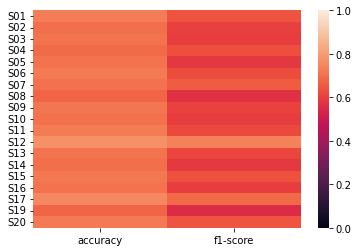

     class0 f1-score  class1 f1-score
S01         0.834586         0.214286
S02         0.815884         0.135593
S03         0.824324         0.071429
S04         0.806667         0.216216
S05         0.826855         0.000000
S06         0.833898         0.109091
S07         0.808511         0.325000
S08         0.803922         0.062500
S09         0.830189         0.068966
S10         0.821656         0.096774
S11         0.838028         0.080000
S12         0.856115         0.459459
S13         0.820339         0.158730
S14         0.818482         0.067797
S15         0.826667         0.212121
S16         0.824675         0.068966
S17         0.849817         0.305085
S19         0.805195         0.000000
S20         0.831081         0.218750


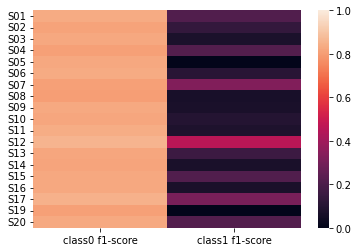

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [8]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-DF_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

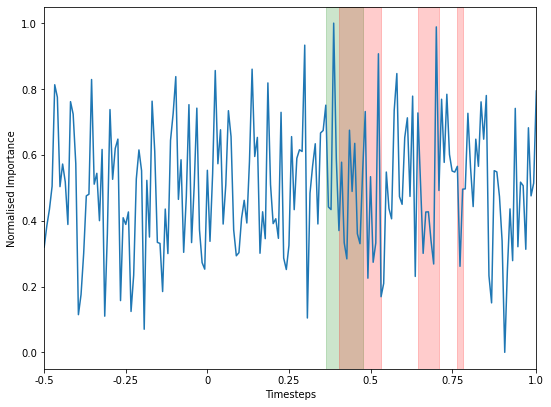

In [10]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

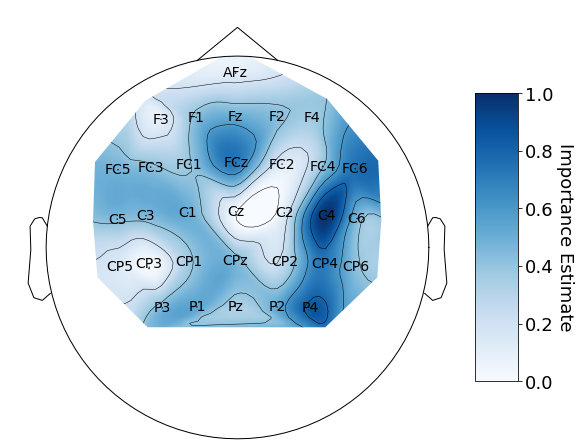

In [11]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)